##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.
- Export the model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and attention mechanisms. 

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [2]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


Import the necessary modules:

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

2023-03-11 12:10:46.959514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-11 12:10:46.959607: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-11 12:10:46.959616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Data handling

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses a popular [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) implementation, which builds subword tokenizers (`text.BertTokenizer`) optimized for the dataset and exports them in a TensorFlow `saved_model` format.

Download, extract, and import the `saved_model`:

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

  8192/184801 [>.............................] - ETA: 0s

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [10]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text: 

In [11]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [12]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [13]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

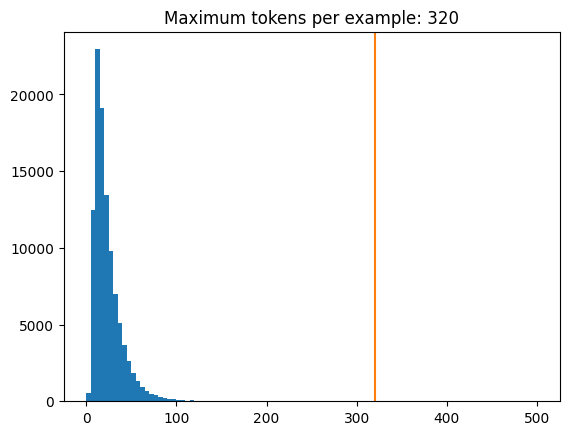

In [14]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training. 

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [15]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset 

In [18]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Protugese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

In [19]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 67)
(64, 61)
(64, 61)


The `en` and `en_labels` are the same, just shifted by 1:

In [20]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   76  166 2034  130  174 4934   13  106   71], shape=(10,), dtype=int64)
tf.Tensor([  76  166 2034  130  174 4934   13  106   71  859], shape=(10,), dtype=int64)


## Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.
2. If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic. 

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [21]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


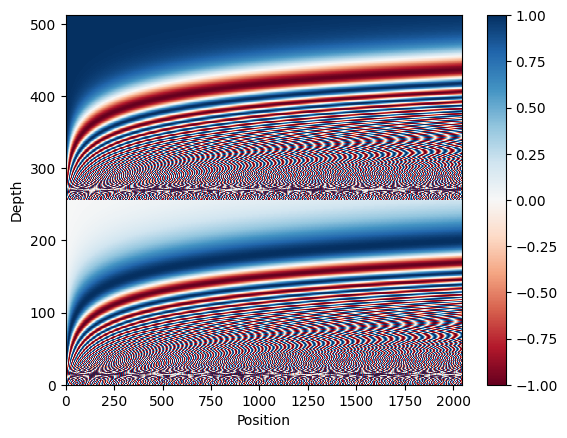

In [22]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

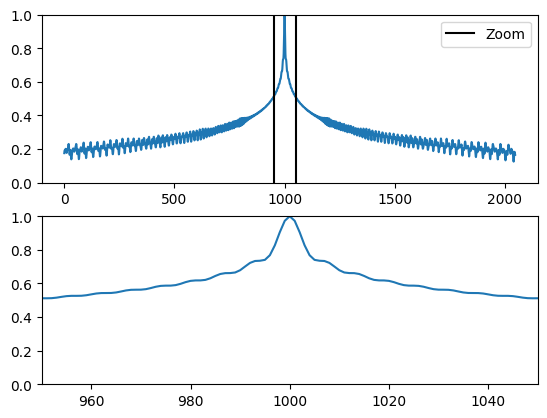

In [23]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [24]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [25]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [26]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 61), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each. 

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`. 

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [27]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


### The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [28]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the `query` sequence, and not the length of the context `key/value` sequence.

The diagram is further simplified, below. There's no need to draw the entire "Attention weights" matrix.
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [29]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 67, 512)
(64, 61, 512)


(64, 61, 512)


### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions. 

Before Transformers and self attention, models commonly used RNNs or CNNs to do this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. 

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer: 

In [30]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [31]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 67, 512)
(64, 67, 512)


Sticking with the same style as before you could draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity.

It's more compact, and just as accurate to draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation), and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) .

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [32]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

The causal mask ensures that each location only has access to the locations that come before it: 

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [33]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 61, 512)
(64, 61, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [34]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions. 

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [35]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


Test the layer, the output is the same shape as the input:

In [36]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 61, 512)
(64, 61, 512)


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [38]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 67, 512)


(64, 67, 512)


### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Test the encoder:

In [40]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 67)
(64, 67, 512)


### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer:

In [42]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 61, 512)
(64, 67, 512)
(64, 61, 512)


### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder:

In [44]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 61)
(64, 67, 512)
(64, 61, 512)


In [45]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 61, 67])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model`:

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [48]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test it:

In [49]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 61)
(64, 67)
(64, 61, 7010)


In [50]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 61, 67)


Print the summary of the model:

In [51]:
transformer.summary()

Model: "transformer"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 encoder_1 (Encoder)         multiple                  3632768   


 decoder_1 (Decoder)         multiple                  5647104   


 dense_38 (Dense)            multiple                  904290    


Total params: 10,184,162


Trainable params: 10,184,162


Non-trainable params: 0


_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

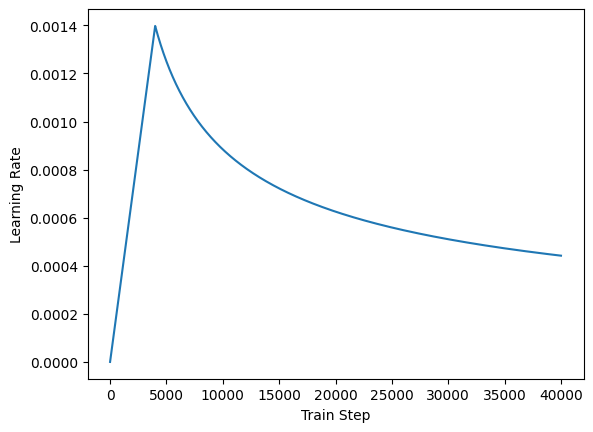

In [54]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [55]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [56]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [57]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20


  1/810 [..............................] - ETA: 6:15:22 - loss: 8.8459 - masked_accuracy: 0.0000e+00

  2/810 [..............................] - ETA: 4:58 - loss: 8.8526 - masked_accuracy: 0.0000e+00   

  3/810 [..............................] - ETA: 5:18 - loss: 8.8548 - masked_accuracy: 0.0000e+00

  4/810 [..............................] - ETA: 5:39 - loss: 8.8547 - masked_accuracy: 0.0000e+00

  5/810 [..............................] - ETA: 5:45 - loss: 8.8544 - masked_accuracy: 0.0000e+00

  6/810 [..............................] - ETA: 5:41 - loss: 8.8540 - masked_accuracy: 0.0000e+00

  7/810 [..............................] - ETA: 5:37 - loss: 8.8542 - masked_accuracy: 0.0000e+00

  8/810 [..............................] - ETA: 5:36 - loss: 8.8544 - masked_accuracy: 1.4890e-04

  9/810 [..............................] - ETA: 5:19 - loss: 8.8549 - masked_accuracy: 1.3235e-04

 10/810 [..............................] - ETA: 5:22 - loss: 8.8540 - masked_accuracy: 1.1912e-04

 11/810 [..............................] - ETA: 5:26 - loss: 8.8534 - masked_accuracy: 1.0829e-04

 12/810 [..............................] - ETA: 5:25 - loss: 8.8526 - masked_accuracy: 9.9265e-05

 13/810 [..............................] - ETA: 5:22 - loss: 8.8520 - masked_accuracy: 9.1630e-05

 14/810 [..............................] - ETA: 5:26 - loss: 8.8509 - masked_accuracy: 8.5085e-05

 15/810 [..............................] - ETA: 5:26 - loss: 8.8502 - masked_accuracy: 7.9412e-05

 16/810 [..............................] - ETA: 5:26 - loss: 8.8491 - masked_accuracy: 7.4449e-05

 17/810 [..............................] - ETA: 5:26 - loss: 8.8480 - masked_accuracy: 7.0070e-05

 18/810 [..............................] - ETA: 5:27 - loss: 8.8471 - masked_accuracy: 6.6177e-05

 19/810 [..............................] - ETA: 5:27 - loss: 8.8460 - masked_accuracy: 6.2694e-05

 20/810 [..............................] - ETA: 5:27 - loss: 8.8448 - masked_accuracy: 5.9559e-05

 21/810 [..............................] - ETA: 5:25 - loss: 8.8438 - masked_accuracy: 5.6723e-05

 22/810 [..............................] - ETA: 5:15 - loss: 8.8425 - masked_accuracy: 8.5820e-05

 23/810 [..............................] - ETA: 5:14 - loss: 8.8414 - masked_accuracy: 8.2089e-05

 24/810 [..............................] - ETA: 5:13 - loss: 8.8403 - masked_accuracy: 7.8669e-05

 25/810 [..............................] - ETA: 5:13 - loss: 8.8390 - masked_accuracy: 1.0504e-04

 26/810 [..............................] - ETA: 5:15 - loss: 8.8374 - masked_accuracy: 1.2582e-04

 27/810 [>.............................] - ETA: 5:14 - loss: 8.8359 - masked_accuracy: 1.4729e-04

 28/810 [>.............................] - ETA: 5:09 - loss: 8.8345 - masked_accuracy: 1.4203e-04

 29/810 [>.............................] - ETA: 5:05 - loss: 8.8329 - masked_accuracy: 1.6370e-04

 30/810 [>.............................] - ETA: 5:04 - loss: 8.8314 - masked_accuracy: 1.5825e-04

 31/810 [>.............................] - ETA: 5:03 - loss: 8.8299 - masked_accuracy: 2.2011e-04

 32/810 [>.............................] - ETA: 5:03 - loss: 8.8284 - masked_accuracy: 2.1323e-04

 33/810 [>.............................] - ETA: 5:00 - loss: 8.8266 - masked_accuracy: 2.2990e-04

 34/810 [>.............................] - ETA: 4:57 - loss: 8.8251 - masked_accuracy: 2.9133e-04

 35/810 [>.............................] - ETA: 4:58 - loss: 8.8236 - masked_accuracy: 2.8301e-04

 36/810 [>.............................] - ETA: 4:58 - loss: 8.8223 - masked_accuracy: 3.3191e-04

 37/810 [>.............................] - ETA: 4:55 - loss: 8.8208 - masked_accuracy: 4.4209e-04

 38/810 [>.............................] - ETA: 4:52 - loss: 8.8191 - masked_accuracy: 5.7960e-04

 39/810 [>.............................] - ETA: 4:48 - loss: 8.8172 - masked_accuracy: 7.6428e-04

 40/810 [>.............................] - ETA: 4:49 - loss: 8.8157 - masked_accuracy: 9.3736e-04

 41/810 [>.............................] - ETA: 4:49 - loss: 8.8140 - masked_accuracy: 0.0011    

 42/810 [>.............................] - ETA: 4:50 - loss: 8.8123 - masked_accuracy: 0.0013

 43/810 [>.............................] - ETA: 4:49 - loss: 8.8103 - masked_accuracy: 0.0015

 44/810 [>.............................] - ETA: 4:51 - loss: 8.8084 - masked_accuracy: 0.0016

 45/810 [>.............................] - ETA: 4:48 - loss: 8.8061 - masked_accuracy: 0.0019

 46/810 [>.............................] - ETA: 4:48 - loss: 8.8042 - masked_accuracy: 0.0022

 47/810 [>.............................] - ETA: 4:48 - loss: 8.8021 - masked_accuracy: 0.0026

 48/810 [>.............................] - ETA: 4:47 - loss: 8.7999 - masked_accuracy: 0.0030

 49/810 [>.............................] - ETA: 4:47 - loss: 8.7978 - masked_accuracy: 0.0032

 50/810 [>.............................] - ETA: 4:45 - loss: 8.7957 - masked_accuracy: 0.0036

 51/810 [>.............................] - ETA: 4:45 - loss: 8.7934 - masked_accuracy: 0.0041

 52/810 [>.............................] - ETA: 4:44 - loss: 8.7915 - masked_accuracy: 0.0043

 53/810 [>.............................] - ETA: 4:42 - loss: 8.7895 - masked_accuracy: 0.0046

 54/810 [=>............................] - ETA: 4:40 - loss: 8.7873 - masked_accuracy: 0.0049

 55/810 [=>............................] - ETA: 4:40 - loss: 8.7852 - masked_accuracy: 0.0054

 56/810 [=>............................] - ETA: 4:41 - loss: 8.7830 - masked_accuracy: 0.0059

 57/810 [=>............................] - ETA: 4:40 - loss: 8.7807 - masked_accuracy: 0.0064

 58/810 [=>............................] - ETA: 4:39 - loss: 8.7784 - masked_accuracy: 0.0070

 59/810 [=>............................] - ETA: 4:35 - loss: 8.7764 - masked_accuracy: 0.0074

 60/810 [=>............................] - ETA: 4:36 - loss: 8.7744 - masked_accuracy: 0.0078

 61/810 [=>............................] - ETA: 4:36 - loss: 8.7723 - masked_accuracy: 0.0083

 62/810 [=>............................] - ETA: 4:36 - loss: 8.7701 - masked_accuracy: 0.0088

 63/810 [=>............................] - ETA: 4:34 - loss: 8.7679 - masked_accuracy: 0.0093

 64/810 [=>............................] - ETA: 4:34 - loss: 8.7658 - masked_accuracy: 0.0097

 65/810 [=>............................] - ETA: 4:33 - loss: 8.7637 - masked_accuracy: 0.0100

 66/810 [=>............................] - ETA: 4:31 - loss: 8.7616 - masked_accuracy: 0.0106

 67/810 [=>............................] - ETA: 4:31 - loss: 8.7593 - masked_accuracy: 0.0111

 68/810 [=>............................] - ETA: 4:31 - loss: 8.7570 - masked_accuracy: 0.0116

 69/810 [=>............................] - ETA: 4:29 - loss: 8.7548 - masked_accuracy: 0.0121

 70/810 [=>............................] - ETA: 4:29 - loss: 8.7529 - masked_accuracy: 0.0126

 71/810 [=>............................] - ETA: 4:28 - loss: 8.7508 - masked_accuracy: 0.0130

 72/810 [=>............................] - ETA: 4:26 - loss: 8.7485 - masked_accuracy: 0.0135

 73/810 [=>............................] - ETA: 4:25 - loss: 8.7463 - masked_accuracy: 0.0139

 74/810 [=>............................] - ETA: 4:24 - loss: 8.7443 - masked_accuracy: 0.0143

 75/810 [=>............................] - ETA: 4:22 - loss: 8.7421 - masked_accuracy: 0.0146

 76/810 [=>............................] - ETA: 4:21 - loss: 8.7401 - masked_accuracy: 0.0149

 77/810 [=>............................] - ETA: 4:21 - loss: 8.7379 - masked_accuracy: 0.0152

 78/810 [=>............................] - ETA: 4:19 - loss: 8.7359 - masked_accuracy: 0.0156

 79/810 [=>............................] - ETA: 4:19 - loss: 8.7337 - masked_accuracy: 0.0159

 80/810 [=>............................] - ETA: 4:19 - loss: 8.7315 - masked_accuracy: 0.0162

 81/810 [==>...........................] - ETA: 4:17 - loss: 8.7293 - masked_accuracy: 0.0167

 82/810 [==>...........................] - ETA: 4:17 - loss: 8.7270 - masked_accuracy: 0.0172

 83/810 [==>...........................] - ETA: 4:17 - loss: 8.7248 - masked_accuracy: 0.0174

 84/810 [==>...........................] - ETA: 4:15 - loss: 8.7228 - masked_accuracy: 0.0175

 85/810 [==>...........................] - ETA: 4:14 - loss: 8.7208 - masked_accuracy: 0.0177

 86/810 [==>...........................] - ETA: 4:14 - loss: 8.7187 - masked_accuracy: 0.0180

 87/810 [==>...........................] - ETA: 4:13 - loss: 8.7165 - masked_accuracy: 0.0182

 88/810 [==>...........................] - ETA: 4:13 - loss: 8.7145 - masked_accuracy: 0.0184

 89/810 [==>...........................] - ETA: 4:12 - loss: 8.7124 - masked_accuracy: 0.0186

 90/810 [==>...........................] - ETA: 4:11 - loss: 8.7102 - masked_accuracy: 0.0190

 91/810 [==>...........................] - ETA: 4:10 - loss: 8.7081 - masked_accuracy: 0.0192

 92/810 [==>...........................] - ETA: 4:09 - loss: 8.7060 - masked_accuracy: 0.0194

 93/810 [==>...........................] - ETA: 4:07 - loss: 8.7039 - masked_accuracy: 0.0196

 94/810 [==>...........................] - ETA: 4:05 - loss: 8.7017 - masked_accuracy: 0.0199

 95/810 [==>...........................] - ETA: 4:05 - loss: 8.6995 - masked_accuracy: 0.0202

 96/810 [==>...........................] - ETA: 4:04 - loss: 8.6972 - masked_accuracy: 0.0205

 97/810 [==>...........................] - ETA: 4:04 - loss: 8.6948 - masked_accuracy: 0.0210

 98/810 [==>...........................] - ETA: 4:04 - loss: 8.6927 - masked_accuracy: 0.0213

 99/810 [==>...........................] - ETA: 4:04 - loss: 8.6904 - masked_accuracy: 0.0216

100/810 [==>...........................] - ETA: 4:04 - loss: 8.6884 - masked_accuracy: 0.0218

101/810 [==>...........................] - ETA: 4:02 - loss: 8.6863 - masked_accuracy: 0.0219

102/810 [==>...........................] - ETA: 4:02 - loss: 8.6843 - masked_accuracy: 0.0220

103/810 [==>...........................] - ETA: 4:01 - loss: 8.6821 - masked_accuracy: 0.0223

104/810 [==>...........................] - ETA: 3:59 - loss: 8.6800 - masked_accuracy: 0.0224

105/810 [==>...........................] - ETA: 3:58 - loss: 8.6776 - masked_accuracy: 0.0226

106/810 [==>...........................] - ETA: 3:57 - loss: 8.6754 - masked_accuracy: 0.0227

107/810 [==>...........................] - ETA: 3:56 - loss: 8.6733 - masked_accuracy: 0.0227

108/810 [===>..........................] - ETA: 3:55 - loss: 8.6711 - masked_accuracy: 0.0229

109/810 [===>..........................] - ETA: 3:55 - loss: 8.6688 - masked_accuracy: 0.0230

110/810 [===>..........................] - ETA: 3:54 - loss: 8.6665 - masked_accuracy: 0.0232

111/810 [===>..........................] - ETA: 3:54 - loss: 8.6642 - masked_accuracy: 0.0234

112/810 [===>..........................] - ETA: 3:54 - loss: 8.6620 - masked_accuracy: 0.0237

113/810 [===>..........................] - ETA: 3:53 - loss: 8.6598 - masked_accuracy: 0.0239

114/810 [===>..........................] - ETA: 3:51 - loss: 8.6575 - masked_accuracy: 0.0241

115/810 [===>..........................] - ETA: 3:50 - loss: 8.6551 - masked_accuracy: 0.0243

116/810 [===>..........................] - ETA: 3:49 - loss: 8.6529 - masked_accuracy: 0.0244

117/810 [===>..........................] - ETA: 3:48 - loss: 8.6507 - masked_accuracy: 0.0246

118/810 [===>..........................] - ETA: 3:47 - loss: 8.6484 - masked_accuracy: 0.0248

119/810 [===>..........................] - ETA: 3:46 - loss: 8.6460 - masked_accuracy: 0.0250

120/810 [===>..........................] - ETA: 3:45 - loss: 8.6440 - masked_accuracy: 0.0251

121/810 [===>..........................] - ETA: 3:44 - loss: 8.6416 - masked_accuracy: 0.0253

122/810 [===>..........................] - ETA: 3:43 - loss: 8.6392 - masked_accuracy: 0.0254

123/810 [===>..........................] - ETA: 3:42 - loss: 8.6367 - masked_accuracy: 0.0257

124/810 [===>..........................] - ETA: 3:42 - loss: 8.6344 - masked_accuracy: 0.0259

125/810 [===>..........................] - ETA: 3:42 - loss: 8.6322 - masked_accuracy: 0.0260

126/810 [===>..........................] - ETA: 3:41 - loss: 8.6298 - masked_accuracy: 0.0263

127/810 [===>..........................] - ETA: 3:40 - loss: 8.6274 - masked_accuracy: 0.0265

128/810 [===>..........................] - ETA: 3:40 - loss: 8.6249 - masked_accuracy: 0.0267

129/810 [===>..........................] - ETA: 3:39 - loss: 8.6224 - masked_accuracy: 0.0270

130/810 [===>..........................] - ETA: 3:38 - loss: 8.6200 - masked_accuracy: 0.0273

131/810 [===>..........................] - ETA: 3:38 - loss: 8.6177 - masked_accuracy: 0.0275

132/810 [===>..........................] - ETA: 3:36 - loss: 8.6152 - masked_accuracy: 0.0277

133/810 [===>..........................] - ETA: 3:37 - loss: 8.6129 - masked_accuracy: 0.0279

134/810 [===>..........................] - ETA: 3:37 - loss: 8.6105 - masked_accuracy: 0.0280

135/810 [====>.........................] - ETA: 3:36 - loss: 8.6082 - masked_accuracy: 0.0283

136/810 [====>.........................] - ETA: 3:36 - loss: 8.6056 - masked_accuracy: 0.0286

137/810 [====>.........................] - ETA: 3:36 - loss: 8.6033 - masked_accuracy: 0.0288

138/810 [====>.........................] - ETA: 3:35 - loss: 8.6009 - masked_accuracy: 0.0289

139/810 [====>.........................] - ETA: 3:34 - loss: 8.5982 - masked_accuracy: 0.0292

140/810 [====>.........................] - ETA: 3:33 - loss: 8.5958 - masked_accuracy: 0.0294

141/810 [====>.........................] - ETA: 3:32 - loss: 8.5932 - masked_accuracy: 0.0298

142/810 [====>.........................] - ETA: 3:32 - loss: 8.5908 - masked_accuracy: 0.0301

143/810 [====>.........................] - ETA: 3:32 - loss: 8.5882 - masked_accuracy: 0.0303

144/810 [====>.........................] - ETA: 3:31 - loss: 8.5856 - masked_accuracy: 0.0305

145/810 [====>.........................] - ETA: 3:30 - loss: 8.5829 - masked_accuracy: 0.0308

146/810 [====>.........................] - ETA: 3:29 - loss: 8.5805 - masked_accuracy: 0.0309

147/810 [====>.........................] - ETA: 3:28 - loss: 8.5779 - masked_accuracy: 0.0312

148/810 [====>.........................] - ETA: 3:27 - loss: 8.5753 - masked_accuracy: 0.0314

149/810 [====>.........................] - ETA: 3:27 - loss: 8.5728 - masked_accuracy: 0.0316

150/810 [====>.........................] - ETA: 3:27 - loss: 8.5702 - masked_accuracy: 0.0318

151/810 [====>.........................] - ETA: 3:26 - loss: 8.5676 - masked_accuracy: 0.0321

152/810 [====>.........................] - ETA: 3:26 - loss: 8.5650 - masked_accuracy: 0.0324

153/810 [====>.........................] - ETA: 3:25 - loss: 8.5623 - masked_accuracy: 0.0327

154/810 [====>.........................] - ETA: 3:24 - loss: 8.5597 - masked_accuracy: 0.0329

155/810 [====>.........................] - ETA: 3:24 - loss: 8.5569 - masked_accuracy: 0.0332

156/810 [====>.........................] - ETA: 3:24 - loss: 8.5542 - masked_accuracy: 0.0335

157/810 [====>.........................] - ETA: 3:23 - loss: 8.5513 - masked_accuracy: 0.0340

158/810 [====>.........................] - ETA: 3:23 - loss: 8.5488 - masked_accuracy: 0.0342

159/810 [====>.........................] - ETA: 3:23 - loss: 8.5459 - masked_accuracy: 0.0345

160/810 [====>.........................] - ETA: 3:22 - loss: 8.5432 - masked_accuracy: 0.0347

161/810 [====>.........................] - ETA: 3:21 - loss: 8.5402 - masked_accuracy: 0.0350

162/810 [=====>........................] - ETA: 3:21 - loss: 8.5374 - masked_accuracy: 0.0353

163/810 [=====>........................] - ETA: 3:21 - loss: 8.5345 - masked_accuracy: 0.0354

164/810 [=====>........................] - ETA: 3:21 - loss: 8.5321 - masked_accuracy: 0.0355

165/810 [=====>........................] - ETA: 3:20 - loss: 8.5291 - masked_accuracy: 0.0358

166/810 [=====>........................] - ETA: 3:20 - loss: 8.5263 - masked_accuracy: 0.0361

167/810 [=====>........................] - ETA: 3:19 - loss: 8.5236 - masked_accuracy: 0.0363

168/810 [=====>........................] - ETA: 3:18 - loss: 8.5207 - masked_accuracy: 0.0367

169/810 [=====>........................] - ETA: 3:18 - loss: 8.5179 - masked_accuracy: 0.0370

170/810 [=====>........................] - ETA: 3:17 - loss: 8.5148 - masked_accuracy: 0.0374

171/810 [=====>........................] - ETA: 3:17 - loss: 8.5122 - masked_accuracy: 0.0376

172/810 [=====>........................] - ETA: 3:16 - loss: 8.5093 - masked_accuracy: 0.0377

173/810 [=====>........................] - ETA: 3:16 - loss: 8.5064 - masked_accuracy: 0.0380

174/810 [=====>........................] - ETA: 3:15 - loss: 8.5033 - masked_accuracy: 0.0384

175/810 [=====>........................] - ETA: 3:14 - loss: 8.5005 - masked_accuracy: 0.0386

176/810 [=====>........................] - ETA: 3:14 - loss: 8.4977 - masked_accuracy: 0.0389

177/810 [=====>........................] - ETA: 3:14 - loss: 8.4948 - masked_accuracy: 0.0392

178/810 [=====>........................] - ETA: 3:13 - loss: 8.4917 - masked_accuracy: 0.0396

179/810 [=====>........................] - ETA: 3:12 - loss: 8.4886 - masked_accuracy: 0.0399

180/810 [=====>........................] - ETA: 3:12 - loss: 8.4857 - masked_accuracy: 0.0401

181/810 [=====>........................] - ETA: 3:11 - loss: 8.4826 - masked_accuracy: 0.0405

182/810 [=====>........................] - ETA: 3:10 - loss: 8.4794 - masked_accuracy: 0.0408

183/810 [=====>........................] - ETA: 3:10 - loss: 8.4763 - masked_accuracy: 0.0411

184/810 [=====>........................] - ETA: 3:09 - loss: 8.4734 - masked_accuracy: 0.0412

185/810 [=====>........................] - ETA: 3:09 - loss: 8.4700 - masked_accuracy: 0.0416

186/810 [=====>........................] - ETA: 3:08 - loss: 8.4669 - masked_accuracy: 0.0419

187/810 [=====>........................] - ETA: 3:08 - loss: 8.4639 - masked_accuracy: 0.0422

188/810 [=====>........................] - ETA: 3:08 - loss: 8.4609 - masked_accuracy: 0.0423

189/810 [======>.......................] - ETA: 3:07 - loss: 8.4579 - masked_accuracy: 0.0425

190/810 [======>.......................] - ETA: 3:06 - loss: 8.4548 - masked_accuracy: 0.0428

191/810 [======>.......................] - ETA: 3:05 - loss: 8.4514 - masked_accuracy: 0.0431

192/810 [======>.......................] - ETA: 3:05 - loss: 8.4484 - masked_accuracy: 0.0433

193/810 [======>.......................] - ETA: 3:04 - loss: 8.4451 - masked_accuracy: 0.0436

194/810 [======>.......................] - ETA: 3:04 - loss: 8.4422 - masked_accuracy: 0.0439

195/810 [======>.......................] - ETA: 3:04 - loss: 8.4389 - masked_accuracy: 0.0442

196/810 [======>.......................] - ETA: 3:03 - loss: 8.4357 - masked_accuracy: 0.0445

197/810 [======>.......................] - ETA: 3:02 - loss: 8.4326 - masked_accuracy: 0.0447

198/810 [======>.......................] - ETA: 3:02 - loss: 8.4294 - masked_accuracy: 0.0449

199/810 [======>.......................] - ETA: 3:01 - loss: 8.4260 - masked_accuracy: 0.0452

200/810 [======>.......................] - ETA: 3:01 - loss: 8.4226 - masked_accuracy: 0.0455

201/810 [======>.......................] - ETA: 3:00 - loss: 8.4194 - masked_accuracy: 0.0458

202/810 [======>.......................] - ETA: 3:00 - loss: 8.4163 - masked_accuracy: 0.0460

203/810 [======>.......................] - ETA: 3:00 - loss: 8.4129 - masked_accuracy: 0.0463

204/810 [======>.......................] - ETA: 2:59 - loss: 8.4097 - masked_accuracy: 0.0466

205/810 [======>.......................] - ETA: 2:58 - loss: 8.4064 - masked_accuracy: 0.0468

206/810 [======>.......................] - ETA: 2:57 - loss: 8.4031 - masked_accuracy: 0.0470

207/810 [======>.......................] - ETA: 2:57 - loss: 8.3998 - masked_accuracy: 0.0472

208/810 [======>.......................] - ETA: 2:57 - loss: 8.3967 - masked_accuracy: 0.0474

209/810 [======>.......................] - ETA: 2:56 - loss: 8.3930 - masked_accuracy: 0.0478

210/810 [======>.......................] - ETA: 2:56 - loss: 8.3897 - masked_accuracy: 0.0480

211/810 [======>.......................] - ETA: 2:55 - loss: 8.3864 - masked_accuracy: 0.0483

212/810 [======>.......................] - ETA: 2:55 - loss: 8.3831 - masked_accuracy: 0.0484

213/810 [======>.......................] - ETA: 2:55 - loss: 8.3797 - masked_accuracy: 0.0487

214/810 [======>.......................] - ETA: 2:54 - loss: 8.3765 - masked_accuracy: 0.0488

215/810 [======>.......................] - ETA: 2:54 - loss: 8.3728 - masked_accuracy: 0.0491

216/810 [=======>......................] - ETA: 2:53 - loss: 8.3694 - masked_accuracy: 0.0494

217/810 [=======>......................] - ETA: 2:53 - loss: 8.3660 - masked_accuracy: 0.0495

218/810 [=======>......................] - ETA: 2:52 - loss: 8.3622 - masked_accuracy: 0.0499

219/810 [=======>......................] - ETA: 2:52 - loss: 8.3586 - masked_accuracy: 0.0501

220/810 [=======>......................] - ETA: 2:51 - loss: 8.3552 - masked_accuracy: 0.0503

221/810 [=======>......................] - ETA: 2:51 - loss: 8.3515 - masked_accuracy: 0.0506

222/810 [=======>......................] - ETA: 2:50 - loss: 8.3480 - masked_accuracy: 0.0508

223/810 [=======>......................] - ETA: 2:50 - loss: 8.3444 - masked_accuracy: 0.0510

224/810 [=======>......................] - ETA: 2:49 - loss: 8.3408 - masked_accuracy: 0.0513

225/810 [=======>......................] - ETA: 2:49 - loss: 8.3372 - masked_accuracy: 0.0514

226/810 [=======>......................] - ETA: 2:48 - loss: 8.3339 - masked_accuracy: 0.0515

227/810 [=======>......................] - ETA: 2:48 - loss: 8.3305 - masked_accuracy: 0.0518

228/810 [=======>......................] - ETA: 2:47 - loss: 8.3269 - masked_accuracy: 0.0520

229/810 [=======>......................] - ETA: 2:46 - loss: 8.3235 - masked_accuracy: 0.0522

230/810 [=======>......................] - ETA: 2:46 - loss: 8.3198 - masked_accuracy: 0.0524

231/810 [=======>......................] - ETA: 2:45 - loss: 8.3161 - masked_accuracy: 0.0526

232/810 [=======>......................] - ETA: 2:45 - loss: 8.3123 - masked_accuracy: 0.0529

233/810 [=======>......................] - ETA: 2:44 - loss: 8.3086 - masked_accuracy: 0.0531

234/810 [=======>......................] - ETA: 2:44 - loss: 8.3051 - masked_accuracy: 0.0532

235/810 [=======>......................] - ETA: 2:43 - loss: 8.3013 - masked_accuracy: 0.0534

236/810 [=======>......................] - ETA: 2:43 - loss: 8.2979 - masked_accuracy: 0.0536

237/810 [=======>......................] - ETA: 2:42 - loss: 8.2945 - masked_accuracy: 0.0537

238/810 [=======>......................] - ETA: 2:42 - loss: 8.2911 - masked_accuracy: 0.0538

239/810 [=======>......................] - ETA: 2:41 - loss: 8.2876 - masked_accuracy: 0.0541

240/810 [=======>......................] - ETA: 2:41 - loss: 8.2841 - masked_accuracy: 0.0543

241/810 [=======>......................] - ETA: 2:40 - loss: 8.2803 - masked_accuracy: 0.0545

242/810 [=======>......................] - ETA: 2:40 - loss: 8.2766 - masked_accuracy: 0.0547

243/810 [========>.....................] - ETA: 2:39 - loss: 8.2729 - masked_accuracy: 0.0550

244/810 [========>.....................] - ETA: 2:39 - loss: 8.2693 - masked_accuracy: 0.0551

245/810 [========>.....................] - ETA: 2:38 - loss: 8.2653 - masked_accuracy: 0.0554

246/810 [========>.....................] - ETA: 2:38 - loss: 8.2616 - masked_accuracy: 0.0555

247/810 [========>.....................] - ETA: 2:38 - loss: 8.2578 - masked_accuracy: 0.0557

248/810 [========>.....................] - ETA: 2:37 - loss: 8.2541 - masked_accuracy: 0.0558

249/810 [========>.....................] - ETA: 2:37 - loss: 8.2503 - masked_accuracy: 0.0561

250/810 [========>.....................] - ETA: 2:37 - loss: 8.2467 - masked_accuracy: 0.0562

251/810 [========>.....................] - ETA: 2:36 - loss: 8.2428 - masked_accuracy: 0.0564

252/810 [========>.....................] - ETA: 2:35 - loss: 8.2390 - masked_accuracy: 0.0565

253/810 [========>.....................] - ETA: 2:35 - loss: 8.2350 - masked_accuracy: 0.0568

254/810 [========>.....................] - ETA: 2:35 - loss: 8.2311 - masked_accuracy: 0.0570

255/810 [========>.....................] - ETA: 2:35 - loss: 8.2273 - masked_accuracy: 0.0572

256/810 [========>.....................] - ETA: 2:34 - loss: 8.2234 - masked_accuracy: 0.0574

257/810 [========>.....................] - ETA: 2:33 - loss: 8.2198 - masked_accuracy: 0.0575

258/810 [========>.....................] - ETA: 2:33 - loss: 8.2160 - masked_accuracy: 0.0577

259/810 [========>.....................] - ETA: 2:33 - loss: 8.2121 - masked_accuracy: 0.0580

260/810 [========>.....................] - ETA: 2:33 - loss: 8.2083 - masked_accuracy: 0.0582

261/810 [========>.....................] - ETA: 2:32 - loss: 8.2045 - masked_accuracy: 0.0584

262/810 [========>.....................] - ETA: 2:32 - loss: 8.2007 - masked_accuracy: 0.0586

263/810 [========>.....................] - ETA: 2:31 - loss: 8.1968 - masked_accuracy: 0.0588

264/810 [========>.....................] - ETA: 2:31 - loss: 8.1927 - masked_accuracy: 0.0590

265/810 [========>.....................] - ETA: 2:31 - loss: 8.1890 - masked_accuracy: 0.0592

266/810 [========>.....................] - ETA: 2:30 - loss: 8.1852 - masked_accuracy: 0.0594

267/810 [========>.....................] - ETA: 2:30 - loss: 8.1813 - masked_accuracy: 0.0596

268/810 [========>.....................] - ETA: 2:29 - loss: 8.1773 - masked_accuracy: 0.0598

269/810 [========>.....................] - ETA: 2:29 - loss: 8.1730 - masked_accuracy: 0.0600

270/810 [=========>....................] - ETA: 2:29 - loss: 8.1694 - masked_accuracy: 0.0601

271/810 [=========>....................] - ETA: 2:28 - loss: 8.1655 - masked_accuracy: 0.0603

272/810 [=========>....................] - ETA: 2:28 - loss: 8.1617 - masked_accuracy: 0.0605

273/810 [=========>....................] - ETA: 2:27 - loss: 8.1575 - masked_accuracy: 0.0607

274/810 [=========>....................] - ETA: 2:27 - loss: 8.1535 - masked_accuracy: 0.0610

275/810 [=========>....................] - ETA: 2:26 - loss: 8.1498 - masked_accuracy: 0.0611

276/810 [=========>....................] - ETA: 2:26 - loss: 8.1461 - masked_accuracy: 0.0613

277/810 [=========>....................] - ETA: 2:25 - loss: 8.1421 - masked_accuracy: 0.0614

278/810 [=========>....................] - ETA: 2:25 - loss: 8.1382 - masked_accuracy: 0.0616

279/810 [=========>....................] - ETA: 2:25 - loss: 8.1343 - masked_accuracy: 0.0617

280/810 [=========>....................] - ETA: 2:24 - loss: 8.1303 - masked_accuracy: 0.0619

281/810 [=========>....................] - ETA: 2:24 - loss: 8.1265 - masked_accuracy: 0.0620

282/810 [=========>....................] - ETA: 2:24 - loss: 8.1227 - masked_accuracy: 0.0622

283/810 [=========>....................] - ETA: 2:23 - loss: 8.1186 - masked_accuracy: 0.0624

284/810 [=========>....................] - ETA: 2:23 - loss: 8.1148 - masked_accuracy: 0.0625

285/810 [=========>....................] - ETA: 2:22 - loss: 8.1109 - masked_accuracy: 0.0626

286/810 [=========>....................] - ETA: 2:22 - loss: 8.1071 - masked_accuracy: 0.0627

287/810 [=========>....................] - ETA: 2:22 - loss: 8.1033 - masked_accuracy: 0.0628

288/810 [=========>....................] - ETA: 2:21 - loss: 8.0994 - masked_accuracy: 0.0630

289/810 [=========>....................] - ETA: 2:21 - loss: 8.0953 - masked_accuracy: 0.0632

290/810 [=========>....................] - ETA: 2:20 - loss: 8.0915 - masked_accuracy: 0.0633

291/810 [=========>....................] - ETA: 2:20 - loss: 8.0873 - masked_accuracy: 0.0636

292/810 [=========>....................] - ETA: 2:19 - loss: 8.0832 - masked_accuracy: 0.0638

293/810 [=========>....................] - ETA: 2:19 - loss: 8.0794 - masked_accuracy: 0.0639

294/810 [=========>....................] - ETA: 2:19 - loss: 8.0754 - masked_accuracy: 0.0640

295/810 [=========>....................] - ETA: 2:18 - loss: 8.0713 - masked_accuracy: 0.0642

296/810 [=========>....................] - ETA: 2:18 - loss: 8.0675 - masked_accuracy: 0.0644

297/810 [==========>...................] - ETA: 2:17 - loss: 8.0637 - masked_accuracy: 0.0645

298/810 [==========>...................] - ETA: 2:17 - loss: 8.0597 - masked_accuracy: 0.0647

299/810 [==========>...................] - ETA: 2:17 - loss: 8.0556 - masked_accuracy: 0.0648

300/810 [==========>...................] - ETA: 2:16 - loss: 8.0516 - masked_accuracy: 0.0650

301/810 [==========>...................] - ETA: 2:16 - loss: 8.0478 - masked_accuracy: 0.0651

302/810 [==========>...................] - ETA: 2:15 - loss: 8.0439 - masked_accuracy: 0.0653

303/810 [==========>...................] - ETA: 2:15 - loss: 8.0396 - masked_accuracy: 0.0654

304/810 [==========>...................] - ETA: 2:14 - loss: 8.0355 - masked_accuracy: 0.0656

305/810 [==========>...................] - ETA: 2:14 - loss: 8.0314 - masked_accuracy: 0.0657

306/810 [==========>...................] - ETA: 2:14 - loss: 8.0273 - masked_accuracy: 0.0659

307/810 [==========>...................] - ETA: 2:13 - loss: 8.0233 - masked_accuracy: 0.0660

308/810 [==========>...................] - ETA: 2:13 - loss: 8.0190 - masked_accuracy: 0.0662

309/810 [==========>...................] - ETA: 2:12 - loss: 8.0149 - masked_accuracy: 0.0664

310/810 [==========>...................] - ETA: 2:12 - loss: 8.0112 - masked_accuracy: 0.0665

311/810 [==========>...................] - ETA: 2:11 - loss: 8.0073 - masked_accuracy: 0.0667

312/810 [==========>...................] - ETA: 2:11 - loss: 8.0033 - masked_accuracy: 0.0668

313/810 [==========>...................] - ETA: 2:10 - loss: 7.9992 - masked_accuracy: 0.0670

314/810 [==========>...................] - ETA: 2:10 - loss: 7.9954 - masked_accuracy: 0.0671

315/810 [==========>...................] - ETA: 2:10 - loss: 7.9914 - masked_accuracy: 0.0672

316/810 [==========>...................] - ETA: 2:09 - loss: 7.9873 - masked_accuracy: 0.0674

317/810 [==========>...................] - ETA: 2:09 - loss: 7.9836 - masked_accuracy: 0.0675

318/810 [==========>...................] - ETA: 2:09 - loss: 7.9797 - masked_accuracy: 0.0676

319/810 [==========>...................] - ETA: 2:08 - loss: 7.9756 - masked_accuracy: 0.0678

320/810 [==========>...................] - ETA: 2:08 - loss: 7.9717 - masked_accuracy: 0.0679

321/810 [==========>...................] - ETA: 2:07 - loss: 7.9681 - masked_accuracy: 0.0681

322/810 [==========>...................] - ETA: 2:07 - loss: 7.9641 - masked_accuracy: 0.0683

323/810 [==========>...................] - ETA: 2:07 - loss: 7.9600 - masked_accuracy: 0.0684

324/810 [===========>..................] - ETA: 2:07 - loss: 7.9560 - masked_accuracy: 0.0686

325/810 [===========>..................] - ETA: 2:06 - loss: 7.9522 - masked_accuracy: 0.0687

326/810 [===========>..................] - ETA: 2:06 - loss: 7.9483 - masked_accuracy: 0.0689

327/810 [===========>..................] - ETA: 2:05 - loss: 7.9445 - masked_accuracy: 0.0690

328/810 [===========>..................] - ETA: 2:05 - loss: 7.9406 - masked_accuracy: 0.0692

329/810 [===========>..................] - ETA: 2:05 - loss: 7.9368 - masked_accuracy: 0.0693

330/810 [===========>..................] - ETA: 2:05 - loss: 7.9328 - masked_accuracy: 0.0694

331/810 [===========>..................] - ETA: 2:04 - loss: 7.9290 - masked_accuracy: 0.0696

332/810 [===========>..................] - ETA: 2:04 - loss: 7.9251 - masked_accuracy: 0.0697

333/810 [===========>..................] - ETA: 2:04 - loss: 7.9211 - masked_accuracy: 0.0698

334/810 [===========>..................] - ETA: 2:03 - loss: 7.9170 - masked_accuracy: 0.0700

335/810 [===========>..................] - ETA: 2:03 - loss: 7.9131 - masked_accuracy: 0.0702

336/810 [===========>..................] - ETA: 2:02 - loss: 7.9089 - masked_accuracy: 0.0703

337/810 [===========>..................] - ETA: 2:02 - loss: 7.9049 - masked_accuracy: 0.0705

338/810 [===========>..................] - ETA: 2:02 - loss: 7.9007 - masked_accuracy: 0.0707

339/810 [===========>..................] - ETA: 2:01 - loss: 7.8971 - masked_accuracy: 0.0708

340/810 [===========>..................] - ETA: 2:01 - loss: 7.8932 - masked_accuracy: 0.0710

341/810 [===========>..................] - ETA: 2:00 - loss: 7.8891 - masked_accuracy: 0.0711

342/810 [===========>..................] - ETA: 2:00 - loss: 7.8853 - masked_accuracy: 0.0712

343/810 [===========>..................] - ETA: 2:00 - loss: 7.8813 - masked_accuracy: 0.0714

344/810 [===========>..................] - ETA: 1:59 - loss: 7.8774 - masked_accuracy: 0.0716

345/810 [===========>..................] - ETA: 1:59 - loss: 7.8733 - masked_accuracy: 0.0717

346/810 [===========>..................] - ETA: 1:59 - loss: 7.8694 - masked_accuracy: 0.0718

347/810 [===========>..................] - ETA: 1:58 - loss: 7.8655 - masked_accuracy: 0.0720

348/810 [===========>..................] - ETA: 1:58 - loss: 7.8616 - masked_accuracy: 0.0722

349/810 [===========>..................] - ETA: 1:58 - loss: 7.8578 - masked_accuracy: 0.0723

350/810 [===========>..................] - ETA: 1:57 - loss: 7.8539 - masked_accuracy: 0.0725

351/810 [============>.................] - ETA: 1:57 - loss: 7.8501 - masked_accuracy: 0.0725

352/810 [============>.................] - ETA: 1:56 - loss: 7.8462 - masked_accuracy: 0.0727

353/810 [============>.................] - ETA: 1:56 - loss: 7.8419 - masked_accuracy: 0.0729

354/810 [============>.................] - ETA: 1:56 - loss: 7.8380 - masked_accuracy: 0.0730

355/810 [============>.................] - ETA: 1:55 - loss: 7.8343 - masked_accuracy: 0.0732

356/810 [============>.................] - ETA: 1:55 - loss: 7.8305 - masked_accuracy: 0.0733

357/810 [============>.................] - ETA: 1:55 - loss: 7.8266 - masked_accuracy: 0.0734

358/810 [============>.................] - ETA: 1:54 - loss: 7.8227 - masked_accuracy: 0.0736

359/810 [============>.................] - ETA: 1:54 - loss: 7.8189 - masked_accuracy: 0.0738

360/810 [============>.................] - ETA: 1:53 - loss: 7.8152 - masked_accuracy: 0.0739

361/810 [============>.................] - ETA: 1:53 - loss: 7.8111 - masked_accuracy: 0.0741

362/810 [============>.................] - ETA: 1:53 - loss: 7.8075 - masked_accuracy: 0.0742

363/810 [============>.................] - ETA: 1:53 - loss: 7.8038 - masked_accuracy: 0.0743

364/810 [============>.................] - ETA: 1:52 - loss: 7.8001 - masked_accuracy: 0.0745

365/810 [============>.................] - ETA: 1:52 - loss: 7.7964 - masked_accuracy: 0.0746

366/810 [============>.................] - ETA: 1:52 - loss: 7.7926 - masked_accuracy: 0.0748

367/810 [============>.................] - ETA: 1:51 - loss: 7.7889 - masked_accuracy: 0.0749

368/810 [============>.................] - ETA: 1:51 - loss: 7.7850 - masked_accuracy: 0.0751

369/810 [============>.................] - ETA: 1:51 - loss: 7.7814 - masked_accuracy: 0.0752

370/810 [============>.................] - ETA: 1:50 - loss: 7.7778 - masked_accuracy: 0.0754

371/810 [============>.................] - ETA: 1:50 - loss: 7.7743 - masked_accuracy: 0.0755

372/810 [============>.................] - ETA: 1:50 - loss: 7.7706 - masked_accuracy: 0.0757

373/810 [============>.................] - ETA: 1:49 - loss: 7.7668 - masked_accuracy: 0.0758

374/810 [============>.................] - ETA: 1:49 - loss: 7.7627 - masked_accuracy: 0.0759

375/810 [============>.................] - ETA: 1:49 - loss: 7.7590 - masked_accuracy: 0.0761

376/810 [============>.................] - ETA: 1:48 - loss: 7.7551 - masked_accuracy: 0.0763

377/810 [============>.................] - ETA: 1:48 - loss: 7.7514 - masked_accuracy: 0.0764

378/810 [=============>................] - ETA: 1:48 - loss: 7.7477 - masked_accuracy: 0.0765

379/810 [=============>................] - ETA: 1:48 - loss: 7.7437 - masked_accuracy: 0.0766

380/810 [=============>................] - ETA: 1:47 - loss: 7.7401 - masked_accuracy: 0.0768

381/810 [=============>................] - ETA: 1:47 - loss: 7.7366 - masked_accuracy: 0.0770

382/810 [=============>................] - ETA: 1:47 - loss: 7.7331 - masked_accuracy: 0.0771

383/810 [=============>................] - ETA: 1:46 - loss: 7.7295 - masked_accuracy: 0.0773

384/810 [=============>................] - ETA: 1:46 - loss: 7.7257 - masked_accuracy: 0.0774

385/810 [=============>................] - ETA: 1:46 - loss: 7.7218 - masked_accuracy: 0.0776

386/810 [=============>................] - ETA: 1:45 - loss: 7.7182 - masked_accuracy: 0.0777

387/810 [=============>................] - ETA: 1:45 - loss: 7.7144 - masked_accuracy: 0.0779

388/810 [=============>................] - ETA: 1:45 - loss: 7.7104 - masked_accuracy: 0.0781

389/810 [=============>................] - ETA: 1:45 - loss: 7.7067 - masked_accuracy: 0.0782

390/810 [=============>................] - ETA: 1:44 - loss: 7.7032 - masked_accuracy: 0.0784

391/810 [=============>................] - ETA: 1:44 - loss: 7.6993 - masked_accuracy: 0.0785

392/810 [=============>................] - ETA: 1:44 - loss: 7.6957 - masked_accuracy: 0.0787

393/810 [=============>................] - ETA: 1:43 - loss: 7.6921 - masked_accuracy: 0.0789

394/810 [=============>................] - ETA: 1:43 - loss: 7.6883 - masked_accuracy: 0.0790

395/810 [=============>................] - ETA: 1:43 - loss: 7.6846 - masked_accuracy: 0.0792

396/810 [=============>................] - ETA: 1:42 - loss: 7.6809 - masked_accuracy: 0.0793

397/810 [=============>................] - ETA: 1:42 - loss: 7.6770 - masked_accuracy: 0.0795

398/810 [=============>................] - ETA: 1:42 - loss: 7.6737 - masked_accuracy: 0.0796

399/810 [=============>................] - ETA: 1:41 - loss: 7.6699 - masked_accuracy: 0.0798

400/810 [=============>................] - ETA: 1:41 - loss: 7.6665 - masked_accuracy: 0.0800

401/810 [=============>................] - ETA: 1:41 - loss: 7.6628 - masked_accuracy: 0.0802

402/810 [=============>................] - ETA: 1:41 - loss: 7.6593 - masked_accuracy: 0.0803

403/810 [=============>................] - ETA: 1:40 - loss: 7.6560 - masked_accuracy: 0.0804

404/810 [=============>................] - ETA: 1:40 - loss: 7.6524 - masked_accuracy: 0.0805

405/810 [==============>...............] - ETA: 1:40 - loss: 7.6489 - masked_accuracy: 0.0807

406/810 [==============>...............] - ETA: 1:39 - loss: 7.6455 - masked_accuracy: 0.0808

407/810 [==============>...............] - ETA: 1:39 - loss: 7.6418 - masked_accuracy: 0.0810

408/810 [==============>...............] - ETA: 1:39 - loss: 7.6383 - masked_accuracy: 0.0811

409/810 [==============>...............] - ETA: 1:39 - loss: 7.6346 - masked_accuracy: 0.0813

410/810 [==============>...............] - ETA: 1:38 - loss: 7.6311 - masked_accuracy: 0.0814

411/810 [==============>...............] - ETA: 1:38 - loss: 7.6274 - masked_accuracy: 0.0816

412/810 [==============>...............] - ETA: 1:38 - loss: 7.6240 - masked_accuracy: 0.0818

413/810 [==============>...............] - ETA: 1:37 - loss: 7.6205 - masked_accuracy: 0.0820

414/810 [==============>...............] - ETA: 1:37 - loss: 7.6168 - masked_accuracy: 0.0822

415/810 [==============>...............] - ETA: 1:37 - loss: 7.6134 - masked_accuracy: 0.0824

416/810 [==============>...............] - ETA: 1:36 - loss: 7.6100 - masked_accuracy: 0.0826

417/810 [==============>...............] - ETA: 1:36 - loss: 7.6066 - masked_accuracy: 0.0827

418/810 [==============>...............] - ETA: 1:36 - loss: 7.6033 - masked_accuracy: 0.0829

419/810 [==============>...............] - ETA: 1:36 - loss: 7.5999 - masked_accuracy: 0.0831

420/810 [==============>...............] - ETA: 1:35 - loss: 7.5967 - masked_accuracy: 0.0832

421/810 [==============>...............] - ETA: 1:35 - loss: 7.5930 - masked_accuracy: 0.0834

422/810 [==============>...............] - ETA: 1:35 - loss: 7.5893 - masked_accuracy: 0.0836

423/810 [==============>...............] - ETA: 1:34 - loss: 7.5859 - masked_accuracy: 0.0837

424/810 [==============>...............] - ETA: 1:34 - loss: 7.5826 - masked_accuracy: 0.0839

425/810 [==============>...............] - ETA: 1:34 - loss: 7.5791 - masked_accuracy: 0.0840

426/810 [==============>...............] - ETA: 1:34 - loss: 7.5757 - masked_accuracy: 0.0842

427/810 [==============>...............] - ETA: 1:33 - loss: 7.5720 - masked_accuracy: 0.0844

428/810 [==============>...............] - ETA: 1:33 - loss: 7.5683 - masked_accuracy: 0.0846

429/810 [==============>...............] - ETA: 1:33 - loss: 7.5649 - masked_accuracy: 0.0849

430/810 [==============>...............] - ETA: 1:32 - loss: 7.5613 - masked_accuracy: 0.0851

431/810 [==============>...............] - ETA: 1:32 - loss: 7.5582 - masked_accuracy: 0.0852

432/810 [===============>..............] - ETA: 1:32 - loss: 7.5547 - masked_accuracy: 0.0853

433/810 [===============>..............] - ETA: 1:31 - loss: 7.5513 - masked_accuracy: 0.0855

434/810 [===============>..............] - ETA: 1:31 - loss: 7.5482 - masked_accuracy: 0.0857

435/810 [===============>..............] - ETA: 1:31 - loss: 7.5447 - masked_accuracy: 0.0859

436/810 [===============>..............] - ETA: 1:31 - loss: 7.5411 - masked_accuracy: 0.0860

437/810 [===============>..............] - ETA: 1:30 - loss: 7.5377 - masked_accuracy: 0.0862

438/810 [===============>..............] - ETA: 1:30 - loss: 7.5343 - masked_accuracy: 0.0864

439/810 [===============>..............] - ETA: 1:30 - loss: 7.5312 - masked_accuracy: 0.0866

440/810 [===============>..............] - ETA: 1:29 - loss: 7.5279 - masked_accuracy: 0.0867

441/810 [===============>..............] - ETA: 1:29 - loss: 7.5246 - masked_accuracy: 0.0869

442/810 [===============>..............] - ETA: 1:29 - loss: 7.5215 - masked_accuracy: 0.0871

443/810 [===============>..............] - ETA: 1:28 - loss: 7.5185 - masked_accuracy: 0.0873

444/810 [===============>..............] - ETA: 1:28 - loss: 7.5153 - masked_accuracy: 0.0875

445/810 [===============>..............] - ETA: 1:28 - loss: 7.5123 - masked_accuracy: 0.0876

446/810 [===============>..............] - ETA: 1:28 - loss: 7.5091 - masked_accuracy: 0.0878

447/810 [===============>..............] - ETA: 1:27 - loss: 7.5056 - masked_accuracy: 0.0880

448/810 [===============>..............] - ETA: 1:27 - loss: 7.5020 - masked_accuracy: 0.0882

449/810 [===============>..............] - ETA: 1:27 - loss: 7.4988 - masked_accuracy: 0.0884

450/810 [===============>..............] - ETA: 1:26 - loss: 7.4958 - masked_accuracy: 0.0886

451/810 [===============>..............] - ETA: 1:26 - loss: 7.4924 - masked_accuracy: 0.0888

452/810 [===============>..............] - ETA: 1:26 - loss: 7.4891 - masked_accuracy: 0.0890

453/810 [===============>..............] - ETA: 1:26 - loss: 7.4860 - masked_accuracy: 0.0892

454/810 [===============>..............] - ETA: 1:25 - loss: 7.4826 - masked_accuracy: 0.0894

455/810 [===============>..............] - ETA: 1:25 - loss: 7.4792 - masked_accuracy: 0.0896

456/810 [===============>..............] - ETA: 1:25 - loss: 7.4764 - masked_accuracy: 0.0897

457/810 [===============>..............] - ETA: 1:24 - loss: 7.4730 - masked_accuracy: 0.0899

458/810 [===============>..............] - ETA: 1:24 - loss: 7.4698 - masked_accuracy: 0.0900

459/810 [================>.............] - ETA: 1:24 - loss: 7.4666 - masked_accuracy: 0.0902

460/810 [================>.............] - ETA: 1:23 - loss: 7.4633 - masked_accuracy: 0.0904

461/810 [================>.............] - ETA: 1:23 - loss: 7.4604 - masked_accuracy: 0.0906

462/810 [================>.............] - ETA: 1:23 - loss: 7.4572 - masked_accuracy: 0.0908

463/810 [================>.............] - ETA: 1:23 - loss: 7.4541 - masked_accuracy: 0.0910

464/810 [================>.............] - ETA: 1:22 - loss: 7.4512 - masked_accuracy: 0.0911

465/810 [================>.............] - ETA: 1:22 - loss: 7.4477 - masked_accuracy: 0.0913

466/810 [================>.............] - ETA: 1:22 - loss: 7.4443 - masked_accuracy: 0.0915

467/810 [================>.............] - ETA: 1:22 - loss: 7.4413 - masked_accuracy: 0.0917

468/810 [================>.............] - ETA: 1:21 - loss: 7.4380 - masked_accuracy: 0.0919

469/810 [================>.............] - ETA: 1:21 - loss: 7.4349 - masked_accuracy: 0.0921

470/810 [================>.............] - ETA: 1:21 - loss: 7.4318 - masked_accuracy: 0.0923

471/810 [================>.............] - ETA: 1:20 - loss: 7.4289 - masked_accuracy: 0.0925

472/810 [================>.............] - ETA: 1:20 - loss: 7.4256 - masked_accuracy: 0.0927

473/810 [================>.............] - ETA: 1:20 - loss: 7.4223 - masked_accuracy: 0.0929

474/810 [================>.............] - ETA: 1:20 - loss: 7.4190 - masked_accuracy: 0.0931

475/810 [================>.............] - ETA: 1:19 - loss: 7.4159 - masked_accuracy: 0.0932

476/810 [================>.............] - ETA: 1:19 - loss: 7.4127 - masked_accuracy: 0.0935

477/810 [================>.............] - ETA: 1:19 - loss: 7.4098 - masked_accuracy: 0.0936

478/810 [================>.............] - ETA: 1:19 - loss: 7.4068 - masked_accuracy: 0.0938

479/810 [================>.............] - ETA: 1:18 - loss: 7.4040 - masked_accuracy: 0.0940

480/810 [================>.............] - ETA: 1:18 - loss: 7.4009 - masked_accuracy: 0.0942

481/810 [================>.............] - ETA: 1:18 - loss: 7.3977 - masked_accuracy: 0.0944

482/810 [================>.............] - ETA: 1:17 - loss: 7.3945 - masked_accuracy: 0.0945

483/810 [================>.............] - ETA: 1:17 - loss: 7.3913 - masked_accuracy: 0.0947

484/810 [================>.............] - ETA: 1:17 - loss: 7.3885 - masked_accuracy: 0.0949

485/810 [================>.............] - ETA: 1:17 - loss: 7.3855 - masked_accuracy: 0.0951

486/810 [=================>............] - ETA: 1:16 - loss: 7.3823 - masked_accuracy: 0.0953

487/810 [=================>............] - ETA: 1:16 - loss: 7.3793 - masked_accuracy: 0.0955

488/810 [=================>............] - ETA: 1:16 - loss: 7.3766 - masked_accuracy: 0.0957

489/810 [=================>............] - ETA: 1:16 - loss: 7.3738 - masked_accuracy: 0.0958

490/810 [=================>............] - ETA: 1:15 - loss: 7.3707 - masked_accuracy: 0.0960

491/810 [=================>............] - ETA: 1:15 - loss: 7.3675 - masked_accuracy: 0.0962

492/810 [=================>............] - ETA: 1:15 - loss: 7.3645 - masked_accuracy: 0.0964

493/810 [=================>............] - ETA: 1:15 - loss: 7.3615 - masked_accuracy: 0.0966

494/810 [=================>............] - ETA: 1:14 - loss: 7.3583 - masked_accuracy: 0.0968

495/810 [=================>............] - ETA: 1:14 - loss: 7.3553 - masked_accuracy: 0.0970

496/810 [=================>............] - ETA: 1:14 - loss: 7.3524 - masked_accuracy: 0.0972

497/810 [=================>............] - ETA: 1:13 - loss: 7.3495 - masked_accuracy: 0.0973

498/810 [=================>............] - ETA: 1:13 - loss: 7.3462 - masked_accuracy: 0.0975

499/810 [=================>............] - ETA: 1:13 - loss: 7.3431 - masked_accuracy: 0.0977

500/810 [=================>............] - ETA: 1:13 - loss: 7.3403 - masked_accuracy: 0.0979

501/810 [=================>............] - ETA: 1:12 - loss: 7.3370 - masked_accuracy: 0.0981

502/810 [=================>............] - ETA: 1:12 - loss: 7.3343 - masked_accuracy: 0.0982

503/810 [=================>............] - ETA: 1:12 - loss: 7.3315 - masked_accuracy: 0.0984

504/810 [=================>............] - ETA: 1:11 - loss: 7.3287 - masked_accuracy: 0.0985

505/810 [=================>............] - ETA: 1:11 - loss: 7.3257 - masked_accuracy: 0.0987

506/810 [=================>............] - ETA: 1:11 - loss: 7.3225 - masked_accuracy: 0.0989

507/810 [=================>............] - ETA: 1:11 - loss: 7.3196 - masked_accuracy: 0.0991

508/810 [=================>............] - ETA: 1:10 - loss: 7.3169 - masked_accuracy: 0.0992

509/810 [=================>............] - ETA: 1:10 - loss: 7.3142 - masked_accuracy: 0.0994

510/810 [=================>............] - ETA: 1:10 - loss: 7.3115 - masked_accuracy: 0.0995

511/810 [=================>............] - ETA: 1:10 - loss: 7.3091 - masked_accuracy: 0.0997

512/810 [=================>............] - ETA: 1:09 - loss: 7.3064 - masked_accuracy: 0.0998

513/810 [==================>...........] - ETA: 1:09 - loss: 7.3034 - masked_accuracy: 0.1000

514/810 [==================>...........] - ETA: 1:09 - loss: 7.3007 - masked_accuracy: 0.1001

515/810 [==================>...........] - ETA: 1:09 - loss: 7.2977 - masked_accuracy: 0.1003

516/810 [==================>...........] - ETA: 1:08 - loss: 7.2949 - masked_accuracy: 0.1004

517/810 [==================>...........] - ETA: 1:08 - loss: 7.2921 - masked_accuracy: 0.1006

518/810 [==================>...........] - ETA: 1:08 - loss: 7.2892 - masked_accuracy: 0.1008

519/810 [==================>...........] - ETA: 1:07 - loss: 7.2864 - masked_accuracy: 0.1009

520/810 [==================>...........] - ETA: 1:07 - loss: 7.2834 - masked_accuracy: 0.1011

521/810 [==================>...........] - ETA: 1:07 - loss: 7.2807 - masked_accuracy: 0.1012

522/810 [==================>...........] - ETA: 1:07 - loss: 7.2779 - masked_accuracy: 0.1014

523/810 [==================>...........] - ETA: 1:06 - loss: 7.2754 - masked_accuracy: 0.1015

524/810 [==================>...........] - ETA: 1:06 - loss: 7.2726 - masked_accuracy: 0.1016

525/810 [==================>...........] - ETA: 1:06 - loss: 7.2697 - masked_accuracy: 0.1018

526/810 [==================>...........] - ETA: 1:06 - loss: 7.2671 - masked_accuracy: 0.1020

527/810 [==================>...........] - ETA: 1:05 - loss: 7.2642 - masked_accuracy: 0.1021

528/810 [==================>...........] - ETA: 1:05 - loss: 7.2616 - masked_accuracy: 0.1023

529/810 [==================>...........] - ETA: 1:05 - loss: 7.2588 - masked_accuracy: 0.1024

530/810 [==================>...........] - ETA: 1:04 - loss: 7.2558 - masked_accuracy: 0.1026

531/810 [==================>...........] - ETA: 1:04 - loss: 7.2529 - masked_accuracy: 0.1028

532/810 [==================>...........] - ETA: 1:04 - loss: 7.2500 - masked_accuracy: 0.1030

533/810 [==================>...........] - ETA: 1:04 - loss: 7.2473 - masked_accuracy: 0.1031

534/810 [==================>...........] - ETA: 1:03 - loss: 7.2444 - masked_accuracy: 0.1033

535/810 [==================>...........] - ETA: 1:03 - loss: 7.2416 - masked_accuracy: 0.1034

536/810 [==================>...........] - ETA: 1:03 - loss: 7.2391 - masked_accuracy: 0.1036

537/810 [==================>...........] - ETA: 1:03 - loss: 7.2361 - masked_accuracy: 0.1037

538/810 [==================>...........] - ETA: 1:02 - loss: 7.2331 - masked_accuracy: 0.1039

539/810 [==================>...........] - ETA: 1:02 - loss: 7.2305 - masked_accuracy: 0.1040

540/810 [===================>..........] - ETA: 1:02 - loss: 7.2277 - masked_accuracy: 0.1042

541/810 [===================>..........] - ETA: 1:02 - loss: 7.2250 - masked_accuracy: 0.1044

542/810 [===================>..........] - ETA: 1:01 - loss: 7.2223 - masked_accuracy: 0.1045

543/810 [===================>..........] - ETA: 1:01 - loss: 7.2195 - masked_accuracy: 0.1047

544/810 [===================>..........] - ETA: 1:01 - loss: 7.2169 - masked_accuracy: 0.1048

545/810 [===================>..........] - ETA: 1:01 - loss: 7.2142 - masked_accuracy: 0.1050

546/810 [===================>..........] - ETA: 1:00 - loss: 7.2112 - masked_accuracy: 0.1051

547/810 [===================>..........] - ETA: 1:00 - loss: 7.2086 - masked_accuracy: 0.1053

548/810 [===================>..........] - ETA: 1:00 - loss: 7.2061 - masked_accuracy: 0.1054

549/810 [===================>..........] - ETA: 1:00 - loss: 7.2031 - masked_accuracy: 0.1056

550/810 [===================>..........] - ETA: 59s - loss: 7.2006 - masked_accuracy: 0.1057 

551/810 [===================>..........] - ETA: 59s - loss: 7.1976 - masked_accuracy: 0.1059

552/810 [===================>..........] - ETA: 59s - loss: 7.1951 - masked_accuracy: 0.1060

553/810 [===================>..........] - ETA: 59s - loss: 7.1922 - masked_accuracy: 0.1061

554/810 [===================>..........] - ETA: 58s - loss: 7.1895 - masked_accuracy: 0.1063

555/810 [===================>..........] - ETA: 58s - loss: 7.1869 - masked_accuracy: 0.1064

556/810 [===================>..........] - ETA: 58s - loss: 7.1838 - masked_accuracy: 0.1066

557/810 [===================>..........] - ETA: 58s - loss: 7.1813 - masked_accuracy: 0.1067

558/810 [===================>..........] - ETA: 57s - loss: 7.1789 - masked_accuracy: 0.1068

559/810 [===================>..........] - ETA: 57s - loss: 7.1761 - masked_accuracy: 0.1069

560/810 [===================>..........] - ETA: 57s - loss: 7.1735 - masked_accuracy: 0.1071

561/810 [===================>..........] - ETA: 56s - loss: 7.1709 - masked_accuracy: 0.1072

562/810 [===================>..........] - ETA: 56s - loss: 7.1684 - masked_accuracy: 0.1074

563/810 [===================>..........] - ETA: 56s - loss: 7.1659 - masked_accuracy: 0.1075

564/810 [===================>..........] - ETA: 56s - loss: 7.1637 - masked_accuracy: 0.1076

565/810 [===================>..........] - ETA: 55s - loss: 7.1614 - masked_accuracy: 0.1077

566/810 [===================>..........] - ETA: 55s - loss: 7.1586 - masked_accuracy: 0.1079

567/810 [====================>.........] - ETA: 55s - loss: 7.1558 - masked_accuracy: 0.1080

568/810 [====================>.........] - ETA: 55s - loss: 7.1534 - masked_accuracy: 0.1081

569/810 [====================>.........] - ETA: 54s - loss: 7.1505 - masked_accuracy: 0.1083

570/810 [====================>.........] - ETA: 54s - loss: 7.1476 - masked_accuracy: 0.1084

571/810 [====================>.........] - ETA: 54s - loss: 7.1450 - masked_accuracy: 0.1086

572/810 [====================>.........] - ETA: 54s - loss: 7.1428 - masked_accuracy: 0.1087

573/810 [====================>.........] - ETA: 54s - loss: 7.1398 - masked_accuracy: 0.1088

574/810 [====================>.........] - ETA: 53s - loss: 7.1369 - masked_accuracy: 0.1090

575/810 [====================>.........] - ETA: 53s - loss: 7.1341 - masked_accuracy: 0.1091

576/810 [====================>.........] - ETA: 53s - loss: 7.1317 - masked_accuracy: 0.1092

577/810 [====================>.........] - ETA: 53s - loss: 7.1291 - masked_accuracy: 0.1094

578/810 [====================>.........] - ETA: 52s - loss: 7.1265 - masked_accuracy: 0.1095

579/810 [====================>.........] - ETA: 52s - loss: 7.1240 - masked_accuracy: 0.1096

580/810 [====================>.........] - ETA: 52s - loss: 7.1216 - masked_accuracy: 0.1097

581/810 [====================>.........] - ETA: 52s - loss: 7.1187 - masked_accuracy: 0.1099

582/810 [====================>.........] - ETA: 51s - loss: 7.1161 - masked_accuracy: 0.1100

583/810 [====================>.........] - ETA: 51s - loss: 7.1133 - masked_accuracy: 0.1102

584/810 [====================>.........] - ETA: 51s - loss: 7.1109 - masked_accuracy: 0.1103

585/810 [====================>.........] - ETA: 51s - loss: 7.1083 - masked_accuracy: 0.1105

586/810 [====================>.........] - ETA: 51s - loss: 7.1058 - masked_accuracy: 0.1106

587/810 [====================>.........] - ETA: 50s - loss: 7.1030 - masked_accuracy: 0.1108

588/810 [====================>.........] - ETA: 50s - loss: 7.1004 - masked_accuracy: 0.1109

589/810 [====================>.........] - ETA: 50s - loss: 7.0978 - masked_accuracy: 0.1110

590/810 [====================>.........] - ETA: 50s - loss: 7.0952 - masked_accuracy: 0.1112

591/810 [====================>.........] - ETA: 49s - loss: 7.0927 - masked_accuracy: 0.1113

592/810 [====================>.........] - ETA: 49s - loss: 7.0899 - masked_accuracy: 0.1115

593/810 [====================>.........] - ETA: 49s - loss: 7.0874 - masked_accuracy: 0.1116

594/810 [=====================>........] - ETA: 49s - loss: 7.0847 - masked_accuracy: 0.1118

595/810 [=====================>........] - ETA: 48s - loss: 7.0821 - masked_accuracy: 0.1119

596/810 [=====================>........] - ETA: 48s - loss: 7.0800 - masked_accuracy: 0.1120

597/810 [=====================>........] - ETA: 48s - loss: 7.0777 - masked_accuracy: 0.1121

598/810 [=====================>........] - ETA: 48s - loss: 7.0750 - masked_accuracy: 0.1123

599/810 [=====================>........] - ETA: 47s - loss: 7.0726 - masked_accuracy: 0.1125

600/810 [=====================>........] - ETA: 47s - loss: 7.0701 - masked_accuracy: 0.1126

601/810 [=====================>........] - ETA: 47s - loss: 7.0677 - masked_accuracy: 0.1127

602/810 [=====================>........] - ETA: 47s - loss: 7.0647 - masked_accuracy: 0.1129

603/810 [=====================>........] - ETA: 46s - loss: 7.0619 - masked_accuracy: 0.1130

604/810 [=====================>........] - ETA: 46s - loss: 7.0593 - masked_accuracy: 0.1132

605/810 [=====================>........] - ETA: 46s - loss: 7.0568 - masked_accuracy: 0.1133

606/810 [=====================>........] - ETA: 46s - loss: 7.0544 - masked_accuracy: 0.1135

607/810 [=====================>........] - ETA: 46s - loss: 7.0518 - masked_accuracy: 0.1136

608/810 [=====================>........] - ETA: 45s - loss: 7.0495 - masked_accuracy: 0.1137

609/810 [=====================>........] - ETA: 45s - loss: 7.0468 - masked_accuracy: 0.1139

610/810 [=====================>........] - ETA: 45s - loss: 7.0444 - masked_accuracy: 0.1140

611/810 [=====================>........] - ETA: 45s - loss: 7.0419 - masked_accuracy: 0.1141

612/810 [=====================>........] - ETA: 44s - loss: 7.0396 - masked_accuracy: 0.1142

613/810 [=====================>........] - ETA: 44s - loss: 7.0374 - masked_accuracy: 0.1144

614/810 [=====================>........] - ETA: 44s - loss: 7.0347 - masked_accuracy: 0.1145

615/810 [=====================>........] - ETA: 44s - loss: 7.0324 - masked_accuracy: 0.1147

616/810 [=====================>........] - ETA: 43s - loss: 7.0302 - masked_accuracy: 0.1148

617/810 [=====================>........] - ETA: 43s - loss: 7.0276 - masked_accuracy: 0.1149

618/810 [=====================>........] - ETA: 43s - loss: 7.0251 - masked_accuracy: 0.1151

619/810 [=====================>........] - ETA: 43s - loss: 7.0226 - masked_accuracy: 0.1152

620/810 [=====================>........] - ETA: 42s - loss: 7.0202 - masked_accuracy: 0.1153

621/810 [======================>.......] - ETA: 42s - loss: 7.0180 - masked_accuracy: 0.1154

622/810 [======================>.......] - ETA: 42s - loss: 7.0154 - masked_accuracy: 0.1156

623/810 [======================>.......] - ETA: 42s - loss: 7.0131 - masked_accuracy: 0.1157

624/810 [======================>.......] - ETA: 41s - loss: 7.0108 - masked_accuracy: 0.1158

625/810 [======================>.......] - ETA: 41s - loss: 7.0085 - masked_accuracy: 0.1160

626/810 [======================>.......] - ETA: 41s - loss: 7.0060 - masked_accuracy: 0.1161

627/810 [======================>.......] - ETA: 41s - loss: 7.0033 - masked_accuracy: 0.1163

628/810 [======================>.......] - ETA: 41s - loss: 7.0010 - masked_accuracy: 0.1164

629/810 [======================>.......] - ETA: 40s - loss: 6.9986 - masked_accuracy: 0.1166

630/810 [======================>.......] - ETA: 40s - loss: 6.9962 - masked_accuracy: 0.1167

631/810 [======================>.......] - ETA: 40s - loss: 6.9938 - masked_accuracy: 0.1168

632/810 [======================>.......] - ETA: 40s - loss: 6.9918 - masked_accuracy: 0.1169

633/810 [======================>.......] - ETA: 39s - loss: 6.9894 - masked_accuracy: 0.1170

634/810 [======================>.......] - ETA: 39s - loss: 6.9865 - masked_accuracy: 0.1172

635/810 [======================>.......] - ETA: 39s - loss: 6.9843 - masked_accuracy: 0.1173

636/810 [======================>.......] - ETA: 39s - loss: 6.9819 - masked_accuracy: 0.1174

637/810 [======================>.......] - ETA: 38s - loss: 6.9795 - masked_accuracy: 0.1176

638/810 [======================>.......] - ETA: 38s - loss: 6.9770 - masked_accuracy: 0.1177

639/810 [======================>.......] - ETA: 38s - loss: 6.9746 - masked_accuracy: 0.1179

640/810 [======================>.......] - ETA: 38s - loss: 6.9719 - masked_accuracy: 0.1180

641/810 [======================>.......] - ETA: 37s - loss: 6.9695 - masked_accuracy: 0.1181

642/810 [======================>.......] - ETA: 37s - loss: 6.9670 - masked_accuracy: 0.1183

643/810 [======================>.......] - ETA: 37s - loss: 6.9648 - masked_accuracy: 0.1184

644/810 [======================>.......] - ETA: 37s - loss: 6.9623 - masked_accuracy: 0.1185

645/810 [======================>.......] - ETA: 36s - loss: 6.9598 - masked_accuracy: 0.1187

646/810 [======================>.......] - ETA: 36s - loss: 6.9573 - masked_accuracy: 0.1188

647/810 [======================>.......] - ETA: 36s - loss: 6.9549 - masked_accuracy: 0.1190

648/810 [=======================>......] - ETA: 36s - loss: 6.9526 - masked_accuracy: 0.1191

649/810 [=======================>......] - ETA: 36s - loss: 6.9502 - masked_accuracy: 0.1192

650/810 [=======================>......] - ETA: 35s - loss: 6.9477 - masked_accuracy: 0.1194

651/810 [=======================>......] - ETA: 35s - loss: 6.9453 - masked_accuracy: 0.1195

652/810 [=======================>......] - ETA: 35s - loss: 6.9432 - masked_accuracy: 0.1197

653/810 [=======================>......] - ETA: 35s - loss: 6.9407 - masked_accuracy: 0.1198

654/810 [=======================>......] - ETA: 34s - loss: 6.9385 - masked_accuracy: 0.1199

655/810 [=======================>......] - ETA: 34s - loss: 6.9363 - masked_accuracy: 0.1200

656/810 [=======================>......] - ETA: 34s - loss: 6.9341 - masked_accuracy: 0.1201

657/810 [=======================>......] - ETA: 34s - loss: 6.9318 - masked_accuracy: 0.1203

658/810 [=======================>......] - ETA: 33s - loss: 6.9296 - masked_accuracy: 0.1204

659/810 [=======================>......] - ETA: 33s - loss: 6.9271 - masked_accuracy: 0.1206

660/810 [=======================>......] - ETA: 33s - loss: 6.9245 - masked_accuracy: 0.1208

661/810 [=======================>......] - ETA: 33s - loss: 6.9219 - masked_accuracy: 0.1209

662/810 [=======================>......] - ETA: 33s - loss: 6.9195 - masked_accuracy: 0.1211

663/810 [=======================>......] - ETA: 32s - loss: 6.9172 - masked_accuracy: 0.1212

664/810 [=======================>......] - ETA: 32s - loss: 6.9147 - masked_accuracy: 0.1214

665/810 [=======================>......] - ETA: 32s - loss: 6.9127 - masked_accuracy: 0.1215

666/810 [=======================>......] - ETA: 32s - loss: 6.9103 - masked_accuracy: 0.1216

667/810 [=======================>......] - ETA: 31s - loss: 6.9079 - masked_accuracy: 0.1218

668/810 [=======================>......] - ETA: 31s - loss: 6.9053 - masked_accuracy: 0.1219

669/810 [=======================>......] - ETA: 31s - loss: 6.9033 - masked_accuracy: 0.1220

670/810 [=======================>......] - ETA: 31s - loss: 6.9010 - masked_accuracy: 0.1222

671/810 [=======================>......] - ETA: 30s - loss: 6.8990 - masked_accuracy: 0.1223

672/810 [=======================>......] - ETA: 30s - loss: 6.8966 - masked_accuracy: 0.1224

673/810 [=======================>......] - ETA: 30s - loss: 6.8943 - masked_accuracy: 0.1225

674/810 [=======================>......] - ETA: 30s - loss: 6.8919 - masked_accuracy: 0.1227

675/810 [========================>.....] - ETA: 30s - loss: 6.8897 - masked_accuracy: 0.1228

676/810 [========================>.....] - ETA: 29s - loss: 6.8871 - masked_accuracy: 0.1230

677/810 [========================>.....] - ETA: 29s - loss: 6.8847 - masked_accuracy: 0.1231

678/810 [========================>.....] - ETA: 29s - loss: 6.8824 - masked_accuracy: 0.1232

679/810 [========================>.....] - ETA: 29s - loss: 6.8800 - masked_accuracy: 0.1234

680/810 [========================>.....] - ETA: 28s - loss: 6.8775 - masked_accuracy: 0.1235

681/810 [========================>.....] - ETA: 28s - loss: 6.8754 - masked_accuracy: 0.1236

682/810 [========================>.....] - ETA: 28s - loss: 6.8730 - masked_accuracy: 0.1238

683/810 [========================>.....] - ETA: 28s - loss: 6.8709 - masked_accuracy: 0.1239

684/810 [========================>.....] - ETA: 27s - loss: 6.8685 - masked_accuracy: 0.1240

685/810 [========================>.....] - ETA: 27s - loss: 6.8664 - masked_accuracy: 0.1241

686/810 [========================>.....] - ETA: 27s - loss: 6.8642 - masked_accuracy: 0.1243

687/810 [========================>.....] - ETA: 27s - loss: 6.8622 - masked_accuracy: 0.1244

688/810 [========================>.....] - ETA: 27s - loss: 6.8598 - masked_accuracy: 0.1245

689/810 [========================>.....] - ETA: 26s - loss: 6.8573 - masked_accuracy: 0.1247

690/810 [========================>.....] - ETA: 26s - loss: 6.8551 - masked_accuracy: 0.1248

691/810 [========================>.....] - ETA: 26s - loss: 6.8525 - masked_accuracy: 0.1250

692/810 [========================>.....] - ETA: 26s - loss: 6.8500 - masked_accuracy: 0.1251

693/810 [========================>.....] - ETA: 25s - loss: 6.8478 - masked_accuracy: 0.1253

694/810 [========================>.....] - ETA: 25s - loss: 6.8454 - masked_accuracy: 0.1254

695/810 [========================>.....] - ETA: 25s - loss: 6.8431 - masked_accuracy: 0.1255

696/810 [========================>.....] - ETA: 25s - loss: 6.8407 - masked_accuracy: 0.1257

697/810 [========================>.....] - ETA: 24s - loss: 6.8386 - masked_accuracy: 0.1258

698/810 [========================>.....] - ETA: 24s - loss: 6.8364 - masked_accuracy: 0.1260

699/810 [========================>.....] - ETA: 24s - loss: 6.8343 - masked_accuracy: 0.1261

700/810 [========================>.....] - ETA: 24s - loss: 6.8322 - masked_accuracy: 0.1262

701/810 [========================>.....] - ETA: 24s - loss: 6.8301 - masked_accuracy: 0.1263

702/810 [=========================>....] - ETA: 23s - loss: 6.8278 - masked_accuracy: 0.1264

703/810 [=========================>....] - ETA: 23s - loss: 6.8254 - masked_accuracy: 0.1266

704/810 [=========================>....] - ETA: 23s - loss: 6.8235 - masked_accuracy: 0.1267

705/810 [=========================>....] - ETA: 23s - loss: 6.8216 - masked_accuracy: 0.1268

706/810 [=========================>....] - ETA: 22s - loss: 6.8195 - masked_accuracy: 0.1269

707/810 [=========================>....] - ETA: 22s - loss: 6.8172 - masked_accuracy: 0.1270

708/810 [=========================>....] - ETA: 22s - loss: 6.8148 - masked_accuracy: 0.1272

709/810 [=========================>....] - ETA: 22s - loss: 6.8125 - masked_accuracy: 0.1273

710/810 [=========================>....] - ETA: 22s - loss: 6.8106 - masked_accuracy: 0.1274

711/810 [=========================>....] - ETA: 21s - loss: 6.8086 - masked_accuracy: 0.1276

712/810 [=========================>....] - ETA: 21s - loss: 6.8064 - masked_accuracy: 0.1277

713/810 [=========================>....] - ETA: 21s - loss: 6.8045 - masked_accuracy: 0.1278

714/810 [=========================>....] - ETA: 21s - loss: 6.8021 - masked_accuracy: 0.1280

715/810 [=========================>....] - ETA: 20s - loss: 6.8000 - masked_accuracy: 0.1281

716/810 [=========================>....] - ETA: 20s - loss: 6.7981 - masked_accuracy: 0.1282

717/810 [=========================>....] - ETA: 20s - loss: 6.7960 - masked_accuracy: 0.1283

718/810 [=========================>....] - ETA: 20s - loss: 6.7939 - masked_accuracy: 0.1284

719/810 [=========================>....] - ETA: 20s - loss: 6.7917 - masked_accuracy: 0.1286

720/810 [=========================>....] - ETA: 19s - loss: 6.7893 - masked_accuracy: 0.1287

721/810 [=========================>....] - ETA: 19s - loss: 6.7870 - masked_accuracy: 0.1289

722/810 [=========================>....] - ETA: 19s - loss: 6.7851 - masked_accuracy: 0.1290

723/810 [=========================>....] - ETA: 19s - loss: 6.7831 - masked_accuracy: 0.1291

724/810 [=========================>....] - ETA: 18s - loss: 6.7811 - masked_accuracy: 0.1292

725/810 [=========================>....] - ETA: 18s - loss: 6.7792 - masked_accuracy: 0.1293

726/810 [=========================>....] - ETA: 18s - loss: 6.7771 - masked_accuracy: 0.1294

727/810 [=========================>....] - ETA: 18s - loss: 6.7749 - masked_accuracy: 0.1296

728/810 [=========================>....] - ETA: 17s - loss: 6.7729 - masked_accuracy: 0.1297

729/810 [==========================>...] - ETA: 17s - loss: 6.7708 - masked_accuracy: 0.1298

730/810 [==========================>...] - ETA: 17s - loss: 6.7687 - masked_accuracy: 0.1299

731/810 [==========================>...] - ETA: 17s - loss: 6.7665 - masked_accuracy: 0.1300

732/810 [==========================>...] - ETA: 17s - loss: 6.7644 - masked_accuracy: 0.1302

733/810 [==========================>...] - ETA: 16s - loss: 6.7622 - masked_accuracy: 0.1303

734/810 [==========================>...] - ETA: 16s - loss: 6.7601 - masked_accuracy: 0.1305

735/810 [==========================>...] - ETA: 16s - loss: 6.7582 - masked_accuracy: 0.1306

736/810 [==========================>...] - ETA: 16s - loss: 6.7561 - masked_accuracy: 0.1307

737/810 [==========================>...] - ETA: 15s - loss: 6.7540 - masked_accuracy: 0.1308

738/810 [==========================>...] - ETA: 15s - loss: 6.7519 - masked_accuracy: 0.1309

739/810 [==========================>...] - ETA: 15s - loss: 6.7498 - masked_accuracy: 0.1311

740/810 [==========================>...] - ETA: 15s - loss: 6.7478 - masked_accuracy: 0.1312

741/810 [==========================>...] - ETA: 15s - loss: 6.7459 - masked_accuracy: 0.1313

742/810 [==========================>...] - ETA: 14s - loss: 6.7439 - masked_accuracy: 0.1314

743/810 [==========================>...] - ETA: 14s - loss: 6.7419 - masked_accuracy: 0.1316

744/810 [==========================>...] - ETA: 14s - loss: 6.7397 - masked_accuracy: 0.1317

745/810 [==========================>...] - ETA: 14s - loss: 6.7375 - masked_accuracy: 0.1319

746/810 [==========================>...] - ETA: 13s - loss: 6.7353 - masked_accuracy: 0.1320

747/810 [==========================>...] - ETA: 13s - loss: 6.7332 - masked_accuracy: 0.1321

748/810 [==========================>...] - ETA: 13s - loss: 6.7314 - masked_accuracy: 0.1323

749/810 [==========================>...] - ETA: 13s - loss: 6.7295 - masked_accuracy: 0.1324

750/810 [==========================>...] - ETA: 13s - loss: 6.7276 - masked_accuracy: 0.1325

751/810 [==========================>...] - ETA: 12s - loss: 6.7253 - masked_accuracy: 0.1327

752/810 [==========================>...] - ETA: 12s - loss: 6.7234 - masked_accuracy: 0.1328

753/810 [==========================>...] - ETA: 12s - loss: 6.7211 - masked_accuracy: 0.1329

754/810 [==========================>...] - ETA: 12s - loss: 6.7193 - masked_accuracy: 0.1331

755/810 [==========================>...] - ETA: 11s - loss: 6.7174 - masked_accuracy: 0.1332

756/810 [===========================>..] - ETA: 11s - loss: 6.7154 - masked_accuracy: 0.1333

757/810 [===========================>..] - ETA: 11s - loss: 6.7136 - masked_accuracy: 0.1334

758/810 [===========================>..] - ETA: 11s - loss: 6.7116 - masked_accuracy: 0.1335

759/810 [===========================>..] - ETA: 11s - loss: 6.7093 - masked_accuracy: 0.1337

760/810 [===========================>..] - ETA: 10s - loss: 6.7071 - masked_accuracy: 0.1338

761/810 [===========================>..] - ETA: 10s - loss: 6.7052 - masked_accuracy: 0.1339

762/810 [===========================>..] - ETA: 10s - loss: 6.7032 - masked_accuracy: 0.1341

763/810 [===========================>..] - ETA: 10s - loss: 6.7012 - masked_accuracy: 0.1342

764/810 [===========================>..] - ETA: 10s - loss: 6.6992 - masked_accuracy: 0.1343

765/810 [===========================>..] - ETA: 9s - loss: 6.6973 - masked_accuracy: 0.1344 

766/810 [===========================>..] - ETA: 9s - loss: 6.6955 - masked_accuracy: 0.1345

767/810 [===========================>..] - ETA: 9s - loss: 6.6934 - masked_accuracy: 0.1347

768/810 [===========================>..] - ETA: 9s - loss: 6.6915 - masked_accuracy: 0.1348

769/810 [===========================>..] - ETA: 8s - loss: 6.6892 - masked_accuracy: 0.1350

770/810 [===========================>..] - ETA: 8s - loss: 6.6872 - masked_accuracy: 0.1351

771/810 [===========================>..] - ETA: 8s - loss: 6.6853 - masked_accuracy: 0.1352

772/810 [===========================>..] - ETA: 8s - loss: 6.6836 - masked_accuracy: 0.1353

773/810 [===========================>..] - ETA: 8s - loss: 6.6817 - masked_accuracy: 0.1354

774/810 [===========================>..] - ETA: 7s - loss: 6.6799 - masked_accuracy: 0.1355

775/810 [===========================>..] - ETA: 7s - loss: 6.6780 - masked_accuracy: 0.1357

776/810 [===========================>..] - ETA: 7s - loss: 6.6760 - masked_accuracy: 0.1358

777/810 [===========================>..] - ETA: 7s - loss: 6.6737 - masked_accuracy: 0.1360

778/810 [===========================>..] - ETA: 6s - loss: 6.6718 - masked_accuracy: 0.1361

779/810 [===========================>..] - ETA: 6s - loss: 6.6699 - masked_accuracy: 0.1363

780/810 [===========================>..] - ETA: 6s - loss: 6.6677 - masked_accuracy: 0.1364

781/810 [===========================>..] - ETA: 6s - loss: 6.6659 - masked_accuracy: 0.1365

782/810 [===========================>..] - ETA: 6s - loss: 6.6639 - masked_accuracy: 0.1367

783/810 [============================>.] - ETA: 5s - loss: 6.6620 - masked_accuracy: 0.1368

784/810 [============================>.] - ETA: 5s - loss: 6.6600 - masked_accuracy: 0.1369

785/810 [============================>.] - ETA: 5s - loss: 6.6583 - masked_accuracy: 0.1370

786/810 [============================>.] - ETA: 5s - loss: 6.6564 - masked_accuracy: 0.1372

787/810 [============================>.] - ETA: 4s - loss: 6.6545 - masked_accuracy: 0.1373

788/810 [============================>.] - ETA: 4s - loss: 6.6526 - masked_accuracy: 0.1375

789/810 [============================>.] - ETA: 4s - loss: 6.6506 - masked_accuracy: 0.1376

790/810 [============================>.] - ETA: 4s - loss: 6.6488 - masked_accuracy: 0.1377

791/810 [============================>.] - ETA: 4s - loss: 6.6469 - masked_accuracy: 0.1379

792/810 [============================>.] - ETA: 3s - loss: 6.6447 - masked_accuracy: 0.1380

793/810 [============================>.] - ETA: 3s - loss: 6.6430 - masked_accuracy: 0.1381

794/810 [============================>.] - ETA: 3s - loss: 6.6410 - masked_accuracy: 0.1383

795/810 [============================>.] - ETA: 3s - loss: 6.6391 - masked_accuracy: 0.1384

796/810 [============================>.] - ETA: 3s - loss: 6.6373 - masked_accuracy: 0.1385

797/810 [============================>.] - ETA: 2s - loss: 6.6354 - masked_accuracy: 0.1386

798/810 [============================>.] - ETA: 2s - loss: 6.6336 - masked_accuracy: 0.1387

799/810 [============================>.] - ETA: 2s - loss: 6.6318 - masked_accuracy: 0.1388

800/810 [============================>.] - ETA: 2s - loss: 6.6300 - masked_accuracy: 0.1390

801/810 [============================>.] - ETA: 1s - loss: 6.6281 - masked_accuracy: 0.1391

802/810 [============================>.] - ETA: 1s - loss: 6.6263 - masked_accuracy: 0.1392

803/810 [============================>.] - ETA: 1s - loss: 6.6245 - masked_accuracy: 0.1393

804/810 [============================>.] - ETA: 1s - loss: 6.6225 - masked_accuracy: 0.1394

805/810 [============================>.] - ETA: 1s - loss: 6.6205 - masked_accuracy: 0.1396

806/810 [============================>.] - ETA: 0s - loss: 6.6185 - masked_accuracy: 0.1397

807/810 [============================>.] - ETA: 0s - loss: 6.6166 - masked_accuracy: 0.1398

808/810 [============================>.] - ETA: 0s - loss: 6.6148 - masked_accuracy: 0.1400

809/810 [============================>.] - ETA: 0s - loss: 6.6124 - masked_accuracy: 0.1401

810/810 [==============================] - ETA: 0s - loss: 6.6122 - masked_accuracy: 0.1403

810/810 [==============================] - 206s 221ms/step - loss: 6.6122 - masked_accuracy: 0.1403 - val_loss: 5.0668 - val_masked_accuracy: 0.2430


Epoch 2/20


  1/810 [..............................] - ETA: 10:45 - loss: 5.1130 - masked_accuracy: 0.2279

  2/810 [..............................] - ETA: 1:43 - loss: 5.1134 - masked_accuracy: 0.2299 

  3/810 [..............................] - ETA: 2:26 - loss: 5.1910 - masked_accuracy: 0.2279

  4/810 [..............................] - ETA: 2:13 - loss: 5.1721 - masked_accuracy: 0.2273

  5/810 [..............................] - ETA: 2:19 - loss: 5.1715 - masked_accuracy: 0.2266

  6/810 [..............................] - ETA: 2:28 - loss: 5.1509 - masked_accuracy: 0.2317

  7/810 [..............................] - ETA: 2:24 - loss: 5.1557 - masked_accuracy: 0.2331

  8/810 [..............................] - ETA: 2:30 - loss: 5.1367 - masked_accuracy: 0.2364

  9/810 [..............................] - ETA: 2:33 - loss: 5.1201 - masked_accuracy: 0.2381

 10/810 [..............................] - ETA: 2:30 - loss: 5.1147 - masked_accuracy: 0.2379

 11/810 [..............................] - ETA: 2:34 - loss: 5.0991 - masked_accuracy: 0.2400

 12/810 [..............................] - ETA: 2:29 - loss: 5.1049 - masked_accuracy: 0.2404

 13/810 [..............................] - ETA: 2:30 - loss: 5.0975 - masked_accuracy: 0.2402

 14/810 [..............................] - ETA: 2:27 - loss: 5.0899 - masked_accuracy: 0.2411

 15/810 [..............................] - ETA: 2:25 - loss: 5.0795 - masked_accuracy: 0.2414

 16/810 [..............................] - ETA: 2:26 - loss: 5.0717 - masked_accuracy: 0.2426

 17/810 [..............................] - ETA: 2:25 - loss: 5.0742 - masked_accuracy: 0.2425

 18/810 [..............................] - ETA: 2:27 - loss: 5.0620 - masked_accuracy: 0.2444

 19/810 [..............................] - ETA: 2:25 - loss: 5.0706 - masked_accuracy: 0.2435

 20/810 [..............................] - ETA: 2:25 - loss: 5.0595 - masked_accuracy: 0.2443

 21/810 [..............................] - ETA: 2:24 - loss: 5.0538 - masked_accuracy: 0.2454

 22/810 [..............................] - ETA: 2:24 - loss: 5.0535 - masked_accuracy: 0.2451

 23/810 [..............................] - ETA: 2:26 - loss: 5.0519 - masked_accuracy: 0.2457

 24/810 [..............................] - ETA: 2:27 - loss: 5.0537 - masked_accuracy: 0.2455

 25/810 [..............................] - ETA: 2:26 - loss: 5.0570 - masked_accuracy: 0.2454

 26/810 [..............................] - ETA: 2:25 - loss: 5.0552 - masked_accuracy: 0.2452

 27/810 [>.............................] - ETA: 2:23 - loss: 5.0535 - masked_accuracy: 0.2451

 28/810 [>.............................] - ETA: 2:25 - loss: 5.0528 - masked_accuracy: 0.2451

 29/810 [>.............................] - ETA: 2:23 - loss: 5.0495 - masked_accuracy: 0.2454

 30/810 [>.............................] - ETA: 2:24 - loss: 5.0569 - masked_accuracy: 0.2452

 31/810 [>.............................] - ETA: 2:23 - loss: 5.0506 - masked_accuracy: 0.2455

 32/810 [>.............................] - ETA: 2:23 - loss: 5.0534 - masked_accuracy: 0.2452

 33/810 [>.............................] - ETA: 2:23 - loss: 5.0509 - masked_accuracy: 0.2452

 34/810 [>.............................] - ETA: 2:23 - loss: 5.0499 - masked_accuracy: 0.2455

 35/810 [>.............................] - ETA: 2:21 - loss: 5.0465 - masked_accuracy: 0.2457

 36/810 [>.............................] - ETA: 2:21 - loss: 5.0475 - masked_accuracy: 0.2460

 37/810 [>.............................] - ETA: 2:21 - loss: 5.0526 - masked_accuracy: 0.2451

 38/810 [>.............................] - ETA: 2:19 - loss: 5.0516 - masked_accuracy: 0.2455

 39/810 [>.............................] - ETA: 2:19 - loss: 5.0542 - masked_accuracy: 0.2455

 40/810 [>.............................] - ETA: 2:18 - loss: 5.0545 - masked_accuracy: 0.2458

 41/810 [>.............................] - ETA: 2:16 - loss: 5.0551 - masked_accuracy: 0.2456

 42/810 [>.............................] - ETA: 2:17 - loss: 5.0545 - masked_accuracy: 0.2452

 43/810 [>.............................] - ETA: 2:17 - loss: 5.0568 - masked_accuracy: 0.2449

 44/810 [>.............................] - ETA: 2:17 - loss: 5.0540 - masked_accuracy: 0.2451

 45/810 [>.............................] - ETA: 2:16 - loss: 5.0531 - masked_accuracy: 0.2457

 46/810 [>.............................] - ETA: 2:15 - loss: 5.0515 - masked_accuracy: 0.2458

 47/810 [>.............................] - ETA: 2:14 - loss: 5.0526 - masked_accuracy: 0.2458

 48/810 [>.............................] - ETA: 2:13 - loss: 5.0503 - masked_accuracy: 0.2457

 49/810 [>.............................] - ETA: 2:14 - loss: 5.0487 - masked_accuracy: 0.2459

 50/810 [>.............................] - ETA: 2:14 - loss: 5.0499 - masked_accuracy: 0.2461

 51/810 [>.............................] - ETA: 2:14 - loss: 5.0473 - masked_accuracy: 0.2465

 52/810 [>.............................] - ETA: 2:13 - loss: 5.0497 - masked_accuracy: 0.2463

 53/810 [>.............................] - ETA: 2:12 - loss: 5.0467 - masked_accuracy: 0.2465

 54/810 [=>............................] - ETA: 2:12 - loss: 5.0458 - masked_accuracy: 0.2464

 55/810 [=>............................] - ETA: 2:12 - loss: 5.0403 - masked_accuracy: 0.2471

 56/810 [=>............................] - ETA: 2:15 - loss: 5.0407 - masked_accuracy: 0.2468

 57/810 [=>............................] - ETA: 2:14 - loss: 5.0410 - masked_accuracy: 0.2468

 58/810 [=>............................] - ETA: 2:13 - loss: 5.0430 - masked_accuracy: 0.2464

 59/810 [=>............................] - ETA: 2:14 - loss: 5.0409 - masked_accuracy: 0.2465

 60/810 [=>............................] - ETA: 2:13 - loss: 5.0379 - masked_accuracy: 0.2467

 61/810 [=>............................] - ETA: 2:13 - loss: 5.0353 - masked_accuracy: 0.2469

 62/810 [=>............................] - ETA: 2:13 - loss: 5.0337 - masked_accuracy: 0.2470

 63/810 [=>............................] - ETA: 2:13 - loss: 5.0323 - masked_accuracy: 0.2472

 64/810 [=>............................] - ETA: 2:12 - loss: 5.0326 - masked_accuracy: 0.2473

 65/810 [=>............................] - ETA: 2:12 - loss: 5.0315 - masked_accuracy: 0.2475

 66/810 [=>............................] - ETA: 2:12 - loss: 5.0334 - masked_accuracy: 0.2473

 67/810 [=>............................] - ETA: 2:12 - loss: 5.0328 - masked_accuracy: 0.2473

 68/810 [=>............................] - ETA: 2:12 - loss: 5.0323 - masked_accuracy: 0.2474

 69/810 [=>............................] - ETA: 2:11 - loss: 5.0317 - masked_accuracy: 0.2474

 70/810 [=>............................] - ETA: 2:10 - loss: 5.0300 - masked_accuracy: 0.2475

 71/810 [=>............................] - ETA: 2:10 - loss: 5.0281 - masked_accuracy: 0.2480

 72/810 [=>............................] - ETA: 2:09 - loss: 5.0285 - masked_accuracy: 0.2479

 73/810 [=>............................] - ETA: 2:09 - loss: 5.0282 - masked_accuracy: 0.2480

 74/810 [=>............................] - ETA: 2:09 - loss: 5.0268 - masked_accuracy: 0.2480

 75/810 [=>............................] - ETA: 2:09 - loss: 5.0273 - masked_accuracy: 0.2479

 76/810 [=>............................] - ETA: 2:09 - loss: 5.0274 - masked_accuracy: 0.2480

 77/810 [=>............................] - ETA: 2:08 - loss: 5.0269 - masked_accuracy: 0.2480

 78/810 [=>............................] - ETA: 2:09 - loss: 5.0284 - masked_accuracy: 0.2478

 79/810 [=>............................] - ETA: 2:09 - loss: 5.0298 - masked_accuracy: 0.2477

 80/810 [=>............................] - ETA: 2:09 - loss: 5.0279 - masked_accuracy: 0.2480

 81/810 [==>...........................] - ETA: 2:10 - loss: 5.0249 - masked_accuracy: 0.2481

 82/810 [==>...........................] - ETA: 2:10 - loss: 5.0236 - masked_accuracy: 0.2484

 83/810 [==>...........................] - ETA: 2:09 - loss: 5.0220 - masked_accuracy: 0.2486

 84/810 [==>...........................] - ETA: 2:09 - loss: 5.0197 - masked_accuracy: 0.2490

 85/810 [==>...........................] - ETA: 2:08 - loss: 5.0211 - masked_accuracy: 0.2488

 86/810 [==>...........................] - ETA: 2:08 - loss: 5.0201 - masked_accuracy: 0.2489

 87/810 [==>...........................] - ETA: 2:08 - loss: 5.0187 - masked_accuracy: 0.2489

 88/810 [==>...........................] - ETA: 2:07 - loss: 5.0172 - masked_accuracy: 0.2490

 89/810 [==>...........................] - ETA: 2:07 - loss: 5.0152 - masked_accuracy: 0.2492

 90/810 [==>...........................] - ETA: 2:07 - loss: 5.0169 - masked_accuracy: 0.2491

 91/810 [==>...........................] - ETA: 2:07 - loss: 5.0142 - masked_accuracy: 0.2493

 92/810 [==>...........................] - ETA: 2:07 - loss: 5.0144 - masked_accuracy: 0.2492

 93/810 [==>...........................] - ETA: 2:06 - loss: 5.0145 - masked_accuracy: 0.2489

 94/810 [==>...........................] - ETA: 2:06 - loss: 5.0112 - masked_accuracy: 0.2492

 95/810 [==>...........................] - ETA: 2:05 - loss: 5.0099 - masked_accuracy: 0.2491

 96/810 [==>...........................] - ETA: 2:05 - loss: 5.0096 - masked_accuracy: 0.2491

 97/810 [==>...........................] - ETA: 2:04 - loss: 5.0101 - masked_accuracy: 0.2491

 98/810 [==>...........................] - ETA: 2:04 - loss: 5.0108 - masked_accuracy: 0.2489

 99/810 [==>...........................] - ETA: 2:04 - loss: 5.0079 - masked_accuracy: 0.2491

100/810 [==>...........................] - ETA: 2:04 - loss: 5.0064 - masked_accuracy: 0.2491

101/810 [==>...........................] - ETA: 2:03 - loss: 5.0065 - masked_accuracy: 0.2491

102/810 [==>...........................] - ETA: 2:05 - loss: 5.0030 - masked_accuracy: 0.2495

103/810 [==>...........................] - ETA: 2:05 - loss: 5.0022 - masked_accuracy: 0.2497

104/810 [==>...........................] - ETA: 2:04 - loss: 5.0006 - masked_accuracy: 0.2499

105/810 [==>...........................] - ETA: 2:04 - loss: 4.9998 - masked_accuracy: 0.2498

106/810 [==>...........................] - ETA: 2:04 - loss: 4.9978 - masked_accuracy: 0.2499

107/810 [==>...........................] - ETA: 2:04 - loss: 4.9956 - masked_accuracy: 0.2502

108/810 [===>..........................] - ETA: 2:03 - loss: 4.9936 - masked_accuracy: 0.2505

109/810 [===>..........................] - ETA: 2:03 - loss: 4.9922 - masked_accuracy: 0.2507

110/810 [===>..........................] - ETA: 2:03 - loss: 4.9914 - masked_accuracy: 0.2508

111/810 [===>..........................] - ETA: 2:02 - loss: 4.9898 - masked_accuracy: 0.2510

112/810 [===>..........................] - ETA: 2:02 - loss: 4.9883 - masked_accuracy: 0.2511

113/810 [===>..........................] - ETA: 2:02 - loss: 4.9862 - masked_accuracy: 0.2514

114/810 [===>..........................] - ETA: 2:02 - loss: 4.9876 - masked_accuracy: 0.2512

115/810 [===>..........................] - ETA: 2:02 - loss: 4.9857 - masked_accuracy: 0.2515

116/810 [===>..........................] - ETA: 2:02 - loss: 4.9848 - masked_accuracy: 0.2515

117/810 [===>..........................] - ETA: 2:01 - loss: 4.9856 - masked_accuracy: 0.2515

118/810 [===>..........................] - ETA: 2:01 - loss: 4.9820 - masked_accuracy: 0.2520

119/810 [===>..........................] - ETA: 2:01 - loss: 4.9805 - masked_accuracy: 0.2521

120/810 [===>..........................] - ETA: 2:00 - loss: 4.9812 - masked_accuracy: 0.2521

121/810 [===>..........................] - ETA: 2:00 - loss: 4.9817 - masked_accuracy: 0.2519

122/810 [===>..........................] - ETA: 2:00 - loss: 4.9820 - masked_accuracy: 0.2518

123/810 [===>..........................] - ETA: 2:00 - loss: 4.9823 - masked_accuracy: 0.2518

124/810 [===>..........................] - ETA: 1:59 - loss: 4.9815 - masked_accuracy: 0.2518

125/810 [===>..........................] - ETA: 1:59 - loss: 4.9804 - masked_accuracy: 0.2518

126/810 [===>..........................] - ETA: 2:00 - loss: 4.9785 - masked_accuracy: 0.2521

127/810 [===>..........................] - ETA: 2:01 - loss: 4.9779 - masked_accuracy: 0.2521

128/810 [===>..........................] - ETA: 2:01 - loss: 4.9744 - masked_accuracy: 0.2524

129/810 [===>..........................] - ETA: 2:01 - loss: 4.9734 - masked_accuracy: 0.2525

130/810 [===>..........................] - ETA: 2:00 - loss: 4.9739 - masked_accuracy: 0.2524

131/810 [===>..........................] - ETA: 2:00 - loss: 4.9731 - masked_accuracy: 0.2525

132/810 [===>..........................] - ETA: 2:00 - loss: 4.9733 - masked_accuracy: 0.2524

133/810 [===>..........................] - ETA: 2:00 - loss: 4.9728 - masked_accuracy: 0.2526

134/810 [===>..........................] - ETA: 1:59 - loss: 4.9732 - masked_accuracy: 0.2526

135/810 [====>.........................] - ETA: 1:59 - loss: 4.9726 - masked_accuracy: 0.2525

136/810 [====>.........................] - ETA: 1:59 - loss: 4.9716 - masked_accuracy: 0.2526

137/810 [====>.........................] - ETA: 1:59 - loss: 4.9710 - masked_accuracy: 0.2525

138/810 [====>.........................] - ETA: 1:59 - loss: 4.9713 - masked_accuracy: 0.2526

139/810 [====>.........................] - ETA: 1:58 - loss: 4.9705 - masked_accuracy: 0.2529

140/810 [====>.........................] - ETA: 1:58 - loss: 4.9706 - masked_accuracy: 0.2529

141/810 [====>.........................] - ETA: 1:58 - loss: 4.9695 - masked_accuracy: 0.2530

142/810 [====>.........................] - ETA: 1:58 - loss: 4.9687 - masked_accuracy: 0.2531

143/810 [====>.........................] - ETA: 1:59 - loss: 4.9690 - masked_accuracy: 0.2531

144/810 [====>.........................] - ETA: 1:58 - loss: 4.9679 - masked_accuracy: 0.2534

145/810 [====>.........................] - ETA: 1:58 - loss: 4.9682 - masked_accuracy: 0.2534

146/810 [====>.........................] - ETA: 1:58 - loss: 4.9679 - masked_accuracy: 0.2534

147/810 [====>.........................] - ETA: 1:58 - loss: 4.9668 - masked_accuracy: 0.2536

148/810 [====>.........................] - ETA: 1:58 - loss: 4.9658 - masked_accuracy: 0.2538

149/810 [====>.........................] - ETA: 1:58 - loss: 4.9646 - masked_accuracy: 0.2539

150/810 [====>.........................] - ETA: 1:58 - loss: 4.9645 - masked_accuracy: 0.2539

151/810 [====>.........................] - ETA: 1:57 - loss: 4.9631 - masked_accuracy: 0.2541

152/810 [====>.........................] - ETA: 1:57 - loss: 4.9620 - masked_accuracy: 0.2542

153/810 [====>.........................] - ETA: 1:57 - loss: 4.9606 - masked_accuracy: 0.2544

154/810 [====>.........................] - ETA: 1:56 - loss: 4.9596 - masked_accuracy: 0.2544

155/810 [====>.........................] - ETA: 1:56 - loss: 4.9590 - masked_accuracy: 0.2546

156/810 [====>.........................] - ETA: 1:56 - loss: 4.9582 - masked_accuracy: 0.2546

157/810 [====>.........................] - ETA: 1:56 - loss: 4.9578 - masked_accuracy: 0.2546

158/810 [====>.........................] - ETA: 1:56 - loss: 4.9575 - masked_accuracy: 0.2546

159/810 [====>.........................] - ETA: 1:55 - loss: 4.9567 - masked_accuracy: 0.2547

160/810 [====>.........................] - ETA: 1:55 - loss: 4.9566 - masked_accuracy: 0.2548

161/810 [====>.........................] - ETA: 1:55 - loss: 4.9561 - masked_accuracy: 0.2549

162/810 [=====>........................] - ETA: 1:55 - loss: 4.9550 - masked_accuracy: 0.2549

163/810 [=====>........................] - ETA: 1:55 - loss: 4.9543 - masked_accuracy: 0.2550

164/810 [=====>........................] - ETA: 1:55 - loss: 4.9541 - masked_accuracy: 0.2550

165/810 [=====>........................] - ETA: 1:54 - loss: 4.9516 - masked_accuracy: 0.2552

166/810 [=====>........................] - ETA: 1:54 - loss: 4.9514 - masked_accuracy: 0.2553

167/810 [=====>........................] - ETA: 1:54 - loss: 4.9508 - masked_accuracy: 0.2553

168/810 [=====>........................] - ETA: 1:54 - loss: 4.9502 - masked_accuracy: 0.2554

169/810 [=====>........................] - ETA: 1:54 - loss: 4.9491 - masked_accuracy: 0.2556

170/810 [=====>........................] - ETA: 1:54 - loss: 4.9482 - masked_accuracy: 0.2557

171/810 [=====>........................] - ETA: 1:53 - loss: 4.9483 - masked_accuracy: 0.2557

172/810 [=====>........................] - ETA: 1:53 - loss: 4.9469 - masked_accuracy: 0.2558

173/810 [=====>........................] - ETA: 1:53 - loss: 4.9462 - masked_accuracy: 0.2558

174/810 [=====>........................] - ETA: 1:52 - loss: 4.9458 - masked_accuracy: 0.2559

175/810 [=====>........................] - ETA: 1:52 - loss: 4.9446 - masked_accuracy: 0.2561

176/810 [=====>........................] - ETA: 1:52 - loss: 4.9432 - masked_accuracy: 0.2562

177/810 [=====>........................] - ETA: 1:52 - loss: 4.9415 - masked_accuracy: 0.2564

178/810 [=====>........................] - ETA: 1:51 - loss: 4.9406 - masked_accuracy: 0.2565

179/810 [=====>........................] - ETA: 1:51 - loss: 4.9403 - masked_accuracy: 0.2566

180/810 [=====>........................] - ETA: 1:51 - loss: 4.9393 - masked_accuracy: 0.2567

181/810 [=====>........................] - ETA: 1:51 - loss: 4.9392 - masked_accuracy: 0.2567

182/810 [=====>........................] - ETA: 1:50 - loss: 4.9379 - masked_accuracy: 0.2569

183/810 [=====>........................] - ETA: 1:50 - loss: 4.9366 - masked_accuracy: 0.2570

184/810 [=====>........................] - ETA: 1:50 - loss: 4.9351 - masked_accuracy: 0.2572

185/810 [=====>........................] - ETA: 1:50 - loss: 4.9346 - masked_accuracy: 0.2572

186/810 [=====>........................] - ETA: 1:50 - loss: 4.9346 - masked_accuracy: 0.2573

187/810 [=====>........................] - ETA: 1:49 - loss: 4.9334 - masked_accuracy: 0.2574

188/810 [=====>........................] - ETA: 1:49 - loss: 4.9322 - masked_accuracy: 0.2576

189/810 [======>.......................] - ETA: 1:49 - loss: 4.9320 - masked_accuracy: 0.2576

190/810 [======>.......................] - ETA: 1:49 - loss: 4.9314 - masked_accuracy: 0.2577

191/810 [======>.......................] - ETA: 1:49 - loss: 4.9318 - masked_accuracy: 0.2577

192/810 [======>.......................] - ETA: 1:48 - loss: 4.9304 - masked_accuracy: 0.2578

193/810 [======>.......................] - ETA: 1:48 - loss: 4.9294 - masked_accuracy: 0.2579

194/810 [======>.......................] - ETA: 1:48 - loss: 4.9292 - masked_accuracy: 0.2580

195/810 [======>.......................] - ETA: 1:48 - loss: 4.9279 - masked_accuracy: 0.2581

196/810 [======>.......................] - ETA: 1:48 - loss: 4.9269 - masked_accuracy: 0.2582

197/810 [======>.......................] - ETA: 1:47 - loss: 4.9249 - masked_accuracy: 0.2584

198/810 [======>.......................] - ETA: 1:47 - loss: 4.9240 - masked_accuracy: 0.2585

199/810 [======>.......................] - ETA: 1:47 - loss: 4.9235 - masked_accuracy: 0.2586

200/810 [======>.......................] - ETA: 1:47 - loss: 4.9223 - masked_accuracy: 0.2587

201/810 [======>.......................] - ETA: 1:46 - loss: 4.9217 - masked_accuracy: 0.2588

202/810 [======>.......................] - ETA: 1:46 - loss: 4.9206 - masked_accuracy: 0.2589

203/810 [======>.......................] - ETA: 1:46 - loss: 4.9209 - masked_accuracy: 0.2589

204/810 [======>.......................] - ETA: 1:46 - loss: 4.9208 - masked_accuracy: 0.2590

205/810 [======>.......................] - ETA: 1:46 - loss: 4.9195 - masked_accuracy: 0.2591

206/810 [======>.......................] - ETA: 1:46 - loss: 4.9179 - masked_accuracy: 0.2593

207/810 [======>.......................] - ETA: 1:46 - loss: 4.9184 - masked_accuracy: 0.2593

208/810 [======>.......................] - ETA: 1:46 - loss: 4.9166 - masked_accuracy: 0.2595

209/810 [======>.......................] - ETA: 1:46 - loss: 4.9160 - masked_accuracy: 0.2595

210/810 [======>.......................] - ETA: 1:46 - loss: 4.9155 - masked_accuracy: 0.2596

211/810 [======>.......................] - ETA: 1:45 - loss: 4.9151 - masked_accuracy: 0.2596

212/810 [======>.......................] - ETA: 1:45 - loss: 4.9146 - masked_accuracy: 0.2596

213/810 [======>.......................] - ETA: 1:45 - loss: 4.9137 - masked_accuracy: 0.2597

214/810 [======>.......................] - ETA: 1:45 - loss: 4.9126 - masked_accuracy: 0.2599

215/810 [======>.......................] - ETA: 1:45 - loss: 4.9129 - masked_accuracy: 0.2599

216/810 [=======>......................] - ETA: 1:44 - loss: 4.9124 - masked_accuracy: 0.2598

217/810 [=======>......................] - ETA: 1:44 - loss: 4.9123 - masked_accuracy: 0.2598

218/810 [=======>......................] - ETA: 1:44 - loss: 4.9122 - masked_accuracy: 0.2599

219/810 [=======>......................] - ETA: 1:44 - loss: 4.9115 - masked_accuracy: 0.2599

220/810 [=======>......................] - ETA: 1:43 - loss: 4.9116 - masked_accuracy: 0.2599

221/810 [=======>......................] - ETA: 1:43 - loss: 4.9117 - masked_accuracy: 0.2599

222/810 [=======>......................] - ETA: 1:43 - loss: 4.9113 - masked_accuracy: 0.2599

223/810 [=======>......................] - ETA: 1:43 - loss: 4.9109 - masked_accuracy: 0.2600

224/810 [=======>......................] - ETA: 1:43 - loss: 4.9109 - masked_accuracy: 0.2600

225/810 [=======>......................] - ETA: 1:43 - loss: 4.9102 - masked_accuracy: 0.2601

226/810 [=======>......................] - ETA: 1:42 - loss: 4.9092 - masked_accuracy: 0.2602

227/810 [=======>......................] - ETA: 1:42 - loss: 4.9085 - masked_accuracy: 0.2603

228/810 [=======>......................] - ETA: 1:42 - loss: 4.9065 - masked_accuracy: 0.2606

229/810 [=======>......................] - ETA: 1:42 - loss: 4.9049 - masked_accuracy: 0.2608

230/810 [=======>......................] - ETA: 1:42 - loss: 4.9035 - masked_accuracy: 0.2610

231/810 [=======>......................] - ETA: 1:42 - loss: 4.9032 - masked_accuracy: 0.2610

232/810 [=======>......................] - ETA: 1:42 - loss: 4.9027 - masked_accuracy: 0.2610

233/810 [=======>......................] - ETA: 1:42 - loss: 4.9016 - masked_accuracy: 0.2612

234/810 [=======>......................] - ETA: 1:41 - loss: 4.9009 - masked_accuracy: 0.2612

235/810 [=======>......................] - ETA: 1:41 - loss: 4.9002 - masked_accuracy: 0.2613

236/810 [=======>......................] - ETA: 1:41 - loss: 4.8993 - masked_accuracy: 0.2613

237/810 [=======>......................] - ETA: 1:41 - loss: 4.8984 - masked_accuracy: 0.2615

238/810 [=======>......................] - ETA: 1:40 - loss: 4.8981 - masked_accuracy: 0.2616

239/810 [=======>......................] - ETA: 1:40 - loss: 4.8964 - masked_accuracy: 0.2618

240/810 [=======>......................] - ETA: 1:40 - loss: 4.8957 - masked_accuracy: 0.2618

241/810 [=======>......................] - ETA: 1:40 - loss: 4.8954 - masked_accuracy: 0.2619

242/810 [=======>......................] - ETA: 1:40 - loss: 4.8950 - masked_accuracy: 0.2620

243/810 [========>.....................] - ETA: 1:39 - loss: 4.8942 - masked_accuracy: 0.2621

244/810 [========>.....................] - ETA: 1:39 - loss: 4.8938 - masked_accuracy: 0.2622

245/810 [========>.....................] - ETA: 1:39 - loss: 4.8934 - masked_accuracy: 0.2622

246/810 [========>.....................] - ETA: 1:39 - loss: 4.8928 - masked_accuracy: 0.2622

247/810 [========>.....................] - ETA: 1:39 - loss: 4.8924 - masked_accuracy: 0.2622

248/810 [========>.....................] - ETA: 1:39 - loss: 4.8923 - masked_accuracy: 0.2622

249/810 [========>.....................] - ETA: 1:39 - loss: 4.8913 - masked_accuracy: 0.2623

250/810 [========>.....................] - ETA: 1:38 - loss: 4.8906 - masked_accuracy: 0.2623

251/810 [========>.....................] - ETA: 1:38 - loss: 4.8897 - masked_accuracy: 0.2624

252/810 [========>.....................] - ETA: 1:38 - loss: 4.8896 - masked_accuracy: 0.2625

253/810 [========>.....................] - ETA: 1:38 - loss: 4.8892 - masked_accuracy: 0.2624

254/810 [========>.....................] - ETA: 1:37 - loss: 4.8879 - masked_accuracy: 0.2626

255/810 [========>.....................] - ETA: 1:37 - loss: 4.8878 - masked_accuracy: 0.2625

256/810 [========>.....................] - ETA: 1:37 - loss: 4.8870 - masked_accuracy: 0.2626

257/810 [========>.....................] - ETA: 1:37 - loss: 4.8866 - masked_accuracy: 0.2626

258/810 [========>.....................] - ETA: 1:37 - loss: 4.8861 - masked_accuracy: 0.2626

259/810 [========>.....................] - ETA: 1:36 - loss: 4.8862 - masked_accuracy: 0.2626

260/810 [========>.....................] - ETA: 1:36 - loss: 4.8859 - masked_accuracy: 0.2627

261/810 [========>.....................] - ETA: 1:36 - loss: 4.8851 - masked_accuracy: 0.2627

262/810 [========>.....................] - ETA: 1:36 - loss: 4.8837 - masked_accuracy: 0.2629

263/810 [========>.....................] - ETA: 1:36 - loss: 4.8819 - masked_accuracy: 0.2631

264/810 [========>.....................] - ETA: 1:35 - loss: 4.8820 - masked_accuracy: 0.2632

265/810 [========>.....................] - ETA: 1:35 - loss: 4.8812 - masked_accuracy: 0.2632

266/810 [========>.....................] - ETA: 1:35 - loss: 4.8813 - masked_accuracy: 0.2632

267/810 [========>.....................] - ETA: 1:35 - loss: 4.8807 - masked_accuracy: 0.2633

268/810 [========>.....................] - ETA: 1:34 - loss: 4.8802 - masked_accuracy: 0.2634

269/810 [========>.....................] - ETA: 1:34 - loss: 4.8798 - masked_accuracy: 0.2634

270/810 [=========>....................] - ETA: 1:34 - loss: 4.8791 - masked_accuracy: 0.2635

271/810 [=========>....................] - ETA: 1:34 - loss: 4.8787 - masked_accuracy: 0.2636

272/810 [=========>....................] - ETA: 1:34 - loss: 4.8781 - masked_accuracy: 0.2636

273/810 [=========>....................] - ETA: 1:34 - loss: 4.8774 - masked_accuracy: 0.2637

274/810 [=========>....................] - ETA: 1:33 - loss: 4.8766 - masked_accuracy: 0.2638

275/810 [=========>....................] - ETA: 1:33 - loss: 4.8761 - masked_accuracy: 0.2639

276/810 [=========>....................] - ETA: 1:33 - loss: 4.8756 - masked_accuracy: 0.2640

277/810 [=========>....................] - ETA: 1:33 - loss: 4.8749 - masked_accuracy: 0.2640

278/810 [=========>....................] - ETA: 1:32 - loss: 4.8744 - masked_accuracy: 0.2641

279/810 [=========>....................] - ETA: 1:32 - loss: 4.8731 - masked_accuracy: 0.2642

280/810 [=========>....................] - ETA: 1:32 - loss: 4.8721 - masked_accuracy: 0.2644

281/810 [=========>....................] - ETA: 1:32 - loss: 4.8712 - masked_accuracy: 0.2645

282/810 [=========>....................] - ETA: 1:32 - loss: 4.8707 - masked_accuracy: 0.2646

283/810 [=========>....................] - ETA: 1:31 - loss: 4.8703 - masked_accuracy: 0.2646

284/810 [=========>....................] - ETA: 1:31 - loss: 4.8693 - masked_accuracy: 0.2647

285/810 [=========>....................] - ETA: 1:31 - loss: 4.8693 - masked_accuracy: 0.2647

286/810 [=========>....................] - ETA: 1:31 - loss: 4.8690 - masked_accuracy: 0.2647

287/810 [=========>....................] - ETA: 1:30 - loss: 4.8683 - masked_accuracy: 0.2649

288/810 [=========>....................] - ETA: 1:30 - loss: 4.8675 - masked_accuracy: 0.2650

289/810 [=========>....................] - ETA: 1:30 - loss: 4.8674 - masked_accuracy: 0.2650

290/810 [=========>....................] - ETA: 1:30 - loss: 4.8668 - masked_accuracy: 0.2650

291/810 [=========>....................] - ETA: 1:30 - loss: 4.8658 - masked_accuracy: 0.2651

292/810 [=========>....................] - ETA: 1:29 - loss: 4.8650 - masked_accuracy: 0.2652

293/810 [=========>....................] - ETA: 1:29 - loss: 4.8646 - masked_accuracy: 0.2653

294/810 [=========>....................] - ETA: 1:29 - loss: 4.8636 - masked_accuracy: 0.2654

295/810 [=========>....................] - ETA: 1:29 - loss: 4.8620 - masked_accuracy: 0.2656

296/810 [=========>....................] - ETA: 1:29 - loss: 4.8615 - masked_accuracy: 0.2657

297/810 [==========>...................] - ETA: 1:29 - loss: 4.8610 - masked_accuracy: 0.2657

298/810 [==========>...................] - ETA: 1:28 - loss: 4.8608 - masked_accuracy: 0.2658

299/810 [==========>...................] - ETA: 1:28 - loss: 4.8600 - masked_accuracy: 0.2659

300/810 [==========>...................] - ETA: 1:28 - loss: 4.8596 - masked_accuracy: 0.2660

301/810 [==========>...................] - ETA: 1:28 - loss: 4.8579 - masked_accuracy: 0.2662

302/810 [==========>...................] - ETA: 1:28 - loss: 4.8575 - masked_accuracy: 0.2663

303/810 [==========>...................] - ETA: 1:27 - loss: 4.8573 - masked_accuracy: 0.2663

304/810 [==========>...................] - ETA: 1:27 - loss: 4.8575 - masked_accuracy: 0.2662

305/810 [==========>...................] - ETA: 1:27 - loss: 4.8569 - masked_accuracy: 0.2663

306/810 [==========>...................] - ETA: 1:27 - loss: 4.8565 - masked_accuracy: 0.2663

307/810 [==========>...................] - ETA: 1:27 - loss: 4.8563 - masked_accuracy: 0.2663

308/810 [==========>...................] - ETA: 1:27 - loss: 4.8555 - masked_accuracy: 0.2664

309/810 [==========>...................] - ETA: 1:26 - loss: 4.8553 - masked_accuracy: 0.2665

310/810 [==========>...................] - ETA: 1:26 - loss: 4.8547 - masked_accuracy: 0.2665

311/810 [==========>...................] - ETA: 1:26 - loss: 4.8544 - masked_accuracy: 0.2666

312/810 [==========>...................] - ETA: 1:26 - loss: 4.8533 - masked_accuracy: 0.2667

313/810 [==========>...................] - ETA: 1:26 - loss: 4.8520 - masked_accuracy: 0.2668

314/810 [==========>...................] - ETA: 1:25 - loss: 4.8519 - masked_accuracy: 0.2668

315/810 [==========>...................] - ETA: 1:25 - loss: 4.8512 - masked_accuracy: 0.2668

316/810 [==========>...................] - ETA: 1:25 - loss: 4.8502 - masked_accuracy: 0.2669

317/810 [==========>...................] - ETA: 1:25 - loss: 4.8493 - masked_accuracy: 0.2670

318/810 [==========>...................] - ETA: 1:25 - loss: 4.8485 - masked_accuracy: 0.2671

319/810 [==========>...................] - ETA: 1:24 - loss: 4.8478 - masked_accuracy: 0.2671

320/810 [==========>...................] - ETA: 1:24 - loss: 4.8468 - masked_accuracy: 0.2672

321/810 [==========>...................] - ETA: 1:24 - loss: 4.8463 - masked_accuracy: 0.2672

322/810 [==========>...................] - ETA: 1:24 - loss: 4.8452 - masked_accuracy: 0.2674

323/810 [==========>...................] - ETA: 1:23 - loss: 4.8450 - masked_accuracy: 0.2675

324/810 [===========>..................] - ETA: 1:23 - loss: 4.8441 - masked_accuracy: 0.2675

325/810 [===========>..................] - ETA: 1:23 - loss: 4.8437 - masked_accuracy: 0.2676

326/810 [===========>..................] - ETA: 1:23 - loss: 4.8424 - masked_accuracy: 0.2677

327/810 [===========>..................] - ETA: 1:23 - loss: 4.8421 - masked_accuracy: 0.2677

328/810 [===========>..................] - ETA: 1:23 - loss: 4.8419 - masked_accuracy: 0.2678

329/810 [===========>..................] - ETA: 1:23 - loss: 4.8406 - masked_accuracy: 0.2679

330/810 [===========>..................] - ETA: 1:22 - loss: 4.8403 - masked_accuracy: 0.2680

331/810 [===========>..................] - ETA: 1:22 - loss: 4.8397 - masked_accuracy: 0.2681

332/810 [===========>..................] - ETA: 1:22 - loss: 4.8384 - masked_accuracy: 0.2682

333/810 [===========>..................] - ETA: 1:22 - loss: 4.8380 - masked_accuracy: 0.2682

334/810 [===========>..................] - ETA: 1:22 - loss: 4.8378 - masked_accuracy: 0.2683

335/810 [===========>..................] - ETA: 1:22 - loss: 4.8371 - masked_accuracy: 0.2684

336/810 [===========>..................] - ETA: 1:21 - loss: 4.8361 - masked_accuracy: 0.2686

337/810 [===========>..................] - ETA: 1:21 - loss: 4.8354 - masked_accuracy: 0.2687

338/810 [===========>..................] - ETA: 1:21 - loss: 4.8350 - masked_accuracy: 0.2687

339/810 [===========>..................] - ETA: 1:21 - loss: 4.8340 - masked_accuracy: 0.2688

340/810 [===========>..................] - ETA: 1:21 - loss: 4.8336 - masked_accuracy: 0.2688

341/810 [===========>..................] - ETA: 1:20 - loss: 4.8327 - masked_accuracy: 0.2689

342/810 [===========>..................] - ETA: 1:20 - loss: 4.8324 - masked_accuracy: 0.2689

343/810 [===========>..................] - ETA: 1:20 - loss: 4.8319 - masked_accuracy: 0.2690

344/810 [===========>..................] - ETA: 1:20 - loss: 4.8315 - masked_accuracy: 0.2690

345/810 [===========>..................] - ETA: 1:20 - loss: 4.8311 - masked_accuracy: 0.2691

346/810 [===========>..................] - ETA: 1:20 - loss: 4.8306 - masked_accuracy: 0.2691

347/810 [===========>..................] - ETA: 1:19 - loss: 4.8296 - masked_accuracy: 0.2692

348/810 [===========>..................] - ETA: 1:19 - loss: 4.8282 - masked_accuracy: 0.2693

349/810 [===========>..................] - ETA: 1:19 - loss: 4.8275 - masked_accuracy: 0.2694

350/810 [===========>..................] - ETA: 1:19 - loss: 4.8269 - masked_accuracy: 0.2694

351/810 [============>.................] - ETA: 1:19 - loss: 4.8263 - masked_accuracy: 0.2695

352/810 [============>.................] - ETA: 1:19 - loss: 4.8262 - masked_accuracy: 0.2695

353/810 [============>.................] - ETA: 1:18 - loss: 4.8257 - masked_accuracy: 0.2696

354/810 [============>.................] - ETA: 1:18 - loss: 4.8251 - masked_accuracy: 0.2696

355/810 [============>.................] - ETA: 1:18 - loss: 4.8242 - masked_accuracy: 0.2697

356/810 [============>.................] - ETA: 1:18 - loss: 4.8242 - masked_accuracy: 0.2698

357/810 [============>.................] - ETA: 1:18 - loss: 4.8234 - masked_accuracy: 0.2699

358/810 [============>.................] - ETA: 1:17 - loss: 4.8231 - masked_accuracy: 0.2700

359/810 [============>.................] - ETA: 1:17 - loss: 4.8224 - masked_accuracy: 0.2701

360/810 [============>.................] - ETA: 1:17 - loss: 4.8220 - masked_accuracy: 0.2701

361/810 [============>.................] - ETA: 1:17 - loss: 4.8214 - masked_accuracy: 0.2702

362/810 [============>.................] - ETA: 1:17 - loss: 4.8208 - masked_accuracy: 0.2703

363/810 [============>.................] - ETA: 1:17 - loss: 4.8199 - masked_accuracy: 0.2703

364/810 [============>.................] - ETA: 1:16 - loss: 4.8191 - masked_accuracy: 0.2704

365/810 [============>.................] - ETA: 1:16 - loss: 4.8185 - masked_accuracy: 0.2706

366/810 [============>.................] - ETA: 1:16 - loss: 4.8178 - masked_accuracy: 0.2707

367/810 [============>.................] - ETA: 1:16 - loss: 4.8168 - masked_accuracy: 0.2708

368/810 [============>.................] - ETA: 1:16 - loss: 4.8160 - masked_accuracy: 0.2708

369/810 [============>.................] - ETA: 1:16 - loss: 4.8153 - masked_accuracy: 0.2709

370/810 [============>.................] - ETA: 1:15 - loss: 4.8150 - masked_accuracy: 0.2710

371/810 [============>.................] - ETA: 1:15 - loss: 4.8142 - masked_accuracy: 0.2710

372/810 [============>.................] - ETA: 1:15 - loss: 4.8141 - masked_accuracy: 0.2710

373/810 [============>.................] - ETA: 1:15 - loss: 4.8131 - masked_accuracy: 0.2712

374/810 [============>.................] - ETA: 1:15 - loss: 4.8123 - masked_accuracy: 0.2713

375/810 [============>.................] - ETA: 1:14 - loss: 4.8113 - masked_accuracy: 0.2714

376/810 [============>.................] - ETA: 1:14 - loss: 4.8107 - masked_accuracy: 0.2714

377/810 [============>.................] - ETA: 1:14 - loss: 4.8104 - masked_accuracy: 0.2714

378/810 [=============>................] - ETA: 1:14 - loss: 4.8099 - masked_accuracy: 0.2715

379/810 [=============>................] - ETA: 1:14 - loss: 4.8092 - masked_accuracy: 0.2715

380/810 [=============>................] - ETA: 1:14 - loss: 4.8084 - masked_accuracy: 0.2716

381/810 [=============>................] - ETA: 1:13 - loss: 4.8079 - masked_accuracy: 0.2717

382/810 [=============>................] - ETA: 1:13 - loss: 4.8073 - masked_accuracy: 0.2718

383/810 [=============>................] - ETA: 1:13 - loss: 4.8062 - masked_accuracy: 0.2719

384/810 [=============>................] - ETA: 1:13 - loss: 4.8051 - masked_accuracy: 0.2720

385/810 [=============>................] - ETA: 1:13 - loss: 4.8042 - masked_accuracy: 0.2721

386/810 [=============>................] - ETA: 1:13 - loss: 4.8035 - masked_accuracy: 0.2721

387/810 [=============>................] - ETA: 1:13 - loss: 4.8040 - masked_accuracy: 0.2721

388/810 [=============>................] - ETA: 1:12 - loss: 4.8029 - masked_accuracy: 0.2722

389/810 [=============>................] - ETA: 1:12 - loss: 4.8022 - masked_accuracy: 0.2723

390/810 [=============>................] - ETA: 1:12 - loss: 4.8016 - masked_accuracy: 0.2724

391/810 [=============>................] - ETA: 1:12 - loss: 4.8013 - masked_accuracy: 0.2724

392/810 [=============>................] - ETA: 1:12 - loss: 4.8006 - masked_accuracy: 0.2725

393/810 [=============>................] - ETA: 1:11 - loss: 4.7999 - masked_accuracy: 0.2726

394/810 [=============>................] - ETA: 1:11 - loss: 4.7991 - masked_accuracy: 0.2727

395/810 [=============>................] - ETA: 1:11 - loss: 4.7985 - masked_accuracy: 0.2728

396/810 [=============>................] - ETA: 1:11 - loss: 4.7980 - masked_accuracy: 0.2728

397/810 [=============>................] - ETA: 1:11 - loss: 4.7977 - masked_accuracy: 0.2729

398/810 [=============>................] - ETA: 1:11 - loss: 4.7966 - masked_accuracy: 0.2730

399/810 [=============>................] - ETA: 1:10 - loss: 4.7962 - masked_accuracy: 0.2730

400/810 [=============>................] - ETA: 1:10 - loss: 4.7952 - masked_accuracy: 0.2732

401/810 [=============>................] - ETA: 1:10 - loss: 4.7945 - masked_accuracy: 0.2732

402/810 [=============>................] - ETA: 1:10 - loss: 4.7942 - masked_accuracy: 0.2733

403/810 [=============>................] - ETA: 1:10 - loss: 4.7935 - masked_accuracy: 0.2734

404/810 [=============>................] - ETA: 1:09 - loss: 4.7926 - masked_accuracy: 0.2735

405/810 [==============>...............] - ETA: 1:09 - loss: 4.7924 - masked_accuracy: 0.2735

406/810 [==============>...............] - ETA: 1:09 - loss: 4.7918 - masked_accuracy: 0.2735

407/810 [==============>...............] - ETA: 1:09 - loss: 4.7917 - masked_accuracy: 0.2735

408/810 [==============>...............] - ETA: 1:09 - loss: 4.7910 - masked_accuracy: 0.2736

409/810 [==============>...............] - ETA: 1:09 - loss: 4.7904 - masked_accuracy: 0.2736

410/810 [==============>...............] - ETA: 1:08 - loss: 4.7905 - masked_accuracy: 0.2736

411/810 [==============>...............] - ETA: 1:08 - loss: 4.7900 - masked_accuracy: 0.2736

412/810 [==============>...............] - ETA: 1:08 - loss: 4.7895 - masked_accuracy: 0.2737

413/810 [==============>...............] - ETA: 1:08 - loss: 4.7887 - masked_accuracy: 0.2738

414/810 [==============>...............] - ETA: 1:08 - loss: 4.7878 - masked_accuracy: 0.2739

415/810 [==============>...............] - ETA: 1:08 - loss: 4.7873 - masked_accuracy: 0.2739

416/810 [==============>...............] - ETA: 1:08 - loss: 4.7866 - masked_accuracy: 0.2740

417/810 [==============>...............] - ETA: 1:07 - loss: 4.7863 - masked_accuracy: 0.2740

418/810 [==============>...............] - ETA: 1:07 - loss: 4.7858 - masked_accuracy: 0.2741

419/810 [==============>...............] - ETA: 1:07 - loss: 4.7854 - masked_accuracy: 0.2741

420/810 [==============>...............] - ETA: 1:07 - loss: 4.7847 - masked_accuracy: 0.2742

421/810 [==============>...............] - ETA: 1:07 - loss: 4.7842 - masked_accuracy: 0.2743

422/810 [==============>...............] - ETA: 1:06 - loss: 4.7840 - masked_accuracy: 0.2743

423/810 [==============>...............] - ETA: 1:06 - loss: 4.7837 - masked_accuracy: 0.2743

424/810 [==============>...............] - ETA: 1:06 - loss: 4.7824 - masked_accuracy: 0.2745

425/810 [==============>...............] - ETA: 1:06 - loss: 4.7817 - masked_accuracy: 0.2746

426/810 [==============>...............] - ETA: 1:06 - loss: 4.7807 - masked_accuracy: 0.2747

427/810 [==============>...............] - ETA: 1:05 - loss: 4.7798 - masked_accuracy: 0.2748

428/810 [==============>...............] - ETA: 1:05 - loss: 4.7789 - masked_accuracy: 0.2748

429/810 [==============>...............] - ETA: 1:05 - loss: 4.7781 - masked_accuracy: 0.2749

430/810 [==============>...............] - ETA: 1:05 - loss: 4.7780 - masked_accuracy: 0.2749

431/810 [==============>...............] - ETA: 1:05 - loss: 4.7778 - masked_accuracy: 0.2750

432/810 [===============>..............] - ETA: 1:05 - loss: 4.7770 - masked_accuracy: 0.2751

433/810 [===============>..............] - ETA: 1:04 - loss: 4.7761 - masked_accuracy: 0.2751

434/810 [===============>..............] - ETA: 1:04 - loss: 4.7754 - masked_accuracy: 0.2752

435/810 [===============>..............] - ETA: 1:04 - loss: 4.7746 - masked_accuracy: 0.2752

436/810 [===============>..............] - ETA: 1:04 - loss: 4.7736 - masked_accuracy: 0.2753

437/810 [===============>..............] - ETA: 1:04 - loss: 4.7732 - masked_accuracy: 0.2754

438/810 [===============>..............] - ETA: 1:04 - loss: 4.7727 - masked_accuracy: 0.2754

439/810 [===============>..............] - ETA: 1:03 - loss: 4.7729 - masked_accuracy: 0.2754

440/810 [===============>..............] - ETA: 1:03 - loss: 4.7727 - masked_accuracy: 0.2754

441/810 [===============>..............] - ETA: 1:03 - loss: 4.7722 - masked_accuracy: 0.2755

442/810 [===============>..............] - ETA: 1:03 - loss: 4.7715 - masked_accuracy: 0.2756

443/810 [===============>..............] - ETA: 1:03 - loss: 4.7706 - masked_accuracy: 0.2757

444/810 [===============>..............] - ETA: 1:03 - loss: 4.7702 - masked_accuracy: 0.2757

445/810 [===============>..............] - ETA: 1:03 - loss: 4.7695 - masked_accuracy: 0.2758

446/810 [===============>..............] - ETA: 1:02 - loss: 4.7686 - masked_accuracy: 0.2759

447/810 [===============>..............] - ETA: 1:02 - loss: 4.7686 - masked_accuracy: 0.2759

448/810 [===============>..............] - ETA: 1:02 - loss: 4.7677 - masked_accuracy: 0.2760

449/810 [===============>..............] - ETA: 1:02 - loss: 4.7672 - masked_accuracy: 0.2760

450/810 [===============>..............] - ETA: 1:02 - loss: 4.7663 - masked_accuracy: 0.2761

451/810 [===============>..............] - ETA: 1:02 - loss: 4.7656 - masked_accuracy: 0.2762

452/810 [===============>..............] - ETA: 1:01 - loss: 4.7649 - masked_accuracy: 0.2763

453/810 [===============>..............] - ETA: 1:01 - loss: 4.7644 - masked_accuracy: 0.2764

454/810 [===============>..............] - ETA: 1:01 - loss: 4.7638 - masked_accuracy: 0.2764

455/810 [===============>..............] - ETA: 1:01 - loss: 4.7628 - masked_accuracy: 0.2765

456/810 [===============>..............] - ETA: 1:01 - loss: 4.7622 - masked_accuracy: 0.2766

457/810 [===============>..............] - ETA: 1:01 - loss: 4.7620 - masked_accuracy: 0.2766

458/810 [===============>..............] - ETA: 1:01 - loss: 4.7613 - masked_accuracy: 0.2766

459/810 [================>.............] - ETA: 1:00 - loss: 4.7607 - masked_accuracy: 0.2767

460/810 [================>.............] - ETA: 1:00 - loss: 4.7595 - masked_accuracy: 0.2768

461/810 [================>.............] - ETA: 1:00 - loss: 4.7592 - masked_accuracy: 0.2768

462/810 [================>.............] - ETA: 1:00 - loss: 4.7587 - masked_accuracy: 0.2769

463/810 [================>.............] - ETA: 1:00 - loss: 4.7584 - masked_accuracy: 0.2769

464/810 [================>.............] - ETA: 59s - loss: 4.7576 - masked_accuracy: 0.2770 

465/810 [================>.............] - ETA: 59s - loss: 4.7571 - masked_accuracy: 0.2770

466/810 [================>.............] - ETA: 59s - loss: 4.7568 - masked_accuracy: 0.2770

467/810 [================>.............] - ETA: 59s - loss: 4.7559 - masked_accuracy: 0.2772

468/810 [================>.............] - ETA: 59s - loss: 4.7556 - masked_accuracy: 0.2772

469/810 [================>.............] - ETA: 59s - loss: 4.7553 - masked_accuracy: 0.2773

470/810 [================>.............] - ETA: 58s - loss: 4.7546 - masked_accuracy: 0.2773

471/810 [================>.............] - ETA: 58s - loss: 4.7540 - masked_accuracy: 0.2774

472/810 [================>.............] - ETA: 58s - loss: 4.7530 - masked_accuracy: 0.2775

473/810 [================>.............] - ETA: 58s - loss: 4.7522 - masked_accuracy: 0.2776

474/810 [================>.............] - ETA: 58s - loss: 4.7513 - masked_accuracy: 0.2778

475/810 [================>.............] - ETA: 57s - loss: 4.7508 - masked_accuracy: 0.2778

476/810 [================>.............] - ETA: 57s - loss: 4.7501 - masked_accuracy: 0.2779

477/810 [================>.............] - ETA: 57s - loss: 4.7494 - masked_accuracy: 0.2780

478/810 [================>.............] - ETA: 57s - loss: 4.7490 - masked_accuracy: 0.2780

479/810 [================>.............] - ETA: 57s - loss: 4.7484 - masked_accuracy: 0.2781

480/810 [================>.............] - ETA: 57s - loss: 4.7479 - masked_accuracy: 0.2781

481/810 [================>.............] - ETA: 56s - loss: 4.7471 - masked_accuracy: 0.2782

482/810 [================>.............] - ETA: 56s - loss: 4.7463 - masked_accuracy: 0.2783

483/810 [================>.............] - ETA: 56s - loss: 4.7460 - masked_accuracy: 0.2783

484/810 [================>.............] - ETA: 56s - loss: 4.7456 - masked_accuracy: 0.2784

485/810 [================>.............] - ETA: 56s - loss: 4.7451 - masked_accuracy: 0.2784

486/810 [=================>............] - ETA: 56s - loss: 4.7444 - masked_accuracy: 0.2785

487/810 [=================>............] - ETA: 55s - loss: 4.7442 - masked_accuracy: 0.2786

488/810 [=================>............] - ETA: 55s - loss: 4.7436 - masked_accuracy: 0.2786

489/810 [=================>............] - ETA: 55s - loss: 4.7429 - masked_accuracy: 0.2787

490/810 [=================>............] - ETA: 55s - loss: 4.7427 - masked_accuracy: 0.2787

491/810 [=================>............] - ETA: 55s - loss: 4.7421 - masked_accuracy: 0.2788

492/810 [=================>............] - ETA: 54s - loss: 4.7414 - masked_accuracy: 0.2788

493/810 [=================>............] - ETA: 54s - loss: 4.7409 - masked_accuracy: 0.2789

494/810 [=================>............] - ETA: 54s - loss: 4.7406 - masked_accuracy: 0.2789

495/810 [=================>............] - ETA: 54s - loss: 4.7397 - masked_accuracy: 0.2790

496/810 [=================>............] - ETA: 54s - loss: 4.7392 - masked_accuracy: 0.2791

497/810 [=================>............] - ETA: 54s - loss: 4.7385 - masked_accuracy: 0.2792

498/810 [=================>............] - ETA: 53s - loss: 4.7380 - masked_accuracy: 0.2792

499/810 [=================>............] - ETA: 53s - loss: 4.7379 - masked_accuracy: 0.2792

500/810 [=================>............] - ETA: 53s - loss: 4.7374 - masked_accuracy: 0.2792

501/810 [=================>............] - ETA: 53s - loss: 4.7365 - masked_accuracy: 0.2793

502/810 [=================>............] - ETA: 53s - loss: 4.7357 - masked_accuracy: 0.2794

503/810 [=================>............] - ETA: 53s - loss: 4.7354 - masked_accuracy: 0.2795

504/810 [=================>............] - ETA: 52s - loss: 4.7348 - masked_accuracy: 0.2795

505/810 [=================>............] - ETA: 52s - loss: 4.7342 - masked_accuracy: 0.2796

506/810 [=================>............] - ETA: 52s - loss: 4.7339 - masked_accuracy: 0.2796

507/810 [=================>............] - ETA: 52s - loss: 4.7339 - masked_accuracy: 0.2796

508/810 [=================>............] - ETA: 52s - loss: 4.7337 - masked_accuracy: 0.2796

509/810 [=================>............] - ETA: 52s - loss: 4.7334 - masked_accuracy: 0.2796

510/810 [=================>............] - ETA: 51s - loss: 4.7329 - masked_accuracy: 0.2797

511/810 [=================>............] - ETA: 51s - loss: 4.7319 - masked_accuracy: 0.2798

512/810 [=================>............] - ETA: 51s - loss: 4.7310 - masked_accuracy: 0.2799

513/810 [==================>...........] - ETA: 51s - loss: 4.7307 - masked_accuracy: 0.2799

514/810 [==================>...........] - ETA: 51s - loss: 4.7300 - masked_accuracy: 0.2800

515/810 [==================>...........] - ETA: 50s - loss: 4.7297 - masked_accuracy: 0.2800

516/810 [==================>...........] - ETA: 50s - loss: 4.7288 - masked_accuracy: 0.2801

517/810 [==================>...........] - ETA: 50s - loss: 4.7277 - masked_accuracy: 0.2802

518/810 [==================>...........] - ETA: 50s - loss: 4.7271 - masked_accuracy: 0.2803

519/810 [==================>...........] - ETA: 50s - loss: 4.7266 - masked_accuracy: 0.2803

520/810 [==================>...........] - ETA: 50s - loss: 4.7262 - masked_accuracy: 0.2804

521/810 [==================>...........] - ETA: 50s - loss: 4.7255 - masked_accuracy: 0.2805

522/810 [==================>...........] - ETA: 49s - loss: 4.7254 - masked_accuracy: 0.2805

523/810 [==================>...........] - ETA: 49s - loss: 4.7245 - masked_accuracy: 0.2806

524/810 [==================>...........] - ETA: 49s - loss: 4.7241 - masked_accuracy: 0.2807

525/810 [==================>...........] - ETA: 49s - loss: 4.7233 - masked_accuracy: 0.2808

526/810 [==================>...........] - ETA: 49s - loss: 4.7224 - masked_accuracy: 0.2809

527/810 [==================>...........] - ETA: 49s - loss: 4.7214 - masked_accuracy: 0.2810

528/810 [==================>...........] - ETA: 48s - loss: 4.7207 - masked_accuracy: 0.2811

529/810 [==================>...........] - ETA: 48s - loss: 4.7204 - masked_accuracy: 0.2811

530/810 [==================>...........] - ETA: 48s - loss: 4.7198 - masked_accuracy: 0.2812

531/810 [==================>...........] - ETA: 48s - loss: 4.7194 - masked_accuracy: 0.2812

532/810 [==================>...........] - ETA: 48s - loss: 4.7191 - masked_accuracy: 0.2813

533/810 [==================>...........] - ETA: 48s - loss: 4.7185 - masked_accuracy: 0.2813

534/810 [==================>...........] - ETA: 47s - loss: 4.7177 - masked_accuracy: 0.2814

535/810 [==================>...........] - ETA: 47s - loss: 4.7169 - masked_accuracy: 0.2815

536/810 [==================>...........] - ETA: 47s - loss: 4.7164 - masked_accuracy: 0.2815

537/810 [==================>...........] - ETA: 47s - loss: 4.7155 - masked_accuracy: 0.2816

538/810 [==================>...........] - ETA: 47s - loss: 4.7152 - masked_accuracy: 0.2817

539/810 [==================>...........] - ETA: 46s - loss: 4.7148 - masked_accuracy: 0.2817

540/810 [===================>..........] - ETA: 46s - loss: 4.7141 - masked_accuracy: 0.2818

541/810 [===================>..........] - ETA: 46s - loss: 4.7136 - masked_accuracy: 0.2819

542/810 [===================>..........] - ETA: 46s - loss: 4.7126 - masked_accuracy: 0.2820

543/810 [===================>..........] - ETA: 46s - loss: 4.7124 - masked_accuracy: 0.2820

544/810 [===================>..........] - ETA: 46s - loss: 4.7117 - masked_accuracy: 0.2821

545/810 [===================>..........] - ETA: 45s - loss: 4.7112 - masked_accuracy: 0.2822

546/810 [===================>..........] - ETA: 45s - loss: 4.7109 - masked_accuracy: 0.2822

547/810 [===================>..........] - ETA: 45s - loss: 4.7104 - masked_accuracy: 0.2822

548/810 [===================>..........] - ETA: 45s - loss: 4.7096 - masked_accuracy: 0.2823

549/810 [===================>..........] - ETA: 45s - loss: 4.7090 - masked_accuracy: 0.2824

550/810 [===================>..........] - ETA: 44s - loss: 4.7083 - masked_accuracy: 0.2825

551/810 [===================>..........] - ETA: 44s - loss: 4.7078 - masked_accuracy: 0.2825

552/810 [===================>..........] - ETA: 44s - loss: 4.7068 - masked_accuracy: 0.2826

553/810 [===================>..........] - ETA: 44s - loss: 4.7061 - masked_accuracy: 0.2827

554/810 [===================>..........] - ETA: 44s - loss: 4.7058 - masked_accuracy: 0.2827

555/810 [===================>..........] - ETA: 44s - loss: 4.7048 - masked_accuracy: 0.2828

556/810 [===================>..........] - ETA: 43s - loss: 4.7040 - masked_accuracy: 0.2829

557/810 [===================>..........] - ETA: 43s - loss: 4.7033 - masked_accuracy: 0.2830

558/810 [===================>..........] - ETA: 43s - loss: 4.7032 - masked_accuracy: 0.2830

559/810 [===================>..........] - ETA: 43s - loss: 4.7027 - masked_accuracy: 0.2831

560/810 [===================>..........] - ETA: 43s - loss: 4.7024 - masked_accuracy: 0.2831

561/810 [===================>..........] - ETA: 42s - loss: 4.7017 - masked_accuracy: 0.2832

562/810 [===================>..........] - ETA: 42s - loss: 4.7011 - masked_accuracy: 0.2832

563/810 [===================>..........] - ETA: 42s - loss: 4.7008 - masked_accuracy: 0.2833

564/810 [===================>..........] - ETA: 42s - loss: 4.7001 - masked_accuracy: 0.2834

565/810 [===================>..........] - ETA: 42s - loss: 4.7000 - masked_accuracy: 0.2834

566/810 [===================>..........] - ETA: 42s - loss: 4.6995 - masked_accuracy: 0.2835

567/810 [====================>.........] - ETA: 41s - loss: 4.6991 - masked_accuracy: 0.2835

568/810 [====================>.........] - ETA: 41s - loss: 4.6987 - masked_accuracy: 0.2835

569/810 [====================>.........] - ETA: 41s - loss: 4.6981 - masked_accuracy: 0.2836

570/810 [====================>.........] - ETA: 41s - loss: 4.6970 - masked_accuracy: 0.2837

571/810 [====================>.........] - ETA: 41s - loss: 4.6964 - masked_accuracy: 0.2838

572/810 [====================>.........] - ETA: 41s - loss: 4.6955 - masked_accuracy: 0.2839

573/810 [====================>.........] - ETA: 40s - loss: 4.6951 - masked_accuracy: 0.2839

574/810 [====================>.........] - ETA: 40s - loss: 4.6944 - masked_accuracy: 0.2840

575/810 [====================>.........] - ETA: 40s - loss: 4.6935 - masked_accuracy: 0.2841

576/810 [====================>.........] - ETA: 40s - loss: 4.6933 - masked_accuracy: 0.2841

577/810 [====================>.........] - ETA: 40s - loss: 4.6926 - masked_accuracy: 0.2842

578/810 [====================>.........] - ETA: 40s - loss: 4.6917 - masked_accuracy: 0.2843

579/810 [====================>.........] - ETA: 39s - loss: 4.6913 - masked_accuracy: 0.2843

580/810 [====================>.........] - ETA: 39s - loss: 4.6909 - masked_accuracy: 0.2844

581/810 [====================>.........] - ETA: 39s - loss: 4.6905 - masked_accuracy: 0.2844

582/810 [====================>.........] - ETA: 39s - loss: 4.6900 - masked_accuracy: 0.2845

583/810 [====================>.........] - ETA: 39s - loss: 4.6893 - masked_accuracy: 0.2846

584/810 [====================>.........] - ETA: 39s - loss: 4.6886 - masked_accuracy: 0.2846

585/810 [====================>.........] - ETA: 38s - loss: 4.6883 - masked_accuracy: 0.2847

586/810 [====================>.........] - ETA: 38s - loss: 4.6881 - masked_accuracy: 0.2847

587/810 [====================>.........] - ETA: 38s - loss: 4.6874 - masked_accuracy: 0.2848

588/810 [====================>.........] - ETA: 38s - loss: 4.6872 - masked_accuracy: 0.2848

589/810 [====================>.........] - ETA: 38s - loss: 4.6865 - masked_accuracy: 0.2849

590/810 [====================>.........] - ETA: 37s - loss: 4.6859 - masked_accuracy: 0.2849

591/810 [====================>.........] - ETA: 37s - loss: 4.6854 - masked_accuracy: 0.2850

592/810 [====================>.........] - ETA: 37s - loss: 4.6847 - masked_accuracy: 0.2850

593/810 [====================>.........] - ETA: 37s - loss: 4.6841 - masked_accuracy: 0.2851

594/810 [=====================>........] - ETA: 37s - loss: 4.6836 - masked_accuracy: 0.2852

595/810 [=====================>........] - ETA: 37s - loss: 4.6827 - masked_accuracy: 0.2852

596/810 [=====================>........] - ETA: 36s - loss: 4.6821 - masked_accuracy: 0.2853

597/810 [=====================>........] - ETA: 36s - loss: 4.6814 - masked_accuracy: 0.2854

598/810 [=====================>........] - ETA: 36s - loss: 4.6807 - masked_accuracy: 0.2854

599/810 [=====================>........] - ETA: 36s - loss: 4.6800 - masked_accuracy: 0.2855

600/810 [=====================>........] - ETA: 36s - loss: 4.6792 - masked_accuracy: 0.2856

601/810 [=====================>........] - ETA: 36s - loss: 4.6786 - masked_accuracy: 0.2856

602/810 [=====================>........] - ETA: 35s - loss: 4.6779 - masked_accuracy: 0.2857

603/810 [=====================>........] - ETA: 35s - loss: 4.6777 - masked_accuracy: 0.2857

604/810 [=====================>........] - ETA: 35s - loss: 4.6776 - masked_accuracy: 0.2858

605/810 [=====================>........] - ETA: 35s - loss: 4.6773 - masked_accuracy: 0.2858

606/810 [=====================>........] - ETA: 35s - loss: 4.6768 - masked_accuracy: 0.2859

607/810 [=====================>........] - ETA: 35s - loss: 4.6762 - masked_accuracy: 0.2860

608/810 [=====================>........] - ETA: 34s - loss: 4.6757 - masked_accuracy: 0.2860

609/810 [=====================>........] - ETA: 34s - loss: 4.6754 - masked_accuracy: 0.2861

610/810 [=====================>........] - ETA: 34s - loss: 4.6753 - masked_accuracy: 0.2861

611/810 [=====================>........] - ETA: 34s - loss: 4.6746 - masked_accuracy: 0.2862

612/810 [=====================>........] - ETA: 34s - loss: 4.6736 - masked_accuracy: 0.2863

613/810 [=====================>........] - ETA: 34s - loss: 4.6731 - masked_accuracy: 0.2864

614/810 [=====================>........] - ETA: 33s - loss: 4.6726 - masked_accuracy: 0.2865

615/810 [=====================>........] - ETA: 33s - loss: 4.6721 - masked_accuracy: 0.2865

616/810 [=====================>........] - ETA: 33s - loss: 4.6714 - masked_accuracy: 0.2866

617/810 [=====================>........] - ETA: 33s - loss: 4.6709 - masked_accuracy: 0.2866

618/810 [=====================>........] - ETA: 33s - loss: 4.6702 - masked_accuracy: 0.2867

619/810 [=====================>........] - ETA: 32s - loss: 4.6696 - masked_accuracy: 0.2868

620/810 [=====================>........] - ETA: 32s - loss: 4.6691 - masked_accuracy: 0.2869

621/810 [======================>.......] - ETA: 32s - loss: 4.6686 - masked_accuracy: 0.2869

622/810 [======================>.......] - ETA: 32s - loss: 4.6679 - masked_accuracy: 0.2870

623/810 [======================>.......] - ETA: 32s - loss: 4.6672 - masked_accuracy: 0.2871

624/810 [======================>.......] - ETA: 32s - loss: 4.6668 - masked_accuracy: 0.2871

625/810 [======================>.......] - ETA: 31s - loss: 4.6665 - masked_accuracy: 0.2872

626/810 [======================>.......] - ETA: 31s - loss: 4.6660 - masked_accuracy: 0.2872

627/810 [======================>.......] - ETA: 31s - loss: 4.6656 - masked_accuracy: 0.2873

628/810 [======================>.......] - ETA: 31s - loss: 4.6650 - masked_accuracy: 0.2874

629/810 [======================>.......] - ETA: 31s - loss: 4.6642 - masked_accuracy: 0.2875

630/810 [======================>.......] - ETA: 31s - loss: 4.6633 - masked_accuracy: 0.2875

631/810 [======================>.......] - ETA: 30s - loss: 4.6628 - masked_accuracy: 0.2876

632/810 [======================>.......] - ETA: 30s - loss: 4.6625 - masked_accuracy: 0.2876

633/810 [======================>.......] - ETA: 30s - loss: 4.6625 - masked_accuracy: 0.2876

634/810 [======================>.......] - ETA: 30s - loss: 4.6615 - masked_accuracy: 0.2877

635/810 [======================>.......] - ETA: 30s - loss: 4.6612 - masked_accuracy: 0.2878

636/810 [======================>.......] - ETA: 29s - loss: 4.6605 - masked_accuracy: 0.2878

637/810 [======================>.......] - ETA: 29s - loss: 4.6600 - masked_accuracy: 0.2879

638/810 [======================>.......] - ETA: 29s - loss: 4.6593 - masked_accuracy: 0.2879

639/810 [======================>.......] - ETA: 29s - loss: 4.6587 - masked_accuracy: 0.2880

640/810 [======================>.......] - ETA: 29s - loss: 4.6582 - masked_accuracy: 0.2881

641/810 [======================>.......] - ETA: 29s - loss: 4.6576 - masked_accuracy: 0.2882

642/810 [======================>.......] - ETA: 28s - loss: 4.6572 - masked_accuracy: 0.2882

643/810 [======================>.......] - ETA: 28s - loss: 4.6568 - masked_accuracy: 0.2883

644/810 [======================>.......] - ETA: 28s - loss: 4.6564 - masked_accuracy: 0.2883

645/810 [======================>.......] - ETA: 28s - loss: 4.6560 - masked_accuracy: 0.2884

646/810 [======================>.......] - ETA: 28s - loss: 4.6554 - masked_accuracy: 0.2885

647/810 [======================>.......] - ETA: 28s - loss: 4.6552 - masked_accuracy: 0.2885

648/810 [=======================>......] - ETA: 27s - loss: 4.6547 - masked_accuracy: 0.2885

649/810 [=======================>......] - ETA: 27s - loss: 4.6542 - masked_accuracy: 0.2886

650/810 [=======================>......] - ETA: 27s - loss: 4.6534 - masked_accuracy: 0.2887

651/810 [=======================>......] - ETA: 27s - loss: 4.6527 - masked_accuracy: 0.2888

652/810 [=======================>......] - ETA: 27s - loss: 4.6516 - masked_accuracy: 0.2889

653/810 [=======================>......] - ETA: 27s - loss: 4.6510 - masked_accuracy: 0.2890

654/810 [=======================>......] - ETA: 26s - loss: 4.6504 - masked_accuracy: 0.2890

655/810 [=======================>......] - ETA: 26s - loss: 4.6500 - masked_accuracy: 0.2891

656/810 [=======================>......] - ETA: 26s - loss: 4.6493 - masked_accuracy: 0.2891

657/810 [=======================>......] - ETA: 26s - loss: 4.6485 - masked_accuracy: 0.2892

658/810 [=======================>......] - ETA: 26s - loss: 4.6483 - masked_accuracy: 0.2893

659/810 [=======================>......] - ETA: 26s - loss: 4.6478 - masked_accuracy: 0.2893

660/810 [=======================>......] - ETA: 25s - loss: 4.6475 - masked_accuracy: 0.2893

661/810 [=======================>......] - ETA: 25s - loss: 4.6468 - masked_accuracy: 0.2894

662/810 [=======================>......] - ETA: 25s - loss: 4.6464 - masked_accuracy: 0.2894

663/810 [=======================>......] - ETA: 25s - loss: 4.6461 - masked_accuracy: 0.2895

664/810 [=======================>......] - ETA: 25s - loss: 4.6458 - masked_accuracy: 0.2895

665/810 [=======================>......] - ETA: 25s - loss: 4.6451 - masked_accuracy: 0.2896

666/810 [=======================>......] - ETA: 24s - loss: 4.6448 - masked_accuracy: 0.2896

667/810 [=======================>......] - ETA: 24s - loss: 4.6443 - masked_accuracy: 0.2897

668/810 [=======================>......] - ETA: 24s - loss: 4.6438 - masked_accuracy: 0.2897

669/810 [=======================>......] - ETA: 24s - loss: 4.6430 - masked_accuracy: 0.2898

670/810 [=======================>......] - ETA: 24s - loss: 4.6428 - masked_accuracy: 0.2898

671/810 [=======================>......] - ETA: 23s - loss: 4.6427 - masked_accuracy: 0.2898

672/810 [=======================>......] - ETA: 23s - loss: 4.6422 - masked_accuracy: 0.2899

673/810 [=======================>......] - ETA: 23s - loss: 4.6419 - masked_accuracy: 0.2899

674/810 [=======================>......] - ETA: 23s - loss: 4.6415 - masked_accuracy: 0.2900

675/810 [========================>.....] - ETA: 23s - loss: 4.6408 - masked_accuracy: 0.2901

676/810 [========================>.....] - ETA: 23s - loss: 4.6400 - masked_accuracy: 0.2902

677/810 [========================>.....] - ETA: 22s - loss: 4.6394 - masked_accuracy: 0.2902

678/810 [========================>.....] - ETA: 22s - loss: 4.6393 - masked_accuracy: 0.2902

679/810 [========================>.....] - ETA: 22s - loss: 4.6387 - masked_accuracy: 0.2903

680/810 [========================>.....] - ETA: 22s - loss: 4.6384 - masked_accuracy: 0.2903

681/810 [========================>.....] - ETA: 22s - loss: 4.6377 - masked_accuracy: 0.2904

682/810 [========================>.....] - ETA: 22s - loss: 4.6370 - masked_accuracy: 0.2905

683/810 [========================>.....] - ETA: 21s - loss: 4.6363 - masked_accuracy: 0.2906

684/810 [========================>.....] - ETA: 21s - loss: 4.6357 - masked_accuracy: 0.2907

685/810 [========================>.....] - ETA: 21s - loss: 4.6355 - masked_accuracy: 0.2907

686/810 [========================>.....] - ETA: 21s - loss: 4.6352 - masked_accuracy: 0.2908

687/810 [========================>.....] - ETA: 21s - loss: 4.6348 - masked_accuracy: 0.2908

688/810 [========================>.....] - ETA: 21s - loss: 4.6342 - masked_accuracy: 0.2909

689/810 [========================>.....] - ETA: 20s - loss: 4.6336 - masked_accuracy: 0.2909

690/810 [========================>.....] - ETA: 20s - loss: 4.6333 - masked_accuracy: 0.2910

691/810 [========================>.....] - ETA: 20s - loss: 4.6328 - masked_accuracy: 0.2910

692/810 [========================>.....] - ETA: 20s - loss: 4.6321 - masked_accuracy: 0.2911

693/810 [========================>.....] - ETA: 20s - loss: 4.6315 - masked_accuracy: 0.2912

694/810 [========================>.....] - ETA: 20s - loss: 4.6307 - masked_accuracy: 0.2913

695/810 [========================>.....] - ETA: 19s - loss: 4.6298 - masked_accuracy: 0.2913

696/810 [========================>.....] - ETA: 19s - loss: 4.6291 - masked_accuracy: 0.2914

697/810 [========================>.....] - ETA: 19s - loss: 4.6288 - masked_accuracy: 0.2914

698/810 [========================>.....] - ETA: 19s - loss: 4.6282 - masked_accuracy: 0.2915

699/810 [========================>.....] - ETA: 19s - loss: 4.6278 - masked_accuracy: 0.2915

700/810 [========================>.....] - ETA: 19s - loss: 4.6272 - masked_accuracy: 0.2916

701/810 [========================>.....] - ETA: 18s - loss: 4.6266 - masked_accuracy: 0.2917

702/810 [=========================>....] - ETA: 18s - loss: 4.6262 - masked_accuracy: 0.2917

703/810 [=========================>....] - ETA: 18s - loss: 4.6260 - masked_accuracy: 0.2917

704/810 [=========================>....] - ETA: 18s - loss: 4.6254 - masked_accuracy: 0.2918

705/810 [=========================>....] - ETA: 18s - loss: 4.6250 - masked_accuracy: 0.2918

706/810 [=========================>....] - ETA: 17s - loss: 4.6245 - masked_accuracy: 0.2919

707/810 [=========================>....] - ETA: 17s - loss: 4.6239 - masked_accuracy: 0.2920

708/810 [=========================>....] - ETA: 17s - loss: 4.6236 - masked_accuracy: 0.2920

709/810 [=========================>....] - ETA: 17s - loss: 4.6231 - masked_accuracy: 0.2920

710/810 [=========================>....] - ETA: 17s - loss: 4.6226 - masked_accuracy: 0.2921

711/810 [=========================>....] - ETA: 17s - loss: 4.6221 - masked_accuracy: 0.2922

712/810 [=========================>....] - ETA: 16s - loss: 4.6214 - masked_accuracy: 0.2922

713/810 [=========================>....] - ETA: 16s - loss: 4.6205 - masked_accuracy: 0.2923

714/810 [=========================>....] - ETA: 16s - loss: 4.6198 - masked_accuracy: 0.2924

715/810 [=========================>....] - ETA: 16s - loss: 4.6194 - masked_accuracy: 0.2924

716/810 [=========================>....] - ETA: 16s - loss: 4.6189 - masked_accuracy: 0.2925

717/810 [=========================>....] - ETA: 16s - loss: 4.6183 - masked_accuracy: 0.2926

718/810 [=========================>....] - ETA: 15s - loss: 4.6176 - masked_accuracy: 0.2926

719/810 [=========================>....] - ETA: 15s - loss: 4.6170 - masked_accuracy: 0.2927

720/810 [=========================>....] - ETA: 15s - loss: 4.6167 - masked_accuracy: 0.2927

721/810 [=========================>....] - ETA: 15s - loss: 4.6160 - masked_accuracy: 0.2928

722/810 [=========================>....] - ETA: 15s - loss: 4.6154 - masked_accuracy: 0.2929

723/810 [=========================>....] - ETA: 15s - loss: 4.6152 - masked_accuracy: 0.2929

724/810 [=========================>....] - ETA: 14s - loss: 4.6148 - masked_accuracy: 0.2930

725/810 [=========================>....] - ETA: 14s - loss: 4.6140 - masked_accuracy: 0.2931

726/810 [=========================>....] - ETA: 14s - loss: 4.6139 - masked_accuracy: 0.2931

727/810 [=========================>....] - ETA: 14s - loss: 4.6134 - masked_accuracy: 0.2932

728/810 [=========================>....] - ETA: 14s - loss: 4.6126 - masked_accuracy: 0.2933

729/810 [==========================>...] - ETA: 13s - loss: 4.6116 - masked_accuracy: 0.2933

730/810 [==========================>...] - ETA: 13s - loss: 4.6108 - masked_accuracy: 0.2934

731/810 [==========================>...] - ETA: 13s - loss: 4.6102 - masked_accuracy: 0.2935

732/810 [==========================>...] - ETA: 13s - loss: 4.6097 - masked_accuracy: 0.2936

733/810 [==========================>...] - ETA: 13s - loss: 4.6092 - masked_accuracy: 0.2936

734/810 [==========================>...] - ETA: 13s - loss: 4.6084 - masked_accuracy: 0.2937

735/810 [==========================>...] - ETA: 12s - loss: 4.6081 - masked_accuracy: 0.2938

736/810 [==========================>...] - ETA: 12s - loss: 4.6077 - masked_accuracy: 0.2938

737/810 [==========================>...] - ETA: 12s - loss: 4.6071 - masked_accuracy: 0.2939

738/810 [==========================>...] - ETA: 12s - loss: 4.6068 - masked_accuracy: 0.2939

739/810 [==========================>...] - ETA: 12s - loss: 4.6060 - masked_accuracy: 0.2940

740/810 [==========================>...] - ETA: 12s - loss: 4.6051 - masked_accuracy: 0.2942

741/810 [==========================>...] - ETA: 11s - loss: 4.6042 - masked_accuracy: 0.2943

742/810 [==========================>...] - ETA: 11s - loss: 4.6037 - masked_accuracy: 0.2943

743/810 [==========================>...] - ETA: 11s - loss: 4.6033 - masked_accuracy: 0.2944

744/810 [==========================>...] - ETA: 11s - loss: 4.6025 - masked_accuracy: 0.2945

745/810 [==========================>...] - ETA: 11s - loss: 4.6022 - masked_accuracy: 0.2945

746/810 [==========================>...] - ETA: 11s - loss: 4.6017 - masked_accuracy: 0.2946

747/810 [==========================>...] - ETA: 10s - loss: 4.6010 - masked_accuracy: 0.2947

748/810 [==========================>...] - ETA: 10s - loss: 4.6007 - masked_accuracy: 0.2947

749/810 [==========================>...] - ETA: 10s - loss: 4.6002 - masked_accuracy: 0.2948

750/810 [==========================>...] - ETA: 10s - loss: 4.5998 - masked_accuracy: 0.2948

751/810 [==========================>...] - ETA: 10s - loss: 4.5995 - masked_accuracy: 0.2948

752/810 [==========================>...] - ETA: 10s - loss: 4.5992 - masked_accuracy: 0.2949

753/810 [==========================>...] - ETA: 9s - loss: 4.5987 - masked_accuracy: 0.2949 

754/810 [==========================>...] - ETA: 9s - loss: 4.5987 - masked_accuracy: 0.2949

755/810 [==========================>...] - ETA: 9s - loss: 4.5979 - masked_accuracy: 0.2950

756/810 [===========================>..] - ETA: 9s - loss: 4.5972 - masked_accuracy: 0.2951

757/810 [===========================>..] - ETA: 9s - loss: 4.5964 - masked_accuracy: 0.2952

758/810 [===========================>..] - ETA: 8s - loss: 4.5959 - masked_accuracy: 0.2952

759/810 [===========================>..] - ETA: 8s - loss: 4.5953 - masked_accuracy: 0.2953

760/810 [===========================>..] - ETA: 8s - loss: 4.5946 - masked_accuracy: 0.2954

761/810 [===========================>..] - ETA: 8s - loss: 4.5944 - masked_accuracy: 0.2954

762/810 [===========================>..] - ETA: 8s - loss: 4.5938 - masked_accuracy: 0.2955

763/810 [===========================>..] - ETA: 8s - loss: 4.5931 - masked_accuracy: 0.2956

764/810 [===========================>..] - ETA: 7s - loss: 4.5927 - masked_accuracy: 0.2956

765/810 [===========================>..] - ETA: 7s - loss: 4.5920 - masked_accuracy: 0.2957

766/810 [===========================>..] - ETA: 7s - loss: 4.5913 - masked_accuracy: 0.2958

767/810 [===========================>..] - ETA: 7s - loss: 4.5905 - masked_accuracy: 0.2959

768/810 [===========================>..] - ETA: 7s - loss: 4.5898 - masked_accuracy: 0.2959

769/810 [===========================>..] - ETA: 7s - loss: 4.5895 - masked_accuracy: 0.2960

770/810 [===========================>..] - ETA: 6s - loss: 4.5889 - masked_accuracy: 0.2960

771/810 [===========================>..] - ETA: 6s - loss: 4.5883 - masked_accuracy: 0.2961

772/810 [===========================>..] - ETA: 6s - loss: 4.5877 - masked_accuracy: 0.2962

773/810 [===========================>..] - ETA: 6s - loss: 4.5870 - masked_accuracy: 0.2963

774/810 [===========================>..] - ETA: 6s - loss: 4.5864 - masked_accuracy: 0.2963

775/810 [===========================>..] - ETA: 6s - loss: 4.5860 - masked_accuracy: 0.2964

776/810 [===========================>..] - ETA: 5s - loss: 4.5854 - masked_accuracy: 0.2965

777/810 [===========================>..] - ETA: 5s - loss: 4.5851 - masked_accuracy: 0.2965

778/810 [===========================>..] - ETA: 5s - loss: 4.5844 - masked_accuracy: 0.2966

779/810 [===========================>..] - ETA: 5s - loss: 4.5841 - masked_accuracy: 0.2966

780/810 [===========================>..] - ETA: 5s - loss: 4.5836 - masked_accuracy: 0.2967

781/810 [===========================>..] - ETA: 5s - loss: 4.5832 - masked_accuracy: 0.2967

782/810 [===========================>..] - ETA: 4s - loss: 4.5829 - masked_accuracy: 0.2968

783/810 [============================>.] - ETA: 4s - loss: 4.5823 - masked_accuracy: 0.2969

784/810 [============================>.] - ETA: 4s - loss: 4.5820 - masked_accuracy: 0.2969

785/810 [============================>.] - ETA: 4s - loss: 4.5817 - masked_accuracy: 0.2970

786/810 [============================>.] - ETA: 4s - loss: 4.5811 - masked_accuracy: 0.2970

787/810 [============================>.] - ETA: 3s - loss: 4.5805 - masked_accuracy: 0.2971

788/810 [============================>.] - ETA: 3s - loss: 4.5800 - masked_accuracy: 0.2972

789/810 [============================>.] - ETA: 3s - loss: 4.5796 - masked_accuracy: 0.2972

790/810 [============================>.] - ETA: 3s - loss: 4.5793 - masked_accuracy: 0.2972

791/810 [============================>.] - ETA: 3s - loss: 4.5788 - masked_accuracy: 0.2973

792/810 [============================>.] - ETA: 3s - loss: 4.5788 - masked_accuracy: 0.2972

793/810 [============================>.] - ETA: 2s - loss: 4.5778 - masked_accuracy: 0.2974

794/810 [============================>.] - ETA: 2s - loss: 4.5774 - masked_accuracy: 0.2974

795/810 [============================>.] - ETA: 2s - loss: 4.5771 - masked_accuracy: 0.2974

796/810 [============================>.] - ETA: 2s - loss: 4.5763 - masked_accuracy: 0.2975

797/810 [============================>.] - ETA: 2s - loss: 4.5758 - masked_accuracy: 0.2975

798/810 [============================>.] - ETA: 2s - loss: 4.5754 - masked_accuracy: 0.2976

799/810 [============================>.] - ETA: 1s - loss: 4.5749 - masked_accuracy: 0.2976

800/810 [============================>.] - ETA: 1s - loss: 4.5742 - masked_accuracy: 0.2977

801/810 [============================>.] - ETA: 1s - loss: 4.5737 - masked_accuracy: 0.2978

802/810 [============================>.] - ETA: 1s - loss: 4.5734 - masked_accuracy: 0.2978

803/810 [============================>.] - ETA: 1s - loss: 4.5728 - masked_accuracy: 0.2979

804/810 [============================>.] - ETA: 1s - loss: 4.5723 - masked_accuracy: 0.2979

805/810 [============================>.] - ETA: 0s - loss: 4.5715 - masked_accuracy: 0.2980

806/810 [============================>.] - ETA: 0s - loss: 4.5712 - masked_accuracy: 0.2980

807/810 [============================>.] - ETA: 0s - loss: 4.5709 - masked_accuracy: 0.2981

808/810 [============================>.] - ETA: 0s - loss: 4.5705 - masked_accuracy: 0.2981

809/810 [============================>.] - ETA: 0s - loss: 4.5699 - masked_accuracy: 0.2982

810/810 [==============================] - ETA: 0s - loss: 4.5698 - masked_accuracy: 0.2983

810/810 [==============================] - 143s 175ms/step - loss: 4.5698 - masked_accuracy: 0.2983 - val_loss: 4.0602 - val_masked_accuracy: 0.3648


Epoch 3/20


  1/810 [..............................] - ETA: 9:01 - loss: 4.0957 - masked_accuracy: 0.3522

  2/810 [..............................] - ETA: 2:16 - loss: 4.1398 - masked_accuracy: 0.3520

  3/810 [..............................] - ETA: 1:49 - loss: 4.1076 - masked_accuracy: 0.3530

  4/810 [..............................] - ETA: 1:46 - loss: 4.0772 - masked_accuracy: 0.3610

  5/810 [..............................] - ETA: 1:50 - loss: 4.0848 - masked_accuracy: 0.3587

  6/810 [..............................] - ETA: 1:46 - loss: 4.0605 - masked_accuracy: 0.3627

  7/810 [..............................] - ETA: 1:59 - loss: 4.0650 - masked_accuracy: 0.3590

  8/810 [..............................] - ETA: 1:59 - loss: 4.0727 - masked_accuracy: 0.3592

  9/810 [..............................] - ETA: 1:59 - loss: 4.0544 - masked_accuracy: 0.3593

 10/810 [..............................] - ETA: 2:03 - loss: 4.0614 - masked_accuracy: 0.3567

 11/810 [..............................] - ETA: 2:10 - loss: 4.0752 - masked_accuracy: 0.3548

 12/810 [..............................] - ETA: 2:10 - loss: 4.0507 - masked_accuracy: 0.3575

 13/810 [..............................] - ETA: 2:16 - loss: 4.0491 - masked_accuracy: 0.3575

 14/810 [..............................] - ETA: 2:12 - loss: 4.0608 - masked_accuracy: 0.3567

 15/810 [..............................] - ETA: 2:14 - loss: 4.0707 - masked_accuracy: 0.3547

 16/810 [..............................] - ETA: 2:12 - loss: 4.0788 - masked_accuracy: 0.3539

 17/810 [..............................] - ETA: 2:11 - loss: 4.0814 - masked_accuracy: 0.3533

 18/810 [..............................] - ETA: 2:11 - loss: 4.0991 - masked_accuracy: 0.3516

 19/810 [..............................] - ETA: 2:08 - loss: 4.0924 - masked_accuracy: 0.3529

 20/810 [..............................] - ETA: 2:07 - loss: 4.0953 - masked_accuracy: 0.3521

 21/810 [..............................] - ETA: 2:09 - loss: 4.1000 - masked_accuracy: 0.3515

 22/810 [..............................] - ETA: 2:11 - loss: 4.0977 - masked_accuracy: 0.3513

 23/810 [..............................] - ETA: 2:10 - loss: 4.0963 - masked_accuracy: 0.3510

 24/810 [..............................] - ETA: 2:11 - loss: 4.1016 - masked_accuracy: 0.3500

 25/810 [..............................] - ETA: 2:13 - loss: 4.0867 - masked_accuracy: 0.3521

 26/810 [..............................] - ETA: 2:13 - loss: 4.0745 - masked_accuracy: 0.3540

 27/810 [>.............................] - ETA: 2:12 - loss: 4.0795 - masked_accuracy: 0.3537

 28/810 [>.............................] - ETA: 2:12 - loss: 4.0835 - masked_accuracy: 0.3531

 29/810 [>.............................] - ETA: 2:11 - loss: 4.0909 - masked_accuracy: 0.3527

 30/810 [>.............................] - ETA: 2:16 - loss: 4.1046 - masked_accuracy: 0.3512

 31/810 [>.............................] - ETA: 2:16 - loss: 4.1099 - masked_accuracy: 0.3499

 32/810 [>.............................] - ETA: 2:16 - loss: 4.1129 - masked_accuracy: 0.3498

 33/810 [>.............................] - ETA: 2:15 - loss: 4.1107 - masked_accuracy: 0.3497

 34/810 [>.............................] - ETA: 2:14 - loss: 4.1090 - masked_accuracy: 0.3501

 35/810 [>.............................] - ETA: 2:15 - loss: 4.1124 - masked_accuracy: 0.3494

 36/810 [>.............................] - ETA: 2:15 - loss: 4.1169 - masked_accuracy: 0.3488

 37/810 [>.............................] - ETA: 2:15 - loss: 4.1163 - masked_accuracy: 0.3485

 38/810 [>.............................] - ETA: 2:13 - loss: 4.1065 - masked_accuracy: 0.3498

 39/810 [>.............................] - ETA: 2:13 - loss: 4.1067 - masked_accuracy: 0.3494

 40/810 [>.............................] - ETA: 2:13 - loss: 4.1107 - masked_accuracy: 0.3489

 41/810 [>.............................] - ETA: 2:12 - loss: 4.1100 - masked_accuracy: 0.3486

 42/810 [>.............................] - ETA: 2:12 - loss: 4.1097 - masked_accuracy: 0.3486

 43/810 [>.............................] - ETA: 2:12 - loss: 4.1070 - masked_accuracy: 0.3486

 44/810 [>.............................] - ETA: 2:12 - loss: 4.1064 - masked_accuracy: 0.3488

 45/810 [>.............................] - ETA: 2:12 - loss: 4.1055 - masked_accuracy: 0.3496

 46/810 [>.............................] - ETA: 2:11 - loss: 4.1077 - masked_accuracy: 0.3496

 47/810 [>.............................] - ETA: 2:10 - loss: 4.1009 - masked_accuracy: 0.3504

 48/810 [>.............................] - ETA: 2:11 - loss: 4.1030 - masked_accuracy: 0.3501

 49/810 [>.............................] - ETA: 2:10 - loss: 4.1026 - masked_accuracy: 0.3503

 50/810 [>.............................] - ETA: 2:10 - loss: 4.0985 - masked_accuracy: 0.3506

 51/810 [>.............................] - ETA: 2:10 - loss: 4.0963 - masked_accuracy: 0.3508

 52/810 [>.............................] - ETA: 2:11 - loss: 4.0979 - masked_accuracy: 0.3504

 53/810 [>.............................] - ETA: 2:10 - loss: 4.0969 - masked_accuracy: 0.3508

 54/810 [=>............................] - ETA: 2:10 - loss: 4.0941 - masked_accuracy: 0.3509

 55/810 [=>............................] - ETA: 2:09 - loss: 4.0970 - masked_accuracy: 0.3504

 56/810 [=>............................] - ETA: 2:08 - loss: 4.0982 - masked_accuracy: 0.3504

 57/810 [=>............................] - ETA: 2:09 - loss: 4.1017 - masked_accuracy: 0.3499

 58/810 [=>............................] - ETA: 2:10 - loss: 4.1026 - masked_accuracy: 0.3498

 59/810 [=>............................] - ETA: 2:09 - loss: 4.1041 - masked_accuracy: 0.3495

 60/810 [=>............................] - ETA: 2:08 - loss: 4.1036 - masked_accuracy: 0.3494

 61/810 [=>............................] - ETA: 2:08 - loss: 4.1038 - masked_accuracy: 0.3493

 62/810 [=>............................] - ETA: 2:09 - loss: 4.1034 - masked_accuracy: 0.3491

 63/810 [=>............................] - ETA: 2:09 - loss: 4.1058 - masked_accuracy: 0.3485

 64/810 [=>............................] - ETA: 2:08 - loss: 4.1074 - masked_accuracy: 0.3482

 65/810 [=>............................] - ETA: 2:08 - loss: 4.1038 - masked_accuracy: 0.3486

 66/810 [=>............................] - ETA: 2:08 - loss: 4.1017 - masked_accuracy: 0.3488

 67/810 [=>............................] - ETA: 2:07 - loss: 4.0979 - masked_accuracy: 0.3491

 68/810 [=>............................] - ETA: 2:07 - loss: 4.0986 - masked_accuracy: 0.3493

 69/810 [=>............................] - ETA: 2:06 - loss: 4.0956 - masked_accuracy: 0.3495

 70/810 [=>............................] - ETA: 2:06 - loss: 4.0923 - masked_accuracy: 0.3497

 71/810 [=>............................] - ETA: 2:06 - loss: 4.0922 - masked_accuracy: 0.3498

 72/810 [=>............................] - ETA: 2:05 - loss: 4.0931 - masked_accuracy: 0.3496

 73/810 [=>............................] - ETA: 2:06 - loss: 4.0930 - masked_accuracy: 0.3496

 74/810 [=>............................] - ETA: 2:06 - loss: 4.0955 - masked_accuracy: 0.3492

 75/810 [=>............................] - ETA: 2:05 - loss: 4.0968 - masked_accuracy: 0.3489

 76/810 [=>............................] - ETA: 2:05 - loss: 4.0994 - masked_accuracy: 0.3486

 77/810 [=>............................] - ETA: 2:05 - loss: 4.1000 - masked_accuracy: 0.3484

 78/810 [=>............................] - ETA: 2:05 - loss: 4.0991 - masked_accuracy: 0.3484

 79/810 [=>............................] - ETA: 2:05 - loss: 4.0973 - masked_accuracy: 0.3486

 80/810 [=>............................] - ETA: 2:04 - loss: 4.0954 - masked_accuracy: 0.3490

 81/810 [==>...........................] - ETA: 2:04 - loss: 4.0961 - masked_accuracy: 0.3491

 82/810 [==>...........................] - ETA: 2:04 - loss: 4.0930 - masked_accuracy: 0.3494

 83/810 [==>...........................] - ETA: 2:04 - loss: 4.0911 - masked_accuracy: 0.3495

 84/810 [==>...........................] - ETA: 2:04 - loss: 4.0899 - masked_accuracy: 0.3495

 85/810 [==>...........................] - ETA: 2:04 - loss: 4.0876 - masked_accuracy: 0.3496

 86/810 [==>...........................] - ETA: 2:04 - loss: 4.0868 - masked_accuracy: 0.3497

 87/810 [==>...........................] - ETA: 2:04 - loss: 4.0855 - masked_accuracy: 0.3498

 88/810 [==>...........................] - ETA: 2:04 - loss: 4.0855 - masked_accuracy: 0.3499

 89/810 [==>...........................] - ETA: 2:04 - loss: 4.0855 - masked_accuracy: 0.3500

 90/810 [==>...........................] - ETA: 2:03 - loss: 4.0847 - masked_accuracy: 0.3501

 91/810 [==>...........................] - ETA: 2:03 - loss: 4.0851 - masked_accuracy: 0.3501

 92/810 [==>...........................] - ETA: 2:02 - loss: 4.0838 - masked_accuracy: 0.3503

 93/810 [==>...........................] - ETA: 2:02 - loss: 4.0814 - masked_accuracy: 0.3505

 94/810 [==>...........................] - ETA: 2:02 - loss: 4.0828 - masked_accuracy: 0.3504

 95/810 [==>...........................] - ETA: 2:02 - loss: 4.0820 - masked_accuracy: 0.3504

 96/810 [==>...........................] - ETA: 2:01 - loss: 4.0801 - masked_accuracy: 0.3506

 97/810 [==>...........................] - ETA: 2:02 - loss: 4.0817 - masked_accuracy: 0.3505

 98/810 [==>...........................] - ETA: 2:01 - loss: 4.0816 - masked_accuracy: 0.3505

 99/810 [==>...........................] - ETA: 2:01 - loss: 4.0805 - masked_accuracy: 0.3507

100/810 [==>...........................] - ETA: 2:00 - loss: 4.0788 - masked_accuracy: 0.3510

101/810 [==>...........................] - ETA: 2:00 - loss: 4.0782 - masked_accuracy: 0.3510

102/810 [==>...........................] - ETA: 2:01 - loss: 4.0783 - masked_accuracy: 0.3510

103/810 [==>...........................] - ETA: 2:01 - loss: 4.0791 - masked_accuracy: 0.3509

104/810 [==>...........................] - ETA: 2:00 - loss: 4.0786 - masked_accuracy: 0.3511

105/810 [==>...........................] - ETA: 2:00 - loss: 4.0792 - masked_accuracy: 0.3509

106/810 [==>...........................] - ETA: 2:00 - loss: 4.0781 - masked_accuracy: 0.3511

107/810 [==>...........................] - ETA: 2:00 - loss: 4.0788 - masked_accuracy: 0.3511

108/810 [===>..........................] - ETA: 2:00 - loss: 4.0758 - masked_accuracy: 0.3515

109/810 [===>..........................] - ETA: 1:59 - loss: 4.0731 - masked_accuracy: 0.3518

110/810 [===>..........................] - ETA: 1:59 - loss: 4.0712 - masked_accuracy: 0.3519

111/810 [===>..........................] - ETA: 2:00 - loss: 4.0724 - masked_accuracy: 0.3517

112/810 [===>..........................] - ETA: 1:59 - loss: 4.0709 - masked_accuracy: 0.3519

113/810 [===>..........................] - ETA: 1:59 - loss: 4.0716 - masked_accuracy: 0.3519

114/810 [===>..........................] - ETA: 1:59 - loss: 4.0712 - masked_accuracy: 0.3518

115/810 [===>..........................] - ETA: 2:00 - loss: 4.0703 - masked_accuracy: 0.3519

116/810 [===>..........................] - ETA: 1:59 - loss: 4.0699 - masked_accuracy: 0.3519

117/810 [===>..........................] - ETA: 1:59 - loss: 4.0710 - masked_accuracy: 0.3519

118/810 [===>..........................] - ETA: 1:59 - loss: 4.0698 - masked_accuracy: 0.3522

119/810 [===>..........................] - ETA: 1:58 - loss: 4.0703 - masked_accuracy: 0.3523

120/810 [===>..........................] - ETA: 1:58 - loss: 4.0703 - masked_accuracy: 0.3523

121/810 [===>..........................] - ETA: 1:58 - loss: 4.0698 - masked_accuracy: 0.3524

122/810 [===>..........................] - ETA: 1:57 - loss: 4.0685 - masked_accuracy: 0.3525

123/810 [===>..........................] - ETA: 1:57 - loss: 4.0683 - masked_accuracy: 0.3524

124/810 [===>..........................] - ETA: 1:57 - loss: 4.0661 - masked_accuracy: 0.3527

125/810 [===>..........................] - ETA: 1:57 - loss: 4.0650 - masked_accuracy: 0.3527

126/810 [===>..........................] - ETA: 1:57 - loss: 4.0642 - masked_accuracy: 0.3528

127/810 [===>..........................] - ETA: 1:57 - loss: 4.0634 - masked_accuracy: 0.3530

128/810 [===>..........................] - ETA: 1:56 - loss: 4.0642 - masked_accuracy: 0.3529

129/810 [===>..........................] - ETA: 1:56 - loss: 4.0637 - masked_accuracy: 0.3530

130/810 [===>..........................] - ETA: 1:56 - loss: 4.0642 - masked_accuracy: 0.3530

131/810 [===>..........................] - ETA: 1:56 - loss: 4.0657 - masked_accuracy: 0.3529

132/810 [===>..........................] - ETA: 1:55 - loss: 4.0644 - masked_accuracy: 0.3531

133/810 [===>..........................] - ETA: 1:55 - loss: 4.0639 - masked_accuracy: 0.3533

134/810 [===>..........................] - ETA: 1:55 - loss: 4.0633 - masked_accuracy: 0.3534

135/810 [====>.........................] - ETA: 1:54 - loss: 4.0622 - masked_accuracy: 0.3535

136/810 [====>.........................] - ETA: 1:54 - loss: 4.0631 - masked_accuracy: 0.3534

137/810 [====>.........................] - ETA: 1:54 - loss: 4.0629 - masked_accuracy: 0.3534

138/810 [====>.........................] - ETA: 1:54 - loss: 4.0641 - masked_accuracy: 0.3532

139/810 [====>.........................] - ETA: 1:53 - loss: 4.0646 - masked_accuracy: 0.3532

140/810 [====>.........................] - ETA: 1:53 - loss: 4.0639 - masked_accuracy: 0.3532

141/810 [====>.........................] - ETA: 1:53 - loss: 4.0617 - masked_accuracy: 0.3534

142/810 [====>.........................] - ETA: 1:53 - loss: 4.0606 - masked_accuracy: 0.3535

143/810 [====>.........................] - ETA: 1:53 - loss: 4.0598 - masked_accuracy: 0.3535

144/810 [====>.........................] - ETA: 1:53 - loss: 4.0603 - masked_accuracy: 0.3535

145/810 [====>.........................] - ETA: 1:52 - loss: 4.0594 - masked_accuracy: 0.3536

146/810 [====>.........................] - ETA: 1:52 - loss: 4.0590 - masked_accuracy: 0.3535

147/810 [====>.........................] - ETA: 1:52 - loss: 4.0571 - masked_accuracy: 0.3536

148/810 [====>.........................] - ETA: 1:52 - loss: 4.0571 - masked_accuracy: 0.3536

149/810 [====>.........................] - ETA: 1:52 - loss: 4.0548 - masked_accuracy: 0.3539

150/810 [====>.........................] - ETA: 1:51 - loss: 4.0557 - masked_accuracy: 0.3538

151/810 [====>.........................] - ETA: 1:51 - loss: 4.0541 - masked_accuracy: 0.3540

152/810 [====>.........................] - ETA: 1:51 - loss: 4.0539 - masked_accuracy: 0.3541

153/810 [====>.........................] - ETA: 1:51 - loss: 4.0531 - masked_accuracy: 0.3542

154/810 [====>.........................] - ETA: 1:50 - loss: 4.0525 - masked_accuracy: 0.3543

155/810 [====>.........................] - ETA: 1:50 - loss: 4.0520 - masked_accuracy: 0.3544

156/810 [====>.........................] - ETA: 1:50 - loss: 4.0512 - masked_accuracy: 0.3544

157/810 [====>.........................] - ETA: 1:50 - loss: 4.0505 - masked_accuracy: 0.3545

158/810 [====>.........................] - ETA: 1:49 - loss: 4.0505 - masked_accuracy: 0.3544

159/810 [====>.........................] - ETA: 1:49 - loss: 4.0508 - masked_accuracy: 0.3544

160/810 [====>.........................] - ETA: 1:49 - loss: 4.0480 - masked_accuracy: 0.3546

161/810 [====>.........................] - ETA: 1:49 - loss: 4.0473 - masked_accuracy: 0.3547

162/810 [=====>........................] - ETA: 1:48 - loss: 4.0466 - masked_accuracy: 0.3548

163/810 [=====>........................] - ETA: 1:48 - loss: 4.0467 - masked_accuracy: 0.3548

164/810 [=====>........................] - ETA: 1:48 - loss: 4.0469 - masked_accuracy: 0.3548

165/810 [=====>........................] - ETA: 1:48 - loss: 4.0457 - masked_accuracy: 0.3549

166/810 [=====>........................] - ETA: 1:47 - loss: 4.0465 - masked_accuracy: 0.3548

167/810 [=====>........................] - ETA: 1:47 - loss: 4.0455 - masked_accuracy: 0.3550

168/810 [=====>........................] - ETA: 1:47 - loss: 4.0459 - masked_accuracy: 0.3549

169/810 [=====>........................] - ETA: 1:47 - loss: 4.0469 - masked_accuracy: 0.3547

170/810 [=====>........................] - ETA: 1:47 - loss: 4.0468 - masked_accuracy: 0.3547

171/810 [=====>........................] - ETA: 1:47 - loss: 4.0458 - masked_accuracy: 0.3550

172/810 [=====>........................] - ETA: 1:46 - loss: 4.0444 - masked_accuracy: 0.3551

173/810 [=====>........................] - ETA: 1:46 - loss: 4.0436 - masked_accuracy: 0.3552

174/810 [=====>........................] - ETA: 1:46 - loss: 4.0427 - masked_accuracy: 0.3553

175/810 [=====>........................] - ETA: 1:46 - loss: 4.0431 - masked_accuracy: 0.3553

176/810 [=====>........................] - ETA: 1:46 - loss: 4.0438 - masked_accuracy: 0.3551

177/810 [=====>........................] - ETA: 1:45 - loss: 4.0425 - masked_accuracy: 0.3552

178/810 [=====>........................] - ETA: 1:45 - loss: 4.0420 - masked_accuracy: 0.3552

179/810 [=====>........................] - ETA: 1:45 - loss: 4.0413 - masked_accuracy: 0.3554

180/810 [=====>........................] - ETA: 1:45 - loss: 4.0416 - masked_accuracy: 0.3553

181/810 [=====>........................] - ETA: 1:44 - loss: 4.0403 - masked_accuracy: 0.3555

182/810 [=====>........................] - ETA: 1:44 - loss: 4.0401 - masked_accuracy: 0.3556

183/810 [=====>........................] - ETA: 1:44 - loss: 4.0395 - masked_accuracy: 0.3556

184/810 [=====>........................] - ETA: 1:44 - loss: 4.0389 - masked_accuracy: 0.3556

185/810 [=====>........................] - ETA: 1:44 - loss: 4.0376 - masked_accuracy: 0.3558

186/810 [=====>........................] - ETA: 1:44 - loss: 4.0372 - masked_accuracy: 0.3559

187/810 [=====>........................] - ETA: 1:44 - loss: 4.0377 - masked_accuracy: 0.3558

188/810 [=====>........................] - ETA: 1:44 - loss: 4.0374 - masked_accuracy: 0.3558

189/810 [======>.......................] - ETA: 1:43 - loss: 4.0373 - masked_accuracy: 0.3559

190/810 [======>.......................] - ETA: 1:43 - loss: 4.0370 - masked_accuracy: 0.3558

191/810 [======>.......................] - ETA: 1:43 - loss: 4.0364 - masked_accuracy: 0.3559

192/810 [======>.......................] - ETA: 1:43 - loss: 4.0346 - masked_accuracy: 0.3561

193/810 [======>.......................] - ETA: 1:43 - loss: 4.0341 - masked_accuracy: 0.3561

194/810 [======>.......................] - ETA: 1:42 - loss: 4.0337 - masked_accuracy: 0.3561

195/810 [======>.......................] - ETA: 1:43 - loss: 4.0342 - masked_accuracy: 0.3561

196/810 [======>.......................] - ETA: 1:42 - loss: 4.0340 - masked_accuracy: 0.3562

197/810 [======>.......................] - ETA: 1:42 - loss: 4.0336 - masked_accuracy: 0.3562

198/810 [======>.......................] - ETA: 1:42 - loss: 4.0328 - masked_accuracy: 0.3564

199/810 [======>.......................] - ETA: 1:42 - loss: 4.0321 - masked_accuracy: 0.3563

200/810 [======>.......................] - ETA: 1:41 - loss: 4.0319 - masked_accuracy: 0.3563

201/810 [======>.......................] - ETA: 1:41 - loss: 4.0311 - masked_accuracy: 0.3564

202/810 [======>.......................] - ETA: 1:41 - loss: 4.0317 - masked_accuracy: 0.3564

203/810 [======>.......................] - ETA: 1:41 - loss: 4.0328 - masked_accuracy: 0.3562

204/810 [======>.......................] - ETA: 1:41 - loss: 4.0329 - masked_accuracy: 0.3562

205/810 [======>.......................] - ETA: 1:40 - loss: 4.0322 - masked_accuracy: 0.3563

206/810 [======>.......................] - ETA: 1:40 - loss: 4.0321 - masked_accuracy: 0.3563

207/810 [======>.......................] - ETA: 1:40 - loss: 4.0317 - masked_accuracy: 0.3562

208/810 [======>.......................] - ETA: 1:40 - loss: 4.0306 - masked_accuracy: 0.3564

209/810 [======>.......................] - ETA: 1:40 - loss: 4.0296 - masked_accuracy: 0.3565

210/810 [======>.......................] - ETA: 1:40 - loss: 4.0279 - masked_accuracy: 0.3567

211/810 [======>.......................] - ETA: 1:40 - loss: 4.0278 - masked_accuracy: 0.3567

212/810 [======>.......................] - ETA: 1:40 - loss: 4.0274 - masked_accuracy: 0.3568

213/810 [======>.......................] - ETA: 1:40 - loss: 4.0267 - masked_accuracy: 0.3569

214/810 [======>.......................] - ETA: 1:40 - loss: 4.0258 - masked_accuracy: 0.3570

215/810 [======>.......................] - ETA: 1:39 - loss: 4.0256 - masked_accuracy: 0.3570

216/810 [=======>......................] - ETA: 1:39 - loss: 4.0253 - masked_accuracy: 0.3571

217/810 [=======>......................] - ETA: 1:39 - loss: 4.0240 - masked_accuracy: 0.3572

218/810 [=======>......................] - ETA: 1:39 - loss: 4.0232 - masked_accuracy: 0.3572

219/810 [=======>......................] - ETA: 1:39 - loss: 4.0227 - masked_accuracy: 0.3572

220/810 [=======>......................] - ETA: 1:39 - loss: 4.0221 - masked_accuracy: 0.3573

221/810 [=======>......................] - ETA: 1:38 - loss: 4.0227 - masked_accuracy: 0.3572

222/810 [=======>......................] - ETA: 1:38 - loss: 4.0218 - masked_accuracy: 0.3573

223/810 [=======>......................] - ETA: 1:38 - loss: 4.0219 - masked_accuracy: 0.3572

224/810 [=======>......................] - ETA: 1:38 - loss: 4.0213 - masked_accuracy: 0.3573

225/810 [=======>......................] - ETA: 1:38 - loss: 4.0200 - masked_accuracy: 0.3575

226/810 [=======>......................] - ETA: 1:38 - loss: 4.0198 - masked_accuracy: 0.3575

227/810 [=======>......................] - ETA: 1:38 - loss: 4.0193 - masked_accuracy: 0.3575

228/810 [=======>......................] - ETA: 1:37 - loss: 4.0189 - masked_accuracy: 0.3576

229/810 [=======>......................] - ETA: 1:37 - loss: 4.0181 - masked_accuracy: 0.3577

230/810 [=======>......................] - ETA: 1:37 - loss: 4.0180 - masked_accuracy: 0.3577

231/810 [=======>......................] - ETA: 1:37 - loss: 4.0178 - masked_accuracy: 0.3577

232/810 [=======>......................] - ETA: 1:37 - loss: 4.0174 - masked_accuracy: 0.3578

233/810 [=======>......................] - ETA: 1:37 - loss: 4.0181 - masked_accuracy: 0.3577

234/810 [=======>......................] - ETA: 1:36 - loss: 4.0167 - masked_accuracy: 0.3578

235/810 [=======>......................] - ETA: 1:36 - loss: 4.0172 - masked_accuracy: 0.3579

236/810 [=======>......................] - ETA: 1:36 - loss: 4.0154 - masked_accuracy: 0.3581

237/810 [=======>......................] - ETA: 1:36 - loss: 4.0159 - masked_accuracy: 0.3580

238/810 [=======>......................] - ETA: 1:36 - loss: 4.0157 - masked_accuracy: 0.3580

239/810 [=======>......................] - ETA: 1:36 - loss: 4.0152 - masked_accuracy: 0.3580

240/810 [=======>......................] - ETA: 1:35 - loss: 4.0152 - masked_accuracy: 0.3581

241/810 [=======>......................] - ETA: 1:35 - loss: 4.0147 - masked_accuracy: 0.3582

242/810 [=======>......................] - ETA: 1:35 - loss: 4.0144 - masked_accuracy: 0.3582

243/810 [========>.....................] - ETA: 1:35 - loss: 4.0148 - masked_accuracy: 0.3581

244/810 [========>.....................] - ETA: 1:35 - loss: 4.0141 - masked_accuracy: 0.3582

245/810 [========>.....................] - ETA: 1:34 - loss: 4.0145 - masked_accuracy: 0.3582

246/810 [========>.....................] - ETA: 1:34 - loss: 4.0136 - masked_accuracy: 0.3583

247/810 [========>.....................] - ETA: 1:34 - loss: 4.0138 - masked_accuracy: 0.3582

248/810 [========>.....................] - ETA: 1:34 - loss: 4.0127 - masked_accuracy: 0.3583

249/810 [========>.....................] - ETA: 1:34 - loss: 4.0124 - masked_accuracy: 0.3584

250/810 [========>.....................] - ETA: 1:34 - loss: 4.0116 - masked_accuracy: 0.3585

251/810 [========>.....................] - ETA: 1:33 - loss: 4.0108 - masked_accuracy: 0.3586

252/810 [========>.....................] - ETA: 1:33 - loss: 4.0105 - masked_accuracy: 0.3585

253/810 [========>.....................] - ETA: 1:33 - loss: 4.0097 - masked_accuracy: 0.3586

254/810 [========>.....................] - ETA: 1:33 - loss: 4.0095 - masked_accuracy: 0.3587

255/810 [========>.....................] - ETA: 1:33 - loss: 4.0093 - masked_accuracy: 0.3586

256/810 [========>.....................] - ETA: 1:32 - loss: 4.0083 - masked_accuracy: 0.3587

257/810 [========>.....................] - ETA: 1:32 - loss: 4.0076 - masked_accuracy: 0.3587

258/810 [========>.....................] - ETA: 1:32 - loss: 4.0083 - masked_accuracy: 0.3586

259/810 [========>.....................] - ETA: 1:32 - loss: 4.0085 - masked_accuracy: 0.3586

260/810 [========>.....................] - ETA: 1:32 - loss: 4.0085 - masked_accuracy: 0.3586

261/810 [========>.....................] - ETA: 1:32 - loss: 4.0082 - masked_accuracy: 0.3586

262/810 [========>.....................] - ETA: 1:31 - loss: 4.0083 - masked_accuracy: 0.3586

263/810 [========>.....................] - ETA: 1:31 - loss: 4.0083 - masked_accuracy: 0.3586

264/810 [========>.....................] - ETA: 1:31 - loss: 4.0090 - masked_accuracy: 0.3585

265/810 [========>.....................] - ETA: 1:31 - loss: 4.0080 - masked_accuracy: 0.3587

266/810 [========>.....................] - ETA: 1:31 - loss: 4.0071 - masked_accuracy: 0.3587

267/810 [========>.....................] - ETA: 1:31 - loss: 4.0059 - masked_accuracy: 0.3589

268/810 [========>.....................] - ETA: 1:31 - loss: 4.0054 - masked_accuracy: 0.3589

269/810 [========>.....................] - ETA: 1:31 - loss: 4.0059 - masked_accuracy: 0.3589

270/810 [=========>....................] - ETA: 1:31 - loss: 4.0053 - masked_accuracy: 0.3589

271/810 [=========>....................] - ETA: 1:30 - loss: 4.0046 - masked_accuracy: 0.3590

272/810 [=========>....................] - ETA: 1:30 - loss: 4.0046 - masked_accuracy: 0.3590

273/810 [=========>....................] - ETA: 1:30 - loss: 4.0040 - masked_accuracy: 0.3591

274/810 [=========>....................] - ETA: 1:30 - loss: 4.0034 - masked_accuracy: 0.3592

275/810 [=========>....................] - ETA: 1:30 - loss: 4.0035 - masked_accuracy: 0.3592

276/810 [=========>....................] - ETA: 1:30 - loss: 4.0032 - masked_accuracy: 0.3592

277/810 [=========>....................] - ETA: 1:30 - loss: 4.0025 - masked_accuracy: 0.3593

278/810 [=========>....................] - ETA: 1:29 - loss: 4.0025 - masked_accuracy: 0.3593

279/810 [=========>....................] - ETA: 1:29 - loss: 4.0008 - masked_accuracy: 0.3594

280/810 [=========>....................] - ETA: 1:29 - loss: 3.9998 - masked_accuracy: 0.3596

281/810 [=========>....................] - ETA: 1:29 - loss: 3.9997 - masked_accuracy: 0.3597

282/810 [=========>....................] - ETA: 1:29 - loss: 3.9988 - masked_accuracy: 0.3598

283/810 [=========>....................] - ETA: 1:29 - loss: 3.9991 - masked_accuracy: 0.3598

284/810 [=========>....................] - ETA: 1:28 - loss: 3.9982 - masked_accuracy: 0.3599

285/810 [=========>....................] - ETA: 1:28 - loss: 3.9976 - masked_accuracy: 0.3600

286/810 [=========>....................] - ETA: 1:28 - loss: 3.9966 - masked_accuracy: 0.3601

287/810 [=========>....................] - ETA: 1:28 - loss: 3.9964 - masked_accuracy: 0.3601

288/810 [=========>....................] - ETA: 1:28 - loss: 3.9963 - masked_accuracy: 0.3601

289/810 [=========>....................] - ETA: 1:27 - loss: 3.9956 - masked_accuracy: 0.3602

290/810 [=========>....................] - ETA: 1:27 - loss: 3.9942 - masked_accuracy: 0.3603

291/810 [=========>....................] - ETA: 1:27 - loss: 3.9934 - masked_accuracy: 0.3605

292/810 [=========>....................] - ETA: 1:27 - loss: 3.9936 - masked_accuracy: 0.3604

293/810 [=========>....................] - ETA: 1:27 - loss: 3.9937 - masked_accuracy: 0.3604

294/810 [=========>....................] - ETA: 1:26 - loss: 3.9936 - masked_accuracy: 0.3604

295/810 [=========>....................] - ETA: 1:26 - loss: 3.9938 - masked_accuracy: 0.3604

296/810 [=========>....................] - ETA: 1:26 - loss: 3.9940 - masked_accuracy: 0.3604

297/810 [==========>...................] - ETA: 1:26 - loss: 3.9942 - masked_accuracy: 0.3604

298/810 [==========>...................] - ETA: 1:26 - loss: 3.9941 - masked_accuracy: 0.3604

299/810 [==========>...................] - ETA: 1:26 - loss: 3.9936 - masked_accuracy: 0.3604

300/810 [==========>...................] - ETA: 1:25 - loss: 3.9932 - masked_accuracy: 0.3605

301/810 [==========>...................] - ETA: 1:25 - loss: 3.9925 - masked_accuracy: 0.3606

302/810 [==========>...................] - ETA: 1:25 - loss: 3.9916 - masked_accuracy: 0.3607

303/810 [==========>...................] - ETA: 1:25 - loss: 3.9915 - masked_accuracy: 0.3607

304/810 [==========>...................] - ETA: 1:25 - loss: 3.9913 - masked_accuracy: 0.3607

305/810 [==========>...................] - ETA: 1:25 - loss: 3.9913 - masked_accuracy: 0.3607

306/810 [==========>...................] - ETA: 1:24 - loss: 3.9909 - masked_accuracy: 0.3608

307/810 [==========>...................] - ETA: 1:24 - loss: 3.9908 - masked_accuracy: 0.3608

308/810 [==========>...................] - ETA: 1:24 - loss: 3.9904 - masked_accuracy: 0.3608

309/810 [==========>...................] - ETA: 1:24 - loss: 3.9903 - masked_accuracy: 0.3609

310/810 [==========>...................] - ETA: 1:23 - loss: 3.9905 - masked_accuracy: 0.3609

311/810 [==========>...................] - ETA: 1:23 - loss: 3.9899 - masked_accuracy: 0.3610

312/810 [==========>...................] - ETA: 1:23 - loss: 3.9898 - masked_accuracy: 0.3610

313/810 [==========>...................] - ETA: 1:23 - loss: 3.9891 - masked_accuracy: 0.3611

314/810 [==========>...................] - ETA: 1:23 - loss: 3.9878 - masked_accuracy: 0.3613

315/810 [==========>...................] - ETA: 1:23 - loss: 3.9882 - masked_accuracy: 0.3612

316/810 [==========>...................] - ETA: 1:22 - loss: 3.9870 - masked_accuracy: 0.3614

317/810 [==========>...................] - ETA: 1:22 - loss: 3.9862 - masked_accuracy: 0.3615

318/810 [==========>...................] - ETA: 1:22 - loss: 3.9858 - masked_accuracy: 0.3615

319/810 [==========>...................] - ETA: 1:22 - loss: 3.9863 - masked_accuracy: 0.3614

320/810 [==========>...................] - ETA: 1:22 - loss: 3.9855 - masked_accuracy: 0.3615

321/810 [==========>...................] - ETA: 1:21 - loss: 3.9853 - masked_accuracy: 0.3615

322/810 [==========>...................] - ETA: 1:21 - loss: 3.9844 - masked_accuracy: 0.3616

323/810 [==========>...................] - ETA: 1:21 - loss: 3.9840 - masked_accuracy: 0.3617

324/810 [===========>..................] - ETA: 1:21 - loss: 3.9835 - masked_accuracy: 0.3618

325/810 [===========>..................] - ETA: 1:21 - loss: 3.9824 - masked_accuracy: 0.3619

326/810 [===========>..................] - ETA: 1:20 - loss: 3.9822 - masked_accuracy: 0.3619

327/810 [===========>..................] - ETA: 1:20 - loss: 3.9823 - masked_accuracy: 0.3619

328/810 [===========>..................] - ETA: 1:20 - loss: 3.9813 - masked_accuracy: 0.3619

329/810 [===========>..................] - ETA: 1:20 - loss: 3.9802 - masked_accuracy: 0.3620

330/810 [===========>..................] - ETA: 1:20 - loss: 3.9798 - masked_accuracy: 0.3621

331/810 [===========>..................] - ETA: 1:19 - loss: 3.9794 - masked_accuracy: 0.3621

332/810 [===========>..................] - ETA: 1:19 - loss: 3.9793 - masked_accuracy: 0.3621

333/810 [===========>..................] - ETA: 1:19 - loss: 3.9787 - masked_accuracy: 0.3621

334/810 [===========>..................] - ETA: 1:19 - loss: 3.9783 - masked_accuracy: 0.3622

335/810 [===========>..................] - ETA: 1:19 - loss: 3.9781 - masked_accuracy: 0.3622

336/810 [===========>..................] - ETA: 1:19 - loss: 3.9779 - masked_accuracy: 0.3622

337/810 [===========>..................] - ETA: 1:18 - loss: 3.9778 - masked_accuracy: 0.3623

338/810 [===========>..................] - ETA: 1:18 - loss: 3.9775 - masked_accuracy: 0.3623

339/810 [===========>..................] - ETA: 1:18 - loss: 3.9779 - masked_accuracy: 0.3622

340/810 [===========>..................] - ETA: 1:18 - loss: 3.9777 - masked_accuracy: 0.3622

341/810 [===========>..................] - ETA: 1:18 - loss: 3.9782 - masked_accuracy: 0.3622

342/810 [===========>..................] - ETA: 1:17 - loss: 3.9774 - masked_accuracy: 0.3623

343/810 [===========>..................] - ETA: 1:17 - loss: 3.9774 - masked_accuracy: 0.3623

344/810 [===========>..................] - ETA: 1:17 - loss: 3.9777 - masked_accuracy: 0.3623

345/810 [===========>..................] - ETA: 1:17 - loss: 3.9773 - masked_accuracy: 0.3623

346/810 [===========>..................] - ETA: 1:17 - loss: 3.9766 - masked_accuracy: 0.3625

347/810 [===========>..................] - ETA: 1:17 - loss: 3.9761 - masked_accuracy: 0.3625

348/810 [===========>..................] - ETA: 1:16 - loss: 3.9757 - masked_accuracy: 0.3625

349/810 [===========>..................] - ETA: 1:16 - loss: 3.9753 - masked_accuracy: 0.3625

350/810 [===========>..................] - ETA: 1:16 - loss: 3.9754 - masked_accuracy: 0.3625

351/810 [============>.................] - ETA: 1:16 - loss: 3.9751 - masked_accuracy: 0.3625

352/810 [============>.................] - ETA: 1:16 - loss: 3.9743 - masked_accuracy: 0.3626

353/810 [============>.................] - ETA: 1:16 - loss: 3.9739 - masked_accuracy: 0.3627

354/810 [============>.................] - ETA: 1:15 - loss: 3.9734 - masked_accuracy: 0.3627

355/810 [============>.................] - ETA: 1:15 - loss: 3.9726 - masked_accuracy: 0.3628

356/810 [============>.................] - ETA: 1:15 - loss: 3.9725 - masked_accuracy: 0.3629

357/810 [============>.................] - ETA: 1:15 - loss: 3.9722 - masked_accuracy: 0.3630

358/810 [============>.................] - ETA: 1:15 - loss: 3.9718 - masked_accuracy: 0.3630

359/810 [============>.................] - ETA: 1:15 - loss: 3.9719 - masked_accuracy: 0.3630

360/810 [============>.................] - ETA: 1:15 - loss: 3.9713 - masked_accuracy: 0.3630

361/810 [============>.................] - ETA: 1:14 - loss: 3.9708 - masked_accuracy: 0.3631

362/810 [============>.................] - ETA: 1:14 - loss: 3.9709 - masked_accuracy: 0.3631

363/810 [============>.................] - ETA: 1:14 - loss: 3.9708 - masked_accuracy: 0.3630

364/810 [============>.................] - ETA: 1:14 - loss: 3.9705 - masked_accuracy: 0.3630

365/810 [============>.................] - ETA: 1:14 - loss: 3.9702 - masked_accuracy: 0.3630

366/810 [============>.................] - ETA: 1:14 - loss: 3.9696 - masked_accuracy: 0.3630

367/810 [============>.................] - ETA: 1:13 - loss: 3.9692 - masked_accuracy: 0.3631

368/810 [============>.................] - ETA: 1:13 - loss: 3.9688 - masked_accuracy: 0.3631

369/810 [============>.................] - ETA: 1:13 - loss: 3.9691 - masked_accuracy: 0.3630

370/810 [============>.................] - ETA: 1:13 - loss: 3.9686 - masked_accuracy: 0.3631

371/810 [============>.................] - ETA: 1:13 - loss: 3.9683 - masked_accuracy: 0.3632

372/810 [============>.................] - ETA: 1:13 - loss: 3.9682 - masked_accuracy: 0.3632

373/810 [============>.................] - ETA: 1:13 - loss: 3.9683 - masked_accuracy: 0.3631

374/810 [============>.................] - ETA: 1:12 - loss: 3.9684 - masked_accuracy: 0.3631

375/810 [============>.................] - ETA: 1:12 - loss: 3.9683 - masked_accuracy: 0.3631

376/810 [============>.................] - ETA: 1:12 - loss: 3.9682 - masked_accuracy: 0.3630

377/810 [============>.................] - ETA: 1:12 - loss: 3.9673 - masked_accuracy: 0.3632

378/810 [=============>................] - ETA: 1:12 - loss: 3.9669 - masked_accuracy: 0.3632

379/810 [=============>................] - ETA: 1:12 - loss: 3.9669 - masked_accuracy: 0.3632

380/810 [=============>................] - ETA: 1:11 - loss: 3.9665 - masked_accuracy: 0.3632

381/810 [=============>................] - ETA: 1:11 - loss: 3.9664 - masked_accuracy: 0.3632

382/810 [=============>................] - ETA: 1:11 - loss: 3.9662 - masked_accuracy: 0.3632

383/810 [=============>................] - ETA: 1:11 - loss: 3.9658 - masked_accuracy: 0.3632

384/810 [=============>................] - ETA: 1:11 - loss: 3.9656 - masked_accuracy: 0.3633

385/810 [=============>................] - ETA: 1:11 - loss: 3.9648 - masked_accuracy: 0.3633

386/810 [=============>................] - ETA: 1:10 - loss: 3.9647 - masked_accuracy: 0.3634

387/810 [=============>................] - ETA: 1:10 - loss: 3.9637 - masked_accuracy: 0.3634

388/810 [=============>................] - ETA: 1:10 - loss: 3.9635 - masked_accuracy: 0.3635

389/810 [=============>................] - ETA: 1:10 - loss: 3.9639 - masked_accuracy: 0.3634

390/810 [=============>................] - ETA: 1:10 - loss: 3.9643 - masked_accuracy: 0.3634

391/810 [=============>................] - ETA: 1:10 - loss: 3.9638 - masked_accuracy: 0.3634

392/810 [=============>................] - ETA: 1:10 - loss: 3.9638 - masked_accuracy: 0.3634

393/810 [=============>................] - ETA: 1:09 - loss: 3.9634 - masked_accuracy: 0.3634

394/810 [=============>................] - ETA: 1:09 - loss: 3.9626 - masked_accuracy: 0.3636

395/810 [=============>................] - ETA: 1:09 - loss: 3.9625 - masked_accuracy: 0.3635

396/810 [=============>................] - ETA: 1:09 - loss: 3.9622 - masked_accuracy: 0.3636

397/810 [=============>................] - ETA: 1:09 - loss: 3.9611 - masked_accuracy: 0.3637

398/810 [=============>................] - ETA: 1:09 - loss: 3.9605 - masked_accuracy: 0.3637

399/810 [=============>................] - ETA: 1:08 - loss: 3.9603 - masked_accuracy: 0.3638

400/810 [=============>................] - ETA: 1:08 - loss: 3.9599 - masked_accuracy: 0.3639

401/810 [=============>................] - ETA: 1:08 - loss: 3.9597 - masked_accuracy: 0.3639

402/810 [=============>................] - ETA: 1:08 - loss: 3.9595 - masked_accuracy: 0.3639

403/810 [=============>................] - ETA: 1:08 - loss: 3.9593 - masked_accuracy: 0.3639

404/810 [=============>................] - ETA: 1:08 - loss: 3.9594 - masked_accuracy: 0.3638

405/810 [==============>...............] - ETA: 1:08 - loss: 3.9588 - masked_accuracy: 0.3639

406/810 [==============>...............] - ETA: 1:07 - loss: 3.9590 - masked_accuracy: 0.3639

407/810 [==============>...............] - ETA: 1:07 - loss: 3.9586 - masked_accuracy: 0.3639

408/810 [==============>...............] - ETA: 1:07 - loss: 3.9583 - masked_accuracy: 0.3639

409/810 [==============>...............] - ETA: 1:07 - loss: 3.9578 - masked_accuracy: 0.3639

410/810 [==============>...............] - ETA: 1:07 - loss: 3.9573 - masked_accuracy: 0.3640

411/810 [==============>...............] - ETA: 1:07 - loss: 3.9571 - masked_accuracy: 0.3640

412/810 [==============>...............] - ETA: 1:06 - loss: 3.9569 - masked_accuracy: 0.3640

413/810 [==============>...............] - ETA: 1:06 - loss: 3.9566 - masked_accuracy: 0.3640

414/810 [==============>...............] - ETA: 1:06 - loss: 3.9565 - masked_accuracy: 0.3640

415/810 [==============>...............] - ETA: 1:06 - loss: 3.9565 - masked_accuracy: 0.3640

416/810 [==============>...............] - ETA: 1:06 - loss: 3.9566 - masked_accuracy: 0.3640

417/810 [==============>...............] - ETA: 1:06 - loss: 3.9562 - masked_accuracy: 0.3641

418/810 [==============>...............] - ETA: 1:06 - loss: 3.9559 - masked_accuracy: 0.3641

419/810 [==============>...............] - ETA: 1:05 - loss: 3.9553 - masked_accuracy: 0.3642

420/810 [==============>...............] - ETA: 1:05 - loss: 3.9554 - masked_accuracy: 0.3642

421/810 [==============>...............] - ETA: 1:05 - loss: 3.9548 - masked_accuracy: 0.3643

422/810 [==============>...............] - ETA: 1:05 - loss: 3.9548 - masked_accuracy: 0.3643

423/810 [==============>...............] - ETA: 1:05 - loss: 3.9547 - masked_accuracy: 0.3643

424/810 [==============>...............] - ETA: 1:05 - loss: 3.9536 - masked_accuracy: 0.3644

425/810 [==============>...............] - ETA: 1:05 - loss: 3.9535 - masked_accuracy: 0.3645

426/810 [==============>...............] - ETA: 1:04 - loss: 3.9529 - masked_accuracy: 0.3645

427/810 [==============>...............] - ETA: 1:04 - loss: 3.9522 - masked_accuracy: 0.3646

428/810 [==============>...............] - ETA: 1:04 - loss: 3.9512 - masked_accuracy: 0.3647

429/810 [==============>...............] - ETA: 1:04 - loss: 3.9509 - masked_accuracy: 0.3648

430/810 [==============>...............] - ETA: 1:04 - loss: 3.9505 - masked_accuracy: 0.3648

431/810 [==============>...............] - ETA: 1:04 - loss: 3.9502 - masked_accuracy: 0.3648

432/810 [===============>..............] - ETA: 1:03 - loss: 3.9496 - masked_accuracy: 0.3649

433/810 [===============>..............] - ETA: 1:03 - loss: 3.9495 - masked_accuracy: 0.3649

434/810 [===============>..............] - ETA: 1:03 - loss: 3.9489 - masked_accuracy: 0.3649

435/810 [===============>..............] - ETA: 1:03 - loss: 3.9488 - masked_accuracy: 0.3649

436/810 [===============>..............] - ETA: 1:03 - loss: 3.9488 - masked_accuracy: 0.3649

437/810 [===============>..............] - ETA: 1:02 - loss: 3.9482 - masked_accuracy: 0.3650

438/810 [===============>..............] - ETA: 1:02 - loss: 3.9478 - masked_accuracy: 0.3650

439/810 [===============>..............] - ETA: 1:02 - loss: 3.9480 - masked_accuracy: 0.3650

440/810 [===============>..............] - ETA: 1:02 - loss: 3.9476 - masked_accuracy: 0.3650

441/810 [===============>..............] - ETA: 1:02 - loss: 3.9476 - masked_accuracy: 0.3650

442/810 [===============>..............] - ETA: 1:02 - loss: 3.9472 - masked_accuracy: 0.3650

443/810 [===============>..............] - ETA: 1:01 - loss: 3.9472 - masked_accuracy: 0.3650

444/810 [===============>..............] - ETA: 1:01 - loss: 3.9472 - masked_accuracy: 0.3650

445/810 [===============>..............] - ETA: 1:01 - loss: 3.9474 - masked_accuracy: 0.3650

446/810 [===============>..............] - ETA: 1:01 - loss: 3.9471 - masked_accuracy: 0.3650

447/810 [===============>..............] - ETA: 1:01 - loss: 3.9471 - masked_accuracy: 0.3650

448/810 [===============>..............] - ETA: 1:01 - loss: 3.9469 - masked_accuracy: 0.3650

449/810 [===============>..............] - ETA: 1:01 - loss: 3.9469 - masked_accuracy: 0.3650

450/810 [===============>..............] - ETA: 1:00 - loss: 3.9462 - masked_accuracy: 0.3651

451/810 [===============>..............] - ETA: 1:00 - loss: 3.9462 - masked_accuracy: 0.3651

452/810 [===============>..............] - ETA: 1:00 - loss: 3.9464 - masked_accuracy: 0.3651

453/810 [===============>..............] - ETA: 1:00 - loss: 3.9459 - masked_accuracy: 0.3651

454/810 [===============>..............] - ETA: 1:00 - loss: 3.9454 - masked_accuracy: 0.3652

455/810 [===============>..............] - ETA: 1:00 - loss: 3.9451 - masked_accuracy: 0.3652

456/810 [===============>..............] - ETA: 1:00 - loss: 3.9447 - masked_accuracy: 0.3653

457/810 [===============>..............] - ETA: 59s - loss: 3.9441 - masked_accuracy: 0.3653 

458/810 [===============>..............] - ETA: 59s - loss: 3.9437 - masked_accuracy: 0.3654

459/810 [================>.............] - ETA: 59s - loss: 3.9432 - masked_accuracy: 0.3654

460/810 [================>.............] - ETA: 59s - loss: 3.9430 - masked_accuracy: 0.3654

461/810 [================>.............] - ETA: 59s - loss: 3.9424 - masked_accuracy: 0.3655

462/810 [================>.............] - ETA: 58s - loss: 3.9422 - masked_accuracy: 0.3656

463/810 [================>.............] - ETA: 58s - loss: 3.9423 - masked_accuracy: 0.3655

464/810 [================>.............] - ETA: 58s - loss: 3.9423 - masked_accuracy: 0.3656

465/810 [================>.............] - ETA: 58s - loss: 3.9420 - masked_accuracy: 0.3656

466/810 [================>.............] - ETA: 58s - loss: 3.9414 - masked_accuracy: 0.3657

467/810 [================>.............] - ETA: 58s - loss: 3.9410 - masked_accuracy: 0.3658

468/810 [================>.............] - ETA: 57s - loss: 3.9411 - masked_accuracy: 0.3658

469/810 [================>.............] - ETA: 57s - loss: 3.9401 - masked_accuracy: 0.3659

470/810 [================>.............] - ETA: 57s - loss: 3.9392 - masked_accuracy: 0.3660

471/810 [================>.............] - ETA: 57s - loss: 3.9388 - masked_accuracy: 0.3660

472/810 [================>.............] - ETA: 57s - loss: 3.9389 - masked_accuracy: 0.3660

473/810 [================>.............] - ETA: 57s - loss: 3.9389 - masked_accuracy: 0.3660

474/810 [================>.............] - ETA: 56s - loss: 3.9385 - masked_accuracy: 0.3660

475/810 [================>.............] - ETA: 56s - loss: 3.9377 - masked_accuracy: 0.3661

476/810 [================>.............] - ETA: 56s - loss: 3.9370 - masked_accuracy: 0.3662

477/810 [================>.............] - ETA: 56s - loss: 3.9365 - masked_accuracy: 0.3663

478/810 [================>.............] - ETA: 56s - loss: 3.9366 - masked_accuracy: 0.3663

479/810 [================>.............] - ETA: 56s - loss: 3.9361 - masked_accuracy: 0.3663

480/810 [================>.............] - ETA: 55s - loss: 3.9359 - masked_accuracy: 0.3664

481/810 [================>.............] - ETA: 55s - loss: 3.9360 - masked_accuracy: 0.3664

482/810 [================>.............] - ETA: 55s - loss: 3.9357 - masked_accuracy: 0.3664

483/810 [================>.............] - ETA: 55s - loss: 3.9357 - masked_accuracy: 0.3664

484/810 [================>.............] - ETA: 55s - loss: 3.9350 - masked_accuracy: 0.3665

485/810 [================>.............] - ETA: 55s - loss: 3.9350 - masked_accuracy: 0.3664

486/810 [=================>............] - ETA: 54s - loss: 3.9347 - masked_accuracy: 0.3664

487/810 [=================>............] - ETA: 54s - loss: 3.9340 - masked_accuracy: 0.3665

488/810 [=================>............] - ETA: 54s - loss: 3.9337 - masked_accuracy: 0.3665

489/810 [=================>............] - ETA: 54s - loss: 3.9329 - masked_accuracy: 0.3666

490/810 [=================>............] - ETA: 54s - loss: 3.9327 - masked_accuracy: 0.3667

491/810 [=================>............] - ETA: 53s - loss: 3.9321 - masked_accuracy: 0.3667

492/810 [=================>............] - ETA: 53s - loss: 3.9314 - masked_accuracy: 0.3668

493/810 [=================>............] - ETA: 53s - loss: 3.9311 - masked_accuracy: 0.3668

494/810 [=================>............] - ETA: 53s - loss: 3.9309 - masked_accuracy: 0.3668

495/810 [=================>............] - ETA: 53s - loss: 3.9306 - masked_accuracy: 0.3669

496/810 [=================>............] - ETA: 53s - loss: 3.9305 - masked_accuracy: 0.3669

497/810 [=================>............] - ETA: 52s - loss: 3.9304 - masked_accuracy: 0.3669

498/810 [=================>............] - ETA: 52s - loss: 3.9304 - masked_accuracy: 0.3669

499/810 [=================>............] - ETA: 52s - loss: 3.9302 - masked_accuracy: 0.3669

500/810 [=================>............] - ETA: 52s - loss: 3.9295 - masked_accuracy: 0.3670

501/810 [=================>............] - ETA: 52s - loss: 3.9287 - masked_accuracy: 0.3671

502/810 [=================>............] - ETA: 52s - loss: 3.9286 - masked_accuracy: 0.3671

503/810 [=================>............] - ETA: 52s - loss: 3.9280 - masked_accuracy: 0.3672

504/810 [=================>............] - ETA: 51s - loss: 3.9275 - masked_accuracy: 0.3672

505/810 [=================>............] - ETA: 51s - loss: 3.9272 - masked_accuracy: 0.3673

506/810 [=================>............] - ETA: 51s - loss: 3.9267 - masked_accuracy: 0.3674

507/810 [=================>............] - ETA: 51s - loss: 3.9261 - masked_accuracy: 0.3675

508/810 [=================>............] - ETA: 51s - loss: 3.9255 - masked_accuracy: 0.3675

509/810 [=================>............] - ETA: 51s - loss: 3.9250 - masked_accuracy: 0.3676

510/810 [=================>............] - ETA: 50s - loss: 3.9246 - masked_accuracy: 0.3676

511/810 [=================>............] - ETA: 50s - loss: 3.9245 - masked_accuracy: 0.3676

512/810 [=================>............] - ETA: 50s - loss: 3.9240 - masked_accuracy: 0.3677

513/810 [==================>...........] - ETA: 50s - loss: 3.9232 - masked_accuracy: 0.3677

514/810 [==================>...........] - ETA: 50s - loss: 3.9229 - masked_accuracy: 0.3678

515/810 [==================>...........] - ETA: 50s - loss: 3.9224 - masked_accuracy: 0.3678

516/810 [==================>...........] - ETA: 49s - loss: 3.9225 - masked_accuracy: 0.3678

517/810 [==================>...........] - ETA: 49s - loss: 3.9220 - masked_accuracy: 0.3679

518/810 [==================>...........] - ETA: 49s - loss: 3.9217 - masked_accuracy: 0.3679

519/810 [==================>...........] - ETA: 49s - loss: 3.9212 - masked_accuracy: 0.3680

520/810 [==================>...........] - ETA: 49s - loss: 3.9208 - masked_accuracy: 0.3680

521/810 [==================>...........] - ETA: 49s - loss: 3.9202 - masked_accuracy: 0.3681

522/810 [==================>...........] - ETA: 48s - loss: 3.9200 - masked_accuracy: 0.3681

523/810 [==================>...........] - ETA: 48s - loss: 3.9196 - masked_accuracy: 0.3682

524/810 [==================>...........] - ETA: 48s - loss: 3.9190 - masked_accuracy: 0.3682

525/810 [==================>...........] - ETA: 48s - loss: 3.9190 - masked_accuracy: 0.3682

526/810 [==================>...........] - ETA: 48s - loss: 3.9185 - masked_accuracy: 0.3683

527/810 [==================>...........] - ETA: 48s - loss: 3.9181 - masked_accuracy: 0.3683

528/810 [==================>...........] - ETA: 47s - loss: 3.9177 - masked_accuracy: 0.3684

529/810 [==================>...........] - ETA: 47s - loss: 3.9173 - masked_accuracy: 0.3684

530/810 [==================>...........] - ETA: 47s - loss: 3.9166 - masked_accuracy: 0.3685

531/810 [==================>...........] - ETA: 47s - loss: 3.9162 - masked_accuracy: 0.3685

532/810 [==================>...........] - ETA: 47s - loss: 3.9165 - masked_accuracy: 0.3685

533/810 [==================>...........] - ETA: 47s - loss: 3.9163 - masked_accuracy: 0.3685

534/810 [==================>...........] - ETA: 46s - loss: 3.9160 - masked_accuracy: 0.3685

535/810 [==================>...........] - ETA: 46s - loss: 3.9153 - masked_accuracy: 0.3686

536/810 [==================>...........] - ETA: 46s - loss: 3.9153 - masked_accuracy: 0.3686

537/810 [==================>...........] - ETA: 46s - loss: 3.9149 - masked_accuracy: 0.3686

538/810 [==================>...........] - ETA: 46s - loss: 3.9148 - masked_accuracy: 0.3686

539/810 [==================>...........] - ETA: 45s - loss: 3.9146 - masked_accuracy: 0.3687

540/810 [===================>..........] - ETA: 45s - loss: 3.9142 - masked_accuracy: 0.3687

541/810 [===================>..........] - ETA: 45s - loss: 3.9142 - masked_accuracy: 0.3687

542/810 [===================>..........] - ETA: 45s - loss: 3.9135 - masked_accuracy: 0.3688

543/810 [===================>..........] - ETA: 45s - loss: 3.9130 - masked_accuracy: 0.3689

544/810 [===================>..........] - ETA: 45s - loss: 3.9126 - masked_accuracy: 0.3689

545/810 [===================>..........] - ETA: 44s - loss: 3.9126 - masked_accuracy: 0.3690

546/810 [===================>..........] - ETA: 44s - loss: 3.9120 - masked_accuracy: 0.3690

547/810 [===================>..........] - ETA: 44s - loss: 3.9119 - masked_accuracy: 0.3690

548/810 [===================>..........] - ETA: 44s - loss: 3.9114 - masked_accuracy: 0.3691

549/810 [===================>..........] - ETA: 44s - loss: 3.9112 - masked_accuracy: 0.3691

550/810 [===================>..........] - ETA: 44s - loss: 3.9109 - masked_accuracy: 0.3691

551/810 [===================>..........] - ETA: 43s - loss: 3.9106 - masked_accuracy: 0.3692

552/810 [===================>..........] - ETA: 43s - loss: 3.9101 - masked_accuracy: 0.3692

553/810 [===================>..........] - ETA: 43s - loss: 3.9095 - masked_accuracy: 0.3693

554/810 [===================>..........] - ETA: 43s - loss: 3.9087 - masked_accuracy: 0.3694

555/810 [===================>..........] - ETA: 43s - loss: 3.9083 - masked_accuracy: 0.3695

556/810 [===================>..........] - ETA: 43s - loss: 3.9080 - masked_accuracy: 0.3695

557/810 [===================>..........] - ETA: 42s - loss: 3.9078 - masked_accuracy: 0.3695

558/810 [===================>..........] - ETA: 42s - loss: 3.9076 - masked_accuracy: 0.3695

559/810 [===================>..........] - ETA: 42s - loss: 3.9075 - masked_accuracy: 0.3696

560/810 [===================>..........] - ETA: 42s - loss: 3.9071 - masked_accuracy: 0.3696

561/810 [===================>..........] - ETA: 42s - loss: 3.9074 - masked_accuracy: 0.3696

562/810 [===================>..........] - ETA: 42s - loss: 3.9069 - masked_accuracy: 0.3697

563/810 [===================>..........] - ETA: 41s - loss: 3.9066 - masked_accuracy: 0.3697

564/810 [===================>..........] - ETA: 41s - loss: 3.9062 - masked_accuracy: 0.3698

565/810 [===================>..........] - ETA: 41s - loss: 3.9060 - masked_accuracy: 0.3698

566/810 [===================>..........] - ETA: 41s - loss: 3.9059 - masked_accuracy: 0.3698

567/810 [====================>.........] - ETA: 41s - loss: 3.9057 - masked_accuracy: 0.3698

568/810 [====================>.........] - ETA: 41s - loss: 3.9053 - masked_accuracy: 0.3699

569/810 [====================>.........] - ETA: 40s - loss: 3.9046 - masked_accuracy: 0.3699

570/810 [====================>.........] - ETA: 40s - loss: 3.9046 - masked_accuracy: 0.3700

571/810 [====================>.........] - ETA: 40s - loss: 3.9045 - masked_accuracy: 0.3700

572/810 [====================>.........] - ETA: 40s - loss: 3.9042 - masked_accuracy: 0.3700

573/810 [====================>.........] - ETA: 40s - loss: 3.9043 - masked_accuracy: 0.3699

574/810 [====================>.........] - ETA: 40s - loss: 3.9037 - masked_accuracy: 0.3700

575/810 [====================>.........] - ETA: 39s - loss: 3.9035 - masked_accuracy: 0.3700

576/810 [====================>.........] - ETA: 39s - loss: 3.9028 - masked_accuracy: 0.3701

577/810 [====================>.........] - ETA: 39s - loss: 3.9029 - masked_accuracy: 0.3701

578/810 [====================>.........] - ETA: 39s - loss: 3.9029 - masked_accuracy: 0.3700

579/810 [====================>.........] - ETA: 39s - loss: 3.9026 - masked_accuracy: 0.3700

580/810 [====================>.........] - ETA: 39s - loss: 3.9018 - masked_accuracy: 0.3702

581/810 [====================>.........] - ETA: 38s - loss: 3.9014 - masked_accuracy: 0.3702

582/810 [====================>.........] - ETA: 38s - loss: 3.9014 - masked_accuracy: 0.3702

583/810 [====================>.........] - ETA: 38s - loss: 3.9012 - masked_accuracy: 0.3702

584/810 [====================>.........] - ETA: 38s - loss: 3.9011 - masked_accuracy: 0.3702

585/810 [====================>.........] - ETA: 38s - loss: 3.9007 - masked_accuracy: 0.3702

586/810 [====================>.........] - ETA: 38s - loss: 3.9002 - masked_accuracy: 0.3703

587/810 [====================>.........] - ETA: 37s - loss: 3.8999 - masked_accuracy: 0.3703

588/810 [====================>.........] - ETA: 37s - loss: 3.8996 - masked_accuracy: 0.3704

589/810 [====================>.........] - ETA: 37s - loss: 3.8992 - masked_accuracy: 0.3705

590/810 [====================>.........] - ETA: 37s - loss: 3.8989 - masked_accuracy: 0.3705

591/810 [====================>.........] - ETA: 37s - loss: 3.8986 - masked_accuracy: 0.3705

592/810 [====================>.........] - ETA: 36s - loss: 3.8984 - masked_accuracy: 0.3705

593/810 [====================>.........] - ETA: 36s - loss: 3.8983 - masked_accuracy: 0.3705

594/810 [=====================>........] - ETA: 36s - loss: 3.8981 - masked_accuracy: 0.3706

595/810 [=====================>........] - ETA: 36s - loss: 3.8977 - masked_accuracy: 0.3706

596/810 [=====================>........] - ETA: 36s - loss: 3.8975 - masked_accuracy: 0.3706

597/810 [=====================>........] - ETA: 36s - loss: 3.8969 - masked_accuracy: 0.3707

598/810 [=====================>........] - ETA: 36s - loss: 3.8962 - masked_accuracy: 0.3708

599/810 [=====================>........] - ETA: 35s - loss: 3.8955 - masked_accuracy: 0.3709

600/810 [=====================>........] - ETA: 35s - loss: 3.8951 - masked_accuracy: 0.3709

601/810 [=====================>........] - ETA: 35s - loss: 3.8950 - masked_accuracy: 0.3709

602/810 [=====================>........] - ETA: 35s - loss: 3.8947 - masked_accuracy: 0.3710

603/810 [=====================>........] - ETA: 35s - loss: 3.8941 - masked_accuracy: 0.3710

604/810 [=====================>........] - ETA: 35s - loss: 3.8943 - masked_accuracy: 0.3710

605/810 [=====================>........] - ETA: 34s - loss: 3.8938 - masked_accuracy: 0.3710

606/810 [=====================>........] - ETA: 34s - loss: 3.8932 - masked_accuracy: 0.3711

607/810 [=====================>........] - ETA: 34s - loss: 3.8929 - masked_accuracy: 0.3711

608/810 [=====================>........] - ETA: 34s - loss: 3.8925 - masked_accuracy: 0.3712

609/810 [=====================>........] - ETA: 34s - loss: 3.8923 - masked_accuracy: 0.3712

610/810 [=====================>........] - ETA: 34s - loss: 3.8922 - masked_accuracy: 0.3712

611/810 [=====================>........] - ETA: 33s - loss: 3.8921 - masked_accuracy: 0.3713

612/810 [=====================>........] - ETA: 33s - loss: 3.8917 - masked_accuracy: 0.3713

613/810 [=====================>........] - ETA: 33s - loss: 3.8915 - masked_accuracy: 0.3713

614/810 [=====================>........] - ETA: 33s - loss: 3.8913 - masked_accuracy: 0.3713

615/810 [=====================>........] - ETA: 33s - loss: 3.8910 - masked_accuracy: 0.3713

616/810 [=====================>........] - ETA: 33s - loss: 3.8907 - masked_accuracy: 0.3714

617/810 [=====================>........] - ETA: 32s - loss: 3.8902 - masked_accuracy: 0.3715

618/810 [=====================>........] - ETA: 32s - loss: 3.8900 - masked_accuracy: 0.3715

619/810 [=====================>........] - ETA: 32s - loss: 3.8899 - masked_accuracy: 0.3715

620/810 [=====================>........] - ETA: 32s - loss: 3.8894 - masked_accuracy: 0.3715

621/810 [======================>.......] - ETA: 32s - loss: 3.8889 - masked_accuracy: 0.3716

622/810 [======================>.......] - ETA: 31s - loss: 3.8887 - masked_accuracy: 0.3716

623/810 [======================>.......] - ETA: 31s - loss: 3.8888 - masked_accuracy: 0.3716

624/810 [======================>.......] - ETA: 31s - loss: 3.8886 - masked_accuracy: 0.3716

625/810 [======================>.......] - ETA: 31s - loss: 3.8882 - masked_accuracy: 0.3716

626/810 [======================>.......] - ETA: 31s - loss: 3.8877 - masked_accuracy: 0.3717

627/810 [======================>.......] - ETA: 31s - loss: 3.8874 - masked_accuracy: 0.3718

628/810 [======================>.......] - ETA: 30s - loss: 3.8870 - masked_accuracy: 0.3718

629/810 [======================>.......] - ETA: 30s - loss: 3.8866 - masked_accuracy: 0.3719

630/810 [======================>.......] - ETA: 30s - loss: 3.8862 - masked_accuracy: 0.3719

631/810 [======================>.......] - ETA: 30s - loss: 3.8857 - masked_accuracy: 0.3720

632/810 [======================>.......] - ETA: 30s - loss: 3.8854 - masked_accuracy: 0.3720

633/810 [======================>.......] - ETA: 30s - loss: 3.8855 - masked_accuracy: 0.3720

634/810 [======================>.......] - ETA: 29s - loss: 3.8851 - masked_accuracy: 0.3721

635/810 [======================>.......] - ETA: 29s - loss: 3.8849 - masked_accuracy: 0.3721

636/810 [======================>.......] - ETA: 29s - loss: 3.8843 - masked_accuracy: 0.3722

637/810 [======================>.......] - ETA: 29s - loss: 3.8839 - masked_accuracy: 0.3723

638/810 [======================>.......] - ETA: 29s - loss: 3.8836 - masked_accuracy: 0.3723

639/810 [======================>.......] - ETA: 29s - loss: 3.8830 - masked_accuracy: 0.3724

640/810 [======================>.......] - ETA: 28s - loss: 3.8826 - masked_accuracy: 0.3725

641/810 [======================>.......] - ETA: 28s - loss: 3.8822 - masked_accuracy: 0.3725

642/810 [======================>.......] - ETA: 28s - loss: 3.8821 - masked_accuracy: 0.3725

643/810 [======================>.......] - ETA: 28s - loss: 3.8816 - masked_accuracy: 0.3726

644/810 [======================>.......] - ETA: 28s - loss: 3.8812 - masked_accuracy: 0.3726

645/810 [======================>.......] - ETA: 27s - loss: 3.8810 - masked_accuracy: 0.3727

646/810 [======================>.......] - ETA: 27s - loss: 3.8809 - masked_accuracy: 0.3726

647/810 [======================>.......] - ETA: 27s - loss: 3.8807 - masked_accuracy: 0.3727

648/810 [=======================>......] - ETA: 27s - loss: 3.8802 - masked_accuracy: 0.3727

649/810 [=======================>......] - ETA: 27s - loss: 3.8799 - masked_accuracy: 0.3728

650/810 [=======================>......] - ETA: 27s - loss: 3.8799 - masked_accuracy: 0.3728

651/810 [=======================>......] - ETA: 26s - loss: 3.8796 - masked_accuracy: 0.3728

652/810 [=======================>......] - ETA: 26s - loss: 3.8795 - masked_accuracy: 0.3728

653/810 [=======================>......] - ETA: 26s - loss: 3.8791 - masked_accuracy: 0.3729

654/810 [=======================>......] - ETA: 26s - loss: 3.8784 - masked_accuracy: 0.3730

655/810 [=======================>......] - ETA: 26s - loss: 3.8780 - masked_accuracy: 0.3730

656/810 [=======================>......] - ETA: 26s - loss: 3.8774 - masked_accuracy: 0.3731

657/810 [=======================>......] - ETA: 25s - loss: 3.8771 - masked_accuracy: 0.3731

658/810 [=======================>......] - ETA: 25s - loss: 3.8769 - masked_accuracy: 0.3732

659/810 [=======================>......] - ETA: 25s - loss: 3.8768 - masked_accuracy: 0.3732

660/810 [=======================>......] - ETA: 25s - loss: 3.8763 - masked_accuracy: 0.3732

661/810 [=======================>......] - ETA: 25s - loss: 3.8757 - masked_accuracy: 0.3733

662/810 [=======================>......] - ETA: 25s - loss: 3.8751 - masked_accuracy: 0.3734

663/810 [=======================>......] - ETA: 24s - loss: 3.8749 - masked_accuracy: 0.3734

664/810 [=======================>......] - ETA: 24s - loss: 3.8745 - masked_accuracy: 0.3735

665/810 [=======================>......] - ETA: 24s - loss: 3.8743 - masked_accuracy: 0.3735

666/810 [=======================>......] - ETA: 24s - loss: 3.8739 - masked_accuracy: 0.3735

667/810 [=======================>......] - ETA: 24s - loss: 3.8735 - masked_accuracy: 0.3735

668/810 [=======================>......] - ETA: 24s - loss: 3.8731 - masked_accuracy: 0.3736

669/810 [=======================>......] - ETA: 23s - loss: 3.8730 - masked_accuracy: 0.3736

670/810 [=======================>......] - ETA: 23s - loss: 3.8729 - masked_accuracy: 0.3736

671/810 [=======================>......] - ETA: 23s - loss: 3.8727 - masked_accuracy: 0.3736

672/810 [=======================>......] - ETA: 23s - loss: 3.8724 - masked_accuracy: 0.3736

673/810 [=======================>......] - ETA: 23s - loss: 3.8719 - masked_accuracy: 0.3737

674/810 [=======================>......] - ETA: 22s - loss: 3.8716 - masked_accuracy: 0.3737

675/810 [========================>.....] - ETA: 22s - loss: 3.8715 - masked_accuracy: 0.3737

676/810 [========================>.....] - ETA: 22s - loss: 3.8711 - masked_accuracy: 0.3737

677/810 [========================>.....] - ETA: 22s - loss: 3.8706 - masked_accuracy: 0.3738

678/810 [========================>.....] - ETA: 22s - loss: 3.8703 - masked_accuracy: 0.3739

679/810 [========================>.....] - ETA: 22s - loss: 3.8701 - masked_accuracy: 0.3739

680/810 [========================>.....] - ETA: 21s - loss: 3.8693 - masked_accuracy: 0.3740

681/810 [========================>.....] - ETA: 21s - loss: 3.8688 - masked_accuracy: 0.3740

682/810 [========================>.....] - ETA: 21s - loss: 3.8684 - masked_accuracy: 0.3741

683/810 [========================>.....] - ETA: 21s - loss: 3.8682 - masked_accuracy: 0.3741

684/810 [========================>.....] - ETA: 21s - loss: 3.8683 - masked_accuracy: 0.3741

685/810 [========================>.....] - ETA: 21s - loss: 3.8675 - masked_accuracy: 0.3742

686/810 [========================>.....] - ETA: 20s - loss: 3.8673 - masked_accuracy: 0.3742

687/810 [========================>.....] - ETA: 20s - loss: 3.8668 - masked_accuracy: 0.3742

688/810 [========================>.....] - ETA: 20s - loss: 3.8667 - masked_accuracy: 0.3743

689/810 [========================>.....] - ETA: 20s - loss: 3.8662 - masked_accuracy: 0.3743

690/810 [========================>.....] - ETA: 20s - loss: 3.8657 - masked_accuracy: 0.3744

691/810 [========================>.....] - ETA: 20s - loss: 3.8656 - masked_accuracy: 0.3744

692/810 [========================>.....] - ETA: 19s - loss: 3.8655 - masked_accuracy: 0.3744

693/810 [========================>.....] - ETA: 19s - loss: 3.8653 - masked_accuracy: 0.3744

694/810 [========================>.....] - ETA: 19s - loss: 3.8652 - masked_accuracy: 0.3744

695/810 [========================>.....] - ETA: 19s - loss: 3.8650 - masked_accuracy: 0.3744

696/810 [========================>.....] - ETA: 19s - loss: 3.8646 - masked_accuracy: 0.3745

697/810 [========================>.....] - ETA: 19s - loss: 3.8642 - masked_accuracy: 0.3745

698/810 [========================>.....] - ETA: 18s - loss: 3.8637 - masked_accuracy: 0.3746

699/810 [========================>.....] - ETA: 18s - loss: 3.8631 - masked_accuracy: 0.3747

700/810 [========================>.....] - ETA: 18s - loss: 3.8625 - masked_accuracy: 0.3747

701/810 [========================>.....] - ETA: 18s - loss: 3.8619 - masked_accuracy: 0.3748

702/810 [=========================>....] - ETA: 18s - loss: 3.8621 - masked_accuracy: 0.3748

703/810 [=========================>....] - ETA: 18s - loss: 3.8618 - masked_accuracy: 0.3749

704/810 [=========================>....] - ETA: 17s - loss: 3.8616 - masked_accuracy: 0.3749

705/810 [=========================>....] - ETA: 17s - loss: 3.8612 - masked_accuracy: 0.3749

706/810 [=========================>....] - ETA: 17s - loss: 3.8609 - masked_accuracy: 0.3750

707/810 [=========================>....] - ETA: 17s - loss: 3.8608 - masked_accuracy: 0.3750

708/810 [=========================>....] - ETA: 17s - loss: 3.8603 - masked_accuracy: 0.3750

709/810 [=========================>....] - ETA: 17s - loss: 3.8603 - masked_accuracy: 0.3751

710/810 [=========================>....] - ETA: 16s - loss: 3.8600 - masked_accuracy: 0.3751

711/810 [=========================>....] - ETA: 16s - loss: 3.8600 - masked_accuracy: 0.3751

712/810 [=========================>....] - ETA: 16s - loss: 3.8600 - masked_accuracy: 0.3751

713/810 [=========================>....] - ETA: 16s - loss: 3.8595 - masked_accuracy: 0.3751

714/810 [=========================>....] - ETA: 16s - loss: 3.8593 - masked_accuracy: 0.3752

715/810 [=========================>....] - ETA: 16s - loss: 3.8586 - masked_accuracy: 0.3752

716/810 [=========================>....] - ETA: 15s - loss: 3.8585 - masked_accuracy: 0.3753

717/810 [=========================>....] - ETA: 15s - loss: 3.8585 - masked_accuracy: 0.3752

718/810 [=========================>....] - ETA: 15s - loss: 3.8583 - masked_accuracy: 0.3753

719/810 [=========================>....] - ETA: 15s - loss: 3.8583 - masked_accuracy: 0.3753

720/810 [=========================>....] - ETA: 15s - loss: 3.8580 - masked_accuracy: 0.3753

721/810 [=========================>....] - ETA: 15s - loss: 3.8575 - masked_accuracy: 0.3754

722/810 [=========================>....] - ETA: 14s - loss: 3.8573 - masked_accuracy: 0.3754

723/810 [=========================>....] - ETA: 14s - loss: 3.8568 - masked_accuracy: 0.3754

724/810 [=========================>....] - ETA: 14s - loss: 3.8567 - masked_accuracy: 0.3754

725/810 [=========================>....] - ETA: 14s - loss: 3.8565 - masked_accuracy: 0.3755

726/810 [=========================>....] - ETA: 14s - loss: 3.8563 - masked_accuracy: 0.3755

727/810 [=========================>....] - ETA: 14s - loss: 3.8558 - masked_accuracy: 0.3756

728/810 [=========================>....] - ETA: 13s - loss: 3.8556 - masked_accuracy: 0.3756

729/810 [==========================>...] - ETA: 13s - loss: 3.8552 - masked_accuracy: 0.3757

730/810 [==========================>...] - ETA: 13s - loss: 3.8551 - masked_accuracy: 0.3757

731/810 [==========================>...] - ETA: 13s - loss: 3.8546 - masked_accuracy: 0.3757

732/810 [==========================>...] - ETA: 13s - loss: 3.8541 - masked_accuracy: 0.3758

733/810 [==========================>...] - ETA: 13s - loss: 3.8538 - masked_accuracy: 0.3758

734/810 [==========================>...] - ETA: 12s - loss: 3.8539 - masked_accuracy: 0.3758

735/810 [==========================>...] - ETA: 12s - loss: 3.8533 - masked_accuracy: 0.3759

736/810 [==========================>...] - ETA: 12s - loss: 3.8528 - masked_accuracy: 0.3759

737/810 [==========================>...] - ETA: 12s - loss: 3.8526 - masked_accuracy: 0.3759

738/810 [==========================>...] - ETA: 12s - loss: 3.8521 - masked_accuracy: 0.3760

739/810 [==========================>...] - ETA: 12s - loss: 3.8520 - masked_accuracy: 0.3760

740/810 [==========================>...] - ETA: 11s - loss: 3.8519 - masked_accuracy: 0.3760

741/810 [==========================>...] - ETA: 11s - loss: 3.8512 - masked_accuracy: 0.3761

742/810 [==========================>...] - ETA: 11s - loss: 3.8509 - masked_accuracy: 0.3761

743/810 [==========================>...] - ETA: 11s - loss: 3.8504 - masked_accuracy: 0.3761

744/810 [==========================>...] - ETA: 11s - loss: 3.8502 - masked_accuracy: 0.3762

745/810 [==========================>...] - ETA: 11s - loss: 3.8499 - masked_accuracy: 0.3762

746/810 [==========================>...] - ETA: 10s - loss: 3.8496 - masked_accuracy: 0.3762

747/810 [==========================>...] - ETA: 10s - loss: 3.8489 - masked_accuracy: 0.3763

748/810 [==========================>...] - ETA: 10s - loss: 3.8485 - masked_accuracy: 0.3763

749/810 [==========================>...] - ETA: 10s - loss: 3.8480 - masked_accuracy: 0.3764

750/810 [==========================>...] - ETA: 10s - loss: 3.8477 - masked_accuracy: 0.3764

751/810 [==========================>...] - ETA: 10s - loss: 3.8475 - masked_accuracy: 0.3764

752/810 [==========================>...] - ETA: 9s - loss: 3.8473 - masked_accuracy: 0.3765 

753/810 [==========================>...] - ETA: 9s - loss: 3.8470 - masked_accuracy: 0.3765

754/810 [==========================>...] - ETA: 9s - loss: 3.8471 - masked_accuracy: 0.3765

755/810 [==========================>...] - ETA: 9s - loss: 3.8470 - masked_accuracy: 0.3765

756/810 [===========================>..] - ETA: 9s - loss: 3.8468 - masked_accuracy: 0.3765

757/810 [===========================>..] - ETA: 9s - loss: 3.8466 - masked_accuracy: 0.3765

758/810 [===========================>..] - ETA: 8s - loss: 3.8465 - masked_accuracy: 0.3765

759/810 [===========================>..] - ETA: 8s - loss: 3.8463 - masked_accuracy: 0.3765

760/810 [===========================>..] - ETA: 8s - loss: 3.8461 - masked_accuracy: 0.3766

761/810 [===========================>..] - ETA: 8s - loss: 3.8457 - masked_accuracy: 0.3766

762/810 [===========================>..] - ETA: 8s - loss: 3.8454 - masked_accuracy: 0.3767

763/810 [===========================>..] - ETA: 7s - loss: 3.8449 - masked_accuracy: 0.3767

764/810 [===========================>..] - ETA: 7s - loss: 3.8447 - masked_accuracy: 0.3767

765/810 [===========================>..] - ETA: 7s - loss: 3.8446 - masked_accuracy: 0.3767

766/810 [===========================>..] - ETA: 7s - loss: 3.8442 - masked_accuracy: 0.3768

767/810 [===========================>..] - ETA: 7s - loss: 3.8436 - masked_accuracy: 0.3769

768/810 [===========================>..] - ETA: 7s - loss: 3.8430 - masked_accuracy: 0.3770

769/810 [===========================>..] - ETA: 6s - loss: 3.8424 - masked_accuracy: 0.3770

770/810 [===========================>..] - ETA: 6s - loss: 3.8418 - masked_accuracy: 0.3771

771/810 [===========================>..] - ETA: 6s - loss: 3.8412 - masked_accuracy: 0.3772

772/810 [===========================>..] - ETA: 6s - loss: 3.8407 - masked_accuracy: 0.3773

773/810 [===========================>..] - ETA: 6s - loss: 3.8404 - masked_accuracy: 0.3773

774/810 [===========================>..] - ETA: 6s - loss: 3.8400 - masked_accuracy: 0.3773

775/810 [===========================>..] - ETA: 5s - loss: 3.8395 - masked_accuracy: 0.3774

776/810 [===========================>..] - ETA: 5s - loss: 3.8392 - masked_accuracy: 0.3774

777/810 [===========================>..] - ETA: 5s - loss: 3.8388 - masked_accuracy: 0.3775

778/810 [===========================>..] - ETA: 5s - loss: 3.8387 - masked_accuracy: 0.3775

779/810 [===========================>..] - ETA: 5s - loss: 3.8386 - masked_accuracy: 0.3775

780/810 [===========================>..] - ETA: 5s - loss: 3.8381 - masked_accuracy: 0.3776

781/810 [===========================>..] - ETA: 4s - loss: 3.8380 - masked_accuracy: 0.3776

782/810 [===========================>..] - ETA: 4s - loss: 3.8378 - masked_accuracy: 0.3776

783/810 [============================>.] - ETA: 4s - loss: 3.8377 - masked_accuracy: 0.3776

784/810 [============================>.] - ETA: 4s - loss: 3.8374 - masked_accuracy: 0.3777

785/810 [============================>.] - ETA: 4s - loss: 3.8369 - masked_accuracy: 0.3777

786/810 [============================>.] - ETA: 4s - loss: 3.8364 - masked_accuracy: 0.3778

787/810 [============================>.] - ETA: 3s - loss: 3.8358 - masked_accuracy: 0.3778

788/810 [============================>.] - ETA: 3s - loss: 3.8358 - masked_accuracy: 0.3779

789/810 [============================>.] - ETA: 3s - loss: 3.8353 - masked_accuracy: 0.3779

790/810 [============================>.] - ETA: 3s - loss: 3.8354 - masked_accuracy: 0.3779

791/810 [============================>.] - ETA: 3s - loss: 3.8349 - masked_accuracy: 0.3779

792/810 [============================>.] - ETA: 3s - loss: 3.8346 - masked_accuracy: 0.3780

793/810 [============================>.] - ETA: 2s - loss: 3.8343 - masked_accuracy: 0.3780

794/810 [============================>.] - ETA: 2s - loss: 3.8340 - masked_accuracy: 0.3780

795/810 [============================>.] - ETA: 2s - loss: 3.8337 - masked_accuracy: 0.3780

796/810 [============================>.] - ETA: 2s - loss: 3.8335 - masked_accuracy: 0.3781

797/810 [============================>.] - ETA: 2s - loss: 3.8330 - masked_accuracy: 0.3781

798/810 [============================>.] - ETA: 2s - loss: 3.8328 - masked_accuracy: 0.3781

799/810 [============================>.] - ETA: 1s - loss: 3.8325 - masked_accuracy: 0.3782

800/810 [============================>.] - ETA: 1s - loss: 3.8323 - masked_accuracy: 0.3782

801/810 [============================>.] - ETA: 1s - loss: 3.8321 - masked_accuracy: 0.3782

802/810 [============================>.] - ETA: 1s - loss: 3.8319 - masked_accuracy: 0.3782

803/810 [============================>.] - ETA: 1s - loss: 3.8317 - masked_accuracy: 0.3782

804/810 [============================>.] - ETA: 1s - loss: 3.8312 - masked_accuracy: 0.3783

805/810 [============================>.] - ETA: 0s - loss: 3.8308 - masked_accuracy: 0.3783

806/810 [============================>.] - ETA: 0s - loss: 3.8308 - masked_accuracy: 0.3783

807/810 [============================>.] - ETA: 0s - loss: 3.8304 - masked_accuracy: 0.3783

808/810 [============================>.] - ETA: 0s - loss: 3.8302 - masked_accuracy: 0.3783

809/810 [============================>.] - ETA: 0s - loss: 3.8299 - masked_accuracy: 0.3784

810/810 [==============================] - ETA: 0s - loss: 3.8298 - masked_accuracy: 0.3785

810/810 [==============================] - 141s 173ms/step - loss: 3.8298 - masked_accuracy: 0.3785 - val_loss: 3.5283 - val_masked_accuracy: 0.4168


Epoch 4/20


  1/810 [..............................] - ETA: 9:51 - loss: 3.5150 - masked_accuracy: 0.4171

  2/810 [..............................] - ETA: 1:38 - loss: 3.5544 - masked_accuracy: 0.4096

  3/810 [..............................] - ETA: 2:18 - loss: 3.5102 - masked_accuracy: 0.4124

  4/810 [..............................] - ETA: 2:25 - loss: 3.5103 - masked_accuracy: 0.4112

  5/810 [..............................] - ETA: 2:19 - loss: 3.4832 - masked_accuracy: 0.4136

  6/810 [..............................] - ETA: 2:17 - loss: 3.4985 - masked_accuracy: 0.4114

  7/810 [..............................] - ETA: 2:23 - loss: 3.4973 - masked_accuracy: 0.4121

  8/810 [..............................] - ETA: 2:14 - loss: 3.4741 - masked_accuracy: 0.4178

  9/810 [..............................] - ETA: 2:26 - loss: 3.5010 - masked_accuracy: 0.4143

 10/810 [..............................] - ETA: 2:31 - loss: 3.4886 - masked_accuracy: 0.4170

 11/810 [..............................] - ETA: 2:28 - loss: 3.4969 - masked_accuracy: 0.4176

 12/810 [..............................] - ETA: 2:26 - loss: 3.4989 - masked_accuracy: 0.4175

 13/810 [..............................] - ETA: 2:30 - loss: 3.4935 - masked_accuracy: 0.4164

 14/810 [..............................] - ETA: 2:24 - loss: 3.4939 - masked_accuracy: 0.4153

 15/810 [..............................] - ETA: 2:26 - loss: 3.4754 - masked_accuracy: 0.4180

 16/810 [..............................] - ETA: 2:28 - loss: 3.4750 - masked_accuracy: 0.4181

 17/810 [..............................] - ETA: 2:27 - loss: 3.4716 - masked_accuracy: 0.4190

 18/810 [..............................] - ETA: 2:26 - loss: 3.4768 - masked_accuracy: 0.4181

 19/810 [..............................] - ETA: 2:25 - loss: 3.4853 - masked_accuracy: 0.4180

 20/810 [..............................] - ETA: 2:23 - loss: 3.4844 - masked_accuracy: 0.4180

 21/810 [..............................] - ETA: 2:22 - loss: 3.4751 - masked_accuracy: 0.4195

 22/810 [..............................] - ETA: 2:21 - loss: 3.4828 - masked_accuracy: 0.4186

 23/810 [..............................] - ETA: 2:19 - loss: 3.4816 - masked_accuracy: 0.4185

 24/810 [..............................] - ETA: 2:20 - loss: 3.4866 - masked_accuracy: 0.4173

 25/810 [..............................] - ETA: 2:22 - loss: 3.4922 - masked_accuracy: 0.4166

 26/810 [..............................] - ETA: 2:19 - loss: 3.4965 - masked_accuracy: 0.4161

 27/810 [>.............................] - ETA: 2:17 - loss: 3.4928 - masked_accuracy: 0.4161

 28/810 [>.............................] - ETA: 2:16 - loss: 3.4847 - masked_accuracy: 0.4170

 29/810 [>.............................] - ETA: 2:14 - loss: 3.4798 - masked_accuracy: 0.4175

 30/810 [>.............................] - ETA: 2:16 - loss: 3.4789 - masked_accuracy: 0.4178

 31/810 [>.............................] - ETA: 2:16 - loss: 3.4736 - masked_accuracy: 0.4175

 32/810 [>.............................] - ETA: 2:16 - loss: 3.4754 - masked_accuracy: 0.4169

 33/810 [>.............................] - ETA: 2:15 - loss: 3.4807 - masked_accuracy: 0.4161

 34/810 [>.............................] - ETA: 2:16 - loss: 3.4837 - masked_accuracy: 0.4154

 35/810 [>.............................] - ETA: 2:14 - loss: 3.4808 - masked_accuracy: 0.4161

 36/810 [>.............................] - ETA: 2:13 - loss: 3.4783 - masked_accuracy: 0.4163

 37/810 [>.............................] - ETA: 2:14 - loss: 3.4760 - masked_accuracy: 0.4168

 38/810 [>.............................] - ETA: 2:13 - loss: 3.4711 - masked_accuracy: 0.4182

 39/810 [>.............................] - ETA: 2:13 - loss: 3.4687 - masked_accuracy: 0.4179

 40/810 [>.............................] - ETA: 2:14 - loss: 3.4728 - masked_accuracy: 0.4169

 41/810 [>.............................] - ETA: 2:13 - loss: 3.4723 - masked_accuracy: 0.4166

 42/810 [>.............................] - ETA: 2:12 - loss: 3.4799 - masked_accuracy: 0.4158

 43/810 [>.............................] - ETA: 2:12 - loss: 3.4800 - masked_accuracy: 0.4161

 44/810 [>.............................] - ETA: 2:11 - loss: 3.4810 - masked_accuracy: 0.4161

 45/810 [>.............................] - ETA: 2:11 - loss: 3.4834 - masked_accuracy: 0.4156

 46/810 [>.............................] - ETA: 2:11 - loss: 3.4843 - masked_accuracy: 0.4152

 47/810 [>.............................] - ETA: 2:12 - loss: 3.4877 - masked_accuracy: 0.4149

 48/810 [>.............................] - ETA: 2:12 - loss: 3.4897 - masked_accuracy: 0.4144

 49/810 [>.............................] - ETA: 2:12 - loss: 3.4903 - masked_accuracy: 0.4143

 50/810 [>.............................] - ETA: 2:12 - loss: 3.4901 - masked_accuracy: 0.4144

 51/810 [>.............................] - ETA: 2:12 - loss: 3.4908 - masked_accuracy: 0.4144

 52/810 [>.............................] - ETA: 2:11 - loss: 3.4867 - masked_accuracy: 0.4145

 53/810 [>.............................] - ETA: 2:10 - loss: 3.4849 - masked_accuracy: 0.4149

 54/810 [=>............................] - ETA: 2:10 - loss: 3.4892 - masked_accuracy: 0.4143

 55/810 [=>............................] - ETA: 2:10 - loss: 3.4914 - masked_accuracy: 0.4139

 56/810 [=>............................] - ETA: 2:10 - loss: 3.4858 - masked_accuracy: 0.4142

 57/810 [=>............................] - ETA: 2:10 - loss: 3.4861 - masked_accuracy: 0.4141

 58/810 [=>............................] - ETA: 2:10 - loss: 3.4858 - masked_accuracy: 0.4137

 59/810 [=>............................] - ETA: 2:09 - loss: 3.4869 - masked_accuracy: 0.4136

 60/810 [=>............................] - ETA: 2:09 - loss: 3.4864 - masked_accuracy: 0.4135

 61/810 [=>............................] - ETA: 2:08 - loss: 3.4847 - masked_accuracy: 0.4139

 62/810 [=>............................] - ETA: 2:08 - loss: 3.4853 - masked_accuracy: 0.4141

 63/810 [=>............................] - ETA: 2:08 - loss: 3.4853 - masked_accuracy: 0.4140

 64/810 [=>............................] - ETA: 2:08 - loss: 3.4852 - masked_accuracy: 0.4140

 65/810 [=>............................] - ETA: 2:07 - loss: 3.4843 - masked_accuracy: 0.4139

 66/810 [=>............................] - ETA: 2:07 - loss: 3.4888 - masked_accuracy: 0.4136

 67/810 [=>............................] - ETA: 2:07 - loss: 3.4886 - masked_accuracy: 0.4134

 68/810 [=>............................] - ETA: 2:08 - loss: 3.4952 - masked_accuracy: 0.4125

 69/810 [=>............................] - ETA: 2:07 - loss: 3.4936 - masked_accuracy: 0.4130

 70/810 [=>............................] - ETA: 2:07 - loss: 3.4930 - masked_accuracy: 0.4130

 71/810 [=>............................] - ETA: 2:07 - loss: 3.4946 - masked_accuracy: 0.4129

 72/810 [=>............................] - ETA: 2:06 - loss: 3.4928 - masked_accuracy: 0.4133

 73/810 [=>............................] - ETA: 2:05 - loss: 3.4913 - masked_accuracy: 0.4136

 74/810 [=>............................] - ETA: 2:05 - loss: 3.4917 - masked_accuracy: 0.4133

 75/810 [=>............................] - ETA: 2:04 - loss: 3.4901 - masked_accuracy: 0.4137

 76/810 [=>............................] - ETA: 2:04 - loss: 3.4879 - masked_accuracy: 0.4139

 77/810 [=>............................] - ETA: 2:04 - loss: 3.4847 - masked_accuracy: 0.4142

 78/810 [=>............................] - ETA: 2:04 - loss: 3.4819 - masked_accuracy: 0.4146

 79/810 [=>............................] - ETA: 2:04 - loss: 3.4824 - masked_accuracy: 0.4146

 80/810 [=>............................] - ETA: 2:04 - loss: 3.4822 - masked_accuracy: 0.4145

 81/810 [==>...........................] - ETA: 2:04 - loss: 3.4796 - masked_accuracy: 0.4147

 82/810 [==>...........................] - ETA: 2:03 - loss: 3.4764 - masked_accuracy: 0.4153

 83/810 [==>...........................] - ETA: 2:03 - loss: 3.4744 - masked_accuracy: 0.4154

 84/810 [==>...........................] - ETA: 2:03 - loss: 3.4738 - masked_accuracy: 0.4155

 85/810 [==>...........................] - ETA: 2:03 - loss: 3.4702 - masked_accuracy: 0.4158

 86/810 [==>...........................] - ETA: 2:03 - loss: 3.4699 - masked_accuracy: 0.4160

 87/810 [==>...........................] - ETA: 2:03 - loss: 3.4692 - masked_accuracy: 0.4163

 88/810 [==>...........................] - ETA: 2:03 - loss: 3.4687 - masked_accuracy: 0.4163

 89/810 [==>...........................] - ETA: 2:03 - loss: 3.4670 - masked_accuracy: 0.4165

 90/810 [==>...........................] - ETA: 2:02 - loss: 3.4649 - masked_accuracy: 0.4167

 91/810 [==>...........................] - ETA: 2:02 - loss: 3.4661 - masked_accuracy: 0.4168

 92/810 [==>...........................] - ETA: 2:02 - loss: 3.4647 - masked_accuracy: 0.4169

 93/810 [==>...........................] - ETA: 2:02 - loss: 3.4651 - masked_accuracy: 0.4169

 94/810 [==>...........................] - ETA: 2:01 - loss: 3.4665 - masked_accuracy: 0.4169

 95/810 [==>...........................] - ETA: 2:01 - loss: 3.4685 - masked_accuracy: 0.4166

 96/810 [==>...........................] - ETA: 2:01 - loss: 3.4695 - masked_accuracy: 0.4163

 97/810 [==>...........................] - ETA: 2:01 - loss: 3.4700 - masked_accuracy: 0.4163

 98/810 [==>...........................] - ETA: 2:01 - loss: 3.4707 - masked_accuracy: 0.4162

 99/810 [==>...........................] - ETA: 2:01 - loss: 3.4701 - masked_accuracy: 0.4163

100/810 [==>...........................] - ETA: 2:01 - loss: 3.4708 - masked_accuracy: 0.4162

101/810 [==>...........................] - ETA: 2:01 - loss: 3.4691 - masked_accuracy: 0.4165

102/810 [==>...........................] - ETA: 2:01 - loss: 3.4670 - masked_accuracy: 0.4167

103/810 [==>...........................] - ETA: 2:01 - loss: 3.4649 - masked_accuracy: 0.4169

104/810 [==>...........................] - ETA: 2:00 - loss: 3.4622 - masked_accuracy: 0.4173

105/810 [==>...........................] - ETA: 2:00 - loss: 3.4618 - masked_accuracy: 0.4174

106/810 [==>...........................] - ETA: 2:00 - loss: 3.4623 - masked_accuracy: 0.4173

107/810 [==>...........................] - ETA: 1:59 - loss: 3.4620 - masked_accuracy: 0.4172

108/810 [===>..........................] - ETA: 1:59 - loss: 3.4636 - masked_accuracy: 0.4171

109/810 [===>..........................] - ETA: 1:59 - loss: 3.4605 - masked_accuracy: 0.4175

110/810 [===>..........................] - ETA: 1:59 - loss: 3.4612 - masked_accuracy: 0.4175

111/810 [===>..........................] - ETA: 1:59 - loss: 3.4621 - masked_accuracy: 0.4173

112/810 [===>..........................] - ETA: 1:59 - loss: 3.4618 - masked_accuracy: 0.4173

113/810 [===>..........................] - ETA: 1:59 - loss: 3.4623 - masked_accuracy: 0.4172

114/810 [===>..........................] - ETA: 1:59 - loss: 3.4643 - masked_accuracy: 0.4169

115/810 [===>..........................] - ETA: 2:00 - loss: 3.4651 - masked_accuracy: 0.4167

116/810 [===>..........................] - ETA: 1:59 - loss: 3.4653 - masked_accuracy: 0.4167

117/810 [===>..........................] - ETA: 1:59 - loss: 3.4660 - masked_accuracy: 0.4165

118/810 [===>..........................] - ETA: 1:59 - loss: 3.4653 - masked_accuracy: 0.4166

119/810 [===>..........................] - ETA: 1:59 - loss: 3.4653 - masked_accuracy: 0.4167

120/810 [===>..........................] - ETA: 1:59 - loss: 3.4664 - masked_accuracy: 0.4165

121/810 [===>..........................] - ETA: 1:59 - loss: 3.4634 - masked_accuracy: 0.4169

122/810 [===>..........................] - ETA: 1:59 - loss: 3.4637 - masked_accuracy: 0.4168

123/810 [===>..........................] - ETA: 1:58 - loss: 3.4619 - masked_accuracy: 0.4171

124/810 [===>..........................] - ETA: 1:58 - loss: 3.4619 - masked_accuracy: 0.4171

125/810 [===>..........................] - ETA: 1:58 - loss: 3.4621 - masked_accuracy: 0.4170

126/810 [===>..........................] - ETA: 1:57 - loss: 3.4614 - masked_accuracy: 0.4171

127/810 [===>..........................] - ETA: 1:57 - loss: 3.4610 - masked_accuracy: 0.4172

128/810 [===>..........................] - ETA: 1:57 - loss: 3.4621 - masked_accuracy: 0.4171

129/810 [===>..........................] - ETA: 1:57 - loss: 3.4597 - masked_accuracy: 0.4173

130/810 [===>..........................] - ETA: 1:57 - loss: 3.4603 - masked_accuracy: 0.4171

131/810 [===>..........................] - ETA: 1:56 - loss: 3.4594 - masked_accuracy: 0.4172

132/810 [===>..........................] - ETA: 1:56 - loss: 3.4597 - masked_accuracy: 0.4171

133/810 [===>..........................] - ETA: 1:56 - loss: 3.4601 - masked_accuracy: 0.4172

134/810 [===>..........................] - ETA: 1:56 - loss: 3.4597 - masked_accuracy: 0.4172

135/810 [====>.........................] - ETA: 1:56 - loss: 3.4581 - masked_accuracy: 0.4174

136/810 [====>.........................] - ETA: 1:56 - loss: 3.4582 - masked_accuracy: 0.4173

137/810 [====>.........................] - ETA: 1:56 - loss: 3.4574 - masked_accuracy: 0.4175

138/810 [====>.........................] - ETA: 1:55 - loss: 3.4568 - masked_accuracy: 0.4177

139/810 [====>.........................] - ETA: 1:55 - loss: 3.4568 - masked_accuracy: 0.4177

140/810 [====>.........................] - ETA: 1:55 - loss: 3.4558 - masked_accuracy: 0.4178

141/810 [====>.........................] - ETA: 1:54 - loss: 3.4533 - masked_accuracy: 0.4182

142/810 [====>.........................] - ETA: 1:54 - loss: 3.4538 - masked_accuracy: 0.4182

143/810 [====>.........................] - ETA: 1:54 - loss: 3.4540 - masked_accuracy: 0.4182

144/810 [====>.........................] - ETA: 1:54 - loss: 3.4528 - masked_accuracy: 0.4183

145/810 [====>.........................] - ETA: 1:53 - loss: 3.4521 - masked_accuracy: 0.4184

146/810 [====>.........................] - ETA: 1:53 - loss: 3.4519 - masked_accuracy: 0.4184

147/810 [====>.........................] - ETA: 1:53 - loss: 3.4519 - masked_accuracy: 0.4185

148/810 [====>.........................] - ETA: 1:53 - loss: 3.4532 - masked_accuracy: 0.4184

149/810 [====>.........................] - ETA: 1:52 - loss: 3.4516 - masked_accuracy: 0.4187

150/810 [====>.........................] - ETA: 1:52 - loss: 3.4515 - masked_accuracy: 0.4188

151/810 [====>.........................] - ETA: 1:52 - loss: 3.4498 - masked_accuracy: 0.4188

152/810 [====>.........................] - ETA: 1:51 - loss: 3.4488 - masked_accuracy: 0.4190

153/810 [====>.........................] - ETA: 1:51 - loss: 3.4482 - masked_accuracy: 0.4191

154/810 [====>.........................] - ETA: 1:51 - loss: 3.4486 - masked_accuracy: 0.4191

155/810 [====>.........................] - ETA: 1:51 - loss: 3.4486 - masked_accuracy: 0.4190

156/810 [====>.........................] - ETA: 1:51 - loss: 3.4480 - masked_accuracy: 0.4192

157/810 [====>.........................] - ETA: 1:51 - loss: 3.4490 - masked_accuracy: 0.4191

158/810 [====>.........................] - ETA: 1:51 - loss: 3.4485 - masked_accuracy: 0.4191

159/810 [====>.........................] - ETA: 1:50 - loss: 3.4484 - masked_accuracy: 0.4192

160/810 [====>.........................] - ETA: 1:50 - loss: 3.4482 - masked_accuracy: 0.4193

161/810 [====>.........................] - ETA: 1:50 - loss: 3.4473 - masked_accuracy: 0.4194

162/810 [=====>........................] - ETA: 1:50 - loss: 3.4467 - masked_accuracy: 0.4194

163/810 [=====>........................] - ETA: 1:49 - loss: 3.4468 - masked_accuracy: 0.4195

164/810 [=====>........................] - ETA: 1:50 - loss: 3.4460 - masked_accuracy: 0.4195

165/810 [=====>........................] - ETA: 1:50 - loss: 3.4471 - masked_accuracy: 0.4193

166/810 [=====>........................] - ETA: 1:49 - loss: 3.4467 - masked_accuracy: 0.4193

167/810 [=====>........................] - ETA: 1:49 - loss: 3.4437 - masked_accuracy: 0.4197

168/810 [=====>........................] - ETA: 1:49 - loss: 3.4440 - masked_accuracy: 0.4197

169/810 [=====>........................] - ETA: 1:49 - loss: 3.4442 - masked_accuracy: 0.4198

170/810 [=====>........................] - ETA: 1:48 - loss: 3.4446 - masked_accuracy: 0.4198

171/810 [=====>........................] - ETA: 1:48 - loss: 3.4457 - masked_accuracy: 0.4197

172/810 [=====>........................] - ETA: 1:48 - loss: 3.4472 - masked_accuracy: 0.4195

173/810 [=====>........................] - ETA: 1:48 - loss: 3.4461 - masked_accuracy: 0.4197

174/810 [=====>........................] - ETA: 1:48 - loss: 3.4458 - masked_accuracy: 0.4197

175/810 [=====>........................] - ETA: 1:47 - loss: 3.4446 - masked_accuracy: 0.4199

176/810 [=====>........................] - ETA: 1:47 - loss: 3.4443 - masked_accuracy: 0.4199

177/810 [=====>........................] - ETA: 1:47 - loss: 3.4443 - masked_accuracy: 0.4199

178/810 [=====>........................] - ETA: 1:47 - loss: 3.4431 - masked_accuracy: 0.4201

179/810 [=====>........................] - ETA: 1:46 - loss: 3.4429 - masked_accuracy: 0.4200

180/810 [=====>........................] - ETA: 1:46 - loss: 3.4442 - masked_accuracy: 0.4198

181/810 [=====>........................] - ETA: 1:46 - loss: 3.4455 - masked_accuracy: 0.4196

182/810 [=====>........................] - ETA: 1:46 - loss: 3.4453 - masked_accuracy: 0.4195

183/810 [=====>........................] - ETA: 1:46 - loss: 3.4452 - masked_accuracy: 0.4196

184/810 [=====>........................] - ETA: 1:46 - loss: 3.4465 - masked_accuracy: 0.4193

185/810 [=====>........................] - ETA: 1:45 - loss: 3.4477 - masked_accuracy: 0.4192

186/810 [=====>........................] - ETA: 1:45 - loss: 3.4490 - masked_accuracy: 0.4190

187/810 [=====>........................] - ETA: 1:45 - loss: 3.4489 - masked_accuracy: 0.4190

188/810 [=====>........................] - ETA: 1:45 - loss: 3.4481 - masked_accuracy: 0.4190

189/810 [======>.......................] - ETA: 1:44 - loss: 3.4476 - masked_accuracy: 0.4190

190/810 [======>.......................] - ETA: 1:44 - loss: 3.4473 - masked_accuracy: 0.4190

191/810 [======>.......................] - ETA: 1:44 - loss: 3.4480 - masked_accuracy: 0.4188

192/810 [======>.......................] - ETA: 1:44 - loss: 3.4480 - masked_accuracy: 0.4188

193/810 [======>.......................] - ETA: 1:44 - loss: 3.4482 - masked_accuracy: 0.4188

194/810 [======>.......................] - ETA: 1:43 - loss: 3.4471 - masked_accuracy: 0.4188

195/810 [======>.......................] - ETA: 1:43 - loss: 3.4465 - masked_accuracy: 0.4189

196/810 [======>.......................] - ETA: 1:43 - loss: 3.4459 - masked_accuracy: 0.4190

197/810 [======>.......................] - ETA: 1:43 - loss: 3.4451 - masked_accuracy: 0.4190

198/810 [======>.......................] - ETA: 1:43 - loss: 3.4441 - masked_accuracy: 0.4191

199/810 [======>.......................] - ETA: 1:42 - loss: 3.4433 - masked_accuracy: 0.4193

200/810 [======>.......................] - ETA: 1:42 - loss: 3.4441 - masked_accuracy: 0.4192

201/810 [======>.......................] - ETA: 1:42 - loss: 3.4434 - masked_accuracy: 0.4192

202/810 [======>.......................] - ETA: 1:42 - loss: 3.4439 - masked_accuracy: 0.4192

203/810 [======>.......................] - ETA: 1:42 - loss: 3.4434 - masked_accuracy: 0.4193

204/810 [======>.......................] - ETA: 1:42 - loss: 3.4433 - masked_accuracy: 0.4193

205/810 [======>.......................] - ETA: 1:42 - loss: 3.4437 - masked_accuracy: 0.4191

206/810 [======>.......................] - ETA: 1:41 - loss: 3.4439 - masked_accuracy: 0.4191

207/810 [======>.......................] - ETA: 1:41 - loss: 3.4450 - masked_accuracy: 0.4190

208/810 [======>.......................] - ETA: 1:41 - loss: 3.4439 - masked_accuracy: 0.4191

209/810 [======>.......................] - ETA: 1:41 - loss: 3.4439 - masked_accuracy: 0.4192

210/810 [======>.......................] - ETA: 1:41 - loss: 3.4441 - masked_accuracy: 0.4192

211/810 [======>.......................] - ETA: 1:40 - loss: 3.4447 - masked_accuracy: 0.4191

212/810 [======>.......................] - ETA: 1:40 - loss: 3.4445 - masked_accuracy: 0.4191

213/810 [======>.......................] - ETA: 1:40 - loss: 3.4441 - masked_accuracy: 0.4191

214/810 [======>.......................] - ETA: 1:40 - loss: 3.4440 - masked_accuracy: 0.4191

215/810 [======>.......................] - ETA: 1:40 - loss: 3.4441 - masked_accuracy: 0.4191

216/810 [=======>......................] - ETA: 1:40 - loss: 3.4440 - masked_accuracy: 0.4192

217/810 [=======>......................] - ETA: 1:39 - loss: 3.4445 - masked_accuracy: 0.4191

218/810 [=======>......................] - ETA: 1:39 - loss: 3.4446 - masked_accuracy: 0.4191

219/810 [=======>......................] - ETA: 1:39 - loss: 3.4441 - masked_accuracy: 0.4192

220/810 [=======>......................] - ETA: 1:39 - loss: 3.4440 - masked_accuracy: 0.4193

221/810 [=======>......................] - ETA: 1:39 - loss: 3.4445 - masked_accuracy: 0.4194

222/810 [=======>......................] - ETA: 1:38 - loss: 3.4442 - masked_accuracy: 0.4194

223/810 [=======>......................] - ETA: 1:38 - loss: 3.4443 - masked_accuracy: 0.4195

224/810 [=======>......................] - ETA: 1:38 - loss: 3.4438 - masked_accuracy: 0.4196

225/810 [=======>......................] - ETA: 1:38 - loss: 3.4442 - masked_accuracy: 0.4195

226/810 [=======>......................] - ETA: 1:38 - loss: 3.4436 - masked_accuracy: 0.4195

227/810 [=======>......................] - ETA: 1:37 - loss: 3.4427 - masked_accuracy: 0.4196

228/810 [=======>......................] - ETA: 1:37 - loss: 3.4419 - masked_accuracy: 0.4197

229/810 [=======>......................] - ETA: 1:37 - loss: 3.4428 - masked_accuracy: 0.4195

230/810 [=======>......................] - ETA: 1:37 - loss: 3.4433 - masked_accuracy: 0.4195

231/810 [=======>......................] - ETA: 1:37 - loss: 3.4428 - masked_accuracy: 0.4196

232/810 [=======>......................] - ETA: 1:37 - loss: 3.4421 - masked_accuracy: 0.4196

233/810 [=======>......................] - ETA: 1:36 - loss: 3.4424 - masked_accuracy: 0.4196

234/810 [=======>......................] - ETA: 1:36 - loss: 3.4418 - masked_accuracy: 0.4196

235/810 [=======>......................] - ETA: 1:36 - loss: 3.4407 - masked_accuracy: 0.4197

236/810 [=======>......................] - ETA: 1:36 - loss: 3.4402 - masked_accuracy: 0.4198

237/810 [=======>......................] - ETA: 1:36 - loss: 3.4401 - masked_accuracy: 0.4198

238/810 [=======>......................] - ETA: 1:36 - loss: 3.4396 - masked_accuracy: 0.4199

239/810 [=======>......................] - ETA: 1:35 - loss: 3.4398 - masked_accuracy: 0.4198

240/810 [=======>......................] - ETA: 1:35 - loss: 3.4396 - masked_accuracy: 0.4199

241/810 [=======>......................] - ETA: 1:35 - loss: 3.4384 - masked_accuracy: 0.4200

242/810 [=======>......................] - ETA: 1:35 - loss: 3.4379 - masked_accuracy: 0.4200

243/810 [========>.....................] - ETA: 1:35 - loss: 3.4372 - masked_accuracy: 0.4201

244/810 [========>.....................] - ETA: 1:35 - loss: 3.4371 - masked_accuracy: 0.4201

245/810 [========>.....................] - ETA: 1:35 - loss: 3.4367 - masked_accuracy: 0.4201

246/810 [========>.....................] - ETA: 1:35 - loss: 3.4363 - masked_accuracy: 0.4201

247/810 [========>.....................] - ETA: 1:34 - loss: 3.4358 - masked_accuracy: 0.4203

248/810 [========>.....................] - ETA: 1:34 - loss: 3.4354 - masked_accuracy: 0.4203

249/810 [========>.....................] - ETA: 1:34 - loss: 3.4338 - masked_accuracy: 0.4205

250/810 [========>.....................] - ETA: 1:34 - loss: 3.4327 - masked_accuracy: 0.4207

251/810 [========>.....................] - ETA: 1:34 - loss: 3.4335 - masked_accuracy: 0.4206

252/810 [========>.....................] - ETA: 1:34 - loss: 3.4329 - masked_accuracy: 0.4208

253/810 [========>.....................] - ETA: 1:33 - loss: 3.4320 - masked_accuracy: 0.4209

254/810 [========>.....................] - ETA: 1:33 - loss: 3.4317 - masked_accuracy: 0.4210

255/810 [========>.....................] - ETA: 1:33 - loss: 3.4317 - masked_accuracy: 0.4210

256/810 [========>.....................] - ETA: 1:33 - loss: 3.4315 - masked_accuracy: 0.4210

257/810 [========>.....................] - ETA: 1:33 - loss: 3.4316 - masked_accuracy: 0.4211

258/810 [========>.....................] - ETA: 1:33 - loss: 3.4315 - masked_accuracy: 0.4211

259/810 [========>.....................] - ETA: 1:32 - loss: 3.4315 - masked_accuracy: 0.4212

260/810 [========>.....................] - ETA: 1:32 - loss: 3.4311 - masked_accuracy: 0.4212

261/810 [========>.....................] - ETA: 1:32 - loss: 3.4311 - masked_accuracy: 0.4211

262/810 [========>.....................] - ETA: 1:32 - loss: 3.4300 - masked_accuracy: 0.4213

263/810 [========>.....................] - ETA: 1:32 - loss: 3.4301 - masked_accuracy: 0.4213

264/810 [========>.....................] - ETA: 1:32 - loss: 3.4291 - masked_accuracy: 0.4214

265/810 [========>.....................] - ETA: 1:32 - loss: 3.4282 - masked_accuracy: 0.4215

266/810 [========>.....................] - ETA: 1:31 - loss: 3.4277 - masked_accuracy: 0.4216

267/810 [========>.....................] - ETA: 1:31 - loss: 3.4270 - masked_accuracy: 0.4217

268/810 [========>.....................] - ETA: 1:31 - loss: 3.4260 - masked_accuracy: 0.4219

269/810 [========>.....................] - ETA: 1:31 - loss: 3.4256 - masked_accuracy: 0.4219

270/810 [=========>....................] - ETA: 1:31 - loss: 3.4257 - masked_accuracy: 0.4219

271/810 [=========>....................] - ETA: 1:30 - loss: 3.4256 - masked_accuracy: 0.4219

272/810 [=========>....................] - ETA: 1:30 - loss: 3.4253 - masked_accuracy: 0.4219

273/810 [=========>....................] - ETA: 1:30 - loss: 3.4257 - masked_accuracy: 0.4218

274/810 [=========>....................] - ETA: 1:30 - loss: 3.4259 - masked_accuracy: 0.4218

275/810 [=========>....................] - ETA: 1:30 - loss: 3.4258 - masked_accuracy: 0.4217

276/810 [=========>....................] - ETA: 1:30 - loss: 3.4262 - masked_accuracy: 0.4216

277/810 [=========>....................] - ETA: 1:30 - loss: 3.4264 - masked_accuracy: 0.4216

278/810 [=========>....................] - ETA: 1:30 - loss: 3.4255 - masked_accuracy: 0.4217

279/810 [=========>....................] - ETA: 1:29 - loss: 3.4257 - masked_accuracy: 0.4216

280/810 [=========>....................] - ETA: 1:29 - loss: 3.4250 - masked_accuracy: 0.4217

281/810 [=========>....................] - ETA: 1:29 - loss: 3.4241 - masked_accuracy: 0.4218

282/810 [=========>....................] - ETA: 1:29 - loss: 3.4242 - masked_accuracy: 0.4218

283/810 [=========>....................] - ETA: 1:29 - loss: 3.4241 - masked_accuracy: 0.4218

284/810 [=========>....................] - ETA: 1:28 - loss: 3.4238 - masked_accuracy: 0.4219

285/810 [=========>....................] - ETA: 1:28 - loss: 3.4230 - masked_accuracy: 0.4220

286/810 [=========>....................] - ETA: 1:28 - loss: 3.4228 - masked_accuracy: 0.4220

287/810 [=========>....................] - ETA: 1:28 - loss: 3.4224 - masked_accuracy: 0.4221

288/810 [=========>....................] - ETA: 1:28 - loss: 3.4217 - masked_accuracy: 0.4222

289/810 [=========>....................] - ETA: 1:27 - loss: 3.4212 - masked_accuracy: 0.4223

290/810 [=========>....................] - ETA: 1:27 - loss: 3.4212 - masked_accuracy: 0.4222

291/810 [=========>....................] - ETA: 1:27 - loss: 3.4200 - masked_accuracy: 0.4224

292/810 [=========>....................] - ETA: 1:27 - loss: 3.4200 - masked_accuracy: 0.4224

293/810 [=========>....................] - ETA: 1:27 - loss: 3.4190 - masked_accuracy: 0.4225

294/810 [=========>....................] - ETA: 1:27 - loss: 3.4183 - masked_accuracy: 0.4226

295/810 [=========>....................] - ETA: 1:26 - loss: 3.4177 - masked_accuracy: 0.4226

296/810 [=========>....................] - ETA: 1:26 - loss: 3.4174 - masked_accuracy: 0.4227

297/810 [==========>...................] - ETA: 1:26 - loss: 3.4176 - masked_accuracy: 0.4227

298/810 [==========>...................] - ETA: 1:26 - loss: 3.4171 - masked_accuracy: 0.4227

299/810 [==========>...................] - ETA: 1:26 - loss: 3.4163 - masked_accuracy: 0.4228

300/810 [==========>...................] - ETA: 1:26 - loss: 3.4152 - masked_accuracy: 0.4230

301/810 [==========>...................] - ETA: 1:25 - loss: 3.4150 - masked_accuracy: 0.4230

302/810 [==========>...................] - ETA: 1:25 - loss: 3.4146 - masked_accuracy: 0.4231

303/810 [==========>...................] - ETA: 1:25 - loss: 3.4136 - masked_accuracy: 0.4232

304/810 [==========>...................] - ETA: 1:25 - loss: 3.4141 - masked_accuracy: 0.4231

305/810 [==========>...................] - ETA: 1:25 - loss: 3.4137 - masked_accuracy: 0.4231

306/810 [==========>...................] - ETA: 1:25 - loss: 3.4132 - masked_accuracy: 0.4232

307/810 [==========>...................] - ETA: 1:25 - loss: 3.4122 - masked_accuracy: 0.4233

308/810 [==========>...................] - ETA: 1:24 - loss: 3.4121 - masked_accuracy: 0.4233

309/810 [==========>...................] - ETA: 1:24 - loss: 3.4122 - masked_accuracy: 0.4234

310/810 [==========>...................] - ETA: 1:24 - loss: 3.4117 - masked_accuracy: 0.4234

311/810 [==========>...................] - ETA: 1:24 - loss: 3.4111 - masked_accuracy: 0.4234

312/810 [==========>...................] - ETA: 1:23 - loss: 3.4105 - masked_accuracy: 0.4235

313/810 [==========>...................] - ETA: 1:23 - loss: 3.4101 - masked_accuracy: 0.4236

314/810 [==========>...................] - ETA: 1:23 - loss: 3.4101 - masked_accuracy: 0.4236

315/810 [==========>...................] - ETA: 1:23 - loss: 3.4089 - masked_accuracy: 0.4238

316/810 [==========>...................] - ETA: 1:23 - loss: 3.4089 - masked_accuracy: 0.4238

317/810 [==========>...................] - ETA: 1:22 - loss: 3.4089 - masked_accuracy: 0.4239

318/810 [==========>...................] - ETA: 1:22 - loss: 3.4085 - masked_accuracy: 0.4239

319/810 [==========>...................] - ETA: 1:22 - loss: 3.4086 - masked_accuracy: 0.4239

320/810 [==========>...................] - ETA: 1:22 - loss: 3.4082 - masked_accuracy: 0.4239

321/810 [==========>...................] - ETA: 1:22 - loss: 3.4079 - masked_accuracy: 0.4239

322/810 [==========>...................] - ETA: 1:21 - loss: 3.4075 - masked_accuracy: 0.4240

323/810 [==========>...................] - ETA: 1:21 - loss: 3.4074 - masked_accuracy: 0.4240

324/810 [===========>..................] - ETA: 1:21 - loss: 3.4071 - masked_accuracy: 0.4240

325/810 [===========>..................] - ETA: 1:21 - loss: 3.4076 - masked_accuracy: 0.4240

326/810 [===========>..................] - ETA: 1:21 - loss: 3.4080 - masked_accuracy: 0.4238

327/810 [===========>..................] - ETA: 1:21 - loss: 3.4076 - masked_accuracy: 0.4239

328/810 [===========>..................] - ETA: 1:20 - loss: 3.4078 - masked_accuracy: 0.4239

329/810 [===========>..................] - ETA: 1:20 - loss: 3.4072 - masked_accuracy: 0.4240

330/810 [===========>..................] - ETA: 1:20 - loss: 3.4070 - masked_accuracy: 0.4240

331/810 [===========>..................] - ETA: 1:20 - loss: 3.4062 - masked_accuracy: 0.4241

332/810 [===========>..................] - ETA: 1:20 - loss: 3.4065 - masked_accuracy: 0.4240

333/810 [===========>..................] - ETA: 1:19 - loss: 3.4064 - masked_accuracy: 0.4241

334/810 [===========>..................] - ETA: 1:19 - loss: 3.4059 - masked_accuracy: 0.4241

335/810 [===========>..................] - ETA: 1:19 - loss: 3.4059 - masked_accuracy: 0.4241

336/810 [===========>..................] - ETA: 1:19 - loss: 3.4047 - masked_accuracy: 0.4243

337/810 [===========>..................] - ETA: 1:19 - loss: 3.4047 - masked_accuracy: 0.4243

338/810 [===========>..................] - ETA: 1:19 - loss: 3.4047 - masked_accuracy: 0.4243

339/810 [===========>..................] - ETA: 1:19 - loss: 3.4049 - masked_accuracy: 0.4243

340/810 [===========>..................] - ETA: 1:19 - loss: 3.4043 - masked_accuracy: 0.4244

341/810 [===========>..................] - ETA: 1:18 - loss: 3.4038 - masked_accuracy: 0.4245

342/810 [===========>..................] - ETA: 1:18 - loss: 3.4037 - masked_accuracy: 0.4245

343/810 [===========>..................] - ETA: 1:18 - loss: 3.4030 - masked_accuracy: 0.4246

344/810 [===========>..................] - ETA: 1:18 - loss: 3.4024 - masked_accuracy: 0.4246

345/810 [===========>..................] - ETA: 1:18 - loss: 3.4020 - masked_accuracy: 0.4247

346/810 [===========>..................] - ETA: 1:17 - loss: 3.4013 - masked_accuracy: 0.4247

347/810 [===========>..................] - ETA: 1:17 - loss: 3.4007 - masked_accuracy: 0.4248

348/810 [===========>..................] - ETA: 1:17 - loss: 3.3999 - masked_accuracy: 0.4249

349/810 [===========>..................] - ETA: 1:17 - loss: 3.3997 - masked_accuracy: 0.4250

350/810 [===========>..................] - ETA: 1:17 - loss: 3.3991 - masked_accuracy: 0.4251

351/810 [============>.................] - ETA: 1:17 - loss: 3.3986 - masked_accuracy: 0.4251

352/810 [============>.................] - ETA: 1:16 - loss: 3.3984 - masked_accuracy: 0.4251

353/810 [============>.................] - ETA: 1:16 - loss: 3.3991 - masked_accuracy: 0.4250

354/810 [============>.................] - ETA: 1:16 - loss: 3.3979 - masked_accuracy: 0.4252

355/810 [============>.................] - ETA: 1:16 - loss: 3.3977 - masked_accuracy: 0.4252

356/810 [============>.................] - ETA: 1:16 - loss: 3.3976 - masked_accuracy: 0.4252

357/810 [============>.................] - ETA: 1:16 - loss: 3.3975 - masked_accuracy: 0.4252

358/810 [============>.................] - ETA: 1:15 - loss: 3.3976 - masked_accuracy: 0.4251

359/810 [============>.................] - ETA: 1:15 - loss: 3.3977 - masked_accuracy: 0.4251

360/810 [============>.................] - ETA: 1:15 - loss: 3.3975 - masked_accuracy: 0.4251

361/810 [============>.................] - ETA: 1:15 - loss: 3.3975 - masked_accuracy: 0.4251

362/810 [============>.................] - ETA: 1:15 - loss: 3.3973 - masked_accuracy: 0.4252

363/810 [============>.................] - ETA: 1:14 - loss: 3.3968 - masked_accuracy: 0.4253

364/810 [============>.................] - ETA: 1:14 - loss: 3.3972 - masked_accuracy: 0.4252

365/810 [============>.................] - ETA: 1:14 - loss: 3.3974 - masked_accuracy: 0.4252

366/810 [============>.................] - ETA: 1:14 - loss: 3.3968 - masked_accuracy: 0.4252

367/810 [============>.................] - ETA: 1:14 - loss: 3.3965 - masked_accuracy: 0.4253

368/810 [============>.................] - ETA: 1:14 - loss: 3.3964 - masked_accuracy: 0.4253

369/810 [============>.................] - ETA: 1:14 - loss: 3.3972 - masked_accuracy: 0.4252

370/810 [============>.................] - ETA: 1:13 - loss: 3.3970 - masked_accuracy: 0.4252

371/810 [============>.................] - ETA: 1:13 - loss: 3.3970 - masked_accuracy: 0.4252

372/810 [============>.................] - ETA: 1:13 - loss: 3.3967 - masked_accuracy: 0.4253

373/810 [============>.................] - ETA: 1:13 - loss: 3.3964 - masked_accuracy: 0.4253

374/810 [============>.................] - ETA: 1:13 - loss: 3.3964 - masked_accuracy: 0.4253

375/810 [============>.................] - ETA: 1:13 - loss: 3.3962 - masked_accuracy: 0.4254

376/810 [============>.................] - ETA: 1:12 - loss: 3.3962 - masked_accuracy: 0.4253

377/810 [============>.................] - ETA: 1:12 - loss: 3.3954 - masked_accuracy: 0.4254

378/810 [=============>................] - ETA: 1:12 - loss: 3.3949 - masked_accuracy: 0.4255

379/810 [=============>................] - ETA: 1:12 - loss: 3.3953 - masked_accuracy: 0.4254

380/810 [=============>................] - ETA: 1:12 - loss: 3.3951 - masked_accuracy: 0.4255

381/810 [=============>................] - ETA: 1:12 - loss: 3.3946 - masked_accuracy: 0.4256

382/810 [=============>................] - ETA: 1:11 - loss: 3.3945 - masked_accuracy: 0.4256

383/810 [=============>................] - ETA: 1:11 - loss: 3.3940 - masked_accuracy: 0.4256

384/810 [=============>................] - ETA: 1:11 - loss: 3.3930 - masked_accuracy: 0.4258

385/810 [=============>................] - ETA: 1:11 - loss: 3.3938 - masked_accuracy: 0.4257

386/810 [=============>................] - ETA: 1:11 - loss: 3.3937 - masked_accuracy: 0.4257

387/810 [=============>................] - ETA: 1:11 - loss: 3.3930 - masked_accuracy: 0.4258

388/810 [=============>................] - ETA: 1:11 - loss: 3.3934 - masked_accuracy: 0.4257

389/810 [=============>................] - ETA: 1:10 - loss: 3.3936 - masked_accuracy: 0.4257

390/810 [=============>................] - ETA: 1:10 - loss: 3.3934 - masked_accuracy: 0.4257

391/810 [=============>................] - ETA: 1:10 - loss: 3.3928 - masked_accuracy: 0.4259

392/810 [=============>................] - ETA: 1:10 - loss: 3.3930 - masked_accuracy: 0.4258

393/810 [=============>................] - ETA: 1:10 - loss: 3.3923 - masked_accuracy: 0.4259

394/810 [=============>................] - ETA: 1:10 - loss: 3.3927 - masked_accuracy: 0.4259

395/810 [=============>................] - ETA: 1:09 - loss: 3.3927 - masked_accuracy: 0.4259

396/810 [=============>................] - ETA: 1:09 - loss: 3.3929 - masked_accuracy: 0.4258

397/810 [=============>................] - ETA: 1:09 - loss: 3.3930 - masked_accuracy: 0.4258

398/810 [=============>................] - ETA: 1:09 - loss: 3.3927 - masked_accuracy: 0.4258

399/810 [=============>................] - ETA: 1:09 - loss: 3.3923 - masked_accuracy: 0.4259

400/810 [=============>................] - ETA: 1:09 - loss: 3.3913 - masked_accuracy: 0.4260

401/810 [=============>................] - ETA: 1:08 - loss: 3.3912 - masked_accuracy: 0.4260

402/810 [=============>................] - ETA: 1:08 - loss: 3.3908 - masked_accuracy: 0.4260

403/810 [=============>................] - ETA: 1:08 - loss: 3.3903 - masked_accuracy: 0.4261

404/810 [=============>................] - ETA: 1:08 - loss: 3.3895 - masked_accuracy: 0.4262

405/810 [==============>...............] - ETA: 1:08 - loss: 3.3897 - masked_accuracy: 0.4262

406/810 [==============>...............] - ETA: 1:07 - loss: 3.3896 - masked_accuracy: 0.4262

407/810 [==============>...............] - ETA: 1:07 - loss: 3.3895 - masked_accuracy: 0.4262

408/810 [==============>...............] - ETA: 1:07 - loss: 3.3891 - masked_accuracy: 0.4263

409/810 [==============>...............] - ETA: 1:07 - loss: 3.3891 - masked_accuracy: 0.4263

410/810 [==============>...............] - ETA: 1:07 - loss: 3.3894 - masked_accuracy: 0.4262

411/810 [==============>...............] - ETA: 1:07 - loss: 3.3888 - masked_accuracy: 0.4263

412/810 [==============>...............] - ETA: 1:07 - loss: 3.3884 - masked_accuracy: 0.4264

413/810 [==============>...............] - ETA: 1:06 - loss: 3.3879 - masked_accuracy: 0.4265

414/810 [==============>...............] - ETA: 1:06 - loss: 3.3871 - masked_accuracy: 0.4265

415/810 [==============>...............] - ETA: 1:06 - loss: 3.3870 - masked_accuracy: 0.4266

416/810 [==============>...............] - ETA: 1:06 - loss: 3.3870 - masked_accuracy: 0.4266

417/810 [==============>...............] - ETA: 1:06 - loss: 3.3868 - masked_accuracy: 0.4266

418/810 [==============>...............] - ETA: 1:06 - loss: 3.3865 - masked_accuracy: 0.4266

419/810 [==============>...............] - ETA: 1:05 - loss: 3.3864 - masked_accuracy: 0.4266

420/810 [==============>...............] - ETA: 1:05 - loss: 3.3857 - masked_accuracy: 0.4267

421/810 [==============>...............] - ETA: 1:05 - loss: 3.3860 - masked_accuracy: 0.4267

422/810 [==============>...............] - ETA: 1:05 - loss: 3.3862 - masked_accuracy: 0.4266

423/810 [==============>...............] - ETA: 1:05 - loss: 3.3868 - masked_accuracy: 0.4266

424/810 [==============>...............] - ETA: 1:05 - loss: 3.3868 - masked_accuracy: 0.4265

425/810 [==============>...............] - ETA: 1:05 - loss: 3.3870 - masked_accuracy: 0.4264

426/810 [==============>...............] - ETA: 1:04 - loss: 3.3872 - masked_accuracy: 0.4264

427/810 [==============>...............] - ETA: 1:04 - loss: 3.3870 - masked_accuracy: 0.4265

428/810 [==============>...............] - ETA: 1:04 - loss: 3.3861 - masked_accuracy: 0.4266

429/810 [==============>...............] - ETA: 1:04 - loss: 3.3859 - masked_accuracy: 0.4266

430/810 [==============>...............] - ETA: 1:04 - loss: 3.3856 - masked_accuracy: 0.4266

431/810 [==============>...............] - ETA: 1:03 - loss: 3.3850 - masked_accuracy: 0.4267

432/810 [===============>..............] - ETA: 1:03 - loss: 3.3847 - masked_accuracy: 0.4268

433/810 [===============>..............] - ETA: 1:03 - loss: 3.3845 - masked_accuracy: 0.4268

434/810 [===============>..............] - ETA: 1:03 - loss: 3.3836 - masked_accuracy: 0.4269

435/810 [===============>..............] - ETA: 1:03 - loss: 3.3832 - masked_accuracy: 0.4269

436/810 [===============>..............] - ETA: 1:02 - loss: 3.3831 - masked_accuracy: 0.4270

437/810 [===============>..............] - ETA: 1:02 - loss: 3.3826 - masked_accuracy: 0.4271

438/810 [===============>..............] - ETA: 1:02 - loss: 3.3828 - masked_accuracy: 0.4271

439/810 [===============>..............] - ETA: 1:02 - loss: 3.3828 - masked_accuracy: 0.4270

440/810 [===============>..............] - ETA: 1:02 - loss: 3.3826 - masked_accuracy: 0.4271

441/810 [===============>..............] - ETA: 1:02 - loss: 3.3825 - masked_accuracy: 0.4270

442/810 [===============>..............] - ETA: 1:01 - loss: 3.3825 - masked_accuracy: 0.4270

443/810 [===============>..............] - ETA: 1:01 - loss: 3.3817 - masked_accuracy: 0.4271

444/810 [===============>..............] - ETA: 1:01 - loss: 3.3809 - masked_accuracy: 0.4272

445/810 [===============>..............] - ETA: 1:01 - loss: 3.3804 - masked_accuracy: 0.4273

446/810 [===============>..............] - ETA: 1:01 - loss: 3.3801 - masked_accuracy: 0.4274

447/810 [===============>..............] - ETA: 1:01 - loss: 3.3799 - masked_accuracy: 0.4274

448/810 [===============>..............] - ETA: 1:00 - loss: 3.3799 - masked_accuracy: 0.4274

449/810 [===============>..............] - ETA: 1:00 - loss: 3.3800 - masked_accuracy: 0.4273

450/810 [===============>..............] - ETA: 1:00 - loss: 3.3797 - masked_accuracy: 0.4273

451/810 [===============>..............] - ETA: 1:00 - loss: 3.3796 - masked_accuracy: 0.4274

452/810 [===============>..............] - ETA: 1:00 - loss: 3.3790 - masked_accuracy: 0.4275

453/810 [===============>..............] - ETA: 1:00 - loss: 3.3791 - masked_accuracy: 0.4274

454/810 [===============>..............] - ETA: 59s - loss: 3.3786 - masked_accuracy: 0.4275 

455/810 [===============>..............] - ETA: 59s - loss: 3.3784 - masked_accuracy: 0.4275

456/810 [===============>..............] - ETA: 59s - loss: 3.3776 - masked_accuracy: 0.4276

457/810 [===============>..............] - ETA: 59s - loss: 3.3770 - masked_accuracy: 0.4276

458/810 [===============>..............] - ETA: 59s - loss: 3.3770 - masked_accuracy: 0.4276

459/810 [================>.............] - ETA: 59s - loss: 3.3767 - masked_accuracy: 0.4277

460/810 [================>.............] - ETA: 58s - loss: 3.3755 - masked_accuracy: 0.4278

461/810 [================>.............] - ETA: 58s - loss: 3.3753 - masked_accuracy: 0.4278

462/810 [================>.............] - ETA: 58s - loss: 3.3757 - masked_accuracy: 0.4278

463/810 [================>.............] - ETA: 58s - loss: 3.3754 - masked_accuracy: 0.4278

464/810 [================>.............] - ETA: 58s - loss: 3.3748 - masked_accuracy: 0.4279

465/810 [================>.............] - ETA: 58s - loss: 3.3744 - masked_accuracy: 0.4280

466/810 [================>.............] - ETA: 57s - loss: 3.3742 - masked_accuracy: 0.4280

467/810 [================>.............] - ETA: 57s - loss: 3.3745 - masked_accuracy: 0.4279

468/810 [================>.............] - ETA: 57s - loss: 3.3739 - masked_accuracy: 0.4280

469/810 [================>.............] - ETA: 57s - loss: 3.3737 - masked_accuracy: 0.4280

470/810 [================>.............] - ETA: 57s - loss: 3.3736 - masked_accuracy: 0.4280

471/810 [================>.............] - ETA: 57s - loss: 3.3731 - masked_accuracy: 0.4280

472/810 [================>.............] - ETA: 56s - loss: 3.3726 - masked_accuracy: 0.4280

473/810 [================>.............] - ETA: 56s - loss: 3.3725 - masked_accuracy: 0.4281

474/810 [================>.............] - ETA: 56s - loss: 3.3728 - masked_accuracy: 0.4280

475/810 [================>.............] - ETA: 56s - loss: 3.3728 - masked_accuracy: 0.4280

476/810 [================>.............] - ETA: 56s - loss: 3.3723 - masked_accuracy: 0.4281

477/810 [================>.............] - ETA: 55s - loss: 3.3723 - masked_accuracy: 0.4281

478/810 [================>.............] - ETA: 55s - loss: 3.3723 - masked_accuracy: 0.4281

479/810 [================>.............] - ETA: 55s - loss: 3.3724 - masked_accuracy: 0.4281

480/810 [================>.............] - ETA: 55s - loss: 3.3720 - masked_accuracy: 0.4281

481/810 [================>.............] - ETA: 55s - loss: 3.3720 - masked_accuracy: 0.4281

482/810 [================>.............] - ETA: 55s - loss: 3.3710 - masked_accuracy: 0.4283

483/810 [================>.............] - ETA: 54s - loss: 3.3709 - masked_accuracy: 0.4282

484/810 [================>.............] - ETA: 54s - loss: 3.3708 - masked_accuracy: 0.4282

485/810 [================>.............] - ETA: 54s - loss: 3.3709 - masked_accuracy: 0.4282

486/810 [=================>............] - ETA: 54s - loss: 3.3702 - masked_accuracy: 0.4283

487/810 [=================>............] - ETA: 54s - loss: 3.3704 - masked_accuracy: 0.4283

488/810 [=================>............] - ETA: 54s - loss: 3.3705 - masked_accuracy: 0.4283

489/810 [=================>............] - ETA: 53s - loss: 3.3704 - masked_accuracy: 0.4283

490/810 [=================>............] - ETA: 53s - loss: 3.3698 - masked_accuracy: 0.4283

491/810 [=================>............] - ETA: 53s - loss: 3.3696 - masked_accuracy: 0.4284

492/810 [=================>............] - ETA: 53s - loss: 3.3695 - masked_accuracy: 0.4284

493/810 [=================>............] - ETA: 53s - loss: 3.3692 - masked_accuracy: 0.4284

494/810 [=================>............] - ETA: 53s - loss: 3.3692 - masked_accuracy: 0.4284

495/810 [=================>............] - ETA: 52s - loss: 3.3688 - masked_accuracy: 0.4285

496/810 [=================>............] - ETA: 52s - loss: 3.3689 - masked_accuracy: 0.4285

497/810 [=================>............] - ETA: 52s - loss: 3.3685 - masked_accuracy: 0.4285

498/810 [=================>............] - ETA: 52s - loss: 3.3683 - masked_accuracy: 0.4286

499/810 [=================>............] - ETA: 52s - loss: 3.3676 - masked_accuracy: 0.4287

500/810 [=================>............] - ETA: 52s - loss: 3.3676 - masked_accuracy: 0.4286

501/810 [=================>............] - ETA: 51s - loss: 3.3671 - masked_accuracy: 0.4287

502/810 [=================>............] - ETA: 51s - loss: 3.3667 - masked_accuracy: 0.4287

503/810 [=================>............] - ETA: 51s - loss: 3.3658 - masked_accuracy: 0.4288

504/810 [=================>............] - ETA: 51s - loss: 3.3656 - masked_accuracy: 0.4288

505/810 [=================>............] - ETA: 51s - loss: 3.3656 - masked_accuracy: 0.4288

506/810 [=================>............] - ETA: 51s - loss: 3.3654 - masked_accuracy: 0.4288

507/810 [=================>............] - ETA: 50s - loss: 3.3653 - masked_accuracy: 0.4289

508/810 [=================>............] - ETA: 50s - loss: 3.3652 - masked_accuracy: 0.4289

509/810 [=================>............] - ETA: 50s - loss: 3.3649 - masked_accuracy: 0.4289

510/810 [=================>............] - ETA: 50s - loss: 3.3646 - masked_accuracy: 0.4290

511/810 [=================>............] - ETA: 50s - loss: 3.3639 - masked_accuracy: 0.4291

512/810 [=================>............] - ETA: 50s - loss: 3.3633 - masked_accuracy: 0.4291

513/810 [==================>...........] - ETA: 49s - loss: 3.3627 - masked_accuracy: 0.4292

514/810 [==================>...........] - ETA: 49s - loss: 3.3626 - masked_accuracy: 0.4292

515/810 [==================>...........] - ETA: 49s - loss: 3.3621 - masked_accuracy: 0.4293

516/810 [==================>...........] - ETA: 49s - loss: 3.3619 - masked_accuracy: 0.4293

517/810 [==================>...........] - ETA: 49s - loss: 3.3613 - masked_accuracy: 0.4294

518/810 [==================>...........] - ETA: 48s - loss: 3.3615 - masked_accuracy: 0.4294

519/810 [==================>...........] - ETA: 48s - loss: 3.3615 - masked_accuracy: 0.4294

520/810 [==================>...........] - ETA: 48s - loss: 3.3615 - masked_accuracy: 0.4294

521/810 [==================>...........] - ETA: 48s - loss: 3.3611 - masked_accuracy: 0.4294

522/810 [==================>...........] - ETA: 48s - loss: 3.3607 - masked_accuracy: 0.4295

523/810 [==================>...........] - ETA: 48s - loss: 3.3604 - masked_accuracy: 0.4295

524/810 [==================>...........] - ETA: 47s - loss: 3.3601 - masked_accuracy: 0.4295

525/810 [==================>...........] - ETA: 47s - loss: 3.3603 - masked_accuracy: 0.4295

526/810 [==================>...........] - ETA: 47s - loss: 3.3603 - masked_accuracy: 0.4295

527/810 [==================>...........] - ETA: 47s - loss: 3.3596 - masked_accuracy: 0.4296

528/810 [==================>...........] - ETA: 47s - loss: 3.3594 - masked_accuracy: 0.4296

529/810 [==================>...........] - ETA: 47s - loss: 3.3593 - masked_accuracy: 0.4297

530/810 [==================>...........] - ETA: 46s - loss: 3.3590 - masked_accuracy: 0.4297

531/810 [==================>...........] - ETA: 46s - loss: 3.3583 - masked_accuracy: 0.4297

532/810 [==================>...........] - ETA: 46s - loss: 3.3583 - masked_accuracy: 0.4298

533/810 [==================>...........] - ETA: 46s - loss: 3.3583 - masked_accuracy: 0.4298

534/810 [==================>...........] - ETA: 46s - loss: 3.3579 - masked_accuracy: 0.4298

535/810 [==================>...........] - ETA: 46s - loss: 3.3577 - masked_accuracy: 0.4299

536/810 [==================>...........] - ETA: 45s - loss: 3.3575 - masked_accuracy: 0.4299

537/810 [==================>...........] - ETA: 45s - loss: 3.3569 - masked_accuracy: 0.4300

538/810 [==================>...........] - ETA: 45s - loss: 3.3563 - masked_accuracy: 0.4300

539/810 [==================>...........] - ETA: 45s - loss: 3.3561 - masked_accuracy: 0.4300

540/810 [===================>..........] - ETA: 45s - loss: 3.3555 - masked_accuracy: 0.4301

541/810 [===================>..........] - ETA: 45s - loss: 3.3553 - masked_accuracy: 0.4301

542/810 [===================>..........] - ETA: 44s - loss: 3.3554 - masked_accuracy: 0.4301

543/810 [===================>..........] - ETA: 44s - loss: 3.3544 - masked_accuracy: 0.4302

544/810 [===================>..........] - ETA: 44s - loss: 3.3542 - masked_accuracy: 0.4303

545/810 [===================>..........] - ETA: 44s - loss: 3.3536 - masked_accuracy: 0.4303

546/810 [===================>..........] - ETA: 44s - loss: 3.3531 - masked_accuracy: 0.4304

547/810 [===================>..........] - ETA: 44s - loss: 3.3529 - masked_accuracy: 0.4304

548/810 [===================>..........] - ETA: 43s - loss: 3.3525 - masked_accuracy: 0.4305

549/810 [===================>..........] - ETA: 43s - loss: 3.3524 - masked_accuracy: 0.4305

550/810 [===================>..........] - ETA: 43s - loss: 3.3518 - masked_accuracy: 0.4305

551/810 [===================>..........] - ETA: 43s - loss: 3.3520 - masked_accuracy: 0.4305

552/810 [===================>..........] - ETA: 43s - loss: 3.3521 - masked_accuracy: 0.4305

553/810 [===================>..........] - ETA: 43s - loss: 3.3520 - masked_accuracy: 0.4305

554/810 [===================>..........] - ETA: 42s - loss: 3.3518 - masked_accuracy: 0.4305

555/810 [===================>..........] - ETA: 42s - loss: 3.3516 - masked_accuracy: 0.4305

556/810 [===================>..........] - ETA: 42s - loss: 3.3512 - masked_accuracy: 0.4306

557/810 [===================>..........] - ETA: 42s - loss: 3.3514 - masked_accuracy: 0.4305

558/810 [===================>..........] - ETA: 42s - loss: 3.3506 - masked_accuracy: 0.4307

559/810 [===================>..........] - ETA: 42s - loss: 3.3497 - masked_accuracy: 0.4308

560/810 [===================>..........] - ETA: 41s - loss: 3.3493 - masked_accuracy: 0.4308

561/810 [===================>..........] - ETA: 41s - loss: 3.3487 - masked_accuracy: 0.4309

562/810 [===================>..........] - ETA: 41s - loss: 3.3482 - masked_accuracy: 0.4310

563/810 [===================>..........] - ETA: 41s - loss: 3.3481 - masked_accuracy: 0.4310

564/810 [===================>..........] - ETA: 41s - loss: 3.3476 - masked_accuracy: 0.4311

565/810 [===================>..........] - ETA: 41s - loss: 3.3473 - masked_accuracy: 0.4311

566/810 [===================>..........] - ETA: 40s - loss: 3.3470 - masked_accuracy: 0.4312

567/810 [====================>.........] - ETA: 40s - loss: 3.3468 - masked_accuracy: 0.4312

568/810 [====================>.........] - ETA: 40s - loss: 3.3466 - masked_accuracy: 0.4313

569/810 [====================>.........] - ETA: 40s - loss: 3.3463 - masked_accuracy: 0.4313

570/810 [====================>.........] - ETA: 40s - loss: 3.3460 - masked_accuracy: 0.4314

571/810 [====================>.........] - ETA: 40s - loss: 3.3452 - masked_accuracy: 0.4315

572/810 [====================>.........] - ETA: 39s - loss: 3.3450 - masked_accuracy: 0.4316

573/810 [====================>.........] - ETA: 39s - loss: 3.3448 - masked_accuracy: 0.4316

574/810 [====================>.........] - ETA: 39s - loss: 3.3442 - masked_accuracy: 0.4317

575/810 [====================>.........] - ETA: 39s - loss: 3.3444 - masked_accuracy: 0.4317

576/810 [====================>.........] - ETA: 39s - loss: 3.3442 - masked_accuracy: 0.4317

577/810 [====================>.........] - ETA: 39s - loss: 3.3443 - masked_accuracy: 0.4317

578/810 [====================>.........] - ETA: 38s - loss: 3.3436 - masked_accuracy: 0.4318

579/810 [====================>.........] - ETA: 38s - loss: 3.3431 - masked_accuracy: 0.4318

580/810 [====================>.........] - ETA: 38s - loss: 3.3428 - masked_accuracy: 0.4319

581/810 [====================>.........] - ETA: 38s - loss: 3.3424 - masked_accuracy: 0.4319

582/810 [====================>.........] - ETA: 38s - loss: 3.3417 - masked_accuracy: 0.4320

583/810 [====================>.........] - ETA: 38s - loss: 3.3412 - masked_accuracy: 0.4320

584/810 [====================>.........] - ETA: 37s - loss: 3.3413 - masked_accuracy: 0.4320

585/810 [====================>.........] - ETA: 37s - loss: 3.3409 - masked_accuracy: 0.4321

586/810 [====================>.........] - ETA: 37s - loss: 3.3407 - masked_accuracy: 0.4321

587/810 [====================>.........] - ETA: 37s - loss: 3.3402 - masked_accuracy: 0.4322

588/810 [====================>.........] - ETA: 37s - loss: 3.3401 - masked_accuracy: 0.4322

589/810 [====================>.........] - ETA: 37s - loss: 3.3401 - masked_accuracy: 0.4322

590/810 [====================>.........] - ETA: 36s - loss: 3.3399 - masked_accuracy: 0.4322

591/810 [====================>.........] - ETA: 36s - loss: 3.3401 - masked_accuracy: 0.4321

592/810 [====================>.........] - ETA: 36s - loss: 3.3399 - masked_accuracy: 0.4321

593/810 [====================>.........] - ETA: 36s - loss: 3.3397 - masked_accuracy: 0.4321

594/810 [=====================>........] - ETA: 36s - loss: 3.3397 - masked_accuracy: 0.4322

595/810 [=====================>........] - ETA: 36s - loss: 3.3393 - masked_accuracy: 0.4322

596/810 [=====================>........] - ETA: 36s - loss: 3.3386 - masked_accuracy: 0.4323

597/810 [=====================>........] - ETA: 35s - loss: 3.3381 - masked_accuracy: 0.4323

598/810 [=====================>........] - ETA: 35s - loss: 3.3381 - masked_accuracy: 0.4323

599/810 [=====================>........] - ETA: 35s - loss: 3.3378 - masked_accuracy: 0.4324

600/810 [=====================>........] - ETA: 35s - loss: 3.3377 - masked_accuracy: 0.4324

601/810 [=====================>........] - ETA: 35s - loss: 3.3373 - masked_accuracy: 0.4324

602/810 [=====================>........] - ETA: 34s - loss: 3.3374 - masked_accuracy: 0.4324

603/810 [=====================>........] - ETA: 34s - loss: 3.3372 - masked_accuracy: 0.4325

604/810 [=====================>........] - ETA: 34s - loss: 3.3363 - masked_accuracy: 0.4326

605/810 [=====================>........] - ETA: 34s - loss: 3.3362 - masked_accuracy: 0.4326

606/810 [=====================>........] - ETA: 34s - loss: 3.3360 - masked_accuracy: 0.4326

607/810 [=====================>........] - ETA: 34s - loss: 3.3357 - masked_accuracy: 0.4326

608/810 [=====================>........] - ETA: 33s - loss: 3.3357 - masked_accuracy: 0.4326

609/810 [=====================>........] - ETA: 33s - loss: 3.3357 - masked_accuracy: 0.4326

610/810 [=====================>........] - ETA: 33s - loss: 3.3353 - masked_accuracy: 0.4326

611/810 [=====================>........] - ETA: 33s - loss: 3.3348 - masked_accuracy: 0.4327

612/810 [=====================>........] - ETA: 33s - loss: 3.3346 - masked_accuracy: 0.4327

613/810 [=====================>........] - ETA: 33s - loss: 3.3344 - masked_accuracy: 0.4327

614/810 [=====================>........] - ETA: 33s - loss: 3.3341 - masked_accuracy: 0.4327

615/810 [=====================>........] - ETA: 32s - loss: 3.3338 - masked_accuracy: 0.4328

616/810 [=====================>........] - ETA: 32s - loss: 3.3337 - masked_accuracy: 0.4328

617/810 [=====================>........] - ETA: 32s - loss: 3.3333 - masked_accuracy: 0.4328

618/810 [=====================>........] - ETA: 32s - loss: 3.3333 - masked_accuracy: 0.4328

619/810 [=====================>........] - ETA: 32s - loss: 3.3331 - masked_accuracy: 0.4329

620/810 [=====================>........] - ETA: 32s - loss: 3.3327 - masked_accuracy: 0.4329

621/810 [======================>.......] - ETA: 31s - loss: 3.3328 - masked_accuracy: 0.4329

622/810 [======================>.......] - ETA: 31s - loss: 3.3321 - masked_accuracy: 0.4330

623/810 [======================>.......] - ETA: 31s - loss: 3.3321 - masked_accuracy: 0.4330

624/810 [======================>.......] - ETA: 31s - loss: 3.3316 - masked_accuracy: 0.4330

625/810 [======================>.......] - ETA: 31s - loss: 3.3312 - masked_accuracy: 0.4331

626/810 [======================>.......] - ETA: 31s - loss: 3.3309 - masked_accuracy: 0.4331

627/810 [======================>.......] - ETA: 30s - loss: 3.3306 - masked_accuracy: 0.4332

628/810 [======================>.......] - ETA: 30s - loss: 3.3305 - masked_accuracy: 0.4332

629/810 [======================>.......] - ETA: 30s - loss: 3.3303 - masked_accuracy: 0.4332

630/810 [======================>.......] - ETA: 30s - loss: 3.3301 - masked_accuracy: 0.4332

631/810 [======================>.......] - ETA: 30s - loss: 3.3302 - masked_accuracy: 0.4332

632/810 [======================>.......] - ETA: 30s - loss: 3.3300 - masked_accuracy: 0.4332

633/810 [======================>.......] - ETA: 29s - loss: 3.3297 - masked_accuracy: 0.4333

634/810 [======================>.......] - ETA: 29s - loss: 3.3299 - masked_accuracy: 0.4333

635/810 [======================>.......] - ETA: 29s - loss: 3.3296 - masked_accuracy: 0.4333

636/810 [======================>.......] - ETA: 29s - loss: 3.3293 - masked_accuracy: 0.4333

637/810 [======================>.......] - ETA: 29s - loss: 3.3292 - masked_accuracy: 0.4333

638/810 [======================>.......] - ETA: 29s - loss: 3.3291 - masked_accuracy: 0.4334

639/810 [======================>.......] - ETA: 28s - loss: 3.3292 - masked_accuracy: 0.4333

640/810 [======================>.......] - ETA: 28s - loss: 3.3290 - masked_accuracy: 0.4334

641/810 [======================>.......] - ETA: 28s - loss: 3.3290 - masked_accuracy: 0.4334

642/810 [======================>.......] - ETA: 28s - loss: 3.3286 - masked_accuracy: 0.4335

643/810 [======================>.......] - ETA: 28s - loss: 3.3280 - masked_accuracy: 0.4335

644/810 [======================>.......] - ETA: 28s - loss: 3.3284 - masked_accuracy: 0.4335

645/810 [======================>.......] - ETA: 27s - loss: 3.3281 - masked_accuracy: 0.4335

646/810 [======================>.......] - ETA: 27s - loss: 3.3277 - masked_accuracy: 0.4336

647/810 [======================>.......] - ETA: 27s - loss: 3.3279 - masked_accuracy: 0.4335

648/810 [=======================>......] - ETA: 27s - loss: 3.3277 - masked_accuracy: 0.4335

649/810 [=======================>......] - ETA: 27s - loss: 3.3275 - masked_accuracy: 0.4335

650/810 [=======================>......] - ETA: 27s - loss: 3.3273 - masked_accuracy: 0.4336

651/810 [=======================>......] - ETA: 26s - loss: 3.3267 - masked_accuracy: 0.4337

652/810 [=======================>......] - ETA: 26s - loss: 3.3262 - masked_accuracy: 0.4337

653/810 [=======================>......] - ETA: 26s - loss: 3.3257 - masked_accuracy: 0.4338

654/810 [=======================>......] - ETA: 26s - loss: 3.3249 - masked_accuracy: 0.4339

655/810 [=======================>......] - ETA: 26s - loss: 3.3248 - masked_accuracy: 0.4339

656/810 [=======================>......] - ETA: 26s - loss: 3.3244 - masked_accuracy: 0.4339

657/810 [=======================>......] - ETA: 25s - loss: 3.3244 - masked_accuracy: 0.4339

658/810 [=======================>......] - ETA: 25s - loss: 3.3241 - masked_accuracy: 0.4340

659/810 [=======================>......] - ETA: 25s - loss: 3.3237 - masked_accuracy: 0.4340

660/810 [=======================>......] - ETA: 25s - loss: 3.3228 - masked_accuracy: 0.4341

661/810 [=======================>......] - ETA: 25s - loss: 3.3224 - masked_accuracy: 0.4342

662/810 [=======================>......] - ETA: 25s - loss: 3.3224 - masked_accuracy: 0.4342

663/810 [=======================>......] - ETA: 24s - loss: 3.3221 - masked_accuracy: 0.4342

664/810 [=======================>......] - ETA: 24s - loss: 3.3216 - masked_accuracy: 0.4343

665/810 [=======================>......] - ETA: 24s - loss: 3.3215 - masked_accuracy: 0.4343

666/810 [=======================>......] - ETA: 24s - loss: 3.3216 - masked_accuracy: 0.4343

667/810 [=======================>......] - ETA: 24s - loss: 3.3214 - masked_accuracy: 0.4343

668/810 [=======================>......] - ETA: 24s - loss: 3.3210 - masked_accuracy: 0.4344

669/810 [=======================>......] - ETA: 23s - loss: 3.3205 - masked_accuracy: 0.4345

670/810 [=======================>......] - ETA: 23s - loss: 3.3201 - masked_accuracy: 0.4345

671/810 [=======================>......] - ETA: 23s - loss: 3.3198 - masked_accuracy: 0.4345

672/810 [=======================>......] - ETA: 23s - loss: 3.3196 - masked_accuracy: 0.4346

673/810 [=======================>......] - ETA: 23s - loss: 3.3193 - masked_accuracy: 0.4346

674/810 [=======================>......] - ETA: 22s - loss: 3.3192 - masked_accuracy: 0.4346

675/810 [========================>.....] - ETA: 22s - loss: 3.3189 - masked_accuracy: 0.4346

676/810 [========================>.....] - ETA: 22s - loss: 3.3190 - masked_accuracy: 0.4346

677/810 [========================>.....] - ETA: 22s - loss: 3.3188 - masked_accuracy: 0.4347

678/810 [========================>.....] - ETA: 22s - loss: 3.3188 - masked_accuracy: 0.4347

679/810 [========================>.....] - ETA: 22s - loss: 3.3184 - masked_accuracy: 0.4347

680/810 [========================>.....] - ETA: 21s - loss: 3.3180 - masked_accuracy: 0.4348

681/810 [========================>.....] - ETA: 21s - loss: 3.3181 - masked_accuracy: 0.4348

682/810 [========================>.....] - ETA: 21s - loss: 3.3176 - masked_accuracy: 0.4348

683/810 [========================>.....] - ETA: 21s - loss: 3.3176 - masked_accuracy: 0.4348

684/810 [========================>.....] - ETA: 21s - loss: 3.3173 - masked_accuracy: 0.4348

685/810 [========================>.....] - ETA: 21s - loss: 3.3166 - masked_accuracy: 0.4349

686/810 [========================>.....] - ETA: 20s - loss: 3.3161 - masked_accuracy: 0.4350

687/810 [========================>.....] - ETA: 20s - loss: 3.3163 - masked_accuracy: 0.4350

688/810 [========================>.....] - ETA: 20s - loss: 3.3162 - masked_accuracy: 0.4350

689/810 [========================>.....] - ETA: 20s - loss: 3.3161 - masked_accuracy: 0.4350

690/810 [========================>.....] - ETA: 20s - loss: 3.3160 - masked_accuracy: 0.4350

691/810 [========================>.....] - ETA: 20s - loss: 3.3155 - masked_accuracy: 0.4351

692/810 [========================>.....] - ETA: 19s - loss: 3.3153 - masked_accuracy: 0.4351

693/810 [========================>.....] - ETA: 19s - loss: 3.3151 - masked_accuracy: 0.4351

694/810 [========================>.....] - ETA: 19s - loss: 3.3149 - masked_accuracy: 0.4351

695/810 [========================>.....] - ETA: 19s - loss: 3.3147 - masked_accuracy: 0.4352

696/810 [========================>.....] - ETA: 19s - loss: 3.3145 - masked_accuracy: 0.4352

697/810 [========================>.....] - ETA: 19s - loss: 3.3144 - masked_accuracy: 0.4352

698/810 [========================>.....] - ETA: 18s - loss: 3.3145 - masked_accuracy: 0.4352

699/810 [========================>.....] - ETA: 18s - loss: 3.3142 - masked_accuracy: 0.4352

700/810 [========================>.....] - ETA: 18s - loss: 3.3138 - masked_accuracy: 0.4353

701/810 [========================>.....] - ETA: 18s - loss: 3.3140 - masked_accuracy: 0.4352

702/810 [=========================>....] - ETA: 18s - loss: 3.3134 - masked_accuracy: 0.4353

703/810 [=========================>....] - ETA: 18s - loss: 3.3129 - masked_accuracy: 0.4354

704/810 [=========================>....] - ETA: 17s - loss: 3.3128 - masked_accuracy: 0.4354

705/810 [=========================>....] - ETA: 17s - loss: 3.3123 - masked_accuracy: 0.4355

706/810 [=========================>....] - ETA: 17s - loss: 3.3122 - masked_accuracy: 0.4355

707/810 [=========================>....] - ETA: 17s - loss: 3.3117 - masked_accuracy: 0.4355

708/810 [=========================>....] - ETA: 17s - loss: 3.3114 - masked_accuracy: 0.4356

709/810 [=========================>....] - ETA: 17s - loss: 3.3113 - masked_accuracy: 0.4356

710/810 [=========================>....] - ETA: 16s - loss: 3.3112 - masked_accuracy: 0.4356

711/810 [=========================>....] - ETA: 16s - loss: 3.3113 - masked_accuracy: 0.4356

712/810 [=========================>....] - ETA: 16s - loss: 3.3110 - masked_accuracy: 0.4356

713/810 [=========================>....] - ETA: 16s - loss: 3.3107 - masked_accuracy: 0.4357

714/810 [=========================>....] - ETA: 16s - loss: 3.3107 - masked_accuracy: 0.4357

715/810 [=========================>....] - ETA: 16s - loss: 3.3104 - masked_accuracy: 0.4357

716/810 [=========================>....] - ETA: 15s - loss: 3.3103 - masked_accuracy: 0.4357

717/810 [=========================>....] - ETA: 15s - loss: 3.3098 - masked_accuracy: 0.4358

718/810 [=========================>....] - ETA: 15s - loss: 3.3097 - masked_accuracy: 0.4358

719/810 [=========================>....] - ETA: 15s - loss: 3.3096 - masked_accuracy: 0.4358

720/810 [=========================>....] - ETA: 15s - loss: 3.3095 - masked_accuracy: 0.4358

721/810 [=========================>....] - ETA: 15s - loss: 3.3088 - masked_accuracy: 0.4359

722/810 [=========================>....] - ETA: 14s - loss: 3.3088 - masked_accuracy: 0.4359

723/810 [=========================>....] - ETA: 14s - loss: 3.3090 - masked_accuracy: 0.4359

724/810 [=========================>....] - ETA: 14s - loss: 3.3085 - masked_accuracy: 0.4360

725/810 [=========================>....] - ETA: 14s - loss: 3.3082 - masked_accuracy: 0.4360

726/810 [=========================>....] - ETA: 14s - loss: 3.3080 - masked_accuracy: 0.4360

727/810 [=========================>....] - ETA: 13s - loss: 3.3075 - masked_accuracy: 0.4361

728/810 [=========================>....] - ETA: 13s - loss: 3.3073 - masked_accuracy: 0.4361

729/810 [==========================>...] - ETA: 13s - loss: 3.3068 - masked_accuracy: 0.4362

730/810 [==========================>...] - ETA: 13s - loss: 3.3065 - masked_accuracy: 0.4362

731/810 [==========================>...] - ETA: 13s - loss: 3.3063 - masked_accuracy: 0.4363

732/810 [==========================>...] - ETA: 13s - loss: 3.3062 - masked_accuracy: 0.4363

733/810 [==========================>...] - ETA: 12s - loss: 3.3059 - masked_accuracy: 0.4363

734/810 [==========================>...] - ETA: 12s - loss: 3.3055 - masked_accuracy: 0.4363

735/810 [==========================>...] - ETA: 12s - loss: 3.3053 - masked_accuracy: 0.4364

736/810 [==========================>...] - ETA: 12s - loss: 3.3052 - masked_accuracy: 0.4364

737/810 [==========================>...] - ETA: 12s - loss: 3.3048 - masked_accuracy: 0.4364

738/810 [==========================>...] - ETA: 12s - loss: 3.3049 - masked_accuracy: 0.4364

739/810 [==========================>...] - ETA: 11s - loss: 3.3047 - masked_accuracy: 0.4364

740/810 [==========================>...] - ETA: 11s - loss: 3.3048 - masked_accuracy: 0.4364

741/810 [==========================>...] - ETA: 11s - loss: 3.3045 - masked_accuracy: 0.4364

742/810 [==========================>...] - ETA: 11s - loss: 3.3044 - masked_accuracy: 0.4365

743/810 [==========================>...] - ETA: 11s - loss: 3.3042 - masked_accuracy: 0.4365

744/810 [==========================>...] - ETA: 11s - loss: 3.3038 - masked_accuracy: 0.4365

745/810 [==========================>...] - ETA: 10s - loss: 3.3036 - masked_accuracy: 0.4365

746/810 [==========================>...] - ETA: 10s - loss: 3.3035 - masked_accuracy: 0.4365

747/810 [==========================>...] - ETA: 10s - loss: 3.3033 - masked_accuracy: 0.4366

748/810 [==========================>...] - ETA: 10s - loss: 3.3028 - masked_accuracy: 0.4366

749/810 [==========================>...] - ETA: 10s - loss: 3.3025 - masked_accuracy: 0.4367

750/810 [==========================>...] - ETA: 10s - loss: 3.3025 - masked_accuracy: 0.4367

751/810 [==========================>...] - ETA: 9s - loss: 3.3022 - masked_accuracy: 0.4367 

752/810 [==========================>...] - ETA: 9s - loss: 3.3020 - masked_accuracy: 0.4367

753/810 [==========================>...] - ETA: 9s - loss: 3.3015 - masked_accuracy: 0.4368

754/810 [==========================>...] - ETA: 9s - loss: 3.3009 - masked_accuracy: 0.4369

755/810 [==========================>...] - ETA: 9s - loss: 3.3006 - masked_accuracy: 0.4369

756/810 [===========================>..] - ETA: 9s - loss: 3.3002 - masked_accuracy: 0.4370

757/810 [===========================>..] - ETA: 8s - loss: 3.3000 - masked_accuracy: 0.4370

758/810 [===========================>..] - ETA: 8s - loss: 3.2994 - masked_accuracy: 0.4370

759/810 [===========================>..] - ETA: 8s - loss: 3.2990 - masked_accuracy: 0.4371

760/810 [===========================>..] - ETA: 8s - loss: 3.2983 - masked_accuracy: 0.4372

761/810 [===========================>..] - ETA: 8s - loss: 3.2978 - masked_accuracy: 0.4373

762/810 [===========================>..] - ETA: 8s - loss: 3.2976 - masked_accuracy: 0.4373

763/810 [===========================>..] - ETA: 7s - loss: 3.2975 - masked_accuracy: 0.4373

764/810 [===========================>..] - ETA: 7s - loss: 3.2972 - masked_accuracy: 0.4373

765/810 [===========================>..] - ETA: 7s - loss: 3.2969 - masked_accuracy: 0.4374

766/810 [===========================>..] - ETA: 7s - loss: 3.2967 - masked_accuracy: 0.4374

767/810 [===========================>..] - ETA: 7s - loss: 3.2963 - masked_accuracy: 0.4374

768/810 [===========================>..] - ETA: 7s - loss: 3.2962 - masked_accuracy: 0.4374

769/810 [===========================>..] - ETA: 6s - loss: 3.2956 - masked_accuracy: 0.4375

770/810 [===========================>..] - ETA: 6s - loss: 3.2957 - masked_accuracy: 0.4375

771/810 [===========================>..] - ETA: 6s - loss: 3.2951 - masked_accuracy: 0.4376

772/810 [===========================>..] - ETA: 6s - loss: 3.2947 - masked_accuracy: 0.4376

773/810 [===========================>..] - ETA: 6s - loss: 3.2943 - masked_accuracy: 0.4377

774/810 [===========================>..] - ETA: 6s - loss: 3.2943 - masked_accuracy: 0.4377

775/810 [===========================>..] - ETA: 5s - loss: 3.2939 - masked_accuracy: 0.4377

776/810 [===========================>..] - ETA: 5s - loss: 3.2935 - masked_accuracy: 0.4378

777/810 [===========================>..] - ETA: 5s - loss: 3.2931 - masked_accuracy: 0.4378

778/810 [===========================>..] - ETA: 5s - loss: 3.2929 - masked_accuracy: 0.4378

779/810 [===========================>..] - ETA: 5s - loss: 3.2929 - masked_accuracy: 0.4378

780/810 [===========================>..] - ETA: 5s - loss: 3.2927 - masked_accuracy: 0.4379

781/810 [===========================>..] - ETA: 4s - loss: 3.2926 - masked_accuracy: 0.4379

782/810 [===========================>..] - ETA: 4s - loss: 3.2924 - masked_accuracy: 0.4379

783/810 [============================>.] - ETA: 4s - loss: 3.2922 - masked_accuracy: 0.4379

784/810 [============================>.] - ETA: 4s - loss: 3.2917 - masked_accuracy: 0.4380

785/810 [============================>.] - ETA: 4s - loss: 3.2914 - masked_accuracy: 0.4380

786/810 [============================>.] - ETA: 4s - loss: 3.2910 - masked_accuracy: 0.4380

787/810 [============================>.] - ETA: 3s - loss: 3.2906 - masked_accuracy: 0.4381

788/810 [============================>.] - ETA: 3s - loss: 3.2905 - masked_accuracy: 0.4381

789/810 [============================>.] - ETA: 3s - loss: 3.2902 - masked_accuracy: 0.4381

790/810 [============================>.] - ETA: 3s - loss: 3.2901 - masked_accuracy: 0.4382

791/810 [============================>.] - ETA: 3s - loss: 3.2898 - masked_accuracy: 0.4382

792/810 [============================>.] - ETA: 3s - loss: 3.2894 - masked_accuracy: 0.4383

793/810 [============================>.] - ETA: 2s - loss: 3.2895 - masked_accuracy: 0.4382

794/810 [============================>.] - ETA: 2s - loss: 3.2889 - masked_accuracy: 0.4383

795/810 [============================>.] - ETA: 2s - loss: 3.2888 - masked_accuracy: 0.4383

796/810 [============================>.] - ETA: 2s - loss: 3.2886 - masked_accuracy: 0.4384

797/810 [============================>.] - ETA: 2s - loss: 3.2887 - masked_accuracy: 0.4383

798/810 [============================>.] - ETA: 2s - loss: 3.2885 - masked_accuracy: 0.4384

799/810 [============================>.] - ETA: 1s - loss: 3.2882 - masked_accuracy: 0.4384

800/810 [============================>.] - ETA: 1s - loss: 3.2877 - masked_accuracy: 0.4385

801/810 [============================>.] - ETA: 1s - loss: 3.2872 - masked_accuracy: 0.4385

802/810 [============================>.] - ETA: 1s - loss: 3.2869 - masked_accuracy: 0.4385

803/810 [============================>.] - ETA: 1s - loss: 3.2867 - masked_accuracy: 0.4386

804/810 [============================>.] - ETA: 1s - loss: 3.2865 - masked_accuracy: 0.4386

805/810 [============================>.] - ETA: 0s - loss: 3.2863 - masked_accuracy: 0.4386

806/810 [============================>.] - ETA: 0s - loss: 3.2861 - masked_accuracy: 0.4386

807/810 [============================>.] - ETA: 0s - loss: 3.2861 - masked_accuracy: 0.4387

808/810 [============================>.] - ETA: 0s - loss: 3.2858 - masked_accuracy: 0.4387

809/810 [============================>.] - ETA: 0s - loss: 3.2855 - masked_accuracy: 0.4388

810/810 [==============================] - ETA: 0s - loss: 3.2855 - masked_accuracy: 0.4388

810/810 [==============================] - 139s 171ms/step - loss: 3.2855 - masked_accuracy: 0.4388 - val_loss: 3.0134 - val_masked_accuracy: 0.4858


Epoch 5/20


  1/810 [..............................] - ETA: 9:50 - loss: 3.1811 - masked_accuracy: 0.4378

  2/810 [..............................] - ETA: 2:48 - loss: 3.0603 - masked_accuracy: 0.4579

  3/810 [..............................] - ETA: 2:13 - loss: 3.0464 - masked_accuracy: 0.4617

  4/810 [..............................] - ETA: 2:14 - loss: 3.0345 - masked_accuracy: 0.4633

  5/810 [..............................] - ETA: 2:19 - loss: 3.0298 - masked_accuracy: 0.4637

  6/810 [..............................] - ETA: 2:17 - loss: 3.0323 - masked_accuracy: 0.4605

  7/810 [..............................] - ETA: 2:10 - loss: 3.0521 - masked_accuracy: 0.4587

  8/810 [..............................] - ETA: 2:08 - loss: 3.0290 - masked_accuracy: 0.4630

  9/810 [..............................] - ETA: 2:05 - loss: 3.0128 - masked_accuracy: 0.4643

 10/810 [..............................] - ETA: 2:00 - loss: 2.9964 - masked_accuracy: 0.4671

 11/810 [..............................] - ETA: 1:58 - loss: 2.9979 - masked_accuracy: 0.4653

 12/810 [..............................] - ETA: 1:57 - loss: 3.0207 - masked_accuracy: 0.4626

 13/810 [..............................] - ETA: 1:55 - loss: 3.0219 - masked_accuracy: 0.4636

 14/810 [..............................] - ETA: 1:57 - loss: 3.0220 - masked_accuracy: 0.4637

 15/810 [..............................] - ETA: 1:58 - loss: 3.0269 - masked_accuracy: 0.4628

 16/810 [..............................] - ETA: 1:59 - loss: 3.0327 - masked_accuracy: 0.4628

 17/810 [..............................] - ETA: 2:01 - loss: 3.0287 - masked_accuracy: 0.4632

 18/810 [..............................] - ETA: 2:00 - loss: 3.0279 - masked_accuracy: 0.4644

 19/810 [..............................] - ETA: 2:00 - loss: 3.0166 - masked_accuracy: 0.4666

 20/810 [..............................] - ETA: 2:00 - loss: 3.0190 - masked_accuracy: 0.4666

 21/810 [..............................] - ETA: 1:58 - loss: 3.0115 - masked_accuracy: 0.4679

 22/810 [..............................] - ETA: 1:58 - loss: 3.0138 - masked_accuracy: 0.4671

 23/810 [..............................] - ETA: 2:00 - loss: 3.0199 - masked_accuracy: 0.4660

 24/810 [..............................] - ETA: 2:00 - loss: 3.0291 - masked_accuracy: 0.4653

 25/810 [..............................] - ETA: 1:59 - loss: 3.0212 - masked_accuracy: 0.4659

 26/810 [..............................] - ETA: 1:59 - loss: 3.0149 - masked_accuracy: 0.4674

 27/810 [>.............................] - ETA: 2:01 - loss: 3.0161 - masked_accuracy: 0.4671

 28/810 [>.............................] - ETA: 2:02 - loss: 3.0146 - masked_accuracy: 0.4675

 29/810 [>.............................] - ETA: 2:02 - loss: 3.0180 - masked_accuracy: 0.4664

 30/810 [>.............................] - ETA: 2:02 - loss: 3.0148 - masked_accuracy: 0.4663

 31/810 [>.............................] - ETA: 2:02 - loss: 3.0238 - masked_accuracy: 0.4645

 32/810 [>.............................] - ETA: 2:02 - loss: 3.0199 - masked_accuracy: 0.4651

 33/810 [>.............................] - ETA: 2:02 - loss: 3.0182 - masked_accuracy: 0.4650

 34/810 [>.............................] - ETA: 2:01 - loss: 3.0200 - masked_accuracy: 0.4650

 35/810 [>.............................] - ETA: 2:01 - loss: 3.0118 - masked_accuracy: 0.4661

 36/810 [>.............................] - ETA: 2:00 - loss: 3.0085 - masked_accuracy: 0.4664

 37/810 [>.............................] - ETA: 2:00 - loss: 3.0085 - masked_accuracy: 0.4662

 38/810 [>.............................] - ETA: 2:00 - loss: 3.0048 - masked_accuracy: 0.4667

 39/810 [>.............................] - ETA: 1:59 - loss: 3.0061 - masked_accuracy: 0.4671

 40/810 [>.............................] - ETA: 1:59 - loss: 3.0074 - masked_accuracy: 0.4665

 41/810 [>.............................] - ETA: 2:00 - loss: 3.0043 - masked_accuracy: 0.4673

 42/810 [>.............................] - ETA: 1:59 - loss: 2.9988 - masked_accuracy: 0.4687

 43/810 [>.............................] - ETA: 1:59 - loss: 3.0017 - masked_accuracy: 0.4682

 44/810 [>.............................] - ETA: 2:00 - loss: 3.0052 - masked_accuracy: 0.4677

 45/810 [>.............................] - ETA: 2:00 - loss: 3.0043 - masked_accuracy: 0.4679

 46/810 [>.............................] - ETA: 2:00 - loss: 3.0034 - masked_accuracy: 0.4682

 47/810 [>.............................] - ETA: 1:59 - loss: 3.0062 - masked_accuracy: 0.4680

 48/810 [>.............................] - ETA: 1:59 - loss: 3.0030 - masked_accuracy: 0.4685

 49/810 [>.............................] - ETA: 1:58 - loss: 2.9984 - masked_accuracy: 0.4691

 50/810 [>.............................] - ETA: 1:58 - loss: 2.9963 - masked_accuracy: 0.4692

 51/810 [>.............................] - ETA: 1:57 - loss: 3.0016 - masked_accuracy: 0.4685

 52/810 [>.............................] - ETA: 1:58 - loss: 2.9999 - masked_accuracy: 0.4687

 53/810 [>.............................] - ETA: 1:59 - loss: 3.0028 - masked_accuracy: 0.4683

 54/810 [=>............................] - ETA: 1:58 - loss: 3.0005 - masked_accuracy: 0.4684

 55/810 [=>............................] - ETA: 1:58 - loss: 2.9974 - masked_accuracy: 0.4691

 56/810 [=>............................] - ETA: 1:59 - loss: 2.9996 - masked_accuracy: 0.4689

 57/810 [=>............................] - ETA: 1:58 - loss: 2.9965 - masked_accuracy: 0.4693

 58/810 [=>............................] - ETA: 1:59 - loss: 2.9935 - masked_accuracy: 0.4696

 59/810 [=>............................] - ETA: 1:59 - loss: 2.9931 - masked_accuracy: 0.4697

 60/810 [=>............................] - ETA: 2:00 - loss: 2.9937 - masked_accuracy: 0.4696

 61/810 [=>............................] - ETA: 2:00 - loss: 2.9960 - masked_accuracy: 0.4691

 62/810 [=>............................] - ETA: 1:59 - loss: 2.9943 - masked_accuracy: 0.4695

 63/810 [=>............................] - ETA: 1:59 - loss: 2.9924 - masked_accuracy: 0.4697

 64/810 [=>............................] - ETA: 1:59 - loss: 2.9874 - masked_accuracy: 0.4705

 65/810 [=>............................] - ETA: 1:59 - loss: 2.9890 - masked_accuracy: 0.4705

 66/810 [=>............................] - ETA: 1:59 - loss: 2.9891 - masked_accuracy: 0.4706

 67/810 [=>............................] - ETA: 1:59 - loss: 2.9915 - masked_accuracy: 0.4704

 68/810 [=>............................] - ETA: 1:59 - loss: 2.9889 - masked_accuracy: 0.4708

 69/810 [=>............................] - ETA: 1:59 - loss: 2.9884 - masked_accuracy: 0.4709

 70/810 [=>............................] - ETA: 1:59 - loss: 2.9874 - masked_accuracy: 0.4711

 71/810 [=>............................] - ETA: 1:58 - loss: 2.9837 - masked_accuracy: 0.4719

 72/810 [=>............................] - ETA: 1:58 - loss: 2.9866 - masked_accuracy: 0.4716

 73/810 [=>............................] - ETA: 1:58 - loss: 2.9847 - masked_accuracy: 0.4717

 74/810 [=>............................] - ETA: 1:59 - loss: 2.9842 - masked_accuracy: 0.4717

 75/810 [=>............................] - ETA: 1:59 - loss: 2.9840 - masked_accuracy: 0.4718

 76/810 [=>............................] - ETA: 2:00 - loss: 2.9850 - masked_accuracy: 0.4717

 77/810 [=>............................] - ETA: 1:59 - loss: 2.9848 - masked_accuracy: 0.4719

 78/810 [=>............................] - ETA: 1:59 - loss: 2.9839 - masked_accuracy: 0.4720

 79/810 [=>............................] - ETA: 2:00 - loss: 2.9840 - masked_accuracy: 0.4720

 80/810 [=>............................] - ETA: 2:00 - loss: 2.9850 - masked_accuracy: 0.4720

 81/810 [==>...........................] - ETA: 1:59 - loss: 2.9861 - masked_accuracy: 0.4719

 82/810 [==>...........................] - ETA: 2:00 - loss: 2.9844 - masked_accuracy: 0.4722

 83/810 [==>...........................] - ETA: 1:59 - loss: 2.9816 - masked_accuracy: 0.4726

 84/810 [==>...........................] - ETA: 1:59 - loss: 2.9808 - masked_accuracy: 0.4726

 85/810 [==>...........................] - ETA: 1:59 - loss: 2.9762 - masked_accuracy: 0.4730

 86/810 [==>...........................] - ETA: 1:59 - loss: 2.9760 - masked_accuracy: 0.4732

 87/810 [==>...........................] - ETA: 1:58 - loss: 2.9750 - masked_accuracy: 0.4733

 88/810 [==>...........................] - ETA: 1:58 - loss: 2.9738 - masked_accuracy: 0.4737

 89/810 [==>...........................] - ETA: 1:58 - loss: 2.9743 - masked_accuracy: 0.4736

 90/810 [==>...........................] - ETA: 1:58 - loss: 2.9751 - masked_accuracy: 0.4734

 91/810 [==>...........................] - ETA: 1:58 - loss: 2.9761 - masked_accuracy: 0.4733

 92/810 [==>...........................] - ETA: 1:57 - loss: 2.9763 - masked_accuracy: 0.4732

 93/810 [==>...........................] - ETA: 1:57 - loss: 2.9772 - masked_accuracy: 0.4731

 94/810 [==>...........................] - ETA: 1:57 - loss: 2.9790 - masked_accuracy: 0.4730

 95/810 [==>...........................] - ETA: 1:57 - loss: 2.9781 - masked_accuracy: 0.4733

 96/810 [==>...........................] - ETA: 1:57 - loss: 2.9798 - masked_accuracy: 0.4729

 97/810 [==>...........................] - ETA: 1:57 - loss: 2.9803 - masked_accuracy: 0.4728

 98/810 [==>...........................] - ETA: 1:57 - loss: 2.9817 - masked_accuracy: 0.4726

 99/810 [==>...........................] - ETA: 1:57 - loss: 2.9811 - masked_accuracy: 0.4726

100/810 [==>...........................] - ETA: 1:57 - loss: 2.9805 - masked_accuracy: 0.4726

101/810 [==>...........................] - ETA: 1:57 - loss: 2.9821 - masked_accuracy: 0.4723

102/810 [==>...........................] - ETA: 1:57 - loss: 2.9848 - masked_accuracy: 0.4719

103/810 [==>...........................] - ETA: 1:58 - loss: 2.9858 - masked_accuracy: 0.4718

104/810 [==>...........................] - ETA: 1:58 - loss: 2.9872 - masked_accuracy: 0.4718

105/810 [==>...........................] - ETA: 1:58 - loss: 2.9869 - masked_accuracy: 0.4719

106/810 [==>...........................] - ETA: 1:58 - loss: 2.9876 - masked_accuracy: 0.4717

107/810 [==>...........................] - ETA: 1:57 - loss: 2.9861 - masked_accuracy: 0.4720

108/810 [===>..........................] - ETA: 1:57 - loss: 2.9850 - masked_accuracy: 0.4723

109/810 [===>..........................] - ETA: 1:57 - loss: 2.9841 - masked_accuracy: 0.4724

110/810 [===>..........................] - ETA: 1:56 - loss: 2.9854 - masked_accuracy: 0.4723

111/810 [===>..........................] - ETA: 1:56 - loss: 2.9857 - masked_accuracy: 0.4724

112/810 [===>..........................] - ETA: 1:56 - loss: 2.9843 - masked_accuracy: 0.4726

113/810 [===>..........................] - ETA: 1:55 - loss: 2.9847 - masked_accuracy: 0.4726

114/810 [===>..........................] - ETA: 1:55 - loss: 2.9857 - masked_accuracy: 0.4724

115/810 [===>..........................] - ETA: 1:55 - loss: 2.9851 - masked_accuracy: 0.4724

116/810 [===>..........................] - ETA: 1:54 - loss: 2.9839 - masked_accuracy: 0.4725

117/810 [===>..........................] - ETA: 1:54 - loss: 2.9845 - masked_accuracy: 0.4723

118/810 [===>..........................] - ETA: 1:54 - loss: 2.9826 - masked_accuracy: 0.4726

119/810 [===>..........................] - ETA: 1:54 - loss: 2.9817 - masked_accuracy: 0.4726

120/810 [===>..........................] - ETA: 1:54 - loss: 2.9813 - masked_accuracy: 0.4727

121/810 [===>..........................] - ETA: 1:54 - loss: 2.9810 - masked_accuracy: 0.4727

122/810 [===>..........................] - ETA: 1:54 - loss: 2.9796 - masked_accuracy: 0.4730

123/810 [===>..........................] - ETA: 1:54 - loss: 2.9805 - masked_accuracy: 0.4728

124/810 [===>..........................] - ETA: 1:53 - loss: 2.9793 - masked_accuracy: 0.4729

125/810 [===>..........................] - ETA: 1:53 - loss: 2.9789 - masked_accuracy: 0.4730

126/810 [===>..........................] - ETA: 1:53 - loss: 2.9786 - masked_accuracy: 0.4730

127/810 [===>..........................] - ETA: 1:53 - loss: 2.9787 - masked_accuracy: 0.4729

128/810 [===>..........................] - ETA: 1:53 - loss: 2.9766 - masked_accuracy: 0.4732

129/810 [===>..........................] - ETA: 1:53 - loss: 2.9767 - masked_accuracy: 0.4732

130/810 [===>..........................] - ETA: 1:52 - loss: 2.9770 - masked_accuracy: 0.4732

131/810 [===>..........................] - ETA: 1:52 - loss: 2.9776 - masked_accuracy: 0.4731

132/810 [===>..........................] - ETA: 1:52 - loss: 2.9767 - masked_accuracy: 0.4732

133/810 [===>..........................] - ETA: 1:52 - loss: 2.9779 - masked_accuracy: 0.4730

134/810 [===>..........................] - ETA: 1:52 - loss: 2.9768 - masked_accuracy: 0.4731

135/810 [====>.........................] - ETA: 1:52 - loss: 2.9764 - masked_accuracy: 0.4732

136/810 [====>.........................] - ETA: 1:51 - loss: 2.9765 - masked_accuracy: 0.4730

137/810 [====>.........................] - ETA: 1:51 - loss: 2.9760 - masked_accuracy: 0.4731

138/810 [====>.........................] - ETA: 1:51 - loss: 2.9774 - masked_accuracy: 0.4729

139/810 [====>.........................] - ETA: 1:51 - loss: 2.9774 - masked_accuracy: 0.4730

140/810 [====>.........................] - ETA: 1:51 - loss: 2.9766 - masked_accuracy: 0.4729

141/810 [====>.........................] - ETA: 1:51 - loss: 2.9768 - masked_accuracy: 0.4729

142/810 [====>.........................] - ETA: 1:51 - loss: 2.9765 - masked_accuracy: 0.4729

143/810 [====>.........................] - ETA: 1:51 - loss: 2.9755 - masked_accuracy: 0.4731

144/810 [====>.........................] - ETA: 1:51 - loss: 2.9782 - masked_accuracy: 0.4727

145/810 [====>.........................] - ETA: 1:51 - loss: 2.9766 - masked_accuracy: 0.4729

146/810 [====>.........................] - ETA: 1:51 - loss: 2.9769 - masked_accuracy: 0.4729

147/810 [====>.........................] - ETA: 1:51 - loss: 2.9769 - masked_accuracy: 0.4729

148/810 [====>.........................] - ETA: 1:51 - loss: 2.9783 - masked_accuracy: 0.4727

149/810 [====>.........................] - ETA: 1:51 - loss: 2.9769 - masked_accuracy: 0.4728

150/810 [====>.........................] - ETA: 1:51 - loss: 2.9769 - masked_accuracy: 0.4729

151/810 [====>.........................] - ETA: 1:51 - loss: 2.9770 - masked_accuracy: 0.4729

152/810 [====>.........................] - ETA: 1:51 - loss: 2.9764 - masked_accuracy: 0.4729

153/810 [====>.........................] - ETA: 1:50 - loss: 2.9762 - masked_accuracy: 0.4730

154/810 [====>.........................] - ETA: 1:50 - loss: 2.9760 - masked_accuracy: 0.4730

155/810 [====>.........................] - ETA: 1:50 - loss: 2.9757 - masked_accuracy: 0.4729

156/810 [====>.........................] - ETA: 1:50 - loss: 2.9758 - masked_accuracy: 0.4730

157/810 [====>.........................] - ETA: 1:50 - loss: 2.9756 - masked_accuracy: 0.4730

158/810 [====>.........................] - ETA: 1:50 - loss: 2.9744 - masked_accuracy: 0.4732

159/810 [====>.........................] - ETA: 1:50 - loss: 2.9739 - masked_accuracy: 0.4734

160/810 [====>.........................] - ETA: 1:49 - loss: 2.9731 - masked_accuracy: 0.4736

161/810 [====>.........................] - ETA: 1:49 - loss: 2.9733 - masked_accuracy: 0.4735

162/810 [=====>........................] - ETA: 1:49 - loss: 2.9732 - masked_accuracy: 0.4735

163/810 [=====>........................] - ETA: 1:49 - loss: 2.9737 - masked_accuracy: 0.4735

164/810 [=====>........................] - ETA: 1:49 - loss: 2.9737 - masked_accuracy: 0.4735

165/810 [=====>........................] - ETA: 1:49 - loss: 2.9732 - masked_accuracy: 0.4735

166/810 [=====>........................] - ETA: 1:48 - loss: 2.9729 - masked_accuracy: 0.4736

167/810 [=====>........................] - ETA: 1:48 - loss: 2.9734 - masked_accuracy: 0.4736

168/810 [=====>........................] - ETA: 1:48 - loss: 2.9722 - masked_accuracy: 0.4737

169/810 [=====>........................] - ETA: 1:48 - loss: 2.9719 - masked_accuracy: 0.4738

170/810 [=====>........................] - ETA: 1:48 - loss: 2.9708 - masked_accuracy: 0.4739

171/810 [=====>........................] - ETA: 1:48 - loss: 2.9710 - masked_accuracy: 0.4739

172/810 [=====>........................] - ETA: 1:47 - loss: 2.9704 - masked_accuracy: 0.4740

173/810 [=====>........................] - ETA: 1:47 - loss: 2.9697 - masked_accuracy: 0.4740

174/810 [=====>........................] - ETA: 1:47 - loss: 2.9687 - masked_accuracy: 0.4741

175/810 [=====>........................] - ETA: 1:47 - loss: 2.9668 - masked_accuracy: 0.4744

176/810 [=====>........................] - ETA: 1:46 - loss: 2.9681 - masked_accuracy: 0.4741

177/810 [=====>........................] - ETA: 1:46 - loss: 2.9676 - masked_accuracy: 0.4742

178/810 [=====>........................] - ETA: 1:46 - loss: 2.9673 - masked_accuracy: 0.4742

179/810 [=====>........................] - ETA: 1:46 - loss: 2.9671 - masked_accuracy: 0.4742

180/810 [=====>........................] - ETA: 1:46 - loss: 2.9672 - masked_accuracy: 0.4741

181/810 [=====>........................] - ETA: 1:46 - loss: 2.9684 - masked_accuracy: 0.4739

182/810 [=====>........................] - ETA: 1:46 - loss: 2.9680 - masked_accuracy: 0.4740

183/810 [=====>........................] - ETA: 1:46 - loss: 2.9665 - masked_accuracy: 0.4742

184/810 [=====>........................] - ETA: 1:45 - loss: 2.9647 - masked_accuracy: 0.4743

185/810 [=====>........................] - ETA: 1:45 - loss: 2.9628 - masked_accuracy: 0.4746

186/810 [=====>........................] - ETA: 1:45 - loss: 2.9622 - masked_accuracy: 0.4747

187/810 [=====>........................] - ETA: 1:45 - loss: 2.9621 - masked_accuracy: 0.4746

188/810 [=====>........................] - ETA: 1:45 - loss: 2.9613 - masked_accuracy: 0.4747

189/810 [======>.......................] - ETA: 1:44 - loss: 2.9603 - masked_accuracy: 0.4749

190/810 [======>.......................] - ETA: 1:44 - loss: 2.9592 - masked_accuracy: 0.4750

191/810 [======>.......................] - ETA: 1:44 - loss: 2.9602 - masked_accuracy: 0.4750

192/810 [======>.......................] - ETA: 1:44 - loss: 2.9588 - masked_accuracy: 0.4752

193/810 [======>.......................] - ETA: 1:44 - loss: 2.9591 - masked_accuracy: 0.4752

194/810 [======>.......................] - ETA: 1:44 - loss: 2.9598 - masked_accuracy: 0.4751

195/810 [======>.......................] - ETA: 1:43 - loss: 2.9586 - masked_accuracy: 0.4753

196/810 [======>.......................] - ETA: 1:43 - loss: 2.9595 - masked_accuracy: 0.4751

197/810 [======>.......................] - ETA: 1:43 - loss: 2.9599 - masked_accuracy: 0.4751

198/810 [======>.......................] - ETA: 1:43 - loss: 2.9596 - masked_accuracy: 0.4751

199/810 [======>.......................] - ETA: 1:43 - loss: 2.9588 - masked_accuracy: 0.4751

200/810 [======>.......................] - ETA: 1:43 - loss: 2.9579 - masked_accuracy: 0.4752

201/810 [======>.......................] - ETA: 1:42 - loss: 2.9581 - masked_accuracy: 0.4752

202/810 [======>.......................] - ETA: 1:42 - loss: 2.9580 - masked_accuracy: 0.4752

203/810 [======>.......................] - ETA: 1:42 - loss: 2.9579 - masked_accuracy: 0.4753

204/810 [======>.......................] - ETA: 1:42 - loss: 2.9586 - masked_accuracy: 0.4753

205/810 [======>.......................] - ETA: 1:42 - loss: 2.9584 - masked_accuracy: 0.4753

206/810 [======>.......................] - ETA: 1:42 - loss: 2.9582 - masked_accuracy: 0.4754

207/810 [======>.......................] - ETA: 1:42 - loss: 2.9586 - masked_accuracy: 0.4753

208/810 [======>.......................] - ETA: 1:41 - loss: 2.9584 - masked_accuracy: 0.4753

209/810 [======>.......................] - ETA: 1:41 - loss: 2.9583 - masked_accuracy: 0.4752

210/810 [======>.......................] - ETA: 1:41 - loss: 2.9569 - masked_accuracy: 0.4755

211/810 [======>.......................] - ETA: 1:41 - loss: 2.9571 - masked_accuracy: 0.4755

212/810 [======>.......................] - ETA: 1:41 - loss: 2.9582 - masked_accuracy: 0.4754

213/810 [======>.......................] - ETA: 1:41 - loss: 2.9581 - masked_accuracy: 0.4754

214/810 [======>.......................] - ETA: 1:41 - loss: 2.9588 - masked_accuracy: 0.4753

215/810 [======>.......................] - ETA: 1:41 - loss: 2.9596 - masked_accuracy: 0.4752

216/810 [=======>......................] - ETA: 1:40 - loss: 2.9601 - masked_accuracy: 0.4751

217/810 [=======>......................] - ETA: 1:40 - loss: 2.9600 - masked_accuracy: 0.4751

218/810 [=======>......................] - ETA: 1:40 - loss: 2.9604 - masked_accuracy: 0.4751

219/810 [=======>......................] - ETA: 1:40 - loss: 2.9608 - masked_accuracy: 0.4751

220/810 [=======>......................] - ETA: 1:40 - loss: 2.9607 - masked_accuracy: 0.4750

221/810 [=======>......................] - ETA: 1:39 - loss: 2.9589 - masked_accuracy: 0.4754

222/810 [=======>......................] - ETA: 1:39 - loss: 2.9593 - masked_accuracy: 0.4754

223/810 [=======>......................] - ETA: 1:39 - loss: 2.9606 - masked_accuracy: 0.4753

224/810 [=======>......................] - ETA: 1:39 - loss: 2.9594 - masked_accuracy: 0.4754

225/810 [=======>......................] - ETA: 1:39 - loss: 2.9602 - masked_accuracy: 0.4752

226/810 [=======>......................] - ETA: 1:38 - loss: 2.9601 - masked_accuracy: 0.4753

227/810 [=======>......................] - ETA: 1:38 - loss: 2.9606 - masked_accuracy: 0.4752

228/810 [=======>......................] - ETA: 1:38 - loss: 2.9605 - masked_accuracy: 0.4752

229/810 [=======>......................] - ETA: 1:38 - loss: 2.9607 - masked_accuracy: 0.4751

230/810 [=======>......................] - ETA: 1:38 - loss: 2.9608 - masked_accuracy: 0.4752

231/810 [=======>......................] - ETA: 1:38 - loss: 2.9598 - masked_accuracy: 0.4754

232/810 [=======>......................] - ETA: 1:37 - loss: 2.9597 - masked_accuracy: 0.4754

233/810 [=======>......................] - ETA: 1:37 - loss: 2.9599 - masked_accuracy: 0.4753

234/810 [=======>......................] - ETA: 1:37 - loss: 2.9598 - masked_accuracy: 0.4753

235/810 [=======>......................] - ETA: 1:37 - loss: 2.9605 - masked_accuracy: 0.4752

236/810 [=======>......................] - ETA: 1:37 - loss: 2.9604 - masked_accuracy: 0.4752

237/810 [=======>......................] - ETA: 1:36 - loss: 2.9596 - masked_accuracy: 0.4753

238/810 [=======>......................] - ETA: 1:36 - loss: 2.9604 - masked_accuracy: 0.4753

239/810 [=======>......................] - ETA: 1:36 - loss: 2.9603 - masked_accuracy: 0.4753

240/810 [=======>......................] - ETA: 1:36 - loss: 2.9599 - masked_accuracy: 0.4754

241/810 [=======>......................] - ETA: 1:36 - loss: 2.9600 - masked_accuracy: 0.4754

242/810 [=======>......................] - ETA: 1:36 - loss: 2.9610 - masked_accuracy: 0.4753

243/810 [========>.....................] - ETA: 1:35 - loss: 2.9605 - masked_accuracy: 0.4753

244/810 [========>.....................] - ETA: 1:35 - loss: 2.9604 - masked_accuracy: 0.4753

245/810 [========>.....................] - ETA: 1:35 - loss: 2.9611 - masked_accuracy: 0.4752

246/810 [========>.....................] - ETA: 1:35 - loss: 2.9609 - masked_accuracy: 0.4753

247/810 [========>.....................] - ETA: 1:35 - loss: 2.9610 - masked_accuracy: 0.4752

248/810 [========>.....................] - ETA: 1:35 - loss: 2.9610 - masked_accuracy: 0.4752

249/810 [========>.....................] - ETA: 1:35 - loss: 2.9608 - masked_accuracy: 0.4752

250/810 [========>.....................] - ETA: 1:34 - loss: 2.9608 - masked_accuracy: 0.4752

251/810 [========>.....................] - ETA: 1:34 - loss: 2.9603 - masked_accuracy: 0.4751

252/810 [========>.....................] - ETA: 1:34 - loss: 2.9603 - masked_accuracy: 0.4751

253/810 [========>.....................] - ETA: 1:34 - loss: 2.9596 - masked_accuracy: 0.4751

254/810 [========>.....................] - ETA: 1:34 - loss: 2.9583 - masked_accuracy: 0.4753

255/810 [========>.....................] - ETA: 1:34 - loss: 2.9579 - masked_accuracy: 0.4754

256/810 [========>.....................] - ETA: 1:33 - loss: 2.9575 - masked_accuracy: 0.4754

257/810 [========>.....................] - ETA: 1:33 - loss: 2.9574 - masked_accuracy: 0.4754

258/810 [========>.....................] - ETA: 1:33 - loss: 2.9574 - masked_accuracy: 0.4754

259/810 [========>.....................] - ETA: 1:33 - loss: 2.9567 - masked_accuracy: 0.4755

260/810 [========>.....................] - ETA: 1:33 - loss: 2.9567 - masked_accuracy: 0.4755

261/810 [========>.....................] - ETA: 1:33 - loss: 2.9564 - masked_accuracy: 0.4755

262/810 [========>.....................] - ETA: 1:32 - loss: 2.9554 - masked_accuracy: 0.4756

263/810 [========>.....................] - ETA: 1:32 - loss: 2.9549 - masked_accuracy: 0.4757

264/810 [========>.....................] - ETA: 1:32 - loss: 2.9544 - masked_accuracy: 0.4758

265/810 [========>.....................] - ETA: 1:32 - loss: 2.9538 - masked_accuracy: 0.4759

266/810 [========>.....................] - ETA: 1:31 - loss: 2.9541 - masked_accuracy: 0.4758

267/810 [========>.....................] - ETA: 1:31 - loss: 2.9530 - masked_accuracy: 0.4760

268/810 [========>.....................] - ETA: 1:31 - loss: 2.9539 - masked_accuracy: 0.4758

269/810 [========>.....................] - ETA: 1:31 - loss: 2.9539 - masked_accuracy: 0.4758

270/810 [=========>....................] - ETA: 1:31 - loss: 2.9542 - masked_accuracy: 0.4758

271/810 [=========>....................] - ETA: 1:31 - loss: 2.9540 - masked_accuracy: 0.4758

272/810 [=========>....................] - ETA: 1:30 - loss: 2.9539 - masked_accuracy: 0.4758

273/810 [=========>....................] - ETA: 1:30 - loss: 2.9527 - masked_accuracy: 0.4760

274/810 [=========>....................] - ETA: 1:30 - loss: 2.9519 - masked_accuracy: 0.4761

275/810 [=========>....................] - ETA: 1:30 - loss: 2.9521 - masked_accuracy: 0.4761

276/810 [=========>....................] - ETA: 1:30 - loss: 2.9517 - masked_accuracy: 0.4762

277/810 [=========>....................] - ETA: 1:29 - loss: 2.9511 - masked_accuracy: 0.4763

278/810 [=========>....................] - ETA: 1:29 - loss: 2.9508 - masked_accuracy: 0.4763

279/810 [=========>....................] - ETA: 1:29 - loss: 2.9511 - masked_accuracy: 0.4762

280/810 [=========>....................] - ETA: 1:29 - loss: 2.9504 - masked_accuracy: 0.4763

281/810 [=========>....................] - ETA: 1:29 - loss: 2.9500 - masked_accuracy: 0.4763

282/810 [=========>....................] - ETA: 1:28 - loss: 2.9487 - masked_accuracy: 0.4765

283/810 [=========>....................] - ETA: 1:28 - loss: 2.9478 - masked_accuracy: 0.4767

284/810 [=========>....................] - ETA: 1:28 - loss: 2.9472 - masked_accuracy: 0.4767

285/810 [=========>....................] - ETA: 1:28 - loss: 2.9472 - masked_accuracy: 0.4767

286/810 [=========>....................] - ETA: 1:28 - loss: 2.9472 - masked_accuracy: 0.4767

287/810 [=========>....................] - ETA: 1:28 - loss: 2.9476 - masked_accuracy: 0.4766

288/810 [=========>....................] - ETA: 1:27 - loss: 2.9472 - masked_accuracy: 0.4767

289/810 [=========>....................] - ETA: 1:27 - loss: 2.9471 - masked_accuracy: 0.4767

290/810 [=========>....................] - ETA: 1:27 - loss: 2.9459 - masked_accuracy: 0.4768

291/810 [=========>....................] - ETA: 1:27 - loss: 2.9464 - masked_accuracy: 0.4767

292/810 [=========>....................] - ETA: 1:27 - loss: 2.9462 - masked_accuracy: 0.4768

293/810 [=========>....................] - ETA: 1:26 - loss: 2.9462 - masked_accuracy: 0.4769

294/810 [=========>....................] - ETA: 1:26 - loss: 2.9456 - masked_accuracy: 0.4769

295/810 [=========>....................] - ETA: 1:26 - loss: 2.9448 - masked_accuracy: 0.4770

296/810 [=========>....................] - ETA: 1:26 - loss: 2.9453 - masked_accuracy: 0.4770

297/810 [==========>...................] - ETA: 1:26 - loss: 2.9454 - masked_accuracy: 0.4769

298/810 [==========>...................] - ETA: 1:25 - loss: 2.9442 - masked_accuracy: 0.4772

299/810 [==========>...................] - ETA: 1:25 - loss: 2.9437 - masked_accuracy: 0.4772

300/810 [==========>...................] - ETA: 1:25 - loss: 2.9433 - masked_accuracy: 0.4773

301/810 [==========>...................] - ETA: 1:25 - loss: 2.9433 - masked_accuracy: 0.4773

302/810 [==========>...................] - ETA: 1:25 - loss: 2.9440 - masked_accuracy: 0.4772

303/810 [==========>...................] - ETA: 1:24 - loss: 2.9442 - masked_accuracy: 0.4772

304/810 [==========>...................] - ETA: 1:24 - loss: 2.9440 - masked_accuracy: 0.4772

305/810 [==========>...................] - ETA: 1:24 - loss: 2.9444 - masked_accuracy: 0.4772

306/810 [==========>...................] - ETA: 1:24 - loss: 2.9447 - masked_accuracy: 0.4771

307/810 [==========>...................] - ETA: 1:24 - loss: 2.9451 - masked_accuracy: 0.4771

308/810 [==========>...................] - ETA: 1:24 - loss: 2.9454 - masked_accuracy: 0.4771

309/810 [==========>...................] - ETA: 1:23 - loss: 2.9445 - masked_accuracy: 0.4772

310/810 [==========>...................] - ETA: 1:23 - loss: 2.9445 - masked_accuracy: 0.4773

311/810 [==========>...................] - ETA: 1:23 - loss: 2.9446 - masked_accuracy: 0.4772

312/810 [==========>...................] - ETA: 1:23 - loss: 2.9450 - masked_accuracy: 0.4771

313/810 [==========>...................] - ETA: 1:23 - loss: 2.9453 - masked_accuracy: 0.4771

314/810 [==========>...................] - ETA: 1:23 - loss: 2.9452 - masked_accuracy: 0.4771

315/810 [==========>...................] - ETA: 1:23 - loss: 2.9439 - masked_accuracy: 0.4772

316/810 [==========>...................] - ETA: 1:22 - loss: 2.9436 - masked_accuracy: 0.4773

317/810 [==========>...................] - ETA: 1:22 - loss: 2.9431 - masked_accuracy: 0.4773

318/810 [==========>...................] - ETA: 1:22 - loss: 2.9433 - masked_accuracy: 0.4773

319/810 [==========>...................] - ETA: 1:22 - loss: 2.9430 - masked_accuracy: 0.4774

320/810 [==========>...................] - ETA: 1:22 - loss: 2.9432 - masked_accuracy: 0.4774

321/810 [==========>...................] - ETA: 1:21 - loss: 2.9435 - masked_accuracy: 0.4774

322/810 [==========>...................] - ETA: 1:21 - loss: 2.9437 - masked_accuracy: 0.4774

323/810 [==========>...................] - ETA: 1:21 - loss: 2.9426 - masked_accuracy: 0.4775

324/810 [===========>..................] - ETA: 1:21 - loss: 2.9415 - masked_accuracy: 0.4777

325/810 [===========>..................] - ETA: 1:21 - loss: 2.9414 - masked_accuracy: 0.4777

326/810 [===========>..................] - ETA: 1:21 - loss: 2.9407 - masked_accuracy: 0.4777

327/810 [===========>..................] - ETA: 1:20 - loss: 2.9408 - masked_accuracy: 0.4777

328/810 [===========>..................] - ETA: 1:20 - loss: 2.9409 - masked_accuracy: 0.4777

329/810 [===========>..................] - ETA: 1:20 - loss: 2.9404 - masked_accuracy: 0.4778

330/810 [===========>..................] - ETA: 1:20 - loss: 2.9401 - masked_accuracy: 0.4778

331/810 [===========>..................] - ETA: 1:20 - loss: 2.9395 - masked_accuracy: 0.4779

332/810 [===========>..................] - ETA: 1:20 - loss: 2.9394 - masked_accuracy: 0.4779

333/810 [===========>..................] - ETA: 1:20 - loss: 2.9396 - masked_accuracy: 0.4779

334/810 [===========>..................] - ETA: 1:19 - loss: 2.9392 - masked_accuracy: 0.4779

335/810 [===========>..................] - ETA: 1:19 - loss: 2.9385 - masked_accuracy: 0.4780

336/810 [===========>..................] - ETA: 1:19 - loss: 2.9379 - masked_accuracy: 0.4781

337/810 [===========>..................] - ETA: 1:19 - loss: 2.9379 - masked_accuracy: 0.4781

338/810 [===========>..................] - ETA: 1:19 - loss: 2.9371 - masked_accuracy: 0.4782

339/810 [===========>..................] - ETA: 1:18 - loss: 2.9369 - masked_accuracy: 0.4782

340/810 [===========>..................] - ETA: 1:18 - loss: 2.9374 - masked_accuracy: 0.4781

341/810 [===========>..................] - ETA: 1:18 - loss: 2.9369 - masked_accuracy: 0.4782

342/810 [===========>..................] - ETA: 1:18 - loss: 2.9367 - masked_accuracy: 0.4782

343/810 [===========>..................] - ETA: 1:18 - loss: 2.9362 - masked_accuracy: 0.4783

344/810 [===========>..................] - ETA: 1:18 - loss: 2.9352 - masked_accuracy: 0.4785

345/810 [===========>..................] - ETA: 1:17 - loss: 2.9360 - masked_accuracy: 0.4783

346/810 [===========>..................] - ETA: 1:17 - loss: 2.9358 - masked_accuracy: 0.4784

347/810 [===========>..................] - ETA: 1:17 - loss: 2.9361 - masked_accuracy: 0.4784

348/810 [===========>..................] - ETA: 1:17 - loss: 2.9368 - masked_accuracy: 0.4783

349/810 [===========>..................] - ETA: 1:17 - loss: 2.9367 - masked_accuracy: 0.4783

350/810 [===========>..................] - ETA: 1:17 - loss: 2.9373 - masked_accuracy: 0.4781

351/810 [============>.................] - ETA: 1:16 - loss: 2.9376 - masked_accuracy: 0.4781

352/810 [============>.................] - ETA: 1:16 - loss: 2.9374 - masked_accuracy: 0.4781

353/810 [============>.................] - ETA: 1:16 - loss: 2.9376 - masked_accuracy: 0.4780

354/810 [============>.................] - ETA: 1:16 - loss: 2.9370 - masked_accuracy: 0.4781

355/810 [============>.................] - ETA: 1:16 - loss: 2.9373 - masked_accuracy: 0.4781

356/810 [============>.................] - ETA: 1:16 - loss: 2.9369 - masked_accuracy: 0.4781

357/810 [============>.................] - ETA: 1:15 - loss: 2.9369 - masked_accuracy: 0.4781

358/810 [============>.................] - ETA: 1:15 - loss: 2.9367 - masked_accuracy: 0.4781

359/810 [============>.................] - ETA: 1:15 - loss: 2.9361 - masked_accuracy: 0.4782

360/810 [============>.................] - ETA: 1:15 - loss: 2.9359 - masked_accuracy: 0.4782

361/810 [============>.................] - ETA: 1:15 - loss: 2.9363 - masked_accuracy: 0.4781

362/810 [============>.................] - ETA: 1:15 - loss: 2.9361 - masked_accuracy: 0.4782

363/810 [============>.................] - ETA: 1:14 - loss: 2.9359 - masked_accuracy: 0.4782

364/810 [============>.................] - ETA: 1:14 - loss: 2.9352 - masked_accuracy: 0.4783

365/810 [============>.................] - ETA: 1:14 - loss: 2.9356 - masked_accuracy: 0.4783

366/810 [============>.................] - ETA: 1:14 - loss: 2.9358 - masked_accuracy: 0.4783

367/810 [============>.................] - ETA: 1:14 - loss: 2.9356 - masked_accuracy: 0.4783

368/810 [============>.................] - ETA: 1:14 - loss: 2.9354 - masked_accuracy: 0.4783

369/810 [============>.................] - ETA: 1:13 - loss: 2.9347 - masked_accuracy: 0.4784

370/810 [============>.................] - ETA: 1:13 - loss: 2.9338 - masked_accuracy: 0.4784

371/810 [============>.................] - ETA: 1:13 - loss: 2.9329 - masked_accuracy: 0.4786

372/810 [============>.................] - ETA: 1:13 - loss: 2.9326 - masked_accuracy: 0.4786

373/810 [============>.................] - ETA: 1:13 - loss: 2.9332 - masked_accuracy: 0.4786

374/810 [============>.................] - ETA: 1:12 - loss: 2.9330 - masked_accuracy: 0.4785

375/810 [============>.................] - ETA: 1:12 - loss: 2.9333 - masked_accuracy: 0.4785

376/810 [============>.................] - ETA: 1:12 - loss: 2.9325 - masked_accuracy: 0.4786

377/810 [============>.................] - ETA: 1:12 - loss: 2.9327 - masked_accuracy: 0.4786

378/810 [=============>................] - ETA: 1:12 - loss: 2.9328 - masked_accuracy: 0.4786

379/810 [=============>................] - ETA: 1:11 - loss: 2.9328 - masked_accuracy: 0.4786

380/810 [=============>................] - ETA: 1:11 - loss: 2.9323 - masked_accuracy: 0.4786

381/810 [=============>................] - ETA: 1:11 - loss: 2.9320 - masked_accuracy: 0.4786

382/810 [=============>................] - ETA: 1:11 - loss: 2.9315 - masked_accuracy: 0.4787

383/810 [=============>................] - ETA: 1:11 - loss: 2.9316 - masked_accuracy: 0.4787

384/810 [=============>................] - ETA: 1:11 - loss: 2.9310 - masked_accuracy: 0.4788

385/810 [=============>................] - ETA: 1:10 - loss: 2.9311 - masked_accuracy: 0.4788

386/810 [=============>................] - ETA: 1:10 - loss: 2.9313 - masked_accuracy: 0.4788

387/810 [=============>................] - ETA: 1:10 - loss: 2.9313 - masked_accuracy: 0.4787

388/810 [=============>................] - ETA: 1:10 - loss: 2.9311 - masked_accuracy: 0.4788

389/810 [=============>................] - ETA: 1:10 - loss: 2.9304 - masked_accuracy: 0.4789

390/810 [=============>................] - ETA: 1:10 - loss: 2.9303 - masked_accuracy: 0.4789

391/810 [=============>................] - ETA: 1:10 - loss: 2.9304 - masked_accuracy: 0.4789

392/810 [=============>................] - ETA: 1:09 - loss: 2.9305 - masked_accuracy: 0.4789

393/810 [=============>................] - ETA: 1:09 - loss: 2.9306 - masked_accuracy: 0.4789

394/810 [=============>................] - ETA: 1:09 - loss: 2.9300 - masked_accuracy: 0.4789

395/810 [=============>................] - ETA: 1:09 - loss: 2.9297 - masked_accuracy: 0.4790

396/810 [=============>................] - ETA: 1:09 - loss: 2.9292 - masked_accuracy: 0.4790

397/810 [=============>................] - ETA: 1:08 - loss: 2.9290 - masked_accuracy: 0.4790

398/810 [=============>................] - ETA: 1:08 - loss: 2.9289 - masked_accuracy: 0.4790

399/810 [=============>................] - ETA: 1:08 - loss: 2.9286 - masked_accuracy: 0.4791

400/810 [=============>................] - ETA: 1:08 - loss: 2.9282 - masked_accuracy: 0.4791

401/810 [=============>................] - ETA: 1:08 - loss: 2.9281 - masked_accuracy: 0.4791

402/810 [=============>................] - ETA: 1:08 - loss: 2.9280 - masked_accuracy: 0.4792

403/810 [=============>................] - ETA: 1:07 - loss: 2.9281 - masked_accuracy: 0.4791

404/810 [=============>................] - ETA: 1:07 - loss: 2.9280 - masked_accuracy: 0.4792

405/810 [==============>...............] - ETA: 1:07 - loss: 2.9275 - masked_accuracy: 0.4792

406/810 [==============>...............] - ETA: 1:07 - loss: 2.9275 - masked_accuracy: 0.4792

407/810 [==============>...............] - ETA: 1:07 - loss: 2.9272 - masked_accuracy: 0.4792

408/810 [==============>...............] - ETA: 1:07 - loss: 2.9276 - masked_accuracy: 0.4792

409/810 [==============>...............] - ETA: 1:06 - loss: 2.9273 - masked_accuracy: 0.4792

410/810 [==============>...............] - ETA: 1:06 - loss: 2.9269 - masked_accuracy: 0.4793

411/810 [==============>...............] - ETA: 1:06 - loss: 2.9267 - masked_accuracy: 0.4793

412/810 [==============>...............] - ETA: 1:06 - loss: 2.9263 - masked_accuracy: 0.4794

413/810 [==============>...............] - ETA: 1:06 - loss: 2.9261 - masked_accuracy: 0.4794

414/810 [==============>...............] - ETA: 1:06 - loss: 2.9251 - masked_accuracy: 0.4795

415/810 [==============>...............] - ETA: 1:05 - loss: 2.9249 - masked_accuracy: 0.4796

416/810 [==============>...............] - ETA: 1:05 - loss: 2.9243 - masked_accuracy: 0.4797

417/810 [==============>...............] - ETA: 1:05 - loss: 2.9236 - masked_accuracy: 0.4798

418/810 [==============>...............] - ETA: 1:05 - loss: 2.9237 - masked_accuracy: 0.4798

419/810 [==============>...............] - ETA: 1:05 - loss: 2.9235 - masked_accuracy: 0.4798

420/810 [==============>...............] - ETA: 1:04 - loss: 2.9226 - masked_accuracy: 0.4800

421/810 [==============>...............] - ETA: 1:04 - loss: 2.9223 - masked_accuracy: 0.4800

422/810 [==============>...............] - ETA: 1:04 - loss: 2.9222 - masked_accuracy: 0.4800

423/810 [==============>...............] - ETA: 1:04 - loss: 2.9226 - masked_accuracy: 0.4800

424/810 [==============>...............] - ETA: 1:04 - loss: 2.9224 - masked_accuracy: 0.4800

425/810 [==============>...............] - ETA: 1:04 - loss: 2.9222 - masked_accuracy: 0.4801

426/810 [==============>...............] - ETA: 1:03 - loss: 2.9222 - masked_accuracy: 0.4801

427/810 [==============>...............] - ETA: 1:03 - loss: 2.9221 - masked_accuracy: 0.4801

428/810 [==============>...............] - ETA: 1:03 - loss: 2.9220 - masked_accuracy: 0.4802

429/810 [==============>...............] - ETA: 1:03 - loss: 2.9215 - masked_accuracy: 0.4802

430/810 [==============>...............] - ETA: 1:03 - loss: 2.9212 - masked_accuracy: 0.4803

431/810 [==============>...............] - ETA: 1:03 - loss: 2.9211 - masked_accuracy: 0.4803

432/810 [===============>..............] - ETA: 1:02 - loss: 2.9210 - masked_accuracy: 0.4803

433/810 [===============>..............] - ETA: 1:02 - loss: 2.9205 - masked_accuracy: 0.4804

434/810 [===============>..............] - ETA: 1:02 - loss: 2.9207 - masked_accuracy: 0.4804

435/810 [===============>..............] - ETA: 1:02 - loss: 2.9209 - masked_accuracy: 0.4804

436/810 [===============>..............] - ETA: 1:02 - loss: 2.9208 - masked_accuracy: 0.4804

437/810 [===============>..............] - ETA: 1:01 - loss: 2.9207 - masked_accuracy: 0.4804

438/810 [===============>..............] - ETA: 1:01 - loss: 2.9209 - masked_accuracy: 0.4804

439/810 [===============>..............] - ETA: 1:01 - loss: 2.9217 - masked_accuracy: 0.4803

440/810 [===============>..............] - ETA: 1:01 - loss: 2.9215 - masked_accuracy: 0.4803

441/810 [===============>..............] - ETA: 1:01 - loss: 2.9215 - masked_accuracy: 0.4804

442/810 [===============>..............] - ETA: 1:01 - loss: 2.9218 - masked_accuracy: 0.4804

443/810 [===============>..............] - ETA: 1:01 - loss: 2.9217 - masked_accuracy: 0.4804

444/810 [===============>..............] - ETA: 1:00 - loss: 2.9220 - masked_accuracy: 0.4803

445/810 [===============>..............] - ETA: 1:00 - loss: 2.9221 - masked_accuracy: 0.4803

446/810 [===============>..............] - ETA: 1:00 - loss: 2.9223 - masked_accuracy: 0.4803

447/810 [===============>..............] - ETA: 1:00 - loss: 2.9214 - masked_accuracy: 0.4804

448/810 [===============>..............] - ETA: 1:00 - loss: 2.9216 - masked_accuracy: 0.4803

449/810 [===============>..............] - ETA: 59s - loss: 2.9214 - masked_accuracy: 0.4804 

450/810 [===============>..............] - ETA: 59s - loss: 2.9219 - masked_accuracy: 0.4803

451/810 [===============>..............] - ETA: 59s - loss: 2.9213 - masked_accuracy: 0.4804

452/810 [===============>..............] - ETA: 59s - loss: 2.9210 - masked_accuracy: 0.4804

453/810 [===============>..............] - ETA: 59s - loss: 2.9208 - masked_accuracy: 0.4804

454/810 [===============>..............] - ETA: 59s - loss: 2.9208 - masked_accuracy: 0.4804

455/810 [===============>..............] - ETA: 58s - loss: 2.9209 - masked_accuracy: 0.4805

456/810 [===============>..............] - ETA: 58s - loss: 2.9210 - masked_accuracy: 0.4805

457/810 [===============>..............] - ETA: 58s - loss: 2.9204 - masked_accuracy: 0.4806

458/810 [===============>..............] - ETA: 58s - loss: 2.9204 - masked_accuracy: 0.4806

459/810 [================>.............] - ETA: 58s - loss: 2.9199 - masked_accuracy: 0.4806

460/810 [================>.............] - ETA: 58s - loss: 2.9197 - masked_accuracy: 0.4807

461/810 [================>.............] - ETA: 57s - loss: 2.9196 - masked_accuracy: 0.4807

462/810 [================>.............] - ETA: 57s - loss: 2.9197 - masked_accuracy: 0.4807

463/810 [================>.............] - ETA: 57s - loss: 2.9193 - masked_accuracy: 0.4807

464/810 [================>.............] - ETA: 57s - loss: 2.9195 - masked_accuracy: 0.4806

465/810 [================>.............] - ETA: 57s - loss: 2.9196 - masked_accuracy: 0.4806

466/810 [================>.............] - ETA: 57s - loss: 2.9198 - masked_accuracy: 0.4806

467/810 [================>.............] - ETA: 56s - loss: 2.9195 - masked_accuracy: 0.4806

468/810 [================>.............] - ETA: 56s - loss: 2.9191 - masked_accuracy: 0.4807

469/810 [================>.............] - ETA: 56s - loss: 2.9188 - masked_accuracy: 0.4807

470/810 [================>.............] - ETA: 56s - loss: 2.9185 - masked_accuracy: 0.4807

471/810 [================>.............] - ETA: 56s - loss: 2.9183 - masked_accuracy: 0.4807

472/810 [================>.............] - ETA: 56s - loss: 2.9179 - masked_accuracy: 0.4808

473/810 [================>.............] - ETA: 55s - loss: 2.9172 - masked_accuracy: 0.4809

474/810 [================>.............] - ETA: 55s - loss: 2.9173 - masked_accuracy: 0.4809

475/810 [================>.............] - ETA: 55s - loss: 2.9170 - masked_accuracy: 0.4809

476/810 [================>.............] - ETA: 55s - loss: 2.9168 - masked_accuracy: 0.4810

477/810 [================>.............] - ETA: 55s - loss: 2.9170 - masked_accuracy: 0.4809

478/810 [================>.............] - ETA: 55s - loss: 2.9170 - masked_accuracy: 0.4809

479/810 [================>.............] - ETA: 54s - loss: 2.9170 - masked_accuracy: 0.4809

480/810 [================>.............] - ETA: 54s - loss: 2.9166 - masked_accuracy: 0.4810

481/810 [================>.............] - ETA: 54s - loss: 2.9173 - masked_accuracy: 0.4809

482/810 [================>.............] - ETA: 54s - loss: 2.9168 - masked_accuracy: 0.4809

483/810 [================>.............] - ETA: 54s - loss: 2.9162 - masked_accuracy: 0.4810

484/810 [================>.............] - ETA: 54s - loss: 2.9157 - masked_accuracy: 0.4811

485/810 [================>.............] - ETA: 53s - loss: 2.9154 - masked_accuracy: 0.4811

486/810 [=================>............] - ETA: 53s - loss: 2.9160 - masked_accuracy: 0.4811

487/810 [=================>............] - ETA: 53s - loss: 2.9154 - masked_accuracy: 0.4812

488/810 [=================>............] - ETA: 53s - loss: 2.9150 - masked_accuracy: 0.4812

489/810 [=================>............] - ETA: 53s - loss: 2.9154 - masked_accuracy: 0.4812

490/810 [=================>............] - ETA: 53s - loss: 2.9146 - masked_accuracy: 0.4812

491/810 [=================>............] - ETA: 52s - loss: 2.9142 - masked_accuracy: 0.4813

492/810 [=================>............] - ETA: 52s - loss: 2.9144 - masked_accuracy: 0.4812

493/810 [=================>............] - ETA: 52s - loss: 2.9144 - masked_accuracy: 0.4812

494/810 [=================>............] - ETA: 52s - loss: 2.9138 - masked_accuracy: 0.4813

495/810 [=================>............] - ETA: 52s - loss: 2.9137 - masked_accuracy: 0.4813

496/810 [=================>............] - ETA: 52s - loss: 2.9129 - masked_accuracy: 0.4814

497/810 [=================>............] - ETA: 51s - loss: 2.9129 - masked_accuracy: 0.4814

498/810 [=================>............] - ETA: 51s - loss: 2.9131 - masked_accuracy: 0.4813

499/810 [=================>............] - ETA: 51s - loss: 2.9128 - masked_accuracy: 0.4814

500/810 [=================>............] - ETA: 51s - loss: 2.9129 - masked_accuracy: 0.4814

501/810 [=================>............] - ETA: 51s - loss: 2.9128 - masked_accuracy: 0.4814

502/810 [=================>............] - ETA: 51s - loss: 2.9129 - masked_accuracy: 0.4814

503/810 [=================>............] - ETA: 50s - loss: 2.9128 - masked_accuracy: 0.4813

504/810 [=================>............] - ETA: 50s - loss: 2.9126 - masked_accuracy: 0.4814

505/810 [=================>............] - ETA: 50s - loss: 2.9123 - masked_accuracy: 0.4814

506/810 [=================>............] - ETA: 50s - loss: 2.9123 - masked_accuracy: 0.4814

507/810 [=================>............] - ETA: 50s - loss: 2.9120 - masked_accuracy: 0.4814

508/810 [=================>............] - ETA: 50s - loss: 2.9119 - masked_accuracy: 0.4815

509/810 [=================>............] - ETA: 49s - loss: 2.9113 - masked_accuracy: 0.4815

510/810 [=================>............] - ETA: 49s - loss: 2.9110 - masked_accuracy: 0.4815

511/810 [=================>............] - ETA: 49s - loss: 2.9110 - masked_accuracy: 0.4816

512/810 [=================>............] - ETA: 49s - loss: 2.9106 - masked_accuracy: 0.4816

513/810 [==================>...........] - ETA: 49s - loss: 2.9103 - masked_accuracy: 0.4816

514/810 [==================>...........] - ETA: 49s - loss: 2.9103 - masked_accuracy: 0.4817

515/810 [==================>...........] - ETA: 48s - loss: 2.9103 - masked_accuracy: 0.4817

516/810 [==================>...........] - ETA: 48s - loss: 2.9099 - masked_accuracy: 0.4818

517/810 [==================>...........] - ETA: 48s - loss: 2.9099 - masked_accuracy: 0.4818

518/810 [==================>...........] - ETA: 48s - loss: 2.9100 - masked_accuracy: 0.4818

519/810 [==================>...........] - ETA: 48s - loss: 2.9093 - masked_accuracy: 0.4819

520/810 [==================>...........] - ETA: 48s - loss: 2.9090 - masked_accuracy: 0.4819

521/810 [==================>...........] - ETA: 47s - loss: 2.9088 - masked_accuracy: 0.4819

522/810 [==================>...........] - ETA: 47s - loss: 2.9087 - masked_accuracy: 0.4819

523/810 [==================>...........] - ETA: 47s - loss: 2.9081 - masked_accuracy: 0.4819

524/810 [==================>...........] - ETA: 47s - loss: 2.9083 - masked_accuracy: 0.4819

525/810 [==================>...........] - ETA: 47s - loss: 2.9081 - masked_accuracy: 0.4819

526/810 [==================>...........] - ETA: 47s - loss: 2.9080 - masked_accuracy: 0.4819

527/810 [==================>...........] - ETA: 46s - loss: 2.9079 - masked_accuracy: 0.4819

528/810 [==================>...........] - ETA: 46s - loss: 2.9078 - masked_accuracy: 0.4819

529/810 [==================>...........] - ETA: 46s - loss: 2.9079 - masked_accuracy: 0.4819

530/810 [==================>...........] - ETA: 46s - loss: 2.9076 - masked_accuracy: 0.4819

531/810 [==================>...........] - ETA: 46s - loss: 2.9076 - masked_accuracy: 0.4819

532/810 [==================>...........] - ETA: 46s - loss: 2.9076 - masked_accuracy: 0.4819

533/810 [==================>...........] - ETA: 45s - loss: 2.9073 - masked_accuracy: 0.4820

534/810 [==================>...........] - ETA: 45s - loss: 2.9070 - masked_accuracy: 0.4820

535/810 [==================>...........] - ETA: 45s - loss: 2.9064 - masked_accuracy: 0.4820

536/810 [==================>...........] - ETA: 45s - loss: 2.9055 - masked_accuracy: 0.4822

537/810 [==================>...........] - ETA: 45s - loss: 2.9059 - masked_accuracy: 0.4821

538/810 [==================>...........] - ETA: 45s - loss: 2.9062 - masked_accuracy: 0.4820

539/810 [==================>...........] - ETA: 45s - loss: 2.9056 - masked_accuracy: 0.4821

540/810 [===================>..........] - ETA: 44s - loss: 2.9054 - masked_accuracy: 0.4822

541/810 [===================>..........] - ETA: 44s - loss: 2.9052 - masked_accuracy: 0.4822

542/810 [===================>..........] - ETA: 44s - loss: 2.9049 - masked_accuracy: 0.4822

543/810 [===================>..........] - ETA: 44s - loss: 2.9050 - masked_accuracy: 0.4822

544/810 [===================>..........] - ETA: 44s - loss: 2.9053 - masked_accuracy: 0.4822

545/810 [===================>..........] - ETA: 44s - loss: 2.9050 - masked_accuracy: 0.4822

546/810 [===================>..........] - ETA: 44s - loss: 2.9047 - masked_accuracy: 0.4823

547/810 [===================>..........] - ETA: 43s - loss: 2.9042 - masked_accuracy: 0.4823

548/810 [===================>..........] - ETA: 43s - loss: 2.9043 - masked_accuracy: 0.4823

549/810 [===================>..........] - ETA: 43s - loss: 2.9042 - masked_accuracy: 0.4823

550/810 [===================>..........] - ETA: 43s - loss: 2.9044 - masked_accuracy: 0.4823

551/810 [===================>..........] - ETA: 43s - loss: 2.9044 - masked_accuracy: 0.4823

552/810 [===================>..........] - ETA: 42s - loss: 2.9042 - masked_accuracy: 0.4823

553/810 [===================>..........] - ETA: 42s - loss: 2.9040 - masked_accuracy: 0.4823

554/810 [===================>..........] - ETA: 42s - loss: 2.9037 - masked_accuracy: 0.4823

555/810 [===================>..........] - ETA: 42s - loss: 2.9033 - masked_accuracy: 0.4824

556/810 [===================>..........] - ETA: 42s - loss: 2.9031 - masked_accuracy: 0.4824

557/810 [===================>..........] - ETA: 42s - loss: 2.9024 - masked_accuracy: 0.4825

558/810 [===================>..........] - ETA: 41s - loss: 2.9022 - masked_accuracy: 0.4825

559/810 [===================>..........] - ETA: 41s - loss: 2.9024 - masked_accuracy: 0.4825

560/810 [===================>..........] - ETA: 41s - loss: 2.9023 - masked_accuracy: 0.4825

561/810 [===================>..........] - ETA: 41s - loss: 2.9024 - masked_accuracy: 0.4825

562/810 [===================>..........] - ETA: 41s - loss: 2.9020 - masked_accuracy: 0.4826

563/810 [===================>..........] - ETA: 41s - loss: 2.9017 - masked_accuracy: 0.4827

564/810 [===================>..........] - ETA: 40s - loss: 2.9019 - masked_accuracy: 0.4826

565/810 [===================>..........] - ETA: 40s - loss: 2.9020 - masked_accuracy: 0.4826

566/810 [===================>..........] - ETA: 40s - loss: 2.9018 - masked_accuracy: 0.4827

567/810 [====================>.........] - ETA: 40s - loss: 2.9020 - masked_accuracy: 0.4827

568/810 [====================>.........] - ETA: 40s - loss: 2.9016 - masked_accuracy: 0.4827

569/810 [====================>.........] - ETA: 40s - loss: 2.9016 - masked_accuracy: 0.4827

570/810 [====================>.........] - ETA: 39s - loss: 2.9009 - masked_accuracy: 0.4828

571/810 [====================>.........] - ETA: 39s - loss: 2.9007 - masked_accuracy: 0.4829

572/810 [====================>.........] - ETA: 39s - loss: 2.9002 - masked_accuracy: 0.4829

573/810 [====================>.........] - ETA: 39s - loss: 2.9003 - masked_accuracy: 0.4829

574/810 [====================>.........] - ETA: 39s - loss: 2.9004 - masked_accuracy: 0.4829

575/810 [====================>.........] - ETA: 39s - loss: 2.9004 - masked_accuracy: 0.4829

576/810 [====================>.........] - ETA: 38s - loss: 2.9001 - masked_accuracy: 0.4830

577/810 [====================>.........] - ETA: 38s - loss: 2.9000 - masked_accuracy: 0.4830

578/810 [====================>.........] - ETA: 38s - loss: 2.9000 - masked_accuracy: 0.4830

579/810 [====================>.........] - ETA: 38s - loss: 2.8996 - masked_accuracy: 0.4830

580/810 [====================>.........] - ETA: 38s - loss: 2.8996 - masked_accuracy: 0.4830

581/810 [====================>.........] - ETA: 38s - loss: 2.8995 - masked_accuracy: 0.4830

582/810 [====================>.........] - ETA: 37s - loss: 2.8995 - masked_accuracy: 0.4830

583/810 [====================>.........] - ETA: 37s - loss: 2.8994 - masked_accuracy: 0.4830

584/810 [====================>.........] - ETA: 37s - loss: 2.8990 - masked_accuracy: 0.4831

585/810 [====================>.........] - ETA: 37s - loss: 2.8986 - masked_accuracy: 0.4832

586/810 [====================>.........] - ETA: 37s - loss: 2.8984 - masked_accuracy: 0.4832

587/810 [====================>.........] - ETA: 37s - loss: 2.8988 - masked_accuracy: 0.4831

588/810 [====================>.........] - ETA: 36s - loss: 2.8988 - masked_accuracy: 0.4831

589/810 [====================>.........] - ETA: 36s - loss: 2.8984 - masked_accuracy: 0.4831

590/810 [====================>.........] - ETA: 36s - loss: 2.8981 - masked_accuracy: 0.4832

591/810 [====================>.........] - ETA: 36s - loss: 2.8981 - masked_accuracy: 0.4832

592/810 [====================>.........] - ETA: 36s - loss: 2.8979 - masked_accuracy: 0.4832

593/810 [====================>.........] - ETA: 36s - loss: 2.8978 - masked_accuracy: 0.4832

594/810 [=====================>........] - ETA: 35s - loss: 2.8977 - masked_accuracy: 0.4833

595/810 [=====================>........] - ETA: 35s - loss: 2.8977 - masked_accuracy: 0.4832

596/810 [=====================>........] - ETA: 35s - loss: 2.8980 - masked_accuracy: 0.4832

597/810 [=====================>........] - ETA: 35s - loss: 2.8975 - masked_accuracy: 0.4833

598/810 [=====================>........] - ETA: 35s - loss: 2.8979 - masked_accuracy: 0.4832

599/810 [=====================>........] - ETA: 35s - loss: 2.8981 - masked_accuracy: 0.4832

600/810 [=====================>........] - ETA: 34s - loss: 2.8983 - masked_accuracy: 0.4832

601/810 [=====================>........] - ETA: 34s - loss: 2.8987 - masked_accuracy: 0.4831

602/810 [=====================>........] - ETA: 34s - loss: 2.8983 - masked_accuracy: 0.4832

603/810 [=====================>........] - ETA: 34s - loss: 2.8984 - masked_accuracy: 0.4831

604/810 [=====================>........] - ETA: 34s - loss: 2.8983 - masked_accuracy: 0.4832

605/810 [=====================>........] - ETA: 34s - loss: 2.8984 - masked_accuracy: 0.4831

606/810 [=====================>........] - ETA: 34s - loss: 2.8984 - masked_accuracy: 0.4831

607/810 [=====================>........] - ETA: 33s - loss: 2.8984 - masked_accuracy: 0.4831

608/810 [=====================>........] - ETA: 33s - loss: 2.8981 - masked_accuracy: 0.4832

609/810 [=====================>........] - ETA: 33s - loss: 2.8979 - masked_accuracy: 0.4832

610/810 [=====================>........] - ETA: 33s - loss: 2.8982 - masked_accuracy: 0.4831

611/810 [=====================>........] - ETA: 33s - loss: 2.8980 - masked_accuracy: 0.4831

612/810 [=====================>........] - ETA: 33s - loss: 2.8979 - masked_accuracy: 0.4831

613/810 [=====================>........] - ETA: 32s - loss: 2.8979 - masked_accuracy: 0.4832

614/810 [=====================>........] - ETA: 32s - loss: 2.8972 - masked_accuracy: 0.4833

615/810 [=====================>........] - ETA: 32s - loss: 2.8972 - masked_accuracy: 0.4833

616/810 [=====================>........] - ETA: 32s - loss: 2.8967 - masked_accuracy: 0.4834

617/810 [=====================>........] - ETA: 32s - loss: 2.8967 - masked_accuracy: 0.4833

618/810 [=====================>........] - ETA: 32s - loss: 2.8967 - masked_accuracy: 0.4833

619/810 [=====================>........] - ETA: 31s - loss: 2.8964 - masked_accuracy: 0.4833

620/810 [=====================>........] - ETA: 31s - loss: 2.8962 - masked_accuracy: 0.4833

621/810 [======================>.......] - ETA: 31s - loss: 2.8959 - masked_accuracy: 0.4834

622/810 [======================>.......] - ETA: 31s - loss: 2.8954 - masked_accuracy: 0.4835

623/810 [======================>.......] - ETA: 31s - loss: 2.8953 - masked_accuracy: 0.4835

624/810 [======================>.......] - ETA: 31s - loss: 2.8953 - masked_accuracy: 0.4835

625/810 [======================>.......] - ETA: 30s - loss: 2.8952 - masked_accuracy: 0.4835

626/810 [======================>.......] - ETA: 30s - loss: 2.8955 - masked_accuracy: 0.4835

627/810 [======================>.......] - ETA: 30s - loss: 2.8955 - masked_accuracy: 0.4834

628/810 [======================>.......] - ETA: 30s - loss: 2.8952 - masked_accuracy: 0.4835

629/810 [======================>.......] - ETA: 30s - loss: 2.8948 - masked_accuracy: 0.4835

630/810 [======================>.......] - ETA: 30s - loss: 2.8947 - masked_accuracy: 0.4836

631/810 [======================>.......] - ETA: 29s - loss: 2.8946 - masked_accuracy: 0.4836

632/810 [======================>.......] - ETA: 29s - loss: 2.8940 - masked_accuracy: 0.4836

633/810 [======================>.......] - ETA: 29s - loss: 2.8940 - masked_accuracy: 0.4836

634/810 [======================>.......] - ETA: 29s - loss: 2.8940 - masked_accuracy: 0.4836

635/810 [======================>.......] - ETA: 29s - loss: 2.8937 - masked_accuracy: 0.4837

636/810 [======================>.......] - ETA: 29s - loss: 2.8935 - masked_accuracy: 0.4837

637/810 [======================>.......] - ETA: 28s - loss: 2.8926 - masked_accuracy: 0.4838

638/810 [======================>.......] - ETA: 28s - loss: 2.8920 - masked_accuracy: 0.4839

639/810 [======================>.......] - ETA: 28s - loss: 2.8916 - masked_accuracy: 0.4839

640/810 [======================>.......] - ETA: 28s - loss: 2.8917 - masked_accuracy: 0.4839

641/810 [======================>.......] - ETA: 28s - loss: 2.8921 - masked_accuracy: 0.4838

642/810 [======================>.......] - ETA: 28s - loss: 2.8925 - masked_accuracy: 0.4838

643/810 [======================>.......] - ETA: 27s - loss: 2.8923 - masked_accuracy: 0.4838

644/810 [======================>.......] - ETA: 27s - loss: 2.8921 - masked_accuracy: 0.4838

645/810 [======================>.......] - ETA: 27s - loss: 2.8921 - masked_accuracy: 0.4838

646/810 [======================>.......] - ETA: 27s - loss: 2.8916 - masked_accuracy: 0.4839

647/810 [======================>.......] - ETA: 27s - loss: 2.8917 - masked_accuracy: 0.4838

648/810 [=======================>......] - ETA: 27s - loss: 2.8914 - masked_accuracy: 0.4838

649/810 [=======================>......] - ETA: 26s - loss: 2.8911 - masked_accuracy: 0.4839

650/810 [=======================>......] - ETA: 26s - loss: 2.8907 - masked_accuracy: 0.4839

651/810 [=======================>......] - ETA: 26s - loss: 2.8907 - masked_accuracy: 0.4839

652/810 [=======================>......] - ETA: 26s - loss: 2.8903 - masked_accuracy: 0.4840

653/810 [=======================>......] - ETA: 26s - loss: 2.8899 - masked_accuracy: 0.4840

654/810 [=======================>......] - ETA: 26s - loss: 2.8902 - masked_accuracy: 0.4840

655/810 [=======================>......] - ETA: 25s - loss: 2.8900 - masked_accuracy: 0.4840

656/810 [=======================>......] - ETA: 25s - loss: 2.8898 - masked_accuracy: 0.4841

657/810 [=======================>......] - ETA: 25s - loss: 2.8898 - masked_accuracy: 0.4841

658/810 [=======================>......] - ETA: 25s - loss: 2.8899 - masked_accuracy: 0.4841

659/810 [=======================>......] - ETA: 25s - loss: 2.8897 - masked_accuracy: 0.4841

660/810 [=======================>......] - ETA: 25s - loss: 2.8898 - masked_accuracy: 0.4840

661/810 [=======================>......] - ETA: 24s - loss: 2.8902 - masked_accuracy: 0.4840

662/810 [=======================>......] - ETA: 24s - loss: 2.8897 - masked_accuracy: 0.4840

663/810 [=======================>......] - ETA: 24s - loss: 2.8893 - masked_accuracy: 0.4841

664/810 [=======================>......] - ETA: 24s - loss: 2.8890 - masked_accuracy: 0.4842

665/810 [=======================>......] - ETA: 24s - loss: 2.8892 - masked_accuracy: 0.4841

666/810 [=======================>......] - ETA: 24s - loss: 2.8892 - masked_accuracy: 0.4841

667/810 [=======================>......] - ETA: 23s - loss: 2.8891 - masked_accuracy: 0.4842

668/810 [=======================>......] - ETA: 23s - loss: 2.8889 - masked_accuracy: 0.4842

669/810 [=======================>......] - ETA: 23s - loss: 2.8886 - masked_accuracy: 0.4842

670/810 [=======================>......] - ETA: 23s - loss: 2.8888 - masked_accuracy: 0.4842

671/810 [=======================>......] - ETA: 23s - loss: 2.8886 - masked_accuracy: 0.4842

672/810 [=======================>......] - ETA: 23s - loss: 2.8883 - masked_accuracy: 0.4843

673/810 [=======================>......] - ETA: 22s - loss: 2.8882 - masked_accuracy: 0.4843

674/810 [=======================>......] - ETA: 22s - loss: 2.8880 - masked_accuracy: 0.4843

675/810 [========================>.....] - ETA: 22s - loss: 2.8879 - masked_accuracy: 0.4843

676/810 [========================>.....] - ETA: 22s - loss: 2.8877 - masked_accuracy: 0.4843

677/810 [========================>.....] - ETA: 22s - loss: 2.8875 - masked_accuracy: 0.4843

678/810 [========================>.....] - ETA: 22s - loss: 2.8874 - masked_accuracy: 0.4844

679/810 [========================>.....] - ETA: 21s - loss: 2.8870 - masked_accuracy: 0.4844

680/810 [========================>.....] - ETA: 21s - loss: 2.8868 - masked_accuracy: 0.4844

681/810 [========================>.....] - ETA: 21s - loss: 2.8866 - masked_accuracy: 0.4845

682/810 [========================>.....] - ETA: 21s - loss: 2.8862 - masked_accuracy: 0.4845

683/810 [========================>.....] - ETA: 21s - loss: 2.8861 - masked_accuracy: 0.4845

684/810 [========================>.....] - ETA: 21s - loss: 2.8859 - masked_accuracy: 0.4846

685/810 [========================>.....] - ETA: 20s - loss: 2.8855 - masked_accuracy: 0.4847

686/810 [========================>.....] - ETA: 20s - loss: 2.8855 - masked_accuracy: 0.4847

687/810 [========================>.....] - ETA: 20s - loss: 2.8858 - masked_accuracy: 0.4846

688/810 [========================>.....] - ETA: 20s - loss: 2.8858 - masked_accuracy: 0.4846

689/810 [========================>.....] - ETA: 20s - loss: 2.8855 - masked_accuracy: 0.4847

690/810 [========================>.....] - ETA: 20s - loss: 2.8855 - masked_accuracy: 0.4847

691/810 [========================>.....] - ETA: 19s - loss: 2.8851 - masked_accuracy: 0.4848

692/810 [========================>.....] - ETA: 19s - loss: 2.8850 - masked_accuracy: 0.4848

693/810 [========================>.....] - ETA: 19s - loss: 2.8849 - masked_accuracy: 0.4848

694/810 [========================>.....] - ETA: 19s - loss: 2.8847 - masked_accuracy: 0.4849

695/810 [========================>.....] - ETA: 19s - loss: 2.8847 - masked_accuracy: 0.4849

696/810 [========================>.....] - ETA: 19s - loss: 2.8848 - masked_accuracy: 0.4849

697/810 [========================>.....] - ETA: 18s - loss: 2.8846 - masked_accuracy: 0.4849

698/810 [========================>.....] - ETA: 18s - loss: 2.8846 - masked_accuracy: 0.4849

699/810 [========================>.....] - ETA: 18s - loss: 2.8844 - masked_accuracy: 0.4849

700/810 [========================>.....] - ETA: 18s - loss: 2.8842 - masked_accuracy: 0.4850

701/810 [========================>.....] - ETA: 18s - loss: 2.8844 - masked_accuracy: 0.4849

702/810 [=========================>....] - ETA: 18s - loss: 2.8843 - masked_accuracy: 0.4849

703/810 [=========================>....] - ETA: 17s - loss: 2.8844 - masked_accuracy: 0.4849

704/810 [=========================>....] - ETA: 17s - loss: 2.8842 - masked_accuracy: 0.4849

705/810 [=========================>....] - ETA: 17s - loss: 2.8839 - masked_accuracy: 0.4850

706/810 [=========================>....] - ETA: 17s - loss: 2.8834 - masked_accuracy: 0.4850

707/810 [=========================>....] - ETA: 17s - loss: 2.8825 - masked_accuracy: 0.4851

708/810 [=========================>....] - ETA: 17s - loss: 2.8823 - masked_accuracy: 0.4851

709/810 [=========================>....] - ETA: 16s - loss: 2.8824 - masked_accuracy: 0.4851

710/810 [=========================>....] - ETA: 16s - loss: 2.8823 - masked_accuracy: 0.4852

711/810 [=========================>....] - ETA: 16s - loss: 2.8819 - masked_accuracy: 0.4852

712/810 [=========================>....] - ETA: 16s - loss: 2.8822 - masked_accuracy: 0.4852

713/810 [=========================>....] - ETA: 16s - loss: 2.8819 - masked_accuracy: 0.4852

714/810 [=========================>....] - ETA: 16s - loss: 2.8817 - masked_accuracy: 0.4852

715/810 [=========================>....] - ETA: 15s - loss: 2.8815 - masked_accuracy: 0.4853

716/810 [=========================>....] - ETA: 15s - loss: 2.8815 - masked_accuracy: 0.4852

717/810 [=========================>....] - ETA: 15s - loss: 2.8816 - masked_accuracy: 0.4852

718/810 [=========================>....] - ETA: 15s - loss: 2.8813 - masked_accuracy: 0.4853

719/810 [=========================>....] - ETA: 15s - loss: 2.8808 - masked_accuracy: 0.4853

720/810 [=========================>....] - ETA: 15s - loss: 2.8810 - masked_accuracy: 0.4853

721/810 [=========================>....] - ETA: 14s - loss: 2.8808 - masked_accuracy: 0.4853

722/810 [=========================>....] - ETA: 14s - loss: 2.8808 - masked_accuracy: 0.4853

723/810 [=========================>....] - ETA: 14s - loss: 2.8809 - masked_accuracy: 0.4853

724/810 [=========================>....] - ETA: 14s - loss: 2.8808 - masked_accuracy: 0.4853

725/810 [=========================>....] - ETA: 14s - loss: 2.8806 - masked_accuracy: 0.4853

726/810 [=========================>....] - ETA: 14s - loss: 2.8803 - masked_accuracy: 0.4854

727/810 [=========================>....] - ETA: 13s - loss: 2.8801 - masked_accuracy: 0.4854

728/810 [=========================>....] - ETA: 13s - loss: 2.8802 - masked_accuracy: 0.4854

729/810 [==========================>...] - ETA: 13s - loss: 2.8801 - masked_accuracy: 0.4854

730/810 [==========================>...] - ETA: 13s - loss: 2.8800 - masked_accuracy: 0.4854

731/810 [==========================>...] - ETA: 13s - loss: 2.8800 - masked_accuracy: 0.4854

732/810 [==========================>...] - ETA: 13s - loss: 2.8801 - masked_accuracy: 0.4854

733/810 [==========================>...] - ETA: 12s - loss: 2.8803 - masked_accuracy: 0.4854

734/810 [==========================>...] - ETA: 12s - loss: 2.8803 - masked_accuracy: 0.4854

735/810 [==========================>...] - ETA: 12s - loss: 2.8802 - masked_accuracy: 0.4854

736/810 [==========================>...] - ETA: 12s - loss: 2.8802 - masked_accuracy: 0.4854

737/810 [==========================>...] - ETA: 12s - loss: 2.8799 - masked_accuracy: 0.4854

738/810 [==========================>...] - ETA: 12s - loss: 2.8800 - masked_accuracy: 0.4854

739/810 [==========================>...] - ETA: 11s - loss: 2.8800 - masked_accuracy: 0.4854

740/810 [==========================>...] - ETA: 11s - loss: 2.8799 - masked_accuracy: 0.4854

741/810 [==========================>...] - ETA: 11s - loss: 2.8797 - masked_accuracy: 0.4854

742/810 [==========================>...] - ETA: 11s - loss: 2.8798 - masked_accuracy: 0.4854

743/810 [==========================>...] - ETA: 11s - loss: 2.8796 - masked_accuracy: 0.4854

744/810 [==========================>...] - ETA: 11s - loss: 2.8795 - masked_accuracy: 0.4854

745/810 [==========================>...] - ETA: 10s - loss: 2.8796 - masked_accuracy: 0.4854

746/810 [==========================>...] - ETA: 10s - loss: 2.8795 - masked_accuracy: 0.4854

747/810 [==========================>...] - ETA: 10s - loss: 2.8795 - masked_accuracy: 0.4854

748/810 [==========================>...] - ETA: 10s - loss: 2.8792 - masked_accuracy: 0.4854

749/810 [==========================>...] - ETA: 10s - loss: 2.8786 - masked_accuracy: 0.4855

750/810 [==========================>...] - ETA: 10s - loss: 2.8785 - masked_accuracy: 0.4855

751/810 [==========================>...] - ETA: 9s - loss: 2.8784 - masked_accuracy: 0.4855 

752/810 [==========================>...] - ETA: 9s - loss: 2.8782 - masked_accuracy: 0.4855

753/810 [==========================>...] - ETA: 9s - loss: 2.8782 - masked_accuracy: 0.4855

754/810 [==========================>...] - ETA: 9s - loss: 2.8781 - masked_accuracy: 0.4855

755/810 [==========================>...] - ETA: 9s - loss: 2.8778 - masked_accuracy: 0.4855

756/810 [===========================>..] - ETA: 9s - loss: 2.8773 - masked_accuracy: 0.4856

757/810 [===========================>..] - ETA: 8s - loss: 2.8770 - masked_accuracy: 0.4857

758/810 [===========================>..] - ETA: 8s - loss: 2.8771 - masked_accuracy: 0.4857

759/810 [===========================>..] - ETA: 8s - loss: 2.8768 - masked_accuracy: 0.4857

760/810 [===========================>..] - ETA: 8s - loss: 2.8765 - masked_accuracy: 0.4858

761/810 [===========================>..] - ETA: 8s - loss: 2.8762 - masked_accuracy: 0.4858

762/810 [===========================>..] - ETA: 8s - loss: 2.8761 - masked_accuracy: 0.4858

763/810 [===========================>..] - ETA: 7s - loss: 2.8758 - masked_accuracy: 0.4858

764/810 [===========================>..] - ETA: 7s - loss: 2.8758 - masked_accuracy: 0.4858

765/810 [===========================>..] - ETA: 7s - loss: 2.8760 - masked_accuracy: 0.4858

766/810 [===========================>..] - ETA: 7s - loss: 2.8757 - masked_accuracy: 0.4858

767/810 [===========================>..] - ETA: 7s - loss: 2.8757 - masked_accuracy: 0.4859

768/810 [===========================>..] - ETA: 7s - loss: 2.8760 - masked_accuracy: 0.4858

769/810 [===========================>..] - ETA: 6s - loss: 2.8754 - masked_accuracy: 0.4859

770/810 [===========================>..] - ETA: 6s - loss: 2.8754 - masked_accuracy: 0.4859

771/810 [===========================>..] - ETA: 6s - loss: 2.8757 - masked_accuracy: 0.4859

772/810 [===========================>..] - ETA: 6s - loss: 2.8756 - masked_accuracy: 0.4859

773/810 [===========================>..] - ETA: 6s - loss: 2.8757 - masked_accuracy: 0.4859

774/810 [===========================>..] - ETA: 6s - loss: 2.8753 - masked_accuracy: 0.4859

775/810 [===========================>..] - ETA: 5s - loss: 2.8751 - masked_accuracy: 0.4860

776/810 [===========================>..] - ETA: 5s - loss: 2.8751 - masked_accuracy: 0.4860

777/810 [===========================>..] - ETA: 5s - loss: 2.8752 - masked_accuracy: 0.4859

778/810 [===========================>..] - ETA: 5s - loss: 2.8753 - masked_accuracy: 0.4859

779/810 [===========================>..] - ETA: 5s - loss: 2.8753 - masked_accuracy: 0.4859

780/810 [===========================>..] - ETA: 5s - loss: 2.8751 - masked_accuracy: 0.4859

781/810 [===========================>..] - ETA: 4s - loss: 2.8750 - masked_accuracy: 0.4859

782/810 [===========================>..] - ETA: 4s - loss: 2.8744 - masked_accuracy: 0.4860

783/810 [============================>.] - ETA: 4s - loss: 2.8745 - masked_accuracy: 0.4860

784/810 [============================>.] - ETA: 4s - loss: 2.8745 - masked_accuracy: 0.4860

785/810 [============================>.] - ETA: 4s - loss: 2.8747 - masked_accuracy: 0.4860

786/810 [============================>.] - ETA: 4s - loss: 2.8746 - masked_accuracy: 0.4860

787/810 [============================>.] - ETA: 3s - loss: 2.8746 - masked_accuracy: 0.4860

788/810 [============================>.] - ETA: 3s - loss: 2.8748 - masked_accuracy: 0.4860

789/810 [============================>.] - ETA: 3s - loss: 2.8745 - masked_accuracy: 0.4860

790/810 [============================>.] - ETA: 3s - loss: 2.8741 - masked_accuracy: 0.4861

791/810 [============================>.] - ETA: 3s - loss: 2.8741 - masked_accuracy: 0.4861

792/810 [============================>.] - ETA: 3s - loss: 2.8740 - masked_accuracy: 0.4861

793/810 [============================>.] - ETA: 2s - loss: 2.8741 - masked_accuracy: 0.4861

794/810 [============================>.] - ETA: 2s - loss: 2.8743 - masked_accuracy: 0.4861

795/810 [============================>.] - ETA: 2s - loss: 2.8741 - masked_accuracy: 0.4861

796/810 [============================>.] - ETA: 2s - loss: 2.8738 - masked_accuracy: 0.4861

797/810 [============================>.] - ETA: 2s - loss: 2.8739 - masked_accuracy: 0.4861

798/810 [============================>.] - ETA: 2s - loss: 2.8736 - masked_accuracy: 0.4861

799/810 [============================>.] - ETA: 1s - loss: 2.8736 - masked_accuracy: 0.4861

800/810 [============================>.] - ETA: 1s - loss: 2.8737 - masked_accuracy: 0.4861

801/810 [============================>.] - ETA: 1s - loss: 2.8736 - masked_accuracy: 0.4862

802/810 [============================>.] - ETA: 1s - loss: 2.8738 - masked_accuracy: 0.4861

803/810 [============================>.] - ETA: 1s - loss: 2.8737 - masked_accuracy: 0.4861

804/810 [============================>.] - ETA: 1s - loss: 2.8737 - masked_accuracy: 0.4861

805/810 [============================>.] - ETA: 0s - loss: 2.8734 - masked_accuracy: 0.4862

806/810 [============================>.] - ETA: 0s - loss: 2.8735 - masked_accuracy: 0.4862

807/810 [============================>.] - ETA: 0s - loss: 2.8731 - masked_accuracy: 0.4862

808/810 [============================>.] - ETA: 0s - loss: 2.8729 - masked_accuracy: 0.4862

809/810 [============================>.] - ETA: 0s - loss: 2.8731 - masked_accuracy: 0.4862

810/810 [==============================] - ETA: 0s - loss: 2.8731 - masked_accuracy: 0.4862

810/810 [==============================] - 139s 170ms/step - loss: 2.8731 - masked_accuracy: 0.4862 - val_loss: 2.6980 - val_masked_accuracy: 0.5271


Epoch 6/20


  1/810 [..............................] - ETA: 9:36 - loss: 2.8073 - masked_accuracy: 0.4862

  2/810 [..............................] - ETA: 2:24 - loss: 2.6928 - masked_accuracy: 0.4977

  3/810 [..............................] - ETA: 2:47 - loss: 2.7762 - masked_accuracy: 0.4903

  4/810 [..............................] - ETA: 2:34 - loss: 2.7506 - masked_accuracy: 0.4953

  5/810 [..............................] - ETA: 2:36 - loss: 2.7559 - masked_accuracy: 0.4953

  6/810 [..............................] - ETA: 2:27 - loss: 2.7375 - masked_accuracy: 0.4985

  7/810 [..............................] - ETA: 2:25 - loss: 2.7675 - masked_accuracy: 0.4920

  8/810 [..............................] - ETA: 2:26 - loss: 2.7429 - masked_accuracy: 0.4948

  9/810 [..............................] - ETA: 2:19 - loss: 2.7521 - masked_accuracy: 0.4930

 10/810 [..............................] - ETA: 2:26 - loss: 2.7088 - masked_accuracy: 0.5005

 11/810 [..............................] - ETA: 2:30 - loss: 2.7134 - masked_accuracy: 0.4998

 12/810 [..............................] - ETA: 2:28 - loss: 2.7057 - masked_accuracy: 0.5011

 13/810 [..............................] - ETA: 2:30 - loss: 2.7000 - masked_accuracy: 0.5022

 14/810 [..............................] - ETA: 2:28 - loss: 2.6964 - masked_accuracy: 0.5027

 15/810 [..............................] - ETA: 2:25 - loss: 2.6858 - masked_accuracy: 0.5033

 16/810 [..............................] - ETA: 2:23 - loss: 2.6762 - masked_accuracy: 0.5049

 17/810 [..............................] - ETA: 2:23 - loss: 2.6821 - masked_accuracy: 0.5042

 18/810 [..............................] - ETA: 2:20 - loss: 2.6681 - masked_accuracy: 0.5069

 19/810 [..............................] - ETA: 2:21 - loss: 2.6724 - masked_accuracy: 0.5061

 20/810 [..............................] - ETA: 2:20 - loss: 2.6536 - masked_accuracy: 0.5089

 21/810 [..............................] - ETA: 2:19 - loss: 2.6628 - masked_accuracy: 0.5071

 22/810 [..............................] - ETA: 2:20 - loss: 2.6671 - masked_accuracy: 0.5077

 23/810 [..............................] - ETA: 2:20 - loss: 2.6689 - masked_accuracy: 0.5078

 24/810 [..............................] - ETA: 2:17 - loss: 2.6613 - masked_accuracy: 0.5085

 25/810 [..............................] - ETA: 2:16 - loss: 2.6626 - masked_accuracy: 0.5087

 26/810 [..............................] - ETA: 2:16 - loss: 2.6592 - masked_accuracy: 0.5091

 27/810 [>.............................] - ETA: 2:15 - loss: 2.6571 - masked_accuracy: 0.5095

 28/810 [>.............................] - ETA: 2:14 - loss: 2.6522 - masked_accuracy: 0.5104

 29/810 [>.............................] - ETA: 2:12 - loss: 2.6516 - masked_accuracy: 0.5108

 30/810 [>.............................] - ETA: 2:11 - loss: 2.6419 - masked_accuracy: 0.5119

 31/810 [>.............................] - ETA: 2:11 - loss: 2.6400 - masked_accuracy: 0.5117

 32/810 [>.............................] - ETA: 2:10 - loss: 2.6410 - masked_accuracy: 0.5116

 33/810 [>.............................] - ETA: 2:10 - loss: 2.6460 - masked_accuracy: 0.5109

 34/810 [>.............................] - ETA: 2:12 - loss: 2.6457 - masked_accuracy: 0.5111

 35/810 [>.............................] - ETA: 2:11 - loss: 2.6407 - masked_accuracy: 0.5116

 36/810 [>.............................] - ETA: 2:10 - loss: 2.6377 - masked_accuracy: 0.5116

 37/810 [>.............................] - ETA: 2:09 - loss: 2.6329 - masked_accuracy: 0.5123

 38/810 [>.............................] - ETA: 2:09 - loss: 2.6341 - masked_accuracy: 0.5124

 39/810 [>.............................] - ETA: 2:08 - loss: 2.6424 - masked_accuracy: 0.5109

 40/810 [>.............................] - ETA: 2:07 - loss: 2.6417 - masked_accuracy: 0.5114

 41/810 [>.............................] - ETA: 2:07 - loss: 2.6454 - masked_accuracy: 0.5107

 42/810 [>.............................] - ETA: 2:06 - loss: 2.6390 - masked_accuracy: 0.5117

 43/810 [>.............................] - ETA: 2:07 - loss: 2.6401 - masked_accuracy: 0.5119

 44/810 [>.............................] - ETA: 2:06 - loss: 2.6435 - masked_accuracy: 0.5113

 45/810 [>.............................] - ETA: 2:06 - loss: 2.6463 - masked_accuracy: 0.5110

 46/810 [>.............................] - ETA: 2:06 - loss: 2.6491 - masked_accuracy: 0.5106

 47/810 [>.............................] - ETA: 2:06 - loss: 2.6506 - masked_accuracy: 0.5103

 48/810 [>.............................] - ETA: 2:07 - loss: 2.6508 - masked_accuracy: 0.5105

 49/810 [>.............................] - ETA: 2:06 - loss: 2.6501 - masked_accuracy: 0.5108

 50/810 [>.............................] - ETA: 2:05 - loss: 2.6508 - masked_accuracy: 0.5108

 51/810 [>.............................] - ETA: 2:06 - loss: 2.6500 - masked_accuracy: 0.5109

 52/810 [>.............................] - ETA: 2:05 - loss: 2.6462 - masked_accuracy: 0.5119

 53/810 [>.............................] - ETA: 2:05 - loss: 2.6470 - masked_accuracy: 0.5116

 54/810 [=>............................] - ETA: 2:06 - loss: 2.6474 - masked_accuracy: 0.5114

 55/810 [=>............................] - ETA: 2:06 - loss: 2.6445 - masked_accuracy: 0.5119

 56/810 [=>............................] - ETA: 2:06 - loss: 2.6457 - masked_accuracy: 0.5115

 57/810 [=>............................] - ETA: 2:05 - loss: 2.6414 - masked_accuracy: 0.5122

 58/810 [=>............................] - ETA: 2:06 - loss: 2.6366 - masked_accuracy: 0.5131

 59/810 [=>............................] - ETA: 2:05 - loss: 2.6341 - masked_accuracy: 0.5137

 60/810 [=>............................] - ETA: 2:05 - loss: 2.6335 - masked_accuracy: 0.5137

 61/810 [=>............................] - ETA: 2:04 - loss: 2.6351 - masked_accuracy: 0.5135

 62/810 [=>............................] - ETA: 2:04 - loss: 2.6331 - masked_accuracy: 0.5137

 63/810 [=>............................] - ETA: 2:04 - loss: 2.6354 - masked_accuracy: 0.5133

 64/810 [=>............................] - ETA: 2:03 - loss: 2.6340 - masked_accuracy: 0.5135

 65/810 [=>............................] - ETA: 2:04 - loss: 2.6353 - masked_accuracy: 0.5131

 66/810 [=>............................] - ETA: 2:04 - loss: 2.6369 - masked_accuracy: 0.5129

 67/810 [=>............................] - ETA: 2:04 - loss: 2.6367 - masked_accuracy: 0.5130

 68/810 [=>............................] - ETA: 2:03 - loss: 2.6347 - masked_accuracy: 0.5132

 69/810 [=>............................] - ETA: 2:04 - loss: 2.6323 - masked_accuracy: 0.5136

 70/810 [=>............................] - ETA: 2:04 - loss: 2.6292 - masked_accuracy: 0.5140

 71/810 [=>............................] - ETA: 2:03 - loss: 2.6322 - masked_accuracy: 0.5135

 72/810 [=>............................] - ETA: 2:04 - loss: 2.6269 - masked_accuracy: 0.5143

 73/810 [=>............................] - ETA: 2:04 - loss: 2.6266 - masked_accuracy: 0.5144

 74/810 [=>............................] - ETA: 2:03 - loss: 2.6251 - masked_accuracy: 0.5145

 75/810 [=>............................] - ETA: 2:04 - loss: 2.6259 - masked_accuracy: 0.5142

 76/810 [=>............................] - ETA: 2:03 - loss: 2.6251 - masked_accuracy: 0.5144

 77/810 [=>............................] - ETA: 2:03 - loss: 2.6262 - masked_accuracy: 0.5142

 78/810 [=>............................] - ETA: 2:02 - loss: 2.6248 - masked_accuracy: 0.5144

 79/810 [=>............................] - ETA: 2:03 - loss: 2.6284 - masked_accuracy: 0.5140

 80/810 [=>............................] - ETA: 2:02 - loss: 2.6278 - masked_accuracy: 0.5140

 81/810 [==>...........................] - ETA: 2:02 - loss: 2.6296 - masked_accuracy: 0.5136

 82/810 [==>...........................] - ETA: 2:02 - loss: 2.6327 - masked_accuracy: 0.5132

 83/810 [==>...........................] - ETA: 2:02 - loss: 2.6344 - masked_accuracy: 0.5129

 84/810 [==>...........................] - ETA: 2:01 - loss: 2.6345 - masked_accuracy: 0.5129

 85/810 [==>...........................] - ETA: 2:01 - loss: 2.6349 - masked_accuracy: 0.5128

 86/810 [==>...........................] - ETA: 2:01 - loss: 2.6323 - masked_accuracy: 0.5132

 87/810 [==>...........................] - ETA: 2:01 - loss: 2.6305 - masked_accuracy: 0.5133

 88/810 [==>...........................] - ETA: 2:01 - loss: 2.6290 - masked_accuracy: 0.5136

 89/810 [==>...........................] - ETA: 2:01 - loss: 2.6276 - masked_accuracy: 0.5137

 90/810 [==>...........................] - ETA: 2:01 - loss: 2.6277 - masked_accuracy: 0.5137

 91/810 [==>...........................] - ETA: 2:01 - loss: 2.6291 - masked_accuracy: 0.5136

 92/810 [==>...........................] - ETA: 2:01 - loss: 2.6282 - masked_accuracy: 0.5137

 93/810 [==>...........................] - ETA: 2:01 - loss: 2.6295 - masked_accuracy: 0.5136

 94/810 [==>...........................] - ETA: 2:01 - loss: 2.6304 - masked_accuracy: 0.5135

 95/810 [==>...........................] - ETA: 2:00 - loss: 2.6309 - masked_accuracy: 0.5134

 96/810 [==>...........................] - ETA: 2:00 - loss: 2.6306 - masked_accuracy: 0.5134

 97/810 [==>...........................] - ETA: 1:59 - loss: 2.6294 - masked_accuracy: 0.5135

 98/810 [==>...........................] - ETA: 1:59 - loss: 2.6281 - masked_accuracy: 0.5138

 99/810 [==>...........................] - ETA: 1:59 - loss: 2.6292 - masked_accuracy: 0.5135

100/810 [==>...........................] - ETA: 1:58 - loss: 2.6277 - masked_accuracy: 0.5137

101/810 [==>...........................] - ETA: 1:58 - loss: 2.6289 - masked_accuracy: 0.5136

102/810 [==>...........................] - ETA: 1:58 - loss: 2.6321 - masked_accuracy: 0.5132

103/810 [==>...........................] - ETA: 1:58 - loss: 2.6299 - masked_accuracy: 0.5134

104/810 [==>...........................] - ETA: 1:57 - loss: 2.6310 - masked_accuracy: 0.5132

105/810 [==>...........................] - ETA: 1:57 - loss: 2.6329 - masked_accuracy: 0.5130

106/810 [==>...........................] - ETA: 1:57 - loss: 2.6333 - masked_accuracy: 0.5129

107/810 [==>...........................] - ETA: 1:57 - loss: 2.6341 - masked_accuracy: 0.5127

108/810 [===>..........................] - ETA: 1:57 - loss: 2.6365 - masked_accuracy: 0.5125

109/810 [===>..........................] - ETA: 1:57 - loss: 2.6355 - masked_accuracy: 0.5125

110/810 [===>..........................] - ETA: 1:56 - loss: 2.6366 - masked_accuracy: 0.5124

111/810 [===>..........................] - ETA: 1:56 - loss: 2.6394 - masked_accuracy: 0.5121

112/810 [===>..........................] - ETA: 1:56 - loss: 2.6412 - masked_accuracy: 0.5119

113/810 [===>..........................] - ETA: 1:56 - loss: 2.6412 - masked_accuracy: 0.5118

114/810 [===>..........................] - ETA: 1:55 - loss: 2.6422 - masked_accuracy: 0.5116

115/810 [===>..........................] - ETA: 1:55 - loss: 2.6435 - masked_accuracy: 0.5114

116/810 [===>..........................] - ETA: 1:55 - loss: 2.6415 - masked_accuracy: 0.5117

117/810 [===>..........................] - ETA: 1:55 - loss: 2.6425 - masked_accuracy: 0.5116

118/810 [===>..........................] - ETA: 1:55 - loss: 2.6419 - masked_accuracy: 0.5118

119/810 [===>..........................] - ETA: 1:55 - loss: 2.6434 - masked_accuracy: 0.5116

120/810 [===>..........................] - ETA: 1:55 - loss: 2.6424 - masked_accuracy: 0.5119

121/810 [===>..........................] - ETA: 1:54 - loss: 2.6431 - masked_accuracy: 0.5120

122/810 [===>..........................] - ETA: 1:54 - loss: 2.6425 - masked_accuracy: 0.5121

123/810 [===>..........................] - ETA: 1:54 - loss: 2.6441 - masked_accuracy: 0.5121

124/810 [===>..........................] - ETA: 1:53 - loss: 2.6429 - masked_accuracy: 0.5122

125/810 [===>..........................] - ETA: 1:53 - loss: 2.6414 - masked_accuracy: 0.5124

126/810 [===>..........................] - ETA: 1:53 - loss: 2.6414 - masked_accuracy: 0.5124

127/810 [===>..........................] - ETA: 1:52 - loss: 2.6420 - masked_accuracy: 0.5124

128/810 [===>..........................] - ETA: 1:52 - loss: 2.6422 - masked_accuracy: 0.5123

129/810 [===>..........................] - ETA: 1:53 - loss: 2.6379 - masked_accuracy: 0.5129

130/810 [===>..........................] - ETA: 1:52 - loss: 2.6393 - masked_accuracy: 0.5126

131/810 [===>..........................] - ETA: 1:52 - loss: 2.6390 - masked_accuracy: 0.5127

132/810 [===>..........................] - ETA: 1:52 - loss: 2.6390 - masked_accuracy: 0.5127

133/810 [===>..........................] - ETA: 1:52 - loss: 2.6377 - masked_accuracy: 0.5129

134/810 [===>..........................] - ETA: 1:51 - loss: 2.6376 - masked_accuracy: 0.5129

135/810 [====>.........................] - ETA: 1:51 - loss: 2.6358 - masked_accuracy: 0.5133

136/810 [====>.........................] - ETA: 1:51 - loss: 2.6361 - masked_accuracy: 0.5133

137/810 [====>.........................] - ETA: 1:51 - loss: 2.6372 - masked_accuracy: 0.5132

138/810 [====>.........................] - ETA: 1:50 - loss: 2.6386 - masked_accuracy: 0.5130

139/810 [====>.........................] - ETA: 1:50 - loss: 2.6397 - masked_accuracy: 0.5129

140/810 [====>.........................] - ETA: 1:50 - loss: 2.6384 - masked_accuracy: 0.5131

141/810 [====>.........................] - ETA: 1:49 - loss: 2.6365 - masked_accuracy: 0.5134

142/810 [====>.........................] - ETA: 1:49 - loss: 2.6351 - masked_accuracy: 0.5136

143/810 [====>.........................] - ETA: 1:49 - loss: 2.6334 - masked_accuracy: 0.5139

144/810 [====>.........................] - ETA: 1:48 - loss: 2.6324 - masked_accuracy: 0.5140

145/810 [====>.........................] - ETA: 1:48 - loss: 2.6315 - masked_accuracy: 0.5142

146/810 [====>.........................] - ETA: 1:48 - loss: 2.6300 - masked_accuracy: 0.5145

147/810 [====>.........................] - ETA: 1:48 - loss: 2.6329 - masked_accuracy: 0.5141

148/810 [====>.........................] - ETA: 1:48 - loss: 2.6319 - masked_accuracy: 0.5142

149/810 [====>.........................] - ETA: 1:48 - loss: 2.6333 - masked_accuracy: 0.5141

150/810 [====>.........................] - ETA: 1:48 - loss: 2.6345 - masked_accuracy: 0.5139

151/810 [====>.........................] - ETA: 1:48 - loss: 2.6336 - masked_accuracy: 0.5140

152/810 [====>.........................] - ETA: 1:48 - loss: 2.6346 - masked_accuracy: 0.5138

153/810 [====>.........................] - ETA: 1:48 - loss: 2.6345 - masked_accuracy: 0.5139

154/810 [====>.........................] - ETA: 1:48 - loss: 2.6350 - masked_accuracy: 0.5138

155/810 [====>.........................] - ETA: 1:48 - loss: 2.6350 - masked_accuracy: 0.5139

156/810 [====>.........................] - ETA: 1:48 - loss: 2.6327 - masked_accuracy: 0.5142

157/810 [====>.........................] - ETA: 1:48 - loss: 2.6342 - masked_accuracy: 0.5141

158/810 [====>.........................] - ETA: 1:48 - loss: 2.6332 - masked_accuracy: 0.5143

159/810 [====>.........................] - ETA: 1:47 - loss: 2.6321 - masked_accuracy: 0.5144

160/810 [====>.........................] - ETA: 1:47 - loss: 2.6330 - masked_accuracy: 0.5144

161/810 [====>.........................] - ETA: 1:47 - loss: 2.6330 - masked_accuracy: 0.5143

162/810 [=====>........................] - ETA: 1:47 - loss: 2.6314 - masked_accuracy: 0.5144

163/810 [=====>........................] - ETA: 1:47 - loss: 2.6302 - masked_accuracy: 0.5147

164/810 [=====>........................] - ETA: 1:46 - loss: 2.6315 - masked_accuracy: 0.5145

165/810 [=====>........................] - ETA: 1:46 - loss: 2.6308 - masked_accuracy: 0.5147

166/810 [=====>........................] - ETA: 1:46 - loss: 2.6295 - masked_accuracy: 0.5149

167/810 [=====>........................] - ETA: 1:46 - loss: 2.6278 - masked_accuracy: 0.5151

168/810 [=====>........................] - ETA: 1:46 - loss: 2.6275 - masked_accuracy: 0.5151

169/810 [=====>........................] - ETA: 1:46 - loss: 2.6264 - masked_accuracy: 0.5153

170/810 [=====>........................] - ETA: 1:45 - loss: 2.6258 - masked_accuracy: 0.5154

171/810 [=====>........................] - ETA: 1:45 - loss: 2.6257 - masked_accuracy: 0.5153

172/810 [=====>........................] - ETA: 1:45 - loss: 2.6260 - masked_accuracy: 0.5152

173/810 [=====>........................] - ETA: 1:45 - loss: 2.6252 - masked_accuracy: 0.5153

174/810 [=====>........................] - ETA: 1:45 - loss: 2.6255 - masked_accuracy: 0.5152

175/810 [=====>........................] - ETA: 1:44 - loss: 2.6256 - masked_accuracy: 0.5151

176/810 [=====>........................] - ETA: 1:44 - loss: 2.6261 - masked_accuracy: 0.5151

177/810 [=====>........................] - ETA: 1:44 - loss: 2.6255 - masked_accuracy: 0.5151

178/810 [=====>........................] - ETA: 1:44 - loss: 2.6266 - masked_accuracy: 0.5149

179/810 [=====>........................] - ETA: 1:44 - loss: 2.6268 - masked_accuracy: 0.5149

180/810 [=====>........................] - ETA: 1:44 - loss: 2.6272 - masked_accuracy: 0.5149

181/810 [=====>........................] - ETA: 1:44 - loss: 2.6271 - masked_accuracy: 0.5150

182/810 [=====>........................] - ETA: 1:43 - loss: 2.6264 - masked_accuracy: 0.5151

183/810 [=====>........................] - ETA: 1:43 - loss: 2.6274 - masked_accuracy: 0.5149

184/810 [=====>........................] - ETA: 1:43 - loss: 2.6270 - masked_accuracy: 0.5150

185/810 [=====>........................] - ETA: 1:43 - loss: 2.6268 - masked_accuracy: 0.5151

186/810 [=====>........................] - ETA: 1:43 - loss: 2.6274 - masked_accuracy: 0.5149

187/810 [=====>........................] - ETA: 1:43 - loss: 2.6283 - masked_accuracy: 0.5148

188/810 [=====>........................] - ETA: 1:42 - loss: 2.6273 - masked_accuracy: 0.5149

189/810 [======>.......................] - ETA: 1:42 - loss: 2.6276 - masked_accuracy: 0.5148

190/810 [======>.......................] - ETA: 1:42 - loss: 2.6274 - masked_accuracy: 0.5148

191/810 [======>.......................] - ETA: 1:42 - loss: 2.6280 - masked_accuracy: 0.5147

192/810 [======>.......................] - ETA: 1:42 - loss: 2.6266 - masked_accuracy: 0.5148

193/810 [======>.......................] - ETA: 1:41 - loss: 2.6267 - masked_accuracy: 0.5148

194/810 [======>.......................] - ETA: 1:41 - loss: 2.6282 - masked_accuracy: 0.5145

195/810 [======>.......................] - ETA: 1:41 - loss: 2.6286 - masked_accuracy: 0.5144

196/810 [======>.......................] - ETA: 1:41 - loss: 2.6292 - masked_accuracy: 0.5143

197/810 [======>.......................] - ETA: 1:41 - loss: 2.6298 - masked_accuracy: 0.5142

198/810 [======>.......................] - ETA: 1:41 - loss: 2.6308 - masked_accuracy: 0.5141

199/810 [======>.......................] - ETA: 1:41 - loss: 2.6307 - masked_accuracy: 0.5141

200/810 [======>.......................] - ETA: 1:41 - loss: 2.6310 - masked_accuracy: 0.5141

201/810 [======>.......................] - ETA: 1:41 - loss: 2.6309 - masked_accuracy: 0.5141

202/810 [======>.......................] - ETA: 1:40 - loss: 2.6305 - masked_accuracy: 0.5141

203/810 [======>.......................] - ETA: 1:40 - loss: 2.6308 - masked_accuracy: 0.5140

204/810 [======>.......................] - ETA: 1:40 - loss: 2.6304 - masked_accuracy: 0.5140

205/810 [======>.......................] - ETA: 1:40 - loss: 2.6294 - masked_accuracy: 0.5142

206/810 [======>.......................] - ETA: 1:40 - loss: 2.6298 - masked_accuracy: 0.5140

207/810 [======>.......................] - ETA: 1:40 - loss: 2.6300 - masked_accuracy: 0.5140

208/810 [======>.......................] - ETA: 1:39 - loss: 2.6298 - masked_accuracy: 0.5140

209/810 [======>.......................] - ETA: 1:39 - loss: 2.6285 - masked_accuracy: 0.5142

210/810 [======>.......................] - ETA: 1:39 - loss: 2.6278 - masked_accuracy: 0.5142

211/810 [======>.......................] - ETA: 1:39 - loss: 2.6277 - masked_accuracy: 0.5142

212/810 [======>.......................] - ETA: 1:38 - loss: 2.6286 - masked_accuracy: 0.5140

213/810 [======>.......................] - ETA: 1:38 - loss: 2.6289 - masked_accuracy: 0.5140

214/810 [======>.......................] - ETA: 1:38 - loss: 2.6307 - masked_accuracy: 0.5137

215/810 [======>.......................] - ETA: 1:38 - loss: 2.6315 - masked_accuracy: 0.5136

216/810 [=======>......................] - ETA: 1:38 - loss: 2.6322 - masked_accuracy: 0.5135

217/810 [=======>......................] - ETA: 1:38 - loss: 2.6310 - masked_accuracy: 0.5138

218/810 [=======>......................] - ETA: 1:37 - loss: 2.6306 - masked_accuracy: 0.5138

219/810 [=======>......................] - ETA: 1:37 - loss: 2.6300 - masked_accuracy: 0.5138

220/810 [=======>......................] - ETA: 1:37 - loss: 2.6301 - masked_accuracy: 0.5138

221/810 [=======>......................] - ETA: 1:37 - loss: 2.6299 - masked_accuracy: 0.5138

222/810 [=======>......................] - ETA: 1:37 - loss: 2.6300 - masked_accuracy: 0.5138

223/810 [=======>......................] - ETA: 1:37 - loss: 2.6299 - masked_accuracy: 0.5138

224/810 [=======>......................] - ETA: 1:37 - loss: 2.6297 - masked_accuracy: 0.5137

225/810 [=======>......................] - ETA: 1:36 - loss: 2.6298 - masked_accuracy: 0.5137

226/810 [=======>......................] - ETA: 1:36 - loss: 2.6307 - masked_accuracy: 0.5136

227/810 [=======>......................] - ETA: 1:36 - loss: 2.6306 - masked_accuracy: 0.5136

228/810 [=======>......................] - ETA: 1:36 - loss: 2.6297 - masked_accuracy: 0.5137

229/810 [=======>......................] - ETA: 1:35 - loss: 2.6296 - masked_accuracy: 0.5138

230/810 [=======>......................] - ETA: 1:35 - loss: 2.6297 - masked_accuracy: 0.5138

231/810 [=======>......................] - ETA: 1:35 - loss: 2.6310 - masked_accuracy: 0.5136

232/810 [=======>......................] - ETA: 1:35 - loss: 2.6322 - masked_accuracy: 0.5134

233/810 [=======>......................] - ETA: 1:35 - loss: 2.6321 - masked_accuracy: 0.5134

234/810 [=======>......................] - ETA: 1:35 - loss: 2.6320 - masked_accuracy: 0.5134

235/810 [=======>......................] - ETA: 1:35 - loss: 2.6334 - masked_accuracy: 0.5132

236/810 [=======>......................] - ETA: 1:35 - loss: 2.6337 - masked_accuracy: 0.5131

237/810 [=======>......................] - ETA: 1:35 - loss: 2.6353 - masked_accuracy: 0.5129

238/810 [=======>......................] - ETA: 1:34 - loss: 2.6348 - masked_accuracy: 0.5130

239/810 [=======>......................] - ETA: 1:34 - loss: 2.6349 - masked_accuracy: 0.5130

240/810 [=======>......................] - ETA: 1:34 - loss: 2.6346 - masked_accuracy: 0.5130

241/810 [=======>......................] - ETA: 1:34 - loss: 2.6350 - masked_accuracy: 0.5129

242/810 [=======>......................] - ETA: 1:34 - loss: 2.6351 - masked_accuracy: 0.5130

243/810 [========>.....................] - ETA: 1:33 - loss: 2.6344 - masked_accuracy: 0.5131

244/810 [========>.....................] - ETA: 1:33 - loss: 2.6339 - masked_accuracy: 0.5131

245/810 [========>.....................] - ETA: 1:33 - loss: 2.6325 - masked_accuracy: 0.5134

246/810 [========>.....................] - ETA: 1:33 - loss: 2.6322 - masked_accuracy: 0.5135

247/810 [========>.....................] - ETA: 1:33 - loss: 2.6309 - masked_accuracy: 0.5136

248/810 [========>.....................] - ETA: 1:33 - loss: 2.6311 - masked_accuracy: 0.5136

249/810 [========>.....................] - ETA: 1:33 - loss: 2.6311 - masked_accuracy: 0.5136

250/810 [========>.....................] - ETA: 1:32 - loss: 2.6313 - masked_accuracy: 0.5135

251/810 [========>.....................] - ETA: 1:32 - loss: 2.6300 - masked_accuracy: 0.5137

252/810 [========>.....................] - ETA: 1:32 - loss: 2.6302 - masked_accuracy: 0.5137

253/810 [========>.....................] - ETA: 1:32 - loss: 2.6304 - masked_accuracy: 0.5136

254/810 [========>.....................] - ETA: 1:32 - loss: 2.6304 - masked_accuracy: 0.5136

255/810 [========>.....................] - ETA: 1:32 - loss: 2.6310 - masked_accuracy: 0.5135

256/810 [========>.....................] - ETA: 1:31 - loss: 2.6303 - masked_accuracy: 0.5136

257/810 [========>.....................] - ETA: 1:31 - loss: 2.6304 - masked_accuracy: 0.5136

258/810 [========>.....................] - ETA: 1:31 - loss: 2.6307 - masked_accuracy: 0.5136

259/810 [========>.....................] - ETA: 1:31 - loss: 2.6304 - masked_accuracy: 0.5136

260/810 [========>.....................] - ETA: 1:31 - loss: 2.6299 - masked_accuracy: 0.5136

261/810 [========>.....................] - ETA: 1:31 - loss: 2.6296 - masked_accuracy: 0.5137

262/810 [========>.....................] - ETA: 1:30 - loss: 2.6296 - masked_accuracy: 0.5137

263/810 [========>.....................] - ETA: 1:30 - loss: 2.6288 - masked_accuracy: 0.5138

264/810 [========>.....................] - ETA: 1:30 - loss: 2.6288 - masked_accuracy: 0.5138

265/810 [========>.....................] - ETA: 1:30 - loss: 2.6292 - masked_accuracy: 0.5137

266/810 [========>.....................] - ETA: 1:30 - loss: 2.6283 - masked_accuracy: 0.5139

267/810 [========>.....................] - ETA: 1:30 - loss: 2.6290 - masked_accuracy: 0.5138

268/810 [========>.....................] - ETA: 1:29 - loss: 2.6281 - masked_accuracy: 0.5139

269/810 [========>.....................] - ETA: 1:29 - loss: 2.6279 - masked_accuracy: 0.5139

270/810 [=========>....................] - ETA: 1:29 - loss: 2.6276 - masked_accuracy: 0.5140

271/810 [=========>....................] - ETA: 1:29 - loss: 2.6273 - masked_accuracy: 0.5140

272/810 [=========>....................] - ETA: 1:29 - loss: 2.6262 - masked_accuracy: 0.5142

273/810 [=========>....................] - ETA: 1:28 - loss: 2.6264 - masked_accuracy: 0.5142

274/810 [=========>....................] - ETA: 1:28 - loss: 2.6266 - masked_accuracy: 0.5141

275/810 [=========>....................] - ETA: 1:28 - loss: 2.6264 - masked_accuracy: 0.5142

276/810 [=========>....................] - ETA: 1:28 - loss: 2.6257 - masked_accuracy: 0.5142

277/810 [=========>....................] - ETA: 1:28 - loss: 2.6256 - masked_accuracy: 0.5143

278/810 [=========>....................] - ETA: 1:28 - loss: 2.6260 - masked_accuracy: 0.5142

279/810 [=========>....................] - ETA: 1:27 - loss: 2.6254 - masked_accuracy: 0.5143

280/810 [=========>....................] - ETA: 1:27 - loss: 2.6256 - masked_accuracy: 0.5144

281/810 [=========>....................] - ETA: 1:27 - loss: 2.6260 - masked_accuracy: 0.5143

282/810 [=========>....................] - ETA: 1:27 - loss: 2.6265 - masked_accuracy: 0.5143

283/810 [=========>....................] - ETA: 1:27 - loss: 2.6266 - masked_accuracy: 0.5143

284/810 [=========>....................] - ETA: 1:27 - loss: 2.6260 - masked_accuracy: 0.5143

285/810 [=========>....................] - ETA: 1:27 - loss: 2.6265 - masked_accuracy: 0.5142

286/810 [=========>....................] - ETA: 1:26 - loss: 2.6257 - masked_accuracy: 0.5143

287/810 [=========>....................] - ETA: 1:26 - loss: 2.6248 - masked_accuracy: 0.5144

288/810 [=========>....................] - ETA: 1:26 - loss: 2.6246 - masked_accuracy: 0.5144

289/810 [=========>....................] - ETA: 1:26 - loss: 2.6247 - masked_accuracy: 0.5144

290/810 [=========>....................] - ETA: 1:25 - loss: 2.6246 - masked_accuracy: 0.5144

291/810 [=========>....................] - ETA: 1:25 - loss: 2.6251 - masked_accuracy: 0.5144

292/810 [=========>....................] - ETA: 1:25 - loss: 2.6246 - masked_accuracy: 0.5144

293/810 [=========>....................] - ETA: 1:25 - loss: 2.6241 - masked_accuracy: 0.5145

294/810 [=========>....................] - ETA: 1:25 - loss: 2.6240 - masked_accuracy: 0.5145

295/810 [=========>....................] - ETA: 1:25 - loss: 2.6243 - masked_accuracy: 0.5144

296/810 [=========>....................] - ETA: 1:24 - loss: 2.6237 - masked_accuracy: 0.5146

297/810 [==========>...................] - ETA: 1:24 - loss: 2.6229 - masked_accuracy: 0.5147

298/810 [==========>...................] - ETA: 1:24 - loss: 2.6228 - masked_accuracy: 0.5147

299/810 [==========>...................] - ETA: 1:24 - loss: 2.6225 - masked_accuracy: 0.5147

300/810 [==========>...................] - ETA: 1:24 - loss: 2.6231 - masked_accuracy: 0.5146

301/810 [==========>...................] - ETA: 1:24 - loss: 2.6228 - masked_accuracy: 0.5146

302/810 [==========>...................] - ETA: 1:23 - loss: 2.6230 - masked_accuracy: 0.5146

303/810 [==========>...................] - ETA: 1:23 - loss: 2.6234 - masked_accuracy: 0.5145

304/810 [==========>...................] - ETA: 1:23 - loss: 2.6237 - masked_accuracy: 0.5144

305/810 [==========>...................] - ETA: 1:23 - loss: 2.6223 - masked_accuracy: 0.5146

306/810 [==========>...................] - ETA: 1:23 - loss: 2.6222 - masked_accuracy: 0.5146

307/810 [==========>...................] - ETA: 1:23 - loss: 2.6222 - masked_accuracy: 0.5146

308/810 [==========>...................] - ETA: 1:22 - loss: 2.6217 - masked_accuracy: 0.5147

309/810 [==========>...................] - ETA: 1:22 - loss: 2.6214 - masked_accuracy: 0.5147

310/810 [==========>...................] - ETA: 1:22 - loss: 2.6216 - masked_accuracy: 0.5147

311/810 [==========>...................] - ETA: 1:22 - loss: 2.6208 - masked_accuracy: 0.5149

312/810 [==========>...................] - ETA: 1:22 - loss: 2.6206 - masked_accuracy: 0.5149

313/810 [==========>...................] - ETA: 1:22 - loss: 2.6203 - masked_accuracy: 0.5150

314/810 [==========>...................] - ETA: 1:21 - loss: 2.6203 - masked_accuracy: 0.5150

315/810 [==========>...................] - ETA: 1:21 - loss: 2.6197 - masked_accuracy: 0.5151

316/810 [==========>...................] - ETA: 1:21 - loss: 2.6191 - masked_accuracy: 0.5152

317/810 [==========>...................] - ETA: 1:21 - loss: 2.6194 - masked_accuracy: 0.5152

318/810 [==========>...................] - ETA: 1:21 - loss: 2.6197 - masked_accuracy: 0.5151

319/810 [==========>...................] - ETA: 1:21 - loss: 2.6197 - masked_accuracy: 0.5151

320/810 [==========>...................] - ETA: 1:20 - loss: 2.6198 - masked_accuracy: 0.5151

321/810 [==========>...................] - ETA: 1:20 - loss: 2.6198 - masked_accuracy: 0.5151

322/810 [==========>...................] - ETA: 1:20 - loss: 2.6199 - masked_accuracy: 0.5150

323/810 [==========>...................] - ETA: 1:20 - loss: 2.6194 - masked_accuracy: 0.5151

324/810 [===========>..................] - ETA: 1:20 - loss: 2.6193 - masked_accuracy: 0.5151

325/810 [===========>..................] - ETA: 1:20 - loss: 2.6179 - masked_accuracy: 0.5154

326/810 [===========>..................] - ETA: 1:19 - loss: 2.6171 - masked_accuracy: 0.5155

327/810 [===========>..................] - ETA: 1:19 - loss: 2.6173 - masked_accuracy: 0.5155

328/810 [===========>..................] - ETA: 1:19 - loss: 2.6170 - masked_accuracy: 0.5155

329/810 [===========>..................] - ETA: 1:19 - loss: 2.6164 - masked_accuracy: 0.5157

330/810 [===========>..................] - ETA: 1:19 - loss: 2.6164 - masked_accuracy: 0.5157

331/810 [===========>..................] - ETA: 1:19 - loss: 2.6158 - masked_accuracy: 0.5157

332/810 [===========>..................] - ETA: 1:19 - loss: 2.6157 - masked_accuracy: 0.5157

333/810 [===========>..................] - ETA: 1:18 - loss: 2.6152 - masked_accuracy: 0.5158

334/810 [===========>..................] - ETA: 1:18 - loss: 2.6151 - masked_accuracy: 0.5157

335/810 [===========>..................] - ETA: 1:18 - loss: 2.6146 - masked_accuracy: 0.5158

336/810 [===========>..................] - ETA: 1:18 - loss: 2.6145 - masked_accuracy: 0.5158

337/810 [===========>..................] - ETA: 1:18 - loss: 2.6142 - masked_accuracy: 0.5159

338/810 [===========>..................] - ETA: 1:18 - loss: 2.6146 - masked_accuracy: 0.5158

339/810 [===========>..................] - ETA: 1:18 - loss: 2.6141 - masked_accuracy: 0.5159

340/810 [===========>..................] - ETA: 1:17 - loss: 2.6138 - masked_accuracy: 0.5159

341/810 [===========>..................] - ETA: 1:17 - loss: 2.6132 - masked_accuracy: 0.5160

342/810 [===========>..................] - ETA: 1:17 - loss: 2.6128 - masked_accuracy: 0.5160

343/810 [===========>..................] - ETA: 1:17 - loss: 2.6123 - masked_accuracy: 0.5160

344/810 [===========>..................] - ETA: 1:17 - loss: 2.6122 - masked_accuracy: 0.5160

345/810 [===========>..................] - ETA: 1:16 - loss: 2.6121 - masked_accuracy: 0.5161

346/810 [===========>..................] - ETA: 1:16 - loss: 2.6120 - masked_accuracy: 0.5161

347/810 [===========>..................] - ETA: 1:16 - loss: 2.6119 - masked_accuracy: 0.5161

348/810 [===========>..................] - ETA: 1:16 - loss: 2.6119 - masked_accuracy: 0.5161

349/810 [===========>..................] - ETA: 1:16 - loss: 2.6116 - masked_accuracy: 0.5162

350/810 [===========>..................] - ETA: 1:16 - loss: 2.6112 - masked_accuracy: 0.5162

351/810 [============>.................] - ETA: 1:16 - loss: 2.6105 - masked_accuracy: 0.5163

352/810 [============>.................] - ETA: 1:15 - loss: 2.6103 - masked_accuracy: 0.5164

353/810 [============>.................] - ETA: 1:15 - loss: 2.6105 - masked_accuracy: 0.5163

354/810 [============>.................] - ETA: 1:15 - loss: 2.6108 - masked_accuracy: 0.5163

355/810 [============>.................] - ETA: 1:15 - loss: 2.6104 - masked_accuracy: 0.5164

356/810 [============>.................] - ETA: 1:15 - loss: 2.6105 - masked_accuracy: 0.5164

357/810 [============>.................] - ETA: 1:15 - loss: 2.6101 - masked_accuracy: 0.5164

358/810 [============>.................] - ETA: 1:14 - loss: 2.6097 - masked_accuracy: 0.5165

359/810 [============>.................] - ETA: 1:14 - loss: 2.6092 - masked_accuracy: 0.5165

360/810 [============>.................] - ETA: 1:14 - loss: 2.6090 - masked_accuracy: 0.5166

361/810 [============>.................] - ETA: 1:14 - loss: 2.6082 - masked_accuracy: 0.5167

362/810 [============>.................] - ETA: 1:14 - loss: 2.6086 - masked_accuracy: 0.5167

363/810 [============>.................] - ETA: 1:13 - loss: 2.6086 - masked_accuracy: 0.5167

364/810 [============>.................] - ETA: 1:13 - loss: 2.6082 - masked_accuracy: 0.5168

365/810 [============>.................] - ETA: 1:13 - loss: 2.6087 - masked_accuracy: 0.5167

366/810 [============>.................] - ETA: 1:13 - loss: 2.6085 - masked_accuracy: 0.5168

367/810 [============>.................] - ETA: 1:13 - loss: 2.6089 - masked_accuracy: 0.5167

368/810 [============>.................] - ETA: 1:13 - loss: 2.6086 - masked_accuracy: 0.5167

369/810 [============>.................] - ETA: 1:13 - loss: 2.6080 - masked_accuracy: 0.5168

370/810 [============>.................] - ETA: 1:13 - loss: 2.6078 - masked_accuracy: 0.5168

371/810 [============>.................] - ETA: 1:12 - loss: 2.6078 - masked_accuracy: 0.5169

372/810 [============>.................] - ETA: 1:12 - loss: 2.6074 - masked_accuracy: 0.5169

373/810 [============>.................] - ETA: 1:12 - loss: 2.6076 - masked_accuracy: 0.5168

374/810 [============>.................] - ETA: 1:12 - loss: 2.6074 - masked_accuracy: 0.5169

375/810 [============>.................] - ETA: 1:12 - loss: 2.6066 - masked_accuracy: 0.5170

376/810 [============>.................] - ETA: 1:12 - loss: 2.6066 - masked_accuracy: 0.5170

377/810 [============>.................] - ETA: 1:11 - loss: 2.6067 - masked_accuracy: 0.5170

378/810 [=============>................] - ETA: 1:11 - loss: 2.6062 - masked_accuracy: 0.5171

379/810 [=============>................] - ETA: 1:11 - loss: 2.6065 - masked_accuracy: 0.5171

380/810 [=============>................] - ETA: 1:11 - loss: 2.6065 - masked_accuracy: 0.5171

381/810 [=============>................] - ETA: 1:11 - loss: 2.6061 - masked_accuracy: 0.5171

382/810 [=============>................] - ETA: 1:11 - loss: 2.6059 - masked_accuracy: 0.5172

383/810 [=============>................] - ETA: 1:10 - loss: 2.6057 - masked_accuracy: 0.5172

384/810 [=============>................] - ETA: 1:10 - loss: 2.6052 - masked_accuracy: 0.5173

385/810 [=============>................] - ETA: 1:10 - loss: 2.6051 - masked_accuracy: 0.5173

386/810 [=============>................] - ETA: 1:10 - loss: 2.6048 - masked_accuracy: 0.5173

387/810 [=============>................] - ETA: 1:10 - loss: 2.6044 - masked_accuracy: 0.5174

388/810 [=============>................] - ETA: 1:10 - loss: 2.6040 - masked_accuracy: 0.5174

389/810 [=============>................] - ETA: 1:09 - loss: 2.6035 - masked_accuracy: 0.5175

390/810 [=============>................] - ETA: 1:09 - loss: 2.6036 - masked_accuracy: 0.5175

391/810 [=============>................] - ETA: 1:09 - loss: 2.6037 - masked_accuracy: 0.5175

392/810 [=============>................] - ETA: 1:09 - loss: 2.6045 - masked_accuracy: 0.5173

393/810 [=============>................] - ETA: 1:09 - loss: 2.6044 - masked_accuracy: 0.5173

394/810 [=============>................] - ETA: 1:09 - loss: 2.6047 - masked_accuracy: 0.5173

395/810 [=============>................] - ETA: 1:08 - loss: 2.6045 - masked_accuracy: 0.5174

396/810 [=============>................] - ETA: 1:08 - loss: 2.6035 - masked_accuracy: 0.5175

397/810 [=============>................] - ETA: 1:08 - loss: 2.6029 - masked_accuracy: 0.5176

398/810 [=============>................] - ETA: 1:08 - loss: 2.6024 - masked_accuracy: 0.5176

399/810 [=============>................] - ETA: 1:08 - loss: 2.6019 - masked_accuracy: 0.5177

400/810 [=============>................] - ETA: 1:07 - loss: 2.6021 - masked_accuracy: 0.5177

401/810 [=============>................] - ETA: 1:07 - loss: 2.6019 - masked_accuracy: 0.5177

402/810 [=============>................] - ETA: 1:07 - loss: 2.6016 - masked_accuracy: 0.5178

403/810 [=============>................] - ETA: 1:07 - loss: 2.6007 - masked_accuracy: 0.5180

404/810 [=============>................] - ETA: 1:07 - loss: 2.6010 - masked_accuracy: 0.5180

405/810 [==============>...............] - ETA: 1:07 - loss: 2.6010 - masked_accuracy: 0.5180

406/810 [==============>...............] - ETA: 1:06 - loss: 2.6008 - masked_accuracy: 0.5180

407/810 [==============>...............] - ETA: 1:06 - loss: 2.6003 - masked_accuracy: 0.5180

408/810 [==============>...............] - ETA: 1:06 - loss: 2.6006 - masked_accuracy: 0.5180

409/810 [==============>...............] - ETA: 1:06 - loss: 2.6002 - masked_accuracy: 0.5181

410/810 [==============>...............] - ETA: 1:06 - loss: 2.5997 - masked_accuracy: 0.5181

411/810 [==============>...............] - ETA: 1:06 - loss: 2.5997 - masked_accuracy: 0.5182

412/810 [==============>...............] - ETA: 1:05 - loss: 2.5993 - masked_accuracy: 0.5183

413/810 [==============>...............] - ETA: 1:05 - loss: 2.5999 - masked_accuracy: 0.5181

414/810 [==============>...............] - ETA: 1:05 - loss: 2.6001 - masked_accuracy: 0.5181

415/810 [==============>...............] - ETA: 1:05 - loss: 2.5993 - masked_accuracy: 0.5182

416/810 [==============>...............] - ETA: 1:05 - loss: 2.5992 - masked_accuracy: 0.5182

417/810 [==============>...............] - ETA: 1:05 - loss: 2.5986 - masked_accuracy: 0.5183

418/810 [==============>...............] - ETA: 1:05 - loss: 2.5979 - masked_accuracy: 0.5184

419/810 [==============>...............] - ETA: 1:04 - loss: 2.5983 - masked_accuracy: 0.5184

420/810 [==============>...............] - ETA: 1:04 - loss: 2.5989 - masked_accuracy: 0.5183

421/810 [==============>...............] - ETA: 1:04 - loss: 2.5993 - masked_accuracy: 0.5182

422/810 [==============>...............] - ETA: 1:04 - loss: 2.5993 - masked_accuracy: 0.5182

423/810 [==============>...............] - ETA: 1:04 - loss: 2.5992 - masked_accuracy: 0.5182

424/810 [==============>...............] - ETA: 1:04 - loss: 2.5989 - masked_accuracy: 0.5183

425/810 [==============>...............] - ETA: 1:03 - loss: 2.5987 - masked_accuracy: 0.5183

426/810 [==============>...............] - ETA: 1:03 - loss: 2.5986 - masked_accuracy: 0.5183

427/810 [==============>...............] - ETA: 1:03 - loss: 2.5985 - masked_accuracy: 0.5183

428/810 [==============>...............] - ETA: 1:03 - loss: 2.5984 - masked_accuracy: 0.5184

429/810 [==============>...............] - ETA: 1:03 - loss: 2.5981 - masked_accuracy: 0.5184

430/810 [==============>...............] - ETA: 1:03 - loss: 2.5980 - masked_accuracy: 0.5184

431/810 [==============>...............] - ETA: 1:02 - loss: 2.5974 - masked_accuracy: 0.5185

432/810 [===============>..............] - ETA: 1:02 - loss: 2.5973 - masked_accuracy: 0.5185

433/810 [===============>..............] - ETA: 1:02 - loss: 2.5974 - masked_accuracy: 0.5185

434/810 [===============>..............] - ETA: 1:02 - loss: 2.5973 - masked_accuracy: 0.5185

435/810 [===============>..............] - ETA: 1:02 - loss: 2.5971 - masked_accuracy: 0.5186

436/810 [===============>..............] - ETA: 1:02 - loss: 2.5973 - masked_accuracy: 0.5185

437/810 [===============>..............] - ETA: 1:01 - loss: 2.5970 - masked_accuracy: 0.5185

438/810 [===============>..............] - ETA: 1:01 - loss: 2.5971 - masked_accuracy: 0.5185

439/810 [===============>..............] - ETA: 1:01 - loss: 2.5965 - masked_accuracy: 0.5186

440/810 [===============>..............] - ETA: 1:01 - loss: 2.5965 - masked_accuracy: 0.5186

441/810 [===============>..............] - ETA: 1:01 - loss: 2.5960 - masked_accuracy: 0.5187

442/810 [===============>..............] - ETA: 1:01 - loss: 2.5959 - masked_accuracy: 0.5187

443/810 [===============>..............] - ETA: 1:00 - loss: 2.5956 - masked_accuracy: 0.5187

444/810 [===============>..............] - ETA: 1:00 - loss: 2.5954 - masked_accuracy: 0.5187

445/810 [===============>..............] - ETA: 1:00 - loss: 2.5955 - masked_accuracy: 0.5187

446/810 [===============>..............] - ETA: 1:00 - loss: 2.5961 - masked_accuracy: 0.5187

447/810 [===============>..............] - ETA: 1:00 - loss: 2.5955 - masked_accuracy: 0.5188

448/810 [===============>..............] - ETA: 1:00 - loss: 2.5958 - masked_accuracy: 0.5187

449/810 [===============>..............] - ETA: 59s - loss: 2.5958 - masked_accuracy: 0.5187 

450/810 [===============>..............] - ETA: 59s - loss: 2.5955 - masked_accuracy: 0.5187

451/810 [===============>..............] - ETA: 59s - loss: 2.5954 - masked_accuracy: 0.5187

452/810 [===============>..............] - ETA: 59s - loss: 2.5954 - masked_accuracy: 0.5187

453/810 [===============>..............] - ETA: 59s - loss: 2.5951 - masked_accuracy: 0.5188

454/810 [===============>..............] - ETA: 59s - loss: 2.5951 - masked_accuracy: 0.5187

455/810 [===============>..............] - ETA: 58s - loss: 2.5950 - masked_accuracy: 0.5188

456/810 [===============>..............] - ETA: 58s - loss: 2.5946 - masked_accuracy: 0.5188

457/810 [===============>..............] - ETA: 58s - loss: 2.5945 - masked_accuracy: 0.5188

458/810 [===============>..............] - ETA: 58s - loss: 2.5944 - masked_accuracy: 0.5188

459/810 [================>.............] - ETA: 58s - loss: 2.5946 - masked_accuracy: 0.5187

460/810 [================>.............] - ETA: 58s - loss: 2.5946 - masked_accuracy: 0.5187

461/810 [================>.............] - ETA: 57s - loss: 2.5949 - masked_accuracy: 0.5187

462/810 [================>.............] - ETA: 57s - loss: 2.5947 - masked_accuracy: 0.5187

463/810 [================>.............] - ETA: 57s - loss: 2.5944 - masked_accuracy: 0.5187

464/810 [================>.............] - ETA: 57s - loss: 2.5944 - masked_accuracy: 0.5187

465/810 [================>.............] - ETA: 57s - loss: 2.5944 - masked_accuracy: 0.5187

466/810 [================>.............] - ETA: 57s - loss: 2.5941 - masked_accuracy: 0.5188

467/810 [================>.............] - ETA: 56s - loss: 2.5945 - masked_accuracy: 0.5187

468/810 [================>.............] - ETA: 56s - loss: 2.5945 - masked_accuracy: 0.5187

469/810 [================>.............] - ETA: 56s - loss: 2.5944 - masked_accuracy: 0.5187

470/810 [================>.............] - ETA: 56s - loss: 2.5947 - masked_accuracy: 0.5186

471/810 [================>.............] - ETA: 56s - loss: 2.5948 - masked_accuracy: 0.5186

472/810 [================>.............] - ETA: 56s - loss: 2.5944 - masked_accuracy: 0.5187

473/810 [================>.............] - ETA: 56s - loss: 2.5944 - masked_accuracy: 0.5187

474/810 [================>.............] - ETA: 55s - loss: 2.5946 - masked_accuracy: 0.5187

475/810 [================>.............] - ETA: 55s - loss: 2.5947 - masked_accuracy: 0.5187

476/810 [================>.............] - ETA: 55s - loss: 2.5944 - masked_accuracy: 0.5187

477/810 [================>.............] - ETA: 55s - loss: 2.5943 - masked_accuracy: 0.5187

478/810 [================>.............] - ETA: 55s - loss: 2.5945 - masked_accuracy: 0.5187

479/810 [================>.............] - ETA: 55s - loss: 2.5942 - masked_accuracy: 0.5188

480/810 [================>.............] - ETA: 54s - loss: 2.5941 - masked_accuracy: 0.5187

481/810 [================>.............] - ETA: 54s - loss: 2.5940 - masked_accuracy: 0.5188

482/810 [================>.............] - ETA: 54s - loss: 2.5937 - masked_accuracy: 0.5188

483/810 [================>.............] - ETA: 54s - loss: 2.5932 - masked_accuracy: 0.5189

484/810 [================>.............] - ETA: 54s - loss: 2.5934 - masked_accuracy: 0.5188

485/810 [================>.............] - ETA: 54s - loss: 2.5927 - masked_accuracy: 0.5190

486/810 [=================>............] - ETA: 53s - loss: 2.5931 - masked_accuracy: 0.5189

487/810 [=================>............] - ETA: 53s - loss: 2.5928 - masked_accuracy: 0.5190

488/810 [=================>............] - ETA: 53s - loss: 2.5921 - masked_accuracy: 0.5191

489/810 [=================>............] - ETA: 53s - loss: 2.5920 - masked_accuracy: 0.5191

490/810 [=================>............] - ETA: 53s - loss: 2.5916 - masked_accuracy: 0.5191

491/810 [=================>............] - ETA: 53s - loss: 2.5914 - masked_accuracy: 0.5192

492/810 [=================>............] - ETA: 52s - loss: 2.5913 - masked_accuracy: 0.5192

493/810 [=================>............] - ETA: 52s - loss: 2.5910 - masked_accuracy: 0.5192

494/810 [=================>............] - ETA: 52s - loss: 2.5911 - masked_accuracy: 0.5192

495/810 [=================>............] - ETA: 52s - loss: 2.5906 - masked_accuracy: 0.5193

496/810 [=================>............] - ETA: 52s - loss: 2.5905 - masked_accuracy: 0.5193

497/810 [=================>............] - ETA: 52s - loss: 2.5906 - masked_accuracy: 0.5193

498/810 [=================>............] - ETA: 51s - loss: 2.5905 - masked_accuracy: 0.5193

499/810 [=================>............] - ETA: 51s - loss: 2.5907 - masked_accuracy: 0.5192

500/810 [=================>............] - ETA: 51s - loss: 2.5908 - masked_accuracy: 0.5192

501/810 [=================>............] - ETA: 51s - loss: 2.5913 - masked_accuracy: 0.5192

502/810 [=================>............] - ETA: 51s - loss: 2.5913 - masked_accuracy: 0.5192

503/810 [=================>............] - ETA: 51s - loss: 2.5914 - masked_accuracy: 0.5192

504/810 [=================>............] - ETA: 50s - loss: 2.5911 - masked_accuracy: 0.5192

505/810 [=================>............] - ETA: 50s - loss: 2.5908 - masked_accuracy: 0.5192

506/810 [=================>............] - ETA: 50s - loss: 2.5906 - masked_accuracy: 0.5193

507/810 [=================>............] - ETA: 50s - loss: 2.5901 - masked_accuracy: 0.5193

508/810 [=================>............] - ETA: 50s - loss: 2.5901 - masked_accuracy: 0.5194

509/810 [=================>............] - ETA: 50s - loss: 2.5902 - masked_accuracy: 0.5194

510/810 [=================>............] - ETA: 49s - loss: 2.5898 - masked_accuracy: 0.5194

511/810 [=================>............] - ETA: 49s - loss: 2.5891 - masked_accuracy: 0.5195

512/810 [=================>............] - ETA: 49s - loss: 2.5896 - masked_accuracy: 0.5194

513/810 [==================>...........] - ETA: 49s - loss: 2.5894 - masked_accuracy: 0.5195

514/810 [==================>...........] - ETA: 49s - loss: 2.5891 - masked_accuracy: 0.5195

515/810 [==================>...........] - ETA: 49s - loss: 2.5893 - masked_accuracy: 0.5195

516/810 [==================>...........] - ETA: 48s - loss: 2.5892 - masked_accuracy: 0.5196

517/810 [==================>...........] - ETA: 48s - loss: 2.5890 - masked_accuracy: 0.5196

518/810 [==================>...........] - ETA: 48s - loss: 2.5890 - masked_accuracy: 0.5196

519/810 [==================>...........] - ETA: 48s - loss: 2.5882 - masked_accuracy: 0.5197

520/810 [==================>...........] - ETA: 48s - loss: 2.5884 - masked_accuracy: 0.5197

521/810 [==================>...........] - ETA: 48s - loss: 2.5883 - masked_accuracy: 0.5197

522/810 [==================>...........] - ETA: 48s - loss: 2.5882 - masked_accuracy: 0.5197

523/810 [==================>...........] - ETA: 48s - loss: 2.5878 - masked_accuracy: 0.5198

524/810 [==================>...........] - ETA: 47s - loss: 2.5878 - masked_accuracy: 0.5198

525/810 [==================>...........] - ETA: 47s - loss: 2.5877 - masked_accuracy: 0.5198

526/810 [==================>...........] - ETA: 47s - loss: 2.5880 - masked_accuracy: 0.5197

527/810 [==================>...........] - ETA: 47s - loss: 2.5879 - masked_accuracy: 0.5197

528/810 [==================>...........] - ETA: 47s - loss: 2.5877 - masked_accuracy: 0.5198

529/810 [==================>...........] - ETA: 47s - loss: 2.5876 - masked_accuracy: 0.5198

530/810 [==================>...........] - ETA: 46s - loss: 2.5879 - masked_accuracy: 0.5197

531/810 [==================>...........] - ETA: 46s - loss: 2.5877 - masked_accuracy: 0.5197

532/810 [==================>...........] - ETA: 46s - loss: 2.5877 - masked_accuracy: 0.5198

533/810 [==================>...........] - ETA: 46s - loss: 2.5878 - masked_accuracy: 0.5197

534/810 [==================>...........] - ETA: 46s - loss: 2.5880 - masked_accuracy: 0.5196

535/810 [==================>...........] - ETA: 46s - loss: 2.5882 - masked_accuracy: 0.5196

536/810 [==================>...........] - ETA: 45s - loss: 2.5879 - masked_accuracy: 0.5197

537/810 [==================>...........] - ETA: 45s - loss: 2.5881 - masked_accuracy: 0.5197

538/810 [==================>...........] - ETA: 45s - loss: 2.5880 - masked_accuracy: 0.5197

539/810 [==================>...........] - ETA: 45s - loss: 2.5879 - masked_accuracy: 0.5197

540/810 [===================>..........] - ETA: 45s - loss: 2.5882 - masked_accuracy: 0.5197

541/810 [===================>..........] - ETA: 45s - loss: 2.5880 - masked_accuracy: 0.5197

542/810 [===================>..........] - ETA: 44s - loss: 2.5882 - masked_accuracy: 0.5197

543/810 [===================>..........] - ETA: 44s - loss: 2.5885 - masked_accuracy: 0.5197

544/810 [===================>..........] - ETA: 44s - loss: 2.5885 - masked_accuracy: 0.5196

545/810 [===================>..........] - ETA: 44s - loss: 2.5883 - masked_accuracy: 0.5197

546/810 [===================>..........] - ETA: 44s - loss: 2.5880 - masked_accuracy: 0.5197

547/810 [===================>..........] - ETA: 44s - loss: 2.5877 - masked_accuracy: 0.5197

548/810 [===================>..........] - ETA: 44s - loss: 2.5877 - masked_accuracy: 0.5197

549/810 [===================>..........] - ETA: 43s - loss: 2.5876 - masked_accuracy: 0.5197

550/810 [===================>..........] - ETA: 43s - loss: 2.5873 - masked_accuracy: 0.5198

551/810 [===================>..........] - ETA: 43s - loss: 2.5871 - masked_accuracy: 0.5198

552/810 [===================>..........] - ETA: 43s - loss: 2.5868 - masked_accuracy: 0.5198

553/810 [===================>..........] - ETA: 43s - loss: 2.5872 - masked_accuracy: 0.5198

554/810 [===================>..........] - ETA: 43s - loss: 2.5873 - masked_accuracy: 0.5197

555/810 [===================>..........] - ETA: 42s - loss: 2.5870 - masked_accuracy: 0.5198

556/810 [===================>..........] - ETA: 42s - loss: 2.5871 - masked_accuracy: 0.5198

557/810 [===================>..........] - ETA: 42s - loss: 2.5872 - masked_accuracy: 0.5198

558/810 [===================>..........] - ETA: 42s - loss: 2.5868 - masked_accuracy: 0.5198

559/810 [===================>..........] - ETA: 42s - loss: 2.5869 - masked_accuracy: 0.5198

560/810 [===================>..........] - ETA: 41s - loss: 2.5869 - masked_accuracy: 0.5198

561/810 [===================>..........] - ETA: 41s - loss: 2.5872 - masked_accuracy: 0.5198

562/810 [===================>..........] - ETA: 41s - loss: 2.5869 - masked_accuracy: 0.5198

563/810 [===================>..........] - ETA: 41s - loss: 2.5869 - masked_accuracy: 0.5198

564/810 [===================>..........] - ETA: 41s - loss: 2.5868 - masked_accuracy: 0.5198

565/810 [===================>..........] - ETA: 41s - loss: 2.5865 - masked_accuracy: 0.5198

566/810 [===================>..........] - ETA: 40s - loss: 2.5863 - masked_accuracy: 0.5198

567/810 [====================>.........] - ETA: 40s - loss: 2.5863 - masked_accuracy: 0.5198

568/810 [====================>.........] - ETA: 40s - loss: 2.5861 - masked_accuracy: 0.5199

569/810 [====================>.........] - ETA: 40s - loss: 2.5861 - masked_accuracy: 0.5199

570/810 [====================>.........] - ETA: 40s - loss: 2.5856 - masked_accuracy: 0.5200

571/810 [====================>.........] - ETA: 40s - loss: 2.5853 - masked_accuracy: 0.5200

572/810 [====================>.........] - ETA: 39s - loss: 2.5849 - masked_accuracy: 0.5201

573/810 [====================>.........] - ETA: 39s - loss: 2.5847 - masked_accuracy: 0.5201

574/810 [====================>.........] - ETA: 39s - loss: 2.5848 - masked_accuracy: 0.5201

575/810 [====================>.........] - ETA: 39s - loss: 2.5844 - masked_accuracy: 0.5202

576/810 [====================>.........] - ETA: 39s - loss: 2.5840 - masked_accuracy: 0.5202

577/810 [====================>.........] - ETA: 39s - loss: 2.5838 - masked_accuracy: 0.5203

578/810 [====================>.........] - ETA: 38s - loss: 2.5838 - masked_accuracy: 0.5203

579/810 [====================>.........] - ETA: 38s - loss: 2.5836 - masked_accuracy: 0.5203

580/810 [====================>.........] - ETA: 38s - loss: 2.5835 - masked_accuracy: 0.5203

581/810 [====================>.........] - ETA: 38s - loss: 2.5833 - masked_accuracy: 0.5203

582/810 [====================>.........] - ETA: 38s - loss: 2.5832 - masked_accuracy: 0.5203

583/810 [====================>.........] - ETA: 38s - loss: 2.5833 - masked_accuracy: 0.5203

584/810 [====================>.........] - ETA: 37s - loss: 2.5829 - masked_accuracy: 0.5204

585/810 [====================>.........] - ETA: 37s - loss: 2.5824 - masked_accuracy: 0.5205

586/810 [====================>.........] - ETA: 37s - loss: 2.5824 - masked_accuracy: 0.5204

587/810 [====================>.........] - ETA: 37s - loss: 2.5823 - masked_accuracy: 0.5205

588/810 [====================>.........] - ETA: 37s - loss: 2.5823 - masked_accuracy: 0.5205

589/810 [====================>.........] - ETA: 37s - loss: 2.5825 - masked_accuracy: 0.5204

590/810 [====================>.........] - ETA: 36s - loss: 2.5821 - masked_accuracy: 0.5205

591/810 [====================>.........] - ETA: 36s - loss: 2.5818 - masked_accuracy: 0.5205

592/810 [====================>.........] - ETA: 36s - loss: 2.5817 - masked_accuracy: 0.5206

593/810 [====================>.........] - ETA: 36s - loss: 2.5817 - masked_accuracy: 0.5206

594/810 [=====================>........] - ETA: 36s - loss: 2.5817 - masked_accuracy: 0.5206

595/810 [=====================>........] - ETA: 36s - loss: 2.5818 - masked_accuracy: 0.5206

596/810 [=====================>........] - ETA: 35s - loss: 2.5821 - masked_accuracy: 0.5205

597/810 [=====================>........] - ETA: 35s - loss: 2.5824 - masked_accuracy: 0.5205

598/810 [=====================>........] - ETA: 35s - loss: 2.5825 - masked_accuracy: 0.5204

599/810 [=====================>........] - ETA: 35s - loss: 2.5821 - masked_accuracy: 0.5205

600/810 [=====================>........] - ETA: 35s - loss: 2.5819 - masked_accuracy: 0.5205

601/810 [=====================>........] - ETA: 35s - loss: 2.5817 - masked_accuracy: 0.5205

602/810 [=====================>........] - ETA: 34s - loss: 2.5813 - masked_accuracy: 0.5206

603/810 [=====================>........] - ETA: 34s - loss: 2.5811 - masked_accuracy: 0.5206

604/810 [=====================>........] - ETA: 34s - loss: 2.5809 - masked_accuracy: 0.5206

605/810 [=====================>........] - ETA: 34s - loss: 2.5807 - masked_accuracy: 0.5207

606/810 [=====================>........] - ETA: 34s - loss: 2.5808 - masked_accuracy: 0.5206

607/810 [=====================>........] - ETA: 34s - loss: 2.5808 - masked_accuracy: 0.5206

608/810 [=====================>........] - ETA: 33s - loss: 2.5804 - masked_accuracy: 0.5207

609/810 [=====================>........] - ETA: 33s - loss: 2.5804 - masked_accuracy: 0.5207

610/810 [=====================>........] - ETA: 33s - loss: 2.5802 - masked_accuracy: 0.5207

611/810 [=====================>........] - ETA: 33s - loss: 2.5801 - masked_accuracy: 0.5207

612/810 [=====================>........] - ETA: 33s - loss: 2.5799 - masked_accuracy: 0.5207

613/810 [=====================>........] - ETA: 33s - loss: 2.5796 - masked_accuracy: 0.5208

614/810 [=====================>........] - ETA: 32s - loss: 2.5798 - masked_accuracy: 0.5208

615/810 [=====================>........] - ETA: 32s - loss: 2.5801 - masked_accuracy: 0.5207

616/810 [=====================>........] - ETA: 32s - loss: 2.5796 - masked_accuracy: 0.5208

617/810 [=====================>........] - ETA: 32s - loss: 2.5795 - masked_accuracy: 0.5208

618/810 [=====================>........] - ETA: 32s - loss: 2.5796 - masked_accuracy: 0.5208

619/810 [=====================>........] - ETA: 32s - loss: 2.5794 - masked_accuracy: 0.5209

620/810 [=====================>........] - ETA: 31s - loss: 2.5796 - masked_accuracy: 0.5208

621/810 [======================>.......] - ETA: 31s - loss: 2.5793 - masked_accuracy: 0.5209

622/810 [======================>.......] - ETA: 31s - loss: 2.5788 - masked_accuracy: 0.5209

623/810 [======================>.......] - ETA: 31s - loss: 2.5791 - masked_accuracy: 0.5209

624/810 [======================>.......] - ETA: 31s - loss: 2.5790 - masked_accuracy: 0.5209

625/810 [======================>.......] - ETA: 31s - loss: 2.5788 - masked_accuracy: 0.5209

626/810 [======================>.......] - ETA: 30s - loss: 2.5790 - masked_accuracy: 0.5209

627/810 [======================>.......] - ETA: 30s - loss: 2.5788 - masked_accuracy: 0.5209

628/810 [======================>.......] - ETA: 30s - loss: 2.5786 - masked_accuracy: 0.5209

629/810 [======================>.......] - ETA: 30s - loss: 2.5785 - masked_accuracy: 0.5210

630/810 [======================>.......] - ETA: 30s - loss: 2.5783 - masked_accuracy: 0.5210

631/810 [======================>.......] - ETA: 30s - loss: 2.5784 - masked_accuracy: 0.5210

632/810 [======================>.......] - ETA: 29s - loss: 2.5785 - masked_accuracy: 0.5210

633/810 [======================>.......] - ETA: 29s - loss: 2.5786 - masked_accuracy: 0.5210

634/810 [======================>.......] - ETA: 29s - loss: 2.5778 - masked_accuracy: 0.5211

635/810 [======================>.......] - ETA: 29s - loss: 2.5776 - masked_accuracy: 0.5211

636/810 [======================>.......] - ETA: 29s - loss: 2.5775 - masked_accuracy: 0.5211

637/810 [======================>.......] - ETA: 29s - loss: 2.5771 - masked_accuracy: 0.5212

638/810 [======================>.......] - ETA: 28s - loss: 2.5770 - masked_accuracy: 0.5212

639/810 [======================>.......] - ETA: 28s - loss: 2.5772 - masked_accuracy: 0.5212

640/810 [======================>.......] - ETA: 28s - loss: 2.5772 - masked_accuracy: 0.5212

641/810 [======================>.......] - ETA: 28s - loss: 2.5770 - masked_accuracy: 0.5212

642/810 [======================>.......] - ETA: 28s - loss: 2.5771 - masked_accuracy: 0.5212

643/810 [======================>.......] - ETA: 28s - loss: 2.5768 - masked_accuracy: 0.5212

644/810 [======================>.......] - ETA: 27s - loss: 2.5765 - masked_accuracy: 0.5213

645/810 [======================>.......] - ETA: 27s - loss: 2.5768 - masked_accuracy: 0.5213

646/810 [======================>.......] - ETA: 27s - loss: 2.5766 - masked_accuracy: 0.5213

647/810 [======================>.......] - ETA: 27s - loss: 2.5763 - masked_accuracy: 0.5213

648/810 [=======================>......] - ETA: 27s - loss: 2.5760 - masked_accuracy: 0.5213

649/810 [=======================>......] - ETA: 26s - loss: 2.5760 - masked_accuracy: 0.5213

650/810 [=======================>......] - ETA: 26s - loss: 2.5758 - masked_accuracy: 0.5214

651/810 [=======================>......] - ETA: 26s - loss: 2.5757 - masked_accuracy: 0.5214

652/810 [=======================>......] - ETA: 26s - loss: 2.5757 - masked_accuracy: 0.5214

653/810 [=======================>......] - ETA: 26s - loss: 2.5752 - masked_accuracy: 0.5215

654/810 [=======================>......] - ETA: 26s - loss: 2.5749 - masked_accuracy: 0.5215

655/810 [=======================>......] - ETA: 25s - loss: 2.5744 - masked_accuracy: 0.5216

656/810 [=======================>......] - ETA: 25s - loss: 2.5743 - masked_accuracy: 0.5216

657/810 [=======================>......] - ETA: 25s - loss: 2.5744 - masked_accuracy: 0.5216

658/810 [=======================>......] - ETA: 25s - loss: 2.5742 - masked_accuracy: 0.5216

659/810 [=======================>......] - ETA: 25s - loss: 2.5742 - masked_accuracy: 0.5216

660/810 [=======================>......] - ETA: 25s - loss: 2.5743 - masked_accuracy: 0.5216

661/810 [=======================>......] - ETA: 24s - loss: 2.5743 - masked_accuracy: 0.5216

662/810 [=======================>......] - ETA: 24s - loss: 2.5745 - masked_accuracy: 0.5215

663/810 [=======================>......] - ETA: 24s - loss: 2.5742 - masked_accuracy: 0.5216

664/810 [=======================>......] - ETA: 24s - loss: 2.5741 - masked_accuracy: 0.5216

665/810 [=======================>......] - ETA: 24s - loss: 2.5738 - masked_accuracy: 0.5216

666/810 [=======================>......] - ETA: 24s - loss: 2.5740 - masked_accuracy: 0.5216

667/810 [=======================>......] - ETA: 24s - loss: 2.5741 - masked_accuracy: 0.5216

668/810 [=======================>......] - ETA: 23s - loss: 2.5741 - masked_accuracy: 0.5216

669/810 [=======================>......] - ETA: 23s - loss: 2.5739 - masked_accuracy: 0.5216

670/810 [=======================>......] - ETA: 23s - loss: 2.5737 - masked_accuracy: 0.5216

671/810 [=======================>......] - ETA: 23s - loss: 2.5734 - masked_accuracy: 0.5217

672/810 [=======================>......] - ETA: 23s - loss: 2.5733 - masked_accuracy: 0.5217

673/810 [=======================>......] - ETA: 22s - loss: 2.5733 - masked_accuracy: 0.5218

674/810 [=======================>......] - ETA: 22s - loss: 2.5728 - masked_accuracy: 0.5218

675/810 [========================>.....] - ETA: 22s - loss: 2.5726 - masked_accuracy: 0.5218

676/810 [========================>.....] - ETA: 22s - loss: 2.5725 - masked_accuracy: 0.5219

677/810 [========================>.....] - ETA: 22s - loss: 2.5723 - masked_accuracy: 0.5219

678/810 [========================>.....] - ETA: 22s - loss: 2.5722 - masked_accuracy: 0.5219

679/810 [========================>.....] - ETA: 21s - loss: 2.5720 - masked_accuracy: 0.5220

680/810 [========================>.....] - ETA: 21s - loss: 2.5724 - masked_accuracy: 0.5219

681/810 [========================>.....] - ETA: 21s - loss: 2.5724 - masked_accuracy: 0.5219

682/810 [========================>.....] - ETA: 21s - loss: 2.5727 - masked_accuracy: 0.5219

683/810 [========================>.....] - ETA: 21s - loss: 2.5726 - masked_accuracy: 0.5219

684/810 [========================>.....] - ETA: 21s - loss: 2.5729 - masked_accuracy: 0.5218

685/810 [========================>.....] - ETA: 21s - loss: 2.5729 - masked_accuracy: 0.5218

686/810 [========================>.....] - ETA: 20s - loss: 2.5726 - masked_accuracy: 0.5219

687/810 [========================>.....] - ETA: 20s - loss: 2.5724 - masked_accuracy: 0.5219

688/810 [========================>.....] - ETA: 20s - loss: 2.5718 - masked_accuracy: 0.5220

689/810 [========================>.....] - ETA: 20s - loss: 2.5719 - masked_accuracy: 0.5220

690/810 [========================>.....] - ETA: 20s - loss: 2.5719 - masked_accuracy: 0.5220

691/810 [========================>.....] - ETA: 20s - loss: 2.5721 - masked_accuracy: 0.5219

692/810 [========================>.....] - ETA: 19s - loss: 2.5719 - masked_accuracy: 0.5220

693/810 [========================>.....] - ETA: 19s - loss: 2.5720 - masked_accuracy: 0.5219

694/810 [========================>.....] - ETA: 19s - loss: 2.5720 - masked_accuracy: 0.5220

695/810 [========================>.....] - ETA: 19s - loss: 2.5717 - masked_accuracy: 0.5220

696/810 [========================>.....] - ETA: 19s - loss: 2.5717 - masked_accuracy: 0.5220

697/810 [========================>.....] - ETA: 19s - loss: 2.5715 - masked_accuracy: 0.5220

698/810 [========================>.....] - ETA: 18s - loss: 2.5712 - masked_accuracy: 0.5221

699/810 [========================>.....] - ETA: 18s - loss: 2.5712 - masked_accuracy: 0.5221

700/810 [========================>.....] - ETA: 18s - loss: 2.5711 - masked_accuracy: 0.5221

701/810 [========================>.....] - ETA: 18s - loss: 2.5712 - masked_accuracy: 0.5221

702/810 [=========================>....] - ETA: 18s - loss: 2.5710 - masked_accuracy: 0.5221

703/810 [=========================>....] - ETA: 18s - loss: 2.5707 - masked_accuracy: 0.5222

704/810 [=========================>....] - ETA: 17s - loss: 2.5705 - masked_accuracy: 0.5222

705/810 [=========================>....] - ETA: 17s - loss: 2.5703 - masked_accuracy: 0.5222

706/810 [=========================>....] - ETA: 17s - loss: 2.5705 - masked_accuracy: 0.5222

707/810 [=========================>....] - ETA: 17s - loss: 2.5703 - masked_accuracy: 0.5222

708/810 [=========================>....] - ETA: 17s - loss: 2.5703 - masked_accuracy: 0.5222

709/810 [=========================>....] - ETA: 17s - loss: 2.5698 - masked_accuracy: 0.5223

710/810 [=========================>....] - ETA: 16s - loss: 2.5699 - masked_accuracy: 0.5222

711/810 [=========================>....] - ETA: 16s - loss: 2.5699 - masked_accuracy: 0.5222

712/810 [=========================>....] - ETA: 16s - loss: 2.5702 - masked_accuracy: 0.5222

713/810 [=========================>....] - ETA: 16s - loss: 2.5701 - masked_accuracy: 0.5222

714/810 [=========================>....] - ETA: 16s - loss: 2.5699 - masked_accuracy: 0.5222

715/810 [=========================>....] - ETA: 16s - loss: 2.5696 - masked_accuracy: 0.5223

716/810 [=========================>....] - ETA: 15s - loss: 2.5698 - masked_accuracy: 0.5222

717/810 [=========================>....] - ETA: 15s - loss: 2.5697 - masked_accuracy: 0.5222

718/810 [=========================>....] - ETA: 15s - loss: 2.5694 - masked_accuracy: 0.5223

719/810 [=========================>....] - ETA: 15s - loss: 2.5689 - masked_accuracy: 0.5223

720/810 [=========================>....] - ETA: 15s - loss: 2.5689 - masked_accuracy: 0.5223

721/810 [=========================>....] - ETA: 15s - loss: 2.5687 - masked_accuracy: 0.5224

722/810 [=========================>....] - ETA: 14s - loss: 2.5686 - masked_accuracy: 0.5224

723/810 [=========================>....] - ETA: 14s - loss: 2.5687 - masked_accuracy: 0.5224

724/810 [=========================>....] - ETA: 14s - loss: 2.5685 - masked_accuracy: 0.5224

725/810 [=========================>....] - ETA: 14s - loss: 2.5684 - masked_accuracy: 0.5224

726/810 [=========================>....] - ETA: 14s - loss: 2.5682 - masked_accuracy: 0.5225

727/810 [=========================>....] - ETA: 14s - loss: 2.5679 - masked_accuracy: 0.5225

728/810 [=========================>....] - ETA: 13s - loss: 2.5675 - masked_accuracy: 0.5226

729/810 [==========================>...] - ETA: 13s - loss: 2.5670 - masked_accuracy: 0.5226

730/810 [==========================>...] - ETA: 13s - loss: 2.5672 - masked_accuracy: 0.5226

731/810 [==========================>...] - ETA: 13s - loss: 2.5673 - masked_accuracy: 0.5226

732/810 [==========================>...] - ETA: 13s - loss: 2.5669 - masked_accuracy: 0.5226

733/810 [==========================>...] - ETA: 12s - loss: 2.5669 - masked_accuracy: 0.5226

734/810 [==========================>...] - ETA: 12s - loss: 2.5666 - masked_accuracy: 0.5227

735/810 [==========================>...] - ETA: 12s - loss: 2.5664 - masked_accuracy: 0.5227

736/810 [==========================>...] - ETA: 12s - loss: 2.5666 - masked_accuracy: 0.5226

737/810 [==========================>...] - ETA: 12s - loss: 2.5662 - masked_accuracy: 0.5227

738/810 [==========================>...] - ETA: 12s - loss: 2.5661 - masked_accuracy: 0.5227

739/810 [==========================>...] - ETA: 11s - loss: 2.5658 - masked_accuracy: 0.5228

740/810 [==========================>...] - ETA: 11s - loss: 2.5657 - masked_accuracy: 0.5228

741/810 [==========================>...] - ETA: 11s - loss: 2.5655 - masked_accuracy: 0.5228

742/810 [==========================>...] - ETA: 11s - loss: 2.5652 - masked_accuracy: 0.5229

743/810 [==========================>...] - ETA: 11s - loss: 2.5653 - masked_accuracy: 0.5229

744/810 [==========================>...] - ETA: 11s - loss: 2.5648 - masked_accuracy: 0.5229

745/810 [==========================>...] - ETA: 10s - loss: 2.5648 - masked_accuracy: 0.5229

746/810 [==========================>...] - ETA: 10s - loss: 2.5644 - masked_accuracy: 0.5230

747/810 [==========================>...] - ETA: 10s - loss: 2.5645 - masked_accuracy: 0.5230

748/810 [==========================>...] - ETA: 10s - loss: 2.5644 - masked_accuracy: 0.5230

749/810 [==========================>...] - ETA: 10s - loss: 2.5643 - masked_accuracy: 0.5230

750/810 [==========================>...] - ETA: 10s - loss: 2.5640 - masked_accuracy: 0.5231

751/810 [==========================>...] - ETA: 9s - loss: 2.5639 - masked_accuracy: 0.5231 

752/810 [==========================>...] - ETA: 9s - loss: 2.5635 - masked_accuracy: 0.5231

753/810 [==========================>...] - ETA: 9s - loss: 2.5631 - masked_accuracy: 0.5232

754/810 [==========================>...] - ETA: 9s - loss: 2.5632 - masked_accuracy: 0.5232

755/810 [==========================>...] - ETA: 9s - loss: 2.5631 - masked_accuracy: 0.5232

756/810 [===========================>..] - ETA: 9s - loss: 2.5630 - masked_accuracy: 0.5232

757/810 [===========================>..] - ETA: 8s - loss: 2.5629 - masked_accuracy: 0.5233

758/810 [===========================>..] - ETA: 8s - loss: 2.5626 - masked_accuracy: 0.5233

759/810 [===========================>..] - ETA: 8s - loss: 2.5626 - masked_accuracy: 0.5233

760/810 [===========================>..] - ETA: 8s - loss: 2.5622 - masked_accuracy: 0.5233

761/810 [===========================>..] - ETA: 8s - loss: 2.5622 - masked_accuracy: 0.5234

762/810 [===========================>..] - ETA: 8s - loss: 2.5623 - masked_accuracy: 0.5234

763/810 [===========================>..] - ETA: 7s - loss: 2.5622 - masked_accuracy: 0.5234

764/810 [===========================>..] - ETA: 7s - loss: 2.5619 - masked_accuracy: 0.5234

765/810 [===========================>..] - ETA: 7s - loss: 2.5622 - masked_accuracy: 0.5234

766/810 [===========================>..] - ETA: 7s - loss: 2.5620 - masked_accuracy: 0.5234

767/810 [===========================>..] - ETA: 7s - loss: 2.5615 - masked_accuracy: 0.5234

768/810 [===========================>..] - ETA: 7s - loss: 2.5611 - masked_accuracy: 0.5235

769/810 [===========================>..] - ETA: 6s - loss: 2.5612 - masked_accuracy: 0.5235

770/810 [===========================>..] - ETA: 6s - loss: 2.5608 - masked_accuracy: 0.5235

771/810 [===========================>..] - ETA: 6s - loss: 2.5607 - masked_accuracy: 0.5236

772/810 [===========================>..] - ETA: 6s - loss: 2.5605 - masked_accuracy: 0.5236

773/810 [===========================>..] - ETA: 6s - loss: 2.5606 - masked_accuracy: 0.5236

774/810 [===========================>..] - ETA: 6s - loss: 2.5605 - masked_accuracy: 0.5236

775/810 [===========================>..] - ETA: 5s - loss: 2.5605 - masked_accuracy: 0.5236

776/810 [===========================>..] - ETA: 5s - loss: 2.5605 - masked_accuracy: 0.5236

777/810 [===========================>..] - ETA: 5s - loss: 2.5603 - masked_accuracy: 0.5236

778/810 [===========================>..] - ETA: 5s - loss: 2.5602 - masked_accuracy: 0.5236

779/810 [===========================>..] - ETA: 5s - loss: 2.5603 - masked_accuracy: 0.5236

780/810 [===========================>..] - ETA: 5s - loss: 2.5602 - masked_accuracy: 0.5236

781/810 [===========================>..] - ETA: 4s - loss: 2.5602 - masked_accuracy: 0.5236

782/810 [===========================>..] - ETA: 4s - loss: 2.5603 - masked_accuracy: 0.5236

783/810 [============================>.] - ETA: 4s - loss: 2.5601 - masked_accuracy: 0.5236

784/810 [============================>.] - ETA: 4s - loss: 2.5599 - masked_accuracy: 0.5237

785/810 [============================>.] - ETA: 4s - loss: 2.5598 - masked_accuracy: 0.5237

786/810 [============================>.] - ETA: 4s - loss: 2.5600 - masked_accuracy: 0.5236

787/810 [============================>.] - ETA: 3s - loss: 2.5602 - masked_accuracy: 0.5236

788/810 [============================>.] - ETA: 3s - loss: 2.5599 - masked_accuracy: 0.5236

789/810 [============================>.] - ETA: 3s - loss: 2.5597 - masked_accuracy: 0.5236

790/810 [============================>.] - ETA: 3s - loss: 2.5596 - masked_accuracy: 0.5237

791/810 [============================>.] - ETA: 3s - loss: 2.5594 - masked_accuracy: 0.5237

792/810 [============================>.] - ETA: 3s - loss: 2.5591 - masked_accuracy: 0.5237

793/810 [============================>.] - ETA: 2s - loss: 2.5591 - masked_accuracy: 0.5237

794/810 [============================>.] - ETA: 2s - loss: 2.5590 - masked_accuracy: 0.5237

795/810 [============================>.] - ETA: 2s - loss: 2.5588 - masked_accuracy: 0.5238

796/810 [============================>.] - ETA: 2s - loss: 2.5584 - masked_accuracy: 0.5238

797/810 [============================>.] - ETA: 2s - loss: 2.5584 - masked_accuracy: 0.5238

798/810 [============================>.] - ETA: 2s - loss: 2.5583 - masked_accuracy: 0.5239

799/810 [============================>.] - ETA: 1s - loss: 2.5584 - masked_accuracy: 0.5238

800/810 [============================>.] - ETA: 1s - loss: 2.5586 - masked_accuracy: 0.5238

801/810 [============================>.] - ETA: 1s - loss: 2.5585 - masked_accuracy: 0.5238

802/810 [============================>.] - ETA: 1s - loss: 2.5586 - masked_accuracy: 0.5238

803/810 [============================>.] - ETA: 1s - loss: 2.5585 - masked_accuracy: 0.5239

804/810 [============================>.] - ETA: 1s - loss: 2.5585 - masked_accuracy: 0.5239

805/810 [============================>.] - ETA: 0s - loss: 2.5583 - masked_accuracy: 0.5239

806/810 [============================>.] - ETA: 0s - loss: 2.5584 - masked_accuracy: 0.5239

807/810 [============================>.] - ETA: 0s - loss: 2.5586 - masked_accuracy: 0.5239

808/810 [============================>.] - ETA: 0s - loss: 2.5584 - masked_accuracy: 0.5239

809/810 [============================>.] - ETA: 0s - loss: 2.5584 - masked_accuracy: 0.5239

810/810 [==============================] - ETA: 0s - loss: 2.5584 - masked_accuracy: 0.5240

810/810 [==============================] - 140s 172ms/step - loss: 2.5584 - masked_accuracy: 0.5240 - val_loss: 2.4890 - val_masked_accuracy: 0.5561


Epoch 7/20


  1/810 [..............................] - ETA: 12:32 - loss: 2.5090 - masked_accuracy: 0.5140

  2/810 [..............................] - ETA: 2:04 - loss: 2.4382 - masked_accuracy: 0.5289 

  3/810 [..............................] - ETA: 1:57 - loss: 2.4379 - masked_accuracy: 0.5338

  4/810 [..............................] - ETA: 2:04 - loss: 2.4343 - masked_accuracy: 0.5351

  5/810 [..............................] - ETA: 2:02 - loss: 2.4553 - masked_accuracy: 0.5338

  6/810 [..............................] - ETA: 2:04 - loss: 2.4352 - masked_accuracy: 0.5354

  7/810 [..............................] - ETA: 2:07 - loss: 2.4207 - masked_accuracy: 0.5393

  8/810 [..............................] - ETA: 2:11 - loss: 2.4100 - masked_accuracy: 0.5424

  9/810 [..............................] - ETA: 2:11 - loss: 2.4180 - masked_accuracy: 0.5401

 10/810 [..............................] - ETA: 2:09 - loss: 2.3956 - masked_accuracy: 0.5428

 11/810 [..............................] - ETA: 2:12 - loss: 2.4089 - masked_accuracy: 0.5401

 12/810 [..............................] - ETA: 2:17 - loss: 2.3976 - masked_accuracy: 0.5413

 13/810 [..............................] - ETA: 2:15 - loss: 2.3924 - masked_accuracy: 0.5415

 14/810 [..............................] - ETA: 2:16 - loss: 2.4034 - masked_accuracy: 0.5400

 15/810 [..............................] - ETA: 2:16 - loss: 2.3900 - masked_accuracy: 0.5417

 16/810 [..............................] - ETA: 2:16 - loss: 2.3887 - masked_accuracy: 0.5427

 17/810 [..............................] - ETA: 2:18 - loss: 2.3973 - masked_accuracy: 0.5422

 18/810 [..............................] - ETA: 2:18 - loss: 2.3808 - masked_accuracy: 0.5455

 19/810 [..............................] - ETA: 2:17 - loss: 2.3778 - masked_accuracy: 0.5458

 20/810 [..............................] - ETA: 2:17 - loss: 2.3787 - masked_accuracy: 0.5455

 21/810 [..............................] - ETA: 2:18 - loss: 2.3847 - masked_accuracy: 0.5450

 22/810 [..............................] - ETA: 2:17 - loss: 2.3762 - masked_accuracy: 0.5461

 23/810 [..............................] - ETA: 2:16 - loss: 2.3730 - masked_accuracy: 0.5462

 24/810 [..............................] - ETA: 2:18 - loss: 2.3687 - masked_accuracy: 0.5473

 25/810 [..............................] - ETA: 2:18 - loss: 2.3530 - masked_accuracy: 0.5489

 26/810 [..............................] - ETA: 2:18 - loss: 2.3551 - masked_accuracy: 0.5487

 27/810 [>.............................] - ETA: 2:18 - loss: 2.3451 - masked_accuracy: 0.5505

 28/810 [>.............................] - ETA: 2:16 - loss: 2.3423 - masked_accuracy: 0.5503

 29/810 [>.............................] - ETA: 2:18 - loss: 2.3474 - masked_accuracy: 0.5489

 30/810 [>.............................] - ETA: 2:18 - loss: 2.3535 - masked_accuracy: 0.5482

 31/810 [>.............................] - ETA: 2:16 - loss: 2.3446 - masked_accuracy: 0.5506

 32/810 [>.............................] - ETA: 2:16 - loss: 2.3462 - masked_accuracy: 0.5507

 33/810 [>.............................] - ETA: 2:17 - loss: 2.3502 - masked_accuracy: 0.5503

 34/810 [>.............................] - ETA: 2:18 - loss: 2.3462 - masked_accuracy: 0.5505

 35/810 [>.............................] - ETA: 2:17 - loss: 2.3497 - masked_accuracy: 0.5497

 36/810 [>.............................] - ETA: 2:16 - loss: 2.3466 - masked_accuracy: 0.5502

 37/810 [>.............................] - ETA: 2:17 - loss: 2.3511 - masked_accuracy: 0.5490

 38/810 [>.............................] - ETA: 2:18 - loss: 2.3583 - masked_accuracy: 0.5474

 39/810 [>.............................] - ETA: 2:19 - loss: 2.3562 - masked_accuracy: 0.5474

 40/810 [>.............................] - ETA: 2:19 - loss: 2.3573 - masked_accuracy: 0.5469

 41/810 [>.............................] - ETA: 2:19 - loss: 2.3582 - masked_accuracy: 0.5469

 42/810 [>.............................] - ETA: 2:18 - loss: 2.3573 - masked_accuracy: 0.5471

 43/810 [>.............................] - ETA: 2:17 - loss: 2.3592 - masked_accuracy: 0.5467

 44/810 [>.............................] - ETA: 2:18 - loss: 2.3614 - masked_accuracy: 0.5467

 45/810 [>.............................] - ETA: 2:18 - loss: 2.3537 - masked_accuracy: 0.5476

 46/810 [>.............................] - ETA: 2:18 - loss: 2.3510 - masked_accuracy: 0.5481

 47/810 [>.............................] - ETA: 2:18 - loss: 2.3472 - masked_accuracy: 0.5488

 48/810 [>.............................] - ETA: 2:18 - loss: 2.3461 - masked_accuracy: 0.5490

 49/810 [>.............................] - ETA: 2:17 - loss: 2.3471 - masked_accuracy: 0.5490

 50/810 [>.............................] - ETA: 2:17 - loss: 2.3466 - masked_accuracy: 0.5491

 51/810 [>.............................] - ETA: 2:17 - loss: 2.3469 - masked_accuracy: 0.5492

 52/810 [>.............................] - ETA: 2:16 - loss: 2.3476 - masked_accuracy: 0.5491

 53/810 [>.............................] - ETA: 2:16 - loss: 2.3449 - masked_accuracy: 0.5496

 54/810 [=>............................] - ETA: 2:16 - loss: 2.3452 - masked_accuracy: 0.5495

 55/810 [=>............................] - ETA: 2:15 - loss: 2.3441 - masked_accuracy: 0.5502

 56/810 [=>............................] - ETA: 2:16 - loss: 2.3432 - masked_accuracy: 0.5504

 57/810 [=>............................] - ETA: 2:16 - loss: 2.3437 - masked_accuracy: 0.5504

 58/810 [=>............................] - ETA: 2:16 - loss: 2.3465 - masked_accuracy: 0.5500

 59/810 [=>............................] - ETA: 2:15 - loss: 2.3464 - masked_accuracy: 0.5500

 60/810 [=>............................] - ETA: 2:16 - loss: 2.3491 - masked_accuracy: 0.5497

 61/810 [=>............................] - ETA: 2:16 - loss: 2.3498 - masked_accuracy: 0.5495

 62/810 [=>............................] - ETA: 2:15 - loss: 2.3508 - masked_accuracy: 0.5496

 63/810 [=>............................] - ETA: 2:15 - loss: 2.3494 - masked_accuracy: 0.5496

 64/810 [=>............................] - ETA: 2:15 - loss: 2.3498 - masked_accuracy: 0.5495

 65/810 [=>............................] - ETA: 2:14 - loss: 2.3502 - masked_accuracy: 0.5494

 66/810 [=>............................] - ETA: 2:14 - loss: 2.3483 - masked_accuracy: 0.5494

 67/810 [=>............................] - ETA: 2:13 - loss: 2.3501 - masked_accuracy: 0.5492

 68/810 [=>............................] - ETA: 2:13 - loss: 2.3480 - masked_accuracy: 0.5497

 69/810 [=>............................] - ETA: 2:13 - loss: 2.3501 - masked_accuracy: 0.5495

 70/810 [=>............................] - ETA: 2:12 - loss: 2.3504 - masked_accuracy: 0.5493

 71/810 [=>............................] - ETA: 2:12 - loss: 2.3513 - masked_accuracy: 0.5494

 72/810 [=>............................] - ETA: 2:12 - loss: 2.3539 - masked_accuracy: 0.5490

 73/810 [=>............................] - ETA: 2:12 - loss: 2.3539 - masked_accuracy: 0.5492

 74/810 [=>............................] - ETA: 2:12 - loss: 2.3539 - masked_accuracy: 0.5494

 75/810 [=>............................] - ETA: 2:12 - loss: 2.3532 - masked_accuracy: 0.5495

 76/810 [=>............................] - ETA: 2:12 - loss: 2.3524 - masked_accuracy: 0.5495

 77/810 [=>............................] - ETA: 2:12 - loss: 2.3513 - masked_accuracy: 0.5496

 78/810 [=>............................] - ETA: 2:11 - loss: 2.3455 - masked_accuracy: 0.5506

 79/810 [=>............................] - ETA: 2:11 - loss: 2.3430 - masked_accuracy: 0.5510

 80/810 [=>............................] - ETA: 2:11 - loss: 2.3428 - masked_accuracy: 0.5510

 81/810 [==>...........................] - ETA: 2:10 - loss: 2.3433 - masked_accuracy: 0.5509

 82/810 [==>...........................] - ETA: 2:10 - loss: 2.3420 - masked_accuracy: 0.5511

 83/810 [==>...........................] - ETA: 2:10 - loss: 2.3429 - masked_accuracy: 0.5510

 84/810 [==>...........................] - ETA: 2:10 - loss: 2.3418 - masked_accuracy: 0.5511

 85/810 [==>...........................] - ETA: 2:09 - loss: 2.3408 - masked_accuracy: 0.5512

 86/810 [==>...........................] - ETA: 2:09 - loss: 2.3403 - masked_accuracy: 0.5512

 87/810 [==>...........................] - ETA: 2:09 - loss: 2.3406 - masked_accuracy: 0.5513

 88/810 [==>...........................] - ETA: 2:08 - loss: 2.3393 - masked_accuracy: 0.5514

 89/810 [==>...........................] - ETA: 2:08 - loss: 2.3408 - masked_accuracy: 0.5510

 90/810 [==>...........................] - ETA: 2:09 - loss: 2.3421 - masked_accuracy: 0.5509

 91/810 [==>...........................] - ETA: 2:08 - loss: 2.3410 - masked_accuracy: 0.5510

 92/810 [==>...........................] - ETA: 2:08 - loss: 2.3426 - masked_accuracy: 0.5507

 93/810 [==>...........................] - ETA: 2:07 - loss: 2.3401 - masked_accuracy: 0.5510

 94/810 [==>...........................] - ETA: 2:07 - loss: 2.3372 - masked_accuracy: 0.5514

 95/810 [==>...........................] - ETA: 2:06 - loss: 2.3376 - masked_accuracy: 0.5513

 96/810 [==>...........................] - ETA: 2:06 - loss: 2.3380 - masked_accuracy: 0.5512

 97/810 [==>...........................] - ETA: 2:06 - loss: 2.3382 - masked_accuracy: 0.5512

 98/810 [==>...........................] - ETA: 2:06 - loss: 2.3395 - masked_accuracy: 0.5511

 99/810 [==>...........................] - ETA: 2:06 - loss: 2.3390 - masked_accuracy: 0.5513

100/810 [==>...........................] - ETA: 2:05 - loss: 2.3369 - masked_accuracy: 0.5516

101/810 [==>...........................] - ETA: 2:05 - loss: 2.3359 - masked_accuracy: 0.5518

102/810 [==>...........................] - ETA: 2:05 - loss: 2.3388 - masked_accuracy: 0.5514

103/810 [==>...........................] - ETA: 2:05 - loss: 2.3378 - masked_accuracy: 0.5516

104/810 [==>...........................] - ETA: 2:05 - loss: 2.3386 - masked_accuracy: 0.5516

105/810 [==>...........................] - ETA: 2:05 - loss: 2.3388 - masked_accuracy: 0.5515

106/810 [==>...........................] - ETA: 2:04 - loss: 2.3397 - masked_accuracy: 0.5513

107/810 [==>...........................] - ETA: 2:04 - loss: 2.3392 - masked_accuracy: 0.5514

108/810 [===>..........................] - ETA: 2:04 - loss: 2.3400 - masked_accuracy: 0.5513

109/810 [===>..........................] - ETA: 2:03 - loss: 2.3393 - masked_accuracy: 0.5515

110/810 [===>..........................] - ETA: 2:03 - loss: 2.3408 - masked_accuracy: 0.5512

111/810 [===>..........................] - ETA: 2:03 - loss: 2.3404 - masked_accuracy: 0.5511

112/810 [===>..........................] - ETA: 2:03 - loss: 2.3415 - masked_accuracy: 0.5510

113/810 [===>..........................] - ETA: 2:03 - loss: 2.3423 - masked_accuracy: 0.5510

114/810 [===>..........................] - ETA: 2:02 - loss: 2.3431 - masked_accuracy: 0.5510

115/810 [===>..........................] - ETA: 2:02 - loss: 2.3430 - masked_accuracy: 0.5510

116/810 [===>..........................] - ETA: 2:02 - loss: 2.3427 - masked_accuracy: 0.5510

117/810 [===>..........................] - ETA: 2:02 - loss: 2.3415 - masked_accuracy: 0.5512

118/810 [===>..........................] - ETA: 2:02 - loss: 2.3414 - masked_accuracy: 0.5511

119/810 [===>..........................] - ETA: 2:02 - loss: 2.3413 - masked_accuracy: 0.5511

120/810 [===>..........................] - ETA: 2:01 - loss: 2.3404 - masked_accuracy: 0.5513

121/810 [===>..........................] - ETA: 2:01 - loss: 2.3408 - masked_accuracy: 0.5512

122/810 [===>..........................] - ETA: 2:00 - loss: 2.3398 - masked_accuracy: 0.5513

123/810 [===>..........................] - ETA: 2:00 - loss: 2.3399 - masked_accuracy: 0.5513

124/810 [===>..........................] - ETA: 2:00 - loss: 2.3398 - masked_accuracy: 0.5512

125/810 [===>..........................] - ETA: 1:59 - loss: 2.3370 - masked_accuracy: 0.5516

126/810 [===>..........................] - ETA: 1:59 - loss: 2.3354 - masked_accuracy: 0.5518

127/810 [===>..........................] - ETA: 1:58 - loss: 2.3347 - masked_accuracy: 0.5520

128/810 [===>..........................] - ETA: 1:58 - loss: 2.3356 - masked_accuracy: 0.5520

129/810 [===>..........................] - ETA: 1:58 - loss: 2.3372 - masked_accuracy: 0.5517

130/810 [===>..........................] - ETA: 1:57 - loss: 2.3360 - masked_accuracy: 0.5518

131/810 [===>..........................] - ETA: 1:57 - loss: 2.3350 - masked_accuracy: 0.5519

132/810 [===>..........................] - ETA: 1:57 - loss: 2.3352 - masked_accuracy: 0.5517

133/810 [===>..........................] - ETA: 1:57 - loss: 2.3359 - masked_accuracy: 0.5516

134/810 [===>..........................] - ETA: 1:57 - loss: 2.3360 - masked_accuracy: 0.5517

135/810 [====>.........................] - ETA: 1:56 - loss: 2.3368 - masked_accuracy: 0.5516

136/810 [====>.........................] - ETA: 1:56 - loss: 2.3357 - masked_accuracy: 0.5519

137/810 [====>.........................] - ETA: 1:56 - loss: 2.3344 - masked_accuracy: 0.5521

138/810 [====>.........................] - ETA: 1:56 - loss: 2.3338 - masked_accuracy: 0.5522

139/810 [====>.........................] - ETA: 1:56 - loss: 2.3332 - masked_accuracy: 0.5523

140/810 [====>.........................] - ETA: 1:55 - loss: 2.3322 - masked_accuracy: 0.5524

141/810 [====>.........................] - ETA: 1:55 - loss: 2.3310 - masked_accuracy: 0.5526

142/810 [====>.........................] - ETA: 1:54 - loss: 2.3283 - masked_accuracy: 0.5530

143/810 [====>.........................] - ETA: 1:54 - loss: 2.3268 - masked_accuracy: 0.5532

144/810 [====>.........................] - ETA: 1:54 - loss: 2.3267 - masked_accuracy: 0.5534

145/810 [====>.........................] - ETA: 1:54 - loss: 2.3269 - masked_accuracy: 0.5533

146/810 [====>.........................] - ETA: 1:54 - loss: 2.3276 - masked_accuracy: 0.5532

147/810 [====>.........................] - ETA: 1:53 - loss: 2.3277 - masked_accuracy: 0.5532

148/810 [====>.........................] - ETA: 1:53 - loss: 2.3267 - masked_accuracy: 0.5534

149/810 [====>.........................] - ETA: 1:53 - loss: 2.3263 - masked_accuracy: 0.5535

150/810 [====>.........................] - ETA: 1:53 - loss: 2.3269 - masked_accuracy: 0.5533

151/810 [====>.........................] - ETA: 1:52 - loss: 2.3281 - masked_accuracy: 0.5532

152/810 [====>.........................] - ETA: 1:52 - loss: 2.3280 - masked_accuracy: 0.5533

153/810 [====>.........................] - ETA: 1:52 - loss: 2.3284 - masked_accuracy: 0.5532

154/810 [====>.........................] - ETA: 1:52 - loss: 2.3285 - masked_accuracy: 0.5532

155/810 [====>.........................] - ETA: 1:52 - loss: 2.3284 - masked_accuracy: 0.5531

156/810 [====>.........................] - ETA: 1:52 - loss: 2.3283 - masked_accuracy: 0.5532

157/810 [====>.........................] - ETA: 1:52 - loss: 2.3276 - masked_accuracy: 0.5533

158/810 [====>.........................] - ETA: 1:51 - loss: 2.3253 - masked_accuracy: 0.5536

159/810 [====>.........................] - ETA: 1:51 - loss: 2.3256 - masked_accuracy: 0.5536

160/810 [====>.........................] - ETA: 1:51 - loss: 2.3260 - masked_accuracy: 0.5534

161/810 [====>.........................] - ETA: 1:51 - loss: 2.3259 - masked_accuracy: 0.5533

162/810 [=====>........................] - ETA: 1:51 - loss: 2.3253 - masked_accuracy: 0.5534

163/810 [=====>........................] - ETA: 1:50 - loss: 2.3259 - masked_accuracy: 0.5533

164/810 [=====>........................] - ETA: 1:50 - loss: 2.3256 - masked_accuracy: 0.5533

165/810 [=====>........................] - ETA: 1:50 - loss: 2.3256 - masked_accuracy: 0.5533

166/810 [=====>........................] - ETA: 1:49 - loss: 2.3243 - masked_accuracy: 0.5536

167/810 [=====>........................] - ETA: 1:49 - loss: 2.3241 - masked_accuracy: 0.5535

168/810 [=====>........................] - ETA: 1:49 - loss: 2.3237 - masked_accuracy: 0.5534

169/810 [=====>........................] - ETA: 1:49 - loss: 2.3240 - masked_accuracy: 0.5533

170/810 [=====>........................] - ETA: 1:49 - loss: 2.3237 - masked_accuracy: 0.5534

171/810 [=====>........................] - ETA: 1:48 - loss: 2.3235 - masked_accuracy: 0.5534

172/810 [=====>........................] - ETA: 1:48 - loss: 2.3240 - masked_accuracy: 0.5533

173/810 [=====>........................] - ETA: 1:48 - loss: 2.3248 - masked_accuracy: 0.5531

174/810 [=====>........................] - ETA: 1:48 - loss: 2.3258 - masked_accuracy: 0.5530

175/810 [=====>........................] - ETA: 1:48 - loss: 2.3253 - masked_accuracy: 0.5531

176/810 [=====>........................] - ETA: 1:47 - loss: 2.3250 - masked_accuracy: 0.5531

177/810 [=====>........................] - ETA: 1:47 - loss: 2.3233 - masked_accuracy: 0.5534

178/810 [=====>........................] - ETA: 1:47 - loss: 2.3229 - masked_accuracy: 0.5534

179/810 [=====>........................] - ETA: 1:47 - loss: 2.3220 - masked_accuracy: 0.5535

180/810 [=====>........................] - ETA: 1:46 - loss: 2.3216 - masked_accuracy: 0.5535

181/810 [=====>........................] - ETA: 1:46 - loss: 2.3228 - masked_accuracy: 0.5534

182/810 [=====>........................] - ETA: 1:46 - loss: 2.3233 - masked_accuracy: 0.5533

183/810 [=====>........................] - ETA: 1:46 - loss: 2.3234 - masked_accuracy: 0.5533

184/810 [=====>........................] - ETA: 1:46 - loss: 2.3234 - masked_accuracy: 0.5533

185/810 [=====>........................] - ETA: 1:46 - loss: 2.3236 - masked_accuracy: 0.5533

186/810 [=====>........................] - ETA: 1:45 - loss: 2.3237 - masked_accuracy: 0.5533

187/810 [=====>........................] - ETA: 1:45 - loss: 2.3240 - masked_accuracy: 0.5533

188/810 [=====>........................] - ETA: 1:45 - loss: 2.3245 - masked_accuracy: 0.5532

189/810 [======>.......................] - ETA: 1:45 - loss: 2.3243 - masked_accuracy: 0.5533

190/810 [======>.......................] - ETA: 1:44 - loss: 2.3252 - masked_accuracy: 0.5532

191/810 [======>.......................] - ETA: 1:45 - loss: 2.3264 - masked_accuracy: 0.5531

192/810 [======>.......................] - ETA: 1:44 - loss: 2.3270 - masked_accuracy: 0.5530

193/810 [======>.......................] - ETA: 1:44 - loss: 2.3278 - masked_accuracy: 0.5528

194/810 [======>.......................] - ETA: 1:44 - loss: 2.3268 - masked_accuracy: 0.5529

195/810 [======>.......................] - ETA: 1:43 - loss: 2.3269 - masked_accuracy: 0.5528

196/810 [======>.......................] - ETA: 1:43 - loss: 2.3271 - masked_accuracy: 0.5527

197/810 [======>.......................] - ETA: 1:43 - loss: 2.3275 - masked_accuracy: 0.5527

198/810 [======>.......................] - ETA: 1:43 - loss: 2.3280 - masked_accuracy: 0.5527

199/810 [======>.......................] - ETA: 1:43 - loss: 2.3278 - masked_accuracy: 0.5527

200/810 [======>.......................] - ETA: 1:43 - loss: 2.3283 - masked_accuracy: 0.5526

201/810 [======>.......................] - ETA: 1:43 - loss: 2.3296 - masked_accuracy: 0.5524

202/810 [======>.......................] - ETA: 1:43 - loss: 2.3294 - masked_accuracy: 0.5523

203/810 [======>.......................] - ETA: 1:42 - loss: 2.3291 - masked_accuracy: 0.5524

204/810 [======>.......................] - ETA: 1:42 - loss: 2.3288 - masked_accuracy: 0.5524

205/810 [======>.......................] - ETA: 1:42 - loss: 2.3291 - masked_accuracy: 0.5524

206/810 [======>.......................] - ETA: 1:42 - loss: 2.3288 - masked_accuracy: 0.5525

207/810 [======>.......................] - ETA: 1:42 - loss: 2.3280 - masked_accuracy: 0.5526

208/810 [======>.......................] - ETA: 1:41 - loss: 2.3270 - masked_accuracy: 0.5527

209/810 [======>.......................] - ETA: 1:41 - loss: 2.3262 - masked_accuracy: 0.5529

210/810 [======>.......................] - ETA: 1:41 - loss: 2.3261 - masked_accuracy: 0.5529

211/810 [======>.......................] - ETA: 1:41 - loss: 2.3254 - masked_accuracy: 0.5531

212/810 [======>.......................] - ETA: 1:41 - loss: 2.3250 - masked_accuracy: 0.5532

213/810 [======>.......................] - ETA: 1:40 - loss: 2.3248 - masked_accuracy: 0.5532

214/810 [======>.......................] - ETA: 1:40 - loss: 2.3256 - masked_accuracy: 0.5530

215/810 [======>.......................] - ETA: 1:40 - loss: 2.3244 - masked_accuracy: 0.5533

216/810 [=======>......................] - ETA: 1:40 - loss: 2.3245 - masked_accuracy: 0.5532

217/810 [=======>......................] - ETA: 1:40 - loss: 2.3247 - masked_accuracy: 0.5531

218/810 [=======>......................] - ETA: 1:40 - loss: 2.3237 - masked_accuracy: 0.5533

219/810 [=======>......................] - ETA: 1:39 - loss: 2.3235 - masked_accuracy: 0.5534

220/810 [=======>......................] - ETA: 1:39 - loss: 2.3242 - masked_accuracy: 0.5532

221/810 [=======>......................] - ETA: 1:39 - loss: 2.3245 - masked_accuracy: 0.5532

222/810 [=======>......................] - ETA: 1:39 - loss: 2.3252 - masked_accuracy: 0.5531

223/810 [=======>......................] - ETA: 1:39 - loss: 2.3255 - masked_accuracy: 0.5530

224/810 [=======>......................] - ETA: 1:38 - loss: 2.3252 - masked_accuracy: 0.5530

225/810 [=======>......................] - ETA: 1:38 - loss: 2.3259 - masked_accuracy: 0.5530

226/810 [=======>......................] - ETA: 1:38 - loss: 2.3253 - masked_accuracy: 0.5531

227/810 [=======>......................] - ETA: 1:37 - loss: 2.3253 - masked_accuracy: 0.5532

228/810 [=======>......................] - ETA: 1:37 - loss: 2.3252 - masked_accuracy: 0.5532

229/810 [=======>......................] - ETA: 1:37 - loss: 2.3251 - masked_accuracy: 0.5532

230/810 [=======>......................] - ETA: 1:37 - loss: 2.3252 - masked_accuracy: 0.5532

231/810 [=======>......................] - ETA: 1:37 - loss: 2.3264 - masked_accuracy: 0.5530

232/810 [=======>......................] - ETA: 1:36 - loss: 2.3264 - masked_accuracy: 0.5530

233/810 [=======>......................] - ETA: 1:36 - loss: 2.3261 - masked_accuracy: 0.5530

234/810 [=======>......................] - ETA: 1:36 - loss: 2.3256 - masked_accuracy: 0.5531

235/810 [=======>......................] - ETA: 1:36 - loss: 2.3257 - masked_accuracy: 0.5531

236/810 [=======>......................] - ETA: 1:36 - loss: 2.3246 - masked_accuracy: 0.5533

237/810 [=======>......................] - ETA: 1:36 - loss: 2.3243 - masked_accuracy: 0.5533

238/810 [=======>......................] - ETA: 1:35 - loss: 2.3244 - masked_accuracy: 0.5533

239/810 [=======>......................] - ETA: 1:35 - loss: 2.3242 - masked_accuracy: 0.5534

240/810 [=======>......................] - ETA: 1:35 - loss: 2.3247 - masked_accuracy: 0.5533

241/810 [=======>......................] - ETA: 1:35 - loss: 2.3246 - masked_accuracy: 0.5533

242/810 [=======>......................] - ETA: 1:35 - loss: 2.3240 - masked_accuracy: 0.5534

243/810 [========>.....................] - ETA: 1:34 - loss: 2.3242 - masked_accuracy: 0.5533

244/810 [========>.....................] - ETA: 1:34 - loss: 2.3250 - masked_accuracy: 0.5532

245/810 [========>.....................] - ETA: 1:34 - loss: 2.3249 - masked_accuracy: 0.5533

246/810 [========>.....................] - ETA: 1:34 - loss: 2.3257 - masked_accuracy: 0.5531

247/810 [========>.....................] - ETA: 1:34 - loss: 2.3261 - masked_accuracy: 0.5531

248/810 [========>.....................] - ETA: 1:34 - loss: 2.3264 - masked_accuracy: 0.5531

249/810 [========>.....................] - ETA: 1:33 - loss: 2.3261 - masked_accuracy: 0.5531

250/810 [========>.....................] - ETA: 1:33 - loss: 2.3257 - masked_accuracy: 0.5531

251/810 [========>.....................] - ETA: 1:33 - loss: 2.3255 - masked_accuracy: 0.5532

252/810 [========>.....................] - ETA: 1:33 - loss: 2.3252 - masked_accuracy: 0.5532

253/810 [========>.....................] - ETA: 1:33 - loss: 2.3266 - masked_accuracy: 0.5530

254/810 [========>.....................] - ETA: 1:33 - loss: 2.3266 - masked_accuracy: 0.5530

255/810 [========>.....................] - ETA: 1:32 - loss: 2.3274 - masked_accuracy: 0.5530

256/810 [========>.....................] - ETA: 1:32 - loss: 2.3283 - masked_accuracy: 0.5528

257/810 [========>.....................] - ETA: 1:32 - loss: 2.3284 - masked_accuracy: 0.5528

258/810 [========>.....................] - ETA: 1:32 - loss: 2.3288 - masked_accuracy: 0.5528

259/810 [========>.....................] - ETA: 1:32 - loss: 2.3283 - masked_accuracy: 0.5529

260/810 [========>.....................] - ETA: 1:31 - loss: 2.3284 - masked_accuracy: 0.5528

261/810 [========>.....................] - ETA: 1:31 - loss: 2.3286 - masked_accuracy: 0.5528

262/810 [========>.....................] - ETA: 1:31 - loss: 2.3279 - masked_accuracy: 0.5529

263/810 [========>.....................] - ETA: 1:31 - loss: 2.3281 - masked_accuracy: 0.5529

264/810 [========>.....................] - ETA: 1:31 - loss: 2.3277 - masked_accuracy: 0.5530

265/810 [========>.....................] - ETA: 1:31 - loss: 2.3283 - masked_accuracy: 0.5528

266/810 [========>.....................] - ETA: 1:30 - loss: 2.3283 - masked_accuracy: 0.5528

267/810 [========>.....................] - ETA: 1:30 - loss: 2.3280 - masked_accuracy: 0.5529

268/810 [========>.....................] - ETA: 1:30 - loss: 2.3279 - masked_accuracy: 0.5529

269/810 [========>.....................] - ETA: 1:30 - loss: 2.3277 - masked_accuracy: 0.5529

270/810 [=========>....................] - ETA: 1:30 - loss: 2.3274 - masked_accuracy: 0.5529

271/810 [=========>....................] - ETA: 1:30 - loss: 2.3283 - masked_accuracy: 0.5528

272/810 [=========>....................] - ETA: 1:29 - loss: 2.3274 - masked_accuracy: 0.5530

273/810 [=========>....................] - ETA: 1:29 - loss: 2.3276 - masked_accuracy: 0.5531

274/810 [=========>....................] - ETA: 1:29 - loss: 2.3282 - masked_accuracy: 0.5530

275/810 [=========>....................] - ETA: 1:29 - loss: 2.3280 - masked_accuracy: 0.5530

276/810 [=========>....................] - ETA: 1:29 - loss: 2.3272 - masked_accuracy: 0.5532

277/810 [=========>....................] - ETA: 1:29 - loss: 2.3270 - masked_accuracy: 0.5532

278/810 [=========>....................] - ETA: 1:28 - loss: 2.3272 - masked_accuracy: 0.5531

279/810 [=========>....................] - ETA: 1:28 - loss: 2.3273 - masked_accuracy: 0.5531

280/810 [=========>....................] - ETA: 1:28 - loss: 2.3273 - masked_accuracy: 0.5531

281/810 [=========>....................] - ETA: 1:28 - loss: 2.3272 - masked_accuracy: 0.5531

282/810 [=========>....................] - ETA: 1:28 - loss: 2.3271 - masked_accuracy: 0.5530

283/810 [=========>....................] - ETA: 1:28 - loss: 2.3268 - masked_accuracy: 0.5530

284/810 [=========>....................] - ETA: 1:28 - loss: 2.3261 - masked_accuracy: 0.5531

285/810 [=========>....................] - ETA: 1:28 - loss: 2.3258 - masked_accuracy: 0.5532

286/810 [=========>....................] - ETA: 1:27 - loss: 2.3264 - masked_accuracy: 0.5531

287/810 [=========>....................] - ETA: 1:27 - loss: 2.3266 - masked_accuracy: 0.5531

288/810 [=========>....................] - ETA: 1:27 - loss: 2.3263 - masked_accuracy: 0.5532

289/810 [=========>....................] - ETA: 1:27 - loss: 2.3262 - masked_accuracy: 0.5532

290/810 [=========>....................] - ETA: 1:27 - loss: 2.3261 - masked_accuracy: 0.5532

291/810 [=========>....................] - ETA: 1:26 - loss: 2.3258 - masked_accuracy: 0.5532

292/810 [=========>....................] - ETA: 1:26 - loss: 2.3255 - masked_accuracy: 0.5532

293/810 [=========>....................] - ETA: 1:26 - loss: 2.3256 - masked_accuracy: 0.5532

294/810 [=========>....................] - ETA: 1:26 - loss: 2.3266 - masked_accuracy: 0.5531

295/810 [=========>....................] - ETA: 1:26 - loss: 2.3265 - masked_accuracy: 0.5531

296/810 [=========>....................] - ETA: 1:26 - loss: 2.3269 - masked_accuracy: 0.5530

297/810 [==========>...................] - ETA: 1:25 - loss: 2.3265 - masked_accuracy: 0.5531

298/810 [==========>...................] - ETA: 1:25 - loss: 2.3264 - masked_accuracy: 0.5531

299/810 [==========>...................] - ETA: 1:25 - loss: 2.3259 - masked_accuracy: 0.5532

300/810 [==========>...................] - ETA: 1:25 - loss: 2.3256 - masked_accuracy: 0.5532

301/810 [==========>...................] - ETA: 1:25 - loss: 2.3254 - masked_accuracy: 0.5532

302/810 [==========>...................] - ETA: 1:25 - loss: 2.3252 - masked_accuracy: 0.5532

303/810 [==========>...................] - ETA: 1:24 - loss: 2.3250 - masked_accuracy: 0.5533

304/810 [==========>...................] - ETA: 1:24 - loss: 2.3241 - masked_accuracy: 0.5534

305/810 [==========>...................] - ETA: 1:24 - loss: 2.3237 - masked_accuracy: 0.5535

306/810 [==========>...................] - ETA: 1:24 - loss: 2.3238 - masked_accuracy: 0.5535

307/810 [==========>...................] - ETA: 1:23 - loss: 2.3236 - masked_accuracy: 0.5536

308/810 [==========>...................] - ETA: 1:23 - loss: 2.3229 - masked_accuracy: 0.5537

309/810 [==========>...................] - ETA: 1:23 - loss: 2.3225 - masked_accuracy: 0.5538

310/810 [==========>...................] - ETA: 1:23 - loss: 2.3229 - masked_accuracy: 0.5538

311/810 [==========>...................] - ETA: 1:23 - loss: 2.3231 - masked_accuracy: 0.5537

312/810 [==========>...................] - ETA: 1:22 - loss: 2.3226 - masked_accuracy: 0.5538

313/810 [==========>...................] - ETA: 1:22 - loss: 2.3227 - masked_accuracy: 0.5538

314/810 [==========>...................] - ETA: 1:22 - loss: 2.3226 - masked_accuracy: 0.5538

315/810 [==========>...................] - ETA: 1:22 - loss: 2.3224 - masked_accuracy: 0.5538

316/810 [==========>...................] - ETA: 1:22 - loss: 2.3231 - masked_accuracy: 0.5536

317/810 [==========>...................] - ETA: 1:22 - loss: 2.3233 - masked_accuracy: 0.5536

318/810 [==========>...................] - ETA: 1:22 - loss: 2.3234 - masked_accuracy: 0.5535

319/810 [==========>...................] - ETA: 1:22 - loss: 2.3230 - masked_accuracy: 0.5536

320/810 [==========>...................] - ETA: 1:22 - loss: 2.3239 - masked_accuracy: 0.5535

321/810 [==========>...................] - ETA: 1:22 - loss: 2.3229 - masked_accuracy: 0.5537

322/810 [==========>...................] - ETA: 1:22 - loss: 2.3220 - masked_accuracy: 0.5539

323/810 [==========>...................] - ETA: 1:21 - loss: 2.3216 - masked_accuracy: 0.5540

324/810 [===========>..................] - ETA: 1:21 - loss: 2.3214 - masked_accuracy: 0.5540

325/810 [===========>..................] - ETA: 1:21 - loss: 2.3220 - masked_accuracy: 0.5540

326/810 [===========>..................] - ETA: 1:21 - loss: 2.3226 - masked_accuracy: 0.5539

327/810 [===========>..................] - ETA: 1:21 - loss: 2.3221 - masked_accuracy: 0.5539

328/810 [===========>..................] - ETA: 1:20 - loss: 2.3223 - masked_accuracy: 0.5538

329/810 [===========>..................] - ETA: 1:20 - loss: 2.3225 - masked_accuracy: 0.5538

330/810 [===========>..................] - ETA: 1:20 - loss: 2.3219 - masked_accuracy: 0.5539

331/810 [===========>..................] - ETA: 1:20 - loss: 2.3211 - masked_accuracy: 0.5540

332/810 [===========>..................] - ETA: 1:19 - loss: 2.3214 - masked_accuracy: 0.5540

333/810 [===========>..................] - ETA: 1:19 - loss: 2.3216 - masked_accuracy: 0.5539

334/810 [===========>..................] - ETA: 1:19 - loss: 2.3211 - masked_accuracy: 0.5540

335/810 [===========>..................] - ETA: 1:19 - loss: 2.3205 - masked_accuracy: 0.5541

336/810 [===========>..................] - ETA: 1:19 - loss: 2.3202 - masked_accuracy: 0.5541

337/810 [===========>..................] - ETA: 1:19 - loss: 2.3208 - masked_accuracy: 0.5540

338/810 [===========>..................] - ETA: 1:19 - loss: 2.3204 - masked_accuracy: 0.5541

339/810 [===========>..................] - ETA: 1:18 - loss: 2.3199 - masked_accuracy: 0.5541

340/810 [===========>..................] - ETA: 1:18 - loss: 2.3199 - masked_accuracy: 0.5541

341/810 [===========>..................] - ETA: 1:18 - loss: 2.3200 - masked_accuracy: 0.5541

342/810 [===========>..................] - ETA: 1:18 - loss: 2.3201 - masked_accuracy: 0.5541

343/810 [===========>..................] - ETA: 1:18 - loss: 2.3202 - masked_accuracy: 0.5541

344/810 [===========>..................] - ETA: 1:17 - loss: 2.3200 - masked_accuracy: 0.5541

345/810 [===========>..................] - ETA: 1:17 - loss: 2.3201 - masked_accuracy: 0.5541

346/810 [===========>..................] - ETA: 1:17 - loss: 2.3206 - masked_accuracy: 0.5540

347/810 [===========>..................] - ETA: 1:17 - loss: 2.3206 - masked_accuracy: 0.5540

348/810 [===========>..................] - ETA: 1:17 - loss: 2.3205 - masked_accuracy: 0.5540

349/810 [===========>..................] - ETA: 1:17 - loss: 2.3209 - masked_accuracy: 0.5540

350/810 [===========>..................] - ETA: 1:16 - loss: 2.3217 - masked_accuracy: 0.5539

351/810 [============>.................] - ETA: 1:16 - loss: 2.3214 - masked_accuracy: 0.5539

352/810 [============>.................] - ETA: 1:16 - loss: 2.3214 - masked_accuracy: 0.5539

353/810 [============>.................] - ETA: 1:16 - loss: 2.3205 - masked_accuracy: 0.5541

354/810 [============>.................] - ETA: 1:16 - loss: 2.3203 - masked_accuracy: 0.5541

355/810 [============>.................] - ETA: 1:15 - loss: 2.3202 - masked_accuracy: 0.5541

356/810 [============>.................] - ETA: 1:15 - loss: 2.3199 - masked_accuracy: 0.5542

357/810 [============>.................] - ETA: 1:15 - loss: 2.3198 - masked_accuracy: 0.5542

358/810 [============>.................] - ETA: 1:15 - loss: 2.3199 - masked_accuracy: 0.5541

359/810 [============>.................] - ETA: 1:15 - loss: 2.3203 - masked_accuracy: 0.5541

360/810 [============>.................] - ETA: 1:15 - loss: 2.3200 - masked_accuracy: 0.5541

361/810 [============>.................] - ETA: 1:14 - loss: 2.3198 - masked_accuracy: 0.5541

362/810 [============>.................] - ETA: 1:14 - loss: 2.3200 - masked_accuracy: 0.5541

363/810 [============>.................] - ETA: 1:14 - loss: 2.3199 - masked_accuracy: 0.5541

364/810 [============>.................] - ETA: 1:14 - loss: 2.3197 - masked_accuracy: 0.5541

365/810 [============>.................] - ETA: 1:14 - loss: 2.3192 - masked_accuracy: 0.5541

366/810 [============>.................] - ETA: 1:14 - loss: 2.3189 - masked_accuracy: 0.5542

367/810 [============>.................] - ETA: 1:14 - loss: 2.3182 - masked_accuracy: 0.5543

368/810 [============>.................] - ETA: 1:13 - loss: 2.3181 - masked_accuracy: 0.5543

369/810 [============>.................] - ETA: 1:13 - loss: 2.3181 - masked_accuracy: 0.5543

370/810 [============>.................] - ETA: 1:13 - loss: 2.3181 - masked_accuracy: 0.5543

371/810 [============>.................] - ETA: 1:13 - loss: 2.3181 - masked_accuracy: 0.5544

372/810 [============>.................] - ETA: 1:13 - loss: 2.3182 - masked_accuracy: 0.5544

373/810 [============>.................] - ETA: 1:13 - loss: 2.3186 - masked_accuracy: 0.5543

374/810 [============>.................] - ETA: 1:12 - loss: 2.3185 - masked_accuracy: 0.5543

375/810 [============>.................] - ETA: 1:12 - loss: 2.3184 - masked_accuracy: 0.5543

376/810 [============>.................] - ETA: 1:12 - loss: 2.3179 - masked_accuracy: 0.5544

377/810 [============>.................] - ETA: 1:12 - loss: 2.3173 - masked_accuracy: 0.5544

378/810 [=============>................] - ETA: 1:12 - loss: 2.3174 - masked_accuracy: 0.5544

379/810 [=============>................] - ETA: 1:12 - loss: 2.3174 - masked_accuracy: 0.5544

380/810 [=============>................] - ETA: 1:11 - loss: 2.3170 - masked_accuracy: 0.5545

381/810 [=============>................] - ETA: 1:11 - loss: 2.3169 - masked_accuracy: 0.5545

382/810 [=============>................] - ETA: 1:11 - loss: 2.3165 - masked_accuracy: 0.5545

383/810 [=============>................] - ETA: 1:11 - loss: 2.3168 - masked_accuracy: 0.5545

384/810 [=============>................] - ETA: 1:11 - loss: 2.3167 - masked_accuracy: 0.5545

385/810 [=============>................] - ETA: 1:11 - loss: 2.3165 - masked_accuracy: 0.5545

386/810 [=============>................] - ETA: 1:11 - loss: 2.3164 - masked_accuracy: 0.5545

387/810 [=============>................] - ETA: 1:10 - loss: 2.3164 - masked_accuracy: 0.5545

388/810 [=============>................] - ETA: 1:10 - loss: 2.3161 - masked_accuracy: 0.5546

389/810 [=============>................] - ETA: 1:10 - loss: 2.3163 - masked_accuracy: 0.5546

390/810 [=============>................] - ETA: 1:10 - loss: 2.3164 - masked_accuracy: 0.5545

391/810 [=============>................] - ETA: 1:10 - loss: 2.3162 - masked_accuracy: 0.5546

392/810 [=============>................] - ETA: 1:10 - loss: 2.3160 - masked_accuracy: 0.5546

393/810 [=============>................] - ETA: 1:09 - loss: 2.3162 - masked_accuracy: 0.5546

394/810 [=============>................] - ETA: 1:09 - loss: 2.3164 - masked_accuracy: 0.5545

395/810 [=============>................] - ETA: 1:09 - loss: 2.3161 - masked_accuracy: 0.5546

396/810 [=============>................] - ETA: 1:09 - loss: 2.3159 - masked_accuracy: 0.5546

397/810 [=============>................] - ETA: 1:09 - loss: 2.3153 - masked_accuracy: 0.5547

398/810 [=============>................] - ETA: 1:09 - loss: 2.3151 - masked_accuracy: 0.5547

399/810 [=============>................] - ETA: 1:08 - loss: 2.3151 - masked_accuracy: 0.5547

400/810 [=============>................] - ETA: 1:08 - loss: 2.3151 - masked_accuracy: 0.5547

401/810 [=============>................] - ETA: 1:08 - loss: 2.3151 - masked_accuracy: 0.5548

402/810 [=============>................] - ETA: 1:08 - loss: 2.3147 - masked_accuracy: 0.5549

403/810 [=============>................] - ETA: 1:08 - loss: 2.3143 - masked_accuracy: 0.5549

404/810 [=============>................] - ETA: 1:07 - loss: 2.3140 - masked_accuracy: 0.5549

405/810 [==============>...............] - ETA: 1:07 - loss: 2.3144 - masked_accuracy: 0.5549

406/810 [==============>...............] - ETA: 1:07 - loss: 2.3145 - masked_accuracy: 0.5549

407/810 [==============>...............] - ETA: 1:07 - loss: 2.3141 - masked_accuracy: 0.5550

408/810 [==============>...............] - ETA: 1:07 - loss: 2.3142 - masked_accuracy: 0.5550

409/810 [==============>...............] - ETA: 1:07 - loss: 2.3143 - masked_accuracy: 0.5550

410/810 [==============>...............] - ETA: 1:06 - loss: 2.3149 - masked_accuracy: 0.5549

411/810 [==============>...............] - ETA: 1:06 - loss: 2.3154 - masked_accuracy: 0.5548

412/810 [==============>...............] - ETA: 1:06 - loss: 2.3158 - masked_accuracy: 0.5547

413/810 [==============>...............] - ETA: 1:06 - loss: 2.3157 - masked_accuracy: 0.5547

414/810 [==============>...............] - ETA: 1:06 - loss: 2.3155 - masked_accuracy: 0.5547

415/810 [==============>...............] - ETA: 1:06 - loss: 2.3155 - masked_accuracy: 0.5547

416/810 [==============>...............] - ETA: 1:05 - loss: 2.3153 - masked_accuracy: 0.5547

417/810 [==============>...............] - ETA: 1:05 - loss: 2.3152 - masked_accuracy: 0.5547

418/810 [==============>...............] - ETA: 1:05 - loss: 2.3149 - masked_accuracy: 0.5548

419/810 [==============>...............] - ETA: 1:05 - loss: 2.3149 - masked_accuracy: 0.5548

420/810 [==============>...............] - ETA: 1:05 - loss: 2.3154 - masked_accuracy: 0.5547

421/810 [==============>...............] - ETA: 1:05 - loss: 2.3151 - masked_accuracy: 0.5547

422/810 [==============>...............] - ETA: 1:05 - loss: 2.3153 - masked_accuracy: 0.5547

423/810 [==============>...............] - ETA: 1:04 - loss: 2.3151 - masked_accuracy: 0.5547

424/810 [==============>...............] - ETA: 1:04 - loss: 2.3149 - masked_accuracy: 0.5547

425/810 [==============>...............] - ETA: 1:04 - loss: 2.3149 - masked_accuracy: 0.5547

426/810 [==============>...............] - ETA: 1:04 - loss: 2.3151 - masked_accuracy: 0.5547

427/810 [==============>...............] - ETA: 1:04 - loss: 2.3153 - masked_accuracy: 0.5546

428/810 [==============>...............] - ETA: 1:04 - loss: 2.3152 - masked_accuracy: 0.5546

429/810 [==============>...............] - ETA: 1:03 - loss: 2.3153 - masked_accuracy: 0.5547

430/810 [==============>...............] - ETA: 1:03 - loss: 2.3155 - masked_accuracy: 0.5546

431/810 [==============>...............] - ETA: 1:03 - loss: 2.3154 - masked_accuracy: 0.5546

432/810 [===============>..............] - ETA: 1:03 - loss: 2.3148 - masked_accuracy: 0.5547

433/810 [===============>..............] - ETA: 1:03 - loss: 2.3145 - masked_accuracy: 0.5547

434/810 [===============>..............] - ETA: 1:02 - loss: 2.3150 - masked_accuracy: 0.5546

435/810 [===============>..............] - ETA: 1:02 - loss: 2.3152 - masked_accuracy: 0.5546

436/810 [===============>..............] - ETA: 1:02 - loss: 2.3152 - masked_accuracy: 0.5546

437/810 [===============>..............] - ETA: 1:02 - loss: 2.3153 - masked_accuracy: 0.5546

438/810 [===============>..............] - ETA: 1:02 - loss: 2.3152 - masked_accuracy: 0.5547

439/810 [===============>..............] - ETA: 1:02 - loss: 2.3148 - masked_accuracy: 0.5547

440/810 [===============>..............] - ETA: 1:02 - loss: 2.3148 - masked_accuracy: 0.5548

441/810 [===============>..............] - ETA: 1:01 - loss: 2.3141 - masked_accuracy: 0.5549

442/810 [===============>..............] - ETA: 1:01 - loss: 2.3137 - masked_accuracy: 0.5549

443/810 [===============>..............] - ETA: 1:01 - loss: 2.3143 - masked_accuracy: 0.5548

444/810 [===============>..............] - ETA: 1:01 - loss: 2.3143 - masked_accuracy: 0.5549

445/810 [===============>..............] - ETA: 1:01 - loss: 2.3141 - masked_accuracy: 0.5549

446/810 [===============>..............] - ETA: 1:00 - loss: 2.3146 - masked_accuracy: 0.5548

447/810 [===============>..............] - ETA: 1:00 - loss: 2.3142 - masked_accuracy: 0.5549

448/810 [===============>..............] - ETA: 1:00 - loss: 2.3144 - masked_accuracy: 0.5548

449/810 [===============>..............] - ETA: 1:00 - loss: 2.3143 - masked_accuracy: 0.5548

450/810 [===============>..............] - ETA: 1:00 - loss: 2.3145 - masked_accuracy: 0.5548

451/810 [===============>..............] - ETA: 1:00 - loss: 2.3143 - masked_accuracy: 0.5549

452/810 [===============>..............] - ETA: 1:00 - loss: 2.3137 - masked_accuracy: 0.5549

453/810 [===============>..............] - ETA: 59s - loss: 2.3136 - masked_accuracy: 0.5549 

454/810 [===============>..............] - ETA: 59s - loss: 2.3139 - masked_accuracy: 0.5549

455/810 [===============>..............] - ETA: 59s - loss: 2.3140 - masked_accuracy: 0.5549

456/810 [===============>..............] - ETA: 59s - loss: 2.3142 - masked_accuracy: 0.5548

457/810 [===============>..............] - ETA: 59s - loss: 2.3140 - masked_accuracy: 0.5548

458/810 [===============>..............] - ETA: 59s - loss: 2.3137 - masked_accuracy: 0.5549

459/810 [================>.............] - ETA: 58s - loss: 2.3132 - masked_accuracy: 0.5549

460/810 [================>.............] - ETA: 58s - loss: 2.3129 - masked_accuracy: 0.5550

461/810 [================>.............] - ETA: 58s - loss: 2.3127 - masked_accuracy: 0.5550

462/810 [================>.............] - ETA: 58s - loss: 2.3127 - masked_accuracy: 0.5550

463/810 [================>.............] - ETA: 58s - loss: 2.3127 - masked_accuracy: 0.5551

464/810 [================>.............] - ETA: 58s - loss: 2.3125 - masked_accuracy: 0.5550

465/810 [================>.............] - ETA: 58s - loss: 2.3124 - masked_accuracy: 0.5551

466/810 [================>.............] - ETA: 57s - loss: 2.3123 - masked_accuracy: 0.5551

467/810 [================>.............] - ETA: 57s - loss: 2.3123 - masked_accuracy: 0.5551

468/810 [================>.............] - ETA: 57s - loss: 2.3122 - masked_accuracy: 0.5551

469/810 [================>.............] - ETA: 57s - loss: 2.3119 - masked_accuracy: 0.5551

470/810 [================>.............] - ETA: 57s - loss: 2.3122 - masked_accuracy: 0.5551

471/810 [================>.............] - ETA: 57s - loss: 2.3121 - masked_accuracy: 0.5551

472/810 [================>.............] - ETA: 56s - loss: 2.3118 - masked_accuracy: 0.5551

473/810 [================>.............] - ETA: 56s - loss: 2.3117 - masked_accuracy: 0.5552

474/810 [================>.............] - ETA: 56s - loss: 2.3116 - masked_accuracy: 0.5552

475/810 [================>.............] - ETA: 56s - loss: 2.3111 - masked_accuracy: 0.5552

476/810 [================>.............] - ETA: 56s - loss: 2.3113 - masked_accuracy: 0.5552

477/810 [================>.............] - ETA: 55s - loss: 2.3108 - masked_accuracy: 0.5553

478/810 [================>.............] - ETA: 55s - loss: 2.3107 - masked_accuracy: 0.5553

479/810 [================>.............] - ETA: 55s - loss: 2.3107 - masked_accuracy: 0.5553

480/810 [================>.............] - ETA: 55s - loss: 2.3112 - masked_accuracy: 0.5553

481/810 [================>.............] - ETA: 55s - loss: 2.3110 - masked_accuracy: 0.5553

482/810 [================>.............] - ETA: 55s - loss: 2.3114 - masked_accuracy: 0.5552

483/810 [================>.............] - ETA: 54s - loss: 2.3111 - masked_accuracy: 0.5553

484/810 [================>.............] - ETA: 54s - loss: 2.3108 - masked_accuracy: 0.5553

485/810 [================>.............] - ETA: 54s - loss: 2.3108 - masked_accuracy: 0.5553

486/810 [=================>............] - ETA: 54s - loss: 2.3108 - masked_accuracy: 0.5553

487/810 [=================>............] - ETA: 54s - loss: 2.3110 - masked_accuracy: 0.5553

488/810 [=================>............] - ETA: 54s - loss: 2.3112 - masked_accuracy: 0.5552

489/810 [=================>............] - ETA: 53s - loss: 2.3111 - masked_accuracy: 0.5553

490/810 [=================>............] - ETA: 53s - loss: 2.3109 - masked_accuracy: 0.5553

491/810 [=================>............] - ETA: 53s - loss: 2.3110 - masked_accuracy: 0.5553

492/810 [=================>............] - ETA: 53s - loss: 2.3112 - masked_accuracy: 0.5552

493/810 [=================>............] - ETA: 53s - loss: 2.3114 - masked_accuracy: 0.5552

494/810 [=================>............] - ETA: 53s - loss: 2.3114 - masked_accuracy: 0.5552

495/810 [=================>............] - ETA: 52s - loss: 2.3114 - masked_accuracy: 0.5552

496/810 [=================>............] - ETA: 52s - loss: 2.3113 - masked_accuracy: 0.5552

497/810 [=================>............] - ETA: 52s - loss: 2.3112 - masked_accuracy: 0.5552

498/810 [=================>............] - ETA: 52s - loss: 2.3111 - masked_accuracy: 0.5552

499/810 [=================>............] - ETA: 52s - loss: 2.3106 - masked_accuracy: 0.5553

500/810 [=================>............] - ETA: 52s - loss: 2.3110 - masked_accuracy: 0.5552

501/810 [=================>............] - ETA: 51s - loss: 2.3109 - masked_accuracy: 0.5553

502/810 [=================>............] - ETA: 51s - loss: 2.3106 - masked_accuracy: 0.5553

503/810 [=================>............] - ETA: 51s - loss: 2.3104 - masked_accuracy: 0.5553

504/810 [=================>............] - ETA: 51s - loss: 2.3102 - masked_accuracy: 0.5553

505/810 [=================>............] - ETA: 51s - loss: 2.3106 - masked_accuracy: 0.5553

506/810 [=================>............] - ETA: 51s - loss: 2.3106 - masked_accuracy: 0.5553

507/810 [=================>............] - ETA: 50s - loss: 2.3107 - masked_accuracy: 0.5553

508/810 [=================>............] - ETA: 50s - loss: 2.3108 - masked_accuracy: 0.5553

509/810 [=================>............] - ETA: 50s - loss: 2.3108 - masked_accuracy: 0.5553

510/810 [=================>............] - ETA: 50s - loss: 2.3106 - masked_accuracy: 0.5553

511/810 [=================>............] - ETA: 50s - loss: 2.3107 - masked_accuracy: 0.5553

512/810 [=================>............] - ETA: 50s - loss: 2.3110 - masked_accuracy: 0.5552

513/810 [==================>...........] - ETA: 49s - loss: 2.3114 - masked_accuracy: 0.5552

514/810 [==================>...........] - ETA: 49s - loss: 2.3114 - masked_accuracy: 0.5552

515/810 [==================>...........] - ETA: 49s - loss: 2.3112 - masked_accuracy: 0.5552

516/810 [==================>...........] - ETA: 49s - loss: 2.3113 - masked_accuracy: 0.5552

517/810 [==================>...........] - ETA: 49s - loss: 2.3111 - masked_accuracy: 0.5552

518/810 [==================>...........] - ETA: 49s - loss: 2.3112 - masked_accuracy: 0.5552

519/810 [==================>...........] - ETA: 48s - loss: 2.3113 - masked_accuracy: 0.5552

520/810 [==================>...........] - ETA: 48s - loss: 2.3117 - masked_accuracy: 0.5551

521/810 [==================>...........] - ETA: 48s - loss: 2.3116 - masked_accuracy: 0.5551

522/810 [==================>...........] - ETA: 48s - loss: 2.3115 - masked_accuracy: 0.5551

523/810 [==================>...........] - ETA: 48s - loss: 2.3112 - masked_accuracy: 0.5552

524/810 [==================>...........] - ETA: 48s - loss: 2.3111 - masked_accuracy: 0.5552

525/810 [==================>...........] - ETA: 47s - loss: 2.3109 - masked_accuracy: 0.5552

526/810 [==================>...........] - ETA: 47s - loss: 2.3110 - masked_accuracy: 0.5552

527/810 [==================>...........] - ETA: 47s - loss: 2.3113 - masked_accuracy: 0.5551

528/810 [==================>...........] - ETA: 47s - loss: 2.3111 - masked_accuracy: 0.5552

529/810 [==================>...........] - ETA: 47s - loss: 2.3107 - masked_accuracy: 0.5552

530/810 [==================>...........] - ETA: 47s - loss: 2.3109 - masked_accuracy: 0.5552

531/810 [==================>...........] - ETA: 47s - loss: 2.3105 - masked_accuracy: 0.5553

532/810 [==================>...........] - ETA: 46s - loss: 2.3104 - masked_accuracy: 0.5553

533/810 [==================>...........] - ETA: 46s - loss: 2.3103 - masked_accuracy: 0.5553

534/810 [==================>...........] - ETA: 46s - loss: 2.3102 - masked_accuracy: 0.5553

535/810 [==================>...........] - ETA: 46s - loss: 2.3101 - masked_accuracy: 0.5553

536/810 [==================>...........] - ETA: 46s - loss: 2.3103 - masked_accuracy: 0.5553

537/810 [==================>...........] - ETA: 46s - loss: 2.3101 - masked_accuracy: 0.5553

538/810 [==================>...........] - ETA: 45s - loss: 2.3100 - masked_accuracy: 0.5554

539/810 [==================>...........] - ETA: 45s - loss: 2.3104 - masked_accuracy: 0.5553

540/810 [===================>..........] - ETA: 45s - loss: 2.3103 - masked_accuracy: 0.5553

541/810 [===================>..........] - ETA: 45s - loss: 2.3100 - masked_accuracy: 0.5554

542/810 [===================>..........] - ETA: 45s - loss: 2.3101 - masked_accuracy: 0.5553

543/810 [===================>..........] - ETA: 44s - loss: 2.3099 - masked_accuracy: 0.5553

544/810 [===================>..........] - ETA: 44s - loss: 2.3100 - masked_accuracy: 0.5553

545/810 [===================>..........] - ETA: 44s - loss: 2.3098 - masked_accuracy: 0.5554

546/810 [===================>..........] - ETA: 44s - loss: 2.3098 - masked_accuracy: 0.5554

547/810 [===================>..........] - ETA: 44s - loss: 2.3096 - masked_accuracy: 0.5554

548/810 [===================>..........] - ETA: 44s - loss: 2.3090 - masked_accuracy: 0.5555

549/810 [===================>..........] - ETA: 43s - loss: 2.3086 - masked_accuracy: 0.5556

550/810 [===================>..........] - ETA: 43s - loss: 2.3087 - masked_accuracy: 0.5556

551/810 [===================>..........] - ETA: 43s - loss: 2.3086 - masked_accuracy: 0.5556

552/810 [===================>..........] - ETA: 43s - loss: 2.3086 - masked_accuracy: 0.5556

553/810 [===================>..........] - ETA: 43s - loss: 2.3083 - masked_accuracy: 0.5557

554/810 [===================>..........] - ETA: 43s - loss: 2.3081 - masked_accuracy: 0.5557

555/810 [===================>..........] - ETA: 42s - loss: 2.3080 - masked_accuracy: 0.5557

556/810 [===================>..........] - ETA: 42s - loss: 2.3078 - masked_accuracy: 0.5557

557/810 [===================>..........] - ETA: 42s - loss: 2.3080 - masked_accuracy: 0.5557

558/810 [===================>..........] - ETA: 42s - loss: 2.3082 - masked_accuracy: 0.5557

559/810 [===================>..........] - ETA: 42s - loss: 2.3082 - masked_accuracy: 0.5557

560/810 [===================>..........] - ETA: 42s - loss: 2.3079 - masked_accuracy: 0.5557

561/810 [===================>..........] - ETA: 41s - loss: 2.3076 - masked_accuracy: 0.5557

562/810 [===================>..........] - ETA: 41s - loss: 2.3075 - masked_accuracy: 0.5557

563/810 [===================>..........] - ETA: 41s - loss: 2.3076 - masked_accuracy: 0.5557

564/810 [===================>..........] - ETA: 41s - loss: 2.3073 - masked_accuracy: 0.5557

565/810 [===================>..........] - ETA: 41s - loss: 2.3070 - masked_accuracy: 0.5558

566/810 [===================>..........] - ETA: 40s - loss: 2.3069 - masked_accuracy: 0.5558

567/810 [====================>.........] - ETA: 40s - loss: 2.3066 - masked_accuracy: 0.5558

568/810 [====================>.........] - ETA: 40s - loss: 2.3067 - masked_accuracy: 0.5558

569/810 [====================>.........] - ETA: 40s - loss: 2.3067 - masked_accuracy: 0.5559

570/810 [====================>.........] - ETA: 40s - loss: 2.3062 - masked_accuracy: 0.5559

571/810 [====================>.........] - ETA: 40s - loss: 2.3064 - masked_accuracy: 0.5559

572/810 [====================>.........] - ETA: 40s - loss: 2.3066 - masked_accuracy: 0.5559

573/810 [====================>.........] - ETA: 39s - loss: 2.3066 - masked_accuracy: 0.5559

574/810 [====================>.........] - ETA: 39s - loss: 2.3067 - masked_accuracy: 0.5559

575/810 [====================>.........] - ETA: 39s - loss: 2.3069 - masked_accuracy: 0.5559

576/810 [====================>.........] - ETA: 39s - loss: 2.3068 - masked_accuracy: 0.5559

577/810 [====================>.........] - ETA: 39s - loss: 2.3070 - masked_accuracy: 0.5559

578/810 [====================>.........] - ETA: 39s - loss: 2.3070 - masked_accuracy: 0.5559

579/810 [====================>.........] - ETA: 38s - loss: 2.3066 - masked_accuracy: 0.5559

580/810 [====================>.........] - ETA: 38s - loss: 2.3065 - masked_accuracy: 0.5560

581/810 [====================>.........] - ETA: 38s - loss: 2.3060 - masked_accuracy: 0.5560

582/810 [====================>.........] - ETA: 38s - loss: 2.3058 - masked_accuracy: 0.5561

583/810 [====================>.........] - ETA: 38s - loss: 2.3060 - masked_accuracy: 0.5560

584/810 [====================>.........] - ETA: 37s - loss: 2.3061 - masked_accuracy: 0.5560

585/810 [====================>.........] - ETA: 37s - loss: 2.3060 - masked_accuracy: 0.5560

586/810 [====================>.........] - ETA: 37s - loss: 2.3056 - masked_accuracy: 0.5561

587/810 [====================>.........] - ETA: 37s - loss: 2.3056 - masked_accuracy: 0.5561

588/810 [====================>.........] - ETA: 37s - loss: 2.3053 - masked_accuracy: 0.5561

589/810 [====================>.........] - ETA: 37s - loss: 2.3052 - masked_accuracy: 0.5561

590/810 [====================>.........] - ETA: 36s - loss: 2.3051 - masked_accuracy: 0.5561

591/810 [====================>.........] - ETA: 36s - loss: 2.3053 - masked_accuracy: 0.5561

592/810 [====================>.........] - ETA: 36s - loss: 2.3052 - masked_accuracy: 0.5561

593/810 [====================>.........] - ETA: 36s - loss: 2.3051 - masked_accuracy: 0.5561

594/810 [=====================>........] - ETA: 36s - loss: 2.3057 - masked_accuracy: 0.5560

595/810 [=====================>........] - ETA: 36s - loss: 2.3058 - masked_accuracy: 0.5560

596/810 [=====================>........] - ETA: 35s - loss: 2.3057 - masked_accuracy: 0.5560

597/810 [=====================>........] - ETA: 35s - loss: 2.3053 - masked_accuracy: 0.5561

598/810 [=====================>........] - ETA: 35s - loss: 2.3056 - masked_accuracy: 0.5560

599/810 [=====================>........] - ETA: 35s - loss: 2.3056 - masked_accuracy: 0.5560

600/810 [=====================>........] - ETA: 35s - loss: 2.3056 - masked_accuracy: 0.5560

601/810 [=====================>........] - ETA: 35s - loss: 2.3059 - masked_accuracy: 0.5560

602/810 [=====================>........] - ETA: 34s - loss: 2.3060 - masked_accuracy: 0.5560

603/810 [=====================>........] - ETA: 34s - loss: 2.3059 - masked_accuracy: 0.5560

604/810 [=====================>........] - ETA: 34s - loss: 2.3061 - masked_accuracy: 0.5559

605/810 [=====================>........] - ETA: 34s - loss: 2.3060 - masked_accuracy: 0.5559

606/810 [=====================>........] - ETA: 34s - loss: 2.3061 - masked_accuracy: 0.5559

607/810 [=====================>........] - ETA: 34s - loss: 2.3062 - masked_accuracy: 0.5559

608/810 [=====================>........] - ETA: 33s - loss: 2.3062 - masked_accuracy: 0.5560

609/810 [=====================>........] - ETA: 33s - loss: 2.3058 - masked_accuracy: 0.5560

610/810 [=====================>........] - ETA: 33s - loss: 2.3058 - masked_accuracy: 0.5560

611/810 [=====================>........] - ETA: 33s - loss: 2.3057 - masked_accuracy: 0.5560

612/810 [=====================>........] - ETA: 33s - loss: 2.3054 - masked_accuracy: 0.5560

613/810 [=====================>........] - ETA: 33s - loss: 2.3053 - masked_accuracy: 0.5561

614/810 [=====================>........] - ETA: 32s - loss: 2.3054 - masked_accuracy: 0.5561

615/810 [=====================>........] - ETA: 32s - loss: 2.3055 - masked_accuracy: 0.5561

616/810 [=====================>........] - ETA: 32s - loss: 2.3054 - masked_accuracy: 0.5561

617/810 [=====================>........] - ETA: 32s - loss: 2.3054 - masked_accuracy: 0.5561

618/810 [=====================>........] - ETA: 32s - loss: 2.3052 - masked_accuracy: 0.5561

619/810 [=====================>........] - ETA: 32s - loss: 2.3052 - masked_accuracy: 0.5561

620/810 [=====================>........] - ETA: 31s - loss: 2.3047 - masked_accuracy: 0.5562

621/810 [======================>.......] - ETA: 31s - loss: 2.3047 - masked_accuracy: 0.5562

622/810 [======================>.......] - ETA: 31s - loss: 2.3045 - masked_accuracy: 0.5562

623/810 [======================>.......] - ETA: 31s - loss: 2.3047 - masked_accuracy: 0.5562

624/810 [======================>.......] - ETA: 31s - loss: 2.3045 - masked_accuracy: 0.5562

625/810 [======================>.......] - ETA: 31s - loss: 2.3043 - masked_accuracy: 0.5562

626/810 [======================>.......] - ETA: 30s - loss: 2.3043 - masked_accuracy: 0.5562

627/810 [======================>.......] - ETA: 30s - loss: 2.3044 - masked_accuracy: 0.5562

628/810 [======================>.......] - ETA: 30s - loss: 2.3042 - masked_accuracy: 0.5562

629/810 [======================>.......] - ETA: 30s - loss: 2.3043 - masked_accuracy: 0.5562

630/810 [======================>.......] - ETA: 30s - loss: 2.3042 - masked_accuracy: 0.5563

631/810 [======================>.......] - ETA: 30s - loss: 2.3041 - masked_accuracy: 0.5563

632/810 [======================>.......] - ETA: 29s - loss: 2.3041 - masked_accuracy: 0.5563

633/810 [======================>.......] - ETA: 29s - loss: 2.3038 - masked_accuracy: 0.5564

634/810 [======================>.......] - ETA: 29s - loss: 2.3035 - masked_accuracy: 0.5565

635/810 [======================>.......] - ETA: 29s - loss: 2.3033 - masked_accuracy: 0.5565

636/810 [======================>.......] - ETA: 29s - loss: 2.3034 - masked_accuracy: 0.5565

637/810 [======================>.......] - ETA: 28s - loss: 2.3032 - masked_accuracy: 0.5565

638/810 [======================>.......] - ETA: 28s - loss: 2.3032 - masked_accuracy: 0.5565

639/810 [======================>.......] - ETA: 28s - loss: 2.3034 - masked_accuracy: 0.5565

640/810 [======================>.......] - ETA: 28s - loss: 2.3032 - masked_accuracy: 0.5566

641/810 [======================>.......] - ETA: 28s - loss: 2.3028 - masked_accuracy: 0.5566

642/810 [======================>.......] - ETA: 28s - loss: 2.3030 - masked_accuracy: 0.5566

643/810 [======================>.......] - ETA: 27s - loss: 2.3029 - masked_accuracy: 0.5566

644/810 [======================>.......] - ETA: 27s - loss: 2.3026 - masked_accuracy: 0.5566

645/810 [======================>.......] - ETA: 27s - loss: 2.3025 - masked_accuracy: 0.5566

646/810 [======================>.......] - ETA: 27s - loss: 2.3024 - masked_accuracy: 0.5566

647/810 [======================>.......] - ETA: 27s - loss: 2.3021 - masked_accuracy: 0.5566

648/810 [=======================>......] - ETA: 27s - loss: 2.3018 - masked_accuracy: 0.5567

649/810 [=======================>......] - ETA: 26s - loss: 2.3016 - masked_accuracy: 0.5567

650/810 [=======================>......] - ETA: 26s - loss: 2.3013 - masked_accuracy: 0.5568

651/810 [=======================>......] - ETA: 26s - loss: 2.3011 - masked_accuracy: 0.5568

652/810 [=======================>......] - ETA: 26s - loss: 2.3010 - masked_accuracy: 0.5569

653/810 [=======================>......] - ETA: 26s - loss: 2.3009 - masked_accuracy: 0.5569

654/810 [=======================>......] - ETA: 26s - loss: 2.3009 - masked_accuracy: 0.5569

655/810 [=======================>......] - ETA: 25s - loss: 2.3007 - masked_accuracy: 0.5569

656/810 [=======================>......] - ETA: 25s - loss: 2.3010 - masked_accuracy: 0.5569

657/810 [=======================>......] - ETA: 25s - loss: 2.3013 - masked_accuracy: 0.5569

658/810 [=======================>......] - ETA: 25s - loss: 2.3016 - masked_accuracy: 0.5568

659/810 [=======================>......] - ETA: 25s - loss: 2.3018 - masked_accuracy: 0.5568

660/810 [=======================>......] - ETA: 25s - loss: 2.3013 - masked_accuracy: 0.5569

661/810 [=======================>......] - ETA: 24s - loss: 2.3013 - masked_accuracy: 0.5569

662/810 [=======================>......] - ETA: 24s - loss: 2.3012 - masked_accuracy: 0.5569

663/810 [=======================>......] - ETA: 24s - loss: 2.3012 - masked_accuracy: 0.5569

664/810 [=======================>......] - ETA: 24s - loss: 2.3012 - masked_accuracy: 0.5569

665/810 [=======================>......] - ETA: 24s - loss: 2.3011 - masked_accuracy: 0.5569

666/810 [=======================>......] - ETA: 24s - loss: 2.3009 - masked_accuracy: 0.5570

667/810 [=======================>......] - ETA: 23s - loss: 2.3008 - masked_accuracy: 0.5570

668/810 [=======================>......] - ETA: 23s - loss: 2.3008 - masked_accuracy: 0.5570

669/810 [=======================>......] - ETA: 23s - loss: 2.3007 - masked_accuracy: 0.5570

670/810 [=======================>......] - ETA: 23s - loss: 2.3006 - masked_accuracy: 0.5570

671/810 [=======================>......] - ETA: 23s - loss: 2.3003 - masked_accuracy: 0.5571

672/810 [=======================>......] - ETA: 23s - loss: 2.3001 - masked_accuracy: 0.5571

673/810 [=======================>......] - ETA: 22s - loss: 2.2999 - masked_accuracy: 0.5571

674/810 [=======================>......] - ETA: 22s - loss: 2.3001 - masked_accuracy: 0.5571

675/810 [========================>.....] - ETA: 22s - loss: 2.3000 - masked_accuracy: 0.5571

676/810 [========================>.....] - ETA: 22s - loss: 2.2998 - masked_accuracy: 0.5571

677/810 [========================>.....] - ETA: 22s - loss: 2.3000 - masked_accuracy: 0.5571

678/810 [========================>.....] - ETA: 22s - loss: 2.2997 - masked_accuracy: 0.5572

679/810 [========================>.....] - ETA: 21s - loss: 2.2998 - masked_accuracy: 0.5572

680/810 [========================>.....] - ETA: 21s - loss: 2.2998 - masked_accuracy: 0.5572

681/810 [========================>.....] - ETA: 21s - loss: 2.3001 - masked_accuracy: 0.5571

682/810 [========================>.....] - ETA: 21s - loss: 2.3002 - masked_accuracy: 0.5571

683/810 [========================>.....] - ETA: 21s - loss: 2.3000 - masked_accuracy: 0.5571

684/810 [========================>.....] - ETA: 21s - loss: 2.2999 - masked_accuracy: 0.5571

685/810 [========================>.....] - ETA: 20s - loss: 2.2999 - masked_accuracy: 0.5571

686/810 [========================>.....] - ETA: 20s - loss: 2.2999 - masked_accuracy: 0.5571

687/810 [========================>.....] - ETA: 20s - loss: 2.2999 - masked_accuracy: 0.5571

688/810 [========================>.....] - ETA: 20s - loss: 2.2999 - masked_accuracy: 0.5571

689/810 [========================>.....] - ETA: 20s - loss: 2.2994 - masked_accuracy: 0.5572

690/810 [========================>.....] - ETA: 20s - loss: 2.2991 - masked_accuracy: 0.5573

691/810 [========================>.....] - ETA: 19s - loss: 2.2991 - masked_accuracy: 0.5573

692/810 [========================>.....] - ETA: 19s - loss: 2.2989 - masked_accuracy: 0.5573

693/810 [========================>.....] - ETA: 19s - loss: 2.2990 - masked_accuracy: 0.5573

694/810 [========================>.....] - ETA: 19s - loss: 2.2988 - masked_accuracy: 0.5573

695/810 [========================>.....] - ETA: 19s - loss: 2.2988 - masked_accuracy: 0.5574

696/810 [========================>.....] - ETA: 19s - loss: 2.2990 - masked_accuracy: 0.5573

697/810 [========================>.....] - ETA: 18s - loss: 2.2993 - masked_accuracy: 0.5573

698/810 [========================>.....] - ETA: 18s - loss: 2.2993 - masked_accuracy: 0.5573

699/810 [========================>.....] - ETA: 18s - loss: 2.2996 - masked_accuracy: 0.5573

700/810 [========================>.....] - ETA: 18s - loss: 2.2996 - masked_accuracy: 0.5573

701/810 [========================>.....] - ETA: 18s - loss: 2.2992 - masked_accuracy: 0.5573

702/810 [=========================>....] - ETA: 18s - loss: 2.2992 - masked_accuracy: 0.5573

703/810 [=========================>....] - ETA: 17s - loss: 2.2989 - masked_accuracy: 0.5574

704/810 [=========================>....] - ETA: 17s - loss: 2.2987 - masked_accuracy: 0.5574

705/810 [=========================>....] - ETA: 17s - loss: 2.2988 - masked_accuracy: 0.5574

706/810 [=========================>....] - ETA: 17s - loss: 2.2988 - masked_accuracy: 0.5574

707/810 [=========================>....] - ETA: 17s - loss: 2.2988 - masked_accuracy: 0.5575

708/810 [=========================>....] - ETA: 17s - loss: 2.2990 - masked_accuracy: 0.5574

709/810 [=========================>....] - ETA: 16s - loss: 2.2987 - masked_accuracy: 0.5575

710/810 [=========================>....] - ETA: 16s - loss: 2.2985 - masked_accuracy: 0.5575

711/810 [=========================>....] - ETA: 16s - loss: 2.2983 - masked_accuracy: 0.5575

712/810 [=========================>....] - ETA: 16s - loss: 2.2983 - masked_accuracy: 0.5575

713/810 [=========================>....] - ETA: 16s - loss: 2.2982 - masked_accuracy: 0.5576

714/810 [=========================>....] - ETA: 16s - loss: 2.2983 - masked_accuracy: 0.5576

715/810 [=========================>....] - ETA: 15s - loss: 2.2984 - masked_accuracy: 0.5575

716/810 [=========================>....] - ETA: 15s - loss: 2.2984 - masked_accuracy: 0.5575

717/810 [=========================>....] - ETA: 15s - loss: 2.2984 - masked_accuracy: 0.5575

718/810 [=========================>....] - ETA: 15s - loss: 2.2985 - masked_accuracy: 0.5575

719/810 [=========================>....] - ETA: 15s - loss: 2.2984 - masked_accuracy: 0.5575

720/810 [=========================>....] - ETA: 15s - loss: 2.2980 - masked_accuracy: 0.5576

721/810 [=========================>....] - ETA: 14s - loss: 2.2981 - masked_accuracy: 0.5576

722/810 [=========================>....] - ETA: 14s - loss: 2.2980 - masked_accuracy: 0.5576

723/810 [=========================>....] - ETA: 14s - loss: 2.2979 - masked_accuracy: 0.5576

724/810 [=========================>....] - ETA: 14s - loss: 2.2977 - masked_accuracy: 0.5577

725/810 [=========================>....] - ETA: 14s - loss: 2.2979 - masked_accuracy: 0.5576

726/810 [=========================>....] - ETA: 14s - loss: 2.2980 - masked_accuracy: 0.5576

727/810 [=========================>....] - ETA: 13s - loss: 2.2979 - masked_accuracy: 0.5577

728/810 [=========================>....] - ETA: 13s - loss: 2.2977 - masked_accuracy: 0.5577

729/810 [==========================>...] - ETA: 13s - loss: 2.2977 - masked_accuracy: 0.5578

730/810 [==========================>...] - ETA: 13s - loss: 2.2977 - masked_accuracy: 0.5577

731/810 [==========================>...] - ETA: 13s - loss: 2.2974 - masked_accuracy: 0.5578

732/810 [==========================>...] - ETA: 13s - loss: 2.2972 - masked_accuracy: 0.5578

733/810 [==========================>...] - ETA: 12s - loss: 2.2972 - masked_accuracy: 0.5578

734/810 [==========================>...] - ETA: 12s - loss: 2.2970 - masked_accuracy: 0.5578

735/810 [==========================>...] - ETA: 12s - loss: 2.2970 - masked_accuracy: 0.5578

736/810 [==========================>...] - ETA: 12s - loss: 2.2972 - masked_accuracy: 0.5578

737/810 [==========================>...] - ETA: 12s - loss: 2.2972 - masked_accuracy: 0.5578

738/810 [==========================>...] - ETA: 12s - loss: 2.2966 - masked_accuracy: 0.5579

739/810 [==========================>...] - ETA: 11s - loss: 2.2965 - masked_accuracy: 0.5579

740/810 [==========================>...] - ETA: 11s - loss: 2.2967 - masked_accuracy: 0.5579

741/810 [==========================>...] - ETA: 11s - loss: 2.2970 - masked_accuracy: 0.5579

742/810 [==========================>...] - ETA: 11s - loss: 2.2970 - masked_accuracy: 0.5579

743/810 [==========================>...] - ETA: 11s - loss: 2.2967 - masked_accuracy: 0.5579

744/810 [==========================>...] - ETA: 11s - loss: 2.2969 - masked_accuracy: 0.5579

745/810 [==========================>...] - ETA: 10s - loss: 2.2969 - masked_accuracy: 0.5579

746/810 [==========================>...] - ETA: 10s - loss: 2.2966 - masked_accuracy: 0.5579

747/810 [==========================>...] - ETA: 10s - loss: 2.2967 - masked_accuracy: 0.5579

748/810 [==========================>...] - ETA: 10s - loss: 2.2966 - masked_accuracy: 0.5579

749/810 [==========================>...] - ETA: 10s - loss: 2.2968 - masked_accuracy: 0.5579

750/810 [==========================>...] - ETA: 10s - loss: 2.2966 - masked_accuracy: 0.5579

751/810 [==========================>...] - ETA: 9s - loss: 2.2964 - masked_accuracy: 0.5580 

752/810 [==========================>...] - ETA: 9s - loss: 2.2966 - masked_accuracy: 0.5579

753/810 [==========================>...] - ETA: 9s - loss: 2.2965 - masked_accuracy: 0.5579

754/810 [==========================>...] - ETA: 9s - loss: 2.2966 - masked_accuracy: 0.5579

755/810 [==========================>...] - ETA: 9s - loss: 2.2964 - masked_accuracy: 0.5580

756/810 [===========================>..] - ETA: 9s - loss: 2.2965 - masked_accuracy: 0.5579

757/810 [===========================>..] - ETA: 8s - loss: 2.2965 - masked_accuracy: 0.5580

758/810 [===========================>..] - ETA: 8s - loss: 2.2966 - masked_accuracy: 0.5580

759/810 [===========================>..] - ETA: 8s - loss: 2.2965 - masked_accuracy: 0.5580

760/810 [===========================>..] - ETA: 8s - loss: 2.2966 - masked_accuracy: 0.5580

761/810 [===========================>..] - ETA: 8s - loss: 2.2965 - masked_accuracy: 0.5580

762/810 [===========================>..] - ETA: 8s - loss: 2.2962 - masked_accuracy: 0.5580

763/810 [===========================>..] - ETA: 7s - loss: 2.2966 - masked_accuracy: 0.5580

764/810 [===========================>..] - ETA: 7s - loss: 2.2964 - masked_accuracy: 0.5580

765/810 [===========================>..] - ETA: 7s - loss: 2.2962 - masked_accuracy: 0.5581

766/810 [===========================>..] - ETA: 7s - loss: 2.2962 - masked_accuracy: 0.5580

767/810 [===========================>..] - ETA: 7s - loss: 2.2961 - masked_accuracy: 0.5580

768/810 [===========================>..] - ETA: 7s - loss: 2.2957 - masked_accuracy: 0.5581

769/810 [===========================>..] - ETA: 6s - loss: 2.2957 - masked_accuracy: 0.5581

770/810 [===========================>..] - ETA: 6s - loss: 2.2956 - masked_accuracy: 0.5581

771/810 [===========================>..] - ETA: 6s - loss: 2.2958 - masked_accuracy: 0.5581

772/810 [===========================>..] - ETA: 6s - loss: 2.2958 - masked_accuracy: 0.5581

773/810 [===========================>..] - ETA: 6s - loss: 2.2957 - masked_accuracy: 0.5581

774/810 [===========================>..] - ETA: 6s - loss: 2.2957 - masked_accuracy: 0.5581

775/810 [===========================>..] - ETA: 5s - loss: 2.2952 - masked_accuracy: 0.5582

776/810 [===========================>..] - ETA: 5s - loss: 2.2950 - masked_accuracy: 0.5582

777/810 [===========================>..] - ETA: 5s - loss: 2.2947 - masked_accuracy: 0.5583

778/810 [===========================>..] - ETA: 5s - loss: 2.2948 - masked_accuracy: 0.5582

779/810 [===========================>..] - ETA: 5s - loss: 2.2951 - masked_accuracy: 0.5582

780/810 [===========================>..] - ETA: 5s - loss: 2.2950 - masked_accuracy: 0.5582

781/810 [===========================>..] - ETA: 4s - loss: 2.2949 - masked_accuracy: 0.5582

782/810 [===========================>..] - ETA: 4s - loss: 2.2951 - masked_accuracy: 0.5582

783/810 [============================>.] - ETA: 4s - loss: 2.2951 - masked_accuracy: 0.5582

784/810 [============================>.] - ETA: 4s - loss: 2.2950 - masked_accuracy: 0.5582

785/810 [============================>.] - ETA: 4s - loss: 2.2951 - masked_accuracy: 0.5582

786/810 [============================>.] - ETA: 4s - loss: 2.2950 - masked_accuracy: 0.5582

787/810 [============================>.] - ETA: 3s - loss: 2.2948 - masked_accuracy: 0.5583

788/810 [============================>.] - ETA: 3s - loss: 2.2948 - masked_accuracy: 0.5583

789/810 [============================>.] - ETA: 3s - loss: 2.2949 - masked_accuracy: 0.5583

790/810 [============================>.] - ETA: 3s - loss: 2.2950 - masked_accuracy: 0.5583

791/810 [============================>.] - ETA: 3s - loss: 2.2950 - masked_accuracy: 0.5583

792/810 [============================>.] - ETA: 3s - loss: 2.2950 - masked_accuracy: 0.5583

793/810 [============================>.] - ETA: 2s - loss: 2.2950 - masked_accuracy: 0.5583

794/810 [============================>.] - ETA: 2s - loss: 2.2949 - masked_accuracy: 0.5583

795/810 [============================>.] - ETA: 2s - loss: 2.2949 - masked_accuracy: 0.5583

796/810 [============================>.] - ETA: 2s - loss: 2.2948 - masked_accuracy: 0.5583

797/810 [============================>.] - ETA: 2s - loss: 2.2947 - masked_accuracy: 0.5583

798/810 [============================>.] - ETA: 2s - loss: 2.2948 - masked_accuracy: 0.5583

799/810 [============================>.] - ETA: 1s - loss: 2.2946 - masked_accuracy: 0.5583

800/810 [============================>.] - ETA: 1s - loss: 2.2946 - masked_accuracy: 0.5583

801/810 [============================>.] - ETA: 1s - loss: 2.2945 - masked_accuracy: 0.5583

802/810 [============================>.] - ETA: 1s - loss: 2.2947 - masked_accuracy: 0.5583

803/810 [============================>.] - ETA: 1s - loss: 2.2945 - masked_accuracy: 0.5583

804/810 [============================>.] - ETA: 1s - loss: 2.2942 - masked_accuracy: 0.5584

805/810 [============================>.] - ETA: 0s - loss: 2.2943 - masked_accuracy: 0.5583

806/810 [============================>.] - ETA: 0s - loss: 2.2942 - masked_accuracy: 0.5584

807/810 [============================>.] - ETA: 0s - loss: 2.2941 - masked_accuracy: 0.5584

808/810 [============================>.] - ETA: 0s - loss: 2.2942 - masked_accuracy: 0.5584

809/810 [============================>.] - ETA: 0s - loss: 2.2938 - masked_accuracy: 0.5584

810/810 [==============================] - ETA: 0s - loss: 2.2938 - masked_accuracy: 0.5584

810/810 [==============================] - 139s 171ms/step - loss: 2.2938 - masked_accuracy: 0.5584 - val_loss: 2.3460 - val_masked_accuracy: 0.5752


Epoch 8/20


  1/810 [..............................] - ETA: 9:41 - loss: 2.1529 - masked_accuracy: 0.5731

  2/810 [..............................] - ETA: 1:45 - loss: 2.1244 - masked_accuracy: 0.5716

  3/810 [..............................] - ETA: 1:46 - loss: 2.1263 - masked_accuracy: 0.5777

  4/810 [..............................] - ETA: 1:53 - loss: 2.1599 - masked_accuracy: 0.5707

  5/810 [..............................] - ETA: 2:00 - loss: 2.1746 - masked_accuracy: 0.5675

  6/810 [..............................] - ETA: 2:06 - loss: 2.1709 - masked_accuracy: 0.5693

  7/810 [..............................] - ETA: 2:06 - loss: 2.1574 - masked_accuracy: 0.5713

  8/810 [..............................] - ETA: 2:15 - loss: 2.1491 - masked_accuracy: 0.5710

  9/810 [..............................] - ETA: 2:13 - loss: 2.1398 - masked_accuracy: 0.5728

 10/810 [..............................] - ETA: 2:19 - loss: 2.1463 - masked_accuracy: 0.5713

 11/810 [..............................] - ETA: 2:17 - loss: 2.1172 - masked_accuracy: 0.5762

 12/810 [..............................] - ETA: 2:15 - loss: 2.1177 - masked_accuracy: 0.5762

 13/810 [..............................] - ETA: 2:13 - loss: 2.1204 - masked_accuracy: 0.5759

 14/810 [..............................] - ETA: 2:17 - loss: 2.1103 - masked_accuracy: 0.5783

 15/810 [..............................] - ETA: 2:16 - loss: 2.1195 - masked_accuracy: 0.5769

 16/810 [..............................] - ETA: 2:18 - loss: 2.1247 - masked_accuracy: 0.5760

 17/810 [..............................] - ETA: 2:15 - loss: 2.1290 - masked_accuracy: 0.5753

 18/810 [..............................] - ETA: 2:16 - loss: 2.1366 - masked_accuracy: 0.5741

 19/810 [..............................] - ETA: 2:13 - loss: 2.1248 - masked_accuracy: 0.5763

 20/810 [..............................] - ETA: 2:12 - loss: 2.1270 - masked_accuracy: 0.5765

 21/810 [..............................] - ETA: 2:12 - loss: 2.1187 - masked_accuracy: 0.5773

 22/810 [..............................] - ETA: 2:12 - loss: 2.1169 - masked_accuracy: 0.5775

 23/810 [..............................] - ETA: 2:10 - loss: 2.1136 - masked_accuracy: 0.5781

 24/810 [..............................] - ETA: 2:09 - loss: 2.1065 - masked_accuracy: 0.5792

 25/810 [..............................] - ETA: 2:11 - loss: 2.1065 - masked_accuracy: 0.5797

 26/810 [..............................] - ETA: 2:12 - loss: 2.1103 - masked_accuracy: 0.5788

 27/810 [>.............................] - ETA: 2:12 - loss: 2.1086 - masked_accuracy: 0.5795

 28/810 [>.............................] - ETA: 2:13 - loss: 2.1046 - masked_accuracy: 0.5803

 29/810 [>.............................] - ETA: 2:11 - loss: 2.1005 - masked_accuracy: 0.5819

 30/810 [>.............................] - ETA: 2:12 - loss: 2.0978 - masked_accuracy: 0.5826

 31/810 [>.............................] - ETA: 2:13 - loss: 2.1029 - masked_accuracy: 0.5813

 32/810 [>.............................] - ETA: 2:14 - loss: 2.1022 - masked_accuracy: 0.5818

 33/810 [>.............................] - ETA: 2:12 - loss: 2.0960 - masked_accuracy: 0.5831

 34/810 [>.............................] - ETA: 2:13 - loss: 2.0983 - masked_accuracy: 0.5832

 35/810 [>.............................] - ETA: 2:14 - loss: 2.1005 - masked_accuracy: 0.5827

 36/810 [>.............................] - ETA: 2:14 - loss: 2.1057 - masked_accuracy: 0.5824

 37/810 [>.............................] - ETA: 2:13 - loss: 2.1040 - masked_accuracy: 0.5826

 38/810 [>.............................] - ETA: 2:12 - loss: 2.1023 - masked_accuracy: 0.5829

 39/810 [>.............................] - ETA: 2:11 - loss: 2.1017 - masked_accuracy: 0.5834

 40/810 [>.............................] - ETA: 2:10 - loss: 2.1022 - masked_accuracy: 0.5833

 41/810 [>.............................] - ETA: 2:09 - loss: 2.1011 - masked_accuracy: 0.5836

 42/810 [>.............................] - ETA: 2:08 - loss: 2.0995 - masked_accuracy: 0.5839

 43/810 [>.............................] - ETA: 2:08 - loss: 2.0944 - masked_accuracy: 0.5848

 44/810 [>.............................] - ETA: 2:07 - loss: 2.0943 - masked_accuracy: 0.5845

 45/810 [>.............................] - ETA: 2:06 - loss: 2.0951 - masked_accuracy: 0.5842

 46/810 [>.............................] - ETA: 2:06 - loss: 2.0989 - masked_accuracy: 0.5836

 47/810 [>.............................] - ETA: 2:06 - loss: 2.0979 - masked_accuracy: 0.5839

 48/810 [>.............................] - ETA: 2:05 - loss: 2.0944 - masked_accuracy: 0.5844

 49/810 [>.............................] - ETA: 2:05 - loss: 2.0936 - masked_accuracy: 0.5849

 50/810 [>.............................] - ETA: 2:05 - loss: 2.0943 - masked_accuracy: 0.5847

 51/810 [>.............................] - ETA: 2:06 - loss: 2.0951 - masked_accuracy: 0.5845

 52/810 [>.............................] - ETA: 2:06 - loss: 2.0941 - masked_accuracy: 0.5847

 53/810 [>.............................] - ETA: 2:06 - loss: 2.0962 - masked_accuracy: 0.5846

 54/810 [=>............................] - ETA: 2:06 - loss: 2.0980 - masked_accuracy: 0.5841

 55/810 [=>............................] - ETA: 2:06 - loss: 2.0983 - masked_accuracy: 0.5840

 56/810 [=>............................] - ETA: 2:05 - loss: 2.0988 - masked_accuracy: 0.5839

 57/810 [=>............................] - ETA: 2:05 - loss: 2.0990 - masked_accuracy: 0.5839

 58/810 [=>............................] - ETA: 2:05 - loss: 2.0977 - masked_accuracy: 0.5842

 59/810 [=>............................] - ETA: 2:05 - loss: 2.0974 - masked_accuracy: 0.5845

 60/810 [=>............................] - ETA: 2:05 - loss: 2.0969 - masked_accuracy: 0.5844

 61/810 [=>............................] - ETA: 2:05 - loss: 2.0902 - masked_accuracy: 0.5855

 62/810 [=>............................] - ETA: 2:04 - loss: 2.0861 - masked_accuracy: 0.5860

 63/810 [=>............................] - ETA: 2:04 - loss: 2.0855 - masked_accuracy: 0.5864

 64/810 [=>............................] - ETA: 2:03 - loss: 2.0891 - masked_accuracy: 0.5858

 65/810 [=>............................] - ETA: 2:03 - loss: 2.0874 - masked_accuracy: 0.5859

 66/810 [=>............................] - ETA: 2:03 - loss: 2.0846 - masked_accuracy: 0.5866

 67/810 [=>............................] - ETA: 2:02 - loss: 2.0870 - masked_accuracy: 0.5860

 68/810 [=>............................] - ETA: 2:01 - loss: 2.0869 - masked_accuracy: 0.5859

 69/810 [=>............................] - ETA: 2:02 - loss: 2.0870 - masked_accuracy: 0.5859

 70/810 [=>............................] - ETA: 2:02 - loss: 2.0860 - masked_accuracy: 0.5859

 71/810 [=>............................] - ETA: 2:02 - loss: 2.0863 - masked_accuracy: 0.5858

 72/810 [=>............................] - ETA: 2:01 - loss: 2.0869 - masked_accuracy: 0.5856

 73/810 [=>............................] - ETA: 2:02 - loss: 2.0874 - masked_accuracy: 0.5855

 74/810 [=>............................] - ETA: 2:02 - loss: 2.0889 - masked_accuracy: 0.5854

 75/810 [=>............................] - ETA: 2:02 - loss: 2.0886 - masked_accuracy: 0.5854

 76/810 [=>............................] - ETA: 2:02 - loss: 2.0923 - masked_accuracy: 0.5850

 77/810 [=>............................] - ETA: 2:01 - loss: 2.0908 - masked_accuracy: 0.5854

 78/810 [=>............................] - ETA: 2:01 - loss: 2.0928 - masked_accuracy: 0.5851

 79/810 [=>............................] - ETA: 2:01 - loss: 2.0891 - masked_accuracy: 0.5856

 80/810 [=>............................] - ETA: 2:01 - loss: 2.0900 - masked_accuracy: 0.5855

 81/810 [==>...........................] - ETA: 2:01 - loss: 2.0886 - masked_accuracy: 0.5860

 82/810 [==>...........................] - ETA: 2:00 - loss: 2.0883 - masked_accuracy: 0.5860

 83/810 [==>...........................] - ETA: 2:00 - loss: 2.0919 - masked_accuracy: 0.5855

 84/810 [==>...........................] - ETA: 2:00 - loss: 2.0911 - masked_accuracy: 0.5855

 85/810 [==>...........................] - ETA: 2:00 - loss: 2.0907 - masked_accuracy: 0.5856

 86/810 [==>...........................] - ETA: 1:59 - loss: 2.0922 - masked_accuracy: 0.5852

 87/810 [==>...........................] - ETA: 1:59 - loss: 2.0922 - masked_accuracy: 0.5853

 88/810 [==>...........................] - ETA: 1:58 - loss: 2.0892 - masked_accuracy: 0.5857

 89/810 [==>...........................] - ETA: 1:58 - loss: 2.0904 - masked_accuracy: 0.5856

 90/810 [==>...........................] - ETA: 1:58 - loss: 2.0920 - masked_accuracy: 0.5853

 91/810 [==>...........................] - ETA: 1:58 - loss: 2.0916 - masked_accuracy: 0.5854

 92/810 [==>...........................] - ETA: 1:58 - loss: 2.0913 - masked_accuracy: 0.5853

 93/810 [==>...........................] - ETA: 1:58 - loss: 2.0926 - masked_accuracy: 0.5851

 94/810 [==>...........................] - ETA: 1:58 - loss: 2.0939 - masked_accuracy: 0.5848

 95/810 [==>...........................] - ETA: 1:58 - loss: 2.0955 - masked_accuracy: 0.5846

 96/810 [==>...........................] - ETA: 1:58 - loss: 2.0954 - masked_accuracy: 0.5844

 97/810 [==>...........................] - ETA: 1:58 - loss: 2.0936 - masked_accuracy: 0.5847

 98/810 [==>...........................] - ETA: 1:58 - loss: 2.0920 - masked_accuracy: 0.5850

 99/810 [==>...........................] - ETA: 1:58 - loss: 2.0934 - masked_accuracy: 0.5849

100/810 [==>...........................] - ETA: 1:57 - loss: 2.0908 - masked_accuracy: 0.5854

101/810 [==>...........................] - ETA: 1:57 - loss: 2.0902 - masked_accuracy: 0.5856

102/810 [==>...........................] - ETA: 1:57 - loss: 2.0924 - masked_accuracy: 0.5852

103/810 [==>...........................] - ETA: 1:57 - loss: 2.0939 - masked_accuracy: 0.5850

104/810 [==>...........................] - ETA: 1:57 - loss: 2.0942 - masked_accuracy: 0.5850

105/810 [==>...........................] - ETA: 1:57 - loss: 2.0960 - masked_accuracy: 0.5849

106/810 [==>...........................] - ETA: 1:57 - loss: 2.0966 - masked_accuracy: 0.5848

107/810 [==>...........................] - ETA: 1:57 - loss: 2.0988 - masked_accuracy: 0.5845

108/810 [===>..........................] - ETA: 1:57 - loss: 2.0990 - masked_accuracy: 0.5844

109/810 [===>..........................] - ETA: 1:57 - loss: 2.0987 - masked_accuracy: 0.5843

110/810 [===>..........................] - ETA: 1:56 - loss: 2.1003 - masked_accuracy: 0.5842

111/810 [===>..........................] - ETA: 1:56 - loss: 2.1005 - masked_accuracy: 0.5842

112/810 [===>..........................] - ETA: 1:56 - loss: 2.0995 - masked_accuracy: 0.5843

113/810 [===>..........................] - ETA: 1:56 - loss: 2.1012 - masked_accuracy: 0.5839

114/810 [===>..........................] - ETA: 1:55 - loss: 2.1009 - masked_accuracy: 0.5838

115/810 [===>..........................] - ETA: 1:55 - loss: 2.1032 - masked_accuracy: 0.5834

116/810 [===>..........................] - ETA: 1:55 - loss: 2.1038 - masked_accuracy: 0.5833

117/810 [===>..........................] - ETA: 1:55 - loss: 2.1016 - masked_accuracy: 0.5835

118/810 [===>..........................] - ETA: 1:55 - loss: 2.1029 - masked_accuracy: 0.5832

119/810 [===>..........................] - ETA: 1:55 - loss: 2.1026 - masked_accuracy: 0.5833

120/810 [===>..........................] - ETA: 1:55 - loss: 2.1028 - masked_accuracy: 0.5833

121/810 [===>..........................] - ETA: 1:55 - loss: 2.1033 - masked_accuracy: 0.5833

122/810 [===>..........................] - ETA: 1:54 - loss: 2.1037 - masked_accuracy: 0.5833

123/810 [===>..........................] - ETA: 1:54 - loss: 2.1048 - masked_accuracy: 0.5831

124/810 [===>..........................] - ETA: 1:54 - loss: 2.1059 - masked_accuracy: 0.5830

125/810 [===>..........................] - ETA: 1:54 - loss: 2.1053 - masked_accuracy: 0.5831

126/810 [===>..........................] - ETA: 1:53 - loss: 2.1045 - masked_accuracy: 0.5831

127/810 [===>..........................] - ETA: 1:53 - loss: 2.1059 - masked_accuracy: 0.5828

128/810 [===>..........................] - ETA: 1:53 - loss: 2.1056 - masked_accuracy: 0.5829

129/810 [===>..........................] - ETA: 1:53 - loss: 2.1058 - masked_accuracy: 0.5828

130/810 [===>..........................] - ETA: 1:53 - loss: 2.1068 - masked_accuracy: 0.5826

131/810 [===>..........................] - ETA: 1:52 - loss: 2.1054 - masked_accuracy: 0.5828

132/810 [===>..........................] - ETA: 1:52 - loss: 2.1050 - masked_accuracy: 0.5828

133/810 [===>..........................] - ETA: 1:52 - loss: 2.1068 - masked_accuracy: 0.5824

134/810 [===>..........................] - ETA: 1:51 - loss: 2.1076 - masked_accuracy: 0.5824

135/810 [====>.........................] - ETA: 1:51 - loss: 2.1075 - masked_accuracy: 0.5824

136/810 [====>.........................] - ETA: 1:51 - loss: 2.1090 - masked_accuracy: 0.5821

137/810 [====>.........................] - ETA: 1:50 - loss: 2.1091 - masked_accuracy: 0.5821

138/810 [====>.........................] - ETA: 1:50 - loss: 2.1097 - masked_accuracy: 0.5820

139/810 [====>.........................] - ETA: 1:50 - loss: 2.1105 - masked_accuracy: 0.5817

140/810 [====>.........................] - ETA: 1:50 - loss: 2.1094 - masked_accuracy: 0.5819

141/810 [====>.........................] - ETA: 1:50 - loss: 2.1098 - masked_accuracy: 0.5818

142/810 [====>.........................] - ETA: 1:50 - loss: 2.1107 - masked_accuracy: 0.5816

143/810 [====>.........................] - ETA: 1:50 - loss: 2.1103 - masked_accuracy: 0.5817

144/810 [====>.........................] - ETA: 1:50 - loss: 2.1115 - masked_accuracy: 0.5815

145/810 [====>.........................] - ETA: 1:50 - loss: 2.1120 - masked_accuracy: 0.5814

146/810 [====>.........................] - ETA: 1:50 - loss: 2.1101 - masked_accuracy: 0.5817

147/810 [====>.........................] - ETA: 1:50 - loss: 2.1114 - masked_accuracy: 0.5815

148/810 [====>.........................] - ETA: 1:50 - loss: 2.1122 - masked_accuracy: 0.5814

149/810 [====>.........................] - ETA: 1:50 - loss: 2.1120 - masked_accuracy: 0.5814

150/810 [====>.........................] - ETA: 1:49 - loss: 2.1121 - masked_accuracy: 0.5813

151/810 [====>.........................] - ETA: 1:49 - loss: 2.1123 - masked_accuracy: 0.5812

152/810 [====>.........................] - ETA: 1:49 - loss: 2.1122 - masked_accuracy: 0.5813

153/810 [====>.........................] - ETA: 1:49 - loss: 2.1140 - masked_accuracy: 0.5811

154/810 [====>.........................] - ETA: 1:48 - loss: 2.1142 - masked_accuracy: 0.5811

155/810 [====>.........................] - ETA: 1:48 - loss: 2.1141 - masked_accuracy: 0.5811

156/810 [====>.........................] - ETA: 1:48 - loss: 2.1139 - masked_accuracy: 0.5811

157/810 [====>.........................] - ETA: 1:48 - loss: 2.1140 - masked_accuracy: 0.5811

158/810 [====>.........................] - ETA: 1:48 - loss: 2.1144 - masked_accuracy: 0.5810

159/810 [====>.........................] - ETA: 1:47 - loss: 2.1138 - masked_accuracy: 0.5812

160/810 [====>.........................] - ETA: 1:47 - loss: 2.1138 - masked_accuracy: 0.5812

161/810 [====>.........................] - ETA: 1:47 - loss: 2.1122 - masked_accuracy: 0.5814

162/810 [=====>........................] - ETA: 1:47 - loss: 2.1114 - masked_accuracy: 0.5815

163/810 [=====>........................] - ETA: 1:47 - loss: 2.1113 - masked_accuracy: 0.5815

164/810 [=====>........................] - ETA: 1:47 - loss: 2.1124 - masked_accuracy: 0.5813

165/810 [=====>........................] - ETA: 1:47 - loss: 2.1121 - masked_accuracy: 0.5812

166/810 [=====>........................] - ETA: 1:46 - loss: 2.1117 - masked_accuracy: 0.5813

167/810 [=====>........................] - ETA: 1:46 - loss: 2.1119 - masked_accuracy: 0.5813

168/810 [=====>........................] - ETA: 1:46 - loss: 2.1112 - masked_accuracy: 0.5813

169/810 [=====>........................] - ETA: 1:46 - loss: 2.1121 - masked_accuracy: 0.5812

170/810 [=====>........................] - ETA: 1:46 - loss: 2.1114 - masked_accuracy: 0.5813

171/810 [=====>........................] - ETA: 1:46 - loss: 2.1119 - masked_accuracy: 0.5813

172/810 [=====>........................] - ETA: 1:46 - loss: 2.1110 - masked_accuracy: 0.5813

173/810 [=====>........................] - ETA: 1:45 - loss: 2.1103 - masked_accuracy: 0.5815

174/810 [=====>........................] - ETA: 1:45 - loss: 2.1095 - masked_accuracy: 0.5817

175/810 [=====>........................] - ETA: 1:45 - loss: 2.1081 - masked_accuracy: 0.5819

176/810 [=====>........................] - ETA: 1:45 - loss: 2.1082 - masked_accuracy: 0.5818

177/810 [=====>........................] - ETA: 1:45 - loss: 2.1084 - masked_accuracy: 0.5818

178/810 [=====>........................] - ETA: 1:44 - loss: 2.1079 - masked_accuracy: 0.5818

179/810 [=====>........................] - ETA: 1:44 - loss: 2.1078 - masked_accuracy: 0.5819

180/810 [=====>........................] - ETA: 1:44 - loss: 2.1075 - masked_accuracy: 0.5819

181/810 [=====>........................] - ETA: 1:44 - loss: 2.1081 - masked_accuracy: 0.5818

182/810 [=====>........................] - ETA: 1:43 - loss: 2.1085 - masked_accuracy: 0.5817

183/810 [=====>........................] - ETA: 1:43 - loss: 2.1083 - masked_accuracy: 0.5817

184/810 [=====>........................] - ETA: 1:43 - loss: 2.1081 - masked_accuracy: 0.5818

185/810 [=====>........................] - ETA: 1:43 - loss: 2.1075 - masked_accuracy: 0.5819

186/810 [=====>........................] - ETA: 1:43 - loss: 2.1074 - masked_accuracy: 0.5819

187/810 [=====>........................] - ETA: 1:42 - loss: 2.1075 - masked_accuracy: 0.5819

188/810 [=====>........................] - ETA: 1:42 - loss: 2.1077 - masked_accuracy: 0.5818

189/810 [======>.......................] - ETA: 1:42 - loss: 2.1071 - masked_accuracy: 0.5819

190/810 [======>.......................] - ETA: 1:42 - loss: 2.1068 - masked_accuracy: 0.5819

191/810 [======>.......................] - ETA: 1:42 - loss: 2.1065 - masked_accuracy: 0.5820

192/810 [======>.......................] - ETA: 1:41 - loss: 2.1065 - masked_accuracy: 0.5820

193/810 [======>.......................] - ETA: 1:41 - loss: 2.1066 - masked_accuracy: 0.5820

194/810 [======>.......................] - ETA: 1:41 - loss: 2.1065 - masked_accuracy: 0.5820

195/810 [======>.......................] - ETA: 1:41 - loss: 2.1059 - masked_accuracy: 0.5821

196/810 [======>.......................] - ETA: 1:41 - loss: 2.1058 - masked_accuracy: 0.5821

197/810 [======>.......................] - ETA: 1:41 - loss: 2.1058 - masked_accuracy: 0.5821

198/810 [======>.......................] - ETA: 1:40 - loss: 2.1052 - masked_accuracy: 0.5822

199/810 [======>.......................] - ETA: 1:40 - loss: 2.1049 - masked_accuracy: 0.5823

200/810 [======>.......................] - ETA: 1:40 - loss: 2.1046 - masked_accuracy: 0.5823

201/810 [======>.......................] - ETA: 1:40 - loss: 2.1057 - masked_accuracy: 0.5821

202/810 [======>.......................] - ETA: 1:40 - loss: 2.1065 - masked_accuracy: 0.5821

203/810 [======>.......................] - ETA: 1:40 - loss: 2.1078 - masked_accuracy: 0.5818

204/810 [======>.......................] - ETA: 1:39 - loss: 2.1075 - masked_accuracy: 0.5819

205/810 [======>.......................] - ETA: 1:39 - loss: 2.1068 - masked_accuracy: 0.5820

206/810 [======>.......................] - ETA: 1:39 - loss: 2.1076 - masked_accuracy: 0.5819

207/810 [======>.......................] - ETA: 1:39 - loss: 2.1081 - masked_accuracy: 0.5818

208/810 [======>.......................] - ETA: 1:39 - loss: 2.1080 - masked_accuracy: 0.5818

209/810 [======>.......................] - ETA: 1:39 - loss: 2.1074 - masked_accuracy: 0.5820

210/810 [======>.......................] - ETA: 1:38 - loss: 2.1079 - masked_accuracy: 0.5819

211/810 [======>.......................] - ETA: 1:38 - loss: 2.1090 - masked_accuracy: 0.5817

212/810 [======>.......................] - ETA: 1:38 - loss: 2.1084 - masked_accuracy: 0.5818

213/810 [======>.......................] - ETA: 1:38 - loss: 2.1088 - masked_accuracy: 0.5817

214/810 [======>.......................] - ETA: 1:38 - loss: 2.1096 - masked_accuracy: 0.5816

215/810 [======>.......................] - ETA: 1:38 - loss: 2.1095 - masked_accuracy: 0.5816

216/810 [=======>......................] - ETA: 1:37 - loss: 2.1091 - masked_accuracy: 0.5817

217/810 [=======>......................] - ETA: 1:37 - loss: 2.1089 - masked_accuracy: 0.5818

218/810 [=======>......................] - ETA: 1:37 - loss: 2.1090 - masked_accuracy: 0.5817

219/810 [=======>......................] - ETA: 1:37 - loss: 2.1089 - masked_accuracy: 0.5818

220/810 [=======>......................] - ETA: 1:37 - loss: 2.1084 - masked_accuracy: 0.5818

221/810 [=======>......................] - ETA: 1:36 - loss: 2.1083 - masked_accuracy: 0.5819

222/810 [=======>......................] - ETA: 1:36 - loss: 2.1080 - masked_accuracy: 0.5819

223/810 [=======>......................] - ETA: 1:36 - loss: 2.1074 - masked_accuracy: 0.5821

224/810 [=======>......................] - ETA: 1:36 - loss: 2.1072 - masked_accuracy: 0.5821

225/810 [=======>......................] - ETA: 1:36 - loss: 2.1073 - masked_accuracy: 0.5822

226/810 [=======>......................] - ETA: 1:35 - loss: 2.1074 - masked_accuracy: 0.5822

227/810 [=======>......................] - ETA: 1:35 - loss: 2.1079 - masked_accuracy: 0.5821

228/810 [=======>......................] - ETA: 1:35 - loss: 2.1069 - masked_accuracy: 0.5823

229/810 [=======>......................] - ETA: 1:35 - loss: 2.1073 - masked_accuracy: 0.5822

230/810 [=======>......................] - ETA: 1:35 - loss: 2.1073 - masked_accuracy: 0.5821

231/810 [=======>......................] - ETA: 1:35 - loss: 2.1074 - masked_accuracy: 0.5821

232/810 [=======>......................] - ETA: 1:34 - loss: 2.1072 - masked_accuracy: 0.5821

233/810 [=======>......................] - ETA: 1:34 - loss: 2.1076 - masked_accuracy: 0.5820

234/810 [=======>......................] - ETA: 1:34 - loss: 2.1069 - masked_accuracy: 0.5821

235/810 [=======>......................] - ETA: 1:34 - loss: 2.1065 - masked_accuracy: 0.5822

236/810 [=======>......................] - ETA: 1:34 - loss: 2.1065 - masked_accuracy: 0.5823

237/810 [=======>......................] - ETA: 1:34 - loss: 2.1062 - masked_accuracy: 0.5823

238/810 [=======>......................] - ETA: 1:33 - loss: 2.1058 - masked_accuracy: 0.5824

239/810 [=======>......................] - ETA: 1:33 - loss: 2.1062 - masked_accuracy: 0.5823

240/810 [=======>......................] - ETA: 1:33 - loss: 2.1059 - masked_accuracy: 0.5824

241/810 [=======>......................] - ETA: 1:33 - loss: 2.1043 - masked_accuracy: 0.5826

242/810 [=======>......................] - ETA: 1:33 - loss: 2.1050 - masked_accuracy: 0.5825

243/810 [========>.....................] - ETA: 1:33 - loss: 2.1043 - masked_accuracy: 0.5826

244/810 [========>.....................] - ETA: 1:32 - loss: 2.1044 - masked_accuracy: 0.5827

245/810 [========>.....................] - ETA: 1:32 - loss: 2.1050 - masked_accuracy: 0.5826

246/810 [========>.....................] - ETA: 1:32 - loss: 2.1050 - masked_accuracy: 0.5826

247/810 [========>.....................] - ETA: 1:32 - loss: 2.1052 - masked_accuracy: 0.5826

248/810 [========>.....................] - ETA: 1:32 - loss: 2.1057 - masked_accuracy: 0.5825

249/810 [========>.....................] - ETA: 1:32 - loss: 2.1053 - masked_accuracy: 0.5826

250/810 [========>.....................] - ETA: 1:32 - loss: 2.1056 - masked_accuracy: 0.5825

251/810 [========>.....................] - ETA: 1:32 - loss: 2.1054 - masked_accuracy: 0.5825

252/810 [========>.....................] - ETA: 1:31 - loss: 2.1054 - masked_accuracy: 0.5825

253/810 [========>.....................] - ETA: 1:31 - loss: 2.1056 - masked_accuracy: 0.5825

254/810 [========>.....................] - ETA: 1:31 - loss: 2.1051 - masked_accuracy: 0.5825

255/810 [========>.....................] - ETA: 1:31 - loss: 2.1049 - masked_accuracy: 0.5826

256/810 [========>.....................] - ETA: 1:31 - loss: 2.1050 - masked_accuracy: 0.5826

257/810 [========>.....................] - ETA: 1:31 - loss: 2.1050 - masked_accuracy: 0.5826

258/810 [========>.....................] - ETA: 1:31 - loss: 2.1050 - masked_accuracy: 0.5826

259/810 [========>.....................] - ETA: 1:30 - loss: 2.1052 - masked_accuracy: 0.5826

260/810 [========>.....................] - ETA: 1:30 - loss: 2.1050 - masked_accuracy: 0.5827

261/810 [========>.....................] - ETA: 1:30 - loss: 2.1051 - masked_accuracy: 0.5826

262/810 [========>.....................] - ETA: 1:30 - loss: 2.1047 - masked_accuracy: 0.5827

263/810 [========>.....................] - ETA: 1:30 - loss: 2.1040 - masked_accuracy: 0.5829

264/810 [========>.....................] - ETA: 1:29 - loss: 2.1033 - masked_accuracy: 0.5830

265/810 [========>.....................] - ETA: 1:29 - loss: 2.1037 - masked_accuracy: 0.5829

266/810 [========>.....................] - ETA: 1:29 - loss: 2.1042 - masked_accuracy: 0.5828

267/810 [========>.....................] - ETA: 1:29 - loss: 2.1046 - masked_accuracy: 0.5827

268/810 [========>.....................] - ETA: 1:29 - loss: 2.1045 - masked_accuracy: 0.5827

269/810 [========>.....................] - ETA: 1:29 - loss: 2.1041 - masked_accuracy: 0.5827

270/810 [=========>....................] - ETA: 1:29 - loss: 2.1036 - masked_accuracy: 0.5828

271/810 [=========>....................] - ETA: 1:29 - loss: 2.1040 - masked_accuracy: 0.5827

272/810 [=========>....................] - ETA: 1:28 - loss: 2.1051 - masked_accuracy: 0.5825

273/810 [=========>....................] - ETA: 1:28 - loss: 2.1057 - masked_accuracy: 0.5824

274/810 [=========>....................] - ETA: 1:28 - loss: 2.1063 - masked_accuracy: 0.5823

275/810 [=========>....................] - ETA: 1:28 - loss: 2.1063 - masked_accuracy: 0.5823

276/810 [=========>....................] - ETA: 1:28 - loss: 2.1065 - masked_accuracy: 0.5822

277/810 [=========>....................] - ETA: 1:28 - loss: 2.1065 - masked_accuracy: 0.5822

278/810 [=========>....................] - ETA: 1:28 - loss: 2.1073 - masked_accuracy: 0.5821

279/810 [=========>....................] - ETA: 1:28 - loss: 2.1081 - masked_accuracy: 0.5820

280/810 [=========>....................] - ETA: 1:28 - loss: 2.1085 - masked_accuracy: 0.5819

281/810 [=========>....................] - ETA: 1:27 - loss: 2.1081 - masked_accuracy: 0.5820

282/810 [=========>....................] - ETA: 1:27 - loss: 2.1090 - masked_accuracy: 0.5819

283/810 [=========>....................] - ETA: 1:27 - loss: 2.1093 - masked_accuracy: 0.5818

284/810 [=========>....................] - ETA: 1:27 - loss: 2.1094 - masked_accuracy: 0.5818

285/810 [=========>....................] - ETA: 1:27 - loss: 2.1091 - masked_accuracy: 0.5818

286/810 [=========>....................] - ETA: 1:27 - loss: 2.1091 - masked_accuracy: 0.5818

287/810 [=========>....................] - ETA: 1:26 - loss: 2.1095 - masked_accuracy: 0.5818

288/810 [=========>....................] - ETA: 1:26 - loss: 2.1097 - masked_accuracy: 0.5817

289/810 [=========>....................] - ETA: 1:26 - loss: 2.1097 - masked_accuracy: 0.5817

290/810 [=========>....................] - ETA: 1:26 - loss: 2.1086 - masked_accuracy: 0.5819

291/810 [=========>....................] - ETA: 1:26 - loss: 2.1085 - masked_accuracy: 0.5819

292/810 [=========>....................] - ETA: 1:25 - loss: 2.1085 - masked_accuracy: 0.5820

293/810 [=========>....................] - ETA: 1:25 - loss: 2.1088 - masked_accuracy: 0.5819

294/810 [=========>....................] - ETA: 1:25 - loss: 2.1085 - masked_accuracy: 0.5819

295/810 [=========>....................] - ETA: 1:25 - loss: 2.1090 - masked_accuracy: 0.5818

296/810 [=========>....................] - ETA: 1:25 - loss: 2.1089 - masked_accuracy: 0.5819

297/810 [==========>...................] - ETA: 1:25 - loss: 2.1090 - masked_accuracy: 0.5819

298/810 [==========>...................] - ETA: 1:25 - loss: 2.1091 - masked_accuracy: 0.5819

299/810 [==========>...................] - ETA: 1:24 - loss: 2.1091 - masked_accuracy: 0.5819

300/810 [==========>...................] - ETA: 1:24 - loss: 2.1099 - masked_accuracy: 0.5818

301/810 [==========>...................] - ETA: 1:24 - loss: 2.1102 - masked_accuracy: 0.5817

302/810 [==========>...................] - ETA: 1:24 - loss: 2.1102 - masked_accuracy: 0.5818

303/810 [==========>...................] - ETA: 1:24 - loss: 2.1103 - masked_accuracy: 0.5818

304/810 [==========>...................] - ETA: 1:23 - loss: 2.1102 - masked_accuracy: 0.5818

305/810 [==========>...................] - ETA: 1:23 - loss: 2.1104 - masked_accuracy: 0.5818

306/810 [==========>...................] - ETA: 1:23 - loss: 2.1101 - masked_accuracy: 0.5818

307/810 [==========>...................] - ETA: 1:23 - loss: 2.1102 - masked_accuracy: 0.5818

308/810 [==========>...................] - ETA: 1:23 - loss: 2.1101 - masked_accuracy: 0.5818

309/810 [==========>...................] - ETA: 1:23 - loss: 2.1100 - masked_accuracy: 0.5819

310/810 [==========>...................] - ETA: 1:22 - loss: 2.1097 - masked_accuracy: 0.5819

311/810 [==========>...................] - ETA: 1:22 - loss: 2.1098 - masked_accuracy: 0.5818

312/810 [==========>...................] - ETA: 1:22 - loss: 2.1093 - masked_accuracy: 0.5819

313/810 [==========>...................] - ETA: 1:22 - loss: 2.1092 - masked_accuracy: 0.5820

314/810 [==========>...................] - ETA: 1:22 - loss: 2.1088 - masked_accuracy: 0.5820

315/810 [==========>...................] - ETA: 1:22 - loss: 2.1088 - masked_accuracy: 0.5820

316/810 [==========>...................] - ETA: 1:21 - loss: 2.1090 - masked_accuracy: 0.5820

317/810 [==========>...................] - ETA: 1:21 - loss: 2.1091 - masked_accuracy: 0.5819

318/810 [==========>...................] - ETA: 1:21 - loss: 2.1093 - masked_accuracy: 0.5820

319/810 [==========>...................] - ETA: 1:21 - loss: 2.1088 - masked_accuracy: 0.5820

320/810 [==========>...................] - ETA: 1:21 - loss: 2.1085 - masked_accuracy: 0.5821

321/810 [==========>...................] - ETA: 1:21 - loss: 2.1085 - masked_accuracy: 0.5820

322/810 [==========>...................] - ETA: 1:20 - loss: 2.1085 - masked_accuracy: 0.5820

323/810 [==========>...................] - ETA: 1:20 - loss: 2.1085 - masked_accuracy: 0.5821

324/810 [===========>..................] - ETA: 1:20 - loss: 2.1079 - masked_accuracy: 0.5822

325/810 [===========>..................] - ETA: 1:20 - loss: 2.1076 - masked_accuracy: 0.5822

326/810 [===========>..................] - ETA: 1:19 - loss: 2.1071 - masked_accuracy: 0.5823

327/810 [===========>..................] - ETA: 1:19 - loss: 2.1074 - masked_accuracy: 0.5822

328/810 [===========>..................] - ETA: 1:19 - loss: 2.1076 - masked_accuracy: 0.5821

329/810 [===========>..................] - ETA: 1:19 - loss: 2.1070 - masked_accuracy: 0.5822

330/810 [===========>..................] - ETA: 1:19 - loss: 2.1067 - masked_accuracy: 0.5823

331/810 [===========>..................] - ETA: 1:19 - loss: 2.1065 - masked_accuracy: 0.5823

332/810 [===========>..................] - ETA: 1:18 - loss: 2.1063 - masked_accuracy: 0.5824

333/810 [===========>..................] - ETA: 1:18 - loss: 2.1065 - masked_accuracy: 0.5823

334/810 [===========>..................] - ETA: 1:18 - loss: 2.1061 - masked_accuracy: 0.5824

335/810 [===========>..................] - ETA: 1:18 - loss: 2.1057 - masked_accuracy: 0.5824

336/810 [===========>..................] - ETA: 1:18 - loss: 2.1058 - masked_accuracy: 0.5824

337/810 [===========>..................] - ETA: 1:17 - loss: 2.1057 - masked_accuracy: 0.5824

338/810 [===========>..................] - ETA: 1:17 - loss: 2.1053 - masked_accuracy: 0.5824

339/810 [===========>..................] - ETA: 1:17 - loss: 2.1051 - masked_accuracy: 0.5825

340/810 [===========>..................] - ETA: 1:17 - loss: 2.1044 - masked_accuracy: 0.5826

341/810 [===========>..................] - ETA: 1:17 - loss: 2.1039 - masked_accuracy: 0.5827

342/810 [===========>..................] - ETA: 1:16 - loss: 2.1044 - masked_accuracy: 0.5826

343/810 [===========>..................] - ETA: 1:16 - loss: 2.1044 - masked_accuracy: 0.5826

344/810 [===========>..................] - ETA: 1:16 - loss: 2.1040 - masked_accuracy: 0.5828

345/810 [===========>..................] - ETA: 1:16 - loss: 2.1042 - masked_accuracy: 0.5828

346/810 [===========>..................] - ETA: 1:16 - loss: 2.1048 - masked_accuracy: 0.5826

347/810 [===========>..................] - ETA: 1:16 - loss: 2.1047 - masked_accuracy: 0.5827

348/810 [===========>..................] - ETA: 1:16 - loss: 2.1049 - masked_accuracy: 0.5826

349/810 [===========>..................] - ETA: 1:15 - loss: 2.1052 - masked_accuracy: 0.5826

350/810 [===========>..................] - ETA: 1:15 - loss: 2.1052 - masked_accuracy: 0.5825

351/810 [============>.................] - ETA: 1:15 - loss: 2.1049 - masked_accuracy: 0.5826

352/810 [============>.................] - ETA: 1:15 - loss: 2.1041 - masked_accuracy: 0.5828

353/810 [============>.................] - ETA: 1:15 - loss: 2.1038 - masked_accuracy: 0.5828

354/810 [============>.................] - ETA: 1:15 - loss: 2.1036 - masked_accuracy: 0.5828

355/810 [============>.................] - ETA: 1:14 - loss: 2.1036 - masked_accuracy: 0.5828

356/810 [============>.................] - ETA: 1:14 - loss: 2.1041 - masked_accuracy: 0.5827

357/810 [============>.................] - ETA: 1:14 - loss: 2.1040 - masked_accuracy: 0.5827

358/810 [============>.................] - ETA: 1:14 - loss: 2.1039 - masked_accuracy: 0.5827

359/810 [============>.................] - ETA: 1:14 - loss: 2.1041 - masked_accuracy: 0.5826

360/810 [============>.................] - ETA: 1:13 - loss: 2.1038 - masked_accuracy: 0.5827

361/810 [============>.................] - ETA: 1:13 - loss: 2.1044 - masked_accuracy: 0.5826

362/810 [============>.................] - ETA: 1:13 - loss: 2.1046 - masked_accuracy: 0.5825

363/810 [============>.................] - ETA: 1:13 - loss: 2.1049 - masked_accuracy: 0.5825

364/810 [============>.................] - ETA: 1:13 - loss: 2.1043 - masked_accuracy: 0.5826

365/810 [============>.................] - ETA: 1:13 - loss: 2.1041 - masked_accuracy: 0.5826

366/810 [============>.................] - ETA: 1:12 - loss: 2.1044 - masked_accuracy: 0.5825

367/810 [============>.................] - ETA: 1:12 - loss: 2.1040 - masked_accuracy: 0.5826

368/810 [============>.................] - ETA: 1:12 - loss: 2.1037 - masked_accuracy: 0.5827

369/810 [============>.................] - ETA: 1:12 - loss: 2.1040 - masked_accuracy: 0.5826

370/810 [============>.................] - ETA: 1:12 - loss: 2.1036 - masked_accuracy: 0.5827

371/810 [============>.................] - ETA: 1:12 - loss: 2.1034 - masked_accuracy: 0.5828

372/810 [============>.................] - ETA: 1:11 - loss: 2.1034 - masked_accuracy: 0.5827

373/810 [============>.................] - ETA: 1:11 - loss: 2.1039 - masked_accuracy: 0.5827

374/810 [============>.................] - ETA: 1:11 - loss: 2.1039 - masked_accuracy: 0.5826

375/810 [============>.................] - ETA: 1:11 - loss: 2.1037 - masked_accuracy: 0.5827

376/810 [============>.................] - ETA: 1:11 - loss: 2.1038 - masked_accuracy: 0.5827

377/810 [============>.................] - ETA: 1:11 - loss: 2.1047 - masked_accuracy: 0.5826

378/810 [=============>................] - ETA: 1:11 - loss: 2.1053 - masked_accuracy: 0.5825

379/810 [=============>................] - ETA: 1:10 - loss: 2.1056 - masked_accuracy: 0.5825

380/810 [=============>................] - ETA: 1:10 - loss: 2.1051 - masked_accuracy: 0.5825

381/810 [=============>................] - ETA: 1:10 - loss: 2.1047 - masked_accuracy: 0.5826

382/810 [=============>................] - ETA: 1:10 - loss: 2.1050 - masked_accuracy: 0.5825

383/810 [=============>................] - ETA: 1:10 - loss: 2.1047 - masked_accuracy: 0.5826

384/810 [=============>................] - ETA: 1:10 - loss: 2.1048 - masked_accuracy: 0.5826

385/810 [=============>................] - ETA: 1:09 - loss: 2.1043 - masked_accuracy: 0.5827

386/810 [=============>................] - ETA: 1:09 - loss: 2.1042 - masked_accuracy: 0.5827

387/810 [=============>................] - ETA: 1:09 - loss: 2.1041 - masked_accuracy: 0.5827

388/810 [=============>................] - ETA: 1:09 - loss: 2.1038 - masked_accuracy: 0.5828

389/810 [=============>................] - ETA: 1:09 - loss: 2.1040 - masked_accuracy: 0.5828

390/810 [=============>................] - ETA: 1:09 - loss: 2.1039 - masked_accuracy: 0.5828

391/810 [=============>................] - ETA: 1:09 - loss: 2.1039 - masked_accuracy: 0.5828

392/810 [=============>................] - ETA: 1:08 - loss: 2.1039 - masked_accuracy: 0.5828

393/810 [=============>................] - ETA: 1:08 - loss: 2.1041 - masked_accuracy: 0.5828

394/810 [=============>................] - ETA: 1:08 - loss: 2.1048 - masked_accuracy: 0.5827

395/810 [=============>................] - ETA: 1:08 - loss: 2.1048 - masked_accuracy: 0.5828

396/810 [=============>................] - ETA: 1:08 - loss: 2.1049 - masked_accuracy: 0.5828

397/810 [=============>................] - ETA: 1:08 - loss: 2.1049 - masked_accuracy: 0.5827

398/810 [=============>................] - ETA: 1:07 - loss: 2.1050 - masked_accuracy: 0.5827

399/810 [=============>................] - ETA: 1:07 - loss: 2.1050 - masked_accuracy: 0.5827

400/810 [=============>................] - ETA: 1:07 - loss: 2.1052 - masked_accuracy: 0.5826

401/810 [=============>................] - ETA: 1:07 - loss: 2.1051 - masked_accuracy: 0.5826

402/810 [=============>................] - ETA: 1:07 - loss: 2.1048 - masked_accuracy: 0.5827

403/810 [=============>................] - ETA: 1:06 - loss: 2.1047 - masked_accuracy: 0.5827

404/810 [=============>................] - ETA: 1:06 - loss: 2.1047 - masked_accuracy: 0.5827

405/810 [==============>...............] - ETA: 1:06 - loss: 2.1045 - masked_accuracy: 0.5827

406/810 [==============>...............] - ETA: 1:06 - loss: 2.1046 - masked_accuracy: 0.5827

407/810 [==============>...............] - ETA: 1:06 - loss: 2.1043 - masked_accuracy: 0.5828

408/810 [==============>...............] - ETA: 1:06 - loss: 2.1042 - masked_accuracy: 0.5828

409/810 [==============>...............] - ETA: 1:06 - loss: 2.1041 - masked_accuracy: 0.5828

410/810 [==============>...............] - ETA: 1:05 - loss: 2.1040 - masked_accuracy: 0.5828

411/810 [==============>...............] - ETA: 1:05 - loss: 2.1036 - masked_accuracy: 0.5829

412/810 [==============>...............] - ETA: 1:05 - loss: 2.1039 - masked_accuracy: 0.5829

413/810 [==============>...............] - ETA: 1:05 - loss: 2.1036 - masked_accuracy: 0.5829

414/810 [==============>...............] - ETA: 1:05 - loss: 2.1037 - masked_accuracy: 0.5829

415/810 [==============>...............] - ETA: 1:05 - loss: 2.1033 - masked_accuracy: 0.5829

416/810 [==============>...............] - ETA: 1:04 - loss: 2.1031 - masked_accuracy: 0.5830

417/810 [==============>...............] - ETA: 1:04 - loss: 2.1031 - masked_accuracy: 0.5830

418/810 [==============>...............] - ETA: 1:04 - loss: 2.1032 - masked_accuracy: 0.5829

419/810 [==============>...............] - ETA: 1:04 - loss: 2.1031 - masked_accuracy: 0.5830

420/810 [==============>...............] - ETA: 1:04 - loss: 2.1031 - masked_accuracy: 0.5830

421/810 [==============>...............] - ETA: 1:04 - loss: 2.1030 - masked_accuracy: 0.5830

422/810 [==============>...............] - ETA: 1:03 - loss: 2.1033 - masked_accuracy: 0.5830

423/810 [==============>...............] - ETA: 1:03 - loss: 2.1030 - masked_accuracy: 0.5831

424/810 [==============>...............] - ETA: 1:03 - loss: 2.1027 - masked_accuracy: 0.5831

425/810 [==============>...............] - ETA: 1:03 - loss: 2.1024 - masked_accuracy: 0.5831

426/810 [==============>...............] - ETA: 1:03 - loss: 2.1019 - masked_accuracy: 0.5832

427/810 [==============>...............] - ETA: 1:02 - loss: 2.1013 - masked_accuracy: 0.5833

428/810 [==============>...............] - ETA: 1:02 - loss: 2.1012 - masked_accuracy: 0.5833

429/810 [==============>...............] - ETA: 1:02 - loss: 2.1011 - masked_accuracy: 0.5834

430/810 [==============>...............] - ETA: 1:02 - loss: 2.1012 - masked_accuracy: 0.5833

431/810 [==============>...............] - ETA: 1:02 - loss: 2.1012 - masked_accuracy: 0.5833

432/810 [===============>..............] - ETA: 1:02 - loss: 2.1013 - masked_accuracy: 0.5833

433/810 [===============>..............] - ETA: 1:01 - loss: 2.1007 - masked_accuracy: 0.5834

434/810 [===============>..............] - ETA: 1:01 - loss: 2.1009 - masked_accuracy: 0.5833

435/810 [===============>..............] - ETA: 1:01 - loss: 2.1007 - masked_accuracy: 0.5833

436/810 [===============>..............] - ETA: 1:01 - loss: 2.1012 - masked_accuracy: 0.5832

437/810 [===============>..............] - ETA: 1:01 - loss: 2.1008 - masked_accuracy: 0.5833

438/810 [===============>..............] - ETA: 1:01 - loss: 2.1010 - masked_accuracy: 0.5832

439/810 [===============>..............] - ETA: 1:01 - loss: 2.1011 - masked_accuracy: 0.5833

440/810 [===============>..............] - ETA: 1:00 - loss: 2.1012 - masked_accuracy: 0.5833

441/810 [===============>..............] - ETA: 1:00 - loss: 2.1012 - masked_accuracy: 0.5833

442/810 [===============>..............] - ETA: 1:00 - loss: 2.1011 - masked_accuracy: 0.5833

443/810 [===============>..............] - ETA: 1:00 - loss: 2.1016 - masked_accuracy: 0.5832

444/810 [===============>..............] - ETA: 1:00 - loss: 2.1013 - masked_accuracy: 0.5833

445/810 [===============>..............] - ETA: 1:00 - loss: 2.1015 - masked_accuracy: 0.5833

446/810 [===============>..............] - ETA: 59s - loss: 2.1013 - masked_accuracy: 0.5833 

447/810 [===============>..............] - ETA: 59s - loss: 2.1010 - masked_accuracy: 0.5834

448/810 [===============>..............] - ETA: 59s - loss: 2.1016 - masked_accuracy: 0.5833

449/810 [===============>..............] - ETA: 59s - loss: 2.1014 - masked_accuracy: 0.5833

450/810 [===============>..............] - ETA: 59s - loss: 2.1017 - masked_accuracy: 0.5833

451/810 [===============>..............] - ETA: 59s - loss: 2.1020 - masked_accuracy: 0.5832

452/810 [===============>..............] - ETA: 58s - loss: 2.1027 - masked_accuracy: 0.5831

453/810 [===============>..............] - ETA: 58s - loss: 2.1022 - masked_accuracy: 0.5832

454/810 [===============>..............] - ETA: 58s - loss: 2.1018 - masked_accuracy: 0.5832

455/810 [===============>..............] - ETA: 58s - loss: 2.1017 - masked_accuracy: 0.5832

456/810 [===============>..............] - ETA: 58s - loss: 2.1015 - masked_accuracy: 0.5832

457/810 [===============>..............] - ETA: 57s - loss: 2.1013 - masked_accuracy: 0.5833

458/810 [===============>..............] - ETA: 57s - loss: 2.1015 - masked_accuracy: 0.5832

459/810 [================>.............] - ETA: 57s - loss: 2.1018 - masked_accuracy: 0.5832

460/810 [================>.............] - ETA: 57s - loss: 2.1016 - masked_accuracy: 0.5832

461/810 [================>.............] - ETA: 57s - loss: 2.1014 - masked_accuracy: 0.5833

462/810 [================>.............] - ETA: 57s - loss: 2.1010 - masked_accuracy: 0.5833

463/810 [================>.............] - ETA: 56s - loss: 2.1012 - masked_accuracy: 0.5833

464/810 [================>.............] - ETA: 56s - loss: 2.1017 - masked_accuracy: 0.5832

465/810 [================>.............] - ETA: 56s - loss: 2.1023 - masked_accuracy: 0.5832

466/810 [================>.............] - ETA: 56s - loss: 2.1026 - masked_accuracy: 0.5831

467/810 [================>.............] - ETA: 56s - loss: 2.1026 - masked_accuracy: 0.5831

468/810 [================>.............] - ETA: 56s - loss: 2.1023 - masked_accuracy: 0.5832

469/810 [================>.............] - ETA: 56s - loss: 2.1025 - masked_accuracy: 0.5831

470/810 [================>.............] - ETA: 55s - loss: 2.1028 - masked_accuracy: 0.5831

471/810 [================>.............] - ETA: 55s - loss: 2.1028 - masked_accuracy: 0.5831

472/810 [================>.............] - ETA: 55s - loss: 2.1029 - masked_accuracy: 0.5830

473/810 [================>.............] - ETA: 55s - loss: 2.1026 - masked_accuracy: 0.5831

474/810 [================>.............] - ETA: 55s - loss: 2.1029 - masked_accuracy: 0.5830

475/810 [================>.............] - ETA: 55s - loss: 2.1029 - masked_accuracy: 0.5830

476/810 [================>.............] - ETA: 54s - loss: 2.1030 - masked_accuracy: 0.5830

477/810 [================>.............] - ETA: 54s - loss: 2.1031 - masked_accuracy: 0.5830

478/810 [================>.............] - ETA: 54s - loss: 2.1032 - masked_accuracy: 0.5830

479/810 [================>.............] - ETA: 54s - loss: 2.1033 - masked_accuracy: 0.5829

480/810 [================>.............] - ETA: 54s - loss: 2.1035 - masked_accuracy: 0.5829

481/810 [================>.............] - ETA: 54s - loss: 2.1037 - masked_accuracy: 0.5829

482/810 [================>.............] - ETA: 54s - loss: 2.1037 - masked_accuracy: 0.5829

483/810 [================>.............] - ETA: 53s - loss: 2.1036 - masked_accuracy: 0.5829

484/810 [================>.............] - ETA: 53s - loss: 2.1038 - masked_accuracy: 0.5829

485/810 [================>.............] - ETA: 53s - loss: 2.1037 - masked_accuracy: 0.5829

486/810 [=================>............] - ETA: 53s - loss: 2.1037 - masked_accuracy: 0.5829

487/810 [=================>............] - ETA: 53s - loss: 2.1036 - masked_accuracy: 0.5829

488/810 [=================>............] - ETA: 53s - loss: 2.1033 - masked_accuracy: 0.5830

489/810 [=================>............] - ETA: 53s - loss: 2.1033 - masked_accuracy: 0.5830

490/810 [=================>............] - ETA: 52s - loss: 2.1034 - masked_accuracy: 0.5830

491/810 [=================>............] - ETA: 52s - loss: 2.1031 - masked_accuracy: 0.5830

492/810 [=================>............] - ETA: 52s - loss: 2.1034 - masked_accuracy: 0.5830

493/810 [=================>............] - ETA: 52s - loss: 2.1039 - masked_accuracy: 0.5829

494/810 [=================>............] - ETA: 52s - loss: 2.1036 - masked_accuracy: 0.5830

495/810 [=================>............] - ETA: 51s - loss: 2.1033 - masked_accuracy: 0.5830

496/810 [=================>............] - ETA: 51s - loss: 2.1034 - masked_accuracy: 0.5830

497/810 [=================>............] - ETA: 51s - loss: 2.1033 - masked_accuracy: 0.5831

498/810 [=================>............] - ETA: 51s - loss: 2.1035 - masked_accuracy: 0.5830

499/810 [=================>............] - ETA: 51s - loss: 2.1040 - masked_accuracy: 0.5829

500/810 [=================>............] - ETA: 51s - loss: 2.1038 - masked_accuracy: 0.5830

501/810 [=================>............] - ETA: 51s - loss: 2.1036 - masked_accuracy: 0.5830

502/810 [=================>............] - ETA: 50s - loss: 2.1036 - masked_accuracy: 0.5830

503/810 [=================>............] - ETA: 50s - loss: 2.1035 - masked_accuracy: 0.5830

504/810 [=================>............] - ETA: 50s - loss: 2.1037 - masked_accuracy: 0.5829

505/810 [=================>............] - ETA: 50s - loss: 2.1035 - masked_accuracy: 0.5829

506/810 [=================>............] - ETA: 50s - loss: 2.1033 - masked_accuracy: 0.5830

507/810 [=================>............] - ETA: 50s - loss: 2.1031 - masked_accuracy: 0.5830

508/810 [=================>............] - ETA: 49s - loss: 2.1030 - masked_accuracy: 0.5830

509/810 [=================>............] - ETA: 49s - loss: 2.1031 - masked_accuracy: 0.5830

510/810 [=================>............] - ETA: 49s - loss: 2.1032 - masked_accuracy: 0.5829

511/810 [=================>............] - ETA: 49s - loss: 2.1037 - masked_accuracy: 0.5829

512/810 [=================>............] - ETA: 49s - loss: 2.1034 - masked_accuracy: 0.5829

513/810 [==================>...........] - ETA: 49s - loss: 2.1033 - masked_accuracy: 0.5829

514/810 [==================>...........] - ETA: 48s - loss: 2.1032 - masked_accuracy: 0.5830

515/810 [==================>...........] - ETA: 48s - loss: 2.1034 - masked_accuracy: 0.5829

516/810 [==================>...........] - ETA: 48s - loss: 2.1033 - masked_accuracy: 0.5830

517/810 [==================>...........] - ETA: 48s - loss: 2.1034 - masked_accuracy: 0.5830

518/810 [==================>...........] - ETA: 48s - loss: 2.1033 - masked_accuracy: 0.5830

519/810 [==================>...........] - ETA: 48s - loss: 2.1031 - masked_accuracy: 0.5830

520/810 [==================>...........] - ETA: 48s - loss: 2.1031 - masked_accuracy: 0.5830

521/810 [==================>...........] - ETA: 47s - loss: 2.1031 - masked_accuracy: 0.5830

522/810 [==================>...........] - ETA: 47s - loss: 2.1034 - masked_accuracy: 0.5830

523/810 [==================>...........] - ETA: 47s - loss: 2.1029 - masked_accuracy: 0.5831

524/810 [==================>...........] - ETA: 47s - loss: 2.1027 - masked_accuracy: 0.5831

525/810 [==================>...........] - ETA: 47s - loss: 2.1024 - masked_accuracy: 0.5832

526/810 [==================>...........] - ETA: 47s - loss: 2.1024 - masked_accuracy: 0.5832

527/810 [==================>...........] - ETA: 46s - loss: 2.1021 - masked_accuracy: 0.5832

528/810 [==================>...........] - ETA: 46s - loss: 2.1023 - masked_accuracy: 0.5832

529/810 [==================>...........] - ETA: 46s - loss: 2.1023 - masked_accuracy: 0.5832

530/810 [==================>...........] - ETA: 46s - loss: 2.1021 - masked_accuracy: 0.5832

531/810 [==================>...........] - ETA: 46s - loss: 2.1016 - masked_accuracy: 0.5833

532/810 [==================>...........] - ETA: 46s - loss: 2.1018 - masked_accuracy: 0.5833

533/810 [==================>...........] - ETA: 45s - loss: 2.1016 - masked_accuracy: 0.5833

534/810 [==================>...........] - ETA: 45s - loss: 2.1017 - masked_accuracy: 0.5833

535/810 [==================>...........] - ETA: 45s - loss: 2.1012 - masked_accuracy: 0.5834

536/810 [==================>...........] - ETA: 45s - loss: 2.1013 - masked_accuracy: 0.5834

537/810 [==================>...........] - ETA: 45s - loss: 2.1013 - masked_accuracy: 0.5834

538/810 [==================>...........] - ETA: 45s - loss: 2.1015 - masked_accuracy: 0.5833

539/810 [==================>...........] - ETA: 44s - loss: 2.1014 - masked_accuracy: 0.5833

540/810 [===================>..........] - ETA: 44s - loss: 2.1008 - masked_accuracy: 0.5834

541/810 [===================>..........] - ETA: 44s - loss: 2.1006 - masked_accuracy: 0.5835

542/810 [===================>..........] - ETA: 44s - loss: 2.1008 - masked_accuracy: 0.5834

543/810 [===================>..........] - ETA: 44s - loss: 2.1005 - masked_accuracy: 0.5834

544/810 [===================>..........] - ETA: 44s - loss: 2.1002 - masked_accuracy: 0.5835

545/810 [===================>..........] - ETA: 43s - loss: 2.1005 - masked_accuracy: 0.5835

546/810 [===================>..........] - ETA: 43s - loss: 2.1005 - masked_accuracy: 0.5835

547/810 [===================>..........] - ETA: 43s - loss: 2.1008 - masked_accuracy: 0.5834

548/810 [===================>..........] - ETA: 43s - loss: 2.1009 - masked_accuracy: 0.5834

549/810 [===================>..........] - ETA: 43s - loss: 2.1007 - masked_accuracy: 0.5835

550/810 [===================>..........] - ETA: 43s - loss: 2.1009 - masked_accuracy: 0.5834

551/810 [===================>..........] - ETA: 42s - loss: 2.1010 - masked_accuracy: 0.5834

552/810 [===================>..........] - ETA: 42s - loss: 2.1010 - masked_accuracy: 0.5835

553/810 [===================>..........] - ETA: 42s - loss: 2.1013 - masked_accuracy: 0.5834

554/810 [===================>..........] - ETA: 42s - loss: 2.1013 - masked_accuracy: 0.5834

555/810 [===================>..........] - ETA: 42s - loss: 2.1013 - masked_accuracy: 0.5834

556/810 [===================>..........] - ETA: 42s - loss: 2.1015 - masked_accuracy: 0.5834

557/810 [===================>..........] - ETA: 42s - loss: 2.1011 - masked_accuracy: 0.5834

558/810 [===================>..........] - ETA: 41s - loss: 2.1010 - masked_accuracy: 0.5834

559/810 [===================>..........] - ETA: 41s - loss: 2.1010 - masked_accuracy: 0.5835

560/810 [===================>..........] - ETA: 41s - loss: 2.1009 - masked_accuracy: 0.5835

561/810 [===================>..........] - ETA: 41s - loss: 2.1012 - masked_accuracy: 0.5835

562/810 [===================>..........] - ETA: 41s - loss: 2.1013 - masked_accuracy: 0.5835

563/810 [===================>..........] - ETA: 41s - loss: 2.1014 - masked_accuracy: 0.5834

564/810 [===================>..........] - ETA: 40s - loss: 2.1015 - masked_accuracy: 0.5834

565/810 [===================>..........] - ETA: 40s - loss: 2.1017 - masked_accuracy: 0.5834

566/810 [===================>..........] - ETA: 40s - loss: 2.1013 - masked_accuracy: 0.5835

567/810 [====================>.........] - ETA: 40s - loss: 2.1017 - masked_accuracy: 0.5834

568/810 [====================>.........] - ETA: 40s - loss: 2.1016 - masked_accuracy: 0.5835

569/810 [====================>.........] - ETA: 40s - loss: 2.1017 - masked_accuracy: 0.5834

570/810 [====================>.........] - ETA: 39s - loss: 2.1016 - masked_accuracy: 0.5834

571/810 [====================>.........] - ETA: 39s - loss: 2.1018 - masked_accuracy: 0.5834

572/810 [====================>.........] - ETA: 39s - loss: 2.1023 - masked_accuracy: 0.5833

573/810 [====================>.........] - ETA: 39s - loss: 2.1026 - masked_accuracy: 0.5833

574/810 [====================>.........] - ETA: 39s - loss: 2.1026 - masked_accuracy: 0.5833

575/810 [====================>.........] - ETA: 39s - loss: 2.1025 - masked_accuracy: 0.5833

576/810 [====================>.........] - ETA: 38s - loss: 2.1023 - masked_accuracy: 0.5834

577/810 [====================>.........] - ETA: 38s - loss: 2.1020 - masked_accuracy: 0.5834

578/810 [====================>.........] - ETA: 38s - loss: 2.1022 - masked_accuracy: 0.5834

579/810 [====================>.........] - ETA: 38s - loss: 2.1020 - masked_accuracy: 0.5834

580/810 [====================>.........] - ETA: 38s - loss: 2.1023 - masked_accuracy: 0.5833

581/810 [====================>.........] - ETA: 38s - loss: 2.1021 - masked_accuracy: 0.5834

582/810 [====================>.........] - ETA: 37s - loss: 2.1023 - masked_accuracy: 0.5834

583/810 [====================>.........] - ETA: 37s - loss: 2.1022 - masked_accuracy: 0.5834

584/810 [====================>.........] - ETA: 37s - loss: 2.1021 - masked_accuracy: 0.5834

585/810 [====================>.........] - ETA: 37s - loss: 2.1017 - masked_accuracy: 0.5835

586/810 [====================>.........] - ETA: 37s - loss: 2.1018 - masked_accuracy: 0.5835

587/810 [====================>.........] - ETA: 37s - loss: 2.1018 - masked_accuracy: 0.5835

588/810 [====================>.........] - ETA: 36s - loss: 2.1019 - masked_accuracy: 0.5835

589/810 [====================>.........] - ETA: 36s - loss: 2.1019 - masked_accuracy: 0.5835

590/810 [====================>.........] - ETA: 36s - loss: 2.1019 - masked_accuracy: 0.5835

591/810 [====================>.........] - ETA: 36s - loss: 2.1017 - masked_accuracy: 0.5835

592/810 [====================>.........] - ETA: 36s - loss: 2.1019 - masked_accuracy: 0.5835

593/810 [====================>.........] - ETA: 36s - loss: 2.1020 - masked_accuracy: 0.5835

594/810 [=====================>........] - ETA: 35s - loss: 2.1020 - masked_accuracy: 0.5835

595/810 [=====================>........] - ETA: 35s - loss: 2.1018 - masked_accuracy: 0.5835

596/810 [=====================>........] - ETA: 35s - loss: 2.1017 - masked_accuracy: 0.5835

597/810 [=====================>........] - ETA: 35s - loss: 2.1014 - masked_accuracy: 0.5835

598/810 [=====================>........] - ETA: 35s - loss: 2.1014 - masked_accuracy: 0.5836

599/810 [=====================>........] - ETA: 35s - loss: 2.1013 - masked_accuracy: 0.5836

600/810 [=====================>........] - ETA: 34s - loss: 2.1013 - masked_accuracy: 0.5836

601/810 [=====================>........] - ETA: 34s - loss: 2.1014 - masked_accuracy: 0.5836

602/810 [=====================>........] - ETA: 34s - loss: 2.1014 - masked_accuracy: 0.5836

603/810 [=====================>........] - ETA: 34s - loss: 2.1013 - masked_accuracy: 0.5836

604/810 [=====================>........] - ETA: 34s - loss: 2.1012 - masked_accuracy: 0.5836

605/810 [=====================>........] - ETA: 34s - loss: 2.1010 - masked_accuracy: 0.5836

606/810 [=====================>........] - ETA: 33s - loss: 2.1007 - masked_accuracy: 0.5837

607/810 [=====================>........] - ETA: 33s - loss: 2.1009 - masked_accuracy: 0.5836

608/810 [=====================>........] - ETA: 33s - loss: 2.1006 - masked_accuracy: 0.5837

609/810 [=====================>........] - ETA: 33s - loss: 2.1011 - masked_accuracy: 0.5836

610/810 [=====================>........] - ETA: 33s - loss: 2.1015 - masked_accuracy: 0.5836

611/810 [=====================>........] - ETA: 33s - loss: 2.1015 - masked_accuracy: 0.5835

612/810 [=====================>........] - ETA: 32s - loss: 2.1013 - masked_accuracy: 0.5836

613/810 [=====================>........] - ETA: 32s - loss: 2.1012 - masked_accuracy: 0.5836

614/810 [=====================>........] - ETA: 32s - loss: 2.1012 - masked_accuracy: 0.5836

615/810 [=====================>........] - ETA: 32s - loss: 2.1009 - masked_accuracy: 0.5836

616/810 [=====================>........] - ETA: 32s - loss: 2.1008 - masked_accuracy: 0.5836

617/810 [=====================>........] - ETA: 32s - loss: 2.1009 - masked_accuracy: 0.5836

618/810 [=====================>........] - ETA: 31s - loss: 2.1005 - masked_accuracy: 0.5837

619/810 [=====================>........] - ETA: 31s - loss: 2.1002 - masked_accuracy: 0.5837

620/810 [=====================>........] - ETA: 31s - loss: 2.1003 - masked_accuracy: 0.5837

621/810 [======================>.......] - ETA: 31s - loss: 2.1001 - masked_accuracy: 0.5837

622/810 [======================>.......] - ETA: 31s - loss: 2.1003 - masked_accuracy: 0.5837

623/810 [======================>.......] - ETA: 31s - loss: 2.1003 - masked_accuracy: 0.5838

624/810 [======================>.......] - ETA: 30s - loss: 2.1006 - masked_accuracy: 0.5837

625/810 [======================>.......] - ETA: 30s - loss: 2.1005 - masked_accuracy: 0.5837

626/810 [======================>.......] - ETA: 30s - loss: 2.1004 - masked_accuracy: 0.5838

627/810 [======================>.......] - ETA: 30s - loss: 2.1003 - masked_accuracy: 0.5838

628/810 [======================>.......] - ETA: 30s - loss: 2.1003 - masked_accuracy: 0.5838

629/810 [======================>.......] - ETA: 30s - loss: 2.1005 - masked_accuracy: 0.5837

630/810 [======================>.......] - ETA: 29s - loss: 2.1003 - masked_accuracy: 0.5838

631/810 [======================>.......] - ETA: 29s - loss: 2.1004 - masked_accuracy: 0.5838

632/810 [======================>.......] - ETA: 29s - loss: 2.1000 - masked_accuracy: 0.5838

633/810 [======================>.......] - ETA: 29s - loss: 2.0998 - masked_accuracy: 0.5839

634/810 [======================>.......] - ETA: 29s - loss: 2.0994 - masked_accuracy: 0.5839

635/810 [======================>.......] - ETA: 29s - loss: 2.0991 - masked_accuracy: 0.5840

636/810 [======================>.......] - ETA: 28s - loss: 2.0991 - masked_accuracy: 0.5840

637/810 [======================>.......] - ETA: 28s - loss: 2.0988 - masked_accuracy: 0.5841

638/810 [======================>.......] - ETA: 28s - loss: 2.0989 - masked_accuracy: 0.5841

639/810 [======================>.......] - ETA: 28s - loss: 2.0984 - masked_accuracy: 0.5842

640/810 [======================>.......] - ETA: 28s - loss: 2.0988 - masked_accuracy: 0.5841

641/810 [======================>.......] - ETA: 28s - loss: 2.0989 - masked_accuracy: 0.5840

642/810 [======================>.......] - ETA: 27s - loss: 2.0985 - masked_accuracy: 0.5841

643/810 [======================>.......] - ETA: 27s - loss: 2.0985 - masked_accuracy: 0.5841

644/810 [======================>.......] - ETA: 27s - loss: 2.0988 - masked_accuracy: 0.5840

645/810 [======================>.......] - ETA: 27s - loss: 2.0990 - masked_accuracy: 0.5840

646/810 [======================>.......] - ETA: 27s - loss: 2.0992 - masked_accuracy: 0.5840

647/810 [======================>.......] - ETA: 27s - loss: 2.0994 - masked_accuracy: 0.5840

648/810 [=======================>......] - ETA: 26s - loss: 2.0997 - masked_accuracy: 0.5839

649/810 [=======================>......] - ETA: 26s - loss: 2.0996 - masked_accuracy: 0.5839

650/810 [=======================>......] - ETA: 26s - loss: 2.0993 - masked_accuracy: 0.5840

651/810 [=======================>......] - ETA: 26s - loss: 2.0991 - masked_accuracy: 0.5840

652/810 [=======================>......] - ETA: 26s - loss: 2.0989 - masked_accuracy: 0.5841

653/810 [=======================>......] - ETA: 26s - loss: 2.0987 - masked_accuracy: 0.5841

654/810 [=======================>......] - ETA: 25s - loss: 2.0987 - masked_accuracy: 0.5841

655/810 [=======================>......] - ETA: 25s - loss: 2.0987 - masked_accuracy: 0.5841

656/810 [=======================>......] - ETA: 25s - loss: 2.0989 - masked_accuracy: 0.5841

657/810 [=======================>......] - ETA: 25s - loss: 2.0993 - masked_accuracy: 0.5841

658/810 [=======================>......] - ETA: 25s - loss: 2.0992 - masked_accuracy: 0.5841

659/810 [=======================>......] - ETA: 25s - loss: 2.0991 - masked_accuracy: 0.5841

660/810 [=======================>......] - ETA: 24s - loss: 2.0992 - masked_accuracy: 0.5841

661/810 [=======================>......] - ETA: 24s - loss: 2.0994 - masked_accuracy: 0.5840

662/810 [=======================>......] - ETA: 24s - loss: 2.0993 - masked_accuracy: 0.5841

663/810 [=======================>......] - ETA: 24s - loss: 2.0993 - masked_accuracy: 0.5841

664/810 [=======================>......] - ETA: 24s - loss: 2.0993 - masked_accuracy: 0.5840

665/810 [=======================>......] - ETA: 24s - loss: 2.0990 - masked_accuracy: 0.5841

666/810 [=======================>......] - ETA: 23s - loss: 2.0986 - masked_accuracy: 0.5841

667/810 [=======================>......] - ETA: 23s - loss: 2.0991 - masked_accuracy: 0.5841

668/810 [=======================>......] - ETA: 23s - loss: 2.0994 - masked_accuracy: 0.5840

669/810 [=======================>......] - ETA: 23s - loss: 2.0996 - masked_accuracy: 0.5840

670/810 [=======================>......] - ETA: 23s - loss: 2.0995 - masked_accuracy: 0.5840

671/810 [=======================>......] - ETA: 23s - loss: 2.0996 - masked_accuracy: 0.5840

672/810 [=======================>......] - ETA: 23s - loss: 2.0993 - masked_accuracy: 0.5841

673/810 [=======================>......] - ETA: 22s - loss: 2.0993 - masked_accuracy: 0.5841

674/810 [=======================>......] - ETA: 22s - loss: 2.0994 - masked_accuracy: 0.5840

675/810 [========================>.....] - ETA: 22s - loss: 2.0995 - masked_accuracy: 0.5840

676/810 [========================>.....] - ETA: 22s - loss: 2.0994 - masked_accuracy: 0.5840

677/810 [========================>.....] - ETA: 22s - loss: 2.0995 - masked_accuracy: 0.5840

678/810 [========================>.....] - ETA: 22s - loss: 2.0993 - masked_accuracy: 0.5840

679/810 [========================>.....] - ETA: 21s - loss: 2.0992 - masked_accuracy: 0.5841

680/810 [========================>.....] - ETA: 21s - loss: 2.0992 - masked_accuracy: 0.5841

681/810 [========================>.....] - ETA: 21s - loss: 2.0993 - masked_accuracy: 0.5840

682/810 [========================>.....] - ETA: 21s - loss: 2.0992 - masked_accuracy: 0.5841

683/810 [========================>.....] - ETA: 21s - loss: 2.0994 - masked_accuracy: 0.5841

684/810 [========================>.....] - ETA: 21s - loss: 2.0993 - masked_accuracy: 0.5841

685/810 [========================>.....] - ETA: 20s - loss: 2.0990 - masked_accuracy: 0.5841

686/810 [========================>.....] - ETA: 20s - loss: 2.0990 - masked_accuracy: 0.5841

687/810 [========================>.....] - ETA: 20s - loss: 2.0989 - masked_accuracy: 0.5841

688/810 [========================>.....] - ETA: 20s - loss: 2.0990 - masked_accuracy: 0.5841

689/810 [========================>.....] - ETA: 20s - loss: 2.0990 - masked_accuracy: 0.5841

690/810 [========================>.....] - ETA: 20s - loss: 2.0992 - masked_accuracy: 0.5841

691/810 [========================>.....] - ETA: 19s - loss: 2.0993 - masked_accuracy: 0.5841

692/810 [========================>.....] - ETA: 19s - loss: 2.0994 - masked_accuracy: 0.5841

693/810 [========================>.....] - ETA: 19s - loss: 2.0994 - masked_accuracy: 0.5840

694/810 [========================>.....] - ETA: 19s - loss: 2.0994 - masked_accuracy: 0.5841

695/810 [========================>.....] - ETA: 19s - loss: 2.0996 - masked_accuracy: 0.5840

696/810 [========================>.....] - ETA: 19s - loss: 2.1001 - masked_accuracy: 0.5839

697/810 [========================>.....] - ETA: 18s - loss: 2.1002 - masked_accuracy: 0.5840

698/810 [========================>.....] - ETA: 18s - loss: 2.1000 - masked_accuracy: 0.5840

699/810 [========================>.....] - ETA: 18s - loss: 2.1001 - masked_accuracy: 0.5840

700/810 [========================>.....] - ETA: 18s - loss: 2.1001 - masked_accuracy: 0.5840

701/810 [========================>.....] - ETA: 18s - loss: 2.1002 - masked_accuracy: 0.5840

702/810 [=========================>....] - ETA: 18s - loss: 2.1003 - masked_accuracy: 0.5839

703/810 [=========================>....] - ETA: 17s - loss: 2.1005 - masked_accuracy: 0.5839

704/810 [=========================>....] - ETA: 17s - loss: 2.1004 - masked_accuracy: 0.5839

705/810 [=========================>....] - ETA: 17s - loss: 2.1003 - masked_accuracy: 0.5839

706/810 [=========================>....] - ETA: 17s - loss: 2.1005 - masked_accuracy: 0.5839

707/810 [=========================>....] - ETA: 17s - loss: 2.1006 - masked_accuracy: 0.5839

708/810 [=========================>....] - ETA: 17s - loss: 2.1007 - masked_accuracy: 0.5839

709/810 [=========================>....] - ETA: 16s - loss: 2.1006 - masked_accuracy: 0.5839

710/810 [=========================>....] - ETA: 16s - loss: 2.1006 - masked_accuracy: 0.5839

711/810 [=========================>....] - ETA: 16s - loss: 2.1007 - masked_accuracy: 0.5839

712/810 [=========================>....] - ETA: 16s - loss: 2.1010 - masked_accuracy: 0.5838

713/810 [=========================>....] - ETA: 16s - loss: 2.1009 - masked_accuracy: 0.5838

714/810 [=========================>....] - ETA: 16s - loss: 2.1009 - masked_accuracy: 0.5839

715/810 [=========================>....] - ETA: 15s - loss: 2.1010 - masked_accuracy: 0.5838

716/810 [=========================>....] - ETA: 15s - loss: 2.1008 - masked_accuracy: 0.5839

717/810 [=========================>....] - ETA: 15s - loss: 2.1009 - masked_accuracy: 0.5839

718/810 [=========================>....] - ETA: 15s - loss: 2.1011 - masked_accuracy: 0.5839

719/810 [=========================>....] - ETA: 15s - loss: 2.1017 - masked_accuracy: 0.5838

720/810 [=========================>....] - ETA: 15s - loss: 2.1018 - masked_accuracy: 0.5838

721/810 [=========================>....] - ETA: 14s - loss: 2.1022 - masked_accuracy: 0.5837

722/810 [=========================>....] - ETA: 14s - loss: 2.1025 - masked_accuracy: 0.5837

723/810 [=========================>....] - ETA: 14s - loss: 2.1028 - masked_accuracy: 0.5836

724/810 [=========================>....] - ETA: 14s - loss: 2.1025 - masked_accuracy: 0.5837

725/810 [=========================>....] - ETA: 14s - loss: 2.1027 - masked_accuracy: 0.5837

726/810 [=========================>....] - ETA: 14s - loss: 2.1026 - masked_accuracy: 0.5837

727/810 [=========================>....] - ETA: 13s - loss: 2.1026 - masked_accuracy: 0.5837

728/810 [=========================>....] - ETA: 13s - loss: 2.1028 - masked_accuracy: 0.5837

729/810 [==========================>...] - ETA: 13s - loss: 2.1029 - masked_accuracy: 0.5837

730/810 [==========================>...] - ETA: 13s - loss: 2.1028 - masked_accuracy: 0.5837

731/810 [==========================>...] - ETA: 13s - loss: 2.1029 - masked_accuracy: 0.5837

732/810 [==========================>...] - ETA: 13s - loss: 2.1034 - masked_accuracy: 0.5836

733/810 [==========================>...] - ETA: 12s - loss: 2.1033 - masked_accuracy: 0.5836

734/810 [==========================>...] - ETA: 12s - loss: 2.1035 - masked_accuracy: 0.5836

735/810 [==========================>...] - ETA: 12s - loss: 2.1034 - masked_accuracy: 0.5836

736/810 [==========================>...] - ETA: 12s - loss: 2.1035 - masked_accuracy: 0.5836

737/810 [==========================>...] - ETA: 12s - loss: 2.1033 - masked_accuracy: 0.5836

738/810 [==========================>...] - ETA: 12s - loss: 2.1035 - masked_accuracy: 0.5836

739/810 [==========================>...] - ETA: 11s - loss: 2.1034 - masked_accuracy: 0.5836

740/810 [==========================>...] - ETA: 11s - loss: 2.1034 - masked_accuracy: 0.5836

741/810 [==========================>...] - ETA: 11s - loss: 2.1037 - masked_accuracy: 0.5836

742/810 [==========================>...] - ETA: 11s - loss: 2.1039 - masked_accuracy: 0.5835

743/810 [==========================>...] - ETA: 11s - loss: 2.1037 - masked_accuracy: 0.5836

744/810 [==========================>...] - ETA: 11s - loss: 2.1037 - masked_accuracy: 0.5835

745/810 [==========================>...] - ETA: 10s - loss: 2.1038 - masked_accuracy: 0.5835

746/810 [==========================>...] - ETA: 10s - loss: 2.1039 - masked_accuracy: 0.5835

747/810 [==========================>...] - ETA: 10s - loss: 2.1039 - masked_accuracy: 0.5835

748/810 [==========================>...] - ETA: 10s - loss: 2.1038 - masked_accuracy: 0.5835

749/810 [==========================>...] - ETA: 10s - loss: 2.1037 - masked_accuracy: 0.5836

750/810 [==========================>...] - ETA: 10s - loss: 2.1035 - masked_accuracy: 0.5836

751/810 [==========================>...] - ETA: 9s - loss: 2.1035 - masked_accuracy: 0.5836 

752/810 [==========================>...] - ETA: 9s - loss: 2.1039 - masked_accuracy: 0.5835

753/810 [==========================>...] - ETA: 9s - loss: 2.1039 - masked_accuracy: 0.5835

754/810 [==========================>...] - ETA: 9s - loss: 2.1037 - masked_accuracy: 0.5836

755/810 [==========================>...] - ETA: 9s - loss: 2.1039 - masked_accuracy: 0.5835

756/810 [===========================>..] - ETA: 9s - loss: 2.1040 - masked_accuracy: 0.5835

757/810 [===========================>..] - ETA: 8s - loss: 2.1041 - masked_accuracy: 0.5835

758/810 [===========================>..] - ETA: 8s - loss: 2.1041 - masked_accuracy: 0.5835

759/810 [===========================>..] - ETA: 8s - loss: 2.1039 - masked_accuracy: 0.5835

760/810 [===========================>..] - ETA: 8s - loss: 2.1041 - masked_accuracy: 0.5835

761/810 [===========================>..] - ETA: 8s - loss: 2.1039 - masked_accuracy: 0.5836

762/810 [===========================>..] - ETA: 8s - loss: 2.1039 - masked_accuracy: 0.5836

763/810 [===========================>..] - ETA: 7s - loss: 2.1038 - masked_accuracy: 0.5836

764/810 [===========================>..] - ETA: 7s - loss: 2.1041 - masked_accuracy: 0.5836

765/810 [===========================>..] - ETA: 7s - loss: 2.1044 - masked_accuracy: 0.5836

766/810 [===========================>..] - ETA: 7s - loss: 2.1041 - masked_accuracy: 0.5836

767/810 [===========================>..] - ETA: 7s - loss: 2.1040 - masked_accuracy: 0.5836

768/810 [===========================>..] - ETA: 7s - loss: 2.1039 - masked_accuracy: 0.5836

769/810 [===========================>..] - ETA: 6s - loss: 2.1042 - masked_accuracy: 0.5835

770/810 [===========================>..] - ETA: 6s - loss: 2.1042 - masked_accuracy: 0.5836

771/810 [===========================>..] - ETA: 6s - loss: 2.1041 - masked_accuracy: 0.5836

772/810 [===========================>..] - ETA: 6s - loss: 2.1039 - masked_accuracy: 0.5836

773/810 [===========================>..] - ETA: 6s - loss: 2.1037 - masked_accuracy: 0.5836

774/810 [===========================>..] - ETA: 6s - loss: 2.1037 - masked_accuracy: 0.5836

775/810 [===========================>..] - ETA: 5s - loss: 2.1037 - masked_accuracy: 0.5836

776/810 [===========================>..] - ETA: 5s - loss: 2.1038 - masked_accuracy: 0.5836

777/810 [===========================>..] - ETA: 5s - loss: 2.1038 - masked_accuracy: 0.5836

778/810 [===========================>..] - ETA: 5s - loss: 2.1038 - masked_accuracy: 0.5836

779/810 [===========================>..] - ETA: 5s - loss: 2.1035 - masked_accuracy: 0.5837

780/810 [===========================>..] - ETA: 5s - loss: 2.1034 - masked_accuracy: 0.5837

781/810 [===========================>..] - ETA: 4s - loss: 2.1032 - masked_accuracy: 0.5837

782/810 [===========================>..] - ETA: 4s - loss: 2.1032 - masked_accuracy: 0.5837

783/810 [============================>.] - ETA: 4s - loss: 2.1032 - masked_accuracy: 0.5837

784/810 [============================>.] - ETA: 4s - loss: 2.1034 - masked_accuracy: 0.5837

785/810 [============================>.] - ETA: 4s - loss: 2.1033 - masked_accuracy: 0.5837

786/810 [============================>.] - ETA: 4s - loss: 2.1033 - masked_accuracy: 0.5837

787/810 [============================>.] - ETA: 3s - loss: 2.1031 - masked_accuracy: 0.5837

788/810 [============================>.] - ETA: 3s - loss: 2.1029 - masked_accuracy: 0.5838

789/810 [============================>.] - ETA: 3s - loss: 2.1028 - masked_accuracy: 0.5838

790/810 [============================>.] - ETA: 3s - loss: 2.1028 - masked_accuracy: 0.5838

791/810 [============================>.] - ETA: 3s - loss: 2.1029 - masked_accuracy: 0.5838

792/810 [============================>.] - ETA: 3s - loss: 2.1030 - masked_accuracy: 0.5838

793/810 [============================>.] - ETA: 2s - loss: 2.1029 - masked_accuracy: 0.5838

794/810 [============================>.] - ETA: 2s - loss: 2.1029 - masked_accuracy: 0.5838

795/810 [============================>.] - ETA: 2s - loss: 2.1029 - masked_accuracy: 0.5838

796/810 [============================>.] - ETA: 2s - loss: 2.1028 - masked_accuracy: 0.5838

797/810 [============================>.] - ETA: 2s - loss: 2.1031 - masked_accuracy: 0.5838

798/810 [============================>.] - ETA: 2s - loss: 2.1031 - masked_accuracy: 0.5838

799/810 [============================>.] - ETA: 1s - loss: 2.1031 - masked_accuracy: 0.5838

800/810 [============================>.] - ETA: 1s - loss: 2.1035 - masked_accuracy: 0.5838

801/810 [============================>.] - ETA: 1s - loss: 2.1033 - masked_accuracy: 0.5838

802/810 [============================>.] - ETA: 1s - loss: 2.1031 - masked_accuracy: 0.5838

803/810 [============================>.] - ETA: 1s - loss: 2.1033 - masked_accuracy: 0.5838

804/810 [============================>.] - ETA: 1s - loss: 2.1031 - masked_accuracy: 0.5838

805/810 [============================>.] - ETA: 0s - loss: 2.1032 - masked_accuracy: 0.5838

806/810 [============================>.] - ETA: 0s - loss: 2.1033 - masked_accuracy: 0.5838

807/810 [============================>.] - ETA: 0s - loss: 2.1034 - masked_accuracy: 0.5838

808/810 [============================>.] - ETA: 0s - loss: 2.1033 - masked_accuracy: 0.5838

809/810 [============================>.] - ETA: 0s - loss: 2.1032 - masked_accuracy: 0.5838

810/810 [==============================] - ETA: 0s - loss: 2.1032 - masked_accuracy: 0.5838

810/810 [==============================] - 139s 171ms/step - loss: 2.1032 - masked_accuracy: 0.5838 - val_loss: 2.2497 - val_masked_accuracy: 0.5901


Epoch 9/20


  1/810 [..............................] - ETA: 10:21 - loss: 1.8146 - masked_accuracy: 0.6215

  2/810 [..............................] - ETA: 2:07 - loss: 2.0581 - masked_accuracy: 0.5914 

  3/810 [..............................] - ETA: 2:08 - loss: 2.0523 - masked_accuracy: 0.5951

  4/810 [..............................] - ETA: 2:06 - loss: 1.9944 - masked_accuracy: 0.6062

  5/810 [..............................] - ETA: 1:58 - loss: 1.9564 - masked_accuracy: 0.6125

  6/810 [..............................] - ETA: 2:05 - loss: 1.9640 - masked_accuracy: 0.6067

  7/810 [..............................] - ETA: 1:57 - loss: 1.9526 - masked_accuracy: 0.6090

  8/810 [..............................] - ETA: 1:59 - loss: 1.9480 - masked_accuracy: 0.6089

  9/810 [..............................] - ETA: 1:58 - loss: 1.9604 - masked_accuracy: 0.6055

 10/810 [..............................] - ETA: 1:58 - loss: 1.9521 - masked_accuracy: 0.6065

 11/810 [..............................] - ETA: 2:04 - loss: 1.9587 - masked_accuracy: 0.6027

 12/810 [..............................] - ETA: 2:07 - loss: 1.9563 - masked_accuracy: 0.6041

 13/810 [..............................] - ETA: 2:08 - loss: 1.9645 - masked_accuracy: 0.6034

 14/810 [..............................] - ETA: 2:08 - loss: 1.9443 - masked_accuracy: 0.6054

 15/810 [..............................] - ETA: 2:10 - loss: 1.9440 - masked_accuracy: 0.6050

 16/810 [..............................] - ETA: 2:11 - loss: 1.9336 - masked_accuracy: 0.6070

 17/810 [..............................] - ETA: 2:09 - loss: 1.9283 - masked_accuracy: 0.6076

 18/810 [..............................] - ETA: 2:07 - loss: 1.9282 - masked_accuracy: 0.6080

 19/810 [..............................] - ETA: 2:09 - loss: 1.9298 - masked_accuracy: 0.6071

 20/810 [..............................] - ETA: 2:08 - loss: 1.9345 - masked_accuracy: 0.6068

 21/810 [..............................] - ETA: 2:07 - loss: 1.9323 - masked_accuracy: 0.6069

 22/810 [..............................] - ETA: 2:07 - loss: 1.9411 - masked_accuracy: 0.6059

 23/810 [..............................] - ETA: 2:09 - loss: 1.9474 - masked_accuracy: 0.6044

 24/810 [..............................] - ETA: 2:07 - loss: 1.9455 - masked_accuracy: 0.6053

 25/810 [..............................] - ETA: 2:07 - loss: 1.9445 - masked_accuracy: 0.6056

 26/810 [..............................] - ETA: 2:07 - loss: 1.9360 - masked_accuracy: 0.6073

 27/810 [>.............................] - ETA: 2:07 - loss: 1.9390 - masked_accuracy: 0.6064

 28/810 [>.............................] - ETA: 2:08 - loss: 1.9317 - masked_accuracy: 0.6075

 29/810 [>.............................] - ETA: 2:08 - loss: 1.9371 - masked_accuracy: 0.6073

 30/810 [>.............................] - ETA: 2:07 - loss: 1.9332 - masked_accuracy: 0.6078

 31/810 [>.............................] - ETA: 2:09 - loss: 1.9352 - masked_accuracy: 0.6074

 32/810 [>.............................] - ETA: 2:08 - loss: 1.9332 - masked_accuracy: 0.6079

 33/810 [>.............................] - ETA: 2:08 - loss: 1.9371 - masked_accuracy: 0.6071

 34/810 [>.............................] - ETA: 2:10 - loss: 1.9394 - masked_accuracy: 0.6067

 35/810 [>.............................] - ETA: 2:08 - loss: 1.9415 - masked_accuracy: 0.6061

 36/810 [>.............................] - ETA: 2:09 - loss: 1.9402 - masked_accuracy: 0.6065

 37/810 [>.............................] - ETA: 2:10 - loss: 1.9406 - masked_accuracy: 0.6060

 38/810 [>.............................] - ETA: 2:09 - loss: 1.9387 - masked_accuracy: 0.6062

 39/810 [>.............................] - ETA: 2:08 - loss: 1.9377 - masked_accuracy: 0.6066

 40/810 [>.............................] - ETA: 2:07 - loss: 1.9342 - masked_accuracy: 0.6073

 41/810 [>.............................] - ETA: 2:08 - loss: 1.9366 - masked_accuracy: 0.6071

 42/810 [>.............................] - ETA: 2:07 - loss: 1.9360 - masked_accuracy: 0.6071

 43/810 [>.............................] - ETA: 2:07 - loss: 1.9343 - masked_accuracy: 0.6077

 44/810 [>.............................] - ETA: 2:05 - loss: 1.9341 - masked_accuracy: 0.6077

 45/810 [>.............................] - ETA: 2:05 - loss: 1.9349 - masked_accuracy: 0.6075

 46/810 [>.............................] - ETA: 2:06 - loss: 1.9363 - masked_accuracy: 0.6077

 47/810 [>.............................] - ETA: 2:05 - loss: 1.9352 - masked_accuracy: 0.6079

 48/810 [>.............................] - ETA: 2:05 - loss: 1.9361 - masked_accuracy: 0.6076

 49/810 [>.............................] - ETA: 2:06 - loss: 1.9407 - masked_accuracy: 0.6070

 50/810 [>.............................] - ETA: 2:06 - loss: 1.9409 - masked_accuracy: 0.6070

 51/810 [>.............................] - ETA: 2:06 - loss: 1.9375 - masked_accuracy: 0.6075

 52/810 [>.............................] - ETA: 2:06 - loss: 1.9355 - masked_accuracy: 0.6080

 53/810 [>.............................] - ETA: 2:06 - loss: 1.9369 - masked_accuracy: 0.6076

 54/810 [=>............................] - ETA: 2:05 - loss: 1.9358 - masked_accuracy: 0.6079

 55/810 [=>............................] - ETA: 2:05 - loss: 1.9340 - masked_accuracy: 0.6080

 56/810 [=>............................] - ETA: 2:06 - loss: 1.9369 - masked_accuracy: 0.6076

 57/810 [=>............................] - ETA: 2:05 - loss: 1.9333 - masked_accuracy: 0.6080

 58/810 [=>............................] - ETA: 2:04 - loss: 1.9301 - masked_accuracy: 0.6085

 59/810 [=>............................] - ETA: 2:05 - loss: 1.9334 - masked_accuracy: 0.6078

 60/810 [=>............................] - ETA: 2:04 - loss: 1.9324 - masked_accuracy: 0.6079

 61/810 [=>............................] - ETA: 2:04 - loss: 1.9325 - masked_accuracy: 0.6079

 62/810 [=>............................] - ETA: 2:03 - loss: 1.9323 - masked_accuracy: 0.6078

 63/810 [=>............................] - ETA: 2:03 - loss: 1.9312 - masked_accuracy: 0.6080

 64/810 [=>............................] - ETA: 2:03 - loss: 1.9310 - masked_accuracy: 0.6079

 65/810 [=>............................] - ETA: 2:03 - loss: 1.9332 - masked_accuracy: 0.6075

 66/810 [=>............................] - ETA: 2:03 - loss: 1.9318 - masked_accuracy: 0.6076

 67/810 [=>............................] - ETA: 2:02 - loss: 1.9310 - masked_accuracy: 0.6078

 68/810 [=>............................] - ETA: 2:03 - loss: 1.9331 - masked_accuracy: 0.6074

 69/810 [=>............................] - ETA: 2:02 - loss: 1.9325 - masked_accuracy: 0.6076

 70/810 [=>............................] - ETA: 2:01 - loss: 1.9327 - masked_accuracy: 0.6076

 71/810 [=>............................] - ETA: 2:01 - loss: 1.9323 - masked_accuracy: 0.6078

 72/810 [=>............................] - ETA: 2:00 - loss: 1.9336 - masked_accuracy: 0.6075

 73/810 [=>............................] - ETA: 2:00 - loss: 1.9298 - masked_accuracy: 0.6079

 74/810 [=>............................] - ETA: 1:59 - loss: 1.9276 - masked_accuracy: 0.6084

 75/810 [=>............................] - ETA: 1:59 - loss: 1.9255 - masked_accuracy: 0.6088

 76/810 [=>............................] - ETA: 1:59 - loss: 1.9236 - masked_accuracy: 0.6091

 77/810 [=>............................] - ETA: 1:59 - loss: 1.9239 - masked_accuracy: 0.6089

 78/810 [=>............................] - ETA: 1:59 - loss: 1.9246 - masked_accuracy: 0.6087

 79/810 [=>............................] - ETA: 1:58 - loss: 1.9242 - masked_accuracy: 0.6088

 80/810 [=>............................] - ETA: 1:58 - loss: 1.9252 - masked_accuracy: 0.6085

 81/810 [==>...........................] - ETA: 1:58 - loss: 1.9250 - masked_accuracy: 0.6085

 82/810 [==>...........................] - ETA: 1:57 - loss: 1.9262 - masked_accuracy: 0.6083

 83/810 [==>...........................] - ETA: 1:57 - loss: 1.9261 - masked_accuracy: 0.6084

 84/810 [==>...........................] - ETA: 1:57 - loss: 1.9268 - masked_accuracy: 0.6079

 85/810 [==>...........................] - ETA: 1:56 - loss: 1.9286 - masked_accuracy: 0.6074

 86/810 [==>...........................] - ETA: 1:56 - loss: 1.9316 - masked_accuracy: 0.6070

 87/810 [==>...........................] - ETA: 1:57 - loss: 1.9323 - masked_accuracy: 0.6067

 88/810 [==>...........................] - ETA: 1:56 - loss: 1.9298 - masked_accuracy: 0.6069

 89/810 [==>...........................] - ETA: 1:56 - loss: 1.9301 - masked_accuracy: 0.6069

 90/810 [==>...........................] - ETA: 1:56 - loss: 1.9306 - masked_accuracy: 0.6068

 91/810 [==>...........................] - ETA: 1:57 - loss: 1.9335 - masked_accuracy: 0.6064

 92/810 [==>...........................] - ETA: 1:57 - loss: 1.9333 - masked_accuracy: 0.6064

 93/810 [==>...........................] - ETA: 1:56 - loss: 1.9316 - masked_accuracy: 0.6066

 94/810 [==>...........................] - ETA: 1:56 - loss: 1.9323 - masked_accuracy: 0.6065

 95/810 [==>...........................] - ETA: 1:56 - loss: 1.9324 - masked_accuracy: 0.6064

 96/810 [==>...........................] - ETA: 1:56 - loss: 1.9325 - masked_accuracy: 0.6063

 97/810 [==>...........................] - ETA: 1:55 - loss: 1.9335 - masked_accuracy: 0.6063

 98/810 [==>...........................] - ETA: 1:55 - loss: 1.9340 - masked_accuracy: 0.6062

 99/810 [==>...........................] - ETA: 1:56 - loss: 1.9350 - masked_accuracy: 0.6060

100/810 [==>...........................] - ETA: 1:55 - loss: 1.9353 - masked_accuracy: 0.6058

101/810 [==>...........................] - ETA: 1:55 - loss: 1.9338 - masked_accuracy: 0.6059

102/810 [==>...........................] - ETA: 1:55 - loss: 1.9349 - masked_accuracy: 0.6058

103/810 [==>...........................] - ETA: 1:55 - loss: 1.9342 - masked_accuracy: 0.6060

104/810 [==>...........................] - ETA: 1:55 - loss: 1.9349 - masked_accuracy: 0.6059

105/810 [==>...........................] - ETA: 1:54 - loss: 1.9337 - masked_accuracy: 0.6060

106/810 [==>...........................] - ETA: 1:54 - loss: 1.9337 - masked_accuracy: 0.6061

107/810 [==>...........................] - ETA: 1:54 - loss: 1.9339 - masked_accuracy: 0.6060

108/810 [===>..........................] - ETA: 1:54 - loss: 1.9328 - masked_accuracy: 0.6063

109/810 [===>..........................] - ETA: 1:54 - loss: 1.9342 - masked_accuracy: 0.6061

110/810 [===>..........................] - ETA: 1:53 - loss: 1.9330 - masked_accuracy: 0.6064

111/810 [===>..........................] - ETA: 1:53 - loss: 1.9342 - masked_accuracy: 0.6062

112/810 [===>..........................] - ETA: 1:53 - loss: 1.9321 - masked_accuracy: 0.6066

113/810 [===>..........................] - ETA: 1:53 - loss: 1.9306 - masked_accuracy: 0.6068

114/810 [===>..........................] - ETA: 1:52 - loss: 1.9296 - masked_accuracy: 0.6071

115/810 [===>..........................] - ETA: 1:52 - loss: 1.9302 - masked_accuracy: 0.6070

116/810 [===>..........................] - ETA: 1:52 - loss: 1.9303 - masked_accuracy: 0.6071

117/810 [===>..........................] - ETA: 1:52 - loss: 1.9300 - masked_accuracy: 0.6073

118/810 [===>..........................] - ETA: 1:52 - loss: 1.9305 - masked_accuracy: 0.6071

119/810 [===>..........................] - ETA: 1:52 - loss: 1.9329 - masked_accuracy: 0.6069

120/810 [===>..........................] - ETA: 1:52 - loss: 1.9339 - masked_accuracy: 0.6068

121/810 [===>..........................] - ETA: 1:52 - loss: 1.9331 - masked_accuracy: 0.6069

122/810 [===>..........................] - ETA: 1:52 - loss: 1.9345 - masked_accuracy: 0.6067

123/810 [===>..........................] - ETA: 1:52 - loss: 1.9344 - masked_accuracy: 0.6067

124/810 [===>..........................] - ETA: 1:52 - loss: 1.9348 - masked_accuracy: 0.6067

125/810 [===>..........................] - ETA: 1:51 - loss: 1.9345 - masked_accuracy: 0.6066

126/810 [===>..........................] - ETA: 1:51 - loss: 1.9339 - masked_accuracy: 0.6067

127/810 [===>..........................] - ETA: 1:51 - loss: 1.9341 - masked_accuracy: 0.6068

128/810 [===>..........................] - ETA: 1:51 - loss: 1.9345 - masked_accuracy: 0.6068

129/810 [===>..........................] - ETA: 1:51 - loss: 1.9354 - masked_accuracy: 0.6066

130/810 [===>..........................] - ETA: 1:51 - loss: 1.9344 - masked_accuracy: 0.6067

131/810 [===>..........................] - ETA: 1:51 - loss: 1.9354 - masked_accuracy: 0.6065

132/810 [===>..........................] - ETA: 1:51 - loss: 1.9358 - masked_accuracy: 0.6065

133/810 [===>..........................] - ETA: 1:51 - loss: 1.9370 - masked_accuracy: 0.6064

134/810 [===>..........................] - ETA: 1:51 - loss: 1.9362 - masked_accuracy: 0.6064

135/810 [====>.........................] - ETA: 1:51 - loss: 1.9379 - masked_accuracy: 0.6062

136/810 [====>.........................] - ETA: 1:50 - loss: 1.9375 - masked_accuracy: 0.6062

137/810 [====>.........................] - ETA: 1:50 - loss: 1.9362 - masked_accuracy: 0.6064

138/810 [====>.........................] - ETA: 1:50 - loss: 1.9342 - masked_accuracy: 0.6067

139/810 [====>.........................] - ETA: 1:50 - loss: 1.9341 - masked_accuracy: 0.6069

140/810 [====>.........................] - ETA: 1:49 - loss: 1.9336 - masked_accuracy: 0.6070

141/810 [====>.........................] - ETA: 1:49 - loss: 1.9328 - masked_accuracy: 0.6071

142/810 [====>.........................] - ETA: 1:49 - loss: 1.9339 - masked_accuracy: 0.6071

143/810 [====>.........................] - ETA: 1:49 - loss: 1.9342 - masked_accuracy: 0.6071

144/810 [====>.........................] - ETA: 1:49 - loss: 1.9345 - masked_accuracy: 0.6070

145/810 [====>.........................] - ETA: 1:49 - loss: 1.9344 - masked_accuracy: 0.6071

146/810 [====>.........................] - ETA: 1:49 - loss: 1.9342 - masked_accuracy: 0.6071

147/810 [====>.........................] - ETA: 1:48 - loss: 1.9350 - masked_accuracy: 0.6071

148/810 [====>.........................] - ETA: 1:48 - loss: 1.9363 - masked_accuracy: 0.6068

149/810 [====>.........................] - ETA: 1:48 - loss: 1.9343 - masked_accuracy: 0.6071

150/810 [====>.........................] - ETA: 1:48 - loss: 1.9337 - masked_accuracy: 0.6073

151/810 [====>.........................] - ETA: 1:48 - loss: 1.9333 - masked_accuracy: 0.6073

152/810 [====>.........................] - ETA: 1:48 - loss: 1.9332 - masked_accuracy: 0.6072

153/810 [====>.........................] - ETA: 1:48 - loss: 1.9335 - masked_accuracy: 0.6072

154/810 [====>.........................] - ETA: 1:47 - loss: 1.9332 - masked_accuracy: 0.6071

155/810 [====>.........................] - ETA: 1:47 - loss: 1.9340 - masked_accuracy: 0.6069

156/810 [====>.........................] - ETA: 1:47 - loss: 1.9339 - masked_accuracy: 0.6069

157/810 [====>.........................] - ETA: 1:47 - loss: 1.9323 - masked_accuracy: 0.6071

158/810 [====>.........................] - ETA: 1:47 - loss: 1.9330 - masked_accuracy: 0.6071

159/810 [====>.........................] - ETA: 1:46 - loss: 1.9334 - masked_accuracy: 0.6071

160/810 [====>.........................] - ETA: 1:46 - loss: 1.9323 - masked_accuracy: 0.6073

161/810 [====>.........................] - ETA: 1:46 - loss: 1.9324 - masked_accuracy: 0.6073

162/810 [=====>........................] - ETA: 1:46 - loss: 1.9329 - masked_accuracy: 0.6073

163/810 [=====>........................] - ETA: 1:45 - loss: 1.9334 - masked_accuracy: 0.6072

164/810 [=====>........................] - ETA: 1:45 - loss: 1.9328 - masked_accuracy: 0.6074

165/810 [=====>........................] - ETA: 1:45 - loss: 1.9326 - masked_accuracy: 0.6075

166/810 [=====>........................] - ETA: 1:45 - loss: 1.9345 - masked_accuracy: 0.6072

167/810 [=====>........................] - ETA: 1:45 - loss: 1.9333 - masked_accuracy: 0.6073

168/810 [=====>........................] - ETA: 1:45 - loss: 1.9336 - masked_accuracy: 0.6073

169/810 [=====>........................] - ETA: 1:45 - loss: 1.9328 - masked_accuracy: 0.6074

170/810 [=====>........................] - ETA: 1:45 - loss: 1.9339 - masked_accuracy: 0.6073

171/810 [=====>........................] - ETA: 1:44 - loss: 1.9333 - masked_accuracy: 0.6074

172/810 [=====>........................] - ETA: 1:44 - loss: 1.9333 - masked_accuracy: 0.6074

173/810 [=====>........................] - ETA: 1:44 - loss: 1.9325 - masked_accuracy: 0.6076

174/810 [=====>........................] - ETA: 1:44 - loss: 1.9331 - masked_accuracy: 0.6074

175/810 [=====>........................] - ETA: 1:43 - loss: 1.9341 - masked_accuracy: 0.6073

176/810 [=====>........................] - ETA: 1:43 - loss: 1.9331 - masked_accuracy: 0.6074

177/810 [=====>........................] - ETA: 1:43 - loss: 1.9327 - masked_accuracy: 0.6076

178/810 [=====>........................] - ETA: 1:43 - loss: 1.9341 - masked_accuracy: 0.6074

179/810 [=====>........................] - ETA: 1:42 - loss: 1.9336 - masked_accuracy: 0.6074

180/810 [=====>........................] - ETA: 1:42 - loss: 1.9340 - masked_accuracy: 0.6073

181/810 [=====>........................] - ETA: 1:42 - loss: 1.9335 - masked_accuracy: 0.6073

182/810 [=====>........................] - ETA: 1:42 - loss: 1.9337 - masked_accuracy: 0.6072

183/810 [=====>........................] - ETA: 1:42 - loss: 1.9336 - masked_accuracy: 0.6073

184/810 [=====>........................] - ETA: 1:42 - loss: 1.9348 - masked_accuracy: 0.6071

185/810 [=====>........................] - ETA: 1:42 - loss: 1.9341 - masked_accuracy: 0.6072

186/810 [=====>........................] - ETA: 1:41 - loss: 1.9349 - masked_accuracy: 0.6072

187/810 [=====>........................] - ETA: 1:41 - loss: 1.9345 - masked_accuracy: 0.6071

188/810 [=====>........................] - ETA: 1:41 - loss: 1.9339 - masked_accuracy: 0.6072

189/810 [======>.......................] - ETA: 1:41 - loss: 1.9334 - masked_accuracy: 0.6073

190/810 [======>.......................] - ETA: 1:41 - loss: 1.9334 - masked_accuracy: 0.6073

191/810 [======>.......................] - ETA: 1:40 - loss: 1.9330 - masked_accuracy: 0.6074

192/810 [======>.......................] - ETA: 1:40 - loss: 1.9328 - masked_accuracy: 0.6075

193/810 [======>.......................] - ETA: 1:40 - loss: 1.9321 - masked_accuracy: 0.6076

194/810 [======>.......................] - ETA: 1:40 - loss: 1.9328 - masked_accuracy: 0.6075

195/810 [======>.......................] - ETA: 1:40 - loss: 1.9335 - masked_accuracy: 0.6073

196/810 [======>.......................] - ETA: 1:40 - loss: 1.9327 - masked_accuracy: 0.6075

197/810 [======>.......................] - ETA: 1:39 - loss: 1.9320 - masked_accuracy: 0.6076

198/810 [======>.......................] - ETA: 1:39 - loss: 1.9324 - masked_accuracy: 0.6075

199/810 [======>.......................] - ETA: 1:39 - loss: 1.9323 - masked_accuracy: 0.6075

200/810 [======>.......................] - ETA: 1:39 - loss: 1.9332 - masked_accuracy: 0.6074

201/810 [======>.......................] - ETA: 1:39 - loss: 1.9330 - masked_accuracy: 0.6075

202/810 [======>.......................] - ETA: 1:39 - loss: 1.9334 - masked_accuracy: 0.6074

203/810 [======>.......................] - ETA: 1:39 - loss: 1.9335 - masked_accuracy: 0.6073

204/810 [======>.......................] - ETA: 1:38 - loss: 1.9332 - masked_accuracy: 0.6074

205/810 [======>.......................] - ETA: 1:38 - loss: 1.9329 - masked_accuracy: 0.6075

206/810 [======>.......................] - ETA: 1:38 - loss: 1.9344 - masked_accuracy: 0.6073

207/810 [======>.......................] - ETA: 1:38 - loss: 1.9351 - masked_accuracy: 0.6072

208/810 [======>.......................] - ETA: 1:38 - loss: 1.9359 - masked_accuracy: 0.6070

209/810 [======>.......................] - ETA: 1:38 - loss: 1.9364 - masked_accuracy: 0.6069

210/810 [======>.......................] - ETA: 1:37 - loss: 1.9360 - masked_accuracy: 0.6069

211/810 [======>.......................] - ETA: 1:37 - loss: 1.9358 - masked_accuracy: 0.6070

212/810 [======>.......................] - ETA: 1:37 - loss: 1.9349 - masked_accuracy: 0.6071

213/810 [======>.......................] - ETA: 1:37 - loss: 1.9350 - masked_accuracy: 0.6071

214/810 [======>.......................] - ETA: 1:37 - loss: 1.9348 - masked_accuracy: 0.6071

215/810 [======>.......................] - ETA: 1:36 - loss: 1.9357 - masked_accuracy: 0.6070

216/810 [=======>......................] - ETA: 1:36 - loss: 1.9362 - masked_accuracy: 0.6070

217/810 [=======>......................] - ETA: 1:36 - loss: 1.9356 - masked_accuracy: 0.6071

218/810 [=======>......................] - ETA: 1:36 - loss: 1.9355 - masked_accuracy: 0.6071

219/810 [=======>......................] - ETA: 1:36 - loss: 1.9355 - masked_accuracy: 0.6071

220/810 [=======>......................] - ETA: 1:36 - loss: 1.9358 - masked_accuracy: 0.6070

221/810 [=======>......................] - ETA: 1:36 - loss: 1.9351 - masked_accuracy: 0.6071

222/810 [=======>......................] - ETA: 1:36 - loss: 1.9353 - masked_accuracy: 0.6072

223/810 [=======>......................] - ETA: 1:35 - loss: 1.9353 - masked_accuracy: 0.6072

224/810 [=======>......................] - ETA: 1:35 - loss: 1.9355 - masked_accuracy: 0.6072

225/810 [=======>......................] - ETA: 1:35 - loss: 1.9356 - masked_accuracy: 0.6072

226/810 [=======>......................] - ETA: 1:35 - loss: 1.9360 - masked_accuracy: 0.6072

227/810 [=======>......................] - ETA: 1:35 - loss: 1.9365 - masked_accuracy: 0.6071

228/810 [=======>......................] - ETA: 1:35 - loss: 1.9362 - masked_accuracy: 0.6072

229/810 [=======>......................] - ETA: 1:34 - loss: 1.9366 - masked_accuracy: 0.6072

230/810 [=======>......................] - ETA: 1:34 - loss: 1.9360 - masked_accuracy: 0.6072

231/810 [=======>......................] - ETA: 1:34 - loss: 1.9361 - masked_accuracy: 0.6071

232/810 [=======>......................] - ETA: 1:34 - loss: 1.9368 - masked_accuracy: 0.6070

233/810 [=======>......................] - ETA: 1:34 - loss: 1.9370 - masked_accuracy: 0.6069

234/810 [=======>......................] - ETA: 1:34 - loss: 1.9364 - masked_accuracy: 0.6070

235/810 [=======>......................] - ETA: 1:33 - loss: 1.9369 - masked_accuracy: 0.6070

236/810 [=======>......................] - ETA: 1:33 - loss: 1.9368 - masked_accuracy: 0.6070

237/810 [=======>......................] - ETA: 1:33 - loss: 1.9359 - masked_accuracy: 0.6071

238/810 [=======>......................] - ETA: 1:33 - loss: 1.9361 - masked_accuracy: 0.6071

239/810 [=======>......................] - ETA: 1:33 - loss: 1.9360 - masked_accuracy: 0.6071

240/810 [=======>......................] - ETA: 1:33 - loss: 1.9365 - masked_accuracy: 0.6071

241/810 [=======>......................] - ETA: 1:33 - loss: 1.9371 - masked_accuracy: 0.6070

242/810 [=======>......................] - ETA: 1:32 - loss: 1.9362 - masked_accuracy: 0.6071

243/810 [========>.....................] - ETA: 1:32 - loss: 1.9355 - masked_accuracy: 0.6072

244/810 [========>.....................] - ETA: 1:32 - loss: 1.9351 - masked_accuracy: 0.6073

245/810 [========>.....................] - ETA: 1:32 - loss: 1.9352 - masked_accuracy: 0.6073

246/810 [========>.....................] - ETA: 1:32 - loss: 1.9353 - masked_accuracy: 0.6073

247/810 [========>.....................] - ETA: 1:31 - loss: 1.9351 - masked_accuracy: 0.6073

248/810 [========>.....................] - ETA: 1:31 - loss: 1.9357 - masked_accuracy: 0.6072

249/810 [========>.....................] - ETA: 1:31 - loss: 1.9362 - masked_accuracy: 0.6072

250/810 [========>.....................] - ETA: 1:31 - loss: 1.9358 - masked_accuracy: 0.6072

251/810 [========>.....................] - ETA: 1:30 - loss: 1.9360 - masked_accuracy: 0.6072

252/810 [========>.....................] - ETA: 1:30 - loss: 1.9364 - masked_accuracy: 0.6072

253/810 [========>.....................] - ETA: 1:30 - loss: 1.9366 - masked_accuracy: 0.6072

254/810 [========>.....................] - ETA: 1:30 - loss: 1.9372 - masked_accuracy: 0.6070

255/810 [========>.....................] - ETA: 1:30 - loss: 1.9366 - masked_accuracy: 0.6071

256/810 [========>.....................] - ETA: 1:30 - loss: 1.9372 - masked_accuracy: 0.6070

257/810 [========>.....................] - ETA: 1:30 - loss: 1.9373 - masked_accuracy: 0.6070

258/810 [========>.....................] - ETA: 1:29 - loss: 1.9371 - masked_accuracy: 0.6070

259/810 [========>.....................] - ETA: 1:29 - loss: 1.9382 - masked_accuracy: 0.6068

260/810 [========>.....................] - ETA: 1:29 - loss: 1.9387 - masked_accuracy: 0.6066

261/810 [========>.....................] - ETA: 1:29 - loss: 1.9392 - masked_accuracy: 0.6066

262/810 [========>.....................] - ETA: 1:29 - loss: 1.9404 - masked_accuracy: 0.6064

263/810 [========>.....................] - ETA: 1:29 - loss: 1.9405 - masked_accuracy: 0.6064

264/810 [========>.....................] - ETA: 1:29 - loss: 1.9401 - masked_accuracy: 0.6064

265/810 [========>.....................] - ETA: 1:28 - loss: 1.9408 - masked_accuracy: 0.6063

266/810 [========>.....................] - ETA: 1:28 - loss: 1.9407 - masked_accuracy: 0.6063

267/810 [========>.....................] - ETA: 1:28 - loss: 1.9408 - masked_accuracy: 0.6063

268/810 [========>.....................] - ETA: 1:28 - loss: 1.9408 - masked_accuracy: 0.6062

269/810 [========>.....................] - ETA: 1:28 - loss: 1.9401 - masked_accuracy: 0.6063

270/810 [=========>....................] - ETA: 1:27 - loss: 1.9399 - masked_accuracy: 0.6063

271/810 [=========>....................] - ETA: 1:27 - loss: 1.9397 - masked_accuracy: 0.6064

272/810 [=========>....................] - ETA: 1:27 - loss: 1.9398 - masked_accuracy: 0.6065

273/810 [=========>....................] - ETA: 1:27 - loss: 1.9396 - masked_accuracy: 0.6065

274/810 [=========>....................] - ETA: 1:27 - loss: 1.9401 - masked_accuracy: 0.6064

275/810 [=========>....................] - ETA: 1:27 - loss: 1.9407 - masked_accuracy: 0.6063

276/810 [=========>....................] - ETA: 1:26 - loss: 1.9409 - masked_accuracy: 0.6062

277/810 [=========>....................] - ETA: 1:27 - loss: 1.9414 - masked_accuracy: 0.6061

278/810 [=========>....................] - ETA: 1:27 - loss: 1.9412 - masked_accuracy: 0.6062

279/810 [=========>....................] - ETA: 1:26 - loss: 1.9411 - masked_accuracy: 0.6062

280/810 [=========>....................] - ETA: 1:26 - loss: 1.9416 - masked_accuracy: 0.6061

281/810 [=========>....................] - ETA: 1:26 - loss: 1.9409 - masked_accuracy: 0.6062

282/810 [=========>....................] - ETA: 1:26 - loss: 1.9405 - masked_accuracy: 0.6061

283/810 [=========>....................] - ETA: 1:25 - loss: 1.9404 - masked_accuracy: 0.6061

284/810 [=========>....................] - ETA: 1:25 - loss: 1.9404 - masked_accuracy: 0.6062

285/810 [=========>....................] - ETA: 1:25 - loss: 1.9401 - masked_accuracy: 0.6062

286/810 [=========>....................] - ETA: 1:25 - loss: 1.9406 - masked_accuracy: 0.6061

287/810 [=========>....................] - ETA: 1:25 - loss: 1.9406 - masked_accuracy: 0.6061

288/810 [=========>....................] - ETA: 1:24 - loss: 1.9401 - masked_accuracy: 0.6062

289/810 [=========>....................] - ETA: 1:24 - loss: 1.9402 - masked_accuracy: 0.6063

290/810 [=========>....................] - ETA: 1:24 - loss: 1.9408 - masked_accuracy: 0.6061

291/810 [=========>....................] - ETA: 1:24 - loss: 1.9414 - masked_accuracy: 0.6061

292/810 [=========>....................] - ETA: 1:24 - loss: 1.9412 - masked_accuracy: 0.6061

293/810 [=========>....................] - ETA: 1:24 - loss: 1.9410 - masked_accuracy: 0.6061

294/810 [=========>....................] - ETA: 1:23 - loss: 1.9414 - masked_accuracy: 0.6061

295/810 [=========>....................] - ETA: 1:23 - loss: 1.9415 - masked_accuracy: 0.6061

296/810 [=========>....................] - ETA: 1:23 - loss: 1.9417 - masked_accuracy: 0.6061

297/810 [==========>...................] - ETA: 1:23 - loss: 1.9419 - masked_accuracy: 0.6061

298/810 [==========>...................] - ETA: 1:23 - loss: 1.9415 - masked_accuracy: 0.6061

299/810 [==========>...................] - ETA: 1:23 - loss: 1.9414 - masked_accuracy: 0.6062

300/810 [==========>...................] - ETA: 1:23 - loss: 1.9412 - masked_accuracy: 0.6062

301/810 [==========>...................] - ETA: 1:23 - loss: 1.9416 - masked_accuracy: 0.6061

302/810 [==========>...................] - ETA: 1:22 - loss: 1.9415 - masked_accuracy: 0.6061

303/810 [==========>...................] - ETA: 1:22 - loss: 1.9409 - masked_accuracy: 0.6062

304/810 [==========>...................] - ETA: 1:22 - loss: 1.9411 - masked_accuracy: 0.6062

305/810 [==========>...................] - ETA: 1:22 - loss: 1.9410 - masked_accuracy: 0.6062

306/810 [==========>...................] - ETA: 1:22 - loss: 1.9415 - masked_accuracy: 0.6062

307/810 [==========>...................] - ETA: 1:22 - loss: 1.9419 - masked_accuracy: 0.6061

308/810 [==========>...................] - ETA: 1:21 - loss: 1.9423 - masked_accuracy: 0.6061

309/810 [==========>...................] - ETA: 1:21 - loss: 1.9425 - masked_accuracy: 0.6060

310/810 [==========>...................] - ETA: 1:21 - loss: 1.9423 - masked_accuracy: 0.6060

311/810 [==========>...................] - ETA: 1:21 - loss: 1.9427 - masked_accuracy: 0.6060

312/810 [==========>...................] - ETA: 1:21 - loss: 1.9427 - masked_accuracy: 0.6060

313/810 [==========>...................] - ETA: 1:21 - loss: 1.9430 - masked_accuracy: 0.6059

314/810 [==========>...................] - ETA: 1:20 - loss: 1.9433 - masked_accuracy: 0.6058

315/810 [==========>...................] - ETA: 1:20 - loss: 1.9438 - masked_accuracy: 0.6057

316/810 [==========>...................] - ETA: 1:20 - loss: 1.9438 - masked_accuracy: 0.6057

317/810 [==========>...................] - ETA: 1:20 - loss: 1.9443 - masked_accuracy: 0.6057

318/810 [==========>...................] - ETA: 1:20 - loss: 1.9440 - masked_accuracy: 0.6057

319/810 [==========>...................] - ETA: 1:20 - loss: 1.9445 - masked_accuracy: 0.6056

320/810 [==========>...................] - ETA: 1:19 - loss: 1.9445 - masked_accuracy: 0.6056

321/810 [==========>...................] - ETA: 1:19 - loss: 1.9441 - masked_accuracy: 0.6056

322/810 [==========>...................] - ETA: 1:19 - loss: 1.9439 - masked_accuracy: 0.6056

323/810 [==========>...................] - ETA: 1:19 - loss: 1.9444 - masked_accuracy: 0.6055

324/810 [===========>..................] - ETA: 1:19 - loss: 1.9450 - masked_accuracy: 0.6054

325/810 [===========>..................] - ETA: 1:19 - loss: 1.9453 - masked_accuracy: 0.6054

326/810 [===========>..................] - ETA: 1:19 - loss: 1.9449 - masked_accuracy: 0.6054

327/810 [===========>..................] - ETA: 1:19 - loss: 1.9448 - masked_accuracy: 0.6054

328/810 [===========>..................] - ETA: 1:18 - loss: 1.9451 - masked_accuracy: 0.6053

329/810 [===========>..................] - ETA: 1:18 - loss: 1.9452 - masked_accuracy: 0.6053

330/810 [===========>..................] - ETA: 1:18 - loss: 1.9454 - masked_accuracy: 0.6053

331/810 [===========>..................] - ETA: 1:18 - loss: 1.9454 - masked_accuracy: 0.6053

332/810 [===========>..................] - ETA: 1:18 - loss: 1.9457 - masked_accuracy: 0.6052

333/810 [===========>..................] - ETA: 1:18 - loss: 1.9461 - masked_accuracy: 0.6052

334/810 [===========>..................] - ETA: 1:18 - loss: 1.9461 - masked_accuracy: 0.6052

335/810 [===========>..................] - ETA: 1:18 - loss: 1.9457 - masked_accuracy: 0.6053

336/810 [===========>..................] - ETA: 1:17 - loss: 1.9457 - masked_accuracy: 0.6053

337/810 [===========>..................] - ETA: 1:17 - loss: 1.9463 - masked_accuracy: 0.6052

338/810 [===========>..................] - ETA: 1:17 - loss: 1.9461 - masked_accuracy: 0.6052

339/810 [===========>..................] - ETA: 1:17 - loss: 1.9456 - masked_accuracy: 0.6053

340/810 [===========>..................] - ETA: 1:17 - loss: 1.9453 - masked_accuracy: 0.6053

341/810 [===========>..................] - ETA: 1:17 - loss: 1.9459 - masked_accuracy: 0.6052

342/810 [===========>..................] - ETA: 1:16 - loss: 1.9462 - masked_accuracy: 0.6052

343/810 [===========>..................] - ETA: 1:16 - loss: 1.9465 - masked_accuracy: 0.6051

344/810 [===========>..................] - ETA: 1:16 - loss: 1.9466 - masked_accuracy: 0.6051

345/810 [===========>..................] - ETA: 1:16 - loss: 1.9468 - masked_accuracy: 0.6051

346/810 [===========>..................] - ETA: 1:16 - loss: 1.9466 - masked_accuracy: 0.6051

347/810 [===========>..................] - ETA: 1:16 - loss: 1.9464 - masked_accuracy: 0.6052

348/810 [===========>..................] - ETA: 1:15 - loss: 1.9465 - masked_accuracy: 0.6052

349/810 [===========>..................] - ETA: 1:15 - loss: 1.9463 - masked_accuracy: 0.6053

350/810 [===========>..................] - ETA: 1:15 - loss: 1.9467 - masked_accuracy: 0.6052

351/810 [============>.................] - ETA: 1:15 - loss: 1.9472 - masked_accuracy: 0.6051

352/810 [============>.................] - ETA: 1:15 - loss: 1.9472 - masked_accuracy: 0.6051

353/810 [============>.................] - ETA: 1:15 - loss: 1.9467 - masked_accuracy: 0.6052

354/810 [============>.................] - ETA: 1:14 - loss: 1.9469 - masked_accuracy: 0.6052

355/810 [============>.................] - ETA: 1:14 - loss: 1.9473 - masked_accuracy: 0.6052

356/810 [============>.................] - ETA: 1:14 - loss: 1.9478 - masked_accuracy: 0.6051

357/810 [============>.................] - ETA: 1:14 - loss: 1.9478 - masked_accuracy: 0.6051

358/810 [============>.................] - ETA: 1:14 - loss: 1.9473 - masked_accuracy: 0.6052

359/810 [============>.................] - ETA: 1:13 - loss: 1.9478 - masked_accuracy: 0.6052

360/810 [============>.................] - ETA: 1:13 - loss: 1.9478 - masked_accuracy: 0.6052

361/810 [============>.................] - ETA: 1:13 - loss: 1.9479 - masked_accuracy: 0.6052

362/810 [============>.................] - ETA: 1:13 - loss: 1.9476 - masked_accuracy: 0.6053

363/810 [============>.................] - ETA: 1:13 - loss: 1.9481 - masked_accuracy: 0.6052

364/810 [============>.................] - ETA: 1:13 - loss: 1.9476 - masked_accuracy: 0.6053

365/810 [============>.................] - ETA: 1:13 - loss: 1.9470 - masked_accuracy: 0.6053

366/810 [============>.................] - ETA: 1:12 - loss: 1.9479 - masked_accuracy: 0.6052

367/810 [============>.................] - ETA: 1:12 - loss: 1.9483 - masked_accuracy: 0.6051

368/810 [============>.................] - ETA: 1:12 - loss: 1.9480 - masked_accuracy: 0.6051

369/810 [============>.................] - ETA: 1:12 - loss: 1.9483 - masked_accuracy: 0.6051

370/810 [============>.................] - ETA: 1:12 - loss: 1.9479 - masked_accuracy: 0.6052

371/810 [============>.................] - ETA: 1:12 - loss: 1.9485 - masked_accuracy: 0.6051

372/810 [============>.................] - ETA: 1:11 - loss: 1.9480 - masked_accuracy: 0.6052

373/810 [============>.................] - ETA: 1:11 - loss: 1.9476 - masked_accuracy: 0.6052

374/810 [============>.................] - ETA: 1:11 - loss: 1.9478 - masked_accuracy: 0.6052

375/810 [============>.................] - ETA: 1:11 - loss: 1.9479 - masked_accuracy: 0.6052

376/810 [============>.................] - ETA: 1:11 - loss: 1.9478 - masked_accuracy: 0.6052

377/810 [============>.................] - ETA: 1:11 - loss: 1.9478 - masked_accuracy: 0.6052

378/810 [=============>................] - ETA: 1:10 - loss: 1.9482 - masked_accuracy: 0.6052

379/810 [=============>................] - ETA: 1:10 - loss: 1.9478 - masked_accuracy: 0.6052

380/810 [=============>................] - ETA: 1:10 - loss: 1.9482 - masked_accuracy: 0.6052

381/810 [=============>................] - ETA: 1:10 - loss: 1.9482 - masked_accuracy: 0.6052

382/810 [=============>................] - ETA: 1:10 - loss: 1.9481 - masked_accuracy: 0.6052

383/810 [=============>................] - ETA: 1:10 - loss: 1.9479 - masked_accuracy: 0.6052

384/810 [=============>................] - ETA: 1:10 - loss: 1.9482 - masked_accuracy: 0.6051

385/810 [=============>................] - ETA: 1:09 - loss: 1.9484 - masked_accuracy: 0.6051

386/810 [=============>................] - ETA: 1:09 - loss: 1.9479 - masked_accuracy: 0.6052

387/810 [=============>................] - ETA: 1:09 - loss: 1.9479 - masked_accuracy: 0.6052

388/810 [=============>................] - ETA: 1:09 - loss: 1.9479 - masked_accuracy: 0.6052

389/810 [=============>................] - ETA: 1:09 - loss: 1.9479 - masked_accuracy: 0.6053

390/810 [=============>................] - ETA: 1:09 - loss: 1.9483 - masked_accuracy: 0.6052

391/810 [=============>................] - ETA: 1:08 - loss: 1.9484 - masked_accuracy: 0.6052

392/810 [=============>................] - ETA: 1:08 - loss: 1.9485 - masked_accuracy: 0.6052

393/810 [=============>................] - ETA: 1:08 - loss: 1.9490 - masked_accuracy: 0.6051

394/810 [=============>................] - ETA: 1:08 - loss: 1.9488 - masked_accuracy: 0.6051

395/810 [=============>................] - ETA: 1:08 - loss: 1.9490 - masked_accuracy: 0.6051

396/810 [=============>................] - ETA: 1:08 - loss: 1.9489 - masked_accuracy: 0.6051

397/810 [=============>................] - ETA: 1:08 - loss: 1.9493 - masked_accuracy: 0.6051

398/810 [=============>................] - ETA: 1:07 - loss: 1.9493 - masked_accuracy: 0.6050

399/810 [=============>................] - ETA: 1:07 - loss: 1.9496 - masked_accuracy: 0.6050

400/810 [=============>................] - ETA: 1:07 - loss: 1.9490 - masked_accuracy: 0.6051

401/810 [=============>................] - ETA: 1:07 - loss: 1.9487 - masked_accuracy: 0.6051

402/810 [=============>................] - ETA: 1:07 - loss: 1.9488 - masked_accuracy: 0.6051

403/810 [=============>................] - ETA: 1:07 - loss: 1.9492 - masked_accuracy: 0.6050

404/810 [=============>................] - ETA: 1:07 - loss: 1.9491 - masked_accuracy: 0.6050

405/810 [==============>...............] - ETA: 1:06 - loss: 1.9488 - masked_accuracy: 0.6051

406/810 [==============>...............] - ETA: 1:06 - loss: 1.9491 - masked_accuracy: 0.6050

407/810 [==============>...............] - ETA: 1:06 - loss: 1.9487 - masked_accuracy: 0.6051

408/810 [==============>...............] - ETA: 1:06 - loss: 1.9491 - masked_accuracy: 0.6051

409/810 [==============>...............] - ETA: 1:06 - loss: 1.9494 - masked_accuracy: 0.6050

410/810 [==============>...............] - ETA: 1:06 - loss: 1.9491 - masked_accuracy: 0.6051

411/810 [==============>...............] - ETA: 1:06 - loss: 1.9490 - masked_accuracy: 0.6051

412/810 [==============>...............] - ETA: 1:05 - loss: 1.9484 - masked_accuracy: 0.6052

413/810 [==============>...............] - ETA: 1:05 - loss: 1.9484 - masked_accuracy: 0.6052

414/810 [==============>...............] - ETA: 1:05 - loss: 1.9479 - masked_accuracy: 0.6053

415/810 [==============>...............] - ETA: 1:05 - loss: 1.9481 - masked_accuracy: 0.6053

416/810 [==============>...............] - ETA: 1:05 - loss: 1.9481 - masked_accuracy: 0.6052

417/810 [==============>...............] - ETA: 1:05 - loss: 1.9482 - masked_accuracy: 0.6053

418/810 [==============>...............] - ETA: 1:04 - loss: 1.9483 - masked_accuracy: 0.6052

419/810 [==============>...............] - ETA: 1:04 - loss: 1.9479 - masked_accuracy: 0.6053

420/810 [==============>...............] - ETA: 1:04 - loss: 1.9482 - masked_accuracy: 0.6052

421/810 [==============>...............] - ETA: 1:04 - loss: 1.9479 - masked_accuracy: 0.6053

422/810 [==============>...............] - ETA: 1:04 - loss: 1.9480 - masked_accuracy: 0.6053

423/810 [==============>...............] - ETA: 1:04 - loss: 1.9480 - masked_accuracy: 0.6053

424/810 [==============>...............] - ETA: 1:03 - loss: 1.9478 - masked_accuracy: 0.6053

425/810 [==============>...............] - ETA: 1:03 - loss: 1.9481 - masked_accuracy: 0.6052

426/810 [==============>...............] - ETA: 1:03 - loss: 1.9481 - masked_accuracy: 0.6052

427/810 [==============>...............] - ETA: 1:03 - loss: 1.9484 - masked_accuracy: 0.6052

428/810 [==============>...............] - ETA: 1:03 - loss: 1.9483 - masked_accuracy: 0.6052

429/810 [==============>...............] - ETA: 1:03 - loss: 1.9480 - masked_accuracy: 0.6053

430/810 [==============>...............] - ETA: 1:02 - loss: 1.9476 - masked_accuracy: 0.6054

431/810 [==============>...............] - ETA: 1:02 - loss: 1.9482 - masked_accuracy: 0.6052

432/810 [===============>..............] - ETA: 1:02 - loss: 1.9480 - masked_accuracy: 0.6052

433/810 [===============>..............] - ETA: 1:02 - loss: 1.9481 - masked_accuracy: 0.6052

434/810 [===============>..............] - ETA: 1:02 - loss: 1.9482 - masked_accuracy: 0.6052

435/810 [===============>..............] - ETA: 1:02 - loss: 1.9484 - masked_accuracy: 0.6052

436/810 [===============>..............] - ETA: 1:01 - loss: 1.9481 - masked_accuracy: 0.6052

437/810 [===============>..............] - ETA: 1:01 - loss: 1.9478 - masked_accuracy: 0.6053

438/810 [===============>..............] - ETA: 1:01 - loss: 1.9476 - masked_accuracy: 0.6053

439/810 [===============>..............] - ETA: 1:01 - loss: 1.9476 - masked_accuracy: 0.6053

440/810 [===============>..............] - ETA: 1:01 - loss: 1.9477 - masked_accuracy: 0.6053

441/810 [===============>..............] - ETA: 1:01 - loss: 1.9475 - masked_accuracy: 0.6053

442/810 [===============>..............] - ETA: 1:00 - loss: 1.9475 - masked_accuracy: 0.6053

443/810 [===============>..............] - ETA: 1:00 - loss: 1.9476 - masked_accuracy: 0.6053

444/810 [===============>..............] - ETA: 1:00 - loss: 1.9476 - masked_accuracy: 0.6053

445/810 [===============>..............] - ETA: 1:00 - loss: 1.9479 - masked_accuracy: 0.6053

446/810 [===============>..............] - ETA: 1:00 - loss: 1.9480 - masked_accuracy: 0.6052

447/810 [===============>..............] - ETA: 1:00 - loss: 1.9480 - masked_accuracy: 0.6052

448/810 [===============>..............] - ETA: 59s - loss: 1.9484 - masked_accuracy: 0.6052 

449/810 [===============>..............] - ETA: 59s - loss: 1.9482 - masked_accuracy: 0.6052

450/810 [===============>..............] - ETA: 59s - loss: 1.9483 - masked_accuracy: 0.6052

451/810 [===============>..............] - ETA: 59s - loss: 1.9486 - masked_accuracy: 0.6051

452/810 [===============>..............] - ETA: 59s - loss: 1.9488 - masked_accuracy: 0.6051

453/810 [===============>..............] - ETA: 59s - loss: 1.9492 - masked_accuracy: 0.6050

454/810 [===============>..............] - ETA: 59s - loss: 1.9492 - masked_accuracy: 0.6050

455/810 [===============>..............] - ETA: 58s - loss: 1.9494 - masked_accuracy: 0.6050

456/810 [===============>..............] - ETA: 58s - loss: 1.9500 - masked_accuracy: 0.6049

457/810 [===============>..............] - ETA: 58s - loss: 1.9502 - masked_accuracy: 0.6049

458/810 [===============>..............] - ETA: 58s - loss: 1.9502 - masked_accuracy: 0.6049

459/810 [================>.............] - ETA: 58s - loss: 1.9504 - masked_accuracy: 0.6048

460/810 [================>.............] - ETA: 58s - loss: 1.9505 - masked_accuracy: 0.6048

461/810 [================>.............] - ETA: 57s - loss: 1.9508 - masked_accuracy: 0.6048

462/810 [================>.............] - ETA: 57s - loss: 1.9508 - masked_accuracy: 0.6047

463/810 [================>.............] - ETA: 57s - loss: 1.9505 - masked_accuracy: 0.6047

464/810 [================>.............] - ETA: 57s - loss: 1.9502 - masked_accuracy: 0.6048

465/810 [================>.............] - ETA: 57s - loss: 1.9505 - masked_accuracy: 0.6048

466/810 [================>.............] - ETA: 56s - loss: 1.9509 - masked_accuracy: 0.6047

467/810 [================>.............] - ETA: 56s - loss: 1.9511 - masked_accuracy: 0.6047

468/810 [================>.............] - ETA: 56s - loss: 1.9509 - masked_accuracy: 0.6048

469/810 [================>.............] - ETA: 56s - loss: 1.9507 - masked_accuracy: 0.6048

470/810 [================>.............] - ETA: 56s - loss: 1.9509 - masked_accuracy: 0.6047

471/810 [================>.............] - ETA: 56s - loss: 1.9509 - masked_accuracy: 0.6048

472/810 [================>.............] - ETA: 56s - loss: 1.9510 - masked_accuracy: 0.6048

473/810 [================>.............] - ETA: 55s - loss: 1.9508 - masked_accuracy: 0.6048

474/810 [================>.............] - ETA: 55s - loss: 1.9507 - masked_accuracy: 0.6048

475/810 [================>.............] - ETA: 55s - loss: 1.9508 - masked_accuracy: 0.6048

476/810 [================>.............] - ETA: 55s - loss: 1.9505 - masked_accuracy: 0.6048

477/810 [================>.............] - ETA: 55s - loss: 1.9506 - masked_accuracy: 0.6048

478/810 [================>.............] - ETA: 55s - loss: 1.9504 - masked_accuracy: 0.6048

479/810 [================>.............] - ETA: 54s - loss: 1.9506 - masked_accuracy: 0.6048

480/810 [================>.............] - ETA: 54s - loss: 1.9507 - masked_accuracy: 0.6047

481/810 [================>.............] - ETA: 54s - loss: 1.9508 - masked_accuracy: 0.6047

482/810 [================>.............] - ETA: 54s - loss: 1.9506 - masked_accuracy: 0.6048

483/810 [================>.............] - ETA: 54s - loss: 1.9506 - masked_accuracy: 0.6048

484/810 [================>.............] - ETA: 54s - loss: 1.9505 - masked_accuracy: 0.6048

485/810 [================>.............] - ETA: 53s - loss: 1.9507 - masked_accuracy: 0.6048

486/810 [=================>............] - ETA: 53s - loss: 1.9507 - masked_accuracy: 0.6048

487/810 [=================>............] - ETA: 53s - loss: 1.9506 - masked_accuracy: 0.6047

488/810 [=================>............] - ETA: 53s - loss: 1.9505 - masked_accuracy: 0.6048

489/810 [=================>............] - ETA: 53s - loss: 1.9506 - masked_accuracy: 0.6047

490/810 [=================>............] - ETA: 53s - loss: 1.9505 - masked_accuracy: 0.6048

491/810 [=================>............] - ETA: 52s - loss: 1.9500 - masked_accuracy: 0.6049

492/810 [=================>............] - ETA: 52s - loss: 1.9499 - masked_accuracy: 0.6049

493/810 [=================>............] - ETA: 52s - loss: 1.9503 - masked_accuracy: 0.6048

494/810 [=================>............] - ETA: 52s - loss: 1.9504 - masked_accuracy: 0.6048

495/810 [=================>............] - ETA: 52s - loss: 1.9505 - masked_accuracy: 0.6048

496/810 [=================>............] - ETA: 51s - loss: 1.9506 - masked_accuracy: 0.6048

497/810 [=================>............] - ETA: 51s - loss: 1.9506 - masked_accuracy: 0.6048

498/810 [=================>............] - ETA: 51s - loss: 1.9506 - masked_accuracy: 0.6048

499/810 [=================>............] - ETA: 51s - loss: 1.9509 - masked_accuracy: 0.6047

500/810 [=================>............] - ETA: 51s - loss: 1.9513 - masked_accuracy: 0.6047

501/810 [=================>............] - ETA: 51s - loss: 1.9512 - masked_accuracy: 0.6047

502/810 [=================>............] - ETA: 51s - loss: 1.9509 - masked_accuracy: 0.6047

503/810 [=================>............] - ETA: 50s - loss: 1.9508 - masked_accuracy: 0.6047

504/810 [=================>............] - ETA: 50s - loss: 1.9508 - masked_accuracy: 0.6047

505/810 [=================>............] - ETA: 50s - loss: 1.9508 - masked_accuracy: 0.6047

506/810 [=================>............] - ETA: 50s - loss: 1.9509 - masked_accuracy: 0.6047

507/810 [=================>............] - ETA: 50s - loss: 1.9512 - masked_accuracy: 0.6047

508/810 [=================>............] - ETA: 50s - loss: 1.9511 - masked_accuracy: 0.6047

509/810 [=================>............] - ETA: 49s - loss: 1.9512 - masked_accuracy: 0.6047

510/810 [=================>............] - ETA: 49s - loss: 1.9516 - masked_accuracy: 0.6046

511/810 [=================>............] - ETA: 49s - loss: 1.9519 - masked_accuracy: 0.6045

512/810 [=================>............] - ETA: 49s - loss: 1.9520 - masked_accuracy: 0.6045

513/810 [==================>...........] - ETA: 49s - loss: 1.9518 - masked_accuracy: 0.6045

514/810 [==================>...........] - ETA: 49s - loss: 1.9520 - masked_accuracy: 0.6045

515/810 [==================>...........] - ETA: 48s - loss: 1.9520 - masked_accuracy: 0.6045

516/810 [==================>...........] - ETA: 48s - loss: 1.9519 - masked_accuracy: 0.6045

517/810 [==================>...........] - ETA: 48s - loss: 1.9522 - masked_accuracy: 0.6044

518/810 [==================>...........] - ETA: 48s - loss: 1.9521 - masked_accuracy: 0.6045

519/810 [==================>...........] - ETA: 48s - loss: 1.9524 - masked_accuracy: 0.6044

520/810 [==================>...........] - ETA: 48s - loss: 1.9523 - masked_accuracy: 0.6045

521/810 [==================>...........] - ETA: 48s - loss: 1.9524 - masked_accuracy: 0.6044

522/810 [==================>...........] - ETA: 47s - loss: 1.9523 - masked_accuracy: 0.6044

523/810 [==================>...........] - ETA: 47s - loss: 1.9527 - masked_accuracy: 0.6044

524/810 [==================>...........] - ETA: 47s - loss: 1.9528 - masked_accuracy: 0.6044

525/810 [==================>...........] - ETA: 47s - loss: 1.9530 - masked_accuracy: 0.6044

526/810 [==================>...........] - ETA: 47s - loss: 1.9535 - masked_accuracy: 0.6043

527/810 [==================>...........] - ETA: 47s - loss: 1.9537 - masked_accuracy: 0.6043

528/810 [==================>...........] - ETA: 46s - loss: 1.9537 - masked_accuracy: 0.6043

529/810 [==================>...........] - ETA: 46s - loss: 1.9537 - masked_accuracy: 0.6043

530/810 [==================>...........] - ETA: 46s - loss: 1.9534 - masked_accuracy: 0.6043

531/810 [==================>...........] - ETA: 46s - loss: 1.9534 - masked_accuracy: 0.6043

532/810 [==================>...........] - ETA: 46s - loss: 1.9533 - masked_accuracy: 0.6044

533/810 [==================>...........] - ETA: 46s - loss: 1.9531 - masked_accuracy: 0.6044

534/810 [==================>...........] - ETA: 45s - loss: 1.9536 - masked_accuracy: 0.6043

535/810 [==================>...........] - ETA: 45s - loss: 1.9533 - masked_accuracy: 0.6044

536/810 [==================>...........] - ETA: 45s - loss: 1.9533 - masked_accuracy: 0.6044

537/810 [==================>...........] - ETA: 45s - loss: 1.9534 - masked_accuracy: 0.6044

538/810 [==================>...........] - ETA: 45s - loss: 1.9533 - masked_accuracy: 0.6044

539/810 [==================>...........] - ETA: 45s - loss: 1.9533 - masked_accuracy: 0.6044

540/810 [===================>..........] - ETA: 44s - loss: 1.9531 - masked_accuracy: 0.6045

541/810 [===================>..........] - ETA: 44s - loss: 1.9530 - masked_accuracy: 0.6045

542/810 [===================>..........] - ETA: 44s - loss: 1.9529 - masked_accuracy: 0.6045

543/810 [===================>..........] - ETA: 44s - loss: 1.9534 - masked_accuracy: 0.6044

544/810 [===================>..........] - ETA: 44s - loss: 1.9534 - masked_accuracy: 0.6044

545/810 [===================>..........] - ETA: 44s - loss: 1.9535 - masked_accuracy: 0.6044

546/810 [===================>..........] - ETA: 43s - loss: 1.9539 - masked_accuracy: 0.6044

547/810 [===================>..........] - ETA: 43s - loss: 1.9539 - masked_accuracy: 0.6044

548/810 [===================>..........] - ETA: 43s - loss: 1.9540 - masked_accuracy: 0.6044

549/810 [===================>..........] - ETA: 43s - loss: 1.9541 - masked_accuracy: 0.6043

550/810 [===================>..........] - ETA: 43s - loss: 1.9536 - masked_accuracy: 0.6044

551/810 [===================>..........] - ETA: 43s - loss: 1.9537 - masked_accuracy: 0.6044

552/810 [===================>..........] - ETA: 42s - loss: 1.9538 - masked_accuracy: 0.6044

553/810 [===================>..........] - ETA: 42s - loss: 1.9538 - masked_accuracy: 0.6043

554/810 [===================>..........] - ETA: 42s - loss: 1.9535 - masked_accuracy: 0.6044

555/810 [===================>..........] - ETA: 42s - loss: 1.9536 - masked_accuracy: 0.6044

556/810 [===================>..........] - ETA: 42s - loss: 1.9532 - masked_accuracy: 0.6045

557/810 [===================>..........] - ETA: 42s - loss: 1.9534 - masked_accuracy: 0.6044

558/810 [===================>..........] - ETA: 41s - loss: 1.9532 - masked_accuracy: 0.6044

559/810 [===================>..........] - ETA: 41s - loss: 1.9532 - masked_accuracy: 0.6044

560/810 [===================>..........] - ETA: 41s - loss: 1.9532 - masked_accuracy: 0.6044

561/810 [===================>..........] - ETA: 41s - loss: 1.9532 - masked_accuracy: 0.6044

562/810 [===================>..........] - ETA: 41s - loss: 1.9530 - masked_accuracy: 0.6045

563/810 [===================>..........] - ETA: 41s - loss: 1.9531 - masked_accuracy: 0.6045

564/810 [===================>..........] - ETA: 40s - loss: 1.9528 - masked_accuracy: 0.6045

565/810 [===================>..........] - ETA: 40s - loss: 1.9528 - masked_accuracy: 0.6045

566/810 [===================>..........] - ETA: 40s - loss: 1.9528 - masked_accuracy: 0.6045

567/810 [====================>.........] - ETA: 40s - loss: 1.9526 - masked_accuracy: 0.6046

568/810 [====================>.........] - ETA: 40s - loss: 1.9526 - masked_accuracy: 0.6045

569/810 [====================>.........] - ETA: 40s - loss: 1.9527 - masked_accuracy: 0.6045

570/810 [====================>.........] - ETA: 39s - loss: 1.9527 - masked_accuracy: 0.6045

571/810 [====================>.........] - ETA: 39s - loss: 1.9526 - masked_accuracy: 0.6045

572/810 [====================>.........] - ETA: 39s - loss: 1.9525 - masked_accuracy: 0.6045

573/810 [====================>.........] - ETA: 39s - loss: 1.9523 - masked_accuracy: 0.6045

574/810 [====================>.........] - ETA: 39s - loss: 1.9528 - masked_accuracy: 0.6045

575/810 [====================>.........] - ETA: 39s - loss: 1.9530 - masked_accuracy: 0.6044

576/810 [====================>.........] - ETA: 38s - loss: 1.9530 - masked_accuracy: 0.6044

577/810 [====================>.........] - ETA: 38s - loss: 1.9533 - masked_accuracy: 0.6044

578/810 [====================>.........] - ETA: 38s - loss: 1.9530 - masked_accuracy: 0.6045

579/810 [====================>.........] - ETA: 38s - loss: 1.9532 - masked_accuracy: 0.6044

580/810 [====================>.........] - ETA: 38s - loss: 1.9529 - masked_accuracy: 0.6045

581/810 [====================>.........] - ETA: 38s - loss: 1.9527 - masked_accuracy: 0.6045

582/810 [====================>.........] - ETA: 37s - loss: 1.9528 - masked_accuracy: 0.6045

583/810 [====================>.........] - ETA: 37s - loss: 1.9527 - masked_accuracy: 0.6045

584/810 [====================>.........] - ETA: 37s - loss: 1.9527 - masked_accuracy: 0.6045

585/810 [====================>.........] - ETA: 37s - loss: 1.9527 - masked_accuracy: 0.6045

586/810 [====================>.........] - ETA: 37s - loss: 1.9531 - masked_accuracy: 0.6044

587/810 [====================>.........] - ETA: 37s - loss: 1.9531 - masked_accuracy: 0.6044

588/810 [====================>.........] - ETA: 36s - loss: 1.9531 - masked_accuracy: 0.6044

589/810 [====================>.........] - ETA: 36s - loss: 1.9530 - masked_accuracy: 0.6044

590/810 [====================>.........] - ETA: 36s - loss: 1.9529 - masked_accuracy: 0.6045

591/810 [====================>.........] - ETA: 36s - loss: 1.9529 - masked_accuracy: 0.6044

592/810 [====================>.........] - ETA: 36s - loss: 1.9532 - masked_accuracy: 0.6044

593/810 [====================>.........] - ETA: 36s - loss: 1.9533 - masked_accuracy: 0.6044

594/810 [=====================>........] - ETA: 35s - loss: 1.9530 - masked_accuracy: 0.6044

595/810 [=====================>........] - ETA: 35s - loss: 1.9531 - masked_accuracy: 0.6044

596/810 [=====================>........] - ETA: 35s - loss: 1.9531 - masked_accuracy: 0.6044

597/810 [=====================>........] - ETA: 35s - loss: 1.9531 - masked_accuracy: 0.6044

598/810 [=====================>........] - ETA: 35s - loss: 1.9529 - masked_accuracy: 0.6044

599/810 [=====================>........] - ETA: 35s - loss: 1.9526 - masked_accuracy: 0.6045

600/810 [=====================>........] - ETA: 34s - loss: 1.9527 - masked_accuracy: 0.6045

601/810 [=====================>........] - ETA: 34s - loss: 1.9530 - masked_accuracy: 0.6044

602/810 [=====================>........] - ETA: 34s - loss: 1.9529 - masked_accuracy: 0.6044

603/810 [=====================>........] - ETA: 34s - loss: 1.9530 - masked_accuracy: 0.6044

604/810 [=====================>........] - ETA: 34s - loss: 1.9532 - masked_accuracy: 0.6044

605/810 [=====================>........] - ETA: 34s - loss: 1.9533 - masked_accuracy: 0.6044

606/810 [=====================>........] - ETA: 33s - loss: 1.9533 - masked_accuracy: 0.6044

607/810 [=====================>........] - ETA: 33s - loss: 1.9532 - masked_accuracy: 0.6044

608/810 [=====================>........] - ETA: 33s - loss: 1.9532 - masked_accuracy: 0.6044

609/810 [=====================>........] - ETA: 33s - loss: 1.9533 - masked_accuracy: 0.6044

610/810 [=====================>........] - ETA: 33s - loss: 1.9532 - masked_accuracy: 0.6044

611/810 [=====================>........] - ETA: 33s - loss: 1.9531 - masked_accuracy: 0.6044

612/810 [=====================>........] - ETA: 32s - loss: 1.9533 - masked_accuracy: 0.6044

613/810 [=====================>........] - ETA: 32s - loss: 1.9534 - masked_accuracy: 0.6044

614/810 [=====================>........] - ETA: 32s - loss: 1.9537 - masked_accuracy: 0.6043

615/810 [=====================>........] - ETA: 32s - loss: 1.9536 - masked_accuracy: 0.6044

616/810 [=====================>........] - ETA: 32s - loss: 1.9537 - masked_accuracy: 0.6044

617/810 [=====================>........] - ETA: 32s - loss: 1.9536 - masked_accuracy: 0.6044

618/810 [=====================>........] - ETA: 31s - loss: 1.9535 - masked_accuracy: 0.6044

619/810 [=====================>........] - ETA: 31s - loss: 1.9534 - masked_accuracy: 0.6044

620/810 [=====================>........] - ETA: 31s - loss: 1.9532 - masked_accuracy: 0.6045

621/810 [======================>.......] - ETA: 31s - loss: 1.9536 - masked_accuracy: 0.6044

622/810 [======================>.......] - ETA: 31s - loss: 1.9538 - masked_accuracy: 0.6044

623/810 [======================>.......] - ETA: 31s - loss: 1.9540 - masked_accuracy: 0.6043

624/810 [======================>.......] - ETA: 30s - loss: 1.9538 - masked_accuracy: 0.6044

625/810 [======================>.......] - ETA: 30s - loss: 1.9537 - masked_accuracy: 0.6044

626/810 [======================>.......] - ETA: 30s - loss: 1.9538 - masked_accuracy: 0.6044

627/810 [======================>.......] - ETA: 30s - loss: 1.9536 - masked_accuracy: 0.6044

628/810 [======================>.......] - ETA: 30s - loss: 1.9535 - masked_accuracy: 0.6045

629/810 [======================>.......] - ETA: 30s - loss: 1.9534 - masked_accuracy: 0.6045

630/810 [======================>.......] - ETA: 29s - loss: 1.9537 - masked_accuracy: 0.6045

631/810 [======================>.......] - ETA: 29s - loss: 1.9538 - masked_accuracy: 0.6044

632/810 [======================>.......] - ETA: 29s - loss: 1.9538 - masked_accuracy: 0.6044

633/810 [======================>.......] - ETA: 29s - loss: 1.9537 - masked_accuracy: 0.6044

634/810 [======================>.......] - ETA: 29s - loss: 1.9538 - masked_accuracy: 0.6044

635/810 [======================>.......] - ETA: 29s - loss: 1.9536 - masked_accuracy: 0.6045

636/810 [======================>.......] - ETA: 28s - loss: 1.9533 - masked_accuracy: 0.6045

637/810 [======================>.......] - ETA: 28s - loss: 1.9536 - masked_accuracy: 0.6045

638/810 [======================>.......] - ETA: 28s - loss: 1.9534 - masked_accuracy: 0.6046

639/810 [======================>.......] - ETA: 28s - loss: 1.9532 - masked_accuracy: 0.6046

640/810 [======================>.......] - ETA: 28s - loss: 1.9536 - masked_accuracy: 0.6045

641/810 [======================>.......] - ETA: 28s - loss: 1.9534 - masked_accuracy: 0.6045

642/810 [======================>.......] - ETA: 27s - loss: 1.9532 - masked_accuracy: 0.6046

643/810 [======================>.......] - ETA: 27s - loss: 1.9533 - masked_accuracy: 0.6046

644/810 [======================>.......] - ETA: 27s - loss: 1.9534 - masked_accuracy: 0.6045

645/810 [======================>.......] - ETA: 27s - loss: 1.9533 - masked_accuracy: 0.6046

646/810 [======================>.......] - ETA: 27s - loss: 1.9531 - masked_accuracy: 0.6046

647/810 [======================>.......] - ETA: 27s - loss: 1.9528 - masked_accuracy: 0.6047

648/810 [=======================>......] - ETA: 26s - loss: 1.9529 - masked_accuracy: 0.6047

649/810 [=======================>......] - ETA: 26s - loss: 1.9529 - masked_accuracy: 0.6047

650/810 [=======================>......] - ETA: 26s - loss: 1.9529 - masked_accuracy: 0.6047

651/810 [=======================>......] - ETA: 26s - loss: 1.9528 - masked_accuracy: 0.6047

652/810 [=======================>......] - ETA: 26s - loss: 1.9527 - masked_accuracy: 0.6048

653/810 [=======================>......] - ETA: 26s - loss: 1.9527 - masked_accuracy: 0.6047

654/810 [=======================>......] - ETA: 25s - loss: 1.9531 - masked_accuracy: 0.6047

655/810 [=======================>......] - ETA: 25s - loss: 1.9529 - masked_accuracy: 0.6047

656/810 [=======================>......] - ETA: 25s - loss: 1.9530 - masked_accuracy: 0.6047

657/810 [=======================>......] - ETA: 25s - loss: 1.9527 - masked_accuracy: 0.6047

658/810 [=======================>......] - ETA: 25s - loss: 1.9527 - masked_accuracy: 0.6047

659/810 [=======================>......] - ETA: 25s - loss: 1.9526 - masked_accuracy: 0.6048

660/810 [=======================>......] - ETA: 24s - loss: 1.9525 - masked_accuracy: 0.6048

661/810 [=======================>......] - ETA: 24s - loss: 1.9524 - masked_accuracy: 0.6048

662/810 [=======================>......] - ETA: 24s - loss: 1.9523 - masked_accuracy: 0.6049

663/810 [=======================>......] - ETA: 24s - loss: 1.9525 - masked_accuracy: 0.6048

664/810 [=======================>......] - ETA: 24s - loss: 1.9528 - masked_accuracy: 0.6048

665/810 [=======================>......] - ETA: 24s - loss: 1.9533 - masked_accuracy: 0.6047

666/810 [=======================>......] - ETA: 24s - loss: 1.9533 - masked_accuracy: 0.6047

667/810 [=======================>......] - ETA: 23s - loss: 1.9532 - masked_accuracy: 0.6047

668/810 [=======================>......] - ETA: 23s - loss: 1.9534 - masked_accuracy: 0.6047

669/810 [=======================>......] - ETA: 23s - loss: 1.9531 - masked_accuracy: 0.6048

670/810 [=======================>......] - ETA: 23s - loss: 1.9532 - masked_accuracy: 0.6048

671/810 [=======================>......] - ETA: 23s - loss: 1.9532 - masked_accuracy: 0.6048

672/810 [=======================>......] - ETA: 23s - loss: 1.9533 - masked_accuracy: 0.6048

673/810 [=======================>......] - ETA: 22s - loss: 1.9531 - masked_accuracy: 0.6048

674/810 [=======================>......] - ETA: 22s - loss: 1.9533 - masked_accuracy: 0.6048

675/810 [========================>.....] - ETA: 22s - loss: 1.9534 - masked_accuracy: 0.6048

676/810 [========================>.....] - ETA: 22s - loss: 1.9530 - masked_accuracy: 0.6048

677/810 [========================>.....] - ETA: 22s - loss: 1.9530 - masked_accuracy: 0.6048

678/810 [========================>.....] - ETA: 22s - loss: 1.9533 - masked_accuracy: 0.6048

679/810 [========================>.....] - ETA: 21s - loss: 1.9533 - masked_accuracy: 0.6048

680/810 [========================>.....] - ETA: 21s - loss: 1.9537 - masked_accuracy: 0.6048

681/810 [========================>.....] - ETA: 21s - loss: 1.9539 - masked_accuracy: 0.6047

682/810 [========================>.....] - ETA: 21s - loss: 1.9540 - masked_accuracy: 0.6047

683/810 [========================>.....] - ETA: 21s - loss: 1.9542 - masked_accuracy: 0.6047

684/810 [========================>.....] - ETA: 21s - loss: 1.9541 - masked_accuracy: 0.6047

685/810 [========================>.....] - ETA: 20s - loss: 1.9537 - masked_accuracy: 0.6048

686/810 [========================>.....] - ETA: 20s - loss: 1.9538 - masked_accuracy: 0.6048

687/810 [========================>.....] - ETA: 20s - loss: 1.9539 - masked_accuracy: 0.6047

688/810 [========================>.....] - ETA: 20s - loss: 1.9541 - masked_accuracy: 0.6047

689/810 [========================>.....] - ETA: 20s - loss: 1.9543 - masked_accuracy: 0.6046

690/810 [========================>.....] - ETA: 20s - loss: 1.9543 - masked_accuracy: 0.6046

691/810 [========================>.....] - ETA: 19s - loss: 1.9541 - masked_accuracy: 0.6047

692/810 [========================>.....] - ETA: 19s - loss: 1.9544 - masked_accuracy: 0.6046

693/810 [========================>.....] - ETA: 19s - loss: 1.9546 - masked_accuracy: 0.6046

694/810 [========================>.....] - ETA: 19s - loss: 1.9548 - masked_accuracy: 0.6046

695/810 [========================>.....] - ETA: 19s - loss: 1.9551 - masked_accuracy: 0.6045

696/810 [========================>.....] - ETA: 19s - loss: 1.9552 - masked_accuracy: 0.6045

697/810 [========================>.....] - ETA: 18s - loss: 1.9553 - masked_accuracy: 0.6045

698/810 [========================>.....] - ETA: 18s - loss: 1.9551 - masked_accuracy: 0.6045

699/810 [========================>.....] - ETA: 18s - loss: 1.9550 - masked_accuracy: 0.6045

700/810 [========================>.....] - ETA: 18s - loss: 1.9547 - masked_accuracy: 0.6045

701/810 [========================>.....] - ETA: 18s - loss: 1.9547 - masked_accuracy: 0.6045

702/810 [=========================>....] - ETA: 18s - loss: 1.9549 - masked_accuracy: 0.6045

703/810 [=========================>....] - ETA: 17s - loss: 1.9550 - masked_accuracy: 0.6045

704/810 [=========================>....] - ETA: 17s - loss: 1.9553 - masked_accuracy: 0.6044

705/810 [=========================>....] - ETA: 17s - loss: 1.9553 - masked_accuracy: 0.6044

706/810 [=========================>....] - ETA: 17s - loss: 1.9553 - masked_accuracy: 0.6044

707/810 [=========================>....] - ETA: 17s - loss: 1.9553 - masked_accuracy: 0.6044

708/810 [=========================>....] - ETA: 17s - loss: 1.9552 - masked_accuracy: 0.6044

709/810 [=========================>....] - ETA: 16s - loss: 1.9553 - masked_accuracy: 0.6044

710/810 [=========================>....] - ETA: 16s - loss: 1.9553 - masked_accuracy: 0.6044

711/810 [=========================>....] - ETA: 16s - loss: 1.9550 - masked_accuracy: 0.6045

712/810 [=========================>....] - ETA: 16s - loss: 1.9550 - masked_accuracy: 0.6045

713/810 [=========================>....] - ETA: 16s - loss: 1.9549 - masked_accuracy: 0.6045

714/810 [=========================>....] - ETA: 15s - loss: 1.9552 - masked_accuracy: 0.6044

715/810 [=========================>....] - ETA: 15s - loss: 1.9555 - masked_accuracy: 0.6044

716/810 [=========================>....] - ETA: 15s - loss: 1.9553 - masked_accuracy: 0.6044

717/810 [=========================>....] - ETA: 15s - loss: 1.9553 - masked_accuracy: 0.6044

718/810 [=========================>....] - ETA: 15s - loss: 1.9551 - masked_accuracy: 0.6044

719/810 [=========================>....] - ETA: 15s - loss: 1.9552 - masked_accuracy: 0.6044

720/810 [=========================>....] - ETA: 14s - loss: 1.9553 - masked_accuracy: 0.6044

721/810 [=========================>....] - ETA: 14s - loss: 1.9553 - masked_accuracy: 0.6044

722/810 [=========================>....] - ETA: 14s - loss: 1.9552 - masked_accuracy: 0.6044

723/810 [=========================>....] - ETA: 14s - loss: 1.9552 - masked_accuracy: 0.6044

724/810 [=========================>....] - ETA: 14s - loss: 1.9551 - masked_accuracy: 0.6044

725/810 [=========================>....] - ETA: 14s - loss: 1.9553 - masked_accuracy: 0.6044

726/810 [=========================>....] - ETA: 13s - loss: 1.9553 - masked_accuracy: 0.6044

727/810 [=========================>....] - ETA: 13s - loss: 1.9556 - masked_accuracy: 0.6044

728/810 [=========================>....] - ETA: 13s - loss: 1.9557 - masked_accuracy: 0.6044

729/810 [==========================>...] - ETA: 13s - loss: 1.9558 - masked_accuracy: 0.6044

730/810 [==========================>...] - ETA: 13s - loss: 1.9560 - masked_accuracy: 0.6043

731/810 [==========================>...] - ETA: 13s - loss: 1.9562 - masked_accuracy: 0.6043

732/810 [==========================>...] - ETA: 13s - loss: 1.9560 - masked_accuracy: 0.6044

733/810 [==========================>...] - ETA: 12s - loss: 1.9561 - masked_accuracy: 0.6043

734/810 [==========================>...] - ETA: 12s - loss: 1.9563 - masked_accuracy: 0.6043

735/810 [==========================>...] - ETA: 12s - loss: 1.9563 - masked_accuracy: 0.6043

736/810 [==========================>...] - ETA: 12s - loss: 1.9563 - masked_accuracy: 0.6043

737/810 [==========================>...] - ETA: 12s - loss: 1.9565 - masked_accuracy: 0.6042

738/810 [==========================>...] - ETA: 12s - loss: 1.9564 - masked_accuracy: 0.6043

739/810 [==========================>...] - ETA: 11s - loss: 1.9566 - masked_accuracy: 0.6042

740/810 [==========================>...] - ETA: 11s - loss: 1.9564 - masked_accuracy: 0.6043

741/810 [==========================>...] - ETA: 11s - loss: 1.9564 - masked_accuracy: 0.6043

742/810 [==========================>...] - ETA: 11s - loss: 1.9566 - masked_accuracy: 0.6043

743/810 [==========================>...] - ETA: 11s - loss: 1.9567 - masked_accuracy: 0.6042

744/810 [==========================>...] - ETA: 11s - loss: 1.9566 - masked_accuracy: 0.6042

745/810 [==========================>...] - ETA: 10s - loss: 1.9566 - masked_accuracy: 0.6042

746/810 [==========================>...] - ETA: 10s - loss: 1.9568 - masked_accuracy: 0.6043

747/810 [==========================>...] - ETA: 10s - loss: 1.9569 - masked_accuracy: 0.6042

748/810 [==========================>...] - ETA: 10s - loss: 1.9572 - masked_accuracy: 0.6042

749/810 [==========================>...] - ETA: 10s - loss: 1.9571 - masked_accuracy: 0.6042

750/810 [==========================>...] - ETA: 10s - loss: 1.9571 - masked_accuracy: 0.6042

751/810 [==========================>...] - ETA: 9s - loss: 1.9568 - masked_accuracy: 0.6042 

752/810 [==========================>...] - ETA: 9s - loss: 1.9566 - masked_accuracy: 0.6043

753/810 [==========================>...] - ETA: 9s - loss: 1.9567 - masked_accuracy: 0.6043

754/810 [==========================>...] - ETA: 9s - loss: 1.9567 - masked_accuracy: 0.6043

755/810 [==========================>...] - ETA: 9s - loss: 1.9566 - masked_accuracy: 0.6043

756/810 [===========================>..] - ETA: 9s - loss: 1.9566 - masked_accuracy: 0.6043

757/810 [===========================>..] - ETA: 8s - loss: 1.9568 - masked_accuracy: 0.6043

758/810 [===========================>..] - ETA: 8s - loss: 1.9565 - masked_accuracy: 0.6043

759/810 [===========================>..] - ETA: 8s - loss: 1.9564 - masked_accuracy: 0.6043

760/810 [===========================>..] - ETA: 8s - loss: 1.9566 - masked_accuracy: 0.6043

761/810 [===========================>..] - ETA: 8s - loss: 1.9565 - masked_accuracy: 0.6043

762/810 [===========================>..] - ETA: 8s - loss: 1.9562 - masked_accuracy: 0.6044

763/810 [===========================>..] - ETA: 7s - loss: 1.9562 - masked_accuracy: 0.6044

764/810 [===========================>..] - ETA: 7s - loss: 1.9563 - masked_accuracy: 0.6044

765/810 [===========================>..] - ETA: 7s - loss: 1.9564 - masked_accuracy: 0.6044

766/810 [===========================>..] - ETA: 7s - loss: 1.9566 - masked_accuracy: 0.6044

767/810 [===========================>..] - ETA: 7s - loss: 1.9568 - masked_accuracy: 0.6043

768/810 [===========================>..] - ETA: 7s - loss: 1.9569 - masked_accuracy: 0.6043

769/810 [===========================>..] - ETA: 6s - loss: 1.9567 - masked_accuracy: 0.6043

770/810 [===========================>..] - ETA: 6s - loss: 1.9566 - masked_accuracy: 0.6043

771/810 [===========================>..] - ETA: 6s - loss: 1.9567 - masked_accuracy: 0.6043

772/810 [===========================>..] - ETA: 6s - loss: 1.9567 - masked_accuracy: 0.6043

773/810 [===========================>..] - ETA: 6s - loss: 1.9565 - masked_accuracy: 0.6043

774/810 [===========================>..] - ETA: 6s - loss: 1.9568 - masked_accuracy: 0.6043

775/810 [===========================>..] - ETA: 5s - loss: 1.9570 - masked_accuracy: 0.6043

776/810 [===========================>..] - ETA: 5s - loss: 1.9573 - masked_accuracy: 0.6042

777/810 [===========================>..] - ETA: 5s - loss: 1.9572 - masked_accuracy: 0.6042

778/810 [===========================>..] - ETA: 5s - loss: 1.9571 - masked_accuracy: 0.6043

779/810 [===========================>..] - ETA: 5s - loss: 1.9568 - masked_accuracy: 0.6043

780/810 [===========================>..] - ETA: 5s - loss: 1.9567 - masked_accuracy: 0.6043

781/810 [===========================>..] - ETA: 4s - loss: 1.9565 - masked_accuracy: 0.6043

782/810 [===========================>..] - ETA: 4s - loss: 1.9565 - masked_accuracy: 0.6043

783/810 [============================>.] - ETA: 4s - loss: 1.9565 - masked_accuracy: 0.6043

784/810 [============================>.] - ETA: 4s - loss: 1.9564 - masked_accuracy: 0.6044

785/810 [============================>.] - ETA: 4s - loss: 1.9564 - masked_accuracy: 0.6044

786/810 [============================>.] - ETA: 4s - loss: 1.9566 - masked_accuracy: 0.6043

787/810 [============================>.] - ETA: 3s - loss: 1.9564 - masked_accuracy: 0.6044

788/810 [============================>.] - ETA: 3s - loss: 1.9567 - masked_accuracy: 0.6043

789/810 [============================>.] - ETA: 3s - loss: 1.9568 - masked_accuracy: 0.6043

790/810 [============================>.] - ETA: 3s - loss: 1.9567 - masked_accuracy: 0.6043

791/810 [============================>.] - ETA: 3s - loss: 1.9567 - masked_accuracy: 0.6043

792/810 [============================>.] - ETA: 3s - loss: 1.9568 - masked_accuracy: 0.6043

793/810 [============================>.] - ETA: 2s - loss: 1.9566 - masked_accuracy: 0.6044

794/810 [============================>.] - ETA: 2s - loss: 1.9568 - masked_accuracy: 0.6043

795/810 [============================>.] - ETA: 2s - loss: 1.9568 - masked_accuracy: 0.6043

796/810 [============================>.] - ETA: 2s - loss: 1.9567 - masked_accuracy: 0.6043

797/810 [============================>.] - ETA: 2s - loss: 1.9568 - masked_accuracy: 0.6043

798/810 [============================>.] - ETA: 2s - loss: 1.9568 - masked_accuracy: 0.6043

799/810 [============================>.] - ETA: 1s - loss: 1.9567 - masked_accuracy: 0.6044

800/810 [============================>.] - ETA: 1s - loss: 1.9569 - masked_accuracy: 0.6044

801/810 [============================>.] - ETA: 1s - loss: 1.9566 - masked_accuracy: 0.6044

802/810 [============================>.] - ETA: 1s - loss: 1.9565 - masked_accuracy: 0.6044

803/810 [============================>.] - ETA: 1s - loss: 1.9567 - masked_accuracy: 0.6044

804/810 [============================>.] - ETA: 1s - loss: 1.9568 - masked_accuracy: 0.6044

805/810 [============================>.] - ETA: 0s - loss: 1.9571 - masked_accuracy: 0.6043

806/810 [============================>.] - ETA: 0s - loss: 1.9570 - masked_accuracy: 0.6044

807/810 [============================>.] - ETA: 0s - loss: 1.9569 - masked_accuracy: 0.6044

808/810 [============================>.] - ETA: 0s - loss: 1.9569 - masked_accuracy: 0.6044

809/810 [============================>.] - ETA: 0s - loss: 1.9569 - masked_accuracy: 0.6044

810/810 [==============================] - ETA: 0s - loss: 1.9569 - masked_accuracy: 0.6044

810/810 [==============================] - 139s 170ms/step - loss: 1.9569 - masked_accuracy: 0.6044 - val_loss: 2.1540 - val_masked_accuracy: 0.6027


Epoch 10/20


  1/810 [..............................] - ETA: 9:43 - loss: 1.7715 - masked_accuracy: 0.6305

  2/810 [..............................] - ETA: 2:48 - loss: 1.7624 - masked_accuracy: 0.6346

  3/810 [..............................] - ETA: 2:52 - loss: 1.7424 - masked_accuracy: 0.6376

  4/810 [..............................] - ETA: 2:30 - loss: 1.8012 - masked_accuracy: 0.6314

  5/810 [..............................] - ETA: 2:28 - loss: 1.8163 - masked_accuracy: 0.6257

  6/810 [..............................] - ETA: 2:20 - loss: 1.7884 - masked_accuracy: 0.6285

  7/810 [..............................] - ETA: 2:18 - loss: 1.7868 - masked_accuracy: 0.6287

  8/810 [..............................] - ETA: 2:17 - loss: 1.7816 - masked_accuracy: 0.6290

  9/810 [..............................] - ETA: 2:23 - loss: 1.8059 - masked_accuracy: 0.6243

 10/810 [..............................] - ETA: 2:18 - loss: 1.7836 - masked_accuracy: 0.6275

 11/810 [..............................] - ETA: 2:18 - loss: 1.8016 - masked_accuracy: 0.6248

 12/810 [..............................] - ETA: 2:15 - loss: 1.8132 - masked_accuracy: 0.6229

 13/810 [..............................] - ETA: 2:13 - loss: 1.8047 - masked_accuracy: 0.6239

 14/810 [..............................] - ETA: 2:16 - loss: 1.8073 - masked_accuracy: 0.6230

 15/810 [..............................] - ETA: 2:16 - loss: 1.8061 - masked_accuracy: 0.6234

 16/810 [..............................] - ETA: 2:14 - loss: 1.8093 - masked_accuracy: 0.6231

 17/810 [..............................] - ETA: 2:15 - loss: 1.8131 - masked_accuracy: 0.6222

 18/810 [..............................] - ETA: 2:15 - loss: 1.8127 - masked_accuracy: 0.6237

 19/810 [..............................] - ETA: 2:14 - loss: 1.8126 - masked_accuracy: 0.6236

 20/810 [..............................] - ETA: 2:14 - loss: 1.8187 - masked_accuracy: 0.6222

 21/810 [..............................] - ETA: 2:13 - loss: 1.8201 - masked_accuracy: 0.6220

 22/810 [..............................] - ETA: 2:11 - loss: 1.8139 - masked_accuracy: 0.6230

 23/810 [..............................] - ETA: 2:13 - loss: 1.8176 - masked_accuracy: 0.6223

 24/810 [..............................] - ETA: 2:12 - loss: 1.8119 - masked_accuracy: 0.6233

 25/810 [..............................] - ETA: 2:14 - loss: 1.8142 - masked_accuracy: 0.6224

 26/810 [..............................] - ETA: 2:14 - loss: 1.8240 - masked_accuracy: 0.6208

 27/810 [>.............................] - ETA: 2:13 - loss: 1.8217 - masked_accuracy: 0.6214

 28/810 [>.............................] - ETA: 2:12 - loss: 1.8200 - masked_accuracy: 0.6216

 29/810 [>.............................] - ETA: 2:13 - loss: 1.8212 - masked_accuracy: 0.6211

 30/810 [>.............................] - ETA: 2:13 - loss: 1.8249 - masked_accuracy: 0.6204

 31/810 [>.............................] - ETA: 2:13 - loss: 1.8265 - masked_accuracy: 0.6199

 32/810 [>.............................] - ETA: 2:12 - loss: 1.8331 - masked_accuracy: 0.6191

 33/810 [>.............................] - ETA: 2:12 - loss: 1.8308 - masked_accuracy: 0.6197

 34/810 [>.............................] - ETA: 2:11 - loss: 1.8328 - masked_accuracy: 0.6195

 35/810 [>.............................] - ETA: 2:12 - loss: 1.8313 - masked_accuracy: 0.6192

 36/810 [>.............................] - ETA: 2:11 - loss: 1.8305 - masked_accuracy: 0.6195

 37/810 [>.............................] - ETA: 2:10 - loss: 1.8267 - masked_accuracy: 0.6201

 38/810 [>.............................] - ETA: 2:11 - loss: 1.8313 - masked_accuracy: 0.6192

 39/810 [>.............................] - ETA: 2:10 - loss: 1.8308 - masked_accuracy: 0.6195

 40/810 [>.............................] - ETA: 2:11 - loss: 1.8319 - masked_accuracy: 0.6193

 41/810 [>.............................] - ETA: 2:11 - loss: 1.8319 - masked_accuracy: 0.6193

 42/810 [>.............................] - ETA: 2:11 - loss: 1.8333 - masked_accuracy: 0.6190

 43/810 [>.............................] - ETA: 2:11 - loss: 1.8316 - masked_accuracy: 0.6192

 44/810 [>.............................] - ETA: 2:11 - loss: 1.8320 - masked_accuracy: 0.6190

 45/810 [>.............................] - ETA: 2:11 - loss: 1.8330 - masked_accuracy: 0.6190

 46/810 [>.............................] - ETA: 2:10 - loss: 1.8316 - masked_accuracy: 0.6192

 47/810 [>.............................] - ETA: 2:10 - loss: 1.8327 - masked_accuracy: 0.6190

 48/810 [>.............................] - ETA: 2:09 - loss: 1.8287 - masked_accuracy: 0.6196

 49/810 [>.............................] - ETA: 2:08 - loss: 1.8249 - masked_accuracy: 0.6202

 50/810 [>.............................] - ETA: 2:07 - loss: 1.8245 - masked_accuracy: 0.6205

 51/810 [>.............................] - ETA: 2:07 - loss: 1.8240 - masked_accuracy: 0.6206

 52/810 [>.............................] - ETA: 2:06 - loss: 1.8215 - masked_accuracy: 0.6211

 53/810 [>.............................] - ETA: 2:07 - loss: 1.8240 - masked_accuracy: 0.6207

 54/810 [=>............................] - ETA: 2:06 - loss: 1.8249 - masked_accuracy: 0.6207

 55/810 [=>............................] - ETA: 2:06 - loss: 1.8230 - masked_accuracy: 0.6210

 56/810 [=>............................] - ETA: 2:06 - loss: 1.8252 - masked_accuracy: 0.6209

 57/810 [=>............................] - ETA: 2:05 - loss: 1.8251 - masked_accuracy: 0.6208

 58/810 [=>............................] - ETA: 2:05 - loss: 1.8245 - masked_accuracy: 0.6208

 59/810 [=>............................] - ETA: 2:05 - loss: 1.8237 - masked_accuracy: 0.6206

 60/810 [=>............................] - ETA: 2:05 - loss: 1.8186 - masked_accuracy: 0.6215

 61/810 [=>............................] - ETA: 2:05 - loss: 1.8191 - masked_accuracy: 0.6213

 62/810 [=>............................] - ETA: 2:06 - loss: 1.8215 - masked_accuracy: 0.6208

 63/810 [=>............................] - ETA: 2:05 - loss: 1.8198 - masked_accuracy: 0.6209

 64/810 [=>............................] - ETA: 2:05 - loss: 1.8216 - masked_accuracy: 0.6209

 65/810 [=>............................] - ETA: 2:05 - loss: 1.8230 - masked_accuracy: 0.6205

 66/810 [=>............................] - ETA: 2:05 - loss: 1.8181 - masked_accuracy: 0.6212

 67/810 [=>............................] - ETA: 2:05 - loss: 1.8206 - masked_accuracy: 0.6207

 68/810 [=>............................] - ETA: 2:05 - loss: 1.8187 - masked_accuracy: 0.6211

 69/810 [=>............................] - ETA: 2:05 - loss: 1.8172 - masked_accuracy: 0.6214

 70/810 [=>............................] - ETA: 2:05 - loss: 1.8151 - masked_accuracy: 0.6216

 71/810 [=>............................] - ETA: 2:05 - loss: 1.8167 - masked_accuracy: 0.6213

 72/810 [=>............................] - ETA: 2:04 - loss: 1.8162 - masked_accuracy: 0.6215

 73/810 [=>............................] - ETA: 2:04 - loss: 1.8143 - masked_accuracy: 0.6219

 74/810 [=>............................] - ETA: 2:04 - loss: 1.8167 - masked_accuracy: 0.6215

 75/810 [=>............................] - ETA: 2:04 - loss: 1.8176 - masked_accuracy: 0.6214

 76/810 [=>............................] - ETA: 2:04 - loss: 1.8146 - masked_accuracy: 0.6221

 77/810 [=>............................] - ETA: 2:04 - loss: 1.8166 - masked_accuracy: 0.6217

 78/810 [=>............................] - ETA: 2:04 - loss: 1.8153 - masked_accuracy: 0.6218

 79/810 [=>............................] - ETA: 2:05 - loss: 1.8178 - masked_accuracy: 0.6215

 80/810 [=>............................] - ETA: 2:04 - loss: 1.8181 - masked_accuracy: 0.6215

 81/810 [==>...........................] - ETA: 2:04 - loss: 1.8178 - masked_accuracy: 0.6217

 82/810 [==>...........................] - ETA: 2:03 - loss: 1.8171 - masked_accuracy: 0.6218

 83/810 [==>...........................] - ETA: 2:04 - loss: 1.8177 - masked_accuracy: 0.6217

 84/810 [==>...........................] - ETA: 2:03 - loss: 1.8173 - masked_accuracy: 0.6217

 85/810 [==>...........................] - ETA: 2:03 - loss: 1.8189 - masked_accuracy: 0.6214

 86/810 [==>...........................] - ETA: 2:03 - loss: 1.8190 - masked_accuracy: 0.6215

 87/810 [==>...........................] - ETA: 2:02 - loss: 1.8172 - masked_accuracy: 0.6218

 88/810 [==>...........................] - ETA: 2:02 - loss: 1.8149 - masked_accuracy: 0.6223

 89/810 [==>...........................] - ETA: 2:02 - loss: 1.8166 - masked_accuracy: 0.6220

 90/810 [==>...........................] - ETA: 2:02 - loss: 1.8162 - masked_accuracy: 0.6221

 91/810 [==>...........................] - ETA: 2:02 - loss: 1.8164 - masked_accuracy: 0.6220

 92/810 [==>...........................] - ETA: 2:02 - loss: 1.8155 - masked_accuracy: 0.6223

 93/810 [==>...........................] - ETA: 2:02 - loss: 1.8160 - masked_accuracy: 0.6222

 94/810 [==>...........................] - ETA: 2:02 - loss: 1.8154 - masked_accuracy: 0.6223

 95/810 [==>...........................] - ETA: 2:02 - loss: 1.8157 - masked_accuracy: 0.6222

 96/810 [==>...........................] - ETA: 2:02 - loss: 1.8183 - masked_accuracy: 0.6218

 97/810 [==>...........................] - ETA: 2:02 - loss: 1.8182 - masked_accuracy: 0.6219

 98/810 [==>...........................] - ETA: 2:01 - loss: 1.8178 - masked_accuracy: 0.6219

 99/810 [==>...........................] - ETA: 2:01 - loss: 1.8166 - masked_accuracy: 0.6221

100/810 [==>...........................] - ETA: 2:01 - loss: 1.8170 - masked_accuracy: 0.6221

101/810 [==>...........................] - ETA: 2:01 - loss: 1.8161 - masked_accuracy: 0.6224

102/810 [==>...........................] - ETA: 2:01 - loss: 1.8150 - masked_accuracy: 0.6226

103/810 [==>...........................] - ETA: 2:01 - loss: 1.8132 - masked_accuracy: 0.6229

104/810 [==>...........................] - ETA: 2:00 - loss: 1.8138 - masked_accuracy: 0.6229

105/810 [==>...........................] - ETA: 2:01 - loss: 1.8151 - masked_accuracy: 0.6228

106/810 [==>...........................] - ETA: 2:00 - loss: 1.8165 - masked_accuracy: 0.6225

107/810 [==>...........................] - ETA: 2:00 - loss: 1.8169 - masked_accuracy: 0.6224

108/810 [===>..........................] - ETA: 2:00 - loss: 1.8182 - masked_accuracy: 0.6223

109/810 [===>..........................] - ETA: 2:00 - loss: 1.8170 - masked_accuracy: 0.6224

110/810 [===>..........................] - ETA: 1:59 - loss: 1.8180 - masked_accuracy: 0.6223

111/810 [===>..........................] - ETA: 1:59 - loss: 1.8194 - masked_accuracy: 0.6220

112/810 [===>..........................] - ETA: 1:59 - loss: 1.8193 - masked_accuracy: 0.6220

113/810 [===>..........................] - ETA: 1:59 - loss: 1.8184 - masked_accuracy: 0.6223

114/810 [===>..........................] - ETA: 1:59 - loss: 1.8182 - masked_accuracy: 0.6223

115/810 [===>..........................] - ETA: 1:58 - loss: 1.8165 - masked_accuracy: 0.6226

116/810 [===>..........................] - ETA: 1:58 - loss: 1.8145 - masked_accuracy: 0.6229

117/810 [===>..........................] - ETA: 1:58 - loss: 1.8149 - masked_accuracy: 0.6229

118/810 [===>..........................] - ETA: 1:58 - loss: 1.8153 - masked_accuracy: 0.6229

119/810 [===>..........................] - ETA: 1:58 - loss: 1.8163 - masked_accuracy: 0.6227

120/810 [===>..........................] - ETA: 1:57 - loss: 1.8165 - masked_accuracy: 0.6227

121/810 [===>..........................] - ETA: 1:57 - loss: 1.8154 - masked_accuracy: 0.6230

122/810 [===>..........................] - ETA: 1:57 - loss: 1.8154 - masked_accuracy: 0.6229

123/810 [===>..........................] - ETA: 1:57 - loss: 1.8149 - masked_accuracy: 0.6229

124/810 [===>..........................] - ETA: 1:56 - loss: 1.8155 - masked_accuracy: 0.6229

125/810 [===>..........................] - ETA: 1:56 - loss: 1.8149 - masked_accuracy: 0.6230

126/810 [===>..........................] - ETA: 1:56 - loss: 1.8152 - masked_accuracy: 0.6231

127/810 [===>..........................] - ETA: 1:56 - loss: 1.8153 - masked_accuracy: 0.6231

128/810 [===>..........................] - ETA: 1:56 - loss: 1.8139 - masked_accuracy: 0.6233

129/810 [===>..........................] - ETA: 1:56 - loss: 1.8146 - masked_accuracy: 0.6232

130/810 [===>..........................] - ETA: 1:55 - loss: 1.8145 - masked_accuracy: 0.6232

131/810 [===>..........................] - ETA: 1:55 - loss: 1.8156 - masked_accuracy: 0.6230

132/810 [===>..........................] - ETA: 1:55 - loss: 1.8171 - masked_accuracy: 0.6228

133/810 [===>..........................] - ETA: 1:55 - loss: 1.8168 - masked_accuracy: 0.6229

134/810 [===>..........................] - ETA: 1:54 - loss: 1.8176 - masked_accuracy: 0.6228

135/810 [====>.........................] - ETA: 1:54 - loss: 1.8177 - masked_accuracy: 0.6227

136/810 [====>.........................] - ETA: 1:54 - loss: 1.8188 - masked_accuracy: 0.6226

137/810 [====>.........................] - ETA: 1:53 - loss: 1.8187 - masked_accuracy: 0.6226

138/810 [====>.........................] - ETA: 1:53 - loss: 1.8186 - masked_accuracy: 0.6226

139/810 [====>.........................] - ETA: 1:53 - loss: 1.8186 - masked_accuracy: 0.6226

140/810 [====>.........................] - ETA: 1:53 - loss: 1.8188 - masked_accuracy: 0.6226

141/810 [====>.........................] - ETA: 1:53 - loss: 1.8187 - masked_accuracy: 0.6226

142/810 [====>.........................] - ETA: 1:52 - loss: 1.8178 - masked_accuracy: 0.6228

143/810 [====>.........................] - ETA: 1:53 - loss: 1.8192 - masked_accuracy: 0.6225

144/810 [====>.........................] - ETA: 1:52 - loss: 1.8194 - masked_accuracy: 0.6225

145/810 [====>.........................] - ETA: 1:52 - loss: 1.8200 - masked_accuracy: 0.6224

146/810 [====>.........................] - ETA: 1:52 - loss: 1.8180 - masked_accuracy: 0.6227

147/810 [====>.........................] - ETA: 1:52 - loss: 1.8175 - masked_accuracy: 0.6228

148/810 [====>.........................] - ETA: 1:52 - loss: 1.8180 - masked_accuracy: 0.6227

149/810 [====>.........................] - ETA: 1:52 - loss: 1.8178 - masked_accuracy: 0.6227

150/810 [====>.........................] - ETA: 1:51 - loss: 1.8181 - masked_accuracy: 0.6226

151/810 [====>.........................] - ETA: 1:51 - loss: 1.8191 - masked_accuracy: 0.6225

152/810 [====>.........................] - ETA: 1:51 - loss: 1.8196 - masked_accuracy: 0.6224

153/810 [====>.........................] - ETA: 1:51 - loss: 1.8196 - masked_accuracy: 0.6224

154/810 [====>.........................] - ETA: 1:51 - loss: 1.8195 - masked_accuracy: 0.6224

155/810 [====>.........................] - ETA: 1:51 - loss: 1.8189 - masked_accuracy: 0.6225

156/810 [====>.........................] - ETA: 1:50 - loss: 1.8185 - masked_accuracy: 0.6225

157/810 [====>.........................] - ETA: 1:51 - loss: 1.8197 - masked_accuracy: 0.6223

158/810 [====>.........................] - ETA: 1:50 - loss: 1.8197 - masked_accuracy: 0.6224

159/810 [====>.........................] - ETA: 1:50 - loss: 1.8191 - masked_accuracy: 0.6225

160/810 [====>.........................] - ETA: 1:50 - loss: 1.8196 - masked_accuracy: 0.6223

161/810 [====>.........................] - ETA: 1:49 - loss: 1.8198 - masked_accuracy: 0.6223

162/810 [=====>........................] - ETA: 1:49 - loss: 1.8194 - masked_accuracy: 0.6224

163/810 [=====>........................] - ETA: 1:49 - loss: 1.8194 - masked_accuracy: 0.6225

164/810 [=====>........................] - ETA: 1:49 - loss: 1.8203 - masked_accuracy: 0.6223

165/810 [=====>........................] - ETA: 1:48 - loss: 1.8212 - masked_accuracy: 0.6223

166/810 [=====>........................] - ETA: 1:48 - loss: 1.8216 - masked_accuracy: 0.6223

167/810 [=====>........................] - ETA: 1:48 - loss: 1.8216 - masked_accuracy: 0.6224

168/810 [=====>........................] - ETA: 1:48 - loss: 1.8216 - masked_accuracy: 0.6224

169/810 [=====>........................] - ETA: 1:48 - loss: 1.8208 - masked_accuracy: 0.6225

170/810 [=====>........................] - ETA: 1:48 - loss: 1.8216 - masked_accuracy: 0.6224

171/810 [=====>........................] - ETA: 1:48 - loss: 1.8216 - masked_accuracy: 0.6224

172/810 [=====>........................] - ETA: 1:48 - loss: 1.8208 - masked_accuracy: 0.6225

173/810 [=====>........................] - ETA: 1:47 - loss: 1.8202 - masked_accuracy: 0.6225

174/810 [=====>........................] - ETA: 1:47 - loss: 1.8199 - masked_accuracy: 0.6226

175/810 [=====>........................] - ETA: 1:47 - loss: 1.8197 - masked_accuracy: 0.6226

176/810 [=====>........................] - ETA: 1:47 - loss: 1.8195 - masked_accuracy: 0.6226

177/810 [=====>........................] - ETA: 1:46 - loss: 1.8198 - masked_accuracy: 0.6227

178/810 [=====>........................] - ETA: 1:46 - loss: 1.8198 - masked_accuracy: 0.6227

179/810 [=====>........................] - ETA: 1:46 - loss: 1.8205 - masked_accuracy: 0.6226

180/810 [=====>........................] - ETA: 1:46 - loss: 1.8214 - masked_accuracy: 0.6225

181/810 [=====>........................] - ETA: 1:46 - loss: 1.8219 - masked_accuracy: 0.6224

182/810 [=====>........................] - ETA: 1:46 - loss: 1.8225 - masked_accuracy: 0.6222

183/810 [=====>........................] - ETA: 1:45 - loss: 1.8221 - masked_accuracy: 0.6222

184/810 [=====>........................] - ETA: 1:45 - loss: 1.8221 - masked_accuracy: 0.6222

185/810 [=====>........................] - ETA: 1:45 - loss: 1.8218 - masked_accuracy: 0.6224

186/810 [=====>........................] - ETA: 1:45 - loss: 1.8220 - masked_accuracy: 0.6224

187/810 [=====>........................] - ETA: 1:45 - loss: 1.8217 - masked_accuracy: 0.6223

188/810 [=====>........................] - ETA: 1:45 - loss: 1.8224 - masked_accuracy: 0.6222

189/810 [======>.......................] - ETA: 1:45 - loss: 1.8220 - masked_accuracy: 0.6223

190/810 [======>.......................] - ETA: 1:44 - loss: 1.8223 - masked_accuracy: 0.6222

191/810 [======>.......................] - ETA: 1:44 - loss: 1.8224 - masked_accuracy: 0.6222

192/810 [======>.......................] - ETA: 1:44 - loss: 1.8223 - masked_accuracy: 0.6222

193/810 [======>.......................] - ETA: 1:44 - loss: 1.8216 - masked_accuracy: 0.6224

194/810 [======>.......................] - ETA: 1:43 - loss: 1.8216 - masked_accuracy: 0.6224

195/810 [======>.......................] - ETA: 1:43 - loss: 1.8216 - masked_accuracy: 0.6224

196/810 [======>.......................] - ETA: 1:43 - loss: 1.8213 - masked_accuracy: 0.6225

197/810 [======>.......................] - ETA: 1:43 - loss: 1.8212 - masked_accuracy: 0.6225

198/810 [======>.......................] - ETA: 1:43 - loss: 1.8206 - masked_accuracy: 0.6227

199/810 [======>.......................] - ETA: 1:42 - loss: 1.8205 - masked_accuracy: 0.6227

200/810 [======>.......................] - ETA: 1:42 - loss: 1.8206 - masked_accuracy: 0.6228

201/810 [======>.......................] - ETA: 1:42 - loss: 1.8216 - masked_accuracy: 0.6226

202/810 [======>.......................] - ETA: 1:42 - loss: 1.8213 - masked_accuracy: 0.6228

203/810 [======>.......................] - ETA: 1:41 - loss: 1.8217 - masked_accuracy: 0.6226

204/810 [======>.......................] - ETA: 1:41 - loss: 1.8213 - masked_accuracy: 0.6228

205/810 [======>.......................] - ETA: 1:41 - loss: 1.8212 - masked_accuracy: 0.6228

206/810 [======>.......................] - ETA: 1:41 - loss: 1.8215 - masked_accuracy: 0.6227

207/810 [======>.......................] - ETA: 1:41 - loss: 1.8219 - masked_accuracy: 0.6227

208/810 [======>.......................] - ETA: 1:41 - loss: 1.8217 - masked_accuracy: 0.6227

209/810 [======>.......................] - ETA: 1:40 - loss: 1.8212 - masked_accuracy: 0.6228

210/810 [======>.......................] - ETA: 1:40 - loss: 1.8210 - masked_accuracy: 0.6228

211/810 [======>.......................] - ETA: 1:40 - loss: 1.8204 - masked_accuracy: 0.6230

212/810 [======>.......................] - ETA: 1:40 - loss: 1.8202 - masked_accuracy: 0.6231

213/810 [======>.......................] - ETA: 1:40 - loss: 1.8200 - masked_accuracy: 0.6231

214/810 [======>.......................] - ETA: 1:39 - loss: 1.8199 - masked_accuracy: 0.6231

215/810 [======>.......................] - ETA: 1:39 - loss: 1.8195 - masked_accuracy: 0.6232

216/810 [=======>......................] - ETA: 1:39 - loss: 1.8188 - masked_accuracy: 0.6232

217/810 [=======>......................] - ETA: 1:39 - loss: 1.8191 - masked_accuracy: 0.6231

218/810 [=======>......................] - ETA: 1:39 - loss: 1.8194 - masked_accuracy: 0.6231

219/810 [=======>......................] - ETA: 1:38 - loss: 1.8200 - masked_accuracy: 0.6230

220/810 [=======>......................] - ETA: 1:38 - loss: 1.8200 - masked_accuracy: 0.6229

221/810 [=======>......................] - ETA: 1:38 - loss: 1.8204 - masked_accuracy: 0.6229

222/810 [=======>......................] - ETA: 1:38 - loss: 1.8194 - masked_accuracy: 0.6231

223/810 [=======>......................] - ETA: 1:38 - loss: 1.8203 - masked_accuracy: 0.6229

224/810 [=======>......................] - ETA: 1:38 - loss: 1.8210 - masked_accuracy: 0.6227

225/810 [=======>......................] - ETA: 1:37 - loss: 1.8209 - masked_accuracy: 0.6227

226/810 [=======>......................] - ETA: 1:37 - loss: 1.8206 - masked_accuracy: 0.6227

227/810 [=======>......................] - ETA: 1:37 - loss: 1.8204 - masked_accuracy: 0.6227

228/810 [=======>......................] - ETA: 1:37 - loss: 1.8212 - masked_accuracy: 0.6226

229/810 [=======>......................] - ETA: 1:37 - loss: 1.8220 - masked_accuracy: 0.6225

230/810 [=======>......................] - ETA: 1:37 - loss: 1.8221 - masked_accuracy: 0.6225

231/810 [=======>......................] - ETA: 1:37 - loss: 1.8223 - masked_accuracy: 0.6225

232/810 [=======>......................] - ETA: 1:37 - loss: 1.8223 - masked_accuracy: 0.6225

233/810 [=======>......................] - ETA: 1:36 - loss: 1.8225 - masked_accuracy: 0.6224

234/810 [=======>......................] - ETA: 1:36 - loss: 1.8224 - masked_accuracy: 0.6224

235/810 [=======>......................] - ETA: 1:36 - loss: 1.8229 - masked_accuracy: 0.6223

236/810 [=======>......................] - ETA: 1:36 - loss: 1.8234 - masked_accuracy: 0.6223

237/810 [=======>......................] - ETA: 1:36 - loss: 1.8242 - masked_accuracy: 0.6221

238/810 [=======>......................] - ETA: 1:36 - loss: 1.8246 - masked_accuracy: 0.6220

239/810 [=======>......................] - ETA: 1:36 - loss: 1.8254 - masked_accuracy: 0.6219

240/810 [=======>......................] - ETA: 1:36 - loss: 1.8250 - masked_accuracy: 0.6220

241/810 [=======>......................] - ETA: 1:35 - loss: 1.8250 - masked_accuracy: 0.6220

242/810 [=======>......................] - ETA: 1:35 - loss: 1.8247 - masked_accuracy: 0.6221

243/810 [========>.....................] - ETA: 1:35 - loss: 1.8254 - masked_accuracy: 0.6220

244/810 [========>.....................] - ETA: 1:35 - loss: 1.8250 - masked_accuracy: 0.6221

245/810 [========>.....................] - ETA: 1:35 - loss: 1.8243 - masked_accuracy: 0.6222

246/810 [========>.....................] - ETA: 1:34 - loss: 1.8246 - masked_accuracy: 0.6221

247/810 [========>.....................] - ETA: 1:34 - loss: 1.8249 - masked_accuracy: 0.6221

248/810 [========>.....................] - ETA: 1:34 - loss: 1.8252 - masked_accuracy: 0.6220

249/810 [========>.....................] - ETA: 1:34 - loss: 1.8251 - masked_accuracy: 0.6220

250/810 [========>.....................] - ETA: 1:34 - loss: 1.8252 - masked_accuracy: 0.6220

251/810 [========>.....................] - ETA: 1:34 - loss: 1.8251 - masked_accuracy: 0.6220

252/810 [========>.....................] - ETA: 1:34 - loss: 1.8252 - masked_accuracy: 0.6220

253/810 [========>.....................] - ETA: 1:33 - loss: 1.8252 - masked_accuracy: 0.6220

254/810 [========>.....................] - ETA: 1:33 - loss: 1.8245 - masked_accuracy: 0.6222

255/810 [========>.....................] - ETA: 1:33 - loss: 1.8250 - masked_accuracy: 0.6221

256/810 [========>.....................] - ETA: 1:33 - loss: 1.8250 - masked_accuracy: 0.6221

257/810 [========>.....................] - ETA: 1:33 - loss: 1.8247 - masked_accuracy: 0.6221

258/810 [========>.....................] - ETA: 1:33 - loss: 1.8249 - masked_accuracy: 0.6222

259/810 [========>.....................] - ETA: 1:32 - loss: 1.8246 - masked_accuracy: 0.6222

260/810 [========>.....................] - ETA: 1:32 - loss: 1.8244 - masked_accuracy: 0.6223

261/810 [========>.....................] - ETA: 1:32 - loss: 1.8252 - masked_accuracy: 0.6221

262/810 [========>.....................] - ETA: 1:32 - loss: 1.8255 - masked_accuracy: 0.6221

263/810 [========>.....................] - ETA: 1:32 - loss: 1.8247 - masked_accuracy: 0.6222

264/810 [========>.....................] - ETA: 1:31 - loss: 1.8241 - masked_accuracy: 0.6223

265/810 [========>.....................] - ETA: 1:31 - loss: 1.8242 - masked_accuracy: 0.6224

266/810 [========>.....................] - ETA: 1:31 - loss: 1.8247 - masked_accuracy: 0.6223

267/810 [========>.....................] - ETA: 1:31 - loss: 1.8242 - masked_accuracy: 0.6224

268/810 [========>.....................] - ETA: 1:31 - loss: 1.8249 - masked_accuracy: 0.6223

269/810 [========>.....................] - ETA: 1:30 - loss: 1.8249 - masked_accuracy: 0.6222

270/810 [=========>....................] - ETA: 1:30 - loss: 1.8250 - masked_accuracy: 0.6222

271/810 [=========>....................] - ETA: 1:30 - loss: 1.8247 - masked_accuracy: 0.6223

272/810 [=========>....................] - ETA: 1:30 - loss: 1.8255 - masked_accuracy: 0.6221

273/810 [=========>....................] - ETA: 1:29 - loss: 1.8254 - masked_accuracy: 0.6222

274/810 [=========>....................] - ETA: 1:29 - loss: 1.8266 - masked_accuracy: 0.6220

275/810 [=========>....................] - ETA: 1:29 - loss: 1.8266 - masked_accuracy: 0.6221

276/810 [=========>....................] - ETA: 1:29 - loss: 1.8267 - masked_accuracy: 0.6220

277/810 [=========>....................] - ETA: 1:29 - loss: 1.8263 - masked_accuracy: 0.6221

278/810 [=========>....................] - ETA: 1:29 - loss: 1.8263 - masked_accuracy: 0.6221

279/810 [=========>....................] - ETA: 1:28 - loss: 1.8261 - masked_accuracy: 0.6222

280/810 [=========>....................] - ETA: 1:28 - loss: 1.8261 - masked_accuracy: 0.6221

281/810 [=========>....................] - ETA: 1:28 - loss: 1.8263 - masked_accuracy: 0.6221

282/810 [=========>....................] - ETA: 1:28 - loss: 1.8261 - masked_accuracy: 0.6223

283/810 [=========>....................] - ETA: 1:28 - loss: 1.8262 - masked_accuracy: 0.6223

284/810 [=========>....................] - ETA: 1:28 - loss: 1.8260 - masked_accuracy: 0.6223

285/810 [=========>....................] - ETA: 1:28 - loss: 1.8264 - masked_accuracy: 0.6222

286/810 [=========>....................] - ETA: 1:28 - loss: 1.8266 - masked_accuracy: 0.6222

287/810 [=========>....................] - ETA: 1:27 - loss: 1.8266 - masked_accuracy: 0.6222

288/810 [=========>....................] - ETA: 1:27 - loss: 1.8267 - masked_accuracy: 0.6223

289/810 [=========>....................] - ETA: 1:27 - loss: 1.8270 - masked_accuracy: 0.6223

290/810 [=========>....................] - ETA: 1:27 - loss: 1.8272 - masked_accuracy: 0.6223

291/810 [=========>....................] - ETA: 1:27 - loss: 1.8269 - masked_accuracy: 0.6223

292/810 [=========>....................] - ETA: 1:26 - loss: 1.8266 - masked_accuracy: 0.6224

293/810 [=========>....................] - ETA: 1:26 - loss: 1.8260 - masked_accuracy: 0.6225

294/810 [=========>....................] - ETA: 1:26 - loss: 1.8260 - masked_accuracy: 0.6224

295/810 [=========>....................] - ETA: 1:26 - loss: 1.8259 - masked_accuracy: 0.6224

296/810 [=========>....................] - ETA: 1:26 - loss: 1.8253 - masked_accuracy: 0.6225

297/810 [==========>...................] - ETA: 1:25 - loss: 1.8258 - masked_accuracy: 0.6224

298/810 [==========>...................] - ETA: 1:25 - loss: 1.8258 - masked_accuracy: 0.6225

299/810 [==========>...................] - ETA: 1:25 - loss: 1.8259 - masked_accuracy: 0.6224

300/810 [==========>...................] - ETA: 1:25 - loss: 1.8261 - masked_accuracy: 0.6224

301/810 [==========>...................] - ETA: 1:25 - loss: 1.8256 - masked_accuracy: 0.6225

302/810 [==========>...................] - ETA: 1:24 - loss: 1.8249 - masked_accuracy: 0.6226

303/810 [==========>...................] - ETA: 1:24 - loss: 1.8246 - masked_accuracy: 0.6227

304/810 [==========>...................] - ETA: 1:24 - loss: 1.8249 - masked_accuracy: 0.6226

305/810 [==========>...................] - ETA: 1:24 - loss: 1.8255 - masked_accuracy: 0.6226

306/810 [==========>...................] - ETA: 1:24 - loss: 1.8259 - masked_accuracy: 0.6225

307/810 [==========>...................] - ETA: 1:24 - loss: 1.8260 - masked_accuracy: 0.6225

308/810 [==========>...................] - ETA: 1:24 - loss: 1.8261 - masked_accuracy: 0.6225

309/810 [==========>...................] - ETA: 1:23 - loss: 1.8268 - masked_accuracy: 0.6224

310/810 [==========>...................] - ETA: 1:23 - loss: 1.8273 - masked_accuracy: 0.6223

311/810 [==========>...................] - ETA: 1:23 - loss: 1.8278 - masked_accuracy: 0.6222

312/810 [==========>...................] - ETA: 1:23 - loss: 1.8288 - masked_accuracy: 0.6221

313/810 [==========>...................] - ETA: 1:23 - loss: 1.8295 - masked_accuracy: 0.6220

314/810 [==========>...................] - ETA: 1:23 - loss: 1.8293 - masked_accuracy: 0.6220

315/810 [==========>...................] - ETA: 1:22 - loss: 1.8292 - masked_accuracy: 0.6220

316/810 [==========>...................] - ETA: 1:22 - loss: 1.8296 - masked_accuracy: 0.6219

317/810 [==========>...................] - ETA: 1:22 - loss: 1.8289 - masked_accuracy: 0.6219

318/810 [==========>...................] - ETA: 1:22 - loss: 1.8291 - masked_accuracy: 0.6219

319/810 [==========>...................] - ETA: 1:22 - loss: 1.8289 - masked_accuracy: 0.6220

320/810 [==========>...................] - ETA: 1:22 - loss: 1.8287 - masked_accuracy: 0.6220

321/810 [==========>...................] - ETA: 1:21 - loss: 1.8286 - masked_accuracy: 0.6220

322/810 [==========>...................] - ETA: 1:21 - loss: 1.8287 - masked_accuracy: 0.6220

323/810 [==========>...................] - ETA: 1:21 - loss: 1.8281 - masked_accuracy: 0.6221

324/810 [===========>..................] - ETA: 1:21 - loss: 1.8282 - masked_accuracy: 0.6220

325/810 [===========>..................] - ETA: 1:21 - loss: 1.8283 - masked_accuracy: 0.6220

326/810 [===========>..................] - ETA: 1:20 - loss: 1.8284 - masked_accuracy: 0.6220

327/810 [===========>..................] - ETA: 1:20 - loss: 1.8280 - masked_accuracy: 0.6221

328/810 [===========>..................] - ETA: 1:20 - loss: 1.8280 - masked_accuracy: 0.6221

329/810 [===========>..................] - ETA: 1:20 - loss: 1.8281 - masked_accuracy: 0.6221

330/810 [===========>..................] - ETA: 1:20 - loss: 1.8285 - masked_accuracy: 0.6220

331/810 [===========>..................] - ETA: 1:20 - loss: 1.8287 - masked_accuracy: 0.6220

332/810 [===========>..................] - ETA: 1:19 - loss: 1.8286 - masked_accuracy: 0.6220

333/810 [===========>..................] - ETA: 1:19 - loss: 1.8289 - masked_accuracy: 0.6220

334/810 [===========>..................] - ETA: 1:19 - loss: 1.8291 - masked_accuracy: 0.6219

335/810 [===========>..................] - ETA: 1:19 - loss: 1.8287 - masked_accuracy: 0.6219

336/810 [===========>..................] - ETA: 1:19 - loss: 1.8286 - masked_accuracy: 0.6220

337/810 [===========>..................] - ETA: 1:18 - loss: 1.8284 - masked_accuracy: 0.6220

338/810 [===========>..................] - ETA: 1:18 - loss: 1.8288 - masked_accuracy: 0.6220

339/810 [===========>..................] - ETA: 1:18 - loss: 1.8283 - masked_accuracy: 0.6221

340/810 [===========>..................] - ETA: 1:18 - loss: 1.8285 - masked_accuracy: 0.6221

341/810 [===========>..................] - ETA: 1:18 - loss: 1.8285 - masked_accuracy: 0.6221

342/810 [===========>..................] - ETA: 1:17 - loss: 1.8294 - masked_accuracy: 0.6220

343/810 [===========>..................] - ETA: 1:17 - loss: 1.8298 - masked_accuracy: 0.6218

344/810 [===========>..................] - ETA: 1:17 - loss: 1.8296 - masked_accuracy: 0.6219

345/810 [===========>..................] - ETA: 1:17 - loss: 1.8292 - masked_accuracy: 0.6219

346/810 [===========>..................] - ETA: 1:17 - loss: 1.8289 - masked_accuracy: 0.6220

347/810 [===========>..................] - ETA: 1:16 - loss: 1.8288 - masked_accuracy: 0.6220

348/810 [===========>..................] - ETA: 1:16 - loss: 1.8287 - masked_accuracy: 0.6221

349/810 [===========>..................] - ETA: 1:16 - loss: 1.8288 - masked_accuracy: 0.6221

350/810 [===========>..................] - ETA: 1:16 - loss: 1.8288 - masked_accuracy: 0.6220

351/810 [============>.................] - ETA: 1:16 - loss: 1.8286 - masked_accuracy: 0.6220

352/810 [============>.................] - ETA: 1:16 - loss: 1.8288 - masked_accuracy: 0.6220

353/810 [============>.................] - ETA: 1:16 - loss: 1.8289 - masked_accuracy: 0.6220

354/810 [============>.................] - ETA: 1:15 - loss: 1.8291 - masked_accuracy: 0.6219

355/810 [============>.................] - ETA: 1:15 - loss: 1.8289 - masked_accuracy: 0.6220

356/810 [============>.................] - ETA: 1:15 - loss: 1.8289 - masked_accuracy: 0.6220

357/810 [============>.................] - ETA: 1:15 - loss: 1.8296 - masked_accuracy: 0.6219

358/810 [============>.................] - ETA: 1:15 - loss: 1.8292 - masked_accuracy: 0.6219

359/810 [============>.................] - ETA: 1:15 - loss: 1.8295 - masked_accuracy: 0.6219

360/810 [============>.................] - ETA: 1:14 - loss: 1.8292 - masked_accuracy: 0.6219

361/810 [============>.................] - ETA: 1:14 - loss: 1.8293 - masked_accuracy: 0.6219

362/810 [============>.................] - ETA: 1:14 - loss: 1.8287 - masked_accuracy: 0.6220

363/810 [============>.................] - ETA: 1:14 - loss: 1.8286 - masked_accuracy: 0.6220

364/810 [============>.................] - ETA: 1:14 - loss: 1.8288 - masked_accuracy: 0.6220

365/810 [============>.................] - ETA: 1:13 - loss: 1.8286 - masked_accuracy: 0.6220

366/810 [============>.................] - ETA: 1:13 - loss: 1.8289 - masked_accuracy: 0.6220

367/810 [============>.................] - ETA: 1:13 - loss: 1.8293 - masked_accuracy: 0.6219

368/810 [============>.................] - ETA: 1:13 - loss: 1.8294 - masked_accuracy: 0.6219

369/810 [============>.................] - ETA: 1:13 - loss: 1.8291 - masked_accuracy: 0.6219

370/810 [============>.................] - ETA: 1:13 - loss: 1.8295 - masked_accuracy: 0.6218

371/810 [============>.................] - ETA: 1:12 - loss: 1.8298 - masked_accuracy: 0.6218

372/810 [============>.................] - ETA: 1:12 - loss: 1.8296 - masked_accuracy: 0.6218

373/810 [============>.................] - ETA: 1:12 - loss: 1.8300 - masked_accuracy: 0.6218

374/810 [============>.................] - ETA: 1:12 - loss: 1.8299 - masked_accuracy: 0.6218

375/810 [============>.................] - ETA: 1:12 - loss: 1.8298 - masked_accuracy: 0.6218

376/810 [============>.................] - ETA: 1:12 - loss: 1.8297 - masked_accuracy: 0.6218

377/810 [============>.................] - ETA: 1:11 - loss: 1.8292 - masked_accuracy: 0.6219

378/810 [=============>................] - ETA: 1:11 - loss: 1.8296 - masked_accuracy: 0.6218

379/810 [=============>................] - ETA: 1:11 - loss: 1.8291 - masked_accuracy: 0.6219

380/810 [=============>................] - ETA: 1:11 - loss: 1.8287 - masked_accuracy: 0.6220

381/810 [=============>................] - ETA: 1:11 - loss: 1.8291 - masked_accuracy: 0.6219

382/810 [=============>................] - ETA: 1:11 - loss: 1.8293 - masked_accuracy: 0.6219

383/810 [=============>................] - ETA: 1:10 - loss: 1.8290 - masked_accuracy: 0.6219

384/810 [=============>................] - ETA: 1:10 - loss: 1.8290 - masked_accuracy: 0.6219

385/810 [=============>................] - ETA: 1:10 - loss: 1.8286 - masked_accuracy: 0.6220

386/810 [=============>................] - ETA: 1:10 - loss: 1.8289 - masked_accuracy: 0.6220

387/810 [=============>................] - ETA: 1:10 - loss: 1.8295 - masked_accuracy: 0.6219

388/810 [=============>................] - ETA: 1:10 - loss: 1.8291 - masked_accuracy: 0.6220

389/810 [=============>................] - ETA: 1:10 - loss: 1.8290 - masked_accuracy: 0.6220

390/810 [=============>................] - ETA: 1:09 - loss: 1.8290 - masked_accuracy: 0.6220

391/810 [=============>................] - ETA: 1:09 - loss: 1.8290 - masked_accuracy: 0.6220

392/810 [=============>................] - ETA: 1:09 - loss: 1.8294 - masked_accuracy: 0.6219

393/810 [=============>................] - ETA: 1:09 - loss: 1.8294 - masked_accuracy: 0.6219

394/810 [=============>................] - ETA: 1:09 - loss: 1.8296 - masked_accuracy: 0.6219

395/810 [=============>................] - ETA: 1:09 - loss: 1.8296 - masked_accuracy: 0.6219

396/810 [=============>................] - ETA: 1:09 - loss: 1.8305 - masked_accuracy: 0.6217

397/810 [=============>................] - ETA: 1:08 - loss: 1.8299 - masked_accuracy: 0.6218

398/810 [=============>................] - ETA: 1:08 - loss: 1.8300 - masked_accuracy: 0.6218

399/810 [=============>................] - ETA: 1:08 - loss: 1.8295 - masked_accuracy: 0.6219

400/810 [=============>................] - ETA: 1:08 - loss: 1.8292 - masked_accuracy: 0.6220

401/810 [=============>................] - ETA: 1:08 - loss: 1.8292 - masked_accuracy: 0.6220

402/810 [=============>................] - ETA: 1:08 - loss: 1.8291 - masked_accuracy: 0.6220

403/810 [=============>................] - ETA: 1:08 - loss: 1.8292 - masked_accuracy: 0.6220

404/810 [=============>................] - ETA: 1:07 - loss: 1.8297 - masked_accuracy: 0.6219

405/810 [==============>...............] - ETA: 1:07 - loss: 1.8296 - masked_accuracy: 0.6219

406/810 [==============>...............] - ETA: 1:07 - loss: 1.8294 - masked_accuracy: 0.6219

407/810 [==============>...............] - ETA: 1:07 - loss: 1.8298 - masked_accuracy: 0.6219

408/810 [==============>...............] - ETA: 1:07 - loss: 1.8298 - masked_accuracy: 0.6218

409/810 [==============>...............] - ETA: 1:07 - loss: 1.8302 - masked_accuracy: 0.6218

410/810 [==============>...............] - ETA: 1:06 - loss: 1.8304 - masked_accuracy: 0.6217

411/810 [==============>...............] - ETA: 1:06 - loss: 1.8306 - masked_accuracy: 0.6217

412/810 [==============>...............] - ETA: 1:06 - loss: 1.8305 - masked_accuracy: 0.6217

413/810 [==============>...............] - ETA: 1:06 - loss: 1.8309 - masked_accuracy: 0.6217

414/810 [==============>...............] - ETA: 1:06 - loss: 1.8308 - masked_accuracy: 0.6217

415/810 [==============>...............] - ETA: 1:06 - loss: 1.8310 - masked_accuracy: 0.6217

416/810 [==============>...............] - ETA: 1:05 - loss: 1.8307 - masked_accuracy: 0.6218

417/810 [==============>...............] - ETA: 1:05 - loss: 1.8307 - masked_accuracy: 0.6217

418/810 [==============>...............] - ETA: 1:05 - loss: 1.8310 - masked_accuracy: 0.6217

419/810 [==============>...............] - ETA: 1:05 - loss: 1.8308 - masked_accuracy: 0.6217

420/810 [==============>...............] - ETA: 1:05 - loss: 1.8308 - masked_accuracy: 0.6218

421/810 [==============>...............] - ETA: 1:05 - loss: 1.8308 - masked_accuracy: 0.6218

422/810 [==============>...............] - ETA: 1:04 - loss: 1.8310 - masked_accuracy: 0.6218

423/810 [==============>...............] - ETA: 1:04 - loss: 1.8310 - masked_accuracy: 0.6217

424/810 [==============>...............] - ETA: 1:04 - loss: 1.8309 - masked_accuracy: 0.6218

425/810 [==============>...............] - ETA: 1:04 - loss: 1.8308 - masked_accuracy: 0.6218

426/810 [==============>...............] - ETA: 1:04 - loss: 1.8311 - masked_accuracy: 0.6217

427/810 [==============>...............] - ETA: 1:04 - loss: 1.8311 - masked_accuracy: 0.6217

428/810 [==============>...............] - ETA: 1:03 - loss: 1.8309 - masked_accuracy: 0.6217

429/810 [==============>...............] - ETA: 1:03 - loss: 1.8310 - masked_accuracy: 0.6217

430/810 [==============>...............] - ETA: 1:03 - loss: 1.8306 - masked_accuracy: 0.6218

431/810 [==============>...............] - ETA: 1:03 - loss: 1.8303 - masked_accuracy: 0.6219

432/810 [===============>..............] - ETA: 1:03 - loss: 1.8306 - masked_accuracy: 0.6218

433/810 [===============>..............] - ETA: 1:02 - loss: 1.8306 - masked_accuracy: 0.6218

434/810 [===============>..............] - ETA: 1:02 - loss: 1.8310 - masked_accuracy: 0.6217

435/810 [===============>..............] - ETA: 1:02 - loss: 1.8309 - masked_accuracy: 0.6218

436/810 [===============>..............] - ETA: 1:02 - loss: 1.8315 - masked_accuracy: 0.6217

437/810 [===============>..............] - ETA: 1:02 - loss: 1.8315 - masked_accuracy: 0.6216

438/810 [===============>..............] - ETA: 1:02 - loss: 1.8319 - masked_accuracy: 0.6216

439/810 [===============>..............] - ETA: 1:02 - loss: 1.8321 - masked_accuracy: 0.6216

440/810 [===============>..............] - ETA: 1:01 - loss: 1.8319 - masked_accuracy: 0.6216

441/810 [===============>..............] - ETA: 1:01 - loss: 1.8316 - masked_accuracy: 0.6217

442/810 [===============>..............] - ETA: 1:01 - loss: 1.8313 - masked_accuracy: 0.6218

443/810 [===============>..............] - ETA: 1:01 - loss: 1.8311 - masked_accuracy: 0.6218

444/810 [===============>..............] - ETA: 1:01 - loss: 1.8308 - masked_accuracy: 0.6218

445/810 [===============>..............] - ETA: 1:00 - loss: 1.8312 - masked_accuracy: 0.6218

446/810 [===============>..............] - ETA: 1:00 - loss: 1.8312 - masked_accuracy: 0.6218

447/810 [===============>..............] - ETA: 1:00 - loss: 1.8310 - masked_accuracy: 0.6218

448/810 [===============>..............] - ETA: 1:00 - loss: 1.8313 - masked_accuracy: 0.6218

449/810 [===============>..............] - ETA: 1:00 - loss: 1.8308 - masked_accuracy: 0.6219

450/810 [===============>..............] - ETA: 1:00 - loss: 1.8307 - masked_accuracy: 0.6219

451/810 [===============>..............] - ETA: 59s - loss: 1.8307 - masked_accuracy: 0.6219 

452/810 [===============>..............] - ETA: 59s - loss: 1.8303 - masked_accuracy: 0.6220

453/810 [===============>..............] - ETA: 59s - loss: 1.8304 - masked_accuracy: 0.6220

454/810 [===============>..............] - ETA: 59s - loss: 1.8305 - masked_accuracy: 0.6220

455/810 [===============>..............] - ETA: 59s - loss: 1.8314 - masked_accuracy: 0.6218

456/810 [===============>..............] - ETA: 59s - loss: 1.8315 - masked_accuracy: 0.6218

457/810 [===============>..............] - ETA: 59s - loss: 1.8318 - masked_accuracy: 0.6218

458/810 [===============>..............] - ETA: 59s - loss: 1.8316 - masked_accuracy: 0.6218

459/810 [================>.............] - ETA: 58s - loss: 1.8316 - masked_accuracy: 0.6218

460/810 [================>.............] - ETA: 58s - loss: 1.8315 - masked_accuracy: 0.6219

461/810 [================>.............] - ETA: 58s - loss: 1.8315 - masked_accuracy: 0.6219

462/810 [================>.............] - ETA: 58s - loss: 1.8316 - masked_accuracy: 0.6218

463/810 [================>.............] - ETA: 58s - loss: 1.8316 - masked_accuracy: 0.6218

464/810 [================>.............] - ETA: 58s - loss: 1.8318 - masked_accuracy: 0.6218

465/810 [================>.............] - ETA: 57s - loss: 1.8316 - masked_accuracy: 0.6218

466/810 [================>.............] - ETA: 57s - loss: 1.8314 - masked_accuracy: 0.6219

467/810 [================>.............] - ETA: 57s - loss: 1.8315 - masked_accuracy: 0.6218

468/810 [================>.............] - ETA: 57s - loss: 1.8313 - masked_accuracy: 0.6219

469/810 [================>.............] - ETA: 57s - loss: 1.8315 - masked_accuracy: 0.6218

470/810 [================>.............] - ETA: 57s - loss: 1.8311 - masked_accuracy: 0.6219

471/810 [================>.............] - ETA: 56s - loss: 1.8313 - masked_accuracy: 0.6218

472/810 [================>.............] - ETA: 56s - loss: 1.8311 - masked_accuracy: 0.6219

473/810 [================>.............] - ETA: 56s - loss: 1.8314 - masked_accuracy: 0.6219

474/810 [================>.............] - ETA: 56s - loss: 1.8315 - masked_accuracy: 0.6219

475/810 [================>.............] - ETA: 56s - loss: 1.8315 - masked_accuracy: 0.6219

476/810 [================>.............] - ETA: 55s - loss: 1.8313 - masked_accuracy: 0.6219

477/810 [================>.............] - ETA: 55s - loss: 1.8315 - masked_accuracy: 0.6219

478/810 [================>.............] - ETA: 55s - loss: 1.8317 - masked_accuracy: 0.6218

479/810 [================>.............] - ETA: 55s - loss: 1.8316 - masked_accuracy: 0.6218

480/810 [================>.............] - ETA: 55s - loss: 1.8317 - masked_accuracy: 0.6218

481/810 [================>.............] - ETA: 55s - loss: 1.8319 - masked_accuracy: 0.6218

482/810 [================>.............] - ETA: 54s - loss: 1.8320 - masked_accuracy: 0.6218

483/810 [================>.............] - ETA: 54s - loss: 1.8326 - masked_accuracy: 0.6217

484/810 [================>.............] - ETA: 54s - loss: 1.8325 - masked_accuracy: 0.6217

485/810 [================>.............] - ETA: 54s - loss: 1.8323 - masked_accuracy: 0.6217

486/810 [=================>............] - ETA: 54s - loss: 1.8322 - masked_accuracy: 0.6218

487/810 [=================>............] - ETA: 54s - loss: 1.8325 - masked_accuracy: 0.6217

488/810 [=================>............] - ETA: 54s - loss: 1.8327 - masked_accuracy: 0.6217

489/810 [=================>............] - ETA: 53s - loss: 1.8325 - masked_accuracy: 0.6217

490/810 [=================>............] - ETA: 53s - loss: 1.8323 - masked_accuracy: 0.6218

491/810 [=================>............] - ETA: 53s - loss: 1.8322 - masked_accuracy: 0.6218

492/810 [=================>............] - ETA: 53s - loss: 1.8322 - masked_accuracy: 0.6218

493/810 [=================>............] - ETA: 53s - loss: 1.8323 - masked_accuracy: 0.6218

494/810 [=================>............] - ETA: 53s - loss: 1.8322 - masked_accuracy: 0.6218

495/810 [=================>............] - ETA: 52s - loss: 1.8322 - masked_accuracy: 0.6218

496/810 [=================>............] - ETA: 52s - loss: 1.8322 - masked_accuracy: 0.6218

497/810 [=================>............] - ETA: 52s - loss: 1.8325 - masked_accuracy: 0.6217

498/810 [=================>............] - ETA: 52s - loss: 1.8323 - masked_accuracy: 0.6218

499/810 [=================>............] - ETA: 52s - loss: 1.8326 - masked_accuracy: 0.6217

500/810 [=================>............] - ETA: 52s - loss: 1.8325 - masked_accuracy: 0.6217

501/810 [=================>............] - ETA: 51s - loss: 1.8322 - masked_accuracy: 0.6217

502/810 [=================>............] - ETA: 51s - loss: 1.8323 - masked_accuracy: 0.6217

503/810 [=================>............] - ETA: 51s - loss: 1.8323 - masked_accuracy: 0.6217

504/810 [=================>............] - ETA: 51s - loss: 1.8324 - masked_accuracy: 0.6217

505/810 [=================>............] - ETA: 51s - loss: 1.8326 - masked_accuracy: 0.6217

506/810 [=================>............] - ETA: 50s - loss: 1.8325 - masked_accuracy: 0.6217

507/810 [=================>............] - ETA: 50s - loss: 1.8323 - masked_accuracy: 0.6217

508/810 [=================>............] - ETA: 50s - loss: 1.8322 - masked_accuracy: 0.6217

509/810 [=================>............] - ETA: 50s - loss: 1.8326 - masked_accuracy: 0.6217

510/810 [=================>............] - ETA: 50s - loss: 1.8324 - masked_accuracy: 0.6217

511/810 [=================>............] - ETA: 50s - loss: 1.8326 - masked_accuracy: 0.6216

512/810 [=================>............] - ETA: 50s - loss: 1.8326 - masked_accuracy: 0.6216

513/810 [==================>...........] - ETA: 49s - loss: 1.8325 - masked_accuracy: 0.6216

514/810 [==================>...........] - ETA: 49s - loss: 1.8327 - masked_accuracy: 0.6216

515/810 [==================>...........] - ETA: 49s - loss: 1.8324 - masked_accuracy: 0.6217

516/810 [==================>...........] - ETA: 49s - loss: 1.8326 - masked_accuracy: 0.6216

517/810 [==================>...........] - ETA: 49s - loss: 1.8322 - masked_accuracy: 0.6217

518/810 [==================>...........] - ETA: 49s - loss: 1.8324 - masked_accuracy: 0.6217

519/810 [==================>...........] - ETA: 48s - loss: 1.8319 - masked_accuracy: 0.6217

520/810 [==================>...........] - ETA: 48s - loss: 1.8318 - masked_accuracy: 0.6218

521/810 [==================>...........] - ETA: 48s - loss: 1.8321 - masked_accuracy: 0.6217

522/810 [==================>...........] - ETA: 48s - loss: 1.8320 - masked_accuracy: 0.6217

523/810 [==================>...........] - ETA: 48s - loss: 1.8320 - masked_accuracy: 0.6218

524/810 [==================>...........] - ETA: 47s - loss: 1.8317 - masked_accuracy: 0.6218

525/810 [==================>...........] - ETA: 47s - loss: 1.8318 - masked_accuracy: 0.6218

526/810 [==================>...........] - ETA: 47s - loss: 1.8319 - masked_accuracy: 0.6217

527/810 [==================>...........] - ETA: 47s - loss: 1.8320 - masked_accuracy: 0.6217

528/810 [==================>...........] - ETA: 47s - loss: 1.8323 - masked_accuracy: 0.6217

529/810 [==================>...........] - ETA: 47s - loss: 1.8325 - masked_accuracy: 0.6217

530/810 [==================>...........] - ETA: 46s - loss: 1.8327 - masked_accuracy: 0.6216

531/810 [==================>...........] - ETA: 46s - loss: 1.8329 - masked_accuracy: 0.6216

532/810 [==================>...........] - ETA: 46s - loss: 1.8328 - masked_accuracy: 0.6216

533/810 [==================>...........] - ETA: 46s - loss: 1.8328 - masked_accuracy: 0.6216

534/810 [==================>...........] - ETA: 46s - loss: 1.8329 - masked_accuracy: 0.6216

535/810 [==================>...........] - ETA: 46s - loss: 1.8331 - masked_accuracy: 0.6215

536/810 [==================>...........] - ETA: 46s - loss: 1.8332 - masked_accuracy: 0.6215

537/810 [==================>...........] - ETA: 45s - loss: 1.8331 - masked_accuracy: 0.6216

538/810 [==================>...........] - ETA: 45s - loss: 1.8331 - masked_accuracy: 0.6216

539/810 [==================>...........] - ETA: 45s - loss: 1.8334 - masked_accuracy: 0.6216

540/810 [===================>..........] - ETA: 45s - loss: 1.8336 - masked_accuracy: 0.6215

541/810 [===================>..........] - ETA: 45s - loss: 1.8338 - masked_accuracy: 0.6215

542/810 [===================>..........] - ETA: 45s - loss: 1.8341 - masked_accuracy: 0.6214

543/810 [===================>..........] - ETA: 44s - loss: 1.8346 - masked_accuracy: 0.6213

544/810 [===================>..........] - ETA: 44s - loss: 1.8343 - masked_accuracy: 0.6214

545/810 [===================>..........] - ETA: 44s - loss: 1.8344 - masked_accuracy: 0.6214

546/810 [===================>..........] - ETA: 44s - loss: 1.8342 - masked_accuracy: 0.6214

547/810 [===================>..........] - ETA: 44s - loss: 1.8350 - masked_accuracy: 0.6213

548/810 [===================>..........] - ETA: 44s - loss: 1.8348 - masked_accuracy: 0.6213

549/810 [===================>..........] - ETA: 43s - loss: 1.8348 - masked_accuracy: 0.6213

550/810 [===================>..........] - ETA: 43s - loss: 1.8349 - masked_accuracy: 0.6213

551/810 [===================>..........] - ETA: 43s - loss: 1.8349 - masked_accuracy: 0.6213

552/810 [===================>..........] - ETA: 43s - loss: 1.8347 - masked_accuracy: 0.6213

553/810 [===================>..........] - ETA: 43s - loss: 1.8347 - masked_accuracy: 0.6213

554/810 [===================>..........] - ETA: 43s - loss: 1.8350 - masked_accuracy: 0.6213

555/810 [===================>..........] - ETA: 42s - loss: 1.8349 - masked_accuracy: 0.6213

556/810 [===================>..........] - ETA: 42s - loss: 1.8348 - masked_accuracy: 0.6213

557/810 [===================>..........] - ETA: 42s - loss: 1.8350 - masked_accuracy: 0.6213

558/810 [===================>..........] - ETA: 42s - loss: 1.8345 - masked_accuracy: 0.6214

559/810 [===================>..........] - ETA: 42s - loss: 1.8345 - masked_accuracy: 0.6214

560/810 [===================>..........] - ETA: 42s - loss: 1.8345 - masked_accuracy: 0.6214

561/810 [===================>..........] - ETA: 41s - loss: 1.8348 - masked_accuracy: 0.6214

562/810 [===================>..........] - ETA: 41s - loss: 1.8350 - masked_accuracy: 0.6213

563/810 [===================>..........] - ETA: 41s - loss: 1.8351 - masked_accuracy: 0.6213

564/810 [===================>..........] - ETA: 41s - loss: 1.8353 - masked_accuracy: 0.6213

565/810 [===================>..........] - ETA: 41s - loss: 1.8353 - masked_accuracy: 0.6213

566/810 [===================>..........] - ETA: 41s - loss: 1.8355 - masked_accuracy: 0.6213

567/810 [====================>.........] - ETA: 40s - loss: 1.8353 - masked_accuracy: 0.6213

568/810 [====================>.........] - ETA: 40s - loss: 1.8353 - masked_accuracy: 0.6213

569/810 [====================>.........] - ETA: 40s - loss: 1.8353 - masked_accuracy: 0.6213

570/810 [====================>.........] - ETA: 40s - loss: 1.8352 - masked_accuracy: 0.6213

571/810 [====================>.........] - ETA: 40s - loss: 1.8355 - masked_accuracy: 0.6213

572/810 [====================>.........] - ETA: 40s - loss: 1.8354 - masked_accuracy: 0.6213

573/810 [====================>.........] - ETA: 39s - loss: 1.8355 - masked_accuracy: 0.6212

574/810 [====================>.........] - ETA: 39s - loss: 1.8356 - masked_accuracy: 0.6212

575/810 [====================>.........] - ETA: 39s - loss: 1.8353 - masked_accuracy: 0.6213

576/810 [====================>.........] - ETA: 39s - loss: 1.8351 - masked_accuracy: 0.6213

577/810 [====================>.........] - ETA: 39s - loss: 1.8352 - masked_accuracy: 0.6213

578/810 [====================>.........] - ETA: 39s - loss: 1.8349 - masked_accuracy: 0.6214

579/810 [====================>.........] - ETA: 38s - loss: 1.8350 - masked_accuracy: 0.6213

580/810 [====================>.........] - ETA: 38s - loss: 1.8351 - masked_accuracy: 0.6213

581/810 [====================>.........] - ETA: 38s - loss: 1.8348 - masked_accuracy: 0.6214

582/810 [====================>.........] - ETA: 38s - loss: 1.8348 - masked_accuracy: 0.6214

583/810 [====================>.........] - ETA: 38s - loss: 1.8347 - masked_accuracy: 0.6214

584/810 [====================>.........] - ETA: 38s - loss: 1.8346 - masked_accuracy: 0.6214

585/810 [====================>.........] - ETA: 37s - loss: 1.8347 - masked_accuracy: 0.6214

586/810 [====================>.........] - ETA: 37s - loss: 1.8347 - masked_accuracy: 0.6214

587/810 [====================>.........] - ETA: 37s - loss: 1.8348 - masked_accuracy: 0.6214

588/810 [====================>.........] - ETA: 37s - loss: 1.8347 - masked_accuracy: 0.6214

589/810 [====================>.........] - ETA: 37s - loss: 1.8348 - masked_accuracy: 0.6214

590/810 [====================>.........] - ETA: 37s - loss: 1.8348 - masked_accuracy: 0.6214

591/810 [====================>.........] - ETA: 36s - loss: 1.8347 - masked_accuracy: 0.6214

592/810 [====================>.........] - ETA: 36s - loss: 1.8350 - masked_accuracy: 0.6214

593/810 [====================>.........] - ETA: 36s - loss: 1.8351 - masked_accuracy: 0.6214

594/810 [=====================>........] - ETA: 36s - loss: 1.8350 - masked_accuracy: 0.6214

595/810 [=====================>........] - ETA: 36s - loss: 1.8354 - masked_accuracy: 0.6214

596/810 [=====================>........] - ETA: 36s - loss: 1.8356 - masked_accuracy: 0.6213

597/810 [=====================>........] - ETA: 35s - loss: 1.8355 - masked_accuracy: 0.6213

598/810 [=====================>........] - ETA: 35s - loss: 1.8355 - masked_accuracy: 0.6214

599/810 [=====================>........] - ETA: 35s - loss: 1.8353 - masked_accuracy: 0.6214

600/810 [=====================>........] - ETA: 35s - loss: 1.8350 - masked_accuracy: 0.6214

601/810 [=====================>........] - ETA: 35s - loss: 1.8349 - masked_accuracy: 0.6215

602/810 [=====================>........] - ETA: 35s - loss: 1.8349 - masked_accuracy: 0.6215

603/810 [=====================>........] - ETA: 34s - loss: 1.8349 - masked_accuracy: 0.6215

604/810 [=====================>........] - ETA: 34s - loss: 1.8347 - masked_accuracy: 0.6215

605/810 [=====================>........] - ETA: 34s - loss: 1.8344 - masked_accuracy: 0.6216

606/810 [=====================>........] - ETA: 34s - loss: 1.8348 - masked_accuracy: 0.6215

607/810 [=====================>........] - ETA: 34s - loss: 1.8351 - masked_accuracy: 0.6215

608/810 [=====================>........] - ETA: 34s - loss: 1.8351 - masked_accuracy: 0.6215

609/810 [=====================>........] - ETA: 33s - loss: 1.8350 - masked_accuracy: 0.6215

610/810 [=====================>........] - ETA: 33s - loss: 1.8350 - masked_accuracy: 0.6215

611/810 [=====================>........] - ETA: 33s - loss: 1.8348 - masked_accuracy: 0.6215

612/810 [=====================>........] - ETA: 33s - loss: 1.8348 - masked_accuracy: 0.6215

613/810 [=====================>........] - ETA: 33s - loss: 1.8348 - masked_accuracy: 0.6215

614/810 [=====================>........] - ETA: 33s - loss: 1.8348 - masked_accuracy: 0.6215

615/810 [=====================>........] - ETA: 32s - loss: 1.8348 - masked_accuracy: 0.6215

616/810 [=====================>........] - ETA: 32s - loss: 1.8349 - masked_accuracy: 0.6215

617/810 [=====================>........] - ETA: 32s - loss: 1.8349 - masked_accuracy: 0.6215

618/810 [=====================>........] - ETA: 32s - loss: 1.8347 - masked_accuracy: 0.6215

619/810 [=====================>........] - ETA: 32s - loss: 1.8349 - masked_accuracy: 0.6215

620/810 [=====================>........] - ETA: 32s - loss: 1.8349 - masked_accuracy: 0.6215

621/810 [======================>.......] - ETA: 31s - loss: 1.8350 - masked_accuracy: 0.6215

622/810 [======================>.......] - ETA: 31s - loss: 1.8351 - masked_accuracy: 0.6215

623/810 [======================>.......] - ETA: 31s - loss: 1.8352 - masked_accuracy: 0.6214

624/810 [======================>.......] - ETA: 31s - loss: 1.8349 - masked_accuracy: 0.6215

625/810 [======================>.......] - ETA: 31s - loss: 1.8349 - masked_accuracy: 0.6215

626/810 [======================>.......] - ETA: 30s - loss: 1.8347 - masked_accuracy: 0.6215

627/810 [======================>.......] - ETA: 30s - loss: 1.8347 - masked_accuracy: 0.6216

628/810 [======================>.......] - ETA: 30s - loss: 1.8347 - masked_accuracy: 0.6216

629/810 [======================>.......] - ETA: 30s - loss: 1.8347 - masked_accuracy: 0.6216

630/810 [======================>.......] - ETA: 30s - loss: 1.8350 - masked_accuracy: 0.6215

631/810 [======================>.......] - ETA: 30s - loss: 1.8350 - masked_accuracy: 0.6215

632/810 [======================>.......] - ETA: 30s - loss: 1.8351 - masked_accuracy: 0.6215

633/810 [======================>.......] - ETA: 29s - loss: 1.8353 - masked_accuracy: 0.6214

634/810 [======================>.......] - ETA: 29s - loss: 1.8352 - masked_accuracy: 0.6215

635/810 [======================>.......] - ETA: 29s - loss: 1.8353 - masked_accuracy: 0.6215

636/810 [======================>.......] - ETA: 29s - loss: 1.8355 - masked_accuracy: 0.6214

637/810 [======================>.......] - ETA: 29s - loss: 1.8357 - masked_accuracy: 0.6214

638/810 [======================>.......] - ETA: 29s - loss: 1.8358 - masked_accuracy: 0.6214

639/810 [======================>.......] - ETA: 28s - loss: 1.8358 - masked_accuracy: 0.6214

640/810 [======================>.......] - ETA: 28s - loss: 1.8359 - masked_accuracy: 0.6213

641/810 [======================>.......] - ETA: 28s - loss: 1.8358 - masked_accuracy: 0.6214

642/810 [======================>.......] - ETA: 28s - loss: 1.8358 - masked_accuracy: 0.6214

643/810 [======================>.......] - ETA: 28s - loss: 1.8360 - masked_accuracy: 0.6214

644/810 [======================>.......] - ETA: 28s - loss: 1.8358 - masked_accuracy: 0.6214

645/810 [======================>.......] - ETA: 27s - loss: 1.8360 - masked_accuracy: 0.6214

646/810 [======================>.......] - ETA: 27s - loss: 1.8359 - masked_accuracy: 0.6214

647/810 [======================>.......] - ETA: 27s - loss: 1.8358 - masked_accuracy: 0.6214

648/810 [=======================>......] - ETA: 27s - loss: 1.8357 - masked_accuracy: 0.6214

649/810 [=======================>......] - ETA: 27s - loss: 1.8360 - masked_accuracy: 0.6213

650/810 [=======================>......] - ETA: 27s - loss: 1.8359 - masked_accuracy: 0.6213

651/810 [=======================>......] - ETA: 26s - loss: 1.8358 - masked_accuracy: 0.6214

652/810 [=======================>......] - ETA: 26s - loss: 1.8359 - masked_accuracy: 0.6214

653/810 [=======================>......] - ETA: 26s - loss: 1.8360 - masked_accuracy: 0.6214

654/810 [=======================>......] - ETA: 26s - loss: 1.8358 - masked_accuracy: 0.6214

655/810 [=======================>......] - ETA: 26s - loss: 1.8357 - masked_accuracy: 0.6214

656/810 [=======================>......] - ETA: 26s - loss: 1.8356 - masked_accuracy: 0.6214

657/810 [=======================>......] - ETA: 25s - loss: 1.8356 - masked_accuracy: 0.6214

658/810 [=======================>......] - ETA: 25s - loss: 1.8357 - masked_accuracy: 0.6214

659/810 [=======================>......] - ETA: 25s - loss: 1.8359 - masked_accuracy: 0.6214

660/810 [=======================>......] - ETA: 25s - loss: 1.8359 - masked_accuracy: 0.6214

661/810 [=======================>......] - ETA: 25s - loss: 1.8362 - masked_accuracy: 0.6213

662/810 [=======================>......] - ETA: 25s - loss: 1.8361 - masked_accuracy: 0.6213

663/810 [=======================>......] - ETA: 24s - loss: 1.8364 - masked_accuracy: 0.6213

664/810 [=======================>......] - ETA: 24s - loss: 1.8364 - masked_accuracy: 0.6213

665/810 [=======================>......] - ETA: 24s - loss: 1.8364 - masked_accuracy: 0.6213

666/810 [=======================>......] - ETA: 24s - loss: 1.8364 - masked_accuracy: 0.6213

667/810 [=======================>......] - ETA: 24s - loss: 1.8364 - masked_accuracy: 0.6213

668/810 [=======================>......] - ETA: 24s - loss: 1.8364 - masked_accuracy: 0.6213

669/810 [=======================>......] - ETA: 23s - loss: 1.8366 - masked_accuracy: 0.6212

670/810 [=======================>......] - ETA: 23s - loss: 1.8364 - masked_accuracy: 0.6213

671/810 [=======================>......] - ETA: 23s - loss: 1.8360 - masked_accuracy: 0.6214

672/810 [=======================>......] - ETA: 23s - loss: 1.8359 - masked_accuracy: 0.6214

673/810 [=======================>......] - ETA: 23s - loss: 1.8359 - masked_accuracy: 0.6214

674/810 [=======================>......] - ETA: 22s - loss: 1.8360 - masked_accuracy: 0.6214

675/810 [========================>.....] - ETA: 22s - loss: 1.8361 - masked_accuracy: 0.6214

676/810 [========================>.....] - ETA: 22s - loss: 1.8361 - masked_accuracy: 0.6214

677/810 [========================>.....] - ETA: 22s - loss: 1.8364 - masked_accuracy: 0.6213

678/810 [========================>.....] - ETA: 22s - loss: 1.8363 - masked_accuracy: 0.6214

679/810 [========================>.....] - ETA: 22s - loss: 1.8363 - masked_accuracy: 0.6214

680/810 [========================>.....] - ETA: 21s - loss: 1.8364 - masked_accuracy: 0.6213

681/810 [========================>.....] - ETA: 21s - loss: 1.8364 - masked_accuracy: 0.6213

682/810 [========================>.....] - ETA: 21s - loss: 1.8365 - masked_accuracy: 0.6213

683/810 [========================>.....] - ETA: 21s - loss: 1.8367 - masked_accuracy: 0.6213

684/810 [========================>.....] - ETA: 21s - loss: 1.8367 - masked_accuracy: 0.6213

685/810 [========================>.....] - ETA: 21s - loss: 1.8367 - masked_accuracy: 0.6213

686/810 [========================>.....] - ETA: 20s - loss: 1.8370 - masked_accuracy: 0.6212

687/810 [========================>.....] - ETA: 20s - loss: 1.8368 - masked_accuracy: 0.6213

688/810 [========================>.....] - ETA: 20s - loss: 1.8365 - masked_accuracy: 0.6213

689/810 [========================>.....] - ETA: 20s - loss: 1.8369 - masked_accuracy: 0.6212

690/810 [========================>.....] - ETA: 20s - loss: 1.8367 - masked_accuracy: 0.6213

691/810 [========================>.....] - ETA: 20s - loss: 1.8368 - masked_accuracy: 0.6213

692/810 [========================>.....] - ETA: 19s - loss: 1.8368 - masked_accuracy: 0.6213

693/810 [========================>.....] - ETA: 19s - loss: 1.8366 - masked_accuracy: 0.6213

694/810 [========================>.....] - ETA: 19s - loss: 1.8367 - masked_accuracy: 0.6213

695/810 [========================>.....] - ETA: 19s - loss: 1.8366 - masked_accuracy: 0.6213

696/810 [========================>.....] - ETA: 19s - loss: 1.8369 - masked_accuracy: 0.6213

697/810 [========================>.....] - ETA: 19s - loss: 1.8368 - masked_accuracy: 0.6213

698/810 [========================>.....] - ETA: 18s - loss: 1.8367 - masked_accuracy: 0.6213

699/810 [========================>.....] - ETA: 18s - loss: 1.8367 - masked_accuracy: 0.6213

700/810 [========================>.....] - ETA: 18s - loss: 1.8368 - masked_accuracy: 0.6213

701/810 [========================>.....] - ETA: 18s - loss: 1.8370 - masked_accuracy: 0.6213

702/810 [=========================>....] - ETA: 18s - loss: 1.8370 - masked_accuracy: 0.6213

703/810 [=========================>....] - ETA: 18s - loss: 1.8371 - masked_accuracy: 0.6213

704/810 [=========================>....] - ETA: 17s - loss: 1.8370 - masked_accuracy: 0.6213

705/810 [=========================>....] - ETA: 17s - loss: 1.8371 - masked_accuracy: 0.6212

706/810 [=========================>....] - ETA: 17s - loss: 1.8370 - masked_accuracy: 0.6212

707/810 [=========================>....] - ETA: 17s - loss: 1.8370 - masked_accuracy: 0.6212

708/810 [=========================>....] - ETA: 17s - loss: 1.8369 - masked_accuracy: 0.6213

709/810 [=========================>....] - ETA: 17s - loss: 1.8370 - masked_accuracy: 0.6213

710/810 [=========================>....] - ETA: 16s - loss: 1.8373 - masked_accuracy: 0.6213

711/810 [=========================>....] - ETA: 16s - loss: 1.8376 - masked_accuracy: 0.6212

712/810 [=========================>....] - ETA: 16s - loss: 1.8377 - masked_accuracy: 0.6212

713/810 [=========================>....] - ETA: 16s - loss: 1.8379 - masked_accuracy: 0.6212

714/810 [=========================>....] - ETA: 16s - loss: 1.8377 - masked_accuracy: 0.6212

715/810 [=========================>....] - ETA: 16s - loss: 1.8377 - masked_accuracy: 0.6212

716/810 [=========================>....] - ETA: 15s - loss: 1.8377 - masked_accuracy: 0.6212

717/810 [=========================>....] - ETA: 15s - loss: 1.8377 - masked_accuracy: 0.6212

718/810 [=========================>....] - ETA: 15s - loss: 1.8378 - masked_accuracy: 0.6212

719/810 [=========================>....] - ETA: 15s - loss: 1.8378 - masked_accuracy: 0.6212

720/810 [=========================>....] - ETA: 15s - loss: 1.8381 - masked_accuracy: 0.6211

721/810 [=========================>....] - ETA: 15s - loss: 1.8380 - masked_accuracy: 0.6211

722/810 [=========================>....] - ETA: 14s - loss: 1.8379 - masked_accuracy: 0.6212

723/810 [=========================>....] - ETA: 14s - loss: 1.8378 - masked_accuracy: 0.6212

724/810 [=========================>....] - ETA: 14s - loss: 1.8383 - masked_accuracy: 0.6211

725/810 [=========================>....] - ETA: 14s - loss: 1.8385 - masked_accuracy: 0.6211

726/810 [=========================>....] - ETA: 14s - loss: 1.8386 - masked_accuracy: 0.6211

727/810 [=========================>....] - ETA: 14s - loss: 1.8387 - masked_accuracy: 0.6210

728/810 [=========================>....] - ETA: 13s - loss: 1.8386 - masked_accuracy: 0.6210

729/810 [==========================>...] - ETA: 13s - loss: 1.8384 - masked_accuracy: 0.6211

730/810 [==========================>...] - ETA: 13s - loss: 1.8383 - masked_accuracy: 0.6211

731/810 [==========================>...] - ETA: 13s - loss: 1.8383 - masked_accuracy: 0.6211

732/810 [==========================>...] - ETA: 13s - loss: 1.8382 - masked_accuracy: 0.6211

733/810 [==========================>...] - ETA: 13s - loss: 1.8382 - masked_accuracy: 0.6211

734/810 [==========================>...] - ETA: 12s - loss: 1.8381 - masked_accuracy: 0.6211

735/810 [==========================>...] - ETA: 12s - loss: 1.8379 - masked_accuracy: 0.6212

736/810 [==========================>...] - ETA: 12s - loss: 1.8378 - masked_accuracy: 0.6212

737/810 [==========================>...] - ETA: 12s - loss: 1.8376 - masked_accuracy: 0.6212

738/810 [==========================>...] - ETA: 12s - loss: 1.8376 - masked_accuracy: 0.6212

739/810 [==========================>...] - ETA: 12s - loss: 1.8378 - masked_accuracy: 0.6212

740/810 [==========================>...] - ETA: 11s - loss: 1.8379 - masked_accuracy: 0.6211

741/810 [==========================>...] - ETA: 11s - loss: 1.8380 - masked_accuracy: 0.6211

742/810 [==========================>...] - ETA: 11s - loss: 1.8380 - masked_accuracy: 0.6211

743/810 [==========================>...] - ETA: 11s - loss: 1.8380 - masked_accuracy: 0.6212

744/810 [==========================>...] - ETA: 11s - loss: 1.8380 - masked_accuracy: 0.6211

745/810 [==========================>...] - ETA: 10s - loss: 1.8379 - masked_accuracy: 0.6212

746/810 [==========================>...] - ETA: 10s - loss: 1.8380 - masked_accuracy: 0.6211

747/810 [==========================>...] - ETA: 10s - loss: 1.8379 - masked_accuracy: 0.6211

748/810 [==========================>...] - ETA: 10s - loss: 1.8379 - masked_accuracy: 0.6211

749/810 [==========================>...] - ETA: 10s - loss: 1.8378 - masked_accuracy: 0.6212

750/810 [==========================>...] - ETA: 10s - loss: 1.8378 - masked_accuracy: 0.6212

751/810 [==========================>...] - ETA: 9s - loss: 1.8379 - masked_accuracy: 0.6212 

752/810 [==========================>...] - ETA: 9s - loss: 1.8379 - masked_accuracy: 0.6212

753/810 [==========================>...] - ETA: 9s - loss: 1.8378 - masked_accuracy: 0.6212

754/810 [==========================>...] - ETA: 9s - loss: 1.8379 - masked_accuracy: 0.6212

755/810 [==========================>...] - ETA: 9s - loss: 1.8383 - masked_accuracy: 0.6212

756/810 [===========================>..] - ETA: 9s - loss: 1.8385 - masked_accuracy: 0.6212

757/810 [===========================>..] - ETA: 8s - loss: 1.8382 - masked_accuracy: 0.6212

758/810 [===========================>..] - ETA: 8s - loss: 1.8380 - masked_accuracy: 0.6212

759/810 [===========================>..] - ETA: 8s - loss: 1.8380 - masked_accuracy: 0.6212

760/810 [===========================>..] - ETA: 8s - loss: 1.8384 - masked_accuracy: 0.6212

761/810 [===========================>..] - ETA: 8s - loss: 1.8383 - masked_accuracy: 0.6212

762/810 [===========================>..] - ETA: 8s - loss: 1.8384 - masked_accuracy: 0.6211

763/810 [===========================>..] - ETA: 7s - loss: 1.8386 - masked_accuracy: 0.6211

764/810 [===========================>..] - ETA: 7s - loss: 1.8386 - masked_accuracy: 0.6211

765/810 [===========================>..] - ETA: 7s - loss: 1.8386 - masked_accuracy: 0.6211

766/810 [===========================>..] - ETA: 7s - loss: 1.8384 - masked_accuracy: 0.6212

767/810 [===========================>..] - ETA: 7s - loss: 1.8385 - masked_accuracy: 0.6212

768/810 [===========================>..] - ETA: 7s - loss: 1.8385 - masked_accuracy: 0.6212

769/810 [===========================>..] - ETA: 6s - loss: 1.8384 - masked_accuracy: 0.6212

770/810 [===========================>..] - ETA: 6s - loss: 1.8384 - masked_accuracy: 0.6212

771/810 [===========================>..] - ETA: 6s - loss: 1.8384 - masked_accuracy: 0.6212

772/810 [===========================>..] - ETA: 6s - loss: 1.8383 - masked_accuracy: 0.6212

773/810 [===========================>..] - ETA: 6s - loss: 1.8383 - masked_accuracy: 0.6212

774/810 [===========================>..] - ETA: 6s - loss: 1.8385 - masked_accuracy: 0.6211

775/810 [===========================>..] - ETA: 5s - loss: 1.8384 - masked_accuracy: 0.6212

776/810 [===========================>..] - ETA: 5s - loss: 1.8386 - masked_accuracy: 0.6211

777/810 [===========================>..] - ETA: 5s - loss: 1.8382 - masked_accuracy: 0.6212

778/810 [===========================>..] - ETA: 5s - loss: 1.8382 - masked_accuracy: 0.6212

779/810 [===========================>..] - ETA: 5s - loss: 1.8380 - masked_accuracy: 0.6212

780/810 [===========================>..] - ETA: 5s - loss: 1.8378 - masked_accuracy: 0.6213

781/810 [===========================>..] - ETA: 4s - loss: 1.8378 - masked_accuracy: 0.6212

782/810 [===========================>..] - ETA: 4s - loss: 1.8380 - masked_accuracy: 0.6212

783/810 [============================>.] - ETA: 4s - loss: 1.8381 - masked_accuracy: 0.6212

784/810 [============================>.] - ETA: 4s - loss: 1.8384 - masked_accuracy: 0.6212

785/810 [============================>.] - ETA: 4s - loss: 1.8385 - masked_accuracy: 0.6212

786/810 [============================>.] - ETA: 4s - loss: 1.8382 - masked_accuracy: 0.6213

787/810 [============================>.] - ETA: 3s - loss: 1.8382 - masked_accuracy: 0.6213

788/810 [============================>.] - ETA: 3s - loss: 1.8382 - masked_accuracy: 0.6213

789/810 [============================>.] - ETA: 3s - loss: 1.8383 - masked_accuracy: 0.6213

790/810 [============================>.] - ETA: 3s - loss: 1.8383 - masked_accuracy: 0.6213

791/810 [============================>.] - ETA: 3s - loss: 1.8382 - masked_accuracy: 0.6213

792/810 [============================>.] - ETA: 3s - loss: 1.8382 - masked_accuracy: 0.6213

793/810 [============================>.] - ETA: 2s - loss: 1.8383 - masked_accuracy: 0.6213

794/810 [============================>.] - ETA: 2s - loss: 1.8383 - masked_accuracy: 0.6213

795/810 [============================>.] - ETA: 2s - loss: 1.8380 - masked_accuracy: 0.6213

796/810 [============================>.] - ETA: 2s - loss: 1.8382 - masked_accuracy: 0.6213

797/810 [============================>.] - ETA: 2s - loss: 1.8386 - masked_accuracy: 0.6212

798/810 [============================>.] - ETA: 2s - loss: 1.8387 - masked_accuracy: 0.6212

799/810 [============================>.] - ETA: 1s - loss: 1.8388 - masked_accuracy: 0.6212

800/810 [============================>.] - ETA: 1s - loss: 1.8387 - masked_accuracy: 0.6212

801/810 [============================>.] - ETA: 1s - loss: 1.8388 - masked_accuracy: 0.6212

802/810 [============================>.] - ETA: 1s - loss: 1.8387 - masked_accuracy: 0.6212

803/810 [============================>.] - ETA: 1s - loss: 1.8386 - masked_accuracy: 0.6212

804/810 [============================>.] - ETA: 1s - loss: 1.8386 - masked_accuracy: 0.6212

805/810 [============================>.] - ETA: 0s - loss: 1.8386 - masked_accuracy: 0.6212

806/810 [============================>.] - ETA: 0s - loss: 1.8387 - masked_accuracy: 0.6212

807/810 [============================>.] - ETA: 0s - loss: 1.8388 - masked_accuracy: 0.6212

808/810 [============================>.] - ETA: 0s - loss: 1.8387 - masked_accuracy: 0.6212

809/810 [============================>.] - ETA: 0s - loss: 1.8387 - masked_accuracy: 0.6212

810/810 [==============================] - ETA: 0s - loss: 1.8387 - masked_accuracy: 0.6213

810/810 [==============================] - 139s 171ms/step - loss: 1.8387 - masked_accuracy: 0.6213 - val_loss: 2.1284 - val_masked_accuracy: 0.6061


Epoch 11/20


  1/810 [..............................] - ETA: 10:17 - loss: 1.7537 - masked_accuracy: 0.6424

  2/810 [..............................] - ETA: 1:59 - loss: 1.6976 - masked_accuracy: 0.6443 

  3/810 [..............................] - ETA: 2:00 - loss: 1.6916 - masked_accuracy: 0.6419

  4/810 [..............................] - ETA: 2:23 - loss: 1.7261 - masked_accuracy: 0.6369

  5/810 [..............................] - ETA: 2:28 - loss: 1.7341 - masked_accuracy: 0.6355

  6/810 [..............................] - ETA: 2:16 - loss: 1.7198 - masked_accuracy: 0.6373

  7/810 [..............................] - ETA: 2:14 - loss: 1.7192 - masked_accuracy: 0.6375

  8/810 [..............................] - ETA: 2:18 - loss: 1.6988 - masked_accuracy: 0.6411

  9/810 [..............................] - ETA: 2:15 - loss: 1.7125 - masked_accuracy: 0.6390

 10/810 [..............................] - ETA: 2:11 - loss: 1.7082 - masked_accuracy: 0.6408

 11/810 [..............................] - ETA: 2:09 - loss: 1.6967 - masked_accuracy: 0.6437

 12/810 [..............................] - ETA: 2:14 - loss: 1.7022 - masked_accuracy: 0.6429

 13/810 [..............................] - ETA: 2:15 - loss: 1.7075 - masked_accuracy: 0.6407

 14/810 [..............................] - ETA: 2:15 - loss: 1.7020 - masked_accuracy: 0.6425

 15/810 [..............................] - ETA: 2:11 - loss: 1.7041 - masked_accuracy: 0.6436

 16/810 [..............................] - ETA: 2:12 - loss: 1.7142 - masked_accuracy: 0.6409

 17/810 [..............................] - ETA: 2:09 - loss: 1.7147 - masked_accuracy: 0.6411

 18/810 [..............................] - ETA: 2:10 - loss: 1.7215 - masked_accuracy: 0.6396

 19/810 [..............................] - ETA: 2:10 - loss: 1.7125 - masked_accuracy: 0.6415

 20/810 [..............................] - ETA: 2:12 - loss: 1.7176 - masked_accuracy: 0.6405

 21/810 [..............................] - ETA: 2:12 - loss: 1.7082 - masked_accuracy: 0.6421

 22/810 [..............................] - ETA: 2:11 - loss: 1.6970 - masked_accuracy: 0.6437

 23/810 [..............................] - ETA: 2:10 - loss: 1.6974 - masked_accuracy: 0.6436

 24/810 [..............................] - ETA: 2:10 - loss: 1.7020 - masked_accuracy: 0.6425

 25/810 [..............................] - ETA: 2:12 - loss: 1.7033 - masked_accuracy: 0.6421

 26/810 [..............................] - ETA: 2:12 - loss: 1.6991 - masked_accuracy: 0.6435

 27/810 [>.............................] - ETA: 2:11 - loss: 1.7010 - masked_accuracy: 0.6434

 28/810 [>.............................] - ETA: 2:11 - loss: 1.7006 - masked_accuracy: 0.6436

 29/810 [>.............................] - ETA: 2:10 - loss: 1.6979 - masked_accuracy: 0.6439

 30/810 [>.............................] - ETA: 2:10 - loss: 1.6966 - masked_accuracy: 0.6437

 31/810 [>.............................] - ETA: 2:09 - loss: 1.6925 - masked_accuracy: 0.6444

 32/810 [>.............................] - ETA: 2:09 - loss: 1.6917 - masked_accuracy: 0.6442

 33/810 [>.............................] - ETA: 2:08 - loss: 1.6932 - masked_accuracy: 0.6438

 34/810 [>.............................] - ETA: 2:07 - loss: 1.6946 - masked_accuracy: 0.6439

 35/810 [>.............................] - ETA: 2:07 - loss: 1.6940 - masked_accuracy: 0.6438

 36/810 [>.............................] - ETA: 2:06 - loss: 1.6992 - masked_accuracy: 0.6428

 37/810 [>.............................] - ETA: 2:05 - loss: 1.7005 - masked_accuracy: 0.6424

 38/810 [>.............................] - ETA: 2:05 - loss: 1.6975 - masked_accuracy: 0.6426

 39/810 [>.............................] - ETA: 2:06 - loss: 1.6960 - masked_accuracy: 0.6426

 40/810 [>.............................] - ETA: 2:06 - loss: 1.6972 - masked_accuracy: 0.6423

 41/810 [>.............................] - ETA: 2:05 - loss: 1.6955 - masked_accuracy: 0.6424

 42/810 [>.............................] - ETA: 2:05 - loss: 1.6946 - masked_accuracy: 0.6427

 43/810 [>.............................] - ETA: 2:05 - loss: 1.6974 - masked_accuracy: 0.6423

 44/810 [>.............................] - ETA: 2:05 - loss: 1.6963 - masked_accuracy: 0.6425

 45/810 [>.............................] - ETA: 2:06 - loss: 1.7006 - masked_accuracy: 0.6419

 46/810 [>.............................] - ETA: 2:06 - loss: 1.7012 - masked_accuracy: 0.6418

 47/810 [>.............................] - ETA: 2:05 - loss: 1.7028 - masked_accuracy: 0.6417

 48/810 [>.............................] - ETA: 2:05 - loss: 1.7058 - masked_accuracy: 0.6410

 49/810 [>.............................] - ETA: 2:04 - loss: 1.7075 - masked_accuracy: 0.6409

 50/810 [>.............................] - ETA: 2:03 - loss: 1.7089 - masked_accuracy: 0.6408

 51/810 [>.............................] - ETA: 2:04 - loss: 1.7089 - masked_accuracy: 0.6409

 52/810 [>.............................] - ETA: 2:03 - loss: 1.7074 - masked_accuracy: 0.6410

 53/810 [>.............................] - ETA: 2:03 - loss: 1.7076 - masked_accuracy: 0.6410

 54/810 [=>............................] - ETA: 2:03 - loss: 1.7101 - masked_accuracy: 0.6405

 55/810 [=>............................] - ETA: 2:04 - loss: 1.7108 - masked_accuracy: 0.6405

 56/810 [=>............................] - ETA: 2:03 - loss: 1.7113 - masked_accuracy: 0.6404

 57/810 [=>............................] - ETA: 2:02 - loss: 1.7080 - masked_accuracy: 0.6408

 58/810 [=>............................] - ETA: 2:01 - loss: 1.7050 - masked_accuracy: 0.6412

 59/810 [=>............................] - ETA: 2:02 - loss: 1.7070 - masked_accuracy: 0.6411

 60/810 [=>............................] - ETA: 2:01 - loss: 1.7078 - masked_accuracy: 0.6410

 61/810 [=>............................] - ETA: 2:01 - loss: 1.7078 - masked_accuracy: 0.6407

 62/810 [=>............................] - ETA: 2:01 - loss: 1.7070 - masked_accuracy: 0.6409

 63/810 [=>............................] - ETA: 2:00 - loss: 1.7032 - masked_accuracy: 0.6416

 64/810 [=>............................] - ETA: 2:00 - loss: 1.7034 - masked_accuracy: 0.6416

 65/810 [=>............................] - ETA: 2:00 - loss: 1.7046 - masked_accuracy: 0.6415

 66/810 [=>............................] - ETA: 1:59 - loss: 1.7045 - masked_accuracy: 0.6415

 67/810 [=>............................] - ETA: 1:59 - loss: 1.7011 - masked_accuracy: 0.6422

 68/810 [=>............................] - ETA: 1:59 - loss: 1.7031 - masked_accuracy: 0.6418

 69/810 [=>............................] - ETA: 1:59 - loss: 1.7037 - masked_accuracy: 0.6420

 70/810 [=>............................] - ETA: 1:59 - loss: 1.7041 - masked_accuracy: 0.6421

 71/810 [=>............................] - ETA: 1:58 - loss: 1.7033 - masked_accuracy: 0.6421

 72/810 [=>............................] - ETA: 1:58 - loss: 1.7028 - masked_accuracy: 0.6422

 73/810 [=>............................] - ETA: 1:58 - loss: 1.7042 - masked_accuracy: 0.6420

 74/810 [=>............................] - ETA: 1:58 - loss: 1.7042 - masked_accuracy: 0.6421

 75/810 [=>............................] - ETA: 1:57 - loss: 1.7051 - masked_accuracy: 0.6419

 76/810 [=>............................] - ETA: 1:57 - loss: 1.7044 - masked_accuracy: 0.6422

 77/810 [=>............................] - ETA: 1:57 - loss: 1.7055 - masked_accuracy: 0.6419

 78/810 [=>............................] - ETA: 1:56 - loss: 1.7058 - masked_accuracy: 0.6419

 79/810 [=>............................] - ETA: 1:56 - loss: 1.7062 - masked_accuracy: 0.6418

 80/810 [=>............................] - ETA: 1:55 - loss: 1.7069 - masked_accuracy: 0.6417

 81/810 [==>...........................] - ETA: 1:56 - loss: 1.7067 - masked_accuracy: 0.6418

 82/810 [==>...........................] - ETA: 1:55 - loss: 1.7059 - masked_accuracy: 0.6419

 83/810 [==>...........................] - ETA: 1:56 - loss: 1.7049 - masked_accuracy: 0.6422

 84/810 [==>...........................] - ETA: 1:55 - loss: 1.7037 - masked_accuracy: 0.6424

 85/810 [==>...........................] - ETA: 1:56 - loss: 1.7048 - masked_accuracy: 0.6421

 86/810 [==>...........................] - ETA: 1:55 - loss: 1.7055 - masked_accuracy: 0.6420

 87/810 [==>...........................] - ETA: 1:55 - loss: 1.7075 - masked_accuracy: 0.6415

 88/810 [==>...........................] - ETA: 1:56 - loss: 1.7091 - masked_accuracy: 0.6413

 89/810 [==>...........................] - ETA: 1:56 - loss: 1.7067 - masked_accuracy: 0.6416

 90/810 [==>...........................] - ETA: 1:55 - loss: 1.7064 - masked_accuracy: 0.6416

 91/810 [==>...........................] - ETA: 1:56 - loss: 1.7056 - masked_accuracy: 0.6418

 92/810 [==>...........................] - ETA: 1:55 - loss: 1.7039 - masked_accuracy: 0.6422

 93/810 [==>...........................] - ETA: 1:55 - loss: 1.7047 - masked_accuracy: 0.6419

 94/810 [==>...........................] - ETA: 1:55 - loss: 1.7029 - masked_accuracy: 0.6422

 95/810 [==>...........................] - ETA: 1:55 - loss: 1.7021 - masked_accuracy: 0.6422

 96/810 [==>...........................] - ETA: 1:54 - loss: 1.7030 - masked_accuracy: 0.6421

 97/810 [==>...........................] - ETA: 1:53 - loss: 1.7025 - masked_accuracy: 0.6423

 98/810 [==>...........................] - ETA: 1:53 - loss: 1.7033 - masked_accuracy: 0.6419

 99/810 [==>...........................] - ETA: 1:53 - loss: 1.7031 - masked_accuracy: 0.6420

100/810 [==>...........................] - ETA: 1:53 - loss: 1.7043 - masked_accuracy: 0.6418

101/810 [==>...........................] - ETA: 1:53 - loss: 1.7067 - masked_accuracy: 0.6413

102/810 [==>...........................] - ETA: 1:53 - loss: 1.7079 - masked_accuracy: 0.6409

103/810 [==>...........................] - ETA: 1:53 - loss: 1.7079 - masked_accuracy: 0.6409

104/810 [==>...........................] - ETA: 1:52 - loss: 1.7086 - masked_accuracy: 0.6407

105/810 [==>...........................] - ETA: 1:52 - loss: 1.7081 - masked_accuracy: 0.6407

106/810 [==>...........................] - ETA: 1:52 - loss: 1.7070 - masked_accuracy: 0.6408

107/810 [==>...........................] - ETA: 1:51 - loss: 1.7078 - masked_accuracy: 0.6407

108/810 [===>..........................] - ETA: 1:52 - loss: 1.7103 - masked_accuracy: 0.6402

109/810 [===>..........................] - ETA: 1:52 - loss: 1.7115 - masked_accuracy: 0.6399

110/810 [===>..........................] - ETA: 1:52 - loss: 1.7127 - masked_accuracy: 0.6396

111/810 [===>..........................] - ETA: 1:51 - loss: 1.7134 - masked_accuracy: 0.6395

112/810 [===>..........................] - ETA: 1:51 - loss: 1.7120 - masked_accuracy: 0.6397

113/810 [===>..........................] - ETA: 1:51 - loss: 1.7105 - masked_accuracy: 0.6400

114/810 [===>..........................] - ETA: 1:51 - loss: 1.7096 - masked_accuracy: 0.6402

115/810 [===>..........................] - ETA: 1:51 - loss: 1.7096 - masked_accuracy: 0.6402

116/810 [===>..........................] - ETA: 1:51 - loss: 1.7098 - masked_accuracy: 0.6402

117/810 [===>..........................] - ETA: 1:50 - loss: 1.7098 - masked_accuracy: 0.6403

118/810 [===>..........................] - ETA: 1:50 - loss: 1.7101 - masked_accuracy: 0.6402

119/810 [===>..........................] - ETA: 1:50 - loss: 1.7095 - masked_accuracy: 0.6403

120/810 [===>..........................] - ETA: 1:50 - loss: 1.7105 - masked_accuracy: 0.6401

121/810 [===>..........................] - ETA: 1:50 - loss: 1.7111 - masked_accuracy: 0.6400

122/810 [===>..........................] - ETA: 1:50 - loss: 1.7106 - masked_accuracy: 0.6401

123/810 [===>..........................] - ETA: 1:50 - loss: 1.7107 - masked_accuracy: 0.6400

124/810 [===>..........................] - ETA: 1:49 - loss: 1.7102 - masked_accuracy: 0.6402

125/810 [===>..........................] - ETA: 1:49 - loss: 1.7115 - masked_accuracy: 0.6400

126/810 [===>..........................] - ETA: 1:50 - loss: 1.7114 - masked_accuracy: 0.6400

127/810 [===>..........................] - ETA: 1:49 - loss: 1.7106 - masked_accuracy: 0.6401

128/810 [===>..........................] - ETA: 1:49 - loss: 1.7111 - masked_accuracy: 0.6401

129/810 [===>..........................] - ETA: 1:49 - loss: 1.7111 - masked_accuracy: 0.6401

130/810 [===>..........................] - ETA: 1:49 - loss: 1.7118 - masked_accuracy: 0.6399

131/810 [===>..........................] - ETA: 1:49 - loss: 1.7118 - masked_accuracy: 0.6400

132/810 [===>..........................] - ETA: 1:49 - loss: 1.7123 - masked_accuracy: 0.6399

133/810 [===>..........................] - ETA: 1:49 - loss: 1.7125 - masked_accuracy: 0.6400

134/810 [===>..........................] - ETA: 1:49 - loss: 1.7122 - masked_accuracy: 0.6400

135/810 [====>.........................] - ETA: 1:49 - loss: 1.7121 - masked_accuracy: 0.6401

136/810 [====>.........................] - ETA: 1:49 - loss: 1.7125 - masked_accuracy: 0.6400

137/810 [====>.........................] - ETA: 1:49 - loss: 1.7132 - masked_accuracy: 0.6399

138/810 [====>.........................] - ETA: 1:49 - loss: 1.7143 - masked_accuracy: 0.6397

139/810 [====>.........................] - ETA: 1:48 - loss: 1.7136 - masked_accuracy: 0.6398

140/810 [====>.........................] - ETA: 1:48 - loss: 1.7131 - masked_accuracy: 0.6398

141/810 [====>.........................] - ETA: 1:48 - loss: 1.7134 - masked_accuracy: 0.6397

142/810 [====>.........................] - ETA: 1:48 - loss: 1.7131 - masked_accuracy: 0.6397

143/810 [====>.........................] - ETA: 1:48 - loss: 1.7125 - masked_accuracy: 0.6398

144/810 [====>.........................] - ETA: 1:47 - loss: 1.7111 - masked_accuracy: 0.6399

145/810 [====>.........................] - ETA: 1:47 - loss: 1.7109 - masked_accuracy: 0.6400

146/810 [====>.........................] - ETA: 1:47 - loss: 1.7110 - masked_accuracy: 0.6400

147/810 [====>.........................] - ETA: 1:47 - loss: 1.7116 - masked_accuracy: 0.6399

148/810 [====>.........................] - ETA: 1:46 - loss: 1.7111 - masked_accuracy: 0.6401

149/810 [====>.........................] - ETA: 1:46 - loss: 1.7107 - masked_accuracy: 0.6402

150/810 [====>.........................] - ETA: 1:46 - loss: 1.7096 - masked_accuracy: 0.6404

151/810 [====>.........................] - ETA: 1:46 - loss: 1.7103 - masked_accuracy: 0.6403

152/810 [====>.........................] - ETA: 1:46 - loss: 1.7105 - masked_accuracy: 0.6403

153/810 [====>.........................] - ETA: 1:46 - loss: 1.7105 - masked_accuracy: 0.6403

154/810 [====>.........................] - ETA: 1:45 - loss: 1.7109 - masked_accuracy: 0.6402

155/810 [====>.........................] - ETA: 1:45 - loss: 1.7100 - masked_accuracy: 0.6403

156/810 [====>.........................] - ETA: 1:45 - loss: 1.7091 - masked_accuracy: 0.6404

157/810 [====>.........................] - ETA: 1:45 - loss: 1.7083 - masked_accuracy: 0.6405

158/810 [====>.........................] - ETA: 1:45 - loss: 1.7082 - masked_accuracy: 0.6406

159/810 [====>.........................] - ETA: 1:44 - loss: 1.7096 - masked_accuracy: 0.6403

160/810 [====>.........................] - ETA: 1:44 - loss: 1.7100 - masked_accuracy: 0.6402

161/810 [====>.........................] - ETA: 1:44 - loss: 1.7103 - masked_accuracy: 0.6402

162/810 [=====>........................] - ETA: 1:44 - loss: 1.7103 - masked_accuracy: 0.6401

163/810 [=====>........................] - ETA: 1:44 - loss: 1.7102 - masked_accuracy: 0.6402

164/810 [=====>........................] - ETA: 1:44 - loss: 1.7114 - masked_accuracy: 0.6401

165/810 [=====>........................] - ETA: 1:44 - loss: 1.7115 - masked_accuracy: 0.6401

166/810 [=====>........................] - ETA: 1:44 - loss: 1.7116 - masked_accuracy: 0.6400

167/810 [=====>........................] - ETA: 1:44 - loss: 1.7113 - masked_accuracy: 0.6401

168/810 [=====>........................] - ETA: 1:43 - loss: 1.7117 - masked_accuracy: 0.6399

169/810 [=====>........................] - ETA: 1:43 - loss: 1.7116 - masked_accuracy: 0.6400

170/810 [=====>........................] - ETA: 1:43 - loss: 1.7121 - masked_accuracy: 0.6398

171/810 [=====>........................] - ETA: 1:42 - loss: 1.7111 - masked_accuracy: 0.6400

172/810 [=====>........................] - ETA: 1:42 - loss: 1.7112 - masked_accuracy: 0.6399

173/810 [=====>........................] - ETA: 1:42 - loss: 1.7115 - masked_accuracy: 0.6398

174/810 [=====>........................] - ETA: 1:42 - loss: 1.7121 - masked_accuracy: 0.6396

175/810 [=====>........................] - ETA: 1:42 - loss: 1.7126 - masked_accuracy: 0.6396

176/810 [=====>........................] - ETA: 1:41 - loss: 1.7113 - masked_accuracy: 0.6398

177/810 [=====>........................] - ETA: 1:41 - loss: 1.7115 - masked_accuracy: 0.6398

178/810 [=====>........................] - ETA: 1:41 - loss: 1.7115 - masked_accuracy: 0.6398

179/810 [=====>........................] - ETA: 1:41 - loss: 1.7111 - masked_accuracy: 0.6400

180/810 [=====>........................] - ETA: 1:41 - loss: 1.7112 - masked_accuracy: 0.6399

181/810 [=====>........................] - ETA: 1:41 - loss: 1.7108 - masked_accuracy: 0.6400

182/810 [=====>........................] - ETA: 1:41 - loss: 1.7114 - masked_accuracy: 0.6399

183/810 [=====>........................] - ETA: 1:40 - loss: 1.7115 - masked_accuracy: 0.6399

184/810 [=====>........................] - ETA: 1:40 - loss: 1.7116 - masked_accuracy: 0.6400

185/810 [=====>........................] - ETA: 1:40 - loss: 1.7115 - masked_accuracy: 0.6400

186/810 [=====>........................] - ETA: 1:40 - loss: 1.7112 - masked_accuracy: 0.6400

187/810 [=====>........................] - ETA: 1:40 - loss: 1.7115 - masked_accuracy: 0.6400

188/810 [=====>........................] - ETA: 1:40 - loss: 1.7114 - masked_accuracy: 0.6400

189/810 [======>.......................] - ETA: 1:40 - loss: 1.7114 - masked_accuracy: 0.6401

190/810 [======>.......................] - ETA: 1:40 - loss: 1.7127 - masked_accuracy: 0.6399

191/810 [======>.......................] - ETA: 1:40 - loss: 1.7122 - masked_accuracy: 0.6400

192/810 [======>.......................] - ETA: 1:39 - loss: 1.7123 - masked_accuracy: 0.6400

193/810 [======>.......................] - ETA: 1:39 - loss: 1.7116 - masked_accuracy: 0.6401

194/810 [======>.......................] - ETA: 1:39 - loss: 1.7115 - masked_accuracy: 0.6402

195/810 [======>.......................] - ETA: 1:39 - loss: 1.7118 - masked_accuracy: 0.6402

196/810 [======>.......................] - ETA: 1:39 - loss: 1.7118 - masked_accuracy: 0.6401

197/810 [======>.......................] - ETA: 1:39 - loss: 1.7119 - masked_accuracy: 0.6401

198/810 [======>.......................] - ETA: 1:39 - loss: 1.7119 - masked_accuracy: 0.6401

199/810 [======>.......................] - ETA: 1:39 - loss: 1.7123 - masked_accuracy: 0.6400

200/810 [======>.......................] - ETA: 1:39 - loss: 1.7114 - masked_accuracy: 0.6401

201/810 [======>.......................] - ETA: 1:39 - loss: 1.7113 - masked_accuracy: 0.6403

202/810 [======>.......................] - ETA: 1:38 - loss: 1.7117 - masked_accuracy: 0.6401

203/810 [======>.......................] - ETA: 1:39 - loss: 1.7129 - masked_accuracy: 0.6400

204/810 [======>.......................] - ETA: 1:39 - loss: 1.7133 - masked_accuracy: 0.6400

205/810 [======>.......................] - ETA: 1:39 - loss: 1.7135 - masked_accuracy: 0.6399

206/810 [======>.......................] - ETA: 1:38 - loss: 1.7130 - masked_accuracy: 0.6400

207/810 [======>.......................] - ETA: 1:38 - loss: 1.7133 - masked_accuracy: 0.6399

208/810 [======>.......................] - ETA: 1:38 - loss: 1.7131 - masked_accuracy: 0.6400

209/810 [======>.......................] - ETA: 1:38 - loss: 1.7131 - masked_accuracy: 0.6399

210/810 [======>.......................] - ETA: 1:38 - loss: 1.7133 - masked_accuracy: 0.6399

211/810 [======>.......................] - ETA: 1:37 - loss: 1.7134 - masked_accuracy: 0.6399

212/810 [======>.......................] - ETA: 1:37 - loss: 1.7127 - masked_accuracy: 0.6400

213/810 [======>.......................] - ETA: 1:37 - loss: 1.7122 - masked_accuracy: 0.6401

214/810 [======>.......................] - ETA: 1:37 - loss: 1.7117 - masked_accuracy: 0.6402

215/810 [======>.......................] - ETA: 1:37 - loss: 1.7131 - masked_accuracy: 0.6399

216/810 [=======>......................] - ETA: 1:36 - loss: 1.7135 - masked_accuracy: 0.6399

217/810 [=======>......................] - ETA: 1:36 - loss: 1.7135 - masked_accuracy: 0.6398

218/810 [=======>......................] - ETA: 1:36 - loss: 1.7137 - masked_accuracy: 0.6399

219/810 [=======>......................] - ETA: 1:36 - loss: 1.7144 - masked_accuracy: 0.6397

220/810 [=======>......................] - ETA: 1:36 - loss: 1.7152 - masked_accuracy: 0.6396

221/810 [=======>......................] - ETA: 1:36 - loss: 1.7165 - masked_accuracy: 0.6393

222/810 [=======>......................] - ETA: 1:36 - loss: 1.7165 - masked_accuracy: 0.6393

223/810 [=======>......................] - ETA: 1:35 - loss: 1.7162 - masked_accuracy: 0.6393

224/810 [=======>......................] - ETA: 1:35 - loss: 1.7163 - masked_accuracy: 0.6393

225/810 [=======>......................] - ETA: 1:35 - loss: 1.7162 - masked_accuracy: 0.6393

226/810 [=======>......................] - ETA: 1:35 - loss: 1.7170 - masked_accuracy: 0.6392

227/810 [=======>......................] - ETA: 1:35 - loss: 1.7169 - masked_accuracy: 0.6392

228/810 [=======>......................] - ETA: 1:35 - loss: 1.7168 - masked_accuracy: 0.6392

229/810 [=======>......................] - ETA: 1:35 - loss: 1.7165 - masked_accuracy: 0.6392

230/810 [=======>......................] - ETA: 1:35 - loss: 1.7165 - masked_accuracy: 0.6392

231/810 [=======>......................] - ETA: 1:34 - loss: 1.7166 - masked_accuracy: 0.6392

232/810 [=======>......................] - ETA: 1:34 - loss: 1.7159 - masked_accuracy: 0.6393

233/810 [=======>......................] - ETA: 1:34 - loss: 1.7157 - masked_accuracy: 0.6394

234/810 [=======>......................] - ETA: 1:34 - loss: 1.7159 - masked_accuracy: 0.6393

235/810 [=======>......................] - ETA: 1:34 - loss: 1.7161 - masked_accuracy: 0.6393

236/810 [=======>......................] - ETA: 1:33 - loss: 1.7157 - masked_accuracy: 0.6393

237/810 [=======>......................] - ETA: 1:33 - loss: 1.7152 - masked_accuracy: 0.6394

238/810 [=======>......................] - ETA: 1:33 - loss: 1.7145 - masked_accuracy: 0.6395

239/810 [=======>......................] - ETA: 1:33 - loss: 1.7148 - masked_accuracy: 0.6394

240/810 [=======>......................] - ETA: 1:33 - loss: 1.7155 - masked_accuracy: 0.6393

241/810 [=======>......................] - ETA: 1:32 - loss: 1.7160 - masked_accuracy: 0.6392

242/810 [=======>......................] - ETA: 1:32 - loss: 1.7159 - masked_accuracy: 0.6392

243/810 [========>.....................] - ETA: 1:32 - loss: 1.7160 - masked_accuracy: 0.6392

244/810 [========>.....................] - ETA: 1:32 - loss: 1.7173 - masked_accuracy: 0.6390

245/810 [========>.....................] - ETA: 1:32 - loss: 1.7169 - masked_accuracy: 0.6390

246/810 [========>.....................] - ETA: 1:32 - loss: 1.7168 - masked_accuracy: 0.6390

247/810 [========>.....................] - ETA: 1:32 - loss: 1.7173 - masked_accuracy: 0.6389

248/810 [========>.....................] - ETA: 1:32 - loss: 1.7172 - masked_accuracy: 0.6389

249/810 [========>.....................] - ETA: 1:32 - loss: 1.7177 - masked_accuracy: 0.6388

250/810 [========>.....................] - ETA: 1:32 - loss: 1.7180 - masked_accuracy: 0.6387

251/810 [========>.....................] - ETA: 1:31 - loss: 1.7177 - masked_accuracy: 0.6388

252/810 [========>.....................] - ETA: 1:31 - loss: 1.7179 - masked_accuracy: 0.6388

253/810 [========>.....................] - ETA: 1:31 - loss: 1.7182 - masked_accuracy: 0.6388

254/810 [========>.....................] - ETA: 1:31 - loss: 1.7185 - masked_accuracy: 0.6387

255/810 [========>.....................] - ETA: 1:31 - loss: 1.7189 - masked_accuracy: 0.6387

256/810 [========>.....................] - ETA: 1:31 - loss: 1.7192 - masked_accuracy: 0.6386

257/810 [========>.....................] - ETA: 1:31 - loss: 1.7188 - masked_accuracy: 0.6387

258/810 [========>.....................] - ETA: 1:30 - loss: 1.7192 - masked_accuracy: 0.6385

259/810 [========>.....................] - ETA: 1:30 - loss: 1.7200 - masked_accuracy: 0.6384

260/810 [========>.....................] - ETA: 1:30 - loss: 1.7200 - masked_accuracy: 0.6384

261/810 [========>.....................] - ETA: 1:30 - loss: 1.7208 - masked_accuracy: 0.6383

262/810 [========>.....................] - ETA: 1:30 - loss: 1.7203 - masked_accuracy: 0.6384

263/810 [========>.....................] - ETA: 1:29 - loss: 1.7202 - masked_accuracy: 0.6384

264/810 [========>.....................] - ETA: 1:29 - loss: 1.7198 - masked_accuracy: 0.6385

265/810 [========>.....................] - ETA: 1:29 - loss: 1.7198 - masked_accuracy: 0.6385

266/810 [========>.....................] - ETA: 1:29 - loss: 1.7196 - masked_accuracy: 0.6385

267/810 [========>.....................] - ETA: 1:29 - loss: 1.7198 - masked_accuracy: 0.6385

268/810 [========>.....................] - ETA: 1:29 - loss: 1.7197 - masked_accuracy: 0.6385

269/810 [========>.....................] - ETA: 1:29 - loss: 1.7192 - masked_accuracy: 0.6385

270/810 [=========>....................] - ETA: 1:29 - loss: 1.7191 - masked_accuracy: 0.6385

271/810 [=========>....................] - ETA: 1:28 - loss: 1.7187 - masked_accuracy: 0.6386

272/810 [=========>....................] - ETA: 1:28 - loss: 1.7190 - masked_accuracy: 0.6385

273/810 [=========>....................] - ETA: 1:28 - loss: 1.7199 - masked_accuracy: 0.6384

274/810 [=========>....................] - ETA: 1:28 - loss: 1.7200 - masked_accuracy: 0.6384

275/810 [=========>....................] - ETA: 1:28 - loss: 1.7194 - masked_accuracy: 0.6384

276/810 [=========>....................] - ETA: 1:28 - loss: 1.7194 - masked_accuracy: 0.6384

277/810 [=========>....................] - ETA: 1:27 - loss: 1.7188 - masked_accuracy: 0.6385

278/810 [=========>....................] - ETA: 1:27 - loss: 1.7190 - masked_accuracy: 0.6385

279/810 [=========>....................] - ETA: 1:27 - loss: 1.7187 - masked_accuracy: 0.6386

280/810 [=========>....................] - ETA: 1:27 - loss: 1.7194 - masked_accuracy: 0.6385

281/810 [=========>....................] - ETA: 1:27 - loss: 1.7199 - masked_accuracy: 0.6384

282/810 [=========>....................] - ETA: 1:27 - loss: 1.7203 - masked_accuracy: 0.6383

283/810 [=========>....................] - ETA: 1:27 - loss: 1.7207 - masked_accuracy: 0.6382

284/810 [=========>....................] - ETA: 1:27 - loss: 1.7213 - masked_accuracy: 0.6381

285/810 [=========>....................] - ETA: 1:26 - loss: 1.7215 - masked_accuracy: 0.6381

286/810 [=========>....................] - ETA: 1:26 - loss: 1.7214 - masked_accuracy: 0.6380

287/810 [=========>....................] - ETA: 1:26 - loss: 1.7215 - masked_accuracy: 0.6380

288/810 [=========>....................] - ETA: 1:26 - loss: 1.7221 - masked_accuracy: 0.6379

289/810 [=========>....................] - ETA: 1:25 - loss: 1.7225 - masked_accuracy: 0.6379

290/810 [=========>....................] - ETA: 1:25 - loss: 1.7224 - masked_accuracy: 0.6379

291/810 [=========>....................] - ETA: 1:25 - loss: 1.7222 - masked_accuracy: 0.6379

292/810 [=========>....................] - ETA: 1:25 - loss: 1.7223 - masked_accuracy: 0.6379

293/810 [=========>....................] - ETA: 1:25 - loss: 1.7224 - masked_accuracy: 0.6379

294/810 [=========>....................] - ETA: 1:25 - loss: 1.7220 - masked_accuracy: 0.6379

295/810 [=========>....................] - ETA: 1:24 - loss: 1.7216 - masked_accuracy: 0.6380

296/810 [=========>....................] - ETA: 1:24 - loss: 1.7210 - masked_accuracy: 0.6381

297/810 [==========>...................] - ETA: 1:24 - loss: 1.7215 - masked_accuracy: 0.6380

298/810 [==========>...................] - ETA: 1:24 - loss: 1.7215 - masked_accuracy: 0.6380

299/810 [==========>...................] - ETA: 1:24 - loss: 1.7217 - masked_accuracy: 0.6380

300/810 [==========>...................] - ETA: 1:24 - loss: 1.7221 - masked_accuracy: 0.6379

301/810 [==========>...................] - ETA: 1:24 - loss: 1.7220 - masked_accuracy: 0.6379

302/810 [==========>...................] - ETA: 1:23 - loss: 1.7226 - masked_accuracy: 0.6377

303/810 [==========>...................] - ETA: 1:23 - loss: 1.7231 - masked_accuracy: 0.6377

304/810 [==========>...................] - ETA: 1:23 - loss: 1.7234 - masked_accuracy: 0.6377

305/810 [==========>...................] - ETA: 1:23 - loss: 1.7239 - masked_accuracy: 0.6375

306/810 [==========>...................] - ETA: 1:23 - loss: 1.7240 - masked_accuracy: 0.6375

307/810 [==========>...................] - ETA: 1:23 - loss: 1.7243 - masked_accuracy: 0.6374

308/810 [==========>...................] - ETA: 1:23 - loss: 1.7243 - masked_accuracy: 0.6374

309/810 [==========>...................] - ETA: 1:22 - loss: 1.7248 - masked_accuracy: 0.6373

310/810 [==========>...................] - ETA: 1:22 - loss: 1.7244 - masked_accuracy: 0.6373

311/810 [==========>...................] - ETA: 1:22 - loss: 1.7242 - masked_accuracy: 0.6374

312/810 [==========>...................] - ETA: 1:22 - loss: 1.7243 - masked_accuracy: 0.6374

313/810 [==========>...................] - ETA: 1:22 - loss: 1.7242 - masked_accuracy: 0.6374

314/810 [==========>...................] - ETA: 1:22 - loss: 1.7241 - masked_accuracy: 0.6374

315/810 [==========>...................] - ETA: 1:22 - loss: 1.7237 - masked_accuracy: 0.6375

316/810 [==========>...................] - ETA: 1:22 - loss: 1.7238 - masked_accuracy: 0.6375

317/810 [==========>...................] - ETA: 1:22 - loss: 1.7248 - masked_accuracy: 0.6374

318/810 [==========>...................] - ETA: 1:21 - loss: 1.7243 - masked_accuracy: 0.6374

319/810 [==========>...................] - ETA: 1:21 - loss: 1.7239 - masked_accuracy: 0.6375

320/810 [==========>...................] - ETA: 1:21 - loss: 1.7238 - masked_accuracy: 0.6376

321/810 [==========>...................] - ETA: 1:21 - loss: 1.7239 - masked_accuracy: 0.6376

322/810 [==========>...................] - ETA: 1:21 - loss: 1.7245 - masked_accuracy: 0.6375

323/810 [==========>...................] - ETA: 1:21 - loss: 1.7247 - masked_accuracy: 0.6375

324/810 [===========>..................] - ETA: 1:20 - loss: 1.7245 - masked_accuracy: 0.6375

325/810 [===========>..................] - ETA: 1:20 - loss: 1.7245 - masked_accuracy: 0.6375

326/810 [===========>..................] - ETA: 1:20 - loss: 1.7248 - masked_accuracy: 0.6375

327/810 [===========>..................] - ETA: 1:20 - loss: 1.7254 - masked_accuracy: 0.6374

328/810 [===========>..................] - ETA: 1:20 - loss: 1.7256 - masked_accuracy: 0.6374

329/810 [===========>..................] - ETA: 1:20 - loss: 1.7254 - masked_accuracy: 0.6374

330/810 [===========>..................] - ETA: 1:20 - loss: 1.7250 - masked_accuracy: 0.6375

331/810 [===========>..................] - ETA: 1:19 - loss: 1.7251 - masked_accuracy: 0.6375

332/810 [===========>..................] - ETA: 1:19 - loss: 1.7253 - masked_accuracy: 0.6375

333/810 [===========>..................] - ETA: 1:19 - loss: 1.7253 - masked_accuracy: 0.6375

334/810 [===========>..................] - ETA: 1:19 - loss: 1.7251 - masked_accuracy: 0.6375

335/810 [===========>..................] - ETA: 1:19 - loss: 1.7248 - masked_accuracy: 0.6376

336/810 [===========>..................] - ETA: 1:19 - loss: 1.7252 - masked_accuracy: 0.6375

337/810 [===========>..................] - ETA: 1:18 - loss: 1.7260 - masked_accuracy: 0.6374

338/810 [===========>..................] - ETA: 1:18 - loss: 1.7263 - masked_accuracy: 0.6373

339/810 [===========>..................] - ETA: 1:18 - loss: 1.7265 - masked_accuracy: 0.6372

340/810 [===========>..................] - ETA: 1:18 - loss: 1.7264 - masked_accuracy: 0.6373

341/810 [===========>..................] - ETA: 1:18 - loss: 1.7263 - masked_accuracy: 0.6373

342/810 [===========>..................] - ETA: 1:17 - loss: 1.7262 - masked_accuracy: 0.6373

343/810 [===========>..................] - ETA: 1:17 - loss: 1.7260 - masked_accuracy: 0.6374

344/810 [===========>..................] - ETA: 1:17 - loss: 1.7262 - masked_accuracy: 0.6374

345/810 [===========>..................] - ETA: 1:17 - loss: 1.7264 - masked_accuracy: 0.6374

346/810 [===========>..................] - ETA: 1:17 - loss: 1.7264 - masked_accuracy: 0.6374

347/810 [===========>..................] - ETA: 1:17 - loss: 1.7263 - masked_accuracy: 0.6374

348/810 [===========>..................] - ETA: 1:16 - loss: 1.7262 - masked_accuracy: 0.6374

349/810 [===========>..................] - ETA: 1:16 - loss: 1.7259 - masked_accuracy: 0.6375

350/810 [===========>..................] - ETA: 1:16 - loss: 1.7255 - masked_accuracy: 0.6376

351/810 [============>.................] - ETA: 1:16 - loss: 1.7258 - masked_accuracy: 0.6375

352/810 [============>.................] - ETA: 1:16 - loss: 1.7256 - masked_accuracy: 0.6376

353/810 [============>.................] - ETA: 1:16 - loss: 1.7258 - masked_accuracy: 0.6375

354/810 [============>.................] - ETA: 1:15 - loss: 1.7256 - masked_accuracy: 0.6376

355/810 [============>.................] - ETA: 1:15 - loss: 1.7253 - masked_accuracy: 0.6376

356/810 [============>.................] - ETA: 1:15 - loss: 1.7250 - masked_accuracy: 0.6377

357/810 [============>.................] - ETA: 1:15 - loss: 1.7252 - masked_accuracy: 0.6377

358/810 [============>.................] - ETA: 1:15 - loss: 1.7251 - masked_accuracy: 0.6377

359/810 [============>.................] - ETA: 1:15 - loss: 1.7250 - masked_accuracy: 0.6377

360/810 [============>.................] - ETA: 1:14 - loss: 1.7251 - masked_accuracy: 0.6377

361/810 [============>.................] - ETA: 1:14 - loss: 1.7252 - masked_accuracy: 0.6376

362/810 [============>.................] - ETA: 1:14 - loss: 1.7252 - masked_accuracy: 0.6376

363/810 [============>.................] - ETA: 1:14 - loss: 1.7256 - masked_accuracy: 0.6375

364/810 [============>.................] - ETA: 1:14 - loss: 1.7254 - masked_accuracy: 0.6376

365/810 [============>.................] - ETA: 1:14 - loss: 1.7256 - masked_accuracy: 0.6375

366/810 [============>.................] - ETA: 1:13 - loss: 1.7255 - masked_accuracy: 0.6376

367/810 [============>.................] - ETA: 1:13 - loss: 1.7256 - masked_accuracy: 0.6376

368/810 [============>.................] - ETA: 1:13 - loss: 1.7259 - masked_accuracy: 0.6375

369/810 [============>.................] - ETA: 1:13 - loss: 1.7262 - masked_accuracy: 0.6375

370/810 [============>.................] - ETA: 1:13 - loss: 1.7262 - masked_accuracy: 0.6375

371/810 [============>.................] - ETA: 1:13 - loss: 1.7265 - masked_accuracy: 0.6374

372/810 [============>.................] - ETA: 1:13 - loss: 1.7269 - masked_accuracy: 0.6373

373/810 [============>.................] - ETA: 1:12 - loss: 1.7268 - masked_accuracy: 0.6374

374/810 [============>.................] - ETA: 1:12 - loss: 1.7271 - masked_accuracy: 0.6373

375/810 [============>.................] - ETA: 1:12 - loss: 1.7273 - masked_accuracy: 0.6373

376/810 [============>.................] - ETA: 1:12 - loss: 1.7274 - masked_accuracy: 0.6373

377/810 [============>.................] - ETA: 1:12 - loss: 1.7274 - masked_accuracy: 0.6373

378/810 [=============>................] - ETA: 1:12 - loss: 1.7274 - masked_accuracy: 0.6373

379/810 [=============>................] - ETA: 1:11 - loss: 1.7273 - masked_accuracy: 0.6374

380/810 [=============>................] - ETA: 1:11 - loss: 1.7274 - masked_accuracy: 0.6374

381/810 [=============>................] - ETA: 1:11 - loss: 1.7273 - masked_accuracy: 0.6374

382/810 [=============>................] - ETA: 1:11 - loss: 1.7274 - masked_accuracy: 0.6374

383/810 [=============>................] - ETA: 1:11 - loss: 1.7275 - masked_accuracy: 0.6374

384/810 [=============>................] - ETA: 1:11 - loss: 1.7278 - masked_accuracy: 0.6373

385/810 [=============>................] - ETA: 1:10 - loss: 1.7279 - masked_accuracy: 0.6373

386/810 [=============>................] - ETA: 1:10 - loss: 1.7285 - masked_accuracy: 0.6373

387/810 [=============>................] - ETA: 1:10 - loss: 1.7286 - masked_accuracy: 0.6372

388/810 [=============>................] - ETA: 1:10 - loss: 1.7291 - masked_accuracy: 0.6372

389/810 [=============>................] - ETA: 1:10 - loss: 1.7291 - masked_accuracy: 0.6372

390/810 [=============>................] - ETA: 1:10 - loss: 1.7296 - masked_accuracy: 0.6371

391/810 [=============>................] - ETA: 1:09 - loss: 1.7291 - masked_accuracy: 0.6372

392/810 [=============>................] - ETA: 1:09 - loss: 1.7292 - masked_accuracy: 0.6372

393/810 [=============>................] - ETA: 1:09 - loss: 1.7295 - masked_accuracy: 0.6372

394/810 [=============>................] - ETA: 1:09 - loss: 1.7295 - masked_accuracy: 0.6372

395/810 [=============>................] - ETA: 1:09 - loss: 1.7295 - masked_accuracy: 0.6372

396/810 [=============>................] - ETA: 1:09 - loss: 1.7299 - masked_accuracy: 0.6371

397/810 [=============>................] - ETA: 1:08 - loss: 1.7296 - masked_accuracy: 0.6371

398/810 [=============>................] - ETA: 1:08 - loss: 1.7298 - masked_accuracy: 0.6371

399/810 [=============>................] - ETA: 1:08 - loss: 1.7294 - masked_accuracy: 0.6372

400/810 [=============>................] - ETA: 1:08 - loss: 1.7291 - masked_accuracy: 0.6372

401/810 [=============>................] - ETA: 1:08 - loss: 1.7294 - masked_accuracy: 0.6372

402/810 [=============>................] - ETA: 1:08 - loss: 1.7291 - masked_accuracy: 0.6372

403/810 [=============>................] - ETA: 1:07 - loss: 1.7294 - masked_accuracy: 0.6372

404/810 [=============>................] - ETA: 1:07 - loss: 1.7294 - masked_accuracy: 0.6372

405/810 [==============>...............] - ETA: 1:07 - loss: 1.7293 - masked_accuracy: 0.6372

406/810 [==============>...............] - ETA: 1:07 - loss: 1.7293 - masked_accuracy: 0.6372

407/810 [==============>...............] - ETA: 1:07 - loss: 1.7297 - masked_accuracy: 0.6371

408/810 [==============>...............] - ETA: 1:07 - loss: 1.7298 - masked_accuracy: 0.6372

409/810 [==============>...............] - ETA: 1:06 - loss: 1.7300 - masked_accuracy: 0.6371

410/810 [==============>...............] - ETA: 1:06 - loss: 1.7300 - masked_accuracy: 0.6371

411/810 [==============>...............] - ETA: 1:06 - loss: 1.7303 - masked_accuracy: 0.6371

412/810 [==============>...............] - ETA: 1:06 - loss: 1.7302 - masked_accuracy: 0.6371

413/810 [==============>...............] - ETA: 1:06 - loss: 1.7298 - masked_accuracy: 0.6372

414/810 [==============>...............] - ETA: 1:06 - loss: 1.7298 - masked_accuracy: 0.6372

415/810 [==============>...............] - ETA: 1:05 - loss: 1.7304 - masked_accuracy: 0.6371

416/810 [==============>...............] - ETA: 1:05 - loss: 1.7307 - masked_accuracy: 0.6371

417/810 [==============>...............] - ETA: 1:05 - loss: 1.7306 - masked_accuracy: 0.6371

418/810 [==============>...............] - ETA: 1:05 - loss: 1.7306 - masked_accuracy: 0.6371

419/810 [==============>...............] - ETA: 1:05 - loss: 1.7310 - masked_accuracy: 0.6370

420/810 [==============>...............] - ETA: 1:05 - loss: 1.7317 - masked_accuracy: 0.6369

421/810 [==============>...............] - ETA: 1:05 - loss: 1.7321 - masked_accuracy: 0.6368

422/810 [==============>...............] - ETA: 1:04 - loss: 1.7317 - masked_accuracy: 0.6369

423/810 [==============>...............] - ETA: 1:04 - loss: 1.7319 - masked_accuracy: 0.6369

424/810 [==============>...............] - ETA: 1:04 - loss: 1.7323 - masked_accuracy: 0.6368

425/810 [==============>...............] - ETA: 1:04 - loss: 1.7324 - masked_accuracy: 0.6368

426/810 [==============>...............] - ETA: 1:04 - loss: 1.7321 - masked_accuracy: 0.6368

427/810 [==============>...............] - ETA: 1:04 - loss: 1.7318 - masked_accuracy: 0.6369

428/810 [==============>...............] - ETA: 1:03 - loss: 1.7316 - masked_accuracy: 0.6369

429/810 [==============>...............] - ETA: 1:03 - loss: 1.7314 - masked_accuracy: 0.6370

430/810 [==============>...............] - ETA: 1:03 - loss: 1.7314 - masked_accuracy: 0.6370

431/810 [==============>...............] - ETA: 1:03 - loss: 1.7317 - masked_accuracy: 0.6370

432/810 [===============>..............] - ETA: 1:03 - loss: 1.7317 - masked_accuracy: 0.6370

433/810 [===============>..............] - ETA: 1:03 - loss: 1.7320 - masked_accuracy: 0.6369

434/810 [===============>..............] - ETA: 1:02 - loss: 1.7322 - masked_accuracy: 0.6369

435/810 [===============>..............] - ETA: 1:02 - loss: 1.7321 - masked_accuracy: 0.6369

436/810 [===============>..............] - ETA: 1:02 - loss: 1.7319 - masked_accuracy: 0.6369

437/810 [===============>..............] - ETA: 1:02 - loss: 1.7319 - masked_accuracy: 0.6369

438/810 [===============>..............] - ETA: 1:02 - loss: 1.7320 - masked_accuracy: 0.6369

439/810 [===============>..............] - ETA: 1:02 - loss: 1.7323 - masked_accuracy: 0.6369

440/810 [===============>..............] - ETA: 1:01 - loss: 1.7327 - masked_accuracy: 0.6368

441/810 [===============>..............] - ETA: 1:01 - loss: 1.7328 - masked_accuracy: 0.6368

442/810 [===============>..............] - ETA: 1:01 - loss: 1.7330 - masked_accuracy: 0.6368

443/810 [===============>..............] - ETA: 1:01 - loss: 1.7329 - masked_accuracy: 0.6368

444/810 [===============>..............] - ETA: 1:01 - loss: 1.7329 - masked_accuracy: 0.6367

445/810 [===============>..............] - ETA: 1:01 - loss: 1.7334 - masked_accuracy: 0.6367

446/810 [===============>..............] - ETA: 1:00 - loss: 1.7333 - masked_accuracy: 0.6366

447/810 [===============>..............] - ETA: 1:00 - loss: 1.7335 - masked_accuracy: 0.6366

448/810 [===============>..............] - ETA: 1:00 - loss: 1.7338 - masked_accuracy: 0.6365

449/810 [===============>..............] - ETA: 1:00 - loss: 1.7336 - masked_accuracy: 0.6365

450/810 [===============>..............] - ETA: 1:00 - loss: 1.7338 - masked_accuracy: 0.6365

451/810 [===============>..............] - ETA: 1:00 - loss: 1.7338 - masked_accuracy: 0.6365

452/810 [===============>..............] - ETA: 59s - loss: 1.7337 - masked_accuracy: 0.6365 

453/810 [===============>..............] - ETA: 59s - loss: 1.7338 - masked_accuracy: 0.6364

454/810 [===============>..............] - ETA: 59s - loss: 1.7338 - masked_accuracy: 0.6364

455/810 [===============>..............] - ETA: 59s - loss: 1.7342 - masked_accuracy: 0.6364

456/810 [===============>..............] - ETA: 59s - loss: 1.7344 - masked_accuracy: 0.6363

457/810 [===============>..............] - ETA: 59s - loss: 1.7344 - masked_accuracy: 0.6363

458/810 [===============>..............] - ETA: 58s - loss: 1.7344 - masked_accuracy: 0.6363

459/810 [================>.............] - ETA: 58s - loss: 1.7350 - masked_accuracy: 0.6362

460/810 [================>.............] - ETA: 58s - loss: 1.7346 - masked_accuracy: 0.6363

461/810 [================>.............] - ETA: 58s - loss: 1.7346 - masked_accuracy: 0.6363

462/810 [================>.............] - ETA: 58s - loss: 1.7347 - masked_accuracy: 0.6363

463/810 [================>.............] - ETA: 58s - loss: 1.7349 - masked_accuracy: 0.6362

464/810 [================>.............] - ETA: 57s - loss: 1.7350 - masked_accuracy: 0.6362

465/810 [================>.............] - ETA: 57s - loss: 1.7353 - masked_accuracy: 0.6362

466/810 [================>.............] - ETA: 57s - loss: 1.7351 - masked_accuracy: 0.6362

467/810 [================>.............] - ETA: 57s - loss: 1.7351 - masked_accuracy: 0.6362

468/810 [================>.............] - ETA: 57s - loss: 1.7350 - masked_accuracy: 0.6362

469/810 [================>.............] - ETA: 57s - loss: 1.7348 - masked_accuracy: 0.6363

470/810 [================>.............] - ETA: 56s - loss: 1.7346 - masked_accuracy: 0.6363

471/810 [================>.............] - ETA: 56s - loss: 1.7347 - masked_accuracy: 0.6364

472/810 [================>.............] - ETA: 56s - loss: 1.7349 - masked_accuracy: 0.6363

473/810 [================>.............] - ETA: 56s - loss: 1.7350 - masked_accuracy: 0.6362

474/810 [================>.............] - ETA: 56s - loss: 1.7351 - masked_accuracy: 0.6362

475/810 [================>.............] - ETA: 56s - loss: 1.7349 - masked_accuracy: 0.6363

476/810 [================>.............] - ETA: 55s - loss: 1.7348 - masked_accuracy: 0.6363

477/810 [================>.............] - ETA: 55s - loss: 1.7348 - masked_accuracy: 0.6363

478/810 [================>.............] - ETA: 55s - loss: 1.7350 - masked_accuracy: 0.6363

479/810 [================>.............] - ETA: 55s - loss: 1.7348 - masked_accuracy: 0.6363

480/810 [================>.............] - ETA: 55s - loss: 1.7350 - masked_accuracy: 0.6363

481/810 [================>.............] - ETA: 54s - loss: 1.7345 - masked_accuracy: 0.6364

482/810 [================>.............] - ETA: 54s - loss: 1.7347 - masked_accuracy: 0.6363

483/810 [================>.............] - ETA: 54s - loss: 1.7347 - masked_accuracy: 0.6363

484/810 [================>.............] - ETA: 54s - loss: 1.7350 - masked_accuracy: 0.6363

485/810 [================>.............] - ETA: 54s - loss: 1.7344 - masked_accuracy: 0.6364

486/810 [=================>............] - ETA: 54s - loss: 1.7346 - masked_accuracy: 0.6363

487/810 [=================>............] - ETA: 53s - loss: 1.7346 - masked_accuracy: 0.6364

488/810 [=================>............] - ETA: 53s - loss: 1.7344 - masked_accuracy: 0.6364

489/810 [=================>............] - ETA: 53s - loss: 1.7342 - masked_accuracy: 0.6365

490/810 [=================>............] - ETA: 53s - loss: 1.7340 - masked_accuracy: 0.6365

491/810 [=================>............] - ETA: 53s - loss: 1.7347 - masked_accuracy: 0.6364

492/810 [=================>............] - ETA: 53s - loss: 1.7348 - masked_accuracy: 0.6364

493/810 [=================>............] - ETA: 52s - loss: 1.7351 - masked_accuracy: 0.6363

494/810 [=================>............] - ETA: 52s - loss: 1.7351 - masked_accuracy: 0.6363

495/810 [=================>............] - ETA: 52s - loss: 1.7349 - masked_accuracy: 0.6364

496/810 [=================>............] - ETA: 52s - loss: 1.7350 - masked_accuracy: 0.6364

497/810 [=================>............] - ETA: 52s - loss: 1.7350 - masked_accuracy: 0.6364

498/810 [=================>............] - ETA: 52s - loss: 1.7351 - masked_accuracy: 0.6364

499/810 [=================>............] - ETA: 52s - loss: 1.7352 - masked_accuracy: 0.6364

500/810 [=================>............] - ETA: 51s - loss: 1.7353 - masked_accuracy: 0.6363

501/810 [=================>............] - ETA: 51s - loss: 1.7356 - masked_accuracy: 0.6363

502/810 [=================>............] - ETA: 51s - loss: 1.7357 - masked_accuracy: 0.6363

503/810 [=================>............] - ETA: 51s - loss: 1.7355 - masked_accuracy: 0.6363

504/810 [=================>............] - ETA: 51s - loss: 1.7359 - masked_accuracy: 0.6362

505/810 [=================>............] - ETA: 51s - loss: 1.7357 - masked_accuracy: 0.6362

506/810 [=================>............] - ETA: 50s - loss: 1.7360 - masked_accuracy: 0.6362

507/810 [=================>............] - ETA: 50s - loss: 1.7359 - masked_accuracy: 0.6362

508/810 [=================>............] - ETA: 50s - loss: 1.7358 - masked_accuracy: 0.6362

509/810 [=================>............] - ETA: 50s - loss: 1.7355 - masked_accuracy: 0.6363

510/810 [=================>............] - ETA: 50s - loss: 1.7356 - masked_accuracy: 0.6363

511/810 [=================>............] - ETA: 49s - loss: 1.7356 - masked_accuracy: 0.6362

512/810 [=================>............] - ETA: 49s - loss: 1.7357 - masked_accuracy: 0.6362

513/810 [==================>...........] - ETA: 49s - loss: 1.7359 - masked_accuracy: 0.6362

514/810 [==================>...........] - ETA: 49s - loss: 1.7358 - masked_accuracy: 0.6362

515/810 [==================>...........] - ETA: 49s - loss: 1.7359 - masked_accuracy: 0.6362

516/810 [==================>...........] - ETA: 49s - loss: 1.7362 - masked_accuracy: 0.6361

517/810 [==================>...........] - ETA: 48s - loss: 1.7362 - masked_accuracy: 0.6361

518/810 [==================>...........] - ETA: 48s - loss: 1.7363 - masked_accuracy: 0.6361

519/810 [==================>...........] - ETA: 48s - loss: 1.7360 - masked_accuracy: 0.6362

520/810 [==================>...........] - ETA: 48s - loss: 1.7361 - masked_accuracy: 0.6361

521/810 [==================>...........] - ETA: 48s - loss: 1.7363 - masked_accuracy: 0.6361

522/810 [==================>...........] - ETA: 48s - loss: 1.7364 - masked_accuracy: 0.6361

523/810 [==================>...........] - ETA: 48s - loss: 1.7362 - masked_accuracy: 0.6361

524/810 [==================>...........] - ETA: 47s - loss: 1.7367 - masked_accuracy: 0.6360

525/810 [==================>...........] - ETA: 47s - loss: 1.7362 - masked_accuracy: 0.6361

526/810 [==================>...........] - ETA: 47s - loss: 1.7362 - masked_accuracy: 0.6361

527/810 [==================>...........] - ETA: 47s - loss: 1.7364 - masked_accuracy: 0.6360

528/810 [==================>...........] - ETA: 47s - loss: 1.7364 - masked_accuracy: 0.6360

529/810 [==================>...........] - ETA: 47s - loss: 1.7369 - masked_accuracy: 0.6359

530/810 [==================>...........] - ETA: 46s - loss: 1.7367 - masked_accuracy: 0.6359

531/810 [==================>...........] - ETA: 46s - loss: 1.7366 - masked_accuracy: 0.6360

532/810 [==================>...........] - ETA: 46s - loss: 1.7365 - masked_accuracy: 0.6360

533/810 [==================>...........] - ETA: 46s - loss: 1.7364 - masked_accuracy: 0.6360

534/810 [==================>...........] - ETA: 46s - loss: 1.7368 - masked_accuracy: 0.6359

535/810 [==================>...........] - ETA: 46s - loss: 1.7376 - masked_accuracy: 0.6358

536/810 [==================>...........] - ETA: 45s - loss: 1.7377 - masked_accuracy: 0.6358

537/810 [==================>...........] - ETA: 45s - loss: 1.7379 - masked_accuracy: 0.6358

538/810 [==================>...........] - ETA: 45s - loss: 1.7380 - masked_accuracy: 0.6357

539/810 [==================>...........] - ETA: 45s - loss: 1.7379 - masked_accuracy: 0.6357

540/810 [===================>..........] - ETA: 45s - loss: 1.7382 - masked_accuracy: 0.6357

541/810 [===================>..........] - ETA: 45s - loss: 1.7382 - masked_accuracy: 0.6357

542/810 [===================>..........] - ETA: 45s - loss: 1.7385 - masked_accuracy: 0.6357

543/810 [===================>..........] - ETA: 44s - loss: 1.7381 - masked_accuracy: 0.6357

544/810 [===================>..........] - ETA: 44s - loss: 1.7378 - masked_accuracy: 0.6357

545/810 [===================>..........] - ETA: 44s - loss: 1.7380 - masked_accuracy: 0.6357

546/810 [===================>..........] - ETA: 44s - loss: 1.7381 - masked_accuracy: 0.6357

547/810 [===================>..........] - ETA: 44s - loss: 1.7382 - masked_accuracy: 0.6357

548/810 [===================>..........] - ETA: 44s - loss: 1.7383 - masked_accuracy: 0.6357

549/810 [===================>..........] - ETA: 43s - loss: 1.7381 - masked_accuracy: 0.6357

550/810 [===================>..........] - ETA: 43s - loss: 1.7384 - masked_accuracy: 0.6357

551/810 [===================>..........] - ETA: 43s - loss: 1.7385 - masked_accuracy: 0.6357

552/810 [===================>..........] - ETA: 43s - loss: 1.7388 - masked_accuracy: 0.6357

553/810 [===================>..........] - ETA: 43s - loss: 1.7388 - masked_accuracy: 0.6357

554/810 [===================>..........] - ETA: 43s - loss: 1.7388 - masked_accuracy: 0.6357

555/810 [===================>..........] - ETA: 42s - loss: 1.7390 - masked_accuracy: 0.6356

556/810 [===================>..........] - ETA: 42s - loss: 1.7392 - masked_accuracy: 0.6356

557/810 [===================>..........] - ETA: 42s - loss: 1.7388 - masked_accuracy: 0.6357

558/810 [===================>..........] - ETA: 42s - loss: 1.7387 - masked_accuracy: 0.6357

559/810 [===================>..........] - ETA: 42s - loss: 1.7387 - masked_accuracy: 0.6356

560/810 [===================>..........] - ETA: 42s - loss: 1.7386 - masked_accuracy: 0.6357

561/810 [===================>..........] - ETA: 41s - loss: 1.7386 - masked_accuracy: 0.6357

562/810 [===================>..........] - ETA: 41s - loss: 1.7384 - masked_accuracy: 0.6357

563/810 [===================>..........] - ETA: 41s - loss: 1.7381 - masked_accuracy: 0.6357

564/810 [===================>..........] - ETA: 41s - loss: 1.7384 - masked_accuracy: 0.6357

565/810 [===================>..........] - ETA: 41s - loss: 1.7386 - masked_accuracy: 0.6357

566/810 [===================>..........] - ETA: 41s - loss: 1.7388 - masked_accuracy: 0.6356

567/810 [====================>.........] - ETA: 40s - loss: 1.7387 - masked_accuracy: 0.6357

568/810 [====================>.........] - ETA: 40s - loss: 1.7388 - masked_accuracy: 0.6357

569/810 [====================>.........] - ETA: 40s - loss: 1.7389 - masked_accuracy: 0.6357

570/810 [====================>.........] - ETA: 40s - loss: 1.7387 - masked_accuracy: 0.6357

571/810 [====================>.........] - ETA: 40s - loss: 1.7388 - masked_accuracy: 0.6357

572/810 [====================>.........] - ETA: 39s - loss: 1.7387 - masked_accuracy: 0.6357

573/810 [====================>.........] - ETA: 39s - loss: 1.7390 - masked_accuracy: 0.6357

574/810 [====================>.........] - ETA: 39s - loss: 1.7387 - masked_accuracy: 0.6357

575/810 [====================>.........] - ETA: 39s - loss: 1.7388 - masked_accuracy: 0.6357

576/810 [====================>.........] - ETA: 39s - loss: 1.7388 - masked_accuracy: 0.6357

577/810 [====================>.........] - ETA: 39s - loss: 1.7385 - masked_accuracy: 0.6358

578/810 [====================>.........] - ETA: 38s - loss: 1.7383 - masked_accuracy: 0.6358

579/810 [====================>.........] - ETA: 38s - loss: 1.7385 - masked_accuracy: 0.6357

580/810 [====================>.........] - ETA: 38s - loss: 1.7385 - masked_accuracy: 0.6358

581/810 [====================>.........] - ETA: 38s - loss: 1.7384 - masked_accuracy: 0.6358

582/810 [====================>.........] - ETA: 38s - loss: 1.7383 - masked_accuracy: 0.6358

583/810 [====================>.........] - ETA: 38s - loss: 1.7382 - masked_accuracy: 0.6359

584/810 [====================>.........] - ETA: 37s - loss: 1.7381 - masked_accuracy: 0.6359

585/810 [====================>.........] - ETA: 37s - loss: 1.7380 - masked_accuracy: 0.6359

586/810 [====================>.........] - ETA: 37s - loss: 1.7379 - masked_accuracy: 0.6359

587/810 [====================>.........] - ETA: 37s - loss: 1.7375 - masked_accuracy: 0.6360

588/810 [====================>.........] - ETA: 37s - loss: 1.7376 - masked_accuracy: 0.6360

589/810 [====================>.........] - ETA: 37s - loss: 1.7374 - masked_accuracy: 0.6360

590/810 [====================>.........] - ETA: 36s - loss: 1.7374 - masked_accuracy: 0.6360

591/810 [====================>.........] - ETA: 36s - loss: 1.7375 - masked_accuracy: 0.6360

592/810 [====================>.........] - ETA: 36s - loss: 1.7378 - masked_accuracy: 0.6359

593/810 [====================>.........] - ETA: 36s - loss: 1.7378 - masked_accuracy: 0.6359

594/810 [=====================>........] - ETA: 36s - loss: 1.7377 - masked_accuracy: 0.6359

595/810 [=====================>........] - ETA: 36s - loss: 1.7379 - masked_accuracy: 0.6359

596/810 [=====================>........] - ETA: 35s - loss: 1.7380 - masked_accuracy: 0.6359

597/810 [=====================>........] - ETA: 35s - loss: 1.7377 - masked_accuracy: 0.6360

598/810 [=====================>........] - ETA: 35s - loss: 1.7378 - masked_accuracy: 0.6359

599/810 [=====================>........] - ETA: 35s - loss: 1.7375 - masked_accuracy: 0.6360

600/810 [=====================>........] - ETA: 35s - loss: 1.7376 - masked_accuracy: 0.6360

601/810 [=====================>........] - ETA: 35s - loss: 1.7379 - masked_accuracy: 0.6359

602/810 [=====================>........] - ETA: 34s - loss: 1.7377 - masked_accuracy: 0.6359

603/810 [=====================>........] - ETA: 34s - loss: 1.7374 - masked_accuracy: 0.6360

604/810 [=====================>........] - ETA: 34s - loss: 1.7374 - masked_accuracy: 0.6360

605/810 [=====================>........] - ETA: 34s - loss: 1.7372 - masked_accuracy: 0.6360

606/810 [=====================>........] - ETA: 34s - loss: 1.7373 - masked_accuracy: 0.6361

607/810 [=====================>........] - ETA: 34s - loss: 1.7372 - masked_accuracy: 0.6361

608/810 [=====================>........] - ETA: 33s - loss: 1.7373 - masked_accuracy: 0.6361

609/810 [=====================>........] - ETA: 33s - loss: 1.7374 - masked_accuracy: 0.6361

610/810 [=====================>........] - ETA: 33s - loss: 1.7375 - masked_accuracy: 0.6360

611/810 [=====================>........] - ETA: 33s - loss: 1.7374 - masked_accuracy: 0.6361

612/810 [=====================>........] - ETA: 33s - loss: 1.7375 - masked_accuracy: 0.6361

613/810 [=====================>........] - ETA: 33s - loss: 1.7374 - masked_accuracy: 0.6361

614/810 [=====================>........] - ETA: 32s - loss: 1.7372 - masked_accuracy: 0.6361

615/810 [=====================>........] - ETA: 32s - loss: 1.7371 - masked_accuracy: 0.6361

616/810 [=====================>........] - ETA: 32s - loss: 1.7370 - masked_accuracy: 0.6361

617/810 [=====================>........] - ETA: 32s - loss: 1.7368 - masked_accuracy: 0.6362

618/810 [=====================>........] - ETA: 32s - loss: 1.7369 - masked_accuracy: 0.6362

619/810 [=====================>........] - ETA: 32s - loss: 1.7370 - masked_accuracy: 0.6362

620/810 [=====================>........] - ETA: 31s - loss: 1.7375 - masked_accuracy: 0.6361

621/810 [======================>.......] - ETA: 31s - loss: 1.7372 - masked_accuracy: 0.6361

622/810 [======================>.......] - ETA: 31s - loss: 1.7374 - masked_accuracy: 0.6361

623/810 [======================>.......] - ETA: 31s - loss: 1.7374 - masked_accuracy: 0.6361

624/810 [======================>.......] - ETA: 31s - loss: 1.7374 - masked_accuracy: 0.6361

625/810 [======================>.......] - ETA: 31s - loss: 1.7374 - masked_accuracy: 0.6361

626/810 [======================>.......] - ETA: 30s - loss: 1.7375 - masked_accuracy: 0.6361

627/810 [======================>.......] - ETA: 30s - loss: 1.7380 - masked_accuracy: 0.6360

628/810 [======================>.......] - ETA: 30s - loss: 1.7377 - masked_accuracy: 0.6361

629/810 [======================>.......] - ETA: 30s - loss: 1.7377 - masked_accuracy: 0.6361

630/810 [======================>.......] - ETA: 30s - loss: 1.7376 - masked_accuracy: 0.6361

631/810 [======================>.......] - ETA: 30s - loss: 1.7375 - masked_accuracy: 0.6361

632/810 [======================>.......] - ETA: 29s - loss: 1.7376 - masked_accuracy: 0.6361

633/810 [======================>.......] - ETA: 29s - loss: 1.7375 - masked_accuracy: 0.6361

634/810 [======================>.......] - ETA: 29s - loss: 1.7378 - masked_accuracy: 0.6360

635/810 [======================>.......] - ETA: 29s - loss: 1.7378 - masked_accuracy: 0.6361

636/810 [======================>.......] - ETA: 29s - loss: 1.7381 - masked_accuracy: 0.6360

637/810 [======================>.......] - ETA: 29s - loss: 1.7382 - masked_accuracy: 0.6360

638/810 [======================>.......] - ETA: 28s - loss: 1.7383 - masked_accuracy: 0.6360

639/810 [======================>.......] - ETA: 28s - loss: 1.7383 - masked_accuracy: 0.6360

640/810 [======================>.......] - ETA: 28s - loss: 1.7382 - masked_accuracy: 0.6360

641/810 [======================>.......] - ETA: 28s - loss: 1.7385 - masked_accuracy: 0.6360

642/810 [======================>.......] - ETA: 28s - loss: 1.7383 - masked_accuracy: 0.6360

643/810 [======================>.......] - ETA: 28s - loss: 1.7385 - masked_accuracy: 0.6360

644/810 [======================>.......] - ETA: 27s - loss: 1.7385 - masked_accuracy: 0.6360

645/810 [======================>.......] - ETA: 27s - loss: 1.7386 - masked_accuracy: 0.6360

646/810 [======================>.......] - ETA: 27s - loss: 1.7385 - masked_accuracy: 0.6360

647/810 [======================>.......] - ETA: 27s - loss: 1.7385 - masked_accuracy: 0.6360

648/810 [=======================>......] - ETA: 27s - loss: 1.7383 - masked_accuracy: 0.6360

649/810 [=======================>......] - ETA: 27s - loss: 1.7384 - masked_accuracy: 0.6360

650/810 [=======================>......] - ETA: 26s - loss: 1.7383 - masked_accuracy: 0.6360

651/810 [=======================>......] - ETA: 26s - loss: 1.7385 - masked_accuracy: 0.6360

652/810 [=======================>......] - ETA: 26s - loss: 1.7386 - masked_accuracy: 0.6360

653/810 [=======================>......] - ETA: 26s - loss: 1.7389 - masked_accuracy: 0.6359

654/810 [=======================>......] - ETA: 26s - loss: 1.7391 - masked_accuracy: 0.6359

655/810 [=======================>......] - ETA: 25s - loss: 1.7395 - masked_accuracy: 0.6358

656/810 [=======================>......] - ETA: 25s - loss: 1.7394 - masked_accuracy: 0.6358

657/810 [=======================>......] - ETA: 25s - loss: 1.7398 - masked_accuracy: 0.6358

658/810 [=======================>......] - ETA: 25s - loss: 1.7398 - masked_accuracy: 0.6358

659/810 [=======================>......] - ETA: 25s - loss: 1.7397 - masked_accuracy: 0.6358

660/810 [=======================>......] - ETA: 25s - loss: 1.7399 - masked_accuracy: 0.6358

661/810 [=======================>......] - ETA: 24s - loss: 1.7399 - masked_accuracy: 0.6358

662/810 [=======================>......] - ETA: 24s - loss: 1.7399 - masked_accuracy: 0.6357

663/810 [=======================>......] - ETA: 24s - loss: 1.7399 - masked_accuracy: 0.6357

664/810 [=======================>......] - ETA: 24s - loss: 1.7401 - masked_accuracy: 0.6357

665/810 [=======================>......] - ETA: 24s - loss: 1.7400 - masked_accuracy: 0.6357

666/810 [=======================>......] - ETA: 24s - loss: 1.7400 - masked_accuracy: 0.6357

667/810 [=======================>......] - ETA: 23s - loss: 1.7400 - masked_accuracy: 0.6357

668/810 [=======================>......] - ETA: 23s - loss: 1.7401 - masked_accuracy: 0.6357

669/810 [=======================>......] - ETA: 23s - loss: 1.7400 - masked_accuracy: 0.6357

670/810 [=======================>......] - ETA: 23s - loss: 1.7399 - masked_accuracy: 0.6357

671/810 [=======================>......] - ETA: 23s - loss: 1.7396 - masked_accuracy: 0.6358

672/810 [=======================>......] - ETA: 23s - loss: 1.7397 - masked_accuracy: 0.6357

673/810 [=======================>......] - ETA: 22s - loss: 1.7395 - masked_accuracy: 0.6358

674/810 [=======================>......] - ETA: 22s - loss: 1.7396 - masked_accuracy: 0.6358

675/810 [========================>.....] - ETA: 22s - loss: 1.7397 - masked_accuracy: 0.6358

676/810 [========================>.....] - ETA: 22s - loss: 1.7398 - masked_accuracy: 0.6358

677/810 [========================>.....] - ETA: 22s - loss: 1.7400 - masked_accuracy: 0.6357

678/810 [========================>.....] - ETA: 22s - loss: 1.7401 - masked_accuracy: 0.6357

679/810 [========================>.....] - ETA: 21s - loss: 1.7401 - masked_accuracy: 0.6357

680/810 [========================>.....] - ETA: 21s - loss: 1.7403 - masked_accuracy: 0.6357

681/810 [========================>.....] - ETA: 21s - loss: 1.7405 - masked_accuracy: 0.6356

682/810 [========================>.....] - ETA: 21s - loss: 1.7403 - masked_accuracy: 0.6357

683/810 [========================>.....] - ETA: 21s - loss: 1.7405 - masked_accuracy: 0.6356

684/810 [========================>.....] - ETA: 21s - loss: 1.7406 - masked_accuracy: 0.6356

685/810 [========================>.....] - ETA: 20s - loss: 1.7404 - masked_accuracy: 0.6357

686/810 [========================>.....] - ETA: 20s - loss: 1.7403 - masked_accuracy: 0.6357

687/810 [========================>.....] - ETA: 20s - loss: 1.7404 - masked_accuracy: 0.6356

688/810 [========================>.....] - ETA: 20s - loss: 1.7403 - masked_accuracy: 0.6357

689/810 [========================>.....] - ETA: 20s - loss: 1.7402 - masked_accuracy: 0.6357

690/810 [========================>.....] - ETA: 20s - loss: 1.7399 - masked_accuracy: 0.6357

691/810 [========================>.....] - ETA: 19s - loss: 1.7400 - masked_accuracy: 0.6357

692/810 [========================>.....] - ETA: 19s - loss: 1.7400 - masked_accuracy: 0.6357

693/810 [========================>.....] - ETA: 19s - loss: 1.7402 - masked_accuracy: 0.6357

694/810 [========================>.....] - ETA: 19s - loss: 1.7401 - masked_accuracy: 0.6357

695/810 [========================>.....] - ETA: 19s - loss: 1.7403 - masked_accuracy: 0.6356

696/810 [========================>.....] - ETA: 19s - loss: 1.7401 - masked_accuracy: 0.6357

697/810 [========================>.....] - ETA: 18s - loss: 1.7404 - masked_accuracy: 0.6356

698/810 [========================>.....] - ETA: 18s - loss: 1.7402 - masked_accuracy: 0.6357

699/810 [========================>.....] - ETA: 18s - loss: 1.7403 - masked_accuracy: 0.6357

700/810 [========================>.....] - ETA: 18s - loss: 1.7403 - masked_accuracy: 0.6357

701/810 [========================>.....] - ETA: 18s - loss: 1.7403 - masked_accuracy: 0.6357

702/810 [=========================>....] - ETA: 18s - loss: 1.7403 - masked_accuracy: 0.6357

703/810 [=========================>....] - ETA: 17s - loss: 1.7404 - masked_accuracy: 0.6357

704/810 [=========================>....] - ETA: 17s - loss: 1.7403 - masked_accuracy: 0.6357

705/810 [=========================>....] - ETA: 17s - loss: 1.7403 - masked_accuracy: 0.6357

706/810 [=========================>....] - ETA: 17s - loss: 1.7400 - masked_accuracy: 0.6357

707/810 [=========================>....] - ETA: 17s - loss: 1.7400 - masked_accuracy: 0.6357

708/810 [=========================>....] - ETA: 17s - loss: 1.7398 - masked_accuracy: 0.6358

709/810 [=========================>....] - ETA: 16s - loss: 1.7397 - masked_accuracy: 0.6358

710/810 [=========================>....] - ETA: 16s - loss: 1.7398 - masked_accuracy: 0.6358

711/810 [=========================>....] - ETA: 16s - loss: 1.7399 - masked_accuracy: 0.6358

712/810 [=========================>....] - ETA: 16s - loss: 1.7402 - masked_accuracy: 0.6357

713/810 [=========================>....] - ETA: 16s - loss: 1.7405 - masked_accuracy: 0.6357

714/810 [=========================>....] - ETA: 16s - loss: 1.7405 - masked_accuracy: 0.6357

715/810 [=========================>....] - ETA: 15s - loss: 1.7405 - masked_accuracy: 0.6357

716/810 [=========================>....] - ETA: 15s - loss: 1.7405 - masked_accuracy: 0.6357

717/810 [=========================>....] - ETA: 15s - loss: 1.7409 - masked_accuracy: 0.6356

718/810 [=========================>....] - ETA: 15s - loss: 1.7408 - masked_accuracy: 0.6356

719/810 [=========================>....] - ETA: 15s - loss: 1.7410 - masked_accuracy: 0.6356

720/810 [=========================>....] - ETA: 15s - loss: 1.7409 - masked_accuracy: 0.6356

721/810 [=========================>....] - ETA: 14s - loss: 1.7411 - masked_accuracy: 0.6356

722/810 [=========================>....] - ETA: 14s - loss: 1.7412 - masked_accuracy: 0.6356

723/810 [=========================>....] - ETA: 14s - loss: 1.7413 - masked_accuracy: 0.6355

724/810 [=========================>....] - ETA: 14s - loss: 1.7412 - masked_accuracy: 0.6355

725/810 [=========================>....] - ETA: 14s - loss: 1.7414 - masked_accuracy: 0.6355

726/810 [=========================>....] - ETA: 14s - loss: 1.7412 - masked_accuracy: 0.6355

727/810 [=========================>....] - ETA: 13s - loss: 1.7413 - masked_accuracy: 0.6355

728/810 [=========================>....] - ETA: 13s - loss: 1.7413 - masked_accuracy: 0.6355

729/810 [==========================>...] - ETA: 13s - loss: 1.7413 - masked_accuracy: 0.6355

730/810 [==========================>...] - ETA: 13s - loss: 1.7411 - masked_accuracy: 0.6355

731/810 [==========================>...] - ETA: 13s - loss: 1.7412 - masked_accuracy: 0.6355

732/810 [==========================>...] - ETA: 13s - loss: 1.7414 - masked_accuracy: 0.6355

733/810 [==========================>...] - ETA: 12s - loss: 1.7413 - masked_accuracy: 0.6355

734/810 [==========================>...] - ETA: 12s - loss: 1.7412 - masked_accuracy: 0.6355

735/810 [==========================>...] - ETA: 12s - loss: 1.7413 - masked_accuracy: 0.6355

736/810 [==========================>...] - ETA: 12s - loss: 1.7412 - masked_accuracy: 0.6355

737/810 [==========================>...] - ETA: 12s - loss: 1.7412 - masked_accuracy: 0.6355

738/810 [==========================>...] - ETA: 12s - loss: 1.7410 - masked_accuracy: 0.6355

739/810 [==========================>...] - ETA: 11s - loss: 1.7409 - masked_accuracy: 0.6355

740/810 [==========================>...] - ETA: 11s - loss: 1.7412 - masked_accuracy: 0.6355

741/810 [==========================>...] - ETA: 11s - loss: 1.7413 - masked_accuracy: 0.6355

742/810 [==========================>...] - ETA: 11s - loss: 1.7416 - masked_accuracy: 0.6354

743/810 [==========================>...] - ETA: 11s - loss: 1.7415 - masked_accuracy: 0.6354

744/810 [==========================>...] - ETA: 11s - loss: 1.7414 - masked_accuracy: 0.6355

745/810 [==========================>...] - ETA: 10s - loss: 1.7413 - masked_accuracy: 0.6355

746/810 [==========================>...] - ETA: 10s - loss: 1.7411 - masked_accuracy: 0.6355

747/810 [==========================>...] - ETA: 10s - loss: 1.7411 - masked_accuracy: 0.6355

748/810 [==========================>...] - ETA: 10s - loss: 1.7410 - masked_accuracy: 0.6355

749/810 [==========================>...] - ETA: 10s - loss: 1.7409 - masked_accuracy: 0.6355

750/810 [==========================>...] - ETA: 10s - loss: 1.7410 - masked_accuracy: 0.6355

751/810 [==========================>...] - ETA: 9s - loss: 1.7408 - masked_accuracy: 0.6356 

752/810 [==========================>...] - ETA: 9s - loss: 1.7412 - masked_accuracy: 0.6355

753/810 [==========================>...] - ETA: 9s - loss: 1.7415 - masked_accuracy: 0.6355

754/810 [==========================>...] - ETA: 9s - loss: 1.7416 - masked_accuracy: 0.6355

755/810 [==========================>...] - ETA: 9s - loss: 1.7415 - masked_accuracy: 0.6355

756/810 [===========================>..] - ETA: 9s - loss: 1.7418 - masked_accuracy: 0.6354

757/810 [===========================>..] - ETA: 8s - loss: 1.7419 - masked_accuracy: 0.6354

758/810 [===========================>..] - ETA: 8s - loss: 1.7420 - masked_accuracy: 0.6354

759/810 [===========================>..] - ETA: 8s - loss: 1.7423 - masked_accuracy: 0.6354

760/810 [===========================>..] - ETA: 8s - loss: 1.7423 - masked_accuracy: 0.6354

761/810 [===========================>..] - ETA: 8s - loss: 1.7426 - masked_accuracy: 0.6353

762/810 [===========================>..] - ETA: 8s - loss: 1.7427 - masked_accuracy: 0.6353

763/810 [===========================>..] - ETA: 7s - loss: 1.7430 - masked_accuracy: 0.6353

764/810 [===========================>..] - ETA: 7s - loss: 1.7430 - masked_accuracy: 0.6353

765/810 [===========================>..] - ETA: 7s - loss: 1.7432 - masked_accuracy: 0.6353

766/810 [===========================>..] - ETA: 7s - loss: 1.7433 - masked_accuracy: 0.6353

767/810 [===========================>..] - ETA: 7s - loss: 1.7435 - masked_accuracy: 0.6352

768/810 [===========================>..] - ETA: 7s - loss: 1.7435 - masked_accuracy: 0.6352

769/810 [===========================>..] - ETA: 6s - loss: 1.7435 - masked_accuracy: 0.6352

770/810 [===========================>..] - ETA: 6s - loss: 1.7434 - masked_accuracy: 0.6352

771/810 [===========================>..] - ETA: 6s - loss: 1.7436 - masked_accuracy: 0.6352

772/810 [===========================>..] - ETA: 6s - loss: 1.7434 - masked_accuracy: 0.6352

773/810 [===========================>..] - ETA: 6s - loss: 1.7433 - masked_accuracy: 0.6353

774/810 [===========================>..] - ETA: 6s - loss: 1.7434 - masked_accuracy: 0.6352

775/810 [===========================>..] - ETA: 5s - loss: 1.7433 - masked_accuracy: 0.6353

776/810 [===========================>..] - ETA: 5s - loss: 1.7433 - masked_accuracy: 0.6353

777/810 [===========================>..] - ETA: 5s - loss: 1.7433 - masked_accuracy: 0.6353

778/810 [===========================>..] - ETA: 5s - loss: 1.7433 - masked_accuracy: 0.6353

779/810 [===========================>..] - ETA: 5s - loss: 1.7434 - masked_accuracy: 0.6352

780/810 [===========================>..] - ETA: 5s - loss: 1.7436 - masked_accuracy: 0.6352

781/810 [===========================>..] - ETA: 4s - loss: 1.7437 - masked_accuracy: 0.6352

782/810 [===========================>..] - ETA: 4s - loss: 1.7438 - masked_accuracy: 0.6352

783/810 [============================>.] - ETA: 4s - loss: 1.7436 - masked_accuracy: 0.6352

784/810 [============================>.] - ETA: 4s - loss: 1.7435 - masked_accuracy: 0.6352

785/810 [============================>.] - ETA: 4s - loss: 1.7435 - masked_accuracy: 0.6352

786/810 [============================>.] - ETA: 4s - loss: 1.7436 - masked_accuracy: 0.6352

787/810 [============================>.] - ETA: 3s - loss: 1.7436 - masked_accuracy: 0.6352

788/810 [============================>.] - ETA: 3s - loss: 1.7438 - masked_accuracy: 0.6352

789/810 [============================>.] - ETA: 3s - loss: 1.7436 - masked_accuracy: 0.6352

790/810 [============================>.] - ETA: 3s - loss: 1.7436 - masked_accuracy: 0.6352

791/810 [============================>.] - ETA: 3s - loss: 1.7435 - masked_accuracy: 0.6352

792/810 [============================>.] - ETA: 3s - loss: 1.7436 - masked_accuracy: 0.6352

793/810 [============================>.] - ETA: 2s - loss: 1.7438 - masked_accuracy: 0.6352

794/810 [============================>.] - ETA: 2s - loss: 1.7440 - masked_accuracy: 0.6351

795/810 [============================>.] - ETA: 2s - loss: 1.7439 - masked_accuracy: 0.6352

796/810 [============================>.] - ETA: 2s - loss: 1.7439 - masked_accuracy: 0.6352

797/810 [============================>.] - ETA: 2s - loss: 1.7437 - masked_accuracy: 0.6352

798/810 [============================>.] - ETA: 2s - loss: 1.7440 - masked_accuracy: 0.6352

799/810 [============================>.] - ETA: 1s - loss: 1.7440 - masked_accuracy: 0.6352

800/810 [============================>.] - ETA: 1s - loss: 1.7441 - masked_accuracy: 0.6352

801/810 [============================>.] - ETA: 1s - loss: 1.7441 - masked_accuracy: 0.6352

802/810 [============================>.] - ETA: 1s - loss: 1.7441 - masked_accuracy: 0.6352

803/810 [============================>.] - ETA: 1s - loss: 1.7443 - masked_accuracy: 0.6352

804/810 [============================>.] - ETA: 1s - loss: 1.7444 - masked_accuracy: 0.6351

805/810 [============================>.] - ETA: 0s - loss: 1.7443 - masked_accuracy: 0.6352

806/810 [============================>.] - ETA: 0s - loss: 1.7442 - masked_accuracy: 0.6352

807/810 [============================>.] - ETA: 0s - loss: 1.7441 - masked_accuracy: 0.6352

808/810 [============================>.] - ETA: 0s - loss: 1.7443 - masked_accuracy: 0.6351

809/810 [============================>.] - ETA: 0s - loss: 1.7444 - masked_accuracy: 0.6351

810/810 [==============================] - ETA: 0s - loss: 1.7445 - masked_accuracy: 0.6350

810/810 [==============================] - 139s 171ms/step - loss: 1.7445 - masked_accuracy: 0.6350 - val_loss: 2.0836 - val_masked_accuracy: 0.6111


Epoch 12/20


  1/810 [..............................] - ETA: 9:38 - loss: 1.7012 - masked_accuracy: 0.6471

  2/810 [..............................] - ETA: 2:44 - loss: 1.6274 - masked_accuracy: 0.6601

  3/810 [..............................] - ETA: 2:18 - loss: 1.6598 - masked_accuracy: 0.6499

  4/810 [..............................] - ETA: 2:13 - loss: 1.6172 - masked_accuracy: 0.6582

  5/810 [..............................] - ETA: 2:02 - loss: 1.6232 - masked_accuracy: 0.6587

  6/810 [..............................] - ETA: 2:09 - loss: 1.6409 - masked_accuracy: 0.6539

  7/810 [..............................] - ETA: 2:06 - loss: 1.6326 - masked_accuracy: 0.6550

  8/810 [..............................] - ETA: 2:02 - loss: 1.6206 - masked_accuracy: 0.6573

  9/810 [..............................] - ETA: 2:04 - loss: 1.6376 - masked_accuracy: 0.6545

 10/810 [..............................] - ETA: 2:04 - loss: 1.6209 - masked_accuracy: 0.6578

 11/810 [..............................] - ETA: 2:10 - loss: 1.6230 - masked_accuracy: 0.6558

 12/810 [..............................] - ETA: 2:15 - loss: 1.6193 - masked_accuracy: 0.6568

 13/810 [..............................] - ETA: 2:12 - loss: 1.6112 - masked_accuracy: 0.6578

 14/810 [..............................] - ETA: 2:12 - loss: 1.6067 - masked_accuracy: 0.6584

 15/810 [..............................] - ETA: 2:12 - loss: 1.6044 - masked_accuracy: 0.6588

 16/810 [..............................] - ETA: 2:11 - loss: 1.6044 - masked_accuracy: 0.6593

 17/810 [..............................] - ETA: 2:12 - loss: 1.6097 - masked_accuracy: 0.6575

 18/810 [..............................] - ETA: 2:10 - loss: 1.5993 - masked_accuracy: 0.6593

 19/810 [..............................] - ETA: 2:10 - loss: 1.5980 - masked_accuracy: 0.6591

 20/810 [..............................] - ETA: 2:08 - loss: 1.6030 - masked_accuracy: 0.6583

 21/810 [..............................] - ETA: 2:09 - loss: 1.5988 - masked_accuracy: 0.6587

 22/810 [..............................] - ETA: 2:10 - loss: 1.5950 - masked_accuracy: 0.6593

 23/810 [..............................] - ETA: 2:08 - loss: 1.5937 - masked_accuracy: 0.6598

 24/810 [..............................] - ETA: 2:07 - loss: 1.5964 - masked_accuracy: 0.6593

 25/810 [..............................] - ETA: 2:08 - loss: 1.6041 - masked_accuracy: 0.6582

 26/810 [..............................] - ETA: 2:07 - loss: 1.6012 - masked_accuracy: 0.6587

 27/810 [>.............................] - ETA: 2:05 - loss: 1.6051 - masked_accuracy: 0.6579

 28/810 [>.............................] - ETA: 2:04 - loss: 1.6062 - masked_accuracy: 0.6578

 29/810 [>.............................] - ETA: 2:05 - loss: 1.6102 - masked_accuracy: 0.6570

 30/810 [>.............................] - ETA: 2:04 - loss: 1.6069 - masked_accuracy: 0.6578

 31/810 [>.............................] - ETA: 2:04 - loss: 1.6043 - masked_accuracy: 0.6580

 32/810 [>.............................] - ETA: 2:03 - loss: 1.6049 - masked_accuracy: 0.6581

 33/810 [>.............................] - ETA: 2:03 - loss: 1.6045 - masked_accuracy: 0.6579

 34/810 [>.............................] - ETA: 2:03 - loss: 1.6060 - masked_accuracy: 0.6573

 35/810 [>.............................] - ETA: 2:04 - loss: 1.6056 - masked_accuracy: 0.6578

 36/810 [>.............................] - ETA: 2:05 - loss: 1.6065 - masked_accuracy: 0.6575

 37/810 [>.............................] - ETA: 2:06 - loss: 1.6052 - masked_accuracy: 0.6577

 38/810 [>.............................] - ETA: 2:05 - loss: 1.6024 - masked_accuracy: 0.6583

 39/810 [>.............................] - ETA: 2:04 - loss: 1.6018 - masked_accuracy: 0.6587

 40/810 [>.............................] - ETA: 2:05 - loss: 1.5991 - masked_accuracy: 0.6588

 41/810 [>.............................] - ETA: 2:04 - loss: 1.5993 - masked_accuracy: 0.6584

 42/810 [>.............................] - ETA: 2:03 - loss: 1.5965 - masked_accuracy: 0.6586

 43/810 [>.............................] - ETA: 2:04 - loss: 1.5973 - masked_accuracy: 0.6581

 44/810 [>.............................] - ETA: 2:03 - loss: 1.5986 - masked_accuracy: 0.6581

 45/810 [>.............................] - ETA: 2:02 - loss: 1.6010 - masked_accuracy: 0.6575

 46/810 [>.............................] - ETA: 2:02 - loss: 1.6024 - masked_accuracy: 0.6569

 47/810 [>.............................] - ETA: 2:01 - loss: 1.6010 - masked_accuracy: 0.6571

 48/810 [>.............................] - ETA: 2:01 - loss: 1.6004 - masked_accuracy: 0.6570

 49/810 [>.............................] - ETA: 2:02 - loss: 1.6014 - masked_accuracy: 0.6567

 50/810 [>.............................] - ETA: 2:02 - loss: 1.6030 - masked_accuracy: 0.6562

 51/810 [>.............................] - ETA: 2:02 - loss: 1.5978 - masked_accuracy: 0.6572

 52/810 [>.............................] - ETA: 2:03 - loss: 1.5986 - masked_accuracy: 0.6569

 53/810 [>.............................] - ETA: 2:03 - loss: 1.6007 - masked_accuracy: 0.6568

 54/810 [=>............................] - ETA: 2:03 - loss: 1.6022 - masked_accuracy: 0.6567

 55/810 [=>............................] - ETA: 2:04 - loss: 1.6037 - masked_accuracy: 0.6565

 56/810 [=>............................] - ETA: 2:04 - loss: 1.6056 - masked_accuracy: 0.6561

 57/810 [=>............................] - ETA: 2:04 - loss: 1.6063 - masked_accuracy: 0.6561

 58/810 [=>............................] - ETA: 2:03 - loss: 1.6055 - masked_accuracy: 0.6563

 59/810 [=>............................] - ETA: 2:03 - loss: 1.6068 - masked_accuracy: 0.6561

 60/810 [=>............................] - ETA: 2:03 - loss: 1.6073 - masked_accuracy: 0.6560

 61/810 [=>............................] - ETA: 2:03 - loss: 1.6079 - masked_accuracy: 0.6560

 62/810 [=>............................] - ETA: 2:02 - loss: 1.6090 - masked_accuracy: 0.6561

 63/810 [=>............................] - ETA: 2:02 - loss: 1.6092 - masked_accuracy: 0.6559

 64/810 [=>............................] - ETA: 2:01 - loss: 1.6085 - masked_accuracy: 0.6561

 65/810 [=>............................] - ETA: 2:01 - loss: 1.6099 - masked_accuracy: 0.6561

 66/810 [=>............................] - ETA: 2:00 - loss: 1.6095 - masked_accuracy: 0.6562

 67/810 [=>............................] - ETA: 2:01 - loss: 1.6115 - masked_accuracy: 0.6559

 68/810 [=>............................] - ETA: 2:01 - loss: 1.6114 - masked_accuracy: 0.6557

 69/810 [=>............................] - ETA: 2:00 - loss: 1.6097 - masked_accuracy: 0.6559

 70/810 [=>............................] - ETA: 2:00 - loss: 1.6083 - masked_accuracy: 0.6559

 71/810 [=>............................] - ETA: 2:00 - loss: 1.6093 - masked_accuracy: 0.6558

 72/810 [=>............................] - ETA: 2:00 - loss: 1.6101 - masked_accuracy: 0.6556

 73/810 [=>............................] - ETA: 2:00 - loss: 1.6114 - masked_accuracy: 0.6553

 74/810 [=>............................] - ETA: 2:00 - loss: 1.6130 - masked_accuracy: 0.6548

 75/810 [=>............................] - ETA: 1:59 - loss: 1.6124 - masked_accuracy: 0.6548

 76/810 [=>............................] - ETA: 1:59 - loss: 1.6083 - masked_accuracy: 0.6555

 77/810 [=>............................] - ETA: 1:59 - loss: 1.6079 - masked_accuracy: 0.6555

 78/810 [=>............................] - ETA: 1:59 - loss: 1.6079 - masked_accuracy: 0.6557

 79/810 [=>............................] - ETA: 1:59 - loss: 1.6074 - masked_accuracy: 0.6559

 80/810 [=>............................] - ETA: 1:59 - loss: 1.6084 - masked_accuracy: 0.6556

 81/810 [==>...........................] - ETA: 1:59 - loss: 1.6083 - masked_accuracy: 0.6557

 82/810 [==>...........................] - ETA: 1:59 - loss: 1.6096 - masked_accuracy: 0.6554

 83/810 [==>...........................] - ETA: 1:59 - loss: 1.6104 - masked_accuracy: 0.6553

 84/810 [==>...........................] - ETA: 1:59 - loss: 1.6093 - masked_accuracy: 0.6555

 85/810 [==>...........................] - ETA: 1:59 - loss: 1.6091 - masked_accuracy: 0.6556

 86/810 [==>...........................] - ETA: 1:59 - loss: 1.6097 - masked_accuracy: 0.6555

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.6119 - masked_accuracy: 0.6551

 88/810 [==>...........................] - ETA: 2:00 - loss: 1.6111 - masked_accuracy: 0.6553

 89/810 [==>...........................] - ETA: 2:00 - loss: 1.6114 - masked_accuracy: 0.6554

 90/810 [==>...........................] - ETA: 1:59 - loss: 1.6099 - masked_accuracy: 0.6556

 91/810 [==>...........................] - ETA: 1:59 - loss: 1.6093 - masked_accuracy: 0.6556

 92/810 [==>...........................] - ETA: 1:58 - loss: 1.6097 - masked_accuracy: 0.6556

 93/810 [==>...........................] - ETA: 1:59 - loss: 1.6097 - masked_accuracy: 0.6556

 94/810 [==>...........................] - ETA: 1:58 - loss: 1.6092 - masked_accuracy: 0.6559

 95/810 [==>...........................] - ETA: 1:58 - loss: 1.6090 - masked_accuracy: 0.6559

 96/810 [==>...........................] - ETA: 1:58 - loss: 1.6082 - masked_accuracy: 0.6560

 97/810 [==>...........................] - ETA: 1:58 - loss: 1.6095 - masked_accuracy: 0.6558

 98/810 [==>...........................] - ETA: 1:57 - loss: 1.6082 - masked_accuracy: 0.6560

 99/810 [==>...........................] - ETA: 1:57 - loss: 1.6088 - masked_accuracy: 0.6560

100/810 [==>...........................] - ETA: 1:57 - loss: 1.6099 - masked_accuracy: 0.6557

101/810 [==>...........................] - ETA: 1:56 - loss: 1.6099 - masked_accuracy: 0.6557

102/810 [==>...........................] - ETA: 1:57 - loss: 1.6092 - masked_accuracy: 0.6558

103/810 [==>...........................] - ETA: 1:56 - loss: 1.6085 - masked_accuracy: 0.6559

104/810 [==>...........................] - ETA: 1:56 - loss: 1.6089 - masked_accuracy: 0.6559

105/810 [==>...........................] - ETA: 1:56 - loss: 1.6092 - masked_accuracy: 0.6558

106/810 [==>...........................] - ETA: 1:55 - loss: 1.6072 - masked_accuracy: 0.6562

107/810 [==>...........................] - ETA: 1:55 - loss: 1.6072 - masked_accuracy: 0.6560

108/810 [===>..........................] - ETA: 1:55 - loss: 1.6078 - masked_accuracy: 0.6559

109/810 [===>..........................] - ETA: 1:55 - loss: 1.6087 - masked_accuracy: 0.6557

110/810 [===>..........................] - ETA: 1:55 - loss: 1.6090 - masked_accuracy: 0.6557

111/810 [===>..........................] - ETA: 1:54 - loss: 1.6087 - masked_accuracy: 0.6558

112/810 [===>..........................] - ETA: 1:54 - loss: 1.6089 - masked_accuracy: 0.6559

113/810 [===>..........................] - ETA: 1:54 - loss: 1.6094 - masked_accuracy: 0.6557

114/810 [===>..........................] - ETA: 1:54 - loss: 1.6095 - masked_accuracy: 0.6558

115/810 [===>..........................] - ETA: 1:54 - loss: 1.6096 - masked_accuracy: 0.6558

116/810 [===>..........................] - ETA: 1:54 - loss: 1.6092 - masked_accuracy: 0.6558

117/810 [===>..........................] - ETA: 1:54 - loss: 1.6101 - masked_accuracy: 0.6557

118/810 [===>..........................] - ETA: 1:53 - loss: 1.6086 - masked_accuracy: 0.6559

119/810 [===>..........................] - ETA: 1:53 - loss: 1.6080 - masked_accuracy: 0.6561

120/810 [===>..........................] - ETA: 1:53 - loss: 1.6081 - masked_accuracy: 0.6561

121/810 [===>..........................] - ETA: 1:52 - loss: 1.6081 - masked_accuracy: 0.6560

122/810 [===>..........................] - ETA: 1:52 - loss: 1.6087 - masked_accuracy: 0.6560

123/810 [===>..........................] - ETA: 1:52 - loss: 1.6073 - masked_accuracy: 0.6562

124/810 [===>..........................] - ETA: 1:51 - loss: 1.6075 - masked_accuracy: 0.6561

125/810 [===>..........................] - ETA: 1:51 - loss: 1.6078 - masked_accuracy: 0.6560

126/810 [===>..........................] - ETA: 1:51 - loss: 1.6088 - masked_accuracy: 0.6558

127/810 [===>..........................] - ETA: 1:50 - loss: 1.6089 - masked_accuracy: 0.6558

128/810 [===>..........................] - ETA: 1:50 - loss: 1.6081 - masked_accuracy: 0.6559

129/810 [===>..........................] - ETA: 1:50 - loss: 1.6090 - masked_accuracy: 0.6558

130/810 [===>..........................] - ETA: 1:50 - loss: 1.6092 - masked_accuracy: 0.6558

131/810 [===>..........................] - ETA: 1:50 - loss: 1.6112 - masked_accuracy: 0.6555

132/810 [===>..........................] - ETA: 1:50 - loss: 1.6100 - masked_accuracy: 0.6558

133/810 [===>..........................] - ETA: 1:50 - loss: 1.6101 - masked_accuracy: 0.6558

134/810 [===>..........................] - ETA: 1:50 - loss: 1.6103 - masked_accuracy: 0.6558

135/810 [====>.........................] - ETA: 1:50 - loss: 1.6102 - masked_accuracy: 0.6558

136/810 [====>.........................] - ETA: 1:50 - loss: 1.6104 - masked_accuracy: 0.6558

137/810 [====>.........................] - ETA: 1:50 - loss: 1.6092 - masked_accuracy: 0.6560

138/810 [====>.........................] - ETA: 1:50 - loss: 1.6101 - masked_accuracy: 0.6558

139/810 [====>.........................] - ETA: 1:50 - loss: 1.6099 - masked_accuracy: 0.6557

140/810 [====>.........................] - ETA: 1:49 - loss: 1.6089 - masked_accuracy: 0.6559

141/810 [====>.........................] - ETA: 1:49 - loss: 1.6095 - masked_accuracy: 0.6558

142/810 [====>.........................] - ETA: 1:49 - loss: 1.6087 - masked_accuracy: 0.6559

143/810 [====>.........................] - ETA: 1:49 - loss: 1.6091 - masked_accuracy: 0.6558

144/810 [====>.........................] - ETA: 1:48 - loss: 1.6103 - masked_accuracy: 0.6556

145/810 [====>.........................] - ETA: 1:48 - loss: 1.6107 - masked_accuracy: 0.6556

146/810 [====>.........................] - ETA: 1:48 - loss: 1.6106 - masked_accuracy: 0.6556

147/810 [====>.........................] - ETA: 1:48 - loss: 1.6110 - masked_accuracy: 0.6556

148/810 [====>.........................] - ETA: 1:48 - loss: 1.6117 - masked_accuracy: 0.6554

149/810 [====>.........................] - ETA: 1:47 - loss: 1.6124 - masked_accuracy: 0.6553

150/810 [====>.........................] - ETA: 1:47 - loss: 1.6119 - masked_accuracy: 0.6554

151/810 [====>.........................] - ETA: 1:47 - loss: 1.6119 - masked_accuracy: 0.6554

152/810 [====>.........................] - ETA: 1:47 - loss: 1.6121 - masked_accuracy: 0.6554

153/810 [====>.........................] - ETA: 1:47 - loss: 1.6122 - masked_accuracy: 0.6554

154/810 [====>.........................] - ETA: 1:46 - loss: 1.6120 - masked_accuracy: 0.6554

155/810 [====>.........................] - ETA: 1:46 - loss: 1.6136 - masked_accuracy: 0.6551

156/810 [====>.........................] - ETA: 1:46 - loss: 1.6132 - masked_accuracy: 0.6551

157/810 [====>.........................] - ETA: 1:46 - loss: 1.6135 - masked_accuracy: 0.6550

158/810 [====>.........................] - ETA: 1:46 - loss: 1.6129 - masked_accuracy: 0.6551

159/810 [====>.........................] - ETA: 1:46 - loss: 1.6128 - masked_accuracy: 0.6552

160/810 [====>.........................] - ETA: 1:46 - loss: 1.6123 - masked_accuracy: 0.6554

161/810 [====>.........................] - ETA: 1:46 - loss: 1.6136 - masked_accuracy: 0.6551

162/810 [=====>........................] - ETA: 1:45 - loss: 1.6125 - masked_accuracy: 0.6554

163/810 [=====>........................] - ETA: 1:45 - loss: 1.6123 - masked_accuracy: 0.6554

164/810 [=====>........................] - ETA: 1:45 - loss: 1.6125 - masked_accuracy: 0.6555

165/810 [=====>........................] - ETA: 1:45 - loss: 1.6130 - masked_accuracy: 0.6554

166/810 [=====>........................] - ETA: 1:44 - loss: 1.6140 - masked_accuracy: 0.6552

167/810 [=====>........................] - ETA: 1:44 - loss: 1.6137 - masked_accuracy: 0.6552

168/810 [=====>........................] - ETA: 1:44 - loss: 1.6135 - masked_accuracy: 0.6552

169/810 [=====>........................] - ETA: 1:44 - loss: 1.6142 - masked_accuracy: 0.6551

170/810 [=====>........................] - ETA: 1:43 - loss: 1.6137 - masked_accuracy: 0.6552

171/810 [=====>........................] - ETA: 1:43 - loss: 1.6139 - masked_accuracy: 0.6551

172/810 [=====>........................] - ETA: 1:43 - loss: 1.6140 - masked_accuracy: 0.6551

173/810 [=====>........................] - ETA: 1:43 - loss: 1.6140 - masked_accuracy: 0.6551

174/810 [=====>........................] - ETA: 1:43 - loss: 1.6149 - masked_accuracy: 0.6549

175/810 [=====>........................] - ETA: 1:43 - loss: 1.6162 - masked_accuracy: 0.6547

176/810 [=====>........................] - ETA: 1:43 - loss: 1.6165 - masked_accuracy: 0.6547

177/810 [=====>........................] - ETA: 1:43 - loss: 1.6176 - masked_accuracy: 0.6545

178/810 [=====>........................] - ETA: 1:42 - loss: 1.6177 - masked_accuracy: 0.6545

179/810 [=====>........................] - ETA: 1:42 - loss: 1.6171 - masked_accuracy: 0.6546

180/810 [=====>........................] - ETA: 1:42 - loss: 1.6177 - masked_accuracy: 0.6544

181/810 [=====>........................] - ETA: 1:42 - loss: 1.6178 - masked_accuracy: 0.6544

182/810 [=====>........................] - ETA: 1:42 - loss: 1.6175 - masked_accuracy: 0.6544

183/810 [=====>........................] - ETA: 1:42 - loss: 1.6180 - masked_accuracy: 0.6544

184/810 [=====>........................] - ETA: 1:41 - loss: 1.6177 - masked_accuracy: 0.6544

185/810 [=====>........................] - ETA: 1:42 - loss: 1.6170 - masked_accuracy: 0.6544

186/810 [=====>........................] - ETA: 1:42 - loss: 1.6163 - masked_accuracy: 0.6546

187/810 [=====>........................] - ETA: 1:42 - loss: 1.6162 - masked_accuracy: 0.6545

188/810 [=====>........................] - ETA: 1:41 - loss: 1.6161 - masked_accuracy: 0.6546

189/810 [======>.......................] - ETA: 1:41 - loss: 1.6168 - masked_accuracy: 0.6544

190/810 [======>.......................] - ETA: 1:41 - loss: 1.6170 - masked_accuracy: 0.6544

191/810 [======>.......................] - ETA: 1:41 - loss: 1.6176 - masked_accuracy: 0.6543

192/810 [======>.......................] - ETA: 1:41 - loss: 1.6179 - masked_accuracy: 0.6542

193/810 [======>.......................] - ETA: 1:41 - loss: 1.6172 - masked_accuracy: 0.6542

194/810 [======>.......................] - ETA: 1:40 - loss: 1.6175 - masked_accuracy: 0.6542

195/810 [======>.......................] - ETA: 1:40 - loss: 1.6176 - masked_accuracy: 0.6541

196/810 [======>.......................] - ETA: 1:40 - loss: 1.6171 - masked_accuracy: 0.6541

197/810 [======>.......................] - ETA: 1:40 - loss: 1.6170 - masked_accuracy: 0.6542

198/810 [======>.......................] - ETA: 1:40 - loss: 1.6180 - masked_accuracy: 0.6540

199/810 [======>.......................] - ETA: 1:40 - loss: 1.6180 - masked_accuracy: 0.6541

200/810 [======>.......................] - ETA: 1:39 - loss: 1.6179 - masked_accuracy: 0.6541

201/810 [======>.......................] - ETA: 1:39 - loss: 1.6182 - masked_accuracy: 0.6540

202/810 [======>.......................] - ETA: 1:39 - loss: 1.6184 - masked_accuracy: 0.6539

203/810 [======>.......................] - ETA: 1:39 - loss: 1.6195 - masked_accuracy: 0.6538

204/810 [======>.......................] - ETA: 1:38 - loss: 1.6196 - masked_accuracy: 0.6537

205/810 [======>.......................] - ETA: 1:38 - loss: 1.6195 - masked_accuracy: 0.6536

206/810 [======>.......................] - ETA: 1:38 - loss: 1.6197 - masked_accuracy: 0.6536

207/810 [======>.......................] - ETA: 1:38 - loss: 1.6196 - masked_accuracy: 0.6536

208/810 [======>.......................] - ETA: 1:38 - loss: 1.6184 - masked_accuracy: 0.6538

209/810 [======>.......................] - ETA: 1:38 - loss: 1.6185 - masked_accuracy: 0.6539

210/810 [======>.......................] - ETA: 1:38 - loss: 1.6188 - masked_accuracy: 0.6538

211/810 [======>.......................] - ETA: 1:37 - loss: 1.6192 - masked_accuracy: 0.6537

212/810 [======>.......................] - ETA: 1:37 - loss: 1.6191 - masked_accuracy: 0.6537

213/810 [======>.......................] - ETA: 1:37 - loss: 1.6195 - masked_accuracy: 0.6537

214/810 [======>.......................] - ETA: 1:37 - loss: 1.6199 - masked_accuracy: 0.6538

215/810 [======>.......................] - ETA: 1:37 - loss: 1.6205 - masked_accuracy: 0.6537

216/810 [=======>......................] - ETA: 1:37 - loss: 1.6202 - masked_accuracy: 0.6537

217/810 [=======>......................] - ETA: 1:36 - loss: 1.6204 - masked_accuracy: 0.6538

218/810 [=======>......................] - ETA: 1:36 - loss: 1.6208 - masked_accuracy: 0.6537

219/810 [=======>......................] - ETA: 1:36 - loss: 1.6206 - masked_accuracy: 0.6537

220/810 [=======>......................] - ETA: 1:36 - loss: 1.6214 - masked_accuracy: 0.6536

221/810 [=======>......................] - ETA: 1:36 - loss: 1.6226 - masked_accuracy: 0.6534

222/810 [=======>......................] - ETA: 1:35 - loss: 1.6230 - masked_accuracy: 0.6534

223/810 [=======>......................] - ETA: 1:35 - loss: 1.6225 - masked_accuracy: 0.6535

224/810 [=======>......................] - ETA: 1:35 - loss: 1.6219 - masked_accuracy: 0.6536

225/810 [=======>......................] - ETA: 1:35 - loss: 1.6222 - masked_accuracy: 0.6535

226/810 [=======>......................] - ETA: 1:35 - loss: 1.6226 - masked_accuracy: 0.6534

227/810 [=======>......................] - ETA: 1:35 - loss: 1.6226 - masked_accuracy: 0.6534

228/810 [=======>......................] - ETA: 1:35 - loss: 1.6231 - masked_accuracy: 0.6533

229/810 [=======>......................] - ETA: 1:35 - loss: 1.6232 - masked_accuracy: 0.6532

230/810 [=======>......................] - ETA: 1:35 - loss: 1.6228 - masked_accuracy: 0.6534

231/810 [=======>......................] - ETA: 1:34 - loss: 1.6227 - masked_accuracy: 0.6534

232/810 [=======>......................] - ETA: 1:34 - loss: 1.6231 - masked_accuracy: 0.6534

233/810 [=======>......................] - ETA: 1:34 - loss: 1.6231 - masked_accuracy: 0.6534

234/810 [=======>......................] - ETA: 1:34 - loss: 1.6233 - masked_accuracy: 0.6533

235/810 [=======>......................] - ETA: 1:34 - loss: 1.6232 - masked_accuracy: 0.6534

236/810 [=======>......................] - ETA: 1:34 - loss: 1.6236 - masked_accuracy: 0.6533

237/810 [=======>......................] - ETA: 1:34 - loss: 1.6234 - masked_accuracy: 0.6533

238/810 [=======>......................] - ETA: 1:33 - loss: 1.6230 - masked_accuracy: 0.6533

239/810 [=======>......................] - ETA: 1:33 - loss: 1.6230 - masked_accuracy: 0.6533

240/810 [=======>......................] - ETA: 1:33 - loss: 1.6231 - masked_accuracy: 0.6533

241/810 [=======>......................] - ETA: 1:33 - loss: 1.6233 - masked_accuracy: 0.6532

242/810 [=======>......................] - ETA: 1:33 - loss: 1.6243 - masked_accuracy: 0.6530

243/810 [========>.....................] - ETA: 1:33 - loss: 1.6249 - masked_accuracy: 0.6529

244/810 [========>.....................] - ETA: 1:33 - loss: 1.6249 - masked_accuracy: 0.6529

245/810 [========>.....................] - ETA: 1:32 - loss: 1.6253 - masked_accuracy: 0.6528

246/810 [========>.....................] - ETA: 1:32 - loss: 1.6256 - masked_accuracy: 0.6528

247/810 [========>.....................] - ETA: 1:32 - loss: 1.6261 - masked_accuracy: 0.6527

248/810 [========>.....................] - ETA: 1:32 - loss: 1.6261 - masked_accuracy: 0.6528

249/810 [========>.....................] - ETA: 1:32 - loss: 1.6260 - masked_accuracy: 0.6528

250/810 [========>.....................] - ETA: 1:32 - loss: 1.6254 - masked_accuracy: 0.6530

251/810 [========>.....................] - ETA: 1:31 - loss: 1.6258 - masked_accuracy: 0.6529

252/810 [========>.....................] - ETA: 1:31 - loss: 1.6263 - masked_accuracy: 0.6528

253/810 [========>.....................] - ETA: 1:31 - loss: 1.6260 - masked_accuracy: 0.6528

254/810 [========>.....................] - ETA: 1:31 - loss: 1.6258 - masked_accuracy: 0.6528

255/810 [========>.....................] - ETA: 1:31 - loss: 1.6259 - masked_accuracy: 0.6528

256/810 [========>.....................] - ETA: 1:31 - loss: 1.6258 - masked_accuracy: 0.6529

257/810 [========>.....................] - ETA: 1:30 - loss: 1.6259 - masked_accuracy: 0.6529

258/810 [========>.....................] - ETA: 1:30 - loss: 1.6262 - masked_accuracy: 0.6528

259/810 [========>.....................] - ETA: 1:30 - loss: 1.6271 - masked_accuracy: 0.6527

260/810 [========>.....................] - ETA: 1:30 - loss: 1.6275 - masked_accuracy: 0.6526

261/810 [========>.....................] - ETA: 1:30 - loss: 1.6280 - masked_accuracy: 0.6526

262/810 [========>.....................] - ETA: 1:30 - loss: 1.6275 - masked_accuracy: 0.6527

263/810 [========>.....................] - ETA: 1:29 - loss: 1.6276 - masked_accuracy: 0.6526

264/810 [========>.....................] - ETA: 1:29 - loss: 1.6279 - masked_accuracy: 0.6526

265/810 [========>.....................] - ETA: 1:29 - loss: 1.6276 - masked_accuracy: 0.6526

266/810 [========>.....................] - ETA: 1:29 - loss: 1.6280 - masked_accuracy: 0.6526

267/810 [========>.....................] - ETA: 1:29 - loss: 1.6282 - masked_accuracy: 0.6525

268/810 [========>.....................] - ETA: 1:29 - loss: 1.6280 - masked_accuracy: 0.6526

269/810 [========>.....................] - ETA: 1:29 - loss: 1.6280 - masked_accuracy: 0.6525

270/810 [=========>....................] - ETA: 1:29 - loss: 1.6286 - masked_accuracy: 0.6524

271/810 [=========>....................] - ETA: 1:29 - loss: 1.6289 - masked_accuracy: 0.6524

272/810 [=========>....................] - ETA: 1:28 - loss: 1.6293 - masked_accuracy: 0.6523

273/810 [=========>....................] - ETA: 1:28 - loss: 1.6290 - masked_accuracy: 0.6523

274/810 [=========>....................] - ETA: 1:28 - loss: 1.6289 - masked_accuracy: 0.6524

275/810 [=========>....................] - ETA: 1:28 - loss: 1.6293 - masked_accuracy: 0.6523

276/810 [=========>....................] - ETA: 1:28 - loss: 1.6295 - masked_accuracy: 0.6523

277/810 [=========>....................] - ETA: 1:28 - loss: 1.6303 - masked_accuracy: 0.6522

278/810 [=========>....................] - ETA: 1:27 - loss: 1.6304 - masked_accuracy: 0.6522

279/810 [=========>....................] - ETA: 1:27 - loss: 1.6298 - masked_accuracy: 0.6522

280/810 [=========>....................] - ETA: 1:27 - loss: 1.6298 - masked_accuracy: 0.6523

281/810 [=========>....................] - ETA: 1:27 - loss: 1.6302 - masked_accuracy: 0.6521

282/810 [=========>....................] - ETA: 1:27 - loss: 1.6297 - masked_accuracy: 0.6522

283/810 [=========>....................] - ETA: 1:27 - loss: 1.6303 - masked_accuracy: 0.6521

284/810 [=========>....................] - ETA: 1:26 - loss: 1.6302 - masked_accuracy: 0.6521

285/810 [=========>....................] - ETA: 1:26 - loss: 1.6300 - masked_accuracy: 0.6521

286/810 [=========>....................] - ETA: 1:26 - loss: 1.6302 - masked_accuracy: 0.6521

287/810 [=========>....................] - ETA: 1:26 - loss: 1.6299 - masked_accuracy: 0.6521

288/810 [=========>....................] - ETA: 1:26 - loss: 1.6299 - masked_accuracy: 0.6521

289/810 [=========>....................] - ETA: 1:26 - loss: 1.6300 - masked_accuracy: 0.6521

290/810 [=========>....................] - ETA: 1:25 - loss: 1.6295 - masked_accuracy: 0.6522

291/810 [=========>....................] - ETA: 1:25 - loss: 1.6301 - masked_accuracy: 0.6521

292/810 [=========>....................] - ETA: 1:25 - loss: 1.6303 - masked_accuracy: 0.6520

293/810 [=========>....................] - ETA: 1:25 - loss: 1.6301 - masked_accuracy: 0.6521

294/810 [=========>....................] - ETA: 1:25 - loss: 1.6301 - masked_accuracy: 0.6521

295/810 [=========>....................] - ETA: 1:25 - loss: 1.6300 - masked_accuracy: 0.6522

296/810 [=========>....................] - ETA: 1:24 - loss: 1.6305 - masked_accuracy: 0.6521

297/810 [==========>...................] - ETA: 1:24 - loss: 1.6309 - masked_accuracy: 0.6521

298/810 [==========>...................] - ETA: 1:24 - loss: 1.6313 - masked_accuracy: 0.6520

299/810 [==========>...................] - ETA: 1:24 - loss: 1.6307 - masked_accuracy: 0.6521

300/810 [==========>...................] - ETA: 1:24 - loss: 1.6308 - masked_accuracy: 0.6521

301/810 [==========>...................] - ETA: 1:24 - loss: 1.6312 - masked_accuracy: 0.6520

302/810 [==========>...................] - ETA: 1:23 - loss: 1.6314 - masked_accuracy: 0.6519

303/810 [==========>...................] - ETA: 1:23 - loss: 1.6319 - masked_accuracy: 0.6519

304/810 [==========>...................] - ETA: 1:23 - loss: 1.6321 - masked_accuracy: 0.6519

305/810 [==========>...................] - ETA: 1:23 - loss: 1.6328 - masked_accuracy: 0.6517

306/810 [==========>...................] - ETA: 1:23 - loss: 1.6332 - masked_accuracy: 0.6517

307/810 [==========>...................] - ETA: 1:23 - loss: 1.6335 - masked_accuracy: 0.6516

308/810 [==========>...................] - ETA: 1:22 - loss: 1.6336 - masked_accuracy: 0.6516

309/810 [==========>...................] - ETA: 1:22 - loss: 1.6340 - masked_accuracy: 0.6515

310/810 [==========>...................] - ETA: 1:22 - loss: 1.6342 - masked_accuracy: 0.6515

311/810 [==========>...................] - ETA: 1:22 - loss: 1.6334 - masked_accuracy: 0.6516

312/810 [==========>...................] - ETA: 1:22 - loss: 1.6333 - masked_accuracy: 0.6516

313/810 [==========>...................] - ETA: 1:22 - loss: 1.6334 - masked_accuracy: 0.6517

314/810 [==========>...................] - ETA: 1:21 - loss: 1.6328 - masked_accuracy: 0.6518

315/810 [==========>...................] - ETA: 1:21 - loss: 1.6335 - masked_accuracy: 0.6517

316/810 [==========>...................] - ETA: 1:21 - loss: 1.6336 - masked_accuracy: 0.6516

317/810 [==========>...................] - ETA: 1:21 - loss: 1.6342 - masked_accuracy: 0.6515

318/810 [==========>...................] - ETA: 1:21 - loss: 1.6343 - masked_accuracy: 0.6515

319/810 [==========>...................] - ETA: 1:21 - loss: 1.6345 - masked_accuracy: 0.6515

320/810 [==========>...................] - ETA: 1:20 - loss: 1.6348 - masked_accuracy: 0.6514

321/810 [==========>...................] - ETA: 1:20 - loss: 1.6346 - masked_accuracy: 0.6514

322/810 [==========>...................] - ETA: 1:20 - loss: 1.6346 - masked_accuracy: 0.6515

323/810 [==========>...................] - ETA: 1:20 - loss: 1.6348 - masked_accuracy: 0.6514

324/810 [===========>..................] - ETA: 1:20 - loss: 1.6356 - masked_accuracy: 0.6513

325/810 [===========>..................] - ETA: 1:20 - loss: 1.6360 - masked_accuracy: 0.6513

326/810 [===========>..................] - ETA: 1:19 - loss: 1.6358 - masked_accuracy: 0.6513

327/810 [===========>..................] - ETA: 1:19 - loss: 1.6360 - masked_accuracy: 0.6513

328/810 [===========>..................] - ETA: 1:19 - loss: 1.6361 - masked_accuracy: 0.6512

329/810 [===========>..................] - ETA: 1:19 - loss: 1.6361 - masked_accuracy: 0.6512

330/810 [===========>..................] - ETA: 1:19 - loss: 1.6360 - masked_accuracy: 0.6512

331/810 [===========>..................] - ETA: 1:19 - loss: 1.6359 - masked_accuracy: 0.6512

332/810 [===========>..................] - ETA: 1:18 - loss: 1.6364 - masked_accuracy: 0.6511

333/810 [===========>..................] - ETA: 1:18 - loss: 1.6361 - masked_accuracy: 0.6512

334/810 [===========>..................] - ETA: 1:18 - loss: 1.6358 - masked_accuracy: 0.6512

335/810 [===========>..................] - ETA: 1:18 - loss: 1.6361 - masked_accuracy: 0.6512

336/810 [===========>..................] - ETA: 1:18 - loss: 1.6362 - masked_accuracy: 0.6512

337/810 [===========>..................] - ETA: 1:18 - loss: 1.6364 - masked_accuracy: 0.6512

338/810 [===========>..................] - ETA: 1:18 - loss: 1.6367 - masked_accuracy: 0.6511

339/810 [===========>..................] - ETA: 1:18 - loss: 1.6374 - masked_accuracy: 0.6510

340/810 [===========>..................] - ETA: 1:17 - loss: 1.6371 - masked_accuracy: 0.6510

341/810 [===========>..................] - ETA: 1:17 - loss: 1.6373 - masked_accuracy: 0.6510

342/810 [===========>..................] - ETA: 1:17 - loss: 1.6376 - masked_accuracy: 0.6510

343/810 [===========>..................] - ETA: 1:17 - loss: 1.6377 - masked_accuracy: 0.6510

344/810 [===========>..................] - ETA: 1:17 - loss: 1.6377 - masked_accuracy: 0.6509

345/810 [===========>..................] - ETA: 1:17 - loss: 1.6381 - masked_accuracy: 0.6509

346/810 [===========>..................] - ETA: 1:16 - loss: 1.6380 - masked_accuracy: 0.6509

347/810 [===========>..................] - ETA: 1:16 - loss: 1.6385 - masked_accuracy: 0.6508

348/810 [===========>..................] - ETA: 1:16 - loss: 1.6382 - masked_accuracy: 0.6509

349/810 [===========>..................] - ETA: 1:16 - loss: 1.6381 - masked_accuracy: 0.6509

350/810 [===========>..................] - ETA: 1:16 - loss: 1.6389 - masked_accuracy: 0.6507

351/810 [============>.................] - ETA: 1:16 - loss: 1.6392 - masked_accuracy: 0.6507

352/810 [============>.................] - ETA: 1:15 - loss: 1.6392 - masked_accuracy: 0.6507

353/810 [============>.................] - ETA: 1:15 - loss: 1.6393 - masked_accuracy: 0.6507

354/810 [============>.................] - ETA: 1:15 - loss: 1.6391 - masked_accuracy: 0.6507

355/810 [============>.................] - ETA: 1:15 - loss: 1.6393 - masked_accuracy: 0.6507

356/810 [============>.................] - ETA: 1:15 - loss: 1.6388 - masked_accuracy: 0.6508

357/810 [============>.................] - ETA: 1:15 - loss: 1.6385 - masked_accuracy: 0.6508

358/810 [============>.................] - ETA: 1:14 - loss: 1.6384 - masked_accuracy: 0.6507

359/810 [============>.................] - ETA: 1:14 - loss: 1.6386 - masked_accuracy: 0.6507

360/810 [============>.................] - ETA: 1:14 - loss: 1.6386 - masked_accuracy: 0.6507

361/810 [============>.................] - ETA: 1:14 - loss: 1.6385 - masked_accuracy: 0.6507

362/810 [============>.................] - ETA: 1:14 - loss: 1.6386 - masked_accuracy: 0.6507

363/810 [============>.................] - ETA: 1:13 - loss: 1.6382 - masked_accuracy: 0.6507

364/810 [============>.................] - ETA: 1:13 - loss: 1.6376 - masked_accuracy: 0.6508

365/810 [============>.................] - ETA: 1:13 - loss: 1.6380 - masked_accuracy: 0.6508

366/810 [============>.................] - ETA: 1:13 - loss: 1.6380 - masked_accuracy: 0.6508

367/810 [============>.................] - ETA: 1:13 - loss: 1.6375 - masked_accuracy: 0.6509

368/810 [============>.................] - ETA: 1:13 - loss: 1.6373 - masked_accuracy: 0.6509

369/810 [============>.................] - ETA: 1:13 - loss: 1.6374 - masked_accuracy: 0.6508

370/810 [============>.................] - ETA: 1:12 - loss: 1.6376 - masked_accuracy: 0.6508

371/810 [============>.................] - ETA: 1:12 - loss: 1.6378 - masked_accuracy: 0.6508

372/810 [============>.................] - ETA: 1:12 - loss: 1.6379 - masked_accuracy: 0.6507

373/810 [============>.................] - ETA: 1:12 - loss: 1.6379 - masked_accuracy: 0.6507

374/810 [============>.................] - ETA: 1:12 - loss: 1.6381 - masked_accuracy: 0.6507

375/810 [============>.................] - ETA: 1:12 - loss: 1.6382 - masked_accuracy: 0.6507

376/810 [============>.................] - ETA: 1:11 - loss: 1.6384 - masked_accuracy: 0.6506

377/810 [============>.................] - ETA: 1:11 - loss: 1.6384 - masked_accuracy: 0.6506

378/810 [=============>................] - ETA: 1:11 - loss: 1.6383 - masked_accuracy: 0.6507

379/810 [=============>................] - ETA: 1:11 - loss: 1.6379 - masked_accuracy: 0.6507

380/810 [=============>................] - ETA: 1:11 - loss: 1.6378 - masked_accuracy: 0.6507

381/810 [=============>................] - ETA: 1:11 - loss: 1.6380 - masked_accuracy: 0.6507

382/810 [=============>................] - ETA: 1:10 - loss: 1.6380 - masked_accuracy: 0.6506

383/810 [=============>................] - ETA: 1:10 - loss: 1.6378 - masked_accuracy: 0.6507

384/810 [=============>................] - ETA: 1:10 - loss: 1.6385 - masked_accuracy: 0.6506

385/810 [=============>................] - ETA: 1:10 - loss: 1.6382 - masked_accuracy: 0.6506

386/810 [=============>................] - ETA: 1:10 - loss: 1.6381 - masked_accuracy: 0.6506

387/810 [=============>................] - ETA: 1:10 - loss: 1.6386 - masked_accuracy: 0.6505

388/810 [=============>................] - ETA: 1:09 - loss: 1.6385 - masked_accuracy: 0.6505

389/810 [=============>................] - ETA: 1:09 - loss: 1.6387 - masked_accuracy: 0.6505

390/810 [=============>................] - ETA: 1:09 - loss: 1.6386 - masked_accuracy: 0.6505

391/810 [=============>................] - ETA: 1:09 - loss: 1.6385 - masked_accuracy: 0.6505

392/810 [=============>................] - ETA: 1:09 - loss: 1.6386 - masked_accuracy: 0.6505

393/810 [=============>................] - ETA: 1:09 - loss: 1.6388 - masked_accuracy: 0.6505

394/810 [=============>................] - ETA: 1:08 - loss: 1.6381 - masked_accuracy: 0.6506

395/810 [=============>................] - ETA: 1:08 - loss: 1.6382 - masked_accuracy: 0.6506

396/810 [=============>................] - ETA: 1:08 - loss: 1.6392 - masked_accuracy: 0.6504

397/810 [=============>................] - ETA: 1:08 - loss: 1.6390 - masked_accuracy: 0.6504

398/810 [=============>................] - ETA: 1:08 - loss: 1.6395 - masked_accuracy: 0.6503

399/810 [=============>................] - ETA: 1:08 - loss: 1.6393 - masked_accuracy: 0.6503

400/810 [=============>................] - ETA: 1:07 - loss: 1.6393 - masked_accuracy: 0.6503

401/810 [=============>................] - ETA: 1:07 - loss: 1.6391 - masked_accuracy: 0.6503

402/810 [=============>................] - ETA: 1:07 - loss: 1.6397 - masked_accuracy: 0.6503

403/810 [=============>................] - ETA: 1:07 - loss: 1.6396 - masked_accuracy: 0.6503

404/810 [=============>................] - ETA: 1:07 - loss: 1.6397 - masked_accuracy: 0.6503

405/810 [==============>...............] - ETA: 1:07 - loss: 1.6399 - masked_accuracy: 0.6502

406/810 [==============>...............] - ETA: 1:06 - loss: 1.6396 - masked_accuracy: 0.6502

407/810 [==============>...............] - ETA: 1:06 - loss: 1.6399 - masked_accuracy: 0.6502

408/810 [==============>...............] - ETA: 1:06 - loss: 1.6398 - masked_accuracy: 0.6502

409/810 [==============>...............] - ETA: 1:06 - loss: 1.6397 - masked_accuracy: 0.6503

410/810 [==============>...............] - ETA: 1:06 - loss: 1.6401 - masked_accuracy: 0.6502

411/810 [==============>...............] - ETA: 1:06 - loss: 1.6401 - masked_accuracy: 0.6502

412/810 [==============>...............] - ETA: 1:05 - loss: 1.6401 - masked_accuracy: 0.6502

413/810 [==============>...............] - ETA: 1:05 - loss: 1.6399 - masked_accuracy: 0.6502

414/810 [==============>...............] - ETA: 1:05 - loss: 1.6397 - masked_accuracy: 0.6502

415/810 [==============>...............] - ETA: 1:05 - loss: 1.6400 - masked_accuracy: 0.6502

416/810 [==============>...............] - ETA: 1:05 - loss: 1.6402 - masked_accuracy: 0.6501

417/810 [==============>...............] - ETA: 1:05 - loss: 1.6400 - masked_accuracy: 0.6502

418/810 [==============>...............] - ETA: 1:05 - loss: 1.6400 - masked_accuracy: 0.6502

419/810 [==============>...............] - ETA: 1:04 - loss: 1.6400 - masked_accuracy: 0.6502

420/810 [==============>...............] - ETA: 1:04 - loss: 1.6399 - masked_accuracy: 0.6503

421/810 [==============>...............] - ETA: 1:04 - loss: 1.6398 - masked_accuracy: 0.6503

422/810 [==============>...............] - ETA: 1:04 - loss: 1.6398 - masked_accuracy: 0.6503

423/810 [==============>...............] - ETA: 1:04 - loss: 1.6403 - masked_accuracy: 0.6502

424/810 [==============>...............] - ETA: 1:04 - loss: 1.6403 - masked_accuracy: 0.6502

425/810 [==============>...............] - ETA: 1:03 - loss: 1.6406 - masked_accuracy: 0.6501

426/810 [==============>...............] - ETA: 1:03 - loss: 1.6408 - masked_accuracy: 0.6501

427/810 [==============>...............] - ETA: 1:03 - loss: 1.6407 - masked_accuracy: 0.6501

428/810 [==============>...............] - ETA: 1:03 - loss: 1.6409 - masked_accuracy: 0.6501

429/810 [==============>...............] - ETA: 1:03 - loss: 1.6412 - masked_accuracy: 0.6501

430/810 [==============>...............] - ETA: 1:02 - loss: 1.6412 - masked_accuracy: 0.6501

431/810 [==============>...............] - ETA: 1:02 - loss: 1.6405 - masked_accuracy: 0.6502

432/810 [===============>..............] - ETA: 1:02 - loss: 1.6402 - masked_accuracy: 0.6503

433/810 [===============>..............] - ETA: 1:02 - loss: 1.6402 - masked_accuracy: 0.6503

434/810 [===============>..............] - ETA: 1:02 - loss: 1.6404 - masked_accuracy: 0.6502

435/810 [===============>..............] - ETA: 1:02 - loss: 1.6403 - masked_accuracy: 0.6502

436/810 [===============>..............] - ETA: 1:02 - loss: 1.6402 - masked_accuracy: 0.6502

437/810 [===============>..............] - ETA: 1:01 - loss: 1.6404 - masked_accuracy: 0.6502

438/810 [===============>..............] - ETA: 1:01 - loss: 1.6402 - masked_accuracy: 0.6502

439/810 [===============>..............] - ETA: 1:01 - loss: 1.6401 - masked_accuracy: 0.6502

440/810 [===============>..............] - ETA: 1:01 - loss: 1.6405 - masked_accuracy: 0.6502

441/810 [===============>..............] - ETA: 1:01 - loss: 1.6407 - masked_accuracy: 0.6501

442/810 [===============>..............] - ETA: 1:01 - loss: 1.6405 - masked_accuracy: 0.6501

443/810 [===============>..............] - ETA: 1:00 - loss: 1.6411 - masked_accuracy: 0.6501

444/810 [===============>..............] - ETA: 1:00 - loss: 1.6411 - masked_accuracy: 0.6501

445/810 [===============>..............] - ETA: 1:00 - loss: 1.6409 - masked_accuracy: 0.6502

446/810 [===============>..............] - ETA: 1:00 - loss: 1.6414 - masked_accuracy: 0.6501

447/810 [===============>..............] - ETA: 1:00 - loss: 1.6416 - masked_accuracy: 0.6500

448/810 [===============>..............] - ETA: 1:00 - loss: 1.6416 - masked_accuracy: 0.6500

449/810 [===============>..............] - ETA: 59s - loss: 1.6418 - masked_accuracy: 0.6499 

450/810 [===============>..............] - ETA: 59s - loss: 1.6416 - masked_accuracy: 0.6500

451/810 [===============>..............] - ETA: 59s - loss: 1.6417 - masked_accuracy: 0.6500

452/810 [===============>..............] - ETA: 59s - loss: 1.6416 - masked_accuracy: 0.6500

453/810 [===============>..............] - ETA: 59s - loss: 1.6415 - masked_accuracy: 0.6500

454/810 [===============>..............] - ETA: 59s - loss: 1.6418 - masked_accuracy: 0.6499

455/810 [===============>..............] - ETA: 58s - loss: 1.6419 - masked_accuracy: 0.6499

456/810 [===============>..............] - ETA: 58s - loss: 1.6417 - masked_accuracy: 0.6500

457/810 [===============>..............] - ETA: 58s - loss: 1.6417 - masked_accuracy: 0.6500

458/810 [===============>..............] - ETA: 58s - loss: 1.6418 - masked_accuracy: 0.6500

459/810 [================>.............] - ETA: 58s - loss: 1.6420 - masked_accuracy: 0.6500

460/810 [================>.............] - ETA: 58s - loss: 1.6420 - masked_accuracy: 0.6500

461/810 [================>.............] - ETA: 58s - loss: 1.6419 - masked_accuracy: 0.6500

462/810 [================>.............] - ETA: 57s - loss: 1.6420 - masked_accuracy: 0.6500

463/810 [================>.............] - ETA: 57s - loss: 1.6422 - masked_accuracy: 0.6500

464/810 [================>.............] - ETA: 57s - loss: 1.6423 - masked_accuracy: 0.6499

465/810 [================>.............] - ETA: 57s - loss: 1.6429 - masked_accuracy: 0.6498

466/810 [================>.............] - ETA: 57s - loss: 1.6432 - masked_accuracy: 0.6498

467/810 [================>.............] - ETA: 57s - loss: 1.6432 - masked_accuracy: 0.6498

468/810 [================>.............] - ETA: 57s - loss: 1.6434 - masked_accuracy: 0.6498

469/810 [================>.............] - ETA: 56s - loss: 1.6435 - masked_accuracy: 0.6498

470/810 [================>.............] - ETA: 56s - loss: 1.6435 - masked_accuracy: 0.6498

471/810 [================>.............] - ETA: 56s - loss: 1.6437 - masked_accuracy: 0.6497

472/810 [================>.............] - ETA: 56s - loss: 1.6440 - masked_accuracy: 0.6497

473/810 [================>.............] - ETA: 56s - loss: 1.6438 - masked_accuracy: 0.6497

474/810 [================>.............] - ETA: 55s - loss: 1.6442 - masked_accuracy: 0.6496

475/810 [================>.............] - ETA: 55s - loss: 1.6442 - masked_accuracy: 0.6496

476/810 [================>.............] - ETA: 55s - loss: 1.6441 - masked_accuracy: 0.6496

477/810 [================>.............] - ETA: 55s - loss: 1.6439 - masked_accuracy: 0.6497

478/810 [================>.............] - ETA: 55s - loss: 1.6442 - masked_accuracy: 0.6496

479/810 [================>.............] - ETA: 55s - loss: 1.6441 - masked_accuracy: 0.6496

480/810 [================>.............] - ETA: 55s - loss: 1.6445 - masked_accuracy: 0.6495

481/810 [================>.............] - ETA: 54s - loss: 1.6447 - masked_accuracy: 0.6495

482/810 [================>.............] - ETA: 54s - loss: 1.6445 - masked_accuracy: 0.6496

483/810 [================>.............] - ETA: 54s - loss: 1.6444 - masked_accuracy: 0.6496

484/810 [================>.............] - ETA: 54s - loss: 1.6446 - masked_accuracy: 0.6496

485/810 [================>.............] - ETA: 54s - loss: 1.6442 - masked_accuracy: 0.6497

486/810 [=================>............] - ETA: 54s - loss: 1.6444 - masked_accuracy: 0.6497

487/810 [=================>............] - ETA: 53s - loss: 1.6444 - masked_accuracy: 0.6497

488/810 [=================>............] - ETA: 53s - loss: 1.6449 - masked_accuracy: 0.6496

489/810 [=================>............] - ETA: 53s - loss: 1.6452 - masked_accuracy: 0.6495

490/810 [=================>............] - ETA: 53s - loss: 1.6454 - masked_accuracy: 0.6495

491/810 [=================>............] - ETA: 53s - loss: 1.6453 - masked_accuracy: 0.6495

492/810 [=================>............] - ETA: 53s - loss: 1.6447 - masked_accuracy: 0.6496

493/810 [=================>............] - ETA: 53s - loss: 1.6449 - masked_accuracy: 0.6496

494/810 [=================>............] - ETA: 52s - loss: 1.6448 - masked_accuracy: 0.6496

495/810 [=================>............] - ETA: 52s - loss: 1.6447 - masked_accuracy: 0.6497

496/810 [=================>............] - ETA: 52s - loss: 1.6451 - masked_accuracy: 0.6496

497/810 [=================>............] - ETA: 52s - loss: 1.6452 - masked_accuracy: 0.6496

498/810 [=================>............] - ETA: 52s - loss: 1.6451 - masked_accuracy: 0.6496

499/810 [=================>............] - ETA: 52s - loss: 1.6451 - masked_accuracy: 0.6496

500/810 [=================>............] - ETA: 51s - loss: 1.6450 - masked_accuracy: 0.6496

501/810 [=================>............] - ETA: 51s - loss: 1.6452 - masked_accuracy: 0.6496

502/810 [=================>............] - ETA: 51s - loss: 1.6452 - masked_accuracy: 0.6496

503/810 [=================>............] - ETA: 51s - loss: 1.6451 - masked_accuracy: 0.6496

504/810 [=================>............] - ETA: 51s - loss: 1.6451 - masked_accuracy: 0.6496

505/810 [=================>............] - ETA: 51s - loss: 1.6452 - masked_accuracy: 0.6496

506/810 [=================>............] - ETA: 50s - loss: 1.6450 - masked_accuracy: 0.6496

507/810 [=================>............] - ETA: 50s - loss: 1.6452 - masked_accuracy: 0.6496

508/810 [=================>............] - ETA: 50s - loss: 1.6452 - masked_accuracy: 0.6496

509/810 [=================>............] - ETA: 50s - loss: 1.6459 - masked_accuracy: 0.6495

510/810 [=================>............] - ETA: 50s - loss: 1.6458 - masked_accuracy: 0.6495

511/810 [=================>............] - ETA: 50s - loss: 1.6458 - masked_accuracy: 0.6495

512/810 [=================>............] - ETA: 49s - loss: 1.6458 - masked_accuracy: 0.6495

513/810 [==================>...........] - ETA: 49s - loss: 1.6457 - masked_accuracy: 0.6495

514/810 [==================>...........] - ETA: 49s - loss: 1.6456 - masked_accuracy: 0.6495

515/810 [==================>...........] - ETA: 49s - loss: 1.6457 - masked_accuracy: 0.6495

516/810 [==================>...........] - ETA: 49s - loss: 1.6460 - masked_accuracy: 0.6495

517/810 [==================>...........] - ETA: 49s - loss: 1.6459 - masked_accuracy: 0.6495

518/810 [==================>...........] - ETA: 48s - loss: 1.6459 - masked_accuracy: 0.6495

519/810 [==================>...........] - ETA: 48s - loss: 1.6458 - masked_accuracy: 0.6495

520/810 [==================>...........] - ETA: 48s - loss: 1.6457 - masked_accuracy: 0.6495

521/810 [==================>...........] - ETA: 48s - loss: 1.6456 - masked_accuracy: 0.6495

522/810 [==================>...........] - ETA: 48s - loss: 1.6458 - masked_accuracy: 0.6494

523/810 [==================>...........] - ETA: 48s - loss: 1.6462 - masked_accuracy: 0.6494

524/810 [==================>...........] - ETA: 47s - loss: 1.6454 - masked_accuracy: 0.6495

525/810 [==================>...........] - ETA: 47s - loss: 1.6453 - masked_accuracy: 0.6496

526/810 [==================>...........] - ETA: 47s - loss: 1.6453 - masked_accuracy: 0.6496

527/810 [==================>...........] - ETA: 47s - loss: 1.6456 - masked_accuracy: 0.6495

528/810 [==================>...........] - ETA: 47s - loss: 1.6457 - masked_accuracy: 0.6495

529/810 [==================>...........] - ETA: 47s - loss: 1.6456 - masked_accuracy: 0.6495

530/810 [==================>...........] - ETA: 46s - loss: 1.6452 - masked_accuracy: 0.6496

531/810 [==================>...........] - ETA: 46s - loss: 1.6452 - masked_accuracy: 0.6496

532/810 [==================>...........] - ETA: 46s - loss: 1.6452 - masked_accuracy: 0.6496

533/810 [==================>...........] - ETA: 46s - loss: 1.6455 - masked_accuracy: 0.6496

534/810 [==================>...........] - ETA: 46s - loss: 1.6459 - masked_accuracy: 0.6495

535/810 [==================>...........] - ETA: 46s - loss: 1.6458 - masked_accuracy: 0.6495

536/810 [==================>...........] - ETA: 45s - loss: 1.6460 - masked_accuracy: 0.6494

537/810 [==================>...........] - ETA: 45s - loss: 1.6458 - masked_accuracy: 0.6495

538/810 [==================>...........] - ETA: 45s - loss: 1.6461 - masked_accuracy: 0.6494

539/810 [==================>...........] - ETA: 45s - loss: 1.6462 - masked_accuracy: 0.6494

540/810 [===================>..........] - ETA: 45s - loss: 1.6463 - masked_accuracy: 0.6494

541/810 [===================>..........] - ETA: 45s - loss: 1.6463 - masked_accuracy: 0.6494

542/810 [===================>..........] - ETA: 44s - loss: 1.6464 - masked_accuracy: 0.6494

543/810 [===================>..........] - ETA: 44s - loss: 1.6464 - masked_accuracy: 0.6494

544/810 [===================>..........] - ETA: 44s - loss: 1.6462 - masked_accuracy: 0.6494

545/810 [===================>..........] - ETA: 44s - loss: 1.6464 - masked_accuracy: 0.6494

546/810 [===================>..........] - ETA: 44s - loss: 1.6465 - masked_accuracy: 0.6494

547/810 [===================>..........] - ETA: 44s - loss: 1.6466 - masked_accuracy: 0.6494

548/810 [===================>..........] - ETA: 43s - loss: 1.6468 - masked_accuracy: 0.6493

549/810 [===================>..........] - ETA: 43s - loss: 1.6470 - masked_accuracy: 0.6493

550/810 [===================>..........] - ETA: 43s - loss: 1.6473 - masked_accuracy: 0.6493

551/810 [===================>..........] - ETA: 43s - loss: 1.6475 - masked_accuracy: 0.6492

552/810 [===================>..........] - ETA: 43s - loss: 1.6473 - masked_accuracy: 0.6492

553/810 [===================>..........] - ETA: 42s - loss: 1.6473 - masked_accuracy: 0.6493

554/810 [===================>..........] - ETA: 42s - loss: 1.6473 - masked_accuracy: 0.6492

555/810 [===================>..........] - ETA: 42s - loss: 1.6475 - masked_accuracy: 0.6492

556/810 [===================>..........] - ETA: 42s - loss: 1.6473 - masked_accuracy: 0.6492

557/810 [===================>..........] - ETA: 42s - loss: 1.6472 - masked_accuracy: 0.6493

558/810 [===================>..........] - ETA: 42s - loss: 1.6474 - masked_accuracy: 0.6493

559/810 [===================>..........] - ETA: 41s - loss: 1.6474 - masked_accuracy: 0.6493

560/810 [===================>..........] - ETA: 41s - loss: 1.6475 - masked_accuracy: 0.6493

561/810 [===================>..........] - ETA: 41s - loss: 1.6475 - masked_accuracy: 0.6493

562/810 [===================>..........] - ETA: 41s - loss: 1.6477 - masked_accuracy: 0.6493

563/810 [===================>..........] - ETA: 41s - loss: 1.6479 - masked_accuracy: 0.6493

564/810 [===================>..........] - ETA: 41s - loss: 1.6479 - masked_accuracy: 0.6493

565/810 [===================>..........] - ETA: 40s - loss: 1.6482 - masked_accuracy: 0.6492

566/810 [===================>..........] - ETA: 40s - loss: 1.6483 - masked_accuracy: 0.6492

567/810 [====================>.........] - ETA: 40s - loss: 1.6480 - masked_accuracy: 0.6493

568/810 [====================>.........] - ETA: 40s - loss: 1.6482 - masked_accuracy: 0.6492

569/810 [====================>.........] - ETA: 40s - loss: 1.6482 - masked_accuracy: 0.6492

570/810 [====================>.........] - ETA: 40s - loss: 1.6481 - masked_accuracy: 0.6492

571/810 [====================>.........] - ETA: 39s - loss: 1.6481 - masked_accuracy: 0.6492

572/810 [====================>.........] - ETA: 39s - loss: 1.6482 - masked_accuracy: 0.6492

573/810 [====================>.........] - ETA: 39s - loss: 1.6481 - masked_accuracy: 0.6492

574/810 [====================>.........] - ETA: 39s - loss: 1.6478 - masked_accuracy: 0.6493

575/810 [====================>.........] - ETA: 39s - loss: 1.6478 - masked_accuracy: 0.6493

576/810 [====================>.........] - ETA: 39s - loss: 1.6478 - masked_accuracy: 0.6493

577/810 [====================>.........] - ETA: 38s - loss: 1.6481 - masked_accuracy: 0.6493

578/810 [====================>.........] - ETA: 38s - loss: 1.6480 - masked_accuracy: 0.6493

579/810 [====================>.........] - ETA: 38s - loss: 1.6482 - masked_accuracy: 0.6493

580/810 [====================>.........] - ETA: 38s - loss: 1.6479 - masked_accuracy: 0.6493

581/810 [====================>.........] - ETA: 38s - loss: 1.6479 - masked_accuracy: 0.6493

582/810 [====================>.........] - ETA: 37s - loss: 1.6476 - masked_accuracy: 0.6493

583/810 [====================>.........] - ETA: 37s - loss: 1.6472 - masked_accuracy: 0.6494

584/810 [====================>.........] - ETA: 37s - loss: 1.6474 - masked_accuracy: 0.6493

585/810 [====================>.........] - ETA: 37s - loss: 1.6480 - masked_accuracy: 0.6492

586/810 [====================>.........] - ETA: 37s - loss: 1.6481 - masked_accuracy: 0.6492

587/810 [====================>.........] - ETA: 37s - loss: 1.6482 - masked_accuracy: 0.6492

588/810 [====================>.........] - ETA: 36s - loss: 1.6481 - masked_accuracy: 0.6492

589/810 [====================>.........] - ETA: 36s - loss: 1.6484 - masked_accuracy: 0.6492

590/810 [====================>.........] - ETA: 36s - loss: 1.6485 - masked_accuracy: 0.6491

591/810 [====================>.........] - ETA: 36s - loss: 1.6485 - masked_accuracy: 0.6491

592/810 [====================>.........] - ETA: 36s - loss: 1.6483 - masked_accuracy: 0.6492

593/810 [====================>.........] - ETA: 36s - loss: 1.6482 - masked_accuracy: 0.6492

594/810 [=====================>........] - ETA: 35s - loss: 1.6479 - masked_accuracy: 0.6493

595/810 [=====================>........] - ETA: 35s - loss: 1.6479 - masked_accuracy: 0.6493

596/810 [=====================>........] - ETA: 35s - loss: 1.6480 - masked_accuracy: 0.6493

597/810 [=====================>........] - ETA: 35s - loss: 1.6482 - masked_accuracy: 0.6492

598/810 [=====================>........] - ETA: 35s - loss: 1.6486 - masked_accuracy: 0.6492

599/810 [=====================>........] - ETA: 35s - loss: 1.6486 - masked_accuracy: 0.6492

600/810 [=====================>........] - ETA: 34s - loss: 1.6484 - masked_accuracy: 0.6492

601/810 [=====================>........] - ETA: 34s - loss: 1.6482 - masked_accuracy: 0.6492

602/810 [=====================>........] - ETA: 34s - loss: 1.6481 - masked_accuracy: 0.6492

603/810 [=====================>........] - ETA: 34s - loss: 1.6485 - masked_accuracy: 0.6492

604/810 [=====================>........] - ETA: 34s - loss: 1.6483 - masked_accuracy: 0.6492

605/810 [=====================>........] - ETA: 34s - loss: 1.6483 - masked_accuracy: 0.6492

606/810 [=====================>........] - ETA: 33s - loss: 1.6487 - masked_accuracy: 0.6491

607/810 [=====================>........] - ETA: 33s - loss: 1.6483 - masked_accuracy: 0.6492

608/810 [=====================>........] - ETA: 33s - loss: 1.6483 - masked_accuracy: 0.6493

609/810 [=====================>........] - ETA: 33s - loss: 1.6483 - masked_accuracy: 0.6493

610/810 [=====================>........] - ETA: 33s - loss: 1.6483 - masked_accuracy: 0.6492

611/810 [=====================>........] - ETA: 33s - loss: 1.6483 - masked_accuracy: 0.6492

612/810 [=====================>........] - ETA: 32s - loss: 1.6484 - masked_accuracy: 0.6492

613/810 [=====================>........] - ETA: 32s - loss: 1.6485 - masked_accuracy: 0.6492

614/810 [=====================>........] - ETA: 32s - loss: 1.6487 - masked_accuracy: 0.6492

615/810 [=====================>........] - ETA: 32s - loss: 1.6486 - masked_accuracy: 0.6492

616/810 [=====================>........] - ETA: 32s - loss: 1.6488 - masked_accuracy: 0.6491

617/810 [=====================>........] - ETA: 32s - loss: 1.6489 - masked_accuracy: 0.6491

618/810 [=====================>........] - ETA: 31s - loss: 1.6486 - masked_accuracy: 0.6492

619/810 [=====================>........] - ETA: 31s - loss: 1.6487 - masked_accuracy: 0.6492

620/810 [=====================>........] - ETA: 31s - loss: 1.6491 - masked_accuracy: 0.6491

621/810 [======================>.......] - ETA: 31s - loss: 1.6494 - masked_accuracy: 0.6491

622/810 [======================>.......] - ETA: 31s - loss: 1.6496 - masked_accuracy: 0.6490

623/810 [======================>.......] - ETA: 31s - loss: 1.6495 - masked_accuracy: 0.6491

624/810 [======================>.......] - ETA: 30s - loss: 1.6492 - masked_accuracy: 0.6491

625/810 [======================>.......] - ETA: 30s - loss: 1.6491 - masked_accuracy: 0.6491

626/810 [======================>.......] - ETA: 30s - loss: 1.6491 - masked_accuracy: 0.6492

627/810 [======================>.......] - ETA: 30s - loss: 1.6494 - masked_accuracy: 0.6491

628/810 [======================>.......] - ETA: 30s - loss: 1.6495 - masked_accuracy: 0.6491

629/810 [======================>.......] - ETA: 30s - loss: 1.6494 - masked_accuracy: 0.6491

630/810 [======================>.......] - ETA: 30s - loss: 1.6494 - masked_accuracy: 0.6491

631/810 [======================>.......] - ETA: 29s - loss: 1.6493 - masked_accuracy: 0.6491

632/810 [======================>.......] - ETA: 29s - loss: 1.6492 - masked_accuracy: 0.6491

633/810 [======================>.......] - ETA: 29s - loss: 1.6491 - masked_accuracy: 0.6492

634/810 [======================>.......] - ETA: 29s - loss: 1.6492 - masked_accuracy: 0.6491

635/810 [======================>.......] - ETA: 29s - loss: 1.6493 - masked_accuracy: 0.6491

636/810 [======================>.......] - ETA: 28s - loss: 1.6494 - masked_accuracy: 0.6491

637/810 [======================>.......] - ETA: 28s - loss: 1.6492 - masked_accuracy: 0.6491

638/810 [======================>.......] - ETA: 28s - loss: 1.6495 - masked_accuracy: 0.6491

639/810 [======================>.......] - ETA: 28s - loss: 1.6496 - masked_accuracy: 0.6490

640/810 [======================>.......] - ETA: 28s - loss: 1.6498 - masked_accuracy: 0.6490

641/810 [======================>.......] - ETA: 28s - loss: 1.6500 - masked_accuracy: 0.6490

642/810 [======================>.......] - ETA: 27s - loss: 1.6499 - masked_accuracy: 0.6490

643/810 [======================>.......] - ETA: 27s - loss: 1.6501 - masked_accuracy: 0.6490

644/810 [======================>.......] - ETA: 27s - loss: 1.6501 - masked_accuracy: 0.6490

645/810 [======================>.......] - ETA: 27s - loss: 1.6498 - masked_accuracy: 0.6490

646/810 [======================>.......] - ETA: 27s - loss: 1.6496 - masked_accuracy: 0.6491

647/810 [======================>.......] - ETA: 27s - loss: 1.6494 - masked_accuracy: 0.6491

648/810 [=======================>......] - ETA: 26s - loss: 1.6495 - masked_accuracy: 0.6491

649/810 [=======================>......] - ETA: 26s - loss: 1.6494 - masked_accuracy: 0.6491

650/810 [=======================>......] - ETA: 26s - loss: 1.6495 - masked_accuracy: 0.6491

651/810 [=======================>......] - ETA: 26s - loss: 1.6496 - masked_accuracy: 0.6491

652/810 [=======================>......] - ETA: 26s - loss: 1.6496 - masked_accuracy: 0.6491

653/810 [=======================>......] - ETA: 26s - loss: 1.6500 - masked_accuracy: 0.6490

654/810 [=======================>......] - ETA: 25s - loss: 1.6501 - masked_accuracy: 0.6490

655/810 [=======================>......] - ETA: 25s - loss: 1.6502 - masked_accuracy: 0.6490

656/810 [=======================>......] - ETA: 25s - loss: 1.6503 - masked_accuracy: 0.6489

657/810 [=======================>......] - ETA: 25s - loss: 1.6504 - masked_accuracy: 0.6489

658/810 [=======================>......] - ETA: 25s - loss: 1.6505 - masked_accuracy: 0.6489

659/810 [=======================>......] - ETA: 25s - loss: 1.6507 - masked_accuracy: 0.6489

660/810 [=======================>......] - ETA: 24s - loss: 1.6507 - masked_accuracy: 0.6489

661/810 [=======================>......] - ETA: 24s - loss: 1.6509 - masked_accuracy: 0.6489

662/810 [=======================>......] - ETA: 24s - loss: 1.6510 - masked_accuracy: 0.6488

663/810 [=======================>......] - ETA: 24s - loss: 1.6510 - masked_accuracy: 0.6488

664/810 [=======================>......] - ETA: 24s - loss: 1.6512 - masked_accuracy: 0.6488

665/810 [=======================>......] - ETA: 24s - loss: 1.6513 - masked_accuracy: 0.6488

666/810 [=======================>......] - ETA: 24s - loss: 1.6516 - masked_accuracy: 0.6487

667/810 [=======================>......] - ETA: 23s - loss: 1.6518 - masked_accuracy: 0.6487

668/810 [=======================>......] - ETA: 23s - loss: 1.6521 - masked_accuracy: 0.6487

669/810 [=======================>......] - ETA: 23s - loss: 1.6520 - masked_accuracy: 0.6487

670/810 [=======================>......] - ETA: 23s - loss: 1.6519 - masked_accuracy: 0.6487

671/810 [=======================>......] - ETA: 23s - loss: 1.6520 - masked_accuracy: 0.6487

672/810 [=======================>......] - ETA: 23s - loss: 1.6520 - masked_accuracy: 0.6487

673/810 [=======================>......] - ETA: 22s - loss: 1.6518 - masked_accuracy: 0.6487

674/810 [=======================>......] - ETA: 22s - loss: 1.6519 - masked_accuracy: 0.6487

675/810 [========================>.....] - ETA: 22s - loss: 1.6519 - masked_accuracy: 0.6487

676/810 [========================>.....] - ETA: 22s - loss: 1.6518 - masked_accuracy: 0.6487

677/810 [========================>.....] - ETA: 22s - loss: 1.6518 - masked_accuracy: 0.6487

678/810 [========================>.....] - ETA: 22s - loss: 1.6520 - masked_accuracy: 0.6487

679/810 [========================>.....] - ETA: 21s - loss: 1.6520 - masked_accuracy: 0.6487

680/810 [========================>.....] - ETA: 21s - loss: 1.6521 - masked_accuracy: 0.6487

681/810 [========================>.....] - ETA: 21s - loss: 1.6526 - masked_accuracy: 0.6486

682/810 [========================>.....] - ETA: 21s - loss: 1.6529 - masked_accuracy: 0.6486

683/810 [========================>.....] - ETA: 21s - loss: 1.6532 - masked_accuracy: 0.6485

684/810 [========================>.....] - ETA: 21s - loss: 1.6531 - masked_accuracy: 0.6485

685/810 [========================>.....] - ETA: 20s - loss: 1.6533 - masked_accuracy: 0.6485

686/810 [========================>.....] - ETA: 20s - loss: 1.6534 - masked_accuracy: 0.6485

687/810 [========================>.....] - ETA: 20s - loss: 1.6536 - masked_accuracy: 0.6485

688/810 [========================>.....] - ETA: 20s - loss: 1.6535 - masked_accuracy: 0.6485

689/810 [========================>.....] - ETA: 20s - loss: 1.6534 - masked_accuracy: 0.6485

690/810 [========================>.....] - ETA: 20s - loss: 1.6537 - masked_accuracy: 0.6485

691/810 [========================>.....] - ETA: 19s - loss: 1.6538 - masked_accuracy: 0.6484

692/810 [========================>.....] - ETA: 19s - loss: 1.6538 - masked_accuracy: 0.6484

693/810 [========================>.....] - ETA: 19s - loss: 1.6539 - masked_accuracy: 0.6484

694/810 [========================>.....] - ETA: 19s - loss: 1.6540 - masked_accuracy: 0.6485

695/810 [========================>.....] - ETA: 19s - loss: 1.6540 - masked_accuracy: 0.6484

696/810 [========================>.....] - ETA: 19s - loss: 1.6538 - masked_accuracy: 0.6485

697/810 [========================>.....] - ETA: 18s - loss: 1.6538 - masked_accuracy: 0.6485

698/810 [========================>.....] - ETA: 18s - loss: 1.6536 - masked_accuracy: 0.6485

699/810 [========================>.....] - ETA: 18s - loss: 1.6536 - masked_accuracy: 0.6485

700/810 [========================>.....] - ETA: 18s - loss: 1.6537 - masked_accuracy: 0.6485

701/810 [========================>.....] - ETA: 18s - loss: 1.6539 - masked_accuracy: 0.6485

702/810 [=========================>....] - ETA: 18s - loss: 1.6538 - masked_accuracy: 0.6485

703/810 [=========================>....] - ETA: 17s - loss: 1.6536 - masked_accuracy: 0.6485

704/810 [=========================>....] - ETA: 17s - loss: 1.6540 - masked_accuracy: 0.6485

705/810 [=========================>....] - ETA: 17s - loss: 1.6543 - masked_accuracy: 0.6485

706/810 [=========================>....] - ETA: 17s - loss: 1.6542 - masked_accuracy: 0.6484

707/810 [=========================>....] - ETA: 17s - loss: 1.6541 - masked_accuracy: 0.6485

708/810 [=========================>....] - ETA: 16s - loss: 1.6539 - masked_accuracy: 0.6485

709/810 [=========================>....] - ETA: 16s - loss: 1.6545 - masked_accuracy: 0.6484

710/810 [=========================>....] - ETA: 16s - loss: 1.6545 - masked_accuracy: 0.6484

711/810 [=========================>....] - ETA: 16s - loss: 1.6546 - masked_accuracy: 0.6484

712/810 [=========================>....] - ETA: 16s - loss: 1.6546 - masked_accuracy: 0.6484

713/810 [=========================>....] - ETA: 16s - loss: 1.6544 - masked_accuracy: 0.6484

714/810 [=========================>....] - ETA: 16s - loss: 1.6545 - masked_accuracy: 0.6484

715/810 [=========================>....] - ETA: 15s - loss: 1.6544 - masked_accuracy: 0.6484

716/810 [=========================>....] - ETA: 15s - loss: 1.6541 - masked_accuracy: 0.6485

717/810 [=========================>....] - ETA: 15s - loss: 1.6541 - masked_accuracy: 0.6485

718/810 [=========================>....] - ETA: 15s - loss: 1.6542 - masked_accuracy: 0.6485

719/810 [=========================>....] - ETA: 15s - loss: 1.6543 - masked_accuracy: 0.6485

720/810 [=========================>....] - ETA: 14s - loss: 1.6544 - masked_accuracy: 0.6485

721/810 [=========================>....] - ETA: 14s - loss: 1.6545 - masked_accuracy: 0.6485

722/810 [=========================>....] - ETA: 14s - loss: 1.6546 - masked_accuracy: 0.6484

723/810 [=========================>....] - ETA: 14s - loss: 1.6548 - masked_accuracy: 0.6484

724/810 [=========================>....] - ETA: 14s - loss: 1.6550 - masked_accuracy: 0.6484

725/810 [=========================>....] - ETA: 14s - loss: 1.6550 - masked_accuracy: 0.6484

726/810 [=========================>....] - ETA: 14s - loss: 1.6552 - masked_accuracy: 0.6483

727/810 [=========================>....] - ETA: 13s - loss: 1.6551 - masked_accuracy: 0.6484

728/810 [=========================>....] - ETA: 13s - loss: 1.6549 - masked_accuracy: 0.6484

729/810 [==========================>...] - ETA: 13s - loss: 1.6549 - masked_accuracy: 0.6484

730/810 [==========================>...] - ETA: 13s - loss: 1.6548 - masked_accuracy: 0.6484

731/810 [==========================>...] - ETA: 13s - loss: 1.6547 - masked_accuracy: 0.6484

732/810 [==========================>...] - ETA: 12s - loss: 1.6547 - masked_accuracy: 0.6485

733/810 [==========================>...] - ETA: 12s - loss: 1.6548 - masked_accuracy: 0.6484

734/810 [==========================>...] - ETA: 12s - loss: 1.6551 - masked_accuracy: 0.6484

735/810 [==========================>...] - ETA: 12s - loss: 1.6550 - masked_accuracy: 0.6484

736/810 [==========================>...] - ETA: 12s - loss: 1.6552 - masked_accuracy: 0.6484

737/810 [==========================>...] - ETA: 12s - loss: 1.6552 - masked_accuracy: 0.6484

738/810 [==========================>...] - ETA: 11s - loss: 1.6551 - masked_accuracy: 0.6484

739/810 [==========================>...] - ETA: 11s - loss: 1.6553 - masked_accuracy: 0.6484

740/810 [==========================>...] - ETA: 11s - loss: 1.6556 - masked_accuracy: 0.6483

741/810 [==========================>...] - ETA: 11s - loss: 1.6557 - masked_accuracy: 0.6483

742/810 [==========================>...] - ETA: 11s - loss: 1.6557 - masked_accuracy: 0.6483

743/810 [==========================>...] - ETA: 11s - loss: 1.6557 - masked_accuracy: 0.6483

744/810 [==========================>...] - ETA: 10s - loss: 1.6557 - masked_accuracy: 0.6483

745/810 [==========================>...] - ETA: 10s - loss: 1.6559 - masked_accuracy: 0.6483

746/810 [==========================>...] - ETA: 10s - loss: 1.6561 - masked_accuracy: 0.6483

747/810 [==========================>...] - ETA: 10s - loss: 1.6561 - masked_accuracy: 0.6482

748/810 [==========================>...] - ETA: 10s - loss: 1.6562 - masked_accuracy: 0.6482

749/810 [==========================>...] - ETA: 10s - loss: 1.6563 - masked_accuracy: 0.6482

750/810 [==========================>...] - ETA: 10s - loss: 1.6564 - masked_accuracy: 0.6482

751/810 [==========================>...] - ETA: 9s - loss: 1.6563 - masked_accuracy: 0.6482 

752/810 [==========================>...] - ETA: 9s - loss: 1.6561 - masked_accuracy: 0.6482

753/810 [==========================>...] - ETA: 9s - loss: 1.6562 - masked_accuracy: 0.6482

754/810 [==========================>...] - ETA: 9s - loss: 1.6561 - masked_accuracy: 0.6482

755/810 [==========================>...] - ETA: 9s - loss: 1.6563 - masked_accuracy: 0.6482

756/810 [===========================>..] - ETA: 9s - loss: 1.6562 - masked_accuracy: 0.6482

757/810 [===========================>..] - ETA: 8s - loss: 1.6564 - masked_accuracy: 0.6482

758/810 [===========================>..] - ETA: 8s - loss: 1.6564 - masked_accuracy: 0.6482

759/810 [===========================>..] - ETA: 8s - loss: 1.6563 - masked_accuracy: 0.6482

760/810 [===========================>..] - ETA: 8s - loss: 1.6562 - masked_accuracy: 0.6482

761/810 [===========================>..] - ETA: 8s - loss: 1.6564 - masked_accuracy: 0.6482

762/810 [===========================>..] - ETA: 8s - loss: 1.6564 - masked_accuracy: 0.6482

763/810 [===========================>..] - ETA: 7s - loss: 1.6563 - masked_accuracy: 0.6482

764/810 [===========================>..] - ETA: 7s - loss: 1.6564 - masked_accuracy: 0.6482

765/810 [===========================>..] - ETA: 7s - loss: 1.6565 - masked_accuracy: 0.6482

766/810 [===========================>..] - ETA: 7s - loss: 1.6565 - masked_accuracy: 0.6482

767/810 [===========================>..] - ETA: 7s - loss: 1.6566 - masked_accuracy: 0.6482

768/810 [===========================>..] - ETA: 7s - loss: 1.6569 - masked_accuracy: 0.6481

769/810 [===========================>..] - ETA: 6s - loss: 1.6570 - masked_accuracy: 0.6481

770/810 [===========================>..] - ETA: 6s - loss: 1.6569 - masked_accuracy: 0.6482

771/810 [===========================>..] - ETA: 6s - loss: 1.6571 - masked_accuracy: 0.6481

772/810 [===========================>..] - ETA: 6s - loss: 1.6573 - masked_accuracy: 0.6481

773/810 [===========================>..] - ETA: 6s - loss: 1.6575 - masked_accuracy: 0.6481

774/810 [===========================>..] - ETA: 6s - loss: 1.6575 - masked_accuracy: 0.6481

775/810 [===========================>..] - ETA: 5s - loss: 1.6575 - masked_accuracy: 0.6481

776/810 [===========================>..] - ETA: 5s - loss: 1.6573 - masked_accuracy: 0.6481

777/810 [===========================>..] - ETA: 5s - loss: 1.6572 - masked_accuracy: 0.6481

778/810 [===========================>..] - ETA: 5s - loss: 1.6570 - masked_accuracy: 0.6482

779/810 [===========================>..] - ETA: 5s - loss: 1.6571 - masked_accuracy: 0.6482

780/810 [===========================>..] - ETA: 5s - loss: 1.6573 - masked_accuracy: 0.6481

781/810 [===========================>..] - ETA: 4s - loss: 1.6572 - masked_accuracy: 0.6482

782/810 [===========================>..] - ETA: 4s - loss: 1.6574 - masked_accuracy: 0.6482

783/810 [============================>.] - ETA: 4s - loss: 1.6573 - masked_accuracy: 0.6482

784/810 [============================>.] - ETA: 4s - loss: 1.6573 - masked_accuracy: 0.6482

785/810 [============================>.] - ETA: 4s - loss: 1.6573 - masked_accuracy: 0.6481

786/810 [============================>.] - ETA: 4s - loss: 1.6572 - masked_accuracy: 0.6482

787/810 [============================>.] - ETA: 3s - loss: 1.6574 - masked_accuracy: 0.6481

788/810 [============================>.] - ETA: 3s - loss: 1.6577 - masked_accuracy: 0.6481

789/810 [============================>.] - ETA: 3s - loss: 1.6578 - masked_accuracy: 0.6481

790/810 [============================>.] - ETA: 3s - loss: 1.6579 - masked_accuracy: 0.6481

791/810 [============================>.] - ETA: 3s - loss: 1.6581 - masked_accuracy: 0.6480

792/810 [============================>.] - ETA: 3s - loss: 1.6581 - masked_accuracy: 0.6480

793/810 [============================>.] - ETA: 2s - loss: 1.6581 - masked_accuracy: 0.6480

794/810 [============================>.] - ETA: 2s - loss: 1.6583 - masked_accuracy: 0.6480

795/810 [============================>.] - ETA: 2s - loss: 1.6586 - masked_accuracy: 0.6479

796/810 [============================>.] - ETA: 2s - loss: 1.6586 - masked_accuracy: 0.6479

797/810 [============================>.] - ETA: 2s - loss: 1.6586 - masked_accuracy: 0.6479

798/810 [============================>.] - ETA: 2s - loss: 1.6585 - masked_accuracy: 0.6479

799/810 [============================>.] - ETA: 1s - loss: 1.6585 - masked_accuracy: 0.6479

800/810 [============================>.] - ETA: 1s - loss: 1.6586 - masked_accuracy: 0.6479

801/810 [============================>.] - ETA: 1s - loss: 1.6586 - masked_accuracy: 0.6479

802/810 [============================>.] - ETA: 1s - loss: 1.6589 - masked_accuracy: 0.6479

803/810 [============================>.] - ETA: 1s - loss: 1.6589 - masked_accuracy: 0.6479

804/810 [============================>.] - ETA: 1s - loss: 1.6591 - masked_accuracy: 0.6479

805/810 [============================>.] - ETA: 0s - loss: 1.6592 - masked_accuracy: 0.6479

806/810 [============================>.] - ETA: 0s - loss: 1.6592 - masked_accuracy: 0.6478

807/810 [============================>.] - ETA: 0s - loss: 1.6591 - masked_accuracy: 0.6479

808/810 [============================>.] - ETA: 0s - loss: 1.6592 - masked_accuracy: 0.6479

809/810 [============================>.] - ETA: 0s - loss: 1.6593 - masked_accuracy: 0.6479

810/810 [==============================] - ETA: 0s - loss: 1.6593 - masked_accuracy: 0.6479

810/810 [==============================] - 138s 170ms/step - loss: 1.6593 - masked_accuracy: 0.6479 - val_loss: 2.0950 - val_masked_accuracy: 0.6127


Epoch 13/20


  1/810 [..............................] - ETA: 9:44 - loss: 1.5225 - masked_accuracy: 0.6704

  2/810 [..............................] - ETA: 3:08 - loss: 1.5048 - masked_accuracy: 0.6725

  3/810 [..............................] - ETA: 3:08 - loss: 1.4822 - masked_accuracy: 0.6735

  4/810 [..............................] - ETA: 2:43 - loss: 1.4959 - masked_accuracy: 0.6725

  5/810 [..............................] - ETA: 2:25 - loss: 1.5003 - masked_accuracy: 0.6709

  6/810 [..............................] - ETA: 2:15 - loss: 1.4966 - masked_accuracy: 0.6709

  7/810 [..............................] - ETA: 2:16 - loss: 1.5331 - masked_accuracy: 0.6685

  8/810 [..............................] - ETA: 2:12 - loss: 1.5165 - masked_accuracy: 0.6707

  9/810 [..............................] - ETA: 2:10 - loss: 1.5085 - masked_accuracy: 0.6723

 10/810 [..............................] - ETA: 2:16 - loss: 1.5354 - masked_accuracy: 0.6664

 11/810 [..............................] - ETA: 2:19 - loss: 1.5310 - masked_accuracy: 0.6673

 12/810 [..............................] - ETA: 2:17 - loss: 1.5460 - masked_accuracy: 0.6644

 13/810 [..............................] - ETA: 2:15 - loss: 1.5560 - masked_accuracy: 0.6621

 14/810 [..............................] - ETA: 2:18 - loss: 1.5584 - masked_accuracy: 0.6623

 15/810 [..............................] - ETA: 2:18 - loss: 1.5643 - masked_accuracy: 0.6610

 16/810 [..............................] - ETA: 2:21 - loss: 1.5628 - masked_accuracy: 0.6608

 17/810 [..............................] - ETA: 2:20 - loss: 1.5557 - masked_accuracy: 0.6616

 18/810 [..............................] - ETA: 2:22 - loss: 1.5553 - masked_accuracy: 0.6615

 19/810 [..............................] - ETA: 2:21 - loss: 1.5610 - masked_accuracy: 0.6605

 20/810 [..............................] - ETA: 2:20 - loss: 1.5568 - masked_accuracy: 0.6604

 21/810 [..............................] - ETA: 2:17 - loss: 1.5519 - masked_accuracy: 0.6614

 22/810 [..............................] - ETA: 2:15 - loss: 1.5501 - masked_accuracy: 0.6623

 23/810 [..............................] - ETA: 2:13 - loss: 1.5475 - masked_accuracy: 0.6633

 24/810 [..............................] - ETA: 2:13 - loss: 1.5427 - masked_accuracy: 0.6642

 25/810 [..............................] - ETA: 2:13 - loss: 1.5440 - masked_accuracy: 0.6640

 26/810 [..............................] - ETA: 2:11 - loss: 1.5397 - masked_accuracy: 0.6644

 27/810 [>.............................] - ETA: 2:11 - loss: 1.5419 - masked_accuracy: 0.6641

 28/810 [>.............................] - ETA: 2:10 - loss: 1.5398 - masked_accuracy: 0.6648

 29/810 [>.............................] - ETA: 2:11 - loss: 1.5429 - masked_accuracy: 0.6642

 30/810 [>.............................] - ETA: 2:10 - loss: 1.5429 - masked_accuracy: 0.6646

 31/810 [>.............................] - ETA: 2:10 - loss: 1.5361 - masked_accuracy: 0.6658

 32/810 [>.............................] - ETA: 2:09 - loss: 1.5369 - masked_accuracy: 0.6659

 33/810 [>.............................] - ETA: 2:08 - loss: 1.5314 - masked_accuracy: 0.6668

 34/810 [>.............................] - ETA: 2:08 - loss: 1.5358 - masked_accuracy: 0.6660

 35/810 [>.............................] - ETA: 2:08 - loss: 1.5382 - masked_accuracy: 0.6658

 36/810 [>.............................] - ETA: 2:06 - loss: 1.5388 - masked_accuracy: 0.6658

 37/810 [>.............................] - ETA: 2:06 - loss: 1.5365 - masked_accuracy: 0.6664

 38/810 [>.............................] - ETA: 2:05 - loss: 1.5389 - masked_accuracy: 0.6659

 39/810 [>.............................] - ETA: 2:05 - loss: 1.5390 - masked_accuracy: 0.6659

 40/810 [>.............................] - ETA: 2:05 - loss: 1.5375 - masked_accuracy: 0.6663

 41/810 [>.............................] - ETA: 2:06 - loss: 1.5433 - masked_accuracy: 0.6654

 42/810 [>.............................] - ETA: 2:06 - loss: 1.5437 - masked_accuracy: 0.6652

 43/810 [>.............................] - ETA: 2:06 - loss: 1.5419 - masked_accuracy: 0.6654

 44/810 [>.............................] - ETA: 2:06 - loss: 1.5416 - masked_accuracy: 0.6653

 45/810 [>.............................] - ETA: 2:07 - loss: 1.5381 - masked_accuracy: 0.6661

 46/810 [>.............................] - ETA: 2:07 - loss: 1.5373 - masked_accuracy: 0.6662

 47/810 [>.............................] - ETA: 2:07 - loss: 1.5347 - masked_accuracy: 0.6667

 48/810 [>.............................] - ETA: 2:07 - loss: 1.5334 - masked_accuracy: 0.6670

 49/810 [>.............................] - ETA: 2:07 - loss: 1.5307 - masked_accuracy: 0.6677

 50/810 [>.............................] - ETA: 2:07 - loss: 1.5341 - masked_accuracy: 0.6672

 51/810 [>.............................] - ETA: 2:07 - loss: 1.5351 - masked_accuracy: 0.6669

 52/810 [>.............................] - ETA: 2:07 - loss: 1.5356 - masked_accuracy: 0.6669

 53/810 [>.............................] - ETA: 2:07 - loss: 1.5366 - masked_accuracy: 0.6667

 54/810 [=>............................] - ETA: 2:07 - loss: 1.5364 - masked_accuracy: 0.6665

 55/810 [=>............................] - ETA: 2:06 - loss: 1.5385 - masked_accuracy: 0.6660

 56/810 [=>............................] - ETA: 2:06 - loss: 1.5393 - masked_accuracy: 0.6657

 57/810 [=>............................] - ETA: 2:06 - loss: 1.5371 - masked_accuracy: 0.6661

 58/810 [=>............................] - ETA: 2:05 - loss: 1.5365 - masked_accuracy: 0.6662

 59/810 [=>............................] - ETA: 2:05 - loss: 1.5358 - masked_accuracy: 0.6663

 60/810 [=>............................] - ETA: 2:06 - loss: 1.5361 - masked_accuracy: 0.6663

 61/810 [=>............................] - ETA: 2:06 - loss: 1.5388 - masked_accuracy: 0.6657

 62/810 [=>............................] - ETA: 2:06 - loss: 1.5407 - masked_accuracy: 0.6654

 63/810 [=>............................] - ETA: 2:06 - loss: 1.5398 - masked_accuracy: 0.6656

 64/810 [=>............................] - ETA: 2:06 - loss: 1.5412 - masked_accuracy: 0.6653

 65/810 [=>............................] - ETA: 2:07 - loss: 1.5447 - masked_accuracy: 0.6646

 66/810 [=>............................] - ETA: 2:07 - loss: 1.5438 - masked_accuracy: 0.6648

 67/810 [=>............................] - ETA: 2:07 - loss: 1.5442 - masked_accuracy: 0.6649

 68/810 [=>............................] - ETA: 2:07 - loss: 1.5428 - masked_accuracy: 0.6652

 69/810 [=>............................] - ETA: 2:06 - loss: 1.5424 - masked_accuracy: 0.6653

 70/810 [=>............................] - ETA: 2:06 - loss: 1.5431 - masked_accuracy: 0.6654

 71/810 [=>............................] - ETA: 2:05 - loss: 1.5435 - masked_accuracy: 0.6653

 72/810 [=>............................] - ETA: 2:05 - loss: 1.5419 - masked_accuracy: 0.6656

 73/810 [=>............................] - ETA: 2:05 - loss: 1.5428 - masked_accuracy: 0.6654

 74/810 [=>............................] - ETA: 2:05 - loss: 1.5411 - masked_accuracy: 0.6657

 75/810 [=>............................] - ETA: 2:05 - loss: 1.5408 - masked_accuracy: 0.6659

 76/810 [=>............................] - ETA: 2:05 - loss: 1.5414 - masked_accuracy: 0.6656

 77/810 [=>............................] - ETA: 2:05 - loss: 1.5417 - masked_accuracy: 0.6656

 78/810 [=>............................] - ETA: 2:05 - loss: 1.5415 - masked_accuracy: 0.6655

 79/810 [=>............................] - ETA: 2:05 - loss: 1.5430 - masked_accuracy: 0.6654

 80/810 [=>............................] - ETA: 2:04 - loss: 1.5439 - masked_accuracy: 0.6652

 81/810 [==>...........................] - ETA: 2:05 - loss: 1.5429 - masked_accuracy: 0.6653

 82/810 [==>...........................] - ETA: 2:04 - loss: 1.5429 - masked_accuracy: 0.6653

 83/810 [==>...........................] - ETA: 2:04 - loss: 1.5440 - masked_accuracy: 0.6652

 84/810 [==>...........................] - ETA: 2:03 - loss: 1.5436 - masked_accuracy: 0.6652

 85/810 [==>...........................] - ETA: 2:03 - loss: 1.5438 - masked_accuracy: 0.6651

 86/810 [==>...........................] - ETA: 2:03 - loss: 1.5446 - masked_accuracy: 0.6651

 87/810 [==>...........................] - ETA: 2:03 - loss: 1.5427 - masked_accuracy: 0.6656

 88/810 [==>...........................] - ETA: 2:03 - loss: 1.5400 - masked_accuracy: 0.6659

 89/810 [==>...........................] - ETA: 2:02 - loss: 1.5390 - masked_accuracy: 0.6660

 90/810 [==>...........................] - ETA: 2:02 - loss: 1.5379 - masked_accuracy: 0.6662

 91/810 [==>...........................] - ETA: 2:02 - loss: 1.5387 - masked_accuracy: 0.6661

 92/810 [==>...........................] - ETA: 2:03 - loss: 1.5393 - masked_accuracy: 0.6658

 93/810 [==>...........................] - ETA: 2:02 - loss: 1.5389 - masked_accuracy: 0.6658

 94/810 [==>...........................] - ETA: 2:02 - loss: 1.5392 - masked_accuracy: 0.6658

 95/810 [==>...........................] - ETA: 2:02 - loss: 1.5402 - masked_accuracy: 0.6657

 96/810 [==>...........................] - ETA: 2:02 - loss: 1.5410 - masked_accuracy: 0.6656

 97/810 [==>...........................] - ETA: 2:02 - loss: 1.5407 - masked_accuracy: 0.6656

 98/810 [==>...........................] - ETA: 2:01 - loss: 1.5400 - masked_accuracy: 0.6658

 99/810 [==>...........................] - ETA: 2:01 - loss: 1.5415 - masked_accuracy: 0.6657

100/810 [==>...........................] - ETA: 2:01 - loss: 1.5412 - masked_accuracy: 0.6657

101/810 [==>...........................] - ETA: 2:01 - loss: 1.5423 - masked_accuracy: 0.6654

102/810 [==>...........................] - ETA: 2:00 - loss: 1.5411 - masked_accuracy: 0.6656

103/810 [==>...........................] - ETA: 2:00 - loss: 1.5407 - masked_accuracy: 0.6656

104/810 [==>...........................] - ETA: 2:00 - loss: 1.5419 - masked_accuracy: 0.6655

105/810 [==>...........................] - ETA: 1:59 - loss: 1.5409 - masked_accuracy: 0.6656

106/810 [==>...........................] - ETA: 1:59 - loss: 1.5404 - masked_accuracy: 0.6656

107/810 [==>...........................] - ETA: 1:59 - loss: 1.5399 - masked_accuracy: 0.6658

108/810 [===>..........................] - ETA: 1:59 - loss: 1.5422 - masked_accuracy: 0.6653

109/810 [===>..........................] - ETA: 1:58 - loss: 1.5422 - masked_accuracy: 0.6652

110/810 [===>..........................] - ETA: 1:58 - loss: 1.5420 - masked_accuracy: 0.6653

111/810 [===>..........................] - ETA: 1:58 - loss: 1.5430 - masked_accuracy: 0.6651

112/810 [===>..........................] - ETA: 1:58 - loss: 1.5421 - masked_accuracy: 0.6653

113/810 [===>..........................] - ETA: 1:57 - loss: 1.5414 - masked_accuracy: 0.6654

114/810 [===>..........................] - ETA: 1:57 - loss: 1.5402 - masked_accuracy: 0.6657

115/810 [===>..........................] - ETA: 1:57 - loss: 1.5400 - masked_accuracy: 0.6657

116/810 [===>..........................] - ETA: 1:57 - loss: 1.5406 - masked_accuracy: 0.6656

117/810 [===>..........................] - ETA: 1:57 - loss: 1.5408 - masked_accuracy: 0.6656

118/810 [===>..........................] - ETA: 1:57 - loss: 1.5423 - masked_accuracy: 0.6653

119/810 [===>..........................] - ETA: 1:57 - loss: 1.5436 - masked_accuracy: 0.6652

120/810 [===>..........................] - ETA: 1:57 - loss: 1.5454 - masked_accuracy: 0.6649

121/810 [===>..........................] - ETA: 1:57 - loss: 1.5445 - masked_accuracy: 0.6650

122/810 [===>..........................] - ETA: 1:56 - loss: 1.5455 - masked_accuracy: 0.6647

123/810 [===>..........................] - ETA: 1:56 - loss: 1.5454 - masked_accuracy: 0.6648

124/810 [===>..........................] - ETA: 1:56 - loss: 1.5438 - masked_accuracy: 0.6651

125/810 [===>..........................] - ETA: 1:55 - loss: 1.5439 - masked_accuracy: 0.6652

126/810 [===>..........................] - ETA: 1:55 - loss: 1.5442 - masked_accuracy: 0.6654

127/810 [===>..........................] - ETA: 1:55 - loss: 1.5449 - masked_accuracy: 0.6652

128/810 [===>..........................] - ETA: 1:55 - loss: 1.5449 - masked_accuracy: 0.6652

129/810 [===>..........................] - ETA: 1:55 - loss: 1.5464 - masked_accuracy: 0.6649

130/810 [===>..........................] - ETA: 1:55 - loss: 1.5474 - masked_accuracy: 0.6649

131/810 [===>..........................] - ETA: 1:55 - loss: 1.5468 - masked_accuracy: 0.6650

132/810 [===>..........................] - ETA: 1:54 - loss: 1.5483 - masked_accuracy: 0.6648

133/810 [===>..........................] - ETA: 1:54 - loss: 1.5477 - masked_accuracy: 0.6649

134/810 [===>..........................] - ETA: 1:54 - loss: 1.5479 - masked_accuracy: 0.6649

135/810 [====>.........................] - ETA: 1:54 - loss: 1.5484 - masked_accuracy: 0.6648

136/810 [====>.........................] - ETA: 1:53 - loss: 1.5474 - masked_accuracy: 0.6650

137/810 [====>.........................] - ETA: 1:53 - loss: 1.5473 - masked_accuracy: 0.6649

138/810 [====>.........................] - ETA: 1:53 - loss: 1.5464 - masked_accuracy: 0.6650

139/810 [====>.........................] - ETA: 1:53 - loss: 1.5470 - masked_accuracy: 0.6649

140/810 [====>.........................] - ETA: 1:53 - loss: 1.5475 - masked_accuracy: 0.6648

141/810 [====>.........................] - ETA: 1:53 - loss: 1.5470 - masked_accuracy: 0.6649

142/810 [====>.........................] - ETA: 1:53 - loss: 1.5490 - masked_accuracy: 0.6645

143/810 [====>.........................] - ETA: 1:52 - loss: 1.5490 - masked_accuracy: 0.6645

144/810 [====>.........................] - ETA: 1:52 - loss: 1.5498 - masked_accuracy: 0.6643

145/810 [====>.........................] - ETA: 1:52 - loss: 1.5493 - masked_accuracy: 0.6644

146/810 [====>.........................] - ETA: 1:52 - loss: 1.5503 - masked_accuracy: 0.6643

147/810 [====>.........................] - ETA: 1:52 - loss: 1.5490 - masked_accuracy: 0.6645

148/810 [====>.........................] - ETA: 1:51 - loss: 1.5483 - masked_accuracy: 0.6646

149/810 [====>.........................] - ETA: 1:51 - loss: 1.5486 - masked_accuracy: 0.6646

150/810 [====>.........................] - ETA: 1:51 - loss: 1.5502 - masked_accuracy: 0.6644

151/810 [====>.........................] - ETA: 1:51 - loss: 1.5491 - masked_accuracy: 0.6646

152/810 [====>.........................] - ETA: 1:51 - loss: 1.5491 - masked_accuracy: 0.6647

153/810 [====>.........................] - ETA: 1:50 - loss: 1.5485 - masked_accuracy: 0.6648

154/810 [====>.........................] - ETA: 1:50 - loss: 1.5488 - masked_accuracy: 0.6647

155/810 [====>.........................] - ETA: 1:50 - loss: 1.5487 - masked_accuracy: 0.6648

156/810 [====>.........................] - ETA: 1:50 - loss: 1.5507 - masked_accuracy: 0.6644

157/810 [====>.........................] - ETA: 1:49 - loss: 1.5516 - masked_accuracy: 0.6643

158/810 [====>.........................] - ETA: 1:49 - loss: 1.5519 - masked_accuracy: 0.6643

159/810 [====>.........................] - ETA: 1:49 - loss: 1.5539 - masked_accuracy: 0.6640

160/810 [====>.........................] - ETA: 1:49 - loss: 1.5536 - masked_accuracy: 0.6640

161/810 [====>.........................] - ETA: 1:48 - loss: 1.5539 - masked_accuracy: 0.6638

162/810 [=====>........................] - ETA: 1:48 - loss: 1.5542 - masked_accuracy: 0.6638

163/810 [=====>........................] - ETA: 1:48 - loss: 1.5545 - masked_accuracy: 0.6637

164/810 [=====>........................] - ETA: 1:48 - loss: 1.5548 - masked_accuracy: 0.6636

165/810 [=====>........................] - ETA: 1:47 - loss: 1.5543 - masked_accuracy: 0.6638

166/810 [=====>........................] - ETA: 1:47 - loss: 1.5541 - masked_accuracy: 0.6638

167/810 [=====>........................] - ETA: 1:47 - loss: 1.5533 - masked_accuracy: 0.6639

168/810 [=====>........................] - ETA: 1:47 - loss: 1.5533 - masked_accuracy: 0.6640

169/810 [=====>........................] - ETA: 1:46 - loss: 1.5535 - masked_accuracy: 0.6639

170/810 [=====>........................] - ETA: 1:46 - loss: 1.5535 - masked_accuracy: 0.6639

171/810 [=====>........................] - ETA: 1:46 - loss: 1.5537 - masked_accuracy: 0.6639

172/810 [=====>........................] - ETA: 1:46 - loss: 1.5540 - masked_accuracy: 0.6639

173/810 [=====>........................] - ETA: 1:46 - loss: 1.5543 - masked_accuracy: 0.6639

174/810 [=====>........................] - ETA: 1:45 - loss: 1.5536 - masked_accuracy: 0.6640

175/810 [=====>........................] - ETA: 1:45 - loss: 1.5539 - masked_accuracy: 0.6640

176/810 [=====>........................] - ETA: 1:45 - loss: 1.5533 - masked_accuracy: 0.6640

177/810 [=====>........................] - ETA: 1:45 - loss: 1.5539 - masked_accuracy: 0.6639

178/810 [=====>........................] - ETA: 1:45 - loss: 1.5535 - masked_accuracy: 0.6640

179/810 [=====>........................] - ETA: 1:44 - loss: 1.5539 - masked_accuracy: 0.6640

180/810 [=====>........................] - ETA: 1:44 - loss: 1.5537 - masked_accuracy: 0.6640

181/810 [=====>........................] - ETA: 1:44 - loss: 1.5544 - masked_accuracy: 0.6639

182/810 [=====>........................] - ETA: 1:44 - loss: 1.5536 - masked_accuracy: 0.6640

183/810 [=====>........................] - ETA: 1:44 - loss: 1.5530 - masked_accuracy: 0.6640

184/810 [=====>........................] - ETA: 1:43 - loss: 1.5541 - masked_accuracy: 0.6638

185/810 [=====>........................] - ETA: 1:43 - loss: 1.5546 - masked_accuracy: 0.6637

186/810 [=====>........................] - ETA: 1:43 - loss: 1.5546 - masked_accuracy: 0.6637

187/810 [=====>........................] - ETA: 1:43 - loss: 1.5537 - masked_accuracy: 0.6639

188/810 [=====>........................] - ETA: 1:43 - loss: 1.5537 - masked_accuracy: 0.6638

189/810 [======>.......................] - ETA: 1:42 - loss: 1.5541 - masked_accuracy: 0.6637

190/810 [======>.......................] - ETA: 1:42 - loss: 1.5546 - masked_accuracy: 0.6637

191/810 [======>.......................] - ETA: 1:42 - loss: 1.5557 - masked_accuracy: 0.6635

192/810 [======>.......................] - ETA: 1:42 - loss: 1.5557 - masked_accuracy: 0.6636

193/810 [======>.......................] - ETA: 1:42 - loss: 1.5557 - masked_accuracy: 0.6636

194/810 [======>.......................] - ETA: 1:42 - loss: 1.5561 - masked_accuracy: 0.6635

195/810 [======>.......................] - ETA: 1:42 - loss: 1.5554 - masked_accuracy: 0.6635

196/810 [======>.......................] - ETA: 1:41 - loss: 1.5548 - masked_accuracy: 0.6636

197/810 [======>.......................] - ETA: 1:41 - loss: 1.5558 - masked_accuracy: 0.6634

198/810 [======>.......................] - ETA: 1:41 - loss: 1.5559 - masked_accuracy: 0.6633

199/810 [======>.......................] - ETA: 1:41 - loss: 1.5557 - masked_accuracy: 0.6633

200/810 [======>.......................] - ETA: 1:41 - loss: 1.5554 - masked_accuracy: 0.6634

201/810 [======>.......................] - ETA: 1:41 - loss: 1.5549 - masked_accuracy: 0.6635

202/810 [======>.......................] - ETA: 1:40 - loss: 1.5547 - masked_accuracy: 0.6635

203/810 [======>.......................] - ETA: 1:40 - loss: 1.5548 - masked_accuracy: 0.6635

204/810 [======>.......................] - ETA: 1:40 - loss: 1.5547 - masked_accuracy: 0.6635

205/810 [======>.......................] - ETA: 1:40 - loss: 1.5545 - masked_accuracy: 0.6636

206/810 [======>.......................] - ETA: 1:40 - loss: 1.5540 - masked_accuracy: 0.6636

207/810 [======>.......................] - ETA: 1:40 - loss: 1.5540 - masked_accuracy: 0.6637

208/810 [======>.......................] - ETA: 1:39 - loss: 1.5543 - masked_accuracy: 0.6637

209/810 [======>.......................] - ETA: 1:39 - loss: 1.5540 - masked_accuracy: 0.6638

210/810 [======>.......................] - ETA: 1:39 - loss: 1.5529 - masked_accuracy: 0.6639

211/810 [======>.......................] - ETA: 1:39 - loss: 1.5537 - masked_accuracy: 0.6637

212/810 [======>.......................] - ETA: 1:39 - loss: 1.5532 - masked_accuracy: 0.6638

213/810 [======>.......................] - ETA: 1:39 - loss: 1.5535 - masked_accuracy: 0.6638

214/810 [======>.......................] - ETA: 1:39 - loss: 1.5537 - masked_accuracy: 0.6638

215/810 [======>.......................] - ETA: 1:38 - loss: 1.5539 - masked_accuracy: 0.6637

216/810 [=======>......................] - ETA: 1:38 - loss: 1.5530 - masked_accuracy: 0.6639

217/810 [=======>......................] - ETA: 1:38 - loss: 1.5533 - masked_accuracy: 0.6638

218/810 [=======>......................] - ETA: 1:38 - loss: 1.5535 - masked_accuracy: 0.6637

219/810 [=======>......................] - ETA: 1:38 - loss: 1.5535 - masked_accuracy: 0.6636

220/810 [=======>......................] - ETA: 1:38 - loss: 1.5539 - masked_accuracy: 0.6636

221/810 [=======>......................] - ETA: 1:37 - loss: 1.5534 - masked_accuracy: 0.6637

222/810 [=======>......................] - ETA: 1:37 - loss: 1.5534 - masked_accuracy: 0.6638

223/810 [=======>......................] - ETA: 1:37 - loss: 1.5532 - masked_accuracy: 0.6638

224/810 [=======>......................] - ETA: 1:37 - loss: 1.5538 - masked_accuracy: 0.6636

225/810 [=======>......................] - ETA: 1:36 - loss: 1.5537 - masked_accuracy: 0.6636

226/810 [=======>......................] - ETA: 1:36 - loss: 1.5539 - masked_accuracy: 0.6636

227/810 [=======>......................] - ETA: 1:36 - loss: 1.5537 - masked_accuracy: 0.6636

228/810 [=======>......................] - ETA: 1:36 - loss: 1.5535 - masked_accuracy: 0.6635

229/810 [=======>......................] - ETA: 1:36 - loss: 1.5534 - masked_accuracy: 0.6635

230/810 [=======>......................] - ETA: 1:35 - loss: 1.5536 - masked_accuracy: 0.6635

231/810 [=======>......................] - ETA: 1:35 - loss: 1.5540 - masked_accuracy: 0.6634

232/810 [=======>......................] - ETA: 1:35 - loss: 1.5535 - masked_accuracy: 0.6635

233/810 [=======>......................] - ETA: 1:35 - loss: 1.5536 - masked_accuracy: 0.6635

234/810 [=======>......................] - ETA: 1:35 - loss: 1.5543 - masked_accuracy: 0.6634

235/810 [=======>......................] - ETA: 1:35 - loss: 1.5546 - masked_accuracy: 0.6633

236/810 [=======>......................] - ETA: 1:35 - loss: 1.5551 - masked_accuracy: 0.6633

237/810 [=======>......................] - ETA: 1:34 - loss: 1.5557 - masked_accuracy: 0.6632

238/810 [=======>......................] - ETA: 1:35 - loss: 1.5556 - masked_accuracy: 0.6633

239/810 [=======>......................] - ETA: 1:34 - loss: 1.5561 - masked_accuracy: 0.6632

240/810 [=======>......................] - ETA: 1:34 - loss: 1.5560 - masked_accuracy: 0.6632

241/810 [=======>......................] - ETA: 1:34 - loss: 1.5559 - masked_accuracy: 0.6632

242/810 [=======>......................] - ETA: 1:34 - loss: 1.5559 - masked_accuracy: 0.6632

243/810 [========>.....................] - ETA: 1:34 - loss: 1.5566 - masked_accuracy: 0.6631

244/810 [========>.....................] - ETA: 1:34 - loss: 1.5568 - masked_accuracy: 0.6631

245/810 [========>.....................] - ETA: 1:34 - loss: 1.5575 - masked_accuracy: 0.6630

246/810 [========>.....................] - ETA: 1:33 - loss: 1.5569 - masked_accuracy: 0.6631

247/810 [========>.....................] - ETA: 1:33 - loss: 1.5572 - masked_accuracy: 0.6631

248/810 [========>.....................] - ETA: 1:33 - loss: 1.5577 - masked_accuracy: 0.6630

249/810 [========>.....................] - ETA: 1:33 - loss: 1.5568 - masked_accuracy: 0.6631

250/810 [========>.....................] - ETA: 1:33 - loss: 1.5565 - masked_accuracy: 0.6631

251/810 [========>.....................] - ETA: 1:32 - loss: 1.5568 - masked_accuracy: 0.6631

252/810 [========>.....................] - ETA: 1:32 - loss: 1.5575 - masked_accuracy: 0.6629

253/810 [========>.....................] - ETA: 1:32 - loss: 1.5574 - masked_accuracy: 0.6630

254/810 [========>.....................] - ETA: 1:32 - loss: 1.5571 - masked_accuracy: 0.6630

255/810 [========>.....................] - ETA: 1:32 - loss: 1.5569 - masked_accuracy: 0.6630

256/810 [========>.....................] - ETA: 1:31 - loss: 1.5570 - masked_accuracy: 0.6631

257/810 [========>.....................] - ETA: 1:31 - loss: 1.5570 - masked_accuracy: 0.6630

258/810 [========>.....................] - ETA: 1:31 - loss: 1.5572 - masked_accuracy: 0.6629

259/810 [========>.....................] - ETA: 1:31 - loss: 1.5571 - masked_accuracy: 0.6630

260/810 [========>.....................] - ETA: 1:31 - loss: 1.5575 - masked_accuracy: 0.6629

261/810 [========>.....................] - ETA: 1:31 - loss: 1.5569 - masked_accuracy: 0.6630

262/810 [========>.....................] - ETA: 1:31 - loss: 1.5572 - masked_accuracy: 0.6630

263/810 [========>.....................] - ETA: 1:31 - loss: 1.5573 - masked_accuracy: 0.6629

264/810 [========>.....................] - ETA: 1:31 - loss: 1.5572 - masked_accuracy: 0.6629

265/810 [========>.....................] - ETA: 1:30 - loss: 1.5572 - masked_accuracy: 0.6629

266/810 [========>.....................] - ETA: 1:30 - loss: 1.5570 - masked_accuracy: 0.6629

267/810 [========>.....................] - ETA: 1:30 - loss: 1.5571 - masked_accuracy: 0.6629

268/810 [========>.....................] - ETA: 1:30 - loss: 1.5577 - masked_accuracy: 0.6628

269/810 [========>.....................] - ETA: 1:29 - loss: 1.5578 - masked_accuracy: 0.6628

270/810 [=========>....................] - ETA: 1:29 - loss: 1.5580 - masked_accuracy: 0.6627

271/810 [=========>....................] - ETA: 1:29 - loss: 1.5581 - masked_accuracy: 0.6627

272/810 [=========>....................] - ETA: 1:29 - loss: 1.5584 - masked_accuracy: 0.6627

273/810 [=========>....................] - ETA: 1:29 - loss: 1.5591 - masked_accuracy: 0.6626

274/810 [=========>....................] - ETA: 1:29 - loss: 1.5591 - masked_accuracy: 0.6626

275/810 [=========>....................] - ETA: 1:29 - loss: 1.5585 - masked_accuracy: 0.6627

276/810 [=========>....................] - ETA: 1:28 - loss: 1.5586 - masked_accuracy: 0.6627

277/810 [=========>....................] - ETA: 1:28 - loss: 1.5594 - masked_accuracy: 0.6625

278/810 [=========>....................] - ETA: 1:28 - loss: 1.5598 - masked_accuracy: 0.6625

279/810 [=========>....................] - ETA: 1:28 - loss: 1.5593 - masked_accuracy: 0.6626

280/810 [=========>....................] - ETA: 1:28 - loss: 1.5596 - masked_accuracy: 0.6626

281/810 [=========>....................] - ETA: 1:28 - loss: 1.5600 - masked_accuracy: 0.6625

282/810 [=========>....................] - ETA: 1:27 - loss: 1.5603 - masked_accuracy: 0.6624

283/810 [=========>....................] - ETA: 1:27 - loss: 1.5603 - masked_accuracy: 0.6624

284/810 [=========>....................] - ETA: 1:27 - loss: 1.5599 - masked_accuracy: 0.6624

285/810 [=========>....................] - ETA: 1:27 - loss: 1.5603 - masked_accuracy: 0.6624

286/810 [=========>....................] - ETA: 1:26 - loss: 1.5605 - masked_accuracy: 0.6623

287/810 [=========>....................] - ETA: 1:26 - loss: 1.5610 - masked_accuracy: 0.6622

288/810 [=========>....................] - ETA: 1:26 - loss: 1.5604 - masked_accuracy: 0.6622

289/810 [=========>....................] - ETA: 1:26 - loss: 1.5606 - masked_accuracy: 0.6622

290/810 [=========>....................] - ETA: 1:26 - loss: 1.5607 - masked_accuracy: 0.6622

291/810 [=========>....................] - ETA: 1:26 - loss: 1.5610 - masked_accuracy: 0.6621

292/810 [=========>....................] - ETA: 1:26 - loss: 1.5612 - masked_accuracy: 0.6621

293/810 [=========>....................] - ETA: 1:25 - loss: 1.5609 - masked_accuracy: 0.6622

294/810 [=========>....................] - ETA: 1:25 - loss: 1.5616 - masked_accuracy: 0.6620

295/810 [=========>....................] - ETA: 1:25 - loss: 1.5615 - masked_accuracy: 0.6620

296/810 [=========>....................] - ETA: 1:25 - loss: 1.5621 - masked_accuracy: 0.6619

297/810 [==========>...................] - ETA: 1:25 - loss: 1.5619 - masked_accuracy: 0.6620

298/810 [==========>...................] - ETA: 1:25 - loss: 1.5616 - masked_accuracy: 0.6620

299/810 [==========>...................] - ETA: 1:25 - loss: 1.5617 - masked_accuracy: 0.6620

300/810 [==========>...................] - ETA: 1:24 - loss: 1.5619 - masked_accuracy: 0.6619

301/810 [==========>...................] - ETA: 1:24 - loss: 1.5622 - masked_accuracy: 0.6619

302/810 [==========>...................] - ETA: 1:24 - loss: 1.5627 - masked_accuracy: 0.6618

303/810 [==========>...................] - ETA: 1:24 - loss: 1.5629 - masked_accuracy: 0.6617

304/810 [==========>...................] - ETA: 1:24 - loss: 1.5626 - masked_accuracy: 0.6618

305/810 [==========>...................] - ETA: 1:24 - loss: 1.5627 - masked_accuracy: 0.6618

306/810 [==========>...................] - ETA: 1:23 - loss: 1.5629 - masked_accuracy: 0.6618

307/810 [==========>...................] - ETA: 1:23 - loss: 1.5627 - masked_accuracy: 0.6618

308/810 [==========>...................] - ETA: 1:23 - loss: 1.5624 - masked_accuracy: 0.6619

309/810 [==========>...................] - ETA: 1:23 - loss: 1.5627 - masked_accuracy: 0.6618

310/810 [==========>...................] - ETA: 1:23 - loss: 1.5624 - masked_accuracy: 0.6618

311/810 [==========>...................] - ETA: 1:22 - loss: 1.5622 - masked_accuracy: 0.6618

312/810 [==========>...................] - ETA: 1:22 - loss: 1.5621 - masked_accuracy: 0.6618

313/810 [==========>...................] - ETA: 1:22 - loss: 1.5627 - masked_accuracy: 0.6617

314/810 [==========>...................] - ETA: 1:22 - loss: 1.5629 - masked_accuracy: 0.6616

315/810 [==========>...................] - ETA: 1:22 - loss: 1.5626 - masked_accuracy: 0.6617

316/810 [==========>...................] - ETA: 1:21 - loss: 1.5625 - masked_accuracy: 0.6617

317/810 [==========>...................] - ETA: 1:21 - loss: 1.5628 - masked_accuracy: 0.6616

318/810 [==========>...................] - ETA: 1:21 - loss: 1.5626 - masked_accuracy: 0.6617

319/810 [==========>...................] - ETA: 1:21 - loss: 1.5629 - masked_accuracy: 0.6616

320/810 [==========>...................] - ETA: 1:21 - loss: 1.5631 - masked_accuracy: 0.6615

321/810 [==========>...................] - ETA: 1:21 - loss: 1.5632 - masked_accuracy: 0.6616

322/810 [==========>...................] - ETA: 1:20 - loss: 1.5633 - masked_accuracy: 0.6615

323/810 [==========>...................] - ETA: 1:20 - loss: 1.5639 - masked_accuracy: 0.6614

324/810 [===========>..................] - ETA: 1:20 - loss: 1.5645 - masked_accuracy: 0.6613

325/810 [===========>..................] - ETA: 1:20 - loss: 1.5644 - masked_accuracy: 0.6613

326/810 [===========>..................] - ETA: 1:20 - loss: 1.5644 - masked_accuracy: 0.6613

327/810 [===========>..................] - ETA: 1:19 - loss: 1.5640 - masked_accuracy: 0.6614

328/810 [===========>..................] - ETA: 1:19 - loss: 1.5639 - masked_accuracy: 0.6614

329/810 [===========>..................] - ETA: 1:19 - loss: 1.5636 - masked_accuracy: 0.6615

330/810 [===========>..................] - ETA: 1:19 - loss: 1.5638 - masked_accuracy: 0.6615

331/810 [===========>..................] - ETA: 1:19 - loss: 1.5640 - masked_accuracy: 0.6615

332/810 [===========>..................] - ETA: 1:19 - loss: 1.5645 - masked_accuracy: 0.6614

333/810 [===========>..................] - ETA: 1:19 - loss: 1.5648 - masked_accuracy: 0.6613

334/810 [===========>..................] - ETA: 1:18 - loss: 1.5645 - masked_accuracy: 0.6613

335/810 [===========>..................] - ETA: 1:18 - loss: 1.5643 - masked_accuracy: 0.6614

336/810 [===========>..................] - ETA: 1:18 - loss: 1.5641 - masked_accuracy: 0.6614

337/810 [===========>..................] - ETA: 1:18 - loss: 1.5640 - masked_accuracy: 0.6614

338/810 [===========>..................] - ETA: 1:18 - loss: 1.5636 - masked_accuracy: 0.6615

339/810 [===========>..................] - ETA: 1:18 - loss: 1.5640 - masked_accuracy: 0.6614

340/810 [===========>..................] - ETA: 1:17 - loss: 1.5644 - masked_accuracy: 0.6614

341/810 [===========>..................] - ETA: 1:17 - loss: 1.5645 - masked_accuracy: 0.6614

342/810 [===========>..................] - ETA: 1:17 - loss: 1.5649 - masked_accuracy: 0.6612

343/810 [===========>..................] - ETA: 1:17 - loss: 1.5641 - masked_accuracy: 0.6614

344/810 [===========>..................] - ETA: 1:17 - loss: 1.5644 - masked_accuracy: 0.6613

345/810 [===========>..................] - ETA: 1:17 - loss: 1.5643 - masked_accuracy: 0.6613

346/810 [===========>..................] - ETA: 1:16 - loss: 1.5641 - masked_accuracy: 0.6614

347/810 [===========>..................] - ETA: 1:16 - loss: 1.5640 - masked_accuracy: 0.6614

348/810 [===========>..................] - ETA: 1:16 - loss: 1.5638 - masked_accuracy: 0.6614

349/810 [===========>..................] - ETA: 1:16 - loss: 1.5640 - masked_accuracy: 0.6614

350/810 [===========>..................] - ETA: 1:16 - loss: 1.5638 - masked_accuracy: 0.6615

351/810 [============>.................] - ETA: 1:15 - loss: 1.5639 - masked_accuracy: 0.6615

352/810 [============>.................] - ETA: 1:15 - loss: 1.5640 - masked_accuracy: 0.6615

353/810 [============>.................] - ETA: 1:15 - loss: 1.5638 - masked_accuracy: 0.6615

354/810 [============>.................] - ETA: 1:15 - loss: 1.5642 - masked_accuracy: 0.6614

355/810 [============>.................] - ETA: 1:15 - loss: 1.5638 - masked_accuracy: 0.6615

356/810 [============>.................] - ETA: 1:15 - loss: 1.5637 - masked_accuracy: 0.6615

357/810 [============>.................] - ETA: 1:14 - loss: 1.5636 - masked_accuracy: 0.6615

358/810 [============>.................] - ETA: 1:14 - loss: 1.5644 - masked_accuracy: 0.6613

359/810 [============>.................] - ETA: 1:14 - loss: 1.5643 - masked_accuracy: 0.6614

360/810 [============>.................] - ETA: 1:14 - loss: 1.5642 - masked_accuracy: 0.6614

361/810 [============>.................] - ETA: 1:14 - loss: 1.5642 - masked_accuracy: 0.6613

362/810 [============>.................] - ETA: 1:14 - loss: 1.5643 - masked_accuracy: 0.6613

363/810 [============>.................] - ETA: 1:14 - loss: 1.5641 - masked_accuracy: 0.6614

364/810 [============>.................] - ETA: 1:13 - loss: 1.5638 - masked_accuracy: 0.6614

365/810 [============>.................] - ETA: 1:13 - loss: 1.5639 - masked_accuracy: 0.6614

366/810 [============>.................] - ETA: 1:13 - loss: 1.5637 - masked_accuracy: 0.6615

367/810 [============>.................] - ETA: 1:13 - loss: 1.5637 - masked_accuracy: 0.6614

368/810 [============>.................] - ETA: 1:13 - loss: 1.5640 - masked_accuracy: 0.6614

369/810 [============>.................] - ETA: 1:13 - loss: 1.5641 - masked_accuracy: 0.6614

370/810 [============>.................] - ETA: 1:12 - loss: 1.5647 - masked_accuracy: 0.6613

371/810 [============>.................] - ETA: 1:12 - loss: 1.5647 - masked_accuracy: 0.6613

372/810 [============>.................] - ETA: 1:12 - loss: 1.5646 - masked_accuracy: 0.6613

373/810 [============>.................] - ETA: 1:12 - loss: 1.5645 - masked_accuracy: 0.6613

374/810 [============>.................] - ETA: 1:12 - loss: 1.5639 - masked_accuracy: 0.6615

375/810 [============>.................] - ETA: 1:12 - loss: 1.5638 - masked_accuracy: 0.6615

376/810 [============>.................] - ETA: 1:11 - loss: 1.5644 - masked_accuracy: 0.6614

377/810 [============>.................] - ETA: 1:11 - loss: 1.5644 - masked_accuracy: 0.6614

378/810 [=============>................] - ETA: 1:11 - loss: 1.5643 - masked_accuracy: 0.6614

379/810 [=============>................] - ETA: 1:11 - loss: 1.5643 - masked_accuracy: 0.6614

380/810 [=============>................] - ETA: 1:11 - loss: 1.5644 - masked_accuracy: 0.6614

381/810 [=============>................] - ETA: 1:11 - loss: 1.5640 - masked_accuracy: 0.6615

382/810 [=============>................] - ETA: 1:10 - loss: 1.5641 - masked_accuracy: 0.6614

383/810 [=============>................] - ETA: 1:10 - loss: 1.5641 - masked_accuracy: 0.6614

384/810 [=============>................] - ETA: 1:10 - loss: 1.5641 - masked_accuracy: 0.6614

385/810 [=============>................] - ETA: 1:10 - loss: 1.5641 - masked_accuracy: 0.6614

386/810 [=============>................] - ETA: 1:10 - loss: 1.5646 - masked_accuracy: 0.6613

387/810 [=============>................] - ETA: 1:10 - loss: 1.5643 - masked_accuracy: 0.6614

388/810 [=============>................] - ETA: 1:09 - loss: 1.5641 - masked_accuracy: 0.6614

389/810 [=============>................] - ETA: 1:09 - loss: 1.5641 - masked_accuracy: 0.6614

390/810 [=============>................] - ETA: 1:09 - loss: 1.5642 - masked_accuracy: 0.6614

391/810 [=============>................] - ETA: 1:09 - loss: 1.5644 - masked_accuracy: 0.6613

392/810 [=============>................] - ETA: 1:09 - loss: 1.5644 - masked_accuracy: 0.6613

393/810 [=============>................] - ETA: 1:09 - loss: 1.5643 - masked_accuracy: 0.6614

394/810 [=============>................] - ETA: 1:08 - loss: 1.5648 - masked_accuracy: 0.6613

395/810 [=============>................] - ETA: 1:08 - loss: 1.5652 - masked_accuracy: 0.6612

396/810 [=============>................] - ETA: 1:08 - loss: 1.5652 - masked_accuracy: 0.6613

397/810 [=============>................] - ETA: 1:08 - loss: 1.5651 - masked_accuracy: 0.6613

398/810 [=============>................] - ETA: 1:08 - loss: 1.5648 - masked_accuracy: 0.6614

399/810 [=============>................] - ETA: 1:08 - loss: 1.5645 - masked_accuracy: 0.6614

400/810 [=============>................] - ETA: 1:08 - loss: 1.5647 - masked_accuracy: 0.6614

401/810 [=============>................] - ETA: 1:07 - loss: 1.5646 - masked_accuracy: 0.6614

402/810 [=============>................] - ETA: 1:07 - loss: 1.5645 - masked_accuracy: 0.6614

403/810 [=============>................] - ETA: 1:07 - loss: 1.5647 - masked_accuracy: 0.6614

404/810 [=============>................] - ETA: 1:07 - loss: 1.5648 - masked_accuracy: 0.6614

405/810 [==============>...............] - ETA: 1:07 - loss: 1.5649 - masked_accuracy: 0.6614

406/810 [==============>...............] - ETA: 1:07 - loss: 1.5650 - masked_accuracy: 0.6614

407/810 [==============>...............] - ETA: 1:07 - loss: 1.5652 - masked_accuracy: 0.6614

408/810 [==============>...............] - ETA: 1:06 - loss: 1.5651 - masked_accuracy: 0.6614

409/810 [==============>...............] - ETA: 1:06 - loss: 1.5652 - masked_accuracy: 0.6614

410/810 [==============>...............] - ETA: 1:06 - loss: 1.5651 - masked_accuracy: 0.6614

411/810 [==============>...............] - ETA: 1:06 - loss: 1.5652 - masked_accuracy: 0.6614

412/810 [==============>...............] - ETA: 1:06 - loss: 1.5650 - masked_accuracy: 0.6615

413/810 [==============>...............] - ETA: 1:06 - loss: 1.5651 - masked_accuracy: 0.6614

414/810 [==============>...............] - ETA: 1:05 - loss: 1.5654 - masked_accuracy: 0.6614

415/810 [==============>...............] - ETA: 1:05 - loss: 1.5654 - masked_accuracy: 0.6614

416/810 [==============>...............] - ETA: 1:05 - loss: 1.5651 - masked_accuracy: 0.6614

417/810 [==============>...............] - ETA: 1:05 - loss: 1.5651 - masked_accuracy: 0.6614

418/810 [==============>...............] - ETA: 1:05 - loss: 1.5649 - masked_accuracy: 0.6615

419/810 [==============>...............] - ETA: 1:05 - loss: 1.5649 - masked_accuracy: 0.6615

420/810 [==============>...............] - ETA: 1:04 - loss: 1.5645 - masked_accuracy: 0.6616

421/810 [==============>...............] - ETA: 1:04 - loss: 1.5653 - masked_accuracy: 0.6615

422/810 [==============>...............] - ETA: 1:04 - loss: 1.5653 - masked_accuracy: 0.6615

423/810 [==============>...............] - ETA: 1:04 - loss: 1.5657 - masked_accuracy: 0.6614

424/810 [==============>...............] - ETA: 1:04 - loss: 1.5657 - masked_accuracy: 0.6614

425/810 [==============>...............] - ETA: 1:04 - loss: 1.5659 - masked_accuracy: 0.6613

426/810 [==============>...............] - ETA: 1:03 - loss: 1.5658 - masked_accuracy: 0.6613

427/810 [==============>...............] - ETA: 1:03 - loss: 1.5661 - masked_accuracy: 0.6613

428/810 [==============>...............] - ETA: 1:03 - loss: 1.5659 - masked_accuracy: 0.6613

429/810 [==============>...............] - ETA: 1:03 - loss: 1.5657 - masked_accuracy: 0.6614

430/810 [==============>...............] - ETA: 1:03 - loss: 1.5662 - masked_accuracy: 0.6613

431/810 [==============>...............] - ETA: 1:03 - loss: 1.5665 - masked_accuracy: 0.6612

432/810 [===============>..............] - ETA: 1:02 - loss: 1.5668 - masked_accuracy: 0.6612

433/810 [===============>..............] - ETA: 1:02 - loss: 1.5666 - masked_accuracy: 0.6613

434/810 [===============>..............] - ETA: 1:02 - loss: 1.5669 - masked_accuracy: 0.6612

435/810 [===============>..............] - ETA: 1:02 - loss: 1.5671 - masked_accuracy: 0.6611

436/810 [===============>..............] - ETA: 1:02 - loss: 1.5668 - masked_accuracy: 0.6612

437/810 [===============>..............] - ETA: 1:02 - loss: 1.5671 - masked_accuracy: 0.6612

438/810 [===============>..............] - ETA: 1:01 - loss: 1.5672 - masked_accuracy: 0.6612

439/810 [===============>..............] - ETA: 1:01 - loss: 1.5672 - masked_accuracy: 0.6612

440/810 [===============>..............] - ETA: 1:01 - loss: 1.5676 - masked_accuracy: 0.6612

441/810 [===============>..............] - ETA: 1:01 - loss: 1.5673 - masked_accuracy: 0.6612

442/810 [===============>..............] - ETA: 1:01 - loss: 1.5675 - masked_accuracy: 0.6611

443/810 [===============>..............] - ETA: 1:01 - loss: 1.5679 - masked_accuracy: 0.6611

444/810 [===============>..............] - ETA: 1:00 - loss: 1.5677 - masked_accuracy: 0.6612

445/810 [===============>..............] - ETA: 1:00 - loss: 1.5679 - masked_accuracy: 0.6611

446/810 [===============>..............] - ETA: 1:00 - loss: 1.5680 - masked_accuracy: 0.6611

447/810 [===============>..............] - ETA: 1:00 - loss: 1.5683 - masked_accuracy: 0.6611

448/810 [===============>..............] - ETA: 1:00 - loss: 1.5681 - masked_accuracy: 0.6611

449/810 [===============>..............] - ETA: 1:00 - loss: 1.5685 - masked_accuracy: 0.6611

450/810 [===============>..............] - ETA: 59s - loss: 1.5683 - masked_accuracy: 0.6611 

451/810 [===============>..............] - ETA: 59s - loss: 1.5679 - masked_accuracy: 0.6612

452/810 [===============>..............] - ETA: 59s - loss: 1.5678 - masked_accuracy: 0.6612

453/810 [===============>..............] - ETA: 59s - loss: 1.5678 - masked_accuracy: 0.6612

454/810 [===============>..............] - ETA: 59s - loss: 1.5679 - masked_accuracy: 0.6612

455/810 [===============>..............] - ETA: 59s - loss: 1.5678 - masked_accuracy: 0.6612

456/810 [===============>..............] - ETA: 58s - loss: 1.5679 - masked_accuracy: 0.6611

457/810 [===============>..............] - ETA: 58s - loss: 1.5682 - masked_accuracy: 0.6610

458/810 [===============>..............] - ETA: 58s - loss: 1.5681 - masked_accuracy: 0.6610

459/810 [================>.............] - ETA: 58s - loss: 1.5679 - masked_accuracy: 0.6610

460/810 [================>.............] - ETA: 58s - loss: 1.5684 - masked_accuracy: 0.6610

461/810 [================>.............] - ETA: 57s - loss: 1.5684 - masked_accuracy: 0.6610

462/810 [================>.............] - ETA: 57s - loss: 1.5685 - masked_accuracy: 0.6609

463/810 [================>.............] - ETA: 57s - loss: 1.5683 - masked_accuracy: 0.6610

464/810 [================>.............] - ETA: 57s - loss: 1.5683 - masked_accuracy: 0.6610

465/810 [================>.............] - ETA: 57s - loss: 1.5679 - masked_accuracy: 0.6610

466/810 [================>.............] - ETA: 57s - loss: 1.5682 - masked_accuracy: 0.6609

467/810 [================>.............] - ETA: 56s - loss: 1.5684 - masked_accuracy: 0.6609

468/810 [================>.............] - ETA: 56s - loss: 1.5678 - masked_accuracy: 0.6610

469/810 [================>.............] - ETA: 56s - loss: 1.5676 - masked_accuracy: 0.6610

470/810 [================>.............] - ETA: 56s - loss: 1.5678 - masked_accuracy: 0.6610

471/810 [================>.............] - ETA: 56s - loss: 1.5676 - masked_accuracy: 0.6610

472/810 [================>.............] - ETA: 56s - loss: 1.5681 - masked_accuracy: 0.6609

473/810 [================>.............] - ETA: 55s - loss: 1.5680 - masked_accuracy: 0.6610

474/810 [================>.............] - ETA: 55s - loss: 1.5681 - masked_accuracy: 0.6610

475/810 [================>.............] - ETA: 55s - loss: 1.5682 - masked_accuracy: 0.6610

476/810 [================>.............] - ETA: 55s - loss: 1.5679 - masked_accuracy: 0.6610

477/810 [================>.............] - ETA: 55s - loss: 1.5680 - masked_accuracy: 0.6610

478/810 [================>.............] - ETA: 55s - loss: 1.5681 - masked_accuracy: 0.6610

479/810 [================>.............] - ETA: 54s - loss: 1.5683 - masked_accuracy: 0.6610

480/810 [================>.............] - ETA: 54s - loss: 1.5685 - masked_accuracy: 0.6609

481/810 [================>.............] - ETA: 54s - loss: 1.5686 - masked_accuracy: 0.6609

482/810 [================>.............] - ETA: 54s - loss: 1.5687 - masked_accuracy: 0.6608

483/810 [================>.............] - ETA: 54s - loss: 1.5686 - masked_accuracy: 0.6609

484/810 [================>.............] - ETA: 54s - loss: 1.5689 - masked_accuracy: 0.6608

485/810 [================>.............] - ETA: 53s - loss: 1.5688 - masked_accuracy: 0.6608

486/810 [=================>............] - ETA: 53s - loss: 1.5688 - masked_accuracy: 0.6608

487/810 [=================>............] - ETA: 53s - loss: 1.5687 - masked_accuracy: 0.6609

488/810 [=================>............] - ETA: 53s - loss: 1.5690 - masked_accuracy: 0.6608

489/810 [=================>............] - ETA: 53s - loss: 1.5692 - masked_accuracy: 0.6608

490/810 [=================>............] - ETA: 53s - loss: 1.5694 - masked_accuracy: 0.6607

491/810 [=================>............] - ETA: 53s - loss: 1.5694 - masked_accuracy: 0.6607

492/810 [=================>............] - ETA: 52s - loss: 1.5697 - masked_accuracy: 0.6607

493/810 [=================>............] - ETA: 52s - loss: 1.5701 - masked_accuracy: 0.6606

494/810 [=================>............] - ETA: 52s - loss: 1.5700 - masked_accuracy: 0.6606

495/810 [=================>............] - ETA: 52s - loss: 1.5700 - masked_accuracy: 0.6606

496/810 [=================>............] - ETA: 52s - loss: 1.5701 - masked_accuracy: 0.6606

497/810 [=================>............] - ETA: 52s - loss: 1.5700 - masked_accuracy: 0.6606

498/810 [=================>............] - ETA: 51s - loss: 1.5701 - masked_accuracy: 0.6605

499/810 [=================>............] - ETA: 51s - loss: 1.5700 - masked_accuracy: 0.6606

500/810 [=================>............] - ETA: 51s - loss: 1.5701 - masked_accuracy: 0.6606

501/810 [=================>............] - ETA: 51s - loss: 1.5699 - masked_accuracy: 0.6606

502/810 [=================>............] - ETA: 51s - loss: 1.5702 - masked_accuracy: 0.6605

503/810 [=================>............] - ETA: 51s - loss: 1.5701 - masked_accuracy: 0.6605

504/810 [=================>............] - ETA: 50s - loss: 1.5704 - masked_accuracy: 0.6605

505/810 [=================>............] - ETA: 50s - loss: 1.5706 - masked_accuracy: 0.6605

506/810 [=================>............] - ETA: 50s - loss: 1.5708 - masked_accuracy: 0.6604

507/810 [=================>............] - ETA: 50s - loss: 1.5705 - masked_accuracy: 0.6605

508/810 [=================>............] - ETA: 50s - loss: 1.5704 - masked_accuracy: 0.6605

509/810 [=================>............] - ETA: 50s - loss: 1.5705 - masked_accuracy: 0.6605

510/810 [=================>............] - ETA: 49s - loss: 1.5710 - masked_accuracy: 0.6604

511/810 [=================>............] - ETA: 49s - loss: 1.5708 - masked_accuracy: 0.6604

512/810 [=================>............] - ETA: 49s - loss: 1.5710 - masked_accuracy: 0.6604

513/810 [==================>...........] - ETA: 49s - loss: 1.5712 - masked_accuracy: 0.6604

514/810 [==================>...........] - ETA: 49s - loss: 1.5717 - masked_accuracy: 0.6603

515/810 [==================>...........] - ETA: 49s - loss: 1.5720 - masked_accuracy: 0.6602

516/810 [==================>...........] - ETA: 49s - loss: 1.5722 - masked_accuracy: 0.6602

517/810 [==================>...........] - ETA: 48s - loss: 1.5725 - masked_accuracy: 0.6602

518/810 [==================>...........] - ETA: 48s - loss: 1.5724 - masked_accuracy: 0.6602

519/810 [==================>...........] - ETA: 48s - loss: 1.5722 - masked_accuracy: 0.6602

520/810 [==================>...........] - ETA: 48s - loss: 1.5722 - masked_accuracy: 0.6602

521/810 [==================>...........] - ETA: 48s - loss: 1.5726 - masked_accuracy: 0.6601

522/810 [==================>...........] - ETA: 48s - loss: 1.5727 - masked_accuracy: 0.6602

523/810 [==================>...........] - ETA: 47s - loss: 1.5728 - masked_accuracy: 0.6602

524/810 [==================>...........] - ETA: 47s - loss: 1.5730 - masked_accuracy: 0.6601

525/810 [==================>...........] - ETA: 47s - loss: 1.5731 - masked_accuracy: 0.6601

526/810 [==================>...........] - ETA: 47s - loss: 1.5729 - masked_accuracy: 0.6601

527/810 [==================>...........] - ETA: 47s - loss: 1.5735 - masked_accuracy: 0.6600

528/810 [==================>...........] - ETA: 47s - loss: 1.5736 - masked_accuracy: 0.6600

529/810 [==================>...........] - ETA: 47s - loss: 1.5735 - masked_accuracy: 0.6600

530/810 [==================>...........] - ETA: 46s - loss: 1.5737 - masked_accuracy: 0.6600

531/810 [==================>...........] - ETA: 46s - loss: 1.5736 - masked_accuracy: 0.6600

532/810 [==================>...........] - ETA: 46s - loss: 1.5732 - masked_accuracy: 0.6601

533/810 [==================>...........] - ETA: 46s - loss: 1.5731 - masked_accuracy: 0.6601

534/810 [==================>...........] - ETA: 46s - loss: 1.5733 - masked_accuracy: 0.6601

535/810 [==================>...........] - ETA: 46s - loss: 1.5734 - masked_accuracy: 0.6601

536/810 [==================>...........] - ETA: 45s - loss: 1.5735 - masked_accuracy: 0.6601

537/810 [==================>...........] - ETA: 45s - loss: 1.5737 - masked_accuracy: 0.6600

538/810 [==================>...........] - ETA: 45s - loss: 1.5738 - masked_accuracy: 0.6600

539/810 [==================>...........] - ETA: 45s - loss: 1.5739 - masked_accuracy: 0.6600

540/810 [===================>..........] - ETA: 45s - loss: 1.5739 - masked_accuracy: 0.6600

541/810 [===================>..........] - ETA: 45s - loss: 1.5742 - masked_accuracy: 0.6599

542/810 [===================>..........] - ETA: 44s - loss: 1.5740 - masked_accuracy: 0.6599

543/810 [===================>..........] - ETA: 44s - loss: 1.5741 - masked_accuracy: 0.6600

544/810 [===================>..........] - ETA: 44s - loss: 1.5741 - masked_accuracy: 0.6600

545/810 [===================>..........] - ETA: 44s - loss: 1.5742 - masked_accuracy: 0.6599

546/810 [===================>..........] - ETA: 44s - loss: 1.5745 - masked_accuracy: 0.6599

547/810 [===================>..........] - ETA: 44s - loss: 1.5745 - masked_accuracy: 0.6599

548/810 [===================>..........] - ETA: 43s - loss: 1.5747 - masked_accuracy: 0.6599

549/810 [===================>..........] - ETA: 43s - loss: 1.5748 - masked_accuracy: 0.6598

550/810 [===================>..........] - ETA: 43s - loss: 1.5749 - masked_accuracy: 0.6598

551/810 [===================>..........] - ETA: 43s - loss: 1.5750 - masked_accuracy: 0.6598

552/810 [===================>..........] - ETA: 43s - loss: 1.5749 - masked_accuracy: 0.6598

553/810 [===================>..........] - ETA: 43s - loss: 1.5749 - masked_accuracy: 0.6598

554/810 [===================>..........] - ETA: 42s - loss: 1.5748 - masked_accuracy: 0.6598

555/810 [===================>..........] - ETA: 42s - loss: 1.5749 - masked_accuracy: 0.6598

556/810 [===================>..........] - ETA: 42s - loss: 1.5749 - masked_accuracy: 0.6598

557/810 [===================>..........] - ETA: 42s - loss: 1.5746 - masked_accuracy: 0.6599

558/810 [===================>..........] - ETA: 42s - loss: 1.5743 - masked_accuracy: 0.6599

559/810 [===================>..........] - ETA: 42s - loss: 1.5742 - masked_accuracy: 0.6599

560/810 [===================>..........] - ETA: 41s - loss: 1.5742 - masked_accuracy: 0.6599

561/810 [===================>..........] - ETA: 41s - loss: 1.5745 - masked_accuracy: 0.6599

562/810 [===================>..........] - ETA: 41s - loss: 1.5745 - masked_accuracy: 0.6599

563/810 [===================>..........] - ETA: 41s - loss: 1.5748 - masked_accuracy: 0.6598

564/810 [===================>..........] - ETA: 41s - loss: 1.5747 - masked_accuracy: 0.6599

565/810 [===================>..........] - ETA: 41s - loss: 1.5749 - masked_accuracy: 0.6598

566/810 [===================>..........] - ETA: 40s - loss: 1.5751 - masked_accuracy: 0.6598

567/810 [====================>.........] - ETA: 40s - loss: 1.5751 - masked_accuracy: 0.6598

568/810 [====================>.........] - ETA: 40s - loss: 1.5750 - masked_accuracy: 0.6599

569/810 [====================>.........] - ETA: 40s - loss: 1.5752 - masked_accuracy: 0.6598

570/810 [====================>.........] - ETA: 40s - loss: 1.5751 - masked_accuracy: 0.6598

571/810 [====================>.........] - ETA: 40s - loss: 1.5749 - masked_accuracy: 0.6599

572/810 [====================>.........] - ETA: 39s - loss: 1.5749 - masked_accuracy: 0.6599

573/810 [====================>.........] - ETA: 39s - loss: 1.5748 - masked_accuracy: 0.6599

574/810 [====================>.........] - ETA: 39s - loss: 1.5748 - masked_accuracy: 0.6599

575/810 [====================>.........] - ETA: 39s - loss: 1.5749 - masked_accuracy: 0.6599

576/810 [====================>.........] - ETA: 39s - loss: 1.5749 - masked_accuracy: 0.6599

577/810 [====================>.........] - ETA: 39s - loss: 1.5751 - masked_accuracy: 0.6599

578/810 [====================>.........] - ETA: 38s - loss: 1.5750 - masked_accuracy: 0.6599

579/810 [====================>.........] - ETA: 38s - loss: 1.5752 - masked_accuracy: 0.6599

580/810 [====================>.........] - ETA: 38s - loss: 1.5752 - masked_accuracy: 0.6599

581/810 [====================>.........] - ETA: 38s - loss: 1.5754 - masked_accuracy: 0.6598

582/810 [====================>.........] - ETA: 38s - loss: 1.5758 - masked_accuracy: 0.6598

583/810 [====================>.........] - ETA: 38s - loss: 1.5760 - masked_accuracy: 0.6598

584/810 [====================>.........] - ETA: 37s - loss: 1.5761 - masked_accuracy: 0.6598

585/810 [====================>.........] - ETA: 37s - loss: 1.5760 - masked_accuracy: 0.6598

586/810 [====================>.........] - ETA: 37s - loss: 1.5762 - masked_accuracy: 0.6598

587/810 [====================>.........] - ETA: 37s - loss: 1.5762 - masked_accuracy: 0.6598

588/810 [====================>.........] - ETA: 37s - loss: 1.5759 - masked_accuracy: 0.6598

589/810 [====================>.........] - ETA: 37s - loss: 1.5757 - masked_accuracy: 0.6598

590/810 [====================>.........] - ETA: 36s - loss: 1.5759 - masked_accuracy: 0.6598

591/810 [====================>.........] - ETA: 36s - loss: 1.5757 - masked_accuracy: 0.6598

592/810 [====================>.........] - ETA: 36s - loss: 1.5759 - masked_accuracy: 0.6598

593/810 [====================>.........] - ETA: 36s - loss: 1.5764 - masked_accuracy: 0.6597

594/810 [=====================>........] - ETA: 36s - loss: 1.5765 - masked_accuracy: 0.6597

595/810 [=====================>........] - ETA: 35s - loss: 1.5771 - masked_accuracy: 0.6596

596/810 [=====================>........] - ETA: 35s - loss: 1.5771 - masked_accuracy: 0.6596

597/810 [=====================>........] - ETA: 35s - loss: 1.5771 - masked_accuracy: 0.6596

598/810 [=====================>........] - ETA: 35s - loss: 1.5770 - masked_accuracy: 0.6596

599/810 [=====================>........] - ETA: 35s - loss: 1.5771 - masked_accuracy: 0.6596

600/810 [=====================>........] - ETA: 35s - loss: 1.5772 - masked_accuracy: 0.6596

601/810 [=====================>........] - ETA: 34s - loss: 1.5771 - masked_accuracy: 0.6596

602/810 [=====================>........] - ETA: 34s - loss: 1.5771 - masked_accuracy: 0.6596

603/810 [=====================>........] - ETA: 34s - loss: 1.5769 - masked_accuracy: 0.6596

604/810 [=====================>........] - ETA: 34s - loss: 1.5770 - masked_accuracy: 0.6596

605/810 [=====================>........] - ETA: 34s - loss: 1.5772 - masked_accuracy: 0.6595

606/810 [=====================>........] - ETA: 34s - loss: 1.5772 - masked_accuracy: 0.6595

607/810 [=====================>........] - ETA: 33s - loss: 1.5772 - masked_accuracy: 0.6595

608/810 [=====================>........] - ETA: 33s - loss: 1.5775 - masked_accuracy: 0.6595

609/810 [=====================>........] - ETA: 33s - loss: 1.5778 - masked_accuracy: 0.6594

610/810 [=====================>........] - ETA: 33s - loss: 1.5779 - masked_accuracy: 0.6594

611/810 [=====================>........] - ETA: 33s - loss: 1.5775 - masked_accuracy: 0.6595

612/810 [=====================>........] - ETA: 33s - loss: 1.5777 - masked_accuracy: 0.6595

613/810 [=====================>........] - ETA: 32s - loss: 1.5777 - masked_accuracy: 0.6594

614/810 [=====================>........] - ETA: 32s - loss: 1.5777 - masked_accuracy: 0.6594

615/810 [=====================>........] - ETA: 32s - loss: 1.5778 - masked_accuracy: 0.6594

616/810 [=====================>........] - ETA: 32s - loss: 1.5777 - masked_accuracy: 0.6594

617/810 [=====================>........] - ETA: 32s - loss: 1.5778 - masked_accuracy: 0.6594

618/810 [=====================>........] - ETA: 32s - loss: 1.5779 - masked_accuracy: 0.6594

619/810 [=====================>........] - ETA: 31s - loss: 1.5778 - masked_accuracy: 0.6594

620/810 [=====================>........] - ETA: 31s - loss: 1.5778 - masked_accuracy: 0.6594

621/810 [======================>.......] - ETA: 31s - loss: 1.5781 - masked_accuracy: 0.6593

622/810 [======================>.......] - ETA: 31s - loss: 1.5783 - masked_accuracy: 0.6593

623/810 [======================>.......] - ETA: 31s - loss: 1.5784 - masked_accuracy: 0.6592

624/810 [======================>.......] - ETA: 31s - loss: 1.5784 - masked_accuracy: 0.6593

625/810 [======================>.......] - ETA: 30s - loss: 1.5784 - masked_accuracy: 0.6592

626/810 [======================>.......] - ETA: 30s - loss: 1.5785 - masked_accuracy: 0.6592

627/810 [======================>.......] - ETA: 30s - loss: 1.5785 - masked_accuracy: 0.6592

628/810 [======================>.......] - ETA: 30s - loss: 1.5784 - masked_accuracy: 0.6593

629/810 [======================>.......] - ETA: 30s - loss: 1.5786 - masked_accuracy: 0.6592

630/810 [======================>.......] - ETA: 30s - loss: 1.5788 - masked_accuracy: 0.6592

631/810 [======================>.......] - ETA: 30s - loss: 1.5791 - masked_accuracy: 0.6591

632/810 [======================>.......] - ETA: 29s - loss: 1.5790 - masked_accuracy: 0.6592

633/810 [======================>.......] - ETA: 29s - loss: 1.5791 - masked_accuracy: 0.6592

634/810 [======================>.......] - ETA: 29s - loss: 1.5790 - masked_accuracy: 0.6592

635/810 [======================>.......] - ETA: 29s - loss: 1.5792 - masked_accuracy: 0.6591

636/810 [======================>.......] - ETA: 29s - loss: 1.5793 - masked_accuracy: 0.6591

637/810 [======================>.......] - ETA: 28s - loss: 1.5793 - masked_accuracy: 0.6591

638/810 [======================>.......] - ETA: 28s - loss: 1.5792 - masked_accuracy: 0.6591

639/810 [======================>.......] - ETA: 28s - loss: 1.5795 - masked_accuracy: 0.6591

640/810 [======================>.......] - ETA: 28s - loss: 1.5792 - masked_accuracy: 0.6592

641/810 [======================>.......] - ETA: 28s - loss: 1.5794 - masked_accuracy: 0.6591

642/810 [======================>.......] - ETA: 28s - loss: 1.5793 - masked_accuracy: 0.6592

643/810 [======================>.......] - ETA: 27s - loss: 1.5795 - masked_accuracy: 0.6591

644/810 [======================>.......] - ETA: 27s - loss: 1.5797 - masked_accuracy: 0.6591

645/810 [======================>.......] - ETA: 27s - loss: 1.5797 - masked_accuracy: 0.6591

646/810 [======================>.......] - ETA: 27s - loss: 1.5797 - masked_accuracy: 0.6591

647/810 [======================>.......] - ETA: 27s - loss: 1.5798 - masked_accuracy: 0.6590

648/810 [=======================>......] - ETA: 27s - loss: 1.5800 - masked_accuracy: 0.6590

649/810 [=======================>......] - ETA: 26s - loss: 1.5803 - masked_accuracy: 0.6590

650/810 [=======================>......] - ETA: 26s - loss: 1.5803 - masked_accuracy: 0.6590

651/810 [=======================>......] - ETA: 26s - loss: 1.5802 - masked_accuracy: 0.6590

652/810 [=======================>......] - ETA: 26s - loss: 1.5802 - masked_accuracy: 0.6590

653/810 [=======================>......] - ETA: 26s - loss: 1.5802 - masked_accuracy: 0.6590

654/810 [=======================>......] - ETA: 26s - loss: 1.5802 - masked_accuracy: 0.6590

655/810 [=======================>......] - ETA: 25s - loss: 1.5808 - masked_accuracy: 0.6589

656/810 [=======================>......] - ETA: 25s - loss: 1.5808 - masked_accuracy: 0.6589

657/810 [=======================>......] - ETA: 25s - loss: 1.5809 - masked_accuracy: 0.6589

658/810 [=======================>......] - ETA: 25s - loss: 1.5807 - masked_accuracy: 0.6589

659/810 [=======================>......] - ETA: 25s - loss: 1.5809 - masked_accuracy: 0.6589

660/810 [=======================>......] - ETA: 25s - loss: 1.5805 - masked_accuracy: 0.6590

661/810 [=======================>......] - ETA: 24s - loss: 1.5805 - masked_accuracy: 0.6590

662/810 [=======================>......] - ETA: 24s - loss: 1.5806 - masked_accuracy: 0.6590

663/810 [=======================>......] - ETA: 24s - loss: 1.5807 - masked_accuracy: 0.6589

664/810 [=======================>......] - ETA: 24s - loss: 1.5806 - masked_accuracy: 0.6589

665/810 [=======================>......] - ETA: 24s - loss: 1.5806 - masked_accuracy: 0.6589

666/810 [=======================>......] - ETA: 24s - loss: 1.5810 - masked_accuracy: 0.6589

667/810 [=======================>......] - ETA: 23s - loss: 1.5810 - masked_accuracy: 0.6589

668/810 [=======================>......] - ETA: 23s - loss: 1.5812 - masked_accuracy: 0.6588

669/810 [=======================>......] - ETA: 23s - loss: 1.5813 - masked_accuracy: 0.6588

670/810 [=======================>......] - ETA: 23s - loss: 1.5813 - masked_accuracy: 0.6588

671/810 [=======================>......] - ETA: 23s - loss: 1.5813 - masked_accuracy: 0.6588

672/810 [=======================>......] - ETA: 23s - loss: 1.5813 - masked_accuracy: 0.6588

673/810 [=======================>......] - ETA: 22s - loss: 1.5814 - masked_accuracy: 0.6588

674/810 [=======================>......] - ETA: 22s - loss: 1.5813 - masked_accuracy: 0.6588

675/810 [========================>.....] - ETA: 22s - loss: 1.5815 - masked_accuracy: 0.6588

676/810 [========================>.....] - ETA: 22s - loss: 1.5816 - masked_accuracy: 0.6588

677/810 [========================>.....] - ETA: 22s - loss: 1.5815 - masked_accuracy: 0.6589

678/810 [========================>.....] - ETA: 22s - loss: 1.5816 - masked_accuracy: 0.6588

679/810 [========================>.....] - ETA: 21s - loss: 1.5818 - masked_accuracy: 0.6588

680/810 [========================>.....] - ETA: 21s - loss: 1.5818 - masked_accuracy: 0.6588

681/810 [========================>.....] - ETA: 21s - loss: 1.5820 - masked_accuracy: 0.6588

682/810 [========================>.....] - ETA: 21s - loss: 1.5822 - masked_accuracy: 0.6588

683/810 [========================>.....] - ETA: 21s - loss: 1.5820 - masked_accuracy: 0.6588

684/810 [========================>.....] - ETA: 21s - loss: 1.5818 - masked_accuracy: 0.6588

685/810 [========================>.....] - ETA: 20s - loss: 1.5820 - masked_accuracy: 0.6588

686/810 [========================>.....] - ETA: 20s - loss: 1.5819 - masked_accuracy: 0.6588

687/810 [========================>.....] - ETA: 20s - loss: 1.5819 - masked_accuracy: 0.6588

688/810 [========================>.....] - ETA: 20s - loss: 1.5822 - masked_accuracy: 0.6588

689/810 [========================>.....] - ETA: 20s - loss: 1.5822 - masked_accuracy: 0.6588

690/810 [========================>.....] - ETA: 20s - loss: 1.5821 - masked_accuracy: 0.6588

691/810 [========================>.....] - ETA: 19s - loss: 1.5821 - masked_accuracy: 0.6588

692/810 [========================>.....] - ETA: 19s - loss: 1.5819 - masked_accuracy: 0.6589

693/810 [========================>.....] - ETA: 19s - loss: 1.5821 - masked_accuracy: 0.6588

694/810 [========================>.....] - ETA: 19s - loss: 1.5823 - masked_accuracy: 0.6588

695/810 [========================>.....] - ETA: 19s - loss: 1.5822 - masked_accuracy: 0.6588

696/810 [========================>.....] - ETA: 19s - loss: 1.5821 - masked_accuracy: 0.6589

697/810 [========================>.....] - ETA: 18s - loss: 1.5821 - masked_accuracy: 0.6588

698/810 [========================>.....] - ETA: 18s - loss: 1.5821 - masked_accuracy: 0.6588

699/810 [========================>.....] - ETA: 18s - loss: 1.5822 - masked_accuracy: 0.6588

700/810 [========================>.....] - ETA: 18s - loss: 1.5822 - masked_accuracy: 0.6588

701/810 [========================>.....] - ETA: 18s - loss: 1.5822 - masked_accuracy: 0.6588

702/810 [=========================>....] - ETA: 18s - loss: 1.5821 - masked_accuracy: 0.6589

703/810 [=========================>....] - ETA: 17s - loss: 1.5821 - masked_accuracy: 0.6589

704/810 [=========================>....] - ETA: 17s - loss: 1.5820 - masked_accuracy: 0.6589

705/810 [=========================>....] - ETA: 17s - loss: 1.5823 - masked_accuracy: 0.6588

706/810 [=========================>....] - ETA: 17s - loss: 1.5825 - masked_accuracy: 0.6588

707/810 [=========================>....] - ETA: 17s - loss: 1.5827 - masked_accuracy: 0.6587

708/810 [=========================>....] - ETA: 17s - loss: 1.5829 - masked_accuracy: 0.6587

709/810 [=========================>....] - ETA: 16s - loss: 1.5827 - masked_accuracy: 0.6587

710/810 [=========================>....] - ETA: 16s - loss: 1.5828 - masked_accuracy: 0.6587

711/810 [=========================>....] - ETA: 16s - loss: 1.5829 - masked_accuracy: 0.6587

712/810 [=========================>....] - ETA: 16s - loss: 1.5828 - masked_accuracy: 0.6587

713/810 [=========================>....] - ETA: 16s - loss: 1.5829 - masked_accuracy: 0.6587

714/810 [=========================>....] - ETA: 16s - loss: 1.5830 - masked_accuracy: 0.6586

715/810 [=========================>....] - ETA: 15s - loss: 1.5832 - masked_accuracy: 0.6586

716/810 [=========================>....] - ETA: 15s - loss: 1.5831 - masked_accuracy: 0.6586

717/810 [=========================>....] - ETA: 15s - loss: 1.5832 - masked_accuracy: 0.6586

718/810 [=========================>....] - ETA: 15s - loss: 1.5834 - masked_accuracy: 0.6586

719/810 [=========================>....] - ETA: 15s - loss: 1.5833 - masked_accuracy: 0.6586

720/810 [=========================>....] - ETA: 15s - loss: 1.5833 - masked_accuracy: 0.6586

721/810 [=========================>....] - ETA: 14s - loss: 1.5833 - masked_accuracy: 0.6586

722/810 [=========================>....] - ETA: 14s - loss: 1.5834 - masked_accuracy: 0.6586

723/810 [=========================>....] - ETA: 14s - loss: 1.5833 - masked_accuracy: 0.6586

724/810 [=========================>....] - ETA: 14s - loss: 1.5833 - masked_accuracy: 0.6587

725/810 [=========================>....] - ETA: 14s - loss: 1.5835 - masked_accuracy: 0.6586

726/810 [=========================>....] - ETA: 14s - loss: 1.5834 - masked_accuracy: 0.6586

727/810 [=========================>....] - ETA: 13s - loss: 1.5835 - masked_accuracy: 0.6586

728/810 [=========================>....] - ETA: 13s - loss: 1.5836 - masked_accuracy: 0.6586

729/810 [==========================>...] - ETA: 13s - loss: 1.5836 - masked_accuracy: 0.6586

730/810 [==========================>...] - ETA: 13s - loss: 1.5835 - masked_accuracy: 0.6586

731/810 [==========================>...] - ETA: 13s - loss: 1.5837 - masked_accuracy: 0.6586

732/810 [==========================>...] - ETA: 13s - loss: 1.5839 - masked_accuracy: 0.6586

733/810 [==========================>...] - ETA: 12s - loss: 1.5840 - masked_accuracy: 0.6586

734/810 [==========================>...] - ETA: 12s - loss: 1.5843 - masked_accuracy: 0.6585

735/810 [==========================>...] - ETA: 12s - loss: 1.5844 - masked_accuracy: 0.6585

736/810 [==========================>...] - ETA: 12s - loss: 1.5846 - masked_accuracy: 0.6585

737/810 [==========================>...] - ETA: 12s - loss: 1.5849 - masked_accuracy: 0.6584

738/810 [==========================>...] - ETA: 12s - loss: 1.5852 - masked_accuracy: 0.6584

739/810 [==========================>...] - ETA: 11s - loss: 1.5853 - masked_accuracy: 0.6583

740/810 [==========================>...] - ETA: 11s - loss: 1.5852 - masked_accuracy: 0.6584

741/810 [==========================>...] - ETA: 11s - loss: 1.5853 - masked_accuracy: 0.6584

742/810 [==========================>...] - ETA: 11s - loss: 1.5856 - masked_accuracy: 0.6583

743/810 [==========================>...] - ETA: 11s - loss: 1.5858 - masked_accuracy: 0.6583

744/810 [==========================>...] - ETA: 11s - loss: 1.5858 - masked_accuracy: 0.6583

745/810 [==========================>...] - ETA: 10s - loss: 1.5858 - masked_accuracy: 0.6583

746/810 [==========================>...] - ETA: 10s - loss: 1.5859 - masked_accuracy: 0.6583

747/810 [==========================>...] - ETA: 10s - loss: 1.5858 - masked_accuracy: 0.6583

748/810 [==========================>...] - ETA: 10s - loss: 1.5858 - masked_accuracy: 0.6583

749/810 [==========================>...] - ETA: 10s - loss: 1.5857 - masked_accuracy: 0.6583

750/810 [==========================>...] - ETA: 10s - loss: 1.5857 - masked_accuracy: 0.6583

751/810 [==========================>...] - ETA: 9s - loss: 1.5859 - masked_accuracy: 0.6583 

752/810 [==========================>...] - ETA: 9s - loss: 1.5860 - masked_accuracy: 0.6583

753/810 [==========================>...] - ETA: 9s - loss: 1.5859 - masked_accuracy: 0.6583

754/810 [==========================>...] - ETA: 9s - loss: 1.5861 - masked_accuracy: 0.6583

755/810 [==========================>...] - ETA: 9s - loss: 1.5862 - masked_accuracy: 0.6582

756/810 [===========================>..] - ETA: 9s - loss: 1.5864 - masked_accuracy: 0.6582

757/810 [===========================>..] - ETA: 8s - loss: 1.5863 - masked_accuracy: 0.6582

758/810 [===========================>..] - ETA: 8s - loss: 1.5865 - masked_accuracy: 0.6582

759/810 [===========================>..] - ETA: 8s - loss: 1.5867 - masked_accuracy: 0.6582

760/810 [===========================>..] - ETA: 8s - loss: 1.5868 - masked_accuracy: 0.6582

761/810 [===========================>..] - ETA: 8s - loss: 1.5868 - masked_accuracy: 0.6581

762/810 [===========================>..] - ETA: 8s - loss: 1.5871 - masked_accuracy: 0.6581

763/810 [===========================>..] - ETA: 7s - loss: 1.5869 - masked_accuracy: 0.6582

764/810 [===========================>..] - ETA: 7s - loss: 1.5871 - masked_accuracy: 0.6581

765/810 [===========================>..] - ETA: 7s - loss: 1.5873 - masked_accuracy: 0.6581

766/810 [===========================>..] - ETA: 7s - loss: 1.5872 - masked_accuracy: 0.6581

767/810 [===========================>..] - ETA: 7s - loss: 1.5870 - masked_accuracy: 0.6582

768/810 [===========================>..] - ETA: 7s - loss: 1.5872 - masked_accuracy: 0.6581

769/810 [===========================>..] - ETA: 6s - loss: 1.5871 - masked_accuracy: 0.6582

770/810 [===========================>..] - ETA: 6s - loss: 1.5872 - masked_accuracy: 0.6582

771/810 [===========================>..] - ETA: 6s - loss: 1.5871 - masked_accuracy: 0.6582

772/810 [===========================>..] - ETA: 6s - loss: 1.5871 - masked_accuracy: 0.6582

773/810 [===========================>..] - ETA: 6s - loss: 1.5870 - masked_accuracy: 0.6582

774/810 [===========================>..] - ETA: 6s - loss: 1.5872 - masked_accuracy: 0.6582

775/810 [===========================>..] - ETA: 5s - loss: 1.5875 - masked_accuracy: 0.6581

776/810 [===========================>..] - ETA: 5s - loss: 1.5878 - masked_accuracy: 0.6581

777/810 [===========================>..] - ETA: 5s - loss: 1.5880 - masked_accuracy: 0.6580

778/810 [===========================>..] - ETA: 5s - loss: 1.5878 - masked_accuracy: 0.6581

779/810 [===========================>..] - ETA: 5s - loss: 1.5878 - masked_accuracy: 0.6581

780/810 [===========================>..] - ETA: 5s - loss: 1.5879 - masked_accuracy: 0.6581

781/810 [===========================>..] - ETA: 4s - loss: 1.5880 - masked_accuracy: 0.6581

782/810 [===========================>..] - ETA: 4s - loss: 1.5880 - masked_accuracy: 0.6581

783/810 [============================>.] - ETA: 4s - loss: 1.5880 - masked_accuracy: 0.6581

784/810 [============================>.] - ETA: 4s - loss: 1.5880 - masked_accuracy: 0.6581

785/810 [============================>.] - ETA: 4s - loss: 1.5881 - masked_accuracy: 0.6581

786/810 [============================>.] - ETA: 4s - loss: 1.5881 - masked_accuracy: 0.6581

787/810 [============================>.] - ETA: 3s - loss: 1.5884 - masked_accuracy: 0.6580

788/810 [============================>.] - ETA: 3s - loss: 1.5886 - masked_accuracy: 0.6580

789/810 [============================>.] - ETA: 3s - loss: 1.5885 - masked_accuracy: 0.6580

790/810 [============================>.] - ETA: 3s - loss: 1.5886 - masked_accuracy: 0.6580

791/810 [============================>.] - ETA: 3s - loss: 1.5887 - masked_accuracy: 0.6580

792/810 [============================>.] - ETA: 3s - loss: 1.5886 - masked_accuracy: 0.6580

793/810 [============================>.] - ETA: 2s - loss: 1.5887 - masked_accuracy: 0.6580

794/810 [============================>.] - ETA: 2s - loss: 1.5889 - masked_accuracy: 0.6579

795/810 [============================>.] - ETA: 2s - loss: 1.5890 - masked_accuracy: 0.6579

796/810 [============================>.] - ETA: 2s - loss: 1.5894 - masked_accuracy: 0.6579

797/810 [============================>.] - ETA: 2s - loss: 1.5895 - masked_accuracy: 0.6579

798/810 [============================>.] - ETA: 2s - loss: 1.5894 - masked_accuracy: 0.6579

799/810 [============================>.] - ETA: 1s - loss: 1.5895 - masked_accuracy: 0.6579

800/810 [============================>.] - ETA: 1s - loss: 1.5896 - masked_accuracy: 0.6578

801/810 [============================>.] - ETA: 1s - loss: 1.5894 - masked_accuracy: 0.6579

802/810 [============================>.] - ETA: 1s - loss: 1.5895 - masked_accuracy: 0.6579

803/810 [============================>.] - ETA: 1s - loss: 1.5897 - masked_accuracy: 0.6578

804/810 [============================>.] - ETA: 1s - loss: 1.5898 - masked_accuracy: 0.6578

805/810 [============================>.] - ETA: 0s - loss: 1.5900 - masked_accuracy: 0.6578

806/810 [============================>.] - ETA: 0s - loss: 1.5902 - masked_accuracy: 0.6578

807/810 [============================>.] - ETA: 0s - loss: 1.5901 - masked_accuracy: 0.6578

808/810 [============================>.] - ETA: 0s - loss: 1.5904 - masked_accuracy: 0.6577

809/810 [============================>.] - ETA: 0s - loss: 1.5905 - masked_accuracy: 0.6577

810/810 [==============================] - ETA: 0s - loss: 1.5905 - masked_accuracy: 0.6577

810/810 [==============================] - 139s 170ms/step - loss: 1.5905 - masked_accuracy: 0.6577 - val_loss: 2.0674 - val_masked_accuracy: 0.6204


Epoch 14/20


  1/810 [..............................] - ETA: 8:27 - loss: 1.4412 - masked_accuracy: 0.6903

  2/810 [..............................] - ETA: 1:57 - loss: 1.4938 - masked_accuracy: 0.6746

  3/810 [..............................] - ETA: 1:40 - loss: 1.4624 - masked_accuracy: 0.6774

  4/810 [..............................] - ETA: 1:41 - loss: 1.4981 - masked_accuracy: 0.6721

  5/810 [..............................] - ETA: 1:51 - loss: 1.4780 - masked_accuracy: 0.6746

  6/810 [..............................] - ETA: 1:47 - loss: 1.4833 - masked_accuracy: 0.6730

  7/810 [..............................] - ETA: 1:44 - loss: 1.4545 - masked_accuracy: 0.6790

  8/810 [..............................] - ETA: 1:42 - loss: 1.4558 - masked_accuracy: 0.6788

  9/810 [..............................] - ETA: 1:42 - loss: 1.4588 - masked_accuracy: 0.6779

 10/810 [..............................] - ETA: 1:51 - loss: 1.4630 - masked_accuracy: 0.6781

 11/810 [..............................] - ETA: 1:51 - loss: 1.4466 - masked_accuracy: 0.6805

 12/810 [..............................] - ETA: 1:49 - loss: 1.4449 - masked_accuracy: 0.6799

 13/810 [..............................] - ETA: 1:52 - loss: 1.4411 - masked_accuracy: 0.6807

 14/810 [..............................] - ETA: 1:51 - loss: 1.4335 - masked_accuracy: 0.6820

 15/810 [..............................] - ETA: 1:54 - loss: 1.4395 - masked_accuracy: 0.6811

 16/810 [..............................] - ETA: 1:55 - loss: 1.4378 - masked_accuracy: 0.6815

 17/810 [..............................] - ETA: 1:56 - loss: 1.4422 - masked_accuracy: 0.6802

 18/810 [..............................] - ETA: 1:59 - loss: 1.4361 - masked_accuracy: 0.6815

 19/810 [..............................] - ETA: 1:58 - loss: 1.4465 - masked_accuracy: 0.6794

 20/810 [..............................] - ETA: 1:58 - loss: 1.4440 - masked_accuracy: 0.6796

 21/810 [..............................] - ETA: 2:01 - loss: 1.4635 - masked_accuracy: 0.6763

 22/810 [..............................] - ETA: 2:01 - loss: 1.4614 - masked_accuracy: 0.6766

 23/810 [..............................] - ETA: 2:00 - loss: 1.4733 - masked_accuracy: 0.6752

 24/810 [..............................] - ETA: 2:01 - loss: 1.4751 - masked_accuracy: 0.6752

 25/810 [..............................] - ETA: 1:59 - loss: 1.4850 - masked_accuracy: 0.6737

 26/810 [..............................] - ETA: 1:59 - loss: 1.4859 - masked_accuracy: 0.6734

 27/810 [>.............................] - ETA: 1:59 - loss: 1.4866 - masked_accuracy: 0.6736

 28/810 [>.............................] - ETA: 1:58 - loss: 1.4835 - masked_accuracy: 0.6743

 29/810 [>.............................] - ETA: 1:59 - loss: 1.4814 - masked_accuracy: 0.6746

 30/810 [>.............................] - ETA: 1:59 - loss: 1.4879 - masked_accuracy: 0.6732

 31/810 [>.............................] - ETA: 1:58 - loss: 1.4849 - masked_accuracy: 0.6741

 32/810 [>.............................] - ETA: 1:58 - loss: 1.4816 - masked_accuracy: 0.6746

 33/810 [>.............................] - ETA: 1:57 - loss: 1.4812 - masked_accuracy: 0.6748

 34/810 [>.............................] - ETA: 1:59 - loss: 1.4788 - masked_accuracy: 0.6752

 35/810 [>.............................] - ETA: 1:59 - loss: 1.4803 - masked_accuracy: 0.6748

 36/810 [>.............................] - ETA: 1:59 - loss: 1.4804 - masked_accuracy: 0.6747

 37/810 [>.............................] - ETA: 2:01 - loss: 1.4833 - masked_accuracy: 0.6741

 38/810 [>.............................] - ETA: 2:00 - loss: 1.4816 - masked_accuracy: 0.6745

 39/810 [>.............................] - ETA: 2:01 - loss: 1.4805 - masked_accuracy: 0.6748

 40/810 [>.............................] - ETA: 2:01 - loss: 1.4772 - masked_accuracy: 0.6755

 41/810 [>.............................] - ETA: 2:02 - loss: 1.4770 - masked_accuracy: 0.6756

 42/810 [>.............................] - ETA: 2:03 - loss: 1.4781 - masked_accuracy: 0.6759

 43/810 [>.............................] - ETA: 2:03 - loss: 1.4769 - masked_accuracy: 0.6760

 44/810 [>.............................] - ETA: 2:04 - loss: 1.4772 - masked_accuracy: 0.6761

 45/810 [>.............................] - ETA: 2:03 - loss: 1.4749 - masked_accuracy: 0.6764

 46/810 [>.............................] - ETA: 2:04 - loss: 1.4738 - masked_accuracy: 0.6766

 47/810 [>.............................] - ETA: 2:05 - loss: 1.4747 - masked_accuracy: 0.6765

 48/810 [>.............................] - ETA: 2:04 - loss: 1.4736 - masked_accuracy: 0.6769

 49/810 [>.............................] - ETA: 2:04 - loss: 1.4740 - masked_accuracy: 0.6769

 50/810 [>.............................] - ETA: 2:04 - loss: 1.4734 - masked_accuracy: 0.6769

 51/810 [>.............................] - ETA: 2:04 - loss: 1.4741 - masked_accuracy: 0.6768

 52/810 [>.............................] - ETA: 2:03 - loss: 1.4748 - masked_accuracy: 0.6767

 53/810 [>.............................] - ETA: 2:03 - loss: 1.4751 - masked_accuracy: 0.6767

 54/810 [=>............................] - ETA: 2:03 - loss: 1.4742 - masked_accuracy: 0.6769

 55/810 [=>............................] - ETA: 2:03 - loss: 1.4752 - masked_accuracy: 0.6766

 56/810 [=>............................] - ETA: 2:04 - loss: 1.4752 - masked_accuracy: 0.6766

 57/810 [=>............................] - ETA: 2:04 - loss: 1.4757 - masked_accuracy: 0.6766

 58/810 [=>............................] - ETA: 2:03 - loss: 1.4723 - masked_accuracy: 0.6770

 59/810 [=>............................] - ETA: 2:04 - loss: 1.4743 - masked_accuracy: 0.6767

 60/810 [=>............................] - ETA: 2:04 - loss: 1.4769 - masked_accuracy: 0.6763

 61/810 [=>............................] - ETA: 2:04 - loss: 1.4777 - masked_accuracy: 0.6762

 62/810 [=>............................] - ETA: 2:04 - loss: 1.4787 - masked_accuracy: 0.6760

 63/810 [=>............................] - ETA: 2:03 - loss: 1.4801 - masked_accuracy: 0.6757

 64/810 [=>............................] - ETA: 2:03 - loss: 1.4775 - masked_accuracy: 0.6763

 65/810 [=>............................] - ETA: 2:03 - loss: 1.4802 - masked_accuracy: 0.6757

 66/810 [=>............................] - ETA: 2:03 - loss: 1.4790 - masked_accuracy: 0.6758

 67/810 [=>............................] - ETA: 2:03 - loss: 1.4780 - masked_accuracy: 0.6760

 68/810 [=>............................] - ETA: 2:04 - loss: 1.4789 - masked_accuracy: 0.6760

 69/810 [=>............................] - ETA: 2:04 - loss: 1.4787 - masked_accuracy: 0.6760

 70/810 [=>............................] - ETA: 2:03 - loss: 1.4799 - masked_accuracy: 0.6758

 71/810 [=>............................] - ETA: 2:03 - loss: 1.4814 - masked_accuracy: 0.6754

 72/810 [=>............................] - ETA: 2:03 - loss: 1.4829 - masked_accuracy: 0.6751

 73/810 [=>............................] - ETA: 2:03 - loss: 1.4838 - masked_accuracy: 0.6751

 74/810 [=>............................] - ETA: 2:02 - loss: 1.4839 - masked_accuracy: 0.6750

 75/810 [=>............................] - ETA: 2:02 - loss: 1.4830 - masked_accuracy: 0.6754

 76/810 [=>............................] - ETA: 2:02 - loss: 1.4836 - masked_accuracy: 0.6754

 77/810 [=>............................] - ETA: 2:02 - loss: 1.4814 - masked_accuracy: 0.6758

 78/810 [=>............................] - ETA: 2:02 - loss: 1.4822 - masked_accuracy: 0.6758

 79/810 [=>............................] - ETA: 2:02 - loss: 1.4823 - masked_accuracy: 0.6756

 80/810 [=>............................] - ETA: 2:01 - loss: 1.4808 - masked_accuracy: 0.6757

 81/810 [==>...........................] - ETA: 2:02 - loss: 1.4805 - masked_accuracy: 0.6756

 82/810 [==>...........................] - ETA: 2:01 - loss: 1.4797 - masked_accuracy: 0.6756

 83/810 [==>...........................] - ETA: 2:01 - loss: 1.4792 - masked_accuracy: 0.6756

 84/810 [==>...........................] - ETA: 2:01 - loss: 1.4809 - masked_accuracy: 0.6752

 85/810 [==>...........................] - ETA: 2:01 - loss: 1.4784 - masked_accuracy: 0.6757

 86/810 [==>...........................] - ETA: 2:00 - loss: 1.4792 - masked_accuracy: 0.6755

 87/810 [==>...........................] - ETA: 2:00 - loss: 1.4791 - masked_accuracy: 0.6756

 88/810 [==>...........................] - ETA: 2:00 - loss: 1.4784 - masked_accuracy: 0.6758

 89/810 [==>...........................] - ETA: 2:00 - loss: 1.4808 - masked_accuracy: 0.6753

 90/810 [==>...........................] - ETA: 2:00 - loss: 1.4807 - masked_accuracy: 0.6753

 91/810 [==>...........................] - ETA: 2:00 - loss: 1.4812 - masked_accuracy: 0.6754

 92/810 [==>...........................] - ETA: 2:00 - loss: 1.4799 - masked_accuracy: 0.6755

 93/810 [==>...........................] - ETA: 1:59 - loss: 1.4798 - masked_accuracy: 0.6757

 94/810 [==>...........................] - ETA: 1:59 - loss: 1.4786 - masked_accuracy: 0.6761

 95/810 [==>...........................] - ETA: 1:59 - loss: 1.4806 - masked_accuracy: 0.6757

 96/810 [==>...........................] - ETA: 1:59 - loss: 1.4831 - masked_accuracy: 0.6753

 97/810 [==>...........................] - ETA: 1:59 - loss: 1.4847 - masked_accuracy: 0.6752

 98/810 [==>...........................] - ETA: 1:59 - loss: 1.4843 - masked_accuracy: 0.6753

 99/810 [==>...........................] - ETA: 1:58 - loss: 1.4844 - masked_accuracy: 0.6752

100/810 [==>...........................] - ETA: 1:58 - loss: 1.4854 - masked_accuracy: 0.6750

101/810 [==>...........................] - ETA: 1:58 - loss: 1.4862 - masked_accuracy: 0.6749

102/810 [==>...........................] - ETA: 1:58 - loss: 1.4874 - masked_accuracy: 0.6747

103/810 [==>...........................] - ETA: 1:58 - loss: 1.4876 - masked_accuracy: 0.6746

104/810 [==>...........................] - ETA: 1:57 - loss: 1.4867 - masked_accuracy: 0.6749

105/810 [==>...........................] - ETA: 1:57 - loss: 1.4844 - masked_accuracy: 0.6752

106/810 [==>...........................] - ETA: 1:57 - loss: 1.4863 - masked_accuracy: 0.6750

107/810 [==>...........................] - ETA: 1:56 - loss: 1.4867 - masked_accuracy: 0.6749

108/810 [===>..........................] - ETA: 1:56 - loss: 1.4868 - masked_accuracy: 0.6749

109/810 [===>..........................] - ETA: 1:56 - loss: 1.4857 - masked_accuracy: 0.6752

110/810 [===>..........................] - ETA: 1:56 - loss: 1.4843 - masked_accuracy: 0.6754

111/810 [===>..........................] - ETA: 1:55 - loss: 1.4848 - masked_accuracy: 0.6753

112/810 [===>..........................] - ETA: 1:55 - loss: 1.4832 - masked_accuracy: 0.6756

113/810 [===>..........................] - ETA: 1:54 - loss: 1.4825 - masked_accuracy: 0.6757

114/810 [===>..........................] - ETA: 1:54 - loss: 1.4818 - masked_accuracy: 0.6759

115/810 [===>..........................] - ETA: 1:54 - loss: 1.4851 - masked_accuracy: 0.6754

116/810 [===>..........................] - ETA: 1:54 - loss: 1.4859 - masked_accuracy: 0.6752

117/810 [===>..........................] - ETA: 1:55 - loss: 1.4842 - masked_accuracy: 0.6754

118/810 [===>..........................] - ETA: 1:54 - loss: 1.4832 - masked_accuracy: 0.6757

119/810 [===>..........................] - ETA: 1:54 - loss: 1.4842 - masked_accuracy: 0.6755

120/810 [===>..........................] - ETA: 1:54 - loss: 1.4850 - masked_accuracy: 0.6754

121/810 [===>..........................] - ETA: 1:54 - loss: 1.4843 - masked_accuracy: 0.6754

122/810 [===>..........................] - ETA: 1:54 - loss: 1.4856 - masked_accuracy: 0.6751

123/810 [===>..........................] - ETA: 1:54 - loss: 1.4865 - masked_accuracy: 0.6750

124/810 [===>..........................] - ETA: 1:53 - loss: 1.4852 - masked_accuracy: 0.6753

125/810 [===>..........................] - ETA: 1:53 - loss: 1.4850 - masked_accuracy: 0.6752

126/810 [===>..........................] - ETA: 1:53 - loss: 1.4849 - masked_accuracy: 0.6752

127/810 [===>..........................] - ETA: 1:53 - loss: 1.4849 - masked_accuracy: 0.6752

128/810 [===>..........................] - ETA: 1:53 - loss: 1.4854 - masked_accuracy: 0.6752

129/810 [===>..........................] - ETA: 1:53 - loss: 1.4851 - masked_accuracy: 0.6751

130/810 [===>..........................] - ETA: 1:53 - loss: 1.4846 - masked_accuracy: 0.6752

131/810 [===>..........................] - ETA: 1:53 - loss: 1.4845 - masked_accuracy: 0.6752

132/810 [===>..........................] - ETA: 1:53 - loss: 1.4856 - masked_accuracy: 0.6750

133/810 [===>..........................] - ETA: 1:52 - loss: 1.4855 - masked_accuracy: 0.6752

134/810 [===>..........................] - ETA: 1:53 - loss: 1.4857 - masked_accuracy: 0.6752

135/810 [====>.........................] - ETA: 1:52 - loss: 1.4840 - masked_accuracy: 0.6755

136/810 [====>.........................] - ETA: 1:52 - loss: 1.4835 - masked_accuracy: 0.6756

137/810 [====>.........................] - ETA: 1:52 - loss: 1.4841 - masked_accuracy: 0.6755

138/810 [====>.........................] - ETA: 1:52 - loss: 1.4842 - masked_accuracy: 0.6755

139/810 [====>.........................] - ETA: 1:52 - loss: 1.4836 - masked_accuracy: 0.6756

140/810 [====>.........................] - ETA: 1:53 - loss: 1.4852 - masked_accuracy: 0.6753

141/810 [====>.........................] - ETA: 1:52 - loss: 1.4870 - masked_accuracy: 0.6751

142/810 [====>.........................] - ETA: 1:52 - loss: 1.4869 - masked_accuracy: 0.6749

143/810 [====>.........................] - ETA: 1:52 - loss: 1.4870 - masked_accuracy: 0.6749

144/810 [====>.........................] - ETA: 1:52 - loss: 1.4868 - masked_accuracy: 0.6749

145/810 [====>.........................] - ETA: 1:51 - loss: 1.4861 - masked_accuracy: 0.6750

146/810 [====>.........................] - ETA: 1:51 - loss: 1.4858 - masked_accuracy: 0.6751

147/810 [====>.........................] - ETA: 1:51 - loss: 1.4865 - masked_accuracy: 0.6751

148/810 [====>.........................] - ETA: 1:51 - loss: 1.4866 - masked_accuracy: 0.6750

149/810 [====>.........................] - ETA: 1:51 - loss: 1.4867 - masked_accuracy: 0.6751

150/810 [====>.........................] - ETA: 1:51 - loss: 1.4862 - masked_accuracy: 0.6752

151/810 [====>.........................] - ETA: 1:50 - loss: 1.4858 - masked_accuracy: 0.6753

152/810 [====>.........................] - ETA: 1:50 - loss: 1.4863 - masked_accuracy: 0.6753

153/810 [====>.........................] - ETA: 1:50 - loss: 1.4867 - masked_accuracy: 0.6751

154/810 [====>.........................] - ETA: 1:50 - loss: 1.4870 - masked_accuracy: 0.6750

155/810 [====>.........................] - ETA: 1:49 - loss: 1.4868 - masked_accuracy: 0.6750

156/810 [====>.........................] - ETA: 1:49 - loss: 1.4866 - masked_accuracy: 0.6750

157/810 [====>.........................] - ETA: 1:49 - loss: 1.4869 - masked_accuracy: 0.6749

158/810 [====>.........................] - ETA: 1:49 - loss: 1.4863 - masked_accuracy: 0.6750

159/810 [====>.........................] - ETA: 1:48 - loss: 1.4855 - masked_accuracy: 0.6752

160/810 [====>.........................] - ETA: 1:48 - loss: 1.4841 - masked_accuracy: 0.6755

161/810 [====>.........................] - ETA: 1:48 - loss: 1.4839 - masked_accuracy: 0.6754

162/810 [=====>........................] - ETA: 1:47 - loss: 1.4840 - masked_accuracy: 0.6754

163/810 [=====>........................] - ETA: 1:47 - loss: 1.4837 - masked_accuracy: 0.6754

164/810 [=====>........................] - ETA: 1:47 - loss: 1.4836 - masked_accuracy: 0.6755

165/810 [=====>........................] - ETA: 1:47 - loss: 1.4838 - masked_accuracy: 0.6754

166/810 [=====>........................] - ETA: 1:47 - loss: 1.4836 - masked_accuracy: 0.6755

167/810 [=====>........................] - ETA: 1:47 - loss: 1.4832 - masked_accuracy: 0.6756

168/810 [=====>........................] - ETA: 1:46 - loss: 1.4834 - masked_accuracy: 0.6755

169/810 [=====>........................] - ETA: 1:47 - loss: 1.4827 - masked_accuracy: 0.6757

170/810 [=====>........................] - ETA: 1:47 - loss: 1.4834 - masked_accuracy: 0.6755

171/810 [=====>........................] - ETA: 1:46 - loss: 1.4840 - masked_accuracy: 0.6754

172/810 [=====>........................] - ETA: 1:47 - loss: 1.4839 - masked_accuracy: 0.6754

173/810 [=====>........................] - ETA: 1:46 - loss: 1.4835 - masked_accuracy: 0.6756

174/810 [=====>........................] - ETA: 1:46 - loss: 1.4836 - masked_accuracy: 0.6755

175/810 [=====>........................] - ETA: 1:46 - loss: 1.4836 - masked_accuracy: 0.6755

176/810 [=====>........................] - ETA: 1:46 - loss: 1.4842 - masked_accuracy: 0.6754

177/810 [=====>........................] - ETA: 1:45 - loss: 1.4840 - masked_accuracy: 0.6756

178/810 [=====>........................] - ETA: 1:45 - loss: 1.4838 - masked_accuracy: 0.6756

179/810 [=====>........................] - ETA: 1:45 - loss: 1.4841 - masked_accuracy: 0.6755

180/810 [=====>........................] - ETA: 1:45 - loss: 1.4845 - masked_accuracy: 0.6755

181/810 [=====>........................] - ETA: 1:44 - loss: 1.4849 - masked_accuracy: 0.6755

182/810 [=====>........................] - ETA: 1:44 - loss: 1.4844 - masked_accuracy: 0.6756

183/810 [=====>........................] - ETA: 1:44 - loss: 1.4843 - masked_accuracy: 0.6756

184/810 [=====>........................] - ETA: 1:44 - loss: 1.4840 - masked_accuracy: 0.6757

185/810 [=====>........................] - ETA: 1:43 - loss: 1.4849 - masked_accuracy: 0.6755

186/810 [=====>........................] - ETA: 1:43 - loss: 1.4854 - masked_accuracy: 0.6753

187/810 [=====>........................] - ETA: 1:43 - loss: 1.4859 - masked_accuracy: 0.6752

188/810 [=====>........................] - ETA: 1:43 - loss: 1.4866 - masked_accuracy: 0.6751

189/810 [======>.......................] - ETA: 1:42 - loss: 1.4866 - masked_accuracy: 0.6751

190/810 [======>.......................] - ETA: 1:42 - loss: 1.4862 - masked_accuracy: 0.6752

191/810 [======>.......................] - ETA: 1:42 - loss: 1.4870 - masked_accuracy: 0.6751

192/810 [======>.......................] - ETA: 1:42 - loss: 1.4863 - masked_accuracy: 0.6753

193/810 [======>.......................] - ETA: 1:41 - loss: 1.4860 - masked_accuracy: 0.6753

194/810 [======>.......................] - ETA: 1:41 - loss: 1.4857 - masked_accuracy: 0.6754

195/810 [======>.......................] - ETA: 1:41 - loss: 1.4861 - masked_accuracy: 0.6752

196/810 [======>.......................] - ETA: 1:41 - loss: 1.4853 - masked_accuracy: 0.6754

197/810 [======>.......................] - ETA: 1:40 - loss: 1.4863 - masked_accuracy: 0.6752

198/810 [======>.......................] - ETA: 1:40 - loss: 1.4861 - masked_accuracy: 0.6753

199/810 [======>.......................] - ETA: 1:40 - loss: 1.4870 - masked_accuracy: 0.6752

200/810 [======>.......................] - ETA: 1:40 - loss: 1.4880 - masked_accuracy: 0.6750

201/810 [======>.......................] - ETA: 1:40 - loss: 1.4873 - masked_accuracy: 0.6751

202/810 [======>.......................] - ETA: 1:39 - loss: 1.4872 - masked_accuracy: 0.6751

203/810 [======>.......................] - ETA: 1:39 - loss: 1.4878 - masked_accuracy: 0.6751

204/810 [======>.......................] - ETA: 1:39 - loss: 1.4882 - masked_accuracy: 0.6750

205/810 [======>.......................] - ETA: 1:39 - loss: 1.4876 - masked_accuracy: 0.6750

206/810 [======>.......................] - ETA: 1:38 - loss: 1.4876 - masked_accuracy: 0.6750

207/810 [======>.......................] - ETA: 1:38 - loss: 1.4874 - masked_accuracy: 0.6750

208/810 [======>.......................] - ETA: 1:38 - loss: 1.4882 - masked_accuracy: 0.6749

209/810 [======>.......................] - ETA: 1:38 - loss: 1.4886 - masked_accuracy: 0.6748

210/810 [======>.......................] - ETA: 1:38 - loss: 1.4885 - masked_accuracy: 0.6748

211/810 [======>.......................] - ETA: 1:38 - loss: 1.4877 - masked_accuracy: 0.6750

212/810 [======>.......................] - ETA: 1:38 - loss: 1.4874 - masked_accuracy: 0.6751

213/810 [======>.......................] - ETA: 1:37 - loss: 1.4875 - masked_accuracy: 0.6750

214/810 [======>.......................] - ETA: 1:37 - loss: 1.4879 - masked_accuracy: 0.6750

215/810 [======>.......................] - ETA: 1:37 - loss: 1.4885 - masked_accuracy: 0.6748

216/810 [=======>......................] - ETA: 1:37 - loss: 1.4881 - masked_accuracy: 0.6749

217/810 [=======>......................] - ETA: 1:37 - loss: 1.4877 - masked_accuracy: 0.6749

218/810 [=======>......................] - ETA: 1:37 - loss: 1.4877 - masked_accuracy: 0.6749

219/810 [=======>......................] - ETA: 1:36 - loss: 1.4876 - masked_accuracy: 0.6749

220/810 [=======>......................] - ETA: 1:36 - loss: 1.4877 - masked_accuracy: 0.6749

221/810 [=======>......................] - ETA: 1:36 - loss: 1.4877 - masked_accuracy: 0.6748

222/810 [=======>......................] - ETA: 1:36 - loss: 1.4888 - masked_accuracy: 0.6746

223/810 [=======>......................] - ETA: 1:35 - loss: 1.4882 - masked_accuracy: 0.6747

224/810 [=======>......................] - ETA: 1:35 - loss: 1.4877 - masked_accuracy: 0.6748

225/810 [=======>......................] - ETA: 1:35 - loss: 1.4880 - masked_accuracy: 0.6748

226/810 [=======>......................] - ETA: 1:35 - loss: 1.4881 - masked_accuracy: 0.6747

227/810 [=======>......................] - ETA: 1:35 - loss: 1.4890 - masked_accuracy: 0.6746

228/810 [=======>......................] - ETA: 1:34 - loss: 1.4887 - masked_accuracy: 0.6746

229/810 [=======>......................] - ETA: 1:34 - loss: 1.4891 - masked_accuracy: 0.6745

230/810 [=======>......................] - ETA: 1:34 - loss: 1.4892 - masked_accuracy: 0.6745

231/810 [=======>......................] - ETA: 1:34 - loss: 1.4899 - masked_accuracy: 0.6744

232/810 [=======>......................] - ETA: 1:34 - loss: 1.4903 - masked_accuracy: 0.6743

233/810 [=======>......................] - ETA: 1:34 - loss: 1.4901 - masked_accuracy: 0.6743

234/810 [=======>......................] - ETA: 1:34 - loss: 1.4902 - masked_accuracy: 0.6744

235/810 [=======>......................] - ETA: 1:33 - loss: 1.4899 - masked_accuracy: 0.6744

236/810 [=======>......................] - ETA: 1:33 - loss: 1.4904 - masked_accuracy: 0.6742

237/810 [=======>......................] - ETA: 1:33 - loss: 1.4905 - masked_accuracy: 0.6742

238/810 [=======>......................] - ETA: 1:33 - loss: 1.4913 - masked_accuracy: 0.6740

239/810 [=======>......................] - ETA: 1:33 - loss: 1.4914 - masked_accuracy: 0.6739

240/810 [=======>......................] - ETA: 1:32 - loss: 1.4915 - masked_accuracy: 0.6738

241/810 [=======>......................] - ETA: 1:32 - loss: 1.4915 - masked_accuracy: 0.6738

242/810 [=======>......................] - ETA: 1:32 - loss: 1.4914 - masked_accuracy: 0.6739

243/810 [========>.....................] - ETA: 1:32 - loss: 1.4915 - masked_accuracy: 0.6739

244/810 [========>.....................] - ETA: 1:32 - loss: 1.4915 - masked_accuracy: 0.6739

245/810 [========>.....................] - ETA: 1:32 - loss: 1.4915 - masked_accuracy: 0.6739

246/810 [========>.....................] - ETA: 1:31 - loss: 1.4921 - masked_accuracy: 0.6737

247/810 [========>.....................] - ETA: 1:31 - loss: 1.4927 - masked_accuracy: 0.6736

248/810 [========>.....................] - ETA: 1:31 - loss: 1.4920 - masked_accuracy: 0.6737

249/810 [========>.....................] - ETA: 1:31 - loss: 1.4916 - masked_accuracy: 0.6738

250/810 [========>.....................] - ETA: 1:31 - loss: 1.4911 - masked_accuracy: 0.6739

251/810 [========>.....................] - ETA: 1:31 - loss: 1.4913 - masked_accuracy: 0.6739

252/810 [========>.....................] - ETA: 1:31 - loss: 1.4907 - masked_accuracy: 0.6740

253/810 [========>.....................] - ETA: 1:30 - loss: 1.4910 - masked_accuracy: 0.6739

254/810 [========>.....................] - ETA: 1:30 - loss: 1.4915 - masked_accuracy: 0.6738

255/810 [========>.....................] - ETA: 1:30 - loss: 1.4914 - masked_accuracy: 0.6738

256/810 [========>.....................] - ETA: 1:30 - loss: 1.4919 - masked_accuracy: 0.6738

257/810 [========>.....................] - ETA: 1:30 - loss: 1.4927 - masked_accuracy: 0.6736

258/810 [========>.....................] - ETA: 1:29 - loss: 1.4928 - masked_accuracy: 0.6736

259/810 [========>.....................] - ETA: 1:29 - loss: 1.4929 - masked_accuracy: 0.6735

260/810 [========>.....................] - ETA: 1:29 - loss: 1.4931 - masked_accuracy: 0.6735

261/810 [========>.....................] - ETA: 1:29 - loss: 1.4934 - masked_accuracy: 0.6735

262/810 [========>.....................] - ETA: 1:29 - loss: 1.4935 - masked_accuracy: 0.6735

263/810 [========>.....................] - ETA: 1:28 - loss: 1.4940 - masked_accuracy: 0.6734

264/810 [========>.....................] - ETA: 1:28 - loss: 1.4942 - masked_accuracy: 0.6734

265/810 [========>.....................] - ETA: 1:28 - loss: 1.4947 - masked_accuracy: 0.6732

266/810 [========>.....................] - ETA: 1:28 - loss: 1.4948 - masked_accuracy: 0.6732

267/810 [========>.....................] - ETA: 1:28 - loss: 1.4948 - masked_accuracy: 0.6732

268/810 [========>.....................] - ETA: 1:28 - loss: 1.4951 - masked_accuracy: 0.6731

269/810 [========>.....................] - ETA: 1:27 - loss: 1.4952 - masked_accuracy: 0.6730

270/810 [=========>....................] - ETA: 1:27 - loss: 1.4954 - masked_accuracy: 0.6731

271/810 [=========>....................] - ETA: 1:27 - loss: 1.4952 - masked_accuracy: 0.6731

272/810 [=========>....................] - ETA: 1:27 - loss: 1.4953 - masked_accuracy: 0.6731

273/810 [=========>....................] - ETA: 1:27 - loss: 1.4954 - masked_accuracy: 0.6731

274/810 [=========>....................] - ETA: 1:27 - loss: 1.4955 - masked_accuracy: 0.6731

275/810 [=========>....................] - ETA: 1:26 - loss: 1.4949 - masked_accuracy: 0.6732

276/810 [=========>....................] - ETA: 1:26 - loss: 1.4953 - masked_accuracy: 0.6732

277/810 [=========>....................] - ETA: 1:26 - loss: 1.4957 - masked_accuracy: 0.6731

278/810 [=========>....................] - ETA: 1:26 - loss: 1.4958 - masked_accuracy: 0.6730

279/810 [=========>....................] - ETA: 1:26 - loss: 1.4961 - masked_accuracy: 0.6730

280/810 [=========>....................] - ETA: 1:26 - loss: 1.4964 - masked_accuracy: 0.6730

281/810 [=========>....................] - ETA: 1:25 - loss: 1.4962 - masked_accuracy: 0.6730

282/810 [=========>....................] - ETA: 1:25 - loss: 1.4965 - masked_accuracy: 0.6730

283/810 [=========>....................] - ETA: 1:25 - loss: 1.4969 - masked_accuracy: 0.6729

284/810 [=========>....................] - ETA: 1:25 - loss: 1.4970 - masked_accuracy: 0.6728

285/810 [=========>....................] - ETA: 1:25 - loss: 1.4968 - masked_accuracy: 0.6729

286/810 [=========>....................] - ETA: 1:24 - loss: 1.4965 - masked_accuracy: 0.6729

287/810 [=========>....................] - ETA: 1:24 - loss: 1.4961 - masked_accuracy: 0.6730

288/810 [=========>....................] - ETA: 1:24 - loss: 1.4964 - masked_accuracy: 0.6730

289/810 [=========>....................] - ETA: 1:24 - loss: 1.4969 - masked_accuracy: 0.6729

290/810 [=========>....................] - ETA: 1:24 - loss: 1.4966 - masked_accuracy: 0.6729

291/810 [=========>....................] - ETA: 1:24 - loss: 1.4967 - masked_accuracy: 0.6729

292/810 [=========>....................] - ETA: 1:23 - loss: 1.4968 - masked_accuracy: 0.6730

293/810 [=========>....................] - ETA: 1:23 - loss: 1.4968 - masked_accuracy: 0.6729

294/810 [=========>....................] - ETA: 1:23 - loss: 1.4969 - masked_accuracy: 0.6729

295/810 [=========>....................] - ETA: 1:23 - loss: 1.4969 - masked_accuracy: 0.6729

296/810 [=========>....................] - ETA: 1:23 - loss: 1.4969 - masked_accuracy: 0.6729

297/810 [==========>...................] - ETA: 1:23 - loss: 1.4968 - masked_accuracy: 0.6729

298/810 [==========>...................] - ETA: 1:23 - loss: 1.4970 - masked_accuracy: 0.6728

299/810 [==========>...................] - ETA: 1:23 - loss: 1.4967 - masked_accuracy: 0.6729

300/810 [==========>...................] - ETA: 1:22 - loss: 1.4970 - masked_accuracy: 0.6729

301/810 [==========>...................] - ETA: 1:22 - loss: 1.4979 - masked_accuracy: 0.6727

302/810 [==========>...................] - ETA: 1:22 - loss: 1.4977 - masked_accuracy: 0.6728

303/810 [==========>...................] - ETA: 1:22 - loss: 1.4974 - masked_accuracy: 0.6729

304/810 [==========>...................] - ETA: 1:22 - loss: 1.4970 - masked_accuracy: 0.6729

305/810 [==========>...................] - ETA: 1:21 - loss: 1.4969 - masked_accuracy: 0.6729

306/810 [==========>...................] - ETA: 1:21 - loss: 1.4968 - masked_accuracy: 0.6729

307/810 [==========>...................] - ETA: 1:21 - loss: 1.4967 - masked_accuracy: 0.6729

308/810 [==========>...................] - ETA: 1:21 - loss: 1.4968 - masked_accuracy: 0.6730

309/810 [==========>...................] - ETA: 1:21 - loss: 1.4966 - masked_accuracy: 0.6731

310/810 [==========>...................] - ETA: 1:21 - loss: 1.4966 - masked_accuracy: 0.6731

311/810 [==========>...................] - ETA: 1:21 - loss: 1.4964 - masked_accuracy: 0.6731

312/810 [==========>...................] - ETA: 1:21 - loss: 1.4966 - masked_accuracy: 0.6731

313/810 [==========>...................] - ETA: 1:20 - loss: 1.4963 - masked_accuracy: 0.6731

314/810 [==========>...................] - ETA: 1:20 - loss: 1.4960 - masked_accuracy: 0.6731

315/810 [==========>...................] - ETA: 1:20 - loss: 1.4957 - masked_accuracy: 0.6732

316/810 [==========>...................] - ETA: 1:20 - loss: 1.4958 - masked_accuracy: 0.6732

317/810 [==========>...................] - ETA: 1:20 - loss: 1.4960 - masked_accuracy: 0.6731

318/810 [==========>...................] - ETA: 1:19 - loss: 1.4964 - masked_accuracy: 0.6730

319/810 [==========>...................] - ETA: 1:19 - loss: 1.4966 - masked_accuracy: 0.6730

320/810 [==========>...................] - ETA: 1:19 - loss: 1.4968 - masked_accuracy: 0.6730

321/810 [==========>...................] - ETA: 1:19 - loss: 1.4969 - masked_accuracy: 0.6730

322/810 [==========>...................] - ETA: 1:19 - loss: 1.4971 - masked_accuracy: 0.6729

323/810 [==========>...................] - ETA: 1:19 - loss: 1.4968 - masked_accuracy: 0.6730

324/810 [===========>..................] - ETA: 1:18 - loss: 1.4968 - masked_accuracy: 0.6730

325/810 [===========>..................] - ETA: 1:18 - loss: 1.4970 - masked_accuracy: 0.6729

326/810 [===========>..................] - ETA: 1:18 - loss: 1.4973 - masked_accuracy: 0.6729

327/810 [===========>..................] - ETA: 1:18 - loss: 1.4978 - masked_accuracy: 0.6727

328/810 [===========>..................] - ETA: 1:18 - loss: 1.4980 - masked_accuracy: 0.6727

329/810 [===========>..................] - ETA: 1:18 - loss: 1.4982 - masked_accuracy: 0.6727

330/810 [===========>..................] - ETA: 1:18 - loss: 1.4985 - masked_accuracy: 0.6726

331/810 [===========>..................] - ETA: 1:18 - loss: 1.4989 - masked_accuracy: 0.6725

332/810 [===========>..................] - ETA: 1:18 - loss: 1.4988 - masked_accuracy: 0.6726

333/810 [===========>..................] - ETA: 1:18 - loss: 1.4991 - masked_accuracy: 0.6725

334/810 [===========>..................] - ETA: 1:17 - loss: 1.4995 - masked_accuracy: 0.6725

335/810 [===========>..................] - ETA: 1:17 - loss: 1.5002 - masked_accuracy: 0.6724

336/810 [===========>..................] - ETA: 1:17 - loss: 1.5003 - masked_accuracy: 0.6723

337/810 [===========>..................] - ETA: 1:17 - loss: 1.4999 - masked_accuracy: 0.6725

338/810 [===========>..................] - ETA: 1:17 - loss: 1.4995 - masked_accuracy: 0.6725

339/810 [===========>..................] - ETA: 1:17 - loss: 1.4993 - masked_accuracy: 0.6725

340/810 [===========>..................] - ETA: 1:16 - loss: 1.4994 - masked_accuracy: 0.6725

341/810 [===========>..................] - ETA: 1:16 - loss: 1.4997 - masked_accuracy: 0.6725

342/810 [===========>..................] - ETA: 1:16 - loss: 1.4996 - masked_accuracy: 0.6725

343/810 [===========>..................] - ETA: 1:16 - loss: 1.5000 - masked_accuracy: 0.6724

344/810 [===========>..................] - ETA: 1:16 - loss: 1.5005 - masked_accuracy: 0.6723

345/810 [===========>..................] - ETA: 1:16 - loss: 1.5008 - masked_accuracy: 0.6722

346/810 [===========>..................] - ETA: 1:15 - loss: 1.5006 - masked_accuracy: 0.6723

347/810 [===========>..................] - ETA: 1:15 - loss: 1.5005 - masked_accuracy: 0.6723

348/810 [===========>..................] - ETA: 1:15 - loss: 1.5008 - masked_accuracy: 0.6722

349/810 [===========>..................] - ETA: 1:15 - loss: 1.5010 - masked_accuracy: 0.6721

350/810 [===========>..................] - ETA: 1:15 - loss: 1.5012 - masked_accuracy: 0.6721

351/810 [============>.................] - ETA: 1:15 - loss: 1.5012 - masked_accuracy: 0.6721

352/810 [============>.................] - ETA: 1:15 - loss: 1.5013 - masked_accuracy: 0.6721

353/810 [============>.................] - ETA: 1:15 - loss: 1.5014 - masked_accuracy: 0.6721

354/810 [============>.................] - ETA: 1:14 - loss: 1.5012 - masked_accuracy: 0.6721

355/810 [============>.................] - ETA: 1:14 - loss: 1.5007 - masked_accuracy: 0.6722

356/810 [============>.................] - ETA: 1:14 - loss: 1.5008 - masked_accuracy: 0.6722

357/810 [============>.................] - ETA: 1:14 - loss: 1.5007 - masked_accuracy: 0.6723

358/810 [============>.................] - ETA: 1:14 - loss: 1.5007 - masked_accuracy: 0.6722

359/810 [============>.................] - ETA: 1:14 - loss: 1.5004 - masked_accuracy: 0.6723

360/810 [============>.................] - ETA: 1:13 - loss: 1.5002 - masked_accuracy: 0.6724

361/810 [============>.................] - ETA: 1:13 - loss: 1.5006 - masked_accuracy: 0.6723

362/810 [============>.................] - ETA: 1:13 - loss: 1.5011 - masked_accuracy: 0.6722

363/810 [============>.................] - ETA: 1:13 - loss: 1.5011 - masked_accuracy: 0.6722

364/810 [============>.................] - ETA: 1:13 - loss: 1.5006 - masked_accuracy: 0.6723

365/810 [============>.................] - ETA: 1:13 - loss: 1.5005 - masked_accuracy: 0.6723

366/810 [============>.................] - ETA: 1:13 - loss: 1.5010 - masked_accuracy: 0.6722

367/810 [============>.................] - ETA: 1:12 - loss: 1.5006 - masked_accuracy: 0.6723

368/810 [============>.................] - ETA: 1:12 - loss: 1.5013 - masked_accuracy: 0.6722

369/810 [============>.................] - ETA: 1:12 - loss: 1.5016 - masked_accuracy: 0.6721

370/810 [============>.................] - ETA: 1:12 - loss: 1.5016 - masked_accuracy: 0.6722

371/810 [============>.................] - ETA: 1:12 - loss: 1.5018 - masked_accuracy: 0.6722

372/810 [============>.................] - ETA: 1:12 - loss: 1.5023 - masked_accuracy: 0.6721

373/810 [============>.................] - ETA: 1:12 - loss: 1.5027 - masked_accuracy: 0.6720

374/810 [============>.................] - ETA: 1:11 - loss: 1.5025 - masked_accuracy: 0.6721

375/810 [============>.................] - ETA: 1:11 - loss: 1.5024 - masked_accuracy: 0.6721

376/810 [============>.................] - ETA: 1:11 - loss: 1.5026 - masked_accuracy: 0.6720

377/810 [============>.................] - ETA: 1:11 - loss: 1.5023 - masked_accuracy: 0.6721

378/810 [=============>................] - ETA: 1:11 - loss: 1.5022 - masked_accuracy: 0.6721

379/810 [=============>................] - ETA: 1:11 - loss: 1.5027 - masked_accuracy: 0.6720

380/810 [=============>................] - ETA: 1:10 - loss: 1.5028 - masked_accuracy: 0.6720

381/810 [=============>................] - ETA: 1:10 - loss: 1.5032 - masked_accuracy: 0.6720

382/810 [=============>................] - ETA: 1:10 - loss: 1.5030 - masked_accuracy: 0.6719

383/810 [=============>................] - ETA: 1:10 - loss: 1.5034 - masked_accuracy: 0.6719

384/810 [=============>................] - ETA: 1:10 - loss: 1.5027 - masked_accuracy: 0.6720

385/810 [=============>................] - ETA: 1:10 - loss: 1.5027 - masked_accuracy: 0.6720

386/810 [=============>................] - ETA: 1:10 - loss: 1.5032 - masked_accuracy: 0.6719

387/810 [=============>................] - ETA: 1:10 - loss: 1.5035 - masked_accuracy: 0.6719

388/810 [=============>................] - ETA: 1:09 - loss: 1.5036 - masked_accuracy: 0.6718

389/810 [=============>................] - ETA: 1:09 - loss: 1.5034 - masked_accuracy: 0.6719

390/810 [=============>................] - ETA: 1:09 - loss: 1.5035 - masked_accuracy: 0.6719

391/810 [=============>................] - ETA: 1:09 - loss: 1.5033 - masked_accuracy: 0.6719

392/810 [=============>................] - ETA: 1:09 - loss: 1.5030 - masked_accuracy: 0.6719

393/810 [=============>................] - ETA: 1:09 - loss: 1.5033 - masked_accuracy: 0.6719

394/810 [=============>................] - ETA: 1:08 - loss: 1.5037 - masked_accuracy: 0.6718

395/810 [=============>................] - ETA: 1:08 - loss: 1.5040 - masked_accuracy: 0.6717

396/810 [=============>................] - ETA: 1:08 - loss: 1.5041 - masked_accuracy: 0.6717

397/810 [=============>................] - ETA: 1:08 - loss: 1.5042 - masked_accuracy: 0.6717

398/810 [=============>................] - ETA: 1:08 - loss: 1.5047 - masked_accuracy: 0.6717

399/810 [=============>................] - ETA: 1:08 - loss: 1.5049 - masked_accuracy: 0.6716

400/810 [=============>................] - ETA: 1:08 - loss: 1.5049 - masked_accuracy: 0.6716

401/810 [=============>................] - ETA: 1:07 - loss: 1.5047 - masked_accuracy: 0.6717

402/810 [=============>................] - ETA: 1:07 - loss: 1.5051 - masked_accuracy: 0.6716

403/810 [=============>................] - ETA: 1:07 - loss: 1.5054 - masked_accuracy: 0.6716

404/810 [=============>................] - ETA: 1:07 - loss: 1.5050 - masked_accuracy: 0.6717

405/810 [==============>...............] - ETA: 1:07 - loss: 1.5048 - masked_accuracy: 0.6717

406/810 [==============>...............] - ETA: 1:07 - loss: 1.5049 - masked_accuracy: 0.6717

407/810 [==============>...............] - ETA: 1:06 - loss: 1.5049 - masked_accuracy: 0.6717

408/810 [==============>...............] - ETA: 1:06 - loss: 1.5046 - masked_accuracy: 0.6718

409/810 [==============>...............] - ETA: 1:06 - loss: 1.5050 - masked_accuracy: 0.6717

410/810 [==============>...............] - ETA: 1:06 - loss: 1.5048 - masked_accuracy: 0.6717

411/810 [==============>...............] - ETA: 1:06 - loss: 1.5047 - masked_accuracy: 0.6717

412/810 [==============>...............] - ETA: 1:05 - loss: 1.5047 - masked_accuracy: 0.6717

413/810 [==============>...............] - ETA: 1:05 - loss: 1.5049 - masked_accuracy: 0.6716

414/810 [==============>...............] - ETA: 1:05 - loss: 1.5050 - masked_accuracy: 0.6716

415/810 [==============>...............] - ETA: 1:05 - loss: 1.5049 - masked_accuracy: 0.6716

416/810 [==============>...............] - ETA: 1:05 - loss: 1.5049 - masked_accuracy: 0.6716

417/810 [==============>...............] - ETA: 1:05 - loss: 1.5047 - masked_accuracy: 0.6717

418/810 [==============>...............] - ETA: 1:05 - loss: 1.5052 - masked_accuracy: 0.6716

419/810 [==============>...............] - ETA: 1:05 - loss: 1.5059 - masked_accuracy: 0.6714

420/810 [==============>...............] - ETA: 1:04 - loss: 1.5059 - masked_accuracy: 0.6714

421/810 [==============>...............] - ETA: 1:04 - loss: 1.5063 - masked_accuracy: 0.6713

422/810 [==============>...............] - ETA: 1:04 - loss: 1.5061 - masked_accuracy: 0.6714

423/810 [==============>...............] - ETA: 1:04 - loss: 1.5069 - masked_accuracy: 0.6713

424/810 [==============>...............] - ETA: 1:04 - loss: 1.5066 - masked_accuracy: 0.6713

425/810 [==============>...............] - ETA: 1:03 - loss: 1.5062 - masked_accuracy: 0.6713

426/810 [==============>...............] - ETA: 1:03 - loss: 1.5065 - masked_accuracy: 0.6713

427/810 [==============>...............] - ETA: 1:03 - loss: 1.5066 - masked_accuracy: 0.6713

428/810 [==============>...............] - ETA: 1:03 - loss: 1.5063 - masked_accuracy: 0.6713

429/810 [==============>...............] - ETA: 1:03 - loss: 1.5066 - masked_accuracy: 0.6713

430/810 [==============>...............] - ETA: 1:03 - loss: 1.5068 - masked_accuracy: 0.6712

431/810 [==============>...............] - ETA: 1:02 - loss: 1.5069 - masked_accuracy: 0.6712

432/810 [===============>..............] - ETA: 1:02 - loss: 1.5069 - masked_accuracy: 0.6712

433/810 [===============>..............] - ETA: 1:02 - loss: 1.5065 - masked_accuracy: 0.6713

434/810 [===============>..............] - ETA: 1:02 - loss: 1.5064 - masked_accuracy: 0.6713

435/810 [===============>..............] - ETA: 1:02 - loss: 1.5065 - masked_accuracy: 0.6713

436/810 [===============>..............] - ETA: 1:01 - loss: 1.5065 - masked_accuracy: 0.6712

437/810 [===============>..............] - ETA: 1:01 - loss: 1.5066 - masked_accuracy: 0.6712

438/810 [===============>..............] - ETA: 1:01 - loss: 1.5067 - masked_accuracy: 0.6712

439/810 [===============>..............] - ETA: 1:01 - loss: 1.5069 - masked_accuracy: 0.6712

440/810 [===============>..............] - ETA: 1:01 - loss: 1.5070 - masked_accuracy: 0.6712

441/810 [===============>..............] - ETA: 1:01 - loss: 1.5068 - masked_accuracy: 0.6712

442/810 [===============>..............] - ETA: 1:01 - loss: 1.5071 - masked_accuracy: 0.6712

443/810 [===============>..............] - ETA: 1:00 - loss: 1.5071 - masked_accuracy: 0.6711

444/810 [===============>..............] - ETA: 1:00 - loss: 1.5072 - masked_accuracy: 0.6711

445/810 [===============>..............] - ETA: 1:00 - loss: 1.5070 - masked_accuracy: 0.6712

446/810 [===============>..............] - ETA: 1:00 - loss: 1.5070 - masked_accuracy: 0.6712

447/810 [===============>..............] - ETA: 1:00 - loss: 1.5072 - masked_accuracy: 0.6712

448/810 [===============>..............] - ETA: 1:00 - loss: 1.5073 - masked_accuracy: 0.6711

449/810 [===============>..............] - ETA: 59s - loss: 1.5076 - masked_accuracy: 0.6711 

450/810 [===============>..............] - ETA: 59s - loss: 1.5077 - masked_accuracy: 0.6710

451/810 [===============>..............] - ETA: 59s - loss: 1.5079 - masked_accuracy: 0.6710

452/810 [===============>..............] - ETA: 59s - loss: 1.5079 - masked_accuracy: 0.6710

453/810 [===============>..............] - ETA: 59s - loss: 1.5079 - masked_accuracy: 0.6710

454/810 [===============>..............] - ETA: 59s - loss: 1.5080 - masked_accuracy: 0.6710

455/810 [===============>..............] - ETA: 58s - loss: 1.5080 - masked_accuracy: 0.6711

456/810 [===============>..............] - ETA: 58s - loss: 1.5080 - masked_accuracy: 0.6710

457/810 [===============>..............] - ETA: 58s - loss: 1.5079 - masked_accuracy: 0.6711

458/810 [===============>..............] - ETA: 58s - loss: 1.5081 - masked_accuracy: 0.6711

459/810 [================>.............] - ETA: 58s - loss: 1.5082 - masked_accuracy: 0.6710

460/810 [================>.............] - ETA: 58s - loss: 1.5079 - masked_accuracy: 0.6711

461/810 [================>.............] - ETA: 57s - loss: 1.5076 - masked_accuracy: 0.6711

462/810 [================>.............] - ETA: 57s - loss: 1.5077 - masked_accuracy: 0.6711

463/810 [================>.............] - ETA: 57s - loss: 1.5077 - masked_accuracy: 0.6711

464/810 [================>.............] - ETA: 57s - loss: 1.5073 - masked_accuracy: 0.6712

465/810 [================>.............] - ETA: 57s - loss: 1.5075 - masked_accuracy: 0.6711

466/810 [================>.............] - ETA: 57s - loss: 1.5074 - masked_accuracy: 0.6711

467/810 [================>.............] - ETA: 56s - loss: 1.5077 - masked_accuracy: 0.6710

468/810 [================>.............] - ETA: 56s - loss: 1.5080 - masked_accuracy: 0.6710

469/810 [================>.............] - ETA: 56s - loss: 1.5080 - masked_accuracy: 0.6710

470/810 [================>.............] - ETA: 56s - loss: 1.5083 - masked_accuracy: 0.6709

471/810 [================>.............] - ETA: 56s - loss: 1.5082 - masked_accuracy: 0.6709

472/810 [================>.............] - ETA: 55s - loss: 1.5081 - masked_accuracy: 0.6710

473/810 [================>.............] - ETA: 55s - loss: 1.5078 - masked_accuracy: 0.6710

474/810 [================>.............] - ETA: 55s - loss: 1.5078 - masked_accuracy: 0.6710

475/810 [================>.............] - ETA: 55s - loss: 1.5079 - masked_accuracy: 0.6709

476/810 [================>.............] - ETA: 55s - loss: 1.5081 - masked_accuracy: 0.6709

477/810 [================>.............] - ETA: 55s - loss: 1.5083 - masked_accuracy: 0.6709

478/810 [================>.............] - ETA: 54s - loss: 1.5082 - masked_accuracy: 0.6709

479/810 [================>.............] - ETA: 54s - loss: 1.5082 - masked_accuracy: 0.6709

480/810 [================>.............] - ETA: 54s - loss: 1.5085 - masked_accuracy: 0.6708

481/810 [================>.............] - ETA: 54s - loss: 1.5087 - masked_accuracy: 0.6707

482/810 [================>.............] - ETA: 54s - loss: 1.5093 - masked_accuracy: 0.6706

483/810 [================>.............] - ETA: 54s - loss: 1.5094 - masked_accuracy: 0.6706

484/810 [================>.............] - ETA: 53s - loss: 1.5095 - masked_accuracy: 0.6706

485/810 [================>.............] - ETA: 53s - loss: 1.5094 - masked_accuracy: 0.6706

486/810 [=================>............] - ETA: 53s - loss: 1.5093 - masked_accuracy: 0.6706

487/810 [=================>............] - ETA: 53s - loss: 1.5093 - masked_accuracy: 0.6706

488/810 [=================>............] - ETA: 53s - loss: 1.5089 - masked_accuracy: 0.6707

489/810 [=================>............] - ETA: 53s - loss: 1.5088 - masked_accuracy: 0.6707

490/810 [=================>............] - ETA: 53s - loss: 1.5088 - masked_accuracy: 0.6707

491/810 [=================>............] - ETA: 52s - loss: 1.5092 - masked_accuracy: 0.6707

492/810 [=================>............] - ETA: 52s - loss: 1.5099 - masked_accuracy: 0.6705

493/810 [=================>............] - ETA: 52s - loss: 1.5101 - masked_accuracy: 0.6706

494/810 [=================>............] - ETA: 52s - loss: 1.5101 - masked_accuracy: 0.6705

495/810 [=================>............] - ETA: 52s - loss: 1.5102 - masked_accuracy: 0.6705

496/810 [=================>............] - ETA: 51s - loss: 1.5106 - masked_accuracy: 0.6705

497/810 [=================>............] - ETA: 51s - loss: 1.5108 - masked_accuracy: 0.6704

498/810 [=================>............] - ETA: 51s - loss: 1.5110 - masked_accuracy: 0.6704

499/810 [=================>............] - ETA: 51s - loss: 1.5110 - masked_accuracy: 0.6704

500/810 [=================>............] - ETA: 51s - loss: 1.5110 - masked_accuracy: 0.6704

501/810 [=================>............] - ETA: 51s - loss: 1.5109 - masked_accuracy: 0.6704

502/810 [=================>............] - ETA: 50s - loss: 1.5110 - masked_accuracy: 0.6704

503/810 [=================>............] - ETA: 50s - loss: 1.5109 - masked_accuracy: 0.6704

504/810 [=================>............] - ETA: 50s - loss: 1.5110 - masked_accuracy: 0.6704

505/810 [=================>............] - ETA: 50s - loss: 1.5113 - masked_accuracy: 0.6703

506/810 [=================>............] - ETA: 50s - loss: 1.5115 - masked_accuracy: 0.6703

507/810 [=================>............] - ETA: 50s - loss: 1.5118 - masked_accuracy: 0.6703

508/810 [=================>............] - ETA: 50s - loss: 1.5117 - masked_accuracy: 0.6703

509/810 [=================>............] - ETA: 49s - loss: 1.5116 - masked_accuracy: 0.6703

510/810 [=================>............] - ETA: 49s - loss: 1.5113 - masked_accuracy: 0.6704

511/810 [=================>............] - ETA: 49s - loss: 1.5112 - masked_accuracy: 0.6704

512/810 [=================>............] - ETA: 49s - loss: 1.5113 - masked_accuracy: 0.6704

513/810 [==================>...........] - ETA: 49s - loss: 1.5113 - masked_accuracy: 0.6704

514/810 [==================>...........] - ETA: 48s - loss: 1.5115 - masked_accuracy: 0.6703

515/810 [==================>...........] - ETA: 48s - loss: 1.5116 - masked_accuracy: 0.6703

516/810 [==================>...........] - ETA: 48s - loss: 1.5115 - masked_accuracy: 0.6703

517/810 [==================>...........] - ETA: 48s - loss: 1.5116 - masked_accuracy: 0.6703

518/810 [==================>...........] - ETA: 48s - loss: 1.5120 - masked_accuracy: 0.6703

519/810 [==================>...........] - ETA: 48s - loss: 1.5117 - masked_accuracy: 0.6703

520/810 [==================>...........] - ETA: 47s - loss: 1.5118 - masked_accuracy: 0.6703

521/810 [==================>...........] - ETA: 47s - loss: 1.5119 - masked_accuracy: 0.6702

522/810 [==================>...........] - ETA: 47s - loss: 1.5119 - masked_accuracy: 0.6702

523/810 [==================>...........] - ETA: 47s - loss: 1.5118 - masked_accuracy: 0.6703

524/810 [==================>...........] - ETA: 47s - loss: 1.5116 - masked_accuracy: 0.6703

525/810 [==================>...........] - ETA: 47s - loss: 1.5120 - masked_accuracy: 0.6702

526/810 [==================>...........] - ETA: 46s - loss: 1.5123 - masked_accuracy: 0.6702

527/810 [==================>...........] - ETA: 46s - loss: 1.5127 - masked_accuracy: 0.6701

528/810 [==================>...........] - ETA: 46s - loss: 1.5127 - masked_accuracy: 0.6701

529/810 [==================>...........] - ETA: 46s - loss: 1.5124 - masked_accuracy: 0.6702

530/810 [==================>...........] - ETA: 46s - loss: 1.5128 - masked_accuracy: 0.6701

531/810 [==================>...........] - ETA: 46s - loss: 1.5127 - masked_accuracy: 0.6701

532/810 [==================>...........] - ETA: 46s - loss: 1.5125 - masked_accuracy: 0.6702

533/810 [==================>...........] - ETA: 45s - loss: 1.5127 - masked_accuracy: 0.6701

534/810 [==================>...........] - ETA: 45s - loss: 1.5128 - masked_accuracy: 0.6701

535/810 [==================>...........] - ETA: 45s - loss: 1.5126 - masked_accuracy: 0.6701

536/810 [==================>...........] - ETA: 45s - loss: 1.5128 - masked_accuracy: 0.6701

537/810 [==================>...........] - ETA: 45s - loss: 1.5125 - masked_accuracy: 0.6702

538/810 [==================>...........] - ETA: 44s - loss: 1.5126 - masked_accuracy: 0.6701

539/810 [==================>...........] - ETA: 44s - loss: 1.5127 - masked_accuracy: 0.6701

540/810 [===================>..........] - ETA: 44s - loss: 1.5128 - masked_accuracy: 0.6701

541/810 [===================>..........] - ETA: 44s - loss: 1.5128 - masked_accuracy: 0.6701

542/810 [===================>..........] - ETA: 44s - loss: 1.5128 - masked_accuracy: 0.6701

543/810 [===================>..........] - ETA: 44s - loss: 1.5126 - masked_accuracy: 0.6701

544/810 [===================>..........] - ETA: 43s - loss: 1.5128 - masked_accuracy: 0.6701

545/810 [===================>..........] - ETA: 43s - loss: 1.5129 - masked_accuracy: 0.6701

546/810 [===================>..........] - ETA: 43s - loss: 1.5132 - masked_accuracy: 0.6701

547/810 [===================>..........] - ETA: 43s - loss: 1.5133 - masked_accuracy: 0.6701

548/810 [===================>..........] - ETA: 43s - loss: 1.5136 - masked_accuracy: 0.6700

549/810 [===================>..........] - ETA: 43s - loss: 1.5136 - masked_accuracy: 0.6700

550/810 [===================>..........] - ETA: 42s - loss: 1.5134 - masked_accuracy: 0.6701

551/810 [===================>..........] - ETA: 42s - loss: 1.5134 - masked_accuracy: 0.6701

552/810 [===================>..........] - ETA: 42s - loss: 1.5134 - masked_accuracy: 0.6701

553/810 [===================>..........] - ETA: 42s - loss: 1.5136 - masked_accuracy: 0.6701

554/810 [===================>..........] - ETA: 42s - loss: 1.5136 - masked_accuracy: 0.6701

555/810 [===================>..........] - ETA: 42s - loss: 1.5135 - masked_accuracy: 0.6701

556/810 [===================>..........] - ETA: 41s - loss: 1.5135 - masked_accuracy: 0.6701

557/810 [===================>..........] - ETA: 41s - loss: 1.5132 - masked_accuracy: 0.6702

558/810 [===================>..........] - ETA: 41s - loss: 1.5134 - masked_accuracy: 0.6701

559/810 [===================>..........] - ETA: 41s - loss: 1.5135 - masked_accuracy: 0.6701

560/810 [===================>..........] - ETA: 41s - loss: 1.5133 - masked_accuracy: 0.6702

561/810 [===================>..........] - ETA: 41s - loss: 1.5136 - masked_accuracy: 0.6701

562/810 [===================>..........] - ETA: 41s - loss: 1.5134 - masked_accuracy: 0.6701

563/810 [===================>..........] - ETA: 40s - loss: 1.5136 - masked_accuracy: 0.6701

564/810 [===================>..........] - ETA: 40s - loss: 1.5134 - masked_accuracy: 0.6701

565/810 [===================>..........] - ETA: 40s - loss: 1.5136 - masked_accuracy: 0.6701

566/810 [===================>..........] - ETA: 40s - loss: 1.5141 - masked_accuracy: 0.6700

567/810 [====================>.........] - ETA: 40s - loss: 1.5142 - masked_accuracy: 0.6700

568/810 [====================>.........] - ETA: 40s - loss: 1.5139 - masked_accuracy: 0.6700

569/810 [====================>.........] - ETA: 39s - loss: 1.5139 - masked_accuracy: 0.6700

570/810 [====================>.........] - ETA: 39s - loss: 1.5139 - masked_accuracy: 0.6700

571/810 [====================>.........] - ETA: 39s - loss: 1.5140 - masked_accuracy: 0.6700

572/810 [====================>.........] - ETA: 39s - loss: 1.5141 - masked_accuracy: 0.6699

573/810 [====================>.........] - ETA: 39s - loss: 1.5142 - masked_accuracy: 0.6699

574/810 [====================>.........] - ETA: 38s - loss: 1.5142 - masked_accuracy: 0.6699

575/810 [====================>.........] - ETA: 38s - loss: 1.5140 - masked_accuracy: 0.6700

576/810 [====================>.........] - ETA: 38s - loss: 1.5142 - masked_accuracy: 0.6699

577/810 [====================>.........] - ETA: 38s - loss: 1.5143 - masked_accuracy: 0.6699

578/810 [====================>.........] - ETA: 38s - loss: 1.5141 - masked_accuracy: 0.6700

579/810 [====================>.........] - ETA: 38s - loss: 1.5142 - masked_accuracy: 0.6699

580/810 [====================>.........] - ETA: 38s - loss: 1.5147 - masked_accuracy: 0.6699

581/810 [====================>.........] - ETA: 37s - loss: 1.5147 - masked_accuracy: 0.6699

582/810 [====================>.........] - ETA: 37s - loss: 1.5145 - masked_accuracy: 0.6699

583/810 [====================>.........] - ETA: 37s - loss: 1.5143 - masked_accuracy: 0.6699

584/810 [====================>.........] - ETA: 37s - loss: 1.5143 - masked_accuracy: 0.6699

585/810 [====================>.........] - ETA: 37s - loss: 1.5144 - masked_accuracy: 0.6699

586/810 [====================>.........] - ETA: 37s - loss: 1.5146 - masked_accuracy: 0.6699

587/810 [====================>.........] - ETA: 36s - loss: 1.5145 - masked_accuracy: 0.6699

588/810 [====================>.........] - ETA: 36s - loss: 1.5144 - masked_accuracy: 0.6699

589/810 [====================>.........] - ETA: 36s - loss: 1.5147 - masked_accuracy: 0.6698

590/810 [====================>.........] - ETA: 36s - loss: 1.5146 - masked_accuracy: 0.6699

591/810 [====================>.........] - ETA: 36s - loss: 1.5146 - masked_accuracy: 0.6699

592/810 [====================>.........] - ETA: 36s - loss: 1.5147 - masked_accuracy: 0.6699

593/810 [====================>.........] - ETA: 35s - loss: 1.5149 - masked_accuracy: 0.6698

594/810 [=====================>........] - ETA: 35s - loss: 1.5148 - masked_accuracy: 0.6698

595/810 [=====================>........] - ETA: 35s - loss: 1.5148 - masked_accuracy: 0.6699

596/810 [=====================>........] - ETA: 35s - loss: 1.5148 - masked_accuracy: 0.6699

597/810 [=====================>........] - ETA: 35s - loss: 1.5151 - masked_accuracy: 0.6699

598/810 [=====================>........] - ETA: 35s - loss: 1.5154 - masked_accuracy: 0.6698

599/810 [=====================>........] - ETA: 34s - loss: 1.5155 - masked_accuracy: 0.6698

600/810 [=====================>........] - ETA: 34s - loss: 1.5154 - masked_accuracy: 0.6698

601/810 [=====================>........] - ETA: 34s - loss: 1.5153 - masked_accuracy: 0.6698

602/810 [=====================>........] - ETA: 34s - loss: 1.5155 - masked_accuracy: 0.6698

603/810 [=====================>........] - ETA: 34s - loss: 1.5156 - masked_accuracy: 0.6697

604/810 [=====================>........] - ETA: 34s - loss: 1.5157 - masked_accuracy: 0.6697

605/810 [=====================>........] - ETA: 33s - loss: 1.5156 - masked_accuracy: 0.6697

606/810 [=====================>........] - ETA: 33s - loss: 1.5159 - masked_accuracy: 0.6697

607/810 [=====================>........] - ETA: 33s - loss: 1.5160 - masked_accuracy: 0.6697

608/810 [=====================>........] - ETA: 33s - loss: 1.5160 - masked_accuracy: 0.6697

609/810 [=====================>........] - ETA: 33s - loss: 1.5158 - masked_accuracy: 0.6698

610/810 [=====================>........] - ETA: 33s - loss: 1.5157 - masked_accuracy: 0.6698

611/810 [=====================>........] - ETA: 32s - loss: 1.5157 - masked_accuracy: 0.6698

612/810 [=====================>........] - ETA: 32s - loss: 1.5158 - masked_accuracy: 0.6698

613/810 [=====================>........] - ETA: 32s - loss: 1.5160 - masked_accuracy: 0.6697

614/810 [=====================>........] - ETA: 32s - loss: 1.5162 - masked_accuracy: 0.6697

615/810 [=====================>........] - ETA: 32s - loss: 1.5163 - masked_accuracy: 0.6697

616/810 [=====================>........] - ETA: 32s - loss: 1.5162 - masked_accuracy: 0.6697

617/810 [=====================>........] - ETA: 31s - loss: 1.5158 - masked_accuracy: 0.6697

618/810 [=====================>........] - ETA: 31s - loss: 1.5161 - masked_accuracy: 0.6697

619/810 [=====================>........] - ETA: 31s - loss: 1.5162 - masked_accuracy: 0.6697

620/810 [=====================>........] - ETA: 31s - loss: 1.5161 - masked_accuracy: 0.6697

621/810 [======================>.......] - ETA: 31s - loss: 1.5163 - masked_accuracy: 0.6696

622/810 [======================>.......] - ETA: 31s - loss: 1.5161 - masked_accuracy: 0.6697

623/810 [======================>.......] - ETA: 30s - loss: 1.5162 - masked_accuracy: 0.6697

624/810 [======================>.......] - ETA: 30s - loss: 1.5163 - masked_accuracy: 0.6696

625/810 [======================>.......] - ETA: 30s - loss: 1.5165 - masked_accuracy: 0.6696

626/810 [======================>.......] - ETA: 30s - loss: 1.5169 - masked_accuracy: 0.6696

627/810 [======================>.......] - ETA: 30s - loss: 1.5167 - masked_accuracy: 0.6696

628/810 [======================>.......] - ETA: 30s - loss: 1.5167 - masked_accuracy: 0.6696

629/810 [======================>.......] - ETA: 29s - loss: 1.5168 - masked_accuracy: 0.6696

630/810 [======================>.......] - ETA: 29s - loss: 1.5170 - masked_accuracy: 0.6696

631/810 [======================>.......] - ETA: 29s - loss: 1.5172 - masked_accuracy: 0.6695

632/810 [======================>.......] - ETA: 29s - loss: 1.5174 - masked_accuracy: 0.6694

633/810 [======================>.......] - ETA: 29s - loss: 1.5176 - masked_accuracy: 0.6694

634/810 [======================>.......] - ETA: 29s - loss: 1.5175 - masked_accuracy: 0.6694

635/810 [======================>.......] - ETA: 28s - loss: 1.5178 - masked_accuracy: 0.6694

636/810 [======================>.......] - ETA: 28s - loss: 1.5177 - masked_accuracy: 0.6694

637/810 [======================>.......] - ETA: 28s - loss: 1.5179 - masked_accuracy: 0.6693

638/810 [======================>.......] - ETA: 28s - loss: 1.5180 - masked_accuracy: 0.6693

639/810 [======================>.......] - ETA: 28s - loss: 1.5185 - masked_accuracy: 0.6693

640/810 [======================>.......] - ETA: 28s - loss: 1.5186 - masked_accuracy: 0.6693

641/810 [======================>.......] - ETA: 27s - loss: 1.5187 - masked_accuracy: 0.6693

642/810 [======================>.......] - ETA: 27s - loss: 1.5190 - masked_accuracy: 0.6692

643/810 [======================>.......] - ETA: 27s - loss: 1.5190 - masked_accuracy: 0.6692

644/810 [======================>.......] - ETA: 27s - loss: 1.5188 - masked_accuracy: 0.6693

645/810 [======================>.......] - ETA: 27s - loss: 1.5188 - masked_accuracy: 0.6693

646/810 [======================>.......] - ETA: 27s - loss: 1.5187 - masked_accuracy: 0.6693

647/810 [======================>.......] - ETA: 26s - loss: 1.5189 - masked_accuracy: 0.6693

648/810 [=======================>......] - ETA: 26s - loss: 1.5187 - masked_accuracy: 0.6693

649/810 [=======================>......] - ETA: 26s - loss: 1.5186 - masked_accuracy: 0.6693

650/810 [=======================>......] - ETA: 26s - loss: 1.5186 - masked_accuracy: 0.6693

651/810 [=======================>......] - ETA: 26s - loss: 1.5185 - masked_accuracy: 0.6693

652/810 [=======================>......] - ETA: 26s - loss: 1.5184 - masked_accuracy: 0.6694

653/810 [=======================>......] - ETA: 25s - loss: 1.5183 - masked_accuracy: 0.6694

654/810 [=======================>......] - ETA: 25s - loss: 1.5184 - masked_accuracy: 0.6693

655/810 [=======================>......] - ETA: 25s - loss: 1.5183 - masked_accuracy: 0.6694

656/810 [=======================>......] - ETA: 25s - loss: 1.5186 - masked_accuracy: 0.6693

657/810 [=======================>......] - ETA: 25s - loss: 1.5185 - masked_accuracy: 0.6693

658/810 [=======================>......] - ETA: 25s - loss: 1.5186 - masked_accuracy: 0.6693

659/810 [=======================>......] - ETA: 24s - loss: 1.5185 - masked_accuracy: 0.6694

660/810 [=======================>......] - ETA: 24s - loss: 1.5186 - masked_accuracy: 0.6694

661/810 [=======================>......] - ETA: 24s - loss: 1.5186 - masked_accuracy: 0.6694

662/810 [=======================>......] - ETA: 24s - loss: 1.5185 - masked_accuracy: 0.6693

663/810 [=======================>......] - ETA: 24s - loss: 1.5186 - masked_accuracy: 0.6693

664/810 [=======================>......] - ETA: 24s - loss: 1.5186 - masked_accuracy: 0.6693

665/810 [=======================>......] - ETA: 23s - loss: 1.5187 - masked_accuracy: 0.6693

666/810 [=======================>......] - ETA: 23s - loss: 1.5186 - masked_accuracy: 0.6694

667/810 [=======================>......] - ETA: 23s - loss: 1.5186 - masked_accuracy: 0.6693

668/810 [=======================>......] - ETA: 23s - loss: 1.5189 - masked_accuracy: 0.6693

669/810 [=======================>......] - ETA: 23s - loss: 1.5190 - masked_accuracy: 0.6693

670/810 [=======================>......] - ETA: 23s - loss: 1.5190 - masked_accuracy: 0.6693

671/810 [=======================>......] - ETA: 22s - loss: 1.5191 - masked_accuracy: 0.6693

672/810 [=======================>......] - ETA: 22s - loss: 1.5191 - masked_accuracy: 0.6693

673/810 [=======================>......] - ETA: 22s - loss: 1.5192 - masked_accuracy: 0.6693

674/810 [=======================>......] - ETA: 22s - loss: 1.5194 - masked_accuracy: 0.6692

675/810 [========================>.....] - ETA: 22s - loss: 1.5194 - masked_accuracy: 0.6692

676/810 [========================>.....] - ETA: 22s - loss: 1.5195 - masked_accuracy: 0.6692

677/810 [========================>.....] - ETA: 22s - loss: 1.5193 - masked_accuracy: 0.6692

678/810 [========================>.....] - ETA: 21s - loss: 1.5194 - masked_accuracy: 0.6692

679/810 [========================>.....] - ETA: 21s - loss: 1.5195 - masked_accuracy: 0.6692

680/810 [========================>.....] - ETA: 21s - loss: 1.5195 - masked_accuracy: 0.6692

681/810 [========================>.....] - ETA: 21s - loss: 1.5196 - masked_accuracy: 0.6692

682/810 [========================>.....] - ETA: 21s - loss: 1.5196 - masked_accuracy: 0.6692

683/810 [========================>.....] - ETA: 21s - loss: 1.5198 - masked_accuracy: 0.6692

684/810 [========================>.....] - ETA: 20s - loss: 1.5201 - masked_accuracy: 0.6692

685/810 [========================>.....] - ETA: 20s - loss: 1.5202 - masked_accuracy: 0.6691

686/810 [========================>.....] - ETA: 20s - loss: 1.5202 - masked_accuracy: 0.6692

687/810 [========================>.....] - ETA: 20s - loss: 1.5201 - masked_accuracy: 0.6692

688/810 [========================>.....] - ETA: 20s - loss: 1.5201 - masked_accuracy: 0.6692

689/810 [========================>.....] - ETA: 20s - loss: 1.5201 - masked_accuracy: 0.6691

690/810 [========================>.....] - ETA: 19s - loss: 1.5202 - masked_accuracy: 0.6691

691/810 [========================>.....] - ETA: 19s - loss: 1.5205 - masked_accuracy: 0.6691

692/810 [========================>.....] - ETA: 19s - loss: 1.5204 - masked_accuracy: 0.6691

693/810 [========================>.....] - ETA: 19s - loss: 1.5203 - masked_accuracy: 0.6691

694/810 [========================>.....] - ETA: 19s - loss: 1.5200 - masked_accuracy: 0.6692

695/810 [========================>.....] - ETA: 19s - loss: 1.5202 - masked_accuracy: 0.6691

696/810 [========================>.....] - ETA: 18s - loss: 1.5202 - masked_accuracy: 0.6691

697/810 [========================>.....] - ETA: 18s - loss: 1.5204 - masked_accuracy: 0.6691

698/810 [========================>.....] - ETA: 18s - loss: 1.5203 - masked_accuracy: 0.6691

699/810 [========================>.....] - ETA: 18s - loss: 1.5205 - masked_accuracy: 0.6691

700/810 [========================>.....] - ETA: 18s - loss: 1.5205 - masked_accuracy: 0.6691

701/810 [========================>.....] - ETA: 18s - loss: 1.5206 - masked_accuracy: 0.6691

702/810 [=========================>....] - ETA: 17s - loss: 1.5208 - masked_accuracy: 0.6691

703/810 [=========================>....] - ETA: 17s - loss: 1.5208 - masked_accuracy: 0.6691

704/810 [=========================>....] - ETA: 17s - loss: 1.5209 - masked_accuracy: 0.6691

705/810 [=========================>....] - ETA: 17s - loss: 1.5210 - masked_accuracy: 0.6690

706/810 [=========================>....] - ETA: 17s - loss: 1.5210 - masked_accuracy: 0.6691

707/810 [=========================>....] - ETA: 17s - loss: 1.5212 - masked_accuracy: 0.6690

708/810 [=========================>....] - ETA: 16s - loss: 1.5213 - masked_accuracy: 0.6690

709/810 [=========================>....] - ETA: 16s - loss: 1.5213 - masked_accuracy: 0.6690

710/810 [=========================>....] - ETA: 16s - loss: 1.5215 - masked_accuracy: 0.6689

711/810 [=========================>....] - ETA: 16s - loss: 1.5215 - masked_accuracy: 0.6690

712/810 [=========================>....] - ETA: 16s - loss: 1.5217 - masked_accuracy: 0.6689

713/810 [=========================>....] - ETA: 16s - loss: 1.5217 - masked_accuracy: 0.6690

714/810 [=========================>....] - ETA: 15s - loss: 1.5219 - masked_accuracy: 0.6689

715/810 [=========================>....] - ETA: 15s - loss: 1.5221 - masked_accuracy: 0.6689

716/810 [=========================>....] - ETA: 15s - loss: 1.5222 - masked_accuracy: 0.6689

717/810 [=========================>....] - ETA: 15s - loss: 1.5224 - masked_accuracy: 0.6688

718/810 [=========================>....] - ETA: 15s - loss: 1.5224 - masked_accuracy: 0.6689

719/810 [=========================>....] - ETA: 15s - loss: 1.5224 - masked_accuracy: 0.6688

720/810 [=========================>....] - ETA: 14s - loss: 1.5225 - masked_accuracy: 0.6688

721/810 [=========================>....] - ETA: 14s - loss: 1.5224 - masked_accuracy: 0.6689

722/810 [=========================>....] - ETA: 14s - loss: 1.5222 - masked_accuracy: 0.6689

723/810 [=========================>....] - ETA: 14s - loss: 1.5221 - masked_accuracy: 0.6689

724/810 [=========================>....] - ETA: 14s - loss: 1.5222 - masked_accuracy: 0.6689

725/810 [=========================>....] - ETA: 14s - loss: 1.5223 - masked_accuracy: 0.6689

726/810 [=========================>....] - ETA: 13s - loss: 1.5225 - masked_accuracy: 0.6689

727/810 [=========================>....] - ETA: 13s - loss: 1.5226 - masked_accuracy: 0.6689

728/810 [=========================>....] - ETA: 13s - loss: 1.5226 - masked_accuracy: 0.6689

729/810 [==========================>...] - ETA: 13s - loss: 1.5224 - masked_accuracy: 0.6689

730/810 [==========================>...] - ETA: 13s - loss: 1.5225 - masked_accuracy: 0.6689

731/810 [==========================>...] - ETA: 13s - loss: 1.5225 - masked_accuracy: 0.6689

732/810 [==========================>...] - ETA: 12s - loss: 1.5226 - masked_accuracy: 0.6689

733/810 [==========================>...] - ETA: 12s - loss: 1.5226 - masked_accuracy: 0.6689

734/810 [==========================>...] - ETA: 12s - loss: 1.5229 - masked_accuracy: 0.6688

735/810 [==========================>...] - ETA: 12s - loss: 1.5229 - masked_accuracy: 0.6688

736/810 [==========================>...] - ETA: 12s - loss: 1.5229 - masked_accuracy: 0.6689

737/810 [==========================>...] - ETA: 12s - loss: 1.5229 - masked_accuracy: 0.6689

738/810 [==========================>...] - ETA: 11s - loss: 1.5232 - masked_accuracy: 0.6688

739/810 [==========================>...] - ETA: 11s - loss: 1.5232 - masked_accuracy: 0.6688

740/810 [==========================>...] - ETA: 11s - loss: 1.5234 - masked_accuracy: 0.6688

741/810 [==========================>...] - ETA: 11s - loss: 1.5235 - masked_accuracy: 0.6688

742/810 [==========================>...] - ETA: 11s - loss: 1.5235 - masked_accuracy: 0.6688

743/810 [==========================>...] - ETA: 11s - loss: 1.5236 - masked_accuracy: 0.6687

744/810 [==========================>...] - ETA: 10s - loss: 1.5235 - masked_accuracy: 0.6688

745/810 [==========================>...] - ETA: 10s - loss: 1.5239 - masked_accuracy: 0.6687

746/810 [==========================>...] - ETA: 10s - loss: 1.5236 - masked_accuracy: 0.6687

747/810 [==========================>...] - ETA: 10s - loss: 1.5236 - masked_accuracy: 0.6688

748/810 [==========================>...] - ETA: 10s - loss: 1.5234 - masked_accuracy: 0.6688

749/810 [==========================>...] - ETA: 10s - loss: 1.5234 - masked_accuracy: 0.6688

750/810 [==========================>...] - ETA: 9s - loss: 1.5232 - masked_accuracy: 0.6688 

751/810 [==========================>...] - ETA: 9s - loss: 1.5235 - masked_accuracy: 0.6688

752/810 [==========================>...] - ETA: 9s - loss: 1.5235 - masked_accuracy: 0.6688

753/810 [==========================>...] - ETA: 9s - loss: 1.5235 - masked_accuracy: 0.6688

754/810 [==========================>...] - ETA: 9s - loss: 1.5235 - masked_accuracy: 0.6688

755/810 [==========================>...] - ETA: 9s - loss: 1.5237 - masked_accuracy: 0.6687

756/810 [===========================>..] - ETA: 8s - loss: 1.5237 - masked_accuracy: 0.6687

757/810 [===========================>..] - ETA: 8s - loss: 1.5238 - masked_accuracy: 0.6687

758/810 [===========================>..] - ETA: 8s - loss: 1.5238 - masked_accuracy: 0.6687

759/810 [===========================>..] - ETA: 8s - loss: 1.5238 - masked_accuracy: 0.6687

760/810 [===========================>..] - ETA: 8s - loss: 1.5239 - masked_accuracy: 0.6687

761/810 [===========================>..] - ETA: 8s - loss: 1.5241 - masked_accuracy: 0.6687

762/810 [===========================>..] - ETA: 7s - loss: 1.5242 - masked_accuracy: 0.6687

763/810 [===========================>..] - ETA: 7s - loss: 1.5243 - masked_accuracy: 0.6687

764/810 [===========================>..] - ETA: 7s - loss: 1.5245 - masked_accuracy: 0.6686

765/810 [===========================>..] - ETA: 7s - loss: 1.5245 - masked_accuracy: 0.6686

766/810 [===========================>..] - ETA: 7s - loss: 1.5245 - masked_accuracy: 0.6687

767/810 [===========================>..] - ETA: 7s - loss: 1.5247 - masked_accuracy: 0.6686

768/810 [===========================>..] - ETA: 6s - loss: 1.5248 - masked_accuracy: 0.6686

769/810 [===========================>..] - ETA: 6s - loss: 1.5251 - masked_accuracy: 0.6686

770/810 [===========================>..] - ETA: 6s - loss: 1.5250 - masked_accuracy: 0.6686

771/810 [===========================>..] - ETA: 6s - loss: 1.5249 - masked_accuracy: 0.6686

772/810 [===========================>..] - ETA: 6s - loss: 1.5251 - masked_accuracy: 0.6685

773/810 [===========================>..] - ETA: 6s - loss: 1.5253 - masked_accuracy: 0.6685

774/810 [===========================>..] - ETA: 5s - loss: 1.5255 - masked_accuracy: 0.6685

775/810 [===========================>..] - ETA: 5s - loss: 1.5257 - masked_accuracy: 0.6684

776/810 [===========================>..] - ETA: 5s - loss: 1.5259 - masked_accuracy: 0.6684

777/810 [===========================>..] - ETA: 5s - loss: 1.5259 - masked_accuracy: 0.6684

778/810 [===========================>..] - ETA: 5s - loss: 1.5261 - masked_accuracy: 0.6684

779/810 [===========================>..] - ETA: 5s - loss: 1.5260 - masked_accuracy: 0.6684

780/810 [===========================>..] - ETA: 4s - loss: 1.5261 - masked_accuracy: 0.6683

781/810 [===========================>..] - ETA: 4s - loss: 1.5261 - masked_accuracy: 0.6683

782/810 [===========================>..] - ETA: 4s - loss: 1.5262 - masked_accuracy: 0.6683

783/810 [============================>.] - ETA: 4s - loss: 1.5265 - masked_accuracy: 0.6683

784/810 [============================>.] - ETA: 4s - loss: 1.5265 - masked_accuracy: 0.6683

785/810 [============================>.] - ETA: 4s - loss: 1.5265 - masked_accuracy: 0.6683

786/810 [============================>.] - ETA: 3s - loss: 1.5265 - masked_accuracy: 0.6683

787/810 [============================>.] - ETA: 3s - loss: 1.5266 - masked_accuracy: 0.6683

788/810 [============================>.] - ETA: 3s - loss: 1.5266 - masked_accuracy: 0.6683

789/810 [============================>.] - ETA: 3s - loss: 1.5267 - masked_accuracy: 0.6683

790/810 [============================>.] - ETA: 3s - loss: 1.5268 - masked_accuracy: 0.6683

791/810 [============================>.] - ETA: 3s - loss: 1.5268 - masked_accuracy: 0.6683

792/810 [============================>.] - ETA: 2s - loss: 1.5268 - masked_accuracy: 0.6683

793/810 [============================>.] - ETA: 2s - loss: 1.5269 - masked_accuracy: 0.6682

794/810 [============================>.] - ETA: 2s - loss: 1.5269 - masked_accuracy: 0.6682

795/810 [============================>.] - ETA: 2s - loss: 1.5267 - masked_accuracy: 0.6683

796/810 [============================>.] - ETA: 2s - loss: 1.5269 - masked_accuracy: 0.6682

797/810 [============================>.] - ETA: 2s - loss: 1.5269 - masked_accuracy: 0.6682

798/810 [============================>.] - ETA: 1s - loss: 1.5269 - masked_accuracy: 0.6682

799/810 [============================>.] - ETA: 1s - loss: 1.5271 - masked_accuracy: 0.6682

800/810 [============================>.] - ETA: 1s - loss: 1.5270 - masked_accuracy: 0.6682

801/810 [============================>.] - ETA: 1s - loss: 1.5272 - masked_accuracy: 0.6682

802/810 [============================>.] - ETA: 1s - loss: 1.5272 - masked_accuracy: 0.6682

803/810 [============================>.] - ETA: 1s - loss: 1.5272 - masked_accuracy: 0.6682

804/810 [============================>.] - ETA: 0s - loss: 1.5273 - masked_accuracy: 0.6682

805/810 [============================>.] - ETA: 0s - loss: 1.5274 - masked_accuracy: 0.6682

806/810 [============================>.] - ETA: 0s - loss: 1.5274 - masked_accuracy: 0.6682

807/810 [============================>.] - ETA: 0s - loss: 1.5274 - masked_accuracy: 0.6682

808/810 [============================>.] - ETA: 0s - loss: 1.5277 - masked_accuracy: 0.6681

809/810 [============================>.] - ETA: 0s - loss: 1.5277 - masked_accuracy: 0.6681

810/810 [==============================] - 137s 169ms/step - loss: 1.5277 - masked_accuracy: 0.6683 - val_loss: 2.0482 - val_masked_accuracy: 0.6254


Epoch 15/20


  1/810 [..............................] - ETA: 13:01 - loss: 1.4336 - masked_accuracy: 0.6931

  2/810 [..............................] - ETA: 1:38 - loss: 1.4405 - masked_accuracy: 0.6900 

  3/810 [..............................] - ETA: 1:31 - loss: 1.4037 - masked_accuracy: 0.6936

  4/810 [..............................] - ETA: 1:36 - loss: 1.4179 - masked_accuracy: 0.6883

  5/810 [..............................] - ETA: 1:41 - loss: 1.4094 - masked_accuracy: 0.6886

  6/810 [..............................] - ETA: 1:56 - loss: 1.4174 - masked_accuracy: 0.6899

  7/810 [..............................] - ETA: 1:56 - loss: 1.4146 - masked_accuracy: 0.6880

  8/810 [..............................] - ETA: 1:56 - loss: 1.4234 - masked_accuracy: 0.6850

  9/810 [..............................] - ETA: 1:56 - loss: 1.4213 - masked_accuracy: 0.6852

 10/810 [..............................] - ETA: 1:55 - loss: 1.4121 - masked_accuracy: 0.6868

 11/810 [..............................] - ETA: 1:53 - loss: 1.4108 - masked_accuracy: 0.6872

 12/810 [..............................] - ETA: 1:57 - loss: 1.4234 - masked_accuracy: 0.6854

 13/810 [..............................] - ETA: 2:00 - loss: 1.4299 - masked_accuracy: 0.6832

 14/810 [..............................] - ETA: 2:00 - loss: 1.4388 - masked_accuracy: 0.6824

 15/810 [..............................] - ETA: 2:01 - loss: 1.4362 - masked_accuracy: 0.6820

 16/810 [..............................] - ETA: 2:00 - loss: 1.4452 - masked_accuracy: 0.6803

 17/810 [..............................] - ETA: 1:59 - loss: 1.4451 - masked_accuracy: 0.6796

 18/810 [..............................] - ETA: 2:02 - loss: 1.4407 - masked_accuracy: 0.6799

 19/810 [..............................] - ETA: 2:04 - loss: 1.4368 - masked_accuracy: 0.6803

 20/810 [..............................] - ETA: 2:04 - loss: 1.4325 - masked_accuracy: 0.6806

 21/810 [..............................] - ETA: 2:07 - loss: 1.4303 - masked_accuracy: 0.6803

 22/810 [..............................] - ETA: 2:07 - loss: 1.4360 - masked_accuracy: 0.6792

 23/810 [..............................] - ETA: 2:06 - loss: 1.4335 - masked_accuracy: 0.6797

 24/810 [..............................] - ETA: 2:07 - loss: 1.4310 - masked_accuracy: 0.6799

 25/810 [..............................] - ETA: 2:06 - loss: 1.4305 - masked_accuracy: 0.6798

 26/810 [..............................] - ETA: 2:07 - loss: 1.4294 - masked_accuracy: 0.6799

 27/810 [>.............................] - ETA: 2:07 - loss: 1.4266 - masked_accuracy: 0.6808

 28/810 [>.............................] - ETA: 2:06 - loss: 1.4213 - masked_accuracy: 0.6820

 29/810 [>.............................] - ETA: 2:07 - loss: 1.4183 - masked_accuracy: 0.6830

 30/810 [>.............................] - ETA: 2:06 - loss: 1.4175 - masked_accuracy: 0.6830

 31/810 [>.............................] - ETA: 2:06 - loss: 1.4159 - masked_accuracy: 0.6832

 32/810 [>.............................] - ETA: 2:05 - loss: 1.4167 - masked_accuracy: 0.6830

 33/810 [>.............................] - ETA: 2:07 - loss: 1.4223 - masked_accuracy: 0.6820

 34/810 [>.............................] - ETA: 2:05 - loss: 1.4192 - masked_accuracy: 0.6825

 35/810 [>.............................] - ETA: 2:05 - loss: 1.4187 - masked_accuracy: 0.6830

 36/810 [>.............................] - ETA: 2:06 - loss: 1.4196 - masked_accuracy: 0.6828

 37/810 [>.............................] - ETA: 2:06 - loss: 1.4170 - masked_accuracy: 0.6833

 38/810 [>.............................] - ETA: 2:05 - loss: 1.4185 - masked_accuracy: 0.6832

 39/810 [>.............................] - ETA: 2:05 - loss: 1.4187 - masked_accuracy: 0.6830

 40/810 [>.............................] - ETA: 2:04 - loss: 1.4204 - masked_accuracy: 0.6825

 41/810 [>.............................] - ETA: 2:03 - loss: 1.4189 - masked_accuracy: 0.6831

 42/810 [>.............................] - ETA: 2:03 - loss: 1.4189 - masked_accuracy: 0.6833

 43/810 [>.............................] - ETA: 2:02 - loss: 1.4197 - masked_accuracy: 0.6833

 44/810 [>.............................] - ETA: 2:03 - loss: 1.4242 - masked_accuracy: 0.6824

 45/810 [>.............................] - ETA: 2:04 - loss: 1.4252 - masked_accuracy: 0.6824

 46/810 [>.............................] - ETA: 2:05 - loss: 1.4243 - masked_accuracy: 0.6827

 47/810 [>.............................] - ETA: 2:06 - loss: 1.4277 - masked_accuracy: 0.6825

 48/810 [>.............................] - ETA: 2:05 - loss: 1.4273 - masked_accuracy: 0.6827

 49/810 [>.............................] - ETA: 2:04 - loss: 1.4251 - masked_accuracy: 0.6832

 50/810 [>.............................] - ETA: 2:03 - loss: 1.4269 - masked_accuracy: 0.6828

 51/810 [>.............................] - ETA: 2:03 - loss: 1.4280 - masked_accuracy: 0.6826

 52/810 [>.............................] - ETA: 2:03 - loss: 1.4271 - masked_accuracy: 0.6829

 53/810 [>.............................] - ETA: 2:02 - loss: 1.4269 - masked_accuracy: 0.6828

 54/810 [=>............................] - ETA: 2:01 - loss: 1.4310 - masked_accuracy: 0.6821

 55/810 [=>............................] - ETA: 2:00 - loss: 1.4299 - masked_accuracy: 0.6820

 56/810 [=>............................] - ETA: 2:01 - loss: 1.4325 - masked_accuracy: 0.6816

 57/810 [=>............................] - ETA: 2:00 - loss: 1.4334 - masked_accuracy: 0.6817

 58/810 [=>............................] - ETA: 2:00 - loss: 1.4343 - masked_accuracy: 0.6814

 59/810 [=>............................] - ETA: 2:01 - loss: 1.4364 - masked_accuracy: 0.6808

 60/810 [=>............................] - ETA: 2:00 - loss: 1.4380 - masked_accuracy: 0.6807

 61/810 [=>............................] - ETA: 2:00 - loss: 1.4364 - masked_accuracy: 0.6811

 62/810 [=>............................] - ETA: 2:00 - loss: 1.4363 - masked_accuracy: 0.6810

 63/810 [=>............................] - ETA: 2:00 - loss: 1.4376 - masked_accuracy: 0.6809

 64/810 [=>............................] - ETA: 2:00 - loss: 1.4370 - masked_accuracy: 0.6810

 65/810 [=>............................] - ETA: 1:59 - loss: 1.4350 - masked_accuracy: 0.6816

 66/810 [=>............................] - ETA: 1:59 - loss: 1.4346 - masked_accuracy: 0.6816

 67/810 [=>............................] - ETA: 1:59 - loss: 1.4371 - masked_accuracy: 0.6812

 68/810 [=>............................] - ETA: 1:59 - loss: 1.4381 - masked_accuracy: 0.6811

 69/810 [=>............................] - ETA: 1:59 - loss: 1.4382 - masked_accuracy: 0.6809

 70/810 [=>............................] - ETA: 1:59 - loss: 1.4383 - masked_accuracy: 0.6811

 71/810 [=>............................] - ETA: 1:59 - loss: 1.4375 - masked_accuracy: 0.6812

 72/810 [=>............................] - ETA: 1:59 - loss: 1.4360 - masked_accuracy: 0.6814

 73/810 [=>............................] - ETA: 1:58 - loss: 1.4361 - masked_accuracy: 0.6815

 74/810 [=>............................] - ETA: 1:58 - loss: 1.4357 - masked_accuracy: 0.6818

 75/810 [=>............................] - ETA: 1:58 - loss: 1.4367 - masked_accuracy: 0.6816

 76/810 [=>............................] - ETA: 1:58 - loss: 1.4344 - masked_accuracy: 0.6821

 77/810 [=>............................] - ETA: 1:58 - loss: 1.4365 - masked_accuracy: 0.6818

 78/810 [=>............................] - ETA: 1:58 - loss: 1.4364 - masked_accuracy: 0.6819

 79/810 [=>............................] - ETA: 1:59 - loss: 1.4370 - masked_accuracy: 0.6820

 80/810 [=>............................] - ETA: 1:59 - loss: 1.4370 - masked_accuracy: 0.6819

 81/810 [==>...........................] - ETA: 1:59 - loss: 1.4337 - masked_accuracy: 0.6824

 82/810 [==>...........................] - ETA: 1:59 - loss: 1.4312 - masked_accuracy: 0.6828

 83/810 [==>...........................] - ETA: 1:59 - loss: 1.4315 - masked_accuracy: 0.6826

 84/810 [==>...........................] - ETA: 1:59 - loss: 1.4310 - masked_accuracy: 0.6825

 85/810 [==>...........................] - ETA: 1:59 - loss: 1.4322 - masked_accuracy: 0.6821

 86/810 [==>...........................] - ETA: 1:59 - loss: 1.4325 - masked_accuracy: 0.6820

 87/810 [==>...........................] - ETA: 1:58 - loss: 1.4316 - masked_accuracy: 0.6820

 88/810 [==>...........................] - ETA: 1:58 - loss: 1.4327 - masked_accuracy: 0.6818

 89/810 [==>...........................] - ETA: 1:59 - loss: 1.4352 - masked_accuracy: 0.6817

 90/810 [==>...........................] - ETA: 1:58 - loss: 1.4337 - masked_accuracy: 0.6819

 91/810 [==>...........................] - ETA: 1:58 - loss: 1.4352 - masked_accuracy: 0.6818

 92/810 [==>...........................] - ETA: 1:59 - loss: 1.4359 - masked_accuracy: 0.6817

 93/810 [==>...........................] - ETA: 1:59 - loss: 1.4365 - masked_accuracy: 0.6816

 94/810 [==>...........................] - ETA: 1:59 - loss: 1.4368 - masked_accuracy: 0.6815

 95/810 [==>...........................] - ETA: 1:58 - loss: 1.4387 - masked_accuracy: 0.6810

 96/810 [==>...........................] - ETA: 1:58 - loss: 1.4376 - masked_accuracy: 0.6811

 97/810 [==>...........................] - ETA: 1:58 - loss: 1.4363 - masked_accuracy: 0.6813

 98/810 [==>...........................] - ETA: 1:58 - loss: 1.4375 - masked_accuracy: 0.6811

 99/810 [==>...........................] - ETA: 1:58 - loss: 1.4367 - masked_accuracy: 0.6813

100/810 [==>...........................] - ETA: 1:57 - loss: 1.4371 - masked_accuracy: 0.6811

101/810 [==>...........................] - ETA: 1:57 - loss: 1.4360 - masked_accuracy: 0.6814

102/810 [==>...........................] - ETA: 1:57 - loss: 1.4362 - masked_accuracy: 0.6814

103/810 [==>...........................] - ETA: 1:57 - loss: 1.4357 - masked_accuracy: 0.6816

104/810 [==>...........................] - ETA: 1:57 - loss: 1.4352 - masked_accuracy: 0.6818

105/810 [==>...........................] - ETA: 1:57 - loss: 1.4350 - masked_accuracy: 0.6817

106/810 [==>...........................] - ETA: 1:56 - loss: 1.4350 - masked_accuracy: 0.6818

107/810 [==>...........................] - ETA: 1:56 - loss: 1.4362 - masked_accuracy: 0.6815

108/810 [===>..........................] - ETA: 1:56 - loss: 1.4352 - masked_accuracy: 0.6817

109/810 [===>..........................] - ETA: 1:56 - loss: 1.4340 - masked_accuracy: 0.6820

110/810 [===>..........................] - ETA: 1:56 - loss: 1.4345 - masked_accuracy: 0.6819

111/810 [===>..........................] - ETA: 1:56 - loss: 1.4347 - masked_accuracy: 0.6820

112/810 [===>..........................] - ETA: 1:55 - loss: 1.4354 - masked_accuracy: 0.6818

113/810 [===>..........................] - ETA: 1:55 - loss: 1.4344 - masked_accuracy: 0.6820

114/810 [===>..........................] - ETA: 1:55 - loss: 1.4348 - masked_accuracy: 0.6818

115/810 [===>..........................] - ETA: 1:55 - loss: 1.4348 - masked_accuracy: 0.6818

116/810 [===>..........................] - ETA: 1:55 - loss: 1.4331 - masked_accuracy: 0.6820

117/810 [===>..........................] - ETA: 1:54 - loss: 1.4332 - masked_accuracy: 0.6820

118/810 [===>..........................] - ETA: 1:54 - loss: 1.4330 - masked_accuracy: 0.6821

119/810 [===>..........................] - ETA: 1:54 - loss: 1.4327 - masked_accuracy: 0.6822

120/810 [===>..........................] - ETA: 1:54 - loss: 1.4334 - masked_accuracy: 0.6819

121/810 [===>..........................] - ETA: 1:54 - loss: 1.4334 - masked_accuracy: 0.6820

122/810 [===>..........................] - ETA: 1:54 - loss: 1.4332 - masked_accuracy: 0.6821

123/810 [===>..........................] - ETA: 1:53 - loss: 1.4334 - masked_accuracy: 0.6820

124/810 [===>..........................] - ETA: 1:53 - loss: 1.4335 - masked_accuracy: 0.6820

125/810 [===>..........................] - ETA: 1:53 - loss: 1.4352 - masked_accuracy: 0.6817

126/810 [===>..........................] - ETA: 1:53 - loss: 1.4345 - masked_accuracy: 0.6818

127/810 [===>..........................] - ETA: 1:52 - loss: 1.4357 - masked_accuracy: 0.6817

128/810 [===>..........................] - ETA: 1:52 - loss: 1.4347 - masked_accuracy: 0.6818

129/810 [===>..........................] - ETA: 1:52 - loss: 1.4353 - masked_accuracy: 0.6816

130/810 [===>..........................] - ETA: 1:52 - loss: 1.4349 - masked_accuracy: 0.6817

131/810 [===>..........................] - ETA: 1:52 - loss: 1.4359 - masked_accuracy: 0.6816

132/810 [===>..........................] - ETA: 1:52 - loss: 1.4364 - masked_accuracy: 0.6815

133/810 [===>..........................] - ETA: 1:52 - loss: 1.4370 - masked_accuracy: 0.6815

134/810 [===>..........................] - ETA: 1:52 - loss: 1.4364 - masked_accuracy: 0.6816

135/810 [====>.........................] - ETA: 1:52 - loss: 1.4368 - masked_accuracy: 0.6816

136/810 [====>.........................] - ETA: 1:52 - loss: 1.4367 - masked_accuracy: 0.6816

137/810 [====>.........................] - ETA: 1:51 - loss: 1.4368 - masked_accuracy: 0.6815

138/810 [====>.........................] - ETA: 1:51 - loss: 1.4363 - masked_accuracy: 0.6816

139/810 [====>.........................] - ETA: 1:51 - loss: 1.4362 - masked_accuracy: 0.6817

140/810 [====>.........................] - ETA: 1:51 - loss: 1.4359 - masked_accuracy: 0.6818

141/810 [====>.........................] - ETA: 1:50 - loss: 1.4351 - masked_accuracy: 0.6819

142/810 [====>.........................] - ETA: 1:50 - loss: 1.4344 - masked_accuracy: 0.6821

143/810 [====>.........................] - ETA: 1:50 - loss: 1.4347 - masked_accuracy: 0.6821

144/810 [====>.........................] - ETA: 1:50 - loss: 1.4353 - masked_accuracy: 0.6820

145/810 [====>.........................] - ETA: 1:50 - loss: 1.4358 - masked_accuracy: 0.6819

146/810 [====>.........................] - ETA: 1:50 - loss: 1.4364 - masked_accuracy: 0.6817

147/810 [====>.........................] - ETA: 1:50 - loss: 1.4353 - masked_accuracy: 0.6821

148/810 [====>.........................] - ETA: 1:50 - loss: 1.4350 - masked_accuracy: 0.6821

149/810 [====>.........................] - ETA: 1:49 - loss: 1.4352 - masked_accuracy: 0.6819

150/810 [====>.........................] - ETA: 1:49 - loss: 1.4355 - masked_accuracy: 0.6819

151/810 [====>.........................] - ETA: 1:49 - loss: 1.4363 - masked_accuracy: 0.6818

152/810 [====>.........................] - ETA: 1:48 - loss: 1.4369 - masked_accuracy: 0.6817

153/810 [====>.........................] - ETA: 1:48 - loss: 1.4383 - masked_accuracy: 0.6814

154/810 [====>.........................] - ETA: 1:48 - loss: 1.4380 - masked_accuracy: 0.6815

155/810 [====>.........................] - ETA: 1:48 - loss: 1.4376 - masked_accuracy: 0.6817

156/810 [====>.........................] - ETA: 1:48 - loss: 1.4374 - masked_accuracy: 0.6816

157/810 [====>.........................] - ETA: 1:47 - loss: 1.4380 - masked_accuracy: 0.6815

158/810 [====>.........................] - ETA: 1:47 - loss: 1.4369 - masked_accuracy: 0.6817

159/810 [====>.........................] - ETA: 1:47 - loss: 1.4368 - masked_accuracy: 0.6816

160/810 [====>.........................] - ETA: 1:47 - loss: 1.4373 - masked_accuracy: 0.6815

161/810 [====>.........................] - ETA: 1:46 - loss: 1.4373 - masked_accuracy: 0.6814

162/810 [=====>........................] - ETA: 1:46 - loss: 1.4368 - masked_accuracy: 0.6814

163/810 [=====>........................] - ETA: 1:45 - loss: 1.4378 - masked_accuracy: 0.6812

164/810 [=====>........................] - ETA: 1:45 - loss: 1.4374 - masked_accuracy: 0.6814

165/810 [=====>........................] - ETA: 1:45 - loss: 1.4378 - masked_accuracy: 0.6812

166/810 [=====>........................] - ETA: 1:45 - loss: 1.4382 - masked_accuracy: 0.6811

167/810 [=====>........................] - ETA: 1:45 - loss: 1.4375 - masked_accuracy: 0.6812

168/810 [=====>........................] - ETA: 1:45 - loss: 1.4372 - masked_accuracy: 0.6813

169/810 [=====>........................] - ETA: 1:45 - loss: 1.4366 - masked_accuracy: 0.6814

170/810 [=====>........................] - ETA: 1:44 - loss: 1.4364 - masked_accuracy: 0.6815

171/810 [=====>........................] - ETA: 1:44 - loss: 1.4362 - masked_accuracy: 0.6816

172/810 [=====>........................] - ETA: 1:44 - loss: 1.4366 - masked_accuracy: 0.6815

173/810 [=====>........................] - ETA: 1:44 - loss: 1.4369 - masked_accuracy: 0.6814

174/810 [=====>........................] - ETA: 1:44 - loss: 1.4371 - masked_accuracy: 0.6814

175/810 [=====>........................] - ETA: 1:43 - loss: 1.4376 - masked_accuracy: 0.6813

176/810 [=====>........................] - ETA: 1:43 - loss: 1.4370 - masked_accuracy: 0.6815

177/810 [=====>........................] - ETA: 1:43 - loss: 1.4364 - masked_accuracy: 0.6816

178/810 [=====>........................] - ETA: 1:43 - loss: 1.4368 - masked_accuracy: 0.6816

179/810 [=====>........................] - ETA: 1:42 - loss: 1.4366 - masked_accuracy: 0.6816

180/810 [=====>........................] - ETA: 1:42 - loss: 1.4364 - masked_accuracy: 0.6817

181/810 [=====>........................] - ETA: 1:42 - loss: 1.4363 - masked_accuracy: 0.6818

182/810 [=====>........................] - ETA: 1:42 - loss: 1.4356 - masked_accuracy: 0.6818

183/810 [=====>........................] - ETA: 1:42 - loss: 1.4361 - masked_accuracy: 0.6817

184/810 [=====>........................] - ETA: 1:42 - loss: 1.4363 - masked_accuracy: 0.6817

185/810 [=====>........................] - ETA: 1:42 - loss: 1.4365 - masked_accuracy: 0.6816

186/810 [=====>........................] - ETA: 1:42 - loss: 1.4369 - masked_accuracy: 0.6815

187/810 [=====>........................] - ETA: 1:41 - loss: 1.4379 - masked_accuracy: 0.6813

188/810 [=====>........................] - ETA: 1:41 - loss: 1.4381 - masked_accuracy: 0.6813

189/810 [======>.......................] - ETA: 1:41 - loss: 1.4381 - masked_accuracy: 0.6813

190/810 [======>.......................] - ETA: 1:41 - loss: 1.4384 - masked_accuracy: 0.6812

191/810 [======>.......................] - ETA: 1:41 - loss: 1.4380 - masked_accuracy: 0.6813

192/810 [======>.......................] - ETA: 1:41 - loss: 1.4380 - masked_accuracy: 0.6812

193/810 [======>.......................] - ETA: 1:40 - loss: 1.4385 - masked_accuracy: 0.6811

194/810 [======>.......................] - ETA: 1:40 - loss: 1.4388 - masked_accuracy: 0.6810

195/810 [======>.......................] - ETA: 1:40 - loss: 1.4384 - masked_accuracy: 0.6811

196/810 [======>.......................] - ETA: 1:40 - loss: 1.4393 - masked_accuracy: 0.6809

197/810 [======>.......................] - ETA: 1:40 - loss: 1.4401 - masked_accuracy: 0.6808

198/810 [======>.......................] - ETA: 1:40 - loss: 1.4399 - masked_accuracy: 0.6808

199/810 [======>.......................] - ETA: 1:40 - loss: 1.4401 - masked_accuracy: 0.6808

200/810 [======>.......................] - ETA: 1:40 - loss: 1.4403 - masked_accuracy: 0.6807

201/810 [======>.......................] - ETA: 1:40 - loss: 1.4403 - masked_accuracy: 0.6807

202/810 [======>.......................] - ETA: 1:40 - loss: 1.4409 - masked_accuracy: 0.6805

203/810 [======>.......................] - ETA: 1:40 - loss: 1.4405 - masked_accuracy: 0.6806

204/810 [======>.......................] - ETA: 1:40 - loss: 1.4409 - masked_accuracy: 0.6806

205/810 [======>.......................] - ETA: 1:40 - loss: 1.4402 - masked_accuracy: 0.6807

206/810 [======>.......................] - ETA: 1:39 - loss: 1.4401 - masked_accuracy: 0.6807

207/810 [======>.......................] - ETA: 1:39 - loss: 1.4405 - masked_accuracy: 0.6806

208/810 [======>.......................] - ETA: 1:39 - loss: 1.4402 - masked_accuracy: 0.6806

209/810 [======>.......................] - ETA: 1:39 - loss: 1.4405 - masked_accuracy: 0.6806

210/810 [======>.......................] - ETA: 1:39 - loss: 1.4401 - masked_accuracy: 0.6808

211/810 [======>.......................] - ETA: 1:39 - loss: 1.4397 - masked_accuracy: 0.6809

212/810 [======>.......................] - ETA: 1:39 - loss: 1.4394 - masked_accuracy: 0.6809

213/810 [======>.......................] - ETA: 1:38 - loss: 1.4392 - masked_accuracy: 0.6810

214/810 [======>.......................] - ETA: 1:38 - loss: 1.4394 - masked_accuracy: 0.6809

215/810 [======>.......................] - ETA: 1:38 - loss: 1.4396 - masked_accuracy: 0.6809

216/810 [=======>......................] - ETA: 1:38 - loss: 1.4400 - masked_accuracy: 0.6807

217/810 [=======>......................] - ETA: 1:38 - loss: 1.4399 - masked_accuracy: 0.6807

218/810 [=======>......................] - ETA: 1:38 - loss: 1.4394 - masked_accuracy: 0.6808

219/810 [=======>......................] - ETA: 1:38 - loss: 1.4403 - masked_accuracy: 0.6806

220/810 [=======>......................] - ETA: 1:37 - loss: 1.4409 - masked_accuracy: 0.6805

221/810 [=======>......................] - ETA: 1:37 - loss: 1.4412 - masked_accuracy: 0.6804

222/810 [=======>......................] - ETA: 1:37 - loss: 1.4410 - masked_accuracy: 0.6805

223/810 [=======>......................] - ETA: 1:37 - loss: 1.4408 - masked_accuracy: 0.6805

224/810 [=======>......................] - ETA: 1:37 - loss: 1.4409 - masked_accuracy: 0.6805

225/810 [=======>......................] - ETA: 1:37 - loss: 1.4406 - masked_accuracy: 0.6806

226/810 [=======>......................] - ETA: 1:37 - loss: 1.4409 - masked_accuracy: 0.6805

227/810 [=======>......................] - ETA: 1:37 - loss: 1.4407 - masked_accuracy: 0.6805

228/810 [=======>......................] - ETA: 1:36 - loss: 1.4403 - masked_accuracy: 0.6806

229/810 [=======>......................] - ETA: 1:36 - loss: 1.4406 - masked_accuracy: 0.6806

230/810 [=======>......................] - ETA: 1:36 - loss: 1.4411 - masked_accuracy: 0.6805

231/810 [=======>......................] - ETA: 1:36 - loss: 1.4412 - masked_accuracy: 0.6806

232/810 [=======>......................] - ETA: 1:36 - loss: 1.4419 - masked_accuracy: 0.6805

233/810 [=======>......................] - ETA: 1:35 - loss: 1.4416 - masked_accuracy: 0.6806

234/810 [=======>......................] - ETA: 1:35 - loss: 1.4409 - masked_accuracy: 0.6806

235/810 [=======>......................] - ETA: 1:35 - loss: 1.4406 - masked_accuracy: 0.6807

236/810 [=======>......................] - ETA: 1:35 - loss: 1.4404 - masked_accuracy: 0.6808

237/810 [=======>......................] - ETA: 1:35 - loss: 1.4402 - masked_accuracy: 0.6808

238/810 [=======>......................] - ETA: 1:35 - loss: 1.4403 - masked_accuracy: 0.6808

239/810 [=======>......................] - ETA: 1:35 - loss: 1.4406 - masked_accuracy: 0.6807

240/810 [=======>......................] - ETA: 1:34 - loss: 1.4411 - masked_accuracy: 0.6807

241/810 [=======>......................] - ETA: 1:34 - loss: 1.4413 - masked_accuracy: 0.6807

242/810 [=======>......................] - ETA: 1:34 - loss: 1.4414 - masked_accuracy: 0.6807

243/810 [========>.....................] - ETA: 1:34 - loss: 1.4412 - masked_accuracy: 0.6807

244/810 [========>.....................] - ETA: 1:34 - loss: 1.4410 - masked_accuracy: 0.6807

245/810 [========>.....................] - ETA: 1:34 - loss: 1.4415 - masked_accuracy: 0.6806

246/810 [========>.....................] - ETA: 1:33 - loss: 1.4424 - masked_accuracy: 0.6804

247/810 [========>.....................] - ETA: 1:33 - loss: 1.4424 - masked_accuracy: 0.6804

248/810 [========>.....................] - ETA: 1:33 - loss: 1.4423 - masked_accuracy: 0.6805

249/810 [========>.....................] - ETA: 1:33 - loss: 1.4421 - masked_accuracy: 0.6805

250/810 [========>.....................] - ETA: 1:33 - loss: 1.4419 - masked_accuracy: 0.6805

251/810 [========>.....................] - ETA: 1:33 - loss: 1.4421 - masked_accuracy: 0.6804

252/810 [========>.....................] - ETA: 1:32 - loss: 1.4416 - masked_accuracy: 0.6805

253/810 [========>.....................] - ETA: 1:32 - loss: 1.4413 - masked_accuracy: 0.6805

254/810 [========>.....................] - ETA: 1:32 - loss: 1.4413 - masked_accuracy: 0.6805

255/810 [========>.....................] - ETA: 1:32 - loss: 1.4414 - masked_accuracy: 0.6805

256/810 [========>.....................] - ETA: 1:32 - loss: 1.4413 - masked_accuracy: 0.6805

257/810 [========>.....................] - ETA: 1:32 - loss: 1.4410 - masked_accuracy: 0.6806

258/810 [========>.....................] - ETA: 1:31 - loss: 1.4416 - masked_accuracy: 0.6806

259/810 [========>.....................] - ETA: 1:31 - loss: 1.4411 - masked_accuracy: 0.6808

260/810 [========>.....................] - ETA: 1:31 - loss: 1.4411 - masked_accuracy: 0.6807

261/810 [========>.....................] - ETA: 1:31 - loss: 1.4413 - masked_accuracy: 0.6807

262/810 [========>.....................] - ETA: 1:31 - loss: 1.4408 - masked_accuracy: 0.6808

263/810 [========>.....................] - ETA: 1:31 - loss: 1.4405 - masked_accuracy: 0.6809

264/810 [========>.....................] - ETA: 1:30 - loss: 1.4402 - masked_accuracy: 0.6809

265/810 [========>.....................] - ETA: 1:30 - loss: 1.4401 - masked_accuracy: 0.6810

266/810 [========>.....................] - ETA: 1:30 - loss: 1.4394 - masked_accuracy: 0.6811

267/810 [========>.....................] - ETA: 1:30 - loss: 1.4396 - masked_accuracy: 0.6811

268/810 [========>.....................] - ETA: 1:30 - loss: 1.4396 - masked_accuracy: 0.6810

269/810 [========>.....................] - ETA: 1:30 - loss: 1.4399 - masked_accuracy: 0.6810

270/810 [=========>....................] - ETA: 1:30 - loss: 1.4393 - masked_accuracy: 0.6811

271/810 [=========>....................] - ETA: 1:30 - loss: 1.4393 - masked_accuracy: 0.6811

272/810 [=========>....................] - ETA: 1:29 - loss: 1.4396 - masked_accuracy: 0.6810

273/810 [=========>....................] - ETA: 1:29 - loss: 1.4390 - masked_accuracy: 0.6811

274/810 [=========>....................] - ETA: 1:29 - loss: 1.4396 - masked_accuracy: 0.6811

275/810 [=========>....................] - ETA: 1:29 - loss: 1.4405 - masked_accuracy: 0.6808

276/810 [=========>....................] - ETA: 1:29 - loss: 1.4400 - masked_accuracy: 0.6809

277/810 [=========>....................] - ETA: 1:29 - loss: 1.4401 - masked_accuracy: 0.6810

278/810 [=========>....................] - ETA: 1:29 - loss: 1.4402 - masked_accuracy: 0.6810

279/810 [=========>....................] - ETA: 1:28 - loss: 1.4407 - masked_accuracy: 0.6809

280/810 [=========>....................] - ETA: 1:28 - loss: 1.4405 - masked_accuracy: 0.6809

281/810 [=========>....................] - ETA: 1:28 - loss: 1.4403 - masked_accuracy: 0.6809

282/810 [=========>....................] - ETA: 1:28 - loss: 1.4404 - masked_accuracy: 0.6809

283/810 [=========>....................] - ETA: 1:28 - loss: 1.4397 - masked_accuracy: 0.6810

284/810 [=========>....................] - ETA: 1:28 - loss: 1.4401 - masked_accuracy: 0.6809

285/810 [=========>....................] - ETA: 1:27 - loss: 1.4404 - masked_accuracy: 0.6809

286/810 [=========>....................] - ETA: 1:27 - loss: 1.4403 - masked_accuracy: 0.6809

287/810 [=========>....................] - ETA: 1:27 - loss: 1.4401 - masked_accuracy: 0.6809

288/810 [=========>....................] - ETA: 1:27 - loss: 1.4400 - masked_accuracy: 0.6810

289/810 [=========>....................] - ETA: 1:27 - loss: 1.4397 - masked_accuracy: 0.6810

290/810 [=========>....................] - ETA: 1:26 - loss: 1.4390 - masked_accuracy: 0.6811

291/810 [=========>....................] - ETA: 1:26 - loss: 1.4394 - masked_accuracy: 0.6811

292/810 [=========>....................] - ETA: 1:26 - loss: 1.4395 - masked_accuracy: 0.6810

293/810 [=========>....................] - ETA: 1:26 - loss: 1.4391 - masked_accuracy: 0.6811

294/810 [=========>....................] - ETA: 1:26 - loss: 1.4393 - masked_accuracy: 0.6810

295/810 [=========>....................] - ETA: 1:26 - loss: 1.4395 - masked_accuracy: 0.6810

296/810 [=========>....................] - ETA: 1:25 - loss: 1.4398 - masked_accuracy: 0.6810

297/810 [==========>...................] - ETA: 1:25 - loss: 1.4398 - masked_accuracy: 0.6809

298/810 [==========>...................] - ETA: 1:25 - loss: 1.4398 - masked_accuracy: 0.6809

299/810 [==========>...................] - ETA: 1:25 - loss: 1.4396 - masked_accuracy: 0.6810

300/810 [==========>...................] - ETA: 1:25 - loss: 1.4395 - masked_accuracy: 0.6810

301/810 [==========>...................] - ETA: 1:25 - loss: 1.4399 - masked_accuracy: 0.6809

302/810 [==========>...................] - ETA: 1:24 - loss: 1.4398 - masked_accuracy: 0.6810

303/810 [==========>...................] - ETA: 1:24 - loss: 1.4400 - masked_accuracy: 0.6810

304/810 [==========>...................] - ETA: 1:24 - loss: 1.4395 - masked_accuracy: 0.6810

305/810 [==========>...................] - ETA: 1:24 - loss: 1.4401 - masked_accuracy: 0.6810

306/810 [==========>...................] - ETA: 1:24 - loss: 1.4400 - masked_accuracy: 0.6809

307/810 [==========>...................] - ETA: 1:23 - loss: 1.4396 - masked_accuracy: 0.6810

308/810 [==========>...................] - ETA: 1:23 - loss: 1.4396 - masked_accuracy: 0.6811

309/810 [==========>...................] - ETA: 1:23 - loss: 1.4395 - masked_accuracy: 0.6811

310/810 [==========>...................] - ETA: 1:23 - loss: 1.4396 - masked_accuracy: 0.6811

311/810 [==========>...................] - ETA: 1:23 - loss: 1.4396 - masked_accuracy: 0.6811

312/810 [==========>...................] - ETA: 1:23 - loss: 1.4402 - masked_accuracy: 0.6810

313/810 [==========>...................] - ETA: 1:22 - loss: 1.4401 - masked_accuracy: 0.6810

314/810 [==========>...................] - ETA: 1:22 - loss: 1.4404 - masked_accuracy: 0.6809

315/810 [==========>...................] - ETA: 1:22 - loss: 1.4401 - masked_accuracy: 0.6810

316/810 [==========>...................] - ETA: 1:22 - loss: 1.4402 - masked_accuracy: 0.6809

317/810 [==========>...................] - ETA: 1:22 - loss: 1.4403 - masked_accuracy: 0.6809

318/810 [==========>...................] - ETA: 1:22 - loss: 1.4411 - masked_accuracy: 0.6808

319/810 [==========>...................] - ETA: 1:21 - loss: 1.4410 - masked_accuracy: 0.6808

320/810 [==========>...................] - ETA: 1:21 - loss: 1.4409 - masked_accuracy: 0.6809

321/810 [==========>...................] - ETA: 1:21 - loss: 1.4408 - masked_accuracy: 0.6809

322/810 [==========>...................] - ETA: 1:21 - loss: 1.4411 - masked_accuracy: 0.6809

323/810 [==========>...................] - ETA: 1:21 - loss: 1.4413 - masked_accuracy: 0.6809

324/810 [===========>..................] - ETA: 1:21 - loss: 1.4414 - masked_accuracy: 0.6808

325/810 [===========>..................] - ETA: 1:20 - loss: 1.4419 - masked_accuracy: 0.6808

326/810 [===========>..................] - ETA: 1:20 - loss: 1.4424 - masked_accuracy: 0.6807

327/810 [===========>..................] - ETA: 1:20 - loss: 1.4424 - masked_accuracy: 0.6807

328/810 [===========>..................] - ETA: 1:20 - loss: 1.4420 - masked_accuracy: 0.6807

329/810 [===========>..................] - ETA: 1:20 - loss: 1.4422 - masked_accuracy: 0.6807

330/810 [===========>..................] - ETA: 1:19 - loss: 1.4421 - masked_accuracy: 0.6807

331/810 [===========>..................] - ETA: 1:19 - loss: 1.4427 - masked_accuracy: 0.6806

332/810 [===========>..................] - ETA: 1:19 - loss: 1.4430 - masked_accuracy: 0.6806

333/810 [===========>..................] - ETA: 1:19 - loss: 1.4432 - masked_accuracy: 0.6806

334/810 [===========>..................] - ETA: 1:19 - loss: 1.4433 - masked_accuracy: 0.6806

335/810 [===========>..................] - ETA: 1:19 - loss: 1.4431 - masked_accuracy: 0.6806

336/810 [===========>..................] - ETA: 1:18 - loss: 1.4429 - masked_accuracy: 0.6806

337/810 [===========>..................] - ETA: 1:18 - loss: 1.4433 - masked_accuracy: 0.6805

338/810 [===========>..................] - ETA: 1:18 - loss: 1.4432 - masked_accuracy: 0.6806

339/810 [===========>..................] - ETA: 1:18 - loss: 1.4434 - masked_accuracy: 0.6805

340/810 [===========>..................] - ETA: 1:18 - loss: 1.4439 - masked_accuracy: 0.6804

341/810 [===========>..................] - ETA: 1:18 - loss: 1.4444 - masked_accuracy: 0.6804

342/810 [===========>..................] - ETA: 1:18 - loss: 1.4446 - masked_accuracy: 0.6804

343/810 [===========>..................] - ETA: 1:17 - loss: 1.4443 - masked_accuracy: 0.6804

344/810 [===========>..................] - ETA: 1:17 - loss: 1.4444 - masked_accuracy: 0.6804

345/810 [===========>..................] - ETA: 1:17 - loss: 1.4443 - masked_accuracy: 0.6804

346/810 [===========>..................] - ETA: 1:17 - loss: 1.4445 - masked_accuracy: 0.6803

347/810 [===========>..................] - ETA: 1:17 - loss: 1.4444 - masked_accuracy: 0.6804

348/810 [===========>..................] - ETA: 1:16 - loss: 1.4445 - masked_accuracy: 0.6804

349/810 [===========>..................] - ETA: 1:16 - loss: 1.4447 - masked_accuracy: 0.6804

350/810 [===========>..................] - ETA: 1:16 - loss: 1.4446 - masked_accuracy: 0.6804

351/810 [============>.................] - ETA: 1:16 - loss: 1.4448 - masked_accuracy: 0.6804

352/810 [============>.................] - ETA: 1:16 - loss: 1.4450 - masked_accuracy: 0.6804

353/810 [============>.................] - ETA: 1:15 - loss: 1.4448 - masked_accuracy: 0.6804

354/810 [============>.................] - ETA: 1:15 - loss: 1.4448 - masked_accuracy: 0.6804

355/810 [============>.................] - ETA: 1:15 - loss: 1.4451 - masked_accuracy: 0.6804

356/810 [============>.................] - ETA: 1:15 - loss: 1.4454 - masked_accuracy: 0.6804

357/810 [============>.................] - ETA: 1:15 - loss: 1.4450 - masked_accuracy: 0.6804

358/810 [============>.................] - ETA: 1:15 - loss: 1.4454 - masked_accuracy: 0.6803

359/810 [============>.................] - ETA: 1:15 - loss: 1.4456 - masked_accuracy: 0.6803

360/810 [============>.................] - ETA: 1:14 - loss: 1.4456 - masked_accuracy: 0.6803

361/810 [============>.................] - ETA: 1:14 - loss: 1.4457 - masked_accuracy: 0.6803

362/810 [============>.................] - ETA: 1:14 - loss: 1.4459 - masked_accuracy: 0.6803

363/810 [============>.................] - ETA: 1:14 - loss: 1.4460 - masked_accuracy: 0.6802

364/810 [============>.................] - ETA: 1:14 - loss: 1.4464 - masked_accuracy: 0.6802

365/810 [============>.................] - ETA: 1:14 - loss: 1.4460 - masked_accuracy: 0.6802

366/810 [============>.................] - ETA: 1:14 - loss: 1.4461 - masked_accuracy: 0.6802

367/810 [============>.................] - ETA: 1:13 - loss: 1.4460 - masked_accuracy: 0.6802

368/810 [============>.................] - ETA: 1:13 - loss: 1.4458 - masked_accuracy: 0.6803

369/810 [============>.................] - ETA: 1:13 - loss: 1.4463 - masked_accuracy: 0.6802

370/810 [============>.................] - ETA: 1:13 - loss: 1.4470 - masked_accuracy: 0.6801

371/810 [============>.................] - ETA: 1:13 - loss: 1.4471 - masked_accuracy: 0.6800

372/810 [============>.................] - ETA: 1:13 - loss: 1.4469 - masked_accuracy: 0.6801

373/810 [============>.................] - ETA: 1:12 - loss: 1.4471 - masked_accuracy: 0.6801

374/810 [============>.................] - ETA: 1:12 - loss: 1.4470 - masked_accuracy: 0.6801

375/810 [============>.................] - ETA: 1:12 - loss: 1.4470 - masked_accuracy: 0.6801

376/810 [============>.................] - ETA: 1:12 - loss: 1.4470 - masked_accuracy: 0.6802

377/810 [============>.................] - ETA: 1:12 - loss: 1.4474 - masked_accuracy: 0.6801

378/810 [=============>................] - ETA: 1:12 - loss: 1.4475 - masked_accuracy: 0.6801

379/810 [=============>................] - ETA: 1:11 - loss: 1.4478 - masked_accuracy: 0.6800

380/810 [=============>................] - ETA: 1:11 - loss: 1.4478 - masked_accuracy: 0.6801

381/810 [=============>................] - ETA: 1:11 - loss: 1.4481 - masked_accuracy: 0.6800

382/810 [=============>................] - ETA: 1:11 - loss: 1.4481 - masked_accuracy: 0.6800

383/810 [=============>................] - ETA: 1:11 - loss: 1.4482 - masked_accuracy: 0.6800

384/810 [=============>................] - ETA: 1:10 - loss: 1.4482 - masked_accuracy: 0.6799

385/810 [=============>................] - ETA: 1:10 - loss: 1.4480 - masked_accuracy: 0.6800

386/810 [=============>................] - ETA: 1:10 - loss: 1.4479 - masked_accuracy: 0.6800

387/810 [=============>................] - ETA: 1:10 - loss: 1.4481 - masked_accuracy: 0.6799

388/810 [=============>................] - ETA: 1:10 - loss: 1.4482 - masked_accuracy: 0.6799

389/810 [=============>................] - ETA: 1:10 - loss: 1.4482 - masked_accuracy: 0.6800

390/810 [=============>................] - ETA: 1:10 - loss: 1.4480 - masked_accuracy: 0.6800

391/810 [=============>................] - ETA: 1:09 - loss: 1.4483 - masked_accuracy: 0.6800

392/810 [=============>................] - ETA: 1:09 - loss: 1.4485 - masked_accuracy: 0.6799

393/810 [=============>................] - ETA: 1:09 - loss: 1.4483 - masked_accuracy: 0.6800

394/810 [=============>................] - ETA: 1:09 - loss: 1.4486 - masked_accuracy: 0.6799

395/810 [=============>................] - ETA: 1:09 - loss: 1.4487 - masked_accuracy: 0.6799

396/810 [=============>................] - ETA: 1:09 - loss: 1.4491 - masked_accuracy: 0.6798

397/810 [=============>................] - ETA: 1:08 - loss: 1.4492 - masked_accuracy: 0.6798

398/810 [=============>................] - ETA: 1:08 - loss: 1.4495 - masked_accuracy: 0.6797

399/810 [=============>................] - ETA: 1:08 - loss: 1.4493 - masked_accuracy: 0.6798

400/810 [=============>................] - ETA: 1:08 - loss: 1.4498 - masked_accuracy: 0.6797

401/810 [=============>................] - ETA: 1:08 - loss: 1.4499 - masked_accuracy: 0.6797

402/810 [=============>................] - ETA: 1:08 - loss: 1.4503 - masked_accuracy: 0.6796

403/810 [=============>................] - ETA: 1:08 - loss: 1.4503 - masked_accuracy: 0.6796

404/810 [=============>................] - ETA: 1:07 - loss: 1.4505 - masked_accuracy: 0.6795

405/810 [==============>...............] - ETA: 1:07 - loss: 1.4504 - masked_accuracy: 0.6796

406/810 [==============>...............] - ETA: 1:07 - loss: 1.4501 - masked_accuracy: 0.6796

407/810 [==============>...............] - ETA: 1:07 - loss: 1.4499 - masked_accuracy: 0.6796

408/810 [==============>...............] - ETA: 1:07 - loss: 1.4501 - masked_accuracy: 0.6796

409/810 [==============>...............] - ETA: 1:06 - loss: 1.4501 - masked_accuracy: 0.6796

410/810 [==============>...............] - ETA: 1:06 - loss: 1.4501 - masked_accuracy: 0.6796

411/810 [==============>...............] - ETA: 1:06 - loss: 1.4505 - masked_accuracy: 0.6795

412/810 [==============>...............] - ETA: 1:06 - loss: 1.4507 - masked_accuracy: 0.6795

413/810 [==============>...............] - ETA: 1:06 - loss: 1.4506 - masked_accuracy: 0.6795

414/810 [==============>...............] - ETA: 1:06 - loss: 1.4510 - masked_accuracy: 0.6794

415/810 [==============>...............] - ETA: 1:06 - loss: 1.4514 - masked_accuracy: 0.6794

416/810 [==============>...............] - ETA: 1:05 - loss: 1.4515 - masked_accuracy: 0.6793

417/810 [==============>...............] - ETA: 1:05 - loss: 1.4517 - masked_accuracy: 0.6793

418/810 [==============>...............] - ETA: 1:05 - loss: 1.4520 - masked_accuracy: 0.6793

419/810 [==============>...............] - ETA: 1:05 - loss: 1.4517 - masked_accuracy: 0.6793

420/810 [==============>...............] - ETA: 1:05 - loss: 1.4516 - masked_accuracy: 0.6793

421/810 [==============>...............] - ETA: 1:04 - loss: 1.4514 - masked_accuracy: 0.6794

422/810 [==============>...............] - ETA: 1:04 - loss: 1.4514 - masked_accuracy: 0.6794

423/810 [==============>...............] - ETA: 1:04 - loss: 1.4511 - masked_accuracy: 0.6794

424/810 [==============>...............] - ETA: 1:04 - loss: 1.4511 - masked_accuracy: 0.6794

425/810 [==============>...............] - ETA: 1:04 - loss: 1.4518 - masked_accuracy: 0.6793

426/810 [==============>...............] - ETA: 1:04 - loss: 1.4517 - masked_accuracy: 0.6793

427/810 [==============>...............] - ETA: 1:03 - loss: 1.4517 - masked_accuracy: 0.6793

428/810 [==============>...............] - ETA: 1:03 - loss: 1.4517 - masked_accuracy: 0.6793

429/810 [==============>...............] - ETA: 1:03 - loss: 1.4517 - masked_accuracy: 0.6793

430/810 [==============>...............] - ETA: 1:03 - loss: 1.4517 - masked_accuracy: 0.6794

431/810 [==============>...............] - ETA: 1:03 - loss: 1.4518 - masked_accuracy: 0.6794

432/810 [===============>..............] - ETA: 1:03 - loss: 1.4518 - masked_accuracy: 0.6794

433/810 [===============>..............] - ETA: 1:02 - loss: 1.4519 - masked_accuracy: 0.6793

434/810 [===============>..............] - ETA: 1:02 - loss: 1.4522 - masked_accuracy: 0.6793

435/810 [===============>..............] - ETA: 1:02 - loss: 1.4521 - masked_accuracy: 0.6793

436/810 [===============>..............] - ETA: 1:02 - loss: 1.4522 - masked_accuracy: 0.6793

437/810 [===============>..............] - ETA: 1:02 - loss: 1.4522 - masked_accuracy: 0.6793

438/810 [===============>..............] - ETA: 1:02 - loss: 1.4526 - masked_accuracy: 0.6792

439/810 [===============>..............] - ETA: 1:01 - loss: 1.4525 - masked_accuracy: 0.6792

440/810 [===============>..............] - ETA: 1:01 - loss: 1.4527 - masked_accuracy: 0.6792

441/810 [===============>..............] - ETA: 1:01 - loss: 1.4527 - masked_accuracy: 0.6792

442/810 [===============>..............] - ETA: 1:01 - loss: 1.4528 - masked_accuracy: 0.6792

443/810 [===============>..............] - ETA: 1:01 - loss: 1.4529 - masked_accuracy: 0.6791

444/810 [===============>..............] - ETA: 1:01 - loss: 1.4529 - masked_accuracy: 0.6792

445/810 [===============>..............] - ETA: 1:00 - loss: 1.4532 - masked_accuracy: 0.6791

446/810 [===============>..............] - ETA: 1:00 - loss: 1.4530 - masked_accuracy: 0.6791

447/810 [===============>..............] - ETA: 1:00 - loss: 1.4530 - masked_accuracy: 0.6792

448/810 [===============>..............] - ETA: 1:00 - loss: 1.4529 - masked_accuracy: 0.6792

449/810 [===============>..............] - ETA: 1:00 - loss: 1.4527 - masked_accuracy: 0.6792

450/810 [===============>..............] - ETA: 1:00 - loss: 1.4527 - masked_accuracy: 0.6793

451/810 [===============>..............] - ETA: 59s - loss: 1.4525 - masked_accuracy: 0.6793 

452/810 [===============>..............] - ETA: 59s - loss: 1.4527 - masked_accuracy: 0.6792

453/810 [===============>..............] - ETA: 59s - loss: 1.4523 - masked_accuracy: 0.6793

454/810 [===============>..............] - ETA: 59s - loss: 1.4524 - masked_accuracy: 0.6793

455/810 [===============>..............] - ETA: 59s - loss: 1.4524 - masked_accuracy: 0.6793

456/810 [===============>..............] - ETA: 59s - loss: 1.4522 - masked_accuracy: 0.6793

457/810 [===============>..............] - ETA: 58s - loss: 1.4521 - masked_accuracy: 0.6793

458/810 [===============>..............] - ETA: 58s - loss: 1.4519 - masked_accuracy: 0.6794

459/810 [================>.............] - ETA: 58s - loss: 1.4516 - masked_accuracy: 0.6794

460/810 [================>.............] - ETA: 58s - loss: 1.4519 - masked_accuracy: 0.6794

461/810 [================>.............] - ETA: 58s - loss: 1.4522 - masked_accuracy: 0.6794

462/810 [================>.............] - ETA: 58s - loss: 1.4525 - masked_accuracy: 0.6793

463/810 [================>.............] - ETA: 58s - loss: 1.4525 - masked_accuracy: 0.6793

464/810 [================>.............] - ETA: 57s - loss: 1.4525 - masked_accuracy: 0.6793

465/810 [================>.............] - ETA: 57s - loss: 1.4525 - masked_accuracy: 0.6793

466/810 [================>.............] - ETA: 57s - loss: 1.4528 - masked_accuracy: 0.6792

467/810 [================>.............] - ETA: 57s - loss: 1.4530 - masked_accuracy: 0.6792

468/810 [================>.............] - ETA: 57s - loss: 1.4530 - masked_accuracy: 0.6792

469/810 [================>.............] - ETA: 57s - loss: 1.4531 - masked_accuracy: 0.6792

470/810 [================>.............] - ETA: 56s - loss: 1.4531 - masked_accuracy: 0.6791

471/810 [================>.............] - ETA: 56s - loss: 1.4530 - masked_accuracy: 0.6792

472/810 [================>.............] - ETA: 56s - loss: 1.4529 - masked_accuracy: 0.6792

473/810 [================>.............] - ETA: 56s - loss: 1.4529 - masked_accuracy: 0.6792

474/810 [================>.............] - ETA: 56s - loss: 1.4531 - masked_accuracy: 0.6792

475/810 [================>.............] - ETA: 56s - loss: 1.4530 - masked_accuracy: 0.6792

476/810 [================>.............] - ETA: 56s - loss: 1.4530 - masked_accuracy: 0.6792

477/810 [================>.............] - ETA: 55s - loss: 1.4529 - masked_accuracy: 0.6792

478/810 [================>.............] - ETA: 55s - loss: 1.4529 - masked_accuracy: 0.6792

479/810 [================>.............] - ETA: 55s - loss: 1.4531 - masked_accuracy: 0.6792

480/810 [================>.............] - ETA: 55s - loss: 1.4532 - masked_accuracy: 0.6791

481/810 [================>.............] - ETA: 55s - loss: 1.4533 - masked_accuracy: 0.6791

482/810 [================>.............] - ETA: 55s - loss: 1.4535 - masked_accuracy: 0.6791

483/810 [================>.............] - ETA: 54s - loss: 1.4535 - masked_accuracy: 0.6791

484/810 [================>.............] - ETA: 54s - loss: 1.4537 - masked_accuracy: 0.6791

485/810 [================>.............] - ETA: 54s - loss: 1.4538 - masked_accuracy: 0.6791

486/810 [=================>............] - ETA: 54s - loss: 1.4539 - masked_accuracy: 0.6791

487/810 [=================>............] - ETA: 54s - loss: 1.4537 - masked_accuracy: 0.6791

488/810 [=================>............] - ETA: 53s - loss: 1.4540 - masked_accuracy: 0.6791

489/810 [=================>............] - ETA: 53s - loss: 1.4541 - masked_accuracy: 0.6791

490/810 [=================>............] - ETA: 53s - loss: 1.4538 - masked_accuracy: 0.6791

491/810 [=================>............] - ETA: 53s - loss: 1.4536 - masked_accuracy: 0.6792

492/810 [=================>............] - ETA: 53s - loss: 1.4536 - masked_accuracy: 0.6792

493/810 [=================>............] - ETA: 52s - loss: 1.4537 - masked_accuracy: 0.6792

494/810 [=================>............] - ETA: 52s - loss: 1.4537 - masked_accuracy: 0.6792

495/810 [=================>............] - ETA: 52s - loss: 1.4539 - masked_accuracy: 0.6791

496/810 [=================>............] - ETA: 52s - loss: 1.4539 - masked_accuracy: 0.6791

497/810 [=================>............] - ETA: 52s - loss: 1.4539 - masked_accuracy: 0.6791

498/810 [=================>............] - ETA: 52s - loss: 1.4541 - masked_accuracy: 0.6791

499/810 [=================>............] - ETA: 51s - loss: 1.4541 - masked_accuracy: 0.6791

500/810 [=================>............] - ETA: 51s - loss: 1.4541 - masked_accuracy: 0.6791

501/810 [=================>............] - ETA: 51s - loss: 1.4543 - masked_accuracy: 0.6791

502/810 [=================>............] - ETA: 51s - loss: 1.4540 - masked_accuracy: 0.6791

503/810 [=================>............] - ETA: 51s - loss: 1.4539 - masked_accuracy: 0.6791

504/810 [=================>............] - ETA: 50s - loss: 1.4539 - masked_accuracy: 0.6791

505/810 [=================>............] - ETA: 50s - loss: 1.4539 - masked_accuracy: 0.6791

506/810 [=================>............] - ETA: 50s - loss: 1.4539 - masked_accuracy: 0.6791

507/810 [=================>............] - ETA: 50s - loss: 1.4542 - masked_accuracy: 0.6791

508/810 [=================>............] - ETA: 50s - loss: 1.4541 - masked_accuracy: 0.6791

509/810 [=================>............] - ETA: 50s - loss: 1.4540 - masked_accuracy: 0.6792

510/810 [=================>............] - ETA: 49s - loss: 1.4540 - masked_accuracy: 0.6792

511/810 [=================>............] - ETA: 49s - loss: 1.4542 - masked_accuracy: 0.6792

512/810 [=================>............] - ETA: 49s - loss: 1.4543 - masked_accuracy: 0.6791

513/810 [==================>...........] - ETA: 49s - loss: 1.4545 - masked_accuracy: 0.6791

514/810 [==================>...........] - ETA: 49s - loss: 1.4545 - masked_accuracy: 0.6791

515/810 [==================>...........] - ETA: 49s - loss: 1.4549 - masked_accuracy: 0.6790

516/810 [==================>...........] - ETA: 48s - loss: 1.4551 - masked_accuracy: 0.6790

517/810 [==================>...........] - ETA: 48s - loss: 1.4555 - masked_accuracy: 0.6789

518/810 [==================>...........] - ETA: 48s - loss: 1.4558 - masked_accuracy: 0.6789

519/810 [==================>...........] - ETA: 48s - loss: 1.4561 - masked_accuracy: 0.6788

520/810 [==================>...........] - ETA: 48s - loss: 1.4560 - masked_accuracy: 0.6789

521/810 [==================>...........] - ETA: 48s - loss: 1.4561 - masked_accuracy: 0.6788

522/810 [==================>...........] - ETA: 47s - loss: 1.4562 - masked_accuracy: 0.6788

523/810 [==================>...........] - ETA: 47s - loss: 1.4562 - masked_accuracy: 0.6788

524/810 [==================>...........] - ETA: 47s - loss: 1.4561 - masked_accuracy: 0.6788

525/810 [==================>...........] - ETA: 47s - loss: 1.4564 - masked_accuracy: 0.6788

526/810 [==================>...........] - ETA: 47s - loss: 1.4564 - masked_accuracy: 0.6787

527/810 [==================>...........] - ETA: 47s - loss: 1.4567 - masked_accuracy: 0.6787

528/810 [==================>...........] - ETA: 46s - loss: 1.4565 - masked_accuracy: 0.6787

529/810 [==================>...........] - ETA: 46s - loss: 1.4564 - masked_accuracy: 0.6788

530/810 [==================>...........] - ETA: 46s - loss: 1.4562 - masked_accuracy: 0.6788

531/810 [==================>...........] - ETA: 46s - loss: 1.4564 - masked_accuracy: 0.6788

532/810 [==================>...........] - ETA: 46s - loss: 1.4565 - masked_accuracy: 0.6788

533/810 [==================>...........] - ETA: 46s - loss: 1.4566 - masked_accuracy: 0.6787

534/810 [==================>...........] - ETA: 46s - loss: 1.4565 - masked_accuracy: 0.6787

535/810 [==================>...........] - ETA: 45s - loss: 1.4565 - masked_accuracy: 0.6787

536/810 [==================>...........] - ETA: 45s - loss: 1.4565 - masked_accuracy: 0.6787

537/810 [==================>...........] - ETA: 45s - loss: 1.4566 - masked_accuracy: 0.6787

538/810 [==================>...........] - ETA: 45s - loss: 1.4566 - masked_accuracy: 0.6787

539/810 [==================>...........] - ETA: 45s - loss: 1.4567 - masked_accuracy: 0.6787

540/810 [===================>..........] - ETA: 45s - loss: 1.4570 - masked_accuracy: 0.6786

541/810 [===================>..........] - ETA: 44s - loss: 1.4571 - masked_accuracy: 0.6786

542/810 [===================>..........] - ETA: 44s - loss: 1.4572 - masked_accuracy: 0.6786

543/810 [===================>..........] - ETA: 44s - loss: 1.4575 - masked_accuracy: 0.6785

544/810 [===================>..........] - ETA: 44s - loss: 1.4577 - masked_accuracy: 0.6785

545/810 [===================>..........] - ETA: 44s - loss: 1.4577 - masked_accuracy: 0.6785

546/810 [===================>..........] - ETA: 44s - loss: 1.4577 - masked_accuracy: 0.6785

547/810 [===================>..........] - ETA: 43s - loss: 1.4578 - masked_accuracy: 0.6784

548/810 [===================>..........] - ETA: 43s - loss: 1.4575 - masked_accuracy: 0.6785

549/810 [===================>..........] - ETA: 43s - loss: 1.4577 - masked_accuracy: 0.6785

550/810 [===================>..........] - ETA: 43s - loss: 1.4578 - masked_accuracy: 0.6784

551/810 [===================>..........] - ETA: 43s - loss: 1.4578 - masked_accuracy: 0.6784

552/810 [===================>..........] - ETA: 43s - loss: 1.4576 - masked_accuracy: 0.6785

553/810 [===================>..........] - ETA: 42s - loss: 1.4574 - masked_accuracy: 0.6785

554/810 [===================>..........] - ETA: 42s - loss: 1.4575 - masked_accuracy: 0.6785

555/810 [===================>..........] - ETA: 42s - loss: 1.4575 - masked_accuracy: 0.6785

556/810 [===================>..........] - ETA: 42s - loss: 1.4575 - masked_accuracy: 0.6785

557/810 [===================>..........] - ETA: 42s - loss: 1.4575 - masked_accuracy: 0.6785

558/810 [===================>..........] - ETA: 42s - loss: 1.4574 - masked_accuracy: 0.6785

559/810 [===================>..........] - ETA: 41s - loss: 1.4573 - masked_accuracy: 0.6785

560/810 [===================>..........] - ETA: 41s - loss: 1.4574 - masked_accuracy: 0.6785

561/810 [===================>..........] - ETA: 41s - loss: 1.4572 - masked_accuracy: 0.6785

562/810 [===================>..........] - ETA: 41s - loss: 1.4571 - masked_accuracy: 0.6785

563/810 [===================>..........] - ETA: 41s - loss: 1.4568 - masked_accuracy: 0.6786

564/810 [===================>..........] - ETA: 41s - loss: 1.4570 - masked_accuracy: 0.6786

565/810 [===================>..........] - ETA: 40s - loss: 1.4569 - masked_accuracy: 0.6786

566/810 [===================>..........] - ETA: 40s - loss: 1.4572 - masked_accuracy: 0.6786

567/810 [====================>.........] - ETA: 40s - loss: 1.4572 - masked_accuracy: 0.6786

568/810 [====================>.........] - ETA: 40s - loss: 1.4574 - masked_accuracy: 0.6785

569/810 [====================>.........] - ETA: 40s - loss: 1.4574 - masked_accuracy: 0.6786

570/810 [====================>.........] - ETA: 40s - loss: 1.4574 - masked_accuracy: 0.6785

571/810 [====================>.........] - ETA: 39s - loss: 1.4572 - masked_accuracy: 0.6786

572/810 [====================>.........] - ETA: 39s - loss: 1.4574 - masked_accuracy: 0.6786

573/810 [====================>.........] - ETA: 39s - loss: 1.4575 - masked_accuracy: 0.6785

574/810 [====================>.........] - ETA: 39s - loss: 1.4573 - masked_accuracy: 0.6785

575/810 [====================>.........] - ETA: 39s - loss: 1.4572 - masked_accuracy: 0.6786

576/810 [====================>.........] - ETA: 39s - loss: 1.4575 - masked_accuracy: 0.6785

577/810 [====================>.........] - ETA: 38s - loss: 1.4573 - masked_accuracy: 0.6786

578/810 [====================>.........] - ETA: 38s - loss: 1.4572 - masked_accuracy: 0.6786

579/810 [====================>.........] - ETA: 38s - loss: 1.4574 - masked_accuracy: 0.6786

580/810 [====================>.........] - ETA: 38s - loss: 1.4573 - masked_accuracy: 0.6786

581/810 [====================>.........] - ETA: 38s - loss: 1.4574 - masked_accuracy: 0.6786

582/810 [====================>.........] - ETA: 38s - loss: 1.4578 - masked_accuracy: 0.6785

583/810 [====================>.........] - ETA: 37s - loss: 1.4575 - masked_accuracy: 0.6785

584/810 [====================>.........] - ETA: 37s - loss: 1.4575 - masked_accuracy: 0.6786

585/810 [====================>.........] - ETA: 37s - loss: 1.4576 - masked_accuracy: 0.6786

586/810 [====================>.........] - ETA: 37s - loss: 1.4577 - masked_accuracy: 0.6785

587/810 [====================>.........] - ETA: 37s - loss: 1.4578 - masked_accuracy: 0.6785

588/810 [====================>.........] - ETA: 37s - loss: 1.4579 - masked_accuracy: 0.6785

589/810 [====================>.........] - ETA: 36s - loss: 1.4579 - masked_accuracy: 0.6785

590/810 [====================>.........] - ETA: 36s - loss: 1.4579 - masked_accuracy: 0.6785

591/810 [====================>.........] - ETA: 36s - loss: 1.4578 - masked_accuracy: 0.6785

592/810 [====================>.........] - ETA: 36s - loss: 1.4577 - masked_accuracy: 0.6786

593/810 [====================>.........] - ETA: 36s - loss: 1.4577 - masked_accuracy: 0.6786

594/810 [=====================>........] - ETA: 35s - loss: 1.4576 - masked_accuracy: 0.6786

595/810 [=====================>........] - ETA: 35s - loss: 1.4577 - masked_accuracy: 0.6786

596/810 [=====================>........] - ETA: 35s - loss: 1.4574 - masked_accuracy: 0.6787

597/810 [=====================>........] - ETA: 35s - loss: 1.4575 - masked_accuracy: 0.6787

598/810 [=====================>........] - ETA: 35s - loss: 1.4575 - masked_accuracy: 0.6786

599/810 [=====================>........] - ETA: 35s - loss: 1.4575 - masked_accuracy: 0.6786

600/810 [=====================>........] - ETA: 34s - loss: 1.4575 - masked_accuracy: 0.6786

601/810 [=====================>........] - ETA: 34s - loss: 1.4573 - masked_accuracy: 0.6787

602/810 [=====================>........] - ETA: 34s - loss: 1.4575 - masked_accuracy: 0.6787

603/810 [=====================>........] - ETA: 34s - loss: 1.4577 - masked_accuracy: 0.6786

604/810 [=====================>........] - ETA: 34s - loss: 1.4579 - masked_accuracy: 0.6786

605/810 [=====================>........] - ETA: 34s - loss: 1.4580 - masked_accuracy: 0.6786

606/810 [=====================>........] - ETA: 33s - loss: 1.4581 - masked_accuracy: 0.6786

607/810 [=====================>........] - ETA: 33s - loss: 1.4580 - masked_accuracy: 0.6786

608/810 [=====================>........] - ETA: 33s - loss: 1.4581 - masked_accuracy: 0.6785

609/810 [=====================>........] - ETA: 33s - loss: 1.4582 - masked_accuracy: 0.6785

610/810 [=====================>........] - ETA: 33s - loss: 1.4586 - masked_accuracy: 0.6785

611/810 [=====================>........] - ETA: 33s - loss: 1.4585 - masked_accuracy: 0.6785

612/810 [=====================>........] - ETA: 32s - loss: 1.4585 - masked_accuracy: 0.6785

613/810 [=====================>........] - ETA: 32s - loss: 1.4586 - masked_accuracy: 0.6785

614/810 [=====================>........] - ETA: 32s - loss: 1.4586 - masked_accuracy: 0.6785

615/810 [=====================>........] - ETA: 32s - loss: 1.4585 - masked_accuracy: 0.6785

616/810 [=====================>........] - ETA: 32s - loss: 1.4586 - masked_accuracy: 0.6785

617/810 [=====================>........] - ETA: 32s - loss: 1.4589 - masked_accuracy: 0.6784

618/810 [=====================>........] - ETA: 32s - loss: 1.4592 - masked_accuracy: 0.6784

619/810 [=====================>........] - ETA: 31s - loss: 1.4590 - masked_accuracy: 0.6784

620/810 [=====================>........] - ETA: 31s - loss: 1.4591 - masked_accuracy: 0.6784

621/810 [======================>.......] - ETA: 31s - loss: 1.4592 - masked_accuracy: 0.6784

622/810 [======================>.......] - ETA: 31s - loss: 1.4595 - masked_accuracy: 0.6783

623/810 [======================>.......] - ETA: 31s - loss: 1.4595 - masked_accuracy: 0.6783

624/810 [======================>.......] - ETA: 31s - loss: 1.4593 - masked_accuracy: 0.6784

625/810 [======================>.......] - ETA: 30s - loss: 1.4592 - masked_accuracy: 0.6784

626/810 [======================>.......] - ETA: 30s - loss: 1.4592 - masked_accuracy: 0.6784

627/810 [======================>.......] - ETA: 30s - loss: 1.4591 - masked_accuracy: 0.6784

628/810 [======================>.......] - ETA: 30s - loss: 1.4589 - masked_accuracy: 0.6784

629/810 [======================>.......] - ETA: 30s - loss: 1.4589 - masked_accuracy: 0.6784

630/810 [======================>.......] - ETA: 29s - loss: 1.4588 - masked_accuracy: 0.6785

631/810 [======================>.......] - ETA: 29s - loss: 1.4589 - masked_accuracy: 0.6784

632/810 [======================>.......] - ETA: 29s - loss: 1.4590 - masked_accuracy: 0.6784

633/810 [======================>.......] - ETA: 29s - loss: 1.4591 - masked_accuracy: 0.6784

634/810 [======================>.......] - ETA: 29s - loss: 1.4594 - masked_accuracy: 0.6784

635/810 [======================>.......] - ETA: 29s - loss: 1.4593 - masked_accuracy: 0.6784

636/810 [======================>.......] - ETA: 29s - loss: 1.4594 - masked_accuracy: 0.6784

637/810 [======================>.......] - ETA: 28s - loss: 1.4591 - masked_accuracy: 0.6785

638/810 [======================>.......] - ETA: 28s - loss: 1.4590 - masked_accuracy: 0.6785

639/810 [======================>.......] - ETA: 28s - loss: 1.4593 - masked_accuracy: 0.6784

640/810 [======================>.......] - ETA: 28s - loss: 1.4595 - masked_accuracy: 0.6784

641/810 [======================>.......] - ETA: 28s - loss: 1.4595 - masked_accuracy: 0.6783

642/810 [======================>.......] - ETA: 28s - loss: 1.4594 - masked_accuracy: 0.6783

643/810 [======================>.......] - ETA: 27s - loss: 1.4597 - masked_accuracy: 0.6783

644/810 [======================>.......] - ETA: 27s - loss: 1.4600 - masked_accuracy: 0.6782

645/810 [======================>.......] - ETA: 27s - loss: 1.4600 - masked_accuracy: 0.6782

646/810 [======================>.......] - ETA: 27s - loss: 1.4599 - masked_accuracy: 0.6783

647/810 [======================>.......] - ETA: 27s - loss: 1.4601 - masked_accuracy: 0.6782

648/810 [=======================>......] - ETA: 27s - loss: 1.4604 - masked_accuracy: 0.6782

649/810 [=======================>......] - ETA: 26s - loss: 1.4604 - masked_accuracy: 0.6782

650/810 [=======================>......] - ETA: 26s - loss: 1.4606 - masked_accuracy: 0.6781

651/810 [=======================>......] - ETA: 26s - loss: 1.4606 - masked_accuracy: 0.6781

652/810 [=======================>......] - ETA: 26s - loss: 1.4606 - masked_accuracy: 0.6782

653/810 [=======================>......] - ETA: 26s - loss: 1.4608 - masked_accuracy: 0.6781

654/810 [=======================>......] - ETA: 26s - loss: 1.4609 - masked_accuracy: 0.6781

655/810 [=======================>......] - ETA: 25s - loss: 1.4608 - masked_accuracy: 0.6781

656/810 [=======================>......] - ETA: 25s - loss: 1.4609 - masked_accuracy: 0.6781

657/810 [=======================>......] - ETA: 25s - loss: 1.4608 - masked_accuracy: 0.6781

658/810 [=======================>......] - ETA: 25s - loss: 1.4608 - masked_accuracy: 0.6781

659/810 [=======================>......] - ETA: 25s - loss: 1.4608 - masked_accuracy: 0.6782

660/810 [=======================>......] - ETA: 25s - loss: 1.4607 - masked_accuracy: 0.6782

661/810 [=======================>......] - ETA: 24s - loss: 1.4606 - masked_accuracy: 0.6781

662/810 [=======================>......] - ETA: 24s - loss: 1.4607 - masked_accuracy: 0.6781

663/810 [=======================>......] - ETA: 24s - loss: 1.4608 - masked_accuracy: 0.6781

664/810 [=======================>......] - ETA: 24s - loss: 1.4608 - masked_accuracy: 0.6781

665/810 [=======================>......] - ETA: 24s - loss: 1.4608 - masked_accuracy: 0.6781

666/810 [=======================>......] - ETA: 24s - loss: 1.4608 - masked_accuracy: 0.6781

667/810 [=======================>......] - ETA: 23s - loss: 1.4610 - masked_accuracy: 0.6781

668/810 [=======================>......] - ETA: 23s - loss: 1.4610 - masked_accuracy: 0.6781

669/810 [=======================>......] - ETA: 23s - loss: 1.4613 - masked_accuracy: 0.6780

670/810 [=======================>......] - ETA: 23s - loss: 1.4613 - masked_accuracy: 0.6780

671/810 [=======================>......] - ETA: 23s - loss: 1.4611 - masked_accuracy: 0.6781

672/810 [=======================>......] - ETA: 23s - loss: 1.4612 - masked_accuracy: 0.6780

673/810 [=======================>......] - ETA: 22s - loss: 1.4612 - masked_accuracy: 0.6780

674/810 [=======================>......] - ETA: 22s - loss: 1.4613 - masked_accuracy: 0.6780

675/810 [========================>.....] - ETA: 22s - loss: 1.4613 - masked_accuracy: 0.6780

676/810 [========================>.....] - ETA: 22s - loss: 1.4616 - masked_accuracy: 0.6779

677/810 [========================>.....] - ETA: 22s - loss: 1.4616 - masked_accuracy: 0.6779

678/810 [========================>.....] - ETA: 22s - loss: 1.4620 - masked_accuracy: 0.6778

679/810 [========================>.....] - ETA: 21s - loss: 1.4624 - masked_accuracy: 0.6778

680/810 [========================>.....] - ETA: 21s - loss: 1.4626 - masked_accuracy: 0.6777

681/810 [========================>.....] - ETA: 21s - loss: 1.4631 - masked_accuracy: 0.6777

682/810 [========================>.....] - ETA: 21s - loss: 1.4628 - masked_accuracy: 0.6777

683/810 [========================>.....] - ETA: 21s - loss: 1.4630 - masked_accuracy: 0.6777

684/810 [========================>.....] - ETA: 21s - loss: 1.4631 - masked_accuracy: 0.6777

685/810 [========================>.....] - ETA: 20s - loss: 1.4632 - masked_accuracy: 0.6777

686/810 [========================>.....] - ETA: 20s - loss: 1.4631 - masked_accuracy: 0.6777

687/810 [========================>.....] - ETA: 20s - loss: 1.4632 - masked_accuracy: 0.6777

688/810 [========================>.....] - ETA: 20s - loss: 1.4634 - masked_accuracy: 0.6777

689/810 [========================>.....] - ETA: 20s - loss: 1.4636 - masked_accuracy: 0.6777

690/810 [========================>.....] - ETA: 20s - loss: 1.4636 - masked_accuracy: 0.6777

691/810 [========================>.....] - ETA: 19s - loss: 1.4636 - masked_accuracy: 0.6777

692/810 [========================>.....] - ETA: 19s - loss: 1.4636 - masked_accuracy: 0.6777

693/810 [========================>.....] - ETA: 19s - loss: 1.4637 - masked_accuracy: 0.6777

694/810 [========================>.....] - ETA: 19s - loss: 1.4638 - masked_accuracy: 0.6777

695/810 [========================>.....] - ETA: 19s - loss: 1.4637 - masked_accuracy: 0.6777

696/810 [========================>.....] - ETA: 19s - loss: 1.4637 - masked_accuracy: 0.6777

697/810 [========================>.....] - ETA: 18s - loss: 1.4639 - masked_accuracy: 0.6776

698/810 [========================>.....] - ETA: 18s - loss: 1.4642 - masked_accuracy: 0.6776

699/810 [========================>.....] - ETA: 18s - loss: 1.4644 - masked_accuracy: 0.6776

700/810 [========================>.....] - ETA: 18s - loss: 1.4643 - masked_accuracy: 0.6776

701/810 [========================>.....] - ETA: 18s - loss: 1.4642 - masked_accuracy: 0.6776

702/810 [=========================>....] - ETA: 18s - loss: 1.4643 - masked_accuracy: 0.6776

703/810 [=========================>....] - ETA: 17s - loss: 1.4644 - masked_accuracy: 0.6775

704/810 [=========================>....] - ETA: 17s - loss: 1.4645 - masked_accuracy: 0.6775

705/810 [=========================>....] - ETA: 17s - loss: 1.4645 - masked_accuracy: 0.6775

706/810 [=========================>....] - ETA: 17s - loss: 1.4645 - masked_accuracy: 0.6776

707/810 [=========================>....] - ETA: 17s - loss: 1.4645 - masked_accuracy: 0.6776

708/810 [=========================>....] - ETA: 17s - loss: 1.4647 - masked_accuracy: 0.6775

709/810 [=========================>....] - ETA: 16s - loss: 1.4647 - masked_accuracy: 0.6775

710/810 [=========================>....] - ETA: 16s - loss: 1.4649 - masked_accuracy: 0.6775

711/810 [=========================>....] - ETA: 16s - loss: 1.4650 - masked_accuracy: 0.6775

712/810 [=========================>....] - ETA: 16s - loss: 1.4652 - masked_accuracy: 0.6775

713/810 [=========================>....] - ETA: 16s - loss: 1.4652 - masked_accuracy: 0.6775

714/810 [=========================>....] - ETA: 16s - loss: 1.4654 - masked_accuracy: 0.6775

715/810 [=========================>....] - ETA: 15s - loss: 1.4656 - masked_accuracy: 0.6774

716/810 [=========================>....] - ETA: 15s - loss: 1.4656 - masked_accuracy: 0.6774

717/810 [=========================>....] - ETA: 15s - loss: 1.4657 - masked_accuracy: 0.6774

718/810 [=========================>....] - ETA: 15s - loss: 1.4660 - masked_accuracy: 0.6774

719/810 [=========================>....] - ETA: 15s - loss: 1.4661 - masked_accuracy: 0.6774

720/810 [=========================>....] - ETA: 15s - loss: 1.4662 - masked_accuracy: 0.6773

721/810 [=========================>....] - ETA: 14s - loss: 1.4664 - masked_accuracy: 0.6773

722/810 [=========================>....] - ETA: 14s - loss: 1.4663 - masked_accuracy: 0.6774

723/810 [=========================>....] - ETA: 14s - loss: 1.4663 - masked_accuracy: 0.6773

724/810 [=========================>....] - ETA: 14s - loss: 1.4665 - masked_accuracy: 0.6773

725/810 [=========================>....] - ETA: 14s - loss: 1.4668 - masked_accuracy: 0.6772

726/810 [=========================>....] - ETA: 14s - loss: 1.4668 - masked_accuracy: 0.6772

727/810 [=========================>....] - ETA: 13s - loss: 1.4669 - masked_accuracy: 0.6772

728/810 [=========================>....] - ETA: 13s - loss: 1.4669 - masked_accuracy: 0.6773

729/810 [==========================>...] - ETA: 13s - loss: 1.4671 - masked_accuracy: 0.6773

730/810 [==========================>...] - ETA: 13s - loss: 1.4672 - masked_accuracy: 0.6772

731/810 [==========================>...] - ETA: 13s - loss: 1.4675 - masked_accuracy: 0.6772

732/810 [==========================>...] - ETA: 13s - loss: 1.4677 - masked_accuracy: 0.6771

733/810 [==========================>...] - ETA: 12s - loss: 1.4676 - masked_accuracy: 0.6772

734/810 [==========================>...] - ETA: 12s - loss: 1.4677 - masked_accuracy: 0.6772

735/810 [==========================>...] - ETA: 12s - loss: 1.4678 - masked_accuracy: 0.6771

736/810 [==========================>...] - ETA: 12s - loss: 1.4678 - masked_accuracy: 0.6772

737/810 [==========================>...] - ETA: 12s - loss: 1.4679 - masked_accuracy: 0.6771

738/810 [==========================>...] - ETA: 12s - loss: 1.4681 - masked_accuracy: 0.6771

739/810 [==========================>...] - ETA: 11s - loss: 1.4681 - masked_accuracy: 0.6771

740/810 [==========================>...] - ETA: 11s - loss: 1.4681 - masked_accuracy: 0.6771

741/810 [==========================>...] - ETA: 11s - loss: 1.4681 - masked_accuracy: 0.6771

742/810 [==========================>...] - ETA: 11s - loss: 1.4681 - masked_accuracy: 0.6771

743/810 [==========================>...] - ETA: 11s - loss: 1.4681 - masked_accuracy: 0.6771

744/810 [==========================>...] - ETA: 11s - loss: 1.4682 - masked_accuracy: 0.6771

745/810 [==========================>...] - ETA: 10s - loss: 1.4683 - masked_accuracy: 0.6770

746/810 [==========================>...] - ETA: 10s - loss: 1.4684 - masked_accuracy: 0.6770

747/810 [==========================>...] - ETA: 10s - loss: 1.4687 - masked_accuracy: 0.6770

748/810 [==========================>...] - ETA: 10s - loss: 1.4689 - masked_accuracy: 0.6770

749/810 [==========================>...] - ETA: 10s - loss: 1.4690 - masked_accuracy: 0.6769

750/810 [==========================>...] - ETA: 10s - loss: 1.4690 - masked_accuracy: 0.6769

751/810 [==========================>...] - ETA: 9s - loss: 1.4691 - masked_accuracy: 0.6770 

752/810 [==========================>...] - ETA: 9s - loss: 1.4692 - masked_accuracy: 0.6769

753/810 [==========================>...] - ETA: 9s - loss: 1.4693 - masked_accuracy: 0.6769

754/810 [==========================>...] - ETA: 9s - loss: 1.4697 - masked_accuracy: 0.6768

755/810 [==========================>...] - ETA: 9s - loss: 1.4697 - masked_accuracy: 0.6768

756/810 [===========================>..] - ETA: 9s - loss: 1.4694 - masked_accuracy: 0.6769

757/810 [===========================>..] - ETA: 8s - loss: 1.4694 - masked_accuracy: 0.6769

758/810 [===========================>..] - ETA: 8s - loss: 1.4696 - masked_accuracy: 0.6768

759/810 [===========================>..] - ETA: 8s - loss: 1.4693 - masked_accuracy: 0.6769

760/810 [===========================>..] - ETA: 8s - loss: 1.4695 - masked_accuracy: 0.6768

761/810 [===========================>..] - ETA: 8s - loss: 1.4697 - masked_accuracy: 0.6768

762/810 [===========================>..] - ETA: 8s - loss: 1.4698 - masked_accuracy: 0.6768

763/810 [===========================>..] - ETA: 7s - loss: 1.4700 - masked_accuracy: 0.6768

764/810 [===========================>..] - ETA: 7s - loss: 1.4703 - masked_accuracy: 0.6767

765/810 [===========================>..] - ETA: 7s - loss: 1.4703 - masked_accuracy: 0.6767

766/810 [===========================>..] - ETA: 7s - loss: 1.4704 - masked_accuracy: 0.6767

767/810 [===========================>..] - ETA: 7s - loss: 1.4704 - masked_accuracy: 0.6767

768/810 [===========================>..] - ETA: 7s - loss: 1.4703 - masked_accuracy: 0.6767

769/810 [===========================>..] - ETA: 6s - loss: 1.4703 - masked_accuracy: 0.6767

770/810 [===========================>..] - ETA: 6s - loss: 1.4707 - masked_accuracy: 0.6767

771/810 [===========================>..] - ETA: 6s - loss: 1.4708 - masked_accuracy: 0.6767

772/810 [===========================>..] - ETA: 6s - loss: 1.4708 - masked_accuracy: 0.6767

773/810 [===========================>..] - ETA: 6s - loss: 1.4707 - masked_accuracy: 0.6767

774/810 [===========================>..] - ETA: 6s - loss: 1.4707 - masked_accuracy: 0.6767

775/810 [===========================>..] - ETA: 5s - loss: 1.4707 - masked_accuracy: 0.6767

776/810 [===========================>..] - ETA: 5s - loss: 1.4706 - masked_accuracy: 0.6767

777/810 [===========================>..] - ETA: 5s - loss: 1.4708 - masked_accuracy: 0.6767

778/810 [===========================>..] - ETA: 5s - loss: 1.4709 - masked_accuracy: 0.6767

779/810 [===========================>..] - ETA: 5s - loss: 1.4709 - masked_accuracy: 0.6767

780/810 [===========================>..] - ETA: 5s - loss: 1.4709 - masked_accuracy: 0.6767

781/810 [===========================>..] - ETA: 4s - loss: 1.4709 - masked_accuracy: 0.6767

782/810 [===========================>..] - ETA: 4s - loss: 1.4710 - masked_accuracy: 0.6767

783/810 [============================>.] - ETA: 4s - loss: 1.4711 - masked_accuracy: 0.6766

784/810 [============================>.] - ETA: 4s - loss: 1.4712 - masked_accuracy: 0.6766

785/810 [============================>.] - ETA: 4s - loss: 1.4711 - masked_accuracy: 0.6767

786/810 [============================>.] - ETA: 4s - loss: 1.4711 - masked_accuracy: 0.6767

787/810 [============================>.] - ETA: 3s - loss: 1.4709 - masked_accuracy: 0.6767

788/810 [============================>.] - ETA: 3s - loss: 1.4713 - masked_accuracy: 0.6767

789/810 [============================>.] - ETA: 3s - loss: 1.4715 - masked_accuracy: 0.6767

790/810 [============================>.] - ETA: 3s - loss: 1.4715 - masked_accuracy: 0.6767

791/810 [============================>.] - ETA: 3s - loss: 1.4715 - masked_accuracy: 0.6766

792/810 [============================>.] - ETA: 3s - loss: 1.4715 - masked_accuracy: 0.6766

793/810 [============================>.] - ETA: 2s - loss: 1.4716 - masked_accuracy: 0.6767

794/810 [============================>.] - ETA: 2s - loss: 1.4715 - masked_accuracy: 0.6767

795/810 [============================>.] - ETA: 2s - loss: 1.4716 - masked_accuracy: 0.6766

796/810 [============================>.] - ETA: 2s - loss: 1.4716 - masked_accuracy: 0.6767

797/810 [============================>.] - ETA: 2s - loss: 1.4716 - masked_accuracy: 0.6767

798/810 [============================>.] - ETA: 2s - loss: 1.4714 - masked_accuracy: 0.6767

799/810 [============================>.] - ETA: 1s - loss: 1.4716 - masked_accuracy: 0.6767

800/810 [============================>.] - ETA: 1s - loss: 1.4714 - masked_accuracy: 0.6767

801/810 [============================>.] - ETA: 1s - loss: 1.4713 - masked_accuracy: 0.6767

802/810 [============================>.] - ETA: 1s - loss: 1.4717 - masked_accuracy: 0.6766

803/810 [============================>.] - ETA: 1s - loss: 1.4717 - masked_accuracy: 0.6766

804/810 [============================>.] - ETA: 1s - loss: 1.4717 - masked_accuracy: 0.6766

805/810 [============================>.] - ETA: 0s - loss: 1.4715 - masked_accuracy: 0.6767

806/810 [============================>.] - ETA: 0s - loss: 1.4716 - masked_accuracy: 0.6767

807/810 [============================>.] - ETA: 0s - loss: 1.4717 - masked_accuracy: 0.6767

808/810 [============================>.] - ETA: 0s - loss: 1.4718 - masked_accuracy: 0.6767

809/810 [============================>.] - ETA: 0s - loss: 1.4720 - masked_accuracy: 0.6766

810/810 [==============================] - ETA: 0s - loss: 1.4720 - masked_accuracy: 0.6766

810/810 [==============================] - 138s 170ms/step - loss: 1.4720 - masked_accuracy: 0.6766 - val_loss: 2.0465 - val_masked_accuracy: 0.6249


Epoch 16/20


  1/810 [..............................] - ETA: 9:48 - loss: 1.3929 - masked_accuracy: 0.6809

  2/810 [..............................] - ETA: 2:34 - loss: 1.3170 - masked_accuracy: 0.6985

  3/810 [..............................] - ETA: 2:15 - loss: 1.3212 - masked_accuracy: 0.7021

  4/810 [..............................] - ETA: 2:11 - loss: 1.3449 - masked_accuracy: 0.6962

  5/810 [..............................] - ETA: 2:24 - loss: 1.3661 - masked_accuracy: 0.6924

  6/810 [..............................] - ETA: 2:20 - loss: 1.3553 - masked_accuracy: 0.6927

  7/810 [..............................] - ETA: 2:28 - loss: 1.3597 - masked_accuracy: 0.6913

  8/810 [..............................] - ETA: 2:27 - loss: 1.3629 - masked_accuracy: 0.6910

  9/810 [..............................] - ETA: 2:23 - loss: 1.3666 - masked_accuracy: 0.6899

 10/810 [..............................] - ETA: 2:20 - loss: 1.3672 - masked_accuracy: 0.6893

 11/810 [..............................] - ETA: 2:16 - loss: 1.3749 - masked_accuracy: 0.6881

 12/810 [..............................] - ETA: 2:21 - loss: 1.3985 - masked_accuracy: 0.6833

 13/810 [..............................] - ETA: 2:20 - loss: 1.3813 - masked_accuracy: 0.6863

 14/810 [..............................] - ETA: 2:23 - loss: 1.3793 - masked_accuracy: 0.6872

 15/810 [..............................] - ETA: 2:20 - loss: 1.3748 - masked_accuracy: 0.6884

 16/810 [..............................] - ETA: 2:19 - loss: 1.3682 - masked_accuracy: 0.6896

 17/810 [..............................] - ETA: 2:18 - loss: 1.3657 - masked_accuracy: 0.6896

 18/810 [..............................] - ETA: 2:20 - loss: 1.3644 - masked_accuracy: 0.6904

 19/810 [..............................] - ETA: 2:20 - loss: 1.3639 - masked_accuracy: 0.6903

 20/810 [..............................] - ETA: 2:18 - loss: 1.3605 - masked_accuracy: 0.6913

 21/810 [..............................] - ETA: 2:17 - loss: 1.3590 - masked_accuracy: 0.6918

 22/810 [..............................] - ETA: 2:19 - loss: 1.3588 - masked_accuracy: 0.6916

 23/810 [..............................] - ETA: 2:18 - loss: 1.3507 - masked_accuracy: 0.6931

 24/810 [..............................] - ETA: 2:17 - loss: 1.3474 - masked_accuracy: 0.6934

 25/810 [..............................] - ETA: 2:17 - loss: 1.3498 - masked_accuracy: 0.6930

 26/810 [..............................] - ETA: 2:15 - loss: 1.3502 - masked_accuracy: 0.6934

 27/810 [>.............................] - ETA: 2:14 - loss: 1.3500 - masked_accuracy: 0.6929

 28/810 [>.............................] - ETA: 2:15 - loss: 1.3503 - masked_accuracy: 0.6932

 29/810 [>.............................] - ETA: 2:15 - loss: 1.3522 - masked_accuracy: 0.6931

 30/810 [>.............................] - ETA: 2:14 - loss: 1.3497 - masked_accuracy: 0.6935

 31/810 [>.............................] - ETA: 2:13 - loss: 1.3508 - masked_accuracy: 0.6936

 32/810 [>.............................] - ETA: 2:15 - loss: 1.3542 - masked_accuracy: 0.6926

 33/810 [>.............................] - ETA: 2:14 - loss: 1.3562 - masked_accuracy: 0.6923

 34/810 [>.............................] - ETA: 2:13 - loss: 1.3548 - masked_accuracy: 0.6921

 35/810 [>.............................] - ETA: 2:13 - loss: 1.3554 - masked_accuracy: 0.6920

 36/810 [>.............................] - ETA: 2:13 - loss: 1.3565 - masked_accuracy: 0.6918

 37/810 [>.............................] - ETA: 2:11 - loss: 1.3581 - masked_accuracy: 0.6913

 38/810 [>.............................] - ETA: 2:10 - loss: 1.3608 - masked_accuracy: 0.6908

 39/810 [>.............................] - ETA: 2:11 - loss: 1.3595 - masked_accuracy: 0.6911

 40/810 [>.............................] - ETA: 2:10 - loss: 1.3594 - masked_accuracy: 0.6913

 41/810 [>.............................] - ETA: 2:09 - loss: 1.3619 - masked_accuracy: 0.6912

 42/810 [>.............................] - ETA: 2:09 - loss: 1.3590 - masked_accuracy: 0.6919

 43/810 [>.............................] - ETA: 2:08 - loss: 1.3569 - masked_accuracy: 0.6924

 44/810 [>.............................] - ETA: 2:08 - loss: 1.3544 - masked_accuracy: 0.6928

 45/810 [>.............................] - ETA: 2:07 - loss: 1.3540 - masked_accuracy: 0.6929

 46/810 [>.............................] - ETA: 2:07 - loss: 1.3552 - masked_accuracy: 0.6922

 47/810 [>.............................] - ETA: 2:07 - loss: 1.3539 - masked_accuracy: 0.6926

 48/810 [>.............................] - ETA: 2:07 - loss: 1.3543 - masked_accuracy: 0.6928

 49/810 [>.............................] - ETA: 2:07 - loss: 1.3536 - masked_accuracy: 0.6930

 50/810 [>.............................] - ETA: 2:06 - loss: 1.3525 - masked_accuracy: 0.6933

 51/810 [>.............................] - ETA: 2:06 - loss: 1.3516 - masked_accuracy: 0.6934

 52/810 [>.............................] - ETA: 2:07 - loss: 1.3507 - masked_accuracy: 0.6935

 53/810 [>.............................] - ETA: 2:07 - loss: 1.3522 - masked_accuracy: 0.6932

 54/810 [=>............................] - ETA: 2:06 - loss: 1.3485 - masked_accuracy: 0.6941

 55/810 [=>............................] - ETA: 2:06 - loss: 1.3514 - masked_accuracy: 0.6938

 56/810 [=>............................] - ETA: 2:06 - loss: 1.3500 - masked_accuracy: 0.6942

 57/810 [=>............................] - ETA: 2:05 - loss: 1.3514 - masked_accuracy: 0.6940

 58/810 [=>............................] - ETA: 2:05 - loss: 1.3533 - masked_accuracy: 0.6938

 59/810 [=>............................] - ETA: 2:05 - loss: 1.3513 - masked_accuracy: 0.6945

 60/810 [=>............................] - ETA: 2:05 - loss: 1.3516 - masked_accuracy: 0.6946

 61/810 [=>............................] - ETA: 2:04 - loss: 1.3502 - masked_accuracy: 0.6950

 62/810 [=>............................] - ETA: 2:05 - loss: 1.3503 - masked_accuracy: 0.6949

 63/810 [=>............................] - ETA: 2:05 - loss: 1.3501 - masked_accuracy: 0.6948

 64/810 [=>............................] - ETA: 2:05 - loss: 1.3483 - masked_accuracy: 0.6953

 65/810 [=>............................] - ETA: 2:04 - loss: 1.3499 - masked_accuracy: 0.6951

 66/810 [=>............................] - ETA: 2:04 - loss: 1.3465 - masked_accuracy: 0.6957

 67/810 [=>............................] - ETA: 2:04 - loss: 1.3476 - masked_accuracy: 0.6956

 68/810 [=>............................] - ETA: 2:03 - loss: 1.3481 - masked_accuracy: 0.6954

 69/810 [=>............................] - ETA: 2:03 - loss: 1.3514 - masked_accuracy: 0.6950

 70/810 [=>............................] - ETA: 2:02 - loss: 1.3512 - masked_accuracy: 0.6951

 71/810 [=>............................] - ETA: 2:03 - loss: 1.3533 - masked_accuracy: 0.6948

 72/810 [=>............................] - ETA: 2:03 - loss: 1.3514 - masked_accuracy: 0.6952

 73/810 [=>............................] - ETA: 2:02 - loss: 1.3512 - masked_accuracy: 0.6952

 74/810 [=>............................] - ETA: 2:02 - loss: 1.3506 - masked_accuracy: 0.6953

 75/810 [=>............................] - ETA: 2:02 - loss: 1.3489 - masked_accuracy: 0.6956

 76/810 [=>............................] - ETA: 2:01 - loss: 1.3500 - masked_accuracy: 0.6955

 77/810 [=>............................] - ETA: 2:03 - loss: 1.3513 - masked_accuracy: 0.6953

 78/810 [=>............................] - ETA: 2:03 - loss: 1.3548 - masked_accuracy: 0.6947

 79/810 [=>............................] - ETA: 2:04 - loss: 1.3549 - masked_accuracy: 0.6948

 80/810 [=>............................] - ETA: 2:03 - loss: 1.3549 - masked_accuracy: 0.6950

 81/810 [==>...........................] - ETA: 2:03 - loss: 1.3550 - masked_accuracy: 0.6949

 82/810 [==>...........................] - ETA: 2:03 - loss: 1.3551 - masked_accuracy: 0.6949

 83/810 [==>...........................] - ETA: 2:02 - loss: 1.3546 - masked_accuracy: 0.6950

 84/810 [==>...........................] - ETA: 2:02 - loss: 1.3548 - masked_accuracy: 0.6949

 85/810 [==>...........................] - ETA: 2:02 - loss: 1.3554 - masked_accuracy: 0.6948

 86/810 [==>...........................] - ETA: 2:02 - loss: 1.3562 - masked_accuracy: 0.6947

 87/810 [==>...........................] - ETA: 2:01 - loss: 1.3556 - masked_accuracy: 0.6950

 88/810 [==>...........................] - ETA: 2:01 - loss: 1.3558 - masked_accuracy: 0.6949

 89/810 [==>...........................] - ETA: 2:00 - loss: 1.3565 - masked_accuracy: 0.6948

 90/810 [==>...........................] - ETA: 2:01 - loss: 1.3551 - masked_accuracy: 0.6950

 91/810 [==>...........................] - ETA: 2:00 - loss: 1.3557 - masked_accuracy: 0.6950

 92/810 [==>...........................] - ETA: 2:00 - loss: 1.3569 - masked_accuracy: 0.6947

 93/810 [==>...........................] - ETA: 2:00 - loss: 1.3580 - masked_accuracy: 0.6944

 94/810 [==>...........................] - ETA: 1:59 - loss: 1.3573 - masked_accuracy: 0.6947

 95/810 [==>...........................] - ETA: 1:59 - loss: 1.3581 - masked_accuracy: 0.6945

 96/810 [==>...........................] - ETA: 1:59 - loss: 1.3595 - masked_accuracy: 0.6942

 97/810 [==>...........................] - ETA: 1:59 - loss: 1.3603 - masked_accuracy: 0.6939

 98/810 [==>...........................] - ETA: 1:59 - loss: 1.3605 - masked_accuracy: 0.6938

 99/810 [==>...........................] - ETA: 1:58 - loss: 1.3603 - masked_accuracy: 0.6938

100/810 [==>...........................] - ETA: 1:59 - loss: 1.3597 - masked_accuracy: 0.6938

101/810 [==>...........................] - ETA: 1:59 - loss: 1.3616 - masked_accuracy: 0.6936

102/810 [==>...........................] - ETA: 1:59 - loss: 1.3610 - masked_accuracy: 0.6937

103/810 [==>...........................] - ETA: 1:58 - loss: 1.3611 - masked_accuracy: 0.6937

104/810 [==>...........................] - ETA: 1:58 - loss: 1.3615 - masked_accuracy: 0.6937

105/810 [==>...........................] - ETA: 1:58 - loss: 1.3616 - masked_accuracy: 0.6938

106/810 [==>...........................] - ETA: 1:57 - loss: 1.3613 - masked_accuracy: 0.6939

107/810 [==>...........................] - ETA: 1:57 - loss: 1.3610 - masked_accuracy: 0.6940

108/810 [===>..........................] - ETA: 1:57 - loss: 1.3619 - masked_accuracy: 0.6938

109/810 [===>..........................] - ETA: 1:57 - loss: 1.3623 - masked_accuracy: 0.6936

110/810 [===>..........................] - ETA: 1:57 - loss: 1.3624 - masked_accuracy: 0.6935

111/810 [===>..........................] - ETA: 1:56 - loss: 1.3623 - masked_accuracy: 0.6936

112/810 [===>..........................] - ETA: 1:56 - loss: 1.3620 - masked_accuracy: 0.6937

113/810 [===>..........................] - ETA: 1:56 - loss: 1.3640 - masked_accuracy: 0.6934

114/810 [===>..........................] - ETA: 1:56 - loss: 1.3638 - masked_accuracy: 0.6935

115/810 [===>..........................] - ETA: 1:55 - loss: 1.3638 - masked_accuracy: 0.6936

116/810 [===>..........................] - ETA: 1:55 - loss: 1.3627 - masked_accuracy: 0.6937

117/810 [===>..........................] - ETA: 1:55 - loss: 1.3627 - masked_accuracy: 0.6939

118/810 [===>..........................] - ETA: 1:55 - loss: 1.3634 - masked_accuracy: 0.6937

119/810 [===>..........................] - ETA: 1:55 - loss: 1.3636 - masked_accuracy: 0.6938

120/810 [===>..........................] - ETA: 1:55 - loss: 1.3632 - masked_accuracy: 0.6938

121/810 [===>..........................] - ETA: 1:54 - loss: 1.3629 - masked_accuracy: 0.6939

122/810 [===>..........................] - ETA: 1:54 - loss: 1.3618 - masked_accuracy: 0.6941

123/810 [===>..........................] - ETA: 1:54 - loss: 1.3610 - masked_accuracy: 0.6943

124/810 [===>..........................] - ETA: 1:54 - loss: 1.3621 - masked_accuracy: 0.6941

125/810 [===>..........................] - ETA: 1:54 - loss: 1.3633 - masked_accuracy: 0.6940

126/810 [===>..........................] - ETA: 1:54 - loss: 1.3637 - masked_accuracy: 0.6938

127/810 [===>..........................] - ETA: 1:54 - loss: 1.3638 - masked_accuracy: 0.6938

128/810 [===>..........................] - ETA: 1:54 - loss: 1.3643 - masked_accuracy: 0.6937

129/810 [===>..........................] - ETA: 1:54 - loss: 1.3648 - masked_accuracy: 0.6937

130/810 [===>..........................] - ETA: 1:53 - loss: 1.3641 - masked_accuracy: 0.6938

131/810 [===>..........................] - ETA: 1:53 - loss: 1.3639 - masked_accuracy: 0.6939

132/810 [===>..........................] - ETA: 1:53 - loss: 1.3648 - masked_accuracy: 0.6937

133/810 [===>..........................] - ETA: 1:53 - loss: 1.3651 - masked_accuracy: 0.6937

134/810 [===>..........................] - ETA: 1:53 - loss: 1.3657 - masked_accuracy: 0.6936

135/810 [====>.........................] - ETA: 1:53 - loss: 1.3657 - masked_accuracy: 0.6936

136/810 [====>.........................] - ETA: 1:52 - loss: 1.3657 - masked_accuracy: 0.6935

137/810 [====>.........................] - ETA: 1:52 - loss: 1.3663 - masked_accuracy: 0.6933

138/810 [====>.........................] - ETA: 1:52 - loss: 1.3665 - masked_accuracy: 0.6933

139/810 [====>.........................] - ETA: 1:52 - loss: 1.3665 - masked_accuracy: 0.6933

140/810 [====>.........................] - ETA: 1:52 - loss: 1.3659 - masked_accuracy: 0.6934

141/810 [====>.........................] - ETA: 1:51 - loss: 1.3655 - masked_accuracy: 0.6936

142/810 [====>.........................] - ETA: 1:52 - loss: 1.3658 - masked_accuracy: 0.6935

143/810 [====>.........................] - ETA: 1:51 - loss: 1.3656 - masked_accuracy: 0.6935

144/810 [====>.........................] - ETA: 1:51 - loss: 1.3655 - masked_accuracy: 0.6935

145/810 [====>.........................] - ETA: 1:51 - loss: 1.3658 - masked_accuracy: 0.6934

146/810 [====>.........................] - ETA: 1:50 - loss: 1.3658 - masked_accuracy: 0.6933

147/810 [====>.........................] - ETA: 1:50 - loss: 1.3654 - masked_accuracy: 0.6934

148/810 [====>.........................] - ETA: 1:50 - loss: 1.3650 - masked_accuracy: 0.6935

149/810 [====>.........................] - ETA: 1:50 - loss: 1.3660 - masked_accuracy: 0.6933

150/810 [====>.........................] - ETA: 1:49 - loss: 1.3660 - masked_accuracy: 0.6934

151/810 [====>.........................] - ETA: 1:49 - loss: 1.3656 - masked_accuracy: 0.6935

152/810 [====>.........................] - ETA: 1:49 - loss: 1.3662 - masked_accuracy: 0.6933

153/810 [====>.........................] - ETA: 1:49 - loss: 1.3663 - masked_accuracy: 0.6933

154/810 [====>.........................] - ETA: 1:49 - loss: 1.3667 - masked_accuracy: 0.6933

155/810 [====>.........................] - ETA: 1:49 - loss: 1.3672 - masked_accuracy: 0.6932

156/810 [====>.........................] - ETA: 1:49 - loss: 1.3676 - masked_accuracy: 0.6931

157/810 [====>.........................] - ETA: 1:48 - loss: 1.3684 - masked_accuracy: 0.6930

158/810 [====>.........................] - ETA: 1:48 - loss: 1.3675 - masked_accuracy: 0.6931

159/810 [====>.........................] - ETA: 1:48 - loss: 1.3689 - masked_accuracy: 0.6928

160/810 [====>.........................] - ETA: 1:48 - loss: 1.3682 - masked_accuracy: 0.6930

161/810 [====>.........................] - ETA: 1:48 - loss: 1.3685 - masked_accuracy: 0.6928

162/810 [=====>........................] - ETA: 1:48 - loss: 1.3688 - masked_accuracy: 0.6927

163/810 [=====>........................] - ETA: 1:48 - loss: 1.3683 - masked_accuracy: 0.6929

164/810 [=====>........................] - ETA: 1:47 - loss: 1.3679 - masked_accuracy: 0.6930

165/810 [=====>........................] - ETA: 1:47 - loss: 1.3689 - masked_accuracy: 0.6928

166/810 [=====>........................] - ETA: 1:47 - loss: 1.3691 - masked_accuracy: 0.6928

167/810 [=====>........................] - ETA: 1:47 - loss: 1.3698 - masked_accuracy: 0.6927

168/810 [=====>........................] - ETA: 1:46 - loss: 1.3700 - masked_accuracy: 0.6927

169/810 [=====>........................] - ETA: 1:46 - loss: 1.3701 - masked_accuracy: 0.6926

170/810 [=====>........................] - ETA: 1:46 - loss: 1.3699 - masked_accuracy: 0.6927

171/810 [=====>........................] - ETA: 1:46 - loss: 1.3703 - masked_accuracy: 0.6926

172/810 [=====>........................] - ETA: 1:46 - loss: 1.3712 - masked_accuracy: 0.6924

173/810 [=====>........................] - ETA: 1:46 - loss: 1.3712 - masked_accuracy: 0.6923

174/810 [=====>........................] - ETA: 1:46 - loss: 1.3716 - masked_accuracy: 0.6924

175/810 [=====>........................] - ETA: 1:45 - loss: 1.3716 - masked_accuracy: 0.6924

176/810 [=====>........................] - ETA: 1:45 - loss: 1.3721 - masked_accuracy: 0.6923

177/810 [=====>........................] - ETA: 1:45 - loss: 1.3723 - masked_accuracy: 0.6924

178/810 [=====>........................] - ETA: 1:45 - loss: 1.3719 - masked_accuracy: 0.6924

179/810 [=====>........................] - ETA: 1:45 - loss: 1.3715 - masked_accuracy: 0.6925

180/810 [=====>........................] - ETA: 1:44 - loss: 1.3726 - masked_accuracy: 0.6923

181/810 [=====>........................] - ETA: 1:44 - loss: 1.3732 - masked_accuracy: 0.6922

182/810 [=====>........................] - ETA: 1:44 - loss: 1.3737 - masked_accuracy: 0.6920

183/810 [=====>........................] - ETA: 1:44 - loss: 1.3730 - masked_accuracy: 0.6922

184/810 [=====>........................] - ETA: 1:44 - loss: 1.3724 - masked_accuracy: 0.6924

185/810 [=====>........................] - ETA: 1:44 - loss: 1.3729 - masked_accuracy: 0.6923

186/810 [=====>........................] - ETA: 1:43 - loss: 1.3727 - masked_accuracy: 0.6923

187/810 [=====>........................] - ETA: 1:43 - loss: 1.3728 - masked_accuracy: 0.6923

188/810 [=====>........................] - ETA: 1:43 - loss: 1.3730 - masked_accuracy: 0.6923

189/810 [======>.......................] - ETA: 1:43 - loss: 1.3731 - masked_accuracy: 0.6923

190/810 [======>.......................] - ETA: 1:43 - loss: 1.3737 - masked_accuracy: 0.6921

191/810 [======>.......................] - ETA: 1:43 - loss: 1.3739 - masked_accuracy: 0.6920

192/810 [======>.......................] - ETA: 1:42 - loss: 1.3739 - masked_accuracy: 0.6921

193/810 [======>.......................] - ETA: 1:42 - loss: 1.3730 - masked_accuracy: 0.6923

194/810 [======>.......................] - ETA: 1:42 - loss: 1.3736 - masked_accuracy: 0.6922

195/810 [======>.......................] - ETA: 1:42 - loss: 1.3745 - masked_accuracy: 0.6921

196/810 [======>.......................] - ETA: 1:42 - loss: 1.3749 - masked_accuracy: 0.6920

197/810 [======>.......................] - ETA: 1:41 - loss: 1.3746 - masked_accuracy: 0.6921

198/810 [======>.......................] - ETA: 1:41 - loss: 1.3756 - masked_accuracy: 0.6919

199/810 [======>.......................] - ETA: 1:41 - loss: 1.3762 - masked_accuracy: 0.6918

200/810 [======>.......................] - ETA: 1:41 - loss: 1.3763 - masked_accuracy: 0.6917

201/810 [======>.......................] - ETA: 1:40 - loss: 1.3770 - masked_accuracy: 0.6916

202/810 [======>.......................] - ETA: 1:40 - loss: 1.3775 - masked_accuracy: 0.6916

203/810 [======>.......................] - ETA: 1:40 - loss: 1.3782 - masked_accuracy: 0.6915

204/810 [======>.......................] - ETA: 1:40 - loss: 1.3781 - masked_accuracy: 0.6915

205/810 [======>.......................] - ETA: 1:40 - loss: 1.3787 - masked_accuracy: 0.6914

206/810 [======>.......................] - ETA: 1:40 - loss: 1.3793 - masked_accuracy: 0.6913

207/810 [======>.......................] - ETA: 1:39 - loss: 1.3793 - masked_accuracy: 0.6913

208/810 [======>.......................] - ETA: 1:39 - loss: 1.3796 - masked_accuracy: 0.6913

209/810 [======>.......................] - ETA: 1:39 - loss: 1.3794 - masked_accuracy: 0.6912

210/810 [======>.......................] - ETA: 1:39 - loss: 1.3798 - masked_accuracy: 0.6911

211/810 [======>.......................] - ETA: 1:39 - loss: 1.3801 - masked_accuracy: 0.6910

212/810 [======>.......................] - ETA: 1:39 - loss: 1.3799 - masked_accuracy: 0.6911

213/810 [======>.......................] - ETA: 1:39 - loss: 1.3803 - masked_accuracy: 0.6910

214/810 [======>.......................] - ETA: 1:38 - loss: 1.3808 - masked_accuracy: 0.6909

215/810 [======>.......................] - ETA: 1:38 - loss: 1.3819 - masked_accuracy: 0.6907

216/810 [=======>......................] - ETA: 1:38 - loss: 1.3819 - masked_accuracy: 0.6907

217/810 [=======>......................] - ETA: 1:38 - loss: 1.3825 - masked_accuracy: 0.6906

218/810 [=======>......................] - ETA: 1:37 - loss: 1.3818 - masked_accuracy: 0.6907

219/810 [=======>......................] - ETA: 1:37 - loss: 1.3815 - masked_accuracy: 0.6908

220/810 [=======>......................] - ETA: 1:37 - loss: 1.3815 - masked_accuracy: 0.6908

221/810 [=======>......................] - ETA: 1:37 - loss: 1.3819 - masked_accuracy: 0.6907

222/810 [=======>......................] - ETA: 1:37 - loss: 1.3829 - masked_accuracy: 0.6905

223/810 [=======>......................] - ETA: 1:36 - loss: 1.3832 - masked_accuracy: 0.6905

224/810 [=======>......................] - ETA: 1:36 - loss: 1.3836 - masked_accuracy: 0.6903

225/810 [=======>......................] - ETA: 1:36 - loss: 1.3831 - masked_accuracy: 0.6904

226/810 [=======>......................] - ETA: 1:36 - loss: 1.3831 - masked_accuracy: 0.6904

227/810 [=======>......................] - ETA: 1:36 - loss: 1.3833 - masked_accuracy: 0.6904

228/810 [=======>......................] - ETA: 1:36 - loss: 1.3832 - masked_accuracy: 0.6904

229/810 [=======>......................] - ETA: 1:35 - loss: 1.3833 - masked_accuracy: 0.6904

230/810 [=======>......................] - ETA: 1:35 - loss: 1.3836 - masked_accuracy: 0.6903

231/810 [=======>......................] - ETA: 1:35 - loss: 1.3839 - masked_accuracy: 0.6902

232/810 [=======>......................] - ETA: 1:35 - loss: 1.3842 - masked_accuracy: 0.6903

233/810 [=======>......................] - ETA: 1:35 - loss: 1.3839 - masked_accuracy: 0.6903

234/810 [=======>......................] - ETA: 1:34 - loss: 1.3838 - masked_accuracy: 0.6903

235/810 [=======>......................] - ETA: 1:34 - loss: 1.3838 - masked_accuracy: 0.6903

236/810 [=======>......................] - ETA: 1:34 - loss: 1.3841 - masked_accuracy: 0.6902

237/810 [=======>......................] - ETA: 1:34 - loss: 1.3846 - masked_accuracy: 0.6901

238/810 [=======>......................] - ETA: 1:34 - loss: 1.3847 - masked_accuracy: 0.6901

239/810 [=======>......................] - ETA: 1:34 - loss: 1.3848 - masked_accuracy: 0.6901

240/810 [=======>......................] - ETA: 1:34 - loss: 1.3847 - masked_accuracy: 0.6901

241/810 [=======>......................] - ETA: 1:34 - loss: 1.3847 - masked_accuracy: 0.6901

242/810 [=======>......................] - ETA: 1:34 - loss: 1.3848 - masked_accuracy: 0.6901

243/810 [========>.....................] - ETA: 1:33 - loss: 1.3852 - masked_accuracy: 0.6900

244/810 [========>.....................] - ETA: 1:33 - loss: 1.3848 - masked_accuracy: 0.6900

245/810 [========>.....................] - ETA: 1:33 - loss: 1.3852 - masked_accuracy: 0.6900

246/810 [========>.....................] - ETA: 1:33 - loss: 1.3852 - masked_accuracy: 0.6900

247/810 [========>.....................] - ETA: 1:33 - loss: 1.3850 - masked_accuracy: 0.6900

248/810 [========>.....................] - ETA: 1:32 - loss: 1.3853 - masked_accuracy: 0.6900

249/810 [========>.....................] - ETA: 1:32 - loss: 1.3857 - masked_accuracy: 0.6899

250/810 [========>.....................] - ETA: 1:32 - loss: 1.3856 - masked_accuracy: 0.6900

251/810 [========>.....................] - ETA: 1:32 - loss: 1.3857 - masked_accuracy: 0.6899

252/810 [========>.....................] - ETA: 1:32 - loss: 1.3859 - masked_accuracy: 0.6899

253/810 [========>.....................] - ETA: 1:32 - loss: 1.3862 - masked_accuracy: 0.6899

254/810 [========>.....................] - ETA: 1:32 - loss: 1.3876 - masked_accuracy: 0.6897

255/810 [========>.....................] - ETA: 1:31 - loss: 1.3880 - masked_accuracy: 0.6896

256/810 [========>.....................] - ETA: 1:31 - loss: 1.3882 - masked_accuracy: 0.6895

257/810 [========>.....................] - ETA: 1:31 - loss: 1.3876 - masked_accuracy: 0.6896

258/810 [========>.....................] - ETA: 1:31 - loss: 1.3874 - masked_accuracy: 0.6896

259/810 [========>.....................] - ETA: 1:31 - loss: 1.3875 - masked_accuracy: 0.6896

260/810 [========>.....................] - ETA: 1:31 - loss: 1.3869 - masked_accuracy: 0.6897

261/810 [========>.....................] - ETA: 1:30 - loss: 1.3867 - masked_accuracy: 0.6897

262/810 [========>.....................] - ETA: 1:30 - loss: 1.3868 - masked_accuracy: 0.6897

263/810 [========>.....................] - ETA: 1:30 - loss: 1.3859 - masked_accuracy: 0.6898

264/810 [========>.....................] - ETA: 1:30 - loss: 1.3858 - masked_accuracy: 0.6899

265/810 [========>.....................] - ETA: 1:30 - loss: 1.3867 - masked_accuracy: 0.6897

266/810 [========>.....................] - ETA: 1:30 - loss: 1.3865 - masked_accuracy: 0.6898

267/810 [========>.....................] - ETA: 1:30 - loss: 1.3864 - masked_accuracy: 0.6898

268/810 [========>.....................] - ETA: 1:29 - loss: 1.3859 - masked_accuracy: 0.6899

269/810 [========>.....................] - ETA: 1:29 - loss: 1.3854 - masked_accuracy: 0.6900

270/810 [=========>....................] - ETA: 1:29 - loss: 1.3853 - masked_accuracy: 0.6900

271/810 [=========>....................] - ETA: 1:29 - loss: 1.3858 - masked_accuracy: 0.6899

272/810 [=========>....................] - ETA: 1:29 - loss: 1.3859 - masked_accuracy: 0.6899

273/810 [=========>....................] - ETA: 1:29 - loss: 1.3861 - masked_accuracy: 0.6899

274/810 [=========>....................] - ETA: 1:28 - loss: 1.3863 - masked_accuracy: 0.6899

275/810 [=========>....................] - ETA: 1:28 - loss: 1.3858 - masked_accuracy: 0.6900

276/810 [=========>....................] - ETA: 1:28 - loss: 1.3859 - masked_accuracy: 0.6900

277/810 [=========>....................] - ETA: 1:28 - loss: 1.3860 - masked_accuracy: 0.6901

278/810 [=========>....................] - ETA: 1:28 - loss: 1.3867 - masked_accuracy: 0.6899

279/810 [=========>....................] - ETA: 1:28 - loss: 1.3871 - masked_accuracy: 0.6899

280/810 [=========>....................] - ETA: 1:27 - loss: 1.3873 - masked_accuracy: 0.6898

281/810 [=========>....................] - ETA: 1:27 - loss: 1.3879 - masked_accuracy: 0.6897

282/810 [=========>....................] - ETA: 1:27 - loss: 1.3881 - masked_accuracy: 0.6897

283/810 [=========>....................] - ETA: 1:27 - loss: 1.3879 - masked_accuracy: 0.6897

284/810 [=========>....................] - ETA: 1:27 - loss: 1.3878 - masked_accuracy: 0.6897

285/810 [=========>....................] - ETA: 1:27 - loss: 1.3879 - masked_accuracy: 0.6897

286/810 [=========>....................] - ETA: 1:27 - loss: 1.3882 - masked_accuracy: 0.6897

287/810 [=========>....................] - ETA: 1:26 - loss: 1.3885 - masked_accuracy: 0.6896

288/810 [=========>....................] - ETA: 1:26 - loss: 1.3884 - masked_accuracy: 0.6896

289/810 [=========>....................] - ETA: 1:26 - loss: 1.3888 - masked_accuracy: 0.6895

290/810 [=========>....................] - ETA: 1:26 - loss: 1.3891 - masked_accuracy: 0.6895

291/810 [=========>....................] - ETA: 1:26 - loss: 1.3892 - masked_accuracy: 0.6895

292/810 [=========>....................] - ETA: 1:25 - loss: 1.3898 - masked_accuracy: 0.6894

293/810 [=========>....................] - ETA: 1:25 - loss: 1.3902 - masked_accuracy: 0.6893

294/810 [=========>....................] - ETA: 1:25 - loss: 1.3901 - masked_accuracy: 0.6893

295/810 [=========>....................] - ETA: 1:25 - loss: 1.3898 - masked_accuracy: 0.6894

296/810 [=========>....................] - ETA: 1:25 - loss: 1.3892 - masked_accuracy: 0.6895

297/810 [==========>...................] - ETA: 1:25 - loss: 1.3894 - masked_accuracy: 0.6895

298/810 [==========>...................] - ETA: 1:24 - loss: 1.3898 - masked_accuracy: 0.6894

299/810 [==========>...................] - ETA: 1:24 - loss: 1.3893 - masked_accuracy: 0.6895

300/810 [==========>...................] - ETA: 1:24 - loss: 1.3894 - masked_accuracy: 0.6896

301/810 [==========>...................] - ETA: 1:24 - loss: 1.3894 - masked_accuracy: 0.6896

302/810 [==========>...................] - ETA: 1:24 - loss: 1.3897 - masked_accuracy: 0.6895

303/810 [==========>...................] - ETA: 1:23 - loss: 1.3894 - masked_accuracy: 0.6896

304/810 [==========>...................] - ETA: 1:23 - loss: 1.3891 - masked_accuracy: 0.6897

305/810 [==========>...................] - ETA: 1:23 - loss: 1.3893 - masked_accuracy: 0.6896

306/810 [==========>...................] - ETA: 1:23 - loss: 1.3892 - masked_accuracy: 0.6896

307/810 [==========>...................] - ETA: 1:23 - loss: 1.3891 - masked_accuracy: 0.6897

308/810 [==========>...................] - ETA: 1:22 - loss: 1.3893 - masked_accuracy: 0.6896

309/810 [==========>...................] - ETA: 1:22 - loss: 1.3892 - masked_accuracy: 0.6896

310/810 [==========>...................] - ETA: 1:22 - loss: 1.3890 - masked_accuracy: 0.6896

311/810 [==========>...................] - ETA: 1:22 - loss: 1.3892 - masked_accuracy: 0.6896

312/810 [==========>...................] - ETA: 1:22 - loss: 1.3891 - masked_accuracy: 0.6896

313/810 [==========>...................] - ETA: 1:22 - loss: 1.3892 - masked_accuracy: 0.6895

314/810 [==========>...................] - ETA: 1:22 - loss: 1.3890 - masked_accuracy: 0.6895

315/810 [==========>...................] - ETA: 1:21 - loss: 1.3889 - masked_accuracy: 0.6895

316/810 [==========>...................] - ETA: 1:21 - loss: 1.3887 - masked_accuracy: 0.6895

317/810 [==========>...................] - ETA: 1:21 - loss: 1.3889 - masked_accuracy: 0.6895

318/810 [==========>...................] - ETA: 1:21 - loss: 1.3887 - masked_accuracy: 0.6895

319/810 [==========>...................] - ETA: 1:21 - loss: 1.3885 - masked_accuracy: 0.6895

320/810 [==========>...................] - ETA: 1:21 - loss: 1.3887 - masked_accuracy: 0.6895

321/810 [==========>...................] - ETA: 1:20 - loss: 1.3885 - masked_accuracy: 0.6896

322/810 [==========>...................] - ETA: 1:20 - loss: 1.3885 - masked_accuracy: 0.6896

323/810 [==========>...................] - ETA: 1:20 - loss: 1.3883 - masked_accuracy: 0.6896

324/810 [===========>..................] - ETA: 1:20 - loss: 1.3887 - masked_accuracy: 0.6896

325/810 [===========>..................] - ETA: 1:20 - loss: 1.3893 - masked_accuracy: 0.6895

326/810 [===========>..................] - ETA: 1:20 - loss: 1.3892 - masked_accuracy: 0.6895

327/810 [===========>..................] - ETA: 1:19 - loss: 1.3894 - masked_accuracy: 0.6895

328/810 [===========>..................] - ETA: 1:19 - loss: 1.3899 - masked_accuracy: 0.6894

329/810 [===========>..................] - ETA: 1:19 - loss: 1.3905 - masked_accuracy: 0.6893

330/810 [===========>..................] - ETA: 1:19 - loss: 1.3910 - masked_accuracy: 0.6892

331/810 [===========>..................] - ETA: 1:19 - loss: 1.3912 - masked_accuracy: 0.6891

332/810 [===========>..................] - ETA: 1:19 - loss: 1.3912 - masked_accuracy: 0.6891

333/810 [===========>..................] - ETA: 1:19 - loss: 1.3911 - masked_accuracy: 0.6891

334/810 [===========>..................] - ETA: 1:19 - loss: 1.3914 - masked_accuracy: 0.6891

335/810 [===========>..................] - ETA: 1:18 - loss: 1.3922 - masked_accuracy: 0.6890

336/810 [===========>..................] - ETA: 1:18 - loss: 1.3924 - masked_accuracy: 0.6889

337/810 [===========>..................] - ETA: 1:18 - loss: 1.3931 - masked_accuracy: 0.6888

338/810 [===========>..................] - ETA: 1:18 - loss: 1.3936 - masked_accuracy: 0.6886

339/810 [===========>..................] - ETA: 1:18 - loss: 1.3936 - masked_accuracy: 0.6886

340/810 [===========>..................] - ETA: 1:18 - loss: 1.3935 - masked_accuracy: 0.6887

341/810 [===========>..................] - ETA: 1:18 - loss: 1.3937 - masked_accuracy: 0.6887

342/810 [===========>..................] - ETA: 1:17 - loss: 1.3941 - masked_accuracy: 0.6886

343/810 [===========>..................] - ETA: 1:17 - loss: 1.3940 - masked_accuracy: 0.6886

344/810 [===========>..................] - ETA: 1:17 - loss: 1.3938 - masked_accuracy: 0.6886

345/810 [===========>..................] - ETA: 1:17 - loss: 1.3943 - masked_accuracy: 0.6886

346/810 [===========>..................] - ETA: 1:17 - loss: 1.3942 - masked_accuracy: 0.6885

347/810 [===========>..................] - ETA: 1:17 - loss: 1.3945 - masked_accuracy: 0.6885

348/810 [===========>..................] - ETA: 1:16 - loss: 1.3943 - masked_accuracy: 0.6885

349/810 [===========>..................] - ETA: 1:16 - loss: 1.3942 - masked_accuracy: 0.6885

350/810 [===========>..................] - ETA: 1:16 - loss: 1.3943 - masked_accuracy: 0.6885

351/810 [============>.................] - ETA: 1:16 - loss: 1.3945 - masked_accuracy: 0.6885

352/810 [============>.................] - ETA: 1:16 - loss: 1.3946 - masked_accuracy: 0.6885

353/810 [============>.................] - ETA: 1:16 - loss: 1.3951 - masked_accuracy: 0.6884

354/810 [============>.................] - ETA: 1:16 - loss: 1.3955 - masked_accuracy: 0.6883

355/810 [============>.................] - ETA: 1:16 - loss: 1.3956 - masked_accuracy: 0.6883

356/810 [============>.................] - ETA: 1:15 - loss: 1.3953 - masked_accuracy: 0.6883

357/810 [============>.................] - ETA: 1:15 - loss: 1.3953 - masked_accuracy: 0.6883

358/810 [============>.................] - ETA: 1:15 - loss: 1.3953 - masked_accuracy: 0.6883

359/810 [============>.................] - ETA: 1:15 - loss: 1.3952 - masked_accuracy: 0.6883

360/810 [============>.................] - ETA: 1:15 - loss: 1.3954 - masked_accuracy: 0.6883

361/810 [============>.................] - ETA: 1:14 - loss: 1.3951 - masked_accuracy: 0.6884

362/810 [============>.................] - ETA: 1:14 - loss: 1.3955 - masked_accuracy: 0.6883

363/810 [============>.................] - ETA: 1:14 - loss: 1.3953 - masked_accuracy: 0.6883

364/810 [============>.................] - ETA: 1:14 - loss: 1.3949 - masked_accuracy: 0.6884

365/810 [============>.................] - ETA: 1:14 - loss: 1.3949 - masked_accuracy: 0.6884

366/810 [============>.................] - ETA: 1:14 - loss: 1.3949 - masked_accuracy: 0.6884

367/810 [============>.................] - ETA: 1:13 - loss: 1.3951 - masked_accuracy: 0.6884

368/810 [============>.................] - ETA: 1:13 - loss: 1.3950 - masked_accuracy: 0.6884

369/810 [============>.................] - ETA: 1:13 - loss: 1.3949 - masked_accuracy: 0.6884

370/810 [============>.................] - ETA: 1:13 - loss: 1.3949 - masked_accuracy: 0.6884

371/810 [============>.................] - ETA: 1:13 - loss: 1.3949 - masked_accuracy: 0.6884

372/810 [============>.................] - ETA: 1:13 - loss: 1.3953 - masked_accuracy: 0.6883

373/810 [============>.................] - ETA: 1:12 - loss: 1.3957 - masked_accuracy: 0.6882

374/810 [============>.................] - ETA: 1:12 - loss: 1.3955 - masked_accuracy: 0.6882

375/810 [============>.................] - ETA: 1:12 - loss: 1.3960 - masked_accuracy: 0.6881

376/810 [============>.................] - ETA: 1:12 - loss: 1.3961 - masked_accuracy: 0.6882

377/810 [============>.................] - ETA: 1:12 - loss: 1.3959 - masked_accuracy: 0.6882

378/810 [=============>................] - ETA: 1:12 - loss: 1.3962 - masked_accuracy: 0.6881

379/810 [=============>................] - ETA: 1:11 - loss: 1.3966 - masked_accuracy: 0.6881

380/810 [=============>................] - ETA: 1:11 - loss: 1.3964 - masked_accuracy: 0.6881

381/810 [=============>................] - ETA: 1:11 - loss: 1.3963 - masked_accuracy: 0.6881

382/810 [=============>................] - ETA: 1:11 - loss: 1.3964 - masked_accuracy: 0.6881

383/810 [=============>................] - ETA: 1:11 - loss: 1.3964 - masked_accuracy: 0.6881

384/810 [=============>................] - ETA: 1:11 - loss: 1.3963 - masked_accuracy: 0.6881

385/810 [=============>................] - ETA: 1:10 - loss: 1.3965 - masked_accuracy: 0.6881

386/810 [=============>................] - ETA: 1:10 - loss: 1.3966 - masked_accuracy: 0.6881

387/810 [=============>................] - ETA: 1:10 - loss: 1.3966 - masked_accuracy: 0.6881

388/810 [=============>................] - ETA: 1:10 - loss: 1.3971 - masked_accuracy: 0.6880

389/810 [=============>................] - ETA: 1:10 - loss: 1.3973 - masked_accuracy: 0.6879

390/810 [=============>................] - ETA: 1:10 - loss: 1.3978 - masked_accuracy: 0.6878

391/810 [=============>................] - ETA: 1:09 - loss: 1.3979 - masked_accuracy: 0.6878

392/810 [=============>................] - ETA: 1:09 - loss: 1.3975 - masked_accuracy: 0.6879

393/810 [=============>................] - ETA: 1:09 - loss: 1.3974 - masked_accuracy: 0.6879

394/810 [=============>................] - ETA: 1:09 - loss: 1.3978 - masked_accuracy: 0.6878

395/810 [=============>................] - ETA: 1:09 - loss: 1.3982 - masked_accuracy: 0.6877

396/810 [=============>................] - ETA: 1:09 - loss: 1.3981 - masked_accuracy: 0.6877

397/810 [=============>................] - ETA: 1:08 - loss: 1.3980 - masked_accuracy: 0.6878

398/810 [=============>................] - ETA: 1:09 - loss: 1.3984 - masked_accuracy: 0.6876

399/810 [=============>................] - ETA: 1:08 - loss: 1.3987 - masked_accuracy: 0.6876

400/810 [=============>................] - ETA: 1:08 - loss: 1.3991 - masked_accuracy: 0.6875

401/810 [=============>................] - ETA: 1:08 - loss: 1.3992 - masked_accuracy: 0.6875

402/810 [=============>................] - ETA: 1:08 - loss: 1.3996 - masked_accuracy: 0.6874

403/810 [=============>................] - ETA: 1:08 - loss: 1.3993 - masked_accuracy: 0.6874

404/810 [=============>................] - ETA: 1:08 - loss: 1.3991 - masked_accuracy: 0.6875

405/810 [==============>...............] - ETA: 1:07 - loss: 1.3990 - masked_accuracy: 0.6875

406/810 [==============>...............] - ETA: 1:07 - loss: 1.3990 - masked_accuracy: 0.6875

407/810 [==============>...............] - ETA: 1:07 - loss: 1.3993 - masked_accuracy: 0.6874

408/810 [==============>...............] - ETA: 1:07 - loss: 1.3996 - masked_accuracy: 0.6874

409/810 [==============>...............] - ETA: 1:07 - loss: 1.3999 - masked_accuracy: 0.6873

410/810 [==============>...............] - ETA: 1:07 - loss: 1.4000 - masked_accuracy: 0.6873

411/810 [==============>...............] - ETA: 1:07 - loss: 1.3999 - masked_accuracy: 0.6873

412/810 [==============>...............] - ETA: 1:06 - loss: 1.3997 - masked_accuracy: 0.6874

413/810 [==============>...............] - ETA: 1:06 - loss: 1.3996 - masked_accuracy: 0.6874

414/810 [==============>...............] - ETA: 1:06 - loss: 1.4000 - masked_accuracy: 0.6874

415/810 [==============>...............] - ETA: 1:06 - loss: 1.3999 - masked_accuracy: 0.6874

416/810 [==============>...............] - ETA: 1:06 - loss: 1.4000 - masked_accuracy: 0.6873

417/810 [==============>...............] - ETA: 1:06 - loss: 1.4003 - masked_accuracy: 0.6873

418/810 [==============>...............] - ETA: 1:05 - loss: 1.4007 - masked_accuracy: 0.6873

419/810 [==============>...............] - ETA: 1:05 - loss: 1.4007 - masked_accuracy: 0.6873

420/810 [==============>...............] - ETA: 1:05 - loss: 1.4007 - masked_accuracy: 0.6873

421/810 [==============>...............] - ETA: 1:05 - loss: 1.4009 - masked_accuracy: 0.6873

422/810 [==============>...............] - ETA: 1:05 - loss: 1.4011 - masked_accuracy: 0.6873

423/810 [==============>...............] - ETA: 1:05 - loss: 1.4012 - masked_accuracy: 0.6872

424/810 [==============>...............] - ETA: 1:04 - loss: 1.4012 - masked_accuracy: 0.6872

425/810 [==============>...............] - ETA: 1:04 - loss: 1.4012 - masked_accuracy: 0.6872

426/810 [==============>...............] - ETA: 1:04 - loss: 1.4016 - masked_accuracy: 0.6871

427/810 [==============>...............] - ETA: 1:04 - loss: 1.4016 - masked_accuracy: 0.6871

428/810 [==============>...............] - ETA: 1:04 - loss: 1.4015 - masked_accuracy: 0.6872

429/810 [==============>...............] - ETA: 1:04 - loss: 1.4020 - masked_accuracy: 0.6871

430/810 [==============>...............] - ETA: 1:03 - loss: 1.4018 - masked_accuracy: 0.6871

431/810 [==============>...............] - ETA: 1:03 - loss: 1.4017 - masked_accuracy: 0.6871

432/810 [===============>..............] - ETA: 1:03 - loss: 1.4021 - masked_accuracy: 0.6870

433/810 [===============>..............] - ETA: 1:03 - loss: 1.4021 - masked_accuracy: 0.6870

434/810 [===============>..............] - ETA: 1:03 - loss: 1.4021 - masked_accuracy: 0.6870

435/810 [===============>..............] - ETA: 1:03 - loss: 1.4021 - masked_accuracy: 0.6870

436/810 [===============>..............] - ETA: 1:03 - loss: 1.4025 - masked_accuracy: 0.6870

437/810 [===============>..............] - ETA: 1:02 - loss: 1.4024 - masked_accuracy: 0.6870

438/810 [===============>..............] - ETA: 1:02 - loss: 1.4024 - masked_accuracy: 0.6870

439/810 [===============>..............] - ETA: 1:02 - loss: 1.4026 - masked_accuracy: 0.6870

440/810 [===============>..............] - ETA: 1:02 - loss: 1.4026 - masked_accuracy: 0.6870

441/810 [===============>..............] - ETA: 1:02 - loss: 1.4025 - masked_accuracy: 0.6870

442/810 [===============>..............] - ETA: 1:01 - loss: 1.4031 - masked_accuracy: 0.6869

443/810 [===============>..............] - ETA: 1:01 - loss: 1.4031 - masked_accuracy: 0.6869

444/810 [===============>..............] - ETA: 1:01 - loss: 1.4030 - masked_accuracy: 0.6869

445/810 [===============>..............] - ETA: 1:01 - loss: 1.4033 - masked_accuracy: 0.6869

446/810 [===============>..............] - ETA: 1:01 - loss: 1.4034 - masked_accuracy: 0.6868

447/810 [===============>..............] - ETA: 1:01 - loss: 1.4037 - masked_accuracy: 0.6868

448/810 [===============>..............] - ETA: 1:01 - loss: 1.4036 - masked_accuracy: 0.6868

449/810 [===============>..............] - ETA: 1:00 - loss: 1.4034 - masked_accuracy: 0.6868

450/810 [===============>..............] - ETA: 1:00 - loss: 1.4034 - masked_accuracy: 0.6868

451/810 [===============>..............] - ETA: 1:00 - loss: 1.4036 - masked_accuracy: 0.6868

452/810 [===============>..............] - ETA: 1:00 - loss: 1.4034 - masked_accuracy: 0.6868

453/810 [===============>..............] - ETA: 1:00 - loss: 1.4036 - masked_accuracy: 0.6867

454/810 [===============>..............] - ETA: 1:00 - loss: 1.4035 - masked_accuracy: 0.6867

455/810 [===============>..............] - ETA: 59s - loss: 1.4037 - masked_accuracy: 0.6867 

456/810 [===============>..............] - ETA: 59s - loss: 1.4039 - masked_accuracy: 0.6866

457/810 [===============>..............] - ETA: 59s - loss: 1.4039 - masked_accuracy: 0.6866

458/810 [===============>..............] - ETA: 59s - loss: 1.4037 - masked_accuracy: 0.6866

459/810 [================>.............] - ETA: 59s - loss: 1.4036 - masked_accuracy: 0.6867

460/810 [================>.............] - ETA: 59s - loss: 1.4036 - masked_accuracy: 0.6867

461/810 [================>.............] - ETA: 58s - loss: 1.4039 - masked_accuracy: 0.6866

462/810 [================>.............] - ETA: 58s - loss: 1.4042 - masked_accuracy: 0.6866

463/810 [================>.............] - ETA: 58s - loss: 1.4040 - masked_accuracy: 0.6867

464/810 [================>.............] - ETA: 58s - loss: 1.4040 - masked_accuracy: 0.6866

465/810 [================>.............] - ETA: 58s - loss: 1.4038 - masked_accuracy: 0.6866

466/810 [================>.............] - ETA: 58s - loss: 1.4039 - masked_accuracy: 0.6866

467/810 [================>.............] - ETA: 57s - loss: 1.4040 - masked_accuracy: 0.6866

468/810 [================>.............] - ETA: 57s - loss: 1.4039 - masked_accuracy: 0.6866

469/810 [================>.............] - ETA: 57s - loss: 1.4041 - masked_accuracy: 0.6866

470/810 [================>.............] - ETA: 57s - loss: 1.4042 - masked_accuracy: 0.6865

471/810 [================>.............] - ETA: 57s - loss: 1.4044 - masked_accuracy: 0.6865

472/810 [================>.............] - ETA: 57s - loss: 1.4044 - masked_accuracy: 0.6865

473/810 [================>.............] - ETA: 56s - loss: 1.4047 - masked_accuracy: 0.6864

474/810 [================>.............] - ETA: 56s - loss: 1.4052 - masked_accuracy: 0.6863

475/810 [================>.............] - ETA: 56s - loss: 1.4053 - masked_accuracy: 0.6863

476/810 [================>.............] - ETA: 56s - loss: 1.4052 - masked_accuracy: 0.6863

477/810 [================>.............] - ETA: 56s - loss: 1.4050 - masked_accuracy: 0.6863

478/810 [================>.............] - ETA: 56s - loss: 1.4054 - masked_accuracy: 0.6863

479/810 [================>.............] - ETA: 55s - loss: 1.4054 - masked_accuracy: 0.6863

480/810 [================>.............] - ETA: 55s - loss: 1.4053 - masked_accuracy: 0.6863

481/810 [================>.............] - ETA: 55s - loss: 1.4057 - masked_accuracy: 0.6863

482/810 [================>.............] - ETA: 55s - loss: 1.4053 - masked_accuracy: 0.6864

483/810 [================>.............] - ETA: 55s - loss: 1.4054 - masked_accuracy: 0.6864

484/810 [================>.............] - ETA: 55s - loss: 1.4057 - masked_accuracy: 0.6863

485/810 [================>.............] - ETA: 55s - loss: 1.4058 - masked_accuracy: 0.6863

486/810 [=================>............] - ETA: 54s - loss: 1.4057 - masked_accuracy: 0.6863

487/810 [=================>............] - ETA: 54s - loss: 1.4057 - masked_accuracy: 0.6863

488/810 [=================>............] - ETA: 54s - loss: 1.4058 - masked_accuracy: 0.6863

489/810 [=================>............] - ETA: 54s - loss: 1.4059 - masked_accuracy: 0.6863

490/810 [=================>............] - ETA: 54s - loss: 1.4061 - masked_accuracy: 0.6862

491/810 [=================>............] - ETA: 54s - loss: 1.4065 - masked_accuracy: 0.6861

492/810 [=================>............] - ETA: 53s - loss: 1.4066 - masked_accuracy: 0.6861

493/810 [=================>............] - ETA: 53s - loss: 1.4066 - masked_accuracy: 0.6861

494/810 [=================>............] - ETA: 53s - loss: 1.4069 - masked_accuracy: 0.6861

495/810 [=================>............] - ETA: 53s - loss: 1.4071 - masked_accuracy: 0.6861

496/810 [=================>............] - ETA: 53s - loss: 1.4070 - masked_accuracy: 0.6861

497/810 [=================>............] - ETA: 53s - loss: 1.4074 - masked_accuracy: 0.6860

498/810 [=================>............] - ETA: 52s - loss: 1.4075 - masked_accuracy: 0.6860

499/810 [=================>............] - ETA: 52s - loss: 1.4079 - masked_accuracy: 0.6860

500/810 [=================>............] - ETA: 52s - loss: 1.4077 - masked_accuracy: 0.6860

501/810 [=================>............] - ETA: 52s - loss: 1.4077 - masked_accuracy: 0.6860

502/810 [=================>............] - ETA: 52s - loss: 1.4078 - masked_accuracy: 0.6860

503/810 [=================>............] - ETA: 52s - loss: 1.4082 - masked_accuracy: 0.6860

504/810 [=================>............] - ETA: 51s - loss: 1.4082 - masked_accuracy: 0.6860

505/810 [=================>............] - ETA: 51s - loss: 1.4085 - masked_accuracy: 0.6860

506/810 [=================>............] - ETA: 51s - loss: 1.4086 - masked_accuracy: 0.6859

507/810 [=================>............] - ETA: 51s - loss: 1.4085 - masked_accuracy: 0.6860

508/810 [=================>............] - ETA: 51s - loss: 1.4083 - masked_accuracy: 0.6860

509/810 [=================>............] - ETA: 50s - loss: 1.4082 - masked_accuracy: 0.6860

510/810 [=================>............] - ETA: 50s - loss: 1.4085 - masked_accuracy: 0.6860

511/810 [=================>............] - ETA: 50s - loss: 1.4087 - masked_accuracy: 0.6859

512/810 [=================>............] - ETA: 50s - loss: 1.4088 - masked_accuracy: 0.6859

513/810 [==================>...........] - ETA: 50s - loss: 1.4086 - masked_accuracy: 0.6859

514/810 [==================>...........] - ETA: 50s - loss: 1.4087 - masked_accuracy: 0.6860

515/810 [==================>...........] - ETA: 49s - loss: 1.4089 - masked_accuracy: 0.6859

516/810 [==================>...........] - ETA: 49s - loss: 1.4091 - masked_accuracy: 0.6859

517/810 [==================>...........] - ETA: 49s - loss: 1.4092 - masked_accuracy: 0.6859

518/810 [==================>...........] - ETA: 49s - loss: 1.4095 - masked_accuracy: 0.6859

519/810 [==================>...........] - ETA: 49s - loss: 1.4097 - masked_accuracy: 0.6858

520/810 [==================>...........] - ETA: 49s - loss: 1.4100 - masked_accuracy: 0.6858

521/810 [==================>...........] - ETA: 49s - loss: 1.4098 - masked_accuracy: 0.6858

522/810 [==================>...........] - ETA: 48s - loss: 1.4100 - masked_accuracy: 0.6858

523/810 [==================>...........] - ETA: 48s - loss: 1.4102 - masked_accuracy: 0.6858

524/810 [==================>...........] - ETA: 48s - loss: 1.4101 - masked_accuracy: 0.6858

525/810 [==================>...........] - ETA: 48s - loss: 1.4105 - masked_accuracy: 0.6857

526/810 [==================>...........] - ETA: 48s - loss: 1.4108 - masked_accuracy: 0.6857

527/810 [==================>...........] - ETA: 48s - loss: 1.4110 - masked_accuracy: 0.6857

528/810 [==================>...........] - ETA: 47s - loss: 1.4111 - masked_accuracy: 0.6857

529/810 [==================>...........] - ETA: 47s - loss: 1.4111 - masked_accuracy: 0.6857

530/810 [==================>...........] - ETA: 47s - loss: 1.4110 - masked_accuracy: 0.6857

531/810 [==================>...........] - ETA: 47s - loss: 1.4112 - masked_accuracy: 0.6856

532/810 [==================>...........] - ETA: 47s - loss: 1.4111 - masked_accuracy: 0.6856

533/810 [==================>...........] - ETA: 47s - loss: 1.4111 - masked_accuracy: 0.6856

534/810 [==================>...........] - ETA: 46s - loss: 1.4109 - masked_accuracy: 0.6857

535/810 [==================>...........] - ETA: 46s - loss: 1.4108 - masked_accuracy: 0.6857

536/810 [==================>...........] - ETA: 46s - loss: 1.4106 - masked_accuracy: 0.6858

537/810 [==================>...........] - ETA: 46s - loss: 1.4109 - masked_accuracy: 0.6857

538/810 [==================>...........] - ETA: 46s - loss: 1.4110 - masked_accuracy: 0.6857

539/810 [==================>...........] - ETA: 45s - loss: 1.4109 - masked_accuracy: 0.6857

540/810 [===================>..........] - ETA: 45s - loss: 1.4109 - masked_accuracy: 0.6857

541/810 [===================>..........] - ETA: 45s - loss: 1.4108 - masked_accuracy: 0.6857

542/810 [===================>..........] - ETA: 45s - loss: 1.4108 - masked_accuracy: 0.6857

543/810 [===================>..........] - ETA: 45s - loss: 1.4110 - masked_accuracy: 0.6857

544/810 [===================>..........] - ETA: 45s - loss: 1.4113 - masked_accuracy: 0.6856

545/810 [===================>..........] - ETA: 44s - loss: 1.4108 - masked_accuracy: 0.6857

546/810 [===================>..........] - ETA: 44s - loss: 1.4106 - masked_accuracy: 0.6857

547/810 [===================>..........] - ETA: 44s - loss: 1.4107 - masked_accuracy: 0.6857

548/810 [===================>..........] - ETA: 44s - loss: 1.4108 - masked_accuracy: 0.6857

549/810 [===================>..........] - ETA: 44s - loss: 1.4108 - masked_accuracy: 0.6857

550/810 [===================>..........] - ETA: 44s - loss: 1.4109 - masked_accuracy: 0.6857

551/810 [===================>..........] - ETA: 43s - loss: 1.4111 - masked_accuracy: 0.6857

552/810 [===================>..........] - ETA: 43s - loss: 1.4115 - masked_accuracy: 0.6856

553/810 [===================>..........] - ETA: 43s - loss: 1.4116 - masked_accuracy: 0.6855

554/810 [===================>..........] - ETA: 43s - loss: 1.4117 - masked_accuracy: 0.6855

555/810 [===================>..........] - ETA: 43s - loss: 1.4118 - masked_accuracy: 0.6855

556/810 [===================>..........] - ETA: 43s - loss: 1.4119 - masked_accuracy: 0.6855

557/810 [===================>..........] - ETA: 42s - loss: 1.4119 - masked_accuracy: 0.6855

558/810 [===================>..........] - ETA: 42s - loss: 1.4125 - masked_accuracy: 0.6854

559/810 [===================>..........] - ETA: 42s - loss: 1.4125 - masked_accuracy: 0.6854

560/810 [===================>..........] - ETA: 42s - loss: 1.4124 - masked_accuracy: 0.6855

561/810 [===================>..........] - ETA: 42s - loss: 1.4123 - masked_accuracy: 0.6855

562/810 [===================>..........] - ETA: 42s - loss: 1.4124 - masked_accuracy: 0.6855

563/810 [===================>..........] - ETA: 42s - loss: 1.4122 - masked_accuracy: 0.6855

564/810 [===================>..........] - ETA: 41s - loss: 1.4122 - masked_accuracy: 0.6855

565/810 [===================>..........] - ETA: 41s - loss: 1.4121 - masked_accuracy: 0.6855

566/810 [===================>..........] - ETA: 41s - loss: 1.4124 - masked_accuracy: 0.6855

567/810 [====================>.........] - ETA: 41s - loss: 1.4126 - masked_accuracy: 0.6854

568/810 [====================>.........] - ETA: 41s - loss: 1.4127 - masked_accuracy: 0.6854

569/810 [====================>.........] - ETA: 41s - loss: 1.4132 - masked_accuracy: 0.6853

570/810 [====================>.........] - ETA: 40s - loss: 1.4131 - masked_accuracy: 0.6854

571/810 [====================>.........] - ETA: 40s - loss: 1.4130 - masked_accuracy: 0.6854

572/810 [====================>.........] - ETA: 40s - loss: 1.4128 - masked_accuracy: 0.6854

573/810 [====================>.........] - ETA: 40s - loss: 1.4129 - masked_accuracy: 0.6854

574/810 [====================>.........] - ETA: 40s - loss: 1.4130 - masked_accuracy: 0.6854

575/810 [====================>.........] - ETA: 39s - loss: 1.4129 - masked_accuracy: 0.6854

576/810 [====================>.........] - ETA: 39s - loss: 1.4126 - masked_accuracy: 0.6854

577/810 [====================>.........] - ETA: 39s - loss: 1.4129 - masked_accuracy: 0.6854

578/810 [====================>.........] - ETA: 39s - loss: 1.4128 - masked_accuracy: 0.6854

579/810 [====================>.........] - ETA: 39s - loss: 1.4131 - masked_accuracy: 0.6853

580/810 [====================>.........] - ETA: 39s - loss: 1.4133 - masked_accuracy: 0.6853

581/810 [====================>.........] - ETA: 38s - loss: 1.4130 - masked_accuracy: 0.6854

582/810 [====================>.........] - ETA: 38s - loss: 1.4130 - masked_accuracy: 0.6854

583/810 [====================>.........] - ETA: 38s - loss: 1.4131 - masked_accuracy: 0.6854

584/810 [====================>.........] - ETA: 38s - loss: 1.4131 - masked_accuracy: 0.6854

585/810 [====================>.........] - ETA: 38s - loss: 1.4131 - masked_accuracy: 0.6854

586/810 [====================>.........] - ETA: 37s - loss: 1.4128 - masked_accuracy: 0.6854

587/810 [====================>.........] - ETA: 37s - loss: 1.4128 - masked_accuracy: 0.6854

588/810 [====================>.........] - ETA: 37s - loss: 1.4127 - masked_accuracy: 0.6855

589/810 [====================>.........] - ETA: 37s - loss: 1.4127 - masked_accuracy: 0.6855

590/810 [====================>.........] - ETA: 37s - loss: 1.4128 - masked_accuracy: 0.6855

591/810 [====================>.........] - ETA: 37s - loss: 1.4128 - masked_accuracy: 0.6855

592/810 [====================>.........] - ETA: 36s - loss: 1.4127 - masked_accuracy: 0.6855

593/810 [====================>.........] - ETA: 36s - loss: 1.4126 - masked_accuracy: 0.6855

594/810 [=====================>........] - ETA: 36s - loss: 1.4124 - masked_accuracy: 0.6855

595/810 [=====================>........] - ETA: 36s - loss: 1.4123 - masked_accuracy: 0.6855

596/810 [=====================>........] - ETA: 36s - loss: 1.4124 - masked_accuracy: 0.6855

597/810 [=====================>........] - ETA: 36s - loss: 1.4123 - masked_accuracy: 0.6855

598/810 [=====================>........] - ETA: 35s - loss: 1.4123 - masked_accuracy: 0.6856

599/810 [=====================>........] - ETA: 35s - loss: 1.4122 - masked_accuracy: 0.6856

600/810 [=====================>........] - ETA: 35s - loss: 1.4126 - masked_accuracy: 0.6855

601/810 [=====================>........] - ETA: 35s - loss: 1.4128 - masked_accuracy: 0.6855

602/810 [=====================>........] - ETA: 35s - loss: 1.4126 - masked_accuracy: 0.6855

603/810 [=====================>........] - ETA: 35s - loss: 1.4128 - masked_accuracy: 0.6855

604/810 [=====================>........] - ETA: 34s - loss: 1.4129 - masked_accuracy: 0.6854

605/810 [=====================>........] - ETA: 34s - loss: 1.4130 - masked_accuracy: 0.6854

606/810 [=====================>........] - ETA: 34s - loss: 1.4132 - masked_accuracy: 0.6854

607/810 [=====================>........] - ETA: 34s - loss: 1.4130 - masked_accuracy: 0.6854

608/810 [=====================>........] - ETA: 34s - loss: 1.4128 - masked_accuracy: 0.6854

609/810 [=====================>........] - ETA: 34s - loss: 1.4131 - masked_accuracy: 0.6854

610/810 [=====================>........] - ETA: 33s - loss: 1.4130 - masked_accuracy: 0.6854

611/810 [=====================>........] - ETA: 33s - loss: 1.4133 - masked_accuracy: 0.6853

612/810 [=====================>........] - ETA: 33s - loss: 1.4135 - masked_accuracy: 0.6853

613/810 [=====================>........] - ETA: 33s - loss: 1.4137 - masked_accuracy: 0.6853

614/810 [=====================>........] - ETA: 33s - loss: 1.4139 - masked_accuracy: 0.6853

615/810 [=====================>........] - ETA: 33s - loss: 1.4136 - masked_accuracy: 0.6853

616/810 [=====================>........] - ETA: 32s - loss: 1.4137 - masked_accuracy: 0.6852

617/810 [=====================>........] - ETA: 32s - loss: 1.4138 - masked_accuracy: 0.6852

618/810 [=====================>........] - ETA: 32s - loss: 1.4138 - masked_accuracy: 0.6852

619/810 [=====================>........] - ETA: 32s - loss: 1.4140 - masked_accuracy: 0.6852

620/810 [=====================>........] - ETA: 32s - loss: 1.4138 - masked_accuracy: 0.6852

621/810 [======================>.......] - ETA: 32s - loss: 1.4137 - masked_accuracy: 0.6853

622/810 [======================>.......] - ETA: 31s - loss: 1.4136 - masked_accuracy: 0.6853

623/810 [======================>.......] - ETA: 31s - loss: 1.4137 - masked_accuracy: 0.6853

624/810 [======================>.......] - ETA: 31s - loss: 1.4137 - masked_accuracy: 0.6853

625/810 [======================>.......] - ETA: 31s - loss: 1.4136 - masked_accuracy: 0.6853

626/810 [======================>.......] - ETA: 31s - loss: 1.4137 - masked_accuracy: 0.6852

627/810 [======================>.......] - ETA: 31s - loss: 1.4137 - masked_accuracy: 0.6852

628/810 [======================>.......] - ETA: 30s - loss: 1.4139 - masked_accuracy: 0.6852

629/810 [======================>.......] - ETA: 30s - loss: 1.4138 - masked_accuracy: 0.6852

630/810 [======================>.......] - ETA: 30s - loss: 1.4140 - masked_accuracy: 0.6852

631/810 [======================>.......] - ETA: 30s - loss: 1.4138 - masked_accuracy: 0.6852

632/810 [======================>.......] - ETA: 30s - loss: 1.4138 - masked_accuracy: 0.6852

633/810 [======================>.......] - ETA: 30s - loss: 1.4140 - masked_accuracy: 0.6852

634/810 [======================>.......] - ETA: 29s - loss: 1.4142 - masked_accuracy: 0.6851

635/810 [======================>.......] - ETA: 29s - loss: 1.4142 - masked_accuracy: 0.6851

636/810 [======================>.......] - ETA: 29s - loss: 1.4145 - masked_accuracy: 0.6851

637/810 [======================>.......] - ETA: 29s - loss: 1.4145 - masked_accuracy: 0.6851

638/810 [======================>.......] - ETA: 29s - loss: 1.4145 - masked_accuracy: 0.6851

639/810 [======================>.......] - ETA: 29s - loss: 1.4144 - masked_accuracy: 0.6851

640/810 [======================>.......] - ETA: 28s - loss: 1.4148 - masked_accuracy: 0.6850

641/810 [======================>.......] - ETA: 28s - loss: 1.4150 - masked_accuracy: 0.6850

642/810 [======================>.......] - ETA: 28s - loss: 1.4152 - masked_accuracy: 0.6850

643/810 [======================>.......] - ETA: 28s - loss: 1.4152 - masked_accuracy: 0.6850

644/810 [======================>.......] - ETA: 28s - loss: 1.4153 - masked_accuracy: 0.6850

645/810 [======================>.......] - ETA: 28s - loss: 1.4156 - masked_accuracy: 0.6849

646/810 [======================>.......] - ETA: 27s - loss: 1.4154 - masked_accuracy: 0.6849

647/810 [======================>.......] - ETA: 27s - loss: 1.4154 - masked_accuracy: 0.6849

648/810 [=======================>......] - ETA: 27s - loss: 1.4154 - masked_accuracy: 0.6849

649/810 [=======================>......] - ETA: 27s - loss: 1.4156 - masked_accuracy: 0.6849

650/810 [=======================>......] - ETA: 27s - loss: 1.4154 - masked_accuracy: 0.6850

651/810 [=======================>......] - ETA: 27s - loss: 1.4154 - masked_accuracy: 0.6849

652/810 [=======================>......] - ETA: 26s - loss: 1.4156 - masked_accuracy: 0.6849

653/810 [=======================>......] - ETA: 26s - loss: 1.4154 - masked_accuracy: 0.6850

654/810 [=======================>......] - ETA: 26s - loss: 1.4159 - masked_accuracy: 0.6849

655/810 [=======================>......] - ETA: 26s - loss: 1.4160 - masked_accuracy: 0.6849

656/810 [=======================>......] - ETA: 26s - loss: 1.4159 - masked_accuracy: 0.6849

657/810 [=======================>......] - ETA: 26s - loss: 1.4160 - masked_accuracy: 0.6849

658/810 [=======================>......] - ETA: 25s - loss: 1.4158 - masked_accuracy: 0.6849

659/810 [=======================>......] - ETA: 25s - loss: 1.4157 - masked_accuracy: 0.6850

660/810 [=======================>......] - ETA: 25s - loss: 1.4159 - masked_accuracy: 0.6849

661/810 [=======================>......] - ETA: 25s - loss: 1.4159 - masked_accuracy: 0.6850

662/810 [=======================>......] - ETA: 25s - loss: 1.4160 - masked_accuracy: 0.6849

663/810 [=======================>......] - ETA: 24s - loss: 1.4161 - masked_accuracy: 0.6849

664/810 [=======================>......] - ETA: 24s - loss: 1.4160 - masked_accuracy: 0.6849

665/810 [=======================>......] - ETA: 24s - loss: 1.4163 - masked_accuracy: 0.6849

666/810 [=======================>......] - ETA: 24s - loss: 1.4163 - masked_accuracy: 0.6849

667/810 [=======================>......] - ETA: 24s - loss: 1.4164 - masked_accuracy: 0.6848

668/810 [=======================>......] - ETA: 24s - loss: 1.4165 - masked_accuracy: 0.6848

669/810 [=======================>......] - ETA: 24s - loss: 1.4166 - masked_accuracy: 0.6848

670/810 [=======================>......] - ETA: 23s - loss: 1.4167 - masked_accuracy: 0.6848

671/810 [=======================>......] - ETA: 23s - loss: 1.4165 - masked_accuracy: 0.6848

672/810 [=======================>......] - ETA: 23s - loss: 1.4165 - masked_accuracy: 0.6848

673/810 [=======================>......] - ETA: 23s - loss: 1.4166 - masked_accuracy: 0.6848

674/810 [=======================>......] - ETA: 23s - loss: 1.4165 - masked_accuracy: 0.6848

675/810 [========================>.....] - ETA: 22s - loss: 1.4169 - masked_accuracy: 0.6848

676/810 [========================>.....] - ETA: 22s - loss: 1.4171 - masked_accuracy: 0.6848

677/810 [========================>.....] - ETA: 22s - loss: 1.4170 - masked_accuracy: 0.6848

678/810 [========================>.....] - ETA: 22s - loss: 1.4172 - masked_accuracy: 0.6847

679/810 [========================>.....] - ETA: 22s - loss: 1.4172 - masked_accuracy: 0.6847

680/810 [========================>.....] - ETA: 22s - loss: 1.4171 - masked_accuracy: 0.6847

681/810 [========================>.....] - ETA: 21s - loss: 1.4169 - masked_accuracy: 0.6848

682/810 [========================>.....] - ETA: 21s - loss: 1.4167 - masked_accuracy: 0.6848

683/810 [========================>.....] - ETA: 21s - loss: 1.4168 - masked_accuracy: 0.6848

684/810 [========================>.....] - ETA: 21s - loss: 1.4166 - masked_accuracy: 0.6848

685/810 [========================>.....] - ETA: 21s - loss: 1.4167 - masked_accuracy: 0.6848

686/810 [========================>.....] - ETA: 21s - loss: 1.4167 - masked_accuracy: 0.6848

687/810 [========================>.....] - ETA: 20s - loss: 1.4168 - masked_accuracy: 0.6848

688/810 [========================>.....] - ETA: 20s - loss: 1.4169 - masked_accuracy: 0.6848

689/810 [========================>.....] - ETA: 20s - loss: 1.4168 - masked_accuracy: 0.6848

690/810 [========================>.....] - ETA: 20s - loss: 1.4170 - masked_accuracy: 0.6848

691/810 [========================>.....] - ETA: 20s - loss: 1.4169 - masked_accuracy: 0.6848

692/810 [========================>.....] - ETA: 20s - loss: 1.4173 - masked_accuracy: 0.6847

693/810 [========================>.....] - ETA: 19s - loss: 1.4172 - masked_accuracy: 0.6847

694/810 [========================>.....] - ETA: 19s - loss: 1.4173 - masked_accuracy: 0.6847

695/810 [========================>.....] - ETA: 19s - loss: 1.4173 - masked_accuracy: 0.6847

696/810 [========================>.....] - ETA: 19s - loss: 1.4174 - masked_accuracy: 0.6847

697/810 [========================>.....] - ETA: 19s - loss: 1.4175 - masked_accuracy: 0.6847

698/810 [========================>.....] - ETA: 18s - loss: 1.4174 - masked_accuracy: 0.6847

699/810 [========================>.....] - ETA: 18s - loss: 1.4174 - masked_accuracy: 0.6847

700/810 [========================>.....] - ETA: 18s - loss: 1.4174 - masked_accuracy: 0.6847

701/810 [========================>.....] - ETA: 18s - loss: 1.4174 - masked_accuracy: 0.6847

702/810 [=========================>....] - ETA: 18s - loss: 1.4176 - masked_accuracy: 0.6847

703/810 [=========================>....] - ETA: 18s - loss: 1.4178 - masked_accuracy: 0.6847

704/810 [=========================>....] - ETA: 17s - loss: 1.4177 - masked_accuracy: 0.6847

705/810 [=========================>....] - ETA: 17s - loss: 1.4177 - masked_accuracy: 0.6847

706/810 [=========================>....] - ETA: 17s - loss: 1.4178 - masked_accuracy: 0.6847

707/810 [=========================>....] - ETA: 17s - loss: 1.4179 - masked_accuracy: 0.6847

708/810 [=========================>....] - ETA: 17s - loss: 1.4178 - masked_accuracy: 0.6847

709/810 [=========================>....] - ETA: 17s - loss: 1.4178 - masked_accuracy: 0.6847

710/810 [=========================>....] - ETA: 16s - loss: 1.4178 - masked_accuracy: 0.6847

711/810 [=========================>....] - ETA: 16s - loss: 1.4179 - masked_accuracy: 0.6847

712/810 [=========================>....] - ETA: 16s - loss: 1.4176 - masked_accuracy: 0.6847

713/810 [=========================>....] - ETA: 16s - loss: 1.4176 - masked_accuracy: 0.6847

714/810 [=========================>....] - ETA: 16s - loss: 1.4176 - masked_accuracy: 0.6847

715/810 [=========================>....] - ETA: 16s - loss: 1.4174 - masked_accuracy: 0.6848

716/810 [=========================>....] - ETA: 15s - loss: 1.4174 - masked_accuracy: 0.6848

717/810 [=========================>....] - ETA: 15s - loss: 1.4174 - masked_accuracy: 0.6848

718/810 [=========================>....] - ETA: 15s - loss: 1.4177 - masked_accuracy: 0.6847

719/810 [=========================>....] - ETA: 15s - loss: 1.4177 - masked_accuracy: 0.6847

720/810 [=========================>....] - ETA: 15s - loss: 1.4175 - masked_accuracy: 0.6847

721/810 [=========================>....] - ETA: 15s - loss: 1.4175 - masked_accuracy: 0.6847

722/810 [=========================>....] - ETA: 14s - loss: 1.4177 - masked_accuracy: 0.6847

723/810 [=========================>....] - ETA: 14s - loss: 1.4177 - masked_accuracy: 0.6847

724/810 [=========================>....] - ETA: 14s - loss: 1.4176 - masked_accuracy: 0.6847

725/810 [=========================>....] - ETA: 14s - loss: 1.4174 - masked_accuracy: 0.6847

726/810 [=========================>....] - ETA: 14s - loss: 1.4175 - masked_accuracy: 0.6847

727/810 [=========================>....] - ETA: 14s - loss: 1.4177 - masked_accuracy: 0.6847

728/810 [=========================>....] - ETA: 13s - loss: 1.4176 - masked_accuracy: 0.6847

729/810 [==========================>...] - ETA: 13s - loss: 1.4175 - masked_accuracy: 0.6847

730/810 [==========================>...] - ETA: 13s - loss: 1.4173 - masked_accuracy: 0.6848

731/810 [==========================>...] - ETA: 13s - loss: 1.4173 - masked_accuracy: 0.6848

732/810 [==========================>...] - ETA: 13s - loss: 1.4173 - masked_accuracy: 0.6848

733/810 [==========================>...] - ETA: 13s - loss: 1.4175 - masked_accuracy: 0.6848

734/810 [==========================>...] - ETA: 12s - loss: 1.4175 - masked_accuracy: 0.6848

735/810 [==========================>...] - ETA: 12s - loss: 1.4173 - masked_accuracy: 0.6848

736/810 [==========================>...] - ETA: 12s - loss: 1.4172 - masked_accuracy: 0.6848

737/810 [==========================>...] - ETA: 12s - loss: 1.4172 - masked_accuracy: 0.6848

738/810 [==========================>...] - ETA: 12s - loss: 1.4171 - masked_accuracy: 0.6849

739/810 [==========================>...] - ETA: 11s - loss: 1.4172 - masked_accuracy: 0.6849

740/810 [==========================>...] - ETA: 11s - loss: 1.4169 - masked_accuracy: 0.6849

741/810 [==========================>...] - ETA: 11s - loss: 1.4170 - masked_accuracy: 0.6849

742/810 [==========================>...] - ETA: 11s - loss: 1.4170 - masked_accuracy: 0.6849

743/810 [==========================>...] - ETA: 11s - loss: 1.4171 - masked_accuracy: 0.6849

744/810 [==========================>...] - ETA: 11s - loss: 1.4171 - masked_accuracy: 0.6849

745/810 [==========================>...] - ETA: 10s - loss: 1.4172 - masked_accuracy: 0.6849

746/810 [==========================>...] - ETA: 10s - loss: 1.4171 - masked_accuracy: 0.6849

747/810 [==========================>...] - ETA: 10s - loss: 1.4171 - masked_accuracy: 0.6849

748/810 [==========================>...] - ETA: 10s - loss: 1.4172 - masked_accuracy: 0.6849

749/810 [==========================>...] - ETA: 10s - loss: 1.4173 - masked_accuracy: 0.6849

750/810 [==========================>...] - ETA: 10s - loss: 1.4173 - masked_accuracy: 0.6849

751/810 [==========================>...] - ETA: 9s - loss: 1.4175 - masked_accuracy: 0.6848 

752/810 [==========================>...] - ETA: 9s - loss: 1.4174 - masked_accuracy: 0.6848

753/810 [==========================>...] - ETA: 9s - loss: 1.4174 - masked_accuracy: 0.6848

754/810 [==========================>...] - ETA: 9s - loss: 1.4178 - masked_accuracy: 0.6848

755/810 [==========================>...] - ETA: 9s - loss: 1.4178 - masked_accuracy: 0.6848

756/810 [===========================>..] - ETA: 9s - loss: 1.4178 - masked_accuracy: 0.6848

757/810 [===========================>..] - ETA: 8s - loss: 1.4178 - masked_accuracy: 0.6848

758/810 [===========================>..] - ETA: 8s - loss: 1.4180 - masked_accuracy: 0.6848

759/810 [===========================>..] - ETA: 8s - loss: 1.4179 - masked_accuracy: 0.6848

760/810 [===========================>..] - ETA: 8s - loss: 1.4179 - masked_accuracy: 0.6848

761/810 [===========================>..] - ETA: 8s - loss: 1.4179 - masked_accuracy: 0.6848

762/810 [===========================>..] - ETA: 8s - loss: 1.4179 - masked_accuracy: 0.6848

763/810 [===========================>..] - ETA: 7s - loss: 1.4178 - masked_accuracy: 0.6849

764/810 [===========================>..] - ETA: 7s - loss: 1.4179 - masked_accuracy: 0.6848

765/810 [===========================>..] - ETA: 7s - loss: 1.4180 - masked_accuracy: 0.6848

766/810 [===========================>..] - ETA: 7s - loss: 1.4181 - masked_accuracy: 0.6848

767/810 [===========================>..] - ETA: 7s - loss: 1.4180 - masked_accuracy: 0.6848

768/810 [===========================>..] - ETA: 7s - loss: 1.4182 - masked_accuracy: 0.6848

769/810 [===========================>..] - ETA: 6s - loss: 1.4184 - masked_accuracy: 0.6848

770/810 [===========================>..] - ETA: 6s - loss: 1.4183 - masked_accuracy: 0.6848

771/810 [===========================>..] - ETA: 6s - loss: 1.4181 - masked_accuracy: 0.6848

772/810 [===========================>..] - ETA: 6s - loss: 1.4184 - masked_accuracy: 0.6848

773/810 [===========================>..] - ETA: 6s - loss: 1.4184 - masked_accuracy: 0.6848

774/810 [===========================>..] - ETA: 6s - loss: 1.4187 - masked_accuracy: 0.6848

775/810 [===========================>..] - ETA: 5s - loss: 1.4186 - masked_accuracy: 0.6848

776/810 [===========================>..] - ETA: 5s - loss: 1.4187 - masked_accuracy: 0.6848

777/810 [===========================>..] - ETA: 5s - loss: 1.4189 - masked_accuracy: 0.6847

778/810 [===========================>..] - ETA: 5s - loss: 1.4188 - masked_accuracy: 0.6847

779/810 [===========================>..] - ETA: 5s - loss: 1.4188 - masked_accuracy: 0.6847

780/810 [===========================>..] - ETA: 5s - loss: 1.4189 - masked_accuracy: 0.6847

781/810 [===========================>..] - ETA: 4s - loss: 1.4190 - masked_accuracy: 0.6847

782/810 [===========================>..] - ETA: 4s - loss: 1.4193 - masked_accuracy: 0.6847

783/810 [============================>.] - ETA: 4s - loss: 1.4192 - masked_accuracy: 0.6847

784/810 [============================>.] - ETA: 4s - loss: 1.4192 - masked_accuracy: 0.6847

785/810 [============================>.] - ETA: 4s - loss: 1.4193 - masked_accuracy: 0.6847

786/810 [============================>.] - ETA: 4s - loss: 1.4196 - masked_accuracy: 0.6846

787/810 [============================>.] - ETA: 3s - loss: 1.4194 - masked_accuracy: 0.6846

788/810 [============================>.] - ETA: 3s - loss: 1.4193 - masked_accuracy: 0.6846

789/810 [============================>.] - ETA: 3s - loss: 1.4194 - masked_accuracy: 0.6846

790/810 [============================>.] - ETA: 3s - loss: 1.4194 - masked_accuracy: 0.6846

791/810 [============================>.] - ETA: 3s - loss: 1.4195 - masked_accuracy: 0.6846

792/810 [============================>.] - ETA: 3s - loss: 1.4195 - masked_accuracy: 0.6846

793/810 [============================>.] - ETA: 2s - loss: 1.4195 - masked_accuracy: 0.6846

794/810 [============================>.] - ETA: 2s - loss: 1.4194 - masked_accuracy: 0.6846

795/810 [============================>.] - ETA: 2s - loss: 1.4198 - masked_accuracy: 0.6845

796/810 [============================>.] - ETA: 2s - loss: 1.4199 - masked_accuracy: 0.6845

797/810 [============================>.] - ETA: 2s - loss: 1.4199 - masked_accuracy: 0.6845

798/810 [============================>.] - ETA: 2s - loss: 1.4201 - masked_accuracy: 0.6845

799/810 [============================>.] - ETA: 1s - loss: 1.4200 - masked_accuracy: 0.6845

800/810 [============================>.] - ETA: 1s - loss: 1.4200 - masked_accuracy: 0.6845

801/810 [============================>.] - ETA: 1s - loss: 1.4202 - masked_accuracy: 0.6845

802/810 [============================>.] - ETA: 1s - loss: 1.4204 - masked_accuracy: 0.6844

803/810 [============================>.] - ETA: 1s - loss: 1.4204 - masked_accuracy: 0.6844

804/810 [============================>.] - ETA: 1s - loss: 1.4208 - masked_accuracy: 0.6844

805/810 [============================>.] - ETA: 0s - loss: 1.4209 - masked_accuracy: 0.6844

806/810 [============================>.] - ETA: 0s - loss: 1.4208 - masked_accuracy: 0.6844

807/810 [============================>.] - ETA: 0s - loss: 1.4208 - masked_accuracy: 0.6844

808/810 [============================>.] - ETA: 0s - loss: 1.4208 - masked_accuracy: 0.6844

809/810 [============================>.] - ETA: 0s - loss: 1.4210 - masked_accuracy: 0.6844

810/810 [==============================] - ETA: 0s - loss: 1.4210 - masked_accuracy: 0.6844

810/810 [==============================] - 140s 172ms/step - loss: 1.4210 - masked_accuracy: 0.6844 - val_loss: 2.0581 - val_masked_accuracy: 0.6225


Epoch 17/20


  1/810 [..............................] - ETA: 10:03 - loss: 1.2565 - masked_accuracy: 0.7118

  2/810 [..............................] - ETA: 2:26 - loss: 1.3076 - masked_accuracy: 0.7054 

  3/810 [..............................] - ETA: 2:47 - loss: 1.3305 - masked_accuracy: 0.6939

  4/810 [..............................] - ETA: 2:36 - loss: 1.3680 - masked_accuracy: 0.6879

  5/810 [..............................] - ETA: 2:44 - loss: 1.3767 - masked_accuracy: 0.6860

  6/810 [..............................] - ETA: 2:29 - loss: 1.3620 - masked_accuracy: 0.6885

  7/810 [..............................] - ETA: 2:30 - loss: 1.3644 - masked_accuracy: 0.6894

  8/810 [..............................] - ETA: 2:26 - loss: 1.3686 - masked_accuracy: 0.6881

  9/810 [..............................] - ETA: 2:18 - loss: 1.3905 - masked_accuracy: 0.6846

 10/810 [..............................] - ETA: 2:19 - loss: 1.3976 - masked_accuracy: 0.6829

 11/810 [..............................] - ETA: 2:18 - loss: 1.3821 - masked_accuracy: 0.6866

 12/810 [..............................] - ETA: 2:16 - loss: 1.3720 - masked_accuracy: 0.6890

 13/810 [..............................] - ETA: 2:14 - loss: 1.3672 - masked_accuracy: 0.6901

 14/810 [..............................] - ETA: 2:12 - loss: 1.3605 - masked_accuracy: 0.6915

 15/810 [..............................] - ETA: 2:10 - loss: 1.3593 - masked_accuracy: 0.6914

 16/810 [..............................] - ETA: 2:09 - loss: 1.3630 - masked_accuracy: 0.6915

 17/810 [..............................] - ETA: 2:12 - loss: 1.3589 - masked_accuracy: 0.6928

 18/810 [..............................] - ETA: 2:11 - loss: 1.3587 - masked_accuracy: 0.6925

 19/810 [..............................] - ETA: 2:10 - loss: 1.3584 - masked_accuracy: 0.6925

 20/810 [..............................] - ETA: 2:12 - loss: 1.3585 - masked_accuracy: 0.6929

 21/810 [..............................] - ETA: 2:12 - loss: 1.3618 - masked_accuracy: 0.6929

 22/810 [..............................] - ETA: 2:12 - loss: 1.3609 - masked_accuracy: 0.6921

 23/810 [..............................] - ETA: 2:09 - loss: 1.3559 - masked_accuracy: 0.6929

 24/810 [..............................] - ETA: 2:09 - loss: 1.3551 - masked_accuracy: 0.6929

 25/810 [..............................] - ETA: 2:07 - loss: 1.3513 - masked_accuracy: 0.6939

 26/810 [..............................] - ETA: 2:08 - loss: 1.3551 - masked_accuracy: 0.6935

 27/810 [>.............................] - ETA: 2:07 - loss: 1.3538 - masked_accuracy: 0.6934

 28/810 [>.............................] - ETA: 2:05 - loss: 1.3536 - masked_accuracy: 0.6935

 29/810 [>.............................] - ETA: 2:05 - loss: 1.3531 - masked_accuracy: 0.6937

 30/810 [>.............................] - ETA: 2:05 - loss: 1.3463 - masked_accuracy: 0.6950

 31/810 [>.............................] - ETA: 2:07 - loss: 1.3536 - masked_accuracy: 0.6936

 32/810 [>.............................] - ETA: 2:06 - loss: 1.3529 - masked_accuracy: 0.6940

 33/810 [>.............................] - ETA: 2:04 - loss: 1.3500 - masked_accuracy: 0.6942

 34/810 [>.............................] - ETA: 2:03 - loss: 1.3463 - masked_accuracy: 0.6950

 35/810 [>.............................] - ETA: 2:03 - loss: 1.3460 - masked_accuracy: 0.6948

 36/810 [>.............................] - ETA: 2:02 - loss: 1.3530 - masked_accuracy: 0.6935

 37/810 [>.............................] - ETA: 2:02 - loss: 1.3573 - masked_accuracy: 0.6929

 38/810 [>.............................] - ETA: 2:01 - loss: 1.3552 - masked_accuracy: 0.6934

 39/810 [>.............................] - ETA: 2:01 - loss: 1.3535 - masked_accuracy: 0.6935

 40/810 [>.............................] - ETA: 2:02 - loss: 1.3564 - masked_accuracy: 0.6931

 41/810 [>.............................] - ETA: 2:03 - loss: 1.3576 - masked_accuracy: 0.6926

 42/810 [>.............................] - ETA: 2:03 - loss: 1.3552 - masked_accuracy: 0.6928

 43/810 [>.............................] - ETA: 2:04 - loss: 1.3572 - masked_accuracy: 0.6923

 44/810 [>.............................] - ETA: 2:03 - loss: 1.3565 - masked_accuracy: 0.6926

 45/810 [>.............................] - ETA: 2:02 - loss: 1.3540 - masked_accuracy: 0.6931

 46/810 [>.............................] - ETA: 2:04 - loss: 1.3546 - masked_accuracy: 0.6933

 47/810 [>.............................] - ETA: 2:03 - loss: 1.3553 - masked_accuracy: 0.6933

 48/810 [>.............................] - ETA: 2:02 - loss: 1.3528 - masked_accuracy: 0.6942

 49/810 [>.............................] - ETA: 2:01 - loss: 1.3520 - masked_accuracy: 0.6943

 50/810 [>.............................] - ETA: 2:01 - loss: 1.3493 - masked_accuracy: 0.6945

 51/810 [>.............................] - ETA: 2:01 - loss: 1.3469 - masked_accuracy: 0.6952

 52/810 [>.............................] - ETA: 2:01 - loss: 1.3477 - masked_accuracy: 0.6951

 53/810 [>.............................] - ETA: 2:00 - loss: 1.3462 - masked_accuracy: 0.6951

 54/810 [=>............................] - ETA: 2:00 - loss: 1.3454 - masked_accuracy: 0.6954

 55/810 [=>............................] - ETA: 2:01 - loss: 1.3475 - masked_accuracy: 0.6950

 56/810 [=>............................] - ETA: 2:01 - loss: 1.3472 - masked_accuracy: 0.6951

 57/810 [=>............................] - ETA: 2:02 - loss: 1.3510 - masked_accuracy: 0.6945

 58/810 [=>............................] - ETA: 2:02 - loss: 1.3514 - masked_accuracy: 0.6944

 59/810 [=>............................] - ETA: 2:02 - loss: 1.3526 - masked_accuracy: 0.6941

 60/810 [=>............................] - ETA: 2:01 - loss: 1.3492 - masked_accuracy: 0.6947

 61/810 [=>............................] - ETA: 2:01 - loss: 1.3499 - masked_accuracy: 0.6945

 62/810 [=>............................] - ETA: 2:00 - loss: 1.3468 - masked_accuracy: 0.6952

 63/810 [=>............................] - ETA: 2:00 - loss: 1.3470 - masked_accuracy: 0.6953

 64/810 [=>............................] - ETA: 2:00 - loss: 1.3474 - masked_accuracy: 0.6953

 65/810 [=>............................] - ETA: 1:59 - loss: 1.3470 - masked_accuracy: 0.6954

 66/810 [=>............................] - ETA: 1:58 - loss: 1.3454 - masked_accuracy: 0.6956

 67/810 [=>............................] - ETA: 1:58 - loss: 1.3439 - masked_accuracy: 0.6960

 68/810 [=>............................] - ETA: 1:58 - loss: 1.3413 - masked_accuracy: 0.6965

 69/810 [=>............................] - ETA: 1:57 - loss: 1.3405 - masked_accuracy: 0.6969

 70/810 [=>............................] - ETA: 1:56 - loss: 1.3412 - masked_accuracy: 0.6966

 71/810 [=>............................] - ETA: 1:56 - loss: 1.3416 - masked_accuracy: 0.6967

 72/810 [=>............................] - ETA: 1:56 - loss: 1.3395 - masked_accuracy: 0.6972

 73/810 [=>............................] - ETA: 1:56 - loss: 1.3399 - masked_accuracy: 0.6971

 74/810 [=>............................] - ETA: 1:56 - loss: 1.3402 - masked_accuracy: 0.6971

 75/810 [=>............................] - ETA: 1:56 - loss: 1.3393 - masked_accuracy: 0.6973

 76/810 [=>............................] - ETA: 1:56 - loss: 1.3399 - masked_accuracy: 0.6973

 77/810 [=>............................] - ETA: 1:56 - loss: 1.3401 - masked_accuracy: 0.6971

 78/810 [=>............................] - ETA: 1:56 - loss: 1.3411 - masked_accuracy: 0.6969

 79/810 [=>............................] - ETA: 1:55 - loss: 1.3405 - masked_accuracy: 0.6969

 80/810 [=>............................] - ETA: 1:55 - loss: 1.3414 - masked_accuracy: 0.6968

 81/810 [==>...........................] - ETA: 1:55 - loss: 1.3403 - masked_accuracy: 0.6970

 82/810 [==>...........................] - ETA: 1:55 - loss: 1.3402 - masked_accuracy: 0.6971

 83/810 [==>...........................] - ETA: 1:56 - loss: 1.3405 - masked_accuracy: 0.6969

 84/810 [==>...........................] - ETA: 1:55 - loss: 1.3396 - masked_accuracy: 0.6972

 85/810 [==>...........................] - ETA: 1:56 - loss: 1.3399 - masked_accuracy: 0.6971

 86/810 [==>...........................] - ETA: 1:55 - loss: 1.3401 - masked_accuracy: 0.6971

 87/810 [==>...........................] - ETA: 1:55 - loss: 1.3403 - masked_accuracy: 0.6970

 88/810 [==>...........................] - ETA: 1:55 - loss: 1.3390 - masked_accuracy: 0.6972

 89/810 [==>...........................] - ETA: 1:55 - loss: 1.3391 - masked_accuracy: 0.6972

 90/810 [==>...........................] - ETA: 1:55 - loss: 1.3392 - masked_accuracy: 0.6973

 91/810 [==>...........................] - ETA: 1:55 - loss: 1.3387 - masked_accuracy: 0.6975

 92/810 [==>...........................] - ETA: 1:55 - loss: 1.3389 - masked_accuracy: 0.6975

 93/810 [==>...........................] - ETA: 1:55 - loss: 1.3384 - masked_accuracy: 0.6974

 94/810 [==>...........................] - ETA: 1:54 - loss: 1.3388 - masked_accuracy: 0.6974

 95/810 [==>...........................] - ETA: 1:54 - loss: 1.3389 - masked_accuracy: 0.6973

 96/810 [==>...........................] - ETA: 1:53 - loss: 1.3382 - masked_accuracy: 0.6975

 97/810 [==>...........................] - ETA: 1:54 - loss: 1.3395 - masked_accuracy: 0.6971

 98/810 [==>...........................] - ETA: 1:53 - loss: 1.3399 - masked_accuracy: 0.6971

 99/810 [==>...........................] - ETA: 1:54 - loss: 1.3400 - masked_accuracy: 0.6971

100/810 [==>...........................] - ETA: 1:53 - loss: 1.3400 - masked_accuracy: 0.6970

101/810 [==>...........................] - ETA: 1:54 - loss: 1.3387 - masked_accuracy: 0.6971

102/810 [==>...........................] - ETA: 1:54 - loss: 1.3387 - masked_accuracy: 0.6972

103/810 [==>...........................] - ETA: 1:54 - loss: 1.3387 - masked_accuracy: 0.6971

104/810 [==>...........................] - ETA: 1:53 - loss: 1.3386 - masked_accuracy: 0.6972

105/810 [==>...........................] - ETA: 1:53 - loss: 1.3390 - masked_accuracy: 0.6971

106/810 [==>...........................] - ETA: 1:53 - loss: 1.3406 - masked_accuracy: 0.6968

107/810 [==>...........................] - ETA: 1:53 - loss: 1.3405 - masked_accuracy: 0.6968

108/810 [===>..........................] - ETA: 1:53 - loss: 1.3416 - masked_accuracy: 0.6966

109/810 [===>..........................] - ETA: 1:52 - loss: 1.3404 - masked_accuracy: 0.6969

110/810 [===>..........................] - ETA: 1:52 - loss: 1.3397 - masked_accuracy: 0.6971

111/810 [===>..........................] - ETA: 1:52 - loss: 1.3386 - masked_accuracy: 0.6974

112/810 [===>..........................] - ETA: 1:52 - loss: 1.3378 - masked_accuracy: 0.6975

113/810 [===>..........................] - ETA: 1:52 - loss: 1.3377 - masked_accuracy: 0.6975

114/810 [===>..........................] - ETA: 1:51 - loss: 1.3386 - masked_accuracy: 0.6974

115/810 [===>..........................] - ETA: 1:51 - loss: 1.3386 - masked_accuracy: 0.6974

116/810 [===>..........................] - ETA: 1:51 - loss: 1.3382 - masked_accuracy: 0.6975

117/810 [===>..........................] - ETA: 1:51 - loss: 1.3374 - masked_accuracy: 0.6976

118/810 [===>..........................] - ETA: 1:50 - loss: 1.3373 - masked_accuracy: 0.6977

119/810 [===>..........................] - ETA: 1:50 - loss: 1.3370 - masked_accuracy: 0.6978

120/810 [===>..........................] - ETA: 1:50 - loss: 1.3369 - masked_accuracy: 0.6978

121/810 [===>..........................] - ETA: 1:50 - loss: 1.3366 - masked_accuracy: 0.6977

122/810 [===>..........................] - ETA: 1:50 - loss: 1.3353 - masked_accuracy: 0.6979

123/810 [===>..........................] - ETA: 1:49 - loss: 1.3350 - masked_accuracy: 0.6979

124/810 [===>..........................] - ETA: 1:50 - loss: 1.3363 - masked_accuracy: 0.6977

125/810 [===>..........................] - ETA: 1:49 - loss: 1.3374 - masked_accuracy: 0.6976

126/810 [===>..........................] - ETA: 1:49 - loss: 1.3366 - masked_accuracy: 0.6977

127/810 [===>..........................] - ETA: 1:49 - loss: 1.3364 - masked_accuracy: 0.6978

128/810 [===>..........................] - ETA: 1:49 - loss: 1.3370 - masked_accuracy: 0.6977

129/810 [===>..........................] - ETA: 1:49 - loss: 1.3360 - masked_accuracy: 0.6979

130/810 [===>..........................] - ETA: 1:49 - loss: 1.3360 - masked_accuracy: 0.6978

131/810 [===>..........................] - ETA: 1:49 - loss: 1.3355 - masked_accuracy: 0.6980

132/810 [===>..........................] - ETA: 1:49 - loss: 1.3370 - masked_accuracy: 0.6977

133/810 [===>..........................] - ETA: 1:48 - loss: 1.3359 - masked_accuracy: 0.6980

134/810 [===>..........................] - ETA: 1:48 - loss: 1.3359 - masked_accuracy: 0.6980

135/810 [====>.........................] - ETA: 1:48 - loss: 1.3366 - masked_accuracy: 0.6979

136/810 [====>.........................] - ETA: 1:48 - loss: 1.3367 - masked_accuracy: 0.6978

137/810 [====>.........................] - ETA: 1:47 - loss: 1.3368 - masked_accuracy: 0.6978

138/810 [====>.........................] - ETA: 1:48 - loss: 1.3378 - masked_accuracy: 0.6977

139/810 [====>.........................] - ETA: 1:48 - loss: 1.3373 - masked_accuracy: 0.6979

140/810 [====>.........................] - ETA: 1:47 - loss: 1.3365 - masked_accuracy: 0.6980

141/810 [====>.........................] - ETA: 1:48 - loss: 1.3375 - masked_accuracy: 0.6979

142/810 [====>.........................] - ETA: 1:47 - loss: 1.3370 - masked_accuracy: 0.6980

143/810 [====>.........................] - ETA: 1:47 - loss: 1.3373 - masked_accuracy: 0.6978

144/810 [====>.........................] - ETA: 1:47 - loss: 1.3366 - masked_accuracy: 0.6979

145/810 [====>.........................] - ETA: 1:47 - loss: 1.3369 - masked_accuracy: 0.6979

146/810 [====>.........................] - ETA: 1:47 - loss: 1.3371 - masked_accuracy: 0.6979

147/810 [====>.........................] - ETA: 1:47 - loss: 1.3361 - masked_accuracy: 0.6981

148/810 [====>.........................] - ETA: 1:46 - loss: 1.3360 - masked_accuracy: 0.6980

149/810 [====>.........................] - ETA: 1:46 - loss: 1.3360 - masked_accuracy: 0.6981

150/810 [====>.........................] - ETA: 1:46 - loss: 1.3362 - masked_accuracy: 0.6981

151/810 [====>.........................] - ETA: 1:46 - loss: 1.3361 - masked_accuracy: 0.6980

152/810 [====>.........................] - ETA: 1:46 - loss: 1.3364 - masked_accuracy: 0.6979

153/810 [====>.........................] - ETA: 1:46 - loss: 1.3364 - masked_accuracy: 0.6980

154/810 [====>.........................] - ETA: 1:46 - loss: 1.3361 - masked_accuracy: 0.6979

155/810 [====>.........................] - ETA: 1:45 - loss: 1.3363 - masked_accuracy: 0.6979

156/810 [====>.........................] - ETA: 1:45 - loss: 1.3357 - masked_accuracy: 0.6979

157/810 [====>.........................] - ETA: 1:45 - loss: 1.3359 - masked_accuracy: 0.6979

158/810 [====>.........................] - ETA: 1:45 - loss: 1.3367 - masked_accuracy: 0.6977

159/810 [====>.........................] - ETA: 1:45 - loss: 1.3366 - masked_accuracy: 0.6977

160/810 [====>.........................] - ETA: 1:45 - loss: 1.3373 - masked_accuracy: 0.6976

161/810 [====>.........................] - ETA: 1:45 - loss: 1.3379 - masked_accuracy: 0.6976

162/810 [=====>........................] - ETA: 1:44 - loss: 1.3390 - masked_accuracy: 0.6974

163/810 [=====>........................] - ETA: 1:44 - loss: 1.3391 - masked_accuracy: 0.6974

164/810 [=====>........................] - ETA: 1:44 - loss: 1.3385 - masked_accuracy: 0.6975

165/810 [=====>........................] - ETA: 1:44 - loss: 1.3392 - masked_accuracy: 0.6974

166/810 [=====>........................] - ETA: 1:44 - loss: 1.3396 - masked_accuracy: 0.6974

167/810 [=====>........................] - ETA: 1:44 - loss: 1.3399 - masked_accuracy: 0.6973

168/810 [=====>........................] - ETA: 1:44 - loss: 1.3396 - masked_accuracy: 0.6973

169/810 [=====>........................] - ETA: 1:43 - loss: 1.3403 - masked_accuracy: 0.6972

170/810 [=====>........................] - ETA: 1:43 - loss: 1.3407 - masked_accuracy: 0.6972

171/810 [=====>........................] - ETA: 1:43 - loss: 1.3408 - masked_accuracy: 0.6972

172/810 [=====>........................] - ETA: 1:43 - loss: 1.3411 - masked_accuracy: 0.6971

173/810 [=====>........................] - ETA: 1:43 - loss: 1.3406 - masked_accuracy: 0.6972

174/810 [=====>........................] - ETA: 1:43 - loss: 1.3417 - masked_accuracy: 0.6970

175/810 [=====>........................] - ETA: 1:43 - loss: 1.3421 - masked_accuracy: 0.6969

176/810 [=====>........................] - ETA: 1:42 - loss: 1.3423 - masked_accuracy: 0.6968

177/810 [=====>........................] - ETA: 1:42 - loss: 1.3416 - masked_accuracy: 0.6969

178/810 [=====>........................] - ETA: 1:42 - loss: 1.3416 - masked_accuracy: 0.6970

179/810 [=====>........................] - ETA: 1:42 - loss: 1.3408 - masked_accuracy: 0.6971

180/810 [=====>........................] - ETA: 1:42 - loss: 1.3419 - masked_accuracy: 0.6970

181/810 [=====>........................] - ETA: 1:41 - loss: 1.3417 - masked_accuracy: 0.6970

182/810 [=====>........................] - ETA: 1:41 - loss: 1.3413 - masked_accuracy: 0.6971

183/810 [=====>........................] - ETA: 1:41 - loss: 1.3414 - masked_accuracy: 0.6971

184/810 [=====>........................] - ETA: 1:41 - loss: 1.3402 - masked_accuracy: 0.6972

185/810 [=====>........................] - ETA: 1:41 - loss: 1.3403 - masked_accuracy: 0.6972

186/810 [=====>........................] - ETA: 1:41 - loss: 1.3401 - masked_accuracy: 0.6972

187/810 [=====>........................] - ETA: 1:41 - loss: 1.3404 - masked_accuracy: 0.6971

188/810 [=====>........................] - ETA: 1:41 - loss: 1.3408 - masked_accuracy: 0.6970

189/810 [======>.......................] - ETA: 1:41 - loss: 1.3417 - masked_accuracy: 0.6969

190/810 [======>.......................] - ETA: 1:41 - loss: 1.3417 - masked_accuracy: 0.6969

191/810 [======>.......................] - ETA: 1:41 - loss: 1.3410 - masked_accuracy: 0.6970

192/810 [======>.......................] - ETA: 1:40 - loss: 1.3409 - masked_accuracy: 0.6970

193/810 [======>.......................] - ETA: 1:40 - loss: 1.3414 - masked_accuracy: 0.6968

194/810 [======>.......................] - ETA: 1:40 - loss: 1.3412 - masked_accuracy: 0.6969

195/810 [======>.......................] - ETA: 1:40 - loss: 1.3410 - masked_accuracy: 0.6970

196/810 [======>.......................] - ETA: 1:40 - loss: 1.3414 - masked_accuracy: 0.6970

197/810 [======>.......................] - ETA: 1:40 - loss: 1.3416 - masked_accuracy: 0.6969

198/810 [======>.......................] - ETA: 1:39 - loss: 1.3414 - masked_accuracy: 0.6969

199/810 [======>.......................] - ETA: 1:39 - loss: 1.3414 - masked_accuracy: 0.6969

200/810 [======>.......................] - ETA: 1:39 - loss: 1.3411 - masked_accuracy: 0.6969

201/810 [======>.......................] - ETA: 1:39 - loss: 1.3410 - masked_accuracy: 0.6970

202/810 [======>.......................] - ETA: 1:39 - loss: 1.3416 - masked_accuracy: 0.6969

203/810 [======>.......................] - ETA: 1:39 - loss: 1.3436 - masked_accuracy: 0.6966

204/810 [======>.......................] - ETA: 1:38 - loss: 1.3426 - masked_accuracy: 0.6967

205/810 [======>.......................] - ETA: 1:38 - loss: 1.3431 - masked_accuracy: 0.6966

206/810 [======>.......................] - ETA: 1:38 - loss: 1.3430 - masked_accuracy: 0.6966

207/810 [======>.......................] - ETA: 1:37 - loss: 1.3432 - masked_accuracy: 0.6966

208/810 [======>.......................] - ETA: 1:37 - loss: 1.3438 - masked_accuracy: 0.6965

209/810 [======>.......................] - ETA: 1:38 - loss: 1.3449 - masked_accuracy: 0.6963

210/810 [======>.......................] - ETA: 1:37 - loss: 1.3449 - masked_accuracy: 0.6963

211/810 [======>.......................] - ETA: 1:37 - loss: 1.3447 - masked_accuracy: 0.6963

212/810 [======>.......................] - ETA: 1:37 - loss: 1.3449 - masked_accuracy: 0.6962

213/810 [======>.......................] - ETA: 1:37 - loss: 1.3448 - masked_accuracy: 0.6963

214/810 [======>.......................] - ETA: 1:36 - loss: 1.3450 - masked_accuracy: 0.6963

215/810 [======>.......................] - ETA: 1:36 - loss: 1.3444 - masked_accuracy: 0.6964

216/810 [=======>......................] - ETA: 1:36 - loss: 1.3444 - masked_accuracy: 0.6964

217/810 [=======>......................] - ETA: 1:36 - loss: 1.3437 - masked_accuracy: 0.6966

218/810 [=======>......................] - ETA: 1:36 - loss: 1.3440 - masked_accuracy: 0.6965

219/810 [=======>......................] - ETA: 1:36 - loss: 1.3439 - masked_accuracy: 0.6965

220/810 [=======>......................] - ETA: 1:36 - loss: 1.3437 - masked_accuracy: 0.6965

221/810 [=======>......................] - ETA: 1:35 - loss: 1.3434 - masked_accuracy: 0.6965

222/810 [=======>......................] - ETA: 1:35 - loss: 1.3435 - masked_accuracy: 0.6965

223/810 [=======>......................] - ETA: 1:35 - loss: 1.3443 - masked_accuracy: 0.6963

224/810 [=======>......................] - ETA: 1:35 - loss: 1.3450 - masked_accuracy: 0.6962

225/810 [=======>......................] - ETA: 1:35 - loss: 1.3451 - masked_accuracy: 0.6962

226/810 [=======>......................] - ETA: 1:35 - loss: 1.3451 - masked_accuracy: 0.6962

227/810 [=======>......................] - ETA: 1:35 - loss: 1.3449 - masked_accuracy: 0.6963

228/810 [=======>......................] - ETA: 1:35 - loss: 1.3453 - masked_accuracy: 0.6962

229/810 [=======>......................] - ETA: 1:35 - loss: 1.3450 - masked_accuracy: 0.6963

230/810 [=======>......................] - ETA: 1:35 - loss: 1.3451 - masked_accuracy: 0.6963

231/810 [=======>......................] - ETA: 1:34 - loss: 1.3459 - masked_accuracy: 0.6961

232/810 [=======>......................] - ETA: 1:34 - loss: 1.3462 - masked_accuracy: 0.6959

233/810 [=======>......................] - ETA: 1:34 - loss: 1.3469 - masked_accuracy: 0.6958

234/810 [=======>......................] - ETA: 1:34 - loss: 1.3466 - masked_accuracy: 0.6959

235/810 [=======>......................] - ETA: 1:34 - loss: 1.3465 - masked_accuracy: 0.6959

236/810 [=======>......................] - ETA: 1:34 - loss: 1.3460 - masked_accuracy: 0.6960

237/810 [=======>......................] - ETA: 1:33 - loss: 1.3463 - masked_accuracy: 0.6959

238/810 [=======>......................] - ETA: 1:33 - loss: 1.3462 - masked_accuracy: 0.6959

239/810 [=======>......................] - ETA: 1:33 - loss: 1.3460 - masked_accuracy: 0.6959

240/810 [=======>......................] - ETA: 1:33 - loss: 1.3458 - masked_accuracy: 0.6959

241/810 [=======>......................] - ETA: 1:33 - loss: 1.3458 - masked_accuracy: 0.6959

242/810 [=======>......................] - ETA: 1:33 - loss: 1.3468 - masked_accuracy: 0.6957

243/810 [========>.....................] - ETA: 1:33 - loss: 1.3468 - masked_accuracy: 0.6957

244/810 [========>.....................] - ETA: 1:32 - loss: 1.3466 - masked_accuracy: 0.6958

245/810 [========>.....................] - ETA: 1:32 - loss: 1.3468 - masked_accuracy: 0.6957

246/810 [========>.....................] - ETA: 1:32 - loss: 1.3464 - masked_accuracy: 0.6959

247/810 [========>.....................] - ETA: 1:32 - loss: 1.3459 - masked_accuracy: 0.6960

248/810 [========>.....................] - ETA: 1:31 - loss: 1.3453 - masked_accuracy: 0.6961

249/810 [========>.....................] - ETA: 1:31 - loss: 1.3453 - masked_accuracy: 0.6960

250/810 [========>.....................] - ETA: 1:31 - loss: 1.3457 - masked_accuracy: 0.6960

251/810 [========>.....................] - ETA: 1:31 - loss: 1.3458 - masked_accuracy: 0.6960

252/810 [========>.....................] - ETA: 1:31 - loss: 1.3459 - masked_accuracy: 0.6959

253/810 [========>.....................] - ETA: 1:31 - loss: 1.3459 - masked_accuracy: 0.6959

254/810 [========>.....................] - ETA: 1:31 - loss: 1.3457 - masked_accuracy: 0.6960

255/810 [========>.....................] - ETA: 1:30 - loss: 1.3462 - masked_accuracy: 0.6959

256/810 [========>.....................] - ETA: 1:30 - loss: 1.3462 - masked_accuracy: 0.6959

257/810 [========>.....................] - ETA: 1:30 - loss: 1.3462 - masked_accuracy: 0.6960

258/810 [========>.....................] - ETA: 1:30 - loss: 1.3460 - masked_accuracy: 0.6960

259/810 [========>.....................] - ETA: 1:29 - loss: 1.3459 - masked_accuracy: 0.6960

260/810 [========>.....................] - ETA: 1:29 - loss: 1.3455 - masked_accuracy: 0.6961

261/810 [========>.....................] - ETA: 1:29 - loss: 1.3458 - masked_accuracy: 0.6961

262/810 [========>.....................] - ETA: 1:29 - loss: 1.3457 - masked_accuracy: 0.6961

263/810 [========>.....................] - ETA: 1:29 - loss: 1.3458 - masked_accuracy: 0.6961

264/810 [========>.....................] - ETA: 1:29 - loss: 1.3458 - masked_accuracy: 0.6961

265/810 [========>.....................] - ETA: 1:28 - loss: 1.3454 - masked_accuracy: 0.6961

266/810 [========>.....................] - ETA: 1:28 - loss: 1.3452 - masked_accuracy: 0.6961

267/810 [========>.....................] - ETA: 1:28 - loss: 1.3455 - masked_accuracy: 0.6961

268/810 [========>.....................] - ETA: 1:28 - loss: 1.3454 - masked_accuracy: 0.6961

269/810 [========>.....................] - ETA: 1:27 - loss: 1.3455 - masked_accuracy: 0.6961

270/810 [=========>....................] - ETA: 1:27 - loss: 1.3456 - masked_accuracy: 0.6961

271/810 [=========>....................] - ETA: 1:27 - loss: 1.3458 - masked_accuracy: 0.6960

272/810 [=========>....................] - ETA: 1:27 - loss: 1.3459 - masked_accuracy: 0.6960

273/810 [=========>....................] - ETA: 1:27 - loss: 1.3461 - masked_accuracy: 0.6960

274/810 [=========>....................] - ETA: 1:27 - loss: 1.3461 - masked_accuracy: 0.6960

275/810 [=========>....................] - ETA: 1:27 - loss: 1.3471 - masked_accuracy: 0.6958

276/810 [=========>....................] - ETA: 1:27 - loss: 1.3474 - masked_accuracy: 0.6958

277/810 [=========>....................] - ETA: 1:27 - loss: 1.3473 - masked_accuracy: 0.6958

278/810 [=========>....................] - ETA: 1:26 - loss: 1.3478 - masked_accuracy: 0.6957

279/810 [=========>....................] - ETA: 1:26 - loss: 1.3474 - masked_accuracy: 0.6958

280/810 [=========>....................] - ETA: 1:26 - loss: 1.3472 - masked_accuracy: 0.6959

281/810 [=========>....................] - ETA: 1:26 - loss: 1.3475 - masked_accuracy: 0.6958

282/810 [=========>....................] - ETA: 1:26 - loss: 1.3472 - masked_accuracy: 0.6958

283/810 [=========>....................] - ETA: 1:25 - loss: 1.3469 - masked_accuracy: 0.6959

284/810 [=========>....................] - ETA: 1:25 - loss: 1.3470 - masked_accuracy: 0.6958

285/810 [=========>....................] - ETA: 1:25 - loss: 1.3476 - masked_accuracy: 0.6957

286/810 [=========>....................] - ETA: 1:25 - loss: 1.3477 - masked_accuracy: 0.6957

287/810 [=========>....................] - ETA: 1:25 - loss: 1.3479 - masked_accuracy: 0.6957

288/810 [=========>....................] - ETA: 1:25 - loss: 1.3476 - masked_accuracy: 0.6958

289/810 [=========>....................] - ETA: 1:24 - loss: 1.3472 - masked_accuracy: 0.6958

290/810 [=========>....................] - ETA: 1:24 - loss: 1.3473 - masked_accuracy: 0.6958

291/810 [=========>....................] - ETA: 1:24 - loss: 1.3469 - masked_accuracy: 0.6959

292/810 [=========>....................] - ETA: 1:24 - loss: 1.3466 - masked_accuracy: 0.6960

293/810 [=========>....................] - ETA: 1:24 - loss: 1.3471 - masked_accuracy: 0.6960

294/810 [=========>....................] - ETA: 1:24 - loss: 1.3475 - masked_accuracy: 0.6959

295/810 [=========>....................] - ETA: 1:23 - loss: 1.3468 - masked_accuracy: 0.6960

296/810 [=========>....................] - ETA: 1:23 - loss: 1.3471 - masked_accuracy: 0.6959

297/810 [==========>...................] - ETA: 1:23 - loss: 1.3470 - masked_accuracy: 0.6960

298/810 [==========>...................] - ETA: 1:23 - loss: 1.3475 - masked_accuracy: 0.6959

299/810 [==========>...................] - ETA: 1:23 - loss: 1.3478 - masked_accuracy: 0.6958

300/810 [==========>...................] - ETA: 1:23 - loss: 1.3481 - masked_accuracy: 0.6958

301/810 [==========>...................] - ETA: 1:22 - loss: 1.3485 - masked_accuracy: 0.6957

302/810 [==========>...................] - ETA: 1:22 - loss: 1.3478 - masked_accuracy: 0.6958

303/810 [==========>...................] - ETA: 1:22 - loss: 1.3478 - masked_accuracy: 0.6958

304/810 [==========>...................] - ETA: 1:22 - loss: 1.3482 - masked_accuracy: 0.6957

305/810 [==========>...................] - ETA: 1:22 - loss: 1.3482 - masked_accuracy: 0.6957

306/810 [==========>...................] - ETA: 1:22 - loss: 1.3478 - masked_accuracy: 0.6958

307/810 [==========>...................] - ETA: 1:21 - loss: 1.3479 - masked_accuracy: 0.6959

308/810 [==========>...................] - ETA: 1:21 - loss: 1.3478 - masked_accuracy: 0.6959

309/810 [==========>...................] - ETA: 1:21 - loss: 1.3478 - masked_accuracy: 0.6959

310/810 [==========>...................] - ETA: 1:21 - loss: 1.3477 - masked_accuracy: 0.6959

311/810 [==========>...................] - ETA: 1:21 - loss: 1.3478 - masked_accuracy: 0.6959

312/810 [==========>...................] - ETA: 1:21 - loss: 1.3474 - masked_accuracy: 0.6959

313/810 [==========>...................] - ETA: 1:21 - loss: 1.3474 - masked_accuracy: 0.6959

314/810 [==========>...................] - ETA: 1:20 - loss: 1.3470 - masked_accuracy: 0.6960

315/810 [==========>...................] - ETA: 1:20 - loss: 1.3472 - masked_accuracy: 0.6959

316/810 [==========>...................] - ETA: 1:20 - loss: 1.3473 - masked_accuracy: 0.6959

317/810 [==========>...................] - ETA: 1:20 - loss: 1.3476 - masked_accuracy: 0.6959

318/810 [==========>...................] - ETA: 1:20 - loss: 1.3471 - masked_accuracy: 0.6960

319/810 [==========>...................] - ETA: 1:20 - loss: 1.3467 - masked_accuracy: 0.6960

320/810 [==========>...................] - ETA: 1:20 - loss: 1.3468 - masked_accuracy: 0.6960

321/810 [==========>...................] - ETA: 1:19 - loss: 1.3471 - masked_accuracy: 0.6959

322/810 [==========>...................] - ETA: 1:19 - loss: 1.3469 - masked_accuracy: 0.6959

323/810 [==========>...................] - ETA: 1:19 - loss: 1.3467 - masked_accuracy: 0.6960

324/810 [===========>..................] - ETA: 1:19 - loss: 1.3472 - masked_accuracy: 0.6959

325/810 [===========>..................] - ETA: 1:19 - loss: 1.3475 - masked_accuracy: 0.6959

326/810 [===========>..................] - ETA: 1:19 - loss: 1.3473 - masked_accuracy: 0.6959

327/810 [===========>..................] - ETA: 1:18 - loss: 1.3474 - masked_accuracy: 0.6959

328/810 [===========>..................] - ETA: 1:18 - loss: 1.3474 - masked_accuracy: 0.6959

329/810 [===========>..................] - ETA: 1:18 - loss: 1.3477 - masked_accuracy: 0.6958

330/810 [===========>..................] - ETA: 1:18 - loss: 1.3473 - masked_accuracy: 0.6959

331/810 [===========>..................] - ETA: 1:18 - loss: 1.3471 - masked_accuracy: 0.6960

332/810 [===========>..................] - ETA: 1:18 - loss: 1.3475 - masked_accuracy: 0.6959

333/810 [===========>..................] - ETA: 1:18 - loss: 1.3476 - masked_accuracy: 0.6959

334/810 [===========>..................] - ETA: 1:18 - loss: 1.3480 - masked_accuracy: 0.6958

335/810 [===========>..................] - ETA: 1:17 - loss: 1.3481 - masked_accuracy: 0.6958

336/810 [===========>..................] - ETA: 1:17 - loss: 1.3485 - masked_accuracy: 0.6958

337/810 [===========>..................] - ETA: 1:17 - loss: 1.3486 - masked_accuracy: 0.6958

338/810 [===========>..................] - ETA: 1:17 - loss: 1.3488 - masked_accuracy: 0.6957

339/810 [===========>..................] - ETA: 1:17 - loss: 1.3485 - masked_accuracy: 0.6958

340/810 [===========>..................] - ETA: 1:17 - loss: 1.3488 - masked_accuracy: 0.6957

341/810 [===========>..................] - ETA: 1:16 - loss: 1.3488 - masked_accuracy: 0.6958

342/810 [===========>..................] - ETA: 1:16 - loss: 1.3489 - masked_accuracy: 0.6957

343/810 [===========>..................] - ETA: 1:16 - loss: 1.3488 - masked_accuracy: 0.6957

344/810 [===========>..................] - ETA: 1:16 - loss: 1.3490 - masked_accuracy: 0.6956

345/810 [===========>..................] - ETA: 1:16 - loss: 1.3498 - masked_accuracy: 0.6955

346/810 [===========>..................] - ETA: 1:16 - loss: 1.3500 - masked_accuracy: 0.6954

347/810 [===========>..................] - ETA: 1:15 - loss: 1.3502 - masked_accuracy: 0.6954

348/810 [===========>..................] - ETA: 1:15 - loss: 1.3503 - masked_accuracy: 0.6954

349/810 [===========>..................] - ETA: 1:15 - loss: 1.3502 - masked_accuracy: 0.6954

350/810 [===========>..................] - ETA: 1:15 - loss: 1.3504 - masked_accuracy: 0.6954

351/810 [============>.................] - ETA: 1:15 - loss: 1.3504 - masked_accuracy: 0.6954

352/810 [============>.................] - ETA: 1:14 - loss: 1.3500 - masked_accuracy: 0.6955

353/810 [============>.................] - ETA: 1:14 - loss: 1.3504 - masked_accuracy: 0.6954

354/810 [============>.................] - ETA: 1:14 - loss: 1.3507 - masked_accuracy: 0.6954

355/810 [============>.................] - ETA: 1:14 - loss: 1.3503 - masked_accuracy: 0.6954

356/810 [============>.................] - ETA: 1:14 - loss: 1.3505 - masked_accuracy: 0.6954

357/810 [============>.................] - ETA: 1:14 - loss: 1.3503 - masked_accuracy: 0.6955

358/810 [============>.................] - ETA: 1:14 - loss: 1.3502 - masked_accuracy: 0.6955

359/810 [============>.................] - ETA: 1:13 - loss: 1.3500 - masked_accuracy: 0.6955

360/810 [============>.................] - ETA: 1:13 - loss: 1.3504 - masked_accuracy: 0.6955

361/810 [============>.................] - ETA: 1:13 - loss: 1.3505 - masked_accuracy: 0.6955

362/810 [============>.................] - ETA: 1:13 - loss: 1.3502 - masked_accuracy: 0.6955

363/810 [============>.................] - ETA: 1:13 - loss: 1.3507 - masked_accuracy: 0.6954

364/810 [============>.................] - ETA: 1:12 - loss: 1.3506 - masked_accuracy: 0.6955

365/810 [============>.................] - ETA: 1:12 - loss: 1.3505 - masked_accuracy: 0.6955

366/810 [============>.................] - ETA: 1:12 - loss: 1.3505 - masked_accuracy: 0.6955

367/810 [============>.................] - ETA: 1:12 - loss: 1.3506 - masked_accuracy: 0.6954

368/810 [============>.................] - ETA: 1:12 - loss: 1.3513 - masked_accuracy: 0.6953

369/810 [============>.................] - ETA: 1:12 - loss: 1.3516 - masked_accuracy: 0.6952

370/810 [============>.................] - ETA: 1:12 - loss: 1.3519 - masked_accuracy: 0.6952

371/810 [============>.................] - ETA: 1:12 - loss: 1.3521 - masked_accuracy: 0.6951

372/810 [============>.................] - ETA: 1:11 - loss: 1.3521 - masked_accuracy: 0.6951

373/810 [============>.................] - ETA: 1:11 - loss: 1.3520 - masked_accuracy: 0.6951

374/810 [============>.................] - ETA: 1:11 - loss: 1.3527 - masked_accuracy: 0.6950

375/810 [============>.................] - ETA: 1:11 - loss: 1.3530 - masked_accuracy: 0.6949

376/810 [============>.................] - ETA: 1:11 - loss: 1.3532 - masked_accuracy: 0.6949

377/810 [============>.................] - ETA: 1:11 - loss: 1.3535 - masked_accuracy: 0.6948

378/810 [=============>................] - ETA: 1:10 - loss: 1.3535 - masked_accuracy: 0.6949

379/810 [=============>................] - ETA: 1:10 - loss: 1.3537 - masked_accuracy: 0.6949

380/810 [=============>................] - ETA: 1:10 - loss: 1.3538 - masked_accuracy: 0.6948

381/810 [=============>................] - ETA: 1:10 - loss: 1.3541 - masked_accuracy: 0.6948

382/810 [=============>................] - ETA: 1:10 - loss: 1.3539 - masked_accuracy: 0.6948

383/810 [=============>................] - ETA: 1:09 - loss: 1.3538 - masked_accuracy: 0.6949

384/810 [=============>................] - ETA: 1:09 - loss: 1.3534 - masked_accuracy: 0.6949

385/810 [=============>................] - ETA: 1:09 - loss: 1.3531 - masked_accuracy: 0.6950

386/810 [=============>................] - ETA: 1:09 - loss: 1.3531 - masked_accuracy: 0.6950

387/810 [=============>................] - ETA: 1:09 - loss: 1.3532 - masked_accuracy: 0.6949

388/810 [=============>................] - ETA: 1:09 - loss: 1.3536 - masked_accuracy: 0.6949

389/810 [=============>................] - ETA: 1:08 - loss: 1.3535 - masked_accuracy: 0.6950

390/810 [=============>................] - ETA: 1:08 - loss: 1.3538 - masked_accuracy: 0.6949

391/810 [=============>................] - ETA: 1:08 - loss: 1.3537 - masked_accuracy: 0.6949

392/810 [=============>................] - ETA: 1:08 - loss: 1.3538 - masked_accuracy: 0.6949

393/810 [=============>................] - ETA: 1:08 - loss: 1.3539 - masked_accuracy: 0.6949

394/810 [=============>................] - ETA: 1:08 - loss: 1.3540 - masked_accuracy: 0.6949

395/810 [=============>................] - ETA: 1:08 - loss: 1.3541 - masked_accuracy: 0.6948

396/810 [=============>................] - ETA: 1:07 - loss: 1.3542 - masked_accuracy: 0.6948

397/810 [=============>................] - ETA: 1:07 - loss: 1.3538 - masked_accuracy: 0.6949

398/810 [=============>................] - ETA: 1:07 - loss: 1.3539 - masked_accuracy: 0.6949

399/810 [=============>................] - ETA: 1:07 - loss: 1.3541 - masked_accuracy: 0.6949

400/810 [=============>................] - ETA: 1:07 - loss: 1.3540 - masked_accuracy: 0.6949

401/810 [=============>................] - ETA: 1:07 - loss: 1.3545 - masked_accuracy: 0.6948

402/810 [=============>................] - ETA: 1:07 - loss: 1.3543 - masked_accuracy: 0.6948

403/810 [=============>................] - ETA: 1:06 - loss: 1.3543 - masked_accuracy: 0.6948

404/810 [=============>................] - ETA: 1:06 - loss: 1.3544 - masked_accuracy: 0.6948

405/810 [==============>...............] - ETA: 1:06 - loss: 1.3543 - masked_accuracy: 0.6949

406/810 [==============>...............] - ETA: 1:06 - loss: 1.3541 - masked_accuracy: 0.6949

407/810 [==============>...............] - ETA: 1:06 - loss: 1.3536 - masked_accuracy: 0.6950

408/810 [==============>...............] - ETA: 1:06 - loss: 1.3538 - masked_accuracy: 0.6950

409/810 [==============>...............] - ETA: 1:05 - loss: 1.3536 - masked_accuracy: 0.6950

410/810 [==============>...............] - ETA: 1:05 - loss: 1.3532 - masked_accuracy: 0.6951

411/810 [==============>...............] - ETA: 1:05 - loss: 1.3534 - masked_accuracy: 0.6950

412/810 [==============>...............] - ETA: 1:05 - loss: 1.3535 - masked_accuracy: 0.6950

413/810 [==============>...............] - ETA: 1:05 - loss: 1.3534 - masked_accuracy: 0.6950

414/810 [==============>...............] - ETA: 1:05 - loss: 1.3534 - masked_accuracy: 0.6950

415/810 [==============>...............] - ETA: 1:04 - loss: 1.3534 - masked_accuracy: 0.6950

416/810 [==============>...............] - ETA: 1:04 - loss: 1.3536 - masked_accuracy: 0.6950

417/810 [==============>...............] - ETA: 1:04 - loss: 1.3532 - masked_accuracy: 0.6951

418/810 [==============>...............] - ETA: 1:04 - loss: 1.3533 - masked_accuracy: 0.6951

419/810 [==============>...............] - ETA: 1:04 - loss: 1.3535 - masked_accuracy: 0.6950

420/810 [==============>...............] - ETA: 1:04 - loss: 1.3535 - masked_accuracy: 0.6949

421/810 [==============>...............] - ETA: 1:04 - loss: 1.3532 - masked_accuracy: 0.6950

422/810 [==============>...............] - ETA: 1:03 - loss: 1.3532 - masked_accuracy: 0.6950

423/810 [==============>...............] - ETA: 1:03 - loss: 1.3534 - masked_accuracy: 0.6950

424/810 [==============>...............] - ETA: 1:03 - loss: 1.3534 - masked_accuracy: 0.6949

425/810 [==============>...............] - ETA: 1:03 - loss: 1.3537 - masked_accuracy: 0.6949

426/810 [==============>...............] - ETA: 1:03 - loss: 1.3540 - masked_accuracy: 0.6949

427/810 [==============>...............] - ETA: 1:02 - loss: 1.3542 - masked_accuracy: 0.6948

428/810 [==============>...............] - ETA: 1:02 - loss: 1.3545 - masked_accuracy: 0.6948

429/810 [==============>...............] - ETA: 1:02 - loss: 1.3547 - masked_accuracy: 0.6948

430/810 [==============>...............] - ETA: 1:02 - loss: 1.3543 - masked_accuracy: 0.6948

431/810 [==============>...............] - ETA: 1:02 - loss: 1.3543 - masked_accuracy: 0.6948

432/810 [===============>..............] - ETA: 1:02 - loss: 1.3544 - masked_accuracy: 0.6948

433/810 [===============>..............] - ETA: 1:01 - loss: 1.3543 - masked_accuracy: 0.6949

434/810 [===============>..............] - ETA: 1:01 - loss: 1.3540 - masked_accuracy: 0.6949

435/810 [===============>..............] - ETA: 1:01 - loss: 1.3548 - masked_accuracy: 0.6948

436/810 [===============>..............] - ETA: 1:01 - loss: 1.3551 - masked_accuracy: 0.6947

437/810 [===============>..............] - ETA: 1:01 - loss: 1.3551 - masked_accuracy: 0.6948

438/810 [===============>..............] - ETA: 1:01 - loss: 1.3554 - masked_accuracy: 0.6947

439/810 [===============>..............] - ETA: 1:00 - loss: 1.3556 - masked_accuracy: 0.6947

440/810 [===============>..............] - ETA: 1:00 - loss: 1.3555 - masked_accuracy: 0.6947

441/810 [===============>..............] - ETA: 1:00 - loss: 1.3556 - masked_accuracy: 0.6947

442/810 [===============>..............] - ETA: 1:00 - loss: 1.3555 - masked_accuracy: 0.6948

443/810 [===============>..............] - ETA: 1:00 - loss: 1.3556 - masked_accuracy: 0.6947

444/810 [===============>..............] - ETA: 1:00 - loss: 1.3558 - masked_accuracy: 0.6947

445/810 [===============>..............] - ETA: 59s - loss: 1.3558 - masked_accuracy: 0.6947 

446/810 [===============>..............] - ETA: 59s - loss: 1.3558 - masked_accuracy: 0.6947

447/810 [===============>..............] - ETA: 59s - loss: 1.3558 - masked_accuracy: 0.6947

448/810 [===============>..............] - ETA: 59s - loss: 1.3558 - masked_accuracy: 0.6947

449/810 [===============>..............] - ETA: 59s - loss: 1.3563 - masked_accuracy: 0.6947

450/810 [===============>..............] - ETA: 59s - loss: 1.3560 - masked_accuracy: 0.6948

451/810 [===============>..............] - ETA: 58s - loss: 1.3558 - masked_accuracy: 0.6948

452/810 [===============>..............] - ETA: 58s - loss: 1.3560 - masked_accuracy: 0.6947

453/810 [===============>..............] - ETA: 58s - loss: 1.3562 - masked_accuracy: 0.6947

454/810 [===============>..............] - ETA: 58s - loss: 1.3562 - masked_accuracy: 0.6947

455/810 [===============>..............] - ETA: 58s - loss: 1.3560 - masked_accuracy: 0.6947

456/810 [===============>..............] - ETA: 58s - loss: 1.3562 - masked_accuracy: 0.6947

457/810 [===============>..............] - ETA: 58s - loss: 1.3564 - masked_accuracy: 0.6947

458/810 [===============>..............] - ETA: 57s - loss: 1.3567 - masked_accuracy: 0.6947

459/810 [================>.............] - ETA: 57s - loss: 1.3566 - masked_accuracy: 0.6947

460/810 [================>.............] - ETA: 57s - loss: 1.3566 - masked_accuracy: 0.6947

461/810 [================>.............] - ETA: 57s - loss: 1.3567 - masked_accuracy: 0.6947

462/810 [================>.............] - ETA: 57s - loss: 1.3568 - masked_accuracy: 0.6947

463/810 [================>.............] - ETA: 57s - loss: 1.3569 - masked_accuracy: 0.6946

464/810 [================>.............] - ETA: 56s - loss: 1.3569 - masked_accuracy: 0.6947

465/810 [================>.............] - ETA: 56s - loss: 1.3569 - masked_accuracy: 0.6947

466/810 [================>.............] - ETA: 56s - loss: 1.3569 - masked_accuracy: 0.6947

467/810 [================>.............] - ETA: 56s - loss: 1.3570 - masked_accuracy: 0.6947

468/810 [================>.............] - ETA: 56s - loss: 1.3570 - masked_accuracy: 0.6947

469/810 [================>.............] - ETA: 56s - loss: 1.3570 - masked_accuracy: 0.6946

470/810 [================>.............] - ETA: 55s - loss: 1.3567 - masked_accuracy: 0.6947

471/810 [================>.............] - ETA: 55s - loss: 1.3570 - masked_accuracy: 0.6947

472/810 [================>.............] - ETA: 55s - loss: 1.3570 - masked_accuracy: 0.6947

473/810 [================>.............] - ETA: 55s - loss: 1.3573 - masked_accuracy: 0.6946

474/810 [================>.............] - ETA: 55s - loss: 1.3577 - masked_accuracy: 0.6946

475/810 [================>.............] - ETA: 55s - loss: 1.3576 - masked_accuracy: 0.6946

476/810 [================>.............] - ETA: 55s - loss: 1.3576 - masked_accuracy: 0.6946

477/810 [================>.............] - ETA: 54s - loss: 1.3576 - masked_accuracy: 0.6946

478/810 [================>.............] - ETA: 54s - loss: 1.3576 - masked_accuracy: 0.6946

479/810 [================>.............] - ETA: 54s - loss: 1.3574 - masked_accuracy: 0.6946

480/810 [================>.............] - ETA: 54s - loss: 1.3574 - masked_accuracy: 0.6946

481/810 [================>.............] - ETA: 54s - loss: 1.3573 - masked_accuracy: 0.6946

482/810 [================>.............] - ETA: 53s - loss: 1.3572 - masked_accuracy: 0.6947

483/810 [================>.............] - ETA: 53s - loss: 1.3571 - masked_accuracy: 0.6947

484/810 [================>.............] - ETA: 53s - loss: 1.3574 - masked_accuracy: 0.6947

485/810 [================>.............] - ETA: 53s - loss: 1.3572 - masked_accuracy: 0.6947

486/810 [=================>............] - ETA: 53s - loss: 1.3574 - masked_accuracy: 0.6947

487/810 [=================>............] - ETA: 53s - loss: 1.3572 - masked_accuracy: 0.6947

488/810 [=================>............] - ETA: 52s - loss: 1.3576 - masked_accuracy: 0.6946

489/810 [=================>............] - ETA: 52s - loss: 1.3576 - masked_accuracy: 0.6946

490/810 [=================>............] - ETA: 52s - loss: 1.3576 - masked_accuracy: 0.6946

491/810 [=================>............] - ETA: 52s - loss: 1.3575 - masked_accuracy: 0.6946

492/810 [=================>............] - ETA: 52s - loss: 1.3574 - masked_accuracy: 0.6946

493/810 [=================>............] - ETA: 52s - loss: 1.3576 - masked_accuracy: 0.6946

494/810 [=================>............] - ETA: 51s - loss: 1.3576 - masked_accuracy: 0.6946

495/810 [=================>............] - ETA: 51s - loss: 1.3577 - masked_accuracy: 0.6945

496/810 [=================>............] - ETA: 51s - loss: 1.3577 - masked_accuracy: 0.6945

497/810 [=================>............] - ETA: 51s - loss: 1.3579 - masked_accuracy: 0.6945

498/810 [=================>............] - ETA: 51s - loss: 1.3578 - masked_accuracy: 0.6945

499/810 [=================>............] - ETA: 51s - loss: 1.3578 - masked_accuracy: 0.6945

500/810 [=================>............] - ETA: 50s - loss: 1.3582 - masked_accuracy: 0.6945

501/810 [=================>............] - ETA: 50s - loss: 1.3584 - masked_accuracy: 0.6944

502/810 [=================>............] - ETA: 50s - loss: 1.3585 - masked_accuracy: 0.6944

503/810 [=================>............] - ETA: 50s - loss: 1.3589 - masked_accuracy: 0.6943

504/810 [=================>............] - ETA: 50s - loss: 1.3592 - masked_accuracy: 0.6943

505/810 [=================>............] - ETA: 50s - loss: 1.3590 - masked_accuracy: 0.6943

506/810 [=================>............] - ETA: 50s - loss: 1.3593 - masked_accuracy: 0.6942

507/810 [=================>............] - ETA: 49s - loss: 1.3596 - masked_accuracy: 0.6942

508/810 [=================>............] - ETA: 49s - loss: 1.3599 - masked_accuracy: 0.6941

509/810 [=================>............] - ETA: 49s - loss: 1.3598 - masked_accuracy: 0.6941

510/810 [=================>............] - ETA: 49s - loss: 1.3599 - masked_accuracy: 0.6941

511/810 [=================>............] - ETA: 49s - loss: 1.3601 - masked_accuracy: 0.6941

512/810 [=================>............] - ETA: 49s - loss: 1.3601 - masked_accuracy: 0.6941

513/810 [==================>...........] - ETA: 48s - loss: 1.3599 - masked_accuracy: 0.6941

514/810 [==================>...........] - ETA: 48s - loss: 1.3601 - masked_accuracy: 0.6941

515/810 [==================>...........] - ETA: 48s - loss: 1.3602 - masked_accuracy: 0.6941

516/810 [==================>...........] - ETA: 48s - loss: 1.3600 - masked_accuracy: 0.6941

517/810 [==================>...........] - ETA: 48s - loss: 1.3602 - masked_accuracy: 0.6941

518/810 [==================>...........] - ETA: 48s - loss: 1.3603 - masked_accuracy: 0.6941

519/810 [==================>...........] - ETA: 48s - loss: 1.3602 - masked_accuracy: 0.6941

520/810 [==================>...........] - ETA: 47s - loss: 1.3604 - masked_accuracy: 0.6941

521/810 [==================>...........] - ETA: 47s - loss: 1.3601 - masked_accuracy: 0.6941

522/810 [==================>...........] - ETA: 47s - loss: 1.3604 - masked_accuracy: 0.6941

523/810 [==================>...........] - ETA: 47s - loss: 1.3606 - masked_accuracy: 0.6940

524/810 [==================>...........] - ETA: 47s - loss: 1.3604 - masked_accuracy: 0.6941

525/810 [==================>...........] - ETA: 47s - loss: 1.3605 - masked_accuracy: 0.6941

526/810 [==================>...........] - ETA: 46s - loss: 1.3605 - masked_accuracy: 0.6941

527/810 [==================>...........] - ETA: 46s - loss: 1.3605 - masked_accuracy: 0.6940

528/810 [==================>...........] - ETA: 46s - loss: 1.3605 - masked_accuracy: 0.6940

529/810 [==================>...........] - ETA: 46s - loss: 1.3606 - masked_accuracy: 0.6940

530/810 [==================>...........] - ETA: 46s - loss: 1.3606 - masked_accuracy: 0.6940

531/810 [==================>...........] - ETA: 45s - loss: 1.3606 - masked_accuracy: 0.6940

532/810 [==================>...........] - ETA: 45s - loss: 1.3608 - masked_accuracy: 0.6939

533/810 [==================>...........] - ETA: 45s - loss: 1.3609 - masked_accuracy: 0.6939

534/810 [==================>...........] - ETA: 45s - loss: 1.3610 - masked_accuracy: 0.6939

535/810 [==================>...........] - ETA: 45s - loss: 1.3611 - masked_accuracy: 0.6939

536/810 [==================>...........] - ETA: 45s - loss: 1.3610 - masked_accuracy: 0.6939

537/810 [==================>...........] - ETA: 45s - loss: 1.3610 - masked_accuracy: 0.6939

538/810 [==================>...........] - ETA: 44s - loss: 1.3610 - masked_accuracy: 0.6939

539/810 [==================>...........] - ETA: 44s - loss: 1.3613 - masked_accuracy: 0.6939

540/810 [===================>..........] - ETA: 44s - loss: 1.3612 - masked_accuracy: 0.6939

541/810 [===================>..........] - ETA: 44s - loss: 1.3612 - masked_accuracy: 0.6939

542/810 [===================>..........] - ETA: 44s - loss: 1.3610 - masked_accuracy: 0.6940

543/810 [===================>..........] - ETA: 44s - loss: 1.3611 - masked_accuracy: 0.6939

544/810 [===================>..........] - ETA: 43s - loss: 1.3611 - masked_accuracy: 0.6939

545/810 [===================>..........] - ETA: 43s - loss: 1.3612 - masked_accuracy: 0.6939

546/810 [===================>..........] - ETA: 43s - loss: 1.3613 - masked_accuracy: 0.6939

547/810 [===================>..........] - ETA: 43s - loss: 1.3615 - masked_accuracy: 0.6938

548/810 [===================>..........] - ETA: 43s - loss: 1.3616 - masked_accuracy: 0.6938

549/810 [===================>..........] - ETA: 43s - loss: 1.3615 - masked_accuracy: 0.6938

550/810 [===================>..........] - ETA: 42s - loss: 1.3614 - masked_accuracy: 0.6938

551/810 [===================>..........] - ETA: 42s - loss: 1.3615 - masked_accuracy: 0.6938

552/810 [===================>..........] - ETA: 42s - loss: 1.3615 - masked_accuracy: 0.6938

553/810 [===================>..........] - ETA: 42s - loss: 1.3616 - masked_accuracy: 0.6938

554/810 [===================>..........] - ETA: 42s - loss: 1.3615 - masked_accuracy: 0.6938

555/810 [===================>..........] - ETA: 42s - loss: 1.3614 - masked_accuracy: 0.6938

556/810 [===================>..........] - ETA: 41s - loss: 1.3614 - masked_accuracy: 0.6938

557/810 [===================>..........] - ETA: 41s - loss: 1.3617 - masked_accuracy: 0.6938

558/810 [===================>..........] - ETA: 41s - loss: 1.3618 - masked_accuracy: 0.6938

559/810 [===================>..........] - ETA: 41s - loss: 1.3617 - masked_accuracy: 0.6938

560/810 [===================>..........] - ETA: 41s - loss: 1.3616 - masked_accuracy: 0.6938

561/810 [===================>..........] - ETA: 41s - loss: 1.3619 - masked_accuracy: 0.6938

562/810 [===================>..........] - ETA: 40s - loss: 1.3619 - masked_accuracy: 0.6938

563/810 [===================>..........] - ETA: 40s - loss: 1.3621 - masked_accuracy: 0.6937

564/810 [===================>..........] - ETA: 40s - loss: 1.3623 - masked_accuracy: 0.6937

565/810 [===================>..........] - ETA: 40s - loss: 1.3624 - masked_accuracy: 0.6937

566/810 [===================>..........] - ETA: 40s - loss: 1.3625 - masked_accuracy: 0.6937

567/810 [====================>.........] - ETA: 40s - loss: 1.3627 - masked_accuracy: 0.6936

568/810 [====================>.........] - ETA: 39s - loss: 1.3629 - masked_accuracy: 0.6936

569/810 [====================>.........] - ETA: 39s - loss: 1.3628 - masked_accuracy: 0.6936

570/810 [====================>.........] - ETA: 39s - loss: 1.3628 - masked_accuracy: 0.6936

571/810 [====================>.........] - ETA: 39s - loss: 1.3628 - masked_accuracy: 0.6936

572/810 [====================>.........] - ETA: 39s - loss: 1.3630 - masked_accuracy: 0.6936

573/810 [====================>.........] - ETA: 39s - loss: 1.3630 - masked_accuracy: 0.6936

574/810 [====================>.........] - ETA: 38s - loss: 1.3628 - masked_accuracy: 0.6936

575/810 [====================>.........] - ETA: 38s - loss: 1.3629 - masked_accuracy: 0.6936

576/810 [====================>.........] - ETA: 38s - loss: 1.3629 - masked_accuracy: 0.6936

577/810 [====================>.........] - ETA: 38s - loss: 1.3631 - masked_accuracy: 0.6936

578/810 [====================>.........] - ETA: 38s - loss: 1.3630 - masked_accuracy: 0.6936

579/810 [====================>.........] - ETA: 38s - loss: 1.3631 - masked_accuracy: 0.6936

580/810 [====================>.........] - ETA: 38s - loss: 1.3631 - masked_accuracy: 0.6936

581/810 [====================>.........] - ETA: 37s - loss: 1.3633 - masked_accuracy: 0.6935

582/810 [====================>.........] - ETA: 37s - loss: 1.3634 - masked_accuracy: 0.6935

583/810 [====================>.........] - ETA: 37s - loss: 1.3634 - masked_accuracy: 0.6935

584/810 [====================>.........] - ETA: 37s - loss: 1.3634 - masked_accuracy: 0.6935

585/810 [====================>.........] - ETA: 37s - loss: 1.3633 - masked_accuracy: 0.6935

586/810 [====================>.........] - ETA: 37s - loss: 1.3634 - masked_accuracy: 0.6935

587/810 [====================>.........] - ETA: 36s - loss: 1.3636 - masked_accuracy: 0.6934

588/810 [====================>.........] - ETA: 36s - loss: 1.3637 - masked_accuracy: 0.6934

589/810 [====================>.........] - ETA: 36s - loss: 1.3637 - masked_accuracy: 0.6934

590/810 [====================>.........] - ETA: 36s - loss: 1.3639 - masked_accuracy: 0.6934

591/810 [====================>.........] - ETA: 36s - loss: 1.3642 - masked_accuracy: 0.6933

592/810 [====================>.........] - ETA: 36s - loss: 1.3641 - masked_accuracy: 0.6933

593/810 [====================>.........] - ETA: 35s - loss: 1.3641 - masked_accuracy: 0.6933

594/810 [=====================>........] - ETA: 35s - loss: 1.3640 - masked_accuracy: 0.6933

595/810 [=====================>........] - ETA: 35s - loss: 1.3639 - masked_accuracy: 0.6934

596/810 [=====================>........] - ETA: 35s - loss: 1.3640 - masked_accuracy: 0.6934

597/810 [=====================>........] - ETA: 35s - loss: 1.3641 - masked_accuracy: 0.6933

598/810 [=====================>........] - ETA: 35s - loss: 1.3642 - masked_accuracy: 0.6933

599/810 [=====================>........] - ETA: 34s - loss: 1.3640 - masked_accuracy: 0.6933

600/810 [=====================>........] - ETA: 34s - loss: 1.3642 - masked_accuracy: 0.6933

601/810 [=====================>........] - ETA: 34s - loss: 1.3645 - masked_accuracy: 0.6932

602/810 [=====================>........] - ETA: 34s - loss: 1.3644 - masked_accuracy: 0.6932

603/810 [=====================>........] - ETA: 34s - loss: 1.3646 - masked_accuracy: 0.6932

604/810 [=====================>........] - ETA: 34s - loss: 1.3645 - masked_accuracy: 0.6932

605/810 [=====================>........] - ETA: 33s - loss: 1.3643 - masked_accuracy: 0.6932

606/810 [=====================>........] - ETA: 33s - loss: 1.3643 - masked_accuracy: 0.6932

607/810 [=====================>........] - ETA: 33s - loss: 1.3645 - masked_accuracy: 0.6932

608/810 [=====================>........] - ETA: 33s - loss: 1.3646 - masked_accuracy: 0.6932

609/810 [=====================>........] - ETA: 33s - loss: 1.3645 - masked_accuracy: 0.6932

610/810 [=====================>........] - ETA: 33s - loss: 1.3646 - masked_accuracy: 0.6932

611/810 [=====================>........] - ETA: 32s - loss: 1.3646 - masked_accuracy: 0.6932

612/810 [=====================>........] - ETA: 32s - loss: 1.3647 - masked_accuracy: 0.6931

613/810 [=====================>........] - ETA: 32s - loss: 1.3645 - masked_accuracy: 0.6932

614/810 [=====================>........] - ETA: 32s - loss: 1.3644 - masked_accuracy: 0.6932

615/810 [=====================>........] - ETA: 32s - loss: 1.3642 - masked_accuracy: 0.6932

616/810 [=====================>........] - ETA: 32s - loss: 1.3645 - masked_accuracy: 0.6932

617/810 [=====================>........] - ETA: 31s - loss: 1.3645 - masked_accuracy: 0.6932

618/810 [=====================>........] - ETA: 31s - loss: 1.3644 - masked_accuracy: 0.6932

619/810 [=====================>........] - ETA: 31s - loss: 1.3645 - masked_accuracy: 0.6932

620/810 [=====================>........] - ETA: 31s - loss: 1.3646 - masked_accuracy: 0.6932

621/810 [======================>.......] - ETA: 31s - loss: 1.3644 - masked_accuracy: 0.6932

622/810 [======================>.......] - ETA: 31s - loss: 1.3643 - masked_accuracy: 0.6932

623/810 [======================>.......] - ETA: 30s - loss: 1.3642 - masked_accuracy: 0.6932

624/810 [======================>.......] - ETA: 30s - loss: 1.3643 - masked_accuracy: 0.6932

625/810 [======================>.......] - ETA: 30s - loss: 1.3643 - masked_accuracy: 0.6932

626/810 [======================>.......] - ETA: 30s - loss: 1.3643 - masked_accuracy: 0.6932

627/810 [======================>.......] - ETA: 30s - loss: 1.3642 - masked_accuracy: 0.6932

628/810 [======================>.......] - ETA: 30s - loss: 1.3641 - masked_accuracy: 0.6932

629/810 [======================>.......] - ETA: 29s - loss: 1.3640 - masked_accuracy: 0.6933

630/810 [======================>.......] - ETA: 29s - loss: 1.3640 - masked_accuracy: 0.6933

631/810 [======================>.......] - ETA: 29s - loss: 1.3642 - masked_accuracy: 0.6932

632/810 [======================>.......] - ETA: 29s - loss: 1.3644 - masked_accuracy: 0.6932

633/810 [======================>.......] - ETA: 29s - loss: 1.3644 - masked_accuracy: 0.6932

634/810 [======================>.......] - ETA: 29s - loss: 1.3645 - masked_accuracy: 0.6932

635/810 [======================>.......] - ETA: 28s - loss: 1.3647 - masked_accuracy: 0.6931

636/810 [======================>.......] - ETA: 28s - loss: 1.3648 - masked_accuracy: 0.6931

637/810 [======================>.......] - ETA: 28s - loss: 1.3650 - masked_accuracy: 0.6931

638/810 [======================>.......] - ETA: 28s - loss: 1.3651 - masked_accuracy: 0.6931

639/810 [======================>.......] - ETA: 28s - loss: 1.3650 - masked_accuracy: 0.6931

640/810 [======================>.......] - ETA: 28s - loss: 1.3653 - masked_accuracy: 0.6931

641/810 [======================>.......] - ETA: 28s - loss: 1.3655 - masked_accuracy: 0.6930

642/810 [======================>.......] - ETA: 27s - loss: 1.3653 - masked_accuracy: 0.6931

643/810 [======================>.......] - ETA: 27s - loss: 1.3653 - masked_accuracy: 0.6930

644/810 [======================>.......] - ETA: 27s - loss: 1.3655 - masked_accuracy: 0.6930

645/810 [======================>.......] - ETA: 27s - loss: 1.3657 - masked_accuracy: 0.6930

646/810 [======================>.......] - ETA: 27s - loss: 1.3658 - masked_accuracy: 0.6929

647/810 [======================>.......] - ETA: 27s - loss: 1.3658 - masked_accuracy: 0.6929

648/810 [=======================>......] - ETA: 26s - loss: 1.3658 - masked_accuracy: 0.6929

649/810 [=======================>......] - ETA: 26s - loss: 1.3657 - masked_accuracy: 0.6930

650/810 [=======================>......] - ETA: 26s - loss: 1.3657 - masked_accuracy: 0.6930

651/810 [=======================>......] - ETA: 26s - loss: 1.3659 - masked_accuracy: 0.6930

652/810 [=======================>......] - ETA: 26s - loss: 1.3659 - masked_accuracy: 0.6930

653/810 [=======================>......] - ETA: 26s - loss: 1.3662 - masked_accuracy: 0.6929

654/810 [=======================>......] - ETA: 25s - loss: 1.3664 - masked_accuracy: 0.6929

655/810 [=======================>......] - ETA: 25s - loss: 1.3666 - masked_accuracy: 0.6929

656/810 [=======================>......] - ETA: 25s - loss: 1.3664 - masked_accuracy: 0.6929

657/810 [=======================>......] - ETA: 25s - loss: 1.3666 - masked_accuracy: 0.6929

658/810 [=======================>......] - ETA: 25s - loss: 1.3668 - masked_accuracy: 0.6929

659/810 [=======================>......] - ETA: 25s - loss: 1.3666 - masked_accuracy: 0.6929

660/810 [=======================>......] - ETA: 24s - loss: 1.3665 - masked_accuracy: 0.6929

661/810 [=======================>......] - ETA: 24s - loss: 1.3667 - masked_accuracy: 0.6929

662/810 [=======================>......] - ETA: 24s - loss: 1.3666 - masked_accuracy: 0.6929

663/810 [=======================>......] - ETA: 24s - loss: 1.3668 - masked_accuracy: 0.6928

664/810 [=======================>......] - ETA: 24s - loss: 1.3668 - masked_accuracy: 0.6928

665/810 [=======================>......] - ETA: 24s - loss: 1.3668 - masked_accuracy: 0.6928

666/810 [=======================>......] - ETA: 23s - loss: 1.3667 - masked_accuracy: 0.6929

667/810 [=======================>......] - ETA: 23s - loss: 1.3667 - masked_accuracy: 0.6929

668/810 [=======================>......] - ETA: 23s - loss: 1.3665 - masked_accuracy: 0.6929

669/810 [=======================>......] - ETA: 23s - loss: 1.3665 - masked_accuracy: 0.6929

670/810 [=======================>......] - ETA: 23s - loss: 1.3667 - masked_accuracy: 0.6929

671/810 [=======================>......] - ETA: 22s - loss: 1.3666 - masked_accuracy: 0.6929

672/810 [=======================>......] - ETA: 22s - loss: 1.3663 - masked_accuracy: 0.6930

673/810 [=======================>......] - ETA: 22s - loss: 1.3664 - masked_accuracy: 0.6929

674/810 [=======================>......] - ETA: 22s - loss: 1.3666 - masked_accuracy: 0.6929

675/810 [========================>.....] - ETA: 22s - loss: 1.3667 - masked_accuracy: 0.6929

676/810 [========================>.....] - ETA: 22s - loss: 1.3667 - masked_accuracy: 0.6929

677/810 [========================>.....] - ETA: 22s - loss: 1.3670 - masked_accuracy: 0.6929

678/810 [========================>.....] - ETA: 21s - loss: 1.3671 - masked_accuracy: 0.6929

679/810 [========================>.....] - ETA: 21s - loss: 1.3673 - masked_accuracy: 0.6928

680/810 [========================>.....] - ETA: 21s - loss: 1.3674 - masked_accuracy: 0.6928

681/810 [========================>.....] - ETA: 21s - loss: 1.3677 - masked_accuracy: 0.6928

682/810 [========================>.....] - ETA: 21s - loss: 1.3680 - masked_accuracy: 0.6927

683/810 [========================>.....] - ETA: 21s - loss: 1.3681 - masked_accuracy: 0.6927

684/810 [========================>.....] - ETA: 20s - loss: 1.3682 - masked_accuracy: 0.6926

685/810 [========================>.....] - ETA: 20s - loss: 1.3681 - masked_accuracy: 0.6927

686/810 [========================>.....] - ETA: 20s - loss: 1.3680 - masked_accuracy: 0.6927

687/810 [========================>.....] - ETA: 20s - loss: 1.3680 - masked_accuracy: 0.6927

688/810 [========================>.....] - ETA: 20s - loss: 1.3680 - masked_accuracy: 0.6926

689/810 [========================>.....] - ETA: 20s - loss: 1.3680 - masked_accuracy: 0.6927

690/810 [========================>.....] - ETA: 19s - loss: 1.3680 - masked_accuracy: 0.6927

691/810 [========================>.....] - ETA: 19s - loss: 1.3681 - masked_accuracy: 0.6926

692/810 [========================>.....] - ETA: 19s - loss: 1.3682 - masked_accuracy: 0.6926

693/810 [========================>.....] - ETA: 19s - loss: 1.3683 - masked_accuracy: 0.6926

694/810 [========================>.....] - ETA: 19s - loss: 1.3685 - masked_accuracy: 0.6926

695/810 [========================>.....] - ETA: 19s - loss: 1.3688 - masked_accuracy: 0.6925

696/810 [========================>.....] - ETA: 18s - loss: 1.3689 - masked_accuracy: 0.6925

697/810 [========================>.....] - ETA: 18s - loss: 1.3690 - masked_accuracy: 0.6925

698/810 [========================>.....] - ETA: 18s - loss: 1.3690 - masked_accuracy: 0.6925

699/810 [========================>.....] - ETA: 18s - loss: 1.3690 - masked_accuracy: 0.6925

700/810 [========================>.....] - ETA: 18s - loss: 1.3690 - masked_accuracy: 0.6925

701/810 [========================>.....] - ETA: 18s - loss: 1.3691 - masked_accuracy: 0.6925

702/810 [=========================>....] - ETA: 17s - loss: 1.3693 - masked_accuracy: 0.6925

703/810 [=========================>....] - ETA: 17s - loss: 1.3693 - masked_accuracy: 0.6925

704/810 [=========================>....] - ETA: 17s - loss: 1.3693 - masked_accuracy: 0.6925

705/810 [=========================>....] - ETA: 17s - loss: 1.3693 - masked_accuracy: 0.6925

706/810 [=========================>....] - ETA: 17s - loss: 1.3693 - masked_accuracy: 0.6925

707/810 [=========================>....] - ETA: 17s - loss: 1.3694 - masked_accuracy: 0.6924

708/810 [=========================>....] - ETA: 16s - loss: 1.3694 - masked_accuracy: 0.6925

709/810 [=========================>....] - ETA: 16s - loss: 1.3693 - masked_accuracy: 0.6925

710/810 [=========================>....] - ETA: 16s - loss: 1.3692 - masked_accuracy: 0.6925

711/810 [=========================>....] - ETA: 16s - loss: 1.3692 - masked_accuracy: 0.6925

712/810 [=========================>....] - ETA: 16s - loss: 1.3695 - masked_accuracy: 0.6924

713/810 [=========================>....] - ETA: 16s - loss: 1.3695 - masked_accuracy: 0.6925

714/810 [=========================>....] - ETA: 15s - loss: 1.3696 - masked_accuracy: 0.6925

715/810 [=========================>....] - ETA: 15s - loss: 1.3696 - masked_accuracy: 0.6925

716/810 [=========================>....] - ETA: 15s - loss: 1.3697 - masked_accuracy: 0.6924

717/810 [=========================>....] - ETA: 15s - loss: 1.3698 - masked_accuracy: 0.6924

718/810 [=========================>....] - ETA: 15s - loss: 1.3698 - masked_accuracy: 0.6924

719/810 [=========================>....] - ETA: 15s - loss: 1.3697 - masked_accuracy: 0.6925

720/810 [=========================>....] - ETA: 14s - loss: 1.3697 - masked_accuracy: 0.6925

721/810 [=========================>....] - ETA: 14s - loss: 1.3697 - masked_accuracy: 0.6924

722/810 [=========================>....] - ETA: 14s - loss: 1.3698 - masked_accuracy: 0.6924

723/810 [=========================>....] - ETA: 14s - loss: 1.3701 - masked_accuracy: 0.6924

724/810 [=========================>....] - ETA: 14s - loss: 1.3701 - masked_accuracy: 0.6924

725/810 [=========================>....] - ETA: 14s - loss: 1.3701 - masked_accuracy: 0.6924

726/810 [=========================>....] - ETA: 13s - loss: 1.3702 - masked_accuracy: 0.6924

727/810 [=========================>....] - ETA: 13s - loss: 1.3703 - masked_accuracy: 0.6923

728/810 [=========================>....] - ETA: 13s - loss: 1.3708 - masked_accuracy: 0.6923

729/810 [==========================>...] - ETA: 13s - loss: 1.3710 - masked_accuracy: 0.6922

730/810 [==========================>...] - ETA: 13s - loss: 1.3711 - masked_accuracy: 0.6922

731/810 [==========================>...] - ETA: 13s - loss: 1.3712 - masked_accuracy: 0.6922

732/810 [==========================>...] - ETA: 12s - loss: 1.3716 - masked_accuracy: 0.6921

733/810 [==========================>...] - ETA: 12s - loss: 1.3715 - masked_accuracy: 0.6922

734/810 [==========================>...] - ETA: 12s - loss: 1.3715 - masked_accuracy: 0.6922

735/810 [==========================>...] - ETA: 12s - loss: 1.3715 - masked_accuracy: 0.6922

736/810 [==========================>...] - ETA: 12s - loss: 1.3716 - masked_accuracy: 0.6922

737/810 [==========================>...] - ETA: 12s - loss: 1.3718 - masked_accuracy: 0.6921

738/810 [==========================>...] - ETA: 11s - loss: 1.3720 - masked_accuracy: 0.6921

739/810 [==========================>...] - ETA: 11s - loss: 1.3721 - masked_accuracy: 0.6921

740/810 [==========================>...] - ETA: 11s - loss: 1.3723 - masked_accuracy: 0.6921

741/810 [==========================>...] - ETA: 11s - loss: 1.3725 - masked_accuracy: 0.6920

742/810 [==========================>...] - ETA: 11s - loss: 1.3725 - masked_accuracy: 0.6920

743/810 [==========================>...] - ETA: 11s - loss: 1.3725 - masked_accuracy: 0.6920

744/810 [==========================>...] - ETA: 10s - loss: 1.3725 - masked_accuracy: 0.6920

745/810 [==========================>...] - ETA: 10s - loss: 1.3726 - masked_accuracy: 0.6920

746/810 [==========================>...] - ETA: 10s - loss: 1.3727 - masked_accuracy: 0.6920

747/810 [==========================>...] - ETA: 10s - loss: 1.3727 - masked_accuracy: 0.6920

748/810 [==========================>...] - ETA: 10s - loss: 1.3729 - masked_accuracy: 0.6920

749/810 [==========================>...] - ETA: 10s - loss: 1.3731 - masked_accuracy: 0.6919

750/810 [==========================>...] - ETA: 10s - loss: 1.3733 - masked_accuracy: 0.6919

751/810 [==========================>...] - ETA: 9s - loss: 1.3732 - masked_accuracy: 0.6919 

752/810 [==========================>...] - ETA: 9s - loss: 1.3732 - masked_accuracy: 0.6920

753/810 [==========================>...] - ETA: 9s - loss: 1.3734 - masked_accuracy: 0.6919

754/810 [==========================>...] - ETA: 9s - loss: 1.3734 - masked_accuracy: 0.6919

755/810 [==========================>...] - ETA: 9s - loss: 1.3732 - masked_accuracy: 0.6919

756/810 [===========================>..] - ETA: 9s - loss: 1.3730 - masked_accuracy: 0.6920

757/810 [===========================>..] - ETA: 8s - loss: 1.3730 - masked_accuracy: 0.6920

758/810 [===========================>..] - ETA: 8s - loss: 1.3728 - masked_accuracy: 0.6920

759/810 [===========================>..] - ETA: 8s - loss: 1.3727 - masked_accuracy: 0.6920

760/810 [===========================>..] - ETA: 8s - loss: 1.3727 - masked_accuracy: 0.6920

761/810 [===========================>..] - ETA: 8s - loss: 1.3729 - masked_accuracy: 0.6920

762/810 [===========================>..] - ETA: 8s - loss: 1.3727 - masked_accuracy: 0.6920

763/810 [===========================>..] - ETA: 7s - loss: 1.3729 - masked_accuracy: 0.6920

764/810 [===========================>..] - ETA: 7s - loss: 1.3730 - masked_accuracy: 0.6919

765/810 [===========================>..] - ETA: 7s - loss: 1.3730 - masked_accuracy: 0.6919

766/810 [===========================>..] - ETA: 7s - loss: 1.3729 - masked_accuracy: 0.6920

767/810 [===========================>..] - ETA: 7s - loss: 1.3729 - masked_accuracy: 0.6920

768/810 [===========================>..] - ETA: 7s - loss: 1.3729 - masked_accuracy: 0.6920

769/810 [===========================>..] - ETA: 6s - loss: 1.3731 - masked_accuracy: 0.6919

770/810 [===========================>..] - ETA: 6s - loss: 1.3733 - masked_accuracy: 0.6919

771/810 [===========================>..] - ETA: 6s - loss: 1.3734 - masked_accuracy: 0.6919

772/810 [===========================>..] - ETA: 6s - loss: 1.3735 - masked_accuracy: 0.6919

773/810 [===========================>..] - ETA: 6s - loss: 1.3733 - masked_accuracy: 0.6920

774/810 [===========================>..] - ETA: 6s - loss: 1.3735 - masked_accuracy: 0.6919

775/810 [===========================>..] - ETA: 5s - loss: 1.3738 - masked_accuracy: 0.6919

776/810 [===========================>..] - ETA: 5s - loss: 1.3742 - masked_accuracy: 0.6918

777/810 [===========================>..] - ETA: 5s - loss: 1.3743 - masked_accuracy: 0.6918

778/810 [===========================>..] - ETA: 5s - loss: 1.3744 - masked_accuracy: 0.6918

779/810 [===========================>..] - ETA: 5s - loss: 1.3745 - masked_accuracy: 0.6918

780/810 [===========================>..] - ETA: 5s - loss: 1.3745 - masked_accuracy: 0.6918

781/810 [===========================>..] - ETA: 4s - loss: 1.3747 - masked_accuracy: 0.6917

782/810 [===========================>..] - ETA: 4s - loss: 1.3749 - masked_accuracy: 0.6917

783/810 [============================>.] - ETA: 4s - loss: 1.3750 - masked_accuracy: 0.6917

784/810 [============================>.] - ETA: 4s - loss: 1.3749 - masked_accuracy: 0.6917

785/810 [============================>.] - ETA: 4s - loss: 1.3749 - masked_accuracy: 0.6917

786/810 [============================>.] - ETA: 4s - loss: 1.3749 - masked_accuracy: 0.6917

787/810 [============================>.] - ETA: 3s - loss: 1.3748 - masked_accuracy: 0.6917

788/810 [============================>.] - ETA: 3s - loss: 1.3749 - masked_accuracy: 0.6917

789/810 [============================>.] - ETA: 3s - loss: 1.3750 - masked_accuracy: 0.6917

790/810 [============================>.] - ETA: 3s - loss: 1.3752 - masked_accuracy: 0.6917

791/810 [============================>.] - ETA: 3s - loss: 1.3752 - masked_accuracy: 0.6917

792/810 [============================>.] - ETA: 3s - loss: 1.3752 - masked_accuracy: 0.6917

793/810 [============================>.] - ETA: 2s - loss: 1.3752 - masked_accuracy: 0.6917

794/810 [============================>.] - ETA: 2s - loss: 1.3753 - masked_accuracy: 0.6917

795/810 [============================>.] - ETA: 2s - loss: 1.3753 - masked_accuracy: 0.6917

796/810 [============================>.] - ETA: 2s - loss: 1.3752 - masked_accuracy: 0.6917

797/810 [============================>.] - ETA: 2s - loss: 1.3755 - masked_accuracy: 0.6916

798/810 [============================>.] - ETA: 1s - loss: 1.3756 - masked_accuracy: 0.6916

799/810 [============================>.] - ETA: 1s - loss: 1.3757 - masked_accuracy: 0.6916

800/810 [============================>.] - ETA: 1s - loss: 1.3756 - masked_accuracy: 0.6916

801/810 [============================>.] - ETA: 1s - loss: 1.3756 - masked_accuracy: 0.6916

802/810 [============================>.] - ETA: 1s - loss: 1.3755 - masked_accuracy: 0.6916

803/810 [============================>.] - ETA: 1s - loss: 1.3756 - masked_accuracy: 0.6916

804/810 [============================>.] - ETA: 1s - loss: 1.3755 - masked_accuracy: 0.6917

805/810 [============================>.] - ETA: 0s - loss: 1.3757 - masked_accuracy: 0.6916

806/810 [============================>.] - ETA: 0s - loss: 1.3756 - masked_accuracy: 0.6917

807/810 [============================>.] - ETA: 0s - loss: 1.3754 - masked_accuracy: 0.6917

808/810 [============================>.] - ETA: 0s - loss: 1.3754 - masked_accuracy: 0.6917

809/810 [============================>.] - ETA: 0s - loss: 1.3755 - masked_accuracy: 0.6917

810/810 [==============================] - ETA: 0s - loss: 1.3755 - masked_accuracy: 0.6918

810/810 [==============================] - 138s 169ms/step - loss: 1.3755 - masked_accuracy: 0.6918 - val_loss: 2.0469 - val_masked_accuracy: 0.6285


Epoch 18/20


  1/810 [..............................] - ETA: 9:35 - loss: 1.0508 - masked_accuracy: 0.7606

  2/810 [..............................] - ETA: 3:09 - loss: 1.2523 - masked_accuracy: 0.7187

  3/810 [..............................] - ETA: 2:36 - loss: 1.2018 - masked_accuracy: 0.7268

  4/810 [..............................] - ETA: 2:27 - loss: 1.1847 - masked_accuracy: 0.7259

  5/810 [..............................] - ETA: 2:17 - loss: 1.2126 - masked_accuracy: 0.7188

  6/810 [..............................] - ETA: 2:21 - loss: 1.2291 - masked_accuracy: 0.7134

  7/810 [..............................] - ETA: 2:14 - loss: 1.2227 - masked_accuracy: 0.7174

  8/810 [..............................] - ETA: 2:11 - loss: 1.2329 - masked_accuracy: 0.7126

  9/810 [..............................] - ETA: 2:16 - loss: 1.2461 - masked_accuracy: 0.7114

 10/810 [..............................] - ETA: 2:16 - loss: 1.2528 - masked_accuracy: 0.7111

 11/810 [..............................] - ETA: 2:14 - loss: 1.2492 - masked_accuracy: 0.7123

 12/810 [..............................] - ETA: 2:13 - loss: 1.2530 - masked_accuracy: 0.7120

 13/810 [..............................] - ETA: 2:12 - loss: 1.2581 - masked_accuracy: 0.7105

 14/810 [..............................] - ETA: 2:09 - loss: 1.2718 - masked_accuracy: 0.7070

 15/810 [..............................] - ETA: 2:08 - loss: 1.2700 - masked_accuracy: 0.7077

 16/810 [..............................] - ETA: 2:08 - loss: 1.2719 - masked_accuracy: 0.7081

 17/810 [..............................] - ETA: 2:09 - loss: 1.2651 - masked_accuracy: 0.7092

 18/810 [..............................] - ETA: 2:06 - loss: 1.2711 - masked_accuracy: 0.7075

 19/810 [..............................] - ETA: 2:05 - loss: 1.2676 - masked_accuracy: 0.7082

 20/810 [..............................] - ETA: 2:06 - loss: 1.2737 - masked_accuracy: 0.7075

 21/810 [..............................] - ETA: 2:03 - loss: 1.2717 - masked_accuracy: 0.7080

 22/810 [..............................] - ETA: 2:02 - loss: 1.2730 - masked_accuracy: 0.7077

 23/810 [..............................] - ETA: 2:03 - loss: 1.2747 - masked_accuracy: 0.7074

 24/810 [..............................] - ETA: 2:04 - loss: 1.2744 - masked_accuracy: 0.7070

 25/810 [..............................] - ETA: 2:04 - loss: 1.2773 - masked_accuracy: 0.7067

 26/810 [..............................] - ETA: 2:03 - loss: 1.2693 - masked_accuracy: 0.7081

 27/810 [>.............................] - ETA: 2:02 - loss: 1.2725 - masked_accuracy: 0.7073

 28/810 [>.............................] - ETA: 2:01 - loss: 1.2712 - masked_accuracy: 0.7075

 29/810 [>.............................] - ETA: 2:03 - loss: 1.2714 - masked_accuracy: 0.7071

 30/810 [>.............................] - ETA: 2:02 - loss: 1.2743 - masked_accuracy: 0.7062

 31/810 [>.............................] - ETA: 2:02 - loss: 1.2742 - masked_accuracy: 0.7060

 32/810 [>.............................] - ETA: 2:04 - loss: 1.2738 - masked_accuracy: 0.7061

 33/810 [>.............................] - ETA: 2:03 - loss: 1.2721 - masked_accuracy: 0.7067

 34/810 [>.............................] - ETA: 2:02 - loss: 1.2688 - masked_accuracy: 0.7075

 35/810 [>.............................] - ETA: 2:02 - loss: 1.2697 - masked_accuracy: 0.7078

 36/810 [>.............................] - ETA: 2:03 - loss: 1.2711 - masked_accuracy: 0.7077

 37/810 [>.............................] - ETA: 2:03 - loss: 1.2723 - masked_accuracy: 0.7075

 38/810 [>.............................] - ETA: 2:02 - loss: 1.2720 - masked_accuracy: 0.7075

 39/810 [>.............................] - ETA: 2:02 - loss: 1.2721 - masked_accuracy: 0.7076

 40/810 [>.............................] - ETA: 2:04 - loss: 1.2728 - masked_accuracy: 0.7077

 41/810 [>.............................] - ETA: 2:03 - loss: 1.2720 - masked_accuracy: 0.7077

 42/810 [>.............................] - ETA: 2:03 - loss: 1.2703 - masked_accuracy: 0.7079

 43/810 [>.............................] - ETA: 2:03 - loss: 1.2747 - masked_accuracy: 0.7074

 44/810 [>.............................] - ETA: 2:02 - loss: 1.2750 - masked_accuracy: 0.7073

 45/810 [>.............................] - ETA: 2:02 - loss: 1.2754 - masked_accuracy: 0.7071

 46/810 [>.............................] - ETA: 2:03 - loss: 1.2750 - masked_accuracy: 0.7073

 47/810 [>.............................] - ETA: 2:03 - loss: 1.2755 - masked_accuracy: 0.7073

 48/810 [>.............................] - ETA: 2:02 - loss: 1.2756 - masked_accuracy: 0.7068

 49/810 [>.............................] - ETA: 2:02 - loss: 1.2786 - masked_accuracy: 0.7063

 50/810 [>.............................] - ETA: 2:02 - loss: 1.2777 - masked_accuracy: 0.7064

 51/810 [>.............................] - ETA: 2:03 - loss: 1.2746 - masked_accuracy: 0.7072

 52/810 [>.............................] - ETA: 2:02 - loss: 1.2759 - masked_accuracy: 0.7069

 53/810 [>.............................] - ETA: 2:02 - loss: 1.2746 - masked_accuracy: 0.7070

 54/810 [=>............................] - ETA: 2:02 - loss: 1.2760 - masked_accuracy: 0.7068

 55/810 [=>............................] - ETA: 2:01 - loss: 1.2742 - masked_accuracy: 0.7071

 56/810 [=>............................] - ETA: 2:00 - loss: 1.2729 - masked_accuracy: 0.7073

 57/810 [=>............................] - ETA: 2:00 - loss: 1.2717 - masked_accuracy: 0.7074

 58/810 [=>............................] - ETA: 2:00 - loss: 1.2721 - masked_accuracy: 0.7074

 59/810 [=>............................] - ETA: 2:00 - loss: 1.2731 - masked_accuracy: 0.7072

 60/810 [=>............................] - ETA: 2:01 - loss: 1.2734 - masked_accuracy: 0.7071

 61/810 [=>............................] - ETA: 2:01 - loss: 1.2738 - masked_accuracy: 0.7071

 62/810 [=>............................] - ETA: 2:00 - loss: 1.2735 - masked_accuracy: 0.7073

 63/810 [=>............................] - ETA: 2:00 - loss: 1.2728 - masked_accuracy: 0.7075

 64/810 [=>............................] - ETA: 1:59 - loss: 1.2704 - masked_accuracy: 0.7080

 65/810 [=>............................] - ETA: 1:59 - loss: 1.2702 - masked_accuracy: 0.7080

 66/810 [=>............................] - ETA: 2:00 - loss: 1.2715 - masked_accuracy: 0.7079

 67/810 [=>............................] - ETA: 1:59 - loss: 1.2721 - masked_accuracy: 0.7077

 68/810 [=>............................] - ETA: 2:00 - loss: 1.2740 - masked_accuracy: 0.7072

 69/810 [=>............................] - ETA: 1:59 - loss: 1.2738 - masked_accuracy: 0.7073

 70/810 [=>............................] - ETA: 1:59 - loss: 1.2754 - masked_accuracy: 0.7069

 71/810 [=>............................] - ETA: 1:59 - loss: 1.2754 - masked_accuracy: 0.7069

 72/810 [=>............................] - ETA: 1:59 - loss: 1.2742 - masked_accuracy: 0.7071

 73/810 [=>............................] - ETA: 1:59 - loss: 1.2754 - masked_accuracy: 0.7068

 74/810 [=>............................] - ETA: 1:59 - loss: 1.2742 - masked_accuracy: 0.7071

 75/810 [=>............................] - ETA: 1:59 - loss: 1.2726 - masked_accuracy: 0.7073

 76/810 [=>............................] - ETA: 1:58 - loss: 1.2727 - masked_accuracy: 0.7071

 77/810 [=>............................] - ETA: 1:59 - loss: 1.2732 - masked_accuracy: 0.7072

 78/810 [=>............................] - ETA: 1:59 - loss: 1.2750 - masked_accuracy: 0.7068

 79/810 [=>............................] - ETA: 1:59 - loss: 1.2746 - masked_accuracy: 0.7069

 80/810 [=>............................] - ETA: 1:58 - loss: 1.2732 - masked_accuracy: 0.7073

 81/810 [==>...........................] - ETA: 1:58 - loss: 1.2718 - masked_accuracy: 0.7077

 82/810 [==>...........................] - ETA: 1:58 - loss: 1.2728 - masked_accuracy: 0.7076

 83/810 [==>...........................] - ETA: 1:58 - loss: 1.2739 - masked_accuracy: 0.7073

 84/810 [==>...........................] - ETA: 1:57 - loss: 1.2738 - masked_accuracy: 0.7074

 85/810 [==>...........................] - ETA: 1:57 - loss: 1.2728 - masked_accuracy: 0.7076

 86/810 [==>...........................] - ETA: 1:57 - loss: 1.2741 - masked_accuracy: 0.7075

 87/810 [==>...........................] - ETA: 1:56 - loss: 1.2731 - masked_accuracy: 0.7076

 88/810 [==>...........................] - ETA: 1:56 - loss: 1.2747 - masked_accuracy: 0.7073

 89/810 [==>...........................] - ETA: 1:57 - loss: 1.2754 - masked_accuracy: 0.7072

 90/810 [==>...........................] - ETA: 1:56 - loss: 1.2757 - masked_accuracy: 0.7072

 91/810 [==>...........................] - ETA: 1:56 - loss: 1.2760 - masked_accuracy: 0.7073

 92/810 [==>...........................] - ETA: 1:56 - loss: 1.2776 - masked_accuracy: 0.7069

 93/810 [==>...........................] - ETA: 1:57 - loss: 1.2778 - masked_accuracy: 0.7070

 94/810 [==>...........................] - ETA: 1:57 - loss: 1.2773 - masked_accuracy: 0.7072

 95/810 [==>...........................] - ETA: 1:57 - loss: 1.2763 - masked_accuracy: 0.7073

 96/810 [==>...........................] - ETA: 1:57 - loss: 1.2781 - masked_accuracy: 0.7072

 97/810 [==>...........................] - ETA: 1:56 - loss: 1.2792 - masked_accuracy: 0.7069

 98/810 [==>...........................] - ETA: 1:56 - loss: 1.2813 - masked_accuracy: 0.7064

 99/810 [==>...........................] - ETA: 1:56 - loss: 1.2827 - masked_accuracy: 0.7059

100/810 [==>...........................] - ETA: 1:56 - loss: 1.2820 - masked_accuracy: 0.7060

101/810 [==>...........................] - ETA: 1:56 - loss: 1.2822 - masked_accuracy: 0.7061

102/810 [==>...........................] - ETA: 1:56 - loss: 1.2822 - masked_accuracy: 0.7061

103/810 [==>...........................] - ETA: 1:56 - loss: 1.2817 - masked_accuracy: 0.7061

104/810 [==>...........................] - ETA: 1:56 - loss: 1.2815 - masked_accuracy: 0.7062

105/810 [==>...........................] - ETA: 1:56 - loss: 1.2812 - masked_accuracy: 0.7063

106/810 [==>...........................] - ETA: 1:55 - loss: 1.2824 - masked_accuracy: 0.7061

107/810 [==>...........................] - ETA: 1:55 - loss: 1.2828 - masked_accuracy: 0.7060

108/810 [===>..........................] - ETA: 1:55 - loss: 1.2828 - masked_accuracy: 0.7061

109/810 [===>..........................] - ETA: 1:55 - loss: 1.2840 - masked_accuracy: 0.7059

110/810 [===>..........................] - ETA: 1:55 - loss: 1.2836 - masked_accuracy: 0.7059

111/810 [===>..........................] - ETA: 1:55 - loss: 1.2832 - masked_accuracy: 0.7060

112/810 [===>..........................] - ETA: 1:55 - loss: 1.2829 - masked_accuracy: 0.7060

113/810 [===>..........................] - ETA: 1:55 - loss: 1.2819 - masked_accuracy: 0.7062

114/810 [===>..........................] - ETA: 1:55 - loss: 1.2812 - masked_accuracy: 0.7063

115/810 [===>..........................] - ETA: 1:54 - loss: 1.2809 - masked_accuracy: 0.7064

116/810 [===>..........................] - ETA: 1:54 - loss: 1.2822 - masked_accuracy: 0.7060

117/810 [===>..........................] - ETA: 1:54 - loss: 1.2832 - masked_accuracy: 0.7057

118/810 [===>..........................] - ETA: 1:54 - loss: 1.2836 - masked_accuracy: 0.7056

119/810 [===>..........................] - ETA: 1:54 - loss: 1.2844 - masked_accuracy: 0.7055

120/810 [===>..........................] - ETA: 1:54 - loss: 1.2866 - masked_accuracy: 0.7052

121/810 [===>..........................] - ETA: 1:54 - loss: 1.2864 - masked_accuracy: 0.7052

122/810 [===>..........................] - ETA: 1:54 - loss: 1.2861 - masked_accuracy: 0.7054

123/810 [===>..........................] - ETA: 1:53 - loss: 1.2868 - masked_accuracy: 0.7052

124/810 [===>..........................] - ETA: 1:53 - loss: 1.2863 - masked_accuracy: 0.7054

125/810 [===>..........................] - ETA: 1:53 - loss: 1.2867 - masked_accuracy: 0.7053

126/810 [===>..........................] - ETA: 1:53 - loss: 1.2864 - masked_accuracy: 0.7053

127/810 [===>..........................] - ETA: 1:53 - loss: 1.2882 - masked_accuracy: 0.7051

128/810 [===>..........................] - ETA: 1:53 - loss: 1.2879 - masked_accuracy: 0.7053

129/810 [===>..........................] - ETA: 1:52 - loss: 1.2879 - masked_accuracy: 0.7053

130/810 [===>..........................] - ETA: 1:52 - loss: 1.2883 - masked_accuracy: 0.7052

131/810 [===>..........................] - ETA: 1:52 - loss: 1.2881 - masked_accuracy: 0.7052

132/810 [===>..........................] - ETA: 1:52 - loss: 1.2874 - masked_accuracy: 0.7053

133/810 [===>..........................] - ETA: 1:51 - loss: 1.2879 - masked_accuracy: 0.7052

134/810 [===>..........................] - ETA: 1:51 - loss: 1.2877 - masked_accuracy: 0.7052

135/810 [====>.........................] - ETA: 1:51 - loss: 1.2885 - masked_accuracy: 0.7050

136/810 [====>.........................] - ETA: 1:51 - loss: 1.2876 - masked_accuracy: 0.7053

137/810 [====>.........................] - ETA: 1:51 - loss: 1.2880 - masked_accuracy: 0.7052

138/810 [====>.........................] - ETA: 1:50 - loss: 1.2877 - masked_accuracy: 0.7054

139/810 [====>.........................] - ETA: 1:50 - loss: 1.2880 - masked_accuracy: 0.7053

140/810 [====>.........................] - ETA: 1:50 - loss: 1.2891 - masked_accuracy: 0.7051

141/810 [====>.........................] - ETA: 1:50 - loss: 1.2881 - masked_accuracy: 0.7053

142/810 [====>.........................] - ETA: 1:50 - loss: 1.2885 - masked_accuracy: 0.7052

143/810 [====>.........................] - ETA: 1:50 - loss: 1.2896 - masked_accuracy: 0.7050

144/810 [====>.........................] - ETA: 1:50 - loss: 1.2902 - masked_accuracy: 0.7049

145/810 [====>.........................] - ETA: 1:50 - loss: 1.2907 - masked_accuracy: 0.7048

146/810 [====>.........................] - ETA: 1:50 - loss: 1.2911 - masked_accuracy: 0.7047

147/810 [====>.........................] - ETA: 1:50 - loss: 1.2923 - masked_accuracy: 0.7044

148/810 [====>.........................] - ETA: 1:49 - loss: 1.2921 - masked_accuracy: 0.7044

149/810 [====>.........................] - ETA: 1:49 - loss: 1.2919 - masked_accuracy: 0.7045

150/810 [====>.........................] - ETA: 1:49 - loss: 1.2926 - masked_accuracy: 0.7043

151/810 [====>.........................] - ETA: 1:49 - loss: 1.2938 - masked_accuracy: 0.7041

152/810 [====>.........................] - ETA: 1:49 - loss: 1.2936 - masked_accuracy: 0.7041

153/810 [====>.........................] - ETA: 1:49 - loss: 1.2941 - masked_accuracy: 0.7040

154/810 [====>.........................] - ETA: 1:49 - loss: 1.2948 - masked_accuracy: 0.7039

155/810 [====>.........................] - ETA: 1:49 - loss: 1.2951 - masked_accuracy: 0.7039

156/810 [====>.........................] - ETA: 1:49 - loss: 1.2960 - masked_accuracy: 0.7038

157/810 [====>.........................] - ETA: 1:49 - loss: 1.2953 - masked_accuracy: 0.7041

158/810 [====>.........................] - ETA: 1:49 - loss: 1.2959 - masked_accuracy: 0.7040

159/810 [====>.........................] - ETA: 1:48 - loss: 1.2955 - masked_accuracy: 0.7040

160/810 [====>.........................] - ETA: 1:48 - loss: 1.2949 - masked_accuracy: 0.7042

161/810 [====>.........................] - ETA: 1:48 - loss: 1.2946 - masked_accuracy: 0.7043

162/810 [=====>........................] - ETA: 1:48 - loss: 1.2950 - masked_accuracy: 0.7042

163/810 [=====>........................] - ETA: 1:48 - loss: 1.2940 - masked_accuracy: 0.7044

164/810 [=====>........................] - ETA: 1:48 - loss: 1.2943 - masked_accuracy: 0.7044

165/810 [=====>........................] - ETA: 1:47 - loss: 1.2950 - masked_accuracy: 0.7042

166/810 [=====>........................] - ETA: 1:47 - loss: 1.2960 - masked_accuracy: 0.7041

167/810 [=====>........................] - ETA: 1:47 - loss: 1.2964 - masked_accuracy: 0.7040

168/810 [=====>........................] - ETA: 1:47 - loss: 1.2961 - masked_accuracy: 0.7041

169/810 [=====>........................] - ETA: 1:47 - loss: 1.2966 - masked_accuracy: 0.7040

170/810 [=====>........................] - ETA: 1:46 - loss: 1.2968 - masked_accuracy: 0.7039

171/810 [=====>........................] - ETA: 1:46 - loss: 1.2968 - masked_accuracy: 0.7039

172/810 [=====>........................] - ETA: 1:46 - loss: 1.2965 - masked_accuracy: 0.7039

173/810 [=====>........................] - ETA: 1:46 - loss: 1.2958 - masked_accuracy: 0.7040

174/810 [=====>........................] - ETA: 1:46 - loss: 1.2958 - masked_accuracy: 0.7040

175/810 [=====>........................] - ETA: 1:46 - loss: 1.2962 - masked_accuracy: 0.7039

176/810 [=====>........................] - ETA: 1:46 - loss: 1.2966 - masked_accuracy: 0.7037

177/810 [=====>........................] - ETA: 1:46 - loss: 1.2959 - masked_accuracy: 0.7039

178/810 [=====>........................] - ETA: 1:45 - loss: 1.2965 - masked_accuracy: 0.7038

179/810 [=====>........................] - ETA: 1:45 - loss: 1.2966 - masked_accuracy: 0.7038

180/810 [=====>........................] - ETA: 1:45 - loss: 1.2973 - masked_accuracy: 0.7036

181/810 [=====>........................] - ETA: 1:45 - loss: 1.2975 - masked_accuracy: 0.7036

182/810 [=====>........................] - ETA: 1:44 - loss: 1.2968 - masked_accuracy: 0.7037

183/810 [=====>........................] - ETA: 1:45 - loss: 1.2969 - masked_accuracy: 0.7037

184/810 [=====>........................] - ETA: 1:44 - loss: 1.2972 - masked_accuracy: 0.7036

185/810 [=====>........................] - ETA: 1:44 - loss: 1.2971 - masked_accuracy: 0.7037

186/810 [=====>........................] - ETA: 1:44 - loss: 1.2967 - masked_accuracy: 0.7038

187/810 [=====>........................] - ETA: 1:44 - loss: 1.2967 - masked_accuracy: 0.7037

188/810 [=====>........................] - ETA: 1:44 - loss: 1.2966 - masked_accuracy: 0.7038

189/810 [======>.......................] - ETA: 1:44 - loss: 1.2962 - masked_accuracy: 0.7039

190/810 [======>.......................] - ETA: 1:44 - loss: 1.2980 - masked_accuracy: 0.7036

191/810 [======>.......................] - ETA: 1:43 - loss: 1.2974 - masked_accuracy: 0.7038

192/810 [======>.......................] - ETA: 1:43 - loss: 1.2972 - masked_accuracy: 0.7039

193/810 [======>.......................] - ETA: 1:43 - loss: 1.2969 - masked_accuracy: 0.7040

194/810 [======>.......................] - ETA: 1:43 - loss: 1.2969 - masked_accuracy: 0.7039

195/810 [======>.......................] - ETA: 1:43 - loss: 1.2963 - masked_accuracy: 0.7040

196/810 [======>.......................] - ETA: 1:42 - loss: 1.2965 - masked_accuracy: 0.7040

197/810 [======>.......................] - ETA: 1:42 - loss: 1.2973 - masked_accuracy: 0.7039

198/810 [======>.......................] - ETA: 1:42 - loss: 1.2981 - masked_accuracy: 0.7037

199/810 [======>.......................] - ETA: 1:42 - loss: 1.2982 - masked_accuracy: 0.7037

200/810 [======>.......................] - ETA: 1:42 - loss: 1.2983 - masked_accuracy: 0.7037

201/810 [======>.......................] - ETA: 1:42 - loss: 1.2982 - masked_accuracy: 0.7037

202/810 [======>.......................] - ETA: 1:42 - loss: 1.2976 - masked_accuracy: 0.7038

203/810 [======>.......................] - ETA: 1:42 - loss: 1.2973 - masked_accuracy: 0.7039

204/810 [======>.......................] - ETA: 1:41 - loss: 1.2969 - masked_accuracy: 0.7039

205/810 [======>.......................] - ETA: 1:41 - loss: 1.2975 - masked_accuracy: 0.7038

206/810 [======>.......................] - ETA: 1:41 - loss: 1.2974 - masked_accuracy: 0.7039

207/810 [======>.......................] - ETA: 1:41 - loss: 1.2974 - masked_accuracy: 0.7038

208/810 [======>.......................] - ETA: 1:40 - loss: 1.2973 - masked_accuracy: 0.7038

209/810 [======>.......................] - ETA: 1:40 - loss: 1.2978 - masked_accuracy: 0.7038

210/810 [======>.......................] - ETA: 1:40 - loss: 1.2982 - masked_accuracy: 0.7037

211/810 [======>.......................] - ETA: 1:40 - loss: 1.2979 - masked_accuracy: 0.7037

212/810 [======>.......................] - ETA: 1:40 - loss: 1.2977 - masked_accuracy: 0.7038

213/810 [======>.......................] - ETA: 1:40 - loss: 1.2976 - masked_accuracy: 0.7038

214/810 [======>.......................] - ETA: 1:40 - loss: 1.2974 - masked_accuracy: 0.7039

215/810 [======>.......................] - ETA: 1:39 - loss: 1.2979 - masked_accuracy: 0.7038

216/810 [=======>......................] - ETA: 1:39 - loss: 1.2979 - masked_accuracy: 0.7037

217/810 [=======>......................] - ETA: 1:39 - loss: 1.2981 - masked_accuracy: 0.7037

218/810 [=======>......................] - ETA: 1:39 - loss: 1.2979 - masked_accuracy: 0.7038

219/810 [=======>......................] - ETA: 1:39 - loss: 1.2975 - masked_accuracy: 0.7038

220/810 [=======>......................] - ETA: 1:39 - loss: 1.2979 - masked_accuracy: 0.7038

221/810 [=======>......................] - ETA: 1:39 - loss: 1.2982 - masked_accuracy: 0.7037

222/810 [=======>......................] - ETA: 1:38 - loss: 1.2983 - masked_accuracy: 0.7037

223/810 [=======>......................] - ETA: 1:38 - loss: 1.2995 - masked_accuracy: 0.7035

224/810 [=======>......................] - ETA: 1:38 - loss: 1.3000 - masked_accuracy: 0.7034

225/810 [=======>......................] - ETA: 1:38 - loss: 1.2996 - masked_accuracy: 0.7035

226/810 [=======>......................] - ETA: 1:38 - loss: 1.3004 - masked_accuracy: 0.7034

227/810 [=======>......................] - ETA: 1:38 - loss: 1.3004 - masked_accuracy: 0.7033

228/810 [=======>......................] - ETA: 1:38 - loss: 1.3018 - masked_accuracy: 0.7031

229/810 [=======>......................] - ETA: 1:37 - loss: 1.3015 - masked_accuracy: 0.7032

230/810 [=======>......................] - ETA: 1:37 - loss: 1.3019 - masked_accuracy: 0.7031

231/810 [=======>......................] - ETA: 1:37 - loss: 1.3016 - masked_accuracy: 0.7031

232/810 [=======>......................] - ETA: 1:37 - loss: 1.3011 - masked_accuracy: 0.7032

233/810 [=======>......................] - ETA: 1:37 - loss: 1.3012 - masked_accuracy: 0.7032

234/810 [=======>......................] - ETA: 1:36 - loss: 1.3011 - masked_accuracy: 0.7033

235/810 [=======>......................] - ETA: 1:36 - loss: 1.3008 - masked_accuracy: 0.7034

236/810 [=======>......................] - ETA: 1:36 - loss: 1.3011 - masked_accuracy: 0.7033

237/810 [=======>......................] - ETA: 1:36 - loss: 1.3013 - masked_accuracy: 0.7033

238/810 [=======>......................] - ETA: 1:36 - loss: 1.3018 - masked_accuracy: 0.7032

239/810 [=======>......................] - ETA: 1:36 - loss: 1.3019 - masked_accuracy: 0.7032

240/810 [=======>......................] - ETA: 1:35 - loss: 1.3021 - masked_accuracy: 0.7031

241/810 [=======>......................] - ETA: 1:35 - loss: 1.3026 - masked_accuracy: 0.7030

242/810 [=======>......................] - ETA: 1:35 - loss: 1.3026 - masked_accuracy: 0.7030

243/810 [========>.....................] - ETA: 1:35 - loss: 1.3028 - masked_accuracy: 0.7029

244/810 [========>.....................] - ETA: 1:35 - loss: 1.3027 - masked_accuracy: 0.7030

245/810 [========>.....................] - ETA: 1:35 - loss: 1.3027 - masked_accuracy: 0.7030

246/810 [========>.....................] - ETA: 1:35 - loss: 1.3028 - masked_accuracy: 0.7030

247/810 [========>.....................] - ETA: 1:34 - loss: 1.3026 - masked_accuracy: 0.7031

248/810 [========>.....................] - ETA: 1:34 - loss: 1.3032 - masked_accuracy: 0.7030

249/810 [========>.....................] - ETA: 1:34 - loss: 1.3032 - masked_accuracy: 0.7030

250/810 [========>.....................] - ETA: 1:34 - loss: 1.3036 - masked_accuracy: 0.7029

251/810 [========>.....................] - ETA: 1:34 - loss: 1.3034 - masked_accuracy: 0.7029

252/810 [========>.....................] - ETA: 1:34 - loss: 1.3032 - masked_accuracy: 0.7029

253/810 [========>.....................] - ETA: 1:33 - loss: 1.3029 - masked_accuracy: 0.7029

254/810 [========>.....................] - ETA: 1:33 - loss: 1.3031 - masked_accuracy: 0.7029

255/810 [========>.....................] - ETA: 1:33 - loss: 1.3028 - masked_accuracy: 0.7030

256/810 [========>.....................] - ETA: 1:33 - loss: 1.3031 - masked_accuracy: 0.7029

257/810 [========>.....................] - ETA: 1:33 - loss: 1.3030 - masked_accuracy: 0.7029

258/810 [========>.....................] - ETA: 1:33 - loss: 1.3029 - masked_accuracy: 0.7030

259/810 [========>.....................] - ETA: 1:32 - loss: 1.3035 - masked_accuracy: 0.7029

260/810 [========>.....................] - ETA: 1:32 - loss: 1.3031 - masked_accuracy: 0.7029

261/810 [========>.....................] - ETA: 1:32 - loss: 1.3033 - masked_accuracy: 0.7028

262/810 [========>.....................] - ETA: 1:32 - loss: 1.3035 - masked_accuracy: 0.7028

263/810 [========>.....................] - ETA: 1:32 - loss: 1.3037 - masked_accuracy: 0.7027

264/810 [========>.....................] - ETA: 1:32 - loss: 1.3044 - masked_accuracy: 0.7026

265/810 [========>.....................] - ETA: 1:32 - loss: 1.3047 - masked_accuracy: 0.7025

266/810 [========>.....................] - ETA: 1:31 - loss: 1.3048 - masked_accuracy: 0.7024

267/810 [========>.....................] - ETA: 1:31 - loss: 1.3054 - masked_accuracy: 0.7023

268/810 [========>.....................] - ETA: 1:31 - loss: 1.3054 - masked_accuracy: 0.7023

269/810 [========>.....................] - ETA: 1:31 - loss: 1.3057 - masked_accuracy: 0.7023

270/810 [=========>....................] - ETA: 1:31 - loss: 1.3058 - masked_accuracy: 0.7023

271/810 [=========>....................] - ETA: 1:30 - loss: 1.3057 - masked_accuracy: 0.7023

272/810 [=========>....................] - ETA: 1:30 - loss: 1.3053 - masked_accuracy: 0.7024

273/810 [=========>....................] - ETA: 1:30 - loss: 1.3054 - masked_accuracy: 0.7024

274/810 [=========>....................] - ETA: 1:30 - loss: 1.3059 - masked_accuracy: 0.7023

275/810 [=========>....................] - ETA: 1:29 - loss: 1.3059 - masked_accuracy: 0.7023

276/810 [=========>....................] - ETA: 1:29 - loss: 1.3055 - masked_accuracy: 0.7024

277/810 [=========>....................] - ETA: 1:29 - loss: 1.3051 - masked_accuracy: 0.7024

278/810 [=========>....................] - ETA: 1:29 - loss: 1.3045 - masked_accuracy: 0.7026

279/810 [=========>....................] - ETA: 1:29 - loss: 1.3048 - masked_accuracy: 0.7026

280/810 [=========>....................] - ETA: 1:28 - loss: 1.3052 - masked_accuracy: 0.7025

281/810 [=========>....................] - ETA: 1:28 - loss: 1.3055 - masked_accuracy: 0.7025

282/810 [=========>....................] - ETA: 1:28 - loss: 1.3059 - masked_accuracy: 0.7025

283/810 [=========>....................] - ETA: 1:28 - loss: 1.3061 - masked_accuracy: 0.7024

284/810 [=========>....................] - ETA: 1:28 - loss: 1.3058 - masked_accuracy: 0.7025

285/810 [=========>....................] - ETA: 1:28 - loss: 1.3061 - masked_accuracy: 0.7025

286/810 [=========>....................] - ETA: 1:27 - loss: 1.3055 - masked_accuracy: 0.7026

287/810 [=========>....................] - ETA: 1:27 - loss: 1.3053 - masked_accuracy: 0.7026

288/810 [=========>....................] - ETA: 1:27 - loss: 1.3049 - masked_accuracy: 0.7027

289/810 [=========>....................] - ETA: 1:27 - loss: 1.3052 - masked_accuracy: 0.7027

290/810 [=========>....................] - ETA: 1:27 - loss: 1.3058 - masked_accuracy: 0.7026

291/810 [=========>....................] - ETA: 1:26 - loss: 1.3053 - masked_accuracy: 0.7026

292/810 [=========>....................] - ETA: 1:26 - loss: 1.3055 - masked_accuracy: 0.7026

293/810 [=========>....................] - ETA: 1:26 - loss: 1.3060 - masked_accuracy: 0.7026

294/810 [=========>....................] - ETA: 1:26 - loss: 1.3060 - masked_accuracy: 0.7025

295/810 [=========>....................] - ETA: 1:26 - loss: 1.3067 - masked_accuracy: 0.7024

296/810 [=========>....................] - ETA: 1:25 - loss: 1.3067 - masked_accuracy: 0.7024

297/810 [==========>...................] - ETA: 1:25 - loss: 1.3068 - masked_accuracy: 0.7024

298/810 [==========>...................] - ETA: 1:25 - loss: 1.3069 - masked_accuracy: 0.7023

299/810 [==========>...................] - ETA: 1:25 - loss: 1.3068 - masked_accuracy: 0.7023

300/810 [==========>...................] - ETA: 1:25 - loss: 1.3070 - masked_accuracy: 0.7023

301/810 [==========>...................] - ETA: 1:25 - loss: 1.3073 - masked_accuracy: 0.7023

302/810 [==========>...................] - ETA: 1:25 - loss: 1.3071 - masked_accuracy: 0.7023

303/810 [==========>...................] - ETA: 1:24 - loss: 1.3073 - masked_accuracy: 0.7023

304/810 [==========>...................] - ETA: 1:24 - loss: 1.3071 - masked_accuracy: 0.7023

305/810 [==========>...................] - ETA: 1:24 - loss: 1.3074 - masked_accuracy: 0.7022

306/810 [==========>...................] - ETA: 1:24 - loss: 1.3076 - masked_accuracy: 0.7022

307/810 [==========>...................] - ETA: 1:24 - loss: 1.3073 - masked_accuracy: 0.7023

308/810 [==========>...................] - ETA: 1:24 - loss: 1.3077 - masked_accuracy: 0.7023

309/810 [==========>...................] - ETA: 1:23 - loss: 1.3082 - masked_accuracy: 0.7022

310/810 [==========>...................] - ETA: 1:23 - loss: 1.3083 - masked_accuracy: 0.7022

311/810 [==========>...................] - ETA: 1:23 - loss: 1.3078 - masked_accuracy: 0.7023

312/810 [==========>...................] - ETA: 1:23 - loss: 1.3079 - masked_accuracy: 0.7023

313/810 [==========>...................] - ETA: 1:23 - loss: 1.3079 - masked_accuracy: 0.7022

314/810 [==========>...................] - ETA: 1:22 - loss: 1.3082 - masked_accuracy: 0.7023

315/810 [==========>...................] - ETA: 1:22 - loss: 1.3085 - masked_accuracy: 0.7022

316/810 [==========>...................] - ETA: 1:22 - loss: 1.3086 - masked_accuracy: 0.7022

317/810 [==========>...................] - ETA: 1:22 - loss: 1.3084 - masked_accuracy: 0.7022

318/810 [==========>...................] - ETA: 1:22 - loss: 1.3084 - masked_accuracy: 0.7022

319/810 [==========>...................] - ETA: 1:22 - loss: 1.3085 - masked_accuracy: 0.7022

320/810 [==========>...................] - ETA: 1:21 - loss: 1.3087 - masked_accuracy: 0.7022

321/810 [==========>...................] - ETA: 1:21 - loss: 1.3082 - masked_accuracy: 0.7023

322/810 [==========>...................] - ETA: 1:21 - loss: 1.3080 - masked_accuracy: 0.7023

323/810 [==========>...................] - ETA: 1:21 - loss: 1.3083 - masked_accuracy: 0.7023

324/810 [===========>..................] - ETA: 1:21 - loss: 1.3077 - masked_accuracy: 0.7024

325/810 [===========>..................] - ETA: 1:20 - loss: 1.3079 - masked_accuracy: 0.7023

326/810 [===========>..................] - ETA: 1:20 - loss: 1.3084 - masked_accuracy: 0.7022

327/810 [===========>..................] - ETA: 1:20 - loss: 1.3088 - masked_accuracy: 0.7022

328/810 [===========>..................] - ETA: 1:20 - loss: 1.3091 - masked_accuracy: 0.7021

329/810 [===========>..................] - ETA: 1:20 - loss: 1.3090 - masked_accuracy: 0.7021

330/810 [===========>..................] - ETA: 1:19 - loss: 1.3092 - masked_accuracy: 0.7021

331/810 [===========>..................] - ETA: 1:19 - loss: 1.3095 - masked_accuracy: 0.7020

332/810 [===========>..................] - ETA: 1:19 - loss: 1.3096 - masked_accuracy: 0.7020

333/810 [===========>..................] - ETA: 1:19 - loss: 1.3093 - masked_accuracy: 0.7021

334/810 [===========>..................] - ETA: 1:19 - loss: 1.3096 - masked_accuracy: 0.7020

335/810 [===========>..................] - ETA: 1:19 - loss: 1.3095 - masked_accuracy: 0.7020

336/810 [===========>..................] - ETA: 1:19 - loss: 1.3101 - masked_accuracy: 0.7019

337/810 [===========>..................] - ETA: 1:18 - loss: 1.3099 - masked_accuracy: 0.7019

338/810 [===========>..................] - ETA: 1:18 - loss: 1.3100 - masked_accuracy: 0.7019

339/810 [===========>..................] - ETA: 1:18 - loss: 1.3095 - masked_accuracy: 0.7020

340/810 [===========>..................] - ETA: 1:18 - loss: 1.3097 - masked_accuracy: 0.7019

341/810 [===========>..................] - ETA: 1:18 - loss: 1.3099 - masked_accuracy: 0.7019

342/810 [===========>..................] - ETA: 1:18 - loss: 1.3092 - masked_accuracy: 0.7020

343/810 [===========>..................] - ETA: 1:17 - loss: 1.3091 - masked_accuracy: 0.7020

344/810 [===========>..................] - ETA: 1:17 - loss: 1.3087 - masked_accuracy: 0.7021

345/810 [===========>..................] - ETA: 1:17 - loss: 1.3084 - masked_accuracy: 0.7022

346/810 [===========>..................] - ETA: 1:17 - loss: 1.3082 - masked_accuracy: 0.7022

347/810 [===========>..................] - ETA: 1:16 - loss: 1.3083 - masked_accuracy: 0.7022

348/810 [===========>..................] - ETA: 1:16 - loss: 1.3083 - masked_accuracy: 0.7022

349/810 [===========>..................] - ETA: 1:16 - loss: 1.3085 - masked_accuracy: 0.7022

350/810 [===========>..................] - ETA: 1:16 - loss: 1.3082 - masked_accuracy: 0.7022

351/810 [============>.................] - ETA: 1:16 - loss: 1.3080 - masked_accuracy: 0.7022

352/810 [============>.................] - ETA: 1:16 - loss: 1.3082 - masked_accuracy: 0.7022

353/810 [============>.................] - ETA: 1:15 - loss: 1.3086 - masked_accuracy: 0.7021

354/810 [============>.................] - ETA: 1:15 - loss: 1.3091 - masked_accuracy: 0.7020

355/810 [============>.................] - ETA: 1:15 - loss: 1.3090 - masked_accuracy: 0.7021

356/810 [============>.................] - ETA: 1:15 - loss: 1.3085 - masked_accuracy: 0.7022

357/810 [============>.................] - ETA: 1:15 - loss: 1.3087 - masked_accuracy: 0.7022

358/810 [============>.................] - ETA: 1:14 - loss: 1.3091 - masked_accuracy: 0.7021

359/810 [============>.................] - ETA: 1:14 - loss: 1.3089 - masked_accuracy: 0.7022

360/810 [============>.................] - ETA: 1:14 - loss: 1.3083 - masked_accuracy: 0.7023

361/810 [============>.................] - ETA: 1:14 - loss: 1.3081 - masked_accuracy: 0.7023

362/810 [============>.................] - ETA: 1:14 - loss: 1.3083 - masked_accuracy: 0.7022

363/810 [============>.................] - ETA: 1:14 - loss: 1.3086 - masked_accuracy: 0.7022

364/810 [============>.................] - ETA: 1:14 - loss: 1.3086 - masked_accuracy: 0.7021

365/810 [============>.................] - ETA: 1:13 - loss: 1.3089 - masked_accuracy: 0.7021

366/810 [============>.................] - ETA: 1:13 - loss: 1.3088 - masked_accuracy: 0.7021

367/810 [============>.................] - ETA: 1:13 - loss: 1.3089 - masked_accuracy: 0.7022

368/810 [============>.................] - ETA: 1:13 - loss: 1.3090 - masked_accuracy: 0.7022

369/810 [============>.................] - ETA: 1:13 - loss: 1.3092 - masked_accuracy: 0.7021

370/810 [============>.................] - ETA: 1:12 - loss: 1.3092 - masked_accuracy: 0.7021

371/810 [============>.................] - ETA: 1:12 - loss: 1.3091 - masked_accuracy: 0.7022

372/810 [============>.................] - ETA: 1:12 - loss: 1.3088 - masked_accuracy: 0.7022

373/810 [============>.................] - ETA: 1:12 - loss: 1.3094 - masked_accuracy: 0.7021

374/810 [============>.................] - ETA: 1:12 - loss: 1.3095 - masked_accuracy: 0.7021

375/810 [============>.................] - ETA: 1:12 - loss: 1.3094 - masked_accuracy: 0.7022

376/810 [============>.................] - ETA: 1:11 - loss: 1.3097 - masked_accuracy: 0.7021

377/810 [============>.................] - ETA: 1:11 - loss: 1.3096 - masked_accuracy: 0.7022

378/810 [=============>................] - ETA: 1:11 - loss: 1.3094 - masked_accuracy: 0.7022

379/810 [=============>................] - ETA: 1:11 - loss: 1.3096 - masked_accuracy: 0.7022

380/810 [=============>................] - ETA: 1:11 - loss: 1.3095 - masked_accuracy: 0.7022

381/810 [=============>................] - ETA: 1:10 - loss: 1.3095 - masked_accuracy: 0.7022

382/810 [=============>................] - ETA: 1:10 - loss: 1.3092 - masked_accuracy: 0.7022

383/810 [=============>................] - ETA: 1:10 - loss: 1.3091 - masked_accuracy: 0.7022

384/810 [=============>................] - ETA: 1:10 - loss: 1.3093 - masked_accuracy: 0.7022

385/810 [=============>................] - ETA: 1:10 - loss: 1.3096 - masked_accuracy: 0.7021

386/810 [=============>................] - ETA: 1:10 - loss: 1.3098 - masked_accuracy: 0.7021

387/810 [=============>................] - ETA: 1:10 - loss: 1.3101 - masked_accuracy: 0.7020

388/810 [=============>................] - ETA: 1:09 - loss: 1.3106 - masked_accuracy: 0.7020

389/810 [=============>................] - ETA: 1:09 - loss: 1.3107 - masked_accuracy: 0.7020

390/810 [=============>................] - ETA: 1:09 - loss: 1.3109 - masked_accuracy: 0.7020

391/810 [=============>................] - ETA: 1:09 - loss: 1.3112 - masked_accuracy: 0.7019

392/810 [=============>................] - ETA: 1:09 - loss: 1.3112 - masked_accuracy: 0.7019

393/810 [=============>................] - ETA: 1:09 - loss: 1.3112 - masked_accuracy: 0.7019

394/810 [=============>................] - ETA: 1:08 - loss: 1.3112 - masked_accuracy: 0.7019

395/810 [=============>................] - ETA: 1:08 - loss: 1.3111 - masked_accuracy: 0.7019

396/810 [=============>................] - ETA: 1:08 - loss: 1.3117 - masked_accuracy: 0.7018

397/810 [=============>................] - ETA: 1:08 - loss: 1.3119 - masked_accuracy: 0.7017

398/810 [=============>................] - ETA: 1:08 - loss: 1.3116 - masked_accuracy: 0.7018

399/810 [=============>................] - ETA: 1:08 - loss: 1.3114 - masked_accuracy: 0.7019

400/810 [=============>................] - ETA: 1:07 - loss: 1.3116 - masked_accuracy: 0.7018

401/810 [=============>................] - ETA: 1:07 - loss: 1.3121 - masked_accuracy: 0.7017

402/810 [=============>................] - ETA: 1:07 - loss: 1.3121 - masked_accuracy: 0.7017

403/810 [=============>................] - ETA: 1:07 - loss: 1.3122 - masked_accuracy: 0.7017

404/810 [=============>................] - ETA: 1:07 - loss: 1.3122 - masked_accuracy: 0.7017

405/810 [==============>...............] - ETA: 1:07 - loss: 1.3123 - masked_accuracy: 0.7017

406/810 [==============>...............] - ETA: 1:06 - loss: 1.3124 - masked_accuracy: 0.7016

407/810 [==============>...............] - ETA: 1:06 - loss: 1.3124 - masked_accuracy: 0.7016

408/810 [==============>...............] - ETA: 1:06 - loss: 1.3123 - masked_accuracy: 0.7016

409/810 [==============>...............] - ETA: 1:06 - loss: 1.3122 - masked_accuracy: 0.7016

410/810 [==============>...............] - ETA: 1:06 - loss: 1.3122 - masked_accuracy: 0.7016

411/810 [==============>...............] - ETA: 1:06 - loss: 1.3122 - masked_accuracy: 0.7016

412/810 [==============>...............] - ETA: 1:05 - loss: 1.3124 - masked_accuracy: 0.7016

413/810 [==============>...............] - ETA: 1:05 - loss: 1.3126 - masked_accuracy: 0.7015

414/810 [==============>...............] - ETA: 1:05 - loss: 1.3129 - masked_accuracy: 0.7015

415/810 [==============>...............] - ETA: 1:05 - loss: 1.3127 - masked_accuracy: 0.7015

416/810 [==============>...............] - ETA: 1:05 - loss: 1.3129 - masked_accuracy: 0.7014

417/810 [==============>...............] - ETA: 1:05 - loss: 1.3131 - masked_accuracy: 0.7014

418/810 [==============>...............] - ETA: 1:05 - loss: 1.3132 - masked_accuracy: 0.7014

419/810 [==============>...............] - ETA: 1:04 - loss: 1.3131 - masked_accuracy: 0.7014

420/810 [==============>...............] - ETA: 1:04 - loss: 1.3128 - masked_accuracy: 0.7015

421/810 [==============>...............] - ETA: 1:04 - loss: 1.3128 - masked_accuracy: 0.7015

422/810 [==============>...............] - ETA: 1:04 - loss: 1.3131 - masked_accuracy: 0.7014

423/810 [==============>...............] - ETA: 1:04 - loss: 1.3128 - masked_accuracy: 0.7015

424/810 [==============>...............] - ETA: 1:04 - loss: 1.3130 - masked_accuracy: 0.7014

425/810 [==============>...............] - ETA: 1:03 - loss: 1.3134 - masked_accuracy: 0.7014

426/810 [==============>...............] - ETA: 1:03 - loss: 1.3134 - masked_accuracy: 0.7014

427/810 [==============>...............] - ETA: 1:03 - loss: 1.3135 - masked_accuracy: 0.7014

428/810 [==============>...............] - ETA: 1:03 - loss: 1.3136 - masked_accuracy: 0.7013

429/810 [==============>...............] - ETA: 1:03 - loss: 1.3137 - masked_accuracy: 0.7013

430/810 [==============>...............] - ETA: 1:03 - loss: 1.3143 - masked_accuracy: 0.7012

431/810 [==============>...............] - ETA: 1:02 - loss: 1.3145 - masked_accuracy: 0.7011

432/810 [===============>..............] - ETA: 1:02 - loss: 1.3145 - masked_accuracy: 0.7011

433/810 [===============>..............] - ETA: 1:02 - loss: 1.3145 - masked_accuracy: 0.7011

434/810 [===============>..............] - ETA: 1:02 - loss: 1.3142 - masked_accuracy: 0.7012

435/810 [===============>..............] - ETA: 1:02 - loss: 1.3140 - masked_accuracy: 0.7012

436/810 [===============>..............] - ETA: 1:02 - loss: 1.3137 - masked_accuracy: 0.7013

437/810 [===============>..............] - ETA: 1:01 - loss: 1.3136 - masked_accuracy: 0.7013

438/810 [===============>..............] - ETA: 1:01 - loss: 1.3137 - masked_accuracy: 0.7013

439/810 [===============>..............] - ETA: 1:01 - loss: 1.3138 - masked_accuracy: 0.7013

440/810 [===============>..............] - ETA: 1:01 - loss: 1.3139 - masked_accuracy: 0.7013

441/810 [===============>..............] - ETA: 1:01 - loss: 1.3139 - masked_accuracy: 0.7013

442/810 [===============>..............] - ETA: 1:01 - loss: 1.3139 - masked_accuracy: 0.7013

443/810 [===============>..............] - ETA: 1:00 - loss: 1.3138 - masked_accuracy: 0.7013

444/810 [===============>..............] - ETA: 1:00 - loss: 1.3135 - masked_accuracy: 0.7013

445/810 [===============>..............] - ETA: 1:00 - loss: 1.3140 - masked_accuracy: 0.7013

446/810 [===============>..............] - ETA: 1:00 - loss: 1.3139 - masked_accuracy: 0.7013

447/810 [===============>..............] - ETA: 1:00 - loss: 1.3137 - masked_accuracy: 0.7013

448/810 [===============>..............] - ETA: 1:00 - loss: 1.3143 - masked_accuracy: 0.7012

449/810 [===============>..............] - ETA: 59s - loss: 1.3141 - masked_accuracy: 0.7013 

450/810 [===============>..............] - ETA: 59s - loss: 1.3145 - masked_accuracy: 0.7013

451/810 [===============>..............] - ETA: 59s - loss: 1.3146 - masked_accuracy: 0.7013

452/810 [===============>..............] - ETA: 59s - loss: 1.3147 - masked_accuracy: 0.7012

453/810 [===============>..............] - ETA: 59s - loss: 1.3145 - masked_accuracy: 0.7012

454/810 [===============>..............] - ETA: 59s - loss: 1.3149 - masked_accuracy: 0.7011

455/810 [===============>..............] - ETA: 58s - loss: 1.3149 - masked_accuracy: 0.7011

456/810 [===============>..............] - ETA: 58s - loss: 1.3149 - masked_accuracy: 0.7011

457/810 [===============>..............] - ETA: 58s - loss: 1.3151 - masked_accuracy: 0.7011

458/810 [===============>..............] - ETA: 58s - loss: 1.3148 - masked_accuracy: 0.7012

459/810 [================>.............] - ETA: 58s - loss: 1.3147 - masked_accuracy: 0.7012

460/810 [================>.............] - ETA: 58s - loss: 1.3146 - masked_accuracy: 0.7012

461/810 [================>.............] - ETA: 57s - loss: 1.3147 - masked_accuracy: 0.7012

462/810 [================>.............] - ETA: 57s - loss: 1.3149 - masked_accuracy: 0.7011

463/810 [================>.............] - ETA: 57s - loss: 1.3148 - masked_accuracy: 0.7012

464/810 [================>.............] - ETA: 57s - loss: 1.3150 - masked_accuracy: 0.7011

465/810 [================>.............] - ETA: 57s - loss: 1.3150 - masked_accuracy: 0.7011

466/810 [================>.............] - ETA: 57s - loss: 1.3149 - masked_accuracy: 0.7011

467/810 [================>.............] - ETA: 56s - loss: 1.3152 - masked_accuracy: 0.7010

468/810 [================>.............] - ETA: 56s - loss: 1.3155 - masked_accuracy: 0.7010

469/810 [================>.............] - ETA: 56s - loss: 1.3154 - masked_accuracy: 0.7010

470/810 [================>.............] - ETA: 56s - loss: 1.3152 - masked_accuracy: 0.7010

471/810 [================>.............] - ETA: 56s - loss: 1.3151 - masked_accuracy: 0.7010

472/810 [================>.............] - ETA: 56s - loss: 1.3150 - masked_accuracy: 0.7011

473/810 [================>.............] - ETA: 55s - loss: 1.3151 - masked_accuracy: 0.7010

474/810 [================>.............] - ETA: 55s - loss: 1.3149 - masked_accuracy: 0.7011

475/810 [================>.............] - ETA: 55s - loss: 1.3152 - masked_accuracy: 0.7011

476/810 [================>.............] - ETA: 55s - loss: 1.3153 - masked_accuracy: 0.7011

477/810 [================>.............] - ETA: 55s - loss: 1.3153 - masked_accuracy: 0.7011

478/810 [================>.............] - ETA: 55s - loss: 1.3149 - masked_accuracy: 0.7011

479/810 [================>.............] - ETA: 54s - loss: 1.3150 - masked_accuracy: 0.7011

480/810 [================>.............] - ETA: 54s - loss: 1.3151 - masked_accuracy: 0.7011

481/810 [================>.............] - ETA: 54s - loss: 1.3151 - masked_accuracy: 0.7011

482/810 [================>.............] - ETA: 54s - loss: 1.3152 - masked_accuracy: 0.7010

483/810 [================>.............] - ETA: 54s - loss: 1.3152 - masked_accuracy: 0.7011

484/810 [================>.............] - ETA: 54s - loss: 1.3150 - masked_accuracy: 0.7011

485/810 [================>.............] - ETA: 53s - loss: 1.3150 - masked_accuracy: 0.7011

486/810 [=================>............] - ETA: 53s - loss: 1.3148 - masked_accuracy: 0.7011

487/810 [=================>............] - ETA: 53s - loss: 1.3146 - masked_accuracy: 0.7012

488/810 [=================>............] - ETA: 53s - loss: 1.3150 - masked_accuracy: 0.7011

489/810 [=================>............] - ETA: 53s - loss: 1.3151 - masked_accuracy: 0.7011

490/810 [=================>............] - ETA: 53s - loss: 1.3149 - masked_accuracy: 0.7011

491/810 [=================>............] - ETA: 52s - loss: 1.3152 - masked_accuracy: 0.7010

492/810 [=================>............] - ETA: 52s - loss: 1.3152 - masked_accuracy: 0.7010

493/810 [=================>............] - ETA: 52s - loss: 1.3151 - masked_accuracy: 0.7010

494/810 [=================>............] - ETA: 52s - loss: 1.3151 - masked_accuracy: 0.7010

495/810 [=================>............] - ETA: 52s - loss: 1.3151 - masked_accuracy: 0.7010

496/810 [=================>............] - ETA: 52s - loss: 1.3155 - masked_accuracy: 0.7009

497/810 [=================>............] - ETA: 52s - loss: 1.3155 - masked_accuracy: 0.7009

498/810 [=================>............] - ETA: 51s - loss: 1.3157 - masked_accuracy: 0.7009

499/810 [=================>............] - ETA: 51s - loss: 1.3155 - masked_accuracy: 0.7010

500/810 [=================>............] - ETA: 51s - loss: 1.3153 - masked_accuracy: 0.7010

501/810 [=================>............] - ETA: 51s - loss: 1.3151 - masked_accuracy: 0.7010

502/810 [=================>............] - ETA: 51s - loss: 1.3151 - masked_accuracy: 0.7010

503/810 [=================>............] - ETA: 51s - loss: 1.3151 - masked_accuracy: 0.7010

504/810 [=================>............] - ETA: 50s - loss: 1.3151 - masked_accuracy: 0.7010

505/810 [=================>............] - ETA: 50s - loss: 1.3153 - masked_accuracy: 0.7010

506/810 [=================>............] - ETA: 50s - loss: 1.3154 - masked_accuracy: 0.7010

507/810 [=================>............] - ETA: 50s - loss: 1.3154 - masked_accuracy: 0.7010

508/810 [=================>............] - ETA: 50s - loss: 1.3153 - masked_accuracy: 0.7010

509/810 [=================>............] - ETA: 50s - loss: 1.3152 - masked_accuracy: 0.7010

510/810 [=================>............] - ETA: 49s - loss: 1.3151 - masked_accuracy: 0.7010

511/810 [=================>............] - ETA: 49s - loss: 1.3152 - masked_accuracy: 0.7010

512/810 [=================>............] - ETA: 49s - loss: 1.3155 - masked_accuracy: 0.7010

513/810 [==================>...........] - ETA: 49s - loss: 1.3155 - masked_accuracy: 0.7009

514/810 [==================>...........] - ETA: 49s - loss: 1.3157 - masked_accuracy: 0.7009

515/810 [==================>...........] - ETA: 49s - loss: 1.3159 - masked_accuracy: 0.7009

516/810 [==================>...........] - ETA: 48s - loss: 1.3158 - masked_accuracy: 0.7009

517/810 [==================>...........] - ETA: 48s - loss: 1.3158 - masked_accuracy: 0.7009

518/810 [==================>...........] - ETA: 48s - loss: 1.3158 - masked_accuracy: 0.7009

519/810 [==================>...........] - ETA: 48s - loss: 1.3158 - masked_accuracy: 0.7009

520/810 [==================>...........] - ETA: 48s - loss: 1.3160 - masked_accuracy: 0.7009

521/810 [==================>...........] - ETA: 48s - loss: 1.3160 - masked_accuracy: 0.7009

522/810 [==================>...........] - ETA: 47s - loss: 1.3161 - masked_accuracy: 0.7009

523/810 [==================>...........] - ETA: 47s - loss: 1.3163 - masked_accuracy: 0.7009

524/810 [==================>...........] - ETA: 47s - loss: 1.3164 - masked_accuracy: 0.7008

525/810 [==================>...........] - ETA: 47s - loss: 1.3163 - masked_accuracy: 0.7009

526/810 [==================>...........] - ETA: 47s - loss: 1.3164 - masked_accuracy: 0.7009

527/810 [==================>...........] - ETA: 47s - loss: 1.3167 - masked_accuracy: 0.7008

528/810 [==================>...........] - ETA: 46s - loss: 1.3169 - masked_accuracy: 0.7008

529/810 [==================>...........] - ETA: 46s - loss: 1.3169 - masked_accuracy: 0.7008

530/810 [==================>...........] - ETA: 46s - loss: 1.3170 - masked_accuracy: 0.7007

531/810 [==================>...........] - ETA: 46s - loss: 1.3170 - masked_accuracy: 0.7007

532/810 [==================>...........] - ETA: 46s - loss: 1.3173 - masked_accuracy: 0.7007

533/810 [==================>...........] - ETA: 46s - loss: 1.3174 - masked_accuracy: 0.7007

534/810 [==================>...........] - ETA: 45s - loss: 1.3174 - masked_accuracy: 0.7007

535/810 [==================>...........] - ETA: 45s - loss: 1.3174 - masked_accuracy: 0.7006

536/810 [==================>...........] - ETA: 45s - loss: 1.3175 - masked_accuracy: 0.7006

537/810 [==================>...........] - ETA: 45s - loss: 1.3173 - masked_accuracy: 0.7007

538/810 [==================>...........] - ETA: 45s - loss: 1.3174 - masked_accuracy: 0.7006

539/810 [==================>...........] - ETA: 45s - loss: 1.3176 - masked_accuracy: 0.7006

540/810 [===================>..........] - ETA: 44s - loss: 1.3177 - masked_accuracy: 0.7006

541/810 [===================>..........] - ETA: 44s - loss: 1.3178 - masked_accuracy: 0.7006

542/810 [===================>..........] - ETA: 44s - loss: 1.3179 - masked_accuracy: 0.7006

543/810 [===================>..........] - ETA: 44s - loss: 1.3179 - masked_accuracy: 0.7006

544/810 [===================>..........] - ETA: 44s - loss: 1.3180 - masked_accuracy: 0.7006

545/810 [===================>..........] - ETA: 44s - loss: 1.3179 - masked_accuracy: 0.7006

546/810 [===================>..........] - ETA: 43s - loss: 1.3183 - masked_accuracy: 0.7005

547/810 [===================>..........] - ETA: 43s - loss: 1.3182 - masked_accuracy: 0.7006

548/810 [===================>..........] - ETA: 43s - loss: 1.3184 - masked_accuracy: 0.7005

549/810 [===================>..........] - ETA: 43s - loss: 1.3186 - masked_accuracy: 0.7005

550/810 [===================>..........] - ETA: 43s - loss: 1.3187 - masked_accuracy: 0.7005

551/810 [===================>..........] - ETA: 43s - loss: 1.3186 - masked_accuracy: 0.7005

552/810 [===================>..........] - ETA: 42s - loss: 1.3189 - masked_accuracy: 0.7004

553/810 [===================>..........] - ETA: 42s - loss: 1.3193 - masked_accuracy: 0.7003

554/810 [===================>..........] - ETA: 42s - loss: 1.3190 - masked_accuracy: 0.7004

555/810 [===================>..........] - ETA: 42s - loss: 1.3188 - masked_accuracy: 0.7004

556/810 [===================>..........] - ETA: 42s - loss: 1.3190 - masked_accuracy: 0.7004

557/810 [===================>..........] - ETA: 42s - loss: 1.3190 - masked_accuracy: 0.7004

558/810 [===================>..........] - ETA: 41s - loss: 1.3193 - masked_accuracy: 0.7003

559/810 [===================>..........] - ETA: 41s - loss: 1.3196 - masked_accuracy: 0.7003

560/810 [===================>..........] - ETA: 41s - loss: 1.3199 - masked_accuracy: 0.7003

561/810 [===================>..........] - ETA: 41s - loss: 1.3199 - masked_accuracy: 0.7002

562/810 [===================>..........] - ETA: 41s - loss: 1.3201 - masked_accuracy: 0.7002

563/810 [===================>..........] - ETA: 41s - loss: 1.3202 - masked_accuracy: 0.7002

564/810 [===================>..........] - ETA: 40s - loss: 1.3202 - masked_accuracy: 0.7002

565/810 [===================>..........] - ETA: 40s - loss: 1.3203 - masked_accuracy: 0.7002

566/810 [===================>..........] - ETA: 40s - loss: 1.3204 - masked_accuracy: 0.7002

567/810 [====================>.........] - ETA: 40s - loss: 1.3207 - masked_accuracy: 0.7001

568/810 [====================>.........] - ETA: 40s - loss: 1.3208 - masked_accuracy: 0.7001

569/810 [====================>.........] - ETA: 39s - loss: 1.3207 - masked_accuracy: 0.7001

570/810 [====================>.........] - ETA: 39s - loss: 1.3207 - masked_accuracy: 0.7002

571/810 [====================>.........] - ETA: 39s - loss: 1.3207 - masked_accuracy: 0.7002

572/810 [====================>.........] - ETA: 39s - loss: 1.3207 - masked_accuracy: 0.7002

573/810 [====================>.........] - ETA: 39s - loss: 1.3206 - masked_accuracy: 0.7002

574/810 [====================>.........] - ETA: 39s - loss: 1.3205 - masked_accuracy: 0.7002

575/810 [====================>.........] - ETA: 39s - loss: 1.3204 - masked_accuracy: 0.7002

576/810 [====================>.........] - ETA: 38s - loss: 1.3206 - masked_accuracy: 0.7002

577/810 [====================>.........] - ETA: 38s - loss: 1.3206 - masked_accuracy: 0.7002

578/810 [====================>.........] - ETA: 38s - loss: 1.3206 - masked_accuracy: 0.7003

579/810 [====================>.........] - ETA: 38s - loss: 1.3205 - masked_accuracy: 0.7003

580/810 [====================>.........] - ETA: 38s - loss: 1.3204 - masked_accuracy: 0.7003

581/810 [====================>.........] - ETA: 38s - loss: 1.3206 - masked_accuracy: 0.7003

582/810 [====================>.........] - ETA: 37s - loss: 1.3204 - masked_accuracy: 0.7003

583/810 [====================>.........] - ETA: 37s - loss: 1.3203 - masked_accuracy: 0.7004

584/810 [====================>.........] - ETA: 37s - loss: 1.3206 - masked_accuracy: 0.7003

585/810 [====================>.........] - ETA: 37s - loss: 1.3204 - masked_accuracy: 0.7004

586/810 [====================>.........] - ETA: 37s - loss: 1.3205 - masked_accuracy: 0.7004

587/810 [====================>.........] - ETA: 37s - loss: 1.3203 - masked_accuracy: 0.7005

588/810 [====================>.........] - ETA: 36s - loss: 1.3205 - masked_accuracy: 0.7004

589/810 [====================>.........] - ETA: 36s - loss: 1.3203 - masked_accuracy: 0.7004

590/810 [====================>.........] - ETA: 36s - loss: 1.3202 - masked_accuracy: 0.7005

591/810 [====================>.........] - ETA: 36s - loss: 1.3200 - masked_accuracy: 0.7005

592/810 [====================>.........] - ETA: 36s - loss: 1.3200 - masked_accuracy: 0.7005

593/810 [====================>.........] - ETA: 36s - loss: 1.3200 - masked_accuracy: 0.7005

594/810 [=====================>........] - ETA: 35s - loss: 1.3203 - masked_accuracy: 0.7005

595/810 [=====================>........] - ETA: 35s - loss: 1.3203 - masked_accuracy: 0.7005

596/810 [=====================>........] - ETA: 35s - loss: 1.3202 - masked_accuracy: 0.7005

597/810 [=====================>........] - ETA: 35s - loss: 1.3205 - masked_accuracy: 0.7005

598/810 [=====================>........] - ETA: 35s - loss: 1.3203 - masked_accuracy: 0.7005

599/810 [=====================>........] - ETA: 35s - loss: 1.3205 - masked_accuracy: 0.7004

600/810 [=====================>........] - ETA: 34s - loss: 1.3204 - masked_accuracy: 0.7005

601/810 [=====================>........] - ETA: 34s - loss: 1.3206 - masked_accuracy: 0.7004

602/810 [=====================>........] - ETA: 34s - loss: 1.3207 - masked_accuracy: 0.7004

603/810 [=====================>........] - ETA: 34s - loss: 1.3208 - masked_accuracy: 0.7004

604/810 [=====================>........] - ETA: 34s - loss: 1.3209 - masked_accuracy: 0.7004

605/810 [=====================>........] - ETA: 34s - loss: 1.3210 - masked_accuracy: 0.7003

606/810 [=====================>........] - ETA: 34s - loss: 1.3212 - masked_accuracy: 0.7003

607/810 [=====================>........] - ETA: 33s - loss: 1.3211 - masked_accuracy: 0.7003

608/810 [=====================>........] - ETA: 33s - loss: 1.3209 - masked_accuracy: 0.7003

609/810 [=====================>........] - ETA: 33s - loss: 1.3209 - masked_accuracy: 0.7003

610/810 [=====================>........] - ETA: 33s - loss: 1.3211 - masked_accuracy: 0.7003

611/810 [=====================>........] - ETA: 33s - loss: 1.3210 - masked_accuracy: 0.7003

612/810 [=====================>........] - ETA: 33s - loss: 1.3210 - masked_accuracy: 0.7003

613/810 [=====================>........] - ETA: 32s - loss: 1.3211 - masked_accuracy: 0.7002

614/810 [=====================>........] - ETA: 32s - loss: 1.3209 - masked_accuracy: 0.7003

615/810 [=====================>........] - ETA: 32s - loss: 1.3209 - masked_accuracy: 0.7003

616/810 [=====================>........] - ETA: 32s - loss: 1.3209 - masked_accuracy: 0.7003

617/810 [=====================>........] - ETA: 32s - loss: 1.3211 - masked_accuracy: 0.7002

618/810 [=====================>........] - ETA: 32s - loss: 1.3213 - masked_accuracy: 0.7002

619/810 [=====================>........] - ETA: 31s - loss: 1.3215 - masked_accuracy: 0.7002

620/810 [=====================>........] - ETA: 31s - loss: 1.3216 - masked_accuracy: 0.7001

621/810 [======================>.......] - ETA: 31s - loss: 1.3218 - masked_accuracy: 0.7001

622/810 [======================>.......] - ETA: 31s - loss: 1.3220 - masked_accuracy: 0.7001

623/810 [======================>.......] - ETA: 31s - loss: 1.3219 - masked_accuracy: 0.7001

624/810 [======================>.......] - ETA: 31s - loss: 1.3218 - masked_accuracy: 0.7001

625/810 [======================>.......] - ETA: 30s - loss: 1.3218 - masked_accuracy: 0.7001

626/810 [======================>.......] - ETA: 30s - loss: 1.3221 - masked_accuracy: 0.7000

627/810 [======================>.......] - ETA: 30s - loss: 1.3221 - masked_accuracy: 0.7000

628/810 [======================>.......] - ETA: 30s - loss: 1.3222 - masked_accuracy: 0.7000

629/810 [======================>.......] - ETA: 30s - loss: 1.3222 - masked_accuracy: 0.7000

630/810 [======================>.......] - ETA: 30s - loss: 1.3222 - masked_accuracy: 0.7001

631/810 [======================>.......] - ETA: 29s - loss: 1.3222 - masked_accuracy: 0.7000

632/810 [======================>.......] - ETA: 29s - loss: 1.3222 - masked_accuracy: 0.7000

633/810 [======================>.......] - ETA: 29s - loss: 1.3223 - masked_accuracy: 0.7000

634/810 [======================>.......] - ETA: 29s - loss: 1.3224 - masked_accuracy: 0.7000

635/810 [======================>.......] - ETA: 29s - loss: 1.3225 - masked_accuracy: 0.7000

636/810 [======================>.......] - ETA: 29s - loss: 1.3224 - masked_accuracy: 0.7000

637/810 [======================>.......] - ETA: 28s - loss: 1.3225 - masked_accuracy: 0.7000

638/810 [======================>.......] - ETA: 28s - loss: 1.3226 - masked_accuracy: 0.7000

639/810 [======================>.......] - ETA: 28s - loss: 1.3228 - masked_accuracy: 0.6999

640/810 [======================>.......] - ETA: 28s - loss: 1.3227 - masked_accuracy: 0.7000

641/810 [======================>.......] - ETA: 28s - loss: 1.3227 - masked_accuracy: 0.7000

642/810 [======================>.......] - ETA: 28s - loss: 1.3231 - masked_accuracy: 0.6999

643/810 [======================>.......] - ETA: 27s - loss: 1.3231 - masked_accuracy: 0.6999

644/810 [======================>.......] - ETA: 27s - loss: 1.3231 - masked_accuracy: 0.6999

645/810 [======================>.......] - ETA: 27s - loss: 1.3232 - masked_accuracy: 0.6999

646/810 [======================>.......] - ETA: 27s - loss: 1.3232 - masked_accuracy: 0.6999

647/810 [======================>.......] - ETA: 27s - loss: 1.3231 - masked_accuracy: 0.6999

648/810 [=======================>......] - ETA: 27s - loss: 1.3231 - masked_accuracy: 0.6999

649/810 [=======================>......] - ETA: 27s - loss: 1.3232 - masked_accuracy: 0.6999

650/810 [=======================>......] - ETA: 26s - loss: 1.3233 - masked_accuracy: 0.6999

651/810 [=======================>......] - ETA: 26s - loss: 1.3236 - masked_accuracy: 0.6998

652/810 [=======================>......] - ETA: 26s - loss: 1.3238 - masked_accuracy: 0.6998

653/810 [=======================>......] - ETA: 26s - loss: 1.3238 - masked_accuracy: 0.6997

654/810 [=======================>......] - ETA: 26s - loss: 1.3236 - masked_accuracy: 0.6998

655/810 [=======================>......] - ETA: 25s - loss: 1.3238 - masked_accuracy: 0.6998

656/810 [=======================>......] - ETA: 25s - loss: 1.3237 - masked_accuracy: 0.6998

657/810 [=======================>......] - ETA: 25s - loss: 1.3238 - masked_accuracy: 0.6997

658/810 [=======================>......] - ETA: 25s - loss: 1.3237 - masked_accuracy: 0.6998

659/810 [=======================>......] - ETA: 25s - loss: 1.3238 - masked_accuracy: 0.6998

660/810 [=======================>......] - ETA: 25s - loss: 1.3241 - masked_accuracy: 0.6997

661/810 [=======================>......] - ETA: 25s - loss: 1.3241 - masked_accuracy: 0.6997

662/810 [=======================>......] - ETA: 24s - loss: 1.3241 - masked_accuracy: 0.6997

663/810 [=======================>......] - ETA: 24s - loss: 1.3244 - masked_accuracy: 0.6996

664/810 [=======================>......] - ETA: 24s - loss: 1.3247 - masked_accuracy: 0.6996

665/810 [=======================>......] - ETA: 24s - loss: 1.3246 - masked_accuracy: 0.6996

666/810 [=======================>......] - ETA: 24s - loss: 1.3248 - masked_accuracy: 0.6996

667/810 [=======================>......] - ETA: 24s - loss: 1.3248 - masked_accuracy: 0.6996

668/810 [=======================>......] - ETA: 23s - loss: 1.3249 - masked_accuracy: 0.6996

669/810 [=======================>......] - ETA: 23s - loss: 1.3250 - masked_accuracy: 0.6995

670/810 [=======================>......] - ETA: 23s - loss: 1.3255 - masked_accuracy: 0.6994

671/810 [=======================>......] - ETA: 23s - loss: 1.3254 - masked_accuracy: 0.6994

672/810 [=======================>......] - ETA: 23s - loss: 1.3252 - masked_accuracy: 0.6995

673/810 [=======================>......] - ETA: 23s - loss: 1.3252 - masked_accuracy: 0.6995

674/810 [=======================>......] - ETA: 22s - loss: 1.3254 - masked_accuracy: 0.6994

675/810 [========================>.....] - ETA: 22s - loss: 1.3256 - masked_accuracy: 0.6994

676/810 [========================>.....] - ETA: 22s - loss: 1.3256 - masked_accuracy: 0.6994

677/810 [========================>.....] - ETA: 22s - loss: 1.3258 - masked_accuracy: 0.6993

678/810 [========================>.....] - ETA: 22s - loss: 1.3257 - masked_accuracy: 0.6993

679/810 [========================>.....] - ETA: 22s - loss: 1.3257 - masked_accuracy: 0.6993

680/810 [========================>.....] - ETA: 21s - loss: 1.3258 - masked_accuracy: 0.6993

681/810 [========================>.....] - ETA: 21s - loss: 1.3258 - masked_accuracy: 0.6993

682/810 [========================>.....] - ETA: 21s - loss: 1.3259 - masked_accuracy: 0.6993

683/810 [========================>.....] - ETA: 21s - loss: 1.3260 - masked_accuracy: 0.6993

684/810 [========================>.....] - ETA: 21s - loss: 1.3260 - masked_accuracy: 0.6993

685/810 [========================>.....] - ETA: 20s - loss: 1.3260 - masked_accuracy: 0.6993

686/810 [========================>.....] - ETA: 20s - loss: 1.3259 - masked_accuracy: 0.6993

687/810 [========================>.....] - ETA: 20s - loss: 1.3259 - masked_accuracy: 0.6993

688/810 [========================>.....] - ETA: 20s - loss: 1.3260 - masked_accuracy: 0.6993

689/810 [========================>.....] - ETA: 20s - loss: 1.3262 - masked_accuracy: 0.6992

690/810 [========================>.....] - ETA: 20s - loss: 1.3262 - masked_accuracy: 0.6992

691/810 [========================>.....] - ETA: 19s - loss: 1.3260 - masked_accuracy: 0.6993

692/810 [========================>.....] - ETA: 19s - loss: 1.3261 - masked_accuracy: 0.6993

693/810 [========================>.....] - ETA: 19s - loss: 1.3262 - masked_accuracy: 0.6992

694/810 [========================>.....] - ETA: 19s - loss: 1.3262 - masked_accuracy: 0.6992

695/810 [========================>.....] - ETA: 19s - loss: 1.3262 - masked_accuracy: 0.6992

696/810 [========================>.....] - ETA: 19s - loss: 1.3262 - masked_accuracy: 0.6992

697/810 [========================>.....] - ETA: 18s - loss: 1.3263 - masked_accuracy: 0.6992

698/810 [========================>.....] - ETA: 18s - loss: 1.3261 - masked_accuracy: 0.6992

699/810 [========================>.....] - ETA: 18s - loss: 1.3263 - masked_accuracy: 0.6992

700/810 [========================>.....] - ETA: 18s - loss: 1.3265 - masked_accuracy: 0.6992

701/810 [========================>.....] - ETA: 18s - loss: 1.3266 - masked_accuracy: 0.6991

702/810 [=========================>....] - ETA: 18s - loss: 1.3267 - masked_accuracy: 0.6991

703/810 [=========================>....] - ETA: 17s - loss: 1.3268 - masked_accuracy: 0.6991

704/810 [=========================>....] - ETA: 17s - loss: 1.3270 - masked_accuracy: 0.6990

705/810 [=========================>....] - ETA: 17s - loss: 1.3270 - masked_accuracy: 0.6990

706/810 [=========================>....] - ETA: 17s - loss: 1.3271 - masked_accuracy: 0.6990

707/810 [=========================>....] - ETA: 17s - loss: 1.3272 - masked_accuracy: 0.6990

708/810 [=========================>....] - ETA: 17s - loss: 1.3271 - masked_accuracy: 0.6990

709/810 [=========================>....] - ETA: 16s - loss: 1.3272 - masked_accuracy: 0.6990

710/810 [=========================>....] - ETA: 16s - loss: 1.3271 - masked_accuracy: 0.6990

711/810 [=========================>....] - ETA: 16s - loss: 1.3270 - masked_accuracy: 0.6990

712/810 [=========================>....] - ETA: 16s - loss: 1.3270 - masked_accuracy: 0.6990

713/810 [=========================>....] - ETA: 16s - loss: 1.3272 - masked_accuracy: 0.6990

714/810 [=========================>....] - ETA: 16s - loss: 1.3273 - masked_accuracy: 0.6990

715/810 [=========================>....] - ETA: 15s - loss: 1.3272 - masked_accuracy: 0.6990

716/810 [=========================>....] - ETA: 15s - loss: 1.3273 - masked_accuracy: 0.6990

717/810 [=========================>....] - ETA: 15s - loss: 1.3272 - masked_accuracy: 0.6990

718/810 [=========================>....] - ETA: 15s - loss: 1.3274 - masked_accuracy: 0.6990

719/810 [=========================>....] - ETA: 15s - loss: 1.3275 - masked_accuracy: 0.6990

720/810 [=========================>....] - ETA: 15s - loss: 1.3275 - masked_accuracy: 0.6990

721/810 [=========================>....] - ETA: 14s - loss: 1.3275 - masked_accuracy: 0.6990

722/810 [=========================>....] - ETA: 14s - loss: 1.3275 - masked_accuracy: 0.6990

723/810 [=========================>....] - ETA: 14s - loss: 1.3275 - masked_accuracy: 0.6990

724/810 [=========================>....] - ETA: 14s - loss: 1.3275 - masked_accuracy: 0.6990

725/810 [=========================>....] - ETA: 14s - loss: 1.3274 - masked_accuracy: 0.6990

726/810 [=========================>....] - ETA: 14s - loss: 1.3274 - masked_accuracy: 0.6990

727/810 [=========================>....] - ETA: 13s - loss: 1.3275 - masked_accuracy: 0.6990

728/810 [=========================>....] - ETA: 13s - loss: 1.3275 - masked_accuracy: 0.6990

729/810 [==========================>...] - ETA: 13s - loss: 1.3274 - masked_accuracy: 0.6990

730/810 [==========================>...] - ETA: 13s - loss: 1.3275 - masked_accuracy: 0.6990

731/810 [==========================>...] - ETA: 13s - loss: 1.3274 - masked_accuracy: 0.6990

732/810 [==========================>...] - ETA: 13s - loss: 1.3273 - masked_accuracy: 0.6990

733/810 [==========================>...] - ETA: 12s - loss: 1.3273 - masked_accuracy: 0.6990

734/810 [==========================>...] - ETA: 12s - loss: 1.3272 - masked_accuracy: 0.6990

735/810 [==========================>...] - ETA: 12s - loss: 1.3272 - masked_accuracy: 0.6990

736/810 [==========================>...] - ETA: 12s - loss: 1.3272 - masked_accuracy: 0.6990

737/810 [==========================>...] - ETA: 12s - loss: 1.3271 - masked_accuracy: 0.6990

738/810 [==========================>...] - ETA: 12s - loss: 1.3272 - masked_accuracy: 0.6990

739/810 [==========================>...] - ETA: 11s - loss: 1.3276 - masked_accuracy: 0.6989

740/810 [==========================>...] - ETA: 11s - loss: 1.3276 - masked_accuracy: 0.6989

741/810 [==========================>...] - ETA: 11s - loss: 1.3277 - masked_accuracy: 0.6989

742/810 [==========================>...] - ETA: 11s - loss: 1.3279 - masked_accuracy: 0.6989

743/810 [==========================>...] - ETA: 11s - loss: 1.3280 - masked_accuracy: 0.6988

744/810 [==========================>...] - ETA: 11s - loss: 1.3282 - masked_accuracy: 0.6988

745/810 [==========================>...] - ETA: 10s - loss: 1.3283 - masked_accuracy: 0.6988

746/810 [==========================>...] - ETA: 10s - loss: 1.3285 - masked_accuracy: 0.6988

747/810 [==========================>...] - ETA: 10s - loss: 1.3285 - masked_accuracy: 0.6987

748/810 [==========================>...] - ETA: 10s - loss: 1.3284 - masked_accuracy: 0.6988

749/810 [==========================>...] - ETA: 10s - loss: 1.3284 - masked_accuracy: 0.6988

750/810 [==========================>...] - ETA: 10s - loss: 1.3286 - masked_accuracy: 0.6988

751/810 [==========================>...] - ETA: 9s - loss: 1.3285 - masked_accuracy: 0.6988 

752/810 [==========================>...] - ETA: 9s - loss: 1.3286 - masked_accuracy: 0.6988

753/810 [==========================>...] - ETA: 9s - loss: 1.3287 - masked_accuracy: 0.6987

754/810 [==========================>...] - ETA: 9s - loss: 1.3286 - masked_accuracy: 0.6988

755/810 [==========================>...] - ETA: 9s - loss: 1.3285 - masked_accuracy: 0.6988

756/810 [===========================>..] - ETA: 9s - loss: 1.3287 - masked_accuracy: 0.6988

757/810 [===========================>..] - ETA: 8s - loss: 1.3288 - masked_accuracy: 0.6988

758/810 [===========================>..] - ETA: 8s - loss: 1.3287 - masked_accuracy: 0.6988

759/810 [===========================>..] - ETA: 8s - loss: 1.3285 - masked_accuracy: 0.6988

760/810 [===========================>..] - ETA: 8s - loss: 1.3286 - masked_accuracy: 0.6988

761/810 [===========================>..] - ETA: 8s - loss: 1.3286 - masked_accuracy: 0.6988

762/810 [===========================>..] - ETA: 8s - loss: 1.3286 - masked_accuracy: 0.6988

763/810 [===========================>..] - ETA: 7s - loss: 1.3288 - masked_accuracy: 0.6988

764/810 [===========================>..] - ETA: 7s - loss: 1.3291 - masked_accuracy: 0.6987

765/810 [===========================>..] - ETA: 7s - loss: 1.3290 - masked_accuracy: 0.6988

766/810 [===========================>..] - ETA: 7s - loss: 1.3289 - masked_accuracy: 0.6988

767/810 [===========================>..] - ETA: 7s - loss: 1.3289 - masked_accuracy: 0.6988

768/810 [===========================>..] - ETA: 7s - loss: 1.3291 - masked_accuracy: 0.6988

769/810 [===========================>..] - ETA: 6s - loss: 1.3293 - masked_accuracy: 0.6987

770/810 [===========================>..] - ETA: 6s - loss: 1.3294 - masked_accuracy: 0.6987

771/810 [===========================>..] - ETA: 6s - loss: 1.3294 - masked_accuracy: 0.6987

772/810 [===========================>..] - ETA: 6s - loss: 1.3294 - masked_accuracy: 0.6987

773/810 [===========================>..] - ETA: 6s - loss: 1.3296 - masked_accuracy: 0.6987

774/810 [===========================>..] - ETA: 6s - loss: 1.3297 - masked_accuracy: 0.6987

775/810 [===========================>..] - ETA: 5s - loss: 1.3296 - masked_accuracy: 0.6987

776/810 [===========================>..] - ETA: 5s - loss: 1.3297 - masked_accuracy: 0.6987

777/810 [===========================>..] - ETA: 5s - loss: 1.3297 - masked_accuracy: 0.6987

778/810 [===========================>..] - ETA: 5s - loss: 1.3298 - masked_accuracy: 0.6987

779/810 [===========================>..] - ETA: 5s - loss: 1.3299 - masked_accuracy: 0.6987

780/810 [===========================>..] - ETA: 5s - loss: 1.3300 - masked_accuracy: 0.6986

781/810 [===========================>..] - ETA: 4s - loss: 1.3301 - masked_accuracy: 0.6986

782/810 [===========================>..] - ETA: 4s - loss: 1.3302 - masked_accuracy: 0.6986

783/810 [============================>.] - ETA: 4s - loss: 1.3304 - masked_accuracy: 0.6986

784/810 [============================>.] - ETA: 4s - loss: 1.3305 - masked_accuracy: 0.6986

785/810 [============================>.] - ETA: 4s - loss: 1.3306 - masked_accuracy: 0.6986

786/810 [============================>.] - ETA: 4s - loss: 1.3307 - masked_accuracy: 0.6986

787/810 [============================>.] - ETA: 3s - loss: 1.3308 - masked_accuracy: 0.6985

788/810 [============================>.] - ETA: 3s - loss: 1.3310 - masked_accuracy: 0.6985

789/810 [============================>.] - ETA: 3s - loss: 1.3311 - masked_accuracy: 0.6985

790/810 [============================>.] - ETA: 3s - loss: 1.3312 - masked_accuracy: 0.6984

791/810 [============================>.] - ETA: 3s - loss: 1.3312 - masked_accuracy: 0.6984

792/810 [============================>.] - ETA: 3s - loss: 1.3313 - masked_accuracy: 0.6984

793/810 [============================>.] - ETA: 2s - loss: 1.3314 - masked_accuracy: 0.6984

794/810 [============================>.] - ETA: 2s - loss: 1.3314 - masked_accuracy: 0.6984

795/810 [============================>.] - ETA: 2s - loss: 1.3314 - masked_accuracy: 0.6984

796/810 [============================>.] - ETA: 2s - loss: 1.3313 - masked_accuracy: 0.6984

797/810 [============================>.] - ETA: 2s - loss: 1.3313 - masked_accuracy: 0.6984

798/810 [============================>.] - ETA: 2s - loss: 1.3313 - masked_accuracy: 0.6984

799/810 [============================>.] - ETA: 1s - loss: 1.3313 - masked_accuracy: 0.6984

800/810 [============================>.] - ETA: 1s - loss: 1.3315 - masked_accuracy: 0.6984

801/810 [============================>.] - ETA: 1s - loss: 1.3316 - masked_accuracy: 0.6984

802/810 [============================>.] - ETA: 1s - loss: 1.3314 - masked_accuracy: 0.6984

803/810 [============================>.] - ETA: 1s - loss: 1.3314 - masked_accuracy: 0.6984

804/810 [============================>.] - ETA: 1s - loss: 1.3315 - masked_accuracy: 0.6984

805/810 [============================>.] - ETA: 0s - loss: 1.3315 - masked_accuracy: 0.6984

806/810 [============================>.] - ETA: 0s - loss: 1.3315 - masked_accuracy: 0.6984

807/810 [============================>.] - ETA: 0s - loss: 1.3315 - masked_accuracy: 0.6984

808/810 [============================>.] - ETA: 0s - loss: 1.3316 - masked_accuracy: 0.6984

809/810 [============================>.] - ETA: 0s - loss: 1.3317 - masked_accuracy: 0.6984

810/810 [==============================] - ETA: 0s - loss: 1.3317 - masked_accuracy: 0.6983

810/810 [==============================] - 138s 170ms/step - loss: 1.3317 - masked_accuracy: 0.6983 - val_loss: 2.0519 - val_masked_accuracy: 0.6259


Epoch 19/20


  1/810 [..............................] - ETA: 9:57 - loss: 1.2466 - masked_accuracy: 0.6947

  2/810 [..............................] - ETA: 2:04 - loss: 1.2638 - masked_accuracy: 0.7003

  3/810 [..............................] - ETA: 2:31 - loss: 1.2945 - masked_accuracy: 0.6922

  4/810 [..............................] - ETA: 2:30 - loss: 1.2777 - masked_accuracy: 0.6985

  5/810 [..............................] - ETA: 2:19 - loss: 1.2516 - masked_accuracy: 0.7104

  6/810 [..............................] - ETA: 2:19 - loss: 1.2275 - masked_accuracy: 0.7155

  7/810 [..............................] - ETA: 2:16 - loss: 1.2236 - masked_accuracy: 0.7178

  8/810 [..............................] - ETA: 2:10 - loss: 1.2279 - masked_accuracy: 0.7174

  9/810 [..............................] - ETA: 2:15 - loss: 1.2244 - masked_accuracy: 0.7183

 10/810 [..............................] - ETA: 2:12 - loss: 1.2270 - masked_accuracy: 0.7174

 11/810 [..............................] - ETA: 2:10 - loss: 1.2350 - masked_accuracy: 0.7158

 12/810 [..............................] - ETA: 2:11 - loss: 1.2304 - masked_accuracy: 0.7175

 13/810 [..............................] - ETA: 2:11 - loss: 1.2208 - masked_accuracy: 0.7192

 14/810 [..............................] - ETA: 2:07 - loss: 1.2247 - masked_accuracy: 0.7195

 15/810 [..............................] - ETA: 2:08 - loss: 1.2231 - masked_accuracy: 0.7205

 16/810 [..............................] - ETA: 2:07 - loss: 1.2214 - masked_accuracy: 0.7204

 17/810 [..............................] - ETA: 2:08 - loss: 1.2251 - masked_accuracy: 0.7200

 18/810 [..............................] - ETA: 2:07 - loss: 1.2283 - masked_accuracy: 0.7190

 19/810 [..............................] - ETA: 2:10 - loss: 1.2275 - masked_accuracy: 0.7190

 20/810 [..............................] - ETA: 2:09 - loss: 1.2260 - masked_accuracy: 0.7195

 21/810 [..............................] - ETA: 2:08 - loss: 1.2256 - masked_accuracy: 0.7197

 22/810 [..............................] - ETA: 2:09 - loss: 1.2266 - masked_accuracy: 0.7196

 23/810 [..............................] - ETA: 2:06 - loss: 1.2248 - masked_accuracy: 0.7201

 24/810 [..............................] - ETA: 2:06 - loss: 1.2296 - masked_accuracy: 0.7191

 25/810 [..............................] - ETA: 2:05 - loss: 1.2349 - masked_accuracy: 0.7179

 26/810 [..............................] - ETA: 2:04 - loss: 1.2362 - masked_accuracy: 0.7174

 27/810 [>.............................] - ETA: 2:04 - loss: 1.2330 - masked_accuracy: 0.7181

 28/810 [>.............................] - ETA: 2:04 - loss: 1.2329 - masked_accuracy: 0.7178

 29/810 [>.............................] - ETA: 2:04 - loss: 1.2330 - masked_accuracy: 0.7176

 30/810 [>.............................] - ETA: 2:03 - loss: 1.2328 - masked_accuracy: 0.7176

 31/810 [>.............................] - ETA: 2:03 - loss: 1.2360 - masked_accuracy: 0.7166

 32/810 [>.............................] - ETA: 2:03 - loss: 1.2329 - masked_accuracy: 0.7171

 33/810 [>.............................] - ETA: 2:02 - loss: 1.2336 - masked_accuracy: 0.7167

 34/810 [>.............................] - ETA: 2:04 - loss: 1.2366 - masked_accuracy: 0.7161

 35/810 [>.............................] - ETA: 2:04 - loss: 1.2389 - masked_accuracy: 0.7157

 36/810 [>.............................] - ETA: 2:04 - loss: 1.2374 - masked_accuracy: 0.7163

 37/810 [>.............................] - ETA: 2:03 - loss: 1.2350 - masked_accuracy: 0.7170

 38/810 [>.............................] - ETA: 2:02 - loss: 1.2359 - masked_accuracy: 0.7168

 39/810 [>.............................] - ETA: 2:03 - loss: 1.2404 - masked_accuracy: 0.7163

 40/810 [>.............................] - ETA: 2:01 - loss: 1.2421 - masked_accuracy: 0.7157

 41/810 [>.............................] - ETA: 2:01 - loss: 1.2441 - masked_accuracy: 0.7154

 42/810 [>.............................] - ETA: 2:01 - loss: 1.2435 - masked_accuracy: 0.7155

 43/810 [>.............................] - ETA: 2:00 - loss: 1.2446 - masked_accuracy: 0.7154

 44/810 [>.............................] - ETA: 2:01 - loss: 1.2451 - masked_accuracy: 0.7152

 45/810 [>.............................] - ETA: 2:02 - loss: 1.2445 - masked_accuracy: 0.7154

 46/810 [>.............................] - ETA: 2:02 - loss: 1.2433 - masked_accuracy: 0.7154

 47/810 [>.............................] - ETA: 2:02 - loss: 1.2443 - masked_accuracy: 0.7150

 48/810 [>.............................] - ETA: 2:02 - loss: 1.2436 - masked_accuracy: 0.7149

 49/810 [>.............................] - ETA: 2:03 - loss: 1.2452 - masked_accuracy: 0.7144

 50/810 [>.............................] - ETA: 2:02 - loss: 1.2399 - masked_accuracy: 0.7154

 51/810 [>.............................] - ETA: 2:02 - loss: 1.2415 - masked_accuracy: 0.7151

 52/810 [>.............................] - ETA: 2:03 - loss: 1.2419 - masked_accuracy: 0.7147

 53/810 [>.............................] - ETA: 2:03 - loss: 1.2459 - masked_accuracy: 0.7141

 54/810 [=>............................] - ETA: 2:04 - loss: 1.2463 - masked_accuracy: 0.7141

 55/810 [=>............................] - ETA: 2:04 - loss: 1.2490 - masked_accuracy: 0.7134

 56/810 [=>............................] - ETA: 2:05 - loss: 1.2480 - masked_accuracy: 0.7140

 57/810 [=>............................] - ETA: 2:06 - loss: 1.2480 - masked_accuracy: 0.7139

 58/810 [=>............................] - ETA: 2:06 - loss: 1.2485 - masked_accuracy: 0.7137

 59/810 [=>............................] - ETA: 2:06 - loss: 1.2477 - masked_accuracy: 0.7138

 60/810 [=>............................] - ETA: 2:07 - loss: 1.2489 - masked_accuracy: 0.7135

 61/810 [=>............................] - ETA: 2:07 - loss: 1.2485 - masked_accuracy: 0.7135

 62/810 [=>............................] - ETA: 2:06 - loss: 1.2502 - masked_accuracy: 0.7130

 63/810 [=>............................] - ETA: 2:05 - loss: 1.2502 - masked_accuracy: 0.7131

 64/810 [=>............................] - ETA: 2:04 - loss: 1.2511 - masked_accuracy: 0.7127

 65/810 [=>............................] - ETA: 2:05 - loss: 1.2500 - masked_accuracy: 0.7127

 66/810 [=>............................] - ETA: 2:05 - loss: 1.2516 - masked_accuracy: 0.7122

 67/810 [=>............................] - ETA: 2:05 - loss: 1.2520 - masked_accuracy: 0.7122

 68/810 [=>............................] - ETA: 2:04 - loss: 1.2520 - masked_accuracy: 0.7123

 69/810 [=>............................] - ETA: 2:04 - loss: 1.2537 - masked_accuracy: 0.7120

 70/810 [=>............................] - ETA: 2:04 - loss: 1.2527 - masked_accuracy: 0.7122

 71/810 [=>............................] - ETA: 2:04 - loss: 1.2538 - masked_accuracy: 0.7120

 72/810 [=>............................] - ETA: 2:03 - loss: 1.2530 - masked_accuracy: 0.7120

 73/810 [=>............................] - ETA: 2:03 - loss: 1.2551 - masked_accuracy: 0.7115

 74/810 [=>............................] - ETA: 2:02 - loss: 1.2540 - masked_accuracy: 0.7118

 75/810 [=>............................] - ETA: 2:02 - loss: 1.2535 - masked_accuracy: 0.7117

 76/810 [=>............................] - ETA: 2:01 - loss: 1.2528 - masked_accuracy: 0.7118

 77/810 [=>............................] - ETA: 2:02 - loss: 1.2535 - masked_accuracy: 0.7115

 78/810 [=>............................] - ETA: 2:01 - loss: 1.2550 - masked_accuracy: 0.7113

 79/810 [=>............................] - ETA: 2:01 - loss: 1.2552 - masked_accuracy: 0.7114

 80/810 [=>............................] - ETA: 2:01 - loss: 1.2546 - masked_accuracy: 0.7115

 81/810 [==>...........................] - ETA: 2:00 - loss: 1.2553 - masked_accuracy: 0.7115

 82/810 [==>...........................] - ETA: 2:00 - loss: 1.2563 - masked_accuracy: 0.7114

 83/810 [==>...........................] - ETA: 2:00 - loss: 1.2555 - masked_accuracy: 0.7117

 84/810 [==>...........................] - ETA: 2:00 - loss: 1.2560 - masked_accuracy: 0.7116

 85/810 [==>...........................] - ETA: 2:00 - loss: 1.2576 - masked_accuracy: 0.7114

 86/810 [==>...........................] - ETA: 1:59 - loss: 1.2588 - masked_accuracy: 0.7110

 87/810 [==>...........................] - ETA: 1:59 - loss: 1.2590 - masked_accuracy: 0.7110

 88/810 [==>...........................] - ETA: 2:00 - loss: 1.2590 - masked_accuracy: 0.7109

 89/810 [==>...........................] - ETA: 2:00 - loss: 1.2583 - masked_accuracy: 0.7109

 90/810 [==>...........................] - ETA: 2:00 - loss: 1.2579 - masked_accuracy: 0.7110

 91/810 [==>...........................] - ETA: 2:00 - loss: 1.2578 - masked_accuracy: 0.7112

 92/810 [==>...........................] - ETA: 2:00 - loss: 1.2577 - masked_accuracy: 0.7113

 93/810 [==>...........................] - ETA: 2:00 - loss: 1.2575 - masked_accuracy: 0.7113

 94/810 [==>...........................] - ETA: 1:59 - loss: 1.2575 - masked_accuracy: 0.7113

 95/810 [==>...........................] - ETA: 1:59 - loss: 1.2568 - masked_accuracy: 0.7113

 96/810 [==>...........................] - ETA: 1:59 - loss: 1.2558 - masked_accuracy: 0.7116

 97/810 [==>...........................] - ETA: 1:59 - loss: 1.2565 - masked_accuracy: 0.7114

 98/810 [==>...........................] - ETA: 1:59 - loss: 1.2559 - masked_accuracy: 0.7115

 99/810 [==>...........................] - ETA: 1:59 - loss: 1.2558 - masked_accuracy: 0.7117

100/810 [==>...........................] - ETA: 1:59 - loss: 1.2551 - masked_accuracy: 0.7117

101/810 [==>...........................] - ETA: 1:58 - loss: 1.2565 - masked_accuracy: 0.7115

102/810 [==>...........................] - ETA: 1:58 - loss: 1.2567 - masked_accuracy: 0.7116

103/810 [==>...........................] - ETA: 1:58 - loss: 1.2545 - masked_accuracy: 0.7120

104/810 [==>...........................] - ETA: 1:57 - loss: 1.2546 - masked_accuracy: 0.7119

105/810 [==>...........................] - ETA: 1:57 - loss: 1.2531 - masked_accuracy: 0.7121

106/810 [==>...........................] - ETA: 1:57 - loss: 1.2538 - masked_accuracy: 0.7120

107/810 [==>...........................] - ETA: 1:56 - loss: 1.2539 - masked_accuracy: 0.7120

108/810 [===>..........................] - ETA: 1:56 - loss: 1.2538 - masked_accuracy: 0.7121

109/810 [===>..........................] - ETA: 1:56 - loss: 1.2532 - masked_accuracy: 0.7124

110/810 [===>..........................] - ETA: 1:55 - loss: 1.2530 - masked_accuracy: 0.7124

111/810 [===>..........................] - ETA: 1:55 - loss: 1.2532 - masked_accuracy: 0.7124

112/810 [===>..........................] - ETA: 1:55 - loss: 1.2535 - masked_accuracy: 0.7122

113/810 [===>..........................] - ETA: 1:55 - loss: 1.2533 - masked_accuracy: 0.7122

114/810 [===>..........................] - ETA: 1:54 - loss: 1.2529 - masked_accuracy: 0.7123

115/810 [===>..........................] - ETA: 1:54 - loss: 1.2531 - masked_accuracy: 0.7123

116/810 [===>..........................] - ETA: 1:54 - loss: 1.2541 - masked_accuracy: 0.7121

117/810 [===>..........................] - ETA: 1:54 - loss: 1.2552 - masked_accuracy: 0.7120

118/810 [===>..........................] - ETA: 1:54 - loss: 1.2563 - masked_accuracy: 0.7118

119/810 [===>..........................] - ETA: 1:54 - loss: 1.2579 - masked_accuracy: 0.7116

120/810 [===>..........................] - ETA: 1:54 - loss: 1.2580 - masked_accuracy: 0.7115

121/810 [===>..........................] - ETA: 1:53 - loss: 1.2589 - masked_accuracy: 0.7113

122/810 [===>..........................] - ETA: 1:54 - loss: 1.2597 - masked_accuracy: 0.7112

123/810 [===>..........................] - ETA: 1:53 - loss: 1.2592 - masked_accuracy: 0.7113

124/810 [===>..........................] - ETA: 1:53 - loss: 1.2600 - masked_accuracy: 0.7110

125/810 [===>..........................] - ETA: 1:53 - loss: 1.2598 - masked_accuracy: 0.7111

126/810 [===>..........................] - ETA: 1:53 - loss: 1.2600 - masked_accuracy: 0.7112

127/810 [===>..........................] - ETA: 1:52 - loss: 1.2603 - masked_accuracy: 0.7111

128/810 [===>..........................] - ETA: 1:53 - loss: 1.2607 - masked_accuracy: 0.7111

129/810 [===>..........................] - ETA: 1:53 - loss: 1.2610 - masked_accuracy: 0.7110

130/810 [===>..........................] - ETA: 1:52 - loss: 1.2617 - masked_accuracy: 0.7109

131/810 [===>..........................] - ETA: 1:52 - loss: 1.2626 - masked_accuracy: 0.7108

132/810 [===>..........................] - ETA: 1:52 - loss: 1.2625 - masked_accuracy: 0.7107

133/810 [===>..........................] - ETA: 1:52 - loss: 1.2635 - masked_accuracy: 0.7104

134/810 [===>..........................] - ETA: 1:51 - loss: 1.2635 - masked_accuracy: 0.7104

135/810 [====>.........................] - ETA: 1:52 - loss: 1.2629 - masked_accuracy: 0.7106

136/810 [====>.........................] - ETA: 1:51 - loss: 1.2631 - masked_accuracy: 0.7106

137/810 [====>.........................] - ETA: 1:51 - loss: 1.2626 - masked_accuracy: 0.7107

138/810 [====>.........................] - ETA: 1:51 - loss: 1.2627 - masked_accuracy: 0.7106

139/810 [====>.........................] - ETA: 1:51 - loss: 1.2619 - masked_accuracy: 0.7109

140/810 [====>.........................] - ETA: 1:50 - loss: 1.2613 - masked_accuracy: 0.7110

141/810 [====>.........................] - ETA: 1:50 - loss: 1.2609 - masked_accuracy: 0.7111

142/810 [====>.........................] - ETA: 1:49 - loss: 1.2606 - masked_accuracy: 0.7111

143/810 [====>.........................] - ETA: 1:49 - loss: 1.2604 - masked_accuracy: 0.7112

144/810 [====>.........................] - ETA: 1:49 - loss: 1.2607 - masked_accuracy: 0.7111

145/810 [====>.........................] - ETA: 1:49 - loss: 1.2602 - masked_accuracy: 0.7112

146/810 [====>.........................] - ETA: 1:49 - loss: 1.2609 - masked_accuracy: 0.7110

147/810 [====>.........................] - ETA: 1:49 - loss: 1.2617 - masked_accuracy: 0.7109

148/810 [====>.........................] - ETA: 1:49 - loss: 1.2621 - masked_accuracy: 0.7108

149/810 [====>.........................] - ETA: 1:48 - loss: 1.2614 - masked_accuracy: 0.7110

150/810 [====>.........................] - ETA: 1:48 - loss: 1.2618 - masked_accuracy: 0.7110

151/810 [====>.........................] - ETA: 1:48 - loss: 1.2613 - masked_accuracy: 0.7111

152/810 [====>.........................] - ETA: 1:48 - loss: 1.2598 - masked_accuracy: 0.7114

153/810 [====>.........................] - ETA: 1:48 - loss: 1.2593 - masked_accuracy: 0.7115

154/810 [====>.........................] - ETA: 1:48 - loss: 1.2587 - masked_accuracy: 0.7116

155/810 [====>.........................] - ETA: 1:48 - loss: 1.2584 - masked_accuracy: 0.7117

156/810 [====>.........................] - ETA: 1:48 - loss: 1.2590 - masked_accuracy: 0.7116

157/810 [====>.........................] - ETA: 1:48 - loss: 1.2592 - masked_accuracy: 0.7116

158/810 [====>.........................] - ETA: 1:47 - loss: 1.2596 - masked_accuracy: 0.7115

159/810 [====>.........................] - ETA: 1:47 - loss: 1.2598 - masked_accuracy: 0.7115

160/810 [====>.........................] - ETA: 1:47 - loss: 1.2599 - masked_accuracy: 0.7115

161/810 [====>.........................] - ETA: 1:47 - loss: 1.2602 - masked_accuracy: 0.7115

162/810 [=====>........................] - ETA: 1:46 - loss: 1.2600 - masked_accuracy: 0.7116

163/810 [=====>........................] - ETA: 1:46 - loss: 1.2597 - masked_accuracy: 0.7116

164/810 [=====>........................] - ETA: 1:46 - loss: 1.2593 - masked_accuracy: 0.7117

165/810 [=====>........................] - ETA: 1:46 - loss: 1.2593 - masked_accuracy: 0.7117

166/810 [=====>........................] - ETA: 1:45 - loss: 1.2593 - masked_accuracy: 0.7116

167/810 [=====>........................] - ETA: 1:45 - loss: 1.2596 - masked_accuracy: 0.7115

168/810 [=====>........................] - ETA: 1:45 - loss: 1.2598 - masked_accuracy: 0.7115

169/810 [=====>........................] - ETA: 1:45 - loss: 1.2591 - masked_accuracy: 0.7116

170/810 [=====>........................] - ETA: 1:44 - loss: 1.2591 - masked_accuracy: 0.7116

171/810 [=====>........................] - ETA: 1:44 - loss: 1.2593 - masked_accuracy: 0.7115

172/810 [=====>........................] - ETA: 1:44 - loss: 1.2591 - masked_accuracy: 0.7115

173/810 [=====>........................] - ETA: 1:44 - loss: 1.2588 - masked_accuracy: 0.7115

174/810 [=====>........................] - ETA: 1:44 - loss: 1.2590 - masked_accuracy: 0.7115

175/810 [=====>........................] - ETA: 1:44 - loss: 1.2590 - masked_accuracy: 0.7114

176/810 [=====>........................] - ETA: 1:44 - loss: 1.2594 - masked_accuracy: 0.7113

177/810 [=====>........................] - ETA: 1:44 - loss: 1.2592 - masked_accuracy: 0.7113

178/810 [=====>........................] - ETA: 1:44 - loss: 1.2588 - masked_accuracy: 0.7114

179/810 [=====>........................] - ETA: 1:43 - loss: 1.2592 - masked_accuracy: 0.7114

180/810 [=====>........................] - ETA: 1:43 - loss: 1.2602 - masked_accuracy: 0.7112

181/810 [=====>........................] - ETA: 1:43 - loss: 1.2595 - masked_accuracy: 0.7113

182/810 [=====>........................] - ETA: 1:43 - loss: 1.2597 - masked_accuracy: 0.7113

183/810 [=====>........................] - ETA: 1:43 - loss: 1.2606 - masked_accuracy: 0.7111

184/810 [=====>........................] - ETA: 1:43 - loss: 1.2615 - masked_accuracy: 0.7109

185/810 [=====>........................] - ETA: 1:43 - loss: 1.2618 - masked_accuracy: 0.7109

186/810 [=====>........................] - ETA: 1:43 - loss: 1.2619 - masked_accuracy: 0.7108

187/810 [=====>........................] - ETA: 1:43 - loss: 1.2614 - masked_accuracy: 0.7110

188/810 [=====>........................] - ETA: 1:42 - loss: 1.2610 - masked_accuracy: 0.7110

189/810 [======>.......................] - ETA: 1:42 - loss: 1.2617 - masked_accuracy: 0.7108

190/810 [======>.......................] - ETA: 1:42 - loss: 1.2616 - masked_accuracy: 0.7107

191/810 [======>.......................] - ETA: 1:42 - loss: 1.2606 - masked_accuracy: 0.7109

192/810 [======>.......................] - ETA: 1:42 - loss: 1.2611 - masked_accuracy: 0.7108

193/810 [======>.......................] - ETA: 1:42 - loss: 1.2609 - masked_accuracy: 0.7108

194/810 [======>.......................] - ETA: 1:42 - loss: 1.2611 - masked_accuracy: 0.7108

195/810 [======>.......................] - ETA: 1:42 - loss: 1.2613 - masked_accuracy: 0.7107

196/810 [======>.......................] - ETA: 1:41 - loss: 1.2610 - masked_accuracy: 0.7108

197/810 [======>.......................] - ETA: 1:41 - loss: 1.2621 - masked_accuracy: 0.7106

198/810 [======>.......................] - ETA: 1:41 - loss: 1.2627 - masked_accuracy: 0.7105

199/810 [======>.......................] - ETA: 1:41 - loss: 1.2626 - masked_accuracy: 0.7105

200/810 [======>.......................] - ETA: 1:41 - loss: 1.2621 - masked_accuracy: 0.7106

201/810 [======>.......................] - ETA: 1:41 - loss: 1.2614 - masked_accuracy: 0.7107

202/810 [======>.......................] - ETA: 1:40 - loss: 1.2610 - masked_accuracy: 0.7107

203/810 [======>.......................] - ETA: 1:40 - loss: 1.2612 - masked_accuracy: 0.7107

204/810 [======>.......................] - ETA: 1:40 - loss: 1.2614 - masked_accuracy: 0.7106

205/810 [======>.......................] - ETA: 1:40 - loss: 1.2619 - masked_accuracy: 0.7105

206/810 [======>.......................] - ETA: 1:40 - loss: 1.2627 - masked_accuracy: 0.7103

207/810 [======>.......................] - ETA: 1:40 - loss: 1.2629 - masked_accuracy: 0.7102

208/810 [======>.......................] - ETA: 1:40 - loss: 1.2628 - masked_accuracy: 0.7102

209/810 [======>.......................] - ETA: 1:40 - loss: 1.2633 - masked_accuracy: 0.7101

210/810 [======>.......................] - ETA: 1:40 - loss: 1.2640 - masked_accuracy: 0.7100

211/810 [======>.......................] - ETA: 1:39 - loss: 1.2641 - masked_accuracy: 0.7100

212/810 [======>.......................] - ETA: 1:39 - loss: 1.2639 - masked_accuracy: 0.7100

213/810 [======>.......................] - ETA: 1:39 - loss: 1.2638 - masked_accuracy: 0.7100

214/810 [======>.......................] - ETA: 1:39 - loss: 1.2639 - masked_accuracy: 0.7100

215/810 [======>.......................] - ETA: 1:39 - loss: 1.2642 - masked_accuracy: 0.7099

216/810 [=======>......................] - ETA: 1:39 - loss: 1.2646 - masked_accuracy: 0.7098

217/810 [=======>......................] - ETA: 1:39 - loss: 1.2645 - masked_accuracy: 0.7099

218/810 [=======>......................] - ETA: 1:38 - loss: 1.2645 - masked_accuracy: 0.7098

219/810 [=======>......................] - ETA: 1:38 - loss: 1.2643 - masked_accuracy: 0.7099

220/810 [=======>......................] - ETA: 1:38 - loss: 1.2647 - masked_accuracy: 0.7099

221/810 [=======>......................] - ETA: 1:38 - loss: 1.2650 - masked_accuracy: 0.7099

222/810 [=======>......................] - ETA: 1:38 - loss: 1.2656 - masked_accuracy: 0.7098

223/810 [=======>......................] - ETA: 1:38 - loss: 1.2657 - masked_accuracy: 0.7098

224/810 [=======>......................] - ETA: 1:37 - loss: 1.2652 - masked_accuracy: 0.7098

225/810 [=======>......................] - ETA: 1:37 - loss: 1.2650 - masked_accuracy: 0.7099

226/810 [=======>......................] - ETA: 1:37 - loss: 1.2656 - masked_accuracy: 0.7098

227/810 [=======>......................] - ETA: 1:37 - loss: 1.2654 - masked_accuracy: 0.7098

228/810 [=======>......................] - ETA: 1:37 - loss: 1.2658 - masked_accuracy: 0.7098

229/810 [=======>......................] - ETA: 1:36 - loss: 1.2657 - masked_accuracy: 0.7098

230/810 [=======>......................] - ETA: 1:36 - loss: 1.2658 - masked_accuracy: 0.7098

231/810 [=======>......................] - ETA: 1:36 - loss: 1.2662 - masked_accuracy: 0.7098

232/810 [=======>......................] - ETA: 1:36 - loss: 1.2660 - masked_accuracy: 0.7098

233/810 [=======>......................] - ETA: 1:36 - loss: 1.2657 - masked_accuracy: 0.7099

234/810 [=======>......................] - ETA: 1:35 - loss: 1.2659 - masked_accuracy: 0.7099

235/810 [=======>......................] - ETA: 1:35 - loss: 1.2665 - masked_accuracy: 0.7098

236/810 [=======>......................] - ETA: 1:35 - loss: 1.2668 - masked_accuracy: 0.7097

237/810 [=======>......................] - ETA: 1:35 - loss: 1.2665 - masked_accuracy: 0.7098

238/810 [=======>......................] - ETA: 1:35 - loss: 1.2661 - masked_accuracy: 0.7099

239/810 [=======>......................] - ETA: 1:35 - loss: 1.2664 - masked_accuracy: 0.7099

240/810 [=======>......................] - ETA: 1:34 - loss: 1.2665 - masked_accuracy: 0.7098

241/810 [=======>......................] - ETA: 1:34 - loss: 1.2663 - masked_accuracy: 0.7099

242/810 [=======>......................] - ETA: 1:34 - loss: 1.2665 - masked_accuracy: 0.7098

243/810 [========>.....................] - ETA: 1:34 - loss: 1.2665 - masked_accuracy: 0.7098

244/810 [========>.....................] - ETA: 1:34 - loss: 1.2671 - masked_accuracy: 0.7098

245/810 [========>.....................] - ETA: 1:34 - loss: 1.2669 - masked_accuracy: 0.7098

246/810 [========>.....................] - ETA: 1:33 - loss: 1.2665 - masked_accuracy: 0.7099

247/810 [========>.....................] - ETA: 1:33 - loss: 1.2667 - masked_accuracy: 0.7098

248/810 [========>.....................] - ETA: 1:33 - loss: 1.2669 - masked_accuracy: 0.7097

249/810 [========>.....................] - ETA: 1:33 - loss: 1.2667 - masked_accuracy: 0.7098

250/810 [========>.....................] - ETA: 1:33 - loss: 1.2668 - masked_accuracy: 0.7097

251/810 [========>.....................] - ETA: 1:33 - loss: 1.2668 - masked_accuracy: 0.7097

252/810 [========>.....................] - ETA: 1:33 - loss: 1.2666 - masked_accuracy: 0.7098

253/810 [========>.....................] - ETA: 1:33 - loss: 1.2671 - masked_accuracy: 0.7097

254/810 [========>.....................] - ETA: 1:32 - loss: 1.2671 - masked_accuracy: 0.7096

255/810 [========>.....................] - ETA: 1:32 - loss: 1.2674 - masked_accuracy: 0.7096

256/810 [========>.....................] - ETA: 1:32 - loss: 1.2671 - masked_accuracy: 0.7096

257/810 [========>.....................] - ETA: 1:32 - loss: 1.2666 - masked_accuracy: 0.7098

258/810 [========>.....................] - ETA: 1:31 - loss: 1.2662 - masked_accuracy: 0.7099

259/810 [========>.....................] - ETA: 1:31 - loss: 1.2663 - masked_accuracy: 0.7099

260/810 [========>.....................] - ETA: 1:31 - loss: 1.2665 - masked_accuracy: 0.7099

261/810 [========>.....................] - ETA: 1:31 - loss: 1.2661 - masked_accuracy: 0.7100

262/810 [========>.....................] - ETA: 1:31 - loss: 1.2660 - masked_accuracy: 0.7100

263/810 [========>.....................] - ETA: 1:30 - loss: 1.2664 - masked_accuracy: 0.7099

264/810 [========>.....................] - ETA: 1:30 - loss: 1.2675 - masked_accuracy: 0.7097

265/810 [========>.....................] - ETA: 1:30 - loss: 1.2677 - masked_accuracy: 0.7097

266/810 [========>.....................] - ETA: 1:30 - loss: 1.2679 - masked_accuracy: 0.7096

267/810 [========>.....................] - ETA: 1:30 - loss: 1.2673 - masked_accuracy: 0.7097

268/810 [========>.....................] - ETA: 1:30 - loss: 1.2669 - masked_accuracy: 0.7098

269/810 [========>.....................] - ETA: 1:29 - loss: 1.2667 - masked_accuracy: 0.7098

270/810 [=========>....................] - ETA: 1:29 - loss: 1.2670 - masked_accuracy: 0.7097

271/810 [=========>....................] - ETA: 1:29 - loss: 1.2668 - masked_accuracy: 0.7098

272/810 [=========>....................] - ETA: 1:29 - loss: 1.2669 - masked_accuracy: 0.7097

273/810 [=========>....................] - ETA: 1:29 - loss: 1.2678 - masked_accuracy: 0.7095

274/810 [=========>....................] - ETA: 1:29 - loss: 1.2674 - masked_accuracy: 0.7096

275/810 [=========>....................] - ETA: 1:29 - loss: 1.2673 - masked_accuracy: 0.7096

276/810 [=========>....................] - ETA: 1:29 - loss: 1.2675 - masked_accuracy: 0.7095

277/810 [=========>....................] - ETA: 1:28 - loss: 1.2676 - masked_accuracy: 0.7096

278/810 [=========>....................] - ETA: 1:28 - loss: 1.2677 - masked_accuracy: 0.7095

279/810 [=========>....................] - ETA: 1:28 - loss: 1.2685 - masked_accuracy: 0.7094

280/810 [=========>....................] - ETA: 1:28 - loss: 1.2683 - masked_accuracy: 0.7094

281/810 [=========>....................] - ETA: 1:27 - loss: 1.2689 - masked_accuracy: 0.7093

282/810 [=========>....................] - ETA: 1:27 - loss: 1.2692 - masked_accuracy: 0.7092

283/810 [=========>....................] - ETA: 1:27 - loss: 1.2696 - masked_accuracy: 0.7091

284/810 [=========>....................] - ETA: 1:27 - loss: 1.2697 - masked_accuracy: 0.7091

285/810 [=========>....................] - ETA: 1:27 - loss: 1.2700 - masked_accuracy: 0.7091

286/810 [=========>....................] - ETA: 1:27 - loss: 1.2701 - masked_accuracy: 0.7091

287/810 [=========>....................] - ETA: 1:27 - loss: 1.2698 - masked_accuracy: 0.7092

288/810 [=========>....................] - ETA: 1:27 - loss: 1.2702 - masked_accuracy: 0.7091

289/810 [=========>....................] - ETA: 1:26 - loss: 1.2697 - masked_accuracy: 0.7092

290/810 [=========>....................] - ETA: 1:26 - loss: 1.2692 - masked_accuracy: 0.7093

291/810 [=========>....................] - ETA: 1:26 - loss: 1.2690 - masked_accuracy: 0.7094

292/810 [=========>....................] - ETA: 1:26 - loss: 1.2688 - masked_accuracy: 0.7094

293/810 [=========>....................] - ETA: 1:26 - loss: 1.2686 - masked_accuracy: 0.7094

294/810 [=========>....................] - ETA: 1:26 - loss: 1.2686 - masked_accuracy: 0.7094

295/810 [=========>....................] - ETA: 1:25 - loss: 1.2688 - masked_accuracy: 0.7094

296/810 [=========>....................] - ETA: 1:25 - loss: 1.2687 - masked_accuracy: 0.7094

297/810 [==========>...................] - ETA: 1:25 - loss: 1.2686 - masked_accuracy: 0.7094

298/810 [==========>...................] - ETA: 1:25 - loss: 1.2682 - masked_accuracy: 0.7094

299/810 [==========>...................] - ETA: 1:25 - loss: 1.2683 - masked_accuracy: 0.7095

300/810 [==========>...................] - ETA: 1:24 - loss: 1.2685 - masked_accuracy: 0.7094

301/810 [==========>...................] - ETA: 1:24 - loss: 1.2685 - masked_accuracy: 0.7095

302/810 [==========>...................] - ETA: 1:24 - loss: 1.2683 - masked_accuracy: 0.7095

303/810 [==========>...................] - ETA: 1:24 - loss: 1.2682 - masked_accuracy: 0.7095

304/810 [==========>...................] - ETA: 1:24 - loss: 1.2685 - masked_accuracy: 0.7095

305/810 [==========>...................] - ETA: 1:24 - loss: 1.2691 - masked_accuracy: 0.7094

306/810 [==========>...................] - ETA: 1:24 - loss: 1.2693 - masked_accuracy: 0.7094

307/810 [==========>...................] - ETA: 1:23 - loss: 1.2695 - masked_accuracy: 0.7094

308/810 [==========>...................] - ETA: 1:23 - loss: 1.2690 - masked_accuracy: 0.7095

309/810 [==========>...................] - ETA: 1:23 - loss: 1.2695 - masked_accuracy: 0.7094

310/810 [==========>...................] - ETA: 1:23 - loss: 1.2700 - masked_accuracy: 0.7093

311/810 [==========>...................] - ETA: 1:23 - loss: 1.2699 - masked_accuracy: 0.7093

312/810 [==========>...................] - ETA: 1:22 - loss: 1.2698 - masked_accuracy: 0.7093

313/810 [==========>...................] - ETA: 1:22 - loss: 1.2700 - masked_accuracy: 0.7093

314/810 [==========>...................] - ETA: 1:22 - loss: 1.2700 - masked_accuracy: 0.7093

315/810 [==========>...................] - ETA: 1:22 - loss: 1.2702 - masked_accuracy: 0.7092

316/810 [==========>...................] - ETA: 1:22 - loss: 1.2706 - masked_accuracy: 0.7091

317/810 [==========>...................] - ETA: 1:21 - loss: 1.2705 - masked_accuracy: 0.7091

318/810 [==========>...................] - ETA: 1:21 - loss: 1.2707 - masked_accuracy: 0.7091

319/810 [==========>...................] - ETA: 1:21 - loss: 1.2713 - masked_accuracy: 0.7091

320/810 [==========>...................] - ETA: 1:21 - loss: 1.2715 - masked_accuracy: 0.7090

321/810 [==========>...................] - ETA: 1:21 - loss: 1.2717 - masked_accuracy: 0.7090

322/810 [==========>...................] - ETA: 1:20 - loss: 1.2712 - masked_accuracy: 0.7091

323/810 [==========>...................] - ETA: 1:20 - loss: 1.2712 - masked_accuracy: 0.7091

324/810 [===========>..................] - ETA: 1:20 - loss: 1.2707 - masked_accuracy: 0.7092

325/810 [===========>..................] - ETA: 1:20 - loss: 1.2713 - masked_accuracy: 0.7091

326/810 [===========>..................] - ETA: 1:20 - loss: 1.2723 - masked_accuracy: 0.7090

327/810 [===========>..................] - ETA: 1:20 - loss: 1.2722 - masked_accuracy: 0.7090

328/810 [===========>..................] - ETA: 1:20 - loss: 1.2721 - masked_accuracy: 0.7090

329/810 [===========>..................] - ETA: 1:19 - loss: 1.2727 - masked_accuracy: 0.7089

330/810 [===========>..................] - ETA: 1:19 - loss: 1.2728 - masked_accuracy: 0.7089

331/810 [===========>..................] - ETA: 1:19 - loss: 1.2731 - masked_accuracy: 0.7089

332/810 [===========>..................] - ETA: 1:19 - loss: 1.2735 - masked_accuracy: 0.7088

333/810 [===========>..................] - ETA: 1:19 - loss: 1.2734 - masked_accuracy: 0.7088

334/810 [===========>..................] - ETA: 1:19 - loss: 1.2733 - masked_accuracy: 0.7088

335/810 [===========>..................] - ETA: 1:18 - loss: 1.2731 - masked_accuracy: 0.7088

336/810 [===========>..................] - ETA: 1:18 - loss: 1.2728 - masked_accuracy: 0.7089

337/810 [===========>..................] - ETA: 1:18 - loss: 1.2727 - masked_accuracy: 0.7089

338/810 [===========>..................] - ETA: 1:18 - loss: 1.2727 - masked_accuracy: 0.7089

339/810 [===========>..................] - ETA: 1:18 - loss: 1.2732 - masked_accuracy: 0.7088

340/810 [===========>..................] - ETA: 1:18 - loss: 1.2736 - masked_accuracy: 0.7087

341/810 [===========>..................] - ETA: 1:18 - loss: 1.2734 - masked_accuracy: 0.7088

342/810 [===========>..................] - ETA: 1:17 - loss: 1.2732 - masked_accuracy: 0.7089

343/810 [===========>..................] - ETA: 1:17 - loss: 1.2732 - masked_accuracy: 0.7089

344/810 [===========>..................] - ETA: 1:17 - loss: 1.2739 - masked_accuracy: 0.7087

345/810 [===========>..................] - ETA: 1:17 - loss: 1.2738 - masked_accuracy: 0.7087

346/810 [===========>..................] - ETA: 1:17 - loss: 1.2736 - masked_accuracy: 0.7088

347/810 [===========>..................] - ETA: 1:17 - loss: 1.2736 - masked_accuracy: 0.7088

348/810 [===========>..................] - ETA: 1:17 - loss: 1.2741 - masked_accuracy: 0.7087

349/810 [===========>..................] - ETA: 1:16 - loss: 1.2740 - masked_accuracy: 0.7087

350/810 [===========>..................] - ETA: 1:16 - loss: 1.2743 - masked_accuracy: 0.7087

351/810 [============>.................] - ETA: 1:16 - loss: 1.2747 - masked_accuracy: 0.7086

352/810 [============>.................] - ETA: 1:16 - loss: 1.2748 - masked_accuracy: 0.7086

353/810 [============>.................] - ETA: 1:16 - loss: 1.2746 - masked_accuracy: 0.7086

354/810 [============>.................] - ETA: 1:16 - loss: 1.2748 - masked_accuracy: 0.7086

355/810 [============>.................] - ETA: 1:15 - loss: 1.2749 - masked_accuracy: 0.7086

356/810 [============>.................] - ETA: 1:15 - loss: 1.2748 - masked_accuracy: 0.7086

357/810 [============>.................] - ETA: 1:15 - loss: 1.2747 - masked_accuracy: 0.7086

358/810 [============>.................] - ETA: 1:15 - loss: 1.2744 - masked_accuracy: 0.7087

359/810 [============>.................] - ETA: 1:15 - loss: 1.2747 - masked_accuracy: 0.7086

360/810 [============>.................] - ETA: 1:15 - loss: 1.2750 - masked_accuracy: 0.7085

361/810 [============>.................] - ETA: 1:15 - loss: 1.2746 - masked_accuracy: 0.7086

362/810 [============>.................] - ETA: 1:15 - loss: 1.2748 - masked_accuracy: 0.7086

363/810 [============>.................] - ETA: 1:14 - loss: 1.2748 - masked_accuracy: 0.7086

364/810 [============>.................] - ETA: 1:14 - loss: 1.2751 - masked_accuracy: 0.7086

365/810 [============>.................] - ETA: 1:14 - loss: 1.2750 - masked_accuracy: 0.7086

366/810 [============>.................] - ETA: 1:14 - loss: 1.2752 - masked_accuracy: 0.7085

367/810 [============>.................] - ETA: 1:14 - loss: 1.2754 - masked_accuracy: 0.7085

368/810 [============>.................] - ETA: 1:14 - loss: 1.2754 - masked_accuracy: 0.7085

369/810 [============>.................] - ETA: 1:13 - loss: 1.2753 - masked_accuracy: 0.7085

370/810 [============>.................] - ETA: 1:13 - loss: 1.2755 - masked_accuracy: 0.7084

371/810 [============>.................] - ETA: 1:13 - loss: 1.2755 - masked_accuracy: 0.7084

372/810 [============>.................] - ETA: 1:13 - loss: 1.2751 - masked_accuracy: 0.7085

373/810 [============>.................] - ETA: 1:13 - loss: 1.2752 - masked_accuracy: 0.7085

374/810 [============>.................] - ETA: 1:13 - loss: 1.2749 - masked_accuracy: 0.7085

375/810 [============>.................] - ETA: 1:13 - loss: 1.2750 - masked_accuracy: 0.7085

376/810 [============>.................] - ETA: 1:12 - loss: 1.2755 - masked_accuracy: 0.7084

377/810 [============>.................] - ETA: 1:12 - loss: 1.2757 - masked_accuracy: 0.7083

378/810 [=============>................] - ETA: 1:12 - loss: 1.2759 - masked_accuracy: 0.7083

379/810 [=============>................] - ETA: 1:12 - loss: 1.2762 - masked_accuracy: 0.7083

380/810 [=============>................] - ETA: 1:12 - loss: 1.2759 - masked_accuracy: 0.7083

381/810 [=============>................] - ETA: 1:12 - loss: 1.2759 - masked_accuracy: 0.7083

382/810 [=============>................] - ETA: 1:11 - loss: 1.2762 - masked_accuracy: 0.7083

383/810 [=============>................] - ETA: 1:11 - loss: 1.2761 - masked_accuracy: 0.7083

384/810 [=============>................] - ETA: 1:11 - loss: 1.2762 - masked_accuracy: 0.7083

385/810 [=============>................] - ETA: 1:11 - loss: 1.2763 - masked_accuracy: 0.7083

386/810 [=============>................] - ETA: 1:11 - loss: 1.2764 - masked_accuracy: 0.7083

387/810 [=============>................] - ETA: 1:11 - loss: 1.2763 - masked_accuracy: 0.7083

388/810 [=============>................] - ETA: 1:10 - loss: 1.2761 - masked_accuracy: 0.7083

389/810 [=============>................] - ETA: 1:10 - loss: 1.2765 - masked_accuracy: 0.7082

390/810 [=============>................] - ETA: 1:10 - loss: 1.2765 - masked_accuracy: 0.7083

391/810 [=============>................] - ETA: 1:10 - loss: 1.2764 - masked_accuracy: 0.7083

392/810 [=============>................] - ETA: 1:10 - loss: 1.2766 - masked_accuracy: 0.7082

393/810 [=============>................] - ETA: 1:10 - loss: 1.2768 - masked_accuracy: 0.7082

394/810 [=============>................] - ETA: 1:09 - loss: 1.2769 - masked_accuracy: 0.7082

395/810 [=============>................] - ETA: 1:09 - loss: 1.2770 - masked_accuracy: 0.7081

396/810 [=============>................] - ETA: 1:09 - loss: 1.2771 - masked_accuracy: 0.7081

397/810 [=============>................] - ETA: 1:09 - loss: 1.2774 - masked_accuracy: 0.7081

398/810 [=============>................] - ETA: 1:09 - loss: 1.2775 - masked_accuracy: 0.7081

399/810 [=============>................] - ETA: 1:09 - loss: 1.2776 - masked_accuracy: 0.7080

400/810 [=============>................] - ETA: 1:08 - loss: 1.2778 - masked_accuracy: 0.7080

401/810 [=============>................] - ETA: 1:08 - loss: 1.2778 - masked_accuracy: 0.7080

402/810 [=============>................] - ETA: 1:08 - loss: 1.2778 - masked_accuracy: 0.7080

403/810 [=============>................] - ETA: 1:08 - loss: 1.2780 - masked_accuracy: 0.7079

404/810 [=============>................] - ETA: 1:08 - loss: 1.2781 - masked_accuracy: 0.7079

405/810 [==============>...............] - ETA: 1:08 - loss: 1.2784 - masked_accuracy: 0.7078

406/810 [==============>...............] - ETA: 1:07 - loss: 1.2787 - masked_accuracy: 0.7078

407/810 [==============>...............] - ETA: 1:07 - loss: 1.2790 - masked_accuracy: 0.7077

408/810 [==============>...............] - ETA: 1:07 - loss: 1.2790 - masked_accuracy: 0.7077

409/810 [==============>...............] - ETA: 1:07 - loss: 1.2791 - masked_accuracy: 0.7077

410/810 [==============>...............] - ETA: 1:07 - loss: 1.2792 - masked_accuracy: 0.7077

411/810 [==============>...............] - ETA: 1:07 - loss: 1.2792 - masked_accuracy: 0.7077

412/810 [==============>...............] - ETA: 1:06 - loss: 1.2792 - masked_accuracy: 0.7077

413/810 [==============>...............] - ETA: 1:06 - loss: 1.2791 - masked_accuracy: 0.7077

414/810 [==============>...............] - ETA: 1:06 - loss: 1.2790 - masked_accuracy: 0.7077

415/810 [==============>...............] - ETA: 1:06 - loss: 1.2788 - masked_accuracy: 0.7077

416/810 [==============>...............] - ETA: 1:06 - loss: 1.2789 - masked_accuracy: 0.7077

417/810 [==============>...............] - ETA: 1:05 - loss: 1.2788 - masked_accuracy: 0.7077

418/810 [==============>...............] - ETA: 1:05 - loss: 1.2789 - masked_accuracy: 0.7077

419/810 [==============>...............] - ETA: 1:05 - loss: 1.2791 - masked_accuracy: 0.7076

420/810 [==============>...............] - ETA: 1:05 - loss: 1.2794 - masked_accuracy: 0.7076

421/810 [==============>...............] - ETA: 1:05 - loss: 1.2792 - masked_accuracy: 0.7076

422/810 [==============>...............] - ETA: 1:04 - loss: 1.2789 - masked_accuracy: 0.7077

423/810 [==============>...............] - ETA: 1:04 - loss: 1.2789 - masked_accuracy: 0.7077

424/810 [==============>...............] - ETA: 1:04 - loss: 1.2792 - masked_accuracy: 0.7076

425/810 [==============>...............] - ETA: 1:04 - loss: 1.2794 - masked_accuracy: 0.7076

426/810 [==============>...............] - ETA: 1:04 - loss: 1.2794 - masked_accuracy: 0.7076

427/810 [==============>...............] - ETA: 1:04 - loss: 1.2792 - masked_accuracy: 0.7076

428/810 [==============>...............] - ETA: 1:03 - loss: 1.2789 - masked_accuracy: 0.7077

429/810 [==============>...............] - ETA: 1:03 - loss: 1.2789 - masked_accuracy: 0.7077

430/810 [==============>...............] - ETA: 1:03 - loss: 1.2790 - masked_accuracy: 0.7076

431/810 [==============>...............] - ETA: 1:03 - loss: 1.2791 - masked_accuracy: 0.7076

432/810 [===============>..............] - ETA: 1:03 - loss: 1.2791 - masked_accuracy: 0.7076

433/810 [===============>..............] - ETA: 1:03 - loss: 1.2791 - masked_accuracy: 0.7076

434/810 [===============>..............] - ETA: 1:02 - loss: 1.2792 - masked_accuracy: 0.7076

435/810 [===============>..............] - ETA: 1:02 - loss: 1.2791 - masked_accuracy: 0.7076

436/810 [===============>..............] - ETA: 1:02 - loss: 1.2789 - masked_accuracy: 0.7076

437/810 [===============>..............] - ETA: 1:02 - loss: 1.2788 - masked_accuracy: 0.7076

438/810 [===============>..............] - ETA: 1:02 - loss: 1.2790 - masked_accuracy: 0.7076

439/810 [===============>..............] - ETA: 1:02 - loss: 1.2789 - masked_accuracy: 0.7076

440/810 [===============>..............] - ETA: 1:01 - loss: 1.2791 - masked_accuracy: 0.7076

441/810 [===============>..............] - ETA: 1:01 - loss: 1.2791 - masked_accuracy: 0.7076

442/810 [===============>..............] - ETA: 1:01 - loss: 1.2791 - masked_accuracy: 0.7076

443/810 [===============>..............] - ETA: 1:01 - loss: 1.2792 - masked_accuracy: 0.7076

444/810 [===============>..............] - ETA: 1:01 - loss: 1.2794 - masked_accuracy: 0.7076

445/810 [===============>..............] - ETA: 1:01 - loss: 1.2793 - masked_accuracy: 0.7076

446/810 [===============>..............] - ETA: 1:00 - loss: 1.2791 - masked_accuracy: 0.7076

447/810 [===============>..............] - ETA: 1:00 - loss: 1.2791 - masked_accuracy: 0.7077

448/810 [===============>..............] - ETA: 1:00 - loss: 1.2792 - masked_accuracy: 0.7076

449/810 [===============>..............] - ETA: 1:00 - loss: 1.2793 - masked_accuracy: 0.7076

450/810 [===============>..............] - ETA: 1:00 - loss: 1.2796 - masked_accuracy: 0.7075

451/810 [===============>..............] - ETA: 1:00 - loss: 1.2796 - masked_accuracy: 0.7075

452/810 [===============>..............] - ETA: 1:00 - loss: 1.2796 - masked_accuracy: 0.7076

453/810 [===============>..............] - ETA: 59s - loss: 1.2800 - masked_accuracy: 0.7075 

454/810 [===============>..............] - ETA: 59s - loss: 1.2800 - masked_accuracy: 0.7075

455/810 [===============>..............] - ETA: 59s - loss: 1.2798 - masked_accuracy: 0.7075

456/810 [===============>..............] - ETA: 59s - loss: 1.2799 - masked_accuracy: 0.7075

457/810 [===============>..............] - ETA: 59s - loss: 1.2798 - masked_accuracy: 0.7075

458/810 [===============>..............] - ETA: 59s - loss: 1.2797 - masked_accuracy: 0.7075

459/810 [================>.............] - ETA: 58s - loss: 1.2797 - masked_accuracy: 0.7075

460/810 [================>.............] - ETA: 58s - loss: 1.2797 - masked_accuracy: 0.7076

461/810 [================>.............] - ETA: 58s - loss: 1.2800 - masked_accuracy: 0.7075

462/810 [================>.............] - ETA: 58s - loss: 1.2799 - masked_accuracy: 0.7075

463/810 [================>.............] - ETA: 58s - loss: 1.2800 - masked_accuracy: 0.7075

464/810 [================>.............] - ETA: 57s - loss: 1.2799 - masked_accuracy: 0.7075

465/810 [================>.............] - ETA: 57s - loss: 1.2798 - masked_accuracy: 0.7075

466/810 [================>.............] - ETA: 57s - loss: 1.2796 - masked_accuracy: 0.7076

467/810 [================>.............] - ETA: 57s - loss: 1.2796 - masked_accuracy: 0.7075

468/810 [================>.............] - ETA: 57s - loss: 1.2794 - masked_accuracy: 0.7076

469/810 [================>.............] - ETA: 57s - loss: 1.2795 - masked_accuracy: 0.7076

470/810 [================>.............] - ETA: 56s - loss: 1.2795 - masked_accuracy: 0.7076

471/810 [================>.............] - ETA: 56s - loss: 1.2795 - masked_accuracy: 0.7076

472/810 [================>.............] - ETA: 56s - loss: 1.2796 - masked_accuracy: 0.7076

473/810 [================>.............] - ETA: 56s - loss: 1.2796 - masked_accuracy: 0.7075

474/810 [================>.............] - ETA: 56s - loss: 1.2797 - masked_accuracy: 0.7075

475/810 [================>.............] - ETA: 55s - loss: 1.2797 - masked_accuracy: 0.7075

476/810 [================>.............] - ETA: 55s - loss: 1.2795 - masked_accuracy: 0.7075

477/810 [================>.............] - ETA: 55s - loss: 1.2793 - masked_accuracy: 0.7075

478/810 [================>.............] - ETA: 55s - loss: 1.2792 - masked_accuracy: 0.7075

479/810 [================>.............] - ETA: 55s - loss: 1.2791 - masked_accuracy: 0.7076

480/810 [================>.............] - ETA: 55s - loss: 1.2789 - masked_accuracy: 0.7076

481/810 [================>.............] - ETA: 55s - loss: 1.2792 - masked_accuracy: 0.7076

482/810 [================>.............] - ETA: 54s - loss: 1.2791 - masked_accuracy: 0.7076

483/810 [================>.............] - ETA: 54s - loss: 1.2794 - masked_accuracy: 0.7075

484/810 [================>.............] - ETA: 54s - loss: 1.2796 - masked_accuracy: 0.7075

485/810 [================>.............] - ETA: 54s - loss: 1.2796 - masked_accuracy: 0.7075

486/810 [=================>............] - ETA: 54s - loss: 1.2800 - masked_accuracy: 0.7074

487/810 [=================>............] - ETA: 54s - loss: 1.2800 - masked_accuracy: 0.7075

488/810 [=================>............] - ETA: 53s - loss: 1.2801 - masked_accuracy: 0.7074

489/810 [=================>............] - ETA: 53s - loss: 1.2800 - masked_accuracy: 0.7074

490/810 [=================>............] - ETA: 53s - loss: 1.2799 - masked_accuracy: 0.7074

491/810 [=================>............] - ETA: 53s - loss: 1.2802 - masked_accuracy: 0.7074

492/810 [=================>............] - ETA: 53s - loss: 1.2802 - masked_accuracy: 0.7074

493/810 [=================>............] - ETA: 53s - loss: 1.2802 - masked_accuracy: 0.7074

494/810 [=================>............] - ETA: 52s - loss: 1.2804 - masked_accuracy: 0.7073

495/810 [=================>............] - ETA: 52s - loss: 1.2803 - masked_accuracy: 0.7073

496/810 [=================>............] - ETA: 52s - loss: 1.2803 - masked_accuracy: 0.7073

497/810 [=================>............] - ETA: 52s - loss: 1.2803 - masked_accuracy: 0.7073

498/810 [=================>............] - ETA: 52s - loss: 1.2801 - masked_accuracy: 0.7074

499/810 [=================>............] - ETA: 52s - loss: 1.2799 - masked_accuracy: 0.7074

500/810 [=================>............] - ETA: 51s - loss: 1.2801 - masked_accuracy: 0.7074

501/810 [=================>............] - ETA: 51s - loss: 1.2801 - masked_accuracy: 0.7074

502/810 [=================>............] - ETA: 51s - loss: 1.2806 - masked_accuracy: 0.7073

503/810 [=================>............] - ETA: 51s - loss: 1.2806 - masked_accuracy: 0.7073

504/810 [=================>............] - ETA: 51s - loss: 1.2810 - masked_accuracy: 0.7072

505/810 [=================>............] - ETA: 50s - loss: 1.2809 - masked_accuracy: 0.7073

506/810 [=================>............] - ETA: 50s - loss: 1.2808 - masked_accuracy: 0.7073

507/810 [=================>............] - ETA: 50s - loss: 1.2806 - masked_accuracy: 0.7073

508/810 [=================>............] - ETA: 50s - loss: 1.2806 - masked_accuracy: 0.7074

509/810 [=================>............] - ETA: 50s - loss: 1.2806 - masked_accuracy: 0.7074

510/810 [=================>............] - ETA: 49s - loss: 1.2804 - masked_accuracy: 0.7074

511/810 [=================>............] - ETA: 49s - loss: 1.2805 - masked_accuracy: 0.7074

512/810 [=================>............] - ETA: 49s - loss: 1.2804 - masked_accuracy: 0.7074

513/810 [==================>...........] - ETA: 49s - loss: 1.2804 - masked_accuracy: 0.7074

514/810 [==================>...........] - ETA: 49s - loss: 1.2805 - masked_accuracy: 0.7074

515/810 [==================>...........] - ETA: 49s - loss: 1.2804 - masked_accuracy: 0.7073

516/810 [==================>...........] - ETA: 48s - loss: 1.2805 - masked_accuracy: 0.7073

517/810 [==================>...........] - ETA: 48s - loss: 1.2806 - masked_accuracy: 0.7073

518/810 [==================>...........] - ETA: 48s - loss: 1.2807 - masked_accuracy: 0.7073

519/810 [==================>...........] - ETA: 48s - loss: 1.2809 - masked_accuracy: 0.7073

520/810 [==================>...........] - ETA: 48s - loss: 1.2809 - masked_accuracy: 0.7073

521/810 [==================>...........] - ETA: 48s - loss: 1.2810 - masked_accuracy: 0.7073

522/810 [==================>...........] - ETA: 47s - loss: 1.2813 - masked_accuracy: 0.7072

523/810 [==================>...........] - ETA: 47s - loss: 1.2812 - masked_accuracy: 0.7072

524/810 [==================>...........] - ETA: 47s - loss: 1.2811 - masked_accuracy: 0.7072

525/810 [==================>...........] - ETA: 47s - loss: 1.2814 - masked_accuracy: 0.7072

526/810 [==================>...........] - ETA: 47s - loss: 1.2815 - masked_accuracy: 0.7072

527/810 [==================>...........] - ETA: 47s - loss: 1.2814 - masked_accuracy: 0.7072

528/810 [==================>...........] - ETA: 46s - loss: 1.2815 - masked_accuracy: 0.7071

529/810 [==================>...........] - ETA: 46s - loss: 1.2815 - masked_accuracy: 0.7071

530/810 [==================>...........] - ETA: 46s - loss: 1.2816 - masked_accuracy: 0.7071

531/810 [==================>...........] - ETA: 46s - loss: 1.2817 - masked_accuracy: 0.7071

532/810 [==================>...........] - ETA: 46s - loss: 1.2819 - masked_accuracy: 0.7071

533/810 [==================>...........] - ETA: 46s - loss: 1.2821 - masked_accuracy: 0.7070

534/810 [==================>...........] - ETA: 45s - loss: 1.2820 - masked_accuracy: 0.7070

535/810 [==================>...........] - ETA: 45s - loss: 1.2821 - masked_accuracy: 0.7070

536/810 [==================>...........] - ETA: 45s - loss: 1.2822 - masked_accuracy: 0.7070

537/810 [==================>...........] - ETA: 45s - loss: 1.2822 - masked_accuracy: 0.7070

538/810 [==================>...........] - ETA: 45s - loss: 1.2820 - masked_accuracy: 0.7071

539/810 [==================>...........] - ETA: 45s - loss: 1.2820 - masked_accuracy: 0.7071

540/810 [===================>..........] - ETA: 44s - loss: 1.2819 - masked_accuracy: 0.7071

541/810 [===================>..........] - ETA: 44s - loss: 1.2819 - masked_accuracy: 0.7072

542/810 [===================>..........] - ETA: 44s - loss: 1.2819 - masked_accuracy: 0.7072

543/810 [===================>..........] - ETA: 44s - loss: 1.2818 - masked_accuracy: 0.7072

544/810 [===================>..........] - ETA: 44s - loss: 1.2821 - masked_accuracy: 0.7072

545/810 [===================>..........] - ETA: 44s - loss: 1.2822 - masked_accuracy: 0.7072

546/810 [===================>..........] - ETA: 43s - loss: 1.2822 - masked_accuracy: 0.7071

547/810 [===================>..........] - ETA: 43s - loss: 1.2822 - masked_accuracy: 0.7071

548/810 [===================>..........] - ETA: 43s - loss: 1.2822 - masked_accuracy: 0.7071

549/810 [===================>..........] - ETA: 43s - loss: 1.2823 - masked_accuracy: 0.7071

550/810 [===================>..........] - ETA: 43s - loss: 1.2824 - masked_accuracy: 0.7071

551/810 [===================>..........] - ETA: 43s - loss: 1.2825 - masked_accuracy: 0.7071

552/810 [===================>..........] - ETA: 42s - loss: 1.2823 - masked_accuracy: 0.7071

553/810 [===================>..........] - ETA: 42s - loss: 1.2826 - masked_accuracy: 0.7070

554/810 [===================>..........] - ETA: 42s - loss: 1.2829 - masked_accuracy: 0.7070

555/810 [===================>..........] - ETA: 42s - loss: 1.2830 - masked_accuracy: 0.7069

556/810 [===================>..........] - ETA: 42s - loss: 1.2828 - masked_accuracy: 0.7070

557/810 [===================>..........] - ETA: 42s - loss: 1.2828 - masked_accuracy: 0.7070

558/810 [===================>..........] - ETA: 41s - loss: 1.2832 - masked_accuracy: 0.7069

559/810 [===================>..........] - ETA: 41s - loss: 1.2834 - masked_accuracy: 0.7069

560/810 [===================>..........] - ETA: 41s - loss: 1.2834 - masked_accuracy: 0.7069

561/810 [===================>..........] - ETA: 41s - loss: 1.2832 - masked_accuracy: 0.7069

562/810 [===================>..........] - ETA: 41s - loss: 1.2833 - masked_accuracy: 0.7069

563/810 [===================>..........] - ETA: 41s - loss: 1.2832 - masked_accuracy: 0.7069

564/810 [===================>..........] - ETA: 40s - loss: 1.2836 - masked_accuracy: 0.7068

565/810 [===================>..........] - ETA: 40s - loss: 1.2834 - masked_accuracy: 0.7068

566/810 [===================>..........] - ETA: 40s - loss: 1.2834 - masked_accuracy: 0.7069

567/810 [====================>.........] - ETA: 40s - loss: 1.2831 - masked_accuracy: 0.7070

568/810 [====================>.........] - ETA: 40s - loss: 1.2833 - masked_accuracy: 0.7070

569/810 [====================>.........] - ETA: 40s - loss: 1.2831 - masked_accuracy: 0.7070

570/810 [====================>.........] - ETA: 39s - loss: 1.2830 - masked_accuracy: 0.7070

571/810 [====================>.........] - ETA: 39s - loss: 1.2829 - masked_accuracy: 0.7070

572/810 [====================>.........] - ETA: 39s - loss: 1.2830 - masked_accuracy: 0.7070

573/810 [====================>.........] - ETA: 39s - loss: 1.2831 - masked_accuracy: 0.7070

574/810 [====================>.........] - ETA: 39s - loss: 1.2834 - masked_accuracy: 0.7069

575/810 [====================>.........] - ETA: 39s - loss: 1.2831 - masked_accuracy: 0.7070

576/810 [====================>.........] - ETA: 38s - loss: 1.2831 - masked_accuracy: 0.7070

577/810 [====================>.........] - ETA: 38s - loss: 1.2830 - masked_accuracy: 0.7070

578/810 [====================>.........] - ETA: 38s - loss: 1.2830 - masked_accuracy: 0.7070

579/810 [====================>.........] - ETA: 38s - loss: 1.2830 - masked_accuracy: 0.7070

580/810 [====================>.........] - ETA: 38s - loss: 1.2831 - masked_accuracy: 0.7069

581/810 [====================>.........] - ETA: 38s - loss: 1.2831 - masked_accuracy: 0.7069

582/810 [====================>.........] - ETA: 37s - loss: 1.2832 - masked_accuracy: 0.7069

583/810 [====================>.........] - ETA: 37s - loss: 1.2837 - masked_accuracy: 0.7068

584/810 [====================>.........] - ETA: 37s - loss: 1.2837 - masked_accuracy: 0.7068

585/810 [====================>.........] - ETA: 37s - loss: 1.2837 - masked_accuracy: 0.7068

586/810 [====================>.........] - ETA: 37s - loss: 1.2838 - masked_accuracy: 0.7068

587/810 [====================>.........] - ETA: 37s - loss: 1.2840 - masked_accuracy: 0.7068

588/810 [====================>.........] - ETA: 36s - loss: 1.2841 - masked_accuracy: 0.7067

589/810 [====================>.........] - ETA: 36s - loss: 1.2843 - masked_accuracy: 0.7067

590/810 [====================>.........] - ETA: 36s - loss: 1.2845 - masked_accuracy: 0.7067

591/810 [====================>.........] - ETA: 36s - loss: 1.2844 - masked_accuracy: 0.7067

592/810 [====================>.........] - ETA: 36s - loss: 1.2843 - masked_accuracy: 0.7067

593/810 [====================>.........] - ETA: 36s - loss: 1.2844 - masked_accuracy: 0.7067

594/810 [=====================>........] - ETA: 35s - loss: 1.2843 - masked_accuracy: 0.7067

595/810 [=====================>........] - ETA: 35s - loss: 1.2844 - masked_accuracy: 0.7067

596/810 [=====================>........] - ETA: 35s - loss: 1.2846 - masked_accuracy: 0.7067

597/810 [=====================>........] - ETA: 35s - loss: 1.2844 - masked_accuracy: 0.7067

598/810 [=====================>........] - ETA: 35s - loss: 1.2841 - masked_accuracy: 0.7067

599/810 [=====================>........] - ETA: 35s - loss: 1.2843 - masked_accuracy: 0.7067

600/810 [=====================>........] - ETA: 34s - loss: 1.2843 - masked_accuracy: 0.7067

601/810 [=====================>........] - ETA: 34s - loss: 1.2843 - masked_accuracy: 0.7067

602/810 [=====================>........] - ETA: 34s - loss: 1.2843 - masked_accuracy: 0.7067

603/810 [=====================>........] - ETA: 34s - loss: 1.2843 - masked_accuracy: 0.7068

604/810 [=====================>........] - ETA: 34s - loss: 1.2841 - masked_accuracy: 0.7068

605/810 [=====================>........] - ETA: 34s - loss: 1.2838 - masked_accuracy: 0.7068

606/810 [=====================>........] - ETA: 33s - loss: 1.2841 - masked_accuracy: 0.7068

607/810 [=====================>........] - ETA: 33s - loss: 1.2843 - masked_accuracy: 0.7068

608/810 [=====================>........] - ETA: 33s - loss: 1.2842 - masked_accuracy: 0.7068

609/810 [=====================>........] - ETA: 33s - loss: 1.2845 - masked_accuracy: 0.7068

610/810 [=====================>........] - ETA: 33s - loss: 1.2844 - masked_accuracy: 0.7068

611/810 [=====================>........] - ETA: 33s - loss: 1.2848 - masked_accuracy: 0.7067

612/810 [=====================>........] - ETA: 32s - loss: 1.2847 - masked_accuracy: 0.7068

613/810 [=====================>........] - ETA: 32s - loss: 1.2848 - masked_accuracy: 0.7067

614/810 [=====================>........] - ETA: 32s - loss: 1.2848 - masked_accuracy: 0.7067

615/810 [=====================>........] - ETA: 32s - loss: 1.2847 - masked_accuracy: 0.7067

616/810 [=====================>........] - ETA: 32s - loss: 1.2847 - masked_accuracy: 0.7067

617/810 [=====================>........] - ETA: 32s - loss: 1.2848 - masked_accuracy: 0.7067

618/810 [=====================>........] - ETA: 31s - loss: 1.2848 - masked_accuracy: 0.7067

619/810 [=====================>........] - ETA: 31s - loss: 1.2849 - masked_accuracy: 0.7067

620/810 [=====================>........] - ETA: 31s - loss: 1.2850 - masked_accuracy: 0.7067

621/810 [======================>.......] - ETA: 31s - loss: 1.2848 - masked_accuracy: 0.7067

622/810 [======================>.......] - ETA: 31s - loss: 1.2848 - masked_accuracy: 0.7067

623/810 [======================>.......] - ETA: 31s - loss: 1.2849 - masked_accuracy: 0.7067

624/810 [======================>.......] - ETA: 30s - loss: 1.2849 - masked_accuracy: 0.7068

625/810 [======================>.......] - ETA: 30s - loss: 1.2849 - masked_accuracy: 0.7068

626/810 [======================>.......] - ETA: 30s - loss: 1.2851 - masked_accuracy: 0.7068

627/810 [======================>.......] - ETA: 30s - loss: 1.2851 - masked_accuracy: 0.7068

628/810 [======================>.......] - ETA: 30s - loss: 1.2851 - masked_accuracy: 0.7068

629/810 [======================>.......] - ETA: 30s - loss: 1.2852 - masked_accuracy: 0.7068

630/810 [======================>.......] - ETA: 29s - loss: 1.2851 - masked_accuracy: 0.7068

631/810 [======================>.......] - ETA: 29s - loss: 1.2849 - masked_accuracy: 0.7068

632/810 [======================>.......] - ETA: 29s - loss: 1.2852 - masked_accuracy: 0.7068

633/810 [======================>.......] - ETA: 29s - loss: 1.2853 - masked_accuracy: 0.7067

634/810 [======================>.......] - ETA: 29s - loss: 1.2855 - masked_accuracy: 0.7067

635/810 [======================>.......] - ETA: 29s - loss: 1.2858 - masked_accuracy: 0.7066

636/810 [======================>.......] - ETA: 28s - loss: 1.2858 - masked_accuracy: 0.7066

637/810 [======================>.......] - ETA: 28s - loss: 1.2858 - masked_accuracy: 0.7066

638/810 [======================>.......] - ETA: 28s - loss: 1.2858 - masked_accuracy: 0.7067

639/810 [======================>.......] - ETA: 28s - loss: 1.2858 - masked_accuracy: 0.7066

640/810 [======================>.......] - ETA: 28s - loss: 1.2858 - masked_accuracy: 0.7067

641/810 [======================>.......] - ETA: 28s - loss: 1.2859 - masked_accuracy: 0.7067

642/810 [======================>.......] - ETA: 27s - loss: 1.2858 - masked_accuracy: 0.7067

643/810 [======================>.......] - ETA: 27s - loss: 1.2860 - masked_accuracy: 0.7067

644/810 [======================>.......] - ETA: 27s - loss: 1.2861 - masked_accuracy: 0.7067

645/810 [======================>.......] - ETA: 27s - loss: 1.2863 - masked_accuracy: 0.7066

646/810 [======================>.......] - ETA: 27s - loss: 1.2862 - masked_accuracy: 0.7067

647/810 [======================>.......] - ETA: 27s - loss: 1.2863 - masked_accuracy: 0.7066

648/810 [=======================>......] - ETA: 26s - loss: 1.2866 - masked_accuracy: 0.7066

649/810 [=======================>......] - ETA: 26s - loss: 1.2865 - masked_accuracy: 0.7066

650/810 [=======================>......] - ETA: 26s - loss: 1.2865 - masked_accuracy: 0.7066

651/810 [=======================>......] - ETA: 26s - loss: 1.2865 - masked_accuracy: 0.7066

652/810 [=======================>......] - ETA: 26s - loss: 1.2867 - masked_accuracy: 0.7065

653/810 [=======================>......] - ETA: 26s - loss: 1.2866 - masked_accuracy: 0.7066

654/810 [=======================>......] - ETA: 25s - loss: 1.2866 - masked_accuracy: 0.7066

655/810 [=======================>......] - ETA: 25s - loss: 1.2866 - masked_accuracy: 0.7066

656/810 [=======================>......] - ETA: 25s - loss: 1.2865 - masked_accuracy: 0.7066

657/810 [=======================>......] - ETA: 25s - loss: 1.2866 - masked_accuracy: 0.7066

658/810 [=======================>......] - ETA: 25s - loss: 1.2867 - masked_accuracy: 0.7066

659/810 [=======================>......] - ETA: 25s - loss: 1.2870 - masked_accuracy: 0.7066

660/810 [=======================>......] - ETA: 24s - loss: 1.2872 - masked_accuracy: 0.7065

661/810 [=======================>......] - ETA: 24s - loss: 1.2873 - masked_accuracy: 0.7065

662/810 [=======================>......] - ETA: 24s - loss: 1.2872 - masked_accuracy: 0.7065

663/810 [=======================>......] - ETA: 24s - loss: 1.2874 - masked_accuracy: 0.7065

664/810 [=======================>......] - ETA: 24s - loss: 1.2875 - masked_accuracy: 0.7065

665/810 [=======================>......] - ETA: 24s - loss: 1.2876 - masked_accuracy: 0.7065

666/810 [=======================>......] - ETA: 23s - loss: 1.2876 - masked_accuracy: 0.7065

667/810 [=======================>......] - ETA: 23s - loss: 1.2877 - masked_accuracy: 0.7064

668/810 [=======================>......] - ETA: 23s - loss: 1.2876 - masked_accuracy: 0.7064

669/810 [=======================>......] - ETA: 23s - loss: 1.2876 - masked_accuracy: 0.7064

670/810 [=======================>......] - ETA: 23s - loss: 1.2877 - masked_accuracy: 0.7064

671/810 [=======================>......] - ETA: 23s - loss: 1.2878 - masked_accuracy: 0.7064

672/810 [=======================>......] - ETA: 22s - loss: 1.2877 - masked_accuracy: 0.7064

673/810 [=======================>......] - ETA: 22s - loss: 1.2877 - masked_accuracy: 0.7064

674/810 [=======================>......] - ETA: 22s - loss: 1.2878 - masked_accuracy: 0.7064

675/810 [========================>.....] - ETA: 22s - loss: 1.2879 - masked_accuracy: 0.7064

676/810 [========================>.....] - ETA: 22s - loss: 1.2882 - masked_accuracy: 0.7063

677/810 [========================>.....] - ETA: 22s - loss: 1.2882 - masked_accuracy: 0.7064

678/810 [========================>.....] - ETA: 21s - loss: 1.2883 - masked_accuracy: 0.7064

679/810 [========================>.....] - ETA: 21s - loss: 1.2884 - masked_accuracy: 0.7063

680/810 [========================>.....] - ETA: 21s - loss: 1.2885 - masked_accuracy: 0.7063

681/810 [========================>.....] - ETA: 21s - loss: 1.2887 - masked_accuracy: 0.7063

682/810 [========================>.....] - ETA: 21s - loss: 1.2887 - masked_accuracy: 0.7063

683/810 [========================>.....] - ETA: 21s - loss: 1.2889 - masked_accuracy: 0.7063

684/810 [========================>.....] - ETA: 20s - loss: 1.2889 - masked_accuracy: 0.7063

685/810 [========================>.....] - ETA: 20s - loss: 1.2890 - masked_accuracy: 0.7063

686/810 [========================>.....] - ETA: 20s - loss: 1.2891 - masked_accuracy: 0.7062

687/810 [========================>.....] - ETA: 20s - loss: 1.2892 - masked_accuracy: 0.7062

688/810 [========================>.....] - ETA: 20s - loss: 1.2891 - masked_accuracy: 0.7062

689/810 [========================>.....] - ETA: 20s - loss: 1.2893 - masked_accuracy: 0.7062

690/810 [========================>.....] - ETA: 19s - loss: 1.2894 - masked_accuracy: 0.7062

691/810 [========================>.....] - ETA: 19s - loss: 1.2894 - masked_accuracy: 0.7062

692/810 [========================>.....] - ETA: 19s - loss: 1.2894 - masked_accuracy: 0.7062

693/810 [========================>.....] - ETA: 19s - loss: 1.2893 - masked_accuracy: 0.7062

694/810 [========================>.....] - ETA: 19s - loss: 1.2892 - masked_accuracy: 0.7062

695/810 [========================>.....] - ETA: 19s - loss: 1.2892 - masked_accuracy: 0.7062

696/810 [========================>.....] - ETA: 18s - loss: 1.2890 - masked_accuracy: 0.7062

697/810 [========================>.....] - ETA: 18s - loss: 1.2892 - masked_accuracy: 0.7062

698/810 [========================>.....] - ETA: 18s - loss: 1.2892 - masked_accuracy: 0.7062

699/810 [========================>.....] - ETA: 18s - loss: 1.2895 - masked_accuracy: 0.7062

700/810 [========================>.....] - ETA: 18s - loss: 1.2896 - masked_accuracy: 0.7061

701/810 [========================>.....] - ETA: 18s - loss: 1.2899 - masked_accuracy: 0.7060

702/810 [=========================>....] - ETA: 17s - loss: 1.2900 - masked_accuracy: 0.7060

703/810 [=========================>....] - ETA: 17s - loss: 1.2901 - masked_accuracy: 0.7060

704/810 [=========================>....] - ETA: 17s - loss: 1.2901 - masked_accuracy: 0.7060

705/810 [=========================>....] - ETA: 17s - loss: 1.2902 - masked_accuracy: 0.7060

706/810 [=========================>....] - ETA: 17s - loss: 1.2904 - masked_accuracy: 0.7060

707/810 [=========================>....] - ETA: 17s - loss: 1.2904 - masked_accuracy: 0.7060

708/810 [=========================>....] - ETA: 16s - loss: 1.2907 - masked_accuracy: 0.7059

709/810 [=========================>....] - ETA: 16s - loss: 1.2908 - masked_accuracy: 0.7059

710/810 [=========================>....] - ETA: 16s - loss: 1.2908 - masked_accuracy: 0.7059

711/810 [=========================>....] - ETA: 16s - loss: 1.2907 - masked_accuracy: 0.7059

712/810 [=========================>....] - ETA: 16s - loss: 1.2909 - masked_accuracy: 0.7059

713/810 [=========================>....] - ETA: 16s - loss: 1.2907 - masked_accuracy: 0.7059

714/810 [=========================>....] - ETA: 15s - loss: 1.2910 - masked_accuracy: 0.7059

715/810 [=========================>....] - ETA: 15s - loss: 1.2911 - masked_accuracy: 0.7059

716/810 [=========================>....] - ETA: 15s - loss: 1.2910 - masked_accuracy: 0.7059

717/810 [=========================>....] - ETA: 15s - loss: 1.2912 - masked_accuracy: 0.7059

718/810 [=========================>....] - ETA: 15s - loss: 1.2913 - masked_accuracy: 0.7059

719/810 [=========================>....] - ETA: 15s - loss: 1.2914 - masked_accuracy: 0.7058

720/810 [=========================>....] - ETA: 14s - loss: 1.2915 - masked_accuracy: 0.7058

721/810 [=========================>....] - ETA: 14s - loss: 1.2915 - masked_accuracy: 0.7058

722/810 [=========================>....] - ETA: 14s - loss: 1.2914 - masked_accuracy: 0.7059

723/810 [=========================>....] - ETA: 14s - loss: 1.2916 - masked_accuracy: 0.7058

724/810 [=========================>....] - ETA: 14s - loss: 1.2917 - masked_accuracy: 0.7058

725/810 [=========================>....] - ETA: 14s - loss: 1.2917 - masked_accuracy: 0.7058

726/810 [=========================>....] - ETA: 13s - loss: 1.2916 - masked_accuracy: 0.7058

727/810 [=========================>....] - ETA: 13s - loss: 1.2918 - masked_accuracy: 0.7058

728/810 [=========================>....] - ETA: 13s - loss: 1.2919 - masked_accuracy: 0.7058

729/810 [==========================>...] - ETA: 13s - loss: 1.2920 - masked_accuracy: 0.7057

730/810 [==========================>...] - ETA: 13s - loss: 1.2921 - masked_accuracy: 0.7057

731/810 [==========================>...] - ETA: 13s - loss: 1.2921 - masked_accuracy: 0.7057

732/810 [==========================>...] - ETA: 12s - loss: 1.2924 - masked_accuracy: 0.7057

733/810 [==========================>...] - ETA: 12s - loss: 1.2923 - masked_accuracy: 0.7057

734/810 [==========================>...] - ETA: 12s - loss: 1.2924 - masked_accuracy: 0.7057

735/810 [==========================>...] - ETA: 12s - loss: 1.2926 - masked_accuracy: 0.7057

736/810 [==========================>...] - ETA: 12s - loss: 1.2926 - masked_accuracy: 0.7057

737/810 [==========================>...] - ETA: 12s - loss: 1.2925 - masked_accuracy: 0.7057

738/810 [==========================>...] - ETA: 11s - loss: 1.2926 - masked_accuracy: 0.7057

739/810 [==========================>...] - ETA: 11s - loss: 1.2925 - masked_accuracy: 0.7057

740/810 [==========================>...] - ETA: 11s - loss: 1.2923 - masked_accuracy: 0.7057

741/810 [==========================>...] - ETA: 11s - loss: 1.2924 - masked_accuracy: 0.7057

742/810 [==========================>...] - ETA: 11s - loss: 1.2924 - masked_accuracy: 0.7057

743/810 [==========================>...] - ETA: 11s - loss: 1.2922 - masked_accuracy: 0.7058

744/810 [==========================>...] - ETA: 10s - loss: 1.2920 - masked_accuracy: 0.7058

745/810 [==========================>...] - ETA: 10s - loss: 1.2919 - masked_accuracy: 0.7058

746/810 [==========================>...] - ETA: 10s - loss: 1.2920 - masked_accuracy: 0.7058

747/810 [==========================>...] - ETA: 10s - loss: 1.2920 - masked_accuracy: 0.7058

748/810 [==========================>...] - ETA: 10s - loss: 1.2920 - masked_accuracy: 0.7058

749/810 [==========================>...] - ETA: 10s - loss: 1.2921 - masked_accuracy: 0.7057

750/810 [==========================>...] - ETA: 9s - loss: 1.2922 - masked_accuracy: 0.7057 

751/810 [==========================>...] - ETA: 9s - loss: 1.2925 - masked_accuracy: 0.7057

752/810 [==========================>...] - ETA: 9s - loss: 1.2923 - masked_accuracy: 0.7057

753/810 [==========================>...] - ETA: 9s - loss: 1.2926 - masked_accuracy: 0.7056

754/810 [==========================>...] - ETA: 9s - loss: 1.2927 - masked_accuracy: 0.7056

755/810 [==========================>...] - ETA: 9s - loss: 1.2925 - masked_accuracy: 0.7057

756/810 [===========================>..] - ETA: 8s - loss: 1.2926 - masked_accuracy: 0.7056

757/810 [===========================>..] - ETA: 8s - loss: 1.2927 - masked_accuracy: 0.7056

758/810 [===========================>..] - ETA: 8s - loss: 1.2929 - masked_accuracy: 0.7056

759/810 [===========================>..] - ETA: 8s - loss: 1.2929 - masked_accuracy: 0.7056

760/810 [===========================>..] - ETA: 8s - loss: 1.2930 - masked_accuracy: 0.7056

761/810 [===========================>..] - ETA: 8s - loss: 1.2931 - masked_accuracy: 0.7055

762/810 [===========================>..] - ETA: 7s - loss: 1.2932 - masked_accuracy: 0.7055

763/810 [===========================>..] - ETA: 7s - loss: 1.2932 - masked_accuracy: 0.7055

764/810 [===========================>..] - ETA: 7s - loss: 1.2930 - masked_accuracy: 0.7056

765/810 [===========================>..] - ETA: 7s - loss: 1.2930 - masked_accuracy: 0.7056

766/810 [===========================>..] - ETA: 7s - loss: 1.2929 - masked_accuracy: 0.7056

767/810 [===========================>..] - ETA: 7s - loss: 1.2931 - masked_accuracy: 0.7056

768/810 [===========================>..] - ETA: 6s - loss: 1.2932 - masked_accuracy: 0.7055

769/810 [===========================>..] - ETA: 6s - loss: 1.2936 - masked_accuracy: 0.7055

770/810 [===========================>..] - ETA: 6s - loss: 1.2935 - masked_accuracy: 0.7055

771/810 [===========================>..] - ETA: 6s - loss: 1.2936 - masked_accuracy: 0.7055

772/810 [===========================>..] - ETA: 6s - loss: 1.2935 - masked_accuracy: 0.7055

773/810 [===========================>..] - ETA: 6s - loss: 1.2937 - masked_accuracy: 0.7054

774/810 [===========================>..] - ETA: 5s - loss: 1.2937 - masked_accuracy: 0.7055

775/810 [===========================>..] - ETA: 5s - loss: 1.2938 - masked_accuracy: 0.7054

776/810 [===========================>..] - ETA: 5s - loss: 1.2938 - masked_accuracy: 0.7054

777/810 [===========================>..] - ETA: 5s - loss: 1.2938 - masked_accuracy: 0.7054

778/810 [===========================>..] - ETA: 5s - loss: 1.2939 - masked_accuracy: 0.7054

779/810 [===========================>..] - ETA: 5s - loss: 1.2940 - masked_accuracy: 0.7054

780/810 [===========================>..] - ETA: 4s - loss: 1.2941 - masked_accuracy: 0.7053

781/810 [===========================>..] - ETA: 4s - loss: 1.2942 - masked_accuracy: 0.7053

782/810 [===========================>..] - ETA: 4s - loss: 1.2943 - masked_accuracy: 0.7054

783/810 [============================>.] - ETA: 4s - loss: 1.2943 - masked_accuracy: 0.7053

784/810 [============================>.] - ETA: 4s - loss: 1.2943 - masked_accuracy: 0.7053

785/810 [============================>.] - ETA: 4s - loss: 1.2942 - masked_accuracy: 0.7054

786/810 [============================>.] - ETA: 3s - loss: 1.2943 - masked_accuracy: 0.7053

787/810 [============================>.] - ETA: 3s - loss: 1.2941 - masked_accuracy: 0.7054

788/810 [============================>.] - ETA: 3s - loss: 1.2942 - masked_accuracy: 0.7054

789/810 [============================>.] - ETA: 3s - loss: 1.2945 - masked_accuracy: 0.7053

790/810 [============================>.] - ETA: 3s - loss: 1.2947 - masked_accuracy: 0.7053

791/810 [============================>.] - ETA: 3s - loss: 1.2949 - masked_accuracy: 0.7052

792/810 [============================>.] - ETA: 2s - loss: 1.2950 - masked_accuracy: 0.7052

793/810 [============================>.] - ETA: 2s - loss: 1.2950 - masked_accuracy: 0.7052

794/810 [============================>.] - ETA: 2s - loss: 1.2952 - masked_accuracy: 0.7052

795/810 [============================>.] - ETA: 2s - loss: 1.2953 - masked_accuracy: 0.7051

796/810 [============================>.] - ETA: 2s - loss: 1.2955 - masked_accuracy: 0.7051

797/810 [============================>.] - ETA: 2s - loss: 1.2954 - masked_accuracy: 0.7051

798/810 [============================>.] - ETA: 1s - loss: 1.2955 - masked_accuracy: 0.7051

799/810 [============================>.] - ETA: 1s - loss: 1.2957 - masked_accuracy: 0.7051

800/810 [============================>.] - ETA: 1s - loss: 1.2957 - masked_accuracy: 0.7051

801/810 [============================>.] - ETA: 1s - loss: 1.2958 - masked_accuracy: 0.7051

802/810 [============================>.] - ETA: 1s - loss: 1.2959 - masked_accuracy: 0.7050

803/810 [============================>.] - ETA: 1s - loss: 1.2959 - masked_accuracy: 0.7051

804/810 [============================>.] - ETA: 0s - loss: 1.2961 - masked_accuracy: 0.7050

805/810 [============================>.] - ETA: 0s - loss: 1.2961 - masked_accuracy: 0.7050

806/810 [============================>.] - ETA: 0s - loss: 1.2962 - masked_accuracy: 0.7050

807/810 [============================>.] - ETA: 0s - loss: 1.2961 - masked_accuracy: 0.7050

808/810 [============================>.] - ETA: 0s - loss: 1.2962 - masked_accuracy: 0.7050

809/810 [============================>.] - ETA: 0s - loss: 1.2963 - masked_accuracy: 0.7050

810/810 [==============================] - ETA: 0s - loss: 1.2964 - masked_accuracy: 0.7049

810/810 [==============================] - 137s 169ms/step - loss: 1.2964 - masked_accuracy: 0.7049 - val_loss: 2.0502 - val_masked_accuracy: 0.6297


Epoch 20/20


  1/810 [..............................] - ETA: 10:29 - loss: 1.2285 - masked_accuracy: 0.7070

  2/810 [..............................] - ETA: 2:11 - loss: 1.1708 - masked_accuracy: 0.7211 

  3/810 [..............................] - ETA: 2:06 - loss: 1.1577 - masked_accuracy: 0.7277

  4/810 [..............................] - ETA: 2:14 - loss: 1.1651 - masked_accuracy: 0.7270

  5/810 [..............................] - ETA: 2:28 - loss: 1.1837 - masked_accuracy: 0.7257

  6/810 [..............................] - ETA: 2:25 - loss: 1.2016 - masked_accuracy: 0.7237

  7/810 [..............................] - ETA: 2:18 - loss: 1.2173 - masked_accuracy: 0.7195

  8/810 [..............................] - ETA: 2:15 - loss: 1.2089 - masked_accuracy: 0.7215

  9/810 [..............................] - ETA: 2:13 - loss: 1.2016 - masked_accuracy: 0.7227

 10/810 [..............................] - ETA: 2:10 - loss: 1.1961 - masked_accuracy: 0.7248

 11/810 [..............................] - ETA: 2:12 - loss: 1.1955 - masked_accuracy: 0.7248

 12/810 [..............................] - ETA: 2:16 - loss: 1.1970 - masked_accuracy: 0.7246

 13/810 [..............................] - ETA: 2:16 - loss: 1.1938 - masked_accuracy: 0.7243

 14/810 [..............................] - ETA: 2:16 - loss: 1.1862 - masked_accuracy: 0.7245

 15/810 [..............................] - ETA: 2:16 - loss: 1.1884 - masked_accuracy: 0.7240

 16/810 [..............................] - ETA: 2:18 - loss: 1.1880 - masked_accuracy: 0.7248

 17/810 [..............................] - ETA: 2:17 - loss: 1.1857 - masked_accuracy: 0.7255

 18/810 [..............................] - ETA: 2:27 - loss: 1.2061 - masked_accuracy: 0.7222

 19/810 [..............................] - ETA: 2:26 - loss: 1.2055 - masked_accuracy: 0.7220

 20/810 [..............................] - ETA: 2:28 - loss: 1.2023 - masked_accuracy: 0.7223

 21/810 [..............................] - ETA: 2:27 - loss: 1.2045 - masked_accuracy: 0.7207

 22/810 [..............................] - ETA: 2:26 - loss: 1.2051 - masked_accuracy: 0.7205

 23/810 [..............................] - ETA: 2:25 - loss: 1.2070 - masked_accuracy: 0.7196

 24/810 [..............................] - ETA: 2:24 - loss: 1.2039 - masked_accuracy: 0.7201

 25/810 [..............................] - ETA: 2:23 - loss: 1.1985 - masked_accuracy: 0.7212

 26/810 [..............................] - ETA: 2:24 - loss: 1.2035 - masked_accuracy: 0.7208

 27/810 [>.............................] - ETA: 2:24 - loss: 1.2065 - masked_accuracy: 0.7200

 28/810 [>.............................] - ETA: 2:23 - loss: 1.2085 - masked_accuracy: 0.7193

 29/810 [>.............................] - ETA: 2:24 - loss: 1.2097 - masked_accuracy: 0.7195

 30/810 [>.............................] - ETA: 2:25 - loss: 1.2111 - masked_accuracy: 0.7193

 31/810 [>.............................] - ETA: 2:24 - loss: 1.2091 - masked_accuracy: 0.7199

 32/810 [>.............................] - ETA: 2:23 - loss: 1.2057 - masked_accuracy: 0.7208

 33/810 [>.............................] - ETA: 2:24 - loss: 1.2072 - masked_accuracy: 0.7206

 34/810 [>.............................] - ETA: 2:23 - loss: 1.2052 - masked_accuracy: 0.7213

 35/810 [>.............................] - ETA: 2:23 - loss: 1.2030 - masked_accuracy: 0.7215

 36/810 [>.............................] - ETA: 2:23 - loss: 1.2037 - masked_accuracy: 0.7212

 37/810 [>.............................] - ETA: 2:23 - loss: 1.2059 - masked_accuracy: 0.7208

 38/810 [>.............................] - ETA: 2:24 - loss: 1.2062 - masked_accuracy: 0.7210

 39/810 [>.............................] - ETA: 2:25 - loss: 1.2093 - masked_accuracy: 0.7207

 40/810 [>.............................] - ETA: 2:24 - loss: 1.2043 - masked_accuracy: 0.7216

 41/810 [>.............................] - ETA: 2:23 - loss: 1.2046 - masked_accuracy: 0.7215

 42/810 [>.............................] - ETA: 2:22 - loss: 1.2003 - masked_accuracy: 0.7223

 43/810 [>.............................] - ETA: 2:21 - loss: 1.1997 - masked_accuracy: 0.7224

 44/810 [>.............................] - ETA: 2:20 - loss: 1.1973 - masked_accuracy: 0.7229

 45/810 [>.............................] - ETA: 2:19 - loss: 1.1996 - masked_accuracy: 0.7223

 46/810 [>.............................] - ETA: 2:19 - loss: 1.2007 - masked_accuracy: 0.7220

 47/810 [>.............................] - ETA: 2:19 - loss: 1.2004 - masked_accuracy: 0.7223

 48/810 [>.............................] - ETA: 2:19 - loss: 1.1986 - masked_accuracy: 0.7225

 49/810 [>.............................] - ETA: 2:19 - loss: 1.1974 - masked_accuracy: 0.7228

 50/810 [>.............................] - ETA: 2:19 - loss: 1.1955 - masked_accuracy: 0.7233

 51/810 [>.............................] - ETA: 2:18 - loss: 1.1951 - masked_accuracy: 0.7231

 52/810 [>.............................] - ETA: 2:17 - loss: 1.1941 - masked_accuracy: 0.7233

 53/810 [>.............................] - ETA: 2:16 - loss: 1.1933 - masked_accuracy: 0.7233

 54/810 [=>............................] - ETA: 2:15 - loss: 1.1934 - masked_accuracy: 0.7233

 55/810 [=>............................] - ETA: 2:16 - loss: 1.1943 - masked_accuracy: 0.7229

 56/810 [=>............................] - ETA: 2:15 - loss: 1.1946 - masked_accuracy: 0.7227

 57/810 [=>............................] - ETA: 2:15 - loss: 1.1963 - masked_accuracy: 0.7226

 58/810 [=>............................] - ETA: 2:14 - loss: 1.1972 - masked_accuracy: 0.7223

 59/810 [=>............................] - ETA: 2:14 - loss: 1.1962 - masked_accuracy: 0.7224

 60/810 [=>............................] - ETA: 2:13 - loss: 1.1964 - masked_accuracy: 0.7221

 61/810 [=>............................] - ETA: 2:13 - loss: 1.1978 - masked_accuracy: 0.7218

 62/810 [=>............................] - ETA: 2:13 - loss: 1.1954 - masked_accuracy: 0.7222

 63/810 [=>............................] - ETA: 2:12 - loss: 1.1950 - masked_accuracy: 0.7224

 64/810 [=>............................] - ETA: 2:12 - loss: 1.1933 - masked_accuracy: 0.7226

 65/810 [=>............................] - ETA: 2:12 - loss: 1.1935 - masked_accuracy: 0.7228

 66/810 [=>............................] - ETA: 2:11 - loss: 1.1940 - masked_accuracy: 0.7226

 67/810 [=>............................] - ETA: 2:12 - loss: 1.1946 - masked_accuracy: 0.7225

 68/810 [=>............................] - ETA: 2:11 - loss: 1.1947 - masked_accuracy: 0.7226

 69/810 [=>............................] - ETA: 2:12 - loss: 1.1950 - masked_accuracy: 0.7225

 70/810 [=>............................] - ETA: 2:12 - loss: 1.1973 - masked_accuracy: 0.7221

 71/810 [=>............................] - ETA: 2:12 - loss: 1.1964 - masked_accuracy: 0.7223

 72/810 [=>............................] - ETA: 2:11 - loss: 1.1976 - masked_accuracy: 0.7221

 73/810 [=>............................] - ETA: 2:11 - loss: 1.1990 - masked_accuracy: 0.7218

 74/810 [=>............................] - ETA: 2:10 - loss: 1.1998 - masked_accuracy: 0.7216

 75/810 [=>............................] - ETA: 2:10 - loss: 1.1995 - masked_accuracy: 0.7215

 76/810 [=>............................] - ETA: 2:10 - loss: 1.1989 - masked_accuracy: 0.7218

 77/810 [=>............................] - ETA: 2:09 - loss: 1.1983 - masked_accuracy: 0.7218

 78/810 [=>............................] - ETA: 2:08 - loss: 1.1972 - masked_accuracy: 0.7220

 79/810 [=>............................] - ETA: 2:08 - loss: 1.1978 - masked_accuracy: 0.7221

 80/810 [=>............................] - ETA: 2:08 - loss: 1.1991 - masked_accuracy: 0.7219

 81/810 [==>...........................] - ETA: 2:08 - loss: 1.2001 - masked_accuracy: 0.7217

 82/810 [==>...........................] - ETA: 2:08 - loss: 1.1991 - masked_accuracy: 0.7220

 83/810 [==>...........................] - ETA: 2:07 - loss: 1.1987 - masked_accuracy: 0.7220

 84/810 [==>...........................] - ETA: 2:07 - loss: 1.2000 - masked_accuracy: 0.7217

 85/810 [==>...........................] - ETA: 2:06 - loss: 1.1988 - masked_accuracy: 0.7219

 86/810 [==>...........................] - ETA: 2:05 - loss: 1.1993 - masked_accuracy: 0.7217

 87/810 [==>...........................] - ETA: 2:05 - loss: 1.2000 - masked_accuracy: 0.7216

 88/810 [==>...........................] - ETA: 2:04 - loss: 1.1992 - masked_accuracy: 0.7217

 89/810 [==>...........................] - ETA: 2:04 - loss: 1.2004 - masked_accuracy: 0.7215

 90/810 [==>...........................] - ETA: 2:04 - loss: 1.2022 - masked_accuracy: 0.7213

 91/810 [==>...........................] - ETA: 2:04 - loss: 1.2034 - masked_accuracy: 0.7211

 92/810 [==>...........................] - ETA: 2:04 - loss: 1.2039 - masked_accuracy: 0.7210

 93/810 [==>...........................] - ETA: 2:04 - loss: 1.2031 - masked_accuracy: 0.7211

 94/810 [==>...........................] - ETA: 2:03 - loss: 1.2032 - masked_accuracy: 0.7211

 95/810 [==>...........................] - ETA: 2:03 - loss: 1.2039 - masked_accuracy: 0.7209

 96/810 [==>...........................] - ETA: 2:03 - loss: 1.2044 - masked_accuracy: 0.7208

 97/810 [==>...........................] - ETA: 2:03 - loss: 1.2053 - masked_accuracy: 0.7207

 98/810 [==>...........................] - ETA: 2:03 - loss: 1.2057 - masked_accuracy: 0.7207

 99/810 [==>...........................] - ETA: 2:03 - loss: 1.2074 - masked_accuracy: 0.7206

100/810 [==>...........................] - ETA: 2:02 - loss: 1.2074 - masked_accuracy: 0.7207

101/810 [==>...........................] - ETA: 2:02 - loss: 1.2083 - masked_accuracy: 0.7205

102/810 [==>...........................] - ETA: 2:02 - loss: 1.2071 - masked_accuracy: 0.7208

103/810 [==>...........................] - ETA: 2:01 - loss: 1.2061 - masked_accuracy: 0.7209

104/810 [==>...........................] - ETA: 2:01 - loss: 1.2068 - masked_accuracy: 0.7206

105/810 [==>...........................] - ETA: 2:01 - loss: 1.2074 - masked_accuracy: 0.7204

106/810 [==>...........................] - ETA: 2:01 - loss: 1.2077 - masked_accuracy: 0.7203

107/810 [==>...........................] - ETA: 2:01 - loss: 1.2073 - masked_accuracy: 0.7203

108/810 [===>..........................] - ETA: 2:00 - loss: 1.2068 - masked_accuracy: 0.7204

109/810 [===>..........................] - ETA: 2:00 - loss: 1.2058 - masked_accuracy: 0.7206

110/810 [===>..........................] - ETA: 2:01 - loss: 1.2059 - masked_accuracy: 0.7205

111/810 [===>..........................] - ETA: 2:00 - loss: 1.2061 - masked_accuracy: 0.7205

112/810 [===>..........................] - ETA: 2:00 - loss: 1.2064 - masked_accuracy: 0.7205

113/810 [===>..........................] - ETA: 2:00 - loss: 1.2065 - masked_accuracy: 0.7204

114/810 [===>..........................] - ETA: 2:00 - loss: 1.2067 - masked_accuracy: 0.7204

115/810 [===>..........................] - ETA: 2:00 - loss: 1.2068 - masked_accuracy: 0.7204

116/810 [===>..........................] - ETA: 2:00 - loss: 1.2070 - masked_accuracy: 0.7203

117/810 [===>..........................] - ETA: 1:59 - loss: 1.2061 - masked_accuracy: 0.7204

118/810 [===>..........................] - ETA: 1:59 - loss: 1.2059 - masked_accuracy: 0.7206

119/810 [===>..........................] - ETA: 1:59 - loss: 1.2057 - masked_accuracy: 0.7207

120/810 [===>..........................] - ETA: 1:59 - loss: 1.2069 - masked_accuracy: 0.7205

121/810 [===>..........................] - ETA: 1:58 - loss: 1.2058 - masked_accuracy: 0.7207

122/810 [===>..........................] - ETA: 1:58 - loss: 1.2061 - masked_accuracy: 0.7208

123/810 [===>..........................] - ETA: 1:58 - loss: 1.2068 - masked_accuracy: 0.7206

124/810 [===>..........................] - ETA: 1:58 - loss: 1.2067 - masked_accuracy: 0.7206

125/810 [===>..........................] - ETA: 1:58 - loss: 1.2066 - masked_accuracy: 0.7207

126/810 [===>..........................] - ETA: 1:57 - loss: 1.2053 - masked_accuracy: 0.7210

127/810 [===>..........................] - ETA: 1:57 - loss: 1.2041 - masked_accuracy: 0.7212

128/810 [===>..........................] - ETA: 1:57 - loss: 1.2047 - masked_accuracy: 0.7210

129/810 [===>..........................] - ETA: 1:56 - loss: 1.2051 - masked_accuracy: 0.7210

130/810 [===>..........................] - ETA: 1:56 - loss: 1.2054 - masked_accuracy: 0.7210

131/810 [===>..........................] - ETA: 1:56 - loss: 1.2054 - masked_accuracy: 0.7210

132/810 [===>..........................] - ETA: 1:56 - loss: 1.2049 - masked_accuracy: 0.7211

133/810 [===>..........................] - ETA: 1:55 - loss: 1.2043 - masked_accuracy: 0.7212

134/810 [===>..........................] - ETA: 1:55 - loss: 1.2039 - masked_accuracy: 0.7213

135/810 [====>.........................] - ETA: 1:55 - loss: 1.2040 - masked_accuracy: 0.7213

136/810 [====>.........................] - ETA: 1:55 - loss: 1.2038 - masked_accuracy: 0.7213

137/810 [====>.........................] - ETA: 1:55 - loss: 1.2046 - masked_accuracy: 0.7212

138/810 [====>.........................] - ETA: 1:55 - loss: 1.2051 - masked_accuracy: 0.7211

139/810 [====>.........................] - ETA: 1:55 - loss: 1.2067 - masked_accuracy: 0.7207

140/810 [====>.........................] - ETA: 1:55 - loss: 1.2069 - masked_accuracy: 0.7207

141/810 [====>.........................] - ETA: 1:54 - loss: 1.2077 - masked_accuracy: 0.7205

142/810 [====>.........................] - ETA: 1:54 - loss: 1.2077 - masked_accuracy: 0.7205

143/810 [====>.........................] - ETA: 1:54 - loss: 1.2078 - masked_accuracy: 0.7204

144/810 [====>.........................] - ETA: 1:54 - loss: 1.2074 - masked_accuracy: 0.7206

145/810 [====>.........................] - ETA: 1:54 - loss: 1.2068 - masked_accuracy: 0.7207

146/810 [====>.........................] - ETA: 1:53 - loss: 1.2073 - masked_accuracy: 0.7206

147/810 [====>.........................] - ETA: 1:53 - loss: 1.2077 - masked_accuracy: 0.7204

148/810 [====>.........................] - ETA: 1:53 - loss: 1.2079 - masked_accuracy: 0.7205

149/810 [====>.........................] - ETA: 1:53 - loss: 1.2079 - masked_accuracy: 0.7205

150/810 [====>.........................] - ETA: 1:52 - loss: 1.2077 - masked_accuracy: 0.7205

151/810 [====>.........................] - ETA: 1:52 - loss: 1.2082 - masked_accuracy: 0.7203

152/810 [====>.........................] - ETA: 1:52 - loss: 1.2085 - masked_accuracy: 0.7202

153/810 [====>.........................] - ETA: 1:52 - loss: 1.2098 - masked_accuracy: 0.7200

154/810 [====>.........................] - ETA: 1:51 - loss: 1.2097 - masked_accuracy: 0.7201

155/810 [====>.........................] - ETA: 1:51 - loss: 1.2102 - masked_accuracy: 0.7200

156/810 [====>.........................] - ETA: 1:51 - loss: 1.2099 - masked_accuracy: 0.7200

157/810 [====>.........................] - ETA: 1:51 - loss: 1.2090 - masked_accuracy: 0.7202

158/810 [====>.........................] - ETA: 1:51 - loss: 1.2093 - masked_accuracy: 0.7201

159/810 [====>.........................] - ETA: 1:50 - loss: 1.2094 - masked_accuracy: 0.7200

160/810 [====>.........................] - ETA: 1:50 - loss: 1.2097 - masked_accuracy: 0.7200

161/810 [====>.........................] - ETA: 1:50 - loss: 1.2098 - masked_accuracy: 0.7200

162/810 [=====>........................] - ETA: 1:49 - loss: 1.2108 - masked_accuracy: 0.7198

163/810 [=====>........................] - ETA: 1:49 - loss: 1.2113 - masked_accuracy: 0.7198

164/810 [=====>........................] - ETA: 1:49 - loss: 1.2111 - masked_accuracy: 0.7198

165/810 [=====>........................] - ETA: 1:49 - loss: 1.2115 - masked_accuracy: 0.7196

166/810 [=====>........................] - ETA: 1:49 - loss: 1.2113 - masked_accuracy: 0.7197

167/810 [=====>........................] - ETA: 1:49 - loss: 1.2117 - masked_accuracy: 0.7196

168/810 [=====>........................] - ETA: 1:49 - loss: 1.2132 - masked_accuracy: 0.7194

169/810 [=====>........................] - ETA: 1:49 - loss: 1.2142 - masked_accuracy: 0.7192

170/810 [=====>........................] - ETA: 1:49 - loss: 1.2147 - masked_accuracy: 0.7191

171/810 [=====>........................] - ETA: 1:48 - loss: 1.2147 - masked_accuracy: 0.7191

172/810 [=====>........................] - ETA: 1:48 - loss: 1.2144 - masked_accuracy: 0.7191

173/810 [=====>........................] - ETA: 1:47 - loss: 1.2149 - masked_accuracy: 0.7190

174/810 [=====>........................] - ETA: 1:47 - loss: 1.2157 - masked_accuracy: 0.7189

175/810 [=====>........................] - ETA: 1:47 - loss: 1.2149 - masked_accuracy: 0.7190

176/810 [=====>........................] - ETA: 1:47 - loss: 1.2150 - masked_accuracy: 0.7189

177/810 [=====>........................] - ETA: 1:46 - loss: 1.2147 - masked_accuracy: 0.7190

178/810 [=====>........................] - ETA: 1:46 - loss: 1.2139 - masked_accuracy: 0.7193

179/810 [=====>........................] - ETA: 1:46 - loss: 1.2138 - masked_accuracy: 0.7193

180/810 [=====>........................] - ETA: 1:46 - loss: 1.2141 - masked_accuracy: 0.7193

181/810 [=====>........................] - ETA: 1:46 - loss: 1.2142 - masked_accuracy: 0.7192

182/810 [=====>........................] - ETA: 1:46 - loss: 1.2148 - masked_accuracy: 0.7190

183/810 [=====>........................] - ETA: 1:46 - loss: 1.2150 - masked_accuracy: 0.7189

184/810 [=====>........................] - ETA: 1:45 - loss: 1.2155 - masked_accuracy: 0.7189

185/810 [=====>........................] - ETA: 1:45 - loss: 1.2161 - masked_accuracy: 0.7188

186/810 [=====>........................] - ETA: 1:45 - loss: 1.2163 - masked_accuracy: 0.7188

187/810 [=====>........................] - ETA: 1:45 - loss: 1.2171 - masked_accuracy: 0.7186

188/810 [=====>........................] - ETA: 1:45 - loss: 1.2173 - masked_accuracy: 0.7186

189/810 [======>.......................] - ETA: 1:45 - loss: 1.2173 - masked_accuracy: 0.7185

190/810 [======>.......................] - ETA: 1:45 - loss: 1.2180 - masked_accuracy: 0.7184

191/810 [======>.......................] - ETA: 1:45 - loss: 1.2188 - masked_accuracy: 0.7182

192/810 [======>.......................] - ETA: 1:44 - loss: 1.2190 - masked_accuracy: 0.7182

193/810 [======>.......................] - ETA: 1:44 - loss: 1.2187 - masked_accuracy: 0.7182

194/810 [======>.......................] - ETA: 1:44 - loss: 1.2197 - masked_accuracy: 0.7182

195/810 [======>.......................] - ETA: 1:44 - loss: 1.2201 - masked_accuracy: 0.7180

196/810 [======>.......................] - ETA: 1:44 - loss: 1.2205 - masked_accuracy: 0.7180

197/810 [======>.......................] - ETA: 1:44 - loss: 1.2205 - masked_accuracy: 0.7180

198/810 [======>.......................] - ETA: 1:43 - loss: 1.2210 - masked_accuracy: 0.7179

199/810 [======>.......................] - ETA: 1:43 - loss: 1.2202 - masked_accuracy: 0.7180

200/810 [======>.......................] - ETA: 1:43 - loss: 1.2207 - masked_accuracy: 0.7179

201/810 [======>.......................] - ETA: 1:43 - loss: 1.2203 - masked_accuracy: 0.7180

202/810 [======>.......................] - ETA: 1:43 - loss: 1.2201 - masked_accuracy: 0.7180

203/810 [======>.......................] - ETA: 1:42 - loss: 1.2194 - masked_accuracy: 0.7181

204/810 [======>.......................] - ETA: 1:42 - loss: 1.2195 - masked_accuracy: 0.7181

205/810 [======>.......................] - ETA: 1:42 - loss: 1.2197 - masked_accuracy: 0.7181

206/810 [======>.......................] - ETA: 1:41 - loss: 1.2191 - masked_accuracy: 0.7182

207/810 [======>.......................] - ETA: 1:41 - loss: 1.2196 - masked_accuracy: 0.7181

208/810 [======>.......................] - ETA: 1:41 - loss: 1.2192 - masked_accuracy: 0.7182

209/810 [======>.......................] - ETA: 1:41 - loss: 1.2193 - masked_accuracy: 0.7181

210/810 [======>.......................] - ETA: 1:40 - loss: 1.2195 - masked_accuracy: 0.7181

211/810 [======>.......................] - ETA: 1:40 - loss: 1.2199 - masked_accuracy: 0.7179

212/810 [======>.......................] - ETA: 1:40 - loss: 1.2204 - masked_accuracy: 0.7178

213/810 [======>.......................] - ETA: 1:40 - loss: 1.2205 - masked_accuracy: 0.7178

214/810 [======>.......................] - ETA: 1:40 - loss: 1.2198 - masked_accuracy: 0.7180

215/810 [======>.......................] - ETA: 1:40 - loss: 1.2191 - masked_accuracy: 0.7181

216/810 [=======>......................] - ETA: 1:39 - loss: 1.2187 - masked_accuracy: 0.7182

217/810 [=======>......................] - ETA: 1:39 - loss: 1.2190 - masked_accuracy: 0.7181

218/810 [=======>......................] - ETA: 1:39 - loss: 1.2197 - masked_accuracy: 0.7180

219/810 [=======>......................] - ETA: 1:39 - loss: 1.2205 - masked_accuracy: 0.7178

220/810 [=======>......................] - ETA: 1:39 - loss: 1.2203 - masked_accuracy: 0.7179

221/810 [=======>......................] - ETA: 1:39 - loss: 1.2208 - masked_accuracy: 0.7179

222/810 [=======>......................] - ETA: 1:38 - loss: 1.2207 - masked_accuracy: 0.7178

223/810 [=======>......................] - ETA: 1:38 - loss: 1.2210 - masked_accuracy: 0.7178

224/810 [=======>......................] - ETA: 1:38 - loss: 1.2201 - masked_accuracy: 0.7179

225/810 [=======>......................] - ETA: 1:38 - loss: 1.2192 - masked_accuracy: 0.7181

226/810 [=======>......................] - ETA: 1:37 - loss: 1.2194 - masked_accuracy: 0.7181

227/810 [=======>......................] - ETA: 1:37 - loss: 1.2193 - masked_accuracy: 0.7182

228/810 [=======>......................] - ETA: 1:37 - loss: 1.2193 - masked_accuracy: 0.7182

229/810 [=======>......................] - ETA: 1:37 - loss: 1.2197 - masked_accuracy: 0.7181

230/810 [=======>......................] - ETA: 1:37 - loss: 1.2197 - masked_accuracy: 0.7181

231/810 [=======>......................] - ETA: 1:36 - loss: 1.2198 - masked_accuracy: 0.7181

232/810 [=======>......................] - ETA: 1:36 - loss: 1.2193 - masked_accuracy: 0.7181

233/810 [=======>......................] - ETA: 1:36 - loss: 1.2188 - masked_accuracy: 0.7183

234/810 [=======>......................] - ETA: 1:36 - loss: 1.2190 - masked_accuracy: 0.7182

235/810 [=======>......................] - ETA: 1:36 - loss: 1.2194 - masked_accuracy: 0.7182

236/810 [=======>......................] - ETA: 1:36 - loss: 1.2193 - masked_accuracy: 0.7182

237/810 [=======>......................] - ETA: 1:35 - loss: 1.2194 - masked_accuracy: 0.7182

238/810 [=======>......................] - ETA: 1:35 - loss: 1.2203 - masked_accuracy: 0.7180

239/810 [=======>......................] - ETA: 1:35 - loss: 1.2203 - masked_accuracy: 0.7180

240/810 [=======>......................] - ETA: 1:35 - loss: 1.2203 - masked_accuracy: 0.7180

241/810 [=======>......................] - ETA: 1:35 - loss: 1.2203 - masked_accuracy: 0.7180

242/810 [=======>......................] - ETA: 1:34 - loss: 1.2199 - masked_accuracy: 0.7180

243/810 [========>.....................] - ETA: 1:34 - loss: 1.2196 - masked_accuracy: 0.7181

244/810 [========>.....................] - ETA: 1:34 - loss: 1.2199 - masked_accuracy: 0.7181

245/810 [========>.....................] - ETA: 1:34 - loss: 1.2204 - masked_accuracy: 0.7181

246/810 [========>.....................] - ETA: 1:34 - loss: 1.2205 - masked_accuracy: 0.7181

247/810 [========>.....................] - ETA: 1:34 - loss: 1.2206 - masked_accuracy: 0.7181

248/810 [========>.....................] - ETA: 1:33 - loss: 1.2209 - masked_accuracy: 0.7180

249/810 [========>.....................] - ETA: 1:33 - loss: 1.2204 - masked_accuracy: 0.7181

250/810 [========>.....................] - ETA: 1:33 - loss: 1.2208 - masked_accuracy: 0.7180

251/810 [========>.....................] - ETA: 1:33 - loss: 1.2202 - masked_accuracy: 0.7182

252/810 [========>.....................] - ETA: 1:33 - loss: 1.2201 - masked_accuracy: 0.7182

253/810 [========>.....................] - ETA: 1:33 - loss: 1.2202 - masked_accuracy: 0.7182

254/810 [========>.....................] - ETA: 1:33 - loss: 1.2209 - masked_accuracy: 0.7180

255/810 [========>.....................] - ETA: 1:32 - loss: 1.2208 - masked_accuracy: 0.7180

256/810 [========>.....................] - ETA: 1:32 - loss: 1.2212 - masked_accuracy: 0.7179

257/810 [========>.....................] - ETA: 1:32 - loss: 1.2215 - masked_accuracy: 0.7179

258/810 [========>.....................] - ETA: 1:32 - loss: 1.2216 - masked_accuracy: 0.7179

259/810 [========>.....................] - ETA: 1:31 - loss: 1.2218 - masked_accuracy: 0.7178

260/810 [========>.....................] - ETA: 1:31 - loss: 1.2220 - masked_accuracy: 0.7178

261/810 [========>.....................] - ETA: 1:31 - loss: 1.2215 - masked_accuracy: 0.7179

262/810 [========>.....................] - ETA: 1:31 - loss: 1.2213 - masked_accuracy: 0.7180

263/810 [========>.....................] - ETA: 1:31 - loss: 1.2209 - masked_accuracy: 0.7180

264/810 [========>.....................] - ETA: 1:31 - loss: 1.2215 - masked_accuracy: 0.7179

265/810 [========>.....................] - ETA: 1:30 - loss: 1.2216 - masked_accuracy: 0.7178

266/810 [========>.....................] - ETA: 1:30 - loss: 1.2220 - masked_accuracy: 0.7178

267/810 [========>.....................] - ETA: 1:30 - loss: 1.2226 - masked_accuracy: 0.7177

268/810 [========>.....................] - ETA: 1:30 - loss: 1.2224 - masked_accuracy: 0.7178

269/810 [========>.....................] - ETA: 1:30 - loss: 1.2228 - masked_accuracy: 0.7178

270/810 [=========>....................] - ETA: 1:30 - loss: 1.2228 - masked_accuracy: 0.7177

271/810 [=========>....................] - ETA: 1:30 - loss: 1.2225 - masked_accuracy: 0.7178

272/810 [=========>....................] - ETA: 1:29 - loss: 1.2227 - masked_accuracy: 0.7177

273/810 [=========>....................] - ETA: 1:29 - loss: 1.2230 - masked_accuracy: 0.7177

274/810 [=========>....................] - ETA: 1:29 - loss: 1.2229 - masked_accuracy: 0.7177

275/810 [=========>....................] - ETA: 1:29 - loss: 1.2229 - masked_accuracy: 0.7177

276/810 [=========>....................] - ETA: 1:29 - loss: 1.2231 - masked_accuracy: 0.7176

277/810 [=========>....................] - ETA: 1:29 - loss: 1.2234 - masked_accuracy: 0.7176

278/810 [=========>....................] - ETA: 1:28 - loss: 1.2243 - masked_accuracy: 0.7175

279/810 [=========>....................] - ETA: 1:28 - loss: 1.2246 - masked_accuracy: 0.7174

280/810 [=========>....................] - ETA: 1:28 - loss: 1.2246 - masked_accuracy: 0.7174

281/810 [=========>....................] - ETA: 1:28 - loss: 1.2249 - masked_accuracy: 0.7174

282/810 [=========>....................] - ETA: 1:28 - loss: 1.2248 - masked_accuracy: 0.7173

283/810 [=========>....................] - ETA: 1:27 - loss: 1.2247 - masked_accuracy: 0.7174

284/810 [=========>....................] - ETA: 1:27 - loss: 1.2250 - masked_accuracy: 0.7173

285/810 [=========>....................] - ETA: 1:27 - loss: 1.2256 - masked_accuracy: 0.7172

286/810 [=========>....................] - ETA: 1:27 - loss: 1.2256 - masked_accuracy: 0.7172

287/810 [=========>....................] - ETA: 1:27 - loss: 1.2268 - masked_accuracy: 0.7171

288/810 [=========>....................] - ETA: 1:27 - loss: 1.2272 - masked_accuracy: 0.7170

289/810 [=========>....................] - ETA: 1:26 - loss: 1.2275 - masked_accuracy: 0.7169

290/810 [=========>....................] - ETA: 1:26 - loss: 1.2279 - masked_accuracy: 0.7168

291/810 [=========>....................] - ETA: 1:26 - loss: 1.2282 - masked_accuracy: 0.7168

292/810 [=========>....................] - ETA: 1:26 - loss: 1.2281 - masked_accuracy: 0.7168

293/810 [=========>....................] - ETA: 1:26 - loss: 1.2279 - masked_accuracy: 0.7169

294/810 [=========>....................] - ETA: 1:26 - loss: 1.2280 - masked_accuracy: 0.7168

295/810 [=========>....................] - ETA: 1:25 - loss: 1.2277 - masked_accuracy: 0.7168

296/810 [=========>....................] - ETA: 1:25 - loss: 1.2272 - masked_accuracy: 0.7170

297/810 [==========>...................] - ETA: 1:25 - loss: 1.2273 - masked_accuracy: 0.7169

298/810 [==========>...................] - ETA: 1:25 - loss: 1.2278 - masked_accuracy: 0.7168

299/810 [==========>...................] - ETA: 1:25 - loss: 1.2274 - masked_accuracy: 0.7168

300/810 [==========>...................] - ETA: 1:25 - loss: 1.2276 - masked_accuracy: 0.7168

301/810 [==========>...................] - ETA: 1:24 - loss: 1.2280 - masked_accuracy: 0.7167

302/810 [==========>...................] - ETA: 1:24 - loss: 1.2284 - masked_accuracy: 0.7166

303/810 [==========>...................] - ETA: 1:24 - loss: 1.2287 - masked_accuracy: 0.7166

304/810 [==========>...................] - ETA: 1:24 - loss: 1.2284 - masked_accuracy: 0.7166

305/810 [==========>...................] - ETA: 1:24 - loss: 1.2287 - masked_accuracy: 0.7166

306/810 [==========>...................] - ETA: 1:24 - loss: 1.2285 - masked_accuracy: 0.7166

307/810 [==========>...................] - ETA: 1:24 - loss: 1.2283 - masked_accuracy: 0.7166

308/810 [==========>...................] - ETA: 1:23 - loss: 1.2286 - masked_accuracy: 0.7166

309/810 [==========>...................] - ETA: 1:23 - loss: 1.2286 - masked_accuracy: 0.7166

310/810 [==========>...................] - ETA: 1:23 - loss: 1.2286 - masked_accuracy: 0.7165

311/810 [==========>...................] - ETA: 1:23 - loss: 1.2283 - masked_accuracy: 0.7166

312/810 [==========>...................] - ETA: 1:23 - loss: 1.2285 - masked_accuracy: 0.7166

313/810 [==========>...................] - ETA: 1:22 - loss: 1.2288 - masked_accuracy: 0.7165

314/810 [==========>...................] - ETA: 1:22 - loss: 1.2292 - masked_accuracy: 0.7164

315/810 [==========>...................] - ETA: 1:22 - loss: 1.2290 - masked_accuracy: 0.7165

316/810 [==========>...................] - ETA: 1:22 - loss: 1.2296 - masked_accuracy: 0.7164

317/810 [==========>...................] - ETA: 1:22 - loss: 1.2297 - masked_accuracy: 0.7164

318/810 [==========>...................] - ETA: 1:22 - loss: 1.2301 - masked_accuracy: 0.7163

319/810 [==========>...................] - ETA: 1:21 - loss: 1.2303 - masked_accuracy: 0.7163

320/810 [==========>...................] - ETA: 1:21 - loss: 1.2306 - masked_accuracy: 0.7163

321/810 [==========>...................] - ETA: 1:21 - loss: 1.2304 - masked_accuracy: 0.7163

322/810 [==========>...................] - ETA: 1:21 - loss: 1.2303 - masked_accuracy: 0.7164

323/810 [==========>...................] - ETA: 1:21 - loss: 1.2304 - masked_accuracy: 0.7163

324/810 [===========>..................] - ETA: 1:21 - loss: 1.2308 - masked_accuracy: 0.7162

325/810 [===========>..................] - ETA: 1:20 - loss: 1.2307 - masked_accuracy: 0.7162

326/810 [===========>..................] - ETA: 1:20 - loss: 1.2304 - masked_accuracy: 0.7163

327/810 [===========>..................] - ETA: 1:20 - loss: 1.2306 - masked_accuracy: 0.7162

328/810 [===========>..................] - ETA: 1:20 - loss: 1.2303 - masked_accuracy: 0.7163

329/810 [===========>..................] - ETA: 1:20 - loss: 1.2307 - masked_accuracy: 0.7163

330/810 [===========>..................] - ETA: 1:19 - loss: 1.2308 - masked_accuracy: 0.7163

331/810 [===========>..................] - ETA: 1:19 - loss: 1.2313 - masked_accuracy: 0.7162

332/810 [===========>..................] - ETA: 1:19 - loss: 1.2312 - masked_accuracy: 0.7161

333/810 [===========>..................] - ETA: 1:19 - loss: 1.2314 - masked_accuracy: 0.7161

334/810 [===========>..................] - ETA: 1:19 - loss: 1.2314 - masked_accuracy: 0.7161

335/810 [===========>..................] - ETA: 1:19 - loss: 1.2317 - masked_accuracy: 0.7161

336/810 [===========>..................] - ETA: 1:18 - loss: 1.2316 - masked_accuracy: 0.7161

337/810 [===========>..................] - ETA: 1:18 - loss: 1.2318 - masked_accuracy: 0.7161

338/810 [===========>..................] - ETA: 1:18 - loss: 1.2316 - masked_accuracy: 0.7161

339/810 [===========>..................] - ETA: 1:18 - loss: 1.2313 - masked_accuracy: 0.7161

340/810 [===========>..................] - ETA: 1:18 - loss: 1.2314 - masked_accuracy: 0.7160

341/810 [===========>..................] - ETA: 1:18 - loss: 1.2309 - masked_accuracy: 0.7161

342/810 [===========>..................] - ETA: 1:17 - loss: 1.2314 - masked_accuracy: 0.7160

343/810 [===========>..................] - ETA: 1:17 - loss: 1.2317 - masked_accuracy: 0.7160

344/810 [===========>..................] - ETA: 1:17 - loss: 1.2316 - masked_accuracy: 0.7160

345/810 [===========>..................] - ETA: 1:17 - loss: 1.2315 - masked_accuracy: 0.7161

346/810 [===========>..................] - ETA: 1:16 - loss: 1.2313 - masked_accuracy: 0.7161

347/810 [===========>..................] - ETA: 1:16 - loss: 1.2313 - masked_accuracy: 0.7161

348/810 [===========>..................] - ETA: 1:16 - loss: 1.2318 - masked_accuracy: 0.7160

349/810 [===========>..................] - ETA: 1:16 - loss: 1.2316 - masked_accuracy: 0.7161

350/810 [===========>..................] - ETA: 1:16 - loss: 1.2318 - masked_accuracy: 0.7160

351/810 [============>.................] - ETA: 1:16 - loss: 1.2324 - masked_accuracy: 0.7159

352/810 [============>.................] - ETA: 1:15 - loss: 1.2329 - masked_accuracy: 0.7158

353/810 [============>.................] - ETA: 1:15 - loss: 1.2332 - masked_accuracy: 0.7157

354/810 [============>.................] - ETA: 1:15 - loss: 1.2337 - masked_accuracy: 0.7156

355/810 [============>.................] - ETA: 1:15 - loss: 1.2339 - masked_accuracy: 0.7156

356/810 [============>.................] - ETA: 1:15 - loss: 1.2343 - masked_accuracy: 0.7155

357/810 [============>.................] - ETA: 1:14 - loss: 1.2342 - masked_accuracy: 0.7155

358/810 [============>.................] - ETA: 1:14 - loss: 1.2345 - masked_accuracy: 0.7155

359/810 [============>.................] - ETA: 1:14 - loss: 1.2345 - masked_accuracy: 0.7154

360/810 [============>.................] - ETA: 1:14 - loss: 1.2346 - masked_accuracy: 0.7154

361/810 [============>.................] - ETA: 1:14 - loss: 1.2347 - masked_accuracy: 0.7154

362/810 [============>.................] - ETA: 1:14 - loss: 1.2349 - masked_accuracy: 0.7154

363/810 [============>.................] - ETA: 1:14 - loss: 1.2353 - masked_accuracy: 0.7153

364/810 [============>.................] - ETA: 1:13 - loss: 1.2354 - masked_accuracy: 0.7153

365/810 [============>.................] - ETA: 1:13 - loss: 1.2357 - masked_accuracy: 0.7152

366/810 [============>.................] - ETA: 1:13 - loss: 1.2357 - masked_accuracy: 0.7152

367/810 [============>.................] - ETA: 1:13 - loss: 1.2354 - masked_accuracy: 0.7153

368/810 [============>.................] - ETA: 1:13 - loss: 1.2355 - masked_accuracy: 0.7153

369/810 [============>.................] - ETA: 1:12 - loss: 1.2354 - masked_accuracy: 0.7153

370/810 [============>.................] - ETA: 1:12 - loss: 1.2354 - masked_accuracy: 0.7153

371/810 [============>.................] - ETA: 1:12 - loss: 1.2358 - masked_accuracy: 0.7152

372/810 [============>.................] - ETA: 1:12 - loss: 1.2355 - masked_accuracy: 0.7152

373/810 [============>.................] - ETA: 1:12 - loss: 1.2358 - masked_accuracy: 0.7152

374/810 [============>.................] - ETA: 1:12 - loss: 1.2363 - masked_accuracy: 0.7151

375/810 [============>.................] - ETA: 1:11 - loss: 1.2363 - masked_accuracy: 0.7151

376/810 [============>.................] - ETA: 1:11 - loss: 1.2362 - masked_accuracy: 0.7151

377/810 [============>.................] - ETA: 1:11 - loss: 1.2362 - masked_accuracy: 0.7151

378/810 [=============>................] - ETA: 1:11 - loss: 1.2360 - masked_accuracy: 0.7151

379/810 [=============>................] - ETA: 1:11 - loss: 1.2362 - masked_accuracy: 0.7151

380/810 [=============>................] - ETA: 1:11 - loss: 1.2358 - masked_accuracy: 0.7152

381/810 [=============>................] - ETA: 1:10 - loss: 1.2363 - masked_accuracy: 0.7151

382/810 [=============>................] - ETA: 1:10 - loss: 1.2364 - masked_accuracy: 0.7151

383/810 [=============>................] - ETA: 1:10 - loss: 1.2366 - masked_accuracy: 0.7151

384/810 [=============>................] - ETA: 1:10 - loss: 1.2369 - masked_accuracy: 0.7150

385/810 [=============>................] - ETA: 1:10 - loss: 1.2368 - masked_accuracy: 0.7151

386/810 [=============>................] - ETA: 1:09 - loss: 1.2370 - masked_accuracy: 0.7151

387/810 [=============>................] - ETA: 1:09 - loss: 1.2375 - masked_accuracy: 0.7149

388/810 [=============>................] - ETA: 1:09 - loss: 1.2372 - masked_accuracy: 0.7150

389/810 [=============>................] - ETA: 1:09 - loss: 1.2369 - masked_accuracy: 0.7151

390/810 [=============>................] - ETA: 1:09 - loss: 1.2368 - masked_accuracy: 0.7151

391/810 [=============>................] - ETA: 1:09 - loss: 1.2364 - masked_accuracy: 0.7152

392/810 [=============>................] - ETA: 1:08 - loss: 1.2362 - masked_accuracy: 0.7153

393/810 [=============>................] - ETA: 1:08 - loss: 1.2362 - masked_accuracy: 0.7153

394/810 [=============>................] - ETA: 1:08 - loss: 1.2364 - masked_accuracy: 0.7153

395/810 [=============>................] - ETA: 1:08 - loss: 1.2368 - masked_accuracy: 0.7152

396/810 [=============>................] - ETA: 1:08 - loss: 1.2365 - masked_accuracy: 0.7153

397/810 [=============>................] - ETA: 1:08 - loss: 1.2369 - masked_accuracy: 0.7152

398/810 [=============>................] - ETA: 1:07 - loss: 1.2370 - masked_accuracy: 0.7152

399/810 [=============>................] - ETA: 1:07 - loss: 1.2371 - masked_accuracy: 0.7152

400/810 [=============>................] - ETA: 1:07 - loss: 1.2376 - masked_accuracy: 0.7151

401/810 [=============>................] - ETA: 1:07 - loss: 1.2377 - masked_accuracy: 0.7150

402/810 [=============>................] - ETA: 1:07 - loss: 1.2376 - masked_accuracy: 0.7150

403/810 [=============>................] - ETA: 1:07 - loss: 1.2379 - masked_accuracy: 0.7150

404/810 [=============>................] - ETA: 1:07 - loss: 1.2376 - masked_accuracy: 0.7151

405/810 [==============>...............] - ETA: 1:06 - loss: 1.2377 - masked_accuracy: 0.7150

406/810 [==============>...............] - ETA: 1:06 - loss: 1.2375 - masked_accuracy: 0.7151

407/810 [==============>...............] - ETA: 1:06 - loss: 1.2375 - masked_accuracy: 0.7150

408/810 [==============>...............] - ETA: 1:06 - loss: 1.2377 - masked_accuracy: 0.7150

409/810 [==============>...............] - ETA: 1:06 - loss: 1.2379 - masked_accuracy: 0.7150

410/810 [==============>...............] - ETA: 1:05 - loss: 1.2377 - masked_accuracy: 0.7150

411/810 [==============>...............] - ETA: 1:05 - loss: 1.2375 - masked_accuracy: 0.7151

412/810 [==============>...............] - ETA: 1:05 - loss: 1.2378 - masked_accuracy: 0.7150

413/810 [==============>...............] - ETA: 1:05 - loss: 1.2382 - masked_accuracy: 0.7149

414/810 [==============>...............] - ETA: 1:05 - loss: 1.2381 - masked_accuracy: 0.7149

415/810 [==============>...............] - ETA: 1:05 - loss: 1.2381 - masked_accuracy: 0.7149

416/810 [==============>...............] - ETA: 1:05 - loss: 1.2380 - masked_accuracy: 0.7150

417/810 [==============>...............] - ETA: 1:04 - loss: 1.2382 - masked_accuracy: 0.7149

418/810 [==============>...............] - ETA: 1:04 - loss: 1.2380 - masked_accuracy: 0.7150

419/810 [==============>...............] - ETA: 1:04 - loss: 1.2381 - masked_accuracy: 0.7149

420/810 [==============>...............] - ETA: 1:04 - loss: 1.2381 - masked_accuracy: 0.7149

421/810 [==============>...............] - ETA: 1:04 - loss: 1.2380 - masked_accuracy: 0.7149

422/810 [==============>...............] - ETA: 1:03 - loss: 1.2378 - masked_accuracy: 0.7149

423/810 [==============>...............] - ETA: 1:03 - loss: 1.2379 - masked_accuracy: 0.7149

424/810 [==============>...............] - ETA: 1:03 - loss: 1.2386 - masked_accuracy: 0.7148

425/810 [==============>...............] - ETA: 1:03 - loss: 1.2386 - masked_accuracy: 0.7147

426/810 [==============>...............] - ETA: 1:03 - loss: 1.2384 - masked_accuracy: 0.7148

427/810 [==============>...............] - ETA: 1:03 - loss: 1.2381 - masked_accuracy: 0.7148

428/810 [==============>...............] - ETA: 1:03 - loss: 1.2384 - masked_accuracy: 0.7148

429/810 [==============>...............] - ETA: 1:02 - loss: 1.2384 - masked_accuracy: 0.7148

430/810 [==============>...............] - ETA: 1:02 - loss: 1.2381 - masked_accuracy: 0.7148

431/810 [==============>...............] - ETA: 1:02 - loss: 1.2383 - masked_accuracy: 0.7148

432/810 [===============>..............] - ETA: 1:02 - loss: 1.2381 - masked_accuracy: 0.7148

433/810 [===============>..............] - ETA: 1:02 - loss: 1.2380 - masked_accuracy: 0.7148

434/810 [===============>..............] - ETA: 1:02 - loss: 1.2377 - masked_accuracy: 0.7148

435/810 [===============>..............] - ETA: 1:01 - loss: 1.2379 - masked_accuracy: 0.7148

436/810 [===============>..............] - ETA: 1:01 - loss: 1.2375 - masked_accuracy: 0.7149

437/810 [===============>..............] - ETA: 1:01 - loss: 1.2376 - masked_accuracy: 0.7149

438/810 [===============>..............] - ETA: 1:01 - loss: 1.2375 - masked_accuracy: 0.7148

439/810 [===============>..............] - ETA: 1:01 - loss: 1.2378 - masked_accuracy: 0.7148

440/810 [===============>..............] - ETA: 1:01 - loss: 1.2378 - masked_accuracy: 0.7148

441/810 [===============>..............] - ETA: 1:00 - loss: 1.2381 - masked_accuracy: 0.7148

442/810 [===============>..............] - ETA: 1:00 - loss: 1.2383 - masked_accuracy: 0.7147

443/810 [===============>..............] - ETA: 1:00 - loss: 1.2386 - masked_accuracy: 0.7146

444/810 [===============>..............] - ETA: 1:00 - loss: 1.2386 - masked_accuracy: 0.7146

445/810 [===============>..............] - ETA: 1:00 - loss: 1.2385 - masked_accuracy: 0.7146

446/810 [===============>..............] - ETA: 1:00 - loss: 1.2387 - masked_accuracy: 0.7146

447/810 [===============>..............] - ETA: 59s - loss: 1.2387 - masked_accuracy: 0.7146 

448/810 [===============>..............] - ETA: 59s - loss: 1.2383 - masked_accuracy: 0.7146

449/810 [===============>..............] - ETA: 59s - loss: 1.2384 - masked_accuracy: 0.7146

450/810 [===============>..............] - ETA: 59s - loss: 1.2385 - masked_accuracy: 0.7146

451/810 [===============>..............] - ETA: 59s - loss: 1.2386 - masked_accuracy: 0.7146

452/810 [===============>..............] - ETA: 59s - loss: 1.2385 - masked_accuracy: 0.7146

453/810 [===============>..............] - ETA: 59s - loss: 1.2383 - masked_accuracy: 0.7146

454/810 [===============>..............] - ETA: 58s - loss: 1.2383 - masked_accuracy: 0.7146

455/810 [===============>..............] - ETA: 58s - loss: 1.2384 - masked_accuracy: 0.7146

456/810 [===============>..............] - ETA: 58s - loss: 1.2383 - masked_accuracy: 0.7146

457/810 [===============>..............] - ETA: 58s - loss: 1.2383 - masked_accuracy: 0.7146

458/810 [===============>..............] - ETA: 58s - loss: 1.2384 - masked_accuracy: 0.7146

459/810 [================>.............] - ETA: 58s - loss: 1.2386 - masked_accuracy: 0.7146

460/810 [================>.............] - ETA: 58s - loss: 1.2388 - masked_accuracy: 0.7145

461/810 [================>.............] - ETA: 57s - loss: 1.2388 - masked_accuracy: 0.7145

462/810 [================>.............] - ETA: 57s - loss: 1.2387 - masked_accuracy: 0.7145

463/810 [================>.............] - ETA: 57s - loss: 1.2387 - masked_accuracy: 0.7145

464/810 [================>.............] - ETA: 57s - loss: 1.2387 - masked_accuracy: 0.7145

465/810 [================>.............] - ETA: 57s - loss: 1.2387 - masked_accuracy: 0.7146

466/810 [================>.............] - ETA: 57s - loss: 1.2386 - masked_accuracy: 0.7146

467/810 [================>.............] - ETA: 56s - loss: 1.2386 - masked_accuracy: 0.7146

468/810 [================>.............] - ETA: 56s - loss: 1.2389 - masked_accuracy: 0.7145

469/810 [================>.............] - ETA: 56s - loss: 1.2385 - masked_accuracy: 0.7146

470/810 [================>.............] - ETA: 56s - loss: 1.2384 - masked_accuracy: 0.7146

471/810 [================>.............] - ETA: 56s - loss: 1.2385 - masked_accuracy: 0.7146

472/810 [================>.............] - ETA: 55s - loss: 1.2386 - masked_accuracy: 0.7146

473/810 [================>.............] - ETA: 55s - loss: 1.2385 - masked_accuracy: 0.7146

474/810 [================>.............] - ETA: 55s - loss: 1.2388 - masked_accuracy: 0.7145

475/810 [================>.............] - ETA: 55s - loss: 1.2389 - masked_accuracy: 0.7145

476/810 [================>.............] - ETA: 55s - loss: 1.2391 - masked_accuracy: 0.7145

477/810 [================>.............] - ETA: 55s - loss: 1.2390 - masked_accuracy: 0.7145

478/810 [================>.............] - ETA: 55s - loss: 1.2390 - masked_accuracy: 0.7145

479/810 [================>.............] - ETA: 54s - loss: 1.2390 - masked_accuracy: 0.7145

480/810 [================>.............] - ETA: 54s - loss: 1.2389 - masked_accuracy: 0.7145

481/810 [================>.............] - ETA: 54s - loss: 1.2389 - masked_accuracy: 0.7145

482/810 [================>.............] - ETA: 54s - loss: 1.2391 - masked_accuracy: 0.7145

483/810 [================>.............] - ETA: 54s - loss: 1.2394 - masked_accuracy: 0.7144

484/810 [================>.............] - ETA: 54s - loss: 1.2393 - masked_accuracy: 0.7145

485/810 [================>.............] - ETA: 53s - loss: 1.2391 - masked_accuracy: 0.7145

486/810 [=================>............] - ETA: 53s - loss: 1.2392 - masked_accuracy: 0.7145

487/810 [=================>............] - ETA: 53s - loss: 1.2397 - masked_accuracy: 0.7145

488/810 [=================>............] - ETA: 53s - loss: 1.2399 - masked_accuracy: 0.7144

489/810 [=================>............] - ETA: 53s - loss: 1.2399 - masked_accuracy: 0.7144

490/810 [=================>............] - ETA: 53s - loss: 1.2400 - masked_accuracy: 0.7143

491/810 [=================>............] - ETA: 52s - loss: 1.2398 - masked_accuracy: 0.7144

492/810 [=================>............] - ETA: 52s - loss: 1.2398 - masked_accuracy: 0.7143

493/810 [=================>............] - ETA: 52s - loss: 1.2398 - masked_accuracy: 0.7143

494/810 [=================>............] - ETA: 52s - loss: 1.2399 - masked_accuracy: 0.7143

495/810 [=================>............] - ETA: 52s - loss: 1.2400 - masked_accuracy: 0.7143

496/810 [=================>............] - ETA: 51s - loss: 1.2403 - masked_accuracy: 0.7142

497/810 [=================>............] - ETA: 51s - loss: 1.2403 - masked_accuracy: 0.7142

498/810 [=================>............] - ETA: 51s - loss: 1.2407 - masked_accuracy: 0.7141

499/810 [=================>............] - ETA: 51s - loss: 1.2410 - masked_accuracy: 0.7141

500/810 [=================>............] - ETA: 51s - loss: 1.2413 - masked_accuracy: 0.7140

501/810 [=================>............] - ETA: 51s - loss: 1.2411 - masked_accuracy: 0.7141

502/810 [=================>............] - ETA: 51s - loss: 1.2411 - masked_accuracy: 0.7141

503/810 [=================>............] - ETA: 50s - loss: 1.2411 - masked_accuracy: 0.7141

504/810 [=================>............] - ETA: 50s - loss: 1.2409 - masked_accuracy: 0.7141

505/810 [=================>............] - ETA: 50s - loss: 1.2408 - masked_accuracy: 0.7141

506/810 [=================>............] - ETA: 50s - loss: 1.2410 - masked_accuracy: 0.7141

507/810 [=================>............] - ETA: 50s - loss: 1.2407 - masked_accuracy: 0.7141

508/810 [=================>............] - ETA: 49s - loss: 1.2407 - masked_accuracy: 0.7141

509/810 [=================>............] - ETA: 49s - loss: 1.2408 - masked_accuracy: 0.7141

510/810 [=================>............] - ETA: 49s - loss: 1.2408 - masked_accuracy: 0.7140

511/810 [=================>............] - ETA: 49s - loss: 1.2411 - masked_accuracy: 0.7140

512/810 [=================>............] - ETA: 49s - loss: 1.2412 - masked_accuracy: 0.7139

513/810 [==================>...........] - ETA: 49s - loss: 1.2412 - masked_accuracy: 0.7140

514/810 [==================>...........] - ETA: 48s - loss: 1.2412 - masked_accuracy: 0.7140

515/810 [==================>...........] - ETA: 48s - loss: 1.2411 - masked_accuracy: 0.7140

516/810 [==================>...........] - ETA: 48s - loss: 1.2415 - masked_accuracy: 0.7139

517/810 [==================>...........] - ETA: 48s - loss: 1.2413 - masked_accuracy: 0.7139

518/810 [==================>...........] - ETA: 48s - loss: 1.2412 - masked_accuracy: 0.7139

519/810 [==================>...........] - ETA: 48s - loss: 1.2414 - masked_accuracy: 0.7139

520/810 [==================>...........] - ETA: 47s - loss: 1.2414 - masked_accuracy: 0.7139

521/810 [==================>...........] - ETA: 47s - loss: 1.2414 - masked_accuracy: 0.7138

522/810 [==================>...........] - ETA: 47s - loss: 1.2414 - masked_accuracy: 0.7138

523/810 [==================>...........] - ETA: 47s - loss: 1.2413 - masked_accuracy: 0.7139

524/810 [==================>...........] - ETA: 47s - loss: 1.2415 - masked_accuracy: 0.7139

525/810 [==================>...........] - ETA: 47s - loss: 1.2416 - masked_accuracy: 0.7138

526/810 [==================>...........] - ETA: 46s - loss: 1.2415 - masked_accuracy: 0.7138

527/810 [==================>...........] - ETA: 46s - loss: 1.2416 - masked_accuracy: 0.7138

528/810 [==================>...........] - ETA: 46s - loss: 1.2417 - masked_accuracy: 0.7138

529/810 [==================>...........] - ETA: 46s - loss: 1.2417 - masked_accuracy: 0.7138

530/810 [==================>...........] - ETA: 46s - loss: 1.2418 - masked_accuracy: 0.7138

531/810 [==================>...........] - ETA: 46s - loss: 1.2418 - masked_accuracy: 0.7138

532/810 [==================>...........] - ETA: 45s - loss: 1.2418 - masked_accuracy: 0.7138

533/810 [==================>...........] - ETA: 45s - loss: 1.2421 - masked_accuracy: 0.7138

534/810 [==================>...........] - ETA: 45s - loss: 1.2418 - masked_accuracy: 0.7138

535/810 [==================>...........] - ETA: 45s - loss: 1.2420 - masked_accuracy: 0.7138

536/810 [==================>...........] - ETA: 45s - loss: 1.2418 - masked_accuracy: 0.7138

537/810 [==================>...........] - ETA: 45s - loss: 1.2422 - masked_accuracy: 0.7137

538/810 [==================>...........] - ETA: 45s - loss: 1.2424 - masked_accuracy: 0.7137

539/810 [==================>...........] - ETA: 44s - loss: 1.2427 - masked_accuracy: 0.7136

540/810 [===================>..........] - ETA: 44s - loss: 1.2427 - masked_accuracy: 0.7136

541/810 [===================>..........] - ETA: 44s - loss: 1.2428 - masked_accuracy: 0.7136

542/810 [===================>..........] - ETA: 44s - loss: 1.2429 - masked_accuracy: 0.7135

543/810 [===================>..........] - ETA: 44s - loss: 1.2428 - masked_accuracy: 0.7136

544/810 [===================>..........] - ETA: 44s - loss: 1.2429 - masked_accuracy: 0.7135

545/810 [===================>..........] - ETA: 43s - loss: 1.2430 - masked_accuracy: 0.7135

546/810 [===================>..........] - ETA: 43s - loss: 1.2430 - masked_accuracy: 0.7135

547/810 [===================>..........] - ETA: 43s - loss: 1.2431 - masked_accuracy: 0.7135

548/810 [===================>..........] - ETA: 43s - loss: 1.2432 - masked_accuracy: 0.7135

549/810 [===================>..........] - ETA: 43s - loss: 1.2433 - masked_accuracy: 0.7134

550/810 [===================>..........] - ETA: 43s - loss: 1.2430 - masked_accuracy: 0.7135

551/810 [===================>..........] - ETA: 42s - loss: 1.2430 - masked_accuracy: 0.7135

552/810 [===================>..........] - ETA: 42s - loss: 1.2433 - masked_accuracy: 0.7134

553/810 [===================>..........] - ETA: 42s - loss: 1.2432 - masked_accuracy: 0.7134

554/810 [===================>..........] - ETA: 42s - loss: 1.2434 - masked_accuracy: 0.7134

555/810 [===================>..........] - ETA: 42s - loss: 1.2437 - masked_accuracy: 0.7133

556/810 [===================>..........] - ETA: 42s - loss: 1.2439 - masked_accuracy: 0.7133

557/810 [===================>..........] - ETA: 41s - loss: 1.2442 - masked_accuracy: 0.7132

558/810 [===================>..........] - ETA: 41s - loss: 1.2443 - masked_accuracy: 0.7132

559/810 [===================>..........] - ETA: 41s - loss: 1.2442 - masked_accuracy: 0.7132

560/810 [===================>..........] - ETA: 41s - loss: 1.2442 - masked_accuracy: 0.7132

561/810 [===================>..........] - ETA: 41s - loss: 1.2444 - masked_accuracy: 0.7132

562/810 [===================>..........] - ETA: 41s - loss: 1.2442 - masked_accuracy: 0.7132

563/810 [===================>..........] - ETA: 40s - loss: 1.2441 - masked_accuracy: 0.7132

564/810 [===================>..........] - ETA: 40s - loss: 1.2442 - masked_accuracy: 0.7132

565/810 [===================>..........] - ETA: 40s - loss: 1.2445 - masked_accuracy: 0.7131

566/810 [===================>..........] - ETA: 40s - loss: 1.2445 - masked_accuracy: 0.7131

567/810 [====================>.........] - ETA: 40s - loss: 1.2444 - masked_accuracy: 0.7131

568/810 [====================>.........] - ETA: 40s - loss: 1.2444 - masked_accuracy: 0.7131

569/810 [====================>.........] - ETA: 39s - loss: 1.2447 - masked_accuracy: 0.7130

570/810 [====================>.........] - ETA: 39s - loss: 1.2445 - masked_accuracy: 0.7131

571/810 [====================>.........] - ETA: 39s - loss: 1.2445 - masked_accuracy: 0.7131

572/810 [====================>.........] - ETA: 39s - loss: 1.2445 - masked_accuracy: 0.7131

573/810 [====================>.........] - ETA: 39s - loss: 1.2443 - masked_accuracy: 0.7131

574/810 [====================>.........] - ETA: 39s - loss: 1.2444 - masked_accuracy: 0.7131

575/810 [====================>.........] - ETA: 39s - loss: 1.2445 - masked_accuracy: 0.7131

576/810 [====================>.........] - ETA: 38s - loss: 1.2449 - masked_accuracy: 0.7131

577/810 [====================>.........] - ETA: 38s - loss: 1.2450 - masked_accuracy: 0.7131

578/810 [====================>.........] - ETA: 38s - loss: 1.2451 - masked_accuracy: 0.7131

579/810 [====================>.........] - ETA: 38s - loss: 1.2452 - masked_accuracy: 0.7131

580/810 [====================>.........] - ETA: 38s - loss: 1.2450 - masked_accuracy: 0.7131

581/810 [====================>.........] - ETA: 38s - loss: 1.2451 - masked_accuracy: 0.7131

582/810 [====================>.........] - ETA: 37s - loss: 1.2452 - masked_accuracy: 0.7130

583/810 [====================>.........] - ETA: 37s - loss: 1.2451 - masked_accuracy: 0.7130

584/810 [====================>.........] - ETA: 37s - loss: 1.2453 - masked_accuracy: 0.7130

585/810 [====================>.........] - ETA: 37s - loss: 1.2454 - masked_accuracy: 0.7130

586/810 [====================>.........] - ETA: 37s - loss: 1.2455 - masked_accuracy: 0.7130

587/810 [====================>.........] - ETA: 37s - loss: 1.2457 - masked_accuracy: 0.7129

588/810 [====================>.........] - ETA: 36s - loss: 1.2456 - masked_accuracy: 0.7129

589/810 [====================>.........] - ETA: 36s - loss: 1.2457 - masked_accuracy: 0.7129

590/810 [====================>.........] - ETA: 36s - loss: 1.2457 - masked_accuracy: 0.7129

591/810 [====================>.........] - ETA: 36s - loss: 1.2458 - masked_accuracy: 0.7129

592/810 [====================>.........] - ETA: 36s - loss: 1.2458 - masked_accuracy: 0.7129

593/810 [====================>.........] - ETA: 36s - loss: 1.2457 - masked_accuracy: 0.7129

594/810 [=====================>........] - ETA: 35s - loss: 1.2457 - masked_accuracy: 0.7130

595/810 [=====================>........] - ETA: 35s - loss: 1.2456 - masked_accuracy: 0.7130

596/810 [=====================>........] - ETA: 35s - loss: 1.2454 - masked_accuracy: 0.7130

597/810 [=====================>........] - ETA: 35s - loss: 1.2453 - masked_accuracy: 0.7130

598/810 [=====================>........] - ETA: 35s - loss: 1.2454 - masked_accuracy: 0.7130

599/810 [=====================>........] - ETA: 35s - loss: 1.2454 - masked_accuracy: 0.7131

600/810 [=====================>........] - ETA: 34s - loss: 1.2456 - masked_accuracy: 0.7131

601/810 [=====================>........] - ETA: 34s - loss: 1.2456 - masked_accuracy: 0.7130

602/810 [=====================>........] - ETA: 34s - loss: 1.2458 - masked_accuracy: 0.7130

603/810 [=====================>........] - ETA: 34s - loss: 1.2455 - masked_accuracy: 0.7131

604/810 [=====================>........] - ETA: 34s - loss: 1.2456 - masked_accuracy: 0.7130

605/810 [=====================>........] - ETA: 34s - loss: 1.2458 - masked_accuracy: 0.7130

606/810 [=====================>........] - ETA: 33s - loss: 1.2459 - masked_accuracy: 0.7130

607/810 [=====================>........] - ETA: 33s - loss: 1.2461 - masked_accuracy: 0.7129

608/810 [=====================>........] - ETA: 33s - loss: 1.2461 - masked_accuracy: 0.7129

609/810 [=====================>........] - ETA: 33s - loss: 1.2462 - masked_accuracy: 0.7129

610/810 [=====================>........] - ETA: 33s - loss: 1.2464 - masked_accuracy: 0.7129

611/810 [=====================>........] - ETA: 33s - loss: 1.2461 - masked_accuracy: 0.7129

612/810 [=====================>........] - ETA: 32s - loss: 1.2462 - masked_accuracy: 0.7129

613/810 [=====================>........] - ETA: 32s - loss: 1.2463 - masked_accuracy: 0.7129

614/810 [=====================>........] - ETA: 32s - loss: 1.2464 - masked_accuracy: 0.7129

615/810 [=====================>........] - ETA: 32s - loss: 1.2467 - masked_accuracy: 0.7128

616/810 [=====================>........] - ETA: 32s - loss: 1.2465 - masked_accuracy: 0.7128

617/810 [=====================>........] - ETA: 32s - loss: 1.2465 - masked_accuracy: 0.7128

618/810 [=====================>........] - ETA: 32s - loss: 1.2466 - masked_accuracy: 0.7128

619/810 [=====================>........] - ETA: 31s - loss: 1.2469 - masked_accuracy: 0.7128

620/810 [=====================>........] - ETA: 31s - loss: 1.2471 - masked_accuracy: 0.7127

621/810 [======================>.......] - ETA: 31s - loss: 1.2474 - masked_accuracy: 0.7127

622/810 [======================>.......] - ETA: 31s - loss: 1.2478 - masked_accuracy: 0.7126

623/810 [======================>.......] - ETA: 31s - loss: 1.2479 - masked_accuracy: 0.7126

624/810 [======================>.......] - ETA: 31s - loss: 1.2479 - masked_accuracy: 0.7126

625/810 [======================>.......] - ETA: 30s - loss: 1.2479 - masked_accuracy: 0.7126

626/810 [======================>.......] - ETA: 30s - loss: 1.2480 - masked_accuracy: 0.7126

627/810 [======================>.......] - ETA: 30s - loss: 1.2480 - masked_accuracy: 0.7126

628/810 [======================>.......] - ETA: 30s - loss: 1.2479 - masked_accuracy: 0.7126

629/810 [======================>.......] - ETA: 30s - loss: 1.2483 - masked_accuracy: 0.7125

630/810 [======================>.......] - ETA: 30s - loss: 1.2484 - masked_accuracy: 0.7125

631/810 [======================>.......] - ETA: 29s - loss: 1.2486 - masked_accuracy: 0.7125

632/810 [======================>.......] - ETA: 29s - loss: 1.2484 - masked_accuracy: 0.7125

633/810 [======================>.......] - ETA: 29s - loss: 1.2484 - masked_accuracy: 0.7125

634/810 [======================>.......] - ETA: 29s - loss: 1.2484 - masked_accuracy: 0.7125

635/810 [======================>.......] - ETA: 29s - loss: 1.2485 - masked_accuracy: 0.7125

636/810 [======================>.......] - ETA: 29s - loss: 1.2486 - masked_accuracy: 0.7124

637/810 [======================>.......] - ETA: 28s - loss: 1.2485 - masked_accuracy: 0.7124

638/810 [======================>.......] - ETA: 28s - loss: 1.2484 - masked_accuracy: 0.7125

639/810 [======================>.......] - ETA: 28s - loss: 1.2485 - masked_accuracy: 0.7125

640/810 [======================>.......] - ETA: 28s - loss: 1.2483 - masked_accuracy: 0.7125

641/810 [======================>.......] - ETA: 28s - loss: 1.2483 - masked_accuracy: 0.7125

642/810 [======================>.......] - ETA: 28s - loss: 1.2484 - masked_accuracy: 0.7125

643/810 [======================>.......] - ETA: 27s - loss: 1.2483 - masked_accuracy: 0.7125

644/810 [======================>.......] - ETA: 27s - loss: 1.2486 - masked_accuracy: 0.7124

645/810 [======================>.......] - ETA: 27s - loss: 1.2483 - masked_accuracy: 0.7125

646/810 [======================>.......] - ETA: 27s - loss: 1.2486 - masked_accuracy: 0.7124

647/810 [======================>.......] - ETA: 27s - loss: 1.2487 - masked_accuracy: 0.7124

648/810 [=======================>......] - ETA: 26s - loss: 1.2487 - masked_accuracy: 0.7124

649/810 [=======================>......] - ETA: 26s - loss: 1.2487 - masked_accuracy: 0.7124

650/810 [=======================>......] - ETA: 26s - loss: 1.2487 - masked_accuracy: 0.7124

651/810 [=======================>......] - ETA: 26s - loss: 1.2487 - masked_accuracy: 0.7124

652/810 [=======================>......] - ETA: 26s - loss: 1.2488 - masked_accuracy: 0.7124

653/810 [=======================>......] - ETA: 26s - loss: 1.2489 - masked_accuracy: 0.7124

654/810 [=======================>......] - ETA: 25s - loss: 1.2490 - masked_accuracy: 0.7124

655/810 [=======================>......] - ETA: 25s - loss: 1.2492 - masked_accuracy: 0.7123

656/810 [=======================>......] - ETA: 25s - loss: 1.2493 - masked_accuracy: 0.7123

657/810 [=======================>......] - ETA: 25s - loss: 1.2491 - masked_accuracy: 0.7124

658/810 [=======================>......] - ETA: 25s - loss: 1.2492 - masked_accuracy: 0.7123

659/810 [=======================>......] - ETA: 25s - loss: 1.2491 - masked_accuracy: 0.7123

660/810 [=======================>......] - ETA: 24s - loss: 1.2489 - masked_accuracy: 0.7124

661/810 [=======================>......] - ETA: 24s - loss: 1.2490 - masked_accuracy: 0.7123

662/810 [=======================>......] - ETA: 24s - loss: 1.2489 - masked_accuracy: 0.7124

663/810 [=======================>......] - ETA: 24s - loss: 1.2487 - masked_accuracy: 0.7124

664/810 [=======================>......] - ETA: 24s - loss: 1.2486 - masked_accuracy: 0.7124

665/810 [=======================>......] - ETA: 24s - loss: 1.2488 - masked_accuracy: 0.7124

666/810 [=======================>......] - ETA: 23s - loss: 1.2487 - masked_accuracy: 0.7124

667/810 [=======================>......] - ETA: 23s - loss: 1.2489 - masked_accuracy: 0.7124

668/810 [=======================>......] - ETA: 23s - loss: 1.2490 - masked_accuracy: 0.7123

669/810 [=======================>......] - ETA: 23s - loss: 1.2490 - masked_accuracy: 0.7123

670/810 [=======================>......] - ETA: 23s - loss: 1.2490 - masked_accuracy: 0.7124

671/810 [=======================>......] - ETA: 23s - loss: 1.2489 - masked_accuracy: 0.7124

672/810 [=======================>......] - ETA: 22s - loss: 1.2492 - masked_accuracy: 0.7124

673/810 [=======================>......] - ETA: 22s - loss: 1.2492 - masked_accuracy: 0.7124

674/810 [=======================>......] - ETA: 22s - loss: 1.2492 - masked_accuracy: 0.7124

675/810 [========================>.....] - ETA: 22s - loss: 1.2492 - masked_accuracy: 0.7124

676/810 [========================>.....] - ETA: 22s - loss: 1.2494 - masked_accuracy: 0.7123

677/810 [========================>.....] - ETA: 22s - loss: 1.2495 - masked_accuracy: 0.7123

678/810 [========================>.....] - ETA: 21s - loss: 1.2496 - masked_accuracy: 0.7123

679/810 [========================>.....] - ETA: 21s - loss: 1.2498 - masked_accuracy: 0.7123

680/810 [========================>.....] - ETA: 21s - loss: 1.2498 - masked_accuracy: 0.7122

681/810 [========================>.....] - ETA: 21s - loss: 1.2499 - masked_accuracy: 0.7122

682/810 [========================>.....] - ETA: 21s - loss: 1.2499 - masked_accuracy: 0.7122

683/810 [========================>.....] - ETA: 21s - loss: 1.2500 - masked_accuracy: 0.7122

684/810 [========================>.....] - ETA: 20s - loss: 1.2502 - masked_accuracy: 0.7122

685/810 [========================>.....] - ETA: 20s - loss: 1.2502 - masked_accuracy: 0.7122

686/810 [========================>.....] - ETA: 20s - loss: 1.2501 - masked_accuracy: 0.7122

687/810 [========================>.....] - ETA: 20s - loss: 1.2502 - masked_accuracy: 0.7122

688/810 [========================>.....] - ETA: 20s - loss: 1.2504 - masked_accuracy: 0.7121

689/810 [========================>.....] - ETA: 20s - loss: 1.2503 - masked_accuracy: 0.7121

690/810 [========================>.....] - ETA: 19s - loss: 1.2503 - masked_accuracy: 0.7121

691/810 [========================>.....] - ETA: 19s - loss: 1.2502 - masked_accuracy: 0.7121

692/810 [========================>.....] - ETA: 19s - loss: 1.2500 - masked_accuracy: 0.7122

693/810 [========================>.....] - ETA: 19s - loss: 1.2502 - masked_accuracy: 0.7122

694/810 [========================>.....] - ETA: 19s - loss: 1.2503 - masked_accuracy: 0.7121

695/810 [========================>.....] - ETA: 19s - loss: 1.2503 - masked_accuracy: 0.7121

696/810 [========================>.....] - ETA: 18s - loss: 1.2503 - masked_accuracy: 0.7121

697/810 [========================>.....] - ETA: 18s - loss: 1.2506 - masked_accuracy: 0.7121

698/810 [========================>.....] - ETA: 18s - loss: 1.2508 - masked_accuracy: 0.7121

699/810 [========================>.....] - ETA: 18s - loss: 1.2508 - masked_accuracy: 0.7120

700/810 [========================>.....] - ETA: 18s - loss: 1.2506 - masked_accuracy: 0.7121

701/810 [========================>.....] - ETA: 18s - loss: 1.2508 - masked_accuracy: 0.7120

702/810 [=========================>....] - ETA: 17s - loss: 1.2509 - masked_accuracy: 0.7120

703/810 [=========================>....] - ETA: 17s - loss: 1.2509 - masked_accuracy: 0.7120

704/810 [=========================>....] - ETA: 17s - loss: 1.2511 - masked_accuracy: 0.7120

705/810 [=========================>....] - ETA: 17s - loss: 1.2511 - masked_accuracy: 0.7120

706/810 [=========================>....] - ETA: 17s - loss: 1.2512 - masked_accuracy: 0.7120

707/810 [=========================>....] - ETA: 17s - loss: 1.2512 - masked_accuracy: 0.7120

708/810 [=========================>....] - ETA: 16s - loss: 1.2512 - masked_accuracy: 0.7120

709/810 [=========================>....] - ETA: 16s - loss: 1.2512 - masked_accuracy: 0.7120

710/810 [=========================>....] - ETA: 16s - loss: 1.2512 - masked_accuracy: 0.7120

711/810 [=========================>....] - ETA: 16s - loss: 1.2514 - masked_accuracy: 0.7120

712/810 [=========================>....] - ETA: 16s - loss: 1.2511 - masked_accuracy: 0.7120

713/810 [=========================>....] - ETA: 16s - loss: 1.2513 - masked_accuracy: 0.7120

714/810 [=========================>....] - ETA: 15s - loss: 1.2514 - masked_accuracy: 0.7120

715/810 [=========================>....] - ETA: 15s - loss: 1.2515 - masked_accuracy: 0.7120

716/810 [=========================>....] - ETA: 15s - loss: 1.2516 - masked_accuracy: 0.7119

717/810 [=========================>....] - ETA: 15s - loss: 1.2517 - masked_accuracy: 0.7119

718/810 [=========================>....] - ETA: 15s - loss: 1.2518 - masked_accuracy: 0.7119

719/810 [=========================>....] - ETA: 15s - loss: 1.2520 - masked_accuracy: 0.7119

720/810 [=========================>....] - ETA: 14s - loss: 1.2520 - masked_accuracy: 0.7119

721/810 [=========================>....] - ETA: 14s - loss: 1.2522 - masked_accuracy: 0.7119

722/810 [=========================>....] - ETA: 14s - loss: 1.2521 - masked_accuracy: 0.7119

723/810 [=========================>....] - ETA: 14s - loss: 1.2521 - masked_accuracy: 0.7118

724/810 [=========================>....] - ETA: 14s - loss: 1.2524 - masked_accuracy: 0.7118

725/810 [=========================>....] - ETA: 14s - loss: 1.2525 - masked_accuracy: 0.7118

726/810 [=========================>....] - ETA: 13s - loss: 1.2525 - masked_accuracy: 0.7118

727/810 [=========================>....] - ETA: 13s - loss: 1.2526 - masked_accuracy: 0.7118

728/810 [=========================>....] - ETA: 13s - loss: 1.2526 - masked_accuracy: 0.7118

729/810 [==========================>...] - ETA: 13s - loss: 1.2529 - masked_accuracy: 0.7117

730/810 [==========================>...] - ETA: 13s - loss: 1.2532 - masked_accuracy: 0.7117

731/810 [==========================>...] - ETA: 13s - loss: 1.2532 - masked_accuracy: 0.7117

732/810 [==========================>...] - ETA: 12s - loss: 1.2532 - masked_accuracy: 0.7117

733/810 [==========================>...] - ETA: 12s - loss: 1.2531 - masked_accuracy: 0.7117

734/810 [==========================>...] - ETA: 12s - loss: 1.2534 - masked_accuracy: 0.7117

735/810 [==========================>...] - ETA: 12s - loss: 1.2536 - masked_accuracy: 0.7116

736/810 [==========================>...] - ETA: 12s - loss: 1.2535 - masked_accuracy: 0.7116

737/810 [==========================>...] - ETA: 12s - loss: 1.2537 - masked_accuracy: 0.7116

738/810 [==========================>...] - ETA: 11s - loss: 1.2538 - masked_accuracy: 0.7116

739/810 [==========================>...] - ETA: 11s - loss: 1.2538 - masked_accuracy: 0.7116

740/810 [==========================>...] - ETA: 11s - loss: 1.2539 - masked_accuracy: 0.7115

741/810 [==========================>...] - ETA: 11s - loss: 1.2538 - masked_accuracy: 0.7116

742/810 [==========================>...] - ETA: 11s - loss: 1.2538 - masked_accuracy: 0.7116

743/810 [==========================>...] - ETA: 11s - loss: 1.2538 - masked_accuracy: 0.7116

744/810 [==========================>...] - ETA: 10s - loss: 1.2539 - masked_accuracy: 0.7116

745/810 [==========================>...] - ETA: 10s - loss: 1.2541 - masked_accuracy: 0.7115

746/810 [==========================>...] - ETA: 10s - loss: 1.2542 - masked_accuracy: 0.7115

747/810 [==========================>...] - ETA: 10s - loss: 1.2543 - masked_accuracy: 0.7115

748/810 [==========================>...] - ETA: 10s - loss: 1.2548 - masked_accuracy: 0.7114

749/810 [==========================>...] - ETA: 10s - loss: 1.2549 - masked_accuracy: 0.7114

750/810 [==========================>...] - ETA: 9s - loss: 1.2548 - masked_accuracy: 0.7114 

751/810 [==========================>...] - ETA: 9s - loss: 1.2550 - masked_accuracy: 0.7114

752/810 [==========================>...] - ETA: 9s - loss: 1.2551 - masked_accuracy: 0.7114

753/810 [==========================>...] - ETA: 9s - loss: 1.2550 - masked_accuracy: 0.7114

754/810 [==========================>...] - ETA: 9s - loss: 1.2552 - masked_accuracy: 0.7113

755/810 [==========================>...] - ETA: 9s - loss: 1.2553 - masked_accuracy: 0.7113

756/810 [===========================>..] - ETA: 8s - loss: 1.2553 - masked_accuracy: 0.7113

757/810 [===========================>..] - ETA: 8s - loss: 1.2553 - masked_accuracy: 0.7113

758/810 [===========================>..] - ETA: 8s - loss: 1.2553 - masked_accuracy: 0.7113

759/810 [===========================>..] - ETA: 8s - loss: 1.2554 - masked_accuracy: 0.7113

760/810 [===========================>..] - ETA: 8s - loss: 1.2554 - masked_accuracy: 0.7113

761/810 [===========================>..] - ETA: 8s - loss: 1.2555 - masked_accuracy: 0.7113

762/810 [===========================>..] - ETA: 8s - loss: 1.2555 - masked_accuracy: 0.7113

763/810 [===========================>..] - ETA: 7s - loss: 1.2557 - masked_accuracy: 0.7112

764/810 [===========================>..] - ETA: 7s - loss: 1.2557 - masked_accuracy: 0.7113

765/810 [===========================>..] - ETA: 7s - loss: 1.2558 - masked_accuracy: 0.7113

766/810 [===========================>..] - ETA: 7s - loss: 1.2560 - masked_accuracy: 0.7112

767/810 [===========================>..] - ETA: 7s - loss: 1.2562 - masked_accuracy: 0.7112

768/810 [===========================>..] - ETA: 7s - loss: 1.2561 - masked_accuracy: 0.7112

769/810 [===========================>..] - ETA: 6s - loss: 1.2560 - masked_accuracy: 0.7112

770/810 [===========================>..] - ETA: 6s - loss: 1.2559 - masked_accuracy: 0.7112

771/810 [===========================>..] - ETA: 6s - loss: 1.2561 - masked_accuracy: 0.7112

772/810 [===========================>..] - ETA: 6s - loss: 1.2560 - masked_accuracy: 0.7112

773/810 [===========================>..] - ETA: 6s - loss: 1.2561 - masked_accuracy: 0.7112

774/810 [===========================>..] - ETA: 5s - loss: 1.2561 - masked_accuracy: 0.7112

775/810 [===========================>..] - ETA: 5s - loss: 1.2562 - masked_accuracy: 0.7112

776/810 [===========================>..] - ETA: 5s - loss: 1.2562 - masked_accuracy: 0.7112

777/810 [===========================>..] - ETA: 5s - loss: 1.2563 - masked_accuracy: 0.7112

778/810 [===========================>..] - ETA: 5s - loss: 1.2566 - masked_accuracy: 0.7111

779/810 [===========================>..] - ETA: 5s - loss: 1.2567 - masked_accuracy: 0.7111

780/810 [===========================>..] - ETA: 4s - loss: 1.2566 - masked_accuracy: 0.7111

781/810 [===========================>..] - ETA: 4s - loss: 1.2566 - masked_accuracy: 0.7111

782/810 [===========================>..] - ETA: 4s - loss: 1.2564 - masked_accuracy: 0.7112

783/810 [============================>.] - ETA: 4s - loss: 1.2564 - masked_accuracy: 0.7112

784/810 [============================>.] - ETA: 4s - loss: 1.2564 - masked_accuracy: 0.7112

785/810 [============================>.] - ETA: 4s - loss: 1.2566 - masked_accuracy: 0.7111

786/810 [============================>.] - ETA: 3s - loss: 1.2567 - masked_accuracy: 0.7111

787/810 [============================>.] - ETA: 3s - loss: 1.2568 - masked_accuracy: 0.7111

788/810 [============================>.] - ETA: 3s - loss: 1.2569 - masked_accuracy: 0.7111

789/810 [============================>.] - ETA: 3s - loss: 1.2569 - masked_accuracy: 0.7111

790/810 [============================>.] - ETA: 3s - loss: 1.2572 - masked_accuracy: 0.7110

791/810 [============================>.] - ETA: 3s - loss: 1.2571 - masked_accuracy: 0.7111

792/810 [============================>.] - ETA: 2s - loss: 1.2571 - masked_accuracy: 0.7111

793/810 [============================>.] - ETA: 2s - loss: 1.2570 - masked_accuracy: 0.7111

794/810 [============================>.] - ETA: 2s - loss: 1.2570 - masked_accuracy: 0.7111

795/810 [============================>.] - ETA: 2s - loss: 1.2572 - masked_accuracy: 0.7111

796/810 [============================>.] - ETA: 2s - loss: 1.2571 - masked_accuracy: 0.7111

797/810 [============================>.] - ETA: 2s - loss: 1.2571 - masked_accuracy: 0.7111

798/810 [============================>.] - ETA: 1s - loss: 1.2573 - masked_accuracy: 0.7111

799/810 [============================>.] - ETA: 1s - loss: 1.2571 - masked_accuracy: 0.7111

800/810 [============================>.] - ETA: 1s - loss: 1.2572 - masked_accuracy: 0.7111

801/810 [============================>.] - ETA: 1s - loss: 1.2572 - masked_accuracy: 0.7111

802/810 [============================>.] - ETA: 1s - loss: 1.2574 - masked_accuracy: 0.7110

803/810 [============================>.] - ETA: 1s - loss: 1.2576 - masked_accuracy: 0.7110

804/810 [============================>.] - ETA: 1s - loss: 1.2578 - masked_accuracy: 0.7110

805/810 [============================>.] - ETA: 0s - loss: 1.2578 - masked_accuracy: 0.7110

806/810 [============================>.] - ETA: 0s - loss: 1.2578 - masked_accuracy: 0.7110

807/810 [============================>.] - ETA: 0s - loss: 1.2578 - masked_accuracy: 0.7110

808/810 [============================>.] - ETA: 0s - loss: 1.2580 - masked_accuracy: 0.7109

809/810 [============================>.] - ETA: 0s - loss: 1.2581 - masked_accuracy: 0.7109

810/810 [==============================] - ETA: 0s - loss: 1.2581 - masked_accuracy: 0.7110

810/810 [==============================] - 138s 170ms/step - loss: 1.2581 - masked_accuracy: 0.7110 - val_loss: 2.0700 - val_masked_accuracy: 0.6300


## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [58]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [59]:
translator = Translator(tokenizers, transformer)

In [60]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [61]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem we have to fix .
Ground truth   : this is a problem we have to solve .


Example 2:

In [62]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [63]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to quickly share with you a few stories of some magic things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [64]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i made .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [65]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [66]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [67]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [68]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'made', b'.', b'[END]'], dtype=object)>

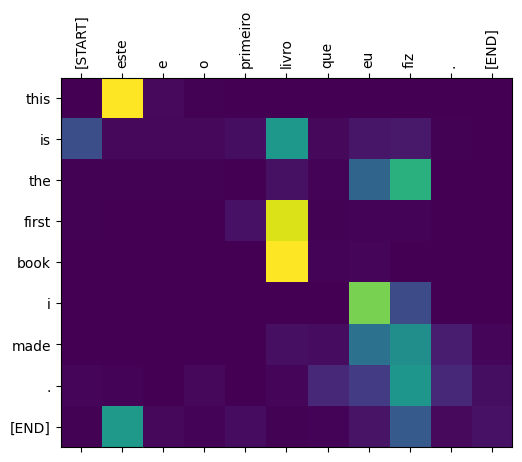

In [69]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [70]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

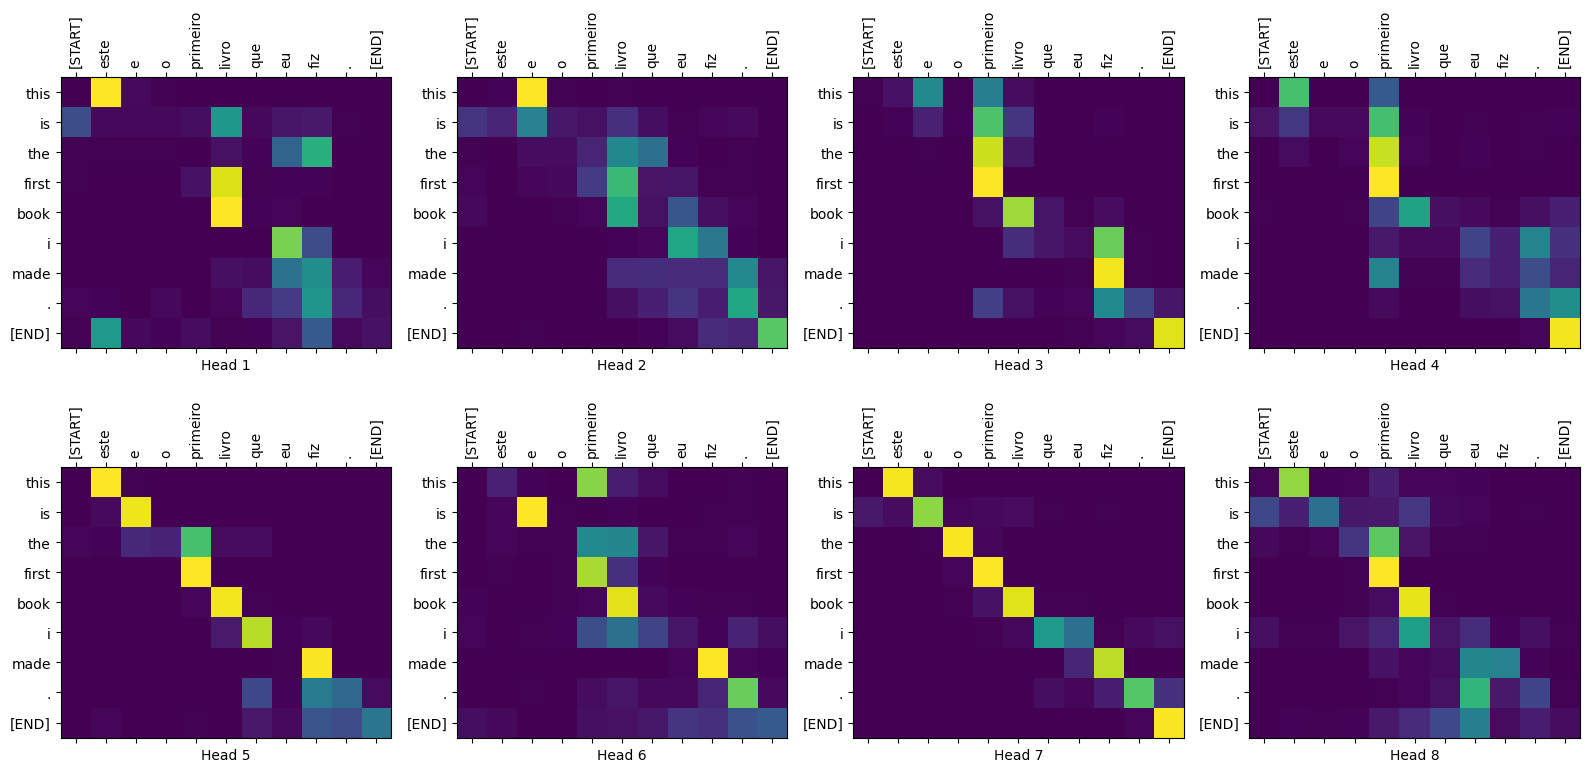

In [71]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triopathos in encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


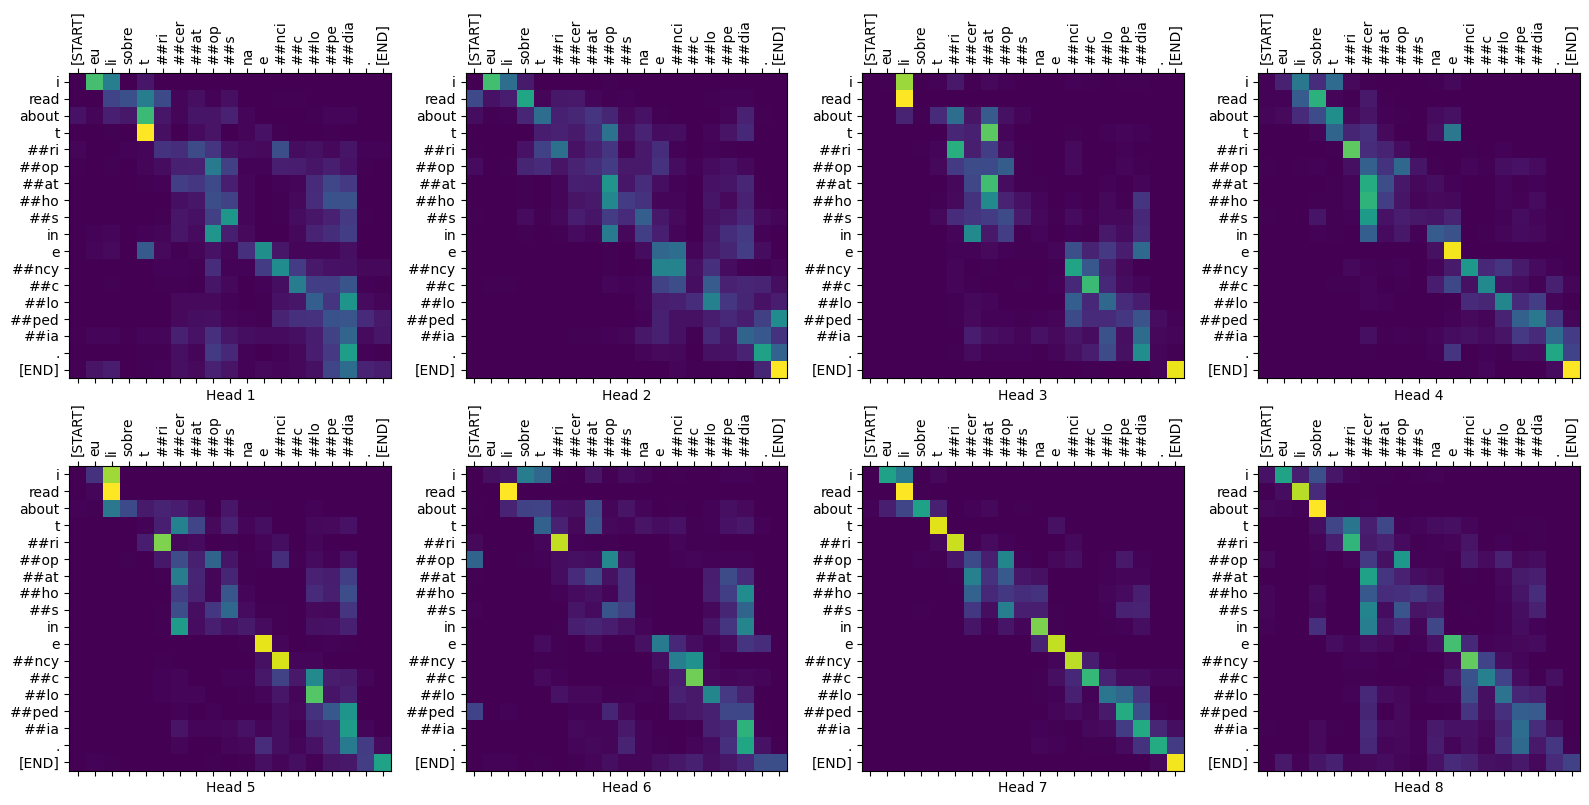

In [72]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [73]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [74]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [75]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i made .'

In [76]:
tf.saved_model.save(translator, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [77]:
reloaded = tf.saved_model.load('translator')

In [78]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i made .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)t beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
